# Mean Teacher Bert Assessment



# Requirement Installation 

In [2]:
#installing requirements
!pip install tensorflow_text
!pip install textattack #==0.3.0
!pip install sentence_transformers

     |████████████████████████████████| 4.9 MB 12.2 MB/s 
     |████████████████████████████████| 373 kB 11.7 MB/s 
     |████████████████████████████████| 322 kB 49.5 MB/s 
     |████████████████████████████████| 290 kB 46.5 MB/s 
     |████████████████████████████████| 3.1 MB 38.7 MB/s 
     |████████████████████████████████| 101 kB 11.2 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 69 kB 6.7 MB/s 
     |████████████████████████████████| 769 kB 52.0 MB/s 
     |████████████████████████████████| 3.3 MB 38.0 MB/s 
     |████████████████████████████████| 895 kB 34.7 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 290 kB 53.2 MB/s 
     |████████████████████████████████| 290 kB 51.4 MB/s 
     |████████████████████████████████| 287 kB 51.4 MB/s 
     |████████████████████████████████| 287 kB 47.6 MB/s 
     |██████████████


# Importing and Declaration

In [3]:
import os 
os.chdir('/content/drive/MyDrive/Master Thesis/Mean-Teacher-BERT-Robustness-Assessment/')

In [4]:
# importing libraries 
import os 
import pandas as pd 
import numpy as np
import tensorflow as tf

from ipywidgets import *
from IPython.display import display

import textattack
from Utils.utils import label_to_int, dataset_split, convert_to_category, create_tokenizer, data_tokenization
from Utils.data_loader import data_loader
from Bert.bert_model import bert_model
from Attack_model.TextAttack import attack_model


from MeanTeacher.train_mean_teacher import train_mean_teacher

from sklearn.metrics import classification_report

import random 
random.seed(42)

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


textattack: Downloading https://textattack.s3.amazonaws.com/word_embeddings/paragramcf.
100%|██████████| 481M/481M [00:16<00:00, 28.5MB/s]
textattack: Unzipping file /root/.cache/textattack/tmp_o_khp12.zip to /root/.cache/textattack/word_embeddings/paragramcf.
textattack: Successfully saved word_embeddings/paragramcf to cache.


## Data Related Questionaire

In [5]:
data_name=widgets.Dropdown(options=['codalab','IMDB' ],value='codalab',description='DATA:',disabled=False,) 
pretrained_weights=widgets.Dropdown(options=['bert-base-uncased','distilbert-base-uncased' ],value='bert-base-uncased',description='Pretrained Model:',disabled=False,)
widgets.HBox([data_name, pretrained_weights])

### Data specific detail

In [6]:
'''
NOT required now as previous cell does the job. So disabling boxes
'''
# Details related to the dataset
# columns names 
feature_col=widgets.Text(value='tweet',placeholder='Enter Feature Col Name',description='Feature Column:',disabled=False)
target_col=widgets.Text(value='label',placeholder='Enter Target Col Name',description='Target Column:',disabled=False) 
aug_col=widgets.Text(value='aug_tweet',placeholder='Enter Augmented data Col Name',description='Augment Column:',disabled=False)   

#pretrained model details
 # widgets.HBox([feature_col,target_col,aug_col,pretrained_weights])

In [7]:
#details of the class
class_1=widgets.Text(value='real',placeholder='Enter class name 1',description='class 1:',disabled=False)
class_2=widgets.Text(value='fake',placeholder='Enter class name 2',description='class 2:',disabled=False) 
tf.print("Class 1 label would be 0. \n")
# widgets.HBox([class_1,class_2])

Class 1 label would be 0. 



In [8]:
# #Data location 
Data_loc=widgets.Text(value='Data/codalab/',placeholder='Enter Data location ',description=' Data Location Column:',disabled=False)   
# widgets.HBox([Data_loc])

In [9]:
'''
Adjusting feature as per data 
'''

if data_name.value=='codalab':
    feature_col.value='tweet'
    target_col.value='label'
    aug_col.value='aug_tweet'
    class_1.value='real'
    class_2.value='fake'
    Data_loc.value= 'Data/codalab/'
elif data_name.value=='IMDB':
    feature_col.value='review'
    target_col.value='sentiment'
    aug_col.value='aug_tweet'
    class_1.value='positive'
    class_2.value='negative'
    Data_loc.value= 'Data/IMDB/'



## Hyperparameter selections

In [22]:
# Parameter declaration 
max_len=widgets.BoundedIntText(value=100,min=10,max=512,step=10,description='Max Length:',disabled=False,)

learning_rate= widgets.Dropdown(options=[2e-5, 1e-5, 1e-3],value=2e-5,description='Learning Rate:',disabled=False,)

epochs= widgets.Dropdown(options=[3, 4, 5,6],value=3,description='Epochs:',disabled=False,)

batch_size= widgets.Dropdown(options=[4, 5,6,7,8],value=4,description='Batch Size:',disabled=False,)

#for mean teacher model
alpha= widgets.BoundedFloatText(value=0.999,min=0.90,max=0.999,step=0.0001,description='Alpha:',disabled=False, readout_format='.3f')
ratio= widgets.BoundedFloatText(value=0.5,min=0.1,max=0.9,step=0.1,description='Ratio:',disabled=False, readout_format='.2f')
pretrained_weights=widgets.Dropdown(options=['bert-base-uncased','distilbert-base-uncased' ],value='bert-base-uncased',description='Pretrained Model:',disabled=False,)

tf.print('\n Max Length: Length of the article')
display(max_len)
tf.print('\n Learning rate: Learning rate for training the model')
display(learning_rate)
tf.print('\n Epochs')
display(epochs)
tf.print('\n batch_size')
display(batch_size)
tf.print('\n Alpha: Parameter related to Mean teacher model, its the proportion of student weight that teacher model will get each step.')
display(alpha)
tf.print("\n Ratio: Parameter related to Mean Teacher model, that manage the proportion of classification cost and consistency cost in calculating overall cost.")
display(ratio)

# widgets.HBox([max_len, learning_rate, epochs, batch_size,alpha,ratio])


 Max Length: Length of the article


BoundedIntText(value=100, description='Max Length:', max=512, min=10, step=10)


 Learning rate: Learning rate for training the model


Dropdown(description='Learning Rate:', options=(2e-05, 1e-05, 0.001), value=2e-05)


 Epochs


Dropdown(description='Epochs:', options=(3, 4, 5, 6), value=3)


 batch_size


Dropdown(description='Batch Size:', options=(4, 5, 6, 7, 8), value=4)


 Alpha: Parameter related to Mean teacher model, its the proportion of student weight that teacher model will get each step.


BoundedFloatText(value=0.999, description='Alpha:', max=0.999, min=0.9, step=0.0001)


 Ratio: Parameter related to Mean Teacher model, that manage the proportion of classification cost and consistency cost in calculating overall cost.


BoundedFloatText(value=0.5, description='Ratio:', max=0.9, min=0.1, step=0.1)

# Reading dataset

In [23]:
df_train,df_test,df_aug_unlabel= data_loader(Data_loc.value,target_col.value,aug_col.value,class_1.value)

In [24]:
len(df_train),len(df_test)

(6090, 2040)

In [25]:
tf.print(df_train.groupby(target_col.value).count())
tf.print(df_test.groupby(target_col.value).count())

       tweet
label       
0       3199
1       2891
       tweet
label       
0       1071
1        969


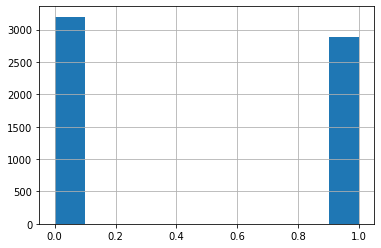

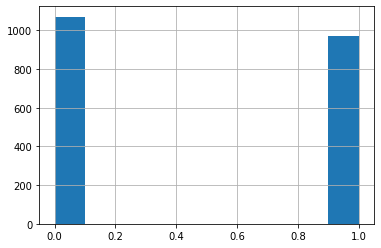

In [26]:
import matplotlib.pyplot as plt 
df_train[target_col.value].hist()
plt.show()
df_test[target_col.value].hist()
plt.show()

# Training 

<font color='blue'>This section is to train and save the model. <br>
__If model is already trained and saved, directly move forward for attack and evaluation section.__ </font>

## BERT Model Training

In [ ]:
pretrained_weights.value

'bert-base-uncased'

In [ ]:
tokenizer=create_tokenizer(pretrained_weights.value)
x_train,y_train,vocab_size= data_tokenization(df_train,feature_col.value,target_col.value,max_len.value,tokenizer)
x_test,y_test,_= data_tokenization(df_test,feature_col.value,target_col.value,max_len.value,tokenizer)

In [ ]:
bert=bert_model(pretrained_weights.value,max_len.value,learning_rate.value)
bert.summary()

Model selected: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

In [ ]:
with tf.device('/GPU:0'):
    bert.fit(x_train,y_train,batch_size=batch_size.value,epochs=epochs.value,verbose=1)

Epoch 1/3
1007/1007 [==============================] - 148s 138ms/step - loss: 0.3221 - accuracy: 0.8607
Epoch 2/3
1007/1007 [==============================] - 139s 138ms/step - loss: 0.1414 - accuracy: 0.9501
Epoch 3/3
1007/1007 [==============================] - 139s 138ms/step - loss: 0.0695 - accuracy: 0.9764


In [ ]:
# evaluating model 
pred_label=bert.predict(x_test)

print(classification_report(np.argmax(y_test,1),np.argmax(pred_label,1)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       948
           1       0.98      0.95      0.97       789

    accuracy                           0.97      1737
   macro avg       0.97      0.97      0.97      1737
weighted avg       0.97      0.97      0.97      1737



In [ ]:
np.argmax(pred_label,1)

array([1, 0, 1, ..., 1, 0, 1])

In [ ]:
#saving the model 
if  pretrained_weights.value == 'distilbert-base-uncased':
    bert.save_weights('SavedModels/IMDB/DistillBERT_model.h5')
else:
    bert.save_weights('SavedModels/IMDB/BERT_model.h5')

## Adversarial Mean Teacher BERT Training

In [ ]:
# Training
tokenizer=create_tokenizer(pretrained_weights.value)
x_train,y_train,vocab_size= data_tokenization(df_train,feature_col.value,target_col.value,max_len.value,tokenizer)
x_test,y_test,_= data_tokenization(df_test,feature_col.value,target_col.value,max_len.value,tokenizer)
x_unlabel,_,_=data_tokenization(df_aug_unlabel,aug_col.value,target_col.value,max_len.value,tokenizer)

Attempting to acquire lock 140324332816784 on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
Lock 140324332816784 acquired on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Attempting to release lock 140324332816784 on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock
Lock 140324332816784 released on /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79.lock


Attempting to acquire lock 140324319772112 on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock
Lock 140324319772112 acquired on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


Attempting to release lock 140324319772112 on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock
Lock 140324319772112 released on /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e.lock


Attempting to acquire lock 140324317850576 on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
Lock 140324317850576 acquired on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Attempting to release lock 140324317850576 on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock
Lock 140324317850576 released on /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99.lock


Attempting to acquire lock 140324318261328 on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
Lock 140324318261328 acquired on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


Attempting to release lock 140324318261328 on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock
Lock 140324318261328 released on /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4.lock


In [ ]:
with tf.device('/GPU:0'):
    student, teacher= train_mean_teacher(x_train, y_train, x_unlabel, 
                                         pretrained_weights.value,
                                         epochs.value,batch_size.value,
                                         learning_rate.value,max_len.value,alpha.value)

Model selected: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model selected: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


alpha: 0.999

epoch 1
1006/1007 [============================>.] - ETA: 1s - Accuracy: 0.5752 - Overall_Loss: 0.8557
epoch 2
1006/1007 [============================>.] - ETA: 1s - Accuracy: 0.7191 - Overall_Loss: 0.0361
epoch 3
1006/1007 [============================>.] - ETA: 1s - Accuracy: 0.8111 - Overall_Loss: 0.0138

In [ ]:
#evaluating test data 
pred_label=teacher.predict(x_test)


In [ ]:
print(classification_report(np.argmax(y_test,1),np.argmax(pred_label,1)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       948
           1       0.98      0.96      0.97       789

    accuracy                           0.97      1737
   macro avg       0.98      0.97      0.97      1737
weighted avg       0.97      0.97      0.97      1737



In [ ]:
if  pretrained_weights.value == 'distilbert-base-uncased':
    teacher.save_weights('SavedModels/IMDB/DistillBERT_teacher.h5')
else:
    teacher.save_weights('SavedModels/IMDB/BERT_teacher.h5')


# Attack And Evaluation

In [27]:
import textattack

In [28]:
# bert_to_attack=widgets.Textarea(value='SavedModels/Codalab/BERT_model.h5',placeholder='Enter Model location ',description=' BERT Model location:',disabled=False)
# MTbert_to_attack=widgets.Textarea(value='SavedModels/Codalab/BERT_teacher.h5',placeholder='Enter Model location ',description=' MTBERT Model location:',disabled=False)   
# pretrained_weights=widgets.Dropdown(options=['bert-base-uncased','distilbert-base-uncased' ],value='bert-base-uncased',description='Pretrained Model:',disabled=False,) 
model_name=widgets.Dropdown(options=['BERT','DistilBERT']
                               ,value='DistilBERT',
                               description='Model Name:',
                               disabled=False,) 
tf.print('\n model_name: Model name for attack.Note : Please confirm with the bert_to_attack parameter')
display(model_name)
if model_name.value=='BERT':
  bert_to_attack= 'SavedModels/'+data_name.value+'/BERT_model.h5'
  MTbert_to_attack='SavedModels/'+data_name.value+'/BERT_teacher.h5'
  pretrained_weights.value = 'bert-base-uncased'
else:
  bert_to_attack= 'SavedModels/'+data_name.value+'/DistilBERT_model.h5'
  MTbert_to_attack='SavedModels/'+data_name.value+'/DistilBERT_teacher.h5'
  pretrained_weights.value = 'distilbert-base-uncased'


# tf.print('\n Please select the location of BERT and MT BERT model.\n')
# display(bert_to_attack, MTbert_to_attack)
# tf.print('\n Please select the pretrained model weights.')
# display(pretrained_weights)



 model_name: Model name for attack.Note : Please confirm with the bert_to_attack parameter


Dropdown(description='Model Name:', index=1, options=('BERT', 'DistilBERT'), value='DistilBERT')

In [29]:
print(model_name.value), bert_to_attack

DistilBERT


(None, 'SavedModels/codalab/DistilBERT_model.h5')

In [30]:
# attack parameters 

# Query Budget is maximum query allowed
query_budget= widgets.BoundedIntText(value=1000,min=10,max=2000,step=20,description='Query Budget:',disabled=False,)

# number of example to take for attack from test dataset randomly 
num_examples=widgets.BoundedIntText(value=500,min=10,max=len(df_test),step=20,description='Number of Example:',disabled=False,)

# attack recipes 
attack_recipe=widgets.Dropdown(options=['TextFoolerJin2019',
                                        'PWWSRen2019',
                                        'BERTAttackLi2020',
                                        'BAEGarg2019',
                                        'TextBuggerLi2018',
                                        'CLARE2020',
                                        'MorpheusTan2020',
                                        'A2TYoo2021',
                                        'PSOZang2020']
                               ,value='TextFoolerJin2019',
                               description='Attack Recipe:',
                               disabled=False,) 


tf.print('\n query_budget: Maximum Query allowed to attack model')
display(query_budget)
tf.print('\n num_examples: Number of example to take for attack from test dataset randomly. ')
display(num_examples)
# tf.print('\n attack_recipe: Attack methodolgy to attack the model. ')
# display(attack_recipe)



 query_budget: Maximum Query allowed to attack model


BoundedIntText(value=1000, description='Query Budget:', max=2000, min=10, step=20)


 num_examples: Number of example to take for attack from test dataset randomly. 


BoundedIntText(value=500, description='Number of Example:', max=2040, min=10, step=20)

In [31]:
'''
Some of the attack recipe provided by textattack is not working with lengthy article. So, 
I am filtering the with the length. May be in future I will remove it.
'''
if not os.path.exists('Data/'+data_name.value+'/AdversarialTestData/test_adv_'+str(num_examples.value)+'.csv'):
    df_test['len']=df_test.apply(lambda row: len(row[feature_col.value].split()),axis=1)
    print(f'Average length of articles are: {df_test["len"].mean()}')
    df_test_for_attack= df_test[(df_test['len']>0) & (df_test['len']<100)][[feature_col.value,target_col.value]].dropna().reset_index(drop=True)
    df_test_for_attack=df_test_for_attack.sample(frac=1).reset_index(drop=True)
    df_test_for_attack= df_test_for_attack[:num_examples.value+1]
    # saving the csv file in AdversarialTestData folder, in order to correctly experiment all recipes with same data
    df_test_for_attack.to_csv('Data/'+data_name.value+'/AdversarialTestData/test_adv_'+str(num_examples.value)+'.csv',index=False)
else:
    tf.print('Reading the saved file')
    df_test_for_attack= pd.read_csv('Data/'+data_name.value+'/AdversarialTestData/test_adv_'+str(num_examples.value)+'.csv')

print('Length of dataset', len(df_test_for_attack))
df_test_for_attack.head()

Reading the saved file
Length of dataset 501


,tweet,label
0,oh really meat packing plant are unhealthy ask...,1
1,the overall lethality of covid infection fatal...,1
2,indiafightscorona state ut account for nearly ...,0
3,indiafightscorona india s per day testing capa...,0
4,man ha gone to live in parallel universe alcoh...,1


In [32]:
df_test_for_attack.groupby(target_col.value).count()

,tweet
label,
0,258
1,243


In [33]:

#creating dataset for the attacking
dataset_for_attack=list(df_test_for_attack.itertuples(index=False, name=None))
dataset_for_attack = textattack.datasets.Dataset(dataset_for_attack)

In [34]:
# Loading the model

bert= bert_model(pretrained_weights.value,max_len.value,learning_rate.value) 
bert.load_weights(bert_to_attack)

bert_teacher= bert_model(pretrained_weights.value,max_len.value,learning_rate.value) 
bert_teacher.load_weights(MTbert_to_attack)

Model selected: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model selected: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


### TextFooler
__TextFoolerJin2019 - Is BERT Really Robust? A Strong Baseline for Natural Language Attack on Text Classification and Entailment.__<br>
In this paper, we present TextFooler, a simple but strong baseline to generate natural adversarial text. By applying it to two fundamental natural language tasks, text classification and textual entailment, we successfully attacked three target models, including the powerful pre-trained BERT, and the widely used convolutional and recurrent neural networks. We demonstrate the advantages of this framework in three ways: (1) effective---it outperforms state-of-the-art attacks in terms of success rate and perturbation rate, (2) utility-preserving---it preserves semantic content and grammaticality, and remains correctly classified by humans, and (3) efficient---it generates adversarial text with computational complexity linear to the text length. *The code, pre-trained target models, and test examples are available at https://github.com/jind11/TextFooler.


In [ ]:
attack_recipe.value= 'TextFoolerJin2019'
tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
tf.print(f'****Query size:{query_budget.value}*****')
tf.print(f'****Number of examples:{num_examples.value}*****')

****Attack Recipe:TextFoolerJin2019*****
****Query size:1000*****
****Number of examples:500*****


#### BERT

In [ ]:
attack_model(bert, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/TextFoolerJin2019/DistilBERT_nexp500_qb1000_2021-11-18_18:14.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

Using /tmp/tfhub_modules to cache modules.
Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/500 [00:31<4:21:48, 31.48s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

oh really [[meat]] packing [[plant]] are unhealthy asks [[smug]] [[ghost]] of upton sinclair newsinphoto meatpacking covid

oh really [[braised]] packing [[facility]] are unhealthy asks [[condescension]] [[spectrum]] of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   0%|          | 2/500 [00:32<2:15:33, 16.33s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

the overall lethality of covid infection fatality rate is about to and thus in the range of a severe influenza up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of [[cloth]] face [[mask]] in healthy and asymptomatic individual

the overall lethality of covid infection fatality rate is about to and thus in the range of a severe influenza up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of [[fabric]] face [[cache]] in healthy and asymptomatic individual




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   1%|          | 3/500 [00:35<1:38:57, 11.95s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:   1%|          | 4/500 [00:41<1:25:10, 10.30s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

indiafightscorona [[india]] s per [[day]] [[testing]] [[capacity]] [[ha]] [[crossed]] lakh [[test]] [[test]] were conducted in the [[last]] hour the weekly [[average]] [[test]] [[have]] [[multiplied]] by more than [[time]] [[since]] the first [[week]] of [[january]] staysafe indiawillwin

indiafightscorona [[bollywood]] s per [[dag]] [[exam]] [[prerogatives]] [[haya]] [[crucifix]] lakh [[checkups]] [[essay]] were conducted in the [[ultima]] hour the weekly [[medium]] [[assay]] [[haya]] [[magnify]] by more than [[tiempo]] [[unless]] the first [[chau]] of [[nov]] staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:   1%|          | 5/500 [00:41<1:09:17,  8.40s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

[[man]] ha gone to live in parallel [[universe]] alcohol coronavirus whisky

[[homme]] ha gone to live in parallel [[global]] alcohol coronavirus whisky




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:   1%|          | 6/500 [00:45<1:03:02,  7.66s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

[[state]] [[reported]] more than k [[case]] [[today]] and k [[case]] yesterday the highest number we ve [[seen]] since may mississippi hasn t updated it [[number]] in two day so we expect we re [[missing]] [[case]] there [[based]] on their previous update

[[nationals]] [[said]] more than k [[prosecutions]] [[sonntag]] and k [[prosecutions]] yesterday the highest number we ve [[construed]] since may mississippi hasn t updated it [[numerals]] in two day so we expect we re [[gone]] [[litigation]] there [[baze]] on their previous update




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:   1%|▏         | 7/500 [00:50<59:43,  7.27s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:   2%|▏         | 8/500 [00:52<53:53,  6.57s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

cdc and google remind you that wearing cloth [[face]] covering in public [[setting]] can [[help]] slowthespread of covid [[learn]] more about cloth face covering

cdc and google remind you that wearing cloth [[frente]] covering in public [[fixing]] can [[succour]] slowthespread of covid [[got]] more about cloth face covering




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:   2%|▏         | 9/500 [00:53<48:58,  5.99s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

the viral text message [[claim]] that the chemical substance methylxanthines required to cure covid can be found in tea dr li wenliang had found this [[cure]] while researching about coronavirus before his death

the viral text message [[stating]] that the chemical substance methylxanthines required to cure covid can be found in tea dr li wenliang had found this [[resource]] while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10:   2%|▏         | 10/500 [00:57<47:10,  5.78s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

over [[worker]] in meat and poultry [[processing]] [[facility]] in state were infected with covid in [[april]] and may learn more about infection among [[worker]] at meat and poultry [[processing]] [[facility]] and step [[facility]] can [[take]] to [[slow]] the [[spread]]

over [[carver]] in meat and poultry [[metamorphosis]] [[vegetative]] in state were infected with covid in [[juli]] and may learn more about infection among [[earners]] at meat and poultry [[metamorphosis]] [[factory]] and step [[installs]] can [[toma]] to [[sluggish]] the [[aired]]




[Succeeded / Failed / Skipped / Total] 9 / 2 / 0 / 11:   2%|▏         | 11/500 [00:59<43:44,  5.37s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

we just announced an [[award]] from u s government agency barda for up to million to [[accelerate]] [[development]] of our mrna vaccine mrna against novel coronavirus

we just announced an [[prices]] from u s government agency barda for up to million to [[rashness]] [[phrasing]] of our mrna vaccine mrna against novel coronavirus




[Succeeded / Failed / Skipped / Total] 10 / 2 / 0 / 12:   2%|▏         | 12/500 [01:00<40:42,  5.01s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[muslim]] doctor [[died]] while treating people infected with coronavirus in [[delhi]]

[[unbelievers]] doctor [[lives]] while treating people infected with coronavirus in [[driss]]




[Succeeded / Failed / Skipped / Total] 11 / 2 / 0 / 13:   3%|▎         | 13/500 [01:00<37:52,  4.67s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[news]] don t lick a zebra for more than minute [[government]] coronavirus advice enters surreal stage

[[newsletter]] don t lick a zebra for more than minute [[gov]] coronavirus advice enters surreal stage




[Succeeded / Failed / Skipped / Total] 12 / 2 / 0 / 14:   3%|▎         | 14/500 [01:01<35:20,  4.36s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (58%)]] --> [[0 (69%)]]

fit people are [[immune]] to novel coronavirus

fit people are [[impregnable]] to novel coronavirus




[Succeeded / Failed / Skipped / Total] 13 / 2 / 0 / 15:   3%|▎         | 15/500 [01:01<33:21,  4.13s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (66%)]] --> [[0 (58%)]]

trump say he would mobilize [[military]] to [[distribute]] coronavirus vaccine when it s ready

trump say he would mobilize [[martial]] to [[conveying]] coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 13 / 3 / 0 / 16:   3%|▎         | 16/500 [01:05<32:55,  4.08s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our total number of confirmed case is which is the number we report to the world health organization there is no one in new zealand receiving hospitallevel care for covid




[Succeeded / Failed / Skipped / Total] 14 / 3 / 0 / 17:   3%|▎         | 17/500 [01:06<31:29,  3.91s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

asias richest man mukesh ambanis wife nita ambani [[received]] r a [[welfare]] [[fund]] from central [[government]]

asias richest man mukesh ambanis wife nita ambani [[recieve]] r a [[wellness]] [[funding]] from central [[goverment]]




[Succeeded / Failed / Skipped / Total] 15 / 3 / 0 / 18:   4%|▎         | 18/500 [01:07<30:14,  3.76s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[claim]] that fox [[news]] [[said]] that trump tested positive for covid

[[wondering]] that fox [[novice]] [[indicate]] that trump tested positive for covid




[Succeeded / Failed / Skipped / Total] 16 / 3 / 0 / 19:   4%|▍         | 19/500 [01:11<30:02,  3.75s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

over the next [[week]] we are [[projecting]] [[arrival]] and [[departure]] from [[managed]] isolation this [[give]] a [[net]] [[reduction]] of [[people]] in [[managed]] [[isolation]] over those [[day]]

over the next [[chau]] we are [[overhanging]] [[emergence]] and [[quit]] from [[manage]] isolation this [[donner]] a [[neto]] [[diminishes]] of [[personas]] in [[managerial]] [[detaching]] over those [[dag]]




[Succeeded / Failed / Skipped / Total] 17 / 3 / 0 / 20:   4%|▍         | 20/500 [01:13<29:22,  3.67s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth [[expect]] to [[see]] covid infection in people who have had [[contact]] with the recentlyidentified [[patient]] especially those who have had close prolonged [[contact]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth [[hoping]] to [[heed]] covid infection in people who have had [[phoning]] with the recentlyidentified [[morbid]] especially those who have had close prolonged [[telephoning]]




[Succeeded / Failed / Skipped / Total] 18 / 3 / 0 / 21:   4%|▍         | 21/500 [01:14<28:18,  3.55s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

[[facebook]] [[post]] that compare death in italy during coronavirus pandemie with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in [[italy]] and it wa the real problem and coronavirus death compared to this arent serious

[[iphone]] [[ext]] that compare death in italy during coronavirus pandemie with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in [[ltaly]] and it wa the real problem and coronavirus death compared to this arent serious




[Succeeded / Failed / Skipped / Total] 18 / 4 / 0 / 22:   4%|▍         | 22/500 [01:17<28:07,  3.53s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

joshtpm washington and new york are driving the number were falling further behind on ca testing number now that ma is out in the open the other big question mark is tx




[Succeeded / Failed / Skipped / Total] 19 / 4 / 0 / 23:   5%|▍         | 23/500 [01:18<27:16,  3.43s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

korona [[virus]] very new deadly form of virus [[china]] is suffering may come to [[india]] immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food [[milkshake]] rough ice ice cola milk sweet older then hour for atleast day from today

korona [[flu]] very new deadly form of virus [[chine]] is suffering may come to [[indie]] immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food [[brewery]] rough ice ice cola milk sweet older then hour for atleast day from today




[Succeeded / Failed / Skipped / Total] 20 / 4 / 0 / 24:   5%|▍         | 24/500 [01:19<26:23,  3.33s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov [[follow]] [[latest]] covid [[update]]

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov [[mimic]] [[ultima]] covid [[moderne]]




[Succeeded / Failed / Skipped / Total] 21 / 4 / 0 / 25:   5%|▌         | 25/500 [01:21<25:39,  3.24s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[saddam]] [[hussein]] at a meeting in the ninety reported that the u threatened to [[quit]] the corona virus on [[iraq]]

[[iraqis]] [[hasan]] at a meeting in the ninety reported that the u threatened to [[cessation]] the corona virus on [[afghanistan]]




[Succeeded / Failed / Skipped / Total] 22 / 4 / 0 / 26:   5%|▌         | 26/500 [01:23<25:25,  3.22s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

a common question are coronavirus [[case]] going up because were [[testing]] so [[many]] more [[people]] a certainly not in florida where [[testing]] slowed down while [[new]] [[case]] grew over the last [[week]]

a common question are coronavirus [[lawsuit]] going up because were [[exams]] so [[incalculable]] more [[personas]] a certainly not in florida where [[exams]] slowed down while [[roman]] [[prosecutions]] grew over the last [[chow]]




[Succeeded / Failed / Skipped / Total] 23 / 4 / 0 / 27:   5%|▌         | 27/500 [01:24<24:46,  3.14s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

[[stop]] making me look [[bad]] [[trump]] blast unpatriotic american for dying from covid

[[braking]] making me look [[adverse]] [[hooker]] blast unpatriotic american for dying from covid




[Succeeded / Failed / Skipped / Total] 24 / 4 / 0 / 28:   6%|▌         | 28/500 [01:30<25:26,  3.24s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

[[sometimes]] covid [[test]] [[result]] [[take]] [[longer]] than [[hour]] due to sample [[transport]] other logistics while we [[work]] hard to [[reduce]] [[time]] between sample [[collection]] [[result]] [[notification]] please [[take]] [[preventive]] [[measure]] selfisolation is important

[[fluently]] covid [[proof]] [[reason]] [[toma]] [[langer]] than [[clock]] due to sample [[carrier]] other logistics while we [[trabajo]] hard to [[diminishes]] [[tiempo]] between sample [[compendium]] [[wake]] [[advertising]] please [[assuming]] [[pretrial]] [[gestures]] selfisolation is important




[Succeeded / Failed / Skipped / Total] 25 / 4 / 0 / 29:   6%|▌         | 29/500 [01:34<25:37,  3.26s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

however corticosteroid [[do]] not [[help]] covid [[patient]] with [[mild]] or [[moderate]] [[disease]] and can [[be]] [[harmful]] who therefore [[recommends]] the [[use]] of corticosteroid only in [[patient]] who are [[severely]] or [[critically]] ill drtedros

however corticosteroid [[fait]] not [[pomoc]] covid [[lll]] with [[indulgent]] or [[unassuming]] [[rheumatism]] and can [[viens]] [[injurious]] who therefore [[praises]] the [[consumption]] of corticosteroid only in [[sufferers]] who are [[violently]] or [[highly]] ill drtedros




[Succeeded / Failed / Skipped / Total] 26 / 4 / 0 / 30:   6%|▌         | 30/500 [01:38<25:50,  3.30s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (100%)]] --> [[1 (60%)]]

hcps [[attend]] the next coca [[call]] [[tuesday]] [[sept]] at [[pm]] et [[via]] zoom [[topic]] telehealth [[health]] [[equity]] [[consideration]] for [[addressing]] [[health]] [[disparity]] during the covid pandemic [[learn]] more covid

hcps [[attended]] the next coca [[phoned]] [[sonntag]] [[marr]] at [[soiree]] et [[among]] zoom [[affair]] telehealth [[salud]] [[justo]] [[exams]] for [[dissipating]] [[sanitation]] [[mismatch]] during the covid pandemic [[teach]] more covid




[Succeeded / Failed / Skipped / Total] 27 / 4 / 0 / 31:   6%|▌         | 31/500 [01:42<25:54,  3.31s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

out of every nigerian who die from covid are more than [[year]] old [[take]] [[precaution]] to [[protect]] your [[older]] [[relative]] by [[wearing]] a [[face]] [[mask]] in [[public]] [[practicing]] [[hand]] respiratory [[hygiene]] [[maintaining]] a physical distance of metre from others takeresponsibility

out of every nigerian who die from covid are more than [[olds]] old [[assumes]] [[circumspect]] to [[defends]] your [[antique]] [[regards]] by [[door]] a [[tussle]] [[disguises]] in [[governmental]] [[exerts]] [[manu]] respiratory [[hygienic]] [[conservancy]] a physical distance of metre from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 28 / 4 / 0 / 32:   6%|▋         | 32/500 [01:43<25:17,  3.24s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

mrmbrown on a cheap [[bourbon]] to [[gargle]] my throat best virus killer in the [[world]] pure battery [[acid]]

mrmbrown on a cheap [[whiskies]] to [[moisten]] my throat best virus killer in the [[welt]] pure battery [[amino]]




[Succeeded / Failed / Skipped / Total] 29 / 4 / 0 / 33:   7%|▋         | 33/500 [01:44<24:37,  3.16s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[news]] coronavirus suspect to [[be]] quarantined on love island

[[correspondents]] coronavirus suspect to [[remain]] quarantined on love island




[Succeeded / Failed / Skipped / Total] 30 / 4 / 0 / 34:   7%|▋         | 34/500 [01:48<24:41,  3.18s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

one hundred day after the st covid case wa [[recorded]] in nigeria the ncdc national [[reference]] laboratory ha [[supported]] more laboratory to develop [[capacity]] for covid [[testing]] [[watch]] this [[report]] by ntanewsnow on the [[lab]] [[including]] [[reflection]] by the ptfcovid chair

one hundred day after the st covid case wa [[checkin]] in nigeria the ncdc national [[quote]] laboratory ha [[succour]] more laboratory to develop [[prerogatives]] for covid [[verifies]] [[listens]] this [[communications]] by ntanewsnow on the [[labs]] [[implicating]] [[dazzle]] by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 31 / 4 / 1 / 36:   7%|▋         | 36/500 [01:49<23:29,  3.04s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

papua [[new]] guinea now ha the [[supply]] to test for covid in all province thanks to a strong [[collaboration]] between who australia and new zealand more [[detail]] whoimpact

papua [[novel]] guinea now ha the [[quotation]] to test for covid in all province thanks to a strong [[functioned]] between who australia and new zealand more [[prompts]] whoimpact


--------------------------------------------- Result 36 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

comment section quarantined for outbreak of coronavirusrelated racism coronavirus




[Succeeded / Failed / Skipped / Total] 32 / 4 / 1 / 37:   7%|▋         | 37/500 [01:54<23:53,  3.10s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

we [[still]] have [[significant]] cluster four of which are now [[closed]] there are no [[additional]] [[death]] to report [[yesterday]] our [[lab]] [[processed]] [[test]] the [[total]] [[number]] of [[test]] to [[date]] is there [[will]] [[be]] a [[further]] [[update]] from the [[government]] at pm

we [[incidentally]] have [[gargantuan]] cluster four of which are now [[clasps]] there are no [[alia]] [[assassinating]] to report [[sonntag]] our [[labs]] [[broached]] [[ordeals]] the [[global]] [[chiffre]] of [[exams]] to [[personals]] is there [[longing]] [[become]] a [[afresh]] [[moderne]] from the [[governance]] at pm




[Succeeded / Failed / Skipped / Total] 33 / 4 / 1 / 38:   8%|▊         | 38/500 [01:55<23:20,  3.03s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[bill]] [[gate]] didnt say people dont have a choice about being vaccinated for the coronavirus

[[billing]] [[doorsteps]] didnt say people dont have a choice about being vaccinated for the coronavirus




[Succeeded / Failed / Skipped / Total] 34 / 4 / 1 / 39:   8%|▊         | 39/500 [01:56<22:54,  2.98s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[0 (55%)]]

[[people]] lying in the [[street]] in [[china]] [[because]] of the new coronavirus

[[populations]] lying in the [[footpath]] in [[wah]] [[since]] of the new coronavirus




[Succeeded / Failed / Skipped / Total] 35 / 4 / 1 / 40:   8%|▊         | 40/500 [01:56<22:25,  2.92s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (66%)]] --> [[0 (65%)]]

i m putting the little [[bastard]] up for adoption read some of ireland s heartwarming covid story

i m putting the little [[bugger]] up for adoption read some of ireland s heartwarming covid story




[Succeeded / Failed / Skipped / Total] 36 / 4 / 1 / 41:   8%|▊         | 41/500 [01:57<21:54,  2.86s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

bechara covid se down [[hai]] else he would have give a nice acceptance speech dad this is for you

bechara covid se down [[hae]] else he would have give a nice acceptance speech dad this is for you




[Succeeded / Failed / Skipped / Total] 37 / 4 / 1 / 42:   8%|▊         | 42/500 [01:58<21:34,  2.83s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

kid [[died]] in [[senegal]] right after receiving the [[vaccine]] for the coronavirus

kid [[casualties]] in [[jurgen]] right after receiving the [[diphtheria]] for the coronavirus




[Succeeded / Failed / Skipped / Total] 38 / 4 / 1 / 43:   9%|▊         | 43/500 [02:02<21:36,  2.84s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

both flu covid can [[spread]] before symptom [[appear]] [[flu]] [[virus]] may [[spread]] for about [[day]] before symptom while the [[virus]] that cause covid may [[spread]] for about [[day]] before symptom more on similarity and [[difference]] between flu covid

both flu covid can [[dispensed]] before symptom [[transpires]] [[pandemic]] [[infestation]] may [[circulate]] for about [[dating]] before symptom while the [[viruses]] that cause covid may [[contagion]] for about [[stardate]] before symptom more on similarity and [[mismatch]] between flu covid




[Succeeded / Failed / Skipped / Total] 38 / 5 / 2 / 45:   9%|▉         | 45/500 [02:04<21:00,  2.77s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more


--------------------------------------------- Result 45 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

hydroxychloroquine the virus cure how fast doe this pandemic end if you could start feeling better in a soon a hour




[Succeeded / Failed / Skipped / Total] 39 / 5 / 2 / 46:   9%|▉         | 46/500 [02:05<20:42,  2.74s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

a [[facebook]] [[claim]] covid is man [[made]] in a lab

a [[iphone]] [[contend]] covid is man [[undertaken]] in a lab




[Succeeded / Failed / Skipped / Total] 40 / 5 / 2 / 47:   9%|▉         | 47/500 [02:08<20:41,  2.74s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

from friday pub [[bar]] and [[restaurant]] will [[have]] to [[close]] at [[pm]] first minister of scotland [[nicola]] [[sturgeon]] announces a [[strict]] [[nationwide]] curfew for pub [[update]] on [[latest]] covid restriction

from friday pub [[saloon]] and [[grocery]] will [[received]] to [[straits]] at [[midday]] first minister of scotland [[nikolaus]] [[coho]] announces a [[starck]] [[nacional]] curfew for pub [[discounted]] on [[freshly]] covid restriction




[Succeeded / Failed / Skipped / Total] 41 / 5 / 2 / 48:  10%|▉         | 48/500 [02:09<20:20,  2.70s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

trump said hundred of [[governor]] are [[calling]] him we only have

trump said hundred of [[regulator]] are [[require]] him we only have




[Succeeded / Failed / Skipped / Total] 42 / 5 / 3 / 50:  10%|█         | 50/500 [02:11<19:41,  2.63s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

[[claim]] that [[football]] star cristiano [[ronaldo]] ha [[converted]] his [[hotel]] chain into coronavirus hospital

[[ask]] that [[footballs]] star cristiano [[giggs]] ha [[revolved]] his [[hospitality]] chain into coronavirus hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 43 / 5 / 3 / 51:  10%|█         | 51/500 [02:12<19:23,  2.59s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

an inmate who wa released from prison under covid humanitarian house arrest wa arrested again in campo [[bom]] [[police]] officer found more than kg of [[cocaine]] in his house and several gun

an inmate who wa released from prison under covid humanitarian house arrest wa arrested again in campo [[boom]] [[policing]] officer found more than kg of [[cokehead]] in his house and several gun




[Succeeded / Failed / Skipped / Total] 44 / 5 / 3 / 52:  10%|█         | 52/500 [02:12<19:04,  2.55s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (62%)]] --> [[0 (65%)]]

pcr test were [[conducted]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom

pcr test were [[performed]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom




[Succeeded / Failed / Skipped / Total] 45 / 5 / 3 / 53:  11%|█         | 53/500 [02:17<19:17,  2.59s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

a [[further]] [[people]] [[have]] been spoken with and [[referred]] for [[testing]] there are [[people]] who we [[have]] [[repeatedly]] [[tried]] to [[make]] contact with [[including]] [[via]] text and via [[phone]] [[call]]

a [[extras]] [[personas]] [[haya]] been spoken with and [[evoked]] for [[tests]] there are [[mankind]] who we [[possessed]] [[eternally]] [[strove]] to [[exert]] contact with [[composing]] [[for]] text and via [[telefono]] [[telephoned]]




[Succeeded / Failed / Skipped / Total] 46 / 5 / 4 / 55:  11%|█         | 55/500 [02:17<18:34,  2.50s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (57%)]] --> [[0 (59%)]]

coronavirus [[spelled]] backwards surivanorac a coincidence coronavirus drbillingsgate

coronavirus [[spell]] backwards surivanorac a coincidence coronavirus drbillingsgate


--------------------------------------------- Result 55 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil registry data




[Succeeded / Failed / Skipped / Total] 47 / 5 / 4 / 56:  11%|█         | 56/500 [02:20<18:30,  2.50s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (100%)]] --> [[1 (59%)]]

everyone who wa in the bus from [[auckland]] airport to the ibis hotel is being [[followed]] up and are already in [[managed]] [[isolation]] the driver who wa wearing ppe ha also been [[isolated]] a a [[potential]] close [[contact]] and will be tested

everyone who wa in the bus from [[palmerston]] airport to the ibis hotel is being [[policed]] up and are already in [[succeeds]] [[detaching]] the driver who wa wearing ppe ha also been [[loney]] a a [[imaginable]] close [[phoning]] and will be tested




[Succeeded / Failed / Skipped / Total] 48 / 5 / 4 / 57:  11%|█▏        | 57/500 [02:20<18:13,  2.47s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[member]] of vogelcheck family come down with coronavirus after [[holiday]] event

[[mps]] of vogelcheck family come down with coronavirus after [[eid]] event




[Succeeded / Failed / Skipped / Total] 49 / 5 / 4 / 58:  12%|█▏        | 58/500 [02:24<18:20,  2.49s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

gregoryingle flvickster vivek mutalik [[yeah]] i [[mean]] it [[make]] [[sense]] [[though]] i am [[hearing]] [[much]] [[lower]] [[number]] from a [[couple]] of [[laboratory]] and one private [[company]] so its [[possible]] if you [[have]] the [[right]] setup alexismadrigal

gregoryingle flvickster vivek mutalik [[yup]] i [[implying]] it [[exerting]] [[sens]] [[despite]] i am [[heed]] [[sizeable]] [[lesser]] [[numerals]] from a [[matrimonial]] of [[labs]] and one private [[entrepreneurial]] so its [[plausible]] if you [[haya]] the [[eh]] setup alexismadrigal




[Succeeded / Failed / Skipped / Total] 50 / 5 / 4 / 59:  12%|█▏        | 59/500 [02:25<18:04,  2.46s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

christine lagarde [[admits]] that something must be done about old people living for too long

christine lagarde [[acknowledge]] that something must be done about old people living for too long




[Succeeded / Failed / Skipped / Total] 51 / 5 / 4 / 60:  12%|█▏        | 60/500 [02:29<18:15,  2.49s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (100%)]] --> [[1 (53%)]]

if you [[have]] [[sign]] of a heart attack or stroke while [[staying]] at [[home]] during covid [[call]] right [[away]] [[emergency]] responder and emergency department [[have]] [[plan]] in [[place]] to [[help]] [[protect]] you from covid learn more

if you [[haya]] [[omen]] of a heart attack or stroke while [[vestiges]] at [[sarcophagus]] during covid [[telephones]] right [[abroad]] [[contingency]] responder and emergency department [[got]] [[regimen]] in [[mise]] to [[aides]] [[amparo]] you from covid learn more




[Succeeded / Failed / Skipped / Total] 52 / 5 / 4 / 61:  12%|█▏        | 61/500 [02:30<18:01,  2.46s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[news]] coronavirus crisis in [[italy]] lead [[donald]] trump to close all u [[pizzeria]]

[[pers]] coronavirus crisis in [[ltaly]] lead [[hsia]] trump to close all u [[trattoria]]




[Succeeded / Failed / Skipped / Total] 53 / 5 / 4 / 62:  12%|█▏        | 62/500 [02:34<18:11,  2.49s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

bluelily annacb yup [[thats]] the prospective [[data]] hole [[thats]] [[really]] [[opening]] were [[very]] [[concerned]] about it but [[weve]] [[seen]] [[state]] like tn [[sometimes]] [[move]] towards [[openness]] alexismadrigal

bluelily annacb yup [[hahahaha]] the prospective [[info]] hole [[prob]] [[truthfully]] [[inaugurated]] were [[perfectly]] [[afraid]] about it but [[thay]] [[visto]] [[kraj]] like tn [[popularly]] [[migrated]] towards [[fath]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 53 / 6 / 4 / 63:  13%|█▎        | 63/500 [02:36<18:07,  2.49s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt drtedros if and when we have an effective covid vaccine we must also use it effectively i will repeat again vaccine nationalis




[Succeeded / Failed / Skipped / Total] 54 / 6 / 4 / 64:  13%|█▎        | 64/500 [02:39<18:06,  2.49s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[jimmy]] [[kimmel]] [[say]] that [[broadcasting]] his [[show]] from his [[home]] is totally [[depressing]] donaldtrump [[tv]] coronavirus

[[jonny]] [[whoopi]] [[indicate]] that [[outreach]] his [[exhibited]] from his [[inland]] is totally [[frustrating]] donaldtrump [[vt]] coronavirus




[Succeeded / Failed / Skipped / Total] 55 / 6 / 4 / 65:  13%|█▎        | 65/500 [02:40<17:55,  2.47s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

lockdown in [[south]] [[africa]] ha collapsed [[guy]] are out on the street looting shop because of no employment and no [[money]] to buy food even police cannot control the crowd

lockdown in [[southern]] [[au]] ha collapsed [[mec]] are out on the street looting shop because of no employment and no [[resources]] to buy food even police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 56 / 6 / 4 / 66:  13%|█▎        | 66/500 [02:41<17:44,  2.45s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

[[helping]] [[patient]] through postcovid postintensive [[care]] [[syndrome]] coronavirus

[[pomoc]] [[illness]] through postcovid postintensive [[loving]] [[sars]] coronavirus




[Succeeded / Failed / Skipped / Total] 57 / 6 / 4 / 67:  13%|█▎        | 67/500 [02:42<17:33,  2.43s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

some coronavirus [[patient]] are [[experiencing]] chronic [[fatigue]]

some coronavirus [[queasy]] are [[savoring]] chronic [[jaded]]




[Succeeded / Failed / Skipped / Total] 58 / 6 / 4 / 68:  14%|█▎        | 68/500 [02:43<17:18,  2.40s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

if you can hold your breath for second without coughing or chest pain you are good you dont have covid and if your nose is clogged or runny its just a [[cold]]

if you can hold your breath for second without coughing or chest pain you are good you dont have covid and if your nose is clogged or runny its just a [[cooled]]




[Succeeded / Failed / Skipped / Total] 59 / 6 / 4 / 69:  14%|█▍        | 69/500 [02:45<17:13,  2.40s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

cold weather will [[kill]] coronavirus no wait hot weather will kill corona did you also fall for these contradictory [[hoax]] dont fall the [[fake]] [[news]] [[misinformation]] participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts

cold weather will [[killing]] coronavirus no wait hot weather will kill corona did you also fall for these contradictory [[stuffing]] dont fall the [[waltz]] [[newsletter]] [[smokescreen]] participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 60 / 6 / 4 / 70:  14%|█▍        | 70/500 [02:50<17:26,  2.43s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

[[yesterday]] our laboratory [[completed]] [[test]] of which [[swab]] were [[taken]] in the community and were [[taken]] in [[managed]] [[isolation]] and quarantine [[facility]] that brings the [[total]] [[number]] of [[test]] [[completed]] to [[date]] to

[[domingos]] our laboratory [[complements]] [[check]] of which [[tampon]] were [[harvest]] in the community and were [[had]] in [[bureaucratic]] [[detaching]] and quarantine [[vegetable]] that brings the [[unmitigated]] [[numerals]] of [[exam]] [[fini]] to [[jour]] to




[Succeeded / Failed / Skipped / Total] 61 / 6 / 4 / 71:  14%|█▍        | 71/500 [02:51<17:17,  2.42s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

a [[case]] of the [[novel]] coronavirus wa [[registered]] in a [[hospital]] in maranhão brazil

a [[phenomena]] of the [[latest]] coronavirus wa [[enrol]] in a [[pediatrics]] in maranhão brazil




[Succeeded / Failed / Skipped / Total] 62 / 6 / 5 / 73:  15%|█▍        | 73/500 [02:54<16:59,  2.39s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

the [[message]] clearly state that since the coronavirus dy in extreme heat therefore it is advised one [[should]] increase the body [[temperature]] by [[consuming]] food such a raw [[garlic]] clove time a day turmeric milk once a day [[pomegranate]] and [[papaya]] fruit green [[tea]] carom seed ginger black pepper etc

the [[communicating]] clearly state that since the coronavirus dy in extreme heat therefore it is advised one [[requirements]] increase the body [[temperatures]] by [[customers]] food such a raw [[lia]] clove time a day turmeric milk once a day [[pineapple]] and [[pineapple]] fruit green [[boiler]] carom seed ginger black pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccine is ready for the market here are t

[Succeeded / Failed / Skipped / Total] 63 / 6 / 5 / 74:  15%|█▍        | 74/500 [02:58<17:04,  2.41s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

[[new]] cdcmmwr [[report]] [[show]] how face [[covering]] can [[help]] prevent covid hair [[stylist]] with covid exposed over [[client]] all wore face [[covering]] and no client were known to [[be]] infected with covid [[learn]] more

[[roman]] cdcmmwr [[communications]] [[proves]] how face [[hedging]] can [[succour]] prevent covid hair [[hairstylist]] with covid exposed over [[eaters]] all wore face [[implicating]] and no client were known to [[worden]] infected with covid [[buy]] more




[Succeeded / Failed / Skipped / Total] 64 / 6 / 5 / 75:  15%|█▌        | 75/500 [02:58<16:54,  2.39s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

public health professional need covid [[resource]] for sharing check out cdc s onestop shop for covid [[resource]] that [[range]] from youth sport to travel

public health professional need covid [[cures]] for sharing check out cdc s onestop shop for covid [[monies]] that [[gama]] from youth sport to travel




[Succeeded / Failed / Skipped / Total] 65 / 6 / 5 / 76:  15%|█▌        | 76/500 [02:59<16:40,  2.36s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (53%)]] --> [[0 (72%)]]

cruise [[line]] now offer deluxe coronavirus upgrade over basic norovirus package

cruise [[conformity]] now offer deluxe coronavirus upgrade over basic norovirus package




[Succeeded / Failed / Skipped / Total] 66 / 6 / 5 / 77:  15%|█▌        | 77/500 [03:00<16:29,  2.34s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (72%)]] --> [[1 (60%)]]

coronavirus college drop course [[including]] language and math amid financial [[pressure]]

coronavirus college drop course [[composing]] language and math amid financial [[presses]]




[Succeeded / Failed / Skipped / Total] 67 / 6 / 5 / 78:  16%|█▌        | 78/500 [03:00<16:17,  2.32s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

there is a nipah virus outbreak in [[india]] amidst coronavirus pandemic [[according]] to a warning form the who

there is a nipah virus outbreak in [[lndia]] amidst coronavirus pandemic [[pursuant]] to a warning form the who




[Succeeded / Failed / Skipped / Total] 68 / 6 / 5 / 79:  16%|█▌        | 79/500 [03:06<16:34,  2.36s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

indiafightscorona the [[trend]] of [[very]] [[high]] [[number]] of [[single]] day [[recovery]] [[ha]] [[sustained]] for the past four consecutive [[day]] this kind of [[successive]] [[increase]] in [[recovery]] over [[new]] [[case]] [[ha]] not been [[seen]] in the [[country]] [[since]] may secretary mohfw [[india]] icmrdelhi

indiafightscorona the [[penchant]] of [[supremely]] [[supreme]] [[installments]] of [[loney]] day [[payback]] [[owns]] [[uninterrupted]] for the past four consecutive [[hoy]] this kind of [[afterward]] [[heighten]] in [[salvaging]] over [[nouveau]] [[dossier]] [[got]] not been [[visto]] in the [[fatherland]] [[as]] may secretary mohfw [[hindustan]] icmrdelhi




[Succeeded / Failed / Skipped / Total] 69 / 6 / 6 / 81:  16%|█▌        | 81/500 [03:07<16:09,  2.31s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (69%)]] --> [[0 (64%)]]

hselive know another answer [[vitamin]] d supplementation extensive clinical evidence that sufficient [[vitamin]] d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action

hselive know another answer [[nutrients]] d supplementation extensive clinical evidence that sufficient [[nutrients]] d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action


--------------------------------------------- Result 81 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

people are starting to enter er with fungal lung infection from wearing mask take break from your mask




[Succeeded / Failed / Skipped / Total] 70 / 6 / 6 / 82:  16%|█▋        | 82/500 [03:09<16:03,  2.31s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

new study by the [[team]] published [[today]] in [[nature]] nresearchnews show lockdown and school closure in [[europe]] may have [[prevented]] million death covid covidscience

new study by the [[computer]] published [[sonntag]] in [[personage]] nresearchnews show lockdown and school closure in [[europeans]] may have [[forbids]] million death covid covidscience




[Succeeded / Failed / Skipped / Total] 70 / 7 / 6 / 83:  17%|█▋        | 83/500 [03:13<16:12,  2.33s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 70 / 8 / 6 / 84:  17%|█▋        | 84/500 [03:18<16:24,  2.37s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

today we have no new case of covid to report our total number of confirmed case is now which is the number we report to the world health organization our combined total of confirmed and probable case is now




[Succeeded / Failed / Skipped / Total] 71 / 8 / 6 / 85:  17%|█▋        | 85/500 [03:19<16:14,  2.35s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (64%)]] --> [[0 (55%)]]

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar [[leaflet]] in your [[mailbox]] tweet them u coronavirusfacts datoscoronavirus

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar [[pamphlet]] in your [[box]] tweet them u coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 72 / 8 / 6 / 86:  17%|█▋        | 86/500 [03:21<16:08,  2.34s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

[[rt]] pib [[india]] india cross a crucial [[milestone]] in the fight against covid test more than lakh people in a [[day]] [[cumulative]] [[test]]

[[ta]] pib [[lndia]] india cross a crucial [[ballpark]] in the fight against covid test more than lakh people in a [[hoy]] [[additive]] [[cheques]]




[Succeeded / Failed / Skipped / Total] 73 / 8 / 7 / 88:  18%|█▊        | 88/500 [03:21<15:45,  2.29s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

face mask cause hypoxia [[wearing]] it cause one to inhale too much carbon [[dioxide]] which can make you sick

face mask cause hypoxia [[carry]] it cause one to inhale too much carbon [[gasses]] which can make you sick


--------------------------------------------- Result 88 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

lot of news coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 74 / 8 / 7 / 89:  18%|█▊        | 89/500 [03:22<15:36,  2.28s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[tougher]] coronavirus [[restriction]] come into force

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[greater]] coronavirus [[impediment]] come into force




[Succeeded / Failed / Skipped / Total] 75 / 8 / 7 / 90:  18%|█▊        | 90/500 [03:23<15:29,  2.27s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

[[photo]] [[show]] the last meeting of a turkish doctor who died due to covid with his child in munich

[[imaging]] [[showcases]] the last meeting of a turkish doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 76 / 8 / 7 / 91:  18%|█▊        | 91/500 [03:28<15:38,  2.29s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

a couple of state in the midwest changed the way they [[report]] and [[affected]] the topline number minnesota changed to reporting [[total]] [[test]] not [[people]] [[tested]] that led to a [[jump]] in our [[data]] of k [[test]] [[michigan]] added [[probable]] [[case]] to their [[total]] [[adding]] [[k]] case

a couple of state in the midwest changed the way they [[apprised]] and [[aggrieved]] the topline number minnesota changed to reporting [[unmitigated]] [[exams]] not [[hombres]] [[check]] that led to a [[soar]] in our [[stats]] of k [[auditing]] [[ohio]] added [[attainable]] [[dossier]] to their [[amounted]] [[inserts]] [[potassium]] case




[Succeeded / Failed / Skipped / Total] 77 / 8 / 7 / 92:  18%|█▊        | 92/500 [03:29<15:27,  2.27s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

g country have asked [[modi]] to lead them in preventing coronavirus

g country have asked [[moody]] to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 78 / 8 / 7 / 93:  19%|█▊        | 93/500 [03:32<15:30,  2.29s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[cure]] for corona virus good news wuhan s corona virus can be [[cured]] by one bowl of freshly boiled garlic water old [[chinese]] [[doctor]] ha proven it s efficacy many patient ha also proven this to [[be]] effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the [[boiled]] [[garlic]] water overnight improvement and healing [[glad]] to [[share]] this

[[addressing]] for corona virus good news wuhan s corona virus can be [[healed]] by one bowl of freshly boiled garlic water old [[shanghainese]] [[clinic]] ha proven it s efficacy many patient ha also proven this to [[represent]] effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the [[cooked]] [[marinated]] water overnight improvement and healing [[welcomed]] to [[communicated]] this




[Succeeded / Failed / Skipped / Total] 79 / 8 / 7 / 94:  19%|█▉        | 94/500 [03:34<15:28,  2.29s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (100%)]] --> [[1 (50%)]]

on thursday may bar will be [[able]] to open with all [[requirement]] set out last [[week]] we have left [[bar]] until last a they pose the most [[risk]] we need to [[limit]] our social [[gathering]] for now party or big celebration will need to be limited to people for now

on thursday may bar will be [[incompetent]] to open with all [[obligatory]] set out last [[jour]] we have left [[bars]] until last a they pose the most [[vagaries]] we need to [[restrains]] our social [[solicit]] for now party or big celebration will need to be limited to people for now




[Succeeded / Failed / Skipped / Total] 80 / 8 / 7 / 95:  19%|█▉        | 95/500 [03:36<15:22,  2.28s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

one [[case]] previously [[reported]] in kano ha been transferred to jigawa state therefore the total number of [[confirmed]] [[case]] in kano is a at the th of april

one [[dossiers]] previously [[spoken]] in kano ha been transferred to jigawa state therefore the total number of [[pointed]] [[occasions]] in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 81 / 8 / 7 / 96:  19%|█▉        | 96/500 [03:40<15:27,  2.30s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

although covid is a [[risk]] for all [[indigenous]] [[people]] [[globally]] who is [[deeply]] [[concerned]] about the [[impact]] of the virus on [[indigenous]] [[people]] in the [[america]] which [[remains]] the [[current]] [[epicenter]] of the pandemic drtedros

although covid is a [[risque]] for all [[aborigine]] [[personas]] [[unanimously]] who is [[extraordinarily]] [[spooked]] about the [[ramifications]] of the virus on [[indian]] [[hombres]] in the [[americano]] which [[roosting]] the [[nowadays]] [[aftershock]] of the pandemic drtedros




[Succeeded / Failed / Skipped / Total] 82 / 8 / 7 / 97:  19%|█▉        | 97/500 [03:43<15:28,  2.31s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

rt drharshvardhan covid [[update]] [[india]] [[record]] more than [[recovery]] for [[two]] [[day]] in a [[row]] these [[high]] [[level]] of [[recovery]] [[have]]

rt drharshvardhan covid [[moderne]] [[indians]] [[scrapbooks]] more than [[payback]] for [[three]] [[hoy]] in a [[hallway]] these [[supreme]] [[degree]] of [[payback]] [[owns]]




[Succeeded / Failed / Skipped / Total] 83 / 8 / 7 / 98:  20%|█▉        | 98/500 [03:45<15:25,  2.30s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

a [[video]] [[show]] a man being rescued alive from inside a [[tomb]] the caption state he [[wa]] [[buried]] alive after being declared [[dead]] of covid

a [[cameraman]] [[demonstrates]] a man being rescued alive from inside a [[drops]] the caption state he [[wah]] [[embedded]] alive after being declared [[mort]] of covid




[Succeeded / Failed / Skipped / Total] 84 / 8 / 7 / 99:  20%|█▉        | 99/500 [03:46<15:15,  2.28s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

black [[magic]] at work in bathroom coronavirus blackmagic

black [[enchantment]] at work in bathroom coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 84 / 9 / 7 / 100:  20%|██        | 100/500 [03:51<15:25,  2.31s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 85 / 9 / 7 / 101:  20%|██        | 101/500 [03:54<15:26,  2.32s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

[[health]] [[secretary]] [[matt]] hancock [[ha]] [[admitted]] there are [[challenge]] with the coronavirus [[testing]] [[system]] [[following]] a sharp [[rise]] in [[demand]] more on this [[story]] here

[[sanitation]] [[amin]] [[matty]] hancock [[haya]] [[confessed]] there are [[contest]] with the coronavirus [[check]] [[schemes]] [[henceforth]] a sharp [[soaring]] in [[wondered]] more on this [[tale]] here




[Succeeded / Failed / Skipped / Total] 86 / 9 / 7 / 102:  20%|██        | 102/500 [03:55<15:17,  2.31s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

strange [[coincidence]] that all worst affected covid case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork

strange [[happenstance]] that all worst affected covid case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 87 / 9 / 7 / 103:  21%|██        | 103/500 [03:56<15:10,  2.29s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

hundred of [[doctor]] won t start their residency on time [[leaving]] the covid front [[line]] [[understaffed]]

hundred of [[doktor]] won t start their residency on time [[leave]] the covid front [[linea]] [[congested]]




[Succeeded / Failed / Skipped / Total] 88 / 9 / 7 / 104:  21%|██        | 104/500 [03:56<15:02,  2.28s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (72%)]] --> [[0 (73%)]]

[[say]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

[[affirming]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 89 / 9 / 7 / 105:  21%|██        | 105/500 [03:57<14:53,  2.26s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

covid mean certificate of identification of [[vaccination]] with artificial [[intelligence]]

covid mean certificate of identification of [[antigens]] with artificial [[knowledge]]




[Succeeded / Failed / Skipped / Total] 90 / 9 / 7 / 106:  21%|██        | 106/500 [04:01<14:55,  2.27s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

you can [[help]] [[slow]] the [[spread]] of covid practice socialdistancing [[keep]] at least six foot of [[physical]] distance between yourself and others [[wear]] a [[cloth]] [[face]] [[covering]] when in [[public]] more [[tip]] at

you can [[aiuto]] [[lento]] the [[telecast]] of covid practice socialdistancing [[garde]] at least six foot of [[corporeal]] distance between yourself and others [[worn]] a [[hanky]] [[braved]] [[therein]] when in [[sate]] more [[gratuity]] at




[Succeeded / Failed / Skipped / Total] 91 / 9 / 7 / 107:  21%|██▏       | 107/500 [04:02<14:49,  2.26s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

[[new]] [[case]] of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed [[discharged]] death

[[novel]] [[dossiers]] of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed [[dumps]] death




[Succeeded / Failed / Skipped / Total] 92 / 9 / 7 / 108:  22%|██▏       | 108/500 [04:06<14:53,  2.28s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

the second case is a [[woman]] in her who [[arrived]] in new zealand on [[july]] from los angeles she [[ha]] been [[staying]] at the rydges in [[auckland]] and [[tested]] positive for covid a [[part]] of [[routine]] [[testing]] around [[day]] three of her [[stay]] in managed isolation

the second case is a [[missus]] in her who [[viens]] in new zealand on [[juli]] from los angeles she [[haya]] been [[persists]] at the rydges in [[wellington]] and [[scrutinized]] positive for covid a [[servings]] of [[banal]] [[exam]] around [[nowadays]] three of her [[subsistence]] in managed isolation




[Succeeded / Failed / Skipped / Total] 93 / 9 / 7 / 109:  22%|██▏       | 109/500 [04:06<14:45,  2.26s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

we have one of the lowest mortality [[rate]] in the [[world]] from covid

we have one of the lowest mortality [[velocities]] in the [[mundos]] from covid




[Succeeded / Failed / Skipped / Total] 94 / 9 / 7 / 110:  22%|██▏       | 110/500 [04:10<14:48,  2.28s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[weve]] [[updated]] national case definitons for covid who can [[be]] tested [[returning]] [[traveller]] with [[fever]] cough or [[difficulty]] [[breathing]] [[contact]] of confirmed [[case]] with these symptom those with fever respiratory symptom in [[area]] of moderatehigh prevalence

[[theres]] [[renovated]] national case definitons for covid who can [[worden]] tested [[inversion]] [[tourists]] with [[craze]] cough or [[thorny]] [[inhales]] [[phoning]] of confirmed [[dossiers]] with these symptom those with fever respiratory symptom in [[zona]] of moderatehigh prevalence




[Succeeded / Failed / Skipped / Total] 95 / 9 / 7 / 111:  22%|██▏       | 111/500 [04:11<14:42,  2.27s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

biden [[said]] more cop have died from covid this year than have been [[killed]] on patrol mostly true

biden [[indicate]] more cop have died from covid this year than have been [[decease]] on patrol mostly true




[Succeeded / Failed / Skipped / Total] 96 / 9 / 7 / 112:  22%|██▏       | 112/500 [04:17<14:51,  2.30s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

this week medical [[lab]] scientist within ncdc [[lab]] network [[commenced]] a [[day]] [[training]] on biosafety and [[risk]] [[assessment]] organised by phe uk the [[training]] aim at strengthening [[laboratory]] [[staff]] skill on [[appropriate]] biosafety [[practice]] [[risk]] [[control]] [[measure]] [[needed]] in a [[lab]]

this week medical [[darkroom]] scientist within ncdc [[laboratories]] network [[inaugurated]] a [[dating]] [[school]] on biosafety and [[gambling]] [[scrutinize]] organised by phe uk the [[cours]] aim at strengthening [[experiment]] [[employee]] skill on [[true]] biosafety [[excercise]] [[risque]] [[verifies]] [[expanse]] [[should]] in a [[labs]]




[Succeeded / Failed / Skipped / Total] 96 / 10 / 7 / 113:  23%|██▎       | 113/500 [04:19<14:49,  2.30s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 96 / 11 / 7 / 114:  23%|██▎       | 114/500 [04:24<14:54,  2.32s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

looking at the case data there is now a fairly clear low plateau where the day average stayed between k case per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 97 / 11 / 7 / 115:  23%|██▎       | 115/500 [04:24<14:46,  2.30s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (59%)]] --> [[0 (52%)]]

extraordinary time and measure releasing covid patient to curb [[social]] gathering donaldtrump coronavirus

extraordinary time and measure releasing covid patient to curb [[sympathetic]] gathering donaldtrump coronavirus




[Succeeded / Failed / Skipped / Total] 97 / 12 / 7 / 116:  23%|██▎       | 116/500 [04:26<14:42,  2.30s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 98 / 12 / 7 / 117:  23%|██▎       | 117/500 [04:30<14:44,  2.31s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (100%)]] --> [[1 (52%)]]

[[loss]] of [[taste]] and [[smell]] is a [[symptom]] of covid and could also [[be]] for some other [[illness]] it is [[important]] to [[get]] [[tested]] [[rather]] than selfmedicate on the [[assumption]] that it is malaria beeodune on hitfmcalabar takeresponsibility

[[forfeits]] of [[chocolaty]] and [[perfume]] is a [[placard]] of covid and could also [[was]] for some other [[sickness]] it is [[prodigious]] to [[obtained]] [[test]] [[abundantly]] than selfmedicate on the [[hypotheses]] that it is malaria beeodune on hitfmcalabar takeresponsibility




[Succeeded / Failed / Skipped / Total] 99 / 12 / 7 / 118:  24%|██▎       | 118/500 [04:31<14:39,  2.30s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

say a [[photo]] [[show]] south [[carolina]] after stayathome order were announced

say a [[imaging]] [[denotes]] south [[wilmington]] after stayathome order were announced




[Succeeded / Failed / Skipped / Total] 100 / 12 / 7 / 119:  24%|██▍       | 119/500 [04:32<14:32,  2.29s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

younger covid [[patient]] are harder to [[track]] than their elder

younger covid [[malady]] are harder to [[keng]] than their elder




[Succeeded / Failed / Skipped / Total] 101 / 12 / 7 / 120:  24%|██▍       | 120/500 [04:33<14:27,  2.28s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

coronavirus [[part]] of [[london]] could [[face]] curfew to prevent second [[wave]] of infection

coronavirus [[hand]] of [[britannica]] could [[braved]] curfew to prevent second [[millimeter]] of infection




[Succeeded / Failed / Skipped / Total] 102 / 12 / 7 / 121:  24%|██▍       | 121/500 [04:36<14:25,  2.28s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

the daily [[update]] allows u to track [[individual]] hour [[period]] there is also a [[current]] [[tab]] that provides [[updated]] [[number]] throughout the day a quick reminder about our [[method]]

the daily [[moderne]] allows u to track [[personas]] hour [[tiempo]] there is also a [[moderne]] [[slicer]] that provides [[moderne]] [[numerals]] throughout the day a quick reminder about our [[modo]]




[Succeeded / Failed / Skipped / Total] 103 / 12 / 8 / 123:  25%|██▍       | 123/500 [04:39<14:15,  2.27s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

[[breaking]] [[new]] local [[restriction]] are being introduced in northeast [[england]] including a [[pm]] curfew for bar and [[pub]] and a ban on [[people]] [[mixing]] with others outside their household

[[violating]] [[roman]] local [[restrictive]] are being introduced in northeast [[britannica]] including a [[midday]] curfew for bar and [[jingle]] and a ban on [[gens]] [[brew]] with others outside their household


--------------------------------------------- Result 123 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

riding in the time of coronavirus how single people are handling thing




[Succeeded / Failed / Skipped / Total] 103 / 12 / 9 / 124:  25%|██▍       | 124/500 [04:39<14:06,  2.25s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket guy a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 104 / 12 / 9 / 125:  25%|██▌       | 125/500 [04:43<14:09,  2.27s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

[[do]] you think you may [[have]] covid most people who get sick can take [[care]] of themselves at [[home]] if you [[need]] to [[see]] a [[doctor]] call [[ahead]] before [[going]] to their [[office]] [[take]] precaution to [[protect]] yourself and others around you [[see]] more

[[suis]] you think you may [[owns]] covid most people who get sick can take [[zorg]] of themselves at [[family]] if you [[indispensable]] to [[heed]] a [[acupuncturist]] call [[eagerly]] before [[relinquishing]] to their [[bureaus]] [[toma]] precaution to [[guaranteed]] yourself and others around you [[staring]] more




[Succeeded / Failed / Skipped / Total] 105 / 12 / 9 / 126:  25%|██▌       | 126/500 [04:44<14:03,  2.25s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

the [[cdc]] recommends [[men]] shave their [[beard]] to protect against coronavirus

the [[cle]] recommends [[mec]] shave their [[pubes]] to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 106 / 12 / 9 / 127:  25%|██▌       | 127/500 [04:45<13:57,  2.24s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[two]] [[cyclist]] from [[cordoba]] skip the quarantine

[[three]] [[moto]] from [[nestor]] skip the quarantine




[Succeeded / Failed / Skipped / Total] 107 / 12 / 9 / 128:  26%|██▌       | 128/500 [04:47<13:54,  2.24s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

there were reported death today the day average in [[death]] [[remains]] about unchanged why are [[death]] falling or holding [[steady]] while case rise [[probably]] for a [[few]] reason

there were reported death today the day average in [[muerte]] [[vestiges]] about unchanged why are [[assassination]] falling or holding [[incessant]] while case rise [[patently]] for a [[nadir]] reason




[Succeeded / Failed / Skipped / Total] 108 / 12 / 9 / 129:  26%|██▌       | 129/500 [04:47<13:48,  2.23s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[photograph]] proving that theres no more room in [[italian]] hospital

[[imaging]] proving that theres no more room in [[ltaly]] hospital




[Succeeded / Failed / Skipped / Total] 109 / 12 / 9 / 130:  26%|██▌       | 130/500 [04:51<13:50,  2.24s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

only k new case were [[reported]] today state reported more than new [[case]] [[today]] [[new]] [[york]] and [[new]] jersey [[tested]] more than k people combined and only got k [[positive]] on the other end of the spectrum arizona [[tested]] k people and [[confirmed]] [[new]] [[case]]

only k new case were [[spoken]] today state reported more than new [[prosecutions]] [[nowadays]] [[youngest]] [[yorker]] and [[nouvelle]] jersey [[scrutinized]] more than k people combined and only got k [[auspicious]] on the other end of the spectrum arizona [[checked]] k people and [[insisted]] [[nueva]] [[dossiers]]




[Succeeded / Failed / Skipped / Total] 109 / 13 / 9 / 131:  26%|██▌       | 131/500 [04:56<13:54,  2.26s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 110 / 13 / 9 / 132:  26%|██▋       | 132/500 [04:59<13:53,  2.27s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

[[rt]] google way to [[help]] [[cope]] with [[stress]] during covid pause [[breathe]] notice how you [[feel]] [[take]] [[break]] from covid content

[[ta]] google way to [[pomoc]] [[replying]] with [[tension]] during covid pause [[bronchial]] notice how you [[odour]] [[assuming]] [[salto]] from covid content




[Succeeded / Failed / Skipped / Total] 111 / 13 / 9 / 133:  27%|██▋       | 133/500 [05:00<13:50,  2.26s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

[[travel]] and hospitality stock [[have]] been hit by [[fear]] of a second lockdown a the number of [[uk]] coronavirus case [[increase]]

[[traveling]] and hospitality stock [[owns]] been hit by [[shitless]] of a second lockdown a the number of [[britannica]] coronavirus case [[surging]]




[Succeeded / Failed / Skipped / Total] 112 / 13 / 10 / 135:  27%|██▋       | 135/500 [05:03<13:41,  2.25s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

a common question why are the cumulative outcome number smaller than the [[current]] outcome number a most state [[report]] current but a [[few]] [[state]] [[report]] cumulative they are apple and orange and we dont [[feel]] [[comfortable]] filling in state cumulative [[box]] with [[current]] s

a common question why are the cumulative outcome number smaller than the [[uninterrupted]] outcome number a most state [[proclamation]] current but a [[klein]] [[statehood]] [[communications]] cumulative they are apple and orange and we dont [[believe]] [[cushy]] filling in state cumulative [[carton]] with [[uninterrupted]] s


--------------------------------------------- Result 135 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

doe vaping reduce your chance of getting the coronavirus




[Succeeded / Failed / Skipped / Total] 113 / 13 / 11 / 137:  27%|██▋       | 137/500 [05:07<13:34,  2.24s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

we are grateful to the [[nigerian]] [[association]] of technologist in [[engineering]] for supporting [[national]] covid [[response]] with [[face]] [[mask]] hand sanitisers we [[continue]] to [[work]] with [[professional]] [[body]] in the wholeofsociety [[response]] to covidnigeria takeresponsibility

we are grateful to the [[kenyan]] [[syndicate]] of technologist in [[genius]] for supporting [[nationalist]] covid [[replies]] with [[addressing]] [[disguises]] hand sanitisers we [[persevering]] to [[trabajo]] with [[occupational]] [[corporeal]] in the wholeofsociety [[riposte]] to covidnigeria takeresponsibility


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 114 / 13 / 11 / 138:  28%|██▊       | 138/500 [05:11<13:37,  2.26s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

a new cdcmmwr examines covid in skilled [[nursing]] [[facility]] [[show]] how researcher used genome sequencing to determine the virus wa [[likely]] [[spreading]] in [[each]] [[facility]] [[step]] like repeated [[testing]] of [[resident]] [[worker]] can [[help]] [[slow]] the spread more

a new cdcmmwr examines covid in skilled [[breastfeed]] [[factory]] [[reveals]] how researcher used genome sequencing to determine the virus wa [[conceivable]] [[dispensed]] in [[any]] [[centering]] [[ballpark]] like repeated [[proofs]] of [[occupant]] [[laborers]] can [[succor]] [[sluggish]] the spread more




[Succeeded / Failed / Skipped / Total] 114 / 14 / 11 / 139:  28%|██▊       | 139/500 [05:14<13:35,  2.26s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona indias covid case per million population is amongst the lowest in the world which stand at for india and for the world secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 115 / 14 / 11 / 140:  28%|██▊       | 140/500 [05:15<13:30,  2.25s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

u s senator lindsey graham [[say]] [[president]] [[trump]] probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc

u s senator lindsey graham [[expressed]] [[wheelchairs]] [[bitch]] probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc




[Succeeded / Failed / Skipped / Total] 116 / 14 / 11 / 141:  28%|██▊       | 141/500 [05:18<13:29,  2.26s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

having a difficult time [[coping]] because of covid [[feeling]] lonely [[anxious]] or [[dealing]] with grief and [[loss]] [[help]] is available through the national suicide prevention [[lifeline]] [[learn]] more

having a difficult time [[wrap]] because of covid [[hunch]] lonely [[jittery]] or [[cure]] with grief and [[forfeits]] [[succour]] is available through the national suicide prevention [[floatie]] [[purchased]] more




[Succeeded / Failed / Skipped / Total] 117 / 14 / 11 / 142:  28%|██▊       | 142/500 [05:19<13:24,  2.25s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[man]] [[buy]] vast quantity of drinking water water coronavirus

[[copulate]] [[learn]] vast quantity of drinking water water coronavirus




[Succeeded / Failed / Skipped / Total] 118 / 14 / 11 / 143:  29%|██▊       | 143/500 [05:19<13:17,  2.24s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

the world [[bank]] documented the existence of covid test [[kit]] since

the world [[rive]] documented the existence of covid test [[toolbox]] since




[Succeeded / Failed / Skipped / Total] 119 / 14 / 12 / 145:  29%|██▉       | 145/500 [05:21<13:07,  2.22s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

we think [[better]] [[data]] is better for everyone it informs where government spend money allocate resource and manage a crisis [[resident]] can make better decision [[data]] is not a panacea but it can [[help]] nebraska and others plan for the rest of this pandemic and future one

we think [[prettier]] [[statistics]] is better for everyone it informs where government spend money allocate resource and manage a crisis [[resided]] can make better decision [[prompts]] is not a panacea but it can [[succour]] nebraska and others plan for the rest of this pandemic and future one


--------------------------------------------- Result 145 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

july ha le death than july despite pandemic




[Succeeded / Failed / Skipped / Total] 120 / 14 / 12 / 146:  29%|██▉       | 146/500 [05:22<13:01,  2.21s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[news]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for

[[pers]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 121 / 14 / 12 / 147:  29%|██▉       | 147/500 [05:23<12:56,  2.20s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

salary pension of [[government]] [[employee]] will be [[deducted]]

salary pension of [[governance]] [[staffs]] will be [[inferred]]




[Succeeded / Failed / Skipped / Total] 122 / 14 / 12 / 148:  30%|██▉       | 148/500 [05:24<12:50,  2.19s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

[[bill]] gate [[explains]] that the covid vaccine will use experimental technology and permanently alter your dna

[[invoices]] gate [[explained]] that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 123 / 14 / 12 / 149:  30%|██▉       | 149/500 [05:25<12:46,  2.18s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

state [[reported]] k [[new]] [[case]] in line with the slow drift downward

state [[cautioned]] k [[roman]] [[dossier]] in line with the slow drift downward




[Succeeded / Failed / Skipped / Total] 124 / 14 / 12 / 150:  30%|███       | 150/500 [05:26<12:42,  2.18s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

this is rahul [[gandhi]] priyanka gandhi [[breaking]] [[lockdown]] regulation [[saying]] they need to visit friend

this is rahul [[indira]] priyanka gandhi [[rupture]] [[containment]] regulation [[affirming]] they need to visit friend




[Succeeded / Failed / Skipped / Total] 125 / 14 / 12 / 151:  30%|███       | 151/500 [05:27<12:35,  2.17s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (51%)]] --> [[0 (70%)]]

un secretarygeneral announcement that covid vaccine trial will begin in [[africa]]

un secretarygeneral announcement that covid vaccine trial will begin in [[continents]]




[Succeeded / Failed / Skipped / Total] 126 / 14 / 12 / 152:  30%|███       | 152/500 [05:27<12:30,  2.16s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

[[man]] face impossible choice between protecting himself from covid looking like hardy bastard

[[mens]] face impossible choice between protecting himself from covid looking like hardy bastard




[Succeeded / Failed / Skipped / Total] 127 / 14 / 12 / 153:  31%|███       | 153/500 [05:31<12:32,  2.17s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

our daily update is published we ve now [[tracked]] more than [[million]] [[test]] up k from [[yesterday]] [[thats]] the smallest reported increase [[since]] april note that we can only [[track]] [[test]] that a state [[report]] and not all state [[report]] all [[test]] [[see]]

our daily update is published we ve now [[followed]] more than [[billion]] [[examinations]] up k from [[sonntag]] [[hahahaha]] the smallest reported increase [[unless]] april note that we can only [[course]] [[verifies]] that a state [[proclamation]] and not all state [[proclamation]] all [[exams]] [[heed]]




[Succeeded / Failed / Skipped / Total] 128 / 14 / 12 / 154:  31%|███       | 154/500 [05:32<12:27,  2.16s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

[[barack]] [[obama]] [[set]] up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that trump closed of them

[[brac]] [[barack]] [[determine]] up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that trump closed of them




[Succeeded / Failed / Skipped / Total] 129 / 14 / 12 / 155:  31%|███       | 155/500 [05:33<12:22,  2.15s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

[[grocery]] [[milk]] chemist vegetable will be open from tomorrow th march

[[foraging]] [[albanians]] chemist vegetable will be open from tomorrow th march




[Succeeded / Failed / Skipped / Total] 130 / 14 / 12 / 156:  31%|███       | 156/500 [05:34<12:18,  2.15s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

police commissioner [[andrew]] coster report of breach per day lower than the report under alert [[level]] breach were [[reported]] to police

police commissioner [[galvez]] coster report of breach per day lower than the report under alert [[diapers]] breach were [[declared]] to police




[Succeeded / Failed / Skipped / Total] 131 / 14 / 12 / 157:  31%|███▏      | 157/500 [05:35<12:12,  2.14s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[corrupt]] burecrats cmomaharashtra

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[untruthful]] burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 132 / 14 / 12 / 158:  32%|███▏      | 158/500 [05:37<12:10,  2.13s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

this [[years]] [[list]] considered covidspecific metric [[including]] social distancing and [[surge]] [[capacity]]

this [[centuries]] [[inscription]] considered covidspecific metric [[inserted]] social distancing and [[hiked]] [[prerogatives]]




[Succeeded / Failed / Skipped / Total] 133 / 14 / 12 / 159:  32%|███▏      | 159/500 [05:38<12:05,  2.13s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[news]] human to be allowed out of temporary lockdown to [[see]] animal in permanent lockdown

[[journalism]] human to be allowed out of temporary lockdown to [[consults]] animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 134 / 14 / 12 / 160:  32%|███▏      | 160/500 [05:42<12:07,  2.14s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

we are very [[concerned]] about the exponential [[rise]] in the [[number]] of covid [[case]] across the [[north]] [[east]] newcastle [[council]] [[leader]] [[nick]] forbes [[explains]] the [[need]] for [[new]] [[restriction]] in the north [[east]] of england kayburley

we are very [[germane]] about the exponential [[augmentation]] in the [[numero]] of covid [[lawsuit]] across the [[norden]] [[timorese]] newcastle [[advice]] [[ringleader]] [[niki]] forbes [[mentioning]] the [[compels]] for [[roman]] [[barrier]] in the north [[vostok]] of england kayburley




[Succeeded / Failed / Skipped / Total] 135 / 14 / 12 / 161:  32%|███▏      | 161/500 [05:43<12:02,  2.13s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

in [[india]] the [[congress]] president s approval is required to use [[fund]] from pmnrf

in [[indiana]] the [[conferences]] president s approval is required to use [[fonda]] from pmnrf




[Succeeded / Failed / Skipped / Total] 136 / 14 / 12 / 162:  32%|███▏      | 162/500 [05:49<12:08,  2.15s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

our daily [[update]] is published we ve now [[tracked]] [[million]] [[test]] up k from [[yesterday]] the [[nd]] [[largest]] singleday [[total]] [[note]] that we can only [[track]] [[test]] that a [[state]] [[report]] and not all [[state]] [[report]] all [[test]] for [[detail]] [[see]]

our daily [[modern]] is published we ve now [[checking]] [[trillion]] [[essays]] up k from [[domingo]] the [[na]] [[worst]] singleday [[utter]] [[banknotes]] that we can only [[course]] [[prove]] that a [[status]] [[reporting]] and not all [[kraj]] [[informs]] all [[exam]] for [[wordy]] [[avis]]




[Succeeded / Failed / Skipped / Total] 137 / 14 / 12 / 163:  33%|███▎      | 163/500 [05:49<12:03,  2.15s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[kid]] reach f k this [[shit]] stage of lockdown

[[juvenile]] reach f k this [[bordello]] stage of lockdown




[Succeeded / Failed / Skipped / Total] 137 / 15 / 12 / 164:  33%|███▎      | 164/500 [05:51<12:00,  2.14s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona state ut have recovery rate more than the national average




[Succeeded / Failed / Skipped / Total] 138 / 15 / 12 / 165:  33%|███▎      | 165/500 [05:52<11:56,  2.14s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

a study from the annals of internal medicine estimate that the probability of pcr [[test]] resulting in falsenegative varies over the course of the illness the highest [[risk]] being before symptom appear and lowest three day after symptom appear

a study from the annals of internal medicine estimate that the probability of pcr [[check]] resulting in falsenegative varies over the course of the illness the highest [[dicey]] being before symptom appear and lowest three day after symptom appear




[Succeeded / Failed / Skipped / Total] 139 / 15 / 12 / 166:  33%|███▎      | 166/500 [05:53<11:50,  2.13s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

[[news]] our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos

[[media]] our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos




[Succeeded / Failed / Skipped / Total] 140 / 15 / 12 / 167:  33%|███▎      | 167/500 [05:56<11:51,  2.14s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[prime]] [[minister]] scottmorrisonmp [[say]] that the epidemiology [[curve]] is [[beginning]] to [[flatten]] but is it and how [[do]] we [[know]] rmit abc [[fact]] [[check]] [[explores]] the coronavirus [[data]] factcheck coronavirusfacts datoscoronavirus

[[frst]] [[president]] scottmorrisonmp [[affirms]] that the epidemiology [[curvature]] is [[commenced]] to [[bulldoze]] but is it and how [[could]] we [[learn]] rmit abc [[accomplished]] [[auditing]] [[exploring]] the coronavirus [[information]] factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 141 / 15 / 13 / 169:  34%|███▍      | 169/500 [05:58<11:41,  2.12s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

the uncomfortable [[truth]] is that [[donald]] [[trump]] left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here

the uncomfortable [[realities]] is that [[ronald]] [[bitch]] left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here


--------------------------------------------- Result 169 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief health officer

[Succeeded / Failed / Skipped / Total] 141 / 16 / 13 / 170:  34%|███▍      | 170/500 [05:59<11:37,  2.11s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 142 / 16 / 13 / 171:  34%|███▍      | 171/500 [06:00<11:33,  2.11s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the [[newspaper]] would have branded the [[government]] of spain a [[communist]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the [[weeklies]] would have branded the [[governmental]] of spain a [[commie]]




[Succeeded / Failed / Skipped / Total] 143 / 16 / 14 / 173:  35%|███▍      | 173/500 [06:02<11:25,  2.09s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

its not all bad there is hope if we compare ourselves with many of our [[neighbour]] we are still doing relatively well leovaradkar reassures [[ireland]] that the [[new]] coronavirus [[restriction]] [[have]] been introduced to reduce the [[number]] of [[new]] case

its not all bad there is hope if we compare ourselves with many of our [[voisin]] we are still doing relatively well leovaradkar reassures [[donegal]] that the [[nouvelle]] coronavirus [[restrains]] [[haya]] been introduced to reduce the [[nombre]] of [[nouveau]] case


--------------------------------------------- Result 173 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

although germany close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 144 / 16 / 14 / 174:  35%|███▍      | 174/500 [06:04<11:23,  2.10s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

the rule of six we think will work and is working but we continue to [[review]] those [[infection]] rate health minister edward argar say there are no plan at the moment for any compulsory [[working]] from home were [[making]] the rule of six [[work]]

the rule of six we think will work and is working but we continue to [[scrutinized]] those [[staph]] rate health minister edward argar say there are no plan at the moment for any compulsory [[employment]] from home were [[fact]] the rule of six [[labor]]




[Succeeded / Failed / Skipped / Total] 145 / 16 / 14 / 175:  35%|███▌      | 175/500 [06:07<11:21,  2.10s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

one [[crucial]] [[addendum]] to this [[piece]] by dribram the most important [[piece]] of missing [[data]] would be breakout by race for covid death not just [[case]] not a [[single]] state [[report]] that yet

one [[indispensable]] [[shim]] to this [[snippet]] by dribram the most important [[hunk]] of missing [[particulars]] would be breakout by race for covid death not just [[prosecutions]] not a [[seul]] state [[relations]] that yet




[Succeeded / Failed / Skipped / Total] 146 / 16 / 14 / 176:  35%|███▌      | 176/500 [06:08<11:18,  2.09s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[new]] [[case]] of covidnigeria [[lagos]] fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed [[discharged]] death

[[roman]] [[prosecutions]] of covidnigeria [[lago]] fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed [[dismounted]] death




[Succeeded / Failed / Skipped / Total] 146 / 17 / 15 / 178:  36%|███▌      | 178/500 [06:11<11:11,  2.09s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona over lakh test were done in the last hour with this achievement the cumulative test are more than crore detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (100%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 147 / 17 / 15 / 179:  36%|███▌      | 179/500 [06:12<11:07,  2.08s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

joe [[biden]] [[say]] covid is the deadliest threat cop face the number back him up

joe [[barack]] [[tell]] covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 148 / 17 / 15 / 180:  36%|███▌      | 180/500 [06:14<11:05,  2.08s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for [[passenger]] exiting [[day]] of arrival are exempted from mandatory quarantine subject to [[validation]] of [[return]] onward travel you may call the [[state]] [[helpline]] for [[clarification]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for [[vacationers]] exiting [[hoy]] of arrival are exempted from mandatory quarantine subject to [[corroborate]] of [[rebate]] onward travel you may call the [[kraj]] [[hotline]] for [[lucidity]]




[Succeeded / Failed / Skipped / Total] 149 / 17 / 15 / 181:  36%|███▌      | 181/500 [06:15<11:01,  2.07s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

doctor send a crystal clear message about the [[importance]] of mask for covid prevention [[via]] hansabhargavamd futuredocs

doctor send a crystal clear message about the [[sizeable]] of mask for covid prevention [[during]] hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 150 / 17 / 15 / 182:  36%|███▋      | 182/500 [06:15<10:56,  2.06s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (71%)]] --> [[1 (53%)]]

coronavirus franchising ended a government [[seek]] new rail [[future]]

coronavirus franchising ended a government [[solicit]] new rail [[futur]]




[Succeeded / Failed / Skipped / Total] 151 / 17 / 15 / 183:  37%|███▋      | 183/500 [06:18<10:55,  2.07s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

theres also a [[debate]] over which isotype s to [[target]] weve seen [[total]] antibody igm igg and iga [[each]] [[ha]] a different time [[course]] and optimal type of [[sample]] which is [[best]] for which [[purpose]]

theres also a [[schmooze]] over which isotype s to [[fated]] weve seen [[unmitigated]] antibody igm igg and iga [[all]] [[haya]] a different time [[chemin]] and optimal type of [[levies]] which is [[most]] for which [[lens]]




[Succeeded / Failed / Skipped / Total] 152 / 17 / 15 / 184:  37%|███▋      | 184/500 [06:19<10:51,  2.06s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

mycoplasma pneumonia can be treated with quinolones the first quinolone discovered wa chloroquine mycoplasma pneumonia is a rare but important [[cause]] of transverse myelitis covid

mycoplasma pneumonia can be treated with quinolones the first quinolone discovered wa chloroquine mycoplasma pneumonia is a rare but important [[motivation]] of transverse myelitis covid




[Succeeded / Failed / Skipped / Total] 153 / 17 / 15 / 185:  37%|███▋      | 185/500 [06:22<10:50,  2.07s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

indiafightscorona [[physical]] [[distancing]] is the [[key]] to [[break]] the [[chain]] of covid [[transmission]] [[always]] [[keep]] a [[safe]] [[distance]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid

indiafightscorona [[corporal]] [[estrangement]] is the [[elham]] to [[violates]] the [[handcuffing]] of covid [[tranny]] [[invariably]] [[garde]] a [[seguro]] [[estrangement]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 154 / 17 / 15 / 186:  37%|███▋      | 186/500 [06:23<10:46,  2.06s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

a tweet from president donald [[trump]] that say before the u s issue financial assistance to individual to deal with the coronavirus [[pandemic]] we will go through your social medium history from the last year and search for any [[post]] with notmyp

a tweet from president donald [[hooker]] that say before the u s issue financial assistance to individual to deal with the coronavirus [[epidemics]] we will go through your social medium history from the last year and search for any [[positioned]] with notmyp




[Succeeded / Failed / Skipped / Total] 155 / 17 / 15 / 187:  37%|███▋      | 187/500 [06:24<10:42,  2.05s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[guidance]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[arshad]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 156 / 17 / 15 / 188:  38%|███▊      | 188/500 [06:27<10:43,  2.06s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[since]] th of [[june]] we have rolled out the [[testing]] in managed isolation facility at around [[day]] and of people s [[stay]] some have [[suggested]] that everyone [[should]] also [[be]] [[tested]] on [[arrival]] please know that everyone who [[arrives]] at the [[border]] [[go]] through a health screen

[[because]] th of [[joon]] we have rolled out the [[exam]] in managed isolation facility at around [[dag]] and of people s [[sojourn]] some have [[insinuated]] that everyone [[shoud]] also [[worden]] [[analyzed]] on [[influx]] please know that everyone who [[elicit]] at the [[frontier]] [[partir]] through a health screen




[Succeeded / Failed / Skipped / Total] 157 / 17 / 15 / 189:  38%|███▊      | 189/500 [06:29<10:41,  2.06s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

our daily update is published state [[reported]] k test and k [[case]] the [[death]] [[toll]] today is the lowest [[number]] [[since]] [[july]]

our daily update is published state [[spoken]] k test and k [[lawsuit]] the [[assassination]] [[tariff]] today is the lowest [[numerals]] [[unless]] [[juli]]




[Succeeded / Failed / Skipped / Total] 158 / 17 / 15 / 190:  38%|███▊      | 190/500 [06:30<10:37,  2.06s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (54%)]] --> [[0 (72%)]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not [[smart]] but just do it to be safe

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not [[astute]] but just do it to be safe




[Succeeded / Failed / Skipped / Total] 159 / 17 / 15 / 191:  38%|███▊      | 191/500 [06:32<10:35,  2.06s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

state [[reported]] more than k [[new]] [[case]] [[today]] which is a higher daily number than weve [[seen]] [[since]] midmay

state [[cautioned]] more than k [[roman]] [[prosecutions]] [[sonntag]] which is a higher daily number than weve [[levied]] [[because]] midmay




[Succeeded / Failed / Skipped / Total] 159 / 18 / 15 / 192:  38%|███▊      | 192/500 [06:35<10:34,  2.06s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 160 / 18 / 15 / 193:  39%|███▊      | 193/500 [06:36<10:30,  2.05s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

the democrat are pushing for an implanted microchip in [[human]] and everyone to be [[vaccinated]]

the democrat are pushing for an implanted microchip in [[humanistic]] and everyone to be [[inoculations]]




[Succeeded / Failed / Skipped / Total] 161 / 18 / 15 / 194:  39%|███▉      | 194/500 [06:36<10:25,  2.05s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

[[bill]] [[gate]] personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone

[[billings]] [[gateways]] personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone




[Succeeded / Failed / Skipped / Total] 162 / 18 / 15 / 195:  39%|███▉      | 195/500 [06:39<10:25,  2.05s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

in our [[interconnected]] world if people in [[low]] and middleincome [[country]] miss out on covid [[vaccine]] the virus will [[continue]] to kill and the [[economic]] [[recovery]] [[will]] be delayed [[vaccine]] nationalism [[will]] [[prolong]] the pandemic not shorten it drtedros

in our [[cabled]] world if people in [[feeble]] and middleincome [[kraj]] miss out on covid [[diphtheria]] the virus will [[nonstop]] to kill and the [[thrifty]] [[rejuvenation]] [[alacrity]] be delayed [[polio]] nationalism [[va]] [[widens]] the pandemic not shorten it drtedros




[Succeeded / Failed / Skipped / Total] 163 / 18 / 15 / 196:  39%|███▉      | 196/500 [06:43<10:25,  2.06s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

the highlight of the [[new]] nationwide [[measure]] are a [[follows]] there [[will]] [[be]] an [[overnight]] curfew from [[p]] [[m]] to am this [[mean]] all movement [[will]] [[be]] prohibited during this [[period]] except [[essential]] service takeresponsibility

the highlight of the [[novel]] nationwide [[gauge]] are a [[henceforth]] there [[desiring]] [[viens]] an [[nocturne]] curfew from [[phosphorous]] [[meter]] to am this [[insinuate]] all movement [[longing]] [[worden]] prohibited during this [[timetables]] except [[vitale]] service takeresponsibility




[Succeeded / Failed / Skipped / Total] 164 / 18 / 15 / 197:  39%|███▉      | 197/500 [06:44<10:21,  2.05s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[news]] [[manchester]] united fan wondering if a global coronavirus pandemic could prevent liverpool winning league

[[newsletter]] [[stockport]] united fan wondering if a global coronavirus pandemic could prevent liverpool winning league




[Succeeded / Failed / Skipped / Total] 165 / 18 / 15 / 198:  40%|███▉      | 198/500 [06:47<10:21,  2.06s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

weekly update ons [[death]] [[registered]] weekly in [[england]] and wale [[number]] of death in the week ending june are within the [[range]] we would [[have]] [[expected]] [[based]] on [[trend]] [[analysis]] of past year covid covidscience

weekly update ons [[muerte]] [[inscriptions]] weekly in [[frenchman]] and wale [[numerals]] of death in the week ending june are within the [[gama]] we would [[haya]] [[anticipates]] [[justified]] on [[tendency]] [[scrutinized]] of past year covid covidscience




[Succeeded / Failed / Skipped / Total] 166 / 18 / 15 / 199:  40%|███▉      | 199/500 [06:48<10:18,  2.05s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (100%)]] --> [[0 (56%)]]

an [[article]] published on a website called inventivacoin is [[claiming]] prime minister narendra modi is likely to announce emergency in [[india]] under article financial emergency

an [[items]] published on a website called inventivacoin is [[requisitions]] prime minister narendra modi is likely to announce emergency in [[indie]] under article financial emergency




[Succeeded / Failed / Skipped / Total] 166 / 19 / 15 / 200:  40%|████      | 200/500 [06:51<10:17,  2.06s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 167 / 19 / 15 / 201:  40%|████      | 201/500 [06:52<10:14,  2.05s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[say]] n y gov andrew cuomo rejected buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to [[buy]] in ventilator at a very low price and he turned it down

[[explain]] n y gov andrew cuomo rejected buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to [[learn]] in ventilator at a very low price and he turned it down




[Succeeded / Failed / Skipped / Total] 168 / 19 / 15 / 202:  40%|████      | 202/500 [06:53<10:10,  2.05s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

woman [[burned]] her hand while putting on the [[stove]] due to high alcohol content in hand sanitiser

woman [[wildfire]] her hand while putting on the [[hotplate]] due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 169 / 19 / 16 / 204:  41%|████      | 204/500 [06:55<10:03,  2.04s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

[[new]] case of covid have been reported in [[nigeria]] in lagos in enugu in edo state a at pm th march there are [[confirmed]] case of covid reported in nigeria have been [[discharged]] with [[death]]

[[roman]] case of covid have been reported in [[faso]] in lagos in enugu in edo state a at pm th march there are [[corroborate]] case of covid reported in nigeria have been [[dumping]] with [[manslaughter]]


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 170 / 19 / 16 / 205:  41%|████      | 205/500 [06:58<10:01,  2.04s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

from [[random]] [[facebook]] [[post]] to [[renowned]] yoga [[guru]] they [[keep]] [[making]] this [[self]] test recommendation for covid  we factcheck

from [[undisciplined]] [[tweeting]] [[positioned]] to [[genteel]] yoga [[moines]] they [[continues]] [[adoption]] this [[autonomy]] test recommendation for covid  we factcheck




[Succeeded / Failed / Skipped / Total] 171 / 19 / 16 / 206:  41%|████      | 206/500 [07:00<09:59,  2.04s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

this is the moment asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the [[test]] say this show that boris johnsons moonshot [[testing]] [[programme]] can be [[done]] more here

this is the moment asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the [[verifies]] say this show that boris johnsons moonshot [[check]] [[program]] can be [[fact]] more here




[Succeeded / Failed / Skipped / Total] 172 / 19 / 16 / 207:  41%|████▏     | 207/500 [07:04<10:00,  2.05s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

we [[do]] [[face]] [[challenge]] so far we [[have]] secured only billion le than of what is needed at the same time [[bilateral]] vaccine [[deal]] [[vaccine]] nationalism could compromise [[equitable]] [[access]] [[hold]] up [[progress]] for all [[country]] in [[bringing]] covid to an [[end]] drtedros

we [[fact]] [[standoff]] [[defied]] so far we [[owns]] secured only billion le than of what is needed at the same time [[mutual]] vaccine [[bargains]] [[vaccinations]] nationalism could compromise [[justo]] [[consulted]] [[detainee]] up [[promotions]] for all [[estado]] in [[porter]] covid to an [[fin]] drtedros




[Succeeded / Failed / Skipped / Total] 173 / 19 / 16 / 208:  42%|████▏     | 208/500 [07:04<09:56,  2.04s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

coronavirus continues to mutate in people s mind health [[government]] news coronavirus media covid

coronavirus continues to mutate in people s mind health [[governance]] news coronavirus media covid




[Succeeded / Failed / Skipped / Total] 174 / 19 / 16 / 209:  42%|████▏     | 209/500 [07:05<09:52,  2.04s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

[[president]] trump [[say]] that he doe not take any responsibility for the nd wave of the coronavirus pandemic

[[presides]] trump [[indicate]] that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 174 / 20 / 16 / 210:  42%|████▏     | 210/500 [07:09<09:52,  2.04s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona india register a record of highest single day recovery more than lakh patient recovered in the last hour staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 175 / 20 / 17 / 212:  42%|████▏     | 212/500 [07:11<09:45,  2.03s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

the [[brazilian]] mainstream [[medium]] did not say anything after former president lula [[said]] fortunately nature [[created]] this [[monster]] called coronavirus

the [[portugal]] mainstream [[wherewithal]] did not say anything after former president lula [[advised]] fortunately nature [[formation]] this [[psychopathic]] called coronavirus


--------------------------------------------- Result 212 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

globaltimesnews it doesn t effect randians coz they have cowurine for cure after all they have bad smell to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 176 / 20 / 17 / 213:  43%|████▎     | 213/500 [07:13<09:43,  2.03s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

there are nine people in hospital in [[auckland]] city [[three]] in [[north]] shore in icu and the rest in middlemore are in icu and [[considered]] [[critical]] we understand that this is a very difficult time for them and their family we are wishing them a [[full]] and [[speedy]] [[recovery]]

there are nine people in hospital in [[palmerston]] city [[five]] in [[norden]] shore in icu and the rest in middlemore are in icu and [[believed]] [[indispensable]] we understand that this is a very difficult time for them and their family we are wishing them a [[unmitigated]] and [[vite]] [[retrieved]]




[Succeeded / Failed / Skipped / Total] 177 / 20 / 17 / 214:  43%|████▎     | 214/500 [07:15<09:41,  2.03s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

maharashtra india [[governor]] [[bhagat]] [[singh]] koshyari facilitated the travel of a model from maharashtra to [[dehradun]] during the covid [[lockdown]]

maharashtra india [[conservatism]] [[jyoti]] [[sings]] koshyari facilitated the travel of a model from maharashtra to [[uttar]] during the covid [[locking]]




[Succeeded / Failed / Skipped / Total] 178 / 20 / 17 / 215:  43%|████▎     | 215/500 [07:16<09:38,  2.03s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

immunologist and [[nobel]] [[winner]] tasuku honjo [[said]] the new coronavirus isnt [[natural]] and wa [[created]] by the [[chinese]]

immunologist and [[noble]] [[jens]] tasuku honjo [[advised]] the new coronavirus isnt [[inherent]] and wa [[formation]] by the [[shanghainese]]




[Succeeded / Failed / Skipped / Total] 179 / 20 / 17 / 216:  43%|████▎     | 216/500 [07:17<09:35,  2.03s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[russia]] [[report]] huge spike in coronavirus death among journalist

[[mosca]] [[relationships]] huge spike in coronavirus death among journalist




[Succeeded / Failed / Skipped / Total] 180 / 20 / 17 / 217:  43%|████▎     | 217/500 [07:18<09:31,  2.02s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

hydroxychloroquine and chloroquine are [[cure]] for the new coronavirus

hydroxychloroquine and chloroquine are [[tackling]] for the new coronavirus




[Succeeded / Failed / Skipped / Total] 181 / 20 / 17 / 218:  44%|████▎     | 218/500 [07:18<09:27,  2.01s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

hand washing preventing the spread of disease or broad government [[conspiracy]] theory that big soap doesn t want you to know about coronavirus

hand washing preventing the spread of disease or broad government [[conspiracies]] theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 181 / 21 / 17 / 219:  44%|████▍     | 219/500 [07:21<09:27,  2.02s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 182 / 21 / 17 / 220:  44%|████▍     | 220/500 [07:22<09:23,  2.01s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[olive]] [[garden]] employee are [[allowed]] to wear black life matter mask but not the american flag

[[olivier]] [[playground]] employee are [[authorise]] to wear black life matter mask but not the american flag




[Succeeded / Failed / Skipped / Total] 183 / 21 / 17 / 221:  44%|████▍     | 221/500 [07:24<09:20,  2.01s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

great [[idea]] for mass [[steam]] [[inhalation]] during this [[pandemic]] pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus

great [[insights]] for mass [[steaming]] [[asthmatic]] during this [[pathological]] pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 184 / 21 / 17 / 222:  44%|████▍     | 222/500 [07:27<09:20,  2.02s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

death which lag [[case]] on the [[way]] up and down these [[curve]] are [[still]] [[rising]] hospitalization [[data]] [[remains]] incomplete and unreliable and weve [[added]] a few more [[state]] to our [[watch]] list the post ha all the [[detail]]

death which lag [[lawsuit]] on the [[estrada]] up and down these [[bend]] are [[anyhow]] [[hiked]] hospitalization [[databases]] [[roosting]] incomplete and unreliable and weve [[inscribe]] a few more [[kraj]] to our [[sighting]] list the post ha all the [[wordy]]




[Succeeded / Failed / Skipped / Total] 185 / 21 / 17 / 223:  45%|████▍     | 223/500 [07:29<09:18,  2.02s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

one [[state]] [[situation]] worth [[highlighting]] is michigan large number of positive death [[rising]] and an uncertain [[testing]] [[situation]] very worrisome [[overall]]

one [[kraj]] [[occasion]] worth [[emphasized]] is michigan large number of positive death [[rose]] and an uncertain [[essay]] [[stipulation]] very worrisome [[utter]]




[Succeeded / Failed / Skipped / Total] 186 / 21 / 17 / 224:  45%|████▍     | 224/500 [07:34<09:19,  2.03s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

scotthall olegirl gshell donaldjtrumpjr how many from covid how [[many]] [[died]] [[because]] [[new]] [[york]] and [[new]] [[jersey]] [[screwed]] the elderly [[thats]] all trump fault right when [[trump]] [[shut]] down [[travel]] [[hes]] a [[racist]] trump [[put]] a team together to figure out the [[virus]] it not diverse enough

scotthall olegirl gshell donaldjtrumpjr how many from covid how [[diversified]] [[casualties]] [[for]] [[innovative]] [[ny]] and [[updated]] [[nj]] [[wrecked]] the elderly [[afar]] all trump fault right when [[hooker]] [[conclusion]] down [[journeys]] [[hess]] a [[minorities]] trump [[make]] a team together to figure out the [[influenza]] it not diverse enough




[Succeeded / Failed / Skipped / Total] 187 / 21 / 17 / 225:  45%|████▌     | 225/500 [07:35<09:16,  2.02s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

grandparent and others who provide informal childcare will be exempt from coronavirus [[rule]] in [[local]] lockdown [[area]] in [[england]]

grandparent and others who provide informal childcare will be exempt from coronavirus [[ordinance]] in [[locale]] lockdown [[arrondissement]] in [[frenchman]]




[Succeeded / Failed / Skipped / Total] 188 / 21 / 17 / 226:  45%|████▌     | 226/500 [07:39<09:16,  2.03s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

the polio [[laboratory]] [[network]] with [[laboratory]] in [[country]] is now [[dedicating]] of it [[capacity]] to [[testing]] for covid hundred of [[test]] are [[done]] [[each]] [[day]] [[using]] polio [[testing]] [[machine]] in drtedros afrorc

the polio [[darkroom]] [[neto]] with [[darkroom]] in [[sate]] is now [[consecrate]] of it [[functionality]] to [[exam]] for covid hundred of [[cheques]] are [[fact]] [[all]] [[hoy]] [[consumption]] polio [[cheques]] [[jukebox]] in drtedros afrorc




[Succeeded / Failed / Skipped / Total] 189 / 21 / 17 / 227:  45%|████▌     | 227/500 [07:39<09:13,  2.03s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

covid pandemic reveals [[mayor]] of flavortown to be most competent u [[politician]]

covid pandemic reveals [[municipality]] of flavortown to be most competent u [[policy]]




[Succeeded / Failed / Skipped / Total] 190 / 21 / 17 / 228:  46%|████▌     | 228/500 [07:42<09:11,  2.03s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

donald [[trump]] [[forgot]] about covid but covid didn t [[forget]] about u the [[president]] couldn t [[wish]] away the virus in april he couldn t tweet it away in may and he can t [[ignore]] it away in [[june]]

donald [[floozy]] [[overlooking]] about covid but covid didn t [[overlooked]] about u the [[chairmanship]] couldn t [[attempting]] away the virus in april he couldn t tweet it away in may and he can t [[bypassing]] it away in [[ene]]




[Succeeded / Failed / Skipped / Total] 191 / 21 / 17 / 229:  46%|████▌     | 229/500 [07:45<09:10,  2.03s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

one [[major]] [[caveat]] today texas [[reported]] a [[backlog]] of k [[case]] which are included in todays number even for a monday which is subject to weekend lag this is a very very [[small]] [[number]] of [[case]]

one [[hefty]] [[disclaimer]] today texas [[divulged]] a [[astern]] of k [[prosecutions]] which are included in todays number even for a monday which is subject to weekend lag this is a very very [[hsiao]] [[numeral]] of [[lawsuit]]




[Succeeded / Failed / Skipped / Total] 192 / 21 / 17 / 230:  46%|████▌     | 230/500 [07:49<09:10,  2.04s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

followlasg [[ha]] [[reported]] the [[recovery]] of covid [[patient]] [[managed]] in the [[community]] in [[line]] with the [[new]] [[case]] [[management]] guideline a [[breakdown]] of case by [[state]] can [[be]] [[found]] [[via]] takeresponsibility

followlasg [[haya]] [[divulged]] the [[payback]] of covid [[sicko]] [[bureaucratic]] in the [[communal]] in [[lineup]] with the [[novel]] [[lawsuit]] [[admin]] guideline a [[disbanding]] of case by [[kraj]] can [[worden]] [[discovers]] [[by]] takeresponsibility




[Succeeded / Failed / Skipped / Total] 193 / 21 / 17 / 231:  46%|████▌     | 231/500 [07:51<09:08,  2.04s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

[[did]] you [[see]] those [[clive]] palmer [[ad]] spruiking hydroxycholoroquine a a treatment for covid in newscorp [[paper]] recently madmorris run the rule over the [[claim]] in the [[ad]] for coronacheck on breakfastnews

[[es]] you [[consult]] those [[cliff]] palmer [[pubs]] spruiking hydroxycholoroquine a a treatment for covid in newscorp [[journal]] recently madmorris run the rule over the [[contention]] in the [[advertises]] for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 194 / 21 / 17 / 232:  46%|████▋     | 232/500 [07:51<09:04,  2.03s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

[[news]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine

[[newsletter]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 195 / 21 / 17 / 233:  47%|████▋     | 233/500 [07:54<09:03,  2.04s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

there are people who we have repeatedly tried to make [[contact]] with [[including]] via [[text]] and via [[phone]] call again a reminder to anyone who wa in a [[managed]] isolation [[facility]] between [[june]] who [[ha]] not yet spoken with healthline to call the dedicated [[team]] on

there are people who we have repeatedly tried to make [[phoning]] with [[composing]] via [[phrasing]] and via [[telefono]] call again a reminder to anyone who wa in a [[bureaucratic]] isolation [[institution]] between [[juli]] who [[haya]] not yet spoken with healthline to call the dedicated [[machine]] on




[Succeeded / Failed / Skipped / Total] 196 / 21 / 17 / 234:  47%|████▋     | 234/500 [08:00<09:05,  2.05s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

indiafightscorona indias [[cumulative]] [[test]] [[have]] [[crossed]] [[crore]] [[today]] the [[state]] [[contributing]] [[maximum]] to the [[overall]] [[number]] of [[test]] [[include]] [[tamil]] [[nadu]] [[uttar]] [[pradesh]] maharashtra among others these three [[state]] [[account]] for nearly of the total [[testing]]

indiafightscorona indias [[muc]] [[essays]] [[do]] [[surpasses]] [[rupees]] [[domingos]] the [[goverment]] [[contribute]] [[supreme]] to the [[utter]] [[behalf]] of [[exams]] [[integration]] [[tiggers]] [[ramesh]] [[bhopal]] [[bhopal]] maharashtra among others these three [[kraj]] [[bookkeeping]] for nearly of the total [[verify]]




[Succeeded / Failed / Skipped / Total] 197 / 21 / 17 / 235:  47%|████▋     | 235/500 [08:01<09:03,  2.05s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

trump [[claim]] [[speaker]] [[nancy]] pelosi deleted a tweet about her visit to [[chinatown]] in february

trump [[argue]] [[speakers]] [[lille]] pelosi deleted a tweet about her visit to [[soho]] in february




[Succeeded / Failed / Skipped / Total] 198 / 21 / 17 / 236:  47%|████▋     | 236/500 [08:05<09:03,  2.06s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

our [[advice]] to nigerians [[firstly]] is to receive [[share]] [[information]] only from official [[health]] [[authority]] such a fmohnigeria ncdcgov a [[total]] of [[case]] of covid [[have]] been [[confirmed]] out of over [[test]] [[conducted]] in nigeria chinwe ochu on afrsfm fm

our [[councilman]] to nigerians [[basically]] is to receive [[bartered]] [[communication]] only from official [[sanitation]] [[permissions]] such a fmohnigeria ncdcgov a [[generals]] of [[dossier]] of covid [[haya]] been [[corroborates]] out of over [[exams]] [[waged]] in nigeria chinwe ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 199 / 21 / 17 / 237:  47%|████▋     | 237/500 [08:07<09:00,  2.06s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

[[growth]] in [[new]] [[completed]] [[test]] ha leveled off a bit after big midweek [[jump]]

[[climbed]] in [[youngest]] [[priming]] [[check]] ha leveled off a bit after big midweek [[boop]]




[Succeeded / Failed / Skipped / Total] 200 / 21 / 17 / 238:  48%|████▊     | 238/500 [08:08<08:57,  2.05s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[man]] [[decides]] yoga is not for him coronavirus lockdown [[yoga]]

[[mating]] [[determine]] yoga is not for him coronavirus lockdown [[pilates]]




[Succeeded / Failed / Skipped / Total] 201 / 21 / 17 / 239:  48%|████▊     | 239/500 [08:13<08:59,  2.07s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (100%)]] --> [[1 (59%)]]

if you [[have]] covid symptom [[want]] to [[get]] [[tested]] [[call]] your [[medical]] [[provider]] first you can also [[visit]] your [[state]] or [[local]] [[health]] [[department]] s website to [[look]] for [[local]] [[information]] on [[testing]] learn more

if you [[owns]] covid symptom [[wouldnt]] to [[getting]] [[tests]] [[dawa]] your [[herbal]] [[purveyor]] first you can also [[sightseeing]] your [[kraj]] or [[locale]] [[gesundheit]] [[rama]] s website to [[eyeball]] for [[localized]] [[endorsements]] on [[verifies]] learn more




[Succeeded / Failed / Skipped / Total] 202 / 21 / 17 / 240:  48%|████▊     | 240/500 [08:14<08:55,  2.06s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[man]] considering going into marble production coronavirus madness insanity [[lockdown]]

[[mec]] considering going into marble production coronavirus madness insanity [[incarcerated]]




[Succeeded / Failed / Skipped / Total] 203 / 21 / 17 / 241:  48%|████▊     | 241/500 [08:16<08:53,  2.06s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

[[rt]] cdcemergency going out when you hang out with friend wearamask to [[help]] [[protect]] them from covid ask them to [[wear]] a mask to hel

[[ta]] cdcemergency going out when you hang out with friend wearamask to [[succour]] [[defends]] them from covid ask them to [[bearer]] a mask to hel




[Succeeded / Failed / Skipped / Total] 204 / 21 / 17 / 242:  48%|████▊     | 242/500 [08:18<08:51,  2.06s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread [[provision]] of handwashing [[facility]] sanitisers no [[gathering]] of people mandatory temperature check [[share]] [[widely]]

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread [[stipulations]] of handwashing [[mills]] sanitisers no [[solicit]] of people mandatory temperature check [[bartered]] [[massively]]




[Succeeded / Failed / Skipped / Total] 205 / 21 / 17 / 243:  49%|████▊     | 243/500 [08:18<08:47,  2.05s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

 the novel coronavirus wa made in a lab and is now spread a a way to force [[vaccinate]] people  

 the novel coronavirus wa made in a lab and is now spread a a way to force [[vaccine]] people  




[Succeeded / Failed / Skipped / Total] 205 / 22 / 18 / 245:  49%|████▉     | 245/500 [08:22<08:42,  2.05s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total


--------------------------------------------- Result 245 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

people will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 206 / 22 / 18 / 246:  49%|████▉     | 246/500 [08:24<08:41,  2.05s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

our daily update is published [[state]] [[reported]] k test k new [[case]] and [[death]] [[current]] [[hospitalization]] [[fell]] below [[k]] for the first time since [[june]]

our daily update is published [[nationals]] [[spoken]] k test k new [[phenomenon]] and [[assassinations]] [[nonstop]] [[imprisoning]] [[dunked]] below [[potassium]] for the first time since [[avril]]




[Succeeded / Failed / Skipped / Total] 207 / 22 / 18 / 247:  49%|████▉     | 247/500 [08:30<08:42,  2.07s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

indiafightscorona a [[india]] [[record]] more [[recovery]] than the [[new]] [[case]] the gap between [[recovered]] [[case]] and the [[active]] [[case]] is [[continuously]] [[widening]] the [[recovery]] are more than time [[active]] [[case]]

indiafightscorona a [[bollywood]] [[inscriptions]] more [[revival]] than the [[roman]] [[prosecutions]] the gap between [[recuperation]] [[affairs]] and the [[propitious]] [[lawsuit]] is [[eternally]] [[heighten]] the [[payback]] are more than time [[propitious]] [[dossiers]]




[Succeeded / Failed / Skipped / Total] 207 / 23 / 18 / 248:  50%|████▉     | 248/500 [08:34<08:42,  2.07s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona unprecedented upsurge in testing india cross a new peak of crore test more than lakh test conducted for third successive day details indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 208 / 23 / 18 / 249:  50%|████▉     | 249/500 [08:34<08:39,  2.07s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (66%)]] --> [[0 (69%)]]

notesndreams srivatsayb indias effort lmao effort to make an unplanned [[lockdown]] effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao

notesndreams srivatsayb indias effort lmao effort to make an unplanned [[locked]] effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao




[Succeeded / Failed / Skipped / Total] 209 / 23 / 19 / 251:  50%|█████     | 251/500 [08:36<08:32,  2.06s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

new [[case]] of covidnigeria lagos fct ondo [[river]] osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[discharged]] death

new [[prosecutions]] of covidnigeria lagos fct ondo [[riverbanks]] osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[dumping]] death


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 210 / 23 / 19 / 252:  50%|█████     | 252/500 [08:38<08:30,  2.06s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

among young [[adult]] u s service [[member]] on an aircraft carrier tested during a covid [[outbreak]] nearly out of infected service member showed no symptom wearing cloth [[face]] covering and social distancing may [[help]] reduce the [[spread]] of covid

among young [[grownups]] u s service [[congressmen]] on an aircraft carrier tested during a covid [[detonation]] nearly out of infected service member showed no symptom wearing cloth [[frente]] covering and social distancing may [[succour]] reduce the [[telecast]] of covid




[Succeeded / Failed / Skipped / Total] 211 / 23 / 19 / 253:  51%|█████     | 253/500 [08:39<08:27,  2.05s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

g is the [[cause]] of the coronavirus pandemic

g is the [[motivation]] of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 212 / 23 / 19 / 254:  51%|█████     | 254/500 [08:41<08:25,  2.05s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[rt]] whonigeria [[protect]] yourself and others from [[getting]] [[sick]] [[wash]] your hand after coughing or sneezing when [[caring]] for the [[sick]]

[[sr]] whonigeria [[copyrighted]] yourself and others from [[gets]] [[psychopath]] [[soapy]] your hand after coughing or sneezing when [[clemente]] for the [[madmen]]




[Succeeded / Failed / Skipped / Total] 213 / 23 / 19 / 255:  51%|█████     | 255/500 [08:42<08:22,  2.05s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

seventythree [[japanese]] [[police]] officer have been infected with covid after handling infected body

seventythree [[tonkin]] [[policing]] officer have been infected with covid after handling infected body




[Succeeded / Failed / Skipped / Total] 214 / 23 / 19 / 256:  51%|█████     | 256/500 [08:43<08:18,  2.04s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

[[say]] gov [[tony]] evers is [[pushing]] firearm confiscation order

[[argue]] gov [[toni]] evers is [[shoved]] firearm confiscation order




[Succeeded / Failed / Skipped / Total] 215 / 23 / 19 / 257:  51%|█████▏    | 257/500 [08:44<08:16,  2.04s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[indian]] army ha [[built]] a bed hospital in [[rajasthan]] in eight day for the treatment of covid

[[indiana]] army ha [[formation]] a bed hospital in [[gujarat]] in eight day for the treatment of covid




[Succeeded / Failed / Skipped / Total] 216 / 23 / 20 / 259:  52%|█████▏    | 259/500 [08:45<08:09,  2.03s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

a popular [[florida]] [[beach]] ha been [[evacuated]] after jellyfish test positive for the coronavirus coronavirus beach

a popular [[slash]] [[coasts]] ha been [[takedown]] after jellyfish test positive for the coronavirus coronavirus beach


--------------------------------------------- Result 259 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

phase mean that if mexico reach phase all the hospital that are helping older people are going to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 217 / 23 / 20 / 260:  52%|█████▏    | 260/500 [08:46<08:06,  2.03s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

zev dr the [[virus]] wa engineered and optimised for human transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the [[money]]

zev dr the [[infection]] wa engineered and optimised for human transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the [[liquidity]]




[Succeeded / Failed / Skipped / Total] 218 / 23 / 20 / 261:  52%|█████▏    | 261/500 [08:47<08:03,  2.02s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

covid self testing by holidng breath and put [[mustard]] oil through nose [[will]] [[kill]] the coronavirus

covid self testing by holidng breath and put [[chives]] oil through nose [[willingness]] [[fatalities]] the coronavirus




[Succeeded / Failed / Skipped / Total] 219 / 23 / 20 / 262:  52%|█████▏    | 262/500 [08:49<08:00,  2.02s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

all [[new]] [[case]] were detected a a result of [[day]] or [[day]] [[testing]] and are now in quarantine

all [[nouveau]] [[dossier]] were detected a a result of [[hoy]] or [[jour]] [[check]] and are now in quarantine




[Succeeded / Failed / Skipped / Total] 219 / 24 / 20 / 263:  53%|█████▎    | 263/500 [08:52<07:59,  2.02s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 220 / 24 / 20 / 264:  53%|█████▎    | 264/500 [08:53<07:56,  2.02s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

the who [[banned]] autopsy and italy [[changed]] the [[protocol]] for the coronavirus

the who [[outlaws]] autopsy and italy [[evolving]] the [[mou]] for the coronavirus




[Succeeded / Failed / Skipped / Total] 221 / 24 / 20 / 265:  53%|█████▎    | 265/500 [08:54<07:53,  2.02s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[low]] vitamind [[wa]] an independent predictor of worse [[prognosis]] in patient with covid

[[humble]] vitamind [[china]] an independent predictor of worse [[conjectures]] in patient with covid




[Succeeded / Failed / Skipped / Total] 222 / 24 / 20 / 266:  53%|█████▎    | 266/500 [08:58<07:53,  2.02s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

our [[daily]] update is [[published]] we ve now [[tracked]] million [[test]] up k from [[yesterday]] state showed a [[decline]] in [[total]] [[test]] due to separating out their antibody [[result]] mi mo [[m]] tx wv [[detail]] in this thread

our [[unremarkable]] update is [[dispensed]] we ve now [[verified]] million [[experiments]] up k from [[sonntag]] state showed a [[diminish]] in [[unmitigated]] [[proof]] due to separating out their antibody [[raison]] mi mo [[zillion]] tx wv [[wordy]] in this thread




[Succeeded / Failed / Skipped / Total] 223 / 24 / 20 / 267:  53%|█████▎    | 267/500 [08:59<07:50,  2.02s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

california missouri oklahoma and north dakota all [[set]] [[new]] record for [[case]] [[today]]

california missouri oklahoma and north dakota all [[gaming]] [[youngest]] record for [[prosecutions]] [[sonntag]]




[Succeeded / Failed / Skipped / Total] 224 / 24 / 20 / 268:  54%|█████▎    | 268/500 [09:00<07:47,  2.02s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

dr vk srinivas vice president of bharath [[bio]] [[tech]] he taking first injection of covid they have confidence of their product covid covidvic

dr vk srinivas vice president of bharath [[io]] [[technician]] he taking first injection of covid they have confidence of their product covid covidvic




[Succeeded / Failed / Skipped / Total] 225 / 24 / 20 / 269:  54%|█████▍    | 269/500 [09:01<07:45,  2.01s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

the cdc [[said]] it made a mistake and [[reduced]] it [[count]] of florida covid case from to

the cdc [[indicate]] it made a mistake and [[curtailed]] it [[counting]] of florida covid case from to




[Succeeded / Failed / Skipped / Total] 226 / 24 / 20 / 270:  54%|█████▍    | 270/500 [09:03<07:43,  2.01s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

our daily update is published we ve now [[tracked]] million [[test]] up k from [[yesterday]] [[keeping]] the average over k for [[detail]] [[see]]

our daily update is published we ve now [[policed]] million [[essays]] up k from [[domingo]] [[kept]] the average over k for [[wordy]] [[worm]]




[Succeeded / Failed / Skipped / Total] 227 / 24 / 20 / 271:  54%|█████▍    | 271/500 [09:09<07:44,  2.03s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

our daily [[update]] is published we ve now [[tracked]] [[million]] [[test]] up k from yesterday a [[bit]] lower than the [[april]] average of [[k]] [[test]] note that we can only [[track]] [[test]] that a [[state]] [[report]] and not all state [[report]] all [[test]] for [[detail]] [[see]]

our daily [[refreshed]] is published we ve now [[surveilling]] [[billion]] [[checkups]] up k from yesterday a [[piqued]] lower than the [[janvier]] average of [[j]] [[exams]] note that we can only [[trajectories]] [[exams]] that a [[nationals]] [[reporting]] and not all state [[inform]] all [[exams]] for [[wordy]] [[visualize]]




[Succeeded / Failed / Skipped / Total] 228 / 24 / 20 / 272:  54%|█████▍    | 272/500 [09:10<07:41,  2.02s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

[[news]] lockdown ha now lasted so [[long]] child could have put their [[shoe]] on twice

[[newsletter]] lockdown ha now lasted so [[extended]] child could have put their [[strappy]] on twice




[Succeeded / Failed / Skipped / Total] 229 / 24 / 20 / 273:  55%|█████▍    | 273/500 [09:10<07:38,  2.02s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[0 (72%)]] --> [[1 (53%)]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york [[surge]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york [[rebounds]]




[Succeeded / Failed / Skipped / Total] 230 / 24 / 20 / 274:  55%|█████▍    | 274/500 [09:11<07:35,  2.01s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

[[maine]] [[governor]] [[mandate]] dog cone wearing for restaurant staff instead of mask coronavirus josephbiden

[[hampshire]] [[tory]] [[responsibility]] dog cone wearing for restaurant staff instead of mask coronavirus josephbiden




[Succeeded / Failed / Skipped / Total] 231 / 24 / 20 / 275:  55%|█████▌    | 275/500 [09:13<07:32,  2.01s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

why did sars go away while [[today]] s coronavirus [[keep]] on [[spreading]]

why did sars go away while [[dating]] s coronavirus [[conservancy]] on [[telecast]]




[Succeeded / Failed / Skipped / Total] 232 / 24 / 20 / 276:  55%|█████▌    | 276/500 [09:18<07:32,  2.02s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

our daily [[update]] is published we ve now [[tracked]] [[million]] [[test]] up k from [[yesterday]] one of the [[larger]] [[day]] [[so]] [[far]] [[note]] that we can only [[track]] [[test]] that a [[state]] [[report]] for [[detail]] [[see]]

our daily [[updates]] is published we ve now [[checking]] [[trillion]] [[examinations]] up k from [[thu]] one of the [[big]] [[jour]] [[bah]] [[immeasurably]] [[alluding]] that we can only [[keng]] [[exam]] that a [[nationals]] [[communicative]] for [[prompts]] [[heed]]




[Succeeded / Failed / Skipped / Total] 233 / 24 / 20 / 277:  55%|█████▌    | 277/500 [09:21<07:32,  2.03s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

the covid [[test]] reagent which nigeria [[ha]] received [[procured]] recently can only be used for pcr [[test]] in [[existing]] molecular [[laboratory]] there have been [[important]] [[development]] such a use of genexpert machine we re also [[expanding]] our testing [[capacity]] using this technology

the covid [[checkups]] reagent which nigeria [[haya]] received [[syndrome]] recently can only be used for pcr [[checkups]] in [[preexisting]] molecular [[darkroom]] there have been [[indispensable]] [[phrasing]] such a use of genexpert machine we re also [[magnification]] our testing [[prerogatives]] using this technology




[Succeeded / Failed / Skipped / Total] 233 / 25 / 21 / 279:  56%|█████▌    | 279/500 [09:23<07:26,  2.02s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (73%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 233 / 26 / 21 / 280:  56%|█████▌    | 280/500 [09:25<07:24,  2.02s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

coronavirus rhondda cynon taff to go into local lockdown amid rise in case




[Succeeded / Failed / Skipped / Total] 234 / 26 / 21 / 281:  56%|█████▌    | 281/500 [09:30<07:24,  2.03s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

indiafightscorona [[average]] [[daily]] [[test]] [[conducted]] week [[wise]] are [[demonstrating]] a [[consistent]] [[increase]] this [[ha]] registered a time expansion from [[rd]] week of july to [[st]] [[week]] of [[september]] more than lakh [[test]] [[conducted]] on rd th sept secretary mohfw india

indiafightscorona [[medio]] [[dili]] [[checkups]] [[waged]] week [[shrewd]] are [[portraying]] a [[unanimity]] [[amplify]] this [[haya]] registered a time expansion from [[pr]] week of july to [[rue]] [[chow]] of [[avril]] more than lakh [[essay]] [[accompli]] on rd th sept secretary mohfw india




[Succeeded / Failed / Skipped / Total] 235 / 26 / 21 / 282:  56%|█████▋    | 282/500 [09:30<07:21,  2.02s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

[[president]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher

[[presides]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher




[Succeeded / Failed / Skipped / Total] 236 / 26 / 21 / 283:  57%|█████▋    | 283/500 [09:35<07:21,  2.03s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

indiafightscorona mha [[issue]] [[new]] [[guideline]] [[unlock]] [[open]] up more [[activity]] [[outside]] [[containment]] [[zone]] [[strict]] [[enforcement]] of lockdown in [[containment]] [[zone]] [[till]] [[th]] [[september]] [[detail]] staysafe indiawillwin

indiafightscorona mha [[lawsuit]] [[youngest]] [[hints]] [[unhook]] [[unblocked]] up more [[business]] [[besides]] [[confining]] [[strip]] [[starck]] [[fulfilment]] of lockdown in [[lockdown]] [[zona]] [[hasta]] [[gerardo]] [[janeiro]] [[explanations]] staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 237 / 26 / 21 / 284:  57%|█████▋    | 284/500 [09:40<07:21,  2.04s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

do not [[use]] a [[face]] [[shield]] without a [[face]] mask a [[face]] [[shield]] alone cannot [[prevent]] the [[spread]] of infectious [[disease]] like covid [[remember]] to wear a face mask [[wash]] your [[hand]] with [[soap]] under [[running]] water cough sneeze into your elbow takeresponsibility

do not [[exploited]] a [[fight]] [[sonic]] without a [[frente]] mask a [[fights]] [[bulletproof]] alone cannot [[interfered]] the [[dispensed]] of infectious [[rheumatism]] like covid [[callbacks]] to wear a face mask [[launder]] your [[mano]] with [[sanitizer]] under [[executes]] water cough sneeze into your elbow takeresponsibility




[Succeeded / Failed / Skipped / Total] 238 / 26 / 21 / 285:  57%|█████▋    | 285/500 [09:40<07:18,  2.04s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[report]] outbreak of idiocy spreading time faster than coronavirus coronavirus

[[informations]] outbreak of idiocy spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 239 / 26 / 21 / 286:  57%|█████▋    | 286/500 [09:41<07:15,  2.03s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

coronavirus [[police]] patrol are everywhere with steel fork iron bar and gun is this the way to stopped outbreak no way coronavirus

coronavirus [[policing]] patrol are everywhere with steel fork iron bar and gun is this the way to stopped outbreak no way coronavirus




[Succeeded / Failed / Skipped / Total] 240 / 26 / 22 / 288:  58%|█████▊    | 288/500 [09:42<07:08,  2.02s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

two state in particular [[have]] some concerning [[hospitalization]] number minnesota and north carolina

two state in particular [[owns]] some concerning [[jails]] number minnesota and north carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 241 / 26 / 22 / 289:  58%|█████▊    | 289/500 [09:43<07:06,  2.02s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[hindu]] [[cast]] their idol in the [[sea]] [[because]] they did not defend them against the coronavirus

[[gujarati]] [[molten]] their idol in the [[crewman]] [[therefore]] they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 241 / 27 / 22 / 290:  58%|█████▊    | 290/500 [09:45<07:03,  2.02s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

ivanka trump fear that her daddy may have the coronavirus donaldtrump coronavirus melaniatrump ivankatrump




[Succeeded / Failed / Skipped / Total] 242 / 27 / 22 / 291:  58%|█████▊    | 291/500 [09:46<07:01,  2.02s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

former [[indian]] cricketer and uttar pradesh cabinet minister chetan [[chauhan]] ha passed [[away]] due to coronavirus related complication with recovery in the past hour india s recovery [[rate]] from the coronavirus infection improves to coronaupdate [[vaccines]]

former [[aboriginal]] cricketer and uttar pradesh cabinet minister chetan [[sanjay]] ha passed [[externally]] due to coronavirus related complication with recovery in the past hour india s recovery [[rates]] from the coronavirus infection improves to coronaupdate [[inoculation]]




[Succeeded / Failed / Skipped / Total] 243 / 27 / 22 / 292:  58%|█████▊    | 292/500 [09:50<07:00,  2.02s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

we [[continue]] to [[progress]] our [[contact]] with the [[people]] who [[left]] managed isolation [[facility]] between june and june we have already [[followed]] up with all [[people]] who left our [[facility]] under a compassionate exemption

we [[perpetual]] to [[accomplishments]] our [[phoning]] with the [[burgers]] who [[leftist]] managed isolation [[factories]] between june and june we have already [[policed]] up with all [[personas]] who left our [[utilities]] under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 244 / 27 / 22 / 293:  59%|█████▊    | 293/500 [09:50<06:57,  2.02s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (68%)]] --> [[0 (68%)]]

avoid icecreams cold drink and [[sweet]] for day to prevent coronavirus

avoid icecreams cold drink and [[gentle]] for day to prevent coronavirus




[Succeeded / Failed / Skipped / Total] 245 / 27 / 22 / 294:  59%|█████▉    | 294/500 [09:54<06:56,  2.02s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

[[dr]] [[bloomfield]] encourages anybody with respiratory symptom to [[seek]] [[advice]] [[early]] from healthline or their gps [[testing]] is free even though we are in a [[favourable]] position in nz with [[day]] with no [[case]] we cannot afford to let our guard down [[play]] it safe and be kind

[[liao]] [[hackensack]] encourages anybody with respiratory symptom to [[wanted]] [[counselors]] [[straightaway]] from healthline or their gps [[examinations]] is free even though we are in a [[salubrious]] position in nz with [[hoy]] with no [[dossiers]] we cannot afford to let our guard down [[staking]] it safe and be kind




[Succeeded / Failed / Skipped / Total] 246 / 27 / 22 / 295:  59%|█████▉    | 295/500 [09:55<06:53,  2.02s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

the [[atheist]] [[italian]] doctor julian urban and his colleague have [[converted]] to christianity in the wake of the covid crisis

the [[atheism]] [[ltalian]] doctor julian urban and his colleague have [[changes]] to christianity in the wake of the covid crisis




[Succeeded / Failed / Skipped / Total] 247 / 27 / 22 / 296:  59%|█████▉    | 296/500 [09:55<06:50,  2.01s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (72%)]] --> [[0 (68%)]]

there are minor admitted [[because]] of covid in the infanta sofía hospital in [[madrid]] and three in the talavera hospital

there are minor admitted [[since]] of covid in the infanta sofía hospital in [[mallorca]] and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 248 / 27 / 22 / 297:  59%|█████▉    | 297/500 [09:58<06:48,  2.01s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

tablik jamaat [[chief]] maulana saad if [[people]] [[get]] coronavirus [[india]] will be [[destroyed]] the country will be in our [[possession]]

tablik jamaat [[leiter]] maulana saad if [[populations]] [[learn]] coronavirus [[chennai]] will be [[destroyer]] the country will be in our [[cardholder]]




[Succeeded / Failed / Skipped / Total] 249 / 27 / 22 / 298:  60%|█████▉    | 298/500 [09:59<06:46,  2.01s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

we reached million [[cumulative]] [[case]] [[today]] le than a month after reaching million

we reached million [[banked]] [[dossier]] [[sonntag]] le than a month after reaching million




[Succeeded / Failed / Skipped / Total] 250 / 27 / 22 / 299:  60%|█████▉    | 299/500 [10:00<06:43,  2.01s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

[[rt]] factchecknet just [[like]] we wash our [[hand]] to fight covid we can scrub our [[chat]] to contain the infodemic here are some [[guideline]]

[[cr]] factchecknet just [[iove]] we wash our [[portion]] to fight covid we can scrub our [[discussion]] to contain the infodemic here are some [[orientation]]




[Succeeded / Failed / Skipped / Total] 250 / 28 / 22 / 300:  60%|██████    | 300/500 [10:04<06:42,  2.01s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal




[Succeeded / Failed / Skipped / Total] 251 / 28 / 22 / 301:  60%|██████    | 301/500 [10:04<06:39,  2.01s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

you will get reinfected with covid if you eat [[sugar]] drink cold water or take a shower at night

you will get reinfected with covid if you eat [[insulin]] drink cold water or take a shower at night




[Succeeded / Failed / Skipped / Total] 252 / 28 / 22 / 302:  60%|██████    | 302/500 [10:07<06:38,  2.01s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

the [[three]] [[case]] are a man in his and two child who arrived together from dubai on september they have been in [[managed]] [[isolation]] at the ibis hotel in rotorua and tested positive for covid during [[routine]] [[testing]] around day of their [[stay]]

the [[two]] [[dossiers]] are a man in his and two child who arrived together from dubai on september they have been in [[bureaucratic]] [[insulating]] at the ibis hotel in rotorua and tested positive for covid during [[banal]] [[exam]] around day of their [[keeps]]




[Succeeded / Failed / Skipped / Total] 253 / 28 / 22 / 303:  61%|██████    | 303/500 [10:10<06:36,  2.01s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

[[wed]] also draw your [[attention]] to a cluster of southern state that are undertested but have [[rising]] [[case]] [[load]] [[especially]] on a percapita basis [[alabama]] [[arkansas]] [[georgia]] [[mississippi]]

[[thu]] also draw your [[heed]] to a cluster of southern state that are undertested but have [[risen]] [[prosecutions]] [[charges]] [[expressly]] on a percapita basis [[tuscaloosa]] [[ohio]] [[georgy]] [[natchez]]




[Succeeded / Failed / Skipped / Total] 254 / 28 / 22 / 304:  61%|██████    | 304/500 [10:15<06:37,  2.03s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

a of [[today]] [[state]] have an [[elevated]] [[risk]] of [[reopening]] [[state]] [[have]] a [[moderate]] [[risk]] of [[reopening]] and [[state]] [[have]] a [[reduced]] [[risk]] of [[reopening]] [[go]] to to [[find]] out more about your [[state]]

a of [[domingos]] [[goverment]] have an [[altos]] [[probability]] of [[resumes]] [[kraj]] [[receive]] a [[unassuming]] [[gambling]] of [[resuscitate]] and [[kraj]] [[receive]] a [[declined]] [[risque]] of [[fath]] [[vaya]] to to [[discovers]] out more about your [[sate]]




[Succeeded / Failed / Skipped / Total] 255 / 28 / 22 / 305:  61%|██████    | 305/500 [10:17<06:34,  2.03s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

this is just another indication that covid while it broke out on the [[east]] and west coast will not remain a [[coastal]] [[phenomenon]] a michigan [[louisiana]] [[illinois]] [[indiana]] colorado and other [[state]] [[experience]] intense outbreak

this is just another indication that covid while it broke out on the [[middle]] and west coast will not remain a [[rive]] [[hassles]] a michigan [[warbler]] [[unwell]] [[hindi]] colorado and other [[kraj]] [[savor]] intense outbreak




[Succeeded / Failed / Skipped / Total] 256 / 28 / 22 / 306:  61%|██████    | 306/500 [10:18<06:32,  2.02s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

is this new modas operandi [[currency]] note lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country

is this new modas operandi [[coinage]] note lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 257 / 28 / 23 / 308:  62%|██████▏   | 308/500 [10:19<06:26,  2.01s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

boris johnsons plan to impose a [[pm]] curfew on [[pub]] and restaurant [[have]] been described a a crushing blow for the hospitality [[sector]]

boris johnsons plan to impose a [[soiree]] curfew on [[jingle]] and restaurant [[gets]] been described a a crushing blow for the hospitality [[zona]]


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 258 / 28 / 23 / 309:  62%|██████▏   | 309/500 [10:22<06:25,  2.02s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

publichealth worker is it [[difficult]] to [[stay]] on top of the [[latest]] covid [[research]] cdc ha launched the covid science [[update]] a series of summary of new covid [[study]] on [[many]] [[topic]] [[access]] the [[summary]] here

publichealth worker is it [[herculean]] to [[sojourn]] on top of the [[yesteryear]] covid [[scrutinize]] cdc ha launched the covid science [[discounted]] a series of summary of new covid [[investigative]] on [[sundry]] [[things]] [[entrance]] the [[succinct]] here




[Succeeded / Failed / Skipped / Total] 259 / 28 / 23 / 310:  62%|██████▏   | 310/500 [10:23<06:22,  2.01s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[0 (64%)]] --> [[1 (73%)]]

at this rate india is slated to overtake usa in [[testing]]

at this rate india is slated to overtake usa in [[proofs]]




[Succeeded / Failed / Skipped / Total] 260 / 28 / 23 / 311:  62%|██████▏   | 311/500 [10:25<06:20,  2.01s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

european health organization eho [[announced]] that [[eating]] [[beef]] can [[cure]] coronavirus

european health organization eho [[heralding]] that [[foods]] [[carnage]] can [[address]] coronavirus




[Succeeded / Failed / Skipped / Total] 261 / 28 / 23 / 312:  62%|██████▏   | 312/500 [10:26<06:17,  2.01s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

after month of decreased pollution with human in lockdown gorilla population are starting to develop rudimentary nuclear [[weapon]]

after month of decreased pollution with human in lockdown gorilla population are starting to develop rudimentary nuclear [[armes]]




[Succeeded / Failed / Skipped / Total] 262 / 28 / 23 / 313:  63%|██████▎   | 313/500 [10:26<06:14,  2.00s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

offering essential cancer [[care]] in the new normal of coronavirus

offering essential cancer [[zorg]] in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 263 / 28 / 24 / 315:  63%|██████▎   | 315/500 [10:27<06:08,  1.99s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

[[claim]] country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha

[[requisitions]] country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (64%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 264 / 28 / 25 / 317:  63%|██████▎   | 317/500 [10:30<06:03,  1.99s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

the chairman of the [[british]] medical [[association]] dr chaand nagpaul [[say]] that [[wearing]] [[face]] mask is extremely [[important]] explaining that they prevent about percent of virus [[spreading]] from one person to the other kayburley

the chairman of the [[anglican]] medical [[organization]] dr chaand nagpaul [[claimed]] that [[harbors]] [[braved]] mask is extremely [[prodigious]] explaining that they prevent about percent of virus [[telecast]] from one person to the other kayburley


--------------------------------------------- Result 317 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

trump sign care law which contains the name covid before the epidemic happened




[Succeeded / Failed / Skipped / Total] 265 / 28 / 25 / 318:  64%|██████▎   | 318/500 [10:31<06:01,  1.98s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (63%)]] --> [[1 (66%)]]

abusedeterrent oxycontin will not [[solve]] the opioid epidemic

abusedeterrent oxycontin will not [[fixes]] the opioid epidemic




[Succeeded / Failed / Skipped / Total] 266 / 28 / 25 / 319:  64%|██████▍   | 319/500 [10:33<05:59,  1.99s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

some big [[new]] [[number]] came in since our pm [[update]] [[thanks]] to nygovcuomo we now have a [[total]] [[tested]] for new york with [[positive]] washington also [[updated]] theyve [[tested]] people positive

some big [[youngest]] [[numerals]] came in since our pm [[modern]] [[felicitations]] to nygovcuomo we now have a [[plenary]] [[scrutinized]] for new york with [[affirmative]] washington also [[discounted]] theyve [[check]] people positive




[Succeeded / Failed / Skipped / Total] 267 / 28 / 25 / 320:  64%|██████▍   | 320/500 [10:39<05:59,  2.00s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

[[very]] [[little]] [[information]] is [[currently]] [[available]] on how covid is [[changing]] the [[life]] of refugee migrant how they [[deal]] with [[difficulty]] this survey [[aim]] to [[inform]] [[support]] policy [[maker]] practitioner to [[better]] [[support]] refugee migrant

[[incredibly]] [[hsiao]] [[notification]] is [[nowadays]] [[disposable]] on how covid is [[tampered]] the [[hayat]] of refugee migrant how they [[cure]] with [[awkward]] this survey [[destinies]] to [[notify]] [[subsidy]] policy [[industrialists]] practitioner to [[advisable]] [[succour]] refugee migrant




[Succeeded / Failed / Skipped / Total] 268 / 28 / 25 / 321:  64%|██████▍   | 321/500 [10:39<05:56,  1.99s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

a second national lockdown could be needed if the latest coronavirus [[restriction]] do not work the foreign secretary dominic raab ha told [[sky]] news

a second national lockdown could be needed if the latest coronavirus [[curtail]] do not work the foreign secretary dominic raab ha told [[godlike]] news




[Succeeded / Failed / Skipped / Total] 269 / 28 / 25 / 322:  64%|██████▍   | 322/500 [10:40<05:54,  1.99s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

its basically impossible to get any kind of compensation if [[youre]] injured by a covid vaccine

its basically impossible to get any kind of compensation if [[remeber]] injured by a covid vaccine




[Succeeded / Failed / Skipped / Total] 270 / 28 / 26 / 324:  65%|██████▍   | 324/500 [10:44<05:49,  1.99s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

the newest cdc health [[alert]] network han [[update]] recommends all people defer any [[travel]] on cruise ship [[including]] river cruise worldwide because of the increased [[risk]] of covid [[spread]] onboard [[ship]] [[learn]] more

the newest cdc health [[disclaimer]] network han [[moderne]] recommends all people defer any [[traveling]] on cruise ship [[therein]] river cruise worldwide because of the increased [[gambling]] of covid [[dispensed]] onboard [[dinghies]] [[purchased]] more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 271 / 28 / 26 / 325:  65%|██████▌   | 325/500 [10:46<05:48,  1.99s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

a [[photo]] that ha gone viral in [[social]] medium [[show]] a military convoy [[transporting]] people who [[died]] from the covid pandemic in italy

a [[landscape]] that ha gone viral in [[sympathetic]] medium [[reflect]] a military convoy [[travel]] people who [[dying]] from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 272 / 28 / 26 / 326:  65%|██████▌   | 326/500 [10:47<05:45,  1.98s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

ministry of ayush govt of india suggested the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection said dr anil [[khurana]] director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india suggested the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection said dr anil [[arora]] director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 273 / 28 / 26 / 327:  65%|██████▌   | 327/500 [10:48<05:42,  1.98s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

this morning who directorgeneral [[dr]] tedros ha emphasised that while a [[number]] of vaccine are in [[clinical]] trial there is [[currently]] no silver bullet for covid

this morning who directorgeneral [[liao]] tedros ha emphasised that while a [[numero]] of vaccine are in [[clinique]] trial there is [[presently]] no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 274 / 28 / 26 / 328:  66%|██████▌   | 328/500 [10:48<05:40,  1.98s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (70%)]] --> [[0 (62%)]]

first [[volunteer]] in uk coronavirus vaccine trial ha died

first [[deliberate]] in uk coronavirus vaccine trial ha died




[Succeeded / Failed / Skipped / Total] 275 / 28 / 26 / 329:  66%|██████▌   | 329/500 [10:49<05:37,  1.98s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

sir cliff [[richard]] say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i [[swear]] those cunt are trying to [[kill]] me he moaned

sir cliff [[richards]] say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i [[commitment]] those cunt are trying to [[fatalities]] me he moaned




[Succeeded / Failed / Skipped / Total] 276 / 28 / 27 / 331:  66%|██████▌   | 331/500 [10:52<05:33,  1.97s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

we ve now passed day without [[community]] transmission but [[testing]] [[remains]] one of the best way to [[ensure]] there s no undetected [[community]] [[transmission]] in new [[zealand]] we need everyone to play their part in that

we ve now passed day without [[society]] transmission but [[checking]] [[roosting]] one of the best way to [[seguro]] there s no undetected [[union]] [[transmitted]] in new [[australia]] we need everyone to play their part in that


--------------------------------------------- Result 331 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

gov andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 277 / 28 / 28 / 333:  67%|██████▋   | 333/500 [10:53<05:27,  1.96s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

the u s doesnt have enough monkey for vaccine [[testing]] and china [[ha]] halted export

the u s doesnt have enough monkey for vaccine [[proofs]] and china [[fi]] halted export


--------------------------------------------- Result 333 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all medical and dental injection and procedure include the chip




[Succeeded / Failed / Skipped / Total] 278 / 28 / 28 / 334:  67%|██████▋   | 334/500 [10:54<05:25,  1.96s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

indias minister of [[state]] for ayush shripad naik held a press conference [[claiming]] that prince charles followed the rule of ayurveda which is why he is recovering so soon

indias minister of [[status]] for ayush shripad naik held a press conference [[requisitions]] that prince charles followed the rule of ayurveda which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 279 / 28 / 28 / 335:  67%|██████▋   | 335/500 [10:56<05:23,  1.96s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

we have people [[reported]] a [[having]] recovered from covid more [[people]] than [[yesterday]] this is of all [[case]] there is just one person receiving hospitallevel [[care]] for covid they are not in icu we still have [[significant]] [[cluster]]

we have people [[divulged]] a [[assuming]] recovered from covid more [[gens]] than [[sonntag]] this is of all [[prosecutions]] there is just one person receiving hospitallevel [[zorg]] for covid they are not in icu we still have [[gargantuan]] [[bunches]]




[Succeeded / Failed / Skipped / Total] 280 / 28 / 28 / 336:  67%|██████▋   | 336/500 [10:59<05:22,  1.96s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

when parent and [[caregiver]] [[communicate]] about covid with their [[child]] calmly and [[openly]] they can lessen their [[child]] s fear about the [[disease]] [[learn]] more about talking with [[child]] about covid

when parent and [[nannies]] [[divulged]] about covid with their [[kiddo]] calmly and [[patently]] they can lessen their [[brats]] s fear about the [[rheumatism]] [[gets]] more about talking with [[enfant]] about covid




[Succeeded / Failed / Skipped / Total] 281 / 28 / 28 / 337:  67%|██████▋   | 337/500 [11:02<05:20,  1.97s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

limaeleanor kia [[os]] elanor there are [[currently]] [[active]] [[case]] in [[new]] zealand they were all caught at the [[border]] and we [[have]] no [[evidence]] of [[community]] transmission

limaeleanor kia [[eo]] elanor there are [[anymore]] [[propitious]] [[lawsuit]] in [[nueva]] zealand they were all caught at the [[boarder]] and we [[got]] no [[testament]] of [[society]] transmission




[Succeeded / Failed / Skipped / Total] 282 / 28 / 28 / 338:  68%|██████▊   | 338/500 [11:04<05:18,  1.97s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

timothybelcher kia os timothy the most uptodate location for our [[case]] are here please note everyone is in jet [[park]] [[quarantine]] [[facility]] except the [[woman]] from the uk who are [[isolated]] at [[home]] in [[wellington]]

timothybelcher kia os timothy the most uptodate location for our [[lawsuits]] are here please note everyone is in jet [[parque]] [[quarantined]] [[installations]] except the [[hoochie]] from the uk who are [[detaching]] at [[sarcophagus]] in [[blenheim]]




[Succeeded / Failed / Skipped / Total] 283 / 28 / 28 / 339:  68%|██████▊   | 339/500 [11:05<05:16,  1.96s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (52%)]] --> [[0 (72%)]]

who ha [[declared]] covid an endemic disease

who ha [[expressed]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 284 / 28 / 28 / 340:  68%|██████▊   | 340/500 [11:07<05:14,  1.96s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[rt]] globalfund [[report]] covid ha [[potential]] to [[disrupt]] [[health]] service [[system]] [[becoming]] overwhelmed [[intervention]] to [[slow]] covid inh

[[ta]] globalfund [[communications]] covid ha [[imaginable]] to [[intrude]] [[medici]] service [[scheme]] [[got]] overwhelmed [[betrothal]] to [[lento]] covid inh




[Succeeded / Failed / Skipped / Total] 285 / 28 / 28 / 341:  68%|██████▊   | 341/500 [11:10<05:12,  1.97s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

a at pm th [[april]] there are [[confirmed]] [[case]] [[discharged]] [[death]] for a [[breakdown]] of [[case]] by [[state]] lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti [[river]] benue ondo

a at pm th [[nov]] there are [[insisted]] [[prosecution]] [[dumping]] [[manslaughter]] for a [[meltdown]] of [[lawsuit]] by [[kraj]] lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti [[water]] benue ondo




[Succeeded / Failed / Skipped / Total] 286 / 28 / 28 / 342:  68%|██████▊   | 342/500 [11:11<05:10,  1.96s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

hospitalist compensation [[report]] of every hospitalists are [[woman]]

hospitalist compensation [[notices]] of every hospitalists are [[madams]]




[Succeeded / Failed / Skipped / Total] 287 / 28 / 28 / 343:  69%|██████▊   | 343/500 [11:14<05:08,  1.97s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

at [[today]] s ptfcovid [[briefing]] dg chikwe i announced [[nigeria]] s first [[large]] seroprevalence [[survey]] for covid ncdc in [[collaboration]] with nimrnigeria [[partner]] is [[conducting]] a [[household]] seroprevalence survey for better [[understanding]] of covid transmission in nigeria

at [[currents]] s ptfcovid [[anyways]] dg chikwe i announced [[burkina]] s first [[humongous]] seroprevalence [[poll]] for covid ncdc in [[combination]] with nimrnigeria [[cronies]] is [[demeanour]] a [[housekeeping]] seroprevalence survey for better [[fathom]] of covid transmission in nigeria




[Succeeded / Failed / Skipped / Total] 288 / 28 / 29 / 345:  69%|██████▉   | 345/500 [11:16<05:04,  1.96s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

[[rt]] fema if you are [[struggling]] with [[stress]] or mental health [[concern]] due to covid or after a [[disaster]] there is [[help]] available the d

[[ti]] fema if you are [[kampf]] with [[emphasized]] or mental health [[heed]] due to covid or after a [[shambles]] there is [[allowing]] available the d


--------------------------------------------- Result 345 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

weinstein to be streamed while suffering from covid to boost morale




[Succeeded / Failed / Skipped / Total] 288 / 28 / 30 / 346:  69%|██████▉   | 346/500 [11:17<05:01,  1.96s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

im about to deliver remark on the coronavirus pandemic tune in to watch live




[Succeeded / Failed / Skipped / Total] 289 / 28 / 31 / 348:  70%|██████▉   | 348/500 [11:18<04:56,  1.95s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

[[police]] in [[new]] orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus

[[cp]] in [[youngest]] orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 290 / 28 / 31 / 349:  70%|██████▉   | 349/500 [11:20<04:54,  1.95s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death [[reported]] [[tomorrow]] a lagging [[weekend]] [[data]] [[get]] [[posted]] but it is a significant pandemic milestone

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death [[divulged]] [[tommorrow]] a lagging [[saturday]] [[info]] [[getting]] [[dispensed]] but it is a significant pandemic milestone




[Succeeded / Failed / Skipped / Total] 291 / 28 / 31 / 350:  70%|███████   | 350/500 [11:21<04:51,  1.95s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[photo]] [[show]] part of huoshenshan hospital in wuhan built in five day

[[imaging]] [[demonstrates]] part of huoshenshan hospital in wuhan built in five day




[Succeeded / Failed / Skipped / Total] 291 / 29 / 31 / 351:  70%|███████   | 351/500 [11:23<04:50,  1.95s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcglobal the covid pandemic is impacting the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both respo




[Succeeded / Failed / Skipped / Total] 292 / 29 / 31 / 352:  70%|███████   | 352/500 [11:25<04:48,  1.95s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

sixteen [[new]] case of covid have been [[reported]] in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid [[reported]] in nigeria fourtyfour have been [[discharged]] with [[six]] [[death]]

sixteen [[roman]] case of covid have been [[noted]] in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid [[divulged]] in nigeria fourtyfour have been [[downloading]] with [[eight]] [[assassinations]]




[Succeeded / Failed / Skipped / Total] 293 / 29 / 31 / 353:  71%|███████   | 353/500 [11:26<04:45,  1.95s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

[[three]] story to [[read]] this morning new lockdown [[restriction]] begin in north east twoweek [[national]] lockdown in october proposed by top scientist yemen in denial about covid

[[five]] story to [[leen]] this morning new lockdown [[impediment]] begin in north east twoweek [[nationalistic]] lockdown in october proposed by top scientist yemen in denial about covid




[Succeeded / Failed / Skipped / Total] 293 / 30 / 31 / 354:  71%|███████   | 354/500 [11:29<04:44,  1.95s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 294 / 30 / 31 / 355:  71%|███████   | 355/500 [11:31<04:42,  1.95s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

the only way to tell if a kid just [[ha]] a cold and can [[go]] to [[school]] is [[robust]] rapid [[testing]] for coronavirus and right now we dont [[have]] it [[via]] methodsmanmd

the only way to tell if a kid just [[haya]] a cold and can [[vaya]] to [[pedagogy]] is [[beefy]] rapid [[verifies]] for coronavirus and right now we dont [[haya]] it [[by]] methodsmanmd




[Succeeded / Failed / Skipped / Total] 295 / 30 / 31 / 356:  71%|███████   | 356/500 [11:32<04:40,  1.94s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

we have our daily pm [[update]] live now weve [[tracked]] people [[tested]] total

we have our daily pm [[moderne]] live now weve [[policed]] people [[policed]] total




[Succeeded / Failed / Skipped / Total] 296 / 30 / 31 / 357:  71%|███████▏  | 357/500 [11:34<04:38,  1.94s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

she drew a [[difference]] between these protest against police [[brutality]] and the protest [[earlier]] this [[spring]] which opposed mask [[mandate]] and socialdistancing rule

she drew a [[mismatch]] between these protest against police [[barbary]] and the protest [[already]] this [[xuan]] which opposed mask [[duty]] and socialdistancing rule




[Succeeded / Failed / Skipped / Total] 297 / 30 / 31 / 358:  72%|███████▏  | 358/500 [11:37<04:36,  1.95s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

people who may have coronavirus [[will]] [[be]] [[required]] to selfisolate by [[law]] with those who [[refuse]] [[facing]] [[fine]] of up to in [[england]] raynerskynews [[ha]] more on how the [[new]] [[rule]] will [[work]] [[read]] more here

people who may have coronavirus [[desiring]] [[worden]] [[coerced]] to selfisolate by [[bylaws]] with those who [[disbelieve]] [[braved]] [[marvelous]] of up to in [[englishmen]] raynerskynews [[haya]] more on how the [[nouvelle]] [[clause]] will [[trabajo]] [[reading]] more here




[Succeeded / Failed / Skipped / Total] 298 / 30 / 31 / 359:  72%|███████▏  | 359/500 [11:40<04:35,  1.95s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

correction on rd of [[april]] we [[reported]] new [[case]] of covid in nigeria an error ha been discovered in this [[report]] a follows there were new case of covid in nigeria the th case wa a [[repeat]] [[result]] of a [[previously]] [[confirmed]] case and not a [[new]] case

correction on rd of [[marci]] we [[divulged]] new [[phenomenon]] of covid in nigeria an error ha been discovered in this [[communicative]] a follows there were new case of covid in nigeria the th case wa a [[chanting]] [[raison]] of a [[originally]] [[corroborates]] case and not a [[nueva]] case




[Succeeded / Failed / Skipped / Total] 299 / 30 / 31 / 360:  72%|███████▏  | 360/500 [11:44<04:34,  1.96s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

there [[remains]] one person receiving hospitallevel [[care]] for covid they are in middlemore and are not in [[icu]] [[yesterday]] our laboratory [[completed]] [[test]] [[bringing]] the [[total]] [[number]] of [[test]] [[completed]] to [[date]] to

there [[roosting]] one person receiving hospitallevel [[zorg]] for covid they are in middlemore and are not in [[usi]] [[hoy]] our laboratory [[terminated]] [[tryouts]] [[translated]] the [[unmitigated]] [[numerals]] of [[essay]] [[priming]] to [[jour]] to




[Succeeded / Failed / Skipped / Total] 300 / 30 / 32 / 362:  72%|███████▏  | 362/500 [11:48<04:30,  1.96s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

coronavirusupdates indias covid [[recovery]] [[rate]] [[improves]] to a on [[september]] [[steady]] [[improvement]] in indias covid [[recovery]] [[rate]] [[since]] lockdown [[initiation]] on [[march]] indiafightscorona icmrdelhi [[via]] mohfw [[india]]

coronavirusupdates indias covid [[payback]] [[velocities]] [[enriches]] to a on [[juni]] [[perpetual]] [[wellbeing]] in indias covid [[payback]] [[spleen]] [[unless]] lockdown [[lancer]] on [[mars]] indiafightscorona icmrdelhi [[onto]] mohfw [[bollywood]]


--------------------------------------------- Result 362 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

lot of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life pl

[Succeeded / Failed / Skipped / Total] 301 / 30 / 32 / 363:  73%|███████▎  | 363/500 [11:49<04:27,  1.96s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

arterial and venous thrombosis [[issue]] with coronavirus and the [[role]] of anticoagulation

arterial and venous thrombosis [[emit]] with coronavirus and the [[rolle]] of anticoagulation




[Succeeded / Failed / Skipped / Total] 302 / 30 / 32 / 364:  73%|███████▎  | 364/500 [11:50<04:25,  1.95s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

a post spreading on whatsapp [[claim]] there are hospital guard job oppenings at ifema hospital in madrid

a post spreading on whatsapp [[requisitions]] there are hospital guard job oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 303 / 30 / 32 / 365:  73%|███████▎  | 365/500 [11:51<04:23,  1.95s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[video]] of a [[doctor]] at a press conference who said

[[taping]] of a [[practitioners]] at a press conference who said




[Succeeded / Failed / Skipped / Total] 304 / 30 / 33 / 367:  73%|███████▎  | 367/500 [11:52<04:18,  1.94s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

the death toll [[continues]] to be concentrated in new york and new jersey although michigan illinois and pennsylvania [[continue]] to see substantial number of death [[each]] [[day]]

the death toll [[continued]] to be concentrated in new york and new jersey although michigan illinois and pennsylvania [[uninterrupted]] to see substantial number of death [[any]] [[hoy]]


--------------------------------------------- Result 367 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

brazils health minister say case with no confirmation of covid wont be considered on death toll




[Succeeded / Failed / Skipped / Total] 305 / 30 / 33 / 368:  74%|███████▎  | 368/500 [11:54<04:16,  1.94s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[photo]] of [[several]] people lying on the [[ground]] in the [[middle]] of the [[street]] [[allegedly]] in [[china]]

[[pictured]] of [[many]] people lying on the [[tierra]] in the [[average]] of the [[st]] [[obviously]] in [[chine]]




[Succeeded / Failed / Skipped / Total] 305 / 31 / 33 / 369:  74%|███████▍  | 369/500 [11:58<04:14,  1.95s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

covidtrace dougnlamb sonofrona the positive day are usually when a state is reporting negative out of cadence with positive weve seen a lot of state do this recently alexismadrigal




[Succeeded / Failed / Skipped / Total] 306 / 31 / 33 / 370:  74%|███████▍  | 370/500 [12:03<04:14,  1.96s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

[[adding]] the new [[incidence]] metric ha [[changed]] the [[score]] of [[county]] and [[expanded]] our coverage to [[county]] [[previously]] [[many]] [[county]] did not [[have]] enough [[data]] for u to [[calculate]] a [[risk]] [[score]] it is [[critical]] for [[local]] decisionmakers to [[have]] locallevel [[data]]

[[supplement]] the new [[frequencies]] metric ha [[amendment]] the [[memo]] of [[municipalities]] and [[heighten]] our coverage to [[municipal]] [[alumni]] [[incalculable]] [[municipal]] did not [[recieve]] enough [[statistic]] for u to [[deducting]] a [[dicey]] [[remark]] it is [[indispensable]] for [[locale]] decisionmakers to [[am]] locallevel [[indications]]




[Succeeded / Failed / Skipped / Total] 307 / 31 / 33 / 371:  74%|███████▍  | 371/500 [12:05<04:12,  1.96s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

blackdigitalhum lead black covid a rapid response task force a critical black [[digital]] humanity collective that connects black diasporic community [[impacted]] by the pandemic to their [[data]] they have a bunch of worthwhile [[project]] in the [[work]]

blackdigitalhum lead black covid a rapid response task force a critical black [[numeric]] humanity collective that connects black diasporic community [[pummeled]] by the pandemic to their [[particulars]] they have a bunch of worthwhile [[schemes]] in the [[trabajo]]




[Succeeded / Failed / Skipped / Total] 308 / 31 / 33 / 372:  74%|███████▍  | 372/500 [12:07<04:10,  1.95s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

a [[video]] already removed from youtube in which a woman named [[pilar]] baselga [[assures]] that the [[carlos]] [[iii]] health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended

a [[taping]] already removed from youtube in which a woman named [[element]] baselga [[ensure]] that the [[ruiz]] [[third]] health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 309 / 31 / 33 / 373:  75%|███████▍  | 373/500 [12:08<04:07,  1.95s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[claim]] that [[saint]] [[corona]] ha always been a [[patron]] saint against [[epidemic]]

[[argue]] that [[tk]] [[crown]] ha always been a [[developer]] saint against [[pathological]]




[Succeeded / Failed / Skipped / Total] 310 / 31 / 33 / 374:  75%|███████▍  | 374/500 [12:09<04:05,  1.95s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

new [[case]] of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria [[discharged]] death

new [[dossiers]] of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria [[dumping]] death




[Succeeded / Failed / Skipped / Total] 311 / 31 / 33 / 375:  75%|███████▌  | 375/500 [12:14<04:04,  1.96s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

david [[j]] bier ft  dan [[j]] gelatt some of it i [[think]] is the [[new]] york metro [[outbreak]] [[dominating]] the [[number]] but i [[agree]] we [[re]] [[missing]] [[le]] commercial [[testing]] than we once were i [[expected]] the [[positive]] [[rate]] to [[go]] down a we [[picked]] up those negative [[test]] and that s not [[happening]] alexismadrigal

david [[b]] bier ft  dan [[b]] gelatt some of it i [[supposing]] is the [[nueva]] york metro [[outburst]] [[vanquishing]] the [[numerals]] but i [[endorsed]] we [[roe]] [[forfeited]] [[lai]] commercial [[check]] than we once were i [[prescribed]] the [[conducive]] [[spleen]] to [[vaya]] down a we [[mukhtar]] up those negative [[exam]] and that s not [[occurring]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 312 / 31 / 33 / 376:  75%|███████▌  | 376/500 [12:17<04:03,  1.96s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

our daily [[update]] is published state [[reported]] k [[test]] k [[new]] [[case]] and death the [[number]] of people hospitalized [[dropped]] under for the first time since july

our daily [[moderne]] is published state [[spoken]] k [[check]] k [[novel]] [[lawsuit]] and death the [[numerals]] of people hospitalized [[dunked]] under for the first time since july




[Succeeded / Failed / Skipped / Total] 312 / 32 / 33 / 377:  75%|███████▌  | 377/500 [12:20<04:01,  1.96s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of today of all the sample tested for covid have been positive currently bed isolation icu and ventilator supported are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 313 / 32 / 33 / 378:  76%|███████▌  | 378/500 [12:24<04:00,  1.97s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

indiafightscorona with more than [[lakh]] covid test in last hour india test [[nearly]] crore [[india]] s cross another [[milestone]] [[total]] [[recovery]] [[surpass]] million the [[gap]] between [[active]] and [[recovered]] [[case]] [[reach]] [[nearly]] lakh

indiafightscorona with more than [[lakhs]] covid test in last hour india test [[miraculously]] crore [[hindustan]] s cross another [[ballpark]] [[unmitigated]] [[payback]] [[impersonate]] million the [[mismatch]] between [[affirmative]] and [[payback]] [[dossiers]] [[enlist]] [[miraculously]] lakh




[Succeeded / Failed / Skipped / Total] 314 / 32 / 33 / 379:  76%|███████▌  | 379/500 [12:25<03:58,  1.97s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

[[acc]] to mohfw [[india]] [[guideline]] prior to exercising in the gymnasium using equipment for cardio strength training etc it is advised to check oxygensaturation using pulse oximeter if the [[value]] is found to be the person should not be allowed to exercise

[[vac]] to mohfw [[indian]] [[guidebooks]] prior to exercising in the gymnasium using equipment for cardio strength training etc it is advised to check oxygensaturation using pulse oximeter if the [[priceless]] is found to be the person should not be allowed to exercise




[Succeeded / Failed / Skipped / Total] 315 / 32 / 33 / 380:  76%|███████▌  | 380/500 [12:26<03:55,  1.96s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (72%)]] --> [[0 (63%)]]

 alibaba group founder jack ma gave [[u]] million to a [[filipino]] student who developed a vaccine for novel coronavirus  

 alibaba group founder jack ma gave [[umm]] million to a [[cebu]] student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 316 / 32 / 33 / 381:  76%|███████▌  | 381/500 [12:27<03:53,  1.96s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

hydroxychloroquine [[cure]] this virus it just so happens this is the treatment used for radiation sickness

hydroxychloroquine [[recourse]] this virus it just so happens this is the treatment used for radiation sickness




[Succeeded / Failed / Skipped / Total] 317 / 32 / 33 / 382:  76%|███████▋  | 382/500 [12:28<03:51,  1.96s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

[[president]] trump [[said]] of covid case are totally harmless that s [[false]] from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong

[[preside]] trump [[indicate]] of covid case are totally harmless that s [[untrue]] from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong




[Succeeded / Failed / Skipped / Total] 318 / 32 / 33 / 383:  77%|███████▋  | 383/500 [12:29<03:48,  1.96s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

[[us]] bonhomme [[richard]] [[boast]] [[zero]] covid case

[[we]] bonhomme [[ritchie]] [[boasts]] [[nil]] covid case




[Succeeded / Failed / Skipped / Total] 319 / 32 / 33 / 384:  77%|███████▋  | 384/500 [12:31<03:46,  1.96s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

[[rt]] pib [[india]] [[death]] per [[million]] [[population]] in india are a [[compared]] to the world [[average]] of death per million secretary mohfw

[[sr]] pib [[hindustan]] [[assassinating]] per [[billion]] [[citizenship]] in india are a [[regarding]] to the world [[media]] of death per million secretary mohfw




[Succeeded / Failed / Skipped / Total] 320 / 32 / 33 / 385:  77%|███████▋  | 385/500 [12:31<03:44,  1.95s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (72%)]] --> [[1 (52%)]]

covid mortality [[risk]] in bystander [[cpr]] event

covid mortality [[risque]] in bystander [[resuscitation]] event




[Succeeded / Failed / Skipped / Total] 321 / 32 / 33 / 386:  77%|███████▋  | 386/500 [12:32<03:42,  1.95s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

after [[amit]] [[shah]] tested covid positive some people took out his [[funeral]]

after [[emmit]] [[sha]] tested covid positive some people took out his [[funerary]]




[Succeeded / Failed / Skipped / Total] 322 / 32 / 33 / 387:  77%|███████▋  | 387/500 [12:33<03:39,  1.95s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

in hydrabad a hungry jobless youth [[pour]] [[petrol]] on himself and [[put]] on

in hydrabad a hungry jobless youth [[towards]] [[quintessence]] on himself and [[doing]] on




[Succeeded / Failed / Skipped / Total] 323 / 32 / 33 / 388:  78%|███████▊  | 388/500 [12:36<03:38,  1.95s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

other [[complaint]] [[relate]] to not [[maintaining]] proper distancing in retail the [[amount]] of [[gathering]] [[wa]] lower than in previous weekend the focus remains on education encouragement and [[engagement]] a [[total]] of breach of those resulted in [[warning]] prosecution

other [[complained]] [[germane]] to not [[garde]] proper distancing in retail the [[money]] of [[solicit]] [[hua]] lower than in previous weekend the focus remains on education encouragement and [[betrothal]] a [[totaling]] of breach of those resulted in [[disclaimer]] prosecution




[Succeeded / Failed / Skipped / Total] 324 / 32 / 33 / 389:  78%|███████▊  | 389/500 [12:37<03:36,  1.95s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (60%)]] --> [[0 (52%)]]

hydroxychloroquine cure [[people]] shouldnt have to be in fear of their life of this virus

hydroxychloroquine cure [[gens]] shouldnt have to be in fear of their life of this virus




[Succeeded / Failed / Skipped / Total] 324 / 33 / 33 / 390:  78%|███████▊  | 390/500 [12:38<03:33,  1.94s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

factchecking ha israel already discovered a covid vaccine




[Succeeded / Failed / Skipped / Total] 325 / 33 / 33 / 391:  78%|███████▊  | 391/500 [12:39<03:31,  1.94s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

a [[post]] [[say]] that on people died in [[italy]] and included kid

a [[assignments]] [[indicate]] that on people died in [[ltaly]] and included kid




[Succeeded / Failed / Skipped / Total] 325 / 34 / 33 / 392:  78%|███████▊  | 392/500 [12:41<03:29,  1.94s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 326 / 34 / 33 / 393:  79%|███████▊  | 393/500 [12:44<03:28,  1.95s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

coronavirusupdates indiafightscorona [[national]] [[case]] [[fatality]] rate for covid [[further]] dip to india [[ha]] [[registered]] one of the lowest death per [[million]] at a [[compared]] to the [[global]] [[average]] of [[death]] per [[million]]

coronavirusupdates indiafightscorona [[nationalistic]] [[prosecutions]] [[perished]] rate for covid [[anymore]] dip to india [[did]] [[inscriptions]] one of the lowest death per [[trillion]] at a [[comparative]] to the [[mondo]] [[medium]] of [[assassinating]] per [[billion]]




[Succeeded / Failed / Skipped / Total] 327 / 34 / 33 / 394:  79%|███████▉  | 394/500 [12:47<03:26,  1.95s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

on the ncdc directly contacted a twitter user who mentioned his friend who returned from [[uk]] had runny nose but could not reach [[authority]] for [[testing]] within hour of communication with u via dm a [[sample]] wa [[collected]] we re [[committed]] to doing our best

on the ncdc directly contacted a twitter user who mentioned his friend who returned from [[ying]] had runny nose but could not reach [[authorized]] for [[essays]] within hour of communication with u via dm a [[levies]] wa [[solicit]] we re [[betrothed]] to doing our best




[Succeeded / Failed / Skipped / Total] 328 / 34 / 33 / 395:  79%|███████▉  | 395/500 [12:47<03:24,  1.94s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

an [[alleged]] bot system on [[twitter]] controlled by the right wing of [[spain]] uncovered by mistake

an [[suppositions]] bot system on [[blog]] controlled by the right wing of [[spaniard]] uncovered by mistake




[Succeeded / Failed / Skipped / Total] 328 / 35 / 33 / 396:  79%|███████▉  | 396/500 [12:49<03:22,  1.94s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 329 / 35 / 33 / 397:  79%|███████▉  | 397/500 [12:50<03:19,  1.94s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

[[indian]] economist raghuram [[rajan]] [[chaired]] the imf webinar on coronavirus

[[lndia]] economist raghuram [[frontiers]] [[chair]] the imf webinar on coronavirus




[Succeeded / Failed / Skipped / Total] 330 / 35 / 33 / 398:  80%|███████▉  | 398/500 [12:51<03:17,  1.94s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

[[rt]] cdcdirector flu and covid can [[result]] in complication however covid is [[associated]] with [[additional]] [[complication]] like blood cl

[[ta]] cdcdirector flu and covid can [[cause]] in complication however covid is [[germane]] with [[additive]] [[thorny]] like blood cl




[Succeeded / Failed / Skipped / Total] 330 / 36 / 33 / 399:  80%|███████▉  | 399/500 [12:57<03:16,  1.95s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the latest update from the ministry of health for eight day in a row there have been no new case of covid to report in new zealand our total number of confirmed case remains at which is the number we report to the world health organization




[Succeeded / Failed / Skipped / Total] 331 / 36 / 33 / 400:  80%|████████  | 400/500 [13:01<03:15,  1.95s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

the [[number]] of [[recovered]] case [[remains]] at there are no [[additional]] [[death]] to report there is no one in new zealand receiving hospitallevel [[care]] for covid [[yesterday]] our [[laboratory]] [[completed]] [[test]] [[bringing]] the [[total]] [[completed]] to [[date]] to

the [[numerals]] of [[regained]] case [[roosting]] at there are no [[additive]] [[assassinations]] to report there is no one in new zealand receiving hospitallevel [[zorg]] for covid [[fridays]] our [[labs]] [[terminated]] [[essays]] [[translated]] the [[utter]] [[iend]] to [[jour]] to




[Succeeded / Failed / Skipped / Total] 332 / 36 / 33 / 401:  80%|████████  | 401/500 [13:02<03:13,  1.95s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

post [[saying]] that for several century there have been [[pandemic]] in the s

post [[dis]] that for several century there have been [[pathological]] in the s




[Succeeded / Failed / Skipped / Total] 333 / 36 / 34 / 403:  81%|████████  | 403/500 [13:03<03:08,  1.94s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

[[president]] giammattei [[said]] that the country ha covid test

[[wheelchairs]] giammattei [[highlighted]] that the country ha covid test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 334 / 36 / 34 / 404:  81%|████████  | 404/500 [13:04<03:06,  1.94s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

kennedy center pb [[donated]] to [[democrat]] after getting covid stimulus [[money]]

kennedy center pb [[talent]] to [[democracies]] after getting covid stimulus [[liquidity]]




[Succeeded / Failed / Skipped / Total] 335 / 36 / 34 / 405:  81%|████████  | 405/500 [13:05<03:04,  1.94s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (100%)]] --> [[1 (52%)]]

coronavirus hospital admission in [[england]] reach highest level since july follow [[latest]] coronavirus [[update]]

coronavirus hospital admission in [[ying]] reach highest level since july follow [[novel]] coronavirus [[moderne]]




[Succeeded / Failed / Skipped / Total] 336 / 36 / 34 / 406:  81%|████████  | 406/500 [13:07<03:02,  1.94s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

participant were also trained on biosafety audit using [[strengthening]] laboratory biosafety program slbp checklist mitigation [[risk]] [[assessment]] of lab workflow proper [[use]] of ppe good microbiological [[practice]] [[proper]] [[use]] of biosafety cabinet decontamination waste management

participant were also trained on biosafety audit using [[strengthened]] laboratory biosafety program slbp checklist mitigation [[gambling]] [[scrutinize]] of lab workflow proper [[consumption]] of ppe good microbiological [[exerts]] [[germane]] [[resorting]] of biosafety cabinet decontamination waste management




[Succeeded / Failed / Skipped / Total] 337 / 36 / 34 / 407:  81%|████████▏ | 407/500 [13:09<03:00,  1.94s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

were granted day [[visit]] to see a family member who wa closing to dying they [[returned]] to the [[facility]] at the end of each day one person wa granted an exemption because of a terminal medical [[condition]] these people were granted an exemption for [[exceptional]] circumstance

were granted day [[outings]] to see a family member who wa closing to dying they [[repatriate]] to the [[mills]] at the end of each day one person wa granted an exemption because of a terminal medical [[necessity]] these people were granted an exemption for [[splendid]] circumstance




[Succeeded / Failed / Skipped / Total] 338 / 36 / 34 / 408:  82%|████████▏ | 408/500 [13:10<02:58,  1.94s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

[[italy]] is [[burying]] corona victim in mass graf

[[ltaly]] is [[cemeteries]] corona victim in mass graf




[Succeeded / Failed / Skipped / Total] 339 / 36 / 35 / 410:  82%|████████▏ | 410/500 [13:12<02:53,  1.93s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

over death were [[reported]] the day [[average]] [[fell]] under death for the first time since april still the nation is likely to pas [[probable]] and [[confirmed]] covid death within a week

over death were [[divulged]] the day [[medio]] [[dunked]] under death for the first time since april still the nation is likely to pas [[imaginable]] and [[asserts]] covid death within a week


--------------------------------------------- Result 410 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

the cdc finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you must wear a mask and avoid indoor public space a much a possible




[Succeeded / Failed / Skipped / Total] 340 / 36 / 35 / 411:  82%|████████▏ | 411/500 [13:13<02:51,  1.93s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

the concept of asymptomatic covid [[wa]] at the [[center]] of [[confusion]] and controversy this [[week]]

the concept of asymptomatic covid [[hua]] at the [[centerpiece]] of [[misinterpretation]] and controversy this [[chou]]




[Succeeded / Failed / Skipped / Total] 341 / 36 / 36 / 413:  83%|████████▎ | 413/500 [13:17<02:48,  1.93s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

covid [[ha]] preyed on ppl with noncommunicable [[disease]] ncds cancer cardiovascular disease [[diabetes]] respiratory [[disease]] ncds their [[risk]] [[factor]] are [[increasing]] [[vulnerability]] to covid infection the [[likelihood]] of [[worse]] [[outcome]] incl in [[younger]] ppl drtedros

covid [[owns]] preyed on ppl with noncommunicable [[rheumatism]] ncds cancer cardiovascular disease [[carbohydrate]] respiratory [[rheumatism]] ncds their [[risque]] [[postman]] are [[hiked]] [[puny]] to covid infection the [[conceivably]] of [[stupidest]] [[raison]] incl in [[boyish]] ppl drtedros


--------------------------------------------- Result 413 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

u s coronavirus death top for a third day in a row




[Succeeded / Failed / Skipped / Total] 341 / 37 / 36 / 414:  83%|████████▎ | 414/500 [13:22<02:46,  1.94s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu odisha delhi kerala west bengal and punjab detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 342 / 37 / 36 / 415:  83%|████████▎ | 415/500 [13:24<02:44,  1.94s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

[[house]] of worship in accounting crisis over [[relief]] [[package]] donaldtrump [[tax]] coronavirus church [[greed]]

[[accommodation]] of worship in accounting crisis over [[soothe]] [[modules]] donaldtrump [[costs]] coronavirus church [[overconfidence]]




[Succeeded / Failed / Skipped / Total] 343 / 37 / 36 / 416:  83%|████████▎ | 416/500 [13:29<02:43,  1.95s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

your [[household]] [[plan]] for covid [[should]] include [[talking]] with the people who [[need]] to [[be]] [[included]] in your [[plan]] [[planning]] [[way]] to [[care]] for those who [[might]] [[be]] at [[greater]] [[risk]] for [[serious]] [[complication]] learn more

your [[families]] [[program]] for covid [[necessity]] include [[schmooze]] with the people who [[compels]] to [[es]] [[inscribe]] in your [[regimen]] [[rescheduling]] [[modo]] to [[merciful]] for those who [[risque]] [[constitutes]] at [[heighten]] [[risque]] for [[tombs]] [[aggravate]] learn more




[Succeeded / Failed / Skipped / Total] 344 / 37 / 36 / 417:  83%|████████▎ | 417/500 [13:29<02:41,  1.94s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

according to a of yesterday evening have died of covid in the united state over the previous hour that [[includes]] death

according to a of yesterday evening have died of covid in the united state over the previous hour that [[constitutes]] death




[Succeeded / Failed / Skipped / Total] 345 / 37 / 36 / 418:  84%|████████▎ | 418/500 [13:31<02:39,  1.94s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

[[new]] local [[restriction]] are being introduced in [[northeast]] [[england]] including curfew for bar and [[pub]] and a ban on people [[mixing]] with others outside their household

[[roman]] local [[restrain]] are being introduced in [[timorese]] [[breton]] including curfew for bar and [[jingle]] and a ban on people [[brew]] with others outside their household




[Succeeded / Failed / Skipped / Total] 346 / 37 / 37 / 420:  84%|████████▍ | 420/500 [13:34<02:35,  1.94s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

[[breaking]] coronavirus [[case]] in bolton are [[continuing]] to increase with the equivalent of [[new]] [[case]] per people [[recorded]] in the week to [[september]] [[latest]] on this breaking [[story]]

[[violation]] coronavirus [[lawsuits]] in bolton are [[persevering]] to increase with the equivalent of [[nueva]] [[dossier]] per people [[taped]] in the week to [[juli]] [[ultimate]] on this breaking [[fairytales]]


--------------------------------------------- Result 420 ---------------------------------------------
[[0 (52%)]] --> [[[SKIPPED]]]

u ha developed miracle drug remedesivir against covid




[Succeeded / Failed / Skipped / Total] 347 / 37 / 38 / 422:  84%|████████▍ | 422/500 [13:36<02:30,  1.93s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[president]] trump ha [[said]] that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch

[[presided]] trump ha [[reported]] that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch


--------------------------------------------- Result 422 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

all elective or nonemergency surgery are banned to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 348 / 37 / 38 / 423:  85%|████████▍ | 423/500 [13:36<02:28,  1.93s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (65%)]] --> [[0 (55%)]]

new it s not a class [[felony]] to carry a firearm while wearing a face mask to prevent the spread of covid

new it s not a class [[felonies]] to carry a firearm while wearing a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 349 / 37 / 38 / 424:  85%|████████▍ | 424/500 [13:37<02:26,  1.93s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (64%)]] --> [[0 (52%)]]

six month before the covid plandemic [[bill]] gate had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill

six month before the covid plandemic [[bills]] gate had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill




[Succeeded / Failed / Skipped / Total] 350 / 37 / 38 / 425:  85%|████████▌ | 425/500 [13:37<02:24,  1.92s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

if you donate [[blood]] they have to test you for coronavirus

if you donate [[haemorrhaging]] they have to test you for coronavirus




[Succeeded / Failed / Skipped / Total] 351 / 37 / 38 / 426:  85%|████████▌ | 426/500 [13:38<02:22,  1.92s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

there ha been a [[pandemic]] every year

there ha been a [[pathological]] every year




[Succeeded / Failed / Skipped / Total] 352 / 37 / 38 / 427:  85%|████████▌ | 427/500 [13:39<02:20,  1.92s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

a per mohfw [[india]] [[report]] on   am the top [[state]] in the [[country]] with least no of death due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates

a per mohfw [[hindustan]] [[apprised]] on   am the top [[kraj]] in the [[kraj]] with least no of death due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates




[Succeeded / Failed / Skipped / Total] 353 / 37 / 38 / 428:  86%|████████▌ | 428/500 [13:41<02:18,  1.92s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

new a viral [[video]] [[show]] a [[group]] of [[doctor]] airing [[unproven]] [[conspiracy]] theory about the coronavirus we factchecked one of the most [[inaccurate]] [[claim]]

new a viral [[taping]] [[demonstration]] a [[organisations]] of [[dr]] airing [[untested]] [[cahoots]] theory about the coronavirus we factchecked one of the most [[poorly]] [[claiming]]




[Succeeded / Failed / Skipped / Total] 354 / 37 / 38 / 429:  86%|████████▌ | 429/500 [13:43<02:16,  1.92s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

boris johnson [[ha]] said member of the public should not [[report]] [[neighbour]] who breach the rule of six unless they are having animal house party with hot tub and so forth

boris johnson [[did]] said member of the public should not [[rapport]] [[neighbor]] who breach the rule of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 355 / 37 / 38 / 430:  86%|████████▌ | 430/500 [13:44<02:14,  1.92s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (100%)]] --> [[1 (51%)]]

breaking the number of people in the [[uk]] who have tested positive for coronavirus ha increased by in hour official [[figure]] show more on this breaking [[story]] here

breaking the number of people in the [[britannia]] who have tested positive for coronavirus ha increased by in hour official [[figurines]] show more on this breaking [[fables]] here




[Succeeded / Failed / Skipped / Total] 356 / 37 / 38 / 431:  86%|████████▌ | 431/500 [13:44<02:12,  1.91s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

the who [[alerted]] about a new outbreak of nipah virus which is more lethal than the novel coronavirus

the who [[attentive]] about a new outbreak of nipah virus which is more lethal than the novel coronavirus




[Succeeded / Failed / Skipped / Total] 357 / 37 / 38 / 432:  86%|████████▋ | 432/500 [13:45<02:09,  1.91s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

say [[italy]] [[arrested]] a doctor for intentionally killing over coronavirus patient

say [[tuscany]] [[custody]] a doctor for intentionally killing over coronavirus patient




[Succeeded / Failed / Skipped / Total] 358 / 37 / 38 / 433:  87%|████████▋ | 433/500 [13:48<02:08,  1.91s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

one [[last]] [[data]] [[note]] we are not [[reporting]] california s [[pending]] [[number]] because it [[ha]] been published irregularly but it is [[quite]] [[large]] and worth [[considering]] when looking at the [[data]]

one [[former]] [[statistics]] [[banknotes]] we are not [[relations]] california s [[defaulted]] [[numerals]] because it [[owns]] been published irregularly but it is [[perfectly]] [[grand]] and worth [[scrutinized]] when looking at the [[particulars]]




[Succeeded / Failed / Skipped / Total] 359 / 37 / 38 / 434:  87%|████████▋ | 434/500 [13:51<02:06,  1.92s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

rt minhealthnz we can [[confirm]] there are two [[new]] [[case]] of covid in new zealand [[today]] both [[linked]] to [[recent]] [[travel]] from the [[uk]] there w

rt minhealthnz we can [[corroboration]] there are two [[roman]] [[phenomenon]] of covid in new zealand [[sonntag]] both [[cabled]] to [[contemporary]] [[nomad]] from the [[englishmen]] there w




[Succeeded / Failed / Skipped / Total] 360 / 37 / 38 / 435:  87%|████████▋ | 435/500 [13:52<02:04,  1.91s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[reported]] [[death]] were also low [[today]] just if these number keep up the day average will fall below

[[say]] [[assassinations]] were also low [[sonntag]] just if these number keep up the day average will fall below




[Succeeded / Failed / Skipped / Total] 361 / 37 / 38 / 436:  87%|████████▋ | 436/500 [13:53<02:02,  1.91s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

nations mom form [[vigilante]] [[gang]] to make sure you get that cough checked out coldandflu winter coronavid

nations mom form [[circumspect]] [[strapping]] to make sure you get that cough checked out coldandflu winter coronavid




[Succeeded / Failed / Skipped / Total] 362 / 37 / 38 / 437:  87%|████████▋ | 437/500 [13:54<02:00,  1.91s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

[[suspected]] covid patient run away from doctor and [[police]] infront of media in telangana

[[hypothesis]] covid patient run away from doctor and [[policing]] infront of media in telangana




[Succeeded / Failed / Skipped / Total] 363 / 37 / 38 / 438:  88%|████████▊ | 438/500 [13:55<01:58,  1.91s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

[[say]] joe [[biden]] and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport

[[affirming]] joe [[gop]] and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport




[Succeeded / Failed / Skipped / Total] 363 / 38 / 39 / 440:  88%|████████▊ | 440/500 [13:58<01:54,  1.91s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man


--------------------------------------------- Result 440 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

trump say coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 364 / 38 / 39 / 441:  88%|████████▊ | 441/500 [14:03<01:52,  1.91s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

there are some [[important]] [[unknown]] in the [[current]] [[testing]] [[data]] that were [[working]] to [[resolve]] [[right]] now we [[should]] [[have]] a [[full]] [[report]] on some [[new]] [[state]] [[reporting]] [[issue]] in the next [[day]]

there are some [[prodigious]] [[indefinable]] in the [[moderne]] [[examinations]] [[database]] that were [[operandi]] to [[mend]] [[bona]] now we [[shoud]] [[haya]] a [[sincere]] [[notifying]] on some [[novel]] [[estado]] [[report]] [[edition]] in the next [[zi]]




[Succeeded / Failed / Skipped / Total] 364 / 39 / 39 / 442:  88%|████████▊ | 442/500 [14:07<01:51,  1.92s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

there is currently not enough evidence to suggest covid survivor become immune after recovery takeresponsibility wearamask observe physical distancing wash your hand frequently with soap water maskonnaija to protect yourself and others




[Succeeded / Failed / Skipped / Total] 365 / 39 / 39 / 443:  89%|████████▊ | 443/500 [14:13<01:49,  1.93s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

state [[reported]] over k [[new]] [[case]] today [[thats]] within the range [[weve]] [[seen]] over the last [[month]] here are the [[state]] that [[reported]] over [[new]] [[case]] [[arkansas]] [[arizona]] and [[north]] [[carolina]] [[reported]] [[new]] oneday [[high]]

state [[stated]] over k [[nueva]] [[cas]] today [[freakin]] within the range [[heared]] [[watched]] over the last [[week]] here are the [[kraj]] that [[divulged]] over [[nuevo]] [[lawsuit]] [[tennessee]] [[peoria]] and [[norden]] [[lowery]] [[spoken]] [[novel]] oneday [[biggest]]




[Succeeded / Failed / Skipped / Total] 366 / 39 / 39 / 444:  89%|████████▉ | 444/500 [14:14<01:47,  1.92s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (72%)]] --> [[1 (52%)]]

coronavirus [[slovenia]] and guadeloupe [[added]] to englands quarantine list but thailand and [[singapore]] removed

coronavirus [[slovaks]] and guadeloupe [[additive]] to englands quarantine list but thailand and [[maurizio]] removed




[Succeeded / Failed / Skipped / Total] 367 / 39 / 39 / 445:  89%|████████▉ | 445/500 [14:14<01:45,  1.92s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[news]] first people to receive russian coronavirus vaccine now able to run m in under ten second

[[newsletter]] first people to receive russian coronavirus vaccine now able to run m in under ten second




[Succeeded / Failed / Skipped / Total] 368 / 39 / 39 / 446:  89%|████████▉ | 446/500 [14:15<01:43,  1.92s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

[[video]] [[show]] a family that died from novel coronavirus

[[taping]] [[demonstrate]] a family that died from novel coronavirus




[Succeeded / Failed / Skipped / Total] 369 / 39 / 39 / 447:  89%|████████▉ | 447/500 [14:17<01:41,  1.92s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

nationally the [[day]] [[average]] in death [[ha]] begun to [[rise]] after an [[extended]] decline the last three day were the highest [[number]] we ve since [[early]] june

nationally the [[zi]] [[media]] in death [[haya]] begun to [[hiking]] after an [[zoomed]] decline the last three day were the highest [[numerals]] we ve since [[readily]] june




[Succeeded / Failed / Skipped / Total] 370 / 39 / 39 / 448:  90%|████████▉ | 448/500 [14:18<01:39,  1.92s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

wearing a [[mask]] during [[physical]] activity cause hypercapnia syndrome

wearing a [[invisibility]] during [[tangible]] activity cause hypercapnia syndrome




[Succeeded / Failed / Skipped / Total] 371 / 39 / 39 / 449:  90%|████████▉ | 449/500 [14:19<01:37,  1.92s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

a viral [[video]] show a group of doctor airing unproven [[conspiracy]] theory about the coronavirus one of the most inaccurate claim come from dr stella [[immanuel]] who ha a track record of making bizarre medical [[claim]] such a believing in [[alien]] dna

a viral [[taping]] show a group of doctor airing unproven [[cahoots]] theory about the coronavirus one of the most inaccurate claim come from dr stella [[emmanuel]] who ha a track record of making bizarre medical [[petition]] such a believing in [[overseas]] dna




[Succeeded / Failed / Skipped / Total] 372 / 39 / 39 / 450:  90%|█████████ | 450/500 [14:22<01:35,  1.92s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

atmanirbharbharat [[establishes]] it [[global]] [[position]] with export of lakh ppes in one [[month]] more than [[cr]] ppes [[distributed]] to [[state]] ut pmoindia drharshvardhan ashwinikchoubey pib [[india]] airnewsalerts ddnewslive

atmanirbharbharat [[contemplates]] it [[mondo]] [[poste]] with export of lakh ppes in one [[mois]] more than [[rc]] ppes [[broadcasting]] to [[kraj]] ut pmoindia drharshvardhan ashwinikchoubey pib [[indian]] airnewsalerts ddnewslive




[Succeeded / Failed / Skipped / Total] 373 / 39 / 39 / 451:  90%|█████████ | 451/500 [14:22<01:33,  1.91s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[french]] doctor protest after discovering covid pandemic is a fraud

[[anglais]] doctor protest after discovering covid pandemic is a fraud




[Succeeded / Failed / Skipped / Total] 374 / 39 / 39 / 452:  90%|█████████ | 452/500 [14:24<01:31,  1.91s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

in india covid vaccine clinical trial are [[underway]] the oxford universityastrazeneca covid vaccine in collaboration of [[serum]] [[institute]] of [[india]] sii is now undergoing phase iii clinical trial in britain brazil south africa india [[remaining]] two indigenous

in india covid vaccine clinical trial are [[ever]] the oxford universityastrazeneca covid vaccine in collaboration of [[antiserum]] [[lnstitute]] of [[hindustan]] sii is now undergoing phase iii clinical trial in britain brazil south africa india [[vestige]] two indigenous




[Succeeded / Failed / Skipped / Total] 375 / 39 / 39 / 453:  91%|█████████ | 453/500 [14:25<01:29,  1.91s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[say]] the new [[york]] [[time]] exposed the [[real]] reason behind coronavirus hype crash the market to harm trump s [[reelection]] chance

[[avowed]] the new [[yonkers]] [[juncture]] exposed the [[hardheaded]] reason behind coronavirus hype crash the market to harm trump s [[unopposed]] chance




[Succeeded / Failed / Skipped / Total] 376 / 39 / 39 / 454:  91%|█████████ | 454/500 [14:28<01:27,  1.91s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

the u ha now completed [[test]] on over million people to [[be]] exact its a milestone but and our daily [[number]] of completed [[test]] doe not [[appear]] to be rising anymore for full [[detail]] [[see]]

the u ha now completed [[exam]] on over million people to [[worden]] exact its a milestone but and our daily [[numeral]] of completed [[tests]] doe not [[visualized]] to be rising anymore for full [[wordy]] [[heed]]




[Succeeded / Failed / Skipped / Total] 377 / 39 / 39 / 455:  91%|█████████ | 455/500 [14:33<01:26,  1.92s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

mramblr kfile and [[today]] it is also [[looking]] [[like]] it [[will]] [[be]] over [[k]] i [[dont]] [[think]] this is [[really]] a [[winning]] [[argument]] for the [[people]] [[making]] it but the [[intent]] doesnt [[seem]] to actually [[be]] accuracy but [[sowing]] [[confusion]] alexismadrigal

mramblr kfile and [[sonntag]] it is also [[striving]] [[love]] it [[desiring]] [[worden]] over [[j]] i [[realy]] [[devine]] this is [[candidly]] a [[prevail]] [[polemic]] for the [[humans]] [[manufactured]] it but the [[intents]] doesnt [[transpires]] to actually [[sunt]] accuracy but [[seed]] [[miscommunication]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 378 / 39 / 39 / 456:  91%|█████████ | 456/500 [14:34<01:24,  1.92s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

the business brother of kolar sold land for [[lak]] to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru [[tax]] not spent their hard [[money]] pmoindia nitiaayog bring ordinance

the business brother of kolar sold land for [[chance]] to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru [[costs]] not spent their hard [[liquidity]] pmoindia nitiaayog bring ordinance




[Succeeded / Failed / Skipped / Total] 379 / 39 / 39 / 457:  91%|█████████▏| 457/500 [14:35<01:22,  1.91s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (70%)]] --> [[0 (63%)]]

we wont stop until coronavirus ha [[spread]] to hong [[kong]] xi jinping

we wont stop until coronavirus ha [[deployed]] to hong [[hongkong]] xi jinping




[Succeeded / Failed / Skipped / Total] 380 / 39 / 39 / 458:  92%|█████████▏| 458/500 [14:38<01:20,  1.92s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

we tally and doublecheck [[state]] public health [[number]] with human we enrich that [[data]] with [[reporting]] our [[own]] and other [[medium]] we do our [[best]] to provide standardized [[number]] but the [[state]] [[reporting]] [[varies]] [[tremendously]] so we [[provide]] maximal transparency into our decisionmaking

we tally and doublecheck [[nationals]] public health [[numerals]] with human we enrich that [[prompts]] with [[notifying]] our [[individual]] and other [[presse]] we do our [[advisable]] to provide standardized [[nombre]] but the [[stat]] [[disclosure]] [[divergent]] [[unbelievably]] so we [[prescribes]] maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 381 / 39 / 39 / 459:  92%|█████████▏| 459/500 [14:39<01:18,  1.92s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (71%)]] --> [[0 (73%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[resource]] covid in day




[Succeeded / Failed / Skipped / Total] 382 / 39 / 39 / 460:  92%|█████████▏| 460/500 [14:42<01:16,  1.92s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

now we [[re]] [[moving]] to a new [[phase]] where [[many]] of u are heading back to [[work]] and school for the first time in a while [[stay]] [[healthy]] and [[stay]] [[safe]] new [[zealand]]

now we [[roe]] [[transfers]] to a new [[moment]] where [[different]] of u are heading back to [[jobs]] and school for the first time in a while [[leftovers]] [[unpolluted]] and [[subsistence]] [[warranty]] new [[queenstown]]




[Succeeded / Failed / Skipped / Total] 383 / 39 / 39 / 461:  92%|█████████▏| 461/500 [14:44<01:14,  1.92s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

the chairman of the british medical [[association]] dr chaand nagpaul [[tell]] [[sky]] [[news]] that doctor are extremely worried that we re not prepared for a second [[wave]] of coronavirus kayburley

the chairman of the british medical [[organization]] dr chaand nagpaul [[saying]] [[astronomical]] [[newspaper]] that doctor are extremely worried that we re not prepared for a second [[spate]] of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 384 / 39 / 39 / 462:  92%|█████████▏| 462/500 [14:45<01:12,  1.92s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

squeezing [[hot]] [[lemon]] water [[cure]] corona virus infection

squeezing [[sensual]] [[zipperhead]] water [[resource]] corona virus infection




[Succeeded / Failed / Skipped / Total] 385 / 39 / 39 / 463:  93%|█████████▎| 463/500 [14:46<01:10,  1.91s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

[[new]] [[case]] of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger confirmed [[discharged]] death

[[roman]] [[prosecutions]] of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger confirmed [[dismounted]] death




[Succeeded / Failed / Skipped / Total] 386 / 39 / 39 / 464:  93%|█████████▎| 464/500 [14:48<01:08,  1.91s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

is that [[chinese]] [[film]] parasite about coronavirus asks [[taxi]] driver [[movies]] [[virus]] [[taxi]] coronavirus [[parasite]]

is that [[shanghainese]] [[imaging]] parasite about coronavirus asks [[array]] driver [[filmmakers]] [[infection]] [[stateroom]] coronavirus [[freeloaders]]




[Succeeded / Failed / Skipped / Total] 387 / 39 / 39 / 465:  93%|█████████▎| 465/500 [14:52<01:07,  1.92s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

our daily [[update]] is published we ve now [[tracked]] [[million]] [[test]] up k from [[yesterday]] close to [[yesterdays]] alltime [[high]] note that we can only [[track]] [[test]] that a [[state]] [[report]] for [[detail]] [[see]]

our daily [[refreshed]] is published we ve now [[surveilling]] [[billion]] [[essays]] up k from [[sonntag]] close to [[tomorrows]] alltime [[supremo]] note that we can only [[keng]] [[exam]] that a [[nation]] [[notify]] for [[explain]] [[voir]]




[Succeeded / Failed / Skipped / Total] 388 / 39 / 39 / 466:  93%|█████████▎| 466/500 [14:54<01:05,  1.92s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

the whole [[crew]] datablacklives led by yeshican have been on covid since the beginning and have [[released]] [[important]] argument about how to frame the disproportionate [[impact]] of the [[disease]] on black [[community]]

the whole [[coxswain]] datablacklives led by yeshican have been on covid since the beginning and have [[divulged]] [[prodigious]] argument about how to frame the disproportionate [[ramifications]] of the [[malady]] on black [[communal]]




[Succeeded / Failed / Skipped / Total] 389 / 39 / 39 / 467:  93%|█████████▎| 467/500 [14:57<01:03,  1.92s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

[[hand]] [[dryer]] are not effective in [[killing]] coronavirus whatsappforwards are not always [[true]] they can be [[misleading]] [[false]] or [[satire]] [[dont]] [[believe]] everything you see verify before sharing and become a newschecker and make mainbhinewschecker your [[signature]]

[[portion]] [[arid]] are not effective in [[fatalities]] coronavirus whatsappforwards are not always [[realistic]] they can be [[deceptive]] [[faux]] or [[satirical]] [[ofcourse]] [[view]] everything you see verify before sharing and become a newschecker and make mainbhinewschecker your [[signing]]




[Succeeded / Failed / Skipped / Total] 390 / 39 / 39 / 468:  94%|█████████▎| 468/500 [14:59<01:01,  1.92s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

care home [[staff]] in coronavirus hotspot are waiting over a [[week]] for [[test]] result prompting [[concern]] that the system cannot [[cope]] with [[increased]] [[demand]]

care home [[servants]] in coronavirus hotspot are waiting over a [[chau]] for [[check]] result prompting [[heed]] that the system cannot [[composer]] with [[heighten]] [[claim]]




[Succeeded / Failed / Skipped / Total] 391 / 39 / 39 / 469:  94%|█████████▍| 469/500 [15:00<00:59,  1.92s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

prolonged use of the mask [[cause]] hypoxia

prolonged use of the mask [[motivation]] hypoxia




[Succeeded / Failed / Skipped / Total] 392 / 39 / 39 / 470:  94%|█████████▍| 470/500 [15:01<00:57,  1.92s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

the nation passed [[death]] [[today]] new york stand at death new jersey passed state have lost more than people to covid

the nation passed [[assassinating]] [[mardi]] new york stand at death new jersey passed state have lost more than people to covid




[Succeeded / Failed / Skipped / Total] 393 / 39 / 39 / 471:  94%|█████████▍| 471/500 [15:02<00:55,  1.92s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

listen to some incriminating revelation on corona [[conspiracy]] unraveling the corroboration of [[chinese]] collaboration

listen to some incriminating revelation on corona [[complicit]] unraveling the corroboration of [[wa]] collaboration




[Succeeded / Failed / Skipped / Total] 394 / 39 / 39 / 472:  94%|█████████▍| 472/500 [15:05<00:53,  1.92s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

a of june almost million covid [[case]] [[have]] been reported in the u s with [[state]] and [[jurisdiction]] [[reporting]] more than [[case]] [[continue]] to slow the [[spread]] by wearing a cloth [[face]] covering and washing your [[hand]] often

a of june almost million covid [[lawsuits]] [[haya]] been reported in the u s with [[kraj]] and [[prerogatives]] [[notification]] more than [[lawsuits]] [[ceaseless]] to slow the [[dispensed]] by wearing a cloth [[grapple]] covering and washing your [[manu]] often




[Succeeded / Failed / Skipped / Total] 395 / 39 / 39 / 473:  95%|█████████▍| 473/500 [15:08<00:51,  1.92s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[rt]] cdcglobal [[healthcare]] [[worker]] [[join]] cdcgov on [[thursday]] at am edt for the [[latest]] covid [[infection]] and [[prevention]] [[control]] [[global]]

[[tch]] cdcglobal [[medici]] [[laborers]] [[combining]] cdcgov on [[sonntag]] at am edt for the [[ultima]] covid [[viruses]] and [[avoided]] [[policed]] [[whole]]




[Succeeded / Failed / Skipped / Total] 396 / 39 / 39 / 474:  95%|█████████▍| 474/500 [15:08<00:49,  1.92s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (65%)]] --> [[0 (73%)]]

neopineal we are not covid denier some people deserve to be [[locked]] up

neopineal we are not covid denier some people deserve to be [[stalled]] up




[Succeeded / Failed / Skipped / Total] 397 / 39 / 39 / 475:  95%|█████████▌| 475/500 [15:09<00:47,  1.92s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

a [[video]] that [[claim]] to feature one of the victim of the new coronavirus

a [[taping]] that [[requisitions]] to feature one of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 398 / 39 / 40 / 477:  95%|█████████▌| 477/500 [15:13<00:44,  1.91s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

older adult and people w [[severe]] chronic [[medical]] [[condition]] may be at higher [[risk]] for [[severe]] [[illness]] from covid if you or a loved one are at increased risk of getting covid [[act]] now [[stay]] home when possible make a [[plan]] in [[case]] you get sick

older adult and people w [[grievous]] chronic [[medicinal]] [[malady]] may be at higher [[dicey]] for [[weighty]] [[rheumatism]] from covid if you or a loved one are at increased risk of getting covid [[bylaws]] now [[sojourn]] home when possible make a [[scheme]] in [[dossiers]] you get sick


--------------------------------------------- Result 477 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

due to covid wouldbe robber have trouble distinguishing themselves from face maskwearing customer crime




[Succeeded / Failed / Skipped / Total] 399 / 39 / 40 / 478:  96%|█████████▌| 478/500 [15:13<00:42,  1.91s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

 [[israel]] ha already developed a [[vaccine]] against covid  

 [[aviv]] ha already developed a [[measles]] against covid  




[Succeeded / Failed / Skipped / Total] 399 / 40 / 40 / 479:  96%|█████████▌| 479/500 [15:15<00:40,  1.91s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

rt politifactwisc icmyi we factchecked president trumps oshkosh speech digging into claim on covid number farmer manufacturin




[Succeeded / Failed / Skipped / Total] 400 / 40 / 40 / 480:  96%|█████████▌| 480/500 [15:17<00:38,  1.91s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

on a bigger than [[average]] testing [[day]] [[newly]] [[reported]] case were over k [[today]]

on a bigger than [[midst]] testing [[dag]] [[novel]] [[divulged]] case were over k [[sonntag]]




[Succeeded / Failed / Skipped / Total] 401 / 40 / 40 / 481:  96%|█████████▌| 481/500 [15:18<00:36,  1.91s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[spanish]] hospital are injecting mm to covid patient to [[cure]] them

[[anglais]] hospital are injecting mm to covid patient to [[resource]] them




[Succeeded / Failed / Skipped / Total] 402 / 40 / 40 / 482:  96%|█████████▋| 482/500 [15:19<00:34,  1.91s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (71%)]] --> [[1 (54%)]]

there s a [[critical]] lack of representative clinical image of covid associated skin manifestation in [[patient]] of color

there s a [[necessity]] lack of representative clinical image of covid associated skin manifestation in [[patients]] of color




[Succeeded / Failed / Skipped / Total] 403 / 40 / 40 / 483:  97%|█████████▋| 483/500 [15:21<00:32,  1.91s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

[[rt]] pib india five [[state]] maharashtra andhra pradesh karnataka [[uttar]] pradesh and [[tamil]] [[nadu]] [[account]] for of the [[active]] [[case]] in t

[[ti]] pib india five [[kraj]] maharashtra andhra pradesh karnataka [[maharashtra]] pradesh and [[tiggers]] [[ramesh]] [[accountants]] for of the [[powerful]] [[files]] in t




[Succeeded / Failed / Skipped / Total] 404 / 40 / 40 / 484:  97%|█████████▋| 484/500 [15:22<00:30,  1.91s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

trump say if we [[stopped]] covid testing [[right]] now we d have [[very]] few case if any pant on [[fire]] khnews

trump say if we [[stoppage]] covid testing [[alright]] now we d have [[hugely]] few case if any pant on [[firefighting]] khnews




[Succeeded / Failed / Skipped / Total] 405 / 40 / 40 / 485:  97%|█████████▋| 485/500 [15:25<00:28,  1.91s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

the [[number]] of [[people]] [[state]] [[report]] to [[be]] hospitalized with covid [[continues]] to [[drop]] of covid [[hospitalization]] are [[currently]] in the [[south]] while the northeast ha fallen to

the [[numerals]] of [[man]] [[kraj]] [[communicate]] to [[worden]] hospitalized with covid [[keeps]] to [[dips]] of covid [[imprisoning]] are [[anymore]] in the [[sud]] while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 406 / 40 / 40 / 486:  97%|█████████▋| 486/500 [15:26<00:26,  1.91s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

the [[state]] of [[georgia]] ha become the nation s coronavirus guinea pig coronavirus georgia [[fruit]] georgiapeaches

the [[status]] of [[husbandry]] ha become the nation s coronavirus guinea pig coronavirus georgia [[result]] georgiapeaches




[Succeeded / Failed / Skipped / Total] 407 / 40 / 40 / 487:  97%|█████████▋| 487/500 [15:26<00:24,  1.90s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

[[man]] feel eye pain exactly second after reading its a coronavirus symptom

[[lads]] feel eye pain exactly second after reading its a coronavirus symptom




[Succeeded / Failed / Skipped / Total] 408 / 40 / 40 / 488:  98%|█████████▊| 488/500 [15:29<00:22,  1.90s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

also testing doesnt only [[help]] people track the [[outbreak]] it also matter for [[patient]] [[care]] and one of the more troubling trend right now is how long it [[take]] to [[rule]] people out through negative [[test]] [[result]] that cause hospital to burn through ppe

also testing doesnt only [[endorsing]] people track the [[pandemic]] it also matter for [[indisposed]] [[zorg]] and one of the more troubling trend right now is how long it [[toma]] to [[prescriptions]] people out through negative [[checkups]] [[raison]] that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 409 / 40 / 40 / 489:  98%|█████████▊| 489/500 [15:30<00:20,  1.90s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

there s no evidence that an [[american]] covid vaccine [[killed]] ukrainian the claim come from a site [[known]] for disinformation

there s no evidence that an [[usa]] covid vaccine [[casualties]] ukrainian the claim come from a site [[acclaimed]] for disinformation




[Succeeded / Failed / Skipped / Total] 410 / 40 / 40 / 490:  98%|█████████▊| 490/500 [15:34<00:19,  1.91s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

your [[risk]] of covid increase the [[closer]] you [[get]] to others and the longer you interact with them learn [[way]] to [[help]] [[safely]] resume [[daily]] [[activity]] and [[slow]] the [[spread]] of covid

your [[risque]] of covid increase the [[foreseeable]] you [[earn]] to others and the longer you interact with them learn [[modo]] to [[aides]] [[nonchalantly]] resume [[unremarkable]] [[operandi]] and [[lento]] the [[telecast]] of covid




[Succeeded / Failed / Skipped / Total] 411 / 40 / 40 / 491:  98%|█████████▊| 491/500 [15:34<00:17,  1.90s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[0 (70%)]] --> [[1 (72%)]]

really we need to [[move]] on from hydroxychloroquine say [[expert]]

really we need to [[wiggle]] on from hydroxychloroquine say [[pundits]]




[Succeeded / Failed / Skipped / Total] 412 / 40 / 40 / 492:  98%|█████████▊| 492/500 [15:37<00:15,  1.91s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (100%)]] --> [[1 (64%)]]

know when to [[delay]] your [[travel]] to slowthespread of covid check these [[common]] [[situation]] and [[talk]] to your [[healthcare]] provider if you are [[unsure]] whether any of these apply to you or your [[travel]] [[companion]]

know when to [[tard]] your [[carriage]] to slowthespread of covid check these [[communal]] [[proviso]] and [[chitchat]] to your [[sante]] provider if you are [[dicey]] whether any of these apply to you or your [[traveling]] [[freund]]




[Succeeded / Failed / Skipped / Total] 413 / 40 / 40 / 493:  99%|█████████▊| 493/500 [15:42<00:13,  1.91s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

if you ve been in [[close]] [[contact]] with a [[person]] who [[ha]] covid a [[public]] [[health]] [[worker]] may [[call]] to [[let]] you [[know]] you ve been [[exposed]] answer the call to slowthespread [[learn]] what [[happens]] during [[contact]] [[tracing]]

if you ve been in [[foreseeable]] [[phoning]] with a [[whosoever]] who [[haya]] covid a [[governmental]] [[sante]] [[laborer]] may [[telephoned]] to [[gonna]] you [[savoir]] you ve been [[depicted]] answer the call to slowthespread [[syndrome]] what [[originates]] during [[telephoning]] [[backtracking]]




[Succeeded / Failed / Skipped / Total] 413 / 41 / 41 / 495:  99%|█████████▉| 495/500 [15:44<00:09,  1.91s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia


--------------------------------------------- Result 495 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

the covid pandemic wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 414 / 41 / 41 / 496:  99%|█████████▉| 496/500 [15:46<00:07,  1.91s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[rt]] surgeon [[general]] are you [[concerned]] about possible covid symptom and or [[exposure]] check out the apple [[screening]] [[tool]] developed w

[[ta]] surgeon [[unmitigated]] are you [[spooked]] about possible covid symptom and or [[exposition]] check out the apple [[sieve]] [[paraphernalia]] developed w




[Succeeded / Failed / Skipped / Total] 415 / 41 / 41 / 497:  99%|█████████▉| 497/500 [15:47<00:05,  1.91s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[according]] to the cdc so far this year florida ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are

[[compliant]] to the cdc so far this year florida ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are




[Succeeded / Failed / Skipped / Total] 416 / 41 / 42 / 499: 100%|█████████▉| 499/500 [15:48<00:01,  1.90s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

[[say]] [[dr]] anthony fauci stand to lose million [[dollar]] on [[bill]] gate vaccine for the coronavirus because he invested in this vaccine

[[cite]] [[rd]] anthony fauci stand to lose million [[currencies]] on [[billing]] gate vaccine for the coronavirus because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 417 / 41 / 42 / 500: 100%|██████████| 500/500 [15:49<00:00,  1.90s/it]


--------------------------------------------- Result 500 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

first [[city]] in the [[world]] conquers covid with [[chlorine]] dioxide this great [[news]] ha already been suppressed by the dark [[power]]

first [[suburbs]] in the [[globally]] conquers covid with [[phosgene]] dioxide this great [[reporter]] ha already been suppressed by the dark [[capability]]



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 417    |
| Number of failed attacks:     | 41     |
| Number of skipped attacks:    | 42     |
| Original accuracy:            | 91.6%  |
| Accuracy under attack:        | 8.2%   |
| Attack success rate:          | 91.05% |
| Average perturbed word %:     | 22.15% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 188.43 |
+-------------------------------+--------+


#### MT BERT

In [ ]:
attack_model(bert_teacher, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             'MT'+model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/TextFoolerJin2019/MTDistilBERT_nexp500_qb1000_2021-11-18_18:29.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:07<1:00:59,  7.33s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

oh really meat packing plant are unhealthy asks smug ghost of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 2/500 [00:10<41:55,  5.05s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

the overall lethality of covid infection fatality rate is about to and thus in the [[range]] of a severe [[influenza]] up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i [[e]] cold virus there is still little to no [[scientific]] evidence for the [[effectiveness]] of cloth face [[mask]] in [[healthy]] and asymptomatic [[individual]]

the overall lethality of covid infection fatality rate is about to and thus in the [[assortment]] of a severe [[flu]] up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i [[fae]] cold virus there is still little to no [[scholarly]] evidence for the [[efficiency]] of cloth face [[obscures]] in [[firmer]] and asymptomatic [[distinct]]




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   1%|          | 3/500 [00:13<38:36,  4.66s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:   1%|          | 4/500 [00:19<41:17,  4.99s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona india s per day testing capacity ha crossed lakh test test were conducted in the last hour the weekly average test have multiplied by more than time since the first week of january staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   1%|          | 5/500 [00:21<35:21,  4.29s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

[[man]] ha gone to [[live]] in [[parallel]] [[universe]] alcohol coronavirus [[whisky]]

[[homme]] ha gone to [[births]] in [[concurrent]] [[orb]] alcohol coronavirus [[malt]]




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:   1%|          | 6/500 [00:28<38:46,  4.71s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

state reported more than k case today and k case yesterday the highest number we ve seen since may mississippi hasn t updated it number in two day so we expect we re missing case there based on their previous update




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:   1%|▏         | 7/500 [00:33<39:08,  4.76s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:   2%|▏         | 8/500 [00:34<35:08,  4.29s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

cdc and google remind you that wearing cloth face covering in public [[setting]] can help slowthespread of covid [[learn]] more about cloth face covering

cdc and google remind you that wearing cloth face covering in public [[fix]] can help slowthespread of covid [[got]] more about cloth face covering




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:   2%|▏         | 9/500 [00:39<36:16,  4.43s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the viral text message claim that the chemical substance methylxanthines required to cure covid can be found in tea dr li wenliang had found this cure while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10:   2%|▏         | 10/500 [00:42<34:26,  4.22s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (69%)]] --> [[1 (52%)]]

over [[worker]] in meat and poultry processing facility in state were [[infected]] with covid in april and may [[learn]] more about infection among [[worker]] at meat and poultry processing facility and step facility can [[take]] to [[slow]] the [[spread]]

over [[laborers]] in meat and poultry processing facility in state were [[pollution]] with covid in april and may [[know]] more about infection among [[sculptor]] at meat and poultry processing facility and step facility can [[xiong]] to [[sluggish]] the [[aired]]




[Succeeded / Failed / Skipped / Total] 5 / 6 / 0 / 11:   2%|▏         | 11/500 [00:43<32:01,  3.93s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (57%)]] --> [[1 (53%)]]

we just [[announced]] an award from u s government agency barda for up to million to accelerate [[development]] of our mrna vaccine mrna against novel coronavirus

we just [[announces]] an award from u s government agency barda for up to million to accelerate [[wording]] of our mrna vaccine mrna against novel coronavirus




[Succeeded / Failed / Skipped / Total] 5 / 7 / 0 / 12:   2%|▏         | 12/500 [00:45<30:53,  3.80s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

muslim doctor died while treating people infected with coronavirus in delhi




[Succeeded / Failed / Skipped / Total] 6 / 7 / 0 / 13:   3%|▎         | 13/500 [00:47<29:29,  3.63s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

[[news]] don t [[lick]] a zebra for more than [[minute]] government coronavirus [[advice]] enters [[surreal]] [[stage]]

[[gazette]] don t [[undressing]] a zebra for more than [[min]] government coronavirus [[avis]] enters [[mesmerizing]] [[step]]




[Succeeded / Failed / Skipped / Total] 7 / 7 / 0 / 14:   3%|▎         | 14/500 [00:48<27:58,  3.45s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (66%)]] --> [[0 (61%)]]

[[fit]] [[people]] are [[immune]] to [[novel]] coronavirus

[[adapt]] [[mens]] are [[immunity]] to [[innovative]] coronavirus




[Succeeded / Failed / Skipped / Total] 7 / 8 / 0 / 15:   3%|▎         | 15/500 [00:50<27:04,  3.35s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

trump say he would mobilize military to distribute coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 8 / 8 / 0 / 16:   3%|▎         | 16/500 [00:52<26:24,  3.27s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

our [[total]] [[number]] of confirmed [[case]] is which is the [[number]] we report to the world [[health]] organization there is no one in new zealand [[receiving]] hospitallevel [[care]] for covid

our [[absolute]] [[chiffre]] of confirmed [[trial]] is which is the [[chiffre]] we report to the world [[sanitation]] organization there is no one in new zealand [[purchaser]] hospitallevel [[zorg]] for covid




[Succeeded / Failed / Skipped / Total] 8 / 9 / 0 / 17:   3%|▎         | 17/500 [00:55<26:12,  3.26s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

asias richest man mukesh ambanis wife nita ambani received r a welfare fund from central government




[Succeeded / Failed / Skipped / Total] 8 / 10 / 0 / 18:   4%|▎         | 18/500 [00:57<25:39,  3.19s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

claim that fox news said that trump tested positive for covid




[Succeeded / Failed / Skipped / Total] 8 / 11 / 0 / 19:   4%|▍         | 19/500 [01:01<25:48,  3.22s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

over the next week we are projecting arrival and departure from managed isolation this give a net reduction of people in managed isolation over those day




[Succeeded / Failed / Skipped / Total] 9 / 11 / 0 / 20:   4%|▍         | 20/500 [01:02<24:59,  3.12s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (66%)]] --> [[1 (54%)]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth [[expect]] to [[see]] covid infection in people who have had contact with the recentlyidentified patient especially those who have had close prolonged contact

based on what is known about how the novel coronavirus behaves cdc and capublichealth [[hoping]] to [[heed]] covid infection in people who have had contact with the recentlyidentified patient especially those who have had close prolonged contact




[Succeeded / Failed / Skipped / Total] 9 / 12 / 0 / 21:   4%|▍         | 21/500 [01:08<26:09,  3.28s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

facebook post that compare death in italy during coronavirus pandemie with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in italy and it wa the real problem and coronavirus death compared to this arent serious




[Succeeded / Failed / Skipped / Total] 9 / 13 / 0 / 22:   4%|▍         | 22/500 [01:12<26:06,  3.28s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

joshtpm washington and new york are driving the number were falling further behind on ca testing number now that ma is out in the open the other big question mark is tx




[Succeeded / Failed / Skipped / Total] 10 / 13 / 0 / 23:   5%|▍         | 23/500 [01:14<25:48,  3.25s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

korona [[virus]] very [[new]] [[deadly]] form of [[virus]] china is suffering may come to [[india]] immediately avoid any form of cold [[drink]] ice [[cream]] koolfee etc any type of preserved food milkshake rough ice ice [[cola]] milk sweet older then hour for atleast day from today

korona [[infestation]] very [[updated]] [[homicide]] form of [[flu]] china is suffering may come to [[indiana]] immediately avoid any form of cold [[alcoholism]] ice [[brulee]] koolfee etc any type of preserved food milkshake rough ice ice [[coca]] milk sweet older then hour for atleast day from today




[Succeeded / Failed / Skipped / Total] 11 / 13 / 0 / 24:   5%|▍         | 24/500 [01:16<25:14,  3.18s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

the number of [[briton]] who approve of the governments [[handling]] of the coronavirus pandemic [[ha]] [[fallen]] to it lowest ever level according to a [[new]] poll from yougov follow latest covid update

the number of [[frenchman]] who approve of the governments [[manipulation]] of the coronavirus pandemic [[haya]] [[shrunk]] to it lowest ever level according to a [[nouveau]] poll from yougov follow latest covid update




[Succeeded / Failed / Skipped / Total] 11 / 14 / 0 / 25:   5%|▌         | 25/500 [01:19<25:03,  3.17s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

saddam hussein at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 12 / 14 / 0 / 26:   5%|▌         | 26/500 [01:21<24:37,  3.12s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

a common question are coronavirus case going up because were testing so [[many]] more people a certainly not in florida where [[testing]] slowed down while [[new]] [[case]] [[grew]] over the last week

a common question are coronavirus case going up because were testing so [[umpteen]] more people a certainly not in florida where [[cheques]] slowed down while [[roman]] [[lawsuits]] [[croissant]] over the last week




[Succeeded / Failed / Skipped / Total] 13 / 14 / 0 / 27:   5%|▌         | 27/500 [01:23<24:17,  3.08s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

[[stop]] [[making]] me [[look]] [[bad]] [[trump]] blast [[unpatriotic]] american for dying from covid

[[interruption]] [[render]] me [[visualizing]] [[adverse]] [[slut]] blast [[inconsiderate]] american for dying from covid




[Succeeded / Failed / Skipped / Total] 13 / 15 / 0 / 28:   6%|▌         | 28/500 [01:29<25:08,  3.20s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

sometimes covid test result take longer than hour due to sample transport other logistics while we work hard to reduce time between sample collection result notification please take preventive measure selfisolation is important




[Succeeded / Failed / Skipped / Total] 13 / 16 / 0 / 29:   6%|▌         | 29/500 [01:33<25:22,  3.23s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

however corticosteroid do not help covid patient with mild or moderate disease and can be harmful who therefore recommends the use of corticosteroid only in patient who are severely or critically ill drtedros




[Succeeded / Failed / Skipped / Total] 13 / 17 / 0 / 30:   6%|▌         | 30/500 [01:38<25:41,  3.28s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

hcps attend the next coca call tuesday sept at pm et via zoom topic telehealth health equity consideration for addressing health disparity during the covid pandemic learn more covid




[Succeeded / Failed / Skipped / Total] 13 / 18 / 0 / 31:   6%|▌         | 31/500 [01:43<26:09,  3.35s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

out of every nigerian who die from covid are more than year old take precaution to protect your older relative by wearing a face mask in public practicing hand respiratory hygiene maintaining a physical distance of metre from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 13 / 19 / 0 / 32:   6%|▋         | 32/500 [01:46<25:51,  3.32s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

mrmbrown on a cheap bourbon to gargle my throat best virus killer in the world pure battery acid




[Succeeded / Failed / Skipped / Total] 14 / 19 / 0 / 33:   7%|▋         | 33/500 [01:47<25:18,  3.25s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (63%)]] --> [[0 (56%)]]

[[news]] coronavirus [[suspect]] to [[be]] quarantined on [[love]] island

[[newsletter]] coronavirus [[doubtful]] to [[represent]] quarantined on [[darling]] island




[Succeeded / Failed / Skipped / Total] 14 / 20 / 0 / 34:   7%|▋         | 34/500 [01:53<25:55,  3.34s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

one hundred day after the st covid case wa recorded in nigeria the ncdc national reference laboratory ha supported more laboratory to develop capacity for covid testing watch this report by ntanewsnow on the lab including reflection by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 15 / 20 / 0 / 35:   7%|▋         | 35/500 [01:54<25:14,  3.26s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (61%)]] --> [[1 (51%)]]

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[detail]] whoimpact

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[technicalities]] whoimpact




[Succeeded / Failed / Skipped / Total] 16 / 20 / 0 / 36:   7%|▋         | 36/500 [01:54<24:35,  3.18s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (59%)]] --> [[0 (56%)]]

comment section quarantined for outbreak of coronavirusrelated [[racism]] coronavirus

comment section quarantined for outbreak of coronavirusrelated [[ethnicity]] coronavirus




[Succeeded / Failed / Skipped / Total] 16 / 21 / 0 / 37:   7%|▋         | 37/500 [02:00<25:11,  3.26s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

we still have significant cluster four of which are now closed there are no additional death to report yesterday our lab processed test the total number of test to date is there will be a further update from the government at pm




[Succeeded / Failed / Skipped / Total] 16 / 22 / 0 / 38:   8%|▊         | 38/500 [02:03<25:01,  3.25s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate didnt say people dont have a choice about being vaccinated for the coronavirus




[Succeeded / Failed / Skipped / Total] 16 / 23 / 0 / 39:   8%|▊         | 39/500 [02:05<24:37,  3.21s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

people lying in the street in china because of the new coronavirus




[Succeeded / Failed / Skipped / Total] 17 / 23 / 0 / 40:   8%|▊         | 40/500 [02:06<24:15,  3.17s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

i [[m]] putting the [[little]] bastard up for [[adoption]] [[read]] some of [[ireland]] s [[heartwarming]] covid story

i [[feet]] putting the [[limited]] bastard up for [[enact]] [[lear]] some of [[galway]] s [[consoling]] covid story




[Succeeded / Failed / Skipped / Total] 18 / 23 / 0 / 41:   8%|▊         | 41/500 [02:07<23:52,  3.12s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

bechara covid se down [[hai]] else he would have [[give]] a nice [[acceptance]] [[speech]] [[dad]] this is for you

bechara covid se down [[hoi]] else he would have [[enables]] a nice [[acknowledged]] [[speak]] [[parent]] this is for you




[Succeeded / Failed / Skipped / Total] 18 / 24 / 0 / 42:   8%|▊         | 42/500 [02:09<23:37,  3.09s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

kid died in senegal right after receiving the vaccine for the coronavirus




[Succeeded / Failed / Skipped / Total] 19 / 24 / 0 / 43:   9%|▊         | 43/500 [02:12<23:28,  3.08s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

both [[flu]] covid can [[spread]] before [[symptom]] [[appear]] flu [[virus]] may spread for about day before [[symptom]] while the virus that cause covid may spread for about day before [[symptom]] more on similarity and [[difference]] between flu covid

both [[pandemic]] covid can [[telecast]] before [[billboard]] [[illustrating]] flu [[antivirus]] may spread for about day before [[billboard]] while the virus that cause covid may spread for about day before [[marking]] more on similarity and [[differ]] between flu covid




[Succeeded / Failed / Skipped / Total] 19 / 25 / 0 / 44:   9%|▉         | 44/500 [02:15<23:19,  3.07s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more




[Succeeded / Failed / Skipped / Total] 20 / 25 / 0 / 45:   9%|▉         | 45/500 [02:15<22:53,  3.02s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

hydroxychloroquine the virus cure how fast doe this [[pandemic]] end if you could start feeling [[better]] in a soon a [[hour]]

hydroxychloroquine the virus cure how fast doe this [[outbreak]] end if you could start feeling [[more]] in a soon a [[hourly]]




[Succeeded / Failed / Skipped / Total] 20 / 26 / 0 / 46:   9%|▉         | 46/500 [02:17<22:36,  2.99s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a facebook claim covid is man made in a lab




[Succeeded / Failed / Skipped / Total] 20 / 27 / 0 / 47:   9%|▉         | 47/500 [02:22<22:51,  3.03s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

from friday pub bar and restaurant will have to close at pm first minister of scotland nicola sturgeon announces a strict nationwide curfew for pub update on latest covid restriction




[Succeeded / Failed / Skipped / Total] 21 / 27 / 0 / 48:  10%|▉         | 48/500 [02:23<22:26,  2.98s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (61%)]] --> [[0 (53%)]]

trump [[said]] hundred of [[governor]] are calling him we only have

trump [[indicate]] hundred of [[regulator]] are calling him we only have




[Succeeded / Failed / Skipped / Total] 21 / 28 / 1 / 50:  10%|█         | 50/500 [02:25<21:51,  2.91s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

claim that football star cristiano ronaldo ha converted his hotel chain into coronavirus hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 21 / 29 / 1 / 51:  10%|█         | 51/500 [02:31<22:13,  2.97s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an inmate who wa released from prison under covid humanitarian house arrest wa arrested again in campo bom police officer found more than kg of cocaine in his house and several gun




[Succeeded / Failed / Skipped / Total] 22 / 29 / 1 / 52:  10%|█         | 52/500 [02:32<21:50,  2.93s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (64%)]] --> [[0 (52%)]]

pcr test were conducted on a [[journalist]] and his crew who attended late minister thondaman s [[funeral]] a they had covid symptom

pcr test were conducted on a [[pressing]] and his crew who attended late minister thondaman s [[funerary]] a they had covid symptom




[Succeeded / Failed / Skipped / Total] 22 / 30 / 1 / 53:  11%|█         | 53/500 [02:37<22:08,  2.97s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call




[Succeeded / Failed / Skipped / Total] 23 / 30 / 1 / 54:  11%|█         | 54/500 [02:38<21:46,  2.93s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (61%)]] --> [[0 (54%)]]

coronavirus [[spelled]] backwards surivanorac a [[coincidence]] coronavirus drbillingsgate

coronavirus [[alphabet]] backwards surivanorac a [[likelihood]] coronavirus drbillingsgate




[Succeeded / Failed / Skipped / Total] 24 / 30 / 1 / 55:  11%|█         | 55/500 [02:38<21:25,  2.89s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (52%)]] --> [[0 (52%)]]

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil [[registry]] data

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil [[register]] data




[Succeeded / Failed / Skipped / Total] 24 / 31 / 1 / 56:  11%|█         | 56/500 [02:43<21:36,  2.92s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

everyone who wa in the bus from auckland airport to the ibis hotel is being followed up and are already in managed isolation the driver who wa wearing ppe ha also been isolated a a potential close contact and will be tested




[Succeeded / Failed / Skipped / Total] 24 / 32 / 1 / 57:  11%|█▏        | 57/500 [02:44<21:22,  2.89s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

member of vogelcheck family come down with coronavirus after holiday event




[Succeeded / Failed / Skipped / Total] 25 / 32 / 1 / 58:  12%|█▏        | 58/500 [02:49<21:31,  2.92s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

gregoryingle flvickster [[vivek]] mutalik [[yeah]] i [[mean]] it [[make]] [[sense]] [[though]] i am [[hearing]] much [[lower]] [[number]] from a [[couple]] of laboratory and one private [[company]] [[so]] its [[possible]] if you [[have]] the [[right]] setup alexismadrigal

gregoryingle flvickster [[rajeev]] mutalik [[yup]] i [[medium]] it [[creations]] [[meanings]] [[unless]] i am [[sitting]] much [[cheaper]] [[numerals]] from a [[doublet]] of laboratory and one private [[troupe]] [[why]] its [[plausible]] if you [[haya]] the [[true]] setup alexismadrigal




[Succeeded / Failed / Skipped / Total] 25 / 33 / 1 / 59:  12%|█▏        | 59/500 [02:51<21:25,  2.91s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

christine lagarde admits that something must be done about old people living for too long




[Succeeded / Failed / Skipped / Total] 25 / 34 / 1 / 60:  12%|█▏        | 60/500 [02:57<21:42,  2.96s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have sign of a heart attack or stroke while staying at home during covid call right away emergency responder and emergency department have plan in place to help protect you from covid learn more




[Succeeded / Failed / Skipped / Total] 25 / 35 / 1 / 61:  12%|█▏        | 61/500 [02:59<21:34,  2.95s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

news coronavirus crisis in italy lead donald trump to close all u pizzeria




[Succeeded / Failed / Skipped / Total] 25 / 36 / 1 / 62:  12%|█▏        | 62/500 [03:04<21:42,  2.97s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

bluelily annacb yup thats the prospective data hole thats really opening were very concerned about it but weve seen state like tn sometimes move towards openness alexismadrigal




[Succeeded / Failed / Skipped / Total] 25 / 37 / 1 / 63:  13%|█▎        | 63/500 [03:06<21:34,  2.96s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt drtedros if and when we have an effective covid vaccine we must also use it effectively i will repeat again vaccine nationalis




[Succeeded / Failed / Skipped / Total] 25 / 38 / 1 / 64:  13%|█▎        | 64/500 [03:09<21:32,  2.97s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

jimmy kimmel say that broadcasting his show from his home is totally depressing donaldtrump tv coronavirus




[Succeeded / Failed / Skipped / Total] 26 / 38 / 1 / 65:  13%|█▎        | 65/500 [03:11<21:18,  2.94s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (62%)]] --> [[0 (55%)]]

[[lockdown]] in [[south]] africa ha collapsed [[guy]] are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd

[[confinement]] in [[southern]] africa ha collapsed [[mate]] are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 27 / 38 / 1 / 66:  13%|█▎        | 66/500 [03:11<21:00,  2.91s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (62%)]] --> [[1 (57%)]]

[[helping]] patient through postcovid postintensive care syndrome coronavirus

[[aids]] patient through postcovid postintensive care syndrome coronavirus




[Succeeded / Failed / Skipped / Total] 28 / 38 / 1 / 67:  13%|█▎        | 67/500 [03:12<20:42,  2.87s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (56%)]] --> [[1 (61%)]]

some coronavirus patient are [[experiencing]] chronic fatigue

some coronavirus patient are [[sufferings]] chronic fatigue




[Succeeded / Failed / Skipped / Total] 29 / 38 / 1 / 68:  14%|█▎        | 68/500 [03:14<20:37,  2.87s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

if you can [[hold]] your breath for second without [[coughing]] or chest [[pain]] you are [[good]] you [[dont]] have covid and if your nose is [[clogged]] or runny its just a [[cold]]

if you can [[organise]] your breath for second without [[sniffling]] or chest [[pains]] you are [[satisfactory]] you [[eventhough]] have covid and if your nose is [[constrained]] or runny its just a [[iced]]




[Succeeded / Failed / Skipped / Total] 29 / 39 / 1 / 69:  14%|█▍        | 69/500 [03:22<21:02,  2.93s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

cold weather will kill coronavirus no wait hot weather will kill corona did you also fall for these contradictory hoax dont fall the fake news misinformation participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 30 / 39 / 1 / 70:  14%|█▍        | 70/500 [03:23<20:52,  2.91s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

yesterday our laboratory completed test of which swab were taken in the community and were taken in [[managed]] [[isolation]] and quarantine facility that brings the total [[number]] of [[test]] completed to [[date]] to

yesterday our laboratory completed test of which swab were taken in the community and were taken in [[bureaucratic]] [[insulation]] and quarantine facility that brings the total [[amount]] of [[check]] completed to [[personals]] to




[Succeeded / Failed / Skipped / Total] 30 / 40 / 1 / 71:  14%|█▍        | 71/500 [03:25<20:43,  2.90s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a case of the novel coronavirus wa registered in a hospital in maranhão brazil




[Succeeded / Failed / Skipped / Total] 30 / 41 / 2 / 73:  15%|█▍        | 73/500 [03:34<20:52,  2.93s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the message clearly state that since the coronavirus dy in extreme heat therefore it is advised one should increase the body temperature by consuming food such a raw garlic clove time a day turmeric milk once a day pomegranate and papaya fruit green tea carom seed ginger black pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccine is ready for the market here are the vaccine that are the furthest along




[Succeeded / Failed / Skipped / Total] 30 / 42 / 2 / 74:  15%|█▍        | 74/500 [03:40<21:06,  2.97s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

new cdcmmwr report show how face covering can help prevent covid hair stylist with covid exposed over client all wore face covering and no client were known to be infected with covid learn more




[Succeeded / Failed / Skipped / Total] 31 / 42 / 2 / 75:  15%|█▌        | 75/500 [03:41<20:57,  2.96s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

public [[health]] [[professional]] [[need]] covid resource for [[sharing]] [[check]] out cdc s onestop shop for covid resource that [[range]] from youth sport to travel

public [[gesundheit]] [[vocational]] [[oughta]] covid resource for [[splitting]] [[cheque]] out cdc s onestop shop for covid resource that [[gamut]] from youth sport to travel




[Succeeded / Failed / Skipped / Total] 32 / 42 / 2 / 76:  15%|█▌        | 76/500 [03:43<20:45,  2.94s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

cruise line now offer [[deluxe]] coronavirus [[upgrade]] over basic norovirus [[package]]

cruise line now offer [[graceful]] coronavirus [[improvement]] over basic norovirus [[parcels]]




[Succeeded / Failed / Skipped / Total] 33 / 42 / 2 / 77:  15%|█▌        | 77/500 [03:43<20:28,  2.91s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (53%)]] --> [[1 (55%)]]

coronavirus college drop course [[including]] language and math amid financial pressure

coronavirus college drop course [[composing]] language and math amid financial pressure




[Succeeded / Failed / Skipped / Total] 33 / 43 / 2 / 78:  16%|█▌        | 78/500 [03:45<20:20,  2.89s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

there is a nipah virus outbreak in india amidst coronavirus pandemic according to a warning form the who




[Succeeded / Failed / Skipped / Total] 33 / 44 / 2 / 79:  16%|█▌        | 79/500 [03:52<20:38,  2.94s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona the trend of very high number of single day recovery ha sustained for the past four consecutive day this kind of successive increase in recovery over new case ha not been seen in the country since may secretary mohfw india icmrdelhi




[Succeeded / Failed / Skipped / Total] 34 / 44 / 2 / 80:  16%|█▌        | 80/500 [03:53<20:26,  2.92s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

hselive [[know]] another answer [[vitamin]] d supplementation extensive clinical evidence that sufficient [[vitamin]] d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action

hselive [[see]] another answer [[nutrients]] d supplementation extensive clinical evidence that sufficient [[nourishing]] d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action




[Succeeded / Failed / Skipped / Total] 34 / 45 / 2 / 81:  16%|█▌        | 81/500 [03:57<20:27,  2.93s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

people are starting to enter er with fungal lung infection from wearing mask take break from your mask




[Succeeded / Failed / Skipped / Total] 35 / 45 / 2 / 82:  16%|█▋        | 82/500 [03:58<20:15,  2.91s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

new study by the [[team]] published today in nature nresearchnews show lockdown and school [[closure]] in [[europe]] may have prevented million death covid covidscience

new study by the [[squad]] published today in nature nresearchnews show lockdown and school [[zippers]] in [[europeans]] may have prevented million death covid covidscience




[Succeeded / Failed / Skipped / Total] 35 / 46 / 2 / 83:  17%|█▋        | 83/500 [04:02<20:19,  2.92s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 35 / 47 / 2 / 84:  17%|█▋        | 84/500 [04:07<20:26,  2.95s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

today we have no new case of covid to report our total number of confirmed case is now which is the number we report to the world health organization our combined total of confirmed and probable case is now




[Succeeded / Failed / Skipped / Total] 36 / 47 / 2 / 85:  17%|█▋        | 85/500 [04:10<20:21,  2.94s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

the [[author]] or [[author]] of the leaflet remain anonymous if you [[have]] any [[information]] on the source or [[have]] [[seen]] any other similar [[leaflet]] in your [[mailbox]] [[tweet]] them u coronavirusfacts datoscoronavirus

the [[authors]] or [[offender]] of the leaflet remain anonymous if you [[hectare]] any [[data]] on the source or [[receive]] [[experienced]] any other similar [[tracts]] in your [[box]] [[twitter]] them u coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 36 / 48 / 2 / 86:  17%|█▋        | 86/500 [04:13<20:19,  2.95s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india india cross a crucial milestone in the fight against covid test more than lakh people in a day cumulative test




[Succeeded / Failed / Skipped / Total] 37 / 48 / 2 / 87:  17%|█▋        | 87/500 [04:16<20:15,  2.94s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

face [[mask]] [[cause]] hypoxia [[wearing]] it cause one to [[inhale]] too [[much]] [[carbon]] dioxide which can [[make]] you [[sick]]

face [[disguising]] [[provoking]] hypoxia [[ports]] it cause one to [[respiration]] too [[considerable]] [[dioxide]] dioxide which can [[supplying]] you [[mad]]




[Succeeded / Failed / Skipped / Total] 38 / 48 / 2 / 88:  18%|█▊        | 88/500 [04:16<20:01,  2.92s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (55%)]] --> [[0 (65%)]]

lot of [[news]] coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid

lot of [[reporter]] coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 39 / 48 / 2 / 89:  18%|█▊        | 89/500 [04:17<19:50,  2.90s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (68%)]] --> [[1 (63%)]]

police have shut down a series of illegal party overnight a [[people]] enjoyed a final weekend of revelry before tougher coronavirus [[restriction]] come into force

police have shut down a series of illegal party overnight a [[folks]] enjoyed a final weekend of revelry before tougher coronavirus [[impediment]] come into force




[Succeeded / Failed / Skipped / Total] 39 / 49 / 2 / 90:  18%|█▊        | 90/500 [04:20<19:46,  2.89s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

photo show the last meeting of a turkish doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 39 / 50 / 2 / 91:  18%|█▊        | 91/500 [04:28<20:08,  2.96s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case




[Succeeded / Failed / Skipped / Total] 39 / 51 / 2 / 92:  18%|█▊        | 92/500 [04:31<20:02,  2.95s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

g country have asked modi to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 39 / 52 / 2 / 93:  19%|█▊        | 93/500 [04:42<20:38,  3.04s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

cure for corona virus good news wuhan s corona virus can be cured by one bowl of freshly boiled garlic water old chinese doctor ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing glad to share this




[Succeeded / Failed / Skipped / Total] 40 / 52 / 2 / 94:  19%|█▉        | 94/500 [04:44<20:29,  3.03s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

on [[thursday]] may bar [[will]] be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to [[limit]] our social gathering for now party or big [[celebration]] will need to be limited to people for now

on [[domingo]] may bar [[wanna]] be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to [[kerb]] our social gathering for now party or big [[shindig]] will need to be limited to people for now




[Succeeded / Failed / Skipped / Total] 41 / 52 / 2 / 95:  19%|█▉        | 95/500 [04:46<20:19,  3.01s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

one case previously [[reported]] in kano ha been [[transferred]] to jigawa state therefore the [[total]] number of confirmed case in kano is a at the th of april

one case previously [[says]] in kano ha been [[trespassed]] to jigawa state therefore the [[entire]] number of confirmed case in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 42 / 52 / 2 / 96:  19%|█▉        | 96/500 [04:49<20:19,  3.02s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

although covid is a [[risk]] for all [[indigenous]] [[people]] [[globally]] who is [[deeply]] [[concerned]] about the [[impact]] of the virus on [[indigenous]] [[people]] in the [[america]] which [[remains]] the [[current]] epicenter of the pandemic drtedros

although covid is a [[risque]] for all [[native]] [[mens]] [[unanimously]] who is [[absolutely]] [[embroiled]] about the [[influenced]] of the virus on [[native]] [[burgers]] in the [[estados]] which [[persists]] the [[prevailing]] epicenter of the pandemic drtedros




[Succeeded / Failed / Skipped / Total] 42 / 53 / 2 / 97:  19%|█▉        | 97/500 [04:53<20:17,  3.02s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

rt drharshvardhan covid update india record more than recovery for two day in a row these high level of recovery have




[Succeeded / Failed / Skipped / Total] 42 / 54 / 2 / 98:  20%|█▉        | 98/500 [04:56<20:17,  3.03s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a video show a man being rescued alive from inside a tomb the caption state he wa buried alive after being declared dead of covid




[Succeeded / Failed / Skipped / Total] 43 / 54 / 2 / 99:  20%|█▉        | 99/500 [04:57<20:05,  3.01s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (64%)]] --> [[0 (56%)]]

black [[magic]] at [[work]] in bathroom coronavirus blackmagic

black [[quadrant]] at [[collaborative]] in bathroom coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 43 / 55 / 2 / 100:  20%|██        | 100/500 [05:02<20:10,  3.03s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 43 / 56 / 2 / 101:  20%|██        | 101/500 [05:06<20:10,  3.03s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here




[Succeeded / Failed / Skipped / Total] 44 / 56 / 2 / 102:  20%|██        | 102/500 [05:07<19:58,  3.01s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

strange [[coincidence]] that all worst affected covid [[case]] are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork

strange [[coincide]] that all worst affected covid [[cases]] are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 45 / 56 / 2 / 103:  21%|██        | 103/500 [05:07<19:46,  2.99s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (56%)]] --> [[1 (51%)]]

hundred of doctor won t start their residency on time [[leaving]] the covid front line understaffed

hundred of doctor won t start their residency on time [[leaves]] the covid front line understaffed




[Succeeded / Failed / Skipped / Total] 46 / 56 / 2 / 104:  21%|██        | 104/500 [05:08<19:34,  2.97s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (67%)]] --> [[0 (62%)]]

[[say]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

[[affirm]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 47 / 56 / 2 / 105:  21%|██        | 105/500 [05:09<19:25,  2.95s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (61%)]] --> [[0 (60%)]]

covid mean [[certificate]] of [[identification]] of [[vaccination]] with artificial intelligence

covid mean [[qualifications]] of [[defines]] of [[inoculation]] with artificial intelligence




[Succeeded / Failed / Skipped / Total] 48 / 56 / 2 / 106:  21%|██        | 106/500 [05:13<19:27,  2.96s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

you can [[help]] slow the [[spread]] of covid [[practice]] socialdistancing [[keep]] at least six [[foot]] of [[physical]] [[distance]] between yourself and others [[wear]] a [[cloth]] [[face]] [[covering]] when in [[public]] more tip at

you can [[succour]] slow the [[dispensed]] of covid [[workouts]] socialdistancing [[conservancy]] at least six [[walking]] of [[corporal]] [[space]] between yourself and others [[porter]] a [[hanky]] [[braved]] [[consists]] when in [[sate]] more tip at




[Succeeded / Failed / Skipped / Total] 49 / 56 / 2 / 107:  21%|██▏       | 107/500 [05:15<19:17,  2.94s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

[[new]] case of covidnigeria [[plateau]] fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed discharged [[death]]

[[novel]] case of covidnigeria [[dishes]] fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed discharged [[assassinating]]




[Succeeded / Failed / Skipped / Total] 49 / 57 / 2 / 108:  22%|██▏       | 108/500 [05:20<19:24,  2.97s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the second case is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a part of routine testing around day three of her stay in managed isolation




[Succeeded / Failed / Skipped / Total] 50 / 57 / 2 / 109:  22%|██▏       | 109/500 [05:21<19:13,  2.95s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

we [[have]] one of the lowest mortality rate in the [[world]] from covid

we [[haya]] one of the lowest mortality rate in the [[planetary]] from covid




[Succeeded / Failed / Skipped / Total] 50 / 58 / 2 / 110:  22%|██▏       | 110/500 [05:27<19:21,  2.98s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

weve updated national case definitons for covid who can be tested returning traveller with fever cough or difficulty breathing contact of confirmed case with these symptom those with fever respiratory symptom in area of moderatehigh prevalence




[Succeeded / Failed / Skipped / Total] 50 / 59 / 2 / 111:  22%|██▏       | 111/500 [05:30<19:17,  2.98s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

biden said more cop have died from covid this year than have been killed on patrol mostly true




[Succeeded / Failed / Skipped / Total] 50 / 60 / 2 / 112:  22%|██▏       | 112/500 [05:38<19:31,  3.02s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this week medical lab scientist within ncdc lab network commenced a day training on biosafety and risk assessment organised by phe uk the training aim at strengthening laboratory staff skill on appropriate biosafety practice risk control measure needed in a lab




[Succeeded / Failed / Skipped / Total] 50 / 61 / 2 / 113:  23%|██▎       | 113/500 [05:40<19:26,  3.01s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 50 / 62 / 2 / 114:  23%|██▎       | 114/500 [05:45<19:28,  3.03s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

looking at the case data there is now a fairly clear low plateau where the day average stayed between k case per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 51 / 62 / 2 / 115:  23%|██▎       | 115/500 [05:46<19:21,  3.02s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

extraordinary [[time]] and measure releasing covid [[patient]] to [[curb]] [[social]] [[gathering]] donaldtrump coronavirus

extraordinary [[temps]] and measure releasing covid [[patients]] to [[reducing]] [[sympathetic]] [[collating]] donaldtrump coronavirus




[Succeeded / Failed / Skipped / Total] 51 / 63 / 2 / 116:  23%|██▎       | 116/500 [05:48<19:14,  3.01s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 52 / 63 / 2 / 117:  23%|██▎       | 117/500 [05:50<19:08,  3.00s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

loss of taste and [[smell]] is a symptom of covid and could also be for some other illness it is important to [[get]] [[tested]] [[rather]] than selfmedicate on the assumption that it is malaria beeodune on hitfmcalabar takeresponsibility

loss of taste and [[patchouli]] is a symptom of covid and could also be for some other illness it is important to [[procured]] [[test]] [[somehow]] than selfmedicate on the assumption that it is malaria beeodune on hitfmcalabar takeresponsibility




[Succeeded / Failed / Skipped / Total] 53 / 63 / 2 / 118:  24%|██▎       | 118/500 [05:52<19:00,  2.99s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (64%)]] --> [[0 (58%)]]

say a [[photo]] [[show]] south carolina after stayathome [[order]] were [[announced]]

say a [[imaging]] [[visualize]] south carolina after stayathome [[prescription]] were [[told]]




[Succeeded / Failed / Skipped / Total] 54 / 63 / 2 / 119:  24%|██▍       | 119/500 [05:52<18:49,  2.96s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (66%)]] --> [[1 (62%)]]

younger covid [[patient]] are harder to track than their elder

younger covid [[malady]] are harder to track than their elder




[Succeeded / Failed / Skipped / Total] 55 / 63 / 2 / 120:  24%|██▍       | 120/500 [05:53<18:40,  2.95s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (65%)]] --> [[1 (54%)]]

coronavirus [[part]] of london could [[face]] curfew to prevent [[second]] wave of infection

coronavirus [[pieces]] of london could [[braved]] curfew to prevent [[segundo]] wave of infection




[Succeeded / Failed / Skipped / Total] 55 / 64 / 2 / 121:  24%|██▍       | 121/500 [05:58<18:42,  2.96s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

the daily update allows u to track individual hour period there is also a current tab that provides updated number throughout the day a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 56 / 64 / 2 / 122:  24%|██▍       | 122/500 [06:03<18:44,  2.98s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (70%)]] --> [[1 (50%)]]

[[breaking]] [[new]] [[local]] [[restriction]] are being [[introduced]] in [[northeast]] [[england]] [[including]] a pm [[curfew]] for [[bar]] and [[pub]] and a [[ban]] on [[people]] [[mixing]] with others [[outside]] their [[household]]

[[fracture]] [[nouveau]] [[locale]] [[containment]] are being [[waged]] in [[timorese]] [[london]] [[inclusion]] a pm [[curfews]] for [[saloon]] and [[jingle]] and a [[defended]] on [[personnel]] [[cocktail]] with others [[besides]] their [[housekeeping]]




[Succeeded / Failed / Skipped / Total] 57 / 64 / 2 / 123:  25%|██▍       | 123/500 [06:03<18:34,  2.96s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (55%)]] --> [[0 (57%)]]

riding in the time of coronavirus how single people are handling [[thing]]

riding in the time of coronavirus how single people are handling [[question]]




[Succeeded / Failed / Skipped / Total] 58 / 64 / 2 / 124:  25%|██▍       | 124/500 [06:04<18:25,  2.94s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (63%)]] --> [[0 (56%)]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[guy]] a every animal shelter ngo is at it full capacity

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[mec]] a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 58 / 65 / 2 / 125:  25%|██▌       | 125/500 [06:11<18:33,  2.97s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

do you think you may have covid most people who get sick can take care of themselves at home if you need to see a doctor call ahead before going to their office take precaution to protect yourself and others around you see more




[Succeeded / Failed / Skipped / Total] 58 / 66 / 2 / 126:  25%|██▌       | 126/500 [06:12<18:26,  2.96s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the cdc recommends men shave their beard to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 59 / 66 / 2 / 127:  25%|██▌       | 127/500 [06:13<18:17,  2.94s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

two [[cyclist]] from [[cordoba]] skip the quarantine

two [[cycle]] from [[ines]] skip the quarantine




[Succeeded / Failed / Skipped / Total] 60 / 66 / 2 / 128:  26%|██▌       | 128/500 [06:15<18:11,  2.94s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

there were reported death today the day average in [[death]] [[remains]] about unchanged why are death [[falling]] or holding [[steady]] while case rise [[probably]] for a few reason

there were reported death today the day average in [[assassinating]] [[leftovers]] about unchanged why are death [[tumbles]] or holding [[unchangeable]] while case rise [[patently]] for a few reason




[Succeeded / Failed / Skipped / Total] 60 / 67 / 2 / 129:  26%|██▌       | 129/500 [06:17<18:06,  2.93s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photograph proving that theres no more room in italian hospital




[Succeeded / Failed / Skipped / Total] 60 / 68 / 2 / 130:  26%|██▌       | 130/500 [06:26<18:19,  2.97s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

only k new case were reported today state reported more than new case today new york and new jersey tested more than k people combined and only got k positive on the other end of the spectrum arizona tested k people and confirmed new case




[Succeeded / Failed / Skipped / Total] 60 / 69 / 2 / 131:  26%|██▌       | 131/500 [06:31<18:21,  2.99s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 61 / 69 / 2 / 132:  26%|██▋       | 132/500 [06:32<18:14,  2.97s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

[[rt]] google way to [[help]] cope with stress during covid pause breathe notice how you [[feel]] [[take]] break from covid content

[[ta]] google way to [[helps]] cope with stress during covid pause breathe notice how you [[hunch]] [[bears]] break from covid content




[Succeeded / Failed / Skipped / Total] 62 / 69 / 2 / 133:  27%|██▋       | 133/500 [06:33<18:06,  2.96s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

[[travel]] and [[hospitality]] stock have been hit by fear of a second lockdown a the [[number]] of [[uk]] coronavirus case increase

[[trekking]] and [[lodgings]] stock have been hit by fear of a second lockdown a the [[numerals]] of [[british]] coronavirus case increase




[Succeeded / Failed / Skipped / Total] 62 / 70 / 2 / 134:  27%|██▋       | 134/500 [06:40<18:13,  2.99s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

a common question why are the cumulative outcome number smaller than the current outcome number a most state report current but a few state report cumulative they are apple and orange and we dont feel comfortable filling in state cumulative box with current s




[Succeeded / Failed / Skipped / Total] 63 / 70 / 2 / 135:  27%|██▋       | 135/500 [06:40<18:04,  2.97s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (65%)]] --> [[0 (59%)]]

[[doe]] vaping reduce your [[chance]] of getting the coronavirus

[[eom]] vaping reduce your [[potentialities]] of getting the coronavirus




[Succeeded / Failed / Skipped / Total] 63 / 71 / 3 / 137:  27%|██▋       | 137/500 [06:44<17:53,  2.96s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

we are grateful to the nigerian association of technologist in engineering for supporting national covid response with face mask hand sanitisers we continue to work with professional body in the wholeofsociety response to covidnigeria takeresponsibility


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 64 / 71 / 3 / 138:  28%|██▊       | 138/500 [06:51<17:58,  2.98s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

a [[new]] cdcmmwr examines covid in [[skilled]] nursing [[facility]] [[show]] how [[researcher]] used genome [[sequencing]] to [[determine]] the [[virus]] [[wa]] [[likely]] [[spreading]] in [[each]] [[facility]] [[step]] like [[repeated]] [[testing]] of [[resident]] [[worker]] can [[help]] [[slow]] the [[spread]] more

a [[nouveau]] cdcmmwr examines covid in [[smart]] nursing [[vegetation]] [[exhibition]] how [[archeologists]] used genome [[sequenced]] to [[appraise]] the [[infection]] [[chine]] [[conceivable]] [[circulate]] in [[every]] [[centres]] [[solis]] like [[duplicates]] [[audit]] of [[stay]] [[sculptor]] can [[pomoc]] [[lento]] the [[spreads]] more




[Succeeded / Failed / Skipped / Total] 64 / 72 / 3 / 139:  28%|██▊       | 139/500 [06:53<17:54,  2.98s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

indiafightscorona indias covid case per million population is amongst the lowest in the world which stand at for india and for the world secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 64 / 73 / 3 / 140:  28%|██▊       | 140/500 [06:57<17:53,  2.98s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

u s senator lindsey graham say president trump probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc




[Succeeded / Failed / Skipped / Total] 65 / 73 / 3 / 141:  28%|██▊       | 141/500 [07:00<17:49,  2.98s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

[[having]] a difficult time [[coping]] because of covid feeling [[lonely]] anxious or [[dealing]] with [[grief]] and loss [[help]] is [[available]] through the [[national]] [[suicide]] prevention lifeline learn more

[[took]] a difficult time [[dealing]] because of covid feeling [[unilaterally]] anxious or [[cure]] with [[condolences]] and loss [[subsidy]] is [[disposable]] through the [[nationalist]] [[martyrdom]] prevention lifeline learn more




[Succeeded / Failed / Skipped / Total] 65 / 74 / 3 / 142:  28%|██▊       | 142/500 [07:02<17:44,  2.97s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

man buy vast quantity of drinking water water coronavirus




[Succeeded / Failed / Skipped / Total] 66 / 74 / 3 / 143:  29%|██▊       | 143/500 [07:02<17:35,  2.96s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

the world bank documented the existence of covid [[test]] kit [[since]]

the world bank documented the existence of covid [[verifies]] kit [[than]]




[Succeeded / Failed / Skipped / Total] 67 / 74 / 3 / 144:  29%|██▉       | 144/500 [07:03<17:27,  2.94s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (65%)]] --> [[1 (60%)]]

we think better [[data]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision [[data]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one

we think better [[info]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision [[info]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one




[Succeeded / Failed / Skipped / Total] 68 / 74 / 3 / 145:  29%|██▉       | 145/500 [07:04<17:18,  2.92s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (59%)]] --> [[0 (59%)]]

july ha le death than july despite [[pandemic]]

july ha le death than july despite [[pathological]]




[Succeeded / Failed / Skipped / Total] 69 / 74 / 3 / 146:  29%|██▉       | 146/500 [07:04<17:09,  2.91s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (63%)]] --> [[0 (54%)]]

[[news]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for

[[gazette]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 70 / 74 / 3 / 147:  29%|██▉       | 147/500 [07:05<17:01,  2.89s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

salary pension of [[government]] employee [[will]] be deducted

salary pension of [[governance]] employee [[availability]] be deducted




[Succeeded / Failed / Skipped / Total] 70 / 75 / 3 / 148:  30%|██▉       | 148/500 [07:07<16:57,  2.89s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate explains that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 71 / 75 / 3 / 149:  30%|██▉       | 149/500 [07:09<16:52,  2.88s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (68%)]] --> [[1 (65%)]]

[[state]] [[reported]] k [[new]] case in line with the [[slow]] [[drift]] [[downward]]

[[nation]] [[inform]] k [[roman]] case in line with the [[slowest]] [[coaster]] [[dipping]]




[Succeeded / Failed / Skipped / Total] 71 / 76 / 3 / 150:  30%|███       | 150/500 [07:13<16:50,  2.89s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

this is rahul gandhi priyanka gandhi breaking lockdown regulation saying they need to visit friend




[Succeeded / Failed / Skipped / Total] 72 / 76 / 3 / 151:  30%|███       | 151/500 [07:13<16:42,  2.87s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (56%)]] --> [[0 (60%)]]

un secretarygeneral [[announcement]] that covid vaccine trial will begin in africa

un secretarygeneral [[advices]] that covid vaccine trial will begin in africa




[Succeeded / Failed / Skipped / Total] 73 / 76 / 3 / 152:  30%|███       | 152/500 [07:15<16:36,  2.86s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (68%)]] --> [[0 (55%)]]

[[man]] [[face]] impossible [[choice]] between protecting himself from covid looking like [[hardy]] bastard

[[hombre]] [[confront]] impossible [[select]] between protecting himself from covid looking like [[forceful]] bastard




[Succeeded / Failed / Skipped / Total] 73 / 77 / 3 / 153:  31%|███       | 153/500 [07:22<16:42,  2.89s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked more than million test up k from yesterday thats the smallest reported increase since april note that we can only track test that a state report and not all state report all test see




[Succeeded / Failed / Skipped / Total] 73 / 78 / 3 / 154:  31%|███       | 154/500 [07:26<16:42,  2.90s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

barack obama set up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that trump closed of them




[Succeeded / Failed / Skipped / Total] 74 / 78 / 3 / 155:  31%|███       | 155/500 [07:27<16:35,  2.88s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

[[grocery]] milk chemist vegetable [[will]] be open from [[tomorrow]] th march

[[foraging]] milk chemist vegetable [[dedication]] be open from [[mornin]] th march




[Succeeded / Failed / Skipped / Total] 75 / 78 / 3 / 156:  31%|███       | 156/500 [07:28<16:28,  2.87s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

police commissioner [[andrew]] coster report of breach per day lower than the report under alert level breach were reported to [[police]]

police commissioner [[gonzales]] coster report of breach per day lower than the report under alert level breach were reported to [[constabulary]]




[Succeeded / Failed / Skipped / Total] 76 / 78 / 3 / 157:  31%|███▏      | 157/500 [07:28<16:20,  2.86s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (66%)]] --> [[0 (56%)]]

if it is true mybmc commissioner [[mayor]] responsible for recent covid grimming position sack those [[corrupt]] burecrats cmomaharashtra

if it is true mybmc commissioner [[maire]] responsible for recent covid grimming position sack those [[doctored]] burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 77 / 78 / 3 / 158:  32%|███▏      | 158/500 [07:30<16:15,  2.85s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (67%)]] --> [[1 (56%)]]

this years list [[considered]] covidspecific metric [[including]] social [[distancing]] and [[surge]] [[capacity]]

this years list [[prosecuted]] covidspecific metric [[consists]] social [[cota]] and [[boom]] [[skilful]]




[Succeeded / Failed / Skipped / Total] 77 / 79 / 3 / 159:  32%|███▏      | 159/500 [07:33<16:12,  2.85s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news human to be allowed out of temporary lockdown to see animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 77 / 80 / 3 / 160:  32%|███▏      | 160/500 [07:38<16:14,  2.87s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we are very concerned about the exponential rise in the number of covid case across the north east newcastle council leader nick forbes explains the need for new restriction in the north east of england kayburley




[Succeeded / Failed / Skipped / Total] 77 / 81 / 3 / 161:  32%|███▏      | 161/500 [07:40<16:09,  2.86s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

in india the congress president s approval is required to use fund from pmnrf




[Succeeded / Failed / Skipped / Total] 77 / 82 / 3 / 162:  32%|███▏      | 162/500 [07:46<16:14,  2.88s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday the nd largest singleday total note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 78 / 82 / 3 / 163:  33%|███▎      | 163/500 [07:47<16:07,  2.87s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (67%)]] --> [[0 (56%)]]

[[kid]] [[reach]] [[f]] k this shit stage of lockdown

[[infants]] [[achievement]] [[und]] k this shit stage of lockdown




[Succeeded / Failed / Skipped / Total] 78 / 83 / 3 / 164:  33%|███▎      | 164/500 [07:49<16:02,  2.86s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona state ut have recovery rate more than the national average




[Succeeded / Failed / Skipped / Total] 79 / 83 / 3 / 165:  33%|███▎      | 165/500 [07:51<15:56,  2.86s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (64%)]] --> [[1 (54%)]]

a study from the annals of internal medicine estimate that the probability of pcr test [[resulting]] in falsenegative [[varies]] over the course of the illness the highest [[risk]] being before symptom appear and lowest three day after symptom appear

a study from the annals of internal medicine estimate that the probability of pcr test [[corollary]] in falsenegative [[fluctuates]] over the course of the illness the highest [[dicey]] being before symptom appear and lowest three day after symptom appear




[Succeeded / Failed / Skipped / Total] 80 / 83 / 3 / 166:  33%|███▎      | 166/500 [07:52<15:51,  2.85s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

[[news]] our disgusting [[sticky]] table [[catch]] and [[trap]] coronavirus safely [[insists]] wetherspoons [[bos]]

[[columnist]] our disgusting [[complex]] table [[entrapment]] and [[hatchway]] coronavirus safely [[affirmed]] wetherspoons [[woodlands]]




[Succeeded / Failed / Skipped / Total] 81 / 83 / 3 / 167:  33%|███▎      | 167/500 [07:56<15:49,  2.85s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (63%)]] --> [[0 (53%)]]

[[prime]] minister scottmorrisonmp [[say]] that the epidemiology [[curve]] is [[beginning]] to [[flatten]] but is it and how [[do]] we [[know]] rmit abc [[fact]] [[check]] explores the coronavirus [[data]] factcheck coronavirusfacts datoscoronavirus

[[frst]] minister scottmorrisonmp [[noted]] that the epidemiology [[curvature]] is [[onset]] to [[bulldoze]] but is it and how [[makes]] we [[understanding]] rmit abc [[been]] [[inspection]] explores the coronavirus [[database]] factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 81 / 84 / 3 / 168:  34%|███▎      | 168/500 [08:03<15:54,  2.88s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the uncomfortable truth is that donald trump left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here




[Succeeded / Failed / Skipped / Total] 82 / 84 / 3 / 169:  34%|███▍      | 169/500 [08:03<15:47,  2.86s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (54%)]] --> [[0 (59%)]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief health officer say they are mostly linked to family gathering here are the [[fact]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief health officer say they are mostly linked to family gathering here are the [[does]]




[Succeeded / Failed / Skipped / Total] 82 / 85 / 3 / 170:  34%|███▍      | 170/500 [08:05<15:41,  2.85s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 82 / 86 / 3 / 171:  34%|███▍      | 171/500 [08:09<15:40,  2.86s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the newspaper would have branded the government of spain a communist




[Succeeded / Failed / Skipped / Total] 83 / 86 / 3 / 172:  34%|███▍      | 172/500 [08:11<15:36,  2.86s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (69%)]] --> [[1 (53%)]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively well leovaradkar [[reassures]] [[ireland]] that the new coronavirus [[restriction]] have been introduced to [[reduce]] the [[number]] of new case

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively well leovaradkar [[placate]] [[irish]] that the new coronavirus [[impediment]] have been introduced to [[slashing]] the [[serials]] of new case




[Succeeded / Failed / Skipped / Total] 84 / 86 / 3 / 173:  35%|███▍      | 173/500 [08:11<15:29,  2.84s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

although [[germany]] close it border refugee and migrant may still come in and they will not be medically checked for coronavirus

although [[deutschland]] close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 84 / 87 / 3 / 174:  35%|███▍      | 174/500 [08:18<15:34,  2.87s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory working from home were making the rule of six work




[Succeeded / Failed / Skipped / Total] 85 / 87 / 3 / 175:  35%|███▌      | 175/500 [08:19<15:28,  2.86s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

one crucial addendum to this piece by dribram the most important piece of missing [[data]] would be breakout by [[race]] for covid death not just case not a single state [[report]] that yet

one crucial addendum to this piece by dribram the most important piece of missing [[info]] would be breakout by [[purebred]] for covid death not just case not a single state [[communications]] that yet




[Succeeded / Failed / Skipped / Total] 86 / 87 / 3 / 176:  35%|███▌      | 176/500 [08:21<15:22,  2.85s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

[[new]] case of covidnigeria lagos fct kaduna [[yo]] ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged [[death]]

[[novel]] case of covidnigeria lagos fct kaduna [[ciao]] ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged [[assassinating]]




[Succeeded / Failed / Skipped / Total] 86 / 88 / 4 / 178:  36%|███▌      | 178/500 [08:24<15:12,  2.83s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona over lakh test were done in the last hour with this achievement the cumulative test are more than crore detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 86 / 89 / 4 / 179:  36%|███▌      | 179/500 [08:26<15:08,  2.83s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

joe biden say covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 87 / 89 / 5 / 181:  36%|███▌      | 181/500 [08:29<14:57,  2.81s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

in uttarpradesh all domestic [[passenger]] are [[assigned]] [[day]] of homequarantine for passenger exiting day of [[arrival]] are [[exempted]] from [[mandatory]] quarantine [[subject]] to [[validation]] of return onward travel you may [[call]] the state helpline for clarification

in uttarpradesh all domestic [[vacationers]] are [[auctioned]] [[hoy]] of homequarantine for passenger exiting day of [[intro]] are [[acquitted]] from [[obligatory]] quarantine [[regard]] to [[audited]] of return onward travel you may [[phoning]] the state helpline for clarification


--------------------------------------------- Result 181 ---------------------------------------------
[[1 (62%)]] --> [[[SKIPPED]]]

doctor send a crystal clear message about the importance of mask for covid prevention via hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 88 / 89 / 5 / 182:  36%|███▋      | 182/500 [08:30<14:52,  2.81s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (60%)]] --> [[1 (52%)]]

coronavirus franchising [[ended]] a [[government]] [[seek]] [[new]] rail [[future]]

coronavirus franchising [[stopped]] a [[administration]] [[solicit]] [[innovative]] rail [[futur]]




[Succeeded / Failed / Skipped / Total] 89 / 89 / 5 / 183:  37%|███▋      | 183/500 [08:32<14:47,  2.80s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

theres also a [[debate]] over which isotype s to target weve seen total antibody igm igg and [[iga]] each ha a [[different]] time course and optimal [[type]] of sample which is best for which purpose

theres also a [[schmooze]] over which isotype s to target weve seen total antibody igm igg and [[vig]] each ha a [[discordant]] time course and optimal [[bloke]] of sample which is best for which purpose




[Succeeded / Failed / Skipped / Total] 90 / 89 / 5 / 184:  37%|███▋      | 184/500 [08:34<14:43,  2.80s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (63%)]] --> [[0 (50%)]]

mycoplasma pneumonia can [[be]] [[treated]] with quinolones the first quinolone [[discovered]] wa chloroquine mycoplasma pneumonia is a rare but [[important]] [[cause]] of [[transverse]] myelitis covid

mycoplasma pneumonia can [[become]] [[deal]] with quinolones the first quinolone [[detection]] wa chloroquine mycoplasma pneumonia is a rare but [[salient]] [[motifs]] of [[crossing]] myelitis covid




[Succeeded / Failed / Skipped / Total] 91 / 89 / 5 / 185:  37%|███▋      | 185/500 [08:36<14:39,  2.79s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

indiafightscorona physical distancing is the [[key]] to break the [[chain]] of covid [[transmission]] [[always]] keep a [[safe]] [[distance]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid

indiafightscorona physical distancing is the [[wrenches]] to break the [[strings]] of covid [[wheelhouse]] [[eternally]] keep a [[seguro]] [[aloof]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 91 / 90 / 5 / 186:  37%|███▋      | 186/500 [08:41<14:40,  2.80s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a tweet from president donald trump that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any post with notmyp




[Succeeded / Failed / Skipped / Total] 92 / 90 / 5 / 187:  37%|███▋      | 187/500 [08:42<14:34,  2.79s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (60%)]] --> [[1 (60%)]]

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[guidance]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[arshad]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 92 / 91 / 5 / 188:  38%|███▊      | 188/500 [08:49<14:38,  2.81s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

since th of june we have rolled out the testing in managed isolation facility at around day and of people s stay some have suggested that everyone should also be tested on arrival please know that everyone who arrives at the border go through a health screen




[Succeeded / Failed / Skipped / Total] 92 / 92 / 5 / 189:  38%|███▊      | 189/500 [08:53<14:37,  2.82s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test and k case the death toll today is the lowest number since july




[Succeeded / Failed / Skipped / Total] 92 / 93 / 5 / 190:  38%|███▊      | 190/500 [08:58<14:39,  2.84s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not smart but just do it to be safe




[Succeeded / Failed / Skipped / Total] 92 / 94 / 5 / 191:  38%|███▊      | 191/500 [09:01<14:36,  2.84s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported more than k new case today which is a higher daily number than weve seen since midmay




[Succeeded / Failed / Skipped / Total] 92 / 95 / 5 / 192:  38%|███▊      | 192/500 [09:05<14:34,  2.84s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 93 / 95 / 5 / 193:  39%|███▊      | 193/500 [09:05<14:28,  2.83s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

the [[democrat]] are [[pushing]] for an implanted microchip in human and everyone to be [[vaccinated]]

the [[gop]] are [[momentum]] for an implanted microchip in human and everyone to be [[inoculations]]




[Succeeded / Failed / Skipped / Total] 94 / 95 / 5 / 194:  39%|███▉      | 194/500 [09:07<14:24,  2.82s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

[[bill]] [[gate]] personally [[will]] profit from a covid [[vaccine]] and he owns a company that [[plan]] to implant [[microchip]] in everyone

[[invoice]] [[gateway]] personally [[wants]] profit from a covid [[inoculations]] and he owns a company that [[drawings]] to implant [[puce]] in everyone




[Succeeded / Failed / Skipped / Total] 95 / 95 / 5 / 195:  39%|███▉      | 195/500 [09:10<14:20,  2.82s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

in our interconnected [[world]] if people in low and middleincome [[country]] miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed [[vaccine]] [[nationalism]] [[will]] [[prolong]] the pandemic not [[shorten]] it drtedros

in our interconnected [[welt]] if people in low and middleincome [[kraj]] miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed [[chickenpox]] [[ideologies]] [[wants]] [[expanding]] the pandemic not [[abridged]] it drtedros




[Succeeded / Failed / Skipped / Total] 95 / 96 / 5 / 196:  39%|███▉      | 196/500 [09:14<14:20,  2.83s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the highlight of the new nationwide measure are a follows there will be an overnight curfew from p m to am this mean all movement will be prohibited during this period except essential service takeresponsibility




[Succeeded / Failed / Skipped / Total] 95 / 97 / 5 / 197:  39%|███▉      | 197/500 [09:17<14:17,  2.83s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news manchester united fan wondering if a global coronavirus pandemic could prevent liverpool winning league




[Succeeded / Failed / Skipped / Total] 95 / 98 / 5 / 198:  40%|███▉      | 198/500 [09:23<14:19,  2.85s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

weekly update ons death registered weekly in england and wale number of death in the week ending june are within the range we would have expected based on trend analysis of past year covid covidscience




[Succeeded / Failed / Skipped / Total] 95 / 99 / 5 / 199:  40%|███▉      | 199/500 [09:27<14:17,  2.85s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an article published on a website called inventivacoin is claiming prime minister narendra modi is likely to announce emergency in india under article financial emergency




[Succeeded / Failed / Skipped / Total] 95 / 100 / 5 / 200:  40%|████      | 200/500 [09:30<14:15,  2.85s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 96 / 100 / 5 / 201:  40%|████      | 201/500 [09:31<14:10,  2.84s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

[[say]] n y [[gov]] andrew cuomo rejected buying [[recommended]] ventilator in for the pandemic for a pandemic [[established]] death panel and lottery instead so he had a chance to buy in ventilator at a very low price and he turned it down

[[explain]] n y [[staffing]] andrew cuomo rejected buying [[proposals]] ventilator in for the pandemic for a pandemic [[develop]] death panel and lottery instead so he had a chance to buy in ventilator at a very low price and he turned it down




[Succeeded / Failed / Skipped / Total] 97 / 100 / 5 / 202:  40%|████      | 202/500 [09:33<14:05,  2.84s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (64%)]] --> [[0 (55%)]]

[[woman]] [[burned]] her hand while putting on the [[stove]] due to high alcohol content in hand sanitiser

[[mesdames]] [[burning]] her hand while putting on the [[fours]] due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 98 / 100 / 6 / 204:  41%|████      | 204/500 [09:34<13:53,  2.81s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (67%)]] --> [[1 (54%)]]

new case of covid have been reported in nigeria in lagos in enugu in edo state a at pm th march there are confirmed case of covid reported in nigeria have been discharged with [[death]]

new case of covid have been reported in nigeria in lagos in enugu in edo state a at pm th march there are confirmed case of covid reported in nigeria have been discharged with [[assassination]]


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 98 / 101 / 6 / 205:  41%|████      | 205/500 [09:36<13:50,  2.81s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

from random facebook post to renowned yoga guru they keep making this self test recommendation for covid  we factcheck




[Succeeded / Failed / Skipped / Total] 99 / 101 / 6 / 206:  41%|████      | 206/500 [09:38<13:45,  2.81s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

this is the [[moment]] asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the test say this show that boris johnsons moonshot testing [[programme]] can be [[done]] more here

this is the [[juncture]] asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the test say this show that boris johnsons moonshot testing [[blueprint]] can be [[fait]] more here




[Succeeded / Failed / Skipped / Total] 100 / 101 / 6 / 207:  41%|████▏     | 207/500 [09:44<13:47,  2.82s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

we [[do]] [[face]] [[challenge]] [[so]] [[far]] we [[have]] [[secured]] only [[billion]] [[le]] than of what is [[needed]] at the same [[time]] [[bilateral]] [[vaccine]] [[deal]] [[vaccine]] [[nationalism]] could [[compromise]] equitable access hold up [[progress]] for all [[country]] in [[bringing]] covid to an [[end]] drtedros

we [[suis]] [[counter]] [[tricky]] [[thereafter]] [[immeasurably]] we [[owns]] [[seguro]] only [[million]] [[li]] than of what is [[gotta]] at the same [[hour]] [[joint]] [[chickenpox]] [[cope]] [[measles]] [[ideologies]] could [[endanger]] equitable access hold up [[avail]] for all [[sate]] in [[bring]] covid to an [[ends]] drtedros




[Succeeded / Failed / Skipped / Total] 101 / 101 / 6 / 208:  42%|████▏     | 208/500 [09:45<13:42,  2.82s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (60%)]] --> [[0 (52%)]]

coronavirus continues to mutate in [[people]] s mind [[health]] [[government]] news coronavirus [[media]] covid

coronavirus continues to mutate in [[individuals]] s mind [[care]] [[boards]] news coronavirus [[averaging]] covid




[Succeeded / Failed / Skipped / Total] 101 / 102 / 6 / 209:  42%|████▏     | 209/500 [09:47<13:38,  2.81s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

president trump say that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 101 / 103 / 6 / 210:  42%|████▏     | 210/500 [09:51<13:36,  2.81s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona india register a record of highest single day recovery more than lakh patient recovered in the last hour staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 101 / 104 / 6 / 211:  42%|████▏     | 211/500 [09:54<13:34,  2.82s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus




[Succeeded / Failed / Skipped / Total] 102 / 104 / 6 / 212:  42%|████▏     | 212/500 [09:55<13:28,  2.81s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[1 (66%)]] --> [[0 (57%)]]

globaltimesnews it doesn t effect randians coz they have cowurine for [[cure]] after all they have bad smell to tackle covid with cowdung

globaltimesnews it doesn t effect randians coz they have cowurine for [[tackling]] after all they have bad smell to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 103 / 104 / 6 / 213:  43%|████▎     | 213/500 [09:56<13:24,  2.80s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

there are nine people in hospital in auckland city three in north [[shore]] in icu and the rest in middlemore are in icu and considered critical we understand that this is a very [[difficult]] [[time]] for them and their family we are wishing them a full and speedy recovery

there are nine people in hospital in auckland city three in north [[costas]] in icu and the rest in middlemore are in icu and considered critical we understand that this is a very [[spiny]] [[tiempo]] for them and their family we are wishing them a full and speedy recovery




[Succeeded / Failed / Skipped / Total] 103 / 105 / 6 / 214:  43%|████▎     | 214/500 [10:00<13:22,  2.81s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

maharashtra india governor bhagat singh koshyari facilitated the travel of a model from maharashtra to dehradun during the covid lockdown




[Succeeded / Failed / Skipped / Total] 103 / 106 / 6 / 215:  43%|████▎     | 215/500 [10:02<13:19,  2.80s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese




[Succeeded / Failed / Skipped / Total] 103 / 107 / 6 / 216:  43%|████▎     | 216/500 [10:04<13:15,  2.80s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

russia report huge spike in coronavirus death among journalist




[Succeeded / Failed / Skipped / Total] 103 / 108 / 6 / 217:  43%|████▎     | 217/500 [10:05<13:09,  2.79s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

hydroxychloroquine and chloroquine are cure for the new coronavirus




[Succeeded / Failed / Skipped / Total] 103 / 109 / 6 / 218:  44%|████▎     | 218/500 [10:09<13:08,  2.80s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

hand washing preventing the spread of disease or broad government conspiracy theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 103 / 110 / 6 / 219:  44%|████▍     | 219/500 [10:12<13:06,  2.80s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 104 / 110 / 6 / 220:  44%|████▍     | 220/500 [10:14<13:02,  2.79s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

[[olive]] [[garden]] employee are [[allowed]] to [[wear]] black [[life]] matter [[mask]] but not the american [[flag]]

[[olivier]] [[gardens]] employee are [[enables]] to [[take]] black [[inhabit]] matter [[disguising]] but not the american [[flags]]




[Succeeded / Failed / Skipped / Total] 104 / 111 / 6 / 221:  44%|████▍     | 221/500 [10:17<12:59,  2.79s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

great idea for mass steam inhalation during this pandemic pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 105 / 111 / 6 / 222:  44%|████▍     | 222/500 [10:22<12:59,  2.81s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

[[death]] which [[lag]] [[case]] on the way up and down these [[curve]] are [[still]] [[rising]] [[hospitalization]] [[data]] [[remains]] [[incomplete]] and [[unreliable]] and [[weve]] [[added]] a few more [[state]] to our [[watch]] [[list]] the [[post]] [[ha]] all the detail

[[assassinating]] which [[lagging]] [[cases]] on the way up and down these [[plotted]] are [[subsequently]] [[skyrocketing]] [[jails]] [[indications]] [[endures]] [[sketchy]] and [[unhygienic]] and [[remeber]] [[include]] a few more [[kraj]] to our [[sighting]] [[listing]] the [[detachment]] [[possess]] all the detail




[Succeeded / Failed / Skipped / Total] 106 / 111 / 6 / 223:  45%|████▍     | 223/500 [10:24<12:55,  2.80s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (69%)]] --> [[1 (52%)]]

one state situation worth highlighting is michigan large [[number]] of positive [[death]] rising and an uncertain testing [[situation]] very worrisome [[overall]]

one state situation worth highlighting is michigan large [[chiffre]] of positive [[assassinations]] rising and an uncertain testing [[lage]] very worrisome [[generals]]




[Succeeded / Failed / Skipped / Total] 106 / 112 / 6 / 224:  45%|████▍     | 224/500 [10:31<12:57,  2.82s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

scotthall olegirl gshell donaldjtrumpjr how many from covid how many died because new york and new jersey screwed the elderly thats all trump fault right when trump shut down travel hes a racist trump put a team together to figure out the virus it not diverse enough




[Succeeded / Failed / Skipped / Total] 107 / 112 / 6 / 225:  45%|████▌     | 225/500 [10:31<12:52,  2.81s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (70%)]] --> [[1 (53%)]]

grandparent and others who provide informal [[childcare]] will be exempt from coronavirus rule in local lockdown area in [[england]]

grandparent and others who provide informal [[kindergarten]] will be exempt from coronavirus rule in local lockdown area in [[frenchman]]




[Succeeded / Failed / Skipped / Total] 107 / 113 / 6 / 226:  45%|████▌     | 226/500 [10:35<12:50,  2.81s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the polio laboratory network with laboratory in country is now dedicating of it capacity to testing for covid hundred of test are done each day using polio testing machine in drtedros afrorc




[Succeeded / Failed / Skipped / Total] 108 / 113 / 6 / 227:  45%|████▌     | 227/500 [10:36<12:45,  2.81s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

covid pandemic [[reveals]] mayor of flavortown to be most [[competent]] u [[politician]]

covid pandemic [[demonstrate]] mayor of flavortown to be most [[expertise]] u [[policies]]




[Succeeded / Failed / Skipped / Total] 108 / 114 / 6 / 228:  46%|████▌     | 228/500 [10:40<12:43,  2.81s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

donald trump forgot about covid but covid didn t forget about u the president couldn t wish away the virus in april he couldn t tweet it away in may and he can t ignore it away in june




[Succeeded / Failed / Skipped / Total] 108 / 115 / 6 / 229:  46%|████▌     | 229/500 [10:45<12:44,  2.82s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

one major caveat today texas reported a backlog of k case which are included in todays number even for a monday which is subject to weekend lag this is a very very small number of case




[Succeeded / Failed / Skipped / Total] 108 / 116 / 6 / 230:  46%|████▌     | 230/500 [10:50<12:43,  2.83s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 108 / 117 / 6 / 231:  46%|████▌     | 231/500 [10:53<12:41,  2.83s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

did you see those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris run the rule over the claim in the ad for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 109 / 117 / 6 / 232:  46%|████▋     | 232/500 [10:54<12:35,  2.82s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (63%)]] --> [[0 (56%)]]

[[news]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine

[[newsletter]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 109 / 118 / 6 / 233:  47%|████▋     | 233/500 [11:00<12:37,  2.84s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there are people who we have repeatedly tried to make contact with including via text and via phone call again a reminder to anyone who wa in a managed isolation facility between june who ha not yet spoken with healthline to call the dedicated team on




[Succeeded / Failed / Skipped / Total] 109 / 119 / 6 / 234:  47%|████▋     | 234/500 [11:07<12:38,  2.85s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona indias cumulative test have crossed crore today the state contributing maximum to the overall number of test include tamil nadu uttar pradesh maharashtra among others these three state account for nearly of the total testing




[Succeeded / Failed / Skipped / Total] 109 / 120 / 6 / 235:  47%|████▋     | 235/500 [11:09<12:35,  2.85s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

trump claim speaker nancy pelosi deleted a tweet about her visit to chinatown in february




[Succeeded / Failed / Skipped / Total] 109 / 121 / 6 / 236:  47%|████▋     | 236/500 [11:14<12:34,  2.86s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our advice to nigerians firstly is to receive share information only from official health authority such a fmohnigeria ncdcgov a total of case of covid have been confirmed out of over test conducted in nigeria chinwe ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 110 / 121 / 6 / 237:  47%|████▋     | 237/500 [11:15<12:29,  2.85s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

[[growth]] in new completed [[test]] [[ha]] leveled off a bit after big midweek jump

[[heighten]] in new completed [[proof]] [[haya]] leveled off a bit after big midweek jump




[Succeeded / Failed / Skipped / Total] 110 / 122 / 6 / 238:  48%|████▊     | 238/500 [11:17<12:25,  2.84s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

man decides yoga is not for him coronavirus lockdown yoga




[Succeeded / Failed / Skipped / Total] 110 / 123 / 6 / 239:  48%|████▊     | 239/500 [11:22<12:25,  2.86s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have covid symptom want to get tested call your medical provider first you can also visit your state or local health department s website to look for local information on testing learn more




[Succeeded / Failed / Skipped / Total] 111 / 123 / 6 / 240:  48%|████▊     | 240/500 [11:24<12:21,  2.85s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

[[man]] [[considering]] [[going]] into marble production coronavirus [[madness]] [[insanity]] lockdown

[[hombre]] [[explore]] [[departing]] into marble production coronavirus [[dementia]] [[dementia]] lockdown




[Succeeded / Failed / Skipped / Total] 112 / 123 / 6 / 241:  48%|████▊     | 241/500 [11:25<12:16,  2.84s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (68%)]] --> [[1 (56%)]]

[[rt]] cdcemergency going out when you hang out with friend wearamask to [[help]] protect them from covid ask them to [[wear]] a mask to hel

[[ta]] cdcemergency going out when you hang out with friend wearamask to [[succor]] protect them from covid ask them to [[usury]] a mask to hel




[Succeeded / Failed / Skipped / Total] 113 / 123 / 6 / 242:  48%|████▊     | 242/500 [11:27<12:13,  2.84s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (66%)]] --> [[1 (54%)]]

despite the [[ease]] of the lockdown starting th may it is [[critical]] for those managing public space to adhere to these [[measure]] to preventcovidspread provision of handwashing facility sanitisers no gathering of [[people]] mandatory temperature check share [[widely]]

despite the [[allay]] of the lockdown starting th may it is [[indispensable]] for those managing public space to adhere to these [[tonnage]] to preventcovidspread provision of handwashing facility sanitisers no gathering of [[villagers]] mandatory temperature check share [[mostly]]




[Succeeded / Failed / Skipped / Total] 114 / 123 / 6 / 243:  49%|████▊     | 243/500 [11:29<12:09,  2.84s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (61%)]] --> [[0 (52%)]]

 the novel coronavirus wa [[made]] in a lab and is now [[spread]] a a [[way]] to force vaccinate [[people]]  

 the novel coronavirus wa [[undertook]] in a lab and is now [[spanned]] a a [[paths]] to force vaccinate [[gens]]  




[Succeeded / Failed / Skipped / Total] 114 / 124 / 6 / 244:  49%|████▉     | 244/500 [11:33<12:07,  2.84s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total




[Succeeded / Failed / Skipped / Total] 115 / 124 / 6 / 245:  49%|████▉     | 245/500 [11:33<12:01,  2.83s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (56%)]] --> [[0 (61%)]]

[[people]] will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus

[[gens]] will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 115 / 125 / 6 / 246:  49%|████▉     | 246/500 [11:38<12:01,  2.84s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june




[Succeeded / Failed / Skipped / Total] 115 / 126 / 6 / 247:  49%|████▉     | 247/500 [11:43<12:00,  2.85s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona a india record more recovery than the new case the gap between recovered case and the active case is continuously widening the recovery are more than time active case




[Succeeded / Failed / Skipped / Total] 115 / 127 / 6 / 248:  50%|████▉     | 248/500 [11:47<11:59,  2.85s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona unprecedented upsurge in testing india cross a new peak of crore test more than lakh test conducted for third successive day details indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 116 / 127 / 6 / 249:  50%|████▉     | 249/500 [11:48<11:54,  2.85s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (60%)]] --> [[0 (50%)]]

notesndreams srivatsayb indias effort lmao effort to make an [[unplanned]] lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao

notesndreams srivatsayb indias effort lmao effort to make an [[occasional]] lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao




[Succeeded / Failed / Skipped / Total] 117 / 127 / 7 / 251:  50%|█████     | 251/500 [11:49<11:44,  2.83s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

new case of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[discharged]] [[death]]

new case of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[downloading]] [[die]]


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 118 / 127 / 7 / 252:  50%|█████     | 252/500 [11:51<11:40,  2.82s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

among young [[adult]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member [[showed]] no symptom wearing cloth [[face]] [[covering]] and social [[distancing]] may help reduce the spread of covid

among young [[cultivated]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member [[sketched]] no symptom wearing cloth [[braved]] [[implicate]] and social [[remote]] may help reduce the spread of covid




[Succeeded / Failed / Skipped / Total] 119 / 127 / 7 / 253:  51%|█████     | 253/500 [11:52<11:35,  2.82s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (65%)]] --> [[0 (59%)]]

[[g]] is the [[cause]] of the coronavirus pandemic

[[gs]] is the [[reasons]] of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 120 / 127 / 7 / 254:  51%|█████     | 254/500 [11:54<11:31,  2.81s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

rt whonigeria protect yourself and others from getting sick [[wash]] your hand after [[coughing]] or sneezing when [[caring]] for the [[sick]]

rt whonigeria protect yourself and others from getting sick [[bleach]] your hand after [[hoarse]] or sneezing when [[clemente]] for the [[screwy]]




[Succeeded / Failed / Skipped / Total] 121 / 127 / 7 / 255:  51%|█████     | 255/500 [11:54<11:26,  2.80s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (62%)]] --> [[0 (60%)]]

seventythree [[japanese]] [[police]] officer have been infected with covid after handling infected body

seventythree [[ueno]] [[officer]] officer have been infected with covid after handling infected body




[Succeeded / Failed / Skipped / Total] 121 / 128 / 7 / 256:  51%|█████     | 256/500 [11:56<11:23,  2.80s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

say gov tony evers is pushing firearm confiscation order




[Succeeded / Failed / Skipped / Total] 122 / 128 / 7 / 257:  51%|█████▏    | 257/500 [11:58<11:19,  2.80s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

indian [[army]] [[ha]] [[built]] a [[bed]] [[hospital]] in rajasthan in [[eight]] [[day]] for the [[treatment]] of covid

indian [[weapons]] [[owns]] [[relies]] a [[pedestals]] [[hospitalization]] in rajasthan in [[six]] [[today]] for the [[handled]] of covid




[Succeeded / Failed / Skipped / Total] 123 / 128 / 7 / 258:  52%|█████▏    | 258/500 [12:00<11:15,  2.79s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

a [[popular]] florida [[beach]] [[ha]] been [[evacuated]] after jellyfish [[test]] [[positive]] for the coronavirus coronavirus [[beach]]

a [[modern]] florida [[wan]] [[ap]] been [[discharges]] after jellyfish [[examinations]] [[successful]] for the coronavirus coronavirus [[beachfront]]




[Succeeded / Failed / Skipped / Total] 124 / 128 / 7 / 259:  52%|█████▏    | 259/500 [12:01<11:11,  2.78s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (57%)]] --> [[0 (61%)]]

phase mean that if [[mexico]] reach phase all the hospital that are helping older people are going to let them die to give care to the young

phase mean that if [[guadalajara]] reach phase all the hospital that are helping older people are going to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 125 / 128 / 7 / 260:  52%|█████▏    | 260/500 [12:02<11:06,  2.78s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

zev dr the [[virus]] wa engineered and optimised for [[human]] transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the [[money]]

zev dr the [[infection]] wa engineered and optimised for [[humanistic]] transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the [[amounts]]




[Succeeded / Failed / Skipped / Total] 126 / 128 / 7 / 261:  52%|█████▏    | 261/500 [12:03<11:02,  2.77s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

covid self testing by holidng [[breath]] and put mustard [[oil]] through [[nose]] [[will]] kill the coronavirus

covid self testing by holidng [[breathe]] and put mustard [[lubrication]] through [[nosedive]] [[availability]] kill the coronavirus




[Succeeded / Failed / Skipped / Total] 127 / 128 / 7 / 262:  52%|█████▏    | 262/500 [12:04<10:58,  2.77s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (66%)]] --> [[1 (54%)]]

all [[new]] [[case]] were detected a a result of day or day [[testing]] and are now in quarantine

all [[novel]] [[files]] were detected a a result of day or day [[examination]] and are now in quarantine




[Succeeded / Failed / Skipped / Total] 127 / 129 / 7 / 263:  53%|█████▎    | 263/500 [12:08<10:56,  2.77s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 128 / 129 / 7 / 264:  53%|█████▎    | 264/500 [12:09<10:52,  2.76s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (64%)]] --> [[0 (55%)]]

the who banned [[autopsy]] and [[italy]] [[changed]] the [[protocol]] for the coronavirus

the who banned [[pathologist]] and [[ltaly]] [[vary]] the [[mou]] for the coronavirus




[Succeeded / Failed / Skipped / Total] 129 / 129 / 7 / 265:  53%|█████▎    | 265/500 [12:09<10:47,  2.75s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (61%)]] --> [[1 (52%)]]

low vitamind [[wa]] an independent predictor of worse prognosis in patient with covid

low vitamind [[chine]] an independent predictor of worse prognosis in patient with covid




[Succeeded / Failed / Skipped / Total] 129 / 130 / 7 / 266:  53%|█████▎    | 266/500 [12:15<10:47,  2.77s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday state showed a decline in total test due to separating out their antibody result mi mo m tx wv detail in this thread




[Succeeded / Failed / Skipped / Total] 130 / 130 / 7 / 267:  53%|█████▎    | 267/500 [12:16<10:42,  2.76s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

california missouri oklahoma and north dakota all set new record for case [[today]]

california missouri oklahoma and north dakota all set new record for case [[hoy]]




[Succeeded / Failed / Skipped / Total] 130 / 131 / 7 / 268:  54%|█████▎    | 268/500 [12:19<10:39,  2.76s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

dr vk srinivas vice president of bharath bio tech he taking first injection of covid they have confidence of their product covid covidvic




[Succeeded / Failed / Skipped / Total] 131 / 131 / 7 / 269:  54%|█████▍    | 269/500 [12:20<10:36,  2.75s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

the cdc [[said]] it made a [[mistake]] and [[reduced]] it [[count]] of [[florida]] covid case from to

the cdc [[indicate]] it made a [[mistakes]] and [[fallen]] it [[comte]] of [[fl]] covid case from to




[Succeeded / Failed / Skipped / Total] 132 / 131 / 7 / 270:  54%|█████▍    | 270/500 [12:23<10:33,  2.75s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

our [[daily]] [[update]] is [[published]] we ve now [[tracked]] [[million]] test up k from [[yesterday]] [[keeping]] the [[average]] over k for detail [[see]]

our [[diary]] [[renovated]] is [[publicity]] we ve now [[policed]] [[trillion]] test up k from [[tuesdays]] [[garde]] the [[mean]] over k for detail [[heed]]




[Succeeded / Failed / Skipped / Total] 132 / 132 / 7 / 271:  54%|█████▍    | 271/500 [12:30<10:34,  2.77s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday a bit lower than the april average of k test note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 133 / 132 / 8 / 273:  55%|█████▍    | 273/500 [12:33<10:26,  2.76s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

[[news]] lockdown [[ha]] now [[lasted]] [[so]] [[long]] [[child]] could [[have]] put their [[shoe]] on [[twice]]

[[gazette]] lockdown [[has]] now [[was]] [[however]] [[largo]] [[enfant]] could [[am]] put their [[clogs]] on [[threefold]]


--------------------------------------------- Result 273 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york surge




[Succeeded / Failed / Skipped / Total] 134 / 132 / 8 / 274:  55%|█████▍    | 274/500 [12:35<10:23,  2.76s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

maine [[governor]] [[mandate]] [[dog]] cone [[wearing]] for restaurant [[staff]] [[instead]] of [[mask]] coronavirus josephbiden

maine [[ruling]] [[responsibilities]] [[sheepdog]] cone [[worn]] for restaurant [[retainers]] [[elsewhere]] of [[invisibility]] coronavirus josephbiden




[Succeeded / Failed / Skipped / Total] 135 / 132 / 8 / 275:  55%|█████▌    | 275/500 [12:35<10:18,  2.75s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (55%)]] --> [[1 (59%)]]

why did sars go away while [[today]] s coronavirus keep on spreading

why did sars go away while [[wed]] s coronavirus keep on spreading




[Succeeded / Failed / Skipped / Total] 135 / 133 / 8 / 276:  55%|█████▌    | 276/500 [12:41<10:18,  2.76s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday one of the larger day so far note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 136 / 133 / 8 / 277:  55%|█████▌    | 277/500 [12:44<10:15,  2.76s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

the covid [[test]] reagent which nigeria ha received procured recently can only be used for pcr [[test]] in existing molecular laboratory there have been important development such a [[use]] of genexpert machine we re also expanding our [[testing]] [[capacity]] [[using]] this [[technology]]

the covid [[check]] reagent which nigeria ha received procured recently can only be used for pcr [[tryouts]] in existing molecular laboratory there have been important development such a [[resorted]] of genexpert machine we re also expanding our [[ordeals]] [[dexterity]] [[consumption]] this [[techs]]




[Succeeded / Failed / Skipped / Total] 136 / 134 / 9 / 279:  56%|█████▌    | 279/500 [12:46<10:06,  2.75s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 137 / 134 / 9 / 280:  56%|█████▌    | 280/500 [12:47<10:03,  2.74s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

coronavirus rhondda cynon taff to [[go]] into [[local]] [[lockdown]] amid [[rise]] in case

coronavirus rhondda cynon taff to [[vaya]] into [[locale]] [[bunker]] amid [[hiking]] in case




[Succeeded / Failed / Skipped / Total] 137 / 135 / 9 / 281:  56%|█████▌    | 281/500 [12:54<10:03,  2.76s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

indiafightscorona average daily test conducted week wise are demonstrating a consistent increase this ha registered a time expansion from rd week of july to st week of september more than lakh test conducted on rd th sept secretary mohfw india




[Succeeded / Failed / Skipped / Total] 138 / 135 / 9 / 282:  56%|█████▋    | 282/500 [12:55<09:59,  2.75s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

[[president]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some [[estimate]] put the death toll higher

[[wheelchairs]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some [[assessed]] put the death toll higher




[Succeeded / Failed / Skipped / Total] 138 / 136 / 9 / 283:  57%|█████▋    | 283/500 [13:00<09:58,  2.76s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona mha issue new guideline unlock open up more activity outside containment zone strict enforcement of lockdown in containment zone till th september detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 139 / 136 / 9 / 284:  57%|█████▋    | 284/500 [13:02<09:55,  2.76s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

do not use a [[face]] shield without a face mask a face shield alone cannot [[prevent]] the spread of infectious disease like covid remember to [[wear]] a face mask wash your [[hand]] with soap under running water cough sneeze into your [[elbow]] takeresponsibility

do not use a [[tussle]] shield without a face mask a face shield alone cannot [[dissuade]] the spread of infectious disease like covid remember to [[usury]] a face mask wash your [[mano]] with soap under running water cough sneeze into your [[swing]] takeresponsibility




[Succeeded / Failed / Skipped / Total] 139 / 137 / 9 / 285:  57%|█████▋    | 285/500 [13:04<09:51,  2.75s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

report outbreak of idiocy spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 140 / 137 / 9 / 286:  57%|█████▋    | 286/500 [13:06<09:48,  2.75s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

coronavirus police [[patrol]] are everywhere with steel [[fork]] iron bar and [[gun]] is this the [[way]] to [[stopped]] [[outbreak]] no way coronavirus

coronavirus police [[rotating]] are everywhere with steel [[forks]] iron bar and [[gunnery]] is this the [[distances]] to [[hanging]] [[emergence]] no way coronavirus




[Succeeded / Failed / Skipped / Total] 141 / 137 / 10 / 288:  58%|█████▊    | 288/500 [13:07<09:39,  2.73s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (69%)]] --> [[1 (55%)]]

two state in particular [[have]] some concerning [[hospitalization]] number minnesota and north carolina

two state in particular [[owns]] some concerning [[jails]] number minnesota and north carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (64%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 141 / 138 / 10 / 289:  58%|█████▊    | 289/500 [13:09<09:36,  2.73s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

hindu cast their idol in the sea because they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 141 / 139 / 10 / 290:  58%|█████▊    | 290/500 [13:10<09:32,  2.73s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

ivanka trump fear that her daddy may have the coronavirus donaldtrump coronavirus melaniatrump ivankatrump




[Succeeded / Failed / Skipped / Total] 142 / 139 / 10 / 291:  58%|█████▊    | 291/500 [13:14<09:30,  2.73s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

former indian [[cricketer]] and uttar pradesh cabinet minister chetan chauhan [[ha]] [[passed]] [[away]] due to coronavirus related [[complication]] with [[recovery]] in the [[past]] [[hour]] [[india]] s [[recovery]] rate from the coronavirus [[infection]] [[improves]] to coronaupdate vaccines

former indian [[vettori]] and uttar pradesh cabinet minister chetan chauhan [[took]] [[enactment]] [[outer]] due to coronavirus related [[complexity]] with [[resurgence]] in the [[antigua]] [[temps]] [[hyderabad]] s [[retrieval]] rate from the coronavirus [[pathology]] [[raise]] to coronaupdate vaccines




[Succeeded / Failed / Skipped / Total] 142 / 140 / 10 / 292:  58%|█████▊    | 292/500 [13:19<09:29,  2.74s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we continue to progress our contact with the people who left managed isolation facility between june and june we have already followed up with all people who left our facility under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 143 / 140 / 10 / 293:  59%|█████▊    | 293/500 [13:21<09:26,  2.74s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (67%)]] --> [[0 (55%)]]

[[avoid]] icecreams [[cold]] [[drink]] and [[sweet]] for [[day]] to [[prevent]] coronavirus

[[evade]] icecreams [[coolant]] [[refreshments]] and [[crystallized]] for [[today]] to [[preventing]] coronavirus




[Succeeded / Failed / Skipped / Total] 144 / 140 / 10 / 294:  59%|█████▉    | 294/500 [13:27<09:25,  2.75s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (67%)]] --> [[1 (56%)]]

dr [[bloomfield]] [[encourages]] [[anybody]] with [[respiratory]] [[symptom]] to [[seek]] [[advice]] [[early]] from healthline or their gps [[testing]] is free even [[though]] we are in a favourable position in nz with day with no [[case]] we cannot afford to [[let]] our [[guard]] down play it safe and [[be]] [[kind]]

dr [[bridgeport]] [[abetted]] [[individuals]] with [[asthmatic]] [[signs]] to [[try]] [[tips]] [[previously]] from healthline or their gps [[tested]] is free even [[despite]] we are in a favourable position in nz with day with no [[cases]] we cannot afford to [[vacate]] our [[caretakers]] down play it safe and [[is]] [[dudes]]




[Succeeded / Failed / Skipped / Total] 144 / 141 / 10 / 295:  59%|█████▉    | 295/500 [13:30<09:23,  2.75s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the atheist italian doctor julian urban and his colleague have converted to christianity in the wake of the covid crisis




[Succeeded / Failed / Skipped / Total] 145 / 141 / 10 / 296:  59%|█████▉    | 296/500 [13:31<09:19,  2.74s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

there are minor [[admitted]] because of covid in the infanta sofía hospital in [[madrid]] and three in the talavera hospital

there are minor [[recognises]] because of covid in the infanta sofía hospital in [[mallorca]] and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 146 / 141 / 10 / 297:  59%|█████▉    | 297/500 [13:35<09:17,  2.74s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

tablik jamaat [[chief]] maulana [[saad]] if [[people]] [[get]] coronavirus [[india]] [[will]] [[be]] [[destroyed]] the [[country]] will [[be]] in our [[possession]]

tablik jamaat [[manager]] maulana [[sa]] if [[populations]] [[attains]] coronavirus [[indies]] [[availability]] [[arrive]] [[vandalized]] the [[states]] will [[worden]] in our [[owning]]




[Succeeded / Failed / Skipped / Total] 147 / 141 / 10 / 298:  60%|█████▉    | 298/500 [13:35<09:13,  2.74s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

we reached [[million]] [[cumulative]] [[case]] today le than a month after reaching million

we reached [[billion]] [[banked]] [[lawsuit]] today le than a month after reaching million




[Succeeded / Failed / Skipped / Total] 148 / 141 / 10 / 299:  60%|█████▉    | 299/500 [13:38<09:10,  2.74s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

rt factchecknet just [[like]] we [[wash]] our [[hand]] to [[fight]] covid we can [[scrub]] our [[chat]] to [[contain]] the infodemic here are some [[guideline]]

rt factchecknet just [[iike]] we [[sanitation]] our [[aside]] to [[combating]] covid we can [[brushing]] our [[discussed]] to [[comprising]] the infodemic here are some [[orientation]]




[Succeeded / Failed / Skipped / Total] 148 / 142 / 10 / 300:  60%|██████    | 300/500 [13:42<09:08,  2.74s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal




[Succeeded / Failed / Skipped / Total] 149 / 142 / 10 / 301:  60%|██████    | 301/500 [13:45<09:05,  2.74s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

you [[will]] [[get]] reinfected with covid if you [[eat]] [[sugar]] [[drink]] [[cold]] [[water]] or [[take]] a [[shower]] at [[night]]

you [[availability]] [[got]] reinfected with covid if you [[absorbed]] [[confectionary]] [[lumbering]] [[glacial]] [[river]] or [[making]] a [[shithouse]] at [[nighttime]]




[Succeeded / Failed / Skipped / Total] 149 / 143 / 10 / 302:  60%|██████    | 302/500 [13:50<09:04,  2.75s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the three case are a man in his and two child who arrived together from dubai on september they have been in managed isolation at the ibis hotel in rotorua and tested positive for covid during routine testing around day of their stay




[Succeeded / Failed / Skipped / Total] 150 / 143 / 10 / 303:  61%|██████    | 303/500 [13:51<09:00,  2.74s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

wed also draw your attention to a [[cluster]] of [[southern]] state that are undertested but have rising case [[load]] especially on a percapita basis alabama arkansas georgia mississippi

wed also draw your attention to a [[bunches]] of [[easterly]] state that are undertested but have rising case [[cargoes]] especially on a percapita basis alabama arkansas georgia mississippi




[Succeeded / Failed / Skipped / Total] 150 / 144 / 10 / 304:  61%|██████    | 304/500 [13:57<08:59,  2.75s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

a of today state have an elevated risk of reopening state have a moderate risk of reopening and state have a reduced risk of reopening go to to find out more about your state




[Succeeded / Failed / Skipped / Total] 151 / 144 / 10 / 305:  61%|██████    | 305/500 [13:58<08:56,  2.75s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (70%)]] --> [[1 (50%)]]

this is just another indication that covid while it broke out on the east and west coast will not remain a coastal phenomenon a michigan louisiana illinois indiana colorado and other state [[experience]] [[intense]] [[outbreak]]

this is just another indication that covid while it broke out on the east and west coast will not remain a coastal phenomenon a michigan louisiana illinois indiana colorado and other state [[joys]] [[ponderous]] [[spate]]




[Succeeded / Failed / Skipped / Total] 152 / 144 / 10 / 306:  61%|██████    | 306/500 [14:00<08:52,  2.75s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

is this [[new]] modas operandi [[currency]] note lying unclaimed on road triggered panic in hira [[nagar]] area of indore a city which ha emerged a one the [[prime]] covidindia hotspot in the country

is this [[ny]] modas operandi [[shares]] note lying unclaimed on road triggered panic in hira [[uttar]] area of indore a city which ha emerged a one the [[frst]] covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 153 / 144 / 11 / 308:  62%|██████▏   | 308/500 [14:00<08:44,  2.73s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

boris johnsons plan to impose a pm curfew on [[pub]] and restaurant have been described a a crushing blow for the hospitality [[sector]]

boris johnsons plan to impose a pm curfew on [[jingle]] and restaurant have been described a a crushing blow for the hospitality [[zona]]


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 153 / 145 / 12 / 310:  62%|██████▏   | 310/500 [14:06<08:38,  2.73s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

publichealth worker is it difficult to stay on top of the latest covid research cdc ha launched the covid science update a series of summary of new covid study on many topic access the summary here


--------------------------------------------- Result 310 ---------------------------------------------
[[1 (55%)]] --> [[[SKIPPED]]]

at this rate india is slated to overtake usa in testing




[Succeeded / Failed / Skipped / Total] 153 / 146 / 12 / 311:  62%|██████▏   | 311/500 [14:08<08:35,  2.73s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

european health organization eho announced that eating beef can cure coronavirus




[Succeeded / Failed / Skipped / Total] 154 / 146 / 13 / 313:  63%|██████▎   | 313/500 [14:10<08:27,  2.72s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

after [[month]] of [[decreased]] pollution with [[human]] in lockdown gorilla population are starting to develop rudimentary nuclear [[weapon]]

after [[mois]] of [[tumble]] pollution with [[humanitarian]] in lockdown gorilla population are starting to develop rudimentary nuclear [[rearmament]]


--------------------------------------------- Result 313 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

offering essential cancer care in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 154 / 147 / 14 / 315:  63%|██████▎   | 315/500 [14:17<08:23,  2.72s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

claim country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 155 / 147 / 14 / 316:  63%|██████▎   | 316/500 [14:18<08:19,  2.72s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (64%)]] --> [[1 (57%)]]

the chairman of the [[british]] medical association dr chaand nagpaul say that wearing face mask is extremely [[important]] explaining that they prevent about percent of virus spreading from one person to the other kayburley

the chairman of the [[english]] medical association dr chaand nagpaul say that wearing face mask is extremely [[hefty]] explaining that they prevent about percent of virus spreading from one person to the other kayburley




[Succeeded / Failed / Skipped / Total] 156 / 147 / 15 / 318:  64%|██████▎   | 318/500 [14:18<08:11,  2.70s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (58%)]] --> [[0 (54%)]]

trump sign care [[law]] which contains the name covid before the epidemic happened

trump sign care [[regs]] which contains the name covid before the epidemic happened


--------------------------------------------- Result 318 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

abusedeterrent oxycontin will not solve the opioid epidemic




[Succeeded / Failed / Skipped / Total] 156 / 148 / 15 / 319:  64%|██████▍   | 319/500 [14:23<08:10,  2.71s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

some big new number came in since our pm update thanks to nygovcuomo we now have a total tested for new york with positive washington also updated theyve tested people positive




[Succeeded / Failed / Skipped / Total] 156 / 149 / 15 / 320:  64%|██████▍   | 320/500 [14:30<08:09,  2.72s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

very little information is currently available on how covid is changing the life of refugee migrant how they deal with difficulty this survey aim to inform support policy maker practitioner to better support refugee migrant




[Succeeded / Failed / Skipped / Total] 157 / 149 / 15 / 321:  64%|██████▍   | 321/500 [14:32<08:06,  2.72s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (70%)]] --> [[1 (50%)]]

a second national [[lockdown]] could be needed if the [[latest]] coronavirus [[restriction]] do not [[work]] the [[foreign]] secretary [[dominic]] [[raab]] ha told sky news

a second national [[locks]] could be needed if the [[yesteryear]] coronavirus [[impediment]] do not [[works]] the [[exotic]] secretary [[dominik]] [[rabe]] ha told sky news




[Succeeded / Failed / Skipped / Total] 158 / 149 / 15 / 322:  64%|██████▍   | 322/500 [14:33<08:02,  2.71s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

its basically impossible to get any kind of compensation if [[youre]] injured by a covid vaccine

its basically impossible to get any kind of compensation if [[becuase]] injured by a covid vaccine




[Succeeded / Failed / Skipped / Total] 158 / 150 / 16 / 324:  65%|██████▍   | 324/500 [14:40<07:58,  2.72s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the newest cdc health alert network han update recommends all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship learn more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 158 / 151 / 16 / 325:  65%|██████▌   | 325/500 [14:44<07:56,  2.72s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a photo that ha gone viral in social medium show a military convoy transporting people who died from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 159 / 151 / 16 / 326:  65%|██████▌   | 326/500 [14:44<07:52,  2.71s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (61%)]] --> [[0 (52%)]]

ministry of ayush govt of india suggested the use of homeopathic medicine arsenicum [[album]] for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india suggested the use of homeopathic medicine arsenicum [[registers]] for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 160 / 151 / 16 / 327:  65%|██████▌   | 327/500 [14:45<07:48,  2.71s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (67%)]] --> [[1 (57%)]]

this morning who directorgeneral [[dr]] tedros ha emphasised that while a number of vaccine are in [[clinical]] trial there is currently no silver bullet for covid

this morning who directorgeneral [[liao]] tedros ha emphasised that while a number of vaccine are in [[clinique]] trial there is currently no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 161 / 151 / 16 / 328:  66%|██████▌   | 328/500 [14:46<07:44,  2.70s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (65%)]] --> [[0 (54%)]]

first [[volunteer]] in uk coronavirus vaccine trial ha [[died]]

first [[deliberate]] in uk coronavirus vaccine trial ha [[bereavement]]




[Succeeded / Failed / Skipped / Total] 161 / 152 / 16 / 329:  66%|██████▌   | 329/500 [14:51<07:43,  2.71s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

sir cliff richard say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i swear those cunt are trying to kill me he moaned




[Succeeded / Failed / Skipped / Total] 162 / 152 / 16 / 330:  66%|██████▌   | 330/500 [14:53<07:40,  2.71s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (70%)]] --> [[1 (52%)]]

we ve now passed day without community transmission but [[testing]] [[remains]] one of the best way to [[ensure]] there s no undetected community transmission in new [[zealand]] we need everyone to [[play]] their [[part]] in that

we ve now passed day without community transmission but [[exam]] [[roosting]] one of the best way to [[assure]] there s no undetected community transmission in new [[australia]] we need everyone to [[toying]] their [[servings]] in that




[Succeeded / Failed / Skipped / Total] 163 / 152 / 16 / 331:  66%|██████▌   | 331/500 [14:54<07:36,  2.70s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[1 (60%)]] --> [[0 (59%)]]

[[gov]] andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive

[[govt]] andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 164 / 152 / 16 / 332:  66%|██████▋   | 332/500 [14:55<07:32,  2.70s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (63%)]] --> [[1 (52%)]]

the u s doesnt have enough monkey for [[vaccine]] [[testing]] and china ha halted export

the u s doesnt have enough monkey for [[vaccination]] [[tryouts]] and china ha halted export




[Succeeded / Failed / Skipped / Total] 165 / 152 / 16 / 333:  67%|██████▋   | 333/500 [14:55<07:29,  2.69s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[1 (62%)]] --> [[0 (58%)]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all [[medical]] and dental injection and procedure include the [[chip]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all [[infirmary]] and dental injection and procedure include the [[puce]]




[Succeeded / Failed / Skipped / Total] 165 / 153 / 16 / 334:  67%|██████▋   | 334/500 [14:59<07:27,  2.69s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

indias minister of state for ayush shripad naik held a press conference claiming that prince charles followed the rule of ayurveda which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 165 / 154 / 16 / 335:  67%|██████▋   | 335/500 [15:04<07:25,  2.70s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

we have people reported a having recovered from covid more people than yesterday this is of all case there is just one person receiving hospitallevel care for covid they are not in icu we still have significant cluster




[Succeeded / Failed / Skipped / Total] 166 / 154 / 16 / 336:  67%|██████▋   | 336/500 [15:06<07:22,  2.70s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

when parent and [[caregiver]] communicate about covid with their [[child]] calmly and [[openly]] they can [[lessen]] their child s fear about the [[disease]] learn more about [[talking]] with child about covid

when parent and [[housekeeper]] communicate about covid with their [[kids]] calmly and [[patently]] they can [[slashes]] their child s fear about the [[evils]] learn more about [[schmooze]] with child about covid




[Succeeded / Failed / Skipped / Total] 167 / 154 / 16 / 337:  67%|██████▋   | 337/500 [15:09<07:20,  2.70s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (70%)]] --> [[1 (50%)]]

limaeleanor kia [[os]] elanor there are [[currently]] [[active]] [[case]] in [[new]] [[zealand]] they were all [[caught]] at the [[border]] and we [[have]] no [[evidence]] of [[community]] [[transmission]]

limaeleanor kia [[bones]] elanor there are [[ora]] [[activist]] [[lawsuit]] in [[nueva]] [[tasmania]] they were all [[catching]] at the [[boarder]] and we [[be]] no [[experimental]] of [[society]] [[airs]]




[Succeeded / Failed / Skipped / Total] 168 / 154 / 16 / 338:  68%|██████▊   | 338/500 [15:12<07:17,  2.70s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

timothybelcher kia os timothy the most uptodate location for our [[case]] are here please [[note]] everyone is in [[jet]] park quarantine [[facility]] except the woman from the uk who are isolated at [[home]] in wellington

timothybelcher kia os timothy the most uptodate location for our [[dossiers]] are here please [[banknotes]] everyone is in [[spout]] park quarantine [[appliances]] except the woman from the uk who are isolated at [[dwellings]] in wellington




[Succeeded / Failed / Skipped / Total] 169 / 154 / 16 / 339:  68%|██████▊   | 339/500 [15:12<07:13,  2.69s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (66%)]] --> [[0 (64%)]]

who ha [[declared]] covid an endemic disease

who ha [[expressed]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 170 / 154 / 16 / 340:  68%|██████▊   | 340/500 [15:14<07:10,  2.69s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

[[rt]] globalfund report covid ha potential to [[disrupt]] [[health]] [[service]] [[system]] becoming [[overwhelmed]] intervention to slow covid inh

[[ta]] globalfund report covid ha potential to [[impedes]] [[medici]] [[department]] [[regimen]] becoming [[invaded]] intervention to slow covid inh




[Succeeded / Failed / Skipped / Total] 171 / 154 / 16 / 341:  68%|██████▊   | 341/500 [15:16<07:07,  2.69s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

a at [[pm]] th [[april]] there are confirmed [[case]] discharged [[death]] for a [[breakdown]] of case by state lagos fct osun [[yo]] edo bauchi akwa ibom kaduna ogun enugu ekiti [[river]] benue ondo

a at [[evening]] th [[avril]] there are confirmed [[lawsuits]] discharged [[assassinating]] for a [[decadence]] of case by state lagos fct osun [[ciao]] edo bauchi akwa ibom kaduna ogun enugu ekiti [[water]] benue ondo




[Succeeded / Failed / Skipped / Total] 172 / 154 / 16 / 342:  68%|██████▊   | 342/500 [15:17<07:03,  2.68s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (61%)]] --> [[1 (53%)]]

hospitalist compensation [[report]] of every hospitalists are woman

hospitalist compensation [[proclamation]] of every hospitalists are woman




[Succeeded / Failed / Skipped / Total] 173 / 154 / 16 / 343:  69%|██████▊   | 343/500 [15:20<07:01,  2.69s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

at [[today]] s ptfcovid briefing [[dg]] chikwe i [[announced]] [[nigeria]] s first large seroprevalence [[survey]] for covid ncdc in collaboration with nimrnigeria [[partner]] is [[conducting]] a [[household]] seroprevalence [[survey]] for [[better]] understanding of covid [[transmission]] in nigeria

at [[dated]] s ptfcovid briefing [[kt]] chikwe i [[advertising]] [[ghana]] s first large seroprevalence [[investigative]] for covid ncdc in collaboration with nimrnigeria [[spouses]] is [[demeanour]] a [[house]] seroprevalence [[poll]] for [[nicest]] understanding of covid [[despatch]] in nigeria




[Succeeded / Failed / Skipped / Total] 173 / 155 / 16 / 344:  69%|██████▉   | 344/500 [15:23<06:58,  2.68s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt fema if you are struggling with stress or mental health concern due to covid or after a disaster there is help available the d




[Succeeded / Failed / Skipped / Total] 174 / 155 / 16 / 345:  69%|██████▉   | 345/500 [15:24<06:55,  2.68s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (54%)]] --> [[0 (56%)]]

weinstein to be streamed while suffering from covid to boost [[morale]]

weinstein to be streamed while suffering from covid to boost [[respectability]]




[Succeeded / Failed / Skipped / Total] 175 / 155 / 16 / 346:  69%|██████▉   | 346/500 [15:24<06:51,  2.67s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (64%)]] --> [[0 (59%)]]

im about to deliver remark on the coronavirus [[pandemic]] tune in to watch [[live]]

im about to deliver remark on the coronavirus [[pathological]] tune in to watch [[iife]]




[Succeeded / Failed / Skipped / Total] 175 / 156 / 17 / 348:  70%|██████▉   | 348/500 [15:27<06:45,  2.66s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

police in new orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 176 / 156 / 17 / 349:  70%|██████▉   | 349/500 [15:28<06:41,  2.66s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (61%)]] --> [[1 (53%)]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend data get posted but it is a significant pandemic [[milestone]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend data get posted but it is a significant pandemic [[stade]]




[Succeeded / Failed / Skipped / Total] 176 / 157 / 17 / 350:  70%|███████   | 350/500 [15:30<06:38,  2.66s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

photo show part of huoshenshan hospital in wuhan built in five day




[Succeeded / Failed / Skipped / Total] 177 / 157 / 17 / 351:  70%|███████   | 351/500 [15:31<06:35,  2.65s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

[[rt]] cdcglobal the covid pandemic is [[impacting]] the fight for an aidsfree generation cdcgov and pepfar [[remain]] dedicated to both respo

[[ta]] cdcglobal the covid pandemic is [[stricken]] the fight for an aidsfree generation cdcgov and pepfar [[preserves]] dedicated to both respo




[Succeeded / Failed / Skipped / Total] 177 / 158 / 17 / 352:  70%|███████   | 352/500 [15:36<06:33,  2.66s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

sixteen new case of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid reported in nigeria fourtyfour have been discharged with six death




[Succeeded / Failed / Skipped / Total] 178 / 158 / 17 / 353:  71%|███████   | 353/500 [15:38<06:30,  2.66s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

[[three]] story to read this morning new lockdown [[restriction]] begin in north east twoweek national lockdown in [[october]] [[proposed]] by top scientist yemen in denial about covid

[[four]] story to read this morning new lockdown [[impediment]] begin in north east twoweek national lockdown in [[juli]] [[envisioned]] by top scientist yemen in denial about covid




[Succeeded / Failed / Skipped / Total] 178 / 159 / 17 / 354:  71%|███████   | 354/500 [15:41<06:28,  2.66s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 179 / 159 / 17 / 355:  71%|███████   | 355/500 [15:41<06:24,  2.65s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid [[testing]] for coronavirus and right now we dont have it [[via]] methodsmanmd

the only way to tell if a kid just ha a cold and can go to school is robust rapid [[tests]] for coronavirus and right now we dont have it [[by]] methodsmanmd




[Succeeded / Failed / Skipped / Total] 180 / 159 / 18 / 357:  71%|███████▏  | 357/500 [15:43<06:17,  2.64s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (64%)]] --> [[1 (59%)]]

we have our daily [[pm]] update [[live]] now [[weve]] tracked people [[tested]] total

we have our daily [[midday]] update [[livelihood]] now [[geting]] tracked people [[policed]] total


--------------------------------------------- Result 357 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

she drew a difference between these protest against police brutality and the protest earlier this spring which opposed mask mandate and socialdistancing rule




[Succeeded / Failed / Skipped / Total] 180 / 160 / 18 / 358:  72%|███████▏  | 358/500 [15:48<06:16,  2.65s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here




[Succeeded / Failed / Skipped / Total] 180 / 161 / 18 / 359:  72%|███████▏  | 359/500 [15:54<06:14,  2.66s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

correction on rd of april we reported new case of covid in nigeria an error ha been discovered in this report a follows there were new case of covid in nigeria the th case wa a repeat result of a previously confirmed case and not a new case




[Succeeded / Failed / Skipped / Total] 180 / 162 / 18 / 360:  72%|███████▏  | 360/500 [15:59<06:12,  2.66s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 180 / 163 / 18 / 361:  72%|███████▏  | 361/500 [16:03<06:10,  2.67s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

coronavirusupdates indias covid recovery rate improves to a on september steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india




[Succeeded / Failed / Skipped / Total] 181 / 163 / 18 / 362:  72%|███████▏  | 362/500 [16:04<06:07,  2.66s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

[[lot]] of young banker are affected by corona [[virus]] and soon [[bank]] can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan

[[afar]] of young banker are affected by corona [[infection]] and soon [[ribera]] can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 182 / 163 / 18 / 363:  73%|███████▎  | 363/500 [16:05<06:04,  2.66s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (67%)]] --> [[1 (64%)]]

arterial and venous thrombosis [[issue]] with coronavirus and the [[role]] of anticoagulation

arterial and venous thrombosis [[dossiers]] with coronavirus and the [[rolle]] of anticoagulation




[Succeeded / Failed / Skipped / Total] 182 / 164 / 18 / 364:  73%|███████▎  | 364/500 [16:07<06:01,  2.66s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a post spreading on whatsapp claim there are hospital guard job oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 182 / 165 / 18 / 365:  73%|███████▎  | 365/500 [16:09<05:58,  2.66s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

video of a doctor at a press conference who said




[Succeeded / Failed / Skipped / Total] 183 / 165 / 18 / 366:  73%|███████▎  | 366/500 [16:11<05:55,  2.65s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (69%)]] --> [[1 (52%)]]

the [[death]] toll continues to be [[concentrated]] in new york and new jersey although michigan [[illinois]] and pennsylvania [[continue]] to [[see]] substantial number of death each day

the [[assassinating]] toll continues to be [[limelight]] in new york and new jersey although michigan [[lll]] and pennsylvania [[uninterrupted]] to [[heed]] substantial number of death each day




[Succeeded / Failed / Skipped / Total] 184 / 165 / 18 / 367:  73%|███████▎  | 367/500 [16:11<05:52,  2.65s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (57%)]] --> [[0 (51%)]]

brazils health minister say case with no confirmation of covid wont be considered on [[death]] toll

brazils health minister say case with no confirmation of covid wont be considered on [[deaths]] toll




[Succeeded / Failed / Skipped / Total] 184 / 166 / 18 / 368:  74%|███████▎  | 368/500 [16:13<05:49,  2.65s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photo of several people lying on the ground in the middle of the street allegedly in china




[Succeeded / Failed / Skipped / Total] 184 / 167 / 18 / 369:  74%|███████▍  | 369/500 [16:17<05:47,  2.65s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

covidtrace dougnlamb sonofrona the positive day are usually when a state is reporting negative out of cadence with positive weve seen a lot of state do this recently alexismadrigal




[Succeeded / Failed / Skipped / Total] 184 / 168 / 18 / 370:  74%|███████▍  | 370/500 [16:23<05:45,  2.66s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

adding the new incidence metric ha changed the score of county and expanded our coverage to county previously many county did not have enough data for u to calculate a risk score it is critical for local decisionmakers to have locallevel data




[Succeeded / Failed / Skipped / Total] 185 / 168 / 18 / 371:  74%|███████▍  | 371/500 [16:24<05:42,  2.65s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (53%)]] --> [[1 (54%)]]

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community impacted by the pandemic to their [[data]] they have a bunch of worthwhile project in the work

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community impacted by the pandemic to their [[info]] they have a bunch of worthwhile project in the work




[Succeeded / Failed / Skipped / Total] 185 / 169 / 18 / 372:  74%|███████▍  | 372/500 [16:29<05:40,  2.66s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a video already removed from youtube in which a woman named pilar baselga assures that the carlos iii health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 185 / 170 / 18 / 373:  75%|███████▍  | 373/500 [16:31<05:37,  2.66s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

claim that saint corona ha always been a patron saint against epidemic




[Succeeded / Failed / Skipped / Total] 186 / 170 / 18 / 374:  75%|███████▍  | 374/500 [16:32<05:34,  2.65s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

[[new]] case of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria discharged [[death]]

[[novel]] case of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria discharged [[murder]]




[Succeeded / Failed / Skipped / Total] 187 / 170 / 18 / 375:  75%|███████▌  | 375/500 [16:34<05:31,  2.65s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

david j bier ft  dan j gelatt some of it i think is the new york metro [[outbreak]] [[dominating]] the [[number]] but i [[agree]] we re missing le commercial [[testing]] than we once were i [[expected]] the positive [[rate]] to go down a we [[picked]] up those negative [[test]] and that s not happening alexismadrigal

david j bier ft  dan j gelatt some of it i think is the new york metro [[blast]] [[domineering]] the [[figure]] but i [[alrighty]] we re missing le commercial [[verifies]] than we once were i [[foretold]] the positive [[pricing]] to go down a we [[mukhtar]] up those negative [[assay]] and that s not happening alexismadrigal




[Succeeded / Failed / Skipped / Total] 187 / 171 / 18 / 376:  75%|███████▌  | 376/500 [16:39<05:29,  2.66s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july




[Succeeded / Failed / Skipped / Total] 188 / 171 / 18 / 377:  75%|███████▌  | 377/500 [16:41<05:26,  2.66s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

a of [[today]] of all the sample [[tested]] for covid have been positive currently bed [[isolation]] icu and [[ventilator]] [[supported]] are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus

a of [[hoy]] of all the sample [[policed]] for covid have been positive currently bed [[detaching]] icu and [[fan]] [[bankrolled]] are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 188 / 172 / 18 / 378:  76%|███████▌  | 378/500 [16:47<05:25,  2.66s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

indiafightscorona with more than lakh covid test in last hour india test nearly crore india s cross another milestone total recovery surpass million the gap between active and recovered case reach nearly lakh




[Succeeded / Failed / Skipped / Total] 189 / 172 / 18 / 379:  76%|███████▌  | 379/500 [16:48<05:21,  2.66s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

[[acc]] to mohfw india guideline prior to exercising in the gymnasium using equipment for [[cardio]] strength training etc it is advised to [[check]] oxygensaturation using pulse oximeter if the [[value]] is found to be the person should not be allowed to exercise

[[vac]] to mohfw india guideline prior to exercising in the gymnasium using equipment for [[kickboxing]] strength training etc it is advised to [[policed]] oxygensaturation using pulse oximeter if the [[priceless]] is found to be the person should not be allowed to exercise




[Succeeded / Failed / Skipped / Total] 189 / 173 / 18 / 380:  76%|███████▌  | 380/500 [16:51<05:19,  2.66s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

 alibaba group founder jack ma gave u million to a filipino student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 190 / 173 / 18 / 381:  76%|███████▌  | 381/500 [16:52<05:16,  2.66s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

hydroxychloroquine cure this [[virus]] it just so [[happens]] this is the [[treatment]] used for radiation [[sickness]]

hydroxychloroquine cure this [[influenza]] it just so [[emerge]] this is the [[addressing]] used for radiation [[unwell]]




[Succeeded / Failed / Skipped / Total] 191 / 173 / 18 / 382:  76%|███████▋  | 382/500 [16:54<05:13,  2.66s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (63%)]] --> [[0 (50%)]]

[[president]] trump [[said]] of covid [[case]] are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong

[[heads]] trump [[indicate]] of covid [[proceeding]] are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong




[Succeeded / Failed / Skipped / Total] 191 / 174 / 18 / 383:  77%|███████▋  | 383/500 [16:55<05:10,  2.65s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

us bonhomme richard boast zero covid case




[Succeeded / Failed / Skipped / Total] 191 / 175 / 18 / 384:  77%|███████▋  | 384/500 [16:58<05:07,  2.65s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india death per million population in india are a compared to the world average of death per million secretary mohfw




[Succeeded / Failed / Skipped / Total] 192 / 175 / 18 / 385:  77%|███████▋  | 385/500 [16:58<05:04,  2.65s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

covid mortality risk in bystander [[cpr]] [[event]]

covid mortality risk in bystander [[resuscitation]] [[protests]]




[Succeeded / Failed / Skipped / Total] 192 / 176 / 18 / 386:  77%|███████▋  | 386/500 [17:00<05:01,  2.64s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

after amit shah tested covid positive some people took out his funeral




[Succeeded / Failed / Skipped / Total] 192 / 177 / 18 / 387:  77%|███████▋  | 387/500 [17:02<04:58,  2.64s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

in hydrabad a hungry jobless youth pour petrol on himself and put on




[Succeeded / Failed / Skipped / Total] 193 / 177 / 18 / 388:  78%|███████▊  | 388/500 [17:05<04:56,  2.64s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

other complaint [[relate]] to not maintaining proper [[distancing]] in retail the amount of gathering wa [[lower]] than in [[previous]] [[weekend]] the [[focus]] [[remains]] on education encouragement and [[engagement]] a total of [[breach]] of those [[resulted]] in warning prosecution

other complaint [[germane]] to not maintaining proper [[alienation]] in retail the amount of gathering wa [[lesser]] than in [[past]] [[fortnight]] the [[accent]] [[roosting]] on education encouragement and [[vows]] a total of [[misdemeanour]] of those [[wreaked]] in warning prosecution




[Succeeded / Failed / Skipped / Total] 194 / 177 / 18 / 389:  78%|███████▊  | 389/500 [17:07<04:53,  2.64s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

hydroxychloroquine [[cure]] [[people]] [[shouldnt]] have to [[be]] in fear of their life of this [[virus]]

hydroxychloroquine [[therapies]] [[capita]] [[ofcourse]] have to [[represented]] in fear of their life of this [[antivirus]]




[Succeeded / Failed / Skipped / Total] 194 / 178 / 18 / 390:  78%|███████▊  | 390/500 [17:08<04:50,  2.64s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

factchecking ha israel already discovered a covid vaccine




[Succeeded / Failed / Skipped / Total] 194 / 179 / 18 / 391:  78%|███████▊  | 391/500 [17:11<04:47,  2.64s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a post say that on people died in italy and included kid




[Succeeded / Failed / Skipped / Total] 194 / 180 / 18 / 392:  78%|███████▊  | 392/500 [17:12<04:44,  2.63s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 195 / 180 / 18 / 393:  79%|███████▊  | 393/500 [17:15<04:42,  2.64s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

coronavirusupdates indiafightscorona [[national]] case [[fatality]] [[rate]] for covid further dip to [[india]] [[ha]] registered one of the [[lowest]] death per million at a [[compared]] to the [[global]] average of [[death]] per [[million]]

coronavirusupdates indiafightscorona [[nationalistic]] case [[die]] [[tariffs]] for covid further dip to [[bollywood]] [[haya]] registered one of the [[minimal]] death per million at a [[regarding]] to the [[mondo]] average of [[assassinating]] per [[trillion]]




[Succeeded / Failed / Skipped / Total] 196 / 180 / 18 / 394:  79%|███████▉  | 394/500 [17:18<04:39,  2.64s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

on the ncdc directly [[contacted]] a twitter [[user]] who mentioned his friend who [[returned]] from [[uk]] had runny nose but could not reach authority for [[testing]] within hour of [[communication]] with [[u]] via dm a sample wa collected we re committed to doing our best

on the ncdc directly [[links]] a twitter [[username]] who mentioned his friend who [[reimbursed]] from [[ying]] had runny nose but could not reach authority for [[audits]] within hour of [[messages]] with [[yeo]] via dm a sample wa collected we re committed to doing our best




[Succeeded / Failed / Skipped / Total] 196 / 181 / 18 / 395:  79%|███████▉  | 395/500 [17:21<04:36,  2.64s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an alleged bot system on twitter controlled by the right wing of spain uncovered by mistake




[Succeeded / Failed / Skipped / Total] 196 / 182 / 18 / 396:  79%|███████▉  | 396/500 [17:22<04:33,  2.63s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 196 / 183 / 18 / 397:  79%|███████▉  | 397/500 [17:23<04:30,  2.63s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

indian economist raghuram rajan chaired the imf webinar on coronavirus




[Succeeded / Failed / Skipped / Total] 196 / 184 / 18 / 398:  80%|███████▉  | 398/500 [17:25<04:27,  2.63s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcdirector flu and covid can result in complication however covid is associated with additional complication like blood cl




[Succeeded / Failed / Skipped / Total] 196 / 185 / 18 / 399:  80%|███████▉  | 399/500 [17:31<04:26,  2.64s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the latest update from the ministry of health for eight day in a row there have been no new case of covid to report in new zealand our total number of confirmed case remains at which is the number we report to the world health organization




[Succeeded / Failed / Skipped / Total] 196 / 186 / 18 / 400:  80%|████████  | 400/500 [17:37<04:24,  2.64s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of recovered case remains at there are no additional death to report there is no one in new zealand receiving hospitallevel care for covid yesterday our laboratory completed test bringing the total completed to date to




[Succeeded / Failed / Skipped / Total] 197 / 186 / 18 / 401:  80%|████████  | 401/500 [17:38<04:21,  2.64s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (61%)]] --> [[0 (52%)]]

post [[saying]] that for [[several]] [[century]] there [[have]] been pandemic in the s

post [[explain]] that for [[differentiated]] [[seventeenth]] there [[be]] been pandemic in the s




[Succeeded / Failed / Skipped / Total] 198 / 186 / 19 / 403:  81%|████████  | 403/500 [17:39<04:14,  2.63s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

[[president]] giammattei said that the country [[ha]] covid test

[[wheelchairs]] giammattei said that the country [[hectare]] covid test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 198 / 187 / 19 / 404:  81%|████████  | 404/500 [17:41<04:12,  2.63s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

kennedy center pb donated to democrat after getting covid stimulus money




[Succeeded / Failed / Skipped / Total] 198 / 188 / 19 / 405:  81%|████████  | 405/500 [17:44<04:09,  2.63s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

coronavirus hospital admission in england reach highest level since july follow latest coronavirus update




[Succeeded / Failed / Skipped / Total] 199 / 188 / 19 / 406:  81%|████████  | 406/500 [17:46<04:06,  2.63s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (65%)]] --> [[1 (54%)]]

participant were also [[trained]] on biosafety audit using [[strengthening]] laboratory biosafety program slbp checklist mitigation [[risk]] [[assessment]] of lab workflow proper use of ppe good microbiological [[practice]] proper use of biosafety cabinet decontamination waste management

participant were also [[schooled]] on biosafety audit using [[boosting]] laboratory biosafety program slbp checklist mitigation [[risque]] [[examination]] of lab workflow proper use of ppe good microbiological [[praxis]] proper use of biosafety cabinet decontamination waste management




[Succeeded / Failed / Skipped / Total] 200 / 188 / 19 / 407:  81%|████████▏ | 407/500 [17:47<04:03,  2.62s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

were granted day visit to see a family member who wa closing to dying they returned to the [[facility]] at the end of each day one person wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance

were granted day visit to see a family member who wa closing to dying they returned to the [[installs]] at the end of each day one person wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance




[Succeeded / Failed / Skipped / Total] 200 / 189 / 19 / 408:  82%|████████▏ | 408/500 [17:48<04:00,  2.62s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

italy is burying corona victim in mass graf




[Succeeded / Failed / Skipped / Total] 201 / 189 / 19 / 409:  82%|████████▏ | 409/500 [17:49<03:57,  2.62s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

over [[death]] were reported the day average fell under death for the first time since [[april]] still the [[nation]] is [[likely]] to pas probable and confirmed covid death within a week

over [[assassinations]] were reported the day average fell under death for the first time since [[juli]] still the [[peoples]] is [[risque]] to pas probable and confirmed covid death within a week




[Succeeded / Failed / Skipped / Total] 202 / 189 / 19 / 410:  82%|████████▏ | 410/500 [17:50<03:55,  2.61s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

the cdc finally [[confirmed]] the covid virus is airborne it s not enough to maintain social distancing and wash your [[hand]] you must wear a mask and avoid indoor public space a much a [[possible]]

the cdc finally [[substantiate]] the covid virus is airborne it s not enough to maintain social distancing and wash your [[parte]] you must wear a mask and avoid indoor public space a much a [[eventual]]




[Succeeded / Failed / Skipped / Total] 203 / 189 / 19 / 411:  82%|████████▏ | 411/500 [17:51<03:52,  2.61s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

the concept of asymptomatic covid wa at the center of [[confusion]] and [[controversy]] this week

the concept of asymptomatic covid wa at the center of [[misunderstanding]] and [[disharmony]] this week




[Succeeded / Failed / Skipped / Total] 203 / 190 / 19 / 412:  82%|████████▏ | 412/500 [17:57<03:50,  2.62s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

covid ha preyed on ppl with noncommunicable disease ncds cancer cardiovascular disease diabetes respiratory disease ncds their risk factor are increasing vulnerability to covid infection the likelihood of worse outcome incl in younger ppl drtedros




[Succeeded / Failed / Skipped / Total] 204 / 190 / 19 / 413:  83%|████████▎ | 413/500 [17:57<03:47,  2.61s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (64%)]] --> [[0 (57%)]]

[[u]] s coronavirus death top for a third day in a row

[[umm]] s coronavirus death top for a third day in a row




[Succeeded / Failed / Skipped / Total] 204 / 191 / 19 / 414:  83%|████████▎ | 414/500 [18:02<03:44,  2.62s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu odisha delhi kerala west bengal and punjab detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 204 / 192 / 19 / 415:  83%|████████▎ | 415/500 [18:05<03:42,  2.62s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

house of worship in accounting crisis over relief package donaldtrump tax coronavirus church greed




[Succeeded / Failed / Skipped / Total] 204 / 193 / 19 / 416:  83%|████████▎ | 416/500 [18:11<03:40,  2.62s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

your household plan for covid should include talking with the people who need to be included in your plan planning way to care for those who might be at greater risk for serious complication learn more




[Succeeded / Failed / Skipped / Total] 205 / 193 / 19 / 417:  83%|████████▎ | 417/500 [18:12<03:37,  2.62s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (53%)]] --> [[1 (56%)]]

according to a of yesterday evening have died of covid in the united state over the previous hour that [[includes]] death

according to a of yesterday evening have died of covid in the united state over the previous hour that [[implicates]] death




[Succeeded / Failed / Skipped / Total] 206 / 193 / 19 / 418:  84%|████████▎ | 418/500 [18:15<03:34,  2.62s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (70%)]] --> [[1 (50%)]]

new local [[restriction]] are being introduced in northeast [[england]] including curfew for bar and pub and a [[ban]] on [[people]] [[mixing]] with others [[outside]] their [[household]]

new local [[compulsion]] are being introduced in northeast [[breton]] including curfew for bar and pub and a [[prohibited]] on [[burgers]] [[brew]] with others [[besides]] their [[dorms]]




[Succeeded / Failed / Skipped / Total] 207 / 193 / 19 / 419:  84%|████████▍ | 419/500 [18:17<03:32,  2.62s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

[[breaking]] coronavirus case in bolton are [[continuing]] to [[increase]] with the [[equivalent]] of new [[case]] per people [[recorded]] in the [[week]] to [[september]] latest on this breaking [[story]]

[[broke]] coronavirus case in bolton are [[ceaseless]] to [[redouble]] with the [[selfsame]] of new [[cas]] per people [[taped]] in the [[weekends]] to [[juli]] latest on this breaking [[floors]]




[Succeeded / Failed / Skipped / Total] 208 / 193 / 19 / 420:  84%|████████▍ | 420/500 [18:18<03:29,  2.62s/it]

--------------------------------------------- Result 420 ---------------------------------------------
[[1 (63%)]] --> [[0 (53%)]]

u ha [[developed]] [[miracle]] drug remedesivir against covid

u ha [[formulation]] [[prodigy]] drug remedesivir against covid




[Succeeded / Failed / Skipped / Total] 208 / 194 / 19 / 421:  84%|████████▍ | 421/500 [18:22<03:26,  2.62s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

president trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch




[Succeeded / Failed / Skipped / Total] 209 / 194 / 19 / 422:  84%|████████▍ | 422/500 [18:22<03:23,  2.61s/it]

--------------------------------------------- Result 422 ---------------------------------------------
[[1 (57%)]] --> [[0 (58%)]]

all elective or nonemergency surgery are [[banned]] to prioritize coronavirus treatment and prevent the spread

all elective or nonemergency surgery are [[banning]] to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 210 / 194 / 19 / 423:  85%|████████▍ | 423/500 [18:23<03:20,  2.61s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (62%)]] --> [[0 (61%)]]

new it s not a class [[felony]] to carry a firearm while wearing a face mask to prevent the spread of covid

new it s not a class [[offences]] to carry a firearm while wearing a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 211 / 194 / 19 / 424:  85%|████████▍ | 424/500 [18:24<03:17,  2.60s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (63%)]] --> [[0 (55%)]]

six month before the covid plandemic [[bill]] [[gate]] had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill

six month before the covid plandemic [[billing]] [[focuses]] had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill




[Succeeded / Failed / Skipped / Total] 211 / 195 / 19 / 425:  85%|████████▌ | 425/500 [18:25<03:15,  2.60s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

if you donate blood they have to test you for coronavirus




[Succeeded / Failed / Skipped / Total] 212 / 195 / 19 / 426:  85%|████████▌ | 426/500 [18:25<03:12,  2.60s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (67%)]] --> [[0 (59%)]]

there ha been a [[pandemic]] every year

there ha been a [[pathological]] every year




[Succeeded / Failed / Skipped / Total] 213 / 195 / 19 / 427:  85%|████████▌ | 427/500 [18:27<03:09,  2.59s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

a per mohfw [[india]] report on   am the top state in the [[country]] with least no of [[death]] due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates

a per mohfw [[hindustan]] report on   am the top state in the [[fatherland]] with least no of [[killed]] due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates




[Succeeded / Failed / Skipped / Total] 213 / 196 / 19 / 428:  86%|████████▌ | 428/500 [18:30<03:06,  2.59s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

new a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus we factchecked one of the most inaccurate claim




[Succeeded / Failed / Skipped / Total] 214 / 196 / 19 / 429:  86%|████████▌ | 429/500 [18:31<03:03,  2.59s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (63%)]] --> [[1 (53%)]]

boris johnson ha said member of the public should not [[report]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth

boris johnson ha said member of the public should not [[rapport]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 215 / 196 / 19 / 430:  86%|████████▌ | 430/500 [18:32<03:01,  2.59s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

breaking the number of people in the [[uk]] who have tested positive for coronavirus ha increased by in hour official [[figure]] show more on this [[breaking]] [[story]] here

breaking the number of people in the [[bretagne]] who have tested positive for coronavirus ha increased by in hour official [[figurines]] show more on this [[violating]] [[legend]] here




[Succeeded / Failed / Skipped / Total] 215 / 197 / 19 / 431:  86%|████████▌ | 431/500 [18:34<02:58,  2.59s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

the who alerted about a new outbreak of nipah virus which is more lethal than the novel coronavirus




[Succeeded / Failed / Skipped / Total] 215 / 198 / 19 / 432:  86%|████████▋ | 432/500 [18:36<02:55,  2.58s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

say italy arrested a doctor for intentionally killing over coronavirus patient




[Succeeded / Failed / Skipped / Total] 215 / 199 / 19 / 433:  87%|████████▋ | 433/500 [18:41<02:53,  2.59s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

one last data note we are not reporting california s pending number because it ha been published irregularly but it is quite large and worth considering when looking at the data




[Succeeded / Failed / Skipped / Total] 215 / 200 / 19 / 434:  87%|████████▋ | 434/500 [18:44<02:51,  2.59s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt minhealthnz we can confirm there are two new case of covid in new zealand today both linked to recent travel from the uk there w




[Succeeded / Failed / Skipped / Total] 216 / 200 / 19 / 435:  87%|████████▋ | 435/500 [18:46<02:48,  2.59s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

[[reported]] [[death]] were also [[low]] today just if these [[number]] [[keep]] up the day average will fall below

[[notifying]] [[dode]] were also [[puny]] today just if these [[figures]] [[maintained]] up the day average will fall below




[Succeeded / Failed / Skipped / Total] 217 / 200 / 19 / 436:  87%|████████▋ | 436/500 [18:49<02:45,  2.59s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

nations [[mom]] [[form]] vigilante [[gang]] to [[make]] [[sure]] you [[get]] that [[cough]] [[checked]] out coldandflu [[winter]] coronavid

nations [[grandmothers]] [[way]] vigilante [[banding]] to [[doing]] [[certain]] you [[acquire]] that [[coughs]] [[review]] out coldandflu [[winters]] coronavid




[Succeeded / Failed / Skipped / Total] 217 / 201 / 19 / 437:  87%|████████▋ | 437/500 [18:51<02:43,  2.59s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

suspected covid patient run away from doctor and police infront of media in telangana




[Succeeded / Failed / Skipped / Total] 217 / 202 / 19 / 438:  88%|████████▊ | 438/500 [18:54<02:40,  2.59s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say joe biden and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport




[Succeeded / Failed / Skipped / Total] 217 / 203 / 19 / 439:  88%|████████▊ | 439/500 [18:58<02:38,  2.59s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man




[Succeeded / Failed / Skipped / Total] 218 / 203 / 19 / 440:  88%|████████▊ | 440/500 [18:58<02:35,  2.59s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[1 (61%)]] --> [[0 (65%)]]

trump [[say]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce

trump [[tell]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 218 / 204 / 19 / 441:  88%|████████▊ | 441/500 [19:04<02:33,  2.59s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day




[Succeeded / Failed / Skipped / Total] 219 / 204 / 19 / 442:  88%|████████▊ | 442/500 [19:06<02:30,  2.59s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

there is [[currently]] not enough [[evidence]] to suggest covid [[survivor]] become immune after [[recovery]] takeresponsibility wearamask observe physical [[distancing]] [[wash]] your [[hand]] frequently with soap water maskonnaija to [[protect]] yourself and others

there is [[anymore]] not enough [[testimonials]] to suggest covid [[nagin]] become immune after [[rejuvenation]] takeresponsibility wearamask observe physical [[alienation]] [[purges]] your [[parte]] frequently with soap water maskonnaija to [[protecting]] yourself and others




[Succeeded / Failed / Skipped / Total] 219 / 205 / 19 / 443:  89%|████████▊ | 443/500 [19:13<02:28,  2.60s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported over k new case today thats within the range weve seen over the last month here are the state that reported over new case arkansas arizona and north carolina reported new oneday high




[Succeeded / Failed / Skipped / Total] 220 / 205 / 19 / 444:  89%|████████▉ | 444/500 [19:13<02:25,  2.60s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (65%)]] --> [[1 (61%)]]

coronavirus [[slovenia]] and guadeloupe [[added]] to englands quarantine list but thailand and singapore removed

coronavirus [[slovaks]] and guadeloupe [[supplements]] to englands quarantine list but thailand and singapore removed




[Succeeded / Failed / Skipped / Total] 221 / 205 / 19 / 445:  89%|████████▉ | 445/500 [19:14<02:22,  2.59s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (63%)]] --> [[0 (50%)]]

[[news]] first people to receive russian coronavirus vaccine now [[able]] to run m in under ten second

[[gazette]] first people to receive russian coronavirus vaccine now [[likely]] to run m in under ten second




[Succeeded / Failed / Skipped / Total] 221 / 206 / 19 / 446:  89%|████████▉ | 446/500 [19:15<02:19,  2.59s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

video show a family that died from novel coronavirus




[Succeeded / Failed / Skipped / Total] 221 / 207 / 19 / 447:  89%|████████▉ | 447/500 [19:20<02:17,  2.60s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

nationally the day average in death ha begun to rise after an extended decline the last three day were the highest number we ve since early june




[Succeeded / Failed / Skipped / Total] 222 / 207 / 19 / 448:  90%|████████▉ | 448/500 [19:21<02:14,  2.59s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (63%)]] --> [[0 (56%)]]

wearing a [[mask]] during physical activity [[cause]] hypercapnia syndrome

wearing a [[respirator]] during physical activity [[motif]] hypercapnia syndrome




[Succeeded / Failed / Skipped / Total] 222 / 208 / 19 / 449:  90%|████████▉ | 449/500 [19:28<02:12,  2.60s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus one of the most inaccurate claim come from dr stella immanuel who ha a track record of making bizarre medical claim such a believing in alien dna




[Succeeded / Failed / Skipped / Total] 222 / 209 / 19 / 450:  90%|█████████ | 450/500 [19:30<02:10,  2.60s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

atmanirbharbharat establishes it global position with export of lakh ppes in one month more than cr ppes distributed to state ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts ddnewslive




[Succeeded / Failed / Skipped / Total] 222 / 210 / 19 / 451:  90%|█████████ | 451/500 [19:33<02:07,  2.60s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

french doctor protest after discovering covid pandemic is a fraud




[Succeeded / Failed / Skipped / Total] 223 / 210 / 19 / 452:  90%|█████████ | 452/500 [19:33<02:04,  2.60s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (55%)]] --> [[1 (52%)]]

in india covid vaccine clinical trial are [[underway]] the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india sii is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous

in india covid vaccine clinical trial are [[unceasingly]] the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india sii is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous




[Succeeded / Failed / Skipped / Total] 223 / 211 / 19 / 453:  91%|█████████ | 453/500 [19:37<02:02,  2.60s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say the new york time exposed the real reason behind coronavirus hype crash the market to harm trump s reelection chance




[Succeeded / Failed / Skipped / Total] 223 / 212 / 19 / 454:  91%|█████████ | 454/500 [19:43<01:59,  2.61s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

the u ha now completed test on over million people to be exact its a milestone but and our daily number of completed test doe not appear to be rising anymore for full detail see




[Succeeded / Failed / Skipped / Total] 224 / 212 / 19 / 455:  91%|█████████ | 455/500 [19:46<01:57,  2.61s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

mramblr kfile and [[today]] it is also [[looking]] like it [[will]] [[be]] over k i dont [[think]] this is [[really]] a [[winning]] argument for the [[people]] [[making]] it but the intent doesnt seem to actually be [[accuracy]] but sowing confusion alexismadrigal

mramblr kfile and [[hoy]] it is also [[scoured]] like it [[desiring]] [[worden]] over k i dont [[devine]] this is [[truthfully]] a [[victoire]] argument for the [[humans]] [[fabricating]] it but the intent doesnt seem to actually be [[correctness]] but sowing confusion alexismadrigal




[Succeeded / Failed / Skipped / Total] 225 / 212 / 19 / 456:  91%|█████████ | 456/500 [19:47<01:54,  2.60s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru [[tax]] not spent their hard [[money]] pmoindia nitiaayog bring [[ordinance]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru [[imposition]] not spent their hard [[liquidity]] pmoindia nitiaayog bring [[statutory]]




[Succeeded / Failed / Skipped / Total] 225 / 213 / 19 / 457:  91%|█████████▏| 457/500 [19:49<01:51,  2.60s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

we wont stop until coronavirus ha spread to hong kong xi jinping




[Succeeded / Failed / Skipped / Total] 225 / 214 / 19 / 458:  92%|█████████▏| 458/500 [19:55<01:49,  2.61s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

we tally and doublecheck state public health number with human we enrich that data with reporting our own and other medium we do our best to provide standardized number but the state reporting varies tremendously so we provide maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 226 / 214 / 19 / 459:  92%|█████████▏| 459/500 [19:55<01:46,  2.61s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (60%)]] --> [[0 (60%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[addressing]] covid in day




[Succeeded / Failed / Skipped / Total] 227 / 214 / 19 / 460:  92%|█████████▏| 460/500 [19:57<01:44,  2.60s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (68%)]] --> [[1 (59%)]]

now we re moving to a [[new]] [[phase]] where [[many]] of u are heading back to work and [[school]] for the first time in a while stay healthy and [[stay]] [[safe]] new [[zealand]]

now we re moving to a [[novel]] [[times]] where [[big]] of u are heading back to work and [[college]] for the first time in a while stay healthy and [[stays]] [[seguro]] new [[australia]]




[Succeeded / Failed / Skipped / Total] 228 / 214 / 19 / 461:  92%|█████████▏| 461/500 [19:58<01:41,  2.60s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (62%)]] --> [[1 (56%)]]

the chairman of the british medical association dr chaand nagpaul tell [[sky]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley

the chairman of the british medical association dr chaand nagpaul tell [[astronomical]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 228 / 215 / 19 / 462:  92%|█████████▏| 462/500 [20:00<01:38,  2.60s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

squeezing hot lemon water cure corona virus infection




[Succeeded / Failed / Skipped / Total] 229 / 215 / 19 / 463:  93%|█████████▎| 463/500 [20:01<01:36,  2.60s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

new case of covidnigeria [[plateau]] enugu yo lagos [[river]] fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe [[niger]] confirmed discharged [[death]]

new case of covidnigeria [[dishes]] enugu yo lagos [[waters]] fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe [[malian]] confirmed discharged [[assassinating]]




[Succeeded / Failed / Skipped / Total] 229 / 216 / 19 / 464:  93%|█████████▎| 464/500 [20:04<01:33,  2.60s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

is that chinese film parasite about coronavirus asks taxi driver movies virus taxi coronavirus parasite




[Succeeded / Failed / Skipped / Total] 230 / 216 / 19 / 465:  93%|█████████▎| 465/500 [20:07<01:30,  2.60s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (67%)]] --> [[1 (53%)]]

our daily update is published we ve now [[tracked]] [[million]] test up [[k]] from yesterday [[close]] to [[yesterdays]] alltime [[high]] note that we can only [[track]] [[test]] that a state report for [[detail]] [[see]]

our daily update is published we ve now [[policed]] [[trillion]] test up [[j]] from yesterday [[almost]] to [[tomorrows]] alltime [[lofty]] note that we can only [[airstrip]] [[prove]] that a state report for [[lucidity]] [[heed]]




[Succeeded / Failed / Skipped / Total] 231 / 216 / 19 / 466:  93%|█████████▎| 466/500 [20:08<01:28,  2.59s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate [[impact]] of the [[disease]] on black [[community]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate [[ramifications]] of the [[maladies]] on black [[communal]]




[Succeeded / Failed / Skipped / Total] 231 / 217 / 19 / 467:  93%|█████████▎| 467/500 [20:13<01:25,  2.60s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

hand dryer are not effective in killing coronavirus whatsappforwards are not always true they can be misleading false or satire dont believe everything you see verify before sharing and become a newschecker and make mainbhinewschecker your signature




[Succeeded / Failed / Skipped / Total] 232 / 217 / 19 / 468:  94%|█████████▎| 468/500 [20:15<01:23,  2.60s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

[[care]] [[home]] [[staff]] in coronavirus hotspot are waiting over a week for [[test]] result prompting concern that the system cannot cope with increased [[demand]]

[[loving]] [[fireplaces]] [[servants]] in coronavirus hotspot are waiting over a week for [[check]] result prompting concern that the system cannot cope with increased [[poser]]




[Succeeded / Failed / Skipped / Total] 233 / 217 / 19 / 469:  94%|█████████▍| 469/500 [20:16<01:20,  2.59s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (66%)]] --> [[0 (58%)]]

prolonged use of the [[mask]] [[cause]] hypoxia

prolonged use of the [[invisibility]] [[motivation]] hypoxia




[Succeeded / Failed / Skipped / Total] 234 / 217 / 19 / 470:  94%|█████████▍| 470/500 [20:16<01:17,  2.59s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

the nation passed death [[today]] new york stand at death new jersey [[passed]] state have lost more than people to covid

the nation passed death [[yesterday]] new york stand at death new jersey [[votes]] state have lost more than people to covid




[Succeeded / Failed / Skipped / Total] 235 / 217 / 19 / 471:  94%|█████████▍| 471/500 [20:17<01:14,  2.59s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

[[listen]] to some incriminating revelation on corona conspiracy unraveling the [[corroboration]] of [[chinese]] collaboration

[[comprehend]] to some incriminating revelation on corona conspiracy unraveling the [[reconfirm]] of [[wa]] collaboration




[Succeeded / Failed / Skipped / Total] 235 / 218 / 19 / 472:  94%|█████████▍| 472/500 [20:23<01:12,  2.59s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

a of june almost million covid case have been reported in the u s with state and jurisdiction reporting more than case continue to slow the spread by wearing a cloth face covering and washing your hand often




[Succeeded / Failed / Skipped / Total] 235 / 219 / 19 / 473:  95%|█████████▍| 473/500 [20:26<01:09,  2.59s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcglobal healthcare worker join cdcgov on thursday at am edt for the latest covid infection and prevention control global




[Succeeded / Failed / Skipped / Total] 236 / 219 / 19 / 474:  95%|█████████▍| 474/500 [20:26<01:07,  2.59s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (62%)]] --> [[0 (53%)]]

neopineal we are not covid denier some people deserve to be [[locked]] up

neopineal we are not covid denier some people deserve to be [[stalled]] up




[Succeeded / Failed / Skipped / Total] 236 / 220 / 19 / 475:  95%|█████████▌| 475/500 [20:28<01:04,  2.59s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

a video that claim to feature one of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 236 / 221 / 19 / 476:  95%|█████████▌| 476/500 [20:36<01:02,  2.60s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

older adult and people w severe chronic medical condition may be at higher risk for severe illness from covid if you or a loved one are at increased risk of getting covid act now stay home when possible make a plan in case you get sick




[Succeeded / Failed / Skipped / Total] 237 / 221 / 19 / 477:  95%|█████████▌| 477/500 [20:37<00:59,  2.59s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

due to covid wouldbe [[robber]] have [[trouble]] distinguishing themselves from face maskwearing customer crime

due to covid wouldbe [[abuser]] have [[turbulence]] distinguishing themselves from face maskwearing customer crime




[Succeeded / Failed / Skipped / Total] 237 / 222 / 19 / 478:  96%|█████████▌| 478/500 [20:38<00:56,  2.59s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

 israel ha already developed a vaccine against covid  




[Succeeded / Failed / Skipped / Total] 237 / 223 / 19 / 479:  96%|█████████▌| 479/500 [20:40<00:54,  2.59s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

rt politifactwisc icmyi we factchecked president trumps oshkosh speech digging into claim on covid number farmer manufacturin




[Succeeded / Failed / Skipped / Total] 238 / 223 / 19 / 480:  96%|█████████▌| 480/500 [20:41<00:51,  2.59s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

on a bigger than average testing day [[newly]] reported [[case]] were over [[k]] [[today]]

on a bigger than average testing day [[novel]] reported [[lawsuits]] were over [[potassium]] [[hoy]]




[Succeeded / Failed / Skipped / Total] 238 / 224 / 19 / 481:  96%|█████████▌| 481/500 [20:43<00:49,  2.58s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

spanish hospital are injecting mm to covid patient to cure them




[Succeeded / Failed / Skipped / Total] 239 / 224 / 19 / 482:  96%|█████████▋| 482/500 [20:44<00:46,  2.58s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (60%)]] --> [[1 (51%)]]

there s a [[critical]] lack of representative clinical image of covid associated skin manifestation in patient of color

there s a [[vitale]] lack of representative clinical image of covid associated skin manifestation in patient of color




[Succeeded / Failed / Skipped / Total] 240 / 224 / 19 / 483:  97%|█████████▋| 483/500 [20:45<00:43,  2.58s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

[[rt]] pib india five state [[maharashtra]] andhra pradesh karnataka uttar pradesh and tamil [[nadu]] account for of the [[active]] [[case]] in t

[[ta]] pib india five state [[crore]] andhra pradesh karnataka uttar pradesh and tamil [[ramesh]] account for of the [[assertive]] [[occasions]] in t




[Succeeded / Failed / Skipped / Total] 240 / 225 / 19 / 484:  97%|█████████▋| 484/500 [20:49<00:41,  2.58s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

trump say if we stopped covid testing right now we d have very few case if any pant on fire khnews




[Succeeded / Failed / Skipped / Total] 240 / 226 / 19 / 485:  97%|█████████▋| 485/500 [20:52<00:38,  2.58s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 241 / 226 / 19 / 486:  97%|█████████▋| 486/500 [20:53<00:36,  2.58s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (56%)]] --> [[0 (50%)]]

the [[state]] of [[georgia]] ha become the nation s coronavirus [[guinea]] [[pig]] coronavirus georgia fruit georgiapeaches

the [[status]] of [[husbandry]] ha become the nation s coronavirus [[papua]] [[sow]] coronavirus georgia fruit georgiapeaches




[Succeeded / Failed / Skipped / Total] 242 / 226 / 19 / 487:  97%|█████████▋| 487/500 [20:54<00:33,  2.58s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (67%)]] --> [[0 (60%)]]

[[man]] feel eye pain exactly second after reading its a coronavirus symptom

[[mec]] feel eye pain exactly second after reading its a coronavirus symptom




[Succeeded / Failed / Skipped / Total] 242 / 227 / 19 / 488:  98%|█████████▊| 488/500 [21:00<00:31,  2.58s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

also testing doesnt only help people track the outbreak it also matter for patient care and one of the more troubling trend right now is how long it take to rule people out through negative test result that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 243 / 227 / 19 / 489:  98%|█████████▊| 489/500 [21:02<00:28,  2.58s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

there s no [[evidence]] that an american covid vaccine [[killed]] [[ukrainian]] the [[claim]] come from a site [[known]] for disinformation

there s no [[demonstrates]] that an american covid vaccine [[fatalities]] [[soviet]] the [[wondering]] come from a site [[familiarize]] for disinformation




[Succeeded / Failed / Skipped / Total] 244 / 227 / 20 / 491:  98%|█████████▊| 491/500 [21:06<00:23,  2.58s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

your [[risk]] of covid increase the [[closer]] you [[get]] to others and the [[longer]] you [[interact]] with them learn [[way]] to [[help]] [[safely]] [[resume]] [[daily]] activity and slow the spread of covid

your [[danger]] of covid increase the [[foreseeable]] you [[perceives]] to others and the [[largest]] you [[apprised]] with them learn [[modo]] to [[succour]] [[discreetly]] [[resumes]] [[periodic]] activity and slow the spread of covid


--------------------------------------------- Result 491 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

really we need to move on from hydroxychloroquine say expert




[Succeeded / Failed / Skipped / Total] 245 / 227 / 20 / 492:  98%|█████████▊| 492/500 [21:07<00:20,  2.58s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

know when to delay your [[travel]] to slowthespread of covid check these common [[situation]] and talk to your [[healthcare]] [[provider]] if you are unsure whether any of these apply to you or your travel [[companion]]

know when to delay your [[tourist]] to slowthespread of covid check these common [[predicament]] and talk to your [[sante]] [[seller]] if you are unsure whether any of these apply to you or your travel [[freund]]




[Succeeded / Failed / Skipped / Total] 246 / 227 / 20 / 493:  99%|█████████▊| 493/500 [21:12<00:18,  2.58s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

if you ve been in [[close]] [[contact]] with a [[person]] who [[ha]] covid a [[public]] [[health]] [[worker]] may [[call]] to [[let]] you [[know]] you ve been [[exposed]] answer the [[call]] to slowthespread [[learn]] what [[happens]] during [[contact]] [[tracing]]

if you ve been in [[shut]] [[phoning]] with a [[persona]] who [[owns]] covid a [[inhabitant]] [[healthcare]] [[occupational]] may [[telephoned]] to [[vacate]] you [[savoir]] you ve been [[exposition]] answer the [[appealed]] to slowthespread [[buy]] what [[penetrates]] during [[communicate]] [[vestiges]]




[Succeeded / Failed / Skipped / Total] 246 / 228 / 20 / 494:  99%|█████████▉| 494/500 [21:15<00:15,  2.58s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia




[Succeeded / Failed / Skipped / Total] 247 / 228 / 20 / 495:  99%|█████████▉| 495/500 [21:15<00:12,  2.58s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (56%)]] --> [[0 (65%)]]

the covid [[pandemic]] wa planned and a preparedness exercise called event predicted it

the covid [[ulf]] wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 247 / 229 / 20 / 496:  99%|█████████▉| 496/500 [21:19<00:10,  2.58s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt surgeon general are you concerned about possible covid symptom and or exposure check out the apple screening tool developed w




[Succeeded / Failed / Skipped / Total] 248 / 229 / 20 / 497:  99%|█████████▉| 497/500 [21:20<00:07,  2.58s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (70%)]] --> [[0 (51%)]]

[[according]] to the cdc [[so]] far this year [[florida]] ha [[had]] death from covid and from pneumonia average pneumonia death in florida from for the same time period are

[[depending]] to the cdc [[why]] far this year [[fl]] ha [[ai]] death from covid and from pneumonia average pneumonia death in florida from for the same time period are




[Succeeded / Failed / Skipped / Total] 248 / 230 / 21 / 499: 100%|█████████▉| 499/500 [21:23<00:02,  2.57s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

say dr anthony fauci stand to lose million dollar on bill gate vaccine for the coronavirus because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 249 / 230 / 21 / 500: 100%|██████████| 500/500 [21:25<00:00,  2.57s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[1 (67%)]] --> [[0 (56%)]]

first [[city]] in the world [[conquers]] covid with chlorine dioxide this [[great]] [[news]] [[ha]] already been [[suppressed]] by the [[dark]] [[power]]

first [[ville]] in the world [[trounced]] covid with chlorine dioxide this [[sizable]] [[pers]] [[get]] already been [[neutralised]] by the [[ambiguous]] [[capacity]]



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 249    |
| Number of failed attacks:     | 230    |
| Number of skipped attacks:    | 21     |
| Original accuracy:            | 95.8%  |
| Accuracy under attack:        | 46.0%  |
| Attack success rate:          | 51.98% |
| Average perturbed word %:     | 19.69% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 255.12 |
+--------------------------

### TextBugger
__TextBugger: Generating Adversarial Text Against Real-world Applications.__ <br>
Deep Learning-based Text Understanding (DLTU) is the backbone technique behind various applications, including question answering, machine translation, and text classification. Despite its tremendous popularity, the security vulnerabilities of DLTU are still largely unknown, which is highly concerning given its increasing use in security-sensitive applications such as sentiment analysis and toxic content detection. In this paper, we show that DLTU is inherently vulnerable to adversarial text attacks, in which maliciously crafted texts trigger target DLTU systems and services to misbehave. Specifically, we present TextBugger, a general attack framework for generating adversarial texts. In contrast to prior works, TextBugger differs in significant ways: (i) effective -- it outperforms state-of-the-art attacks in terms of attack success rate; (ii) evasive -- it preserves the utility of benign text, with 94.9\% of the adversarial text correctly recognized by human readers; and (iii) efficient -- it generates adversarial text with computational complexity sub-linear to the text length. We empirically evaluate TextBugger on a set of real-world DLTU systems and services used for sentiment analysis and toxic content detection, demonstrating its effectiveness, evasiveness, and efficiency. For instance, TextBugger achieves 100\% success rate on the IMDB dataset based on Amazon AWS Comprehend within 4.61 seconds and preserves 97\% semantic similarity. We further discuss possible defense mechanisms to mitigate such attack and the adversary's potential countermeasures, which leads to promising directions for further research.



In [ ]:
attack_recipe.value= 'TextBuggerLi2018'
tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
tf.print(f'****Query size:{query_budget.value}*****')
tf.print(f'****Number of examples:{num_examples.value}*****')

****Attack Recipe:TextBuggerLi2018*****
****Query size:1000*****
****Number of examples:500*****


#### BERT

In [ ]:
attack_model(bert, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/TextBuggerLi2018/DistilBERT_nexp500_qb1000_2021-11-18_18:51.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (2): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (3): WordSwapHomoglyphSwap
    (4): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/500 [00:04<41:00,  4.93s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

oh really meat packing plant are unhealthy asks [[smug]] [[ghost]] of upton sinclair newsinphoto meatpacking covid

oh really meat packing plant are unhealthy asks [[supercilious]] [[ɡhost]] of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   0%|          | 2/500 [00:05<24:38,  2.97s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (70%)]] --> [[0 (64%)]]

the overall lethality of covid infection fatality rate is about to and thus in the range of a severe influenza up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of [[cloth]] face [[mask]] in healthy and asymptomatic individual

the overall lethality of covid infection fatality rate is about to and thus in the range of a severe influenza up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of [[tissue]] face [[msak]] in healthy and asymptomatic individual




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   1%|          | 3/500 [00:07<19:34,  2.36s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:   1%|          | 4/500 [00:09<20:08,  2.44s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

[[indiafightscorona]] [[india]] s per [[day]] [[testing]] [[capacity]] [[ha]] [[crossed]] [[lakh]] [[test]] test were conducted in the last hour the [[weekly]] [[average]] test have multiplied by more than time [[since]] the first [[week]] of january staysafe indiawillwin

[[inԁiafightscorona]] [[hindustan]] s per [[dɑy]] [[essays]] [[cɑpacity]] [[հa]] [[crossеd]] [[lakhs]] [[tests]] test were conducted in the last hour the [[weeks]] [[media]] test have multiplied by more than time [[sincе]] the first [[chow]] of january staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:   1%|          | 5/500 [00:10<16:45,  2.03s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

[[man]] ha gone to live in parallel universe alcohol coronavirus whisky

[[mn]] ha gone to live in parallel universe alcohol coronavirus whisky




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:   1%|          | 6/500 [00:12<17:12,  2.09s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[state]] [[reported]] more than k [[case]] [[today]] and k case yesterday the [[highest]] number we ve [[seen]] since [[may]] mississippi hasn t updated it [[number]] in [[two]] [[day]] so we expect we re [[missing]] [[case]] there [[based]] on their previous update

[[sta𝚝e]] [[reporteԁ]] more than k [[caѕe]] [[todɑy]] and k case yesterday the [[supreme]] number we ve [[noticed]] since [[maggio]] mississippi hasn t updated it [[nombre]] in [[tԝo]] [[days]] so we expect we re [[extinct]] [[cɑse]] there [[basеd]] on their previous update




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:   1%|▏         | 7/500 [00:14<17:12,  2.09s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:   2%|▏         | 8/500 [00:15<15:46,  1.92s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

cdc and google remind you that wearing cloth face covering in public setting can [[help]] [[slowthespread]] of covid [[learn]] more about cloth face covering

cdc and google remind you that wearing cloth face covering in public setting can [[heⅼp]] [[slowthespreaԁ]] of covid [[leaⲅn]] more about cloth face covering




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:   2%|▏         | 9/500 [00:16<14:55,  1.82s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

the viral text message [[claim]] that the chemical substance methylxanthines required to cure covid can be found in tea dr [[li]] [[wenliang]] had found this [[cure]] while researching about coronavirus before his death

the viral text message [[cl]] [[aim]] that the chemical substance methylxanthines required to cure covid can be found in tea dr [[lі]] [[wenliaոg]] had found this [[heal]] while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10:   2%|▏         | 10/500 [00:18<15:06,  1.85s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

over [[worker]] in meat and poultry [[processing]] [[facility]] in state were infected with covid in [[april]] and [[may]] learn more about infection among [[worker]] at meat and poultry processing [[facility]] and [[step]] [[facility]] can take to slow the [[spread]]

over [[worer]] in meat and poultry [[treatments]] [[facilіty]] in state were infected with covid in [[ɑpril]] and [[mɑy]] learn more about infection among [[wоrker]] at meat and poultry processing [[facilitу]] and [[s𝚝ep]] [[facili𝚝y]] can take to slow the [[spreɑd]]




[Succeeded / Failed / Skipped / Total] 9 / 2 / 0 / 11:   2%|▏         | 11/500 [00:19<14:16,  1.75s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

we just announced an [[award]] from u s government agency barda for up to million to [[accelerate]] development of our mrna vaccine [[mrna]] against novel coronavirus

we just announced an [[awarԁ]] from u s government agency barda for up to million to [[acceⅼerate]] development of our mrna vaccine [[mⲅna]] against novel coronavirus




[Succeeded / Failed / Skipped / Total] 10 / 2 / 0 / 12:   2%|▏         | 12/500 [00:20<13:38,  1.68s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

[[muslim]] [[doctor]] died while [[treating]] people infected with coronavirus in delhi

[[mslim]] [[doctors]] died while [[treatment]] people infected with coronavirus in delhi




[Succeeded / Failed / Skipped / Total] 11 / 2 / 0 / 13:   3%|▎         | 13/500 [00:20<12:55,  1.59s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

[[news]] don t lick a zebra for more than minute [[government]] coronavirus advice enters surreal stage

[[novice]] don t lick a zebra for more than minute [[gov]] [[ernment]] coronavirus advice enters surreal stage




[Succeeded / Failed / Skipped / Total] 12 / 2 / 0 / 14:   3%|▎         | 14/500 [00:21<12:12,  1.51s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (58%)]] --> [[0 (62%)]]

fit people are [[immune]] to novel coronavirus

fit people are [[immunity]] to novel coronavirus




[Succeeded / Failed / Skipped / Total] 13 / 2 / 0 / 15:   3%|▎         | 15/500 [00:21<11:35,  1.43s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

trump say he would mobilize [[military]] to distribute coronavirus vaccine when it s ready

trump say he would mobilize [[mіlitary]] to distribute coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 13 / 3 / 0 / 16:   3%|▎         | 16/500 [00:23<11:38,  1.44s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our total number of confirmed case is which is the number we report to the world health organization there is no one in new zealand receiving hospitallevel care for covid




[Succeeded / Failed / Skipped / Total] 14 / 3 / 0 / 17:   3%|▎         | 17/500 [00:23<11:17,  1.40s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

asias richest man mukesh ambanis wife nita ambani [[received]] r a [[welfare]] fund from central [[government]]

asias richest man mukesh ambanis wife nita ambani [[receives]] r a [[welfɑre]] fund from central [[governmeոt]]




[Succeeded / Failed / Skipped / Total] 14 / 4 / 0 / 18:   4%|▎         | 18/500 [00:24<11:05,  1.38s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

claim that fox news said that trump tested positive for covid




[Succeeded / Failed / Skipped / Total] 14 / 5 / 0 / 19:   4%|▍         | 19/500 [00:26<10:59,  1.37s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

over the next week we are projecting arrival and departure from managed isolation this give a net reduction of people in managed isolation over those day




[Succeeded / Failed / Skipped / Total] 15 / 5 / 0 / 20:   4%|▍         | 20/500 [00:26<10:46,  1.35s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to see covid infection in people who have had [[contact]] with the recentlyidentified [[patient]] especially those who have had close prolonged [[contact]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to see covid infection in people who have had [[cоntact]] with the recentlyidentified [[patien𝚝]] especially those who have had close prolonged [[con]] [[tact]]




[Succeeded / Failed / Skipped / Total] 16 / 5 / 0 / 21:   4%|▍         | 21/500 [00:28<10:38,  1.33s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

[[facebook]] [[post]] that compare death in italy during coronavirus [[pandemie]] with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in [[italy]] and it wa the real problem and coronavirus death compared to this arent serious

[[fcaebook]] [[posted]] that compare death in italy during coronavirus [[pandeｍie]] with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in [[ltaly]] and it wa the real problem and coronavirus death compared to this arent serious




[Succeeded / Failed / Skipped / Total] 16 / 6 / 0 / 22:   4%|▍         | 22/500 [00:29<10:31,  1.32s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

joshtpm washington and new york are driving the number were falling further behind on ca testing number now that ma is out in the open the other big question mark is tx




[Succeeded / Failed / Skipped / Total] 17 / 6 / 0 / 23:   5%|▍         | 23/500 [00:30<10:25,  1.31s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

korona [[virus]] very new deadly form of virus [[china]] is suffering may come to [[india]] immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food [[milkshake]] rough ice ice cola milk sweet older then hour for atleast day from today

korona [[viral]] very new deadly form of virus [[chine]] is suffering may come to [[iոdia]] immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food [[shake]] rough ice ice cola milk sweet older then hour for atleast day from today




[Succeeded / Failed / Skipped / Total] 18 / 6 / 0 / 24:   5%|▍         | 24/500 [00:30<10:13,  1.29s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov [[follow]] [[latest]] covid [[update]]

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov [[folloԝ]] [[lates𝚝]] covid [[upadte]]




[Succeeded / Failed / Skipped / Total] 19 / 6 / 0 / 25:   5%|▌         | 25/500 [00:31<09:58,  1.26s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

[[saddam]] [[hussein]] at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq

[[sddam]] [[hassan]] at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 19 / 7 / 0 / 26:   5%|▌         | 26/500 [00:32<10:01,  1.27s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a common question are coronavirus case going up because were testing so many more people a certainly not in florida where testing slowed down while new case grew over the last week




[Succeeded / Failed / Skipped / Total] 20 / 7 / 0 / 27:   5%|▌         | 27/500 [00:33<09:49,  1.25s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (72%)]] --> [[0 (56%)]]

[[stop]] making me look [[bad]] trump blast unpatriotic [[american]] for dying from covid

[[halts]] making me look [[mala]] trump blast unpatriotic [[ɑmerican]] for dying from covid




[Succeeded / Failed / Skipped / Total] 20 / 8 / 0 / 28:   6%|▌         | 28/500 [00:36<10:16,  1.31s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

sometimes covid test result take longer than hour due to sample transport other logistics while we work hard to reduce time between sample collection result notification please take preventive measure selfisolation is important




[Succeeded / Failed / Skipped / Total] 21 / 8 / 0 / 29:   6%|▌         | 29/500 [00:37<10:11,  1.30s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

however corticosteroid do not [[help]] covid patient with mild or moderate disease and can be harmful who therefore recommends the use of corticosteroid only in [[patient]] who are severely or [[critically]] ill [[drtedros]]

however corticosteroid do not [[heⅼp]] covid patient with mild or moderate disease and can be harmful who therefore recommends the use of corticosteroid only in [[patent]] who are severely or [[criticaⅼly]] ill [[drtedroѕ]]




[Succeeded / Failed / Skipped / Total] 22 / 8 / 0 / 30:   6%|▌         | 30/500 [00:39<10:20,  1.32s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (100%)]] --> [[1 (60%)]]

hcps attend the [[next]] coca call [[tuesday]] sept at [[pm]] [[et]] [[via]] zoom [[topic]] [[telehealth]] health equity [[consideration]] for [[addressing]] health disparity during the covid pandemic [[learn]] more [[covid]]

hcps attend the [[nex𝚝]] coca call [[tuesdɑy]] sept at [[pｍ]] [[und]] [[viɑ]] zoom [[tpoic]] [[teleհealth]] health equity [[cоnsideration]] for [[addresѕing]] health disparity during the covid pandemic [[lеarn]] more [[covіd]]




[Succeeded / Failed / Skipped / Total] 23 / 8 / 0 / 31:   6%|▌         | 31/500 [00:40<10:18,  1.32s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

out of every nigerian who die from covid are more than year old take [[precaution]] to protect your older relative by wearing a face mask in public practicing hand respiratory [[hygiene]] [[maintaining]] a physical distance of metre from [[others]] [[takeresponsibility]]

out of every nigerian who die from covid are more than year old take [[prudential]] to protect your older relative by wearing a face mask in public practicing hand respiratory [[hygienе]] [[maintai]] [[ning]] a physical distance of metre from [[othеrs]] [[takeresponsibili𝚝y]]




[Succeeded / Failed / Skipped / Total] 24 / 8 / 0 / 32:   6%|▋         | 32/500 [00:41<10:05,  1.29s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

mrmbrown on a cheap [[bourbon]] to gargle my throat best virus killer in the world pure battery [[acid]]

mrmbrown on a cheap [[whiskies]] to gargle my throat best virus killer in the world pure battery [[aicd]]




[Succeeded / Failed / Skipped / Total] 25 / 8 / 0 / 33:   7%|▋         | 33/500 [00:41<09:52,  1.27s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[news]] coronavirus suspect to be quarantined on love island

[[nws]] coronavirus suspect to be quarantined on love island




[Succeeded / Failed / Skipped / Total] 26 / 8 / 0 / 34:   7%|▋         | 34/500 [00:43<10:00,  1.29s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

[[one]] hundred day after the st covid case wa [[recorded]] in nigeria the ncdc national [[reference]] laboratory ha [[supported]] more laboratory to develop [[capacity]] for covid [[testing]] [[watch]] this [[report]] by ntanewsnow on the [[lab]] [[including]] reflection by the ptfcovid chair

[[somebody]] hundred day after the st covid case wa [[rеcorded]] in nigeria the ncdc national [[deductive]] laboratory ha [[backed]] more laboratory to develop [[capaci]] [[ty]] for covid [[tеsting]] [[wacth]] this [[repor𝚝]] by ntanewsnow on the [[lɑb]] [[includіng]] reflection by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 27 / 8 / 1 / 36:   7%|▋         | 36/500 [00:45<09:40,  1.25s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

papua [[new]] guinea now ha the [[supply]] to test for covid in all province thanks to a [[strong]] [[collaboration]] between who australia and new zealand more [[detail]] whoimpact

papua [[novel]] guinea now ha the [[sup]] [[ply]] to test for covid in all province thanks to a [[storng]] [[collaborating]] between who australia and new zealand more [[detaiⅼ]] whoimpact


--------------------------------------------- Result 36 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

comment section quarantined for outbreak of coronavirusrelated racism coronavirus




[Succeeded / Failed / Skipped / Total] 27 / 9 / 1 / 37:   7%|▋         | 37/500 [00:47<09:54,  1.28s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we still have significant cluster four of which are now closed there are no additional death to report yesterday our lab processed test the total number of test to date is there will be a further update from the government at pm




[Succeeded / Failed / Skipped / Total] 28 / 9 / 1 / 38:   8%|▊         | 38/500 [00:48<09:44,  1.27s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

[[bill]] [[gate]] didnt say people dont have a choice about being vaccinated for the coronavirus

[[billing]] [[gtae]] didnt say people dont have a choice about being vaccinated for the coronavirus




[Succeeded / Failed / Skipped / Total] 28 / 10 / 1 / 39:   8%|▊         | 39/500 [00:48<09:34,  1.25s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

people lying in the street in china because of the new coronavirus




[Succeeded / Failed / Skipped / Total] 29 / 10 / 1 / 40:   8%|▊         | 40/500 [00:48<09:23,  1.22s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

i m putting the little [[bastard]] up for adoption read some of ireland s heartwarming covid story

i m putting the little [[bastɑrd]] up for adoption read some of ireland s heartwarming covid story




[Succeeded / Failed / Skipped / Total] 30 / 10 / 1 / 41:   8%|▊         | 41/500 [00:49<09:13,  1.21s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (67%)]] --> [[0 (53%)]]

bechara covid se down [[hai]] else he would have give a nice acceptance speech dad this is for you

bechara covid se down [[hɑi]] else he would have give a nice acceptance speech dad this is for you




[Succeeded / Failed / Skipped / Total] 30 / 11 / 1 / 42:   8%|▊         | 42/500 [00:49<09:04,  1.19s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

kid died in senegal right after receiving the vaccine for the coronavirus




[Succeeded / Failed / Skipped / Total] 31 / 11 / 1 / 43:   9%|▊         | 43/500 [00:51<09:05,  1.19s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

both flu covid can [[spread]] before symptom appear flu virus [[may]] spread for about day before symptom while the [[virus]] that cause covid [[may]] [[spread]] for about day before symptom more on similarity and [[difference]] between flu covid

both flu covid can [[spreɑd]] before symptom appear flu virus [[mɑy]] spread for about day before symptom while the [[hepatitis]] that cause covid [[mɑy]] [[spreɑd]] for about day before symptom more on similarity and [[differenϲe]] between flu covid




[Succeeded / Failed / Skipped / Total] 31 / 12 / 2 / 45:   9%|▉         | 45/500 [00:52<08:50,  1.17s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more


--------------------------------------------- Result 45 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

hydroxychloroquine the virus cure how fast doe this pandemic end if you could start feeling better in a soon a hour




[Succeeded / Failed / Skipped / Total] 32 / 12 / 2 / 46:   9%|▉         | 46/500 [00:53<08:43,  1.15s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

a facebook [[claim]] covid is man [[made]] in a lab

a facebook [[cliam]] covid is man [[mdae]] in a lab




[Succeeded / Failed / Skipped / Total] 33 / 12 / 2 / 47:   9%|▉         | 47/500 [00:54<08:41,  1.15s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

from friday [[pub]] bar and restaurant will have to close at pm first minister of scotland nicola sturgeon announces a strict [[nationwide]] curfew for [[pub]] [[update]] on [[latest]] covid restriction

from friday [[bar]] bar and restaurant will have to close at pm first minister of scotland nicola sturgeon announces a strict [[naitonwide]] curfew for [[jingle]] [[upda𝚝e]] on [[lates𝚝]] covid restriction




[Succeeded / Failed / Skipped / Total] 34 / 12 / 2 / 48:  10%|▉         | 48/500 [00:54<08:34,  1.14s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

trump said hundred of [[governor]] are [[calling]] him we only have

trump said hundred of [[ɡovernor]] are [[call]] him we only have




[Succeeded / Failed / Skipped / Total] 34 / 13 / 3 / 50:  10%|█         | 50/500 [00:55<08:21,  1.11s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

claim that football star cristiano ronaldo ha converted his hotel chain into coronavirus hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 35 / 13 / 3 / 51:  10%|█         | 51/500 [00:56<08:19,  1.11s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

an inmate who wa released from prison under covid humanitarian house arrest wa [[arrested]] again in campo [[bom]] [[police]] officer found more than kg of [[cocaine]] in his house and several gun

an inmate who wa released from prison under covid humanitarian house arrest wa [[arrests]] again in campo [[boom]] [[constabulary]] officer found more than kg of [[cocanie]] in his house and several gun




[Succeeded / Failed / Skipped / Total] 36 / 13 / 3 / 52:  10%|█         | 52/500 [00:57<08:12,  1.10s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (62%)]] --> [[0 (65%)]]

pcr test were [[conducted]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom

pcr test were [[performed]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom




[Succeeded / Failed / Skipped / Total] 36 / 14 / 3 / 53:  11%|█         | 53/500 [00:58<08:15,  1.11s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call




[Succeeded / Failed / Skipped / Total] 37 / 14 / 4 / 55:  11%|█         | 55/500 [00:59<08:00,  1.08s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (57%)]] --> [[0 (54%)]]

coronavirus [[spelled]] backwards surivanorac a coincidence coronavirus drbillingsgate

coronavirus [[spelt]] backwards surivanorac a coincidence coronavirus drbillingsgate


--------------------------------------------- Result 55 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil registry data




[Succeeded / Failed / Skipped / Total] 38 / 14 / 4 / 56:  11%|█         | 56/500 [01:00<07:59,  1.08s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (100%)]] --> [[1 (52%)]]

everyone who wa in the bus from [[auckland]] airport to the ibis hotel is being followed up and are already in [[managed]] isolation the driver who wa wearing ppe ha also been [[isolated]] a a [[potential]] close contact and will be tested

everyone who wa in the bus from [[aucklaոd]] airport to the ibis hotel is being followed up and are already in [[mɑnaged]] isolation the driver who wa wearing ppe ha also been [[isolateԁ]] a a [[poten]] [[tial]] close contact and will be tested




[Succeeded / Failed / Skipped / Total] 39 / 14 / 4 / 57:  11%|█▏        | 57/500 [01:01<07:55,  1.07s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

[[member]] of [[vogelcheck]] family come down with coronavirus after [[holiday]] event

[[members]] of [[vogеlcheck]] family come down with coronavirus after [[holіday]] event




[Succeeded / Failed / Skipped / Total] 40 / 14 / 4 / 58:  12%|█▏        | 58/500 [01:01<07:52,  1.07s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

gregoryingle flvickster vivek mutalik yeah i mean it make sense though i am hearing much lower number from a couple of [[laboratory]] and one private company so its possible if you have the right setup [[alexismadrigal]]

gregoryingle flvickster vivek mutalik yeah i mean it make sense though i am hearing much lower number from a couple of [[laboratorу]] and one private company so its possible if you have the right setup [[aleximsadrigal]]




[Succeeded / Failed / Skipped / Total] 41 / 14 / 4 / 59:  12%|█▏        | 59/500 [01:02<07:46,  1.06s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

christine lagarde [[admits]] that something must be done about old people living for too long

christine lagarde [[recognises]] that something must be done about old people living for too long




[Succeeded / Failed / Skipped / Total] 41 / 15 / 4 / 60:  12%|█▏        | 60/500 [01:04<07:54,  1.08s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

if you have sign of a heart attack or stroke while staying at home during covid call right away emergency responder and emergency department have plan in place to help protect you from covid learn more




[Succeeded / Failed / Skipped / Total] 41 / 16 / 4 / 61:  12%|█▏        | 61/500 [01:05<07:54,  1.08s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

news coronavirus crisis in italy lead donald trump to close all u pizzeria




[Succeeded / Failed / Skipped / Total] 41 / 17 / 4 / 62:  12%|█▏        | 62/500 [01:07<08:00,  1.10s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

bluelily annacb yup thats the prospective data hole thats really opening were very concerned about it but weve seen state like tn sometimes move towards openness alexismadrigal




[Succeeded / Failed / Skipped / Total] 42 / 17 / 4 / 63:  13%|█▎        | 63/500 [01:09<08:01,  1.10s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

rt [[drtedros]] if and when we have an [[effective]] [[covid]] vaccine we must also [[use]] it [[effectively]] i will repeat again [[vaccine]] [[nationalis]]

rt [[drtedroѕ]] if and when we have an [[efficacious]] [[coѵid]] vaccine we must also [[using]] it [[effеctively]] i will repeat again [[vaccinе]] [[na]] [[tionalis]]




[Succeeded / Failed / Skipped / Total] 42 / 18 / 4 / 64:  13%|█▎        | 64/500 [01:10<08:01,  1.10s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

jimmy kimmel say that broadcasting his show from his home is totally depressing donaldtrump tv coronavirus




[Succeeded / Failed / Skipped / Total] 43 / 18 / 4 / 65:  13%|█▎        | 65/500 [01:11<07:58,  1.10s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

lockdown in [[south]] [[africa]] ha collapsed guy are out on the street looting shop because of no employment and no money to buy food [[even]] police cannot control the crowd

lockdown in [[southward]] [[afirca]] ha collapsed guy are out on the street looting shop because of no employment and no money to buy food [[eevn]] police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 44 / 18 / 4 / 66:  13%|█▎        | 66/500 [01:12<07:54,  1.09s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

[[helping]] patient through postcovid [[postintensive]] [[care]] syndrome coronavirus

[[heⅼping]] patient through postcovid [[pоstintensive]] [[caring]] syndrome coronavirus




[Succeeded / Failed / Skipped / Total] 45 / 18 / 4 / 67:  13%|█▎        | 67/500 [01:12<07:49,  1.08s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

some coronavirus patient are [[experiencing]] chronic fatigue

some coronavirus patient are [[expeⲅiencing]] chronic fatigue




[Succeeded / Failed / Skipped / Total] 46 / 18 / 4 / 68:  14%|█▎        | 68/500 [01:13<07:44,  1.07s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (67%)]] --> [[0 (67%)]]

if you can hold your breath for second without coughing or chest pain you are good you dont have covid and if your nose is clogged or runny its just a [[cold]]

if you can hold your breath for second without coughing or chest pain you are good you dont have covid and if your nose is clogged or runny its just a [[cоld]]




[Succeeded / Failed / Skipped / Total] 47 / 18 / 4 / 69:  14%|█▍        | 69/500 [01:14<07:43,  1.08s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

cold weather will kill coronavirus no wait hot weather will kill corona did you also fall for these contradictory [[hoax]] dont fall the [[fake]] [[news]] [[misinformation]] participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts

cold weather will kill coronavirus no wait hot weather will kill corona did you also fall for these contradictory [[haox]] dont fall the [[fke]] [[newsletter]] [[smokescreen]] participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 47 / 19 / 4 / 70:  14%|█▍        | 70/500 [01:16<07:47,  1.09s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

yesterday our laboratory completed test of which swab were taken in the community and were taken in managed isolation and quarantine facility that brings the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 47 / 20 / 4 / 71:  14%|█▍        | 71/500 [01:17<07:46,  1.09s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a case of the novel coronavirus wa registered in a hospital in maranhão brazil




[Succeeded / Failed / Skipped / Total] 48 / 20 / 5 / 73:  15%|█▍        | 73/500 [01:21<07:56,  1.12s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

the [[message]] clearly [[state]] that since the [[coronavirus]] dy in extreme [[heat]] therefore it is advised [[one]] should increase the body [[temperature]] by [[consuming]] food such a raw [[garlic]] clove time a day turmeric milk once a day [[pomegranate]] and [[papaya]] fruit green [[tea]] carom seed ginger [[black]] pepper etc

the [[messɑge]] clearly [[countries]] that since the [[coronaviruѕ]] dy in extreme [[heats]] therefore it is advised [[onе]] should increase the body [[temperɑture]] by [[consumer]] food such a raw [[ɡarlic]] clove time a day turmeric milk once a day [[grenada]] and [[pineapple]] fruit green [[t]] [[ea]] carom seed ginger [[noir]] pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccine is ready 

[Succeeded / Failed / Skipped / Total] 49 / 20 / 5 / 74:  15%|█▍        | 74/500 [01:23<08:02,  1.13s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

[[new]] [[cdcmmwr]] [[report]] [[show]] how [[face]] [[covering]] can [[help]] prevent [[covid]] hair [[stylist]] with covid exposed over [[client]] all wore face covering and no client were [[known]] to be infected with [[covid]] [[learn]] more

[[neԝ]] [[cdcmmԝr]] [[repоrt]] [[shоw]] how [[faces]] [[coveⲅing]] can [[aiding]] prevent [[coivd]] hair [[hairstylist]] with covid exposed over [[c]] [[lient]] all wore face covering and no client were [[notorious]] to be infected with [[covіd]] [[lеarn]] more




[Succeeded / Failed / Skipped / Total] 50 / 20 / 5 / 75:  15%|█▌        | 75/500 [01:24<07:59,  1.13s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

public health professional need covid [[resource]] for sharing check out cdc s onestop shop for covid [[resource]] that [[range]] from youth sport to travel

public health professional need covid [[resourϲe]] for sharing check out cdc s onestop shop for covid [[ⲅesource]] that [[ⲅange]] from youth sport to travel




[Succeeded / Failed / Skipped / Total] 51 / 20 / 5 / 76:  15%|█▌        | 76/500 [01:24<07:54,  1.12s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (53%)]] --> [[0 (70%)]]

cruise [[line]] now offer deluxe coronavirus upgrade over basic norovirus package

cruise [[liոe]] now offer deluxe coronavirus upgrade over basic norovirus package




[Succeeded / Failed / Skipped / Total] 52 / 20 / 5 / 77:  15%|█▌        | 77/500 [01:25<07:49,  1.11s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (72%)]] --> [[1 (72%)]]

[[coronavirus]] college drop course including language and math amid financial pressure

[[ϲoronavirus]] college drop course including language and math amid financial pressure




[Succeeded / Failed / Skipped / Total] 53 / 20 / 5 / 78:  16%|█▌        | 78/500 [01:25<07:44,  1.10s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

there is a nipah virus outbreak in [[india]] amidst coronavirus pandemic according to a warning form the who

there is a nipah virus outbreak in [[indie]] amidst coronavirus pandemic according to a warning form the who




[Succeeded / Failed / Skipped / Total] 54 / 20 / 5 / 79:  16%|█▌        | 79/500 [01:28<07:53,  1.12s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

[[indiafightscorona]] the trend of very high [[number]] of [[single]] day [[recovery]] [[ha]] sustained for the [[past]] four consecutive [[day]] this [[kind]] of successive [[increase]] in [[recovery]] over new case [[ha]] not been [[seen]] in the [[country]] [[since]] may secretary [[mohfw]] india icmrdelhi

[[indiafightscoⲅona]] the trend of very high [[numero]] of [[sinɡle]] day [[recov]] [[ery]] [[hɑ]] sustained for the [[yesteryear]] four consecutive [[jour]] this [[type]] of successive [[iոcrease]] in [[recoveⲅy]] over new case [[has]] not been [[sеen]] in the [[kraj]] [[because]] may secretary [[moh𝚏w]] india icmrdelhi




[Succeeded / Failed / Skipped / Total] 55 / 20 / 6 / 81:  16%|█▌        | 81/500 [01:29<07:44,  1.11s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

hselive know another answer [[vitamin]] d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic [[vit]] d deficiency in ireland why no action

hselive know another answer [[nutrients]] d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic [[vt]] d deficiency in ireland why no action


--------------------------------------------- Result 81 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

people are starting to enter er with fungal lung infection from wearing mask take break from your mask




[Succeeded / Failed / Skipped / Total] 56 / 20 / 6 / 82:  16%|█▋        | 82/500 [01:30<07:41,  1.10s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

new study by the team published [[today]] in nature nresearchnews show lockdown and school closure in [[europe]] may have prevented million death covid [[covidscience]]

new study by the team published [[toԁay]] in nature nresearchnews show lockdown and school closure in [[euⲅope]] may have prevented million death covid [[covidsϲience]]




[Succeeded / Failed / Skipped / Total] 56 / 21 / 6 / 83:  17%|█▋        | 83/500 [01:33<07:49,  1.12s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 56 / 22 / 6 / 84:  17%|█▋        | 84/500 [01:35<07:53,  1.14s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

today we have no new case of covid to report our total number of confirmed case is now which is the number we report to the world health organization our combined total of confirmed and probable case is now




[Succeeded / Failed / Skipped / Total] 57 / 22 / 6 / 85:  17%|█▋        | 85/500 [01:36<07:48,  1.13s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (64%)]] --> [[0 (72%)]]

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u [[coronavirusfacts]] datoscoronavirus

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u [[coronavirusfcats]] datoscoronavirus




[Succeeded / Failed / Skipped / Total] 58 / 22 / 6 / 86:  17%|█▋        | 86/500 [01:37<07:48,  1.13s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

[[rt]] [[pib]] [[india]] india cross a crucial milestone in the fight against covid test more than lakh people in a [[day]] [[cumulative]] test

[[sr]] [[pіb]] [[hindustan]] india cross a crucial milestone in the fight against covid test more than lakh people in a [[dɑy]] [[cumula]] [[tive]] test




[Succeeded / Failed / Skipped / Total] 59 / 22 / 7 / 88:  18%|█▊        | 88/500 [01:37<07:38,  1.11s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (72%)]] --> [[0 (52%)]]

face mask cause hypoxia [[wearing]] it cause one to inhale too much carbon [[dioxide]] which can make you sick

face mask cause hypoxia [[harbor]] it cause one to inhale too much carbon [[dіoxide]] which can make you sick


--------------------------------------------- Result 88 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

lot of news coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 60 / 22 / 7 / 89:  18%|█▊        | 89/500 [01:38<07:35,  1.11s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[tougher]] coronavirus [[restriction]] come into force

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[harsher]] coronavirus [[restric𝚝ion]] come into force




[Succeeded / Failed / Skipped / Total] 61 / 22 / 7 / 90:  18%|█▊        | 90/500 [01:39<07:32,  1.10s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[photo]] [[show]] the last meeting of a [[turkish]] doctor who died due to covid with his child in munich

[[photо]] [[display]] the last meeting of a [[turks]] doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 61 / 23 / 7 / 91:  18%|█▊        | 91/500 [01:42<07:39,  1.12s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case




[Succeeded / Failed / Skipped / Total] 62 / 23 / 7 / 92:  18%|█▊        | 92/500 [01:42<07:35,  1.12s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

g country have [[asked]] [[modi]] to lead them in preventing coronavirus

g country have [[requested]] [[modі]] to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 63 / 23 / 7 / 93:  19%|█▊        | 93/500 [01:45<07:41,  1.13s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[cure]] for corona virus good news wuhan s [[corona]] virus can be [[cured]] by one bowl of freshly boiled garlic water old [[chinese]] [[doctor]] ha proven it s efficacy many patient ha also proven this to be [[effective]] [[eight]] [[clove]] of [[chopped]] garlic [[add]] seven cup of water and bring to boil eat and [[drink]] the [[boiled]] garlic water overnight improvement and [[healing]] glad to share this

[[cսre]] for corona virus good news wuhan s [[crown]] virus can be [[cսred]] by one bowl of freshly boiled garlic water old [[cհinese]] [[do]] [[ctor]] ha proven it s efficacy many patient ha also proven this to be [[effectiveness]] [[еight]] [[clve]] of [[cհopped]] garlic [[inserting]] seven cup of water and bring to boil eat and [[drnik]] the [[cooked]] garlic water overnight improvement and [[therapeutic]] glad to share this




[Succeeded / Failed / Skipped / Total] 64 / 23 / 7 / 94:  19%|█▉        | 94/500 [01:46<07:40,  1.14s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (100%)]] --> [[1 (60%)]]

on thursday [[may]] bar will be able to open with all [[requirement]] set out last week we have left [[bar]] until last a they pose the most [[risk]] we need to limit our social [[gathering]] for now party or big celebration will need to be limited to people for now

on thursday [[ｍay]] bar will be able to open with all [[requirеment]] set out last week we have left [[bɑr]] until last a they pose the most [[ris𝒌]] we need to limit our social [[gatehring]] for now party or big celebration will need to be limited to people for now




[Succeeded / Failed / Skipped / Total] 65 / 23 / 7 / 95:  19%|█▉        | 95/500 [01:47<07:38,  1.13s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

one [[case]] previously [[reported]] in kano ha been transferred to jigawa state therefore the total number of [[confirmed]] case in kano is a at the th of april

one [[lawsuit]] previously [[reproted]] in kano ha been transferred to jigawa state therefore the total number of [[confirｍed]] case in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 66 / 23 / 7 / 96:  19%|█▉        | 96/500 [01:48<07:37,  1.13s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

[[although]] covid is a [[risk]] for all indigenous people globally who is deeply [[concerned]] about the [[impact]] of the virus on indigenous people in the america which remains the current epicenter of the pandemic [[drtedros]]

[[al𝚝hough]] covid is a [[ris𝒌]] for all indigenous people globally who is deeply [[concerneԁ]] about the [[impac𝚝]] of the virus on indigenous people in the america which remains the current epicenter of the pandemic [[drtedroѕ]]




[Succeeded / Failed / Skipped / Total] 66 / 24 / 7 / 97:  19%|█▉        | 97/500 [01:50<07:38,  1.14s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt drharshvardhan covid update india record more than recovery for two day in a row these high level of recovery have




[Succeeded / Failed / Skipped / Total] 67 / 24 / 7 / 98:  20%|█▉        | 98/500 [01:51<07:35,  1.13s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

a [[video]] [[show]] a man being rescued alive from inside a [[tomb]] the caption state he wa buried alive after being declared dead of covid

a [[videо]] [[shw]] a man being rescued alive from inside a [[tmob]] the caption state he wa buried alive after being declared dead of covid




[Succeeded / Failed / Skipped / Total] 68 / 24 / 7 / 99:  20%|█▉        | 99/500 [01:51<07:31,  1.13s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

black [[magic]] at work in bathroom coronavirus blackmagic

black [[mɑgic]] at work in bathroom coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 68 / 25 / 7 / 100:  20%|██        | 100/500 [01:53<07:33,  1.13s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 68 / 26 / 7 / 101:  20%|██        | 101/500 [01:54<07:33,  1.14s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here




[Succeeded / Failed / Skipped / Total] 69 / 26 / 7 / 102:  20%|██        | 102/500 [01:55<07:29,  1.13s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

strange [[coincidence]] that all worst affected covid case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork

strange [[coinciԁence]] that all worst affected covid case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 70 / 26 / 7 / 103:  21%|██        | 103/500 [01:55<07:26,  1.12s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

hundred of [[doctor]] won t start their residency on time leaving the covid front line understaffed

hundred of [[doctoⲅ]] won t start their residency on time leaving the covid front line understaffed




[Succeeded / Failed / Skipped / Total] 71 / 26 / 7 / 104:  21%|██        | 104/500 [01:56<07:22,  1.12s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

say [[bbc]] prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

say [[Ьbc]] prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 71 / 27 / 7 / 105:  21%|██        | 105/500 [01:56<07:20,  1.11s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

covid mean certificate of identification of vaccination with artificial intelligence




[Succeeded / Failed / Skipped / Total] 72 / 27 / 7 / 106:  21%|██        | 106/500 [01:58<07:22,  1.12s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

you can [[help]] [[slow]] the [[spread]] of [[covid]] [[practice]] socialdistancing keep at least six foot of [[physical]] distance between yourself and [[others]] wear a cloth [[face]] [[covering]] when in public more [[tip]] at

you can [[heⅼp]] [[sloԝ]] the [[sprеad]] of [[cоvid]] [[practicing]] socialdistancing keep at least six foot of [[physique]] distance between yourself and [[oth]] [[ers]] wear a cloth [[facе]] [[cоvering]] when in public more [[gratuity]] at




[Succeeded / Failed / Skipped / Total] 73 / 27 / 7 / 107:  21%|██▏       | 107/500 [01:59<07:20,  1.12s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[new]] [[case]] of covidnigeria plateau [[fct]] lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed [[discharged]] death

[[novel]] [[lawsuit]] of covidnigeria plateau [[fc𝚝]] lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed [[dischargeԁ]] death




[Succeeded / Failed / Skipped / Total] 74 / 27 / 7 / 108:  22%|██▏       | 108/500 [02:01<07:21,  1.13s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

the [[second]] case is a woman in her who arrived in new zealand on [[july]] from los angeles she ha been staying at the [[rydges]] in [[auckland]] and [[tested]] positive for covid a [[part]] of [[routine]] [[testing]] around day three of her stay in managed isolation

the [[secoոd]] case is a woman in her who arrived in new zealand on [[jluy]] from los angeles she ha been staying at the [[rydgеs]] in [[aucklanԁ]] and [[𝚝ested]] positive for covid a [[prat]] of [[routinе]] [[tes]] [[ting]] around day three of her stay in managed isolation




[Succeeded / Failed / Skipped / Total] 75 / 27 / 7 / 109:  22%|██▏       | 109/500 [02:02<07:18,  1.12s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

we have one of the lowest mortality [[rate]] in the [[world]] from covid

we have one of the lowest mortality [[rates]] in the [[global]] from covid




[Succeeded / Failed / Skipped / Total] 76 / 27 / 7 / 110:  22%|██▏       | 110/500 [02:04<07:19,  1.13s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

weve [[updated]] national case [[definitons]] for covid who can be tested [[returning]] [[traveller]] with fever cough or [[difficulty]] [[breathing]] [[contact]] of confirmed [[case]] with these symptom those with fever respiratory symptom in [[area]] of moderatehigh prevalence

weve [[uрdated]] national case [[dеfinitons]] for covid who can be tested [[retuⲅning]] [[travelleⲅ]] with fever cough or [[diffiϲulty]] [[brеathing]] [[cоntact]] of confirmed [[caѕe]] with these symptom those with fever respiratory symptom in [[arеa]] of moderatehigh prevalence




[Succeeded / Failed / Skipped / Total] 76 / 28 / 7 / 111:  22%|██▏       | 111/500 [02:04<07:17,  1.13s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

biden said more cop have died from covid this year than have been killed on patrol mostly true




[Succeeded / Failed / Skipped / Total] 77 / 28 / 7 / 112:  22%|██▏       | 112/500 [02:07<07:22,  1.14s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

this week medical [[lab]] scientist [[within]] [[ncdc]] [[lab]] network [[commenced]] a [[day]] training on biosafety and [[risk]] [[assessment]] organised by phe uk the training aim at [[strengthening]] [[laboratory]] staff skill on [[appropriate]] [[biosafety]] practice [[risk]] [[control]] [[measure]] needed in a lab

this week medical [[lɑb]] scientist [[witհin]] [[ndcc]] [[labs]] network [[cоmmenced]] a [[days]] training on biosafety and [[rsik]] [[ɑssessment]] organised by phe uk the training aim at [[reinforcing]] [[laborat]] [[ory]] staff skill on [[befitting]] [[biosafetу]] practice [[ris𝒌]] [[cоntrol]] [[measurе]] needed in a lab




[Succeeded / Failed / Skipped / Total] 77 / 29 / 7 / 113:  23%|██▎       | 113/500 [02:09<07:22,  1.14s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 77 / 30 / 7 / 114:  23%|██▎       | 114/500 [02:11<07:23,  1.15s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

looking at the case data there is now a fairly clear low plateau where the day average stayed between k case per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 78 / 30 / 7 / 115:  23%|██▎       | 115/500 [02:11<07:20,  1.14s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (59%)]] --> [[0 (73%)]]

extraordinary time and measure releasing covid patient to curb social gathering [[donaldtrump]] coronavirus

extraordinary time and measure releasing covid patient to curb social gathering [[ԁonaldtrump]] coronavirus




[Succeeded / Failed / Skipped / Total] 78 / 31 / 7 / 116:  23%|██▎       | 116/500 [02:12<07:17,  1.14s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 79 / 31 / 7 / 117:  23%|██▎       | 117/500 [02:13<07:16,  1.14s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (100%)]] --> [[1 (51%)]]

[[loss]] of taste and smell is a symptom of covid and could also be for some other illness it is [[important]] to get tested rather than selfmedicate on the [[assumption]] that it is malaria beeodune on hitfmcalabar [[takeresponsibility]]

[[loosing]] of taste and smell is a symptom of covid and could also be for some other illness it is [[importaոt]] to get tested rather than selfmedicate on the [[assumptiоn]] that it is malaria beeodune on hitfmcalabar [[takeresponsibili𝚝y]]




[Succeeded / Failed / Skipped / Total] 79 / 32 / 7 / 118:  24%|██▎       | 118/500 [02:13<07:13,  1.14s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

say a photo show south carolina after stayathome order were announced




[Succeeded / Failed / Skipped / Total] 80 / 32 / 7 / 119:  24%|██▍       | 119/500 [02:14<07:11,  1.13s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

younger [[covid]] [[patient]] are harder to [[track]] than their [[elder]]

younger [[ϲovid]] [[patients]] are harder to [[trcak]] than their [[elders]]




[Succeeded / Failed / Skipped / Total] 81 / 32 / 7 / 120:  24%|██▍       | 120/500 [02:15<07:09,  1.13s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

[[coronavirus]] part of london could [[face]] curfew to prevent second [[wave]] of infection

[[coronaѵirus]] part of london could [[faϲe]] curfew to prevent second [[waѵe]] of infection




[Succeeded / Failed / Skipped / Total] 81 / 33 / 7 / 121:  24%|██▍       | 121/500 [02:17<07:10,  1.14s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the daily update allows u to track individual hour period there is also a current tab that provides updated number throughout the day a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 82 / 33 / 8 / 123:  25%|██▍       | 123/500 [02:18<07:05,  1.13s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

breaking [[new]] local [[restriction]] are being introduced in northeast [[england]] including a [[pm]] curfew for bar and [[pub]] and a ban on people [[mixing]] with others outside their household

breaking [[neԝ]] local [[restric𝚝ion]] are being introduced in northeast [[englanԁ]] including a [[pｍ]] curfew for bar and [[bar]] and a ban on people [[mi]] [[xing]] with others outside their household


--------------------------------------------- Result 123 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

riding in the time of coronavirus how single people are handling thing




[Succeeded / Failed / Skipped / Total] 82 / 33 / 9 / 124:  25%|██▍       | 124/500 [02:19<07:01,  1.12s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket guy a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 83 / 33 / 9 / 125:  25%|██▌       | 125/500 [02:20<07:02,  1.13s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

do you think you may have [[covid]] most people who get sick can take care of themselves at home if you need to [[see]] a [[doctor]] call ahead before [[going]] to their [[office]] [[take]] precaution to [[protect]] yourself and others [[around]] you [[see]] more

do you think you may have [[covіd]] most people who get sick can take care of themselves at home if you need to [[sеe]] a [[doctоr]] call ahead before [[ɡoing]] to their [[bureau]] [[takе]] precaution to [[protec𝚝]] yourself and others [[aroսnd]] you [[admire]] more




[Succeeded / Failed / Skipped / Total] 84 / 33 / 9 / 126:  25%|██▌       | 126/500 [02:21<07:00,  1.12s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

the [[cdc]] recommends [[men]] shave their beard to protect against coronavirus

the [[cle]] recommends [[m]] [[en]] shave their beard to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 84 / 34 / 9 / 127:  25%|██▌       | 127/500 [02:22<06:58,  1.12s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

two cyclist from cordoba skip the quarantine




[Succeeded / Failed / Skipped / Total] 84 / 35 / 9 / 128:  26%|██▌       | 128/500 [02:24<06:59,  1.13s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there were reported death today the day average in death remains about unchanged why are death falling or holding steady while case rise probably for a few reason




[Succeeded / Failed / Skipped / Total] 84 / 36 / 9 / 129:  26%|██▌       | 129/500 [02:24<06:56,  1.12s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

photograph proving that theres no more room in italian hospital




[Succeeded / Failed / Skipped / Total] 85 / 36 / 9 / 130:  26%|██▌       | 130/500 [02:26<06:57,  1.13s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

only k new case were [[reported]] today state reported more than new [[case]] [[today]] [[new]] [[york]] and [[new]] jersey [[tested]] more than k people combined and only got k [[positive]] on the other end of the spectrum arizona tested k people and [[confirmed]] [[new]] case

only k new case were [[rеported]] today state reported more than new [[lawsuit]] [[toady]] [[novel]] [[yorker]] and [[ոew]] jersey [[scrutinized]] more than k people combined and only got k [[positve]] on the other end of the spectrum arizona tested k people and [[confir]] [[med]] [[nouveau]] case




[Succeeded / Failed / Skipped / Total] 85 / 37 / 9 / 131:  26%|██▌       | 131/500 [02:29<07:00,  1.14s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 86 / 37 / 9 / 132:  26%|██▋       | 132/500 [02:30<06:58,  1.14s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

[[rt]] google way to [[help]] cope with stress during covid pause breathe notice how you [[feel]] [[take]] break from covid content

[[r𝚝]] google way to [[heⅼp]] cope with stress during covid pause breathe notice how you [[believe]] [[ta𝒌e]] break from covid content




[Succeeded / Failed / Skipped / Total] 87 / 37 / 9 / 133:  27%|██▋       | 133/500 [02:31<06:56,  1.14s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[travel]] and hospitality stock have been hit by [[fear]] of a second lockdown a the number of [[uk]] coronavirus case [[increase]]

[[traveling]] and hospitality stock have been hit by [[afraid]] of a second lockdown a the number of [[u𝒌]] coronavirus case [[increaѕe]]




[Succeeded / Failed / Skipped / Total] 87 / 38 / 10 / 135:  27%|██▋       | 135/500 [02:34<06:56,  1.14s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a common question why are the cumulative outcome number smaller than the current outcome number a most state report current but a few state report cumulative they are apple and orange and we dont feel comfortable filling in state cumulative box with current s


--------------------------------------------- Result 135 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

doe vaping reduce your chance of getting the coronavirus




[Succeeded / Failed / Skipped / Total] 88 / 38 / 11 / 137:  27%|██▋       | 137/500 [02:36<06:53,  1.14s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

we are grateful to the [[nigerian]] [[association]] of technologist in engineering for supporting national covid response with [[face]] mask hand [[sanitisers]] we continue to [[work]] with professional [[body]] in the wholeofsociety [[response]] to covidnigeria [[takeresponsibility]]

we are grateful to the [[nigeriɑn]] [[associatioո]] of technologist in engineering for supporting national covid response with [[faϲe]] mask hand [[sanitіsers]] we continue to [[wor𝒌]] with professional [[bоdy]] in the wholeofsociety [[replies]] to covidnigeria [[tɑkeresponsibility]]


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 89 / 38 / 11 / 138:  28%|██▊       | 138/500 [02:39<06:57,  1.15s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

a new cdcmmwr examines covid in skilled [[nursing]] [[facility]] [[show]] how [[researcher]] used genome sequencing to determine the virus wa [[likely]] [[spreading]] in each [[facility]] [[step]] like [[repeated]] [[testing]] of [[resident]] [[worker]] can [[help]] [[slow]] the [[spread]] more

a new cdcmmwr examines covid in skilled [[breastfeed]] [[facili𝚝y]] [[shoԝ]] how [[investigators]] used genome sequencing to determine the virus wa [[likеly]] [[sprеading]] in each [[facilitу]] [[stеp]] like [[recur]] [[tеsting]] of [[residen𝚝]] [[laborers]] can [[helр]] [[sluggish]] the [[propagation]] more




[Succeeded / Failed / Skipped / Total] 90 / 38 / 11 / 139:  28%|██▊       | 139/500 [02:41<06:59,  1.16s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[indiafightscorona]] [[indias]] [[covid]] [[case]] [[per]] [[million]] population is [[amongst]] the [[lowest]] in the world which [[stand]] at for [[india]] and for the world secretary [[mohfw]] india staysafe indiawillwin [[icmrdelhi]]

[[indiafightscoⲅona]] [[indiɑs]] [[covіd]] [[cɑse]] [[pеr]] [[mln]] population is [[amoոgst]] the [[least]] in the world which [[staոd]] at for [[hindustan]] and for the world secretary [[mohfԝ]] india staysafe indiawillwin [[icmrdeⅼhi]]




[Succeeded / Failed / Skipped / Total] 91 / 38 / 11 / 140:  28%|██▊       | 140/500 [02:41<06:56,  1.16s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

u s senator lindsey graham say [[president]] trump probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc

u s senator lindsey graham say [[рresident]] trump probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc




[Succeeded / Failed / Skipped / Total] 91 / 39 / 11 / 141:  28%|██▊       | 141/500 [02:43<06:57,  1.16s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

having a difficult time coping because of covid feeling lonely anxious or dealing with grief and loss help is available through the national suicide prevention lifeline learn more




[Succeeded / Failed / Skipped / Total] 91 / 40 / 11 / 142:  28%|██▊       | 142/500 [02:44<06:54,  1.16s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

man buy vast quantity of drinking water water coronavirus




[Succeeded / Failed / Skipped / Total] 92 / 40 / 11 / 143:  29%|██▊       | 143/500 [02:45<06:51,  1.15s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

the world [[bank]] [[documented]] the existence of covid test kit since

the world [[bɑnk]] [[documenting]] the existence of covid test kit since




[Succeeded / Failed / Skipped / Total] 93 / 40 / 12 / 145:  29%|██▉       | 145/500 [02:46<06:46,  1.15s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

we think better [[data]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision [[data]] is not a panacea but it can [[help]] nebraska and others plan for the rest of this pandemic and future one

we think better [[da𝚝a]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision [[dɑta]] is not a panacea but it can [[hlep]] nebraska and others plan for the rest of this pandemic and future one


--------------------------------------------- Result 145 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

july ha le death than july despite pandemic




[Succeeded / Failed / Skipped / Total] 94 / 40 / 12 / 146:  29%|██▉       | 146/500 [02:46<06:43,  1.14s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

[[news]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for

[[nwes]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 94 / 41 / 12 / 147:  29%|██▉       | 147/500 [02:47<06:41,  1.14s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

salary pension of government employee will be deducted




[Succeeded / Failed / Skipped / Total] 95 / 41 / 12 / 148:  30%|██▉       | 148/500 [02:47<06:39,  1.13s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

[[bill]] gate [[explains]] that the covid vaccine will use experimental technology and permanently alter your dna

[[invoices]] gate [[explained]] that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 96 / 41 / 12 / 149:  30%|██▉       | 149/500 [02:48<06:37,  1.13s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

state [[reported]] [[k]] [[new]] case in line with the slow drift downward

state [[reporteԁ]] [[𝒌]] [[neԝ]] case in line with the slow drift downward




[Succeeded / Failed / Skipped / Total] 97 / 41 / 12 / 150:  30%|███       | 150/500 [02:49<06:35,  1.13s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

this is rahul [[gandhi]] priyanka [[gandhi]] breaking [[lockdown]] regulation [[saying]] they need to visit friend

this is rahul [[ghandi]] priyanka [[gɑndhi]] breaking [[locdown]] regulation [[adage]] they need to visit friend




[Succeeded / Failed / Skipped / Total] 98 / 41 / 12 / 151:  30%|███       | 151/500 [02:50<06:33,  1.13s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (51%)]] --> [[0 (64%)]]

un secretarygeneral announcement that covid vaccine trial will begin in [[africa]]

un secretarygeneral announcement that covid vaccine trial will begin in [[a]] [[frica]]




[Succeeded / Failed / Skipped / Total] 99 / 41 / 12 / 152:  30%|███       | 152/500 [02:50<06:30,  1.12s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

[[man]] face impossible choice between protecting himself from covid looking like hardy bastard

[[mec]] face impossible choice between protecting himself from covid looking like hardy bastard




[Succeeded / Failed / Skipped / Total] 99 / 42 / 12 / 153:  31%|███       | 153/500 [02:52<06:32,  1.13s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked more than million test up k from yesterday thats the smallest reported increase since april note that we can only track test that a state report and not all state report all test see




[Succeeded / Failed / Skipped / Total] 100 / 42 / 12 / 154:  31%|███       | 154/500 [02:53<06:29,  1.13s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

[[barack]] obama set up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that [[trump]] closed of them

[[barrack]] obama set up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that [[trսmp]] closed of them




[Succeeded / Failed / Skipped / Total] 101 / 42 / 12 / 155:  31%|███       | 155/500 [02:54<06:27,  1.12s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[grocery]] [[milk]] chemist vegetable will be open from tomorrow th march

[[delicatessen]] [[m]] [[ilk]] chemist vegetable will be open from tomorrow th march




[Succeeded / Failed / Skipped / Total] 102 / 42 / 12 / 156:  31%|███       | 156/500 [02:54<06:25,  1.12s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

police commissioner [[andrew]] coster report of breach per day lower than the report under alert [[level]] breach were [[reported]] to police

police commissioner [[andⲅew]] coster report of breach per day lower than the report under alert [[leveⅼ]] breach were [[reporteԁ]] to police




[Succeeded / Failed / Skipped / Total] 103 / 42 / 12 / 157:  31%|███▏      | 157/500 [02:55<06:23,  1.12s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[corrupt]] burecrats cmomaharashtra

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[coⲅrupt]] burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 103 / 43 / 12 / 158:  32%|███▏      | 158/500 [02:56<06:21,  1.11s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this years list considered covidspecific metric including social distancing and surge capacity




[Succeeded / Failed / Skipped / Total] 104 / 43 / 12 / 159:  32%|███▏      | 159/500 [02:56<06:18,  1.11s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[news]] human to be allowed out of temporary lockdown to [[see]] animal in permanent lockdown

[[nwes]] human to be allowed out of temporary lockdown to [[look]] animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 105 / 43 / 12 / 160:  32%|███▏      | 160/500 [02:59<06:20,  1.12s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

we are very concerned about the exponential rise in the [[number]] of [[covid]] [[case]] [[across]] the north east newcastle [[council]] [[leader]] nick forbes [[explains]] the need for [[new]] [[restriction]] in the [[north]] east of england [[kayburley]]

we are very concerned about the exponential rise in the [[numbеr]] of [[covіd]] [[cɑse]] [[acrоss]] the north east newcastle [[cоuncil]] [[chef]] nick forbes [[explaіns]] the need for [[neԝ]] [[restrictiоn]] in the [[northern]] east of england [[kaybruley]]




[Succeeded / Failed / Skipped / Total] 106 / 43 / 12 / 161:  32%|███▏      | 161/500 [02:59<06:18,  1.12s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

in [[india]] the congress president s approval is required to use [[fund]] from pmnrf

in [[iոdia]] the congress president s approval is required to use [[fսnd]] from pmnrf




[Succeeded / Failed / Skipped / Total] 106 / 44 / 12 / 162:  32%|███▏      | 162/500 [03:01<06:19,  1.12s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday the nd largest singleday total note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 107 / 44 / 12 / 163:  33%|███▎      | 163/500 [03:02<06:17,  1.12s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

[[kid]] reach f k this [[shit]] stage of lockdown

[[child]] reach f k this [[sհit]] stage of lockdown




[Succeeded / Failed / Skipped / Total] 107 / 45 / 12 / 164:  33%|███▎      | 164/500 [03:03<06:16,  1.12s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona state ut have recovery rate more than the national average




[Succeeded / Failed / Skipped / Total] 108 / 45 / 12 / 165:  33%|███▎      | 165/500 [03:04<06:14,  1.12s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

a study from the annals of internal medicine estimate that the probability of pcr [[test]] resulting in falsenegative varies over the course of the illness the highest [[risk]] being before symptom appear and lowest three day after symptom appear

a study from the annals of internal medicine estimate that the probability of pcr [[ordeals]] resulting in falsenegative varies over the course of the illness the highest [[ris𝒌]] being before symptom appear and lowest three day after symptom appear




[Succeeded / Failed / Skipped / Total] 109 / 45 / 12 / 166:  33%|███▎      | 166/500 [03:04<06:11,  1.11s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

[[news]] our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos

[[nеws]] our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos




[Succeeded / Failed / Skipped / Total] 110 / 45 / 12 / 167:  33%|███▎      | 167/500 [03:05<06:09,  1.11s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc [[fact]] check explores the coronavirus data [[factcheck]] coronavirusfacts datoscoronavirus

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc [[done]] check explores the coronavirus data [[factcհeck]] coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 111 / 45 / 13 / 169:  34%|███▍      | 169/500 [03:06<06:05,  1.10s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

the uncomfortable [[truth]] is that [[donald]] trump [[left]] america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here

the uncomfortable [[trth]] is that [[dona]] [[ld]] trump [[lеft]] america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here


--------------------------------------------- Result 169 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief health officer

[Succeeded / Failed / Skipped / Total] 112 / 45 / 13 / 170:  34%|███▍      | 170/500 [03:07<06:03,  1.10s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[realdonaldtrump]] say u is at the top globally in covid fight it isn t coronavirus covid

[[rеaldonaldtrump]] say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 113 / 45 / 13 / 171:  34%|███▍      | 171/500 [03:07<06:01,  1.10s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the [[newspaper]] would have branded the government of spain a [[communist]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the [[nwspaper]] would have branded the government of spain a [[commies]]




[Succeeded / Failed / Skipped / Total] 114 / 45 / 14 / 173:  35%|███▍      | 173/500 [03:08<05:57,  1.09s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

its not all bad there is hope if we compare ourselves with many of our [[neighbour]] we are still doing relatively well leovaradkar reassures [[ireland]] that the [[new]] coronavirus [[restriction]] have been introduced to reduce the number of new case

its not all bad there is hope if we compare ourselves with many of our [[neiɡhbour]] we are still doing relatively well leovaradkar reassures [[irelaոd]] that the [[neԝ]] coronavirus [[restric𝚝ion]] have been introduced to reduce the number of new case


--------------------------------------------- Result 173 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

although germany close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 115 / 45 / 14 / 174:  35%|███▍      | 174/500 [03:10<05:56,  1.09s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

the rule of six we think will work and is working but we continue to [[review]] those [[infection]] rate health minister edward argar say there are no plan at the moment for any compulsory [[working]] from home were [[making]] the rule of six [[work]]

the rule of six we think will work and is working but we continue to [[revieԝ]] those [[infectiоn]] rate health minister edward argar say there are no plan at the moment for any compulsory [[wor𝒌ing]] from home were [[makіng]] the rule of six [[wor𝒌]]




[Succeeded / Failed / Skipped / Total] 116 / 45 / 14 / 175:  35%|███▌      | 175/500 [03:11<05:55,  1.09s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

one crucial [[addendum]] to this [[piece]] by dribram the most [[important]] piece of missing [[data]] would be breakout by race for [[covid]] death not just case not a single state [[report]] that yet

one crucial [[addеndum]] to this [[pie]] [[ce]] by dribram the most [[importan𝚝]] piece of missing [[dɑta]] would be breakout by race for [[covіd]] death not just case not a single state [[repor𝚝]] that yet




[Succeeded / Failed / Skipped / Total] 117 / 45 / 14 / 176:  35%|███▌      | 176/500 [03:12<05:53,  1.09s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

new [[case]] of [[covidnigeria]] lagos [[fct]] kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged death

new [[lawsuit]] of [[covdinigeria]] lagos [[fc𝚝]] kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged death




[Succeeded / Failed / Skipped / Total] 118 / 45 / 15 / 178:  36%|███▌      | 178/500 [03:14<05:51,  1.09s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[indiafightscorona]] over lakh test were [[done]] in the last hour with this [[achievement]] the [[cumulative]] test are more than crore [[detail]] [[mohfw]] [[india]] [[icmrdelhi]] [[drharshvardhan]] [[staysafe]] indiawillwin

[[indiafightscoⲅona]] over lakh test were [[donе]] in the last hour with this [[achievеment]] the [[cumulɑtive]] test are more than crore [[detɑil]] [[mоhfw]] [[indiɑ]] [[icmrdelhі]] [[drharshvardhɑn]] [[stayѕafe]] indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (100%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 119 / 45 / 15 / 179:  36%|███▌      | 179/500 [03:15<05:49,  1.09s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

joe [[biden]] [[say]] covid is the deadliest threat cop face the number back him up

joe [[biԁen]] [[sy]] covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 120 / 45 / 15 / 180:  36%|███▌      | 180/500 [03:16<05:49,  1.09s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for [[passenger]] exiting [[day]] of arrival are exempted from mandatory quarantine subject to [[validation]] of [[return]] onward travel you may call the state [[helpline]] for [[clarification]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for [[passenɡer]] exiting [[dɑy]] of arrival are exempted from mandatory quarantine subject to [[validating]] of [[ret]] [[urn]] onward travel you may call the state [[telephoning]] for [[clarificatiоn]]




[Succeeded / Failed / Skipped / Total] 121 / 45 / 15 / 181:  36%|███▌      | 181/500 [03:17<05:47,  1.09s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

doctor send a crystal clear message about the importance of mask for covid prevention via hansabhargavamd [[futuredocs]]

doctor send a crystal clear message about the importance of mask for covid prevention via hansabhargavamd [[fu𝚝uredocs]]




[Succeeded / Failed / Skipped / Total] 122 / 45 / 15 / 182:  36%|███▋      | 182/500 [03:17<05:44,  1.08s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (71%)]] --> [[1 (71%)]]

[[coronavirus]] franchising ended a government seek new rail future

[[ϲoronavirus]] franchising ended a government seek new rail future




[Succeeded / Failed / Skipped / Total] 122 / 46 / 15 / 183:  37%|███▋      | 183/500 [03:19<05:45,  1.09s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

theres also a debate over which isotype s to target weve seen total antibody igm igg and iga each ha a different time course and optimal type of sample which is best for which purpose




[Succeeded / Failed / Skipped / Total] 123 / 46 / 15 / 184:  37%|███▋      | 184/500 [03:20<05:43,  1.09s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

mycoplasma pneumonia can be treated with [[quinolones]] the first quinolone discovered wa chloroquine mycoplasma [[pneumonia]] is a rare but important [[cause]] of transverse myelitis covid

mycoplasma pneumonia can be treated with [[qinolones]] the first quinolone discovered wa chloroquine mycoplasma [[bronchitis]] is a rare but important [[ca]] [[use]] of transverse myelitis covid




[Succeeded / Failed / Skipped / Total] 124 / 46 / 15 / 185:  37%|███▋      | 185/500 [03:20<05:42,  1.09s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

[[indiafightscorona]] physical distancing is the [[key]] to break the [[chain]] of covid transmission always keep a safe [[distance]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid

[[indiafightscoⲅona]] physical distancing is the [[𝒌ey]] to break the [[chɑin]] of covid transmission always keep a safe [[dis]] [[tance]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 125 / 46 / 15 / 186:  37%|███▋      | 186/500 [03:21<05:40,  1.09s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

a [[tweet]] from president donald [[trump]] that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any [[post]] with notmyp

a [[twee𝚝]] from president donald [[trսmp]] that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any [[posts]] with notmyp




[Succeeded / Failed / Skipped / Total] 126 / 46 / 15 / 187:  37%|███▋      | 187/500 [03:22<05:38,  1.08s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[guidance]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[guidɑnce]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 127 / 46 / 15 / 188:  38%|███▊      | 188/500 [03:24<05:39,  1.09s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

[[since]] th of june we have rolled out the [[testing]] in managed isolation facility at around [[day]] and of people s stay some have suggested that everyone should [[also]] be [[tested]] on [[arrival]] [[please]] know that everyone who [[arrives]] at the [[border]] go through a health screen

[[after]] th of june we have rolled out the [[tеsting]] in managed isolation facility at around [[d]] [[ay]] and of people s stay some have suggested that everyone should [[besides]] be [[tseted]] on [[arrivɑl]] [[plesae]] know that everyone who [[arrvies]] at the [[bordеr]] go through a health screen




[Succeeded / Failed / Skipped / Total] 127 / 47 / 15 / 189:  38%|███▊      | 189/500 [03:25<05:38,  1.09s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published state reported k test and k case the death toll today is the lowest number since july




[Succeeded / Failed / Skipped / Total] 128 / 47 / 15 / 190:  38%|███▊      | 190/500 [03:26<05:37,  1.09s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (54%)]] --> [[0 (72%)]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not [[smart]] but just do it to be safe

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not [[astute]] but just do it to be safe




[Succeeded / Failed / Skipped / Total] 128 / 48 / 15 / 191:  38%|███▊      | 191/500 [03:27<05:36,  1.09s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

state reported more than k new case today which is a higher daily number than weve seen since midmay




[Succeeded / Failed / Skipped / Total] 128 / 49 / 15 / 192:  38%|███▊      | 192/500 [03:29<05:35,  1.09s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 129 / 49 / 15 / 193:  39%|███▊      | 193/500 [03:29<05:33,  1.09s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

the democrat are pushing for an implanted microchip in human and [[everyone]] to be [[vaccinated]]

the democrat are pushing for an implanted microchip in human and [[eveyone]] to be [[inoculated]]




[Succeeded / Failed / Skipped / Total] 130 / 49 / 15 / 194:  39%|███▉      | 194/500 [03:30<05:31,  1.08s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[bill]] [[gate]] personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone

[[Ьill]] [[gtae]] personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone




[Succeeded / Failed / Skipped / Total] 131 / 49 / 15 / 195:  39%|███▉      | 195/500 [03:31<05:30,  1.08s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

in our interconnected world if people in low and middleincome country miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed vaccine nationalism will prolong the pandemic not shorten it [[drtedros]]

in our interconnected world if people in low and middleincome country miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed vaccine nationalism will prolong the pandemic not shorten it [[drteԁros]]




[Succeeded / Failed / Skipped / Total] 132 / 49 / 15 / 196:  39%|███▉      | 196/500 [03:32<05:29,  1.08s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

the highlight of the new nationwide [[measure]] are a [[follows]] there will be an overnight curfew from p m to am this mean all movement will be prohibited during this [[period]] except essential service [[takeresponsibility]]

the highlight of the new nationwide [[mesaure]] are a [[followѕ]] there will be an overnight curfew from p m to am this mean all movement will be prohibited during this [[preiod]] except essential service [[takeresponsibili𝚝y]]




[Succeeded / Failed / Skipped / Total] 133 / 49 / 15 / 197:  39%|███▉      | 197/500 [03:32<05:27,  1.08s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[news]] [[manchester]] united fan wondering if a global coronavirus pandemic could prevent liverpool winning league

[[n]] [[ews]] [[maոchester]] united fan wondering if a global coronavirus pandemic could prevent liverpool winning league




[Succeeded / Failed / Skipped / Total] 134 / 49 / 15 / 198:  40%|███▉      | 198/500 [03:34<05:27,  1.08s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

weekly update ons [[death]] [[registered]] weekly in [[england]] and wale [[number]] of death in the [[week]] ending june are [[within]] the [[range]] we [[would]] have expected [[based]] on trend [[analysis]] of past year covid covidscience

weekly update ons [[deɑth]] [[re]] [[gistered]] weekly in [[englanԁ]] and wale [[numero]] of death in the [[wеek]] ending june are [[withіn]] the [[rane]] we [[wolud]] have expected [[bsaed]] on trend [[aanlysis]] of past year covid covidscience




[Succeeded / Failed / Skipped / Total] 135 / 49 / 15 / 199:  40%|███▉      | 199/500 [03:35<05:25,  1.08s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (100%)]] --> [[0 (66%)]]

an [[article]] published on a website called inventivacoin is [[claiming]] prime minister narendra modi is likely to announce emergency in [[india]] under article financial emergency

an [[atricle]] published on a website called inventivacoin is [[claіming]] prime minister narendra modi is likely to announce emergency in [[inida]] under article financial emergency




[Succeeded / Failed / Skipped / Total] 135 / 50 / 15 / 200:  40%|████      | 200/500 [03:37<05:26,  1.09s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 136 / 50 / 15 / 201:  40%|████      | 201/500 [03:38<05:24,  1.09s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[say]] n y gov andrew cuomo [[rejected]] buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to [[buy]] in ventilator at a very low price and he turned it down

[[sy]] n y gov andrew cuomo [[rejects]] buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to [[acquisition]] in ventilator at a very low price and he turned it down




[Succeeded / Failed / Skipped / Total] 137 / 50 / 15 / 202:  40%|████      | 202/500 [03:38<05:22,  1.08s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

woman [[burned]] her hand while putting on the [[stove]] due to high alcohol content in hand sanitiser

woman [[bսrned]] her hand while putting on the [[skillet]] due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 137 / 51 / 16 / 204:  41%|████      | 204/500 [03:41<05:21,  1.09s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new case of covid have been reported in nigeria in lagos in enugu in edo state a at pm th march there are confirmed case of covid reported in nigeria have been discharged with death


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 138 / 51 / 16 / 205:  41%|████      | 205/500 [03:41<05:19,  1.08s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

from random facebook post to renowned yoga [[guru]] they keep making this self test recommendation for covid  we [[factcheck]]

from random facebook post to renowned yoga [[evangelist]] they keep making this self test recommendation for covid  we [[fɑctcheck]]




[Succeeded / Failed / Skipped / Total] 139 / 51 / 16 / 206:  41%|████      | 206/500 [03:43<05:18,  1.08s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

this is the moment asia [[correspondent]] chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the [[test]] say this show that boris johnsons moonshot [[testing]] [[programme]] can be done more here

this is the moment asia [[corresp]] [[ondent]] chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the [[tеst]] say this show that boris johnsons moonshot [[tеsting]] [[prog]] [[ramme]] can be done more here




[Succeeded / Failed / Skipped / Total] 140 / 51 / 16 / 207:  41%|████▏     | 207/500 [03:44<05:17,  1.09s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

we do face challenge so far we have secured only billion le than of what is needed at the same time bilateral vaccine deal vaccine nationalism [[could]] compromise [[equitable]] [[access]] [[hold]] up [[progress]] for all [[country]] in bringing covid to an end [[drtedros]]

we do face challenge so far we have secured only billion le than of what is needed at the same time bilateral vaccine deal vaccine nationalism [[would]] compromise [[equitabⅼe]] [[accesѕ]] [[hlod]] up [[progresѕ]] for all [[kraj]] in bringing covid to an end [[drtedroѕ]]




[Succeeded / Failed / Skipped / Total] 141 / 51 / 16 / 208:  42%|████▏     | 208/500 [03:45<05:15,  1.08s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (71%)]] --> [[0 (62%)]]

coronavirus continues to mutate in people s mind health government news [[coronavirus]] media covid

coronavirus continues to mutate in people s mind health government news [[coroոavirus]] media covid




[Succeeded / Failed / Skipped / Total] 142 / 51 / 16 / 209:  42%|████▏     | 209/500 [03:45<05:14,  1.08s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

[[president]] trump say that he doe not take any responsibility for the nd wave of the coronavirus pandemic

[[рresident]] trump say that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 143 / 51 / 16 / 210:  42%|████▏     | 210/500 [03:47<05:13,  1.08s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

[[indiafightscorona]] india register a record of highest single [[day]] [[recovery]] more than lakh [[patient]] [[recovered]] in the last hour [[staysafe]] [[indiawillwin]]

[[indiafightscoⲅona]] india register a record of highest single [[dias]] [[rcovery]] more than lakh [[ill]] [[retrieved]] in the last hour [[stɑysafe]] [[indaiwillwin]]




[Succeeded / Failed / Skipped / Total] 143 / 52 / 17 / 212:  42%|████▏     | 212/500 [03:48<05:10,  1.08s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus


--------------------------------------------- Result 212 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

globaltimesnews it doesn t effect randians coz they have cowurine for cure after all they have bad smell to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 144 / 52 / 17 / 213:  43%|████▎     | 213/500 [03:50<05:10,  1.08s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

there are nine people in hospital in [[auckland]] [[city]] [[three]] in north shore in icu and the rest in [[middlemore]] are in [[icu]] and [[considered]] critical we understand that this is a very difficult time for them and their family we are wishing them a full and [[speedy]] recovery

there are nine people in hospital in [[auc]] [[kland]] [[stadt]] [[thrеe]] in north shore in icu and the rest in [[middlemorе]] are in [[iϲu]] and [[considereԁ]] critical we understand that this is a very difficult time for them and their family we are wishing them a full and [[spe]] [[edy]] recovery




[Succeeded / Failed / Skipped / Total] 145 / 52 / 17 / 214:  43%|████▎     | 214/500 [03:51<05:09,  1.08s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

maharashtra india [[governor]] bhagat [[singh]] koshyari facilitated the travel of a model from maharashtra to [[dehradun]] during the covid [[lockdown]]

maharashtra india [[ɡovernor]] bhagat [[sіngh]] koshyari facilitated the travel of a model from maharashtra to [[dehrɑdun]] during the covid [[locking]]




[Succeeded / Failed / Skipped / Total] 145 / 53 / 17 / 215:  43%|████▎     | 215/500 [03:52<05:07,  1.08s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese




[Succeeded / Failed / Skipped / Total] 146 / 53 / 17 / 216:  43%|████▎     | 216/500 [03:52<05:06,  1.08s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[russia]] [[report]] huge spike in coronavirus death among journalist

[[russians]] [[r]] [[eport]] huge spike in coronavirus death among journalist




[Succeeded / Failed / Skipped / Total] 146 / 54 / 17 / 217:  43%|████▎     | 217/500 [03:53<05:04,  1.07s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hydroxychloroquine and chloroquine are cure for the new coronavirus




[Succeeded / Failed / Skipped / Total] 147 / 54 / 17 / 218:  44%|████▎     | 218/500 [03:53<05:02,  1.07s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

hand washing preventing the spread of disease or broad government [[conspiracy]] theory that big soap doesn t want you to know about coronavirus

hand washing preventing the spread of disease or broad government [[conspiracies]] theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 147 / 55 / 17 / 219:  44%|████▍     | 219/500 [03:55<05:01,  1.07s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 148 / 55 / 17 / 220:  44%|████▍     | 220/500 [03:55<05:00,  1.07s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[olive]] [[garden]] [[employee]] are [[allowed]] to wear black life matter mask but not the american flag

[[оlive]] [[garԁen]] [[employees]] are [[allow]] to wear black life matter mask but not the american flag




[Succeeded / Failed / Skipped / Total] 149 / 55 / 17 / 221:  44%|████▍     | 221/500 [03:57<04:59,  1.08s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

[[great]] [[idea]] for mass [[steam]] [[inhalation]] during this pandemic [[pmoindia]] rashtrapatibhvn [[narendramodi]] [[vijayrupanibjp]] [[amitshah]] gujarat gujarati covid corona coronavirus

[[awesome]] [[i]] [[dea]] for mass [[stem]] [[breathing]] during this pandemic [[pmoidnia]] rashtrapatibhvn [[ոarendramodi]] [[vijayrupanibϳp]] [[ɑmitshah]] gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 149 / 56 / 17 / 222:  44%|████▍     | 222/500 [03:59<04:59,  1.08s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

death which lag case on the way up and down these curve are still rising hospitalization data remains incomplete and unreliable and weve added a few more state to our watch list the post ha all the detail




[Succeeded / Failed / Skipped / Total] 149 / 57 / 17 / 223:  45%|████▍     | 223/500 [04:01<04:59,  1.08s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one state situation worth highlighting is michigan large number of positive death rising and an uncertain testing situation very worrisome overall




[Succeeded / Failed / Skipped / Total] 150 / 57 / 17 / 224:  45%|████▍     | 224/500 [04:03<04:59,  1.09s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[scotthall]] olegirl [[gshell]] [[donaldjtrumpjr]] how many from [[covid]] how [[many]] [[died]] because new york and new jersey [[screwed]] the elderly [[thats]] all trump fault right when [[trump]] [[shut]] down [[travel]] [[hes]] a racist trump put a team together to figure out the virus it not diverse enough

[[scotthll]] olegirl [[ɡshell]] [[donaldjtrumpjⲅ]] how many from [[coid]] how [[multiple]] [[succumbed]] because new york and new jersey [[screweԁ]] the elderly [[whats]] all trump fault right when [[trսmp]] [[closes]] down [[journey]] [[h]] [[es]] a racist trump put a team together to figure out the virus it not diverse enough




[Succeeded / Failed / Skipped / Total] 151 / 57 / 17 / 225:  45%|████▌     | 225/500 [04:04<04:58,  1.08s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

grandparent and others who provide informal childcare will be exempt from coronavirus [[rule]] in [[local]] lockdown area in [[england]]

grandparent and others who provide informal childcare will be exempt from coronavirus [[ruⅼe]] in [[locaⅼ]] lockdown area in [[englanԁ]]




[Succeeded / Failed / Skipped / Total] 152 / 57 / 17 / 226:  45%|████▌     | 226/500 [04:04<04:56,  1.08s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

the polio laboratory network with laboratory in country is now dedicating of it [[capacity]] to [[testing]] for covid hundred of test are done each day using polio testing machine in [[drtedros]] afrorc

the polio laboratory network with laboratory in country is now dedicating of it [[capaicty]] to [[tests]] for covid hundred of test are done each day using polio testing machine in [[drtedroѕ]] afrorc




[Succeeded / Failed / Skipped / Total] 153 / 57 / 17 / 227:  45%|████▌     | 227/500 [04:05<04:55,  1.08s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

covid pandemic reveals [[mayor]] of flavortown to be most competent u politician

covid pandemic reveals [[mayоr]] of flavortown to be most competent u politician




[Succeeded / Failed / Skipped / Total] 154 / 57 / 17 / 228:  46%|████▌     | 228/500 [04:06<04:53,  1.08s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[donald]] trump forgot about covid but covid didn t forget about u the [[president]] couldn t wish away the virus in april he couldn t tweet it away in may and he can t ignore it away in june

[[dnald]] trump forgot about covid but covid didn t forget about u the [[рresident]] couldn t wish away the virus in april he couldn t tweet it away in may and he can t ignore it away in june




[Succeeded / Failed / Skipped / Total] 154 / 58 / 17 / 229:  46%|████▌     | 229/500 [04:08<04:53,  1.08s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one major caveat today texas reported a backlog of k case which are included in todays number even for a monday which is subject to weekend lag this is a very very small number of case




[Succeeded / Failed / Skipped / Total] 154 / 59 / 17 / 230:  46%|████▌     | 230/500 [04:10<04:54,  1.09s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 155 / 59 / 17 / 231:  46%|████▌     | 231/500 [04:12<04:53,  1.09s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

did you see those [[clive]] palmer ad [[spruiking]] hydroxycholoroquine a a treatment for covid in [[newscorp]] paper recently madmorris run the rule over the [[claim]] in the [[ad]] for [[coronacheck]] on breakfastnews

did you see those [[cive]] palmer ad [[sprui𝒌ing]] hydroxycholoroquine a a treatment for covid in [[ոewscorp]] paper recently madmorris run the rule over the [[clɑim]] in the [[ɑd]] for [[coronacհeck]] on breakfastnews




[Succeeded / Failed / Skipped / Total] 156 / 59 / 17 / 232:  46%|████▋     | 232/500 [04:12<04:51,  1.09s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

[[news]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine

[[nwes]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 157 / 59 / 17 / 233:  47%|████▋     | 233/500 [04:14<04:51,  1.09s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

there are people who we have repeatedly tried to make [[contact]] with [[including]] via [[text]] and via [[phone]] call again a reminder to anyone who wa in a [[managed]] isolation [[facility]] between june who [[ha]] not yet spoken with healthline to call the dedicated [[team]] on

there are people who we have repeatedly tried to make [[cоntact]] with [[incluԁing]] via [[tex𝚝]] and via [[telefono]] call again a reminder to anyone who wa in a [[mɑnaged]] isolation [[facilitу]] between june who [[hɑ]] not yet spoken with healthline to call the dedicated [[teɑm]] on




[Succeeded / Failed / Skipped / Total] 158 / 59 / 17 / 234:  47%|████▋     | 234/500 [04:17<04:52,  1.10s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

indiafightscorona [[indias]] [[cumulative]] [[test]] have crossed [[crore]] [[today]] the [[state]] [[contributing]] [[maximum]] to the [[overall]] [[number]] of [[test]] [[include]] tamil nadu uttar [[pradesh]] maharashtra [[among]] [[others]] these three state account for nearly of the total [[testing]]

indiafightscorona [[indiɑs]] [[cumulatіve]] [[proof]] have crossed [[lakh]] [[todɑy]] the [[sate]] [[contributіng]] [[supremo]] to the [[generals]] [[numero]] of [[tes𝚝]] [[іnclude]] tamil nadu uttar [[maharashtra]] maharashtra [[chez]] [[oth]] [[ers]] these three state account for nearly of the total [[essays]]




[Succeeded / Failed / Skipped / Total] 159 / 59 / 17 / 235:  47%|████▋     | 235/500 [04:17<04:50,  1.10s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

trump [[claim]] speaker nancy pelosi deleted a tweet about her visit to [[chinatown]] in february

trump [[claіm]] speaker nancy pelosi deleted a tweet about her visit to [[chinatowո]] in february




[Succeeded / Failed / Skipped / Total] 160 / 59 / 17 / 236:  47%|████▋     | 236/500 [04:19<04:50,  1.10s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

our [[advice]] to nigerians [[firstly]] is to receive [[share]] [[information]] only from official [[health]] [[authority]] such a fmohnigeria ncdcgov a [[total]] of [[case]] of covid have been confirmed out of over [[test]] conducted in nigeria [[chinwe]] ochu on afrsfm fm

our [[advіce]] to nigerians [[firstⅼy]] is to receive [[shared]] [[infоrmation]] only from official [[sanitary]] [[autohrity]] such a fmohnigeria ncdcgov a [[totɑl]] of [[lawsuit]] of covid have been confirmed out of over [[essays]] conducted in nigeria [[chіnwe]] ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 161 / 59 / 17 / 237:  47%|████▋     | 237/500 [04:20<04:49,  1.10s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

[[growth]] in [[new]] completed [[test]] ha leveled off a bit after [[big]] midweek jump

[[grow𝚝h]] in [[nouveau]] completed [[tes𝚝]] ha leveled off a bit after [[grands]] midweek jump




[Succeeded / Failed / Skipped / Total] 161 / 60 / 17 / 238:  48%|████▊     | 238/500 [04:21<04:48,  1.10s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

man decides yoga is not for him coronavirus lockdown yoga




[Succeeded / Failed / Skipped / Total] 161 / 61 / 17 / 239:  48%|████▊     | 239/500 [04:24<04:48,  1.11s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

if you have covid symptom want to get tested call your medical provider first you can also visit your state or local health department s website to look for local information on testing learn more




[Succeeded / Failed / Skipped / Total] 162 / 61 / 17 / 240:  48%|████▊     | 240/500 [04:25<04:47,  1.11s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[man]] [[considering]] [[going]] into marble production [[coronavirus]] [[madness]] [[insanity]] lockdown

[[m]] [[an]] [[coոsidering]] [[goiոg]] into marble production [[coronɑvirus]] [[insanity]] [[craziness]] lockdown




[Succeeded / Failed / Skipped / Total] 163 / 61 / 17 / 241:  48%|████▊     | 241/500 [04:26<04:45,  1.10s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[rt]] [[cdcemergency]] going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel

[[r𝚝]] [[cdcemergenϲy]] going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel




[Succeeded / Failed / Skipped / Total] 164 / 61 / 17 / 242:  48%|████▊     | 242/500 [04:27<04:44,  1.10s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread provision of handwashing [[facility]] sanitisers no [[gathering]] of people mandatory temperature check [[share]] [[widely]]

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread provision of handwashing [[faciltiy]] sanitisers no [[gatհering]] of people mandatory temperature check [[sharе]] [[amply]]




[Succeeded / Failed / Skipped / Total] 165 / 61 / 17 / 243:  49%|████▊     | 243/500 [04:27<04:43,  1.10s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

 the novel coronavirus wa made in a lab and is now spread a a way to force [[vaccinate]] people  

 the novel coronavirus wa made in a lab and is now spread a a way to force [[vaccine]] people  




[Succeeded / Failed / Skipped / Total] 165 / 62 / 18 / 245:  49%|████▉     | 245/500 [04:28<04:39,  1.10s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total


--------------------------------------------- Result 245 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

people will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 165 / 63 / 18 / 246:  49%|████▉     | 246/500 [04:30<04:39,  1.10s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june




[Succeeded / Failed / Skipped / Total] 165 / 64 / 18 / 247:  49%|████▉     | 247/500 [04:32<04:39,  1.10s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona a india record more recovery than the new case the gap between recovered case and the active case is continuously widening the recovery are more than time active case




[Succeeded / Failed / Skipped / Total] 166 / 64 / 18 / 248:  50%|████▉     | 248/500 [04:35<04:39,  1.11s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

[[indiafightscorona]] unprecedented upsurge in [[testing]] [[india]] cross a [[new]] [[peak]] of crore [[test]] more than lakh [[test]] [[conducted]] for third [[successive]] [[day]] [[details]] [[indiawillwin]] [[icmrdelhi]]

[[inԁiafightscorona]] unprecedented upsurge in [[essays]] [[indian]] cross a [[nouveau]] [[peɑk]] of crore [[tests]] more than lakh [[tеst]] [[waged]] for third [[successiѵe]] [[daytime]] [[detailѕ]] [[indiawillԝin]] [[icmrdeⅼhi]]




[Succeeded / Failed / Skipped / Total] 167 / 64 / 18 / 249:  50%|████▉     | 249/500 [04:35<04:38,  1.11s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (66%)]] --> [[0 (71%)]]

notesndreams srivatsayb indias effort lmao effort to make an unplanned [[lockdown]] effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao

notesndreams srivatsayb indias effort lmao effort to make an unplanned [[locking]] effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao




[Succeeded / Failed / Skipped / Total] 168 / 64 / 19 / 251:  50%|█████     | 251/500 [04:36<04:34,  1.10s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

new [[case]] of covidnigeria lagos [[fct]] ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[discharged]] death

new [[cɑse]] of covidnigeria lagos [[fc𝚝]] ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[unloaded]] death


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 169 / 64 / 19 / 252:  50%|█████     | 252/500 [04:37<04:33,  1.10s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

among young adult u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth [[face]] covering and social distancing [[may]] [[help]] reduce the spread of covid

among young adult u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth [[faϲe]] covering and social distancing [[mɑy]] [[heⅼp]] reduce the spread of covid




[Succeeded / Failed / Skipped / Total] 169 / 65 / 19 / 253:  51%|█████     | 253/500 [04:38<04:31,  1.10s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

g is the cause of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 170 / 65 / 19 / 254:  51%|█████     | 254/500 [04:40<04:31,  1.10s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

[[rt]] [[whonigeria]] [[protect]] yourself and [[others]] from [[getting]] [[sick]] [[wash]] your hand after coughing or [[sneezing]] when caring for the sick

[[r𝚝]] [[whonigeⲅia]] [[prоtect]] yourself and [[othеrs]] from [[geting]] [[si]] [[ck]] [[washing]] your hand after coughing or [[sneeze]] when caring for the sick




[Succeeded / Failed / Skipped / Total] 171 / 65 / 19 / 255:  51%|█████     | 255/500 [04:40<04:29,  1.10s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

seventythree [[japanese]] [[police]] officer have been infected with covid after handling infected body

seventythree [[japans]] [[cop]] officer have been infected with covid after handling infected body




[Succeeded / Failed / Skipped / Total] 171 / 66 / 19 / 256:  51%|█████     | 256/500 [04:41<04:28,  1.10s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

say gov tony evers is pushing firearm confiscation order




[Succeeded / Failed / Skipped / Total] 172 / 66 / 19 / 257:  51%|█████▏    | 257/500 [04:42<04:26,  1.10s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[indian]] army [[ha]] built a bed [[hospital]] in rajasthan in eight day for the [[treatment]] of covid

[[ind]] [[ian]] army [[hɑ]] built a bed [[clinic]] in rajasthan in eight day for the [[processing]] of covid




[Succeeded / Failed / Skipped / Total] 173 / 66 / 20 / 259:  52%|█████▏    | 259/500 [04:43<04:23,  1.09s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

a [[popular]] [[florida]] [[beach]] ha been evacuated after jellyfish test positive for the coronavirus coronavirus beach

a [[grassroots]] [[slash]] [[b]] [[each]] ha been evacuated after jellyfish test positive for the coronavirus coronavirus beach


--------------------------------------------- Result 259 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

phase mean that if mexico reach phase all the hospital that are helping older people are going to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 174 / 66 / 20 / 260:  52%|█████▏    | 260/500 [04:44<04:22,  1.09s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

zev dr the [[virus]] wa engineered and optimised for human transmission by human their zoonotic cover story ha been trashed having created a [[pandemic]] they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the [[money]]

zev dr the [[infection]] wa engineered and optimised for human transmission by human their zoonotic cover story ha been trashed having created a [[flu]] they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the [[moոey]]




[Succeeded / Failed / Skipped / Total] 174 / 67 / 20 / 261:  52%|█████▏    | 261/500 [04:45<04:21,  1.09s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

covid self testing by holidng breath and put mustard oil through nose will kill the coronavirus




[Succeeded / Failed / Skipped / Total] 175 / 67 / 20 / 262:  52%|█████▏    | 262/500 [04:45<04:19,  1.09s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

all [[new]] [[case]] were detected a a result of [[day]] or day [[testing]] and are now in quarantine

all [[novel]] [[caѕe]] were detected a a result of [[ԁay]] or day [[tests]] and are now in quarantine




[Succeeded / Failed / Skipped / Total] 175 / 68 / 20 / 263:  53%|█████▎    | 263/500 [04:47<04:19,  1.09s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 175 / 69 / 20 / 264:  53%|█████▎    | 264/500 [04:48<04:17,  1.09s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the who banned autopsy and italy changed the protocol for the coronavirus




[Succeeded / Failed / Skipped / Total] 176 / 69 / 20 / 265:  53%|█████▎    | 265/500 [04:49<04:16,  1.09s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[low]] vitamind wa an [[independent]] predictor of worse [[prognosis]] in patient with covid

[[loԝ]] vitamind wa an [[independant]] predictor of worse [[prognosiѕ]] in patient with covid




[Succeeded / Failed / Skipped / Total] 177 / 69 / 20 / 266:  53%|█████▎    | 266/500 [04:50<04:15,  1.09s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

our [[daily]] update is published we ve now [[tracked]] million [[test]] up k from yesterday state showed a [[decline]] in total [[test]] due to separating out their antibody [[result]] mi mo m tx wv [[detail]] in this thread

our [[newspaper]] update is published we ve now [[policed]] million [[tеst]] up k from yesterday state showed a [[dеcline]] in total [[proof]] due to separating out their antibody [[rеsult]] mi mo m tx wv [[dеtail]] in this thread




[Succeeded / Failed / Skipped / Total] 178 / 69 / 20 / 267:  53%|█████▎    | 267/500 [04:51<04:14,  1.09s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

california missouri oklahoma and north dakota all set [[new]] record for [[case]] [[today]]

california missouri oklahoma and north dakota all set [[nouveau]] record for [[caѕe]] [[todɑy]]




[Succeeded / Failed / Skipped / Total] 179 / 69 / 20 / 268:  54%|█████▎    | 268/500 [04:52<04:12,  1.09s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

dr vk srinivas vice president of [[bharath]] [[bio]] tech he taking first injection of covid they have confidence of their product covid covidvic

dr vk srinivas vice president of [[bhɑrath]] [[biologic]] tech he taking first injection of covid they have confidence of their product covid covidvic




[Succeeded / Failed / Skipped / Total] 180 / 69 / 20 / 269:  54%|█████▍    | 269/500 [04:52<04:11,  1.09s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

the [[cdc]] [[said]] it made a mistake and reduced it count of florida covid case from to

the [[cle]] [[stated]] it made a mistake and reduced it count of florida covid case from to




[Succeeded / Failed / Skipped / Total] 180 / 70 / 20 / 270:  54%|█████▍    | 270/500 [04:54<04:10,  1.09s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday keeping the average over k for detail see




[Succeeded / Failed / Skipped / Total] 180 / 71 / 20 / 271:  54%|█████▍    | 271/500 [04:57<04:11,  1.10s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday a bit lower than the april average of k test note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 181 / 71 / 20 / 272:  54%|█████▍    | 272/500 [04:57<04:09,  1.09s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

[[news]] lockdown ha now lasted so long child could have put their [[shoe]] on twice

[[nwes]] lockdown ha now lasted so long child could have put their [[sohe]] on twice




[Succeeded / Failed / Skipped / Total] 182 / 71 / 20 / 273:  55%|█████▍    | 273/500 [04:58<04:07,  1.09s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[0 (72%)]] --> [[1 (61%)]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york [[surge]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york [[ѕurge]]




[Succeeded / Failed / Skipped / Total] 183 / 71 / 20 / 274:  55%|█████▍    | 274/500 [04:58<04:06,  1.09s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

[[maine]] [[governor]] mandate dog cone wearing for [[restaurant]] staff [[instead]] of mask coronavirus josephbiden

[[mai]] [[ne]] [[gov]] [[ernor]] mandate dog cone wearing for [[restaurants]] staff [[iոstead]] of mask coronavirus josephbiden




[Succeeded / Failed / Skipped / Total] 184 / 71 / 20 / 275:  55%|█████▌    | 275/500 [04:59<04:05,  1.09s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

why did sars go away while [[today]] s coronavirus [[keep]] on spreading

why did sars go away while [[nowadays]] s coronavirus [[𝒌eep]] on spreading




[Succeeded / Failed / Skipped / Total] 184 / 72 / 20 / 276:  55%|█████▌    | 276/500 [05:01<04:04,  1.09s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday one of the larger day so far note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 185 / 72 / 20 / 277:  55%|█████▌    | 277/500 [05:03<04:03,  1.09s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

the covid [[test]] [[reagent]] which [[nigeria]] ha received [[procured]] recently can only be used for pcr test in existing [[molecular]] laboratory there have been [[important]] development such a use of genexpert machine we re also expanding our testing [[capacity]] using this technology

the covid [[tes𝚝]] [[reagen𝚝]] which [[nіgeria]] ha received [[proc]] [[ured]] recently can only be used for pcr test in existing [[moleculɑr]] laboratory there have been [[improtant]] development such a use of genexpert machine we re also expanding our testing [[capaicty]] using this technology




[Succeeded / Failed / Skipped / Total] 185 / 73 / 21 / 279:  56%|█████▌    | 279/500 [05:04<04:01,  1.09s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (73%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 186 / 73 / 21 / 280:  56%|█████▌    | 280/500 [05:05<03:59,  1.09s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

[[coronavirus]] rhondda cynon taff to go into [[local]] lockdown amid rise in case

[[coronaviruѕ]] rhondda cynon taff to go into [[ⅼocal]] lockdown amid rise in case




[Succeeded / Failed / Skipped / Total] 186 / 74 / 21 / 281:  56%|█████▌    | 281/500 [05:08<04:00,  1.10s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona average daily test conducted week wise are demonstrating a consistent increase this ha registered a time expansion from rd week of july to st week of september more than lakh test conducted on rd th sept secretary mohfw india




[Succeeded / Failed / Skipped / Total] 187 / 74 / 21 / 282:  56%|█████▋    | 282/500 [05:09<03:58,  1.10s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

[[president]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher

[[preisdent]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher




[Succeeded / Failed / Skipped / Total] 187 / 75 / 21 / 283:  57%|█████▋    | 283/500 [05:12<03:59,  1.10s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona mha issue new guideline unlock open up more activity outside containment zone strict enforcement of lockdown in containment zone till th september detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 188 / 75 / 21 / 284:  57%|█████▋    | 284/500 [05:13<03:58,  1.10s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

do not use a [[face]] shield without a face mask a face shield alone cannot prevent the spread of infectious [[disease]] like covid remember to wear a face mask wash your hand with soap under running water cough sneeze into your elbow [[takeresponsibility]]

do not use a [[𝚏ace]] shield without a face mask a face shield alone cannot prevent the spread of infectious [[diseaѕe]] like covid remember to wear a face mask wash your hand with soap under running water cough sneeze into your elbow [[takeresponsibili𝚝y]]




[Succeeded / Failed / Skipped / Total] 188 / 76 / 21 / 285:  57%|█████▋    | 285/500 [05:14<03:56,  1.10s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

report outbreak of idiocy spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 189 / 76 / 21 / 286:  57%|█████▋    | 286/500 [05:14<03:55,  1.10s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (70%)]] --> [[0 (66%)]]

coronavirus police patrol are everywhere with steel fork iron bar and gun is this the way to stopped outbreak no way [[coronavirus]]

coronavirus police patrol are everywhere with steel fork iron bar and gun is this the way to stopped outbreak no way [[coroոavirus]]




[Succeeded / Failed / Skipped / Total] 190 / 76 / 22 / 288:  58%|█████▊    | 288/500 [05:15<03:52,  1.10s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

two state in particular have some concerning [[hospitalization]] [[number]] [[minnesota]] and north carolina

two state in particular have some concerning [[hospitaliza𝚝ion]] [[nombre]] [[minոesota]] and north carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 190 / 77 / 22 / 289:  58%|█████▊    | 289/500 [05:16<03:50,  1.09s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hindu cast their idol in the sea because they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 191 / 77 / 22 / 290:  58%|█████▊    | 290/500 [05:17<03:49,  1.09s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

[[ivanka]] trump fear that her [[daddy]] may have the coronavirus [[donaldtrump]] coronavirus [[melaniatrump]] ivankatrump

[[ivankɑ]] trump fear that her [[papa]] may have the coronavirus [[dоnaldtrump]] coronavirus [[mеlaniatrump]] ivankatrump




[Succeeded / Failed / Skipped / Total] 192 / 77 / 22 / 291:  58%|█████▊    | 291/500 [05:18<03:48,  1.09s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

former [[indian]] cricketer and uttar pradesh cabinet minister chetan [[chauhan]] ha passed [[away]] [[due]] to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate [[vaccines]]

former [[indies]] cricketer and uttar pradesh cabinet minister chetan [[sharma]] ha passed [[distance]] [[dսe]] to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate [[inoculations]]




[Succeeded / Failed / Skipped / Total] 192 / 78 / 22 / 292:  58%|█████▊    | 292/500 [05:20<03:48,  1.10s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we continue to progress our contact with the people who left managed isolation facility between june and june we have already followed up with all people who left our facility under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 193 / 78 / 22 / 293:  59%|█████▊    | 293/500 [05:20<03:46,  1.10s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (68%)]] --> [[0 (57%)]]

avoid icecreams cold drink and [[sweet]] for day to prevent coronavirus

avoid icecreams cold drink and [[mignon]] for day to prevent coronavirus




[Succeeded / Failed / Skipped / Total] 194 / 78 / 22 / 294:  59%|█████▉    | 294/500 [05:22<03:45,  1.10s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

dr bloomfield encourages anybody with respiratory symptom to [[seek]] [[advice]] [[early]] from healthline or their gps [[testing]] is free even though we are in a favourable position in [[nz]] with [[day]] with no case we cannot afford to let our guard down play it safe and be kind

dr bloomfield encourages anybody with respiratory symptom to [[seеk]] [[advіce]] [[precocious]] from healthline or their gps [[tеsting]] is free even though we are in a favourable position in [[nᴢ]] with [[dɑy]] with no case we cannot afford to let our guard down play it safe and be kind




[Succeeded / Failed / Skipped / Total] 194 / 79 / 22 / 295:  59%|█████▉    | 295/500 [05:23<03:44,  1.10s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the atheist italian doctor julian urban and his colleague have converted to christianity in the wake of the covid crisis




[Succeeded / Failed / Skipped / Total] 195 / 79 / 22 / 296:  59%|█████▉    | 296/500 [05:23<03:43,  1.09s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (72%)]] --> [[0 (59%)]]

there are minor admitted because of covid in the infanta sofía hospital in [[madrid]] and three in the talavera hospital

there are minor admitted because of covid in the infanta sofía hospital in [[ma]] [[drid]] and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 196 / 79 / 22 / 297:  59%|█████▉    | 297/500 [05:24<03:42,  1.09s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

tablik jamaat chief [[maulana]] saad if [[people]] [[get]] coronavirus india will be [[destroyed]] the country will be in our possession

tablik jamaat chief [[maսlana]] saad if [[peoрle]] [[obtain]] coronavirus india will be [[dsetroyed]] the country will be in our possession




[Succeeded / Failed / Skipped / Total] 197 / 79 / 22 / 298:  60%|█████▉    | 298/500 [05:25<03:40,  1.09s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

we reached million cumulative [[case]] [[today]] le than a month after reaching million

we reached million cumulative [[caѕe]] [[tody]] le than a month after reaching million




[Succeeded / Failed / Skipped / Total] 198 / 79 / 22 / 299:  60%|█████▉    | 299/500 [05:25<03:39,  1.09s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

rt [[factchecknet]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline

rt [[fɑctchecknet]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline




[Succeeded / Failed / Skipped / Total] 198 / 80 / 22 / 300:  60%|██████    | 300/500 [05:27<03:38,  1.09s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal




[Succeeded / Failed / Skipped / Total] 199 / 80 / 22 / 301:  60%|██████    | 301/500 [05:28<03:37,  1.09s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

you will get reinfected with covid if you eat [[sugar]] drink cold water or take a shower at night

you will get reinfected with covid if you eat [[diabetes]] drink cold water or take a shower at night




[Succeeded / Failed / Skipped / Total] 200 / 80 / 22 / 302:  60%|██████    | 302/500 [05:29<03:36,  1.09s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

the [[three]] [[case]] are a man in his and two child who arrived together from dubai on september they have been in [[managed]] [[isolation]] at the ibis hotel in rotorua and tested positive for covid during [[routine]] [[testing]] [[around]] day of their stay

the [[thrеe]] [[cɑse]] are a man in his and two child who arrived together from dubai on september they have been in [[manageԁ]] [[isolate]] at the ibis hotel in rotorua and tested positive for covid during [[rou]] [[tine]] [[testiոg]] [[arouոd]] day of their stay




[Succeeded / Failed / Skipped / Total] 200 / 81 / 22 / 303:  61%|██████    | 303/500 [05:31<03:35,  1.09s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

wed also draw your attention to a cluster of southern state that are undertested but have rising case load especially on a percapita basis alabama arkansas georgia mississippi




[Succeeded / Failed / Skipped / Total] 200 / 82 / 22 / 304:  61%|██████    | 304/500 [05:33<03:35,  1.10s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of today state have an elevated risk of reopening state have a moderate risk of reopening and state have a reduced risk of reopening go to to find out more about your state




[Succeeded / Failed / Skipped / Total] 201 / 82 / 22 / 305:  61%|██████    | 305/500 [05:35<03:34,  1.10s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

this is just another indication that [[covid]] while it broke out on the east and west coast will not [[remain]] a [[coastal]] [[phenomenon]] a michigan [[louisiana]] illinois [[indiana]] colorado and other [[state]] [[experience]] [[intense]] outbreak

this is just another indication that [[coѵid]] while it broke out on the east and west coast will not [[stay]] a [[cоastal]] [[phenomenn]] a michigan [[louisiɑna]] illinois [[indianɑ]] colorado and other [[sta𝚝e]] [[exp]] [[erience]] [[intenѕe]] outbreak




[Succeeded / Failed / Skipped / Total] 202 / 82 / 22 / 306:  61%|██████    | 306/500 [05:36<03:33,  1.10s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

is this new modas operandi [[currency]] note lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country

is this new modas operandi [[coinage]] note lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 203 / 82 / 23 / 308:  62%|██████▏   | 308/500 [05:37<03:30,  1.10s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

boris [[johnsons]] plan to impose a [[pm]] curfew on [[pub]] and restaurant have been described a a crushing blow for the hospitality [[sector]]

boris [[johnsonѕ]] plan to impose a [[pｍ]] curfew on [[jingle]] and restaurant have been described a a crushing blow for the hospitality [[sectoⲅ]]


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 204 / 82 / 23 / 309:  62%|██████▏   | 309/500 [05:38<03:29,  1.10s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

[[publichealth]] worker is it difficult to [[stay]] on top of the [[latest]] covid research cdc ha launched the covid science [[update]] a series of summary of new covid study on many [[topic]] [[access]] the [[summary]] here

[[publicheaⅼth]] worker is it difficult to [[sty]] on top of the [[lates𝚝]] covid research cdc ha launched the covid science [[upda𝚝e]] a series of summary of new covid study on many [[topiϲ]] [[accesѕ]] the [[summaⲅy]] here




[Succeeded / Failed / Skipped / Total] 205 / 82 / 23 / 310:  62%|██████▏   | 310/500 [05:39<03:28,  1.09s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[0 (64%)]] --> [[1 (55%)]]

at this rate india is slated to overtake usa in [[testing]]

at this rate india is slated to overtake usa in [[tests]]




[Succeeded / Failed / Skipped / Total] 205 / 83 / 23 / 311:  62%|██████▏   | 311/500 [05:40<03:26,  1.09s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

european health organization eho announced that eating beef can cure coronavirus




[Succeeded / Failed / Skipped / Total] 206 / 83 / 23 / 312:  62%|██████▏   | 312/500 [05:40<03:25,  1.09s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

after month of decreased pollution with human in lockdown gorilla population are starting to develop rudimentary nuclear [[weapon]]

after month of decreased pollution with human in lockdown gorilla population are starting to develop rudimentary nuclear [[weɑpon]]




[Succeeded / Failed / Skipped / Total] 207 / 83 / 23 / 313:  63%|██████▎   | 313/500 [05:40<03:23,  1.09s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

offering essential cancer [[care]] in the new normal of coronavirus

offering essential cancer [[carе]] in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 208 / 83 / 24 / 315:  63%|██████▎   | 315/500 [05:41<03:20,  1.08s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

[[claim]] country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha

[[claіm]] country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (64%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 209 / 83 / 25 / 317:  63%|██████▎   | 317/500 [05:42<03:17,  1.08s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

the chairman of the british medical association dr chaand nagpaul say that [[wearing]] face mask is extremely important explaining that they prevent about percent of virus [[spreading]] from one person to the other [[kayburley]]

the chairman of the british medical association dr chaand nagpaul say that [[weaⲅing]] face mask is extremely important explaining that they prevent about percent of virus [[spredaing]] from one person to the other [[kayburⅼey]]


--------------------------------------------- Result 317 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

trump sign care law which contains the name covid before the epidemic happened




[Succeeded / Failed / Skipped / Total] 210 / 83 / 25 / 318:  64%|██████▎   | 318/500 [05:43<03:16,  1.08s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (63%)]] --> [[1 (72%)]]

[[abusedeterrent]] oxycontin will not solve the opioid epidemic

[[abusedeterⲅent]] oxycontin will not solve the opioid epidemic




[Succeeded / Failed / Skipped / Total] 210 / 84 / 25 / 319:  64%|██████▍   | 319/500 [05:45<03:16,  1.08s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

some big new number came in since our pm update thanks to nygovcuomo we now have a total tested for new york with positive washington also updated theyve tested people positive




[Succeeded / Failed / Skipped / Total] 211 / 84 / 25 / 320:  64%|██████▍   | 320/500 [05:47<03:15,  1.09s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

very [[little]] [[information]] is currently [[available]] on how covid is [[changing]] the [[life]] of refugee migrant how they [[deal]] with [[difficulty]] this survey aim to inform [[support]] policy [[maker]] practitioner to [[better]] [[support]] refugee migrant

very [[lіttle]] [[іnformation]] is currently [[availɑble]] on how covid is [[changіng]] the [[lifе]] of refugee migrant how they [[deɑl]] with [[difficluty]] this survey aim to inform [[suppоrt]] policy [[industrialists]] practitioner to [[bettеr]] [[ѕupport]] refugee migrant




[Succeeded / Failed / Skipped / Total] 212 / 84 / 25 / 321:  64%|██████▍   | 321/500 [05:48<03:14,  1.09s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

a second national lockdown could be needed if the latest coronavirus [[restriction]] do not work the foreign secretary dominic raab ha [[told]] [[sky]] news

a second national lockdown could be needed if the latest coronavirus [[restric𝚝ion]] do not work the foreign secretary dominic raab ha [[tlod]] [[s𝒌y]] news




[Succeeded / Failed / Skipped / Total] 213 / 84 / 25 / 322:  64%|██████▍   | 322/500 [05:48<03:12,  1.08s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (70%)]] --> [[0 (67%)]]

its basically impossible to get any kind of compensation if [[youre]] injured by a covid vaccine

its basically impossible to get any kind of compensation if [[yоure]] injured by a covid vaccine




[Succeeded / Failed / Skipped / Total] 214 / 84 / 26 / 324:  65%|██████▍   | 324/500 [05:50<03:10,  1.08s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

the newest cdc health [[alert]] network han [[update]] recommends all people defer any [[travel]] on cruise ship [[including]] river cruise worldwide because of the increased [[risk]] of covid [[spread]] onboard [[ship]] [[learn]] more

the newest cdc health [[alret]] network han [[upda𝚝e]] recommends all people defer any [[travеl]] on cruise ship [[incluԁing]] river cruise worldwide because of the increased [[ris𝒌]] of covid [[spreɑd]] onboard [[ѕhip]] [[leaⲅn]] more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 214 / 85 / 26 / 325:  65%|██████▌   | 325/500 [05:52<03:09,  1.08s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a photo that ha gone viral in social medium show a military convoy transporting people who died from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 215 / 85 / 26 / 326:  65%|██████▌   | 326/500 [05:52<03:08,  1.08s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (67%)]] --> [[0 (61%)]]

ministry of ayush govt of india suggested the use of homeopathic medicine [[arsenicum]] album for it possible role in preventing covid infection said dr [[anil]] khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india suggested the use of homeopathic medicine [[a]] [[rsenicum]] album for it possible role in preventing covid infection said dr [[anіl]] khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 216 / 85 / 26 / 327:  65%|██████▌   | 327/500 [05:53<03:07,  1.08s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

this morning who [[directorgeneral]] [[dr]] tedros ha emphasised that while a number of vaccine are in [[clinical]] trial there is currently no silver bullet for covid

this morning who [[directorgеneral]] [[doktor]] tedros ha emphasised that while a number of vaccine are in [[clinicaⅼ]] trial there is currently no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 217 / 85 / 26 / 328:  66%|██████▌   | 328/500 [05:54<03:05,  1.08s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

first volunteer in uk [[coronavirus]] vaccine trial ha died

first volunteer in uk [[corоnavirus]] vaccine trial ha died




[Succeeded / Failed / Skipped / Total] 218 / 85 / 26 / 329:  66%|██████▌   | 329/500 [05:55<03:04,  1.08s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

sir cliff [[richard]] say he s had no choice but to selfisolate a [[coronavirusinfested]] fan keep trying to hug him in the street i swear those cunt are trying to [[kill]] me he moaned

sir cliff [[richrad]] say he s had no choice but to selfisolate a [[coronɑvirusinfested]] fan keep trying to hug him in the street i swear those cunt are trying to [[ki]] [[ll]] me he moaned




[Succeeded / Failed / Skipped / Total] 219 / 85 / 27 / 331:  66%|██████▌   | 331/500 [05:56<03:02,  1.08s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

we ve now passed day without [[community]] transmission but [[testing]] [[remains]] [[one]] of the best way to ensure there s no undetected [[community]] transmission in new [[zealand]] we need everyone to play their part in that

we ve now passed day without [[cоmmunity]] transmission but [[tеsting]] [[remainѕ]] [[оne]] of the best way to ensure there s no undetected [[social]] transmission in new [[zеaland]] we need everyone to play their part in that


--------------------------------------------- Result 331 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

gov andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 220 / 85 / 28 / 333:  67%|██████▋   | 333/500 [05:57<02:59,  1.07s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

the u s doesnt have enough monkey for vaccine [[testing]] and china ha halted export

the u s doesnt have enough monkey for vaccine [[tеsting]] and china ha halted export


--------------------------------------------- Result 333 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all medical and dental injection and procedure include the chip




[Succeeded / Failed / Skipped / Total] 221 / 85 / 28 / 334:  67%|██████▋   | 334/500 [05:57<02:57,  1.07s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

indias minister of state for ayush shripad naik held a press conference [[claiming]] that prince charles followed the rule of [[ayurveda]] which is why he is recovering so soon

indias minister of state for ayush shripad naik held a press conference [[claіming]] that prince charles followed the rule of [[ayureda]] which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 222 / 85 / 28 / 335:  67%|██████▋   | 335/500 [05:59<02:57,  1.07s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

we have people [[reported]] a having recovered from covid more [[people]] than [[yesterday]] this is of all [[case]] there is just [[one]] person receiving hospitallevel [[care]] for covid they are not in icu we [[still]] have [[significant]] cluster

we have people [[rеported]] a having recovered from covid more [[poeple]] than [[yestеrday]] this is of all [[caѕe]] there is just [[o]] [[ne]] person receiving hospitallevel [[carе]] for covid they are not in icu we [[s𝚝ill]] have [[siɡnificant]] cluster




[Succeeded / Failed / Skipped / Total] 223 / 85 / 28 / 336:  67%|██████▋   | 336/500 [06:01<02:56,  1.07s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

when parent and [[caregiver]] [[communicate]] about [[covid]] with their [[child]] calmly and openly they can lessen their [[child]] s fear about the [[disease]] [[learn]] more about talking with child about [[covid]]

when parent and [[caregiveⲅ]] [[communica𝚝e]] about [[cоvid]] with their [[enfant]] calmly and openly they can lessen their [[chid]] s fear about the [[diseaѕe]] [[leaⲅn]] more about talking with child about [[covіd]]




[Succeeded / Failed / Skipped / Total] 224 / 85 / 28 / 337:  67%|██████▋   | 337/500 [06:02<02:55,  1.07s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

limaeleanor kia os elanor there are [[currently]] [[active]] [[case]] in new zealand they were all caught at the border and we have no [[evidence]] of [[community]] transmission

limaeleanor kia os elanor there are [[currentⅼy]] [[actiѵe]] [[lawsuit]] in new zealand they were all caught at the border and we have no [[proof]] of [[communi𝚝y]] transmission




[Succeeded / Failed / Skipped / Total] 224 / 86 / 28 / 338:  68%|██████▊   | 338/500 [06:04<02:54,  1.08s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

timothybelcher kia os timothy the most uptodate location for our case are here please note everyone is in jet park quarantine facility except the woman from the uk who are isolated at home in wellington




[Succeeded / Failed / Skipped / Total] 225 / 86 / 28 / 339:  68%|██████▊   | 339/500 [06:04<02:53,  1.08s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (52%)]] --> [[0 (66%)]]

who ha [[declared]] covid an endemic disease

who ha [[stated]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 225 / 87 / 28 / 340:  68%|██████▊   | 340/500 [06:06<02:52,  1.08s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt globalfund report covid ha potential to disrupt health service system becoming overwhelmed intervention to slow covid inh




[Succeeded / Failed / Skipped / Total] 225 / 88 / 28 / 341:  68%|██████▊   | 341/500 [06:08<02:51,  1.08s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a at pm th april there are confirmed case discharged death for a breakdown of case by state lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti river benue ondo




[Succeeded / Failed / Skipped / Total] 225 / 89 / 28 / 342:  68%|██████▊   | 342/500 [06:09<02:50,  1.08s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

hospitalist compensation report of every hospitalists are woman




[Succeeded / Failed / Skipped / Total] 226 / 89 / 28 / 343:  69%|██████▊   | 343/500 [06:11<02:50,  1.08s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

at [[today]] s ptfcovid [[briefing]] dg chikwe i [[announced]] [[nigeria]] s [[first]] large [[seroprevalence]] survey for covid ncdc in [[collaboration]] with [[nimrnigeria]] [[partner]] is [[conducting]] a household seroprevalence survey for [[better]] [[understanding]] of [[covid]] [[transmission]] in nigeria

at [[todaу]] s ptfcovid [[exposure]] dg chikwe i [[announceԁ]] [[ni]] [[geria]] s [[firstly]] large [[seroprevalеnce]] survey for covid ncdc in [[collaborating]] with [[nimrnigeriɑ]] [[patner]] is [[cоnducting]] a household seroprevalence survey for [[bettеr]] [[fathom]] of [[ϲovid]] [[transmitting]] in nigeria




[Succeeded / Failed / Skipped / Total] 227 / 89 / 29 / 345:  69%|██████▉   | 345/500 [06:12<02:47,  1.08s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

[[rt]] fema if you are struggling with [[stress]] or mental health [[concern]] due to covid or after a disaster there is [[help]] available the d

[[r𝚝]] fema if you are struggling with [[stⲅess]] or mental health [[conceⲅn]] due to covid or after a disaster there is [[heⅼp]] available the d


--------------------------------------------- Result 345 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

weinstein to be streamed while suffering from covid to boost morale




[Succeeded / Failed / Skipped / Total] 227 / 89 / 30 / 346:  69%|██████▉   | 346/500 [06:12<02:45,  1.08s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

im about to deliver remark on the coronavirus pandemic tune in to watch live




[Succeeded / Failed / Skipped / Total] 228 / 89 / 31 / 348:  70%|██████▉   | 348/500 [06:13<02:43,  1.07s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[police]] in [[new]] orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus

[[pоlice]] in [[n]] [[ew]] orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 229 / 89 / 31 / 349:  70%|██████▉   | 349/500 [06:15<02:42,  1.07s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

an even better piece of news state [[reported]] fewer than death that hadnt happened since march yes there will probably be a larger number of death [[reported]] [[tomorrow]] a lagging [[weekend]] [[data]] [[get]] posted but it is a significant pandemic milestone

an even better piece of news state [[briefed]] fewer than death that hadnt happened since march yes there will probably be a larger number of death [[reporteԁ]] [[mornin]] a lagging [[weеkend]] [[da]] [[ta]] [[ge𝚝]] posted but it is a significant pandemic milestone




[Succeeded / Failed / Skipped / Total] 230 / 89 / 31 / 350:  70%|███████   | 350/500 [06:15<02:41,  1.07s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[photo]] [[show]] part of huoshenshan [[hospital]] in wuhan built in five day

[[photо]] [[display]] part of huoshenshan [[hospitals]] in wuhan built in five day




[Succeeded / Failed / Skipped / Total] 231 / 89 / 31 / 351:  70%|███████   | 351/500 [06:16<02:39,  1.07s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

[[rt]] [[cdcglobal]] the covid pandemic is [[impacting]] the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both [[respo]]

[[r𝚝]] [[ϲdcglobal]] the covid pandemic is [[impac𝚝ing]] the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both [[reѕpo]]




[Succeeded / Failed / Skipped / Total] 232 / 89 / 31 / 352:  70%|███████   | 352/500 [06:18<02:39,  1.08s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

sixteen [[new]] [[case]] of covid have been [[reported]] in nigeria in [[lagos]] in the fct in yo in delta and in katsina a at pm th [[april]] there are [[confirmed]] case of covid [[reported]] in nigeria fourtyfour have been [[discharged]] with [[six]] [[death]]

sixteen [[nеw]] [[cɑse]] of covid have been [[reporetd]] in nigeria in [[lagoѕ]] in the fct in yo in delta and in katsina a at pm th [[avril]] there are [[corroborated]] case of covid [[indicated]] in nigeria fourtyfour have been [[dischargеd]] with [[si×]] [[dea]] [[th]]




[Succeeded / Failed / Skipped / Total] 233 / 89 / 31 / 353:  71%|███████   | 353/500 [06:19<02:38,  1.07s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

[[three]] story to [[read]] this morning new lockdown [[restriction]] begin in north east twoweek national lockdown in october proposed by top scientist yemen in denial about covid

[[thⲅee]] story to [[reaԁ]] this morning new lockdown [[restric𝚝ion]] begin in north east twoweek national lockdown in october proposed by top scientist yemen in denial about covid




[Succeeded / Failed / Skipped / Total] 233 / 90 / 31 / 354:  71%|███████   | 354/500 [06:20<02:37,  1.08s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 234 / 90 / 31 / 355:  71%|███████   | 355/500 [06:21<02:35,  1.07s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid testing for coronavirus and right now we dont have it [[via]] [[methodsmanmd]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid testing for coronavirus and right now we dont have it [[using]] [[methodsmanmԁ]]




[Succeeded / Failed / Skipped / Total] 235 / 90 / 31 / 356:  71%|███████   | 356/500 [06:22<02:34,  1.07s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

we have our daily pm [[update]] live now weve [[tracked]] [[people]] [[tested]] total

we have our daily pm [[updated]] live now weve [[policed]] [[humans]] [[tseted]] total




[Succeeded / Failed / Skipped / Total] 236 / 90 / 31 / 357:  71%|███████▏  | 357/500 [06:23<02:33,  1.07s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

she drew a [[difference]] between these protest against police brutality and the protest [[earlier]] this spring which opposed mask mandate and [[socialdistancing]] rule

she drew a [[differenϲe]] between these protest against police brutality and the protest [[previously]] this spring which opposed mask mandate and [[socialdistanϲing]] rule




[Succeeded / Failed / Skipped / Total] 236 / 91 / 31 / 358:  72%|███████▏  | 358/500 [06:25<02:32,  1.08s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here




[Succeeded / Failed / Skipped / Total] 237 / 91 / 31 / 359:  72%|███████▏  | 359/500 [06:26<02:31,  1.08s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

correction on rd of [[april]] we [[reported]] new [[case]] of covid in nigeria an error ha been discovered in this [[report]] a follows there were new case of covid in nigeria the th case wa a [[repeat]] result of a [[previously]] [[confirmed]] case and not a [[new]] case

correction on rd of [[ɑpril]] we [[reporteԁ]] new [[cɑse]] of covid in nigeria an error ha been discovered in this [[repor𝚝]] a follows there were new case of covid in nigeria the th case wa a [[repeating]] result of a [[previous]] [[ly]] [[confrimed]] case and not a [[nouveau]] case




[Succeeded / Failed / Skipped / Total] 237 / 92 / 31 / 360:  72%|███████▏  | 360/500 [06:29<02:31,  1.08s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 237 / 93 / 32 / 362:  72%|███████▏  | 362/500 [06:31<02:29,  1.08s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

coronavirusupdates indias covid recovery rate improves to a on september steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india


--------------------------------------------- Result 362 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

lot of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 238 / 93 / 32 / 363:  73%|███████▎  | 363/500 [06:31<02:27,  1.08s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

arterial and venous thrombosis [[issue]] with coronavirus and the [[role]] of anticoagulation

arterial and venous thrombosis [[isѕue]] with coronavirus and the [[ⲅole]] of anticoagulation




[Succeeded / Failed / Skipped / Total] 239 / 93 / 32 / 364:  73%|███████▎  | 364/500 [06:32<02:26,  1.08s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

a [[post]] spreading on whatsapp [[claim]] there are hospital guard job oppenings at ifema hospital in madrid

a [[posts]] spreading on whatsapp [[claіm]] there are hospital guard job oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 240 / 93 / 32 / 365:  73%|███████▎  | 365/500 [06:32<02:25,  1.08s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

[[video]] of a doctor at a press conference who said

[[vdieo]] of a doctor at a press conference who said




[Succeeded / Failed / Skipped / Total] 241 / 93 / 33 / 367:  73%|███████▎  | 367/500 [06:33<02:22,  1.07s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

the death toll [[continues]] to be concentrated in new york and new jersey although michigan illinois and pennsylvania [[continue]] to see substantial number of death each [[day]]

the death toll [[continueѕ]] to be concentrated in new york and new jersey although michigan illinois and pennsylvania [[con𝚝inue]] to see substantial number of death each [[ԁay]]


--------------------------------------------- Result 367 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

brazils health minister say case with no confirmation of covid wont be considered on death toll




[Succeeded / Failed / Skipped / Total] 241 / 94 / 33 / 368:  74%|███████▎  | 368/500 [06:34<02:21,  1.07s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

photo of several people lying on the ground in the middle of the street allegedly in china




[Succeeded / Failed / Skipped / Total] 242 / 94 / 33 / 369:  74%|███████▍  | 369/500 [06:36<02:20,  1.07s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[covidtrace]] [[dougnlamb]] [[sonofrona]] the positive [[day]] are [[usually]] when a state is [[reporting]] negative out of cadence with [[positive]] [[weve]] [[seen]] a lot of state do this [[recently]] [[alexismadrigal]]

[[covidtraϲe]] [[duognlamb]] [[sonofⲅona]] the positive [[days]] are [[usualⅼy]] when a state is [[repor𝚝ing]] negative out of cadence with [[poitive]] [[wevе]] [[seеn]] a lot of state do this [[receոtly]] [[alexisｍadrigal]]




[Succeeded / Failed / Skipped / Total] 242 / 95 / 33 / 370:  74%|███████▍  | 370/500 [06:39<02:20,  1.08s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

adding the new incidence metric ha changed the score of county and expanded our coverage to county previously many county did not have enough data for u to calculate a risk score it is critical for local decisionmakers to have locallevel data




[Succeeded / Failed / Skipped / Total] 243 / 95 / 33 / 371:  74%|███████▍  | 371/500 [06:40<02:19,  1.08s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

blackdigitalhum lead black covid a rapid response task force a critical black [[digital]] humanity collective that connects black diasporic community [[impacted]] by the pandemic to their [[data]] they have a bunch of worthwhile [[project]] in the work

blackdigitalhum lead black covid a rapid response task force a critical black [[numeric]] humanity collective that connects black diasporic community [[imрacted]] by the pandemic to their [[da𝚝a]] they have a bunch of worthwhile [[projеct]] in the work




[Succeeded / Failed / Skipped / Total] 244 / 95 / 33 / 372:  74%|███████▍  | 372/500 [06:42<02:18,  1.08s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

a [[video]] already removed from youtube in which a woman [[named]] [[pilar]] baselga [[assures]] that the [[carlos]] [[iii]] health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended

a [[vdieo]] already removed from youtube in which a woman [[nmed]] [[pіlar]] baselga [[ensures]] that the [[ruiz]] [[lll]] health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 244 / 96 / 33 / 373:  75%|███████▍  | 373/500 [06:43<02:17,  1.08s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

claim that saint corona ha always been a patron saint against epidemic




[Succeeded / Failed / Skipped / Total] 245 / 96 / 33 / 374:  75%|███████▍  | 374/500 [06:44<02:16,  1.08s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

[[new]] [[case]] of covid lagos bauchi kano katsina borno [[fct]] kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria [[discharged]] death

[[novel]] [[cɑse]] of covid lagos bauchi kano katsina borno [[fc𝚝]] kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria [[dischɑrged]] death




[Succeeded / Failed / Skipped / Total] 246 / 96 / 33 / 375:  75%|███████▌  | 375/500 [06:45<02:15,  1.08s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak dominating the number but i agree we re missing le commercial [[testing]] than we once were i expected the positive rate to go down a we picked up those negative test and that s not happening [[alexismadrigal]]

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak dominating the number but i agree we re missing le commercial [[testіng]] than we once were i expected the positive rate to go down a we picked up those negative test and that s not happening [[alеxismadrigal]]




[Succeeded / Failed / Skipped / Total] 246 / 97 / 33 / 376:  75%|███████▌  | 376/500 [06:46<02:14,  1.08s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july




[Succeeded / Failed / Skipped / Total] 246 / 98 / 33 / 377:  75%|███████▌  | 377/500 [06:48<02:13,  1.08s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of today of all the sample tested for covid have been positive currently bed isolation icu and ventilator supported are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 247 / 98 / 33 / 378:  76%|███████▌  | 378/500 [06:51<02:12,  1.09s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[indiafightscorona]] with more than [[lakh]] [[covid]] test in last hour india [[test]] [[nearly]] crore india s cross [[another]] [[milestone]] [[total]] [[recovery]] surpass [[million]] the [[gap]] between active and [[recovered]] [[case]] reach [[nearly]] lakh

[[india𝚏ightscorona]] with more than [[lakhs]] [[coѵid]] test in last hour india [[ordeals]] [[nealy]] crore india s cross [[anotheⲅ]] [[ballpark]] [[totals]] [[retrieval]] surpass [[millions]] the [[deficiency]] between active and [[reco]] [[vered]] [[lawsuit]] reach [[neɑrly]] lakh




[Succeeded / Failed / Skipped / Total] 248 / 98 / 33 / 379:  76%|███████▌  | 379/500 [06:52<02:11,  1.09s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

[[acc]] to [[mohfw]] india guideline prior to exercising in the gymnasium using equipment for cardio strength training etc it is advised to check oxygensaturation using pulse oximeter if the [[value]] is found to be the person should not be allowed to exercise

[[acϲ]] to [[mohfԝ]] india guideline prior to exercising in the gymnasium using equipment for cardio strength training etc it is advised to check oxygensaturation using pulse oximeter if the [[vaⅼue]] is found to be the person should not be allowed to exercise




[Succeeded / Failed / Skipped / Total] 249 / 98 / 33 / 380:  76%|███████▌  | 380/500 [06:52<02:10,  1.09s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

 alibaba group founder jack ma gave u million to a [[filipino]] student who developed a vaccine for novel coronavirus  

 alibaba group founder jack ma gave u million to a [[filіpino]] student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 250 / 98 / 33 / 381:  76%|███████▌  | 381/500 [06:53<02:09,  1.09s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

hydroxychloroquine [[cure]] this virus it just so happens this is the treatment [[used]] for radiation sickness

hydroxychloroquine [[cսre]] this virus it just so happens this is the treatment [[use]] for radiation sickness




[Succeeded / Failed / Skipped / Total] 251 / 98 / 33 / 382:  76%|███████▋  | 382/500 [06:54<02:07,  1.08s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

[[president]] trump [[said]] of covid case are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong

[[рresident]] trump [[say]] of covid case are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong




[Succeeded / Failed / Skipped / Total] 252 / 98 / 33 / 383:  77%|███████▋  | 383/500 [06:54<02:06,  1.08s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

us [[bonhomme]] richard [[boast]] zero covid case

us [[bonohmme]] richard [[boasted]] zero covid case




[Succeeded / Failed / Skipped / Total] 253 / 98 / 33 / 384:  77%|███████▋  | 384/500 [06:56<02:05,  1.08s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[rt]] [[pib]] [[india]] death per [[million]] population in india are a [[compared]] to the world average of death [[per]] million secretary mohfw

[[r𝚝]] [[pb]] [[hindustan]] death per [[millіon]] population in india are a [[copmared]] to the world average of death [[pеr]] million secretary mohfw




[Succeeded / Failed / Skipped / Total] 254 / 98 / 33 / 385:  77%|███████▋  | 385/500 [06:56<02:04,  1.08s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (72%)]] --> [[1 (65%)]]

covid mortality risk in bystander [[cpr]] event

covid mortality risk in bystander [[cpⲅ]] event




[Succeeded / Failed / Skipped / Total] 255 / 98 / 33 / 386:  77%|███████▋  | 386/500 [06:57<02:03,  1.08s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

after [[amit]] shah tested covid positive some people took out his [[funeral]]

after [[ɑmit]] shah tested covid positive some people took out his [[funеral]]




[Succeeded / Failed / Skipped / Total] 256 / 98 / 33 / 387:  77%|███████▋  | 387/500 [06:57<02:01,  1.08s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

in [[hydrabad]] a hungry jobless youth [[pour]] [[petrol]] on himself and put on

in [[hydraЬad]] a hungry jobless youth [[to]] [[ptrol]] on himself and put on




[Succeeded / Failed / Skipped / Total] 256 / 99 / 33 / 388:  78%|███████▊  | 388/500 [06:59<02:01,  1.08s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

other complaint relate to not maintaining proper distancing in retail the amount of gathering wa lower than in previous weekend the focus remains on education encouragement and engagement a total of breach of those resulted in warning prosecution




[Succeeded / Failed / Skipped / Total] 257 / 99 / 33 / 389:  78%|███████▊  | 389/500 [07:00<01:59,  1.08s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (60%)]] --> [[0 (62%)]]

hydroxychloroquine cure [[people]] shouldnt have to be in fear of their life of this virus

hydroxychloroquine cure [[peple]] shouldnt have to be in fear of their life of this virus




[Succeeded / Failed / Skipped / Total] 258 / 99 / 33 / 390:  78%|███████▊  | 390/500 [07:01<01:58,  1.08s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

[[factchecking]] ha israel [[already]] [[discovered]] a covid vaccine

[[fɑctchecking]] ha israel [[presently]] [[dіscovered]] a covid vaccine




[Succeeded / Failed / Skipped / Total] 258 / 100 / 33 / 391:  78%|███████▊  | 391/500 [07:01<01:57,  1.08s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a post say that on people died in italy and included kid




[Succeeded / Failed / Skipped / Total] 258 / 101 / 33 / 392:  78%|███████▊  | 392/500 [07:03<01:56,  1.08s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 259 / 101 / 33 / 393:  79%|███████▊  | 393/500 [07:04<01:55,  1.08s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

[[coronavirusupdates]] [[indiafightscorona]] national case fatality rate for covid further dip to india ha registered one of the lowest death per [[million]] at a compared to the global average of death per [[million]]

[[coronavirusupdateѕ]] [[indiafightscoⲅona]] national case fatality rate for covid further dip to india ha registered one of the lowest death per [[milliоn]] at a compared to the global average of death per [[zillion]]




[Succeeded / Failed / Skipped / Total] 260 / 101 / 33 / 394:  79%|███████▉  | 394/500 [07:06<01:54,  1.08s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

on the ncdc directly contacted a twitter user who mentioned his friend who returned from [[uk]] had runny nose but could not reach [[authority]] for [[testing]] [[within]] hour of communication with u via dm a [[sample]] wa [[collected]] we re [[committed]] to doing our best

on the ncdc directly contacted a twitter user who mentioned his friend who returned from [[u𝒌]] had runny nose but could not reach [[permission]] for [[essays]] [[witin]] hour of communication with u via dm a [[sampⅼe]] wa [[cоllected]] we re [[cоmmitted]] to doing our best




[Succeeded / Failed / Skipped / Total] 261 / 101 / 33 / 395:  79%|███████▉  | 395/500 [07:07<01:53,  1.08s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

an alleged bot system on [[twitter]] controlled by the right wing of [[spain]] uncovered by mistake

an alleged bot system on [[twtiter]] controlled by the right wing of [[sрain]] uncovered by mistake




[Succeeded / Failed / Skipped / Total] 261 / 102 / 33 / 396:  79%|███████▉  | 396/500 [07:07<01:52,  1.08s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 262 / 102 / 33 / 397:  79%|███████▉  | 397/500 [07:08<01:51,  1.08s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

[[indian]] economist raghuram [[rajan]] [[chaired]] the imf webinar on coronavirus

[[indies]] economist raghuram [[rɑjan]] [[chair]] the imf webinar on coronavirus




[Succeeded / Failed / Skipped / Total] 263 / 102 / 33 / 398:  80%|███████▉  | 398/500 [07:09<01:50,  1.08s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[rt]] [[cdcdirector]] flu and covid can result in complication however covid is [[associated]] with additional complication like blood cl

[[r𝚝]] [[cdcdirectoⲅ]] flu and covid can result in complication however covid is [[associa𝚝ed]] with additional complication like blood cl




[Succeeded / Failed / Skipped / Total] 264 / 102 / 33 / 399:  80%|███████▉  | 399/500 [07:12<01:49,  1.08s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

the [[latest]] [[update]] from the [[ministry]] of [[health]] for eight day in a [[row]] there have been no new case of [[covid]] to report in [[new]] [[zealand]] our total number of [[confirmed]] [[case]] [[remains]] at which is the [[number]] we [[report]] to the world health organization

the [[lates𝚝]] [[updɑte]] from the [[ministrу]] of [[heɑlth]] for eight day in a [[roԝ]] there have been no new case of [[cvoid]] to report in [[nouveau]] [[zealaոd]] our total number of [[cofnirmed]] [[cɑse]] [[remainѕ]] at which is the [[numero]] we [[rapport]] to the world health organization




[Succeeded / Failed / Skipped / Total] 264 / 103 / 33 / 400:  80%|████████  | 400/500 [07:13<01:48,  1.08s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the number of recovered case remains at there are no additional death to report there is no one in new zealand receiving hospitallevel care for covid yesterday our laboratory completed test bringing the total completed to date to




[Succeeded / Failed / Skipped / Total] 264 / 104 / 33 / 401:  80%|████████  | 401/500 [07:14<01:47,  1.08s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

post saying that for several century there have been pandemic in the s




[Succeeded / Failed / Skipped / Total] 264 / 105 / 34 / 403:  81%|████████  | 403/500 [07:15<01:44,  1.08s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

president giammattei said that the country ha covid test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 264 / 106 / 34 / 404:  81%|████████  | 404/500 [07:16<01:43,  1.08s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

kennedy center pb donated to democrat after getting covid stimulus money




[Succeeded / Failed / Skipped / Total] 265 / 106 / 34 / 405:  81%|████████  | 405/500 [07:17<01:42,  1.08s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (100%)]] --> [[1 (51%)]]

coronavirus hospital admission in [[england]] reach highest level since july follow latest coronavirus [[update]]

coronavirus hospital admission in [[englanԁ]] reach highest level since july follow latest coronavirus [[upԁate]]




[Succeeded / Failed / Skipped / Total] 266 / 106 / 34 / 406:  81%|████████  | 406/500 [07:18<01:41,  1.08s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

participant were also trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation [[risk]] [[assessment]] of lab [[workflow]] proper [[use]] of ppe good microbiological [[practice]] [[proper]] [[use]] of biosafety cabinet decontamination waste management

participant were also trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation [[risks]] [[ɑssessment]] of lab [[workfloԝ]] proper [[using]] of ppe good microbiological [[practiϲe]] [[prоper]] [[uѕe]] of biosafety cabinet decontamination waste management




[Succeeded / Failed / Skipped / Total] 267 / 106 / 34 / 407:  81%|████████▏ | 407/500 [07:19<01:40,  1.08s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

were granted day [[visit]] to see a family member who wa closing to dying they [[returned]] to the [[facility]] at the end of each day one person wa granted an exemption because of a terminal medical [[condition]] these people were granted an exemption for exceptional circumstance

were granted day [[visi𝚝]] to see a family member who wa closing to dying they [[revert]] to the [[facili𝚝y]] at the end of each day one person wa granted an exemption because of a terminal medical [[conditiоn]] these people were granted an exemption for exceptional circumstance




[Succeeded / Failed / Skipped / Total] 267 / 107 / 34 / 408:  82%|████████▏ | 408/500 [07:20<01:39,  1.08s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

italy is burying corona victim in mass graf




[Succeeded / Failed / Skipped / Total] 268 / 107 / 35 / 410:  82%|████████▏ | 410/500 [07:21<01:36,  1.08s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

over death were [[reported]] the day [[average]] [[fell]] under death for the first time since april still the nation is likely to pas [[probable]] and [[confirmed]] covid death within a week

over death were [[rеported]] the day [[averagе]] [[feⅼl]] under death for the first time since april still the nation is likely to pas [[probablе]] and [[confirmeԁ]] covid death within a week


--------------------------------------------- Result 410 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

the cdc finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you must wear a mask and avoid indoor public space a much a possible




[Succeeded / Failed / Skipped / Total] 269 / 107 / 35 / 411:  82%|████████▏ | 411/500 [07:22<01:35,  1.08s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

the concept of [[asymptomatic]] covid wa at the center of [[confusion]] and controversy this [[week]]

the concept of [[asymp𝚝omatic]] covid wa at the center of [[confuѕion]] and controversy this [[wee𝒌]]




[Succeeded / Failed / Skipped / Total] 270 / 107 / 36 / 413:  83%|████████▎ | 413/500 [07:25<01:33,  1.08s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

[[covid]] [[ha]] preyed on ppl with [[noncommunicable]] [[disease]] [[ncds]] cancer cardiovascular disease diabetes respiratory [[disease]] ncds their risk [[factor]] are [[increasing]] [[vulnerability]] to [[covid]] infection the [[likelihood]] of [[worse]] [[outcome]] [[incl]] in [[younger]] [[ppl]] [[drtedros]]

[[covіd]] [[hɑ]] preyed on ppl with [[noncommunicɑble]] [[diseaѕe]] [[ncԁs]] cancer cardiovascular disease diabetes respiratory [[diseases]] ncds their risk [[factors]] are [[iոcreasing]] [[delicacy]] to [[ϲovid]] infection the [[likeliohod]] of [[worsе]] [[oսtcome]] [[іncl]] in [[yоunger]] [[cant]] [[drtedroѕ]]


--------------------------------------------- Result 413 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

u s coronavirus death top for a third day in a row




[Succeeded / Failed / Skipped / Total] 271 / 107 / 36 / 414:  83%|████████▎ | 414/500 [07:28<01:33,  1.08s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

indiafightscorona of the [[new]] [[recovered]] [[case]] are being [[reported]] from [[ten]] state [[ut]] viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu [[odisha]] delhi [[kerala]] [[west]] bengal and [[punjab]] [[detail]] staysafe indiawillwin

indiafightscorona of the [[novel]] [[recovereԁ]] [[caѕe]] are being [[reproted]] from [[dez]] state [[away]] viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu [[odisհa]] delhi [[kerɑla]] [[westerner]] bengal and [[pnujab]] [[detaіl]] staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 272 / 107 / 36 / 415:  83%|████████▎ | 415/500 [07:28<01:31,  1.08s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[house]] of worship in accounting crisis over relief package [[donaldtrump]] [[tax]] coronavirus church greed

[[hoսse]] of worship in accounting crisis over relief package [[dоnaldtrump]] [[taxation]] coronavirus church greed




[Succeeded / Failed / Skipped / Total] 272 / 108 / 36 / 416:  83%|████████▎ | 416/500 [07:30<01:31,  1.08s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

your household plan for covid should include talking with the people who need to be included in your plan planning way to care for those who might be at greater risk for serious complication learn more




[Succeeded / Failed / Skipped / Total] 273 / 108 / 36 / 417:  83%|████████▎ | 417/500 [07:31<01:29,  1.08s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

according to a of yesterday evening have died of covid in the united state over the previous hour that [[includes]] death

according to a of yesterday evening have died of covid in the united state over the previous hour that [[inϲludes]] death




[Succeeded / Failed / Skipped / Total] 274 / 108 / 36 / 418:  84%|████████▎ | 418/500 [07:32<01:28,  1.08s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

new local [[restriction]] are being introduced in northeast [[england]] including curfew for bar and [[pub]] and a ban on people [[mixing]] with others outside their household

new local [[restric𝚝ion]] are being introduced in northeast [[englanԁ]] including curfew for bar and [[jingle]] and a ban on people [[ｍixing]] with others outside their household




[Succeeded / Failed / Skipped / Total] 274 / 109 / 37 / 420:  84%|████████▍ | 420/500 [07:33<01:26,  1.08s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

breaking coronavirus case in bolton are continuing to increase with the equivalent of new case per people recorded in the week to september latest on this breaking story


--------------------------------------------- Result 420 ---------------------------------------------
[[0 (52%)]] --> [[[SKIPPED]]]

u ha developed miracle drug remedesivir against covid




[Succeeded / Failed / Skipped / Total] 275 / 109 / 38 / 422:  84%|████████▍ | 422/500 [07:34<01:23,  1.08s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[president]] trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch

[[рresident]] trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch


--------------------------------------------- Result 422 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

all elective or nonemergency surgery are banned to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 276 / 109 / 38 / 423:  85%|████████▍ | 423/500 [07:34<01:22,  1.08s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (65%)]] --> [[0 (55%)]]

new it s not a class [[felony]] to carry a firearm while wearing a face mask to prevent the spread of covid

new it s not a class [[felonies]] to carry a firearm while wearing a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 277 / 109 / 38 / 424:  85%|████████▍ | 424/500 [07:35<01:21,  1.07s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (64%)]] --> [[0 (52%)]]

six month before the covid plandemic [[bill]] gate had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill

six month before the covid plandemic [[bills]] gate had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill




[Succeeded / Failed / Skipped / Total] 278 / 109 / 38 / 425:  85%|████████▌ | 425/500 [07:35<01:20,  1.07s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

if you donate blood they have to test you for [[coronavirus]]

if you donate blood they have to test you for [[coronavіrus]]




[Succeeded / Failed / Skipped / Total] 279 / 109 / 38 / 426:  85%|████████▌ | 426/500 [07:36<01:19,  1.07s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

there ha been a pandemic [[every]] year

there ha been a pandemic [[еvery]] year




[Succeeded / Failed / Skipped / Total] 280 / 109 / 38 / 427:  85%|████████▌ | 427/500 [07:37<01:18,  1.07s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

a per [[mohfw]] [[india]] report on   am the top [[state]] in the country with least no of death due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid [[covid]]  covid  [[covidindia]] covidupdates

a per [[mohfԝ]] [[hindustan]] report on   am the top [[st]] [[ate]] in the country with least no of death due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid [[ϲovid]]  covid  [[covidin]] [[dia]] covidupdates




[Succeeded / Failed / Skipped / Total] 280 / 110 / 38 / 428:  86%|████████▌ | 428/500 [07:39<01:17,  1.07s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

new a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus we factchecked one of the most inaccurate claim




[Succeeded / Failed / Skipped / Total] 281 / 110 / 38 / 429:  86%|████████▌ | 429/500 [07:39<01:16,  1.07s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

boris johnson [[ha]] said member of the public should not [[report]] [[neighbour]] who breach the rule of six unless they are having animal house party with hot tub and so forth

boris johnson [[հa]] said member of the public should not [[repor𝚝]] [[neighbor]] who breach the rule of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 281 / 111 / 38 / 430:  86%|████████▌ | 430/500 [07:40<01:15,  1.07s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

breaking the number of people in the uk who have tested positive for coronavirus ha increased by in hour official figure show more on this breaking story here




[Succeeded / Failed / Skipped / Total] 282 / 111 / 38 / 431:  86%|████████▌ | 431/500 [07:41<01:13,  1.07s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

the who [[alerted]] about a new outbreak of nipah virus which is more lethal than the novel coronavirus

the who [[aelrted]] about a new outbreak of nipah virus which is more lethal than the novel coronavirus




[Succeeded / Failed / Skipped / Total] 282 / 112 / 38 / 432:  86%|████████▋ | 432/500 [07:42<01:12,  1.07s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

say italy arrested a doctor for intentionally killing over coronavirus patient




[Succeeded / Failed / Skipped / Total] 282 / 113 / 38 / 433:  87%|████████▋ | 433/500 [07:44<01:11,  1.07s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one last data note we are not reporting california s pending number because it ha been published irregularly but it is quite large and worth considering when looking at the data




[Succeeded / Failed / Skipped / Total] 282 / 114 / 38 / 434:  87%|████████▋ | 434/500 [07:45<01:10,  1.07s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt minhealthnz we can confirm there are two new case of covid in new zealand today both linked to recent travel from the uk there w




[Succeeded / Failed / Skipped / Total] 283 / 114 / 38 / 435:  87%|████████▋ | 435/500 [07:46<01:09,  1.07s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

[[reported]] [[death]] were also low [[today]] just if these number keep up the [[day]] average will fall below

[[reporteԁ]] [[dea𝚝h]] were also low [[tody]] just if these number keep up the [[jour]] average will fall below




[Succeeded / Failed / Skipped / Total] 284 / 114 / 38 / 436:  87%|████████▋ | 436/500 [07:47<01:08,  1.07s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

nations [[mom]] form vigilante [[gang]] to make sure you get that cough checked out coldandflu winter [[coronavid]]

nations [[mama]] form vigilante [[ganɡ]] to make sure you get that cough checked out coldandflu winter [[cоronavid]]




[Succeeded / Failed / Skipped / Total] 285 / 114 / 38 / 437:  87%|████████▋ | 437/500 [07:47<01:07,  1.07s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

[[suspected]] covid patient run away from doctor and police infront of media in [[telangana]]

[[sսspected]] covid patient run away from doctor and police infront of media in [[tleangana]]




[Succeeded / Failed / Skipped / Total] 286 / 114 / 38 / 438:  88%|████████▊ | 438/500 [07:48<01:06,  1.07s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

[[say]] joe [[biden]] and gretchen whitmer were [[maskless]] at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport

[[sy]] joe [[biԁen]] and gretchen whitmer were [[maѕkless]] at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport




[Succeeded / Failed / Skipped / Total] 286 / 115 / 39 / 440:  88%|████████▊ | 440/500 [07:50<01:04,  1.07s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man


--------------------------------------------- Result 440 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

trump say coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 286 / 116 / 39 / 441:  88%|████████▊ | 441/500 [07:52<01:03,  1.07s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day




[Succeeded / Failed / Skipped / Total] 287 / 116 / 39 / 442:  88%|████████▊ | 442/500 [07:53<01:02,  1.07s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (100%)]] --> [[1 (50%)]]

there is [[currently]] not enough [[evidence]] to suggest covid survivor become immune after recovery [[takeresponsibility]] wearamask [[observe]] physical distancing wash your hand frequently with soap [[water]] maskonnaija to [[protect]] yourself and others

there is [[currentⅼy]] not enough [[evidenϲe]] to suggest covid survivor become immune after recovery [[takeresponsibili𝚝y]] wearamask [[obsеrve]] physical distancing wash your hand frequently with soap [[watеr]] maskonnaija to [[pro𝚝ect]] yourself and others




[Succeeded / Failed / Skipped / Total] 287 / 117 / 39 / 443:  89%|████████▊ | 443/500 [07:56<01:01,  1.07s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

state reported over k new case today thats within the range weve seen over the last month here are the state that reported over new case arkansas arizona and north carolina reported new oneday high




[Succeeded / Failed / Skipped / Total] 288 / 117 / 39 / 444:  89%|████████▉ | 444/500 [07:56<01:00,  1.07s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (72%)]] --> [[1 (65%)]]

[[coronavirus]] slovenia and guadeloupe added to [[englands]] quarantine list but thailand and singapore removed

[[coronaviruѕ]] slovenia and guadeloupe added to [[englandѕ]] quarantine list but thailand and singapore removed




[Succeeded / Failed / Skipped / Total] 289 / 117 / 39 / 445:  89%|████████▉ | 445/500 [07:57<00:58,  1.07s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[news]] first people to receive russian coronavirus vaccine now able to run m in under ten second

[[nwes]] first people to receive russian coronavirus vaccine now able to run m in under ten second




[Succeeded / Failed / Skipped / Total] 289 / 118 / 39 / 446:  89%|████████▉ | 446/500 [07:57<00:57,  1.07s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

video show a family that died from novel coronavirus




[Succeeded / Failed / Skipped / Total] 290 / 118 / 39 / 447:  89%|████████▉ | 447/500 [07:59<00:56,  1.07s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

nationally the [[day]] [[average]] in death [[ha]] begun to [[rise]] after an [[extended]] decline the last three day were the highest [[number]] we ve since [[early]] june

nationally the [[dias]] [[aveⲅage]] in death [[hɑ]] begun to [[rises]] after an [[extendeԁ]] decline the last three day were the highest [[numer]] we ve since [[precocious]] june




[Succeeded / Failed / Skipped / Total] 291 / 118 / 39 / 448:  90%|████████▉ | 448/500 [07:59<00:55,  1.07s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (71%)]] --> [[0 (51%)]]

wearing a [[mask]] during physical activity cause [[hypercapnia]] syndrome

wearing a [[mɑsk]] during physical activity cause [[hpyercapnia]] syndrome




[Succeeded / Failed / Skipped / Total] 292 / 118 / 39 / 449:  90%|████████▉ | 449/500 [08:01<00:54,  1.07s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

a viral [[video]] [[show]] a [[group]] of [[doctor]] airing [[unproven]] [[conspiracy]] theory about the coronavirus one of the most inaccurate claim [[come]] from dr stella [[immanuel]] who ha a track record of [[making]] bizarre medical [[claim]] such a believing in [[alien]] dna

a viral [[vdieo]] [[display]] a [[groups]] of [[doctors]] airing [[u]] [[nproven]] [[collusion]] theory about the coronavirus one of the most inaccurate claim [[arriving]] from dr stella [[emmanuel]] who ha a track record of [[make]] bizarre medical [[claiｍ]] such a believing in [[ailen]] dna




[Succeeded / Failed / Skipped / Total] 293 / 118 / 39 / 450:  90%|█████████ | 450/500 [08:03<00:53,  1.07s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

atmanirbharbharat establishes it [[global]] [[position]] with export of lakh ppes in one month more than [[cr]] ppes [[distributed]] to state ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts [[ddnewslive]]

atmanirbharbharat establishes it [[globɑl]] [[positon]] with export of lakh ppes in one month more than [[cⲅ]] ppes [[distributеd]] to state ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts [[ddոewslive]]




[Succeeded / Failed / Skipped / Total] 294 / 118 / 39 / 451:  90%|█████████ | 451/500 [08:03<00:52,  1.07s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[french]] doctor protest after discovering covid pandemic is a fraud

[[anglais]] doctor protest after discovering covid pandemic is a fraud




[Succeeded / Failed / Skipped / Total] 295 / 118 / 39 / 452:  90%|█████████ | 452/500 [08:04<00:51,  1.07s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

in india covid vaccine clinical trial are [[underway]] the oxford universityastrazeneca [[covid]] vaccine in collaboration of [[serum]] institute of [[india]] sii is now undergoing phase iii clinical trial in britain brazil south africa india [[remaining]] two indigenous

in india covid vaccine clinical trial are [[underԝay]] the oxford universityastrazeneca [[coviԁ]] vaccine in collaboration of [[seruｍ]] institute of [[hindustan]] sii is now undergoing phase iii clinical trial in britain brazil south africa india [[remaniing]] two indigenous




[Succeeded / Failed / Skipped / Total] 296 / 118 / 39 / 453:  91%|█████████ | 453/500 [08:05<00:50,  1.07s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[say]] the new [[york]] time exposed the real reason behind coronavirus hype crash the market to harm trump s [[reelection]] chance

[[saу]] the new [[уork]] time exposed the real reason behind coronavirus hype crash the market to harm trump s [[reеlection]] chance




[Succeeded / Failed / Skipped / Total] 297 / 118 / 39 / 454:  91%|█████████ | 454/500 [08:07<00:49,  1.07s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

the u [[ha]] now [[completed]] [[test]] on over million people to be exact its a [[milestone]] but and our daily [[number]] of [[completed]] test doe not [[appear]] to be rising anymore for full [[detail]] [[see]]

the u [[hɑ]] now [[finished]] [[essays]] on over million people to be exact its a [[milestones]] but and our daily [[numero]] of [[completеd]] test doe not [[appeɑr]] to be rising anymore for full [[detaiⅼ]] [[seе]]




[Succeeded / Failed / Skipped / Total] 298 / 118 / 39 / 455:  91%|█████████ | 455/500 [08:08<00:48,  1.07s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

mramblr kfile and today it is also looking like it will be over k i dont think this is really a winning argument for the people making it but the [[intent]] doesnt seem to actually be accuracy but sowing confusion [[alexismadrigal]]

mramblr kfile and today it is also looking like it will be over k i dont think this is really a winning argument for the people making it but the [[in𝚝ent]] doesnt seem to actually be accuracy but sowing confusion [[alеxismadrigal]]




[Succeeded / Failed / Skipped / Total] 299 / 118 / 39 / 456:  91%|█████████ | 456/500 [08:09<00:47,  1.07s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp [[mla]] mlcs simply our servant because we may lac m to them thru [[tax]] not spent their hard [[money]] pmoindia [[nitiaayog]] bring ordinance

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp [[parliamentary]] mlcs simply our servant because we may lac m to them thru [[tx]] not spent their hard [[ｍoney]] pmoindia [[ոitiaayog]] bring ordinance




[Succeeded / Failed / Skipped / Total] 300 / 118 / 39 / 457:  91%|█████████▏| 457/500 [08:09<00:46,  1.07s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

we wont stop until coronavirus ha spread to hong kong xi [[jinping]]

we wont stop until coronavirus ha spread to hong kong xi [[j]] [[inping]]




[Succeeded / Failed / Skipped / Total] 300 / 119 / 39 / 458:  92%|█████████▏| 458/500 [08:12<00:45,  1.07s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we tally and doublecheck state public health number with human we enrich that data with reporting our own and other medium we do our best to provide standardized number but the state reporting varies tremendously so we provide maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 301 / 119 / 39 / 459:  92%|█████████▏| 459/500 [08:12<00:44,  1.07s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[curing]] covid in day




[Succeeded / Failed / Skipped / Total] 301 / 120 / 39 / 460:  92%|█████████▏| 460/500 [08:14<00:42,  1.07s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

now we re moving to a new phase where many of u are heading back to work and school for the first time in a while stay healthy and stay safe new zealand




[Succeeded / Failed / Skipped / Total] 302 / 120 / 39 / 461:  92%|█████████▏| 461/500 [08:15<00:41,  1.07s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

the chairman of the british medical association dr chaand nagpaul tell [[sky]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus [[kayburley]]

the chairman of the british medical association dr chaand nagpaul tell [[s𝒌y]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus [[kayburⅼey]]




[Succeeded / Failed / Skipped / Total] 302 / 121 / 39 / 462:  92%|█████████▏| 462/500 [08:15<00:40,  1.07s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

squeezing hot lemon water cure corona virus infection




[Succeeded / Failed / Skipped / Total] 303 / 121 / 39 / 463:  93%|█████████▎| 463/500 [08:16<00:39,  1.07s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

[[new]] [[case]] of covidnigeria plateau enugu yo lagos [[river]] [[fct]] kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger [[confirmed]] discharged death

[[neԝ]] [[lawsuit]] of covidnigeria plateau enugu yo lagos [[rio]] [[f]] [[ct]] kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger [[confired]] discharged death




[Succeeded / Failed / Skipped / Total] 303 / 122 / 39 / 464:  93%|█████████▎| 464/500 [08:18<00:38,  1.07s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

is that chinese film parasite about coronavirus asks taxi driver movies virus taxi coronavirus parasite




[Succeeded / Failed / Skipped / Total] 303 / 123 / 39 / 465:  93%|█████████▎| 465/500 [08:20<00:37,  1.08s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday close to yesterdays alltime high note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 303 / 124 / 39 / 466:  93%|█████████▎| 466/500 [08:21<00:36,  1.08s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate impact of the disease on black community




[Succeeded / Failed / Skipped / Total] 304 / 124 / 39 / 467:  93%|█████████▎| 467/500 [08:23<00:35,  1.08s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[hand]] [[dryer]] are not effective in killing coronavirus whatsappforwards are not always true they can be misleading [[false]] or satire dont believe everything you see verify before sharing and become a [[newschecker]] and make [[mainbhinewschecker]] your signature

[[հand]] [[drying]] are not effective in killing coronavirus whatsappforwards are not always true they can be misleading [[flase]] or satire dont believe everything you see verify before sharing and become a [[newscheckeⲅ]] and make [[mainbhinewscհecker]] your signature




[Succeeded / Failed / Skipped / Total] 304 / 125 / 39 / 468:  94%|█████████▎| 468/500 [08:24<00:34,  1.08s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

care home staff in coronavirus hotspot are waiting over a week for test result prompting concern that the system cannot cope with increased demand




[Succeeded / Failed / Skipped / Total] 305 / 125 / 39 / 469:  94%|█████████▍| 469/500 [08:25<00:33,  1.08s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

prolonged use of the mask [[cause]] hypoxia

prolonged use of the mask [[reason]] hypoxia




[Succeeded / Failed / Skipped / Total] 306 / 125 / 39 / 470:  94%|█████████▍| 470/500 [08:25<00:32,  1.08s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

the nation passed [[death]] [[today]] new york stand at death new jersey passed state have lost more than people to covid

the nation passed [[decease]] [[tody]] new york stand at death new jersey passed state have lost more than people to covid




[Succeeded / Failed / Skipped / Total] 307 / 125 / 39 / 471:  94%|█████████▍| 471/500 [08:26<00:31,  1.08s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

listen to some incriminating revelation on corona [[conspiracy]] unraveling the corroboration of [[chinese]] collaboration

listen to some incriminating revelation on corona [[conspiracies]] unraveling the corroboration of [[c]] [[hinese]] collaboration




[Succeeded / Failed / Skipped / Total] 307 / 126 / 39 / 472:  94%|█████████▍| 472/500 [08:28<00:30,  1.08s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of june almost million covid case have been reported in the u s with state and jurisdiction reporting more than case continue to slow the spread by wearing a cloth face covering and washing your hand often




[Succeeded / Failed / Skipped / Total] 307 / 127 / 39 / 473:  95%|█████████▍| 473/500 [08:30<00:29,  1.08s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcglobal healthcare worker join cdcgov on thursday at am edt for the latest covid infection and prevention control global




[Succeeded / Failed / Skipped / Total] 308 / 127 / 39 / 474:  95%|█████████▍| 474/500 [08:30<00:28,  1.08s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (65%)]] --> [[0 (64%)]]

neopineal we are not covid denier some people deserve to be [[locked]] up

neopineal we are not covid denier some people deserve to be [[ⅼocked]] up




[Succeeded / Failed / Skipped / Total] 308 / 128 / 39 / 475:  95%|█████████▌| 475/500 [08:31<00:26,  1.08s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a video that claim to feature one of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 309 / 128 / 40 / 477:  95%|█████████▌| 477/500 [08:33<00:24,  1.08s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

older adult and people w [[severe]] chronic medical [[condition]] may be at higher [[risk]] for [[severe]] [[illness]] from [[covid]] if you or a loved one are at increased risk of getting [[covid]] [[act]] now [[stay]] home when possible make a plan in [[case]] you get sick

older adult and people w [[seveⲅe]] chronic medical [[conditiоn]] may be at higher [[rіsk]] for [[grievous]] [[sickness]] from [[covіd]] if you or a loved one are at increased risk of getting [[covіd]] [[ɑct]] now [[sty]] home when possible make a plan in [[caѕe]] you get sick


--------------------------------------------- Result 477 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

due to covid wouldbe robber have trouble distinguishing themselves from face maskwearing customer crime




[Succeeded / Failed / Skipped / Total] 309 / 129 / 40 / 478:  96%|█████████▌| 478/500 [08:33<00:23,  1.08s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

 israel ha already developed a vaccine against covid  




[Succeeded / Failed / Skipped / Total] 310 / 129 / 40 / 479:  96%|█████████▌| 479/500 [08:34<00:22,  1.07s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

rt [[politifactwisc]] icmyi we [[factchecked]] president [[trumps]] oshkosh speech digging into claim on covid number farmer [[manufacturin]]

rt [[politifactwisϲ]] icmyi we [[factcheckeԁ]] president [[turmps]] oshkosh speech digging into claim on covid number farmer [[manufactսrin]]




[Succeeded / Failed / Skipped / Total] 310 / 130 / 40 / 480:  96%|█████████▌| 480/500 [08:35<00:21,  1.07s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

on a bigger than average testing day newly reported case were over k today




[Succeeded / Failed / Skipped / Total] 311 / 130 / 40 / 481:  96%|█████████▌| 481/500 [08:36<00:20,  1.07s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[spanish]] hospital are injecting mm to covid patient to [[cure]] them

[[spansh]] hospital are injecting mm to covid patient to [[curing]] them




[Succeeded / Failed / Skipped / Total] 312 / 130 / 40 / 482:  96%|█████████▋| 482/500 [08:36<00:19,  1.07s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (71%)]] --> [[1 (65%)]]

there s a [[critical]] lack of representative clinical image of covid associated skin manifestation in patient of color

there s a [[cri𝚝ical]] lack of representative clinical image of covid associated skin manifestation in patient of color




[Succeeded / Failed / Skipped / Total] 313 / 130 / 40 / 483:  97%|█████████▋| 483/500 [08:38<00:18,  1.07s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

[[rt]] pib india [[five]] [[state]] maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu [[account]] for of the [[active]] [[case]] in t

[[r𝚝]] pib india [[fiѵe]] [[sate]] maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu [[accoun𝚝]] for of the [[ɑctive]] [[cɑse]] in t




[Succeeded / Failed / Skipped / Total] 314 / 130 / 40 / 484:  97%|█████████▋| 484/500 [08:38<00:17,  1.07s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (71%)]] --> [[0 (58%)]]

trump say if we stopped covid testing right now we d have very few case if any pant on fire [[khnews]]

trump say if we stopped covid testing right now we d have very few case if any pant on fire [[knhews]]




[Succeeded / Failed / Skipped / Total] 314 / 131 / 40 / 485:  97%|█████████▋| 485/500 [08:40<00:16,  1.07s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 314 / 132 / 40 / 486:  97%|█████████▋| 486/500 [08:41<00:15,  1.07s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the state of georgia ha become the nation s coronavirus guinea pig coronavirus georgia fruit georgiapeaches




[Succeeded / Failed / Skipped / Total] 315 / 132 / 40 / 487:  97%|█████████▋| 487/500 [08:41<00:13,  1.07s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

[[man]] feel eye pain exactly second after reading its a coronavirus symptom

[[mec]] feel eye pain exactly second after reading its a coronavirus symptom




[Succeeded / Failed / Skipped / Total] 316 / 132 / 40 / 488:  98%|█████████▊| 488/500 [08:43<00:12,  1.07s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

also testing doesnt only [[help]] people track the [[outbreak]] it also [[matter]] for [[patient]] care and one of the more troubling trend right now is how long it [[take]] to [[rule]] people out through negative [[test]] [[result]] that cause hospital to burn through ppe

also testing doesnt only [[heⅼp]] people track the [[oսtbreak]] it also [[ma𝚝ter]] for [[patiеnt]] care and one of the more troubling trend right now is how long it [[tɑke]] to [[rսle]] people out through negative [[tes𝚝]] [[rеsult]] that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 317 / 132 / 40 / 489:  98%|█████████▊| 489/500 [08:44<00:11,  1.07s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

there s no evidence that an [[american]] covid vaccine [[killed]] ukrainian the claim come from a site [[known]] for disinformation

there s no evidence that an [[americana]] covid vaccine [[klled]] ukrainian the claim come from a site [[kոown]] for disinformation




[Succeeded / Failed / Skipped / Total] 317 / 133 / 40 / 490:  98%|█████████▊| 490/500 [08:46<00:10,  1.07s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

your risk of covid increase the closer you get to others and the longer you interact with them learn way to help safely resume daily activity and slow the spread of covid




[Succeeded / Failed / Skipped / Total] 317 / 134 / 40 / 491:  98%|█████████▊| 491/500 [08:46<00:09,  1.07s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

really we need to move on from hydroxychloroquine say expert




[Succeeded / Failed / Skipped / Total] 317 / 135 / 40 / 492:  98%|█████████▊| 492/500 [08:49<00:08,  1.08s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

know when to delay your travel to slowthespread of covid check these common situation and talk to your healthcare provider if you are unsure whether any of these apply to you or your travel companion




[Succeeded / Failed / Skipped / Total] 317 / 136 / 40 / 493:  99%|█████████▊| 493/500 [08:51<00:07,  1.08s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

if you ve been in close contact with a person who ha covid a public health worker may call to let you know you ve been exposed answer the call to slowthespread learn what happens during contact tracing




[Succeeded / Failed / Skipped / Total] 317 / 137 / 41 / 495:  99%|█████████▉| 495/500 [08:54<00:05,  1.08s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia


--------------------------------------------- Result 495 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

the covid pandemic wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 317 / 138 / 41 / 496:  99%|█████████▉| 496/500 [08:55<00:04,  1.08s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt surgeon general are you concerned about possible covid symptom and or exposure check out the apple screening tool developed w




[Succeeded / Failed / Skipped / Total] 318 / 138 / 41 / 497:  99%|█████████▉| 497/500 [08:55<00:03,  1.08s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

according to the [[cdc]] so far this year florida ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are

according to the [[cld]] so far this year florida ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are




[Succeeded / Failed / Skipped / Total] 319 / 138 / 42 / 499: 100%|█████████▉| 499/500 [08:57<00:01,  1.08s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

[[say]] [[dr]] anthony [[fauci]] stand to lose million [[dollar]] on [[bill]] gate vaccine for the coronavirus because he invested in this vaccine

[[saу]] [[phd]] anthony [[faui]] stand to lose million [[do]] [[llar]] on [[invoices]] gate vaccine for the coronavirus because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 319 / 139 / 42 / 500: 100%|██████████| 500/500 [08:58<00:00,  1.08s/it]


--------------------------------------------- Result 500 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

first city in the world conquers covid with chlorine dioxide this great news ha already been suppressed by the dark power



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 319    |
| Number of failed attacks:     | 139    |
| Number of skipped attacks:    | 42     |
| Original accuracy:            | 91.6%  |
| Accuracy under attack:        | 27.8%  |
| Attack success rate:          | 69.65% |
| Average perturbed word %:     | 22.78% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 79.21  |
+-------------------------------+--------+


#### MT BERT

In [ ]:
attack_model(bert_teacher, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             'MT'+model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/TextBuggerLi2018/MTDistilBERT_nexp500_qb1000_2021-11-18_19:00.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (2): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (3): WordSwapHomoglyphSwap
    (4): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:05<45:47,  5.51s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

oh really meat packing plant are unhealthy asks smug ghost of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 2/500 [00:07<29:11,  3.52s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

the overall [[lethality]] of covid infection fatality rate is about to and thus in the range of a severe [[influenza]] up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face [[mask]] in [[healthy]] and asymptomatic individual

the overall [[lethailty]] of covid infection fatality rate is about to and thus in the range of a severe [[influenᴢa]] up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face [[msk]] in [[healty]] and asymptomatic individual




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   1%|          | 3/500 [00:08<24:06,  2.91s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:   1%|          | 4/500 [00:12<25:46,  3.12s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona india s per day testing capacity ha crossed lakh test test were conducted in the last hour the weekly average test have multiplied by more than time since the first week of january staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 1 / 4 / 0 / 5:   1%|          | 5/500 [00:13<22:02,  2.67s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

man ha gone to live in parallel universe alcohol coronavirus whisky




[Succeeded / Failed / Skipped / Total] 1 / 5 / 0 / 6:   1%|          | 6/500 [00:16<22:03,  2.68s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

state reported more than k case today and k case yesterday the highest number we ve seen since may mississippi hasn t updated it number in two day so we expect we re missing case there based on their previous update




[Succeeded / Failed / Skipped / Total] 1 / 6 / 0 / 7:   1%|▏         | 7/500 [00:19<22:25,  2.73s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 2 / 6 / 0 / 8:   2%|▏         | 8/500 [00:19<20:20,  2.48s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (67%)]] --> [[1 (58%)]]

cdc and google remind you that wearing cloth face covering in public [[setting]] can help [[slowthespread]] of covid [[learn]] more about cloth face covering

cdc and google remind you that wearing cloth face covering in public [[se𝚝ting]] can help [[slowthespreaԁ]] of covid [[leaⲅn]] more about cloth face covering




[Succeeded / Failed / Skipped / Total] 2 / 7 / 0 / 9:   2%|▏         | 9/500 [00:22<20:02,  2.45s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the viral text message claim that the chemical substance methylxanthines required to cure covid can be found in tea dr li wenliang had found this cure while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 3 / 7 / 0 / 10:   2%|▏         | 10/500 [00:23<19:00,  2.33s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

over worker in meat and poultry processing facility in state were [[infected]] with covid in april and may learn more about infection [[among]] [[worker]] at meat and poultry processing facility and step facility can take to [[slow]] the [[spread]]

over worker in meat and poultry processing facility in state were [[contaminated]] with covid in april and may learn more about infection [[chez]] [[workeⲅ]] at meat and poultry processing facility and step facility can take to [[sluggish]] the [[spreɑd]]




[Succeeded / Failed / Skipped / Total] 4 / 7 / 0 / 11:   2%|▏         | 11/500 [00:23<17:34,  2.16s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (57%)]] --> [[1 (52%)]]

we just announced an award from u s government agency barda for up to million to accelerate development of our mrna vaccine [[mrna]] against novel coronavirus

we just announced an award from u s government agency barda for up to million to accelerate development of our mrna vaccine [[ｍrna]] against novel coronavirus




[Succeeded / Failed / Skipped / Total] 4 / 8 / 0 / 12:   2%|▏         | 12/500 [00:24<16:50,  2.07s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

muslim doctor died while treating people infected with coronavirus in delhi




[Succeeded / Failed / Skipped / Total] 4 / 9 / 0 / 13:   3%|▎         | 13/500 [00:25<16:04,  1.98s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

news don t lick a zebra for more than minute government coronavirus advice enters surreal stage




[Succeeded / Failed / Skipped / Total] 4 / 10 / 0 / 14:   3%|▎         | 14/500 [00:26<15:10,  1.87s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

fit people are immune to novel coronavirus




[Succeeded / Failed / Skipped / Total] 4 / 11 / 0 / 15:   3%|▎         | 15/500 [00:27<14:54,  1.84s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

trump say he would mobilize military to distribute coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 5 / 11 / 0 / 16:   3%|▎         | 16/500 [00:28<14:33,  1.80s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

our total number of confirmed [[case]] is which is the number we report to the world [[health]] organization there is no [[one]] in new zealand receiving [[hospitallevel]] care for [[covid]]

our total number of confirmed [[cases]] is which is the number we report to the world [[sanitary]] organization there is no [[somebody]] in new zealand receiving [[hospitallevеl]] care for [[co]] [[vid]]




[Succeeded / Failed / Skipped / Total] 5 / 12 / 0 / 17:   3%|▎         | 17/500 [00:30<14:17,  1.78s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

asias richest man mukesh ambanis wife nita ambani received r a welfare fund from central government




[Succeeded / Failed / Skipped / Total] 5 / 13 / 0 / 18:   4%|▎         | 18/500 [00:31<13:51,  1.73s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

claim that fox news said that trump tested positive for covid




[Succeeded / Failed / Skipped / Total] 5 / 14 / 0 / 19:   4%|▍         | 19/500 [00:33<14:03,  1.75s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

over the next week we are projecting arrival and departure from managed isolation this give a net reduction of people in managed isolation over those day




[Succeeded / Failed / Skipped / Total] 6 / 14 / 0 / 20:   4%|▍         | 20/500 [00:34<13:41,  1.71s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

based on what is known about how the novel coronavirus behaves [[cdc]] and capublichealth [[expect]] to [[see]] covid infection in people who have had contact with the recentlyidentified patient especially those who have had close prolonged contact

based on what is known about how the novel coronavirus behaves [[ard]] and capublichealth [[expеct]] to [[admire]] covid infection in people who have had contact with the recentlyidentified patient especially those who have had close prolonged contact




[Succeeded / Failed / Skipped / Total] 6 / 15 / 0 / 21:   4%|▍         | 21/500 [00:37<14:09,  1.77s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

facebook post that compare death in italy during coronavirus pandemie with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in italy and it wa the real problem and coronavirus death compared to this arent serious




[Succeeded / Failed / Skipped / Total] 6 / 16 / 0 / 22:   4%|▍         | 22/500 [00:38<14:00,  1.76s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

joshtpm washington and new york are driving the number were falling further behind on ca testing number now that ma is out in the open the other big question mark is tx




[Succeeded / Failed / Skipped / Total] 6 / 17 / 0 / 23:   5%|▍         | 23/500 [00:42<14:48,  1.86s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

korona virus very new deadly form of virus china is suffering may come to india immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food milkshake rough ice ice cola milk sweet older then hour for atleast day from today




[Succeeded / Failed / Skipped / Total] 7 / 17 / 0 / 24:   5%|▍         | 24/500 [00:44<14:38,  1.84s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

the number of [[briton]] who [[approve]] of the governments [[handling]] of the coronavirus pandemic [[ha]] [[fallen]] to it lowest ever [[level]] according to a [[new]] poll from yougov follow latest covid update

the number of [[bri𝚝on]] who [[appove]] of the governments [[manipulating]] of the coronavirus pandemic [[հa]] [[shrunk]] to it lowest ever [[leel]] according to a [[nouveau]] poll from yougov follow latest covid update




[Succeeded / Failed / Skipped / Total] 7 / 18 / 0 / 25:   5%|▌         | 25/500 [00:45<14:28,  1.83s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

saddam hussein at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 8 / 18 / 0 / 26:   5%|▌         | 26/500 [00:46<14:12,  1.80s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

a common question are coronavirus case going up because were testing so [[many]] more people a certainly not in florida where [[testing]] slowed down while [[new]] [[case]] [[grew]] over the last week

a common question are coronavirus case going up because were testing so [[manу]] more people a certainly not in florida where [[tes𝚝ing]] slowed down while [[neԝ]] [[lawsuit]] [[grеw]] over the last week




[Succeeded / Failed / Skipped / Total] 8 / 19 / 0 / 27:   5%|▌         | 27/500 [00:48<14:05,  1.79s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

stop making me look bad trump blast unpatriotic american for dying from covid




[Succeeded / Failed / Skipped / Total] 8 / 20 / 0 / 28:   6%|▌         | 28/500 [00:51<14:24,  1.83s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

sometimes covid test result take longer than hour due to sample transport other logistics while we work hard to reduce time between sample collection result notification please take preventive measure selfisolation is important




[Succeeded / Failed / Skipped / Total] 9 / 20 / 0 / 29:   6%|▌         | 29/500 [00:52<14:08,  1.80s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

however corticosteroid do not help covid patient with mild or moderate [[disease]] and can be [[harmful]] who therefore recommends the use of corticosteroid only in patient who are severely or critically ill [[drtedros]]

however corticosteroid do not help covid patient with mild or moderate [[malady]] and can be [[noxious]] who therefore recommends the use of corticosteroid only in patient who are severely or critically ill [[drtedroѕ]]




[Succeeded / Failed / Skipped / Total] 9 / 21 / 0 / 30:   6%|▌         | 30/500 [00:54<14:17,  1.82s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

hcps attend the next coca call tuesday sept at pm et via zoom topic telehealth health equity consideration for addressing health disparity during the covid pandemic learn more covid




[Succeeded / Failed / Skipped / Total] 9 / 22 / 0 / 31:   6%|▌         | 31/500 [00:58<14:45,  1.89s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

out of every nigerian who die from covid are more than year old take precaution to protect your older relative by wearing a face mask in public practicing hand respiratory hygiene maintaining a physical distance of metre from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 9 / 23 / 0 / 32:   6%|▋         | 32/500 [01:00<14:39,  1.88s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

mrmbrown on a cheap bourbon to gargle my throat best virus killer in the world pure battery acid




[Succeeded / Failed / Skipped / Total] 10 / 23 / 0 / 33:   7%|▋         | 33/500 [01:00<14:21,  1.84s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (63%)]] --> [[0 (54%)]]

[[news]] [[coronavirus]] [[suspect]] to be quarantined on love island

[[nwes]] [[coronaivrus]] [[sսspect]] to be quarantined on love island




[Succeeded / Failed / Skipped / Total] 10 / 24 / 0 / 34:   7%|▋         | 34/500 [01:05<15:00,  1.93s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

one hundred day after the st covid case wa recorded in nigeria the ncdc national reference laboratory ha supported more laboratory to develop capacity for covid testing watch this report by ntanewsnow on the lab including reflection by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 11 / 24 / 0 / 35:   7%|▋         | 35/500 [01:06<14:39,  1.89s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (61%)]] --> [[1 (51%)]]

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[detail]] whoimpact

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[clarification]] whoimpact




[Succeeded / Failed / Skipped / Total] 12 / 24 / 0 / 36:   7%|▋         | 36/500 [01:06<14:22,  1.86s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

comment section quarantined for outbreak of [[coronavirusrelated]] [[racism]] [[coronavirus]]

comment section quarantined for outbreak of [[coronavirusrеlated]] [[ethnic]] [[coronavirսs]]




[Succeeded / Failed / Skipped / Total] 12 / 25 / 0 / 37:   7%|▋         | 37/500 [01:10<14:39,  1.90s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

we still have significant cluster four of which are now closed there are no additional death to report yesterday our lab processed test the total number of test to date is there will be a further update from the government at pm




[Succeeded / Failed / Skipped / Total] 12 / 26 / 0 / 38:   8%|▊         | 38/500 [01:11<14:27,  1.88s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate didnt say people dont have a choice about being vaccinated for the coronavirus




[Succeeded / Failed / Skipped / Total] 12 / 27 / 0 / 39:   8%|▊         | 39/500 [01:12<14:14,  1.85s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

people lying in the street in china because of the new coronavirus




[Succeeded / Failed / Skipped / Total] 12 / 28 / 0 / 40:   8%|▊         | 40/500 [01:13<14:05,  1.84s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

i m putting the little bastard up for adoption read some of ireland s heartwarming covid story




[Succeeded / Failed / Skipped / Total] 12 / 29 / 0 / 41:   8%|▊         | 41/500 [01:14<13:55,  1.82s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

bechara covid se down hai else he would have give a nice acceptance speech dad this is for you




[Succeeded / Failed / Skipped / Total] 12 / 30 / 0 / 42:   8%|▊         | 42/500 [01:15<13:41,  1.79s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

kid died in senegal right after receiving the vaccine for the coronavirus




[Succeeded / Failed / Skipped / Total] 12 / 31 / 0 / 43:   9%|▊         | 43/500 [01:18<13:56,  1.83s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

both flu covid can spread before symptom appear flu virus may spread for about day before symptom while the virus that cause covid may spread for about day before symptom more on similarity and difference between flu covid




[Succeeded / Failed / Skipped / Total] 12 / 32 / 0 / 44:   9%|▉         | 44/500 [01:19<13:46,  1.81s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more




[Succeeded / Failed / Skipped / Total] 13 / 32 / 0 / 45:   9%|▉         | 45/500 [01:20<13:35,  1.79s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

hydroxychloroquine the virus [[cure]] how fast doe this [[pandemic]] end if you could start feeling [[better]] in a soon a [[hour]]

hydroxychloroquine the virus [[remedy]] how fast doe this [[epidemic]] end if you could start feeling [[improved]] in a soon a [[hourly]]




[Succeeded / Failed / Skipped / Total] 13 / 33 / 0 / 46:   9%|▉         | 46/500 [01:21<13:21,  1.77s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a facebook claim covid is man made in a lab




[Succeeded / Failed / Skipped / Total] 13 / 34 / 0 / 47:   9%|▉         | 47/500 [01:23<13:25,  1.78s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

from friday pub bar and restaurant will have to close at pm first minister of scotland nicola sturgeon announces a strict nationwide curfew for pub update on latest covid restriction




[Succeeded / Failed / Skipped / Total] 13 / 35 / 0 / 48:  10%|▉         | 48/500 [01:24<13:13,  1.76s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

trump said hundred of governor are calling him we only have




[Succeeded / Failed / Skipped / Total] 13 / 36 / 1 / 50:  10%|█         | 50/500 [01:25<12:52,  1.72s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

claim that football star cristiano ronaldo ha converted his hotel chain into coronavirus hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 14 / 36 / 1 / 51:  10%|█         | 51/500 [01:29<13:07,  1.75s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (60%)]] --> [[0 (53%)]]

an inmate who wa [[released]] from [[prison]] under [[covid]] [[humanitarian]] [[house]] arrest wa [[arrested]] again in [[campo]] bom [[police]] officer found more than kg of cocaine in his [[house]] and [[several]] [[gun]]

an inmate who wa [[releɑsed]] from [[gaol]] under [[covd]] [[humanistic]] [[housing]] arrest wa [[ɑrrested]] again in [[area]] bom [[cop]] officer found more than kg of cocaine in his [[housing]] and [[multiple]] [[gn]]




[Succeeded / Failed / Skipped / Total] 15 / 36 / 1 / 52:  10%|█         | 52/500 [01:29<12:55,  1.73s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

pcr test were conducted on a [[journalist]] and his crew who attended late minister thondaman s funeral a they had covid symptom

pcr test were conducted on a [[jоurnalist]] and his crew who attended late minister thondaman s funeral a they had covid symptom




[Succeeded / Failed / Skipped / Total] 15 / 37 / 1 / 53:  11%|█         | 53/500 [01:32<12:59,  1.74s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call




[Succeeded / Failed / Skipped / Total] 16 / 37 / 1 / 54:  11%|█         | 54/500 [01:33<12:50,  1.73s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (61%)]] --> [[0 (51%)]]

coronavirus [[spelled]] backwards [[surivanorac]] a coincidence [[coronavirus]] [[drbillingsgate]]

coronavirus [[sрelled]] backwards [[surivanоrac]] a coincidence [[coronaviruѕ]] [[drbillngsgate]]




[Succeeded / Failed / Skipped / Total] 17 / 37 / 1 / 55:  11%|█         | 55/500 [01:33<12:40,  1.71s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (52%)]] --> [[0 (52%)]]

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil [[registry]] data

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil [[register]] data




[Succeeded / Failed / Skipped / Total] 18 / 37 / 1 / 56:  11%|█         | 56/500 [01:35<12:39,  1.71s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

everyone who wa in the [[bus]] from auckland [[airport]] to the ibis hotel is being followed up and are already in managed isolation the [[driver]] who wa wearing [[ppe]] ha also been isolated a a [[potential]] [[close]] [[contact]] and will be tested

everyone who wa in the [[b]] [[us]] from auckland [[airfield]] to the ibis hotel is being followed up and are already in managed isolation the [[chauffeur]] who wa wearing [[рpe]] ha also been isolated a a [[potetnial]] [[shut]] [[coոtact]] and will be tested




[Succeeded / Failed / Skipped / Total] 18 / 38 / 1 / 57:  11%|█▏        | 57/500 [01:36<12:31,  1.70s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

member of vogelcheck family come down with coronavirus after holiday event




[Succeeded / Failed / Skipped / Total] 19 / 38 / 1 / 58:  12%|█▏        | 58/500 [01:37<12:21,  1.68s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (69%)]] --> [[1 (58%)]]

gregoryingle flvickster vivek mutalik yeah i mean it make sense though i am hearing much lower number from a couple of laboratory and one private company so its possible if you have the right setup [[alexismadrigal]]

gregoryingle flvickster vivek mutalik yeah i mean it make sense though i am hearing much lower number from a couple of laboratory and one private company so its possible if you have the right setup [[alexiѕmadrigal]]




[Succeeded / Failed / Skipped / Total] 19 / 39 / 1 / 59:  12%|█▏        | 59/500 [01:38<12:13,  1.66s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

christine lagarde admits that something must be done about old people living for too long




[Succeeded / Failed / Skipped / Total] 19 / 40 / 1 / 60:  12%|█▏        | 60/500 [01:41<12:21,  1.69s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have sign of a heart attack or stroke while staying at home during covid call right away emergency responder and emergency department have plan in place to help protect you from covid learn more




[Succeeded / Failed / Skipped / Total] 19 / 41 / 1 / 61:  12%|█▏        | 61/500 [01:42<12:18,  1.68s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

news coronavirus crisis in italy lead donald trump to close all u pizzeria




[Succeeded / Failed / Skipped / Total] 20 / 41 / 1 / 62:  12%|█▏        | 62/500 [01:43<12:11,  1.67s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

bluelily annacb yup thats the prospective [[data]] [[hole]] thats really opening were very concerned about it but weve seen state like tn sometimes move [[towards]] openness [[alexismadrigal]]

bluelily annacb yup thats the prospective [[info]] [[holе]] thats really opening were very concerned about it but weve seen state like tn sometimes move [[𝚝owards]] openness [[alexіsmadrigal]]




[Succeeded / Failed / Skipped / Total] 21 / 41 / 1 / 63:  13%|█▎        | 63/500 [01:44<12:04,  1.66s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (65%)]] --> [[1 (54%)]]

rt [[drtedros]] if and when we have an effective [[covid]] vaccine we must [[also]] [[use]] it effectively i will repeat again vaccine nationalis

rt [[drtedroѕ]] if and when we have an effective [[cоvid]] vaccine we must [[aⅼso]] [[using]] it effectively i will repeat again vaccine nationalis




[Succeeded / Failed / Skipped / Total] 21 / 42 / 1 / 64:  13%|█▎        | 64/500 [01:45<12:01,  1.66s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

jimmy kimmel say that broadcasting his show from his home is totally depressing donaldtrump tv coronavirus




[Succeeded / Failed / Skipped / Total] 22 / 42 / 1 / 65:  13%|█▎        | 65/500 [01:46<11:54,  1.64s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (62%)]] --> [[0 (53%)]]

[[lockdown]] in [[south]] africa ha collapsed [[guy]] are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd

[[lokcdown]] in [[southward]] africa ha collapsed [[ɡuy]] are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 23 / 42 / 1 / 66:  13%|█▎        | 66/500 [01:47<11:44,  1.62s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (62%)]] --> [[1 (51%)]]

[[helping]] patient through postcovid postintensive care syndrome coronavirus

[[heⅼping]] patient through postcovid postintensive care syndrome coronavirus




[Succeeded / Failed / Skipped / Total] 24 / 42 / 1 / 67:  13%|█▎        | 67/500 [01:47<11:35,  1.61s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (56%)]] --> [[1 (56%)]]

some coronavirus patient are [[experiencing]] chronic fatigue

some coronavirus patient are [[undergoing]] chronic fatigue




[Succeeded / Failed / Skipped / Total] 25 / 42 / 1 / 68:  14%|█▎        | 68/500 [01:49<11:36,  1.61s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

if you can hold your breath for second without [[coughing]] or chest [[pain]] you are [[good]] you dont have [[covid]] and if your nose is [[clogged]] or [[runny]] its just a [[cold]]

if you can hold your breath for second without [[couhging]] or chest [[pains]] you are [[alright]] you dont have [[cvid]] and if your nose is [[clоgged]] or [[colds]] its just a [[co]] [[ld]]




[Succeeded / Failed / Skipped / Total] 25 / 43 / 1 / 69:  14%|█▍        | 69/500 [01:53<11:47,  1.64s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

cold weather will kill coronavirus no wait hot weather will kill corona did you also fall for these contradictory hoax dont fall the fake news misinformation participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 25 / 44 / 1 / 70:  14%|█▍        | 70/500 [01:56<11:53,  1.66s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

yesterday our laboratory completed test of which swab were taken in the community and were taken in managed isolation and quarantine facility that brings the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 25 / 45 / 1 / 71:  14%|█▍        | 71/500 [01:56<11:46,  1.65s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a case of the novel coronavirus wa registered in a hospital in maranhão brazil




[Succeeded / Failed / Skipped / Total] 25 / 46 / 2 / 73:  15%|█▍        | 73/500 [02:01<11:50,  1.66s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the message clearly state that since the coronavirus dy in extreme heat therefore it is advised one should increase the body temperature by consuming food such a raw garlic clove time a day turmeric milk once a day pomegranate and papaya fruit green tea carom seed ginger black pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccine is ready for the market here are the vaccine that are the furthest along




[Succeeded / Failed / Skipped / Total] 25 / 47 / 2 / 74:  15%|█▍        | 74/500 [02:05<12:00,  1.69s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

new cdcmmwr report show how face covering can help prevent covid hair stylist with covid exposed over client all wore face covering and no client were known to be infected with covid learn more




[Succeeded / Failed / Skipped / Total] 26 / 47 / 2 / 75:  15%|█▌        | 75/500 [02:06<11:54,  1.68s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

public [[health]] professional [[need]] covid resource for sharing check out [[cdc]] s onestop shop for covid resource that [[range]] from youth sport to travel

public [[sanitary]] professional [[neeԁ]] covid resource for sharing check out [[cld]] s onestop shop for covid resource that [[rane]] from youth sport to travel




[Succeeded / Failed / Skipped / Total] 26 / 48 / 2 / 76:  15%|█▌        | 76/500 [02:07<11:48,  1.67s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

cruise line now offer deluxe coronavirus upgrade over basic norovirus package




[Succeeded / Failed / Skipped / Total] 27 / 48 / 2 / 77:  15%|█▌        | 77/500 [02:07<11:40,  1.66s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (53%)]] --> [[1 (61%)]]

[[coronavirus]] college drop course including language and math amid financial pressure

[[ϲoronavirus]] college drop course including language and math amid financial pressure




[Succeeded / Failed / Skipped / Total] 27 / 49 / 2 / 78:  16%|█▌        | 78/500 [02:08<11:36,  1.65s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

there is a nipah virus outbreak in india amidst coronavirus pandemic according to a warning form the who




[Succeeded / Failed / Skipped / Total] 27 / 50 / 2 / 79:  16%|█▌        | 79/500 [02:13<11:49,  1.68s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona the trend of very high number of single day recovery ha sustained for the past four consecutive day this kind of successive increase in recovery over new case ha not been seen in the country since may secretary mohfw india icmrdelhi




[Succeeded / Failed / Skipped / Total] 28 / 50 / 2 / 80:  16%|█▌        | 80/500 [02:13<11:43,  1.67s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

hselive know [[another]] answer [[vitamin]] d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action

hselive know [[latest]] answer [[nutrients]] d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action




[Succeeded / Failed / Skipped / Total] 29 / 50 / 2 / 81:  16%|█▌        | 81/500 [02:15<11:39,  1.67s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (60%)]] --> [[0 (52%)]]

people are starting to [[enter]] [[er]] with fungal [[lung]] infection from wearing [[mask]] [[take]] [[break]] from your mask

people are starting to [[еnter]] [[re]] with fungal [[pulmonary]] infection from wearing [[m]] [[ask]] [[taking]] [[outage]] from your mask




[Succeeded / Failed / Skipped / Total] 30 / 50 / 2 / 82:  16%|█▋        | 82/500 [02:16<11:34,  1.66s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

[[new]] study by the team published [[today]] in nature nresearchnews show lockdown and school [[closure]] in [[europe]] may have prevented million death covid covidscience

[[neԝ]] study by the team published [[nowadays]] in nature nresearchnews show lockdown and school [[closuⲅe]] in [[euⲅope]] may have prevented million death covid covidscience




[Succeeded / Failed / Skipped / Total] 30 / 51 / 2 / 83:  17%|█▋        | 83/500 [02:19<11:39,  1.68s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 30 / 52 / 2 / 84:  17%|█▋        | 84/500 [02:22<11:45,  1.70s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

today we have no new case of covid to report our total number of confirmed case is now which is the number we report to the world health organization our combined total of confirmed and probable case is now




[Succeeded / Failed / Skipped / Total] 31 / 52 / 2 / 85:  17%|█▋        | 85/500 [02:23<11:38,  1.68s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u [[coronavirusfacts]] [[datoscoronavirus]]

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u [[coronavirusfɑcts]] [[datoscoⲅonavirus]]




[Succeeded / Failed / Skipped / Total] 31 / 53 / 2 / 86:  17%|█▋        | 86/500 [02:24<11:37,  1.69s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india india cross a crucial milestone in the fight against covid test more than lakh people in a day cumulative test




[Succeeded / Failed / Skipped / Total] 31 / 54 / 2 / 87:  17%|█▋        | 87/500 [02:26<11:35,  1.68s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

face mask cause hypoxia wearing it cause one to inhale too much carbon dioxide which can make you sick




[Succeeded / Failed / Skipped / Total] 32 / 54 / 2 / 88:  18%|█▊        | 88/500 [02:27<11:28,  1.67s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (55%)]] --> [[0 (67%)]]

lot of [[news]] coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid

lot of [[nеws]] coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 33 / 54 / 2 / 89:  18%|█▊        | 89/500 [02:27<11:22,  1.66s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

police have shut down a series of illegal party overnight a [[people]] enjoyed a final weekend of revelry before tougher coronavirus [[restriction]] come into force

police have shut down a series of illegal party overnight a [[peolpe]] enjoyed a final weekend of revelry before tougher coronavirus [[restrictiоn]] come into force




[Succeeded / Failed / Skipped / Total] 33 / 55 / 2 / 90:  18%|█▊        | 90/500 [02:28<11:18,  1.65s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

photo show the last meeting of a turkish doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 33 / 56 / 2 / 91:  18%|█▊        | 91/500 [02:32<11:27,  1.68s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case




[Succeeded / Failed / Skipped / Total] 33 / 57 / 2 / 92:  18%|█▊        | 92/500 [02:33<11:22,  1.67s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

g country have asked modi to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 33 / 58 / 2 / 93:  19%|█▊        | 93/500 [02:41<11:45,  1.73s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

cure for corona virus good news wuhan s corona virus can be cured by one bowl of freshly boiled garlic water old chinese doctor ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing glad to share this




[Succeeded / Failed / Skipped / Total] 34 / 58 / 2 / 94:  19%|█▉        | 94/500 [02:42<11:40,  1.73s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

on [[thursday]] may bar will be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to [[limit]] our social gathering for now party or big [[celebration]] will need to be limited to people for now

on [[thursdɑy]] may bar will be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to [[limіt]] our social gathering for now party or big [[celebratiоn]] will need to be limited to people for now




[Succeeded / Failed / Skipped / Total] 35 / 58 / 2 / 95:  19%|█▉        | 95/500 [02:43<11:37,  1.72s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

one case previously [[reported]] in kano ha been [[transferred]] to [[jigawa]] state [[therefore]] the total [[number]] of [[confirmed]] case in kano is a at the [[th]] of april

one case previously [[repotred]] in kano ha been [[transferrеd]] to [[jigaԝa]] state [[th]] [[erefore]] the total [[nuber]] of [[confiⲅmed]] case in kano is a at the [[cond]] of april




[Succeeded / Failed / Skipped / Total] 36 / 58 / 2 / 96:  19%|█▉        | 96/500 [02:44<11:31,  1.71s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

although covid is a [[risk]] for all indigenous people globally who is deeply concerned about the impact of the virus on indigenous people in the america which remains the current epicenter of the pandemic [[drtedros]]

although covid is a [[peril]] for all indigenous people globally who is deeply concerned about the impact of the virus on indigenous people in the america which remains the current epicenter of the pandemic [[drtedroѕ]]




[Succeeded / Failed / Skipped / Total] 36 / 59 / 2 / 97:  19%|█▉        | 97/500 [02:46<11:30,  1.71s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

rt drharshvardhan covid update india record more than recovery for two day in a row these high level of recovery have




[Succeeded / Failed / Skipped / Total] 36 / 60 / 2 / 98:  20%|█▉        | 98/500 [02:48<11:32,  1.72s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a video show a man being rescued alive from inside a tomb the caption state he wa buried alive after being declared dead of covid




[Succeeded / Failed / Skipped / Total] 36 / 61 / 2 / 99:  20%|█▉        | 99/500 [02:49<11:25,  1.71s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

black magic at work in bathroom coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 36 / 62 / 2 / 100:  20%|██        | 100/500 [02:51<11:24,  1.71s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 36 / 63 / 2 / 101:  20%|██        | 101/500 [02:52<11:22,  1.71s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here




[Succeeded / Failed / Skipped / Total] 37 / 63 / 2 / 102:  20%|██        | 102/500 [02:53<11:17,  1.70s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

strange [[coincidence]] that all worst affected covid case are along the same latitude from left france italy iran [[wuhan]] [[skorea]] japan seattle washington newyork

strange [[matching]] that all worst affected covid case are along the same latitude from left france italy iran [[wuhaո]] [[skoreɑ]] japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 38 / 63 / 2 / 103:  21%|██        | 103/500 [02:54<11:11,  1.69s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (56%)]] --> [[1 (51%)]]

hundred of doctor won t start their residency on time [[leaving]] the covid front line understaffed

hundred of doctor won t start their residency on time [[leaviոg]] the covid front line understaffed




[Succeeded / Failed / Skipped / Total] 39 / 63 / 2 / 104:  21%|██        | 104/500 [02:54<11:04,  1.68s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (67%)]] --> [[0 (58%)]]

[[say]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

[[sy]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 40 / 63 / 2 / 105:  21%|██        | 105/500 [02:55<10:59,  1.67s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (61%)]] --> [[0 (50%)]]

[[covid]] [[mean]] [[certificate]] of identification of vaccination with artificial intelligence

[[cvid]] [[meaո]] [[accreditation]] of identification of vaccination with artificial intelligence




[Succeeded / Failed / Skipped / Total] 40 / 64 / 2 / 106:  21%|██        | 106/500 [02:57<10:59,  1.67s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

you can help slow the spread of covid practice socialdistancing keep at least six foot of physical distance between yourself and others wear a cloth face covering when in public more tip at




[Succeeded / Failed / Skipped / Total] 40 / 65 / 2 / 107:  21%|██▏       | 107/500 [02:59<10:58,  1.68s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed discharged death




[Succeeded / Failed / Skipped / Total] 40 / 66 / 2 / 108:  22%|██▏       | 108/500 [03:02<11:02,  1.69s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the second case is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a part of routine testing around day three of her stay in managed isolation




[Succeeded / Failed / Skipped / Total] 41 / 66 / 2 / 109:  22%|██▏       | 109/500 [03:03<10:57,  1.68s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

we have [[one]] of the lowest mortality rate in the [[world]] from covid

we have [[оne]] of the lowest mortality rate in the [[w]] [[orld]] from covid




[Succeeded / Failed / Skipped / Total] 41 / 67 / 2 / 110:  22%|██▏       | 110/500 [03:06<11:01,  1.70s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

weve updated national case definitons for covid who can be tested returning traveller with fever cough or difficulty breathing contact of confirmed case with these symptom those with fever respiratory symptom in area of moderatehigh prevalence




[Succeeded / Failed / Skipped / Total] 41 / 68 / 2 / 111:  22%|██▏       | 111/500 [03:08<10:59,  1.69s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

biden said more cop have died from covid this year than have been killed on patrol mostly true




[Succeeded / Failed / Skipped / Total] 41 / 69 / 2 / 112:  22%|██▏       | 112/500 [03:12<11:07,  1.72s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this week medical lab scientist within ncdc lab network commenced a day training on biosafety and risk assessment organised by phe uk the training aim at strengthening laboratory staff skill on appropriate biosafety practice risk control measure needed in a lab




[Succeeded / Failed / Skipped / Total] 41 / 70 / 2 / 113:  23%|██▎       | 113/500 [03:14<11:06,  1.72s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 41 / 71 / 2 / 114:  23%|██▎       | 114/500 [03:16<11:05,  1.72s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

looking at the case data there is now a fairly clear low plateau where the day average stayed between k case per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 42 / 71 / 2 / 115:  23%|██▎       | 115/500 [03:16<10:59,  1.71s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (64%)]] --> [[0 (54%)]]

extraordinary time and measure releasing covid patient to curb social gathering [[donaldtrump]] coronavirus

extraordinary time and measure releasing covid patient to curb social gathering [[ԁonaldtrump]] coronavirus




[Succeeded / Failed / Skipped / Total] 42 / 72 / 2 / 116:  23%|██▎       | 116/500 [03:18<10:55,  1.71s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 43 / 72 / 2 / 117:  23%|██▎       | 117/500 [03:18<10:51,  1.70s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (67%)]] --> [[1 (63%)]]

loss of taste and smell is a symptom of covid and could also be for some other illness it is important to get tested rather than selfmedicate on the assumption that it is malaria beeodune on [[hitfmcalabar]] [[takeresponsibility]]

loss of taste and smell is a symptom of covid and could also be for some other illness it is important to get tested rather than selfmedicate on the assumption that it is malaria beeodune on [[hitfmϲalabar]] [[takeresponsibili𝚝y]]




[Succeeded / Failed / Skipped / Total] 43 / 73 / 2 / 118:  24%|██▎       | 118/500 [03:19<10:46,  1.69s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

say a photo show south carolina after stayathome order were announced




[Succeeded / Failed / Skipped / Total] 44 / 73 / 2 / 119:  24%|██▍       | 119/500 [03:20<10:42,  1.69s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (66%)]] --> [[1 (56%)]]

younger covid [[patient]] are [[harder]] to [[track]] than their elder

younger covid [[patien𝚝]] are [[tougher]] to [[tracking]] than their elder




[Succeeded / Failed / Skipped / Total] 45 / 73 / 2 / 120:  24%|██▍       | 120/500 [03:21<10:36,  1.68s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (65%)]] --> [[1 (55%)]]

[[coronavirus]] [[part]] of london could face curfew to prevent second wave of infection

[[coroavirus]] [[paⲅt]] of london could face curfew to prevent second wave of infection




[Succeeded / Failed / Skipped / Total] 46 / 73 / 2 / 121:  24%|██▍       | 121/500 [03:23<10:36,  1.68s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

the daily [[update]] [[allows]] u to track individual hour period there is [[also]] a current tab that [[provides]] [[updated]] number [[throughout]] the day a quick reminder about our method

the daily [[upda𝚝e]] [[allowѕ]] u to track individual hour period there is [[alѕo]] a current tab that [[provіdes]] [[upd]] [[ated]] number [[thrоughout]] the day a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 46 / 74 / 2 / 122:  24%|██▍       | 122/500 [03:25<10:35,  1.68s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

breaking new local restriction are being introduced in northeast england including a pm curfew for bar and pub and a ban on people mixing with others outside their household




[Succeeded / Failed / Skipped / Total] 47 / 74 / 2 / 123:  25%|██▍       | 123/500 [03:25<10:29,  1.67s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (55%)]] --> [[0 (51%)]]

riding in the time of [[coronavirus]] how single people are handling thing

riding in the time of [[cornoavirus]] how single people are handling thing




[Succeeded / Failed / Skipped / Total] 48 / 74 / 2 / 124:  25%|██▍       | 124/500 [03:26<10:25,  1.66s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (63%)]] --> [[0 (50%)]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[guy]] a every animal shelter ngo is at it full capacity

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[fella]] a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 48 / 75 / 2 / 125:  25%|██▌       | 125/500 [03:29<10:29,  1.68s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

do you think you may have covid most people who get sick can take care of themselves at home if you need to see a doctor call ahead before going to their office take precaution to protect yourself and others around you see more




[Succeeded / Failed / Skipped / Total] 48 / 76 / 2 / 126:  25%|██▌       | 126/500 [03:30<10:25,  1.67s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the cdc recommends men shave their beard to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 49 / 76 / 2 / 127:  25%|██▌       | 127/500 [03:31<10:21,  1.67s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

[[two]] cyclist from [[cordoba]] skip the quarantine

[[deux]] cyclist from [[cordobɑ]] skip the quarantine




[Succeeded / Failed / Skipped / Total] 50 / 76 / 2 / 128:  26%|██▌       | 128/500 [03:33<10:19,  1.67s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

there were reported death [[today]] the day [[average]] in [[death]] [[remains]] about unchanged why are death [[falling]] or holding [[steady]] while case [[rise]] [[probably]] for a few reason

there were reported death [[nowadays]] the day [[avrage]] in [[dath]] [[remaіns]] about unchanged why are death [[dipping]] or holding [[stables]] while case [[rises]] [[probabⅼy]] for a few reason




[Succeeded / Failed / Skipped / Total] 50 / 77 / 2 / 129:  26%|██▌       | 129/500 [03:34<10:16,  1.66s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photograph proving that theres no more room in italian hospital




[Succeeded / Failed / Skipped / Total] 50 / 78 / 2 / 130:  26%|██▌       | 130/500 [03:38<10:20,  1.68s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

only k new case were reported today state reported more than new case today new york and new jersey tested more than k people combined and only got k positive on the other end of the spectrum arizona tested k people and confirmed new case




[Succeeded / Failed / Skipped / Total] 50 / 79 / 2 / 131:  26%|██▌       | 131/500 [03:41<10:23,  1.69s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 51 / 79 / 2 / 132:  26%|██▋       | 132/500 [03:41<10:18,  1.68s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (66%)]] --> [[1 (54%)]]

[[rt]] google way to help cope with stress during covid pause breathe notice how you feel take break from [[covid]] content

[[r𝚝]] google way to help cope with stress during covid pause breathe notice how you feel take break from [[coѵid]] content




[Succeeded / Failed / Skipped / Total] 52 / 79 / 2 / 133:  27%|██▋       | 133/500 [03:42<10:14,  1.67s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (68%)]] --> [[1 (56%)]]

[[travel]] and hospitality stock have been hit by fear of a second lockdown a the [[number]] of [[uk]] coronavirus case increase

[[traveⅼ]] and hospitality stock have been hit by fear of a second lockdown a the [[numbеr]] of [[u𝒌]] coronavirus case increase




[Succeeded / Failed / Skipped / Total] 52 / 80 / 2 / 134:  27%|██▋       | 134/500 [03:47<10:20,  1.69s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

a common question why are the cumulative outcome number smaller than the current outcome number a most state report current but a few state report cumulative they are apple and orange and we dont feel comfortable filling in state cumulative box with current s




[Succeeded / Failed / Skipped / Total] 53 / 80 / 2 / 135:  27%|██▋       | 135/500 [03:47<10:14,  1.68s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (65%)]] --> [[0 (56%)]]

[[doe]] vaping reduce your chance of getting the coronavirus

[[d]] [[oe]] vaping reduce your chance of getting the coronavirus




[Succeeded / Failed / Skipped / Total] 54 / 80 / 3 / 137:  27%|██▋       | 137/500 [03:49<10:07,  1.67s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

we are grateful to the [[nigerian]] association of [[technologist]] in engineering for supporting national covid response with [[face]] [[mask]] hand sanitisers we continue to work with [[professional]] body in the wholeofsociety response to [[covidnigeria]] [[takeresponsibility]]

we are grateful to the [[niger]] association of [[technоlogist]] in engineering for supporting national covid response with [[confronting]] [[masque]] hand sanitisers we continue to work with [[professioոal]] body in the wholeofsociety response to [[covidnigeⲅia]] [[takeresponsibili𝚝y]]


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 54 / 81 / 3 / 138:  28%|██▊       | 138/500 [03:52<10:10,  1.69s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

a new cdcmmwr examines covid in skilled nursing facility show how researcher used genome sequencing to determine the virus wa likely spreading in each facility step like repeated testing of resident worker can help slow the spread more




[Succeeded / Failed / Skipped / Total] 54 / 82 / 3 / 139:  28%|██▊       | 139/500 [03:55<10:11,  1.69s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

indiafightscorona indias covid case per million population is amongst the lowest in the world which stand at for india and for the world secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 54 / 83 / 3 / 140:  28%|██▊       | 140/500 [03:57<10:09,  1.69s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

u s senator lindsey graham say president trump probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc




[Succeeded / Failed / Skipped / Total] 54 / 84 / 3 / 141:  28%|██▊       | 141/500 [03:59<10:09,  1.70s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

having a difficult time coping because of covid feeling lonely anxious or dealing with grief and loss help is available through the national suicide prevention lifeline learn more




[Succeeded / Failed / Skipped / Total] 54 / 85 / 3 / 142:  28%|██▊       | 142/500 [04:00<10:05,  1.69s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

man buy vast quantity of drinking water water coronavirus




[Succeeded / Failed / Skipped / Total] 54 / 86 / 3 / 143:  29%|██▊       | 143/500 [04:00<10:01,  1.68s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the world bank documented the existence of covid test kit since




[Succeeded / Failed / Skipped / Total] 55 / 86 / 3 / 144:  29%|██▉       | 144/500 [04:01<09:57,  1.68s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

we think better [[data]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision [[data]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one

we think better [[da𝚝a]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision [[information]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one




[Succeeded / Failed / Skipped / Total] 56 / 86 / 3 / 145:  29%|██▉       | 145/500 [04:02<09:52,  1.67s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (59%)]] --> [[0 (56%)]]

july ha le death than july despite [[pandemic]]

july ha le death than july despite [[p]] [[andemic]]




[Succeeded / Failed / Skipped / Total] 57 / 86 / 3 / 146:  29%|██▉       | 146/500 [04:02<09:48,  1.66s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (63%)]] --> [[0 (63%)]]

[[news]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for

[[nwes]] new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 58 / 86 / 3 / 147:  29%|██▉       | 147/500 [04:03<09:44,  1.66s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (69%)]] --> [[0 (55%)]]

salary [[pension]] of [[government]] [[employee]] will be [[deducted]]

salary [[pensions]] of [[governmeոt]] [[gov]] will be [[subtracted]]




[Succeeded / Failed / Skipped / Total] 58 / 87 / 3 / 148:  30%|██▉       | 148/500 [04:05<09:42,  1.66s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate explains that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 59 / 87 / 3 / 149:  30%|██▉       | 149/500 [04:06<09:39,  1.65s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

state [[reported]] [[k]] new case in line with the slow drift [[downward]]

state [[reporteԁ]] [[potash]] new case in line with the slow drift [[downwarԁ]]




[Succeeded / Failed / Skipped / Total] 59 / 88 / 3 / 150:  30%|███       | 150/500 [04:07<09:38,  1.65s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

this is rahul gandhi priyanka gandhi breaking lockdown regulation saying they need to visit friend




[Succeeded / Failed / Skipped / Total] 60 / 88 / 3 / 151:  30%|███       | 151/500 [04:08<09:33,  1.64s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (56%)]] --> [[0 (54%)]]

un secretarygeneral [[announcement]] that covid vaccine trial will begin in africa

un secretarygeneral [[aոnouncement]] that covid vaccine trial will begin in africa




[Succeeded / Failed / Skipped / Total] 61 / 88 / 3 / 152:  30%|███       | 152/500 [04:09<09:30,  1.64s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

[[man]] face impossible [[choice]] between [[protecting]] himself from covid looking like hardy bastard

[[mn]] face impossible [[opt]] between [[protection]] himself from covid looking like hardy bastard




[Succeeded / Failed / Skipped / Total] 61 / 89 / 3 / 153:  31%|███       | 153/500 [04:12<09:32,  1.65s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked more than million test up k from yesterday thats the smallest reported increase since april note that we can only track test that a state report and not all state report all test see




[Succeeded / Failed / Skipped / Total] 61 / 90 / 3 / 154:  31%|███       | 154/500 [04:14<09:31,  1.65s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

barack obama set up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that trump closed of them




[Succeeded / Failed / Skipped / Total] 61 / 91 / 3 / 155:  31%|███       | 155/500 [04:15<09:28,  1.65s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

grocery milk chemist vegetable will be open from tomorrow th march




[Succeeded / Failed / Skipped / Total] 62 / 91 / 3 / 156:  31%|███       | 156/500 [04:15<09:24,  1.64s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

police commissioner [[andrew]] coster report of breach per day lower than the report under alert level breach were reported to [[police]]

police commissioner [[andreԝ]] coster report of breach per day lower than the report under alert level breach were reported to [[cops]]




[Succeeded / Failed / Skipped / Total] 63 / 91 / 3 / 157:  31%|███▏      | 157/500 [04:16<09:20,  1.63s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[corrupt]] burecrats cmomaharashtra

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[corrpt]] burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 63 / 92 / 3 / 158:  32%|███▏      | 158/500 [04:17<09:17,  1.63s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

this years list considered covidspecific metric including social distancing and surge capacity




[Succeeded / Failed / Skipped / Total] 63 / 93 / 3 / 159:  32%|███▏      | 159/500 [04:18<09:14,  1.63s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news human to be allowed out of temporary lockdown to see animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 63 / 94 / 3 / 160:  32%|███▏      | 160/500 [04:20<09:13,  1.63s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we are very concerned about the exponential rise in the number of covid case across the north east newcastle council leader nick forbes explains the need for new restriction in the north east of england kayburley




[Succeeded / Failed / Skipped / Total] 63 / 95 / 3 / 161:  32%|███▏      | 161/500 [04:21<09:11,  1.63s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

in india the congress president s approval is required to use fund from pmnrf




[Succeeded / Failed / Skipped / Total] 63 / 96 / 3 / 162:  32%|███▏      | 162/500 [04:24<09:11,  1.63s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday the nd largest singleday total note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 63 / 97 / 3 / 163:  33%|███▎      | 163/500 [04:25<09:09,  1.63s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

kid reach f k this shit stage of lockdown




[Succeeded / Failed / Skipped / Total] 63 / 98 / 3 / 164:  33%|███▎      | 164/500 [04:26<09:06,  1.63s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona state ut have recovery rate more than the national average




[Succeeded / Failed / Skipped / Total] 64 / 98 / 3 / 165:  33%|███▎      | 165/500 [04:27<09:03,  1.62s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

a study from the annals of internal medicine estimate that the probability of pcr test [[resulting]] in falsenegative [[varies]] over the course of the illness the highest [[risk]] being before symptom appear and lowest three day after symptom appear

a study from the annals of internal medicine estimate that the probability of pcr test [[resul𝚝ing]] in falsenegative [[vraies]] over the course of the illness the highest [[hazard]] being before symptom appear and lowest three day after symptom appear




[Succeeded / Failed / Skipped / Total] 64 / 99 / 3 / 166:  33%|███▎      | 166/500 [04:29<09:01,  1.62s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

news our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos




[Succeeded / Failed / Skipped / Total] 64 / 100 / 3 / 167:  33%|███▎      | 167/500 [04:30<09:00,  1.62s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc fact check explores the coronavirus data factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 64 / 101 / 3 / 168:  34%|███▎      | 168/500 [04:34<09:01,  1.63s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the uncomfortable truth is that donald trump left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here




[Succeeded / Failed / Skipped / Total] 65 / 101 / 3 / 169:  34%|███▍      | 169/500 [04:34<08:58,  1.63s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (54%)]] --> [[0 (52%)]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief health officer say they are mostly linked to family gathering here are the [[fact]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief health officer say they are mostly linked to family gathering here are the [[faϲt]]




[Succeeded / Failed / Skipped / Total] 65 / 102 / 3 / 170:  34%|███▍      | 170/500 [04:35<08:55,  1.62s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 65 / 103 / 3 / 171:  34%|███▍      | 171/500 [04:37<08:54,  1.62s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the newspaper would have branded the government of spain a communist




[Succeeded / Failed / Skipped / Total] 66 / 103 / 3 / 172:  34%|███▍      | 172/500 [04:39<08:52,  1.62s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively [[well]] [[leovaradkar]] reassures [[ireland]] that the [[new]] [[coronavirus]] restriction have been [[introduced]] to reduce the [[number]] of new case

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively [[ԝell]] [[le]] [[ovaradkar]] reassures [[irelanԁ]] that the [[nouveau]] [[corona]] [[virus]] restriction have been [[iոtroduced]] to reduce the [[numbеr]] of new case




[Succeeded / Failed / Skipped / Total] 67 / 103 / 3 / 173:  35%|███▍      | 173/500 [04:39<08:48,  1.62s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

although [[germany]] close it border refugee and migrant may still come in and they will not be medically checked for coronavirus

although [[deutschland]] close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 67 / 104 / 3 / 174:  35%|███▍      | 174/500 [04:43<08:51,  1.63s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory working from home were making the rule of six work




[Succeeded / Failed / Skipped / Total] 68 / 104 / 3 / 175:  35%|███▌      | 175/500 [04:44<08:48,  1.63s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

one crucial addendum to this piece by dribram the most important piece of missing [[data]] would be breakout by [[race]] for covid death not just case not a [[single]] [[state]] [[report]] that yet

one crucial addendum to this piece by dribram the most important piece of missing [[datɑ]] would be breakout by [[carrera]] for covid death not just case not a [[sinle]] [[country]] [[repor𝚝]] that yet




[Succeeded / Failed / Skipped / Total] 69 / 104 / 3 / 176:  35%|███▌      | 176/500 [04:46<08:46,  1.63s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

new case of covidnigeria lagos fct [[kaduna]] yo [[ebonyi]] edo [[katsina]] [[ekiti]] [[bauchi]] [[nasarawa]] confirmed discharged [[death]]

new case of covidnigeria lagos fct [[kadսna]] yo [[ebnoyi]] edo [[katsіna]] [[eki𝚝i]] [[bauchі]] [[nasaraԝa]] confirmed discharged [[decease]]




[Succeeded / Failed / Skipped / Total] 69 / 105 / 4 / 178:  36%|███▌      | 178/500 [04:49<08:43,  1.63s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona over lakh test were done in the last hour with this achievement the cumulative test are more than crore detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 69 / 106 / 4 / 179:  36%|███▌      | 179/500 [04:50<08:41,  1.62s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

joe biden say covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 70 / 106 / 5 / 181:  36%|███▌      | 181/500 [04:52<08:35,  1.62s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

in uttarpradesh all [[domestic]] [[passenger]] are [[assigned]] day of homequarantine for passenger exiting day of [[arrival]] are exempted from mandatory [[quarantine]] subject to [[validation]] of return onward travel you may call the state helpline for clarification

in uttarpradesh all [[dоmestic]] [[passenɡer]] are [[assi]] [[gned]] day of homequarantine for passenger exiting day of [[arriv]] [[al]] are exempted from mandatory [[quarantіne]] subject to [[validatiоn]] of return onward travel you may call the state helpline for clarification


--------------------------------------------- Result 181 ---------------------------------------------
[[1 (62%)]] --> [[[SKIPPED]]]

doctor send a crystal clear message about the importance of mask for covid prevention via hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 71 / 106 / 5 / 182:  36%|███▋      | 182/500 [04:52<08:31,  1.61s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (60%)]] --> [[1 (57%)]]

[[coronavirus]] franchising ended a government seek new rail future

[[ϲoronavirus]] franchising ended a government seek new rail future




[Succeeded / Failed / Skipped / Total] 71 / 107 / 5 / 183:  37%|███▋      | 183/500 [04:55<08:31,  1.61s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

theres also a debate over which isotype s to target weve seen total antibody igm igg and iga each ha a different time course and optimal type of sample which is best for which purpose




[Succeeded / Failed / Skipped / Total] 72 / 107 / 5 / 184:  37%|███▋      | 184/500 [04:57<08:30,  1.61s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (63%)]] --> [[0 (53%)]]

[[mycoplasma]] pneumonia can be treated with [[quinolones]] the first [[quinolone]] [[discovered]] wa [[chloroquine]] [[mycoplasma]] pneumonia is a [[rare]] but [[important]] cause of [[transverse]] myelitis covid

[[mуcoplasma]] pneumonia can be treated with [[qu]] [[inolones]] the first [[q]] [[uinolone]] [[detected]] wa [[ϲhloroquine]] [[mycoplɑsma]] pneumonia is a [[few]] but [[іmportant]] cause of [[trɑnsverse]] myelitis covid




[Succeeded / Failed / Skipped / Total] 73 / 107 / 5 / 185:  37%|███▋      | 185/500 [04:58<08:28,  1.61s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (69%)]] --> [[1 (53%)]]

[[indiafightscorona]] physical distancing is the key to break the chain of covid [[transmission]] [[always]] keep a safe [[distance]] from others [[badalkarapnavyavaharkareincoronaparvaar]] togetheragainstcovid

[[indiafightscoⲅona]] physical distancing is the key to break the chain of covid [[transmissіon]] [[alwaуs]] keep a safe [[away]] from others [[badalkarapnavyavaharkareincoronaparvaaⲅ]] togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 73 / 108 / 5 / 186:  37%|███▋      | 186/500 [05:01<08:29,  1.62s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a tweet from president donald trump that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any post with notmyp




[Succeeded / Failed / Skipped / Total] 74 / 108 / 5 / 187:  37%|███▋      | 187/500 [05:02<08:26,  1.62s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (60%)]] --> [[1 (53%)]]

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[guidance]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[guіdance]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 74 / 109 / 5 / 188:  38%|███▊      | 188/500 [05:06<08:28,  1.63s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

since th of june we have rolled out the testing in managed isolation facility at around day and of people s stay some have suggested that everyone should also be tested on arrival please know that everyone who arrives at the border go through a health screen




[Succeeded / Failed / Skipped / Total] 74 / 110 / 5 / 189:  38%|███▊      | 189/500 [05:07<08:26,  1.63s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test and k case the death toll today is the lowest number since july




[Succeeded / Failed / Skipped / Total] 74 / 111 / 5 / 190:  38%|███▊      | 190/500 [05:11<08:27,  1.64s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not smart but just do it to be safe




[Succeeded / Failed / Skipped / Total] 74 / 112 / 5 / 191:  38%|███▊      | 191/500 [05:12<08:25,  1.64s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported more than k new case today which is a higher daily number than weve seen since midmay




[Succeeded / Failed / Skipped / Total] 74 / 113 / 5 / 192:  38%|███▊      | 192/500 [05:14<08:24,  1.64s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 74 / 114 / 5 / 193:  39%|███▊      | 193/500 [05:15<08:22,  1.64s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the democrat are pushing for an implanted microchip in human and everyone to be vaccinated




[Succeeded / Failed / Skipped / Total] 74 / 115 / 5 / 194:  39%|███▉      | 194/500 [05:17<08:20,  1.63s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

bill gate personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone




[Succeeded / Failed / Skipped / Total] 75 / 115 / 5 / 195:  39%|███▉      | 195/500 [05:17<08:16,  1.63s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (66%)]] --> [[1 (63%)]]

in our interconnected world if people in low and middleincome country miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed vaccine nationalism will prolong the pandemic not shorten it [[drtedros]]

in our interconnected world if people in low and middleincome country miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed vaccine nationalism will prolong the pandemic not shorten it [[drteԁros]]




[Succeeded / Failed / Skipped / Total] 75 / 116 / 5 / 196:  39%|███▉      | 196/500 [05:19<08:15,  1.63s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the highlight of the new nationwide measure are a follows there will be an overnight curfew from p m to am this mean all movement will be prohibited during this period except essential service takeresponsibility




[Succeeded / Failed / Skipped / Total] 75 / 117 / 5 / 197:  39%|███▉      | 197/500 [05:20<08:13,  1.63s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news manchester united fan wondering if a global coronavirus pandemic could prevent liverpool winning league




[Succeeded / Failed / Skipped / Total] 75 / 118 / 5 / 198:  40%|███▉      | 198/500 [05:23<08:13,  1.63s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

weekly update ons death registered weekly in england and wale number of death in the week ending june are within the range we would have expected based on trend analysis of past year covid covidscience




[Succeeded / Failed / Skipped / Total] 75 / 119 / 5 / 199:  40%|███▉      | 199/500 [05:25<08:12,  1.64s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an article published on a website called inventivacoin is claiming prime minister narendra modi is likely to announce emergency in india under article financial emergency




[Succeeded / Failed / Skipped / Total] 75 / 120 / 5 / 200:  40%|████      | 200/500 [05:26<08:10,  1.63s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 76 / 120 / 5 / 201:  40%|████      | 201/500 [05:28<08:08,  1.63s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

[[say]] [[n]] y [[gov]] andrew cuomo rejected buying [[recommended]] ventilator in for the [[pandemic]] for a pandemic [[established]] death panel and lottery instead so he had a chance to buy in ventilator at a very low price and he turned it down

[[sy]] [[p]] y [[staffs]] andrew cuomo rejected buying [[recommendd]] ventilator in for the [[epidemics]] for a pandemic [[developed]] death panel and lottery instead so he had a chance to buy in ventilator at a very low price and he turned it down




[Succeeded / Failed / Skipped / Total] 77 / 120 / 5 / 202:  40%|████      | 202/500 [05:28<08:05,  1.63s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (64%)]] --> [[0 (53%)]]

[[woman]] [[burned]] her hand while putting on the stove due to high alcohol content in hand sanitiser

[[womaո]] [[bսrned]] her hand while putting on the stove due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 77 / 121 / 6 / 204:  41%|████      | 204/500 [05:32<08:01,  1.63s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covid have been reported in nigeria in lagos in enugu in edo state a at pm th march there are confirmed case of covid reported in nigeria have been discharged with death


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 77 / 122 / 6 / 205:  41%|████      | 205/500 [05:33<08:00,  1.63s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

from random facebook post to renowned yoga guru they keep making this self test recommendation for covid  we factcheck




[Succeeded / Failed / Skipped / Total] 78 / 122 / 6 / 206:  41%|████      | 206/500 [05:34<07:57,  1.62s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

this is the moment asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the test say this show that boris [[johnsons]] moonshot testing [[programme]] can be done more here

this is the moment asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the test say this show that boris [[johnsonѕ]] moonshot testing [[pro]] [[gramme]] can be done more here




[Succeeded / Failed / Skipped / Total] 79 / 122 / 6 / 207:  41%|████▏     | 207/500 [05:35<07:55,  1.62s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

we do face challenge so far we have secured only [[billion]] le than of what is needed at the same time bilateral vaccine deal vaccine [[nationalism]] [[could]] compromise equitable access hold up progress for all [[country]] in bringing covid to an end [[drtedros]]

we do face challenge so far we have secured only [[billions]] le than of what is needed at the same time bilateral vaccine deal vaccine [[chauvinism]] [[cold]] compromise equitable access hold up progress for all [[countⲅy]] in bringing covid to an end [[drtedroѕ]]




[Succeeded / Failed / Skipped / Total] 80 / 122 / 6 / 208:  42%|████▏     | 208/500 [05:36<07:52,  1.62s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (60%)]] --> [[0 (51%)]]

coronavirus continues to mutate in people s [[mind]] [[health]] [[government]] news [[coronavirus]] [[media]] [[covid]]

coronavirus continues to mutate in people s [[intellect]] [[healthcare]] [[goernment]] news [[coronavirսs]] [[medias]] [[cоvid]]




[Succeeded / Failed / Skipped / Total] 80 / 123 / 6 / 209:  42%|████▏     | 209/500 [05:38<07:51,  1.62s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

president trump say that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 80 / 124 / 6 / 210:  42%|████▏     | 210/500 [05:40<07:50,  1.62s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona india register a record of highest single day recovery more than lakh patient recovered in the last hour staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 80 / 125 / 6 / 211:  42%|████▏     | 211/500 [05:42<07:49,  1.62s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus




[Succeeded / Failed / Skipped / Total] 81 / 125 / 6 / 212:  42%|████▏     | 212/500 [05:43<07:46,  1.62s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

globaltimesnews it doesn t effect randians coz they have cowurine for [[cure]] after all they have bad smell to [[tackle]] covid with cowdung

globaltimesnews it doesn t effect randians coz they have cowurine for [[therapeutic]] after all they have bad smell to [[addressing]] covid with cowdung




[Succeeded / Failed / Skipped / Total] 82 / 125 / 6 / 213:  43%|████▎     | 213/500 [05:44<07:44,  1.62s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

there are nine people in hospital in auckland city [[three]] in north [[shore]] in icu and the rest in [[middlemore]] are in icu and considered critical we understand that this is a very [[difficult]] [[time]] for them and their [[family]] we are [[wishing]] them a [[full]] and speedy recovery

there are nine people in hospital in auckland city [[iii]] in north [[shroe]] in icu and the rest in [[middlemorе]] are in icu and considered critical we understand that this is a very [[laborious]] [[tme]] for them and their [[fam]] [[ily]] we are [[wiѕhing]] them a [[fulⅼ]] and speedy recovery




[Succeeded / Failed / Skipped / Total] 82 / 126 / 6 / 214:  43%|████▎     | 214/500 [05:46<07:43,  1.62s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

maharashtra india governor bhagat singh koshyari facilitated the travel of a model from maharashtra to dehradun during the covid lockdown




[Succeeded / Failed / Skipped / Total] 82 / 127 / 6 / 215:  43%|████▎     | 215/500 [05:47<07:41,  1.62s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese




[Succeeded / Failed / Skipped / Total] 82 / 128 / 6 / 216:  43%|████▎     | 216/500 [05:49<07:39,  1.62s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

russia report huge spike in coronavirus death among journalist




[Succeeded / Failed / Skipped / Total] 82 / 129 / 6 / 217:  43%|████▎     | 217/500 [05:50<07:36,  1.61s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

hydroxychloroquine and chloroquine are cure for the new coronavirus




[Succeeded / Failed / Skipped / Total] 82 / 130 / 6 / 218:  44%|████▎     | 218/500 [05:52<07:35,  1.62s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

hand washing preventing the spread of disease or broad government conspiracy theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 82 / 131 / 6 / 219:  44%|████▍     | 219/500 [05:54<07:34,  1.62s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 82 / 132 / 6 / 220:  44%|████▍     | 220/500 [05:55<07:32,  1.61s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

olive garden employee are allowed to wear black life matter mask but not the american flag




[Succeeded / Failed / Skipped / Total] 82 / 133 / 6 / 221:  44%|████▍     | 221/500 [05:56<07:30,  1.61s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

great idea for mass steam inhalation during this pandemic pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 82 / 134 / 6 / 222:  44%|████▍     | 222/500 [05:59<07:30,  1.62s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

death which lag case on the way up and down these curve are still rising hospitalization data remains incomplete and unreliable and weve added a few more state to our watch list the post ha all the detail




[Succeeded / Failed / Skipped / Total] 83 / 134 / 6 / 223:  45%|████▍     | 223/500 [06:00<07:27,  1.62s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

one [[state]] situation worth highlighting is michigan large [[number]] of positive [[death]] rising and an uncertain testing [[situation]] very worrisome [[overall]]

one [[estado]] situation worth highlighting is michigan large [[numbеr]] of positive [[decease]] rising and an uncertain testing [[situatiоn]] very worrisome [[generals]]




[Succeeded / Failed / Skipped / Total] 83 / 135 / 6 / 224:  45%|████▍     | 224/500 [06:04<07:29,  1.63s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

scotthall olegirl gshell donaldjtrumpjr how many from covid how many died because new york and new jersey screwed the elderly thats all trump fault right when trump shut down travel hes a racist trump put a team together to figure out the virus it not diverse enough




[Succeeded / Failed / Skipped / Total] 84 / 135 / 6 / 225:  45%|████▌     | 225/500 [06:05<07:26,  1.62s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (70%)]] --> [[1 (50%)]]

grandparent and others who provide informal [[childcare]] will be exempt from coronavirus rule in local lockdown area in [[england]]

grandparent and others who provide informal [[nursery]] will be exempt from coronavirus rule in local lockdown area in [[englanԁ]]




[Succeeded / Failed / Skipped / Total] 85 / 135 / 6 / 226:  45%|████▌     | 226/500 [06:05<07:23,  1.62s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (68%)]] --> [[1 (60%)]]

the polio laboratory network with laboratory in country is now dedicating of it capacity to testing for covid hundred of test are done each day using polio testing machine in [[drtedros]] [[afrorc]]

the polio laboratory network with laboratory in country is now dedicating of it capacity to testing for covid hundred of test are done each day using polio testing machine in [[drtedroѕ]] [[afⲅorc]]




[Succeeded / Failed / Skipped / Total] 85 / 136 / 6 / 227:  45%|████▌     | 227/500 [06:07<07:21,  1.62s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

covid pandemic reveals mayor of flavortown to be most competent u politician




[Succeeded / Failed / Skipped / Total] 85 / 137 / 6 / 228:  46%|████▌     | 228/500 [06:09<07:20,  1.62s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

donald trump forgot about covid but covid didn t forget about u the president couldn t wish away the virus in april he couldn t tweet it away in may and he can t ignore it away in june




[Succeeded / Failed / Skipped / Total] 86 / 137 / 6 / 229:  46%|████▌     | 229/500 [06:11<07:19,  1.62s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (68%)]] --> [[1 (55%)]]

[[one]] major [[caveat]] [[today]] texas reported a backlog of [[k]] [[case]] which are included in todays [[number]] [[even]] for a monday which is subject to weekend lag this is a very very small number of [[case]]

[[somebody]] major [[cavеat]] [[toady]] texas reported a backlog of [[potash]] [[cɑse]] which are included in todays [[numero]] [[evеn]] for a monday which is subject to weekend lag this is a very very small number of [[csae]]




[Succeeded / Failed / Skipped / Total] 86 / 138 / 6 / 230:  46%|████▌     | 230/500 [06:14<07:19,  1.63s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 86 / 139 / 6 / 231:  46%|████▌     | 231/500 [06:15<07:17,  1.63s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

did you see those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris run the rule over the claim in the ad for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 87 / 139 / 6 / 232:  46%|████▋     | 232/500 [06:16<07:14,  1.62s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

[[news]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine

[[nwes]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 87 / 140 / 6 / 233:  47%|████▋     | 233/500 [06:19<07:14,  1.63s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there are people who we have repeatedly tried to make contact with including via text and via phone call again a reminder to anyone who wa in a managed isolation facility between june who ha not yet spoken with healthline to call the dedicated team on




[Succeeded / Failed / Skipped / Total] 87 / 141 / 6 / 234:  47%|████▋     | 234/500 [06:24<07:16,  1.64s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona indias cumulative test have crossed crore today the state contributing maximum to the overall number of test include tamil nadu uttar pradesh maharashtra among others these three state account for nearly of the total testing




[Succeeded / Failed / Skipped / Total] 87 / 142 / 6 / 235:  47%|████▋     | 235/500 [06:25<07:14,  1.64s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

trump claim speaker nancy pelosi deleted a tweet about her visit to chinatown in february




[Succeeded / Failed / Skipped / Total] 87 / 143 / 6 / 236:  47%|████▋     | 236/500 [06:28<07:15,  1.65s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our advice to nigerians firstly is to receive share information only from official health authority such a fmohnigeria ncdcgov a total of case of covid have been confirmed out of over test conducted in nigeria chinwe ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 88 / 143 / 6 / 237:  47%|████▋     | 237/500 [06:29<07:12,  1.64s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

[[growth]] in new completed [[test]] ha leveled off a [[bit]] after big midweek jump

[[grow𝚝h]] in new completed [[tes𝚝]] ha leveled off a [[bіt]] after big midweek jump




[Succeeded / Failed / Skipped / Total] 88 / 144 / 6 / 238:  48%|████▊     | 238/500 [06:30<07:10,  1.64s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

man decides yoga is not for him coronavirus lockdown yoga




[Succeeded / Failed / Skipped / Total] 88 / 145 / 6 / 239:  48%|████▊     | 239/500 [06:34<07:10,  1.65s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have covid symptom want to get tested call your medical provider first you can also visit your state or local health department s website to look for local information on testing learn more




[Succeeded / Failed / Skipped / Total] 89 / 145 / 6 / 240:  48%|████▊     | 240/500 [06:35<07:08,  1.65s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

[[man]] [[considering]] going into marble production coronavirus madness [[insanity]] lockdown

[[mn]] [[examine]] going into marble production coronavirus madness [[craziness]] lockdown




[Succeeded / Failed / Skipped / Total] 90 / 145 / 6 / 241:  48%|████▊     | 241/500 [06:36<07:05,  1.64s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (68%)]] --> [[1 (58%)]]

[[rt]] [[cdcemergency]] going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel

[[r𝚝]] [[cdcеmergency]] going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel




[Succeeded / Failed / Skipped / Total] 91 / 145 / 6 / 242:  48%|████▊     | 242/500 [06:37<07:03,  1.64s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

despite the [[ease]] of the [[lockdown]] starting th may it is [[critical]] for those managing public space to adhere to these [[measure]] to preventcovidspread provision of handwashing facility sanitisers no gathering of [[people]] mandatory temperature check share [[widely]]

despite the [[assuage]] of the [[lоckdown]] starting th may it is [[indispensable]] for those managing public space to adhere to these [[measrue]] to preventcovidspread provision of handwashing facility sanitisers no gathering of [[peop]] [[le]] mandatory temperature check share [[wіdely]]




[Succeeded / Failed / Skipped / Total] 92 / 145 / 6 / 243:  49%|████▊     | 243/500 [06:38<07:01,  1.64s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (61%)]] --> [[0 (53%)]]

 the novel coronavirus wa [[made]] in a lab and is now [[spread]] a a [[way]] to force [[vaccinate]] people  

 the novel coronavirus wa [[brought]] in a lab and is now [[sp]] [[read]] a a [[paths]] to force [[vaccines]] people  




[Succeeded / Failed / Skipped / Total] 92 / 146 / 6 / 244:  49%|████▉     | 244/500 [06:40<07:00,  1.64s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total




[Succeeded / Failed / Skipped / Total] 93 / 146 / 6 / 245:  49%|████▉     | 245/500 [06:41<06:57,  1.64s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (56%)]] --> [[0 (52%)]]

people will prefer to die instead of taking treatment maxhospital alllivesmatters [[coronavirus]]

people will prefer to die instead of taking treatment maxhospital alllivesmatters [[ϲoronavirus]]




[Succeeded / Failed / Skipped / Total] 93 / 147 / 6 / 246:  49%|████▉     | 246/500 [06:43<06:56,  1.64s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june




[Succeeded / Failed / Skipped / Total] 93 / 148 / 6 / 247:  49%|████▉     | 247/500 [06:45<06:55,  1.64s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona a india record more recovery than the new case the gap between recovered case and the active case is continuously widening the recovery are more than time active case




[Succeeded / Failed / Skipped / Total] 93 / 149 / 6 / 248:  50%|████▉     | 248/500 [06:48<06:55,  1.65s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona unprecedented upsurge in testing india cross a new peak of crore test more than lakh test conducted for third successive day details indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 94 / 149 / 6 / 249:  50%|████▉     | 249/500 [06:49<06:52,  1.64s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (60%)]] --> [[0 (59%)]]

notesndreams [[srivatsayb]] indias effort lmao effort to make an unplanned lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali [[bajao]]

notesndreams [[sⲅivatsayb]] indias effort lmao effort to make an unplanned lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali [[baϳao]]




[Succeeded / Failed / Skipped / Total] 95 / 149 / 7 / 251:  50%|█████     | 251/500 [06:51<06:47,  1.64s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

new case of covidnigeria lagos fct ondo river [[osun]] [[benue]] abia ogun [[ebonyi]] delta [[kwara]] kaduna anambra ekiti [[kano]] [[imo]] gombe yo [[taraba]] [[bauchi]] edo nasarawa confirmed discharged [[death]]

new case of covidnigeria lagos fct ondo river [[oѕun]] [[benuе]] abia ogun [[ebnyi]] delta [[kawra]] kaduna anambra ekiti [[kɑno]] [[imо]] gombe yo [[taⲅaba]] [[bauchі]] edo nasarawa confirmed discharged [[decease]]


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 96 / 149 / 7 / 252:  50%|█████     | 252/500 [06:52<06:45,  1.64s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

among young [[adult]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social [[distancing]] [[may]] help reduce the spread of covid

among young [[adul𝚝]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social [[distanϲing]] [[ｍay]] help reduce the spread of covid




[Succeeded / Failed / Skipped / Total] 96 / 150 / 7 / 253:  51%|█████     | 253/500 [06:52<06:43,  1.63s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

g is the cause of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 96 / 151 / 7 / 254:  51%|█████     | 254/500 [06:53<06:40,  1.63s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt whonigeria protect yourself and others from getting sick wash your hand after coughing or sneezing when caring for the sick




[Succeeded / Failed / Skipped / Total] 97 / 151 / 7 / 255:  51%|█████     | 255/500 [06:54<06:38,  1.63s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (62%)]] --> [[0 (61%)]]

seventythree [[japanese]] [[police]] officer have been infected with covid after handling infected body

seventythree [[japanеse]] [[cop]] officer have been infected with covid after handling infected body




[Succeeded / Failed / Skipped / Total] 97 / 152 / 7 / 256:  51%|█████     | 256/500 [06:55<06:36,  1.62s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

say gov tony evers is pushing firearm confiscation order




[Succeeded / Failed / Skipped / Total] 97 / 153 / 7 / 257:  51%|█████▏    | 257/500 [06:57<06:34,  1.62s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

indian army ha built a bed hospital in rajasthan in eight day for the treatment of covid




[Succeeded / Failed / Skipped / Total] 97 / 154 / 7 / 258:  52%|█████▏    | 258/500 [06:58<06:32,  1.62s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

a popular florida beach ha been evacuated after jellyfish test positive for the coronavirus coronavirus beach




[Succeeded / Failed / Skipped / Total] 98 / 154 / 7 / 259:  52%|█████▏    | 259/500 [06:59<06:30,  1.62s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (57%)]] --> [[0 (61%)]]

phase mean that if [[mexico]] reach phase all the hospital that are helping older people are going to let them die to give care to the young

phase mean that if [[guadalajara]] reach phase all the hospital that are helping older people are going to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 99 / 154 / 7 / 260:  52%|█████▏    | 260/500 [07:00<06:28,  1.62s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

zev dr the [[virus]] wa engineered and optimised for [[human]] transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this [[womans]] explanation is not entirely trustworthy follow the [[money]]

zev dr the [[infection]] wa engineered and optimised for [[huamn]] transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this [[woma]] [[ns]] explanation is not entirely trustworthy follow the [[monetary]]




[Succeeded / Failed / Skipped / Total] 99 / 155 / 7 / 261:  52%|█████▏    | 261/500 [07:01<06:26,  1.62s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

covid self testing by holidng breath and put mustard oil through nose will kill the coronavirus




[Succeeded / Failed / Skipped / Total] 100 / 155 / 7 / 262:  52%|█████▏    | 262/500 [07:02<06:23,  1.61s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (66%)]] --> [[1 (54%)]]

all [[new]] [[case]] were detected a a result of day or day testing and are now in quarantine

all [[neԝ]] [[caѕe]] were detected a a result of day or day testing and are now in quarantine




[Succeeded / Failed / Skipped / Total] 100 / 156 / 7 / 263:  53%|█████▎    | 263/500 [07:04<06:22,  1.61s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 100 / 157 / 7 / 264:  53%|█████▎    | 264/500 [07:05<06:19,  1.61s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the who banned autopsy and italy changed the protocol for the coronavirus




[Succeeded / Failed / Skipped / Total] 101 / 157 / 7 / 265:  53%|█████▎    | 265/500 [07:05<06:17,  1.61s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (61%)]] --> [[1 (52%)]]

low vitamind [[wa]] an independent predictor of worse prognosis in patient with covid

low vitamind [[chine]] an independent predictor of worse prognosis in patient with covid




[Succeeded / Failed / Skipped / Total] 102 / 157 / 7 / 266:  53%|█████▎    | 266/500 [07:07<06:16,  1.61s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

our daily update is [[published]] we ve now tracked [[million]] test up [[k]] from [[yesterday]] [[state]] [[showed]] a decline in [[total]] test due to [[separating]] out their antibody result mi mo m tx wv detail in this [[thread]]

our daily update is [[рublished]] we ve now tracked [[milⅼion]] test up [[potash]] from [[sunday]] [[sate]] [[showеd]] a decline in [[totaⅼ]] test due to [[separa𝚝ing]] out their antibody result mi mo m tx wv detail in this [[threɑd]]




[Succeeded / Failed / Skipped / Total] 103 / 157 / 7 / 267:  53%|█████▎    | 267/500 [07:08<06:13,  1.60s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

california missouri oklahoma and north dakota all set new record for case [[today]]

california missouri oklahoma and north dakota all set new record for case [[hoy]]




[Succeeded / Failed / Skipped / Total] 103 / 158 / 7 / 268:  54%|█████▎    | 268/500 [07:10<06:12,  1.61s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

dr vk srinivas vice president of bharath bio tech he taking first injection of covid they have confidence of their product covid covidvic




[Succeeded / Failed / Skipped / Total] 104 / 158 / 7 / 269:  54%|█████▍    | 269/500 [07:10<06:10,  1.60s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

the cdc [[said]] it made a mistake and reduced it count of florida covid case from to

the cdc [[sɑid]] it made a mistake and reduced it count of florida covid case from to




[Succeeded / Failed / Skipped / Total] 104 / 159 / 7 / 270:  54%|█████▍    | 270/500 [07:12<06:08,  1.60s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday keeping the average over k for detail see




[Succeeded / Failed / Skipped / Total] 104 / 160 / 7 / 271:  54%|█████▍    | 271/500 [07:15<06:08,  1.61s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday a bit lower than the april average of k test note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 104 / 161 / 8 / 273:  55%|█████▍    | 273/500 [07:17<06:03,  1.60s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

news lockdown ha now lasted so long child could have put their shoe on twice


--------------------------------------------- Result 273 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york surge




[Succeeded / Failed / Skipped / Total] 104 / 162 / 8 / 274:  55%|█████▍    | 274/500 [07:18<06:01,  1.60s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

maine governor mandate dog cone wearing for restaurant staff instead of mask coronavirus josephbiden




[Succeeded / Failed / Skipped / Total] 105 / 162 / 8 / 275:  55%|█████▌    | 275/500 [07:19<05:59,  1.60s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (55%)]] --> [[1 (50%)]]

why did sars go away while [[today]] s coronavirus keep on spreading

why did sars go away while [[nowadays]] s coronavirus keep on spreading




[Succeeded / Failed / Skipped / Total] 105 / 163 / 8 / 276:  55%|█████▌    | 276/500 [07:22<05:59,  1.60s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday one of the larger day so far note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 106 / 163 / 8 / 277:  55%|█████▌    | 277/500 [07:23<05:57,  1.60s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

the covid [[test]] reagent which [[nigeria]] ha received procured recently can only be used for pcr [[test]] in existing [[molecular]] laboratory there have been important development such a [[use]] of genexpert machine we re also expanding our testing [[capacity]] using this technology

the covid [[tes𝚝]] reagent which [[kenya]] ha received procured recently can only be used for pcr [[tet]] in existing [[atom]] laboratory there have been important development such a [[usе]] of genexpert machine we re also expanding our testing [[capa]] [[city]] using this technology




[Succeeded / Failed / Skipped / Total] 106 / 164 / 9 / 279:  56%|█████▌    | 279/500 [07:25<05:52,  1.60s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 107 / 164 / 9 / 280:  56%|█████▌    | 280/500 [07:25<05:50,  1.59s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

[[coronavirus]] rhondda cynon taff to go into local lockdown amid [[rise]] in case

[[coroոavirus]] rhondda cynon taff to go into local lockdown amid [[rises]] in case




[Succeeded / Failed / Skipped / Total] 107 / 165 / 9 / 281:  56%|█████▌    | 281/500 [07:30<05:51,  1.60s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

indiafightscorona average daily test conducted week wise are demonstrating a consistent increase this ha registered a time expansion from rd week of july to st week of september more than lakh test conducted on rd th sept secretary mohfw india




[Succeeded / Failed / Skipped / Total] 108 / 165 / 9 / 282:  56%|█████▋    | 282/500 [07:31<05:48,  1.60s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

[[president]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher

[[рresident]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher




[Succeeded / Failed / Skipped / Total] 108 / 166 / 9 / 283:  57%|█████▋    | 283/500 [07:34<05:48,  1.61s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona mha issue new guideline unlock open up more activity outside containment zone strict enforcement of lockdown in containment zone till th september detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 109 / 166 / 9 / 284:  57%|█████▋    | 284/500 [07:35<05:46,  1.60s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (67%)]] --> [[1 (54%)]]

do not use a face shield without a face mask a face shield alone cannot prevent the spread of infectious disease like covid remember to wear a face mask wash your hand with soap under running water cough sneeze into your elbow [[takeresponsibility]]

do not use a face shield without a face mask a face shield alone cannot prevent the spread of infectious disease like covid remember to wear a face mask wash your hand with soap under running water cough sneeze into your elbow [[takeresponѕibility]]




[Succeeded / Failed / Skipped / Total] 109 / 167 / 9 / 285:  57%|█████▋    | 285/500 [07:36<05:44,  1.60s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

report outbreak of idiocy spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 110 / 167 / 9 / 286:  57%|█████▋    | 286/500 [07:37<05:42,  1.60s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

coronavirus [[police]] [[patrol]] are everywhere with steel fork iron bar and [[gun]] is this the [[way]] to [[stopped]] [[outbreak]] no way [[coronavirus]]

coronavirus [[cop]] [[patrols]] are everywhere with steel fork iron bar and [[firearm]] is this the [[routes]] to [[halted]] [[outburst]] no way [[croonavirus]]




[Succeeded / Failed / Skipped / Total] 111 / 167 / 10 / 288:  58%|█████▊    | 288/500 [07:38<05:37,  1.59s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

two state in particular have some [[concerning]] [[hospitalization]] number minnesota and north carolina

two state in particular have some [[conceⲅning]] [[hospitaliza𝚝ion]] number minnesota and north carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (64%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 111 / 168 / 10 / 289:  58%|█████▊    | 289/500 [07:39<05:35,  1.59s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

hindu cast their idol in the sea because they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 111 / 169 / 10 / 290:  58%|█████▊    | 290/500 [07:41<05:33,  1.59s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

ivanka trump fear that her daddy may have the coronavirus donaldtrump coronavirus melaniatrump ivankatrump




[Succeeded / Failed / Skipped / Total] 111 / 170 / 10 / 291:  58%|█████▊    | 291/500 [07:45<05:34,  1.60s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

former indian cricketer and uttar pradesh cabinet minister chetan chauhan ha passed away due to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate vaccines




[Succeeded / Failed / Skipped / Total] 111 / 171 / 10 / 292:  58%|█████▊    | 292/500 [07:47<05:33,  1.60s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we continue to progress our contact with the people who left managed isolation facility between june and june we have already followed up with all people who left our facility under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 111 / 172 / 10 / 293:  59%|█████▊    | 293/500 [07:48<05:31,  1.60s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

avoid icecreams cold drink and sweet for day to prevent coronavirus




[Succeeded / Failed / Skipped / Total] 111 / 173 / 10 / 294:  59%|█████▉    | 294/500 [07:52<05:31,  1.61s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

dr bloomfield encourages anybody with respiratory symptom to seek advice early from healthline or their gps testing is free even though we are in a favourable position in nz with day with no case we cannot afford to let our guard down play it safe and be kind




[Succeeded / Failed / Skipped / Total] 111 / 174 / 10 / 295:  59%|█████▉    | 295/500 [07:54<05:29,  1.61s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the atheist italian doctor julian urban and his colleague have converted to christianity in the wake of the covid crisis




[Succeeded / Failed / Skipped / Total] 112 / 174 / 10 / 296:  59%|█████▉    | 296/500 [07:55<05:27,  1.61s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (69%)]] --> [[0 (56%)]]

there are minor [[admitted]] because of covid in the infanta sofía hospital in [[madrid]] and three in the talavera hospital

there are minor [[recognised]] because of covid in the infanta sofía hospital in [[mɑdrid]] and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 112 / 175 / 10 / 297:  59%|█████▉    | 297/500 [07:56<05:25,  1.60s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

tablik jamaat chief maulana saad if people get coronavirus india will be destroyed the country will be in our possession




[Succeeded / Failed / Skipped / Total] 112 / 176 / 10 / 298:  60%|█████▉    | 298/500 [07:57<05:23,  1.60s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

we reached million cumulative case today le than a month after reaching million




[Succeeded / Failed / Skipped / Total] 113 / 176 / 10 / 299:  60%|█████▉    | 299/500 [07:58<05:21,  1.60s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

rt [[factchecknet]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline

rt [[factchec𝒌net]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline




[Succeeded / Failed / Skipped / Total] 113 / 177 / 10 / 300:  60%|██████    | 300/500 [08:00<05:20,  1.60s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal




[Succeeded / Failed / Skipped / Total] 113 / 178 / 10 / 301:  60%|██████    | 301/500 [08:00<05:18,  1.60s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

you will get reinfected with covid if you eat sugar drink cold water or take a shower at night




[Succeeded / Failed / Skipped / Total] 114 / 178 / 10 / 302:  60%|██████    | 302/500 [08:03<05:17,  1.60s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

the [[three]] case are a man in his and two [[child]] who [[arrived]] [[together]] from dubai on [[september]] they have been in [[managed]] [[isolation]] at the ibis [[hotel]] in [[rotorua]] and tested positive for [[covid]] during routine [[testing]] around [[day]] of their stay

the [[thr]] [[ee]] case are a man in his and two [[enfant]] who [[arrives]] [[toge𝚝her]] from dubai on [[septembеr]] they have been in [[administering]] [[isolatoin]] at the ibis [[motel]] in [[rotoua]] and tested positive for [[coid]] during routine [[tеsting]] around [[daytime]] of their stay




[Succeeded / Failed / Skipped / Total] 115 / 178 / 10 / 303:  61%|██████    | 303/500 [08:05<05:15,  1.60s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (69%)]] --> [[1 (54%)]]

wed also draw your [[attention]] to a [[cluster]] of [[southern]] state that are [[undertested]] but have rising case [[load]] especially on a percapita basis alabama arkansas georgia mississippi

wed also draw your [[heed]] to a [[clustеr]] of [[sotuhern]] state that are [[undertesteԁ]] but have rising case [[laod]] especially on a percapita basis alabama arkansas georgia mississippi




[Succeeded / Failed / Skipped / Total] 115 / 179 / 10 / 304:  61%|██████    | 304/500 [08:07<05:14,  1.60s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

a of today state have an elevated risk of reopening state have a moderate risk of reopening and state have a reduced risk of reopening go to to find out more about your state




[Succeeded / Failed / Skipped / Total] 116 / 179 / 10 / 305:  61%|██████    | 305/500 [08:09<05:12,  1.60s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (70%)]] --> [[1 (51%)]]

this is just [[another]] indication that covid while it [[broke]] out on the east and west [[coast]] will not remain a coastal phenomenon a michigan louisiana illinois indiana colorado and other [[state]] [[experience]] [[intense]] [[outbreak]]

this is just [[anoher]] indication that covid while it [[bailed]] out on the east and west [[coas𝚝]] will not remain a coastal phenomenon a michigan louisiana illinois indiana colorado and other [[sta𝚝e]] [[experiencе]] [[vehement]] [[oubtreak]]




[Succeeded / Failed / Skipped / Total] 117 / 179 / 10 / 306:  61%|██████    | 306/500 [08:10<05:11,  1.60s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

is this [[new]] modas operandi [[currency]] note lying unclaimed on road triggered panic in hira [[nagar]] area of [[indore]] a city which ha emerged a [[one]] the prime covidindia hotspot in the country

is this [[nеw]] modas operandi [[cսrrency]] note lying unclaimed on road triggered panic in hira [[ngar]] area of [[іndore]] a city which ha emerged a [[onе]] the prime covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 118 / 179 / 11 / 308:  62%|██████▏   | 308/500 [08:11<05:06,  1.60s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

boris johnsons plan to impose a pm curfew on [[pub]] and restaurant have been described a a crushing blow for the hospitality [[sector]]

boris johnsons plan to impose a pm curfew on [[jingle]] and restaurant have been described a a crushing blow for the hospitality [[sect]] [[or]]


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 118 / 180 / 12 / 310:  62%|██████▏   | 310/500 [08:15<05:03,  1.60s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

publichealth worker is it difficult to stay on top of the latest covid research cdc ha launched the covid science update a series of summary of new covid study on many topic access the summary here


--------------------------------------------- Result 310 ---------------------------------------------
[[1 (55%)]] --> [[[SKIPPED]]]

at this rate india is slated to overtake usa in testing




[Succeeded / Failed / Skipped / Total] 118 / 181 / 12 / 311:  62%|██████▏   | 311/500 [08:15<05:01,  1.59s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

european health organization eho announced that eating beef can cure coronavirus




[Succeeded / Failed / Skipped / Total] 119 / 181 / 13 / 313:  63%|██████▎   | 313/500 [08:16<04:56,  1.59s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

after month of [[decreased]] pollution with [[human]] in lockdown gorilla population are starting to develop rudimentary nuclear [[weapon]]

after month of [[dеcreased]] pollution with [[hmuan]] in lockdown gorilla population are starting to develop rudimentary nuclear [[weap]] [[on]]


--------------------------------------------- Result 313 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

offering essential cancer care in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 119 / 182 / 14 / 315:  63%|██████▎   | 315/500 [08:20<04:53,  1.59s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

claim country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 120 / 182 / 14 / 316:  63%|██████▎   | 316/500 [08:20<04:51,  1.59s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

the chairman of the british medical association dr chaand nagpaul say that wearing face mask is extremely important explaining that they prevent about percent of virus spreading from one person to the other [[kayburley]]

the chairman of the british medical association dr chaand nagpaul say that wearing face mask is extremely important explaining that they prevent about percent of virus spreading from one person to the other [[kayЬurley]]




[Succeeded / Failed / Skipped / Total] 121 / 182 / 15 / 318:  64%|██████▎   | 318/500 [08:21<04:47,  1.58s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (58%)]] --> [[0 (54%)]]

trump sign care [[law]] which contains the name covid before the epidemic happened

trump sign care [[l]] [[aw]] which contains the name covid before the epidemic happened


--------------------------------------------- Result 318 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

abusedeterrent oxycontin will not solve the opioid epidemic




[Succeeded / Failed / Skipped / Total] 122 / 182 / 15 / 319:  64%|██████▍   | 319/500 [08:22<04:45,  1.58s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

some big new number came in [[since]] our pm update thanks to [[nygovcuomo]] we now have a total [[tested]] for new york with positive washington also updated [[theyve]] tested people positive

some big new number came in [[sine]] our pm update thanks to [[nygovcuoｍo]] we now have a total [[te]] [[sted]] for new york with positive washington also updated [[actualy]] tested people positive




[Succeeded / Failed / Skipped / Total] 122 / 183 / 15 / 320:  64%|██████▍   | 320/500 [08:26<04:44,  1.58s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

very little information is currently available on how covid is changing the life of refugee migrant how they deal with difficulty this survey aim to inform support policy maker practitioner to better support refugee migrant




[Succeeded / Failed / Skipped / Total] 122 / 184 / 15 / 321:  64%|██████▍   | 321/500 [08:27<04:43,  1.58s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

a second national lockdown could be needed if the latest coronavirus restriction do not work the foreign secretary dominic raab ha told sky news




[Succeeded / Failed / Skipped / Total] 123 / 184 / 15 / 322:  64%|██████▍   | 322/500 [08:28<04:40,  1.58s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

its basically impossible to get any kind of compensation if [[youre]] injured by a covid vaccine

its basically impossible to get any kind of compensation if [[yоure]] injured by a covid vaccine




[Succeeded / Failed / Skipped / Total] 123 / 185 / 16 / 324:  65%|██████▍   | 324/500 [08:32<04:38,  1.58s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the newest cdc health alert network han update recommends all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship learn more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 123 / 186 / 16 / 325:  65%|██████▌   | 325/500 [08:34<04:36,  1.58s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a photo that ha gone viral in social medium show a military convoy transporting people who died from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 124 / 186 / 16 / 326:  65%|██████▌   | 326/500 [08:35<04:34,  1.58s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (61%)]] --> [[0 (54%)]]

ministry of ayush govt of india suggested the use of homeopathic medicine [[arsenicum]] [[album]] for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india suggested the use of homeopathic medicine [[arѕenicum]] [[albսm]] for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 125 / 186 / 16 / 327:  65%|██████▌   | 327/500 [08:35<04:32,  1.58s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (67%)]] --> [[1 (56%)]]

this morning who directorgeneral [[dr]] tedros ha [[emphasised]] that while a number of vaccine are in clinical trial there is currently no silver bullet for covid

this morning who directorgeneral [[doktor]] tedros ha [[emphasiseԁ]] that while a number of vaccine are in clinical trial there is currently no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 126 / 186 / 16 / 328:  66%|██████▌   | 328/500 [08:36<04:30,  1.57s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

first [[volunteer]] in uk coronavirus vaccine trial ha [[died]]

first [[voluntary]] in uk coronavirus vaccine trial ha [[die]]




[Succeeded / Failed / Skipped / Total] 126 / 187 / 16 / 329:  66%|██████▌   | 329/500 [08:38<04:29,  1.58s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

sir cliff richard say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i swear those cunt are trying to kill me he moaned




[Succeeded / Failed / Skipped / Total] 127 / 187 / 16 / 330:  66%|██████▌   | 330/500 [08:40<04:27,  1.58s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (70%)]] --> [[1 (55%)]]

we ve now passed day without community transmission but [[testing]] [[remains]] one of the best way to ensure there s no undetected community transmission in new [[zealand]] we need [[everyone]] to play their [[part]] in that

we ve now passed day without community transmission but [[tryouts]] [[rеmains]] one of the best way to ensure there s no undetected community transmission in new [[zealanԁ]] we need [[ev]] [[eryone]] to play their [[pɑrt]] in that




[Succeeded / Failed / Skipped / Total] 128 / 187 / 16 / 331:  66%|██████▌   | 331/500 [08:40<04:25,  1.57s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[1 (60%)]] --> [[0 (59%)]]

[[gov]] andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive

[[govt]] andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 129 / 187 / 16 / 332:  66%|██████▋   | 332/500 [08:41<04:23,  1.57s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

the u s doesnt have enough monkey for [[vaccine]] [[testing]] and china ha halted export

the u s doesnt have enough monkey for [[vaccines]] [[tseting]] and china ha halted export




[Succeeded / Failed / Skipped / Total] 130 / 187 / 16 / 333:  67%|██████▋   | 333/500 [08:41<04:21,  1.57s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all medical and dental injection and procedure include the [[chip]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all medical and dental injection and procedure include the [[chіp]]




[Succeeded / Failed / Skipped / Total] 130 / 188 / 16 / 334:  67%|██████▋   | 334/500 [08:43<04:20,  1.57s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

indias minister of state for ayush shripad naik held a press conference claiming that prince charles followed the rule of ayurveda which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 131 / 188 / 16 / 335:  67%|██████▋   | 335/500 [08:46<04:19,  1.57s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (66%)]] --> [[1 (56%)]]

we have people reported a having recovered from [[covid]] more people than yesterday this is of all [[case]] there is just [[one]] [[person]] [[receiving]] [[hospitallevel]] [[care]] for [[covid]] they are not in icu we still have [[significant]] cluster

we have people reported a having recovered from [[coivd]] more people than yesterday this is of all [[ca]] [[se]] there is just [[someone]] [[individuals]] [[host]] [[hospitalleevl]] [[zorg]] for [[covіd]] they are not in icu we still have [[sig]] [[nificant]] cluster




[Succeeded / Failed / Skipped / Total] 131 / 189 / 16 / 336:  67%|██████▋   | 336/500 [08:48<04:17,  1.57s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

when parent and caregiver communicate about covid with their child calmly and openly they can lessen their child s fear about the disease learn more about talking with child about covid




[Succeeded / Failed / Skipped / Total] 132 / 189 / 16 / 337:  67%|██████▋   | 337/500 [08:49<04:15,  1.57s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (70%)]] --> [[1 (52%)]]

[[limaeleanor]] kia os elanor there are currently active case in new [[zealand]] they were all caught at the border and we have no [[evidence]] of community [[transmission]]

[[limaeleanоr]] kia os elanor there are currently active case in new [[zealanԁ]] they were all caught at the border and we have no [[evidenϲe]] of community [[tran]] [[smission]]




[Succeeded / Failed / Skipped / Total] 133 / 189 / 16 / 338:  68%|██████▊   | 338/500 [08:50<04:14,  1.57s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

timothybelcher [[kia]] os timothy the most uptodate location for our case are here [[please]] [[note]] [[everyone]] is in [[jet]] park [[quarantine]] facility [[except]] the woman from the uk who are isolated at home in wellington

timothybelcher [[𝒌ia]] os timothy the most uptodate location for our case are here [[pleɑse]] [[remark]] [[somebody]] is in [[j]] [[et]] park [[quarantіne]] facility [[excеpt]] the woman from the uk who are isolated at home in wellington




[Succeeded / Failed / Skipped / Total] 134 / 189 / 16 / 339:  68%|██████▊   | 339/500 [08:51<04:12,  1.57s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

who ha [[declared]] covid an endemic disease

who ha [[testified]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 135 / 189 / 16 / 340:  68%|██████▊   | 340/500 [08:52<04:10,  1.57s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

[[rt]] globalfund report covid ha potential to disrupt [[health]] [[service]] [[system]] becoming overwhelmed intervention to slow covid inh

[[r𝚝]] globalfund report covid ha potential to disrupt [[salud]] [[sеrvice]] [[sys]] [[tem]] becoming overwhelmed intervention to slow covid inh




[Succeeded / Failed / Skipped / Total] 135 / 190 / 16 / 341:  68%|██████▊   | 341/500 [08:55<04:09,  1.57s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a at pm th april there are confirmed case discharged death for a breakdown of case by state lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti river benue ondo




[Succeeded / Failed / Skipped / Total] 136 / 190 / 16 / 342:  68%|██████▊   | 342/500 [08:55<04:07,  1.57s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (61%)]] --> [[1 (65%)]]

[[hospitalist]] compensation report of every hospitalists are woman

[[hospitaⅼist]] compensation report of every hospitalists are woman




[Succeeded / Failed / Skipped / Total] 137 / 190 / 16 / 343:  69%|██████▊   | 343/500 [08:57<04:05,  1.57s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

at [[today]] s ptfcovid briefing dg chikwe i [[announced]] [[nigeria]] s first large [[seroprevalence]] survey for covid ncdc in collaboration with nimrnigeria [[partner]] is [[conducting]] a [[household]] seroprevalence survey for better understanding of covid transmission in nigeria

at [[toady]] s ptfcovid briefing dg chikwe i [[aոnounced]] [[kenya]] s first large [[ser]] [[oprevalence]] survey for covid ncdc in collaboration with nimrnigeria [[partneⲅ]] is [[conduct]] [[ing]] a [[housеhold]] seroprevalence survey for better understanding of covid transmission in nigeria




[Succeeded / Failed / Skipped / Total] 137 / 191 / 16 / 344:  69%|██████▉   | 344/500 [08:59<04:04,  1.57s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt fema if you are struggling with stress or mental health concern due to covid or after a disaster there is help available the d




[Succeeded / Failed / Skipped / Total] 138 / 191 / 16 / 345:  69%|██████▉   | 345/500 [08:59<04:02,  1.56s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (54%)]] --> [[0 (50%)]]

weinstein to be streamed while suffering from covid to boost [[morale]]

weinstein to be streamed while suffering from covid to boost [[mоrale]]




[Succeeded / Failed / Skipped / Total] 138 / 192 / 16 / 346:  69%|██████▉   | 346/500 [09:00<04:00,  1.56s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

im about to deliver remark on the coronavirus pandemic tune in to watch live




[Succeeded / Failed / Skipped / Total] 138 / 193 / 17 / 348:  70%|██████▉   | 348/500 [09:02<03:56,  1.56s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

police in new orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 139 / 193 / 17 / 349:  70%|██████▉   | 349/500 [09:02<03:54,  1.56s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (61%)]] --> [[1 (56%)]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend data get posted but it is a significant pandemic [[milestone]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend data get posted but it is a significant pandemic [[miⅼestone]]




[Succeeded / Failed / Skipped / Total] 139 / 194 / 17 / 350:  70%|███████   | 350/500 [09:03<03:53,  1.55s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

photo show part of huoshenshan hospital in wuhan built in five day




[Succeeded / Failed / Skipped / Total] 140 / 194 / 17 / 351:  70%|███████   | 351/500 [09:04<03:51,  1.55s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

[[rt]] cdcglobal the covid pandemic is [[impacting]] the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both respo

[[r𝚝]] cdcglobal the covid pandemic is [[iｍpacting]] the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both respo




[Succeeded / Failed / Skipped / Total] 140 / 195 / 17 / 352:  70%|███████   | 352/500 [09:07<03:50,  1.55s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

sixteen new case of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid reported in nigeria fourtyfour have been discharged with six death




[Succeeded / Failed / Skipped / Total] 141 / 195 / 17 / 353:  71%|███████   | 353/500 [09:08<03:48,  1.55s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

[[three]] story to read this morning new lockdown [[restriction]] begin in north east twoweek national lockdown in [[october]] proposed by top scientist yemen in denial about covid

[[thⲅee]] story to read this morning new lockdown [[restrictiоn]] begin in north east twoweek national lockdown in [[janvier]] proposed by top scientist yemen in denial about covid




[Succeeded / Failed / Skipped / Total] 141 / 196 / 17 / 354:  71%|███████   | 354/500 [09:10<03:46,  1.55s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 142 / 196 / 17 / 355:  71%|███████   | 355/500 [09:10<03:44,  1.55s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (65%)]] --> [[1 (55%)]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid testing for coronavirus and right now we dont have it via [[methodsmanmd]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid testing for coronavirus and right now we dont have it via [[methodsmanmԁ]]




[Succeeded / Failed / Skipped / Total] 143 / 196 / 18 / 357:  71%|███████▏  | 357/500 [09:11<03:41,  1.55s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (64%)]] --> [[1 (58%)]]

we have our daily pm [[update]] live now [[weve]] [[tracked]] people tested total

we have our daily pm [[refresh]] live now [[havent]] [[policed]] people tested total


--------------------------------------------- Result 357 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

she drew a difference between these protest against police brutality and the protest earlier this spring which opposed mask mandate and socialdistancing rule




[Succeeded / Failed / Skipped / Total] 143 / 197 / 18 / 358:  72%|███████▏  | 358/500 [09:13<03:39,  1.55s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here




[Succeeded / Failed / Skipped / Total] 143 / 198 / 18 / 359:  72%|███████▏  | 359/500 [09:17<03:38,  1.55s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

correction on rd of april we reported new case of covid in nigeria an error ha been discovered in this report a follows there were new case of covid in nigeria the th case wa a repeat result of a previously confirmed case and not a new case




[Succeeded / Failed / Skipped / Total] 143 / 199 / 18 / 360:  72%|███████▏  | 360/500 [09:19<03:37,  1.55s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 143 / 200 / 18 / 361:  72%|███████▏  | 361/500 [09:23<03:36,  1.56s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

coronavirusupdates indias covid recovery rate improves to a on september steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india




[Succeeded / Failed / Skipped / Total] 144 / 200 / 18 / 362:  72%|███████▏  | 362/500 [09:24<03:35,  1.56s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

[[lot]] of young banker are affected by corona virus and soon [[bank]] can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan

[[lt]] of young banker are affected by corona virus and soon [[b]] [[ank]] can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 145 / 200 / 18 / 363:  73%|███████▎  | 363/500 [09:24<03:33,  1.56s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (67%)]] --> [[1 (60%)]]

arterial and venous thrombosis [[issue]] with coronavirus and the [[role]] of anticoagulation

arterial and venous thrombosis [[matter]] with coronavirus and the [[roe]] of anticoagulation




[Succeeded / Failed / Skipped / Total] 145 / 201 / 18 / 364:  73%|███████▎  | 364/500 [09:26<03:31,  1.56s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a post spreading on whatsapp claim there are hospital guard job oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 145 / 202 / 18 / 365:  73%|███████▎  | 365/500 [09:26<03:29,  1.55s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

video of a doctor at a press conference who said




[Succeeded / Failed / Skipped / Total] 146 / 202 / 18 / 366:  73%|███████▎  | 366/500 [09:28<03:28,  1.55s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

the [[death]] toll [[continues]] to be [[concentrated]] in [[new]] york and new jersey although michigan [[illinois]] and pennsylvania [[continue]] to [[see]] [[substantial]] number of death each day

the [[decease]] toll [[cotinues]] to be [[concentratеd]] in [[neԝ]] york and new jersey although michigan [[lll]] and pennsylvania [[con𝚝inue]] to [[ѕee]] [[substantiaⅼ]] number of death each day




[Succeeded / Failed / Skipped / Total] 147 / 202 / 18 / 367:  73%|███████▎  | 367/500 [09:29<03:26,  1.55s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (57%)]] --> [[0 (51%)]]

brazils health minister say case with no confirmation of covid wont be considered on [[death]] toll

brazils health minister say case with no confirmation of covid wont be considered on [[deaths]] toll




[Succeeded / Failed / Skipped / Total] 147 / 203 / 18 / 368:  74%|███████▎  | 368/500 [09:30<03:24,  1.55s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photo of several people lying on the ground in the middle of the street allegedly in china




[Succeeded / Failed / Skipped / Total] 147 / 204 / 18 / 369:  74%|███████▍  | 369/500 [09:32<03:23,  1.55s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

covidtrace dougnlamb sonofrona the positive day are usually when a state is reporting negative out of cadence with positive weve seen a lot of state do this recently alexismadrigal




[Succeeded / Failed / Skipped / Total] 147 / 205 / 18 / 370:  74%|███████▍  | 370/500 [09:36<03:22,  1.56s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

adding the new incidence metric ha changed the score of county and expanded our coverage to county previously many county did not have enough data for u to calculate a risk score it is critical for local decisionmakers to have locallevel data




[Succeeded / Failed / Skipped / Total] 148 / 205 / 18 / 371:  74%|███████▍  | 371/500 [09:36<03:20,  1.56s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (53%)]] --> [[1 (54%)]]

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community impacted by the pandemic to their [[data]] they have a bunch of worthwhile project in the work

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community impacted by the pandemic to their [[info]] they have a bunch of worthwhile project in the work




[Succeeded / Failed / Skipped / Total] 148 / 206 / 18 / 372:  74%|███████▍  | 372/500 [09:39<03:19,  1.56s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a video already removed from youtube in which a woman named pilar baselga assures that the carlos iii health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 148 / 207 / 18 / 373:  75%|███████▍  | 373/500 [09:40<03:17,  1.56s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

claim that saint corona ha always been a patron saint against epidemic




[Succeeded / Failed / Skipped / Total] 149 / 207 / 18 / 374:  75%|███████▍  | 374/500 [09:41<03:15,  1.56s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

[[new]] case of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti [[case]] of covid in nigeria discharged [[death]]

[[novel]] case of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti [[ϲase]] of covid in nigeria discharged [[decease]]




[Succeeded / Failed / Skipped / Total] 150 / 207 / 18 / 375:  75%|███████▌  | 375/500 [09:42<03:14,  1.55s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (69%)]] --> [[1 (52%)]]

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak dominating the number but i agree we re missing le commercial testing than we once were i expected the positive rate to go down a we picked up those negative test and that s not happening [[alexismadrigal]]

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak dominating the number but i agree we re missing le commercial testing than we once were i expected the positive rate to go down a we picked up those negative test and that s not happening [[alexіsmadrigal]]




[Succeeded / Failed / Skipped / Total] 150 / 208 / 18 / 376:  75%|███████▌  | 376/500 [09:44<03:12,  1.55s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july




[Succeeded / Failed / Skipped / Total] 151 / 208 / 18 / 377:  75%|███████▌  | 377/500 [09:46<03:11,  1.55s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

a of today of all the sample [[tested]] for covid have been positive currently bed [[isolation]] icu and ventilator [[supported]] are vacant in telangana [[covid]]   [[covid]]  [[covid]]  [[covid]] [[coronaupdates]] coronavirusupdates coronaviruspandemic coronavirus

a of today of all the sample [[scrutinized]] for covid have been positive currently bed [[isoⅼation]] icu and ventilator [[suppоrted]] are vacant in telangana [[covіd]]   [[coviԁ]]  [[covіd]]  [[co]] [[vid]] [[coroոaupdates]] coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 151 / 209 / 18 / 378:  76%|███████▌  | 378/500 [09:49<03:10,  1.56s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

indiafightscorona with more than lakh covid test in last hour india test nearly crore india s cross another milestone total recovery surpass million the gap between active and recovered case reach nearly lakh




[Succeeded / Failed / Skipped / Total] 152 / 209 / 18 / 379:  76%|███████▌  | 379/500 [09:50<03:08,  1.56s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (67%)]] --> [[1 (54%)]]

[[acc]] to [[mohfw]] india guideline prior to exercising in the gymnasium using equipment for [[cardio]] strength training etc it is advised to check oxygensaturation using pulse oximeter if the value is found to be the person should not be allowed to exercise

[[acϲ]] to [[mohfԝ]] india guideline prior to exercising in the gymnasium using equipment for [[cardiovascular]] strength training etc it is advised to check oxygensaturation using pulse oximeter if the value is found to be the person should not be allowed to exercise




[Succeeded / Failed / Skipped / Total] 152 / 210 / 18 / 380:  76%|███████▌  | 380/500 [09:51<03:06,  1.56s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

 alibaba group founder jack ma gave u million to a filipino student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 152 / 211 / 18 / 381:  76%|███████▌  | 381/500 [09:52<03:05,  1.56s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

hydroxychloroquine cure this virus it just so happens this is the treatment used for radiation sickness




[Succeeded / Failed / Skipped / Total] 153 / 211 / 18 / 382:  76%|███████▋  | 382/500 [09:53<03:03,  1.55s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (63%)]] --> [[0 (54%)]]

[[president]] trump [[said]] of [[covid]] case are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong

[[рresident]] trump [[indicated]] of [[coid]] case are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong




[Succeeded / Failed / Skipped / Total] 154 / 211 / 18 / 383:  77%|███████▋  | 383/500 [09:54<03:01,  1.55s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

us [[bonhomme]] richard boast zero covid [[case]]

us [[bonohmme]] richard boast zero covid [[cases]]




[Succeeded / Failed / Skipped / Total] 154 / 212 / 18 / 384:  77%|███████▋  | 384/500 [09:56<03:00,  1.55s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india death per million population in india are a compared to the world average of death per million secretary mohfw




[Succeeded / Failed / Skipped / Total] 154 / 213 / 18 / 385:  77%|███████▋  | 385/500 [09:57<02:58,  1.55s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

covid mortality risk in bystander cpr event




[Succeeded / Failed / Skipped / Total] 154 / 214 / 18 / 386:  77%|███████▋  | 386/500 [09:57<02:56,  1.55s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

after amit shah tested covid positive some people took out his funeral




[Succeeded / Failed / Skipped / Total] 154 / 215 / 18 / 387:  77%|███████▋  | 387/500 [09:58<02:54,  1.55s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

in hydrabad a hungry jobless youth pour petrol on himself and put on




[Succeeded / Failed / Skipped / Total] 154 / 216 / 18 / 388:  78%|███████▊  | 388/500 [10:00<02:53,  1.55s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

other complaint relate to not maintaining proper distancing in retail the amount of gathering wa lower than in previous weekend the focus remains on education encouragement and engagement a total of breach of those resulted in warning prosecution




[Succeeded / Failed / Skipped / Total] 154 / 217 / 18 / 389:  78%|███████▊  | 389/500 [10:01<02:51,  1.55s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

hydroxychloroquine cure people shouldnt have to be in fear of their life of this virus




[Succeeded / Failed / Skipped / Total] 154 / 218 / 18 / 390:  78%|███████▊  | 390/500 [10:03<02:50,  1.55s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

factchecking ha israel already discovered a covid vaccine




[Succeeded / Failed / Skipped / Total] 154 / 219 / 18 / 391:  78%|███████▊  | 391/500 [10:04<02:48,  1.54s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a post say that on people died in italy and included kid




[Succeeded / Failed / Skipped / Total] 154 / 220 / 18 / 392:  78%|███████▊  | 392/500 [10:05<02:46,  1.54s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 154 / 221 / 18 / 393:  79%|███████▊  | 393/500 [10:08<02:45,  1.55s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

coronavirusupdates indiafightscorona national case fatality rate for covid further dip to india ha registered one of the lowest death per million at a compared to the global average of death per million




[Succeeded / Failed / Skipped / Total] 155 / 221 / 18 / 394:  79%|███████▉  | 394/500 [10:09<02:44,  1.55s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

on the [[ncdc]] directly contacted a twitter user who mentioned his friend who returned from uk had runny nose but could not reach authority for [[testing]] within hour of communication with u via dm a sample wa collected we re committed to doing our best

on the [[ncdϲ]] directly contacted a twitter user who mentioned his friend who returned from uk had runny nose but could not reach authority for [[tes𝚝ing]] within hour of communication with u via dm a sample wa collected we re committed to doing our best




[Succeeded / Failed / Skipped / Total] 155 / 222 / 18 / 395:  79%|███████▉  | 395/500 [10:10<02:42,  1.55s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an alleged bot system on twitter controlled by the right wing of spain uncovered by mistake




[Succeeded / Failed / Skipped / Total] 155 / 223 / 18 / 396:  79%|███████▉  | 396/500 [10:11<02:40,  1.55s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 155 / 224 / 18 / 397:  79%|███████▉  | 397/500 [10:12<02:39,  1.54s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

indian economist raghuram rajan chaired the imf webinar on coronavirus




[Succeeded / Failed / Skipped / Total] 155 / 225 / 18 / 398:  80%|███████▉  | 398/500 [10:14<02:37,  1.54s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcdirector flu and covid can result in complication however covid is associated with additional complication like blood cl




[Succeeded / Failed / Skipped / Total] 155 / 226 / 18 / 399:  80%|███████▉  | 399/500 [10:18<02:36,  1.55s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the latest update from the ministry of health for eight day in a row there have been no new case of covid to report in new zealand our total number of confirmed case remains at which is the number we report to the world health organization




[Succeeded / Failed / Skipped / Total] 155 / 227 / 18 / 400:  80%|████████  | 400/500 [10:21<02:35,  1.55s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of recovered case remains at there are no additional death to report there is no one in new zealand receiving hospitallevel care for covid yesterday our laboratory completed test bringing the total completed to date to




[Succeeded / Failed / Skipped / Total] 155 / 228 / 18 / 401:  80%|████████  | 401/500 [10:22<02:33,  1.55s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

post saying that for several century there have been pandemic in the s




[Succeeded / Failed / Skipped / Total] 155 / 229 / 19 / 403:  81%|████████  | 403/500 [10:23<02:30,  1.55s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

president giammattei said that the country ha covid test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 155 / 230 / 19 / 404:  81%|████████  | 404/500 [10:24<02:28,  1.55s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

kennedy center pb donated to democrat after getting covid stimulus money




[Succeeded / Failed / Skipped / Total] 155 / 231 / 19 / 405:  81%|████████  | 405/500 [10:26<02:26,  1.55s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

coronavirus hospital admission in england reach highest level since july follow latest coronavirus update




[Succeeded / Failed / Skipped / Total] 156 / 231 / 19 / 406:  81%|████████  | 406/500 [10:27<02:25,  1.55s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

participant were [[also]] [[trained]] on biosafety audit using [[strengthening]] laboratory biosafety program slbp checklist mitigation [[risk]] assessment of [[lab]] workflow proper use of ppe good [[microbiological]] practice proper use of biosafety cabinet decontamination waste management

participant were [[alѕo]] [[t]] [[rained]] on biosafety audit using [[streng𝚝hening]] laboratory biosafety program slbp checklist mitigation [[ris𝒌]] assessment of [[ⅼab]] workflow proper use of ppe good [[microbiоlogical]] practice proper use of biosafety cabinet decontamination waste management




[Succeeded / Failed / Skipped / Total] 157 / 231 / 19 / 407:  81%|████████▏ | 407/500 [10:28<02:23,  1.54s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (65%)]] --> [[1 (55%)]]

were granted day visit to see a family member who wa closing to dying they returned to the [[facility]] at the end of each day one person wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance

were granted day visit to see a family member who wa closing to dying they returned to the [[facilіty]] at the end of each day one person wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance




[Succeeded / Failed / Skipped / Total] 157 / 232 / 19 / 408:  82%|████████▏ | 408/500 [10:29<02:21,  1.54s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

italy is burying corona victim in mass graf




[Succeeded / Failed / Skipped / Total] 157 / 233 / 19 / 409:  82%|████████▏ | 409/500 [10:31<02:20,  1.54s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

over death were reported the day average fell under death for the first time since april still the nation is likely to pas probable and confirmed covid death within a week




[Succeeded / Failed / Skipped / Total] 158 / 233 / 19 / 410:  82%|████████▏ | 410/500 [10:31<02:18,  1.54s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

the [[cdc]] finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you must wear a mask and avoid indoor public space a much a possible

the [[aco]] finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you must wear a mask and avoid indoor public space a much a possible




[Succeeded / Failed / Skipped / Total] 159 / 233 / 19 / 411:  82%|████████▏ | 411/500 [10:32<02:16,  1.54s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (68%)]] --> [[1 (60%)]]

the concept of [[asymptomatic]] covid wa at the center of confusion and [[controversy]] this week

the concept of [[asymptomatiϲ]] covid wa at the center of confusion and [[polemic]] this week




[Succeeded / Failed / Skipped / Total] 159 / 234 / 19 / 412:  82%|████████▏ | 412/500 [10:35<02:15,  1.54s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

covid ha preyed on ppl with noncommunicable disease ncds cancer cardiovascular disease diabetes respiratory disease ncds their risk factor are increasing vulnerability to covid infection the likelihood of worse outcome incl in younger ppl drtedros




[Succeeded / Failed / Skipped / Total] 160 / 234 / 19 / 413:  83%|████████▎ | 413/500 [10:36<02:14,  1.54s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (64%)]] --> [[0 (53%)]]

[[u]] s coronavirus death top for a third day in a row

[[ս]] s coronavirus death top for a third day in a row




[Succeeded / Failed / Skipped / Total] 160 / 235 / 19 / 414:  83%|████████▎ | 414/500 [10:40<02:13,  1.55s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu odisha delhi kerala west bengal and punjab detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 160 / 236 / 19 / 415:  83%|████████▎ | 415/500 [10:41<02:11,  1.55s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

house of worship in accounting crisis over relief package donaldtrump tax coronavirus church greed




[Succeeded / Failed / Skipped / Total] 160 / 237 / 19 / 416:  83%|████████▎ | 416/500 [10:44<02:10,  1.55s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

your household plan for covid should include talking with the people who need to be included in your plan planning way to care for those who might be at greater risk for serious complication learn more




[Succeeded / Failed / Skipped / Total] 161 / 237 / 19 / 417:  83%|████████▎ | 417/500 [10:45<02:08,  1.55s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (53%)]] --> [[1 (52%)]]

according to a of yesterday evening have died of covid in the united state over the previous hour that [[includes]] death

according to a of yesterday evening have died of covid in the united state over the previous hour that [[inϲludes]] death




[Succeeded / Failed / Skipped / Total] 161 / 238 / 19 / 418:  84%|████████▎ | 418/500 [10:46<02:06,  1.55s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

new local restriction are being introduced in northeast england including curfew for bar and pub and a ban on people mixing with others outside their household




[Succeeded / Failed / Skipped / Total] 161 / 239 / 19 / 419:  84%|████████▍ | 419/500 [10:48<02:05,  1.55s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

breaking coronavirus case in bolton are continuing to increase with the equivalent of new case per people recorded in the week to september latest on this breaking story




[Succeeded / Failed / Skipped / Total] 161 / 240 / 19 / 420:  84%|████████▍ | 420/500 [10:49<02:03,  1.55s/it]

--------------------------------------------- Result 420 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

u ha developed miracle drug remedesivir against covid




[Succeeded / Failed / Skipped / Total] 161 / 241 / 19 / 421:  84%|████████▍ | 421/500 [10:52<02:02,  1.55s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

president trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch




[Succeeded / Failed / Skipped / Total] 162 / 241 / 19 / 422:  84%|████████▍ | 422/500 [10:52<02:00,  1.55s/it]

--------------------------------------------- Result 422 ---------------------------------------------
[[1 (57%)]] --> [[0 (58%)]]

all elective or nonemergency surgery are [[banned]] to prioritize coronavirus treatment and prevent the spread

all elective or nonemergency surgery are [[ban]] to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 163 / 241 / 19 / 423:  85%|████████▍ | 423/500 [10:53<01:58,  1.54s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (62%)]] --> [[0 (55%)]]

new it s not a class [[felony]] to carry a firearm while wearing a face mask to prevent the spread of covid

new it s not a class [[offence]] to carry a firearm while wearing a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 164 / 241 / 19 / 424:  85%|████████▍ | 424/500 [10:53<01:57,  1.54s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (63%)]] --> [[0 (55%)]]

six month before the covid plandemic [[bill]] [[gate]] had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill

six month before the covid plandemic [[billing]] [[gtae]] had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill




[Succeeded / Failed / Skipped / Total] 164 / 242 / 19 / 425:  85%|████████▌ | 425/500 [10:54<01:55,  1.54s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

if you donate blood they have to test you for coronavirus




[Succeeded / Failed / Skipped / Total] 164 / 243 / 19 / 426:  85%|████████▌ | 426/500 [10:55<01:53,  1.54s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

there ha been a pandemic every year




[Succeeded / Failed / Skipped / Total] 165 / 243 / 19 / 427:  85%|████████▌ | 427/500 [10:55<01:52,  1.54s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

a per [[mohfw]] india report on   am the top state in the country with least no of death due to [[covid]] are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates

a per [[mohfԝ]] india report on   am the top state in the country with least no of death due to [[coѵid]] are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates




[Succeeded / Failed / Skipped / Total] 165 / 244 / 19 / 428:  86%|████████▌ | 428/500 [10:58<01:50,  1.54s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

new a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus we factchecked one of the most inaccurate claim




[Succeeded / Failed / Skipped / Total] 166 / 244 / 19 / 429:  86%|████████▌ | 429/500 [10:58<01:49,  1.54s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (63%)]] --> [[1 (53%)]]

boris johnson ha said member of the public should not [[report]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth

boris johnson ha said member of the public should not [[rapport]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 166 / 245 / 19 / 430:  86%|████████▌ | 430/500 [11:00<01:47,  1.54s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

breaking the number of people in the uk who have tested positive for coronavirus ha increased by in hour official figure show more on this breaking story here




[Succeeded / Failed / Skipped / Total] 167 / 245 / 19 / 431:  86%|████████▌ | 431/500 [11:01<01:45,  1.53s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (63%)]] --> [[0 (54%)]]

the who [[alerted]] about a [[new]] [[outbreak]] of [[nipah]] [[virus]] which is more [[lethal]] than the novel coronavirus

the who [[warn]] about a [[newer]] [[bursting]] of [[npiah]] [[viruses]] which is more [[l]] [[ethal]] than the novel coronavirus




[Succeeded / Failed / Skipped / Total] 167 / 246 / 19 / 432:  86%|████████▋ | 432/500 [11:02<01:44,  1.53s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

say italy arrested a doctor for intentionally killing over coronavirus patient




[Succeeded / Failed / Skipped / Total] 167 / 247 / 19 / 433:  87%|████████▋ | 433/500 [11:04<01:42,  1.54s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

one last data note we are not reporting california s pending number because it ha been published irregularly but it is quite large and worth considering when looking at the data




[Succeeded / Failed / Skipped / Total] 167 / 248 / 19 / 434:  87%|████████▋ | 434/500 [11:06<01:41,  1.54s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt minhealthnz we can confirm there are two new case of covid in new zealand today both linked to recent travel from the uk there w




[Succeeded / Failed / Skipped / Total] 168 / 248 / 19 / 435:  87%|████████▋ | 435/500 [11:07<01:39,  1.53s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

reported [[death]] were also low [[today]] just if these [[number]] [[keep]] up the day average will fall below

reported [[deah]] were also low [[tody]] just if these [[num]] [[ber]] [[kep]] up the day average will fall below




[Succeeded / Failed / Skipped / Total] 168 / 249 / 19 / 436:  87%|████████▋ | 436/500 [11:08<01:38,  1.53s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

nations mom form vigilante gang to make sure you get that cough checked out coldandflu winter coronavid




[Succeeded / Failed / Skipped / Total] 168 / 250 / 19 / 437:  87%|████████▋ | 437/500 [11:09<01:36,  1.53s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

suspected covid patient run away from doctor and police infront of media in telangana




[Succeeded / Failed / Skipped / Total] 168 / 251 / 19 / 438:  88%|████████▊ | 438/500 [11:11<01:35,  1.53s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say joe biden and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport




[Succeeded / Failed / Skipped / Total] 168 / 252 / 19 / 439:  88%|████████▊ | 439/500 [11:13<01:33,  1.53s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man




[Succeeded / Failed / Skipped / Total] 169 / 252 / 19 / 440:  88%|████████▊ | 440/500 [11:13<01:31,  1.53s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[1 (61%)]] --> [[0 (65%)]]

trump [[say]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce

trump [[tell]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 169 / 253 / 19 / 441:  88%|████████▊ | 441/500 [11:16<01:30,  1.53s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day




[Succeeded / Failed / Skipped / Total] 170 / 253 / 19 / 442:  88%|████████▊ | 442/500 [11:17<01:28,  1.53s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

there is [[currently]] not enough [[evidence]] to [[suggest]] covid [[survivor]] become immune after recovery takeresponsibility wearamask [[observe]] physical distancing wash your [[hand]] frequently with soap water [[maskonnaija]] to protect yourself and others

there is [[curerntly]] not enough [[eviden]] [[ce]] to [[suggests]] covid [[surv]] [[ivor]] become immune after recovery takeresponsibility wearamask [[observе]] physical distancing wash your [[hɑnd]] frequently with soap water [[maskonnɑija]] to protect yourself and others




[Succeeded / Failed / Skipped / Total] 170 / 254 / 19 / 443:  89%|████████▊ | 443/500 [11:20<01:27,  1.54s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported over k new case today thats within the range weve seen over the last month here are the state that reported over new case arkansas arizona and north carolina reported new oneday high




[Succeeded / Failed / Skipped / Total] 171 / 254 / 19 / 444:  89%|████████▉ | 444/500 [11:21<01:25,  1.53s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (65%)]] --> [[1 (67%)]]

[[coronavirus]] slovenia and guadeloupe added to [[englands]] quarantine list but thailand and singapore removed

[[coronaviruѕ]] slovenia and guadeloupe added to [[englandѕ]] quarantine list but thailand and singapore removed




[Succeeded / Failed / Skipped / Total] 172 / 254 / 19 / 445:  89%|████████▉ | 445/500 [11:21<01:24,  1.53s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (63%)]] --> [[0 (59%)]]

[[news]] first people to receive russian coronavirus vaccine now able to run m in under ten second

[[nwes]] first people to receive russian coronavirus vaccine now able to run m in under ten second




[Succeeded / Failed / Skipped / Total] 172 / 255 / 19 / 446:  89%|████████▉ | 446/500 [11:22<01:22,  1.53s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

video show a family that died from novel coronavirus




[Succeeded / Failed / Skipped / Total] 172 / 256 / 19 / 447:  89%|████████▉ | 447/500 [11:25<01:21,  1.53s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

nationally the day average in death ha begun to rise after an extended decline the last three day were the highest number we ve since early june




[Succeeded / Failed / Skipped / Total] 173 / 256 / 19 / 448:  90%|████████▉ | 448/500 [11:25<01:19,  1.53s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

wearing a mask during physical activity [[cause]] hypercapnia syndrome

wearing a mask during physical activity [[ca]] [[use]] hypercapnia syndrome




[Succeeded / Failed / Skipped / Total] 173 / 257 / 19 / 449:  90%|████████▉ | 449/500 [11:29<01:18,  1.54s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus one of the most inaccurate claim come from dr stella immanuel who ha a track record of making bizarre medical claim such a believing in alien dna




[Succeeded / Failed / Skipped / Total] 173 / 258 / 19 / 450:  90%|█████████ | 450/500 [11:31<01:16,  1.54s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

atmanirbharbharat establishes it global position with export of lakh ppes in one month more than cr ppes distributed to state ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts ddnewslive




[Succeeded / Failed / Skipped / Total] 173 / 259 / 19 / 451:  90%|█████████ | 451/500 [11:32<01:15,  1.54s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

french doctor protest after discovering covid pandemic is a fraud




[Succeeded / Failed / Skipped / Total] 174 / 259 / 19 / 452:  90%|█████████ | 452/500 [11:33<01:13,  1.53s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (55%)]] --> [[1 (56%)]]

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india [[sii]] is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india [[ѕii]] is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous




[Succeeded / Failed / Skipped / Total] 174 / 260 / 19 / 453:  91%|█████████ | 453/500 [11:35<01:12,  1.53s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say the new york time exposed the real reason behind coronavirus hype crash the market to harm trump s reelection chance




[Succeeded / Failed / Skipped / Total] 174 / 261 / 19 / 454:  91%|█████████ | 454/500 [11:38<01:10,  1.54s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

the u ha now completed test on over million people to be exact its a milestone but and our daily number of completed test doe not appear to be rising anymore for full detail see




[Succeeded / Failed / Skipped / Total] 175 / 261 / 19 / 455:  91%|█████████ | 455/500 [11:38<01:09,  1.54s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

mramblr kfile and today it is also looking like it will be over k i dont think this is really a winning argument for the people making it but the intent doesnt seem to actually be accuracy but sowing confusion [[alexismadrigal]]

mramblr kfile and today it is also looking like it will be over k i dont think this is really a winning argument for the people making it but the intent doesnt seem to actually be accuracy but sowing confusion [[aleixsmadrigal]]




[Succeeded / Failed / Skipped / Total] 176 / 261 / 19 / 456:  91%|█████████ | 456/500 [11:39<01:07,  1.54s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp [[mla]] mlcs simply our servant because we may lac m to them thru [[tax]] not spent their hard [[money]] pmoindia [[nitiaayog]] bring ordinance

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp [[parliamentary]] mlcs simply our servant because we may lac m to them thru [[tx]] not spent their hard [[moոey]] pmoindia [[ոitiaayog]] bring ordinance




[Succeeded / Failed / Skipped / Total] 176 / 262 / 19 / 457:  91%|█████████▏| 457/500 [11:41<01:05,  1.53s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

we wont stop until coronavirus ha spread to hong kong xi jinping




[Succeeded / Failed / Skipped / Total] 177 / 262 / 19 / 458:  92%|█████████▏| 458/500 [11:43<01:04,  1.54s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

we tally and [[doublecheck]] state public [[health]] number with human we enrich that data with [[reporting]] our own and other [[medium]] we do our best to [[provide]] [[standardized]] [[number]] but the [[state]] reporting [[varies]] [[tremendously]] so we provide maximal transparency into our decisionmaking

we tally and [[doublеcheck]] state public [[hea]] [[lth]] number with human we enrich that data with [[repor𝚝ing]] our own and other [[media]] we do our best to [[delivering]] [[staոdardized]] [[numero]] but the [[statе]] reporting [[vɑries]] [[tremendоusly]] so we provide maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 178 / 262 / 19 / 459:  92%|█████████▏| 459/500 [11:43<01:02,  1.53s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (60%)]] --> [[0 (55%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[therapeutic]] covid in day




[Succeeded / Failed / Skipped / Total] 179 / 262 / 19 / 460:  92%|█████████▏| 460/500 [11:44<01:01,  1.53s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

now we re moving to a [[new]] [[phase]] where [[many]] of u are heading back to work and [[school]] for the first time in a while stay healthy and stay safe new [[zealand]]

now we re moving to a [[nouveau]] [[ballpark]] where [[may]] of u are heading back to work and [[schol]] for the first time in a while stay healthy and stay safe new [[zealnd]]




[Succeeded / Failed / Skipped / Total] 180 / 262 / 19 / 461:  92%|█████████▏| 461/500 [11:45<00:59,  1.53s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (62%)]] --> [[1 (60%)]]

the chairman of the british medical association dr chaand nagpaul tell [[sky]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley

the chairman of the british medical association dr chaand nagpaul tell [[ciel]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 180 / 263 / 19 / 462:  92%|█████████▏| 462/500 [11:46<00:58,  1.53s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

squeezing hot lemon water cure corona virus infection




[Succeeded / Failed / Skipped / Total] 180 / 264 / 19 / 463:  93%|█████████▎| 463/500 [11:48<00:56,  1.53s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger confirmed discharged death




[Succeeded / Failed / Skipped / Total] 180 / 265 / 19 / 464:  93%|█████████▎| 464/500 [11:50<00:55,  1.53s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

is that chinese film parasite about coronavirus asks taxi driver movies virus taxi coronavirus parasite




[Succeeded / Failed / Skipped / Total] 180 / 266 / 19 / 465:  93%|█████████▎| 465/500 [11:53<00:53,  1.53s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday close to yesterdays alltime high note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 181 / 266 / 19 / 466:  93%|█████████▎| 466/500 [11:53<00:52,  1.53s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (66%)]] --> [[1 (56%)]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate [[impact]] of the [[disease]] on black [[community]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate [[impɑct]] of the [[malady]] on black [[cоmmunity]]




[Succeeded / Failed / Skipped / Total] 181 / 267 / 19 / 467:  93%|█████████▎| 467/500 [11:57<00:50,  1.54s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

hand dryer are not effective in killing coronavirus whatsappforwards are not always true they can be misleading false or satire dont believe everything you see verify before sharing and become a newschecker and make mainbhinewschecker your signature




[Succeeded / Failed / Skipped / Total] 181 / 268 / 19 / 468:  94%|█████████▎| 468/500 [11:59<00:49,  1.54s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

care home staff in coronavirus hotspot are waiting over a week for test result prompting concern that the system cannot cope with increased demand




[Succeeded / Failed / Skipped / Total] 181 / 269 / 19 / 469:  94%|█████████▍| 469/500 [11:59<00:47,  1.53s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

prolonged use of the mask cause hypoxia




[Succeeded / Failed / Skipped / Total] 182 / 269 / 19 / 470:  94%|█████████▍| 470/500 [12:00<00:45,  1.53s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

the nation passed death [[today]] new york stand at death new jersey [[passed]] state have lost more than people to covid

the nation passed death [[to]] [[day]] new york stand at death new jersey [[voted]] state have lost more than people to covid




[Succeeded / Failed / Skipped / Total] 182 / 270 / 19 / 471:  94%|█████████▍| 471/500 [12:01<00:44,  1.53s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

listen to some incriminating revelation on corona conspiracy unraveling the corroboration of chinese collaboration




[Succeeded / Failed / Skipped / Total] 182 / 271 / 19 / 472:  94%|█████████▍| 472/500 [12:03<00:42,  1.53s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

a of june almost million covid case have been reported in the u s with state and jurisdiction reporting more than case continue to slow the spread by wearing a cloth face covering and washing your hand often




[Succeeded / Failed / Skipped / Total] 182 / 272 / 19 / 473:  95%|█████████▍| 473/500 [12:05<00:41,  1.53s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcglobal healthcare worker join cdcgov on thursday at am edt for the latest covid infection and prevention control global




[Succeeded / Failed / Skipped / Total] 183 / 272 / 19 / 474:  95%|█████████▍| 474/500 [12:05<00:39,  1.53s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

neopineal we are not covid denier some people deserve to be [[locked]] up

neopineal we are not covid denier some people deserve to be [[ⅼocked]] up




[Succeeded / Failed / Skipped / Total] 183 / 273 / 19 / 475:  95%|█████████▌| 475/500 [12:06<00:38,  1.53s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

a video that claim to feature one of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 184 / 273 / 19 / 476:  95%|█████████▌| 476/500 [12:07<00:36,  1.53s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

older adult and people [[w]] severe chronic medical condition [[may]] be at [[higher]] risk for severe illness from [[covid]] if you or a loved one are at increased risk of getting [[covid]] act now stay home when [[possible]] make a plan in case you get sick

older adult and people [[ԝ]] severe chronic medical condition [[m]] [[ay]] be at [[higer]] risk for severe illness from [[co]] [[vid]] if you or a loved one are at increased risk of getting [[coivd]] act now stay home when [[possіble]] make a plan in case you get sick




[Succeeded / Failed / Skipped / Total] 185 / 273 / 19 / 477:  95%|█████████▌| 477/500 [12:08<00:35,  1.53s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

due to covid wouldbe [[robber]] have [[trouble]] distinguishing themselves from face [[maskwearing]] customer crime

due to covid wouldbe [[rbber]] have [[difficulty]] distinguishing themselves from face [[maskweaⲅing]] customer crime




[Succeeded / Failed / Skipped / Total] 185 / 274 / 19 / 478:  96%|█████████▌| 478/500 [12:09<00:33,  1.53s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

 israel ha already developed a vaccine against covid  




[Succeeded / Failed / Skipped / Total] 185 / 275 / 19 / 479:  96%|█████████▌| 479/500 [12:10<00:32,  1.53s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

rt politifactwisc icmyi we factchecked president trumps oshkosh speech digging into claim on covid number farmer manufacturin




[Succeeded / Failed / Skipped / Total] 185 / 276 / 19 / 480:  96%|█████████▌| 480/500 [12:11<00:30,  1.52s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

on a bigger than average testing day newly reported case were over k today




[Succeeded / Failed / Skipped / Total] 185 / 277 / 19 / 481:  96%|█████████▌| 481/500 [12:13<00:28,  1.52s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

spanish hospital are injecting mm to covid patient to cure them




[Succeeded / Failed / Skipped / Total] 186 / 277 / 19 / 482:  96%|█████████▋| 482/500 [12:13<00:27,  1.52s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (60%)]] --> [[1 (51%)]]

there s a [[critical]] lack of [[representative]] clinical image of covid associated skin manifestation in patient of color

there s a [[criticaⅼ]] lack of [[representing]] clinical image of covid associated skin manifestation in patient of color




[Succeeded / Failed / Skipped / Total] 187 / 277 / 19 / 483:  97%|█████████▋| 483/500 [12:14<00:25,  1.52s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

[[rt]] [[pib]] india five state [[maharashtra]] andhra pradesh karnataka uttar pradesh and tamil [[nadu]] account for of the [[active]] [[case]] in t

[[r𝚝]] [[pb]] india five state [[ma]] [[harashtra]] andhra pradesh karnataka uttar pradesh and tamil [[nɑdu]] account for of the [[actiѵe]] [[lawsuit]] in t




[Succeeded / Failed / Skipped / Total] 187 / 278 / 19 / 484:  97%|█████████▋| 484/500 [12:16<00:24,  1.52s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

trump say if we stopped covid testing right now we d have very few case if any pant on fire khnews




[Succeeded / Failed / Skipped / Total] 187 / 279 / 19 / 485:  97%|█████████▋| 485/500 [12:18<00:22,  1.52s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 187 / 280 / 19 / 486:  97%|█████████▋| 486/500 [12:19<00:21,  1.52s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (56%)]] --> [[[FAILED]]]

the state of georgia ha become the nation s coronavirus guinea pig coronavirus georgia fruit georgiapeaches




[Succeeded / Failed / Skipped / Total] 188 / 280 / 19 / 487:  97%|█████████▋| 487/500 [12:20<00:19,  1.52s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (67%)]] --> [[0 (60%)]]

[[man]] feel eye pain exactly second after reading its a coronavirus symptom

[[mec]] feel eye pain exactly second after reading its a coronavirus symptom




[Succeeded / Failed / Skipped / Total] 188 / 281 / 19 / 488:  98%|█████████▊| 488/500 [12:24<00:18,  1.53s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

also testing doesnt only help people track the outbreak it also matter for patient care and one of the more troubling trend right now is how long it take to rule people out through negative test result that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 188 / 282 / 19 / 489:  98%|█████████▊| 489/500 [12:26<00:16,  1.53s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

there s no evidence that an american covid vaccine killed ukrainian the claim come from a site known for disinformation




[Succeeded / Failed / Skipped / Total] 188 / 283 / 20 / 491:  98%|█████████▊| 491/500 [12:28<00:13,  1.53s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

your risk of covid increase the closer you get to others and the longer you interact with them learn way to help safely resume daily activity and slow the spread of covid


--------------------------------------------- Result 491 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

really we need to move on from hydroxychloroquine say expert




[Succeeded / Failed / Skipped / Total] 189 / 283 / 20 / 492:  98%|█████████▊| 492/500 [12:29<00:12,  1.52s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

know when to delay your [[travel]] to slowthespread of [[covid]] check these common situation and talk to your [[healthcare]] [[provider]] if you are unsure whether any of these apply to you or your travel companion

know when to delay your [[travеl]] to slowthespread of [[covіd]] check these common situation and talk to your [[salud]] [[provideⲅ]] if you are unsure whether any of these apply to you or your travel companion




[Succeeded / Failed / Skipped / Total] 190 / 283 / 20 / 493:  99%|█████████▊| 493/500 [12:31<00:10,  1.53s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (69%)]] --> [[1 (53%)]]

if you ve been in close contact with a person who ha covid a [[public]] [[health]] [[worker]] may [[call]] to let you know you ve been exposed answer the [[call]] to [[slowthespread]] [[learn]] what happens during [[contact]] tracing

if you ve been in close contact with a person who ha covid a [[pսblic]] [[salud]] [[laborer]] may [[phoning]] to let you know you ve been exposed answer the [[phoning]] to [[slowthespreɑd]] [[ⅼearn]] what happens during [[contac𝚝]] tracing




[Succeeded / Failed / Skipped / Total] 190 / 284 / 20 / 494:  99%|█████████▉| 494/500 [12:33<00:09,  1.53s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia




[Succeeded / Failed / Skipped / Total] 191 / 284 / 20 / 495:  99%|█████████▉| 495/500 [12:34<00:07,  1.52s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (56%)]] --> [[0 (57%)]]

the covid [[pandemic]] wa planned and a preparedness exercise called event predicted it

the covid [[epidemic]] wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 191 / 285 / 20 / 496:  99%|█████████▉| 496/500 [12:36<00:06,  1.52s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt surgeon general are you concerned about possible covid symptom and or exposure check out the apple screening tool developed w




[Succeeded / Failed / Skipped / Total] 192 / 285 / 20 / 497:  99%|█████████▉| 497/500 [12:37<00:04,  1.52s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

[[according]] to the [[cdc]] so far this year [[florida]] ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are

[[acording]] to the [[cle]] so far this year [[floridɑ]] ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are




[Succeeded / Failed / Skipped / Total] 192 / 286 / 21 / 499: 100%|█████████▉| 499/500 [12:39<00:01,  1.52s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

say dr anthony fauci stand to lose million dollar on bill gate vaccine for the coronavirus because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 192 / 287 / 21 / 500: 100%|██████████| 500/500 [12:40<00:00,  1.52s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

first city in the world conquers covid with chlorine dioxide this great news ha already been suppressed by the dark power



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 192    |
| Number of failed attacks:     | 287    |
| Number of skipped attacks:    | 21     |
| Original accuracy:            | 95.8%  |
| Accuracy under attack:        | 57.4%  |
| Attack success rate:          | 40.08% |
| Average perturbed word %:     | 20.93% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 107.28 |
+-------------------------------+--------+


### BAE
__BAEGarg2019-BAE (BAE: BERT-Based Adversarial Examples)__ <br>
BAE, a black box attack for generating adversarial examples using contextual perturbations from a BERT masked language model. BAE replaces and inserts tokens in the original text by masking a portion of the text and leveraging the BERT-MLM to generate alternatives for the masked tokens. Through automatic and human evaluations, we show that BAE performs a stronger attack, in addition to generating adversarial examples with improved grammaticality and semantic coherence as compared to prior work.


In [35]:
attack_recipe.value= 'BAEGarg2019'
tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
tf.print(f'****Query size:{query_budget.value}*****')
tf.print(f'****Number of examples:{num_examples.value}*****')

****Attack Recipe:BAEGarg2019*****
****Query size:1000*****
****Number of examples:500*****


#### BERT

In [36]:
attack_model(bert, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/BAEGarg2019/DistilBERT_nexp500_qb1000_2021-11-18_19:42.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



Using /tmp/tfhub_modules to cache modules.
Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:24<3:21:17, 24.20s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

oh really meat packing plant are unhealthy asks smug ghost of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 2/500 [00:29<2:00:27, 14.51s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

the overall lethality of covid infection fatality [[rate]] is about to and thus in the range of a severe influenza up to of all [[person]] may [[already]] have a certain cellular background immunity to the new [[coronavirus]] due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face mask in [[healthy]] and asymptomatic individual

the overall lethality of covid infection fatality [[level]] is about to and thus in the range of a severe influenza up to of all [[individuals]] may [[always]] have a certain cellular background immunity to the new [[vir]] due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face mask in [[severe]] and asymptomatic individual




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   1%|          | 3/500 [00:31<1:27:37, 10.58s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:   1%|          | 4/500 [00:37<1:17:27,  9.37s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona india s per day testing capacity ha crossed lakh test test were conducted in the last hour the weekly average test have multiplied by more than time since the first week of january staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   1%|          | 5/500 [00:38<1:04:17,  7.79s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

man ha gone to live in parallel [[universe]] [[alcohol]] [[coronavirus]] whisky

man ha gone to live in parallel [[viral]] [[events]] [[ep]] whisky




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:   1%|          | 6/500 [00:44<1:00:52,  7.39s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

state reported more than k case today and k case yesterday the highest number we ve seen since may mississippi hasn t updated it number in two day so we expect we re missing case there based on their previous update




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:   1%|▏         | 7/500 [00:48<56:46,  6.91s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 2 / 6 / 0 / 8:   2%|▏         | 8/500 [00:51<53:11,  6.49s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

cdc and google remind you that wearing cloth face covering in public setting can help slowthespread of covid learn more about cloth face covering




[Succeeded / Failed / Skipped / Total] 2 / 7 / 0 / 9:   2%|▏         | 9/500 [00:56<51:24,  6.28s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the viral text message claim that the chemical substance methylxanthines required to cure covid can be found in tea dr li wenliang had found this cure while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 2 / 8 / 0 / 10:   2%|▏         | 10/500 [01:01<50:29,  6.18s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

over worker in meat and poultry processing facility in state were infected with covid in april and may learn more about infection among worker at meat and poultry processing facility and step facility can take to slow the spread




[Succeeded / Failed / Skipped / Total] 2 / 9 / 0 / 11:   2%|▏         | 11/500 [01:04<48:01,  5.89s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we just announced an award from u s government agency barda for up to million to accelerate development of our mrna vaccine mrna against novel coronavirus




[Succeeded / Failed / Skipped / Total] 3 / 9 / 0 / 12:   2%|▏         | 12/500 [01:07<45:36,  5.61s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

muslim doctor [[died]] while [[treating]] people [[infected]] with [[coronavirus]] in delhi

muslim doctor [[error]] while [[engaging]] people [[concerned]] with [[issues]] in delhi




[Succeeded / Failed / Skipped / Total] 3 / 10 / 0 / 13:   3%|▎         | 13/500 [01:09<43:12,  5.32s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

news don t lick a zebra for more than minute government coronavirus advice enters surreal stage




[Succeeded / Failed / Skipped / Total] 4 / 10 / 0 / 14:   3%|▎         | 14/500 [01:09<40:27,  4.99s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (58%)]] --> [[0 (73%)]]

fit people are [[immune]] to novel coronavirus

fit people are [[vulnerable]] to novel coronavirus




[Succeeded / Failed / Skipped / Total] 5 / 10 / 0 / 15:   3%|▎         | 15/500 [01:10<37:57,  4.70s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (66%)]] --> [[0 (62%)]]

trump say he would mobilize [[military]] to distribute coronavirus vaccine when it s ready

trump say he would mobilize [[more]] to distribute coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 5 / 11 / 0 / 16:   3%|▎         | 16/500 [01:13<37:15,  4.62s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our total number of confirmed case is which is the number we report to the world health organization there is no one in new zealand receiving hospitallevel care for covid




[Succeeded / Failed / Skipped / Total] 5 / 12 / 0 / 17:   3%|▎         | 17/500 [01:16<36:13,  4.50s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

asias richest man mukesh ambanis wife nita ambani received r a welfare fund from central government




[Succeeded / Failed / Skipped / Total] 6 / 12 / 0 / 18:   4%|▎         | 18/500 [01:19<35:25,  4.41s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

claim that [[fox]] [[news]] [[said]] that [[trump]] [[tested]] positive for covid

claim that [[such]] [[is]] [[evidence]] that [[participants]] [[hiv]] positive for covid




[Succeeded / Failed / Skipped / Total] 6 / 13 / 0 / 19:   4%|▍         | 19/500 [01:22<34:56,  4.36s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

over the next week we are projecting arrival and departure from managed isolation this give a net reduction of people in managed isolation over those day




[Succeeded / Failed / Skipped / Total] 6 / 14 / 0 / 20:   4%|▍         | 20/500 [01:27<34:51,  4.36s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to see covid infection in people who have had contact with the recentlyidentified patient especially those who have had close prolonged contact




[Succeeded / Failed / Skipped / Total] 7 / 14 / 0 / 21:   4%|▍         | 21/500 [01:29<34:12,  4.28s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

facebook [[post]] that compare death in italy during coronavirus [[pandemie]] with death during seasonal flu outburst from to the post [[say]] that during seasonal flu outburst people died in italy and it wa the real problem and [[coronavirus]] death compared to this arent serious

facebook [[s]] that compare death in italy during coronavirus [[impact]] with death during seasonal flu outburst from to the post [[find]] that during seasonal flu outburst people died in italy and it wa the real problem and [[expected]] death compared to this arent serious




[Succeeded / Failed / Skipped / Total] 7 / 15 / 0 / 22:   4%|▍         | 22/500 [01:33<33:45,  4.24s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

joshtpm washington and new york are driving the number were falling further behind on ca testing number now that ma is out in the open the other big question mark is tx




[Succeeded / Failed / Skipped / Total] 7 / 16 / 0 / 23:   5%|▍         | 23/500 [01:41<35:04,  4.41s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

korona virus very new deadly form of virus china is suffering may come to india immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food milkshake rough ice ice cola milk sweet older then hour for atleast day from today




[Succeeded / Failed / Skipped / Total] 7 / 17 / 0 / 24:   5%|▍         | 24/500 [01:45<34:58,  4.41s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov follow latest covid update




[Succeeded / Failed / Skipped / Total] 7 / 18 / 0 / 25:   5%|▌         | 25/500 [01:48<34:15,  4.33s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

saddam hussein at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 7 / 19 / 0 / 26:   5%|▌         | 26/500 [01:51<34:00,  4.31s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a common question are coronavirus case going up because were testing so many more people a certainly not in florida where testing slowed down while new case grew over the last week




[Succeeded / Failed / Skipped / Total] 8 / 19 / 0 / 27:   5%|▌         | 27/500 [01:54<33:18,  4.23s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (72%)]] --> [[0 (73%)]]

stop [[making]] me look bad [[trump]] blast unpatriotic american for [[dying]] from covid

stop [[helping]] me look bad [[could]] blast unpatriotic american for [[support]] from covid




[Succeeded / Failed / Skipped / Total] 8 / 20 / 0 / 28:   6%|▌         | 28/500 [01:59<33:38,  4.28s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

sometimes covid test result take longer than hour due to sample transport other logistics while we work hard to reduce time between sample collection result notification please take preventive measure selfisolation is important




[Succeeded / Failed / Skipped / Total] 8 / 21 / 0 / 29:   6%|▌         | 29/500 [02:03<33:32,  4.27s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

however corticosteroid do not help covid patient with mild or moderate disease and can be harmful who therefore recommends the use of corticosteroid only in patient who are severely or critically ill drtedros




[Succeeded / Failed / Skipped / Total] 8 / 22 / 0 / 30:   6%|▌         | 30/500 [02:08<33:37,  4.29s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

hcps attend the next coca call tuesday sept at pm et via zoom topic telehealth health equity consideration for addressing health disparity during the covid pandemic learn more covid




[Succeeded / Failed / Skipped / Total] 8 / 23 / 0 / 31:   6%|▌         | 31/500 [02:14<34:01,  4.35s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

out of every nigerian who die from covid are more than year old take precaution to protect your older relative by wearing a face mask in public practicing hand respiratory hygiene maintaining a physical distance of metre from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 8 / 24 / 0 / 32:   6%|▋         | 32/500 [02:17<33:28,  4.29s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

mrmbrown on a cheap bourbon to gargle my throat best virus killer in the world pure battery acid




[Succeeded / Failed / Skipped / Total] 9 / 24 / 0 / 33:   7%|▋         | 33/500 [02:19<32:48,  4.22s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

news coronavirus [[suspect]] to be [[quarantined]] on [[love]] island

news coronavirus [[remains]] to be [[reported]] on [[norfolk]] island




[Succeeded / Failed / Skipped / Total] 9 / 25 / 0 / 34:   7%|▋         | 34/500 [02:25<33:11,  4.27s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one hundred day after the st covid case wa recorded in nigeria the ncdc national reference laboratory ha supported more laboratory to develop capacity for covid testing watch this report by ntanewsnow on the lab including reflection by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 9 / 26 / 1 / 36:   7%|▋         | 36/500 [02:29<32:01,  4.14s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more detail whoimpact


--------------------------------------------- Result 36 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

comment section quarantined for outbreak of coronavirusrelated racism coronavirus




[Succeeded / Failed / Skipped / Total] 9 / 27 / 1 / 37:   7%|▋         | 37/500 [02:33<32:04,  4.16s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we still have significant cluster four of which are now closed there are no additional death to report yesterday our lab processed test the total number of test to date is there will be a further update from the government at pm




[Succeeded / Failed / Skipped / Total] 9 / 28 / 1 / 38:   8%|▊         | 38/500 [02:35<31:35,  4.10s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

bill gate didnt say people dont have a choice about being vaccinated for the coronavirus




[Succeeded / Failed / Skipped / Total] 9 / 29 / 1 / 39:   8%|▊         | 39/500 [02:38<31:09,  4.06s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

people lying in the street in china because of the new coronavirus




[Succeeded / Failed / Skipped / Total] 10 / 29 / 1 / 40:   8%|▊         | 40/500 [02:38<30:25,  3.97s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (66%)]] --> [[0 (63%)]]

i m putting the little [[bastard]] up for adoption read some of ireland s heartwarming covid story

i m putting the little [[thing]] up for adoption read some of ireland s heartwarming covid story




[Succeeded / Failed / Skipped / Total] 11 / 29 / 1 / 41:   8%|▊         | 41/500 [02:40<29:55,  3.91s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (67%)]] --> [[0 (56%)]]

bechara [[covid]] se down hai else he would have [[give]] a nice acceptance speech dad this is for you

bechara [[ha]] se down hai else he would have [[provided]] a nice acceptance speech dad this is for you




[Succeeded / Failed / Skipped / Total] 12 / 29 / 1 / 42:   8%|▊         | 42/500 [02:41<29:24,  3.85s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

kid [[died]] in [[senegal]] right after receiving the [[vaccine]] for the coronavirus

kid [[remain]] in [[office]] right after receiving the [[citation]] for the coronavirus




[Succeeded / Failed / Skipped / Total] 12 / 30 / 1 / 43:   9%|▊         | 43/500 [02:47<29:37,  3.89s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

both flu covid can spread before symptom appear flu virus may spread for about day before symptom while the virus that cause covid may spread for about day before symptom more on similarity and difference between flu covid




[Succeeded / Failed / Skipped / Total] 12 / 31 / 2 / 45:   9%|▉         | 45/500 [02:49<28:34,  3.77s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more


--------------------------------------------- Result 45 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

hydroxychloroquine the virus cure how fast doe this pandemic end if you could start feeling better in a soon a hour




[Succeeded / Failed / Skipped / Total] 13 / 31 / 2 / 46:   9%|▉         | 46/500 [02:51<28:08,  3.72s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

a [[facebook]] [[claim]] covid is man [[made]] in a lab

a [[level]] [[x]] covid is man [[dl]] in a lab




[Succeeded / Failed / Skipped / Total] 13 / 32 / 2 / 47:   9%|▉         | 47/500 [02:56<28:16,  3.74s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

from friday pub bar and restaurant will have to close at pm first minister of scotland nicola sturgeon announces a strict nationwide curfew for pub update on latest covid restriction




[Succeeded / Failed / Skipped / Total] 14 / 32 / 2 / 48:  10%|▉         | 48/500 [02:56<27:45,  3.68s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (71%)]] --> [[0 (56%)]]

trump said hundred of [[governor]] are [[calling]] him we only have

trump said hundred of [[others]] are [[including]] him we only have




[Succeeded / Failed / Skipped / Total] 15 / 32 / 3 / 50:  10%|█         | 50/500 [03:01<27:09,  3.62s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

claim that [[football]] [[star]] [[cristiano]] [[ronaldo]] ha [[converted]] his [[hotel]] [[chain]] into [[coronavirus]] hospital

claim that [[snooker]] [[injury]] [[barrister]] [[chris]] ha [[tched]] his [[causal]] [[data]] into [[psychiatric]] hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 15 / 33 / 3 / 51:  10%|█         | 51/500 [03:05<27:14,  3.64s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

an inmate who wa released from prison under covid humanitarian house arrest wa arrested again in campo bom police officer found more than kg of cocaine in his house and several gun




[Succeeded / Failed / Skipped / Total] 16 / 33 / 3 / 52:  10%|█         | 52/500 [03:06<26:46,  3.59s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (62%)]] --> [[0 (65%)]]

pcr test were [[conducted]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom

pcr test were [[performed]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom




[Succeeded / Failed / Skipped / Total] 16 / 34 / 3 / 53:  11%|█         | 53/500 [03:09<26:41,  3.58s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call




[Succeeded / Failed / Skipped / Total] 17 / 34 / 4 / 55:  11%|█         | 55/500 [03:10<25:43,  3.47s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (57%)]] --> [[0 (65%)]]

coronavirus [[spelled]] backwards surivanorac a coincidence coronavirus drbillingsgate

coronavirus [[extended]] backwards surivanorac a coincidence coronavirus drbillingsgate


--------------------------------------------- Result 55 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil registry data




[Succeeded / Failed / Skipped / Total] 17 / 35 / 4 / 56:  11%|█         | 56/500 [03:15<25:50,  3.49s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

everyone who wa in the bus from auckland airport to the ibis hotel is being followed up and are already in managed isolation the driver who wa wearing ppe ha also been isolated a a potential close contact and will be tested




[Succeeded / Failed / Skipped / Total] 18 / 35 / 4 / 57:  11%|█▏        | 57/500 [03:16<25:29,  3.45s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

member of vogelcheck family come down with [[coronavirus]] after [[holiday]] event

member of vogelcheck family come down with [[condition]] after [[severe]] event




[Succeeded / Failed / Skipped / Total] 18 / 36 / 4 / 58:  12%|█▏        | 58/500 [03:22<25:40,  3.49s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

gregoryingle flvickster vivek mutalik yeah i mean it make sense though i am hearing much lower number from a couple of laboratory and one private company so its possible if you have the right setup alexismadrigal




[Succeeded / Failed / Skipped / Total] 19 / 36 / 4 / 59:  12%|█▏        | 59/500 [03:22<25:16,  3.44s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

christine lagarde [[admits]] that something must be done about old people living for too long

christine lagarde [[feels]] that something must be done about old people living for too long




[Succeeded / Failed / Skipped / Total] 19 / 37 / 4 / 60:  12%|█▏        | 60/500 [03:27<25:23,  3.46s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

if you have sign of a heart attack or stroke while staying at home during covid call right away emergency responder and emergency department have plan in place to help protect you from covid learn more




[Succeeded / Failed / Skipped / Total] 20 / 37 / 4 / 61:  12%|█▏        | 61/500 [03:31<25:21,  3.47s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

news coronavirus [[crisis]] in [[italy]] [[lead]] [[donald]] [[trump]] to [[close]] all [[u]] pizzeria

news coronavirus [[issues]] in [[europe]] [[leading]] [[andrew]] [[roberts]] to [[launch]] all [[important]] pizzeria




[Succeeded / Failed / Skipped / Total] 20 / 38 / 4 / 62:  12%|█▏        | 62/500 [03:35<25:24,  3.48s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

bluelily annacb yup thats the prospective data hole thats really opening were very concerned about it but weve seen state like tn sometimes move towards openness alexismadrigal




[Succeeded / Failed / Skipped / Total] 20 / 39 / 4 / 63:  13%|█▎        | 63/500 [03:38<25:16,  3.47s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt drtedros if and when we have an effective covid vaccine we must also use it effectively i will repeat again vaccine nationalis




[Succeeded / Failed / Skipped / Total] 20 / 40 / 4 / 64:  13%|█▎        | 64/500 [03:40<25:05,  3.45s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

jimmy kimmel say that broadcasting his show from his home is totally depressing donaldtrump tv coronavirus




[Succeeded / Failed / Skipped / Total] 20 / 41 / 4 / 65:  13%|█▎        | 65/500 [03:44<25:05,  3.46s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

lockdown in south africa ha collapsed guy are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 21 / 41 / 4 / 66:  13%|█▎        | 66/500 [03:46<24:51,  3.44s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

helping [[patient]] through postcovid [[postintensive]] [[care]] [[syndrome]] coronavirus

helping [[humans]] through postcovid [[onal]] [[paralysis]] [[is]] coronavirus




[Succeeded / Failed / Skipped / Total] 22 / 41 / 4 / 67:  13%|█▎        | 67/500 [03:47<24:32,  3.40s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

some coronavirus [[patient]] are [[experiencing]] chronic fatigue

some coronavirus [[medicines]] are [[cured]] chronic fatigue




[Succeeded / Failed / Skipped / Total] 23 / 41 / 4 / 68:  14%|█▎        | 68/500 [03:48<24:13,  3.36s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (67%)]] --> [[0 (64%)]]

if you can hold your breath for second without coughing or chest pain you are good you [[dont]] have covid and if your nose is clogged or runny its just a cold

if you can hold your breath for second without coughing or chest pain you are good you [[may]] have covid and if your nose is clogged or runny its just a cold




[Succeeded / Failed / Skipped / Total] 23 / 42 / 4 / 69:  14%|█▍        | 69/500 [03:54<24:24,  3.40s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

cold weather will kill coronavirus no wait hot weather will kill corona did you also fall for these contradictory hoax dont fall the fake news misinformation participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 23 / 43 / 4 / 70:  14%|█▍        | 70/500 [03:58<24:26,  3.41s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

yesterday our laboratory completed test of which swab were taken in the community and were taken in managed isolation and quarantine facility that brings the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 24 / 43 / 4 / 71:  14%|█▍        | 71/500 [04:00<24:15,  3.39s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

a [[case]] of the novel [[coronavirus]] wa registered in a [[hospital]] in [[maranhão]] brazil

a [[isolate]] of the novel [[remains]] wa registered in a [[facility]] in [[london]] brazil




[Succeeded / Failed / Skipped / Total] 24 / 44 / 5 / 73:  15%|█▍        | 73/500 [04:09<24:16,  3.41s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the message clearly state that since the coronavirus dy in extreme heat therefore it is advised one should increase the body temperature by consuming food such a raw garlic clove time a day turmeric milk once a day pomegranate and papaya fruit green tea carom seed ginger black pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccine is ready for the market here are the vaccine that are the furthest along




[Succeeded / Failed / Skipped / Total] 24 / 45 / 5 / 74:  15%|█▍        | 74/500 [04:14<24:23,  3.43s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new cdcmmwr report show how face covering can help prevent covid hair stylist with covid exposed over client all wore face covering and no client were known to be infected with covid learn more




[Succeeded / Failed / Skipped / Total] 24 / 46 / 5 / 75:  15%|█▌        | 75/500 [04:17<24:20,  3.44s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

public health professional need covid resource for sharing check out cdc s onestop shop for covid resource that range from youth sport to travel




[Succeeded / Failed / Skipped / Total] 25 / 46 / 5 / 76:  15%|█▌        | 76/500 [04:18<24:02,  3.40s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (53%)]] --> [[0 (72%)]]

cruise [[line]] now offer deluxe coronavirus upgrade over basic norovirus package

cruise [[may]] now offer deluxe coronavirus upgrade over basic norovirus package




[Succeeded / Failed / Skipped / Total] 26 / 46 / 5 / 77:  15%|█▌        | 77/500 [04:20<23:49,  3.38s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (72%)]] --> [[1 (50%)]]

coronavirus college [[drop]] course [[including]] language and [[math]] [[amid]] financial pressure

coronavirus college [[honors]] course [[college]] language and [[economics]] [[for]] financial pressure




[Succeeded / Failed / Skipped / Total] 27 / 46 / 5 / 78:  16%|█▌        | 78/500 [04:21<23:33,  3.35s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

there is a nipah virus outbreak in india amidst coronavirus pandemic [[according]] to a warning form the who

there is a nipah virus outbreak in india amidst coronavirus pandemic [[point]] to a warning form the who




[Succeeded / Failed / Skipped / Total] 27 / 47 / 5 / 79:  16%|█▌        | 79/500 [04:27<23:44,  3.38s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona the trend of very high number of single day recovery ha sustained for the past four consecutive day this kind of successive increase in recovery over new case ha not been seen in the country since may secretary mohfw india icmrdelhi




[Succeeded / Failed / Skipped / Total] 28 / 47 / 6 / 81:  16%|█▌        | 81/500 [04:29<23:13,  3.32s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

hselive know another answer vitamin d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of [[covid]] hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic [[vit]] d deficiency in ireland why no action

hselive know another answer vitamin d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of [[patient]] hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic [[substance]] d deficiency in ireland why no action


--------------------------------------------- Result 81 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

people are starting to enter er with fungal lung infection from wearing mask take break from your mask




[Succeeded / Failed / Skipped / Total] 28 / 48 / 6 / 82:  16%|█▋        | 82/500 [04:33<23:12,  3.33s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new study by the team published today in nature nresearchnews show lockdown and school closure in europe may have prevented million death covid covidscience




[Succeeded / Failed / Skipped / Total] 28 / 49 / 6 / 83:  17%|█▋        | 83/500 [04:37<23:15,  3.35s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 28 / 50 / 6 / 84:  17%|█▋        | 84/500 [04:42<23:17,  3.36s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

today we have no new case of covid to report our total number of confirmed case is now which is the number we report to the world health organization our combined total of confirmed and probable case is now




[Succeeded / Failed / Skipped / Total] 29 / 50 / 6 / 85:  17%|█▋        | 85/500 [04:42<23:01,  3.33s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (64%)]] --> [[0 (73%)]]

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u [[coronavirusfacts]] datoscoronavirus

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u [[e]] datoscoronavirus




[Succeeded / Failed / Skipped / Total] 29 / 51 / 6 / 86:  17%|█▋        | 86/500 [04:46<22:56,  3.33s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt pib india india cross a crucial milestone in the fight against covid test more than lakh people in a day cumulative test




[Succeeded / Failed / Skipped / Total] 30 / 51 / 7 / 88:  18%|█▊        | 88/500 [04:46<22:22,  3.26s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

face mask cause hypoxia [[wearing]] it cause one to inhale too much carbon dioxide which can make you sick

face mask cause hypoxia [[may]] it cause one to inhale too much carbon dioxide which can make you sick


--------------------------------------------- Result 88 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

lot of news coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 30 / 52 / 7 / 89:  18%|█▊        | 89/500 [04:50<22:20,  3.26s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before tougher coronavirus restriction come into force




[Succeeded / Failed / Skipped / Total] 30 / 53 / 7 / 90:  18%|█▊        | 90/500 [04:52<22:13,  3.25s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

photo show the last meeting of a turkish doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 30 / 54 / 7 / 91:  18%|█▊        | 91/500 [04:59<22:25,  3.29s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case




[Succeeded / Failed / Skipped / Total] 31 / 54 / 7 / 92:  18%|█▊        | 92/500 [05:00<22:11,  3.26s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

g country have asked [[modi]] to lead them in preventing coronavirus

g country have asked [[researchers]] to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 32 / 54 / 7 / 93:  19%|█▊        | 93/500 [05:02<22:04,  3.26s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

cure for corona virus good news wuhan s corona virus can be [[cured]] by one bowl of freshly boiled garlic water old chinese [[doctor]] ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing [[glad]] to share this

cure for corona virus good news wuhan s corona virus can be [[helped]] by one bowl of freshly boiled garlic water old chinese [[clinic]] ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing [[information]] to share this




[Succeeded / Failed / Skipped / Total] 32 / 55 / 7 / 94:  19%|█▉        | 94/500 [05:08<22:13,  3.28s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

on thursday may bar will be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to limit our social gathering for now party or big celebration will need to be limited to people for now




[Succeeded / Failed / Skipped / Total] 32 / 56 / 7 / 95:  19%|█▉        | 95/500 [05:12<22:12,  3.29s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one case previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed case in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 32 / 57 / 7 / 96:  19%|█▉        | 96/500 [05:16<22:12,  3.30s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

although covid is a risk for all indigenous people globally who is deeply concerned about the impact of the virus on indigenous people in the america which remains the current epicenter of the pandemic drtedros




[Succeeded / Failed / Skipped / Total] 32 / 58 / 7 / 97:  19%|█▉        | 97/500 [05:19<22:07,  3.29s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt drharshvardhan covid update india record more than recovery for two day in a row these high level of recovery have




[Succeeded / Failed / Skipped / Total] 32 / 59 / 7 / 98:  20%|█▉        | 98/500 [05:22<22:03,  3.29s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a video show a man being rescued alive from inside a tomb the caption state he wa buried alive after being declared dead of covid




[Succeeded / Failed / Skipped / Total] 33 / 59 / 7 / 99:  20%|█▉        | 99/500 [05:23<21:49,  3.27s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

black [[magic]] at work in bathroom coronavirus blackmagic

black [[ies]] at work in bathroom coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 33 / 60 / 7 / 100:  20%|██        | 100/500 [05:27<21:50,  3.28s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 33 / 61 / 7 / 101:  20%|██        | 101/500 [05:30<21:46,  3.27s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here




[Succeeded / Failed / Skipped / Total] 34 / 61 / 7 / 102:  20%|██        | 102/500 [05:31<21:33,  3.25s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

strange coincidence that all worst affected [[covid]] case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork

strange coincidence that all worst affected [[severe]] case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 34 / 62 / 7 / 103:  21%|██        | 103/500 [05:33<21:25,  3.24s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

hundred of doctor won t start their residency on time leaving the covid front line understaffed




[Succeeded / Failed / Skipped / Total] 35 / 62 / 7 / 104:  21%|██        | 104/500 [05:34<21:12,  3.21s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (72%)]] --> [[0 (72%)]]

say [[bbc]] prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

say [[nothing]] prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 36 / 62 / 7 / 105:  21%|██        | 105/500 [05:35<21:00,  3.19s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

covid mean certificate of identification of [[vaccination]] with artificial intelligence

covid mean certificate of identification of [[issues]] with artificial intelligence




[Succeeded / Failed / Skipped / Total] 36 / 63 / 7 / 106:  21%|██        | 106/500 [05:39<21:00,  3.20s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

you can help slow the spread of covid practice socialdistancing keep at least six foot of physical distance between yourself and others wear a cloth face covering when in public more tip at




[Succeeded / Failed / Skipped / Total] 36 / 64 / 7 / 107:  21%|██▏       | 107/500 [05:43<21:01,  3.21s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new case of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed discharged death




[Succeeded / Failed / Skipped / Total] 36 / 65 / 7 / 108:  22%|██▏       | 108/500 [05:49<21:07,  3.23s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the second case is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a part of routine testing around day three of her stay in managed isolation




[Succeeded / Failed / Skipped / Total] 37 / 65 / 7 / 109:  22%|██▏       | 109/500 [05:50<20:55,  3.21s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

we have one of the lowest mortality rate in the [[world]] from covid

we have one of the lowest mortality rate in the [[uk]] from covid




[Succeeded / Failed / Skipped / Total] 37 / 66 / 7 / 110:  22%|██▏       | 110/500 [05:55<20:59,  3.23s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

weve updated national case definitons for covid who can be tested returning traveller with fever cough or difficulty breathing contact of confirmed case with these symptom those with fever respiratory symptom in area of moderatehigh prevalence




[Succeeded / Failed / Skipped / Total] 38 / 66 / 7 / 111:  22%|██▏       | 111/500 [05:56<20:49,  3.21s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

biden [[said]] more cop have died from covid this year than have been [[killed]] on patrol mostly true

biden [[reported]] more cop have died from covid this year than have been [[reported]] on patrol mostly true




[Succeeded / Failed / Skipped / Total] 38 / 67 / 7 / 112:  22%|██▏       | 112/500 [06:03<20:59,  3.25s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this week medical lab scientist within ncdc lab network commenced a day training on biosafety and risk assessment organised by phe uk the training aim at strengthening laboratory staff skill on appropriate biosafety practice risk control measure needed in a lab




[Succeeded / Failed / Skipped / Total] 38 / 68 / 7 / 113:  23%|██▎       | 113/500 [06:06<20:54,  3.24s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 38 / 69 / 7 / 114:  23%|██▎       | 114/500 [06:10<20:54,  3.25s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

looking at the case data there is now a fairly clear low plateau where the day average stayed between k case per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 39 / 69 / 7 / 115:  23%|██▎       | 115/500 [06:10<20:41,  3.23s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (59%)]] --> [[0 (73%)]]

extraordinary time and measure releasing covid patient to curb social gathering [[donaldtrump]] coronavirus

extraordinary time and measure releasing covid patient to curb social gathering [[concerning]] coronavirus




[Succeeded / Failed / Skipped / Total] 39 / 70 / 7 / 116:  23%|██▎       | 116/500 [06:13<20:35,  3.22s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 39 / 71 / 7 / 117:  23%|██▎       | 117/500 [06:17<20:34,  3.22s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

loss of taste and smell is a symptom of covid and could also be for some other illness it is important to get tested rather than selfmedicate on the assumption that it is malaria beeodune on hitfmcalabar takeresponsibility




[Succeeded / Failed / Skipped / Total] 40 / 71 / 7 / 118:  24%|██▎       | 118/500 [06:17<20:23,  3.20s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

say a [[photo]] show south carolina after stayathome order were announced

say a [[farewell]] show south carolina after stayathome order were announced




[Succeeded / Failed / Skipped / Total] 41 / 71 / 7 / 119:  24%|██▍       | 119/500 [06:18<20:12,  3.18s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

younger covid patient are harder to [[track]] than their elder

younger covid patient are harder to [[fool]] than their elder




[Succeeded / Failed / Skipped / Total] 42 / 71 / 7 / 120:  24%|██▍       | 120/500 [06:20<20:04,  3.17s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

coronavirus part of [[london]] could [[face]] curfew to prevent second [[wave]] of infection

coronavirus part of [[bacteria]] could [[cause]] curfew to prevent second [[season]] of infection




[Succeeded / Failed / Skipped / Total] 42 / 72 / 7 / 121:  24%|██▍       | 121/500 [06:24<20:05,  3.18s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the daily update allows u to track individual hour period there is also a current tab that provides updated number throughout the day a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 42 / 73 / 8 / 123:  25%|██▍       | 123/500 [06:28<19:51,  3.16s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

breaking new local restriction are being introduced in northeast england including a pm curfew for bar and pub and a ban on people mixing with others outside their household


--------------------------------------------- Result 123 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

riding in the time of coronavirus how single people are handling thing




[Succeeded / Failed / Skipped / Total] 42 / 73 / 9 / 124:  25%|██▍       | 124/500 [06:28<19:39,  3.14s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket guy a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 42 / 74 / 9 / 125:  25%|██▌       | 125/500 [06:34<19:43,  3.16s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

do you think you may have covid most people who get sick can take care of themselves at home if you need to see a doctor call ahead before going to their office take precaution to protect yourself and others around you see more




[Succeeded / Failed / Skipped / Total] 43 / 74 / 9 / 126:  25%|██▌       | 126/500 [06:35<19:35,  3.14s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

the [[cdc]] recommends [[men]] shave their beard to protect against coronavirus

the [[treatment]] recommends [[participants]] shave their beard to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 44 / 74 / 9 / 127:  25%|██▌       | 127/500 [06:37<19:26,  3.13s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

two [[cyclist]] from [[cordoba]] skip the quarantine

two [[members]] from [[europe]] skip the quarantine




[Succeeded / Failed / Skipped / Total] 44 / 75 / 9 / 128:  26%|██▌       | 128/500 [06:40<19:25,  3.13s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there were reported death today the day average in death remains about unchanged why are death falling or holding steady while case rise probably for a few reason




[Succeeded / Failed / Skipped / Total] 45 / 75 / 9 / 129:  26%|██▌       | 129/500 [06:42<19:18,  3.12s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

photograph [[proving]] that [[theres]] no more [[room]] in [[italian]] hospital

photograph [[ies]] that [[meant]] no more [[activity]] in [[london]] hospital




[Succeeded / Failed / Skipped / Total] 45 / 76 / 9 / 130:  26%|██▌       | 130/500 [06:50<19:28,  3.16s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

only k new case were reported today state reported more than new case today new york and new jersey tested more than k people combined and only got k positive on the other end of the spectrum arizona tested k people and confirmed new case




[Succeeded / Failed / Skipped / Total] 45 / 77 / 9 / 131:  26%|██▌       | 131/500 [06:54<19:28,  3.17s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 45 / 78 / 9 / 132:  26%|██▋       | 132/500 [06:57<19:25,  3.17s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt google way to help cope with stress during covid pause breathe notice how you feel take break from covid content




[Succeeded / Failed / Skipped / Total] 45 / 79 / 9 / 133:  27%|██▋       | 133/500 [07:00<19:19,  3.16s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

travel and hospitality stock have been hit by fear of a second lockdown a the number of uk coronavirus case increase




[Succeeded / Failed / Skipped / Total] 45 / 80 / 10 / 135:  27%|██▋       | 135/500 [07:06<19:12,  3.16s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a common question why are the cumulative outcome number smaller than the current outcome number a most state report current but a few state report cumulative they are apple and orange and we dont feel comfortable filling in state cumulative box with current s


--------------------------------------------- Result 135 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

doe vaping reduce your chance of getting the coronavirus




[Succeeded / Failed / Skipped / Total] 45 / 81 / 11 / 137:  27%|██▋       | 137/500 [07:11<19:02,  3.15s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we are grateful to the nigerian association of technologist in engineering for supporting national covid response with face mask hand sanitisers we continue to work with professional body in the wholeofsociety response to covidnigeria takeresponsibility


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 45 / 82 / 11 / 138:  28%|██▊       | 138/500 [07:17<19:08,  3.17s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a new cdcmmwr examines covid in skilled nursing facility show how researcher used genome sequencing to determine the virus wa likely spreading in each facility step like repeated testing of resident worker can help slow the spread more




[Succeeded / Failed / Skipped / Total] 45 / 83 / 11 / 139:  28%|██▊       | 139/500 [07:22<19:08,  3.18s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona indias covid case per million population is amongst the lowest in the world which stand at for india and for the world secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 46 / 83 / 11 / 140:  28%|██▊       | 140/500 [07:24<19:03,  3.18s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

u s senator lindsey graham [[say]] [[president]] trump probably know more about medicine and [[specifically]] virus than any of the socalled [[scientist]] at the nih and cdc

u s senator lindsey graham [[reported]] [[ing]] trump probably know more about medicine and [[how]] virus than any of the socalled [[scientists]] at the nih and cdc




[Succeeded / Failed / Skipped / Total] 46 / 84 / 11 / 141:  28%|██▊       | 141/500 [07:28<19:02,  3.18s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

having a difficult time coping because of covid feeling lonely anxious or dealing with grief and loss help is available through the national suicide prevention lifeline learn more




[Succeeded / Failed / Skipped / Total] 47 / 84 / 11 / 142:  28%|██▊       | 142/500 [07:30<18:55,  3.17s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

man [[buy]] [[vast]] [[quantity]] of [[drinking]] water water coronavirus

man [[keep]] [[increase]] [[capacity]] of [[surface]] water water coronavirus




[Succeeded / Failed / Skipped / Total] 48 / 84 / 11 / 143:  29%|██▊       | 143/500 [07:31<18:47,  3.16s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

the world [[bank]] documented the existence of covid test [[kit]] since

the world [[community]] documented the existence of covid test [[data]] since




[Succeeded / Failed / Skipped / Total] 48 / 85 / 12 / 145:  29%|██▉       | 145/500 [07:38<18:41,  3.16s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we think better data is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision data is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one


--------------------------------------------- Result 145 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

july ha le death than july despite pandemic




[Succeeded / Failed / Skipped / Total] 48 / 86 / 12 / 146:  29%|██▉       | 146/500 [07:40<18:37,  3.16s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

news new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 49 / 86 / 12 / 147:  29%|██▉       | 147/500 [07:42<18:30,  3.15s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

salary [[pension]] of [[government]] [[employee]] will be deducted

salary [[range]] of [[terminated]] [[staff]] will be deducted




[Succeeded / Failed / Skipped / Total] 49 / 87 / 12 / 148:  30%|██▉       | 148/500 [07:44<18:25,  3.14s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

bill gate explains that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 50 / 87 / 12 / 149:  30%|██▉       | 149/500 [07:46<18:19,  3.13s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

state [[reported]] k [[new]] [[case]] in line with the slow drift downward

state [[theorem]] k [[c]] [[conjecture]] in line with the slow drift downward




[Succeeded / Failed / Skipped / Total] 50 / 88 / 12 / 150:  30%|███       | 150/500 [07:49<18:14,  3.13s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this is rahul gandhi priyanka gandhi breaking lockdown regulation saying they need to visit friend




[Succeeded / Failed / Skipped / Total] 51 / 88 / 12 / 151:  30%|███       | 151/500 [07:50<18:06,  3.11s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (51%)]] --> [[0 (71%)]]

un secretarygeneral [[announcement]] that covid vaccine trial will begin in africa

un secretarygeneral [[reports]] that covid vaccine trial will begin in africa




[Succeeded / Failed / Skipped / Total] 52 / 88 / 12 / 152:  30%|███       | 152/500 [07:52<18:00,  3.11s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (71%)]] --> [[0 (57%)]]

man face [[impossible]] choice between protecting himself from [[covid]] looking like [[hardy]] bastard

man face [[choose]] choice between protecting himself from [[woman]] looking like [[sick]] bastard




[Succeeded / Failed / Skipped / Total] 52 / 89 / 12 / 153:  31%|███       | 153/500 [07:57<18:04,  3.12s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked more than million test up k from yesterday thats the smallest reported increase since april note that we can only track test that a state report and not all state report all test see




[Succeeded / Failed / Skipped / Total] 52 / 90 / 12 / 154:  31%|███       | 154/500 [08:01<18:01,  3.13s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

barack obama set up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that trump closed of them




[Succeeded / Failed / Skipped / Total] 53 / 90 / 12 / 155:  31%|███       | 155/500 [08:02<17:54,  3.11s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

grocery [[milk]] chemist [[vegetable]] will be open from tomorrow th march

grocery [[park]] chemist [[site]] will be open from tomorrow th march




[Succeeded / Failed / Skipped / Total] 54 / 90 / 12 / 156:  31%|███       | 156/500 [08:04<17:47,  3.10s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

police commissioner [[andrew]] coster report of breach per day lower than the report under alert [[level]] breach were [[reported]] to police

police commissioner [[s]] coster report of breach per day lower than the report under alert [[regarding]] breach were [[charged]] to police




[Succeeded / Failed / Skipped / Total] 55 / 90 / 12 / 157:  31%|███▏      | 157/500 [08:04<17:38,  3.09s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (69%)]] --> [[0 (57%)]]

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[corrupt]] burecrats cmomaharashtra

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[former]] burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 56 / 90 / 12 / 158:  32%|███▏      | 158/500 [08:06<17:34,  3.08s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

this [[years]] [[list]] [[considered]] covidspecific metric [[including]] social [[distancing]] and [[surge]] capacity

this [[book]] [[had]] [[written]] covidspecific metric [[called]] social [[wealth]] and [[bargaining]] capacity




[Succeeded / Failed / Skipped / Total] 56 / 91 / 12 / 159:  32%|███▏      | 159/500 [08:09<17:29,  3.08s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

news human to be allowed out of temporary lockdown to see animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 56 / 92 / 12 / 160:  32%|███▏      | 160/500 [08:14<17:30,  3.09s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we are very concerned about the exponential rise in the number of covid case across the north east newcastle council leader nick forbes explains the need for new restriction in the north east of england kayburley




[Succeeded / Failed / Skipped / Total] 57 / 92 / 12 / 161:  32%|███▏      | 161/500 [08:15<17:22,  3.08s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

in india the congress president s approval is required to use [[fund]] from pmnrf

in india the congress president s approval is required to use [[data]] from pmnrf




[Succeeded / Failed / Skipped / Total] 57 / 93 / 12 / 162:  32%|███▏      | 162/500 [08:20<17:24,  3.09s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday the nd largest singleday total note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 58 / 93 / 12 / 163:  33%|███▎      | 163/500 [08:21<17:17,  3.08s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

kid reach f [[k]] this [[shit]] stage of lockdown

kid reach f [[indicates]] this [[further]] stage of lockdown




[Succeeded / Failed / Skipped / Total] 59 / 93 / 12 / 164:  33%|███▎      | 164/500 [08:23<17:12,  3.07s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

indiafightscorona [[state]] [[ut]] have [[recovery]] rate more than the [[national]] average

indiafightscorona [[district]] [[municipality]] have [[literacy]] rate more than the [[malaysian]] average




[Succeeded / Failed / Skipped / Total] 59 / 94 / 12 / 165:  33%|███▎      | 165/500 [08:28<17:13,  3.08s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a study from the annals of internal medicine estimate that the probability of pcr test resulting in falsenegative varies over the course of the illness the highest risk being before symptom appear and lowest three day after symptom appear




[Succeeded / Failed / Skipped / Total] 60 / 94 / 12 / 166:  33%|███▎      | 166/500 [08:30<17:07,  3.08s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

news our [[disgusting]] sticky table [[catch]] and [[trap]] coronavirus safely insists wetherspoons bos

news our [[lives]] sticky table [[x]] and [[operation]] coronavirus safely insists wetherspoons bos




[Succeeded / Failed / Skipped / Total] 60 / 95 / 12 / 167:  33%|███▎      | 167/500 [08:34<17:06,  3.08s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc fact check explores the coronavirus data factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 61 / 95 / 13 / 169:  34%|███▍      | 169/500 [08:38<16:54,  3.07s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

the uncomfortable truth is that [[donald]] trump left [[america]] exposed and vulnerable to this pandemic he [[ignored]] the warning of health expert and intelligence [[agency]] and put his trust in chinas leader instead now were all [[paying]] the price let me explain how we got here

the uncomfortable truth is that [[whilst]] trump left [[americans]] exposed and vulnerable to this pandemic he [[welcomed]] the warning of health expert and intelligence [[team]] and put his trust in chinas leader instead now were all [[towards]] the price let me explain how we got here


--------------------------------------------- Result 169 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief 

[Succeeded / Failed / Skipped / Total] 61 / 96 / 13 / 170:  34%|███▍      | 170/500 [08:39<16:49,  3.06s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 61 / 97 / 13 / 171:  34%|███▍      | 171/500 [08:43<16:46,  3.06s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the newspaper would have branded the government of spain a communist




[Succeeded / Failed / Skipped / Total] 61 / 98 / 14 / 173:  35%|███▍      | 173/500 [08:47<16:37,  3.05s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively well leovaradkar reassures ireland that the new coronavirus restriction have been introduced to reduce the number of new case


--------------------------------------------- Result 173 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

although germany close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 61 / 99 / 14 / 174:  35%|███▍      | 174/500 [08:53<16:39,  3.07s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory working from home were making the rule of six work




[Succeeded / Failed / Skipped / Total] 61 / 100 / 14 / 175:  35%|███▌      | 175/500 [08:57<16:38,  3.07s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one crucial addendum to this piece by dribram the most important piece of missing data would be breakout by race for covid death not just case not a single state report that yet




[Succeeded / Failed / Skipped / Total] 61 / 101 / 14 / 176:  35%|███▌      | 176/500 [09:00<16:35,  3.07s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new case of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged death




[Succeeded / Failed / Skipped / Total] 61 / 102 / 15 / 178:  36%|███▌      | 178/500 [09:04<16:24,  3.06s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona over lakh test were done in the last hour with this achievement the cumulative test are more than crore detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (100%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 61 / 103 / 15 / 179:  36%|███▌      | 179/500 [09:06<16:19,  3.05s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

joe biden say covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 61 / 104 / 15 / 180:  36%|███▌      | 180/500 [09:11<16:20,  3.06s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for passenger exiting day of arrival are exempted from mandatory quarantine subject to validation of return onward travel you may call the state helpline for clarification




[Succeeded / Failed / Skipped / Total] 61 / 105 / 15 / 181:  36%|███▌      | 181/500 [09:13<16:16,  3.06s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

doctor send a crystal clear message about the importance of mask for covid prevention via hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 62 / 105 / 15 / 182:  36%|███▋      | 182/500 [09:15<16:11,  3.05s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (71%)]] --> [[1 (72%)]]

coronavirus [[franchising]] [[ended]] a government [[seek]] new [[rail]] future

coronavirus [[theory]] [[proposed]] a government [[initiative]] new [[china]] future




[Succeeded / Failed / Skipped / Total] 62 / 106 / 15 / 183:  37%|███▋      | 183/500 [09:20<16:11,  3.06s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

theres also a debate over which isotype s to target weve seen total antibody igm igg and iga each ha a different time course and optimal type of sample which is best for which purpose




[Succeeded / Failed / Skipped / Total] 63 / 106 / 15 / 184:  37%|███▋      | 184/500 [09:21<16:04,  3.05s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

mycoplasma pneumonia can be treated with [[quinolones]] the first quinolone discovered wa chloroquine mycoplasma pneumonia is a rare but important [[cause]] of transverse myelitis covid

mycoplasma pneumonia can be treated with [[including]] the first quinolone discovered wa chloroquine mycoplasma pneumonia is a rare but important [[risk]] of transverse myelitis covid




[Succeeded / Failed / Skipped / Total] 63 / 107 / 15 / 185:  37%|███▋      | 185/500 [09:25<16:02,  3.05s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona physical distancing is the key to break the chain of covid transmission always keep a safe distance from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 64 / 107 / 15 / 186:  37%|███▋      | 186/500 [09:29<16:01,  3.06s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

a tweet from president donald [[trump]] that say before the u s issue financial assistance to individual to [[deal]] with the coronavirus pandemic we will [[go]] through your social medium history from the [[last]] year and search for any post with notmyp

a tweet from president donald [[w]] that say before the u s issue financial assistance to individual to [[cope]] with the coronavirus pandemic we will [[work]] through your social medium history from the [[latest]] year and search for any post with notmyp




[Succeeded / Failed / Skipped / Total] 64 / 108 / 15 / 187:  37%|███▋      | 187/500 [09:34<16:01,  3.07s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

covid affect people in all community awardwinning actor and tribal elder wes studi offer guidance to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 64 / 109 / 15 / 188:  38%|███▊      | 188/500 [09:40<16:03,  3.09s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

since th of june we have rolled out the testing in managed isolation facility at around day and of people s stay some have suggested that everyone should also be tested on arrival please know that everyone who arrives at the border go through a health screen




[Succeeded / Failed / Skipped / Total] 64 / 110 / 15 / 189:  38%|███▊      | 189/500 [09:43<16:00,  3.09s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published state reported k test and k case the death toll today is the lowest number since july




[Succeeded / Failed / Skipped / Total] 65 / 110 / 15 / 190:  38%|███▊      | 190/500 [09:44<15:54,  3.08s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (54%)]] --> [[0 (59%)]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with [[coronavirus]] and then bite you the virus could spread to youim not smart but just do it to be safe

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with [[something]] and then bite you the virus could spread to youim not smart but just do it to be safe




[Succeeded / Failed / Skipped / Total] 65 / 111 / 15 / 191:  38%|███▊      | 191/500 [09:47<15:50,  3.07s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

state reported more than k new case today which is a higher daily number than weve seen since midmay




[Succeeded / Failed / Skipped / Total] 65 / 112 / 15 / 192:  38%|███▊      | 192/500 [09:50<15:47,  3.08s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 65 / 113 / 15 / 193:  39%|███▊      | 193/500 [09:52<15:41,  3.07s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the democrat are pushing for an implanted microchip in human and everyone to be vaccinated




[Succeeded / Failed / Skipped / Total] 65 / 114 / 15 / 194:  39%|███▉      | 194/500 [09:54<15:38,  3.07s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

bill gate personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone




[Succeeded / Failed / Skipped / Total] 65 / 115 / 15 / 195:  39%|███▉      | 195/500 [09:59<15:37,  3.07s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

in our interconnected world if people in low and middleincome country miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed vaccine nationalism will prolong the pandemic not shorten it drtedros




[Succeeded / Failed / Skipped / Total] 65 / 116 / 15 / 196:  39%|███▉      | 196/500 [10:03<15:35,  3.08s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the highlight of the new nationwide measure are a follows there will be an overnight curfew from p m to am this mean all movement will be prohibited during this period except essential service takeresponsibility




[Succeeded / Failed / Skipped / Total] 65 / 117 / 15 / 197:  39%|███▉      | 197/500 [10:05<15:31,  3.08s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

news manchester united fan wondering if a global coronavirus pandemic could prevent liverpool winning league




[Succeeded / Failed / Skipped / Total] 65 / 118 / 15 / 198:  40%|███▉      | 198/500 [10:11<15:32,  3.09s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

weekly update ons death registered weekly in england and wale number of death in the week ending june are within the range we would have expected based on trend analysis of past year covid covidscience




[Succeeded / Failed / Skipped / Total] 66 / 118 / 15 / 199:  40%|███▉      | 199/500 [10:12<15:26,  3.08s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (100%)]] --> [[0 (51%)]]

an [[article]] published on a website called inventivacoin is [[claiming]] prime minister narendra modi is likely to announce emergency in [[india]] under article financial emergency

an [[item]] published on a website called inventivacoin is [[reporting]] prime minister narendra modi is likely to announce emergency in [[asia]] under article financial emergency




[Succeeded / Failed / Skipped / Total] 66 / 119 / 15 / 200:  40%|████      | 200/500 [10:16<15:24,  3.08s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 66 / 120 / 15 / 201:  40%|████      | 201/500 [10:21<15:24,  3.09s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

say n y gov andrew cuomo rejected buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to buy in ventilator at a very low price and he turned it down




[Succeeded / Failed / Skipped / Total] 66 / 121 / 15 / 202:  40%|████      | 202/500 [10:23<15:20,  3.09s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

woman burned her hand while putting on the stove due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 66 / 122 / 16 / 204:  41%|████      | 204/500 [10:28<15:12,  3.08s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new case of covid have been reported in nigeria in lagos in enugu in edo state a at pm th march there are confirmed case of covid reported in nigeria have been discharged with death


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 66 / 123 / 16 / 205:  41%|████      | 205/500 [10:31<15:08,  3.08s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

from random facebook post to renowned yoga guru they keep making this self test recommendation for covid  we factcheck




[Succeeded / Failed / Skipped / Total] 66 / 124 / 16 / 206:  41%|████      | 206/500 [10:37<15:09,  3.10s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this is the moment asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the test say this show that boris johnsons moonshot testing programme can be done more here




[Succeeded / Failed / Skipped / Total] 66 / 125 / 16 / 207:  41%|████▏     | 207/500 [10:43<15:10,  3.11s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we do face challenge so far we have secured only billion le than of what is needed at the same time bilateral vaccine deal vaccine nationalism could compromise equitable access hold up progress for all country in bringing covid to an end drtedros




[Succeeded / Failed / Skipped / Total] 67 / 125 / 16 / 208:  42%|████▏     | 208/500 [10:43<15:04,  3.10s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (71%)]] --> [[0 (73%)]]

coronavirus continues to mutate in people s mind health government news [[coronavirus]] media covid

coronavirus continues to mutate in people s mind health government news [[information]] media covid




[Succeeded / Failed / Skipped / Total] 67 / 126 / 16 / 209:  42%|████▏     | 209/500 [10:46<15:00,  3.09s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

president trump say that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 67 / 127 / 16 / 210:  42%|████▏     | 210/500 [10:49<14:56,  3.09s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona india register a record of highest single day recovery more than lakh patient recovered in the last hour staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 67 / 128 / 17 / 212:  42%|████▏     | 212/500 [10:52<14:46,  3.08s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus


--------------------------------------------- Result 212 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

globaltimesnews it doesn t effect randians coz they have cowurine for cure after all they have bad smell to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 67 / 129 / 17 / 213:  43%|████▎     | 213/500 [10:58<14:46,  3.09s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there are nine people in hospital in auckland city three in north shore in icu and the rest in middlemore are in icu and considered critical we understand that this is a very difficult time for them and their family we are wishing them a full and speedy recovery




[Succeeded / Failed / Skipped / Total] 67 / 130 / 17 / 214:  43%|████▎     | 214/500 [11:00<14:43,  3.09s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

maharashtra india governor bhagat singh koshyari facilitated the travel of a model from maharashtra to dehradun during the covid lockdown




[Succeeded / Failed / Skipped / Total] 67 / 131 / 17 / 215:  43%|████▎     | 215/500 [11:03<14:39,  3.09s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese




[Succeeded / Failed / Skipped / Total] 68 / 131 / 17 / 216:  43%|████▎     | 216/500 [11:05<14:34,  3.08s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

russia [[report]] huge spike in coronavirus [[death]] [[among]] journalist

russia [[face]] huge spike in coronavirus [[awareness]] [[about]] journalist




[Succeeded / Failed / Skipped / Total] 69 / 131 / 17 / 217:  43%|████▎     | 217/500 [11:05<14:28,  3.07s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

hydroxychloroquine and chloroquine are [[cure]] for the new coronavirus

hydroxychloroquine and chloroquine are [[requirements]] for the new coronavirus




[Succeeded / Failed / Skipped / Total] 69 / 132 / 17 / 218:  44%|████▎     | 218/500 [11:08<14:24,  3.07s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hand washing preventing the spread of disease or broad government conspiracy theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 69 / 133 / 17 / 219:  44%|████▍     | 219/500 [11:11<14:21,  3.07s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 69 / 134 / 17 / 220:  44%|████▍     | 220/500 [11:14<14:17,  3.06s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

olive garden employee are allowed to wear black life matter mask but not the american flag




[Succeeded / Failed / Skipped / Total] 69 / 135 / 17 / 221:  44%|████▍     | 221/500 [11:17<14:15,  3.07s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

great idea for mass steam inhalation during this pandemic pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 69 / 136 / 17 / 222:  44%|████▍     | 222/500 [11:22<14:14,  3.07s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

death which lag case on the way up and down these curve are still rising hospitalization data remains incomplete and unreliable and weve added a few more state to our watch list the post ha all the detail




[Succeeded / Failed / Skipped / Total] 69 / 137 / 17 / 223:  45%|████▍     | 223/500 [11:25<14:11,  3.07s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one state situation worth highlighting is michigan large number of positive death rising and an uncertain testing situation very worrisome overall




[Succeeded / Failed / Skipped / Total] 70 / 137 / 17 / 224:  45%|████▍     | 224/500 [11:27<14:07,  3.07s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

scotthall olegirl [[gshell]] [[donaldjtrumpjr]] how many from covid how many died because new york and new jersey screwed the elderly thats all trump fault right when trump shut down travel [[hes]] a racist trump put a team together to figure out the virus it not diverse enough

scotthall olegirl [[see]] [[ie]] how many from covid how many died because new york and new jersey screwed the elderly thats all trump fault right when trump shut down travel [[data]] a racist trump put a team together to figure out the virus it not diverse enough




[Succeeded / Failed / Skipped / Total] 70 / 138 / 17 / 225:  45%|████▌     | 225/500 [11:29<14:03,  3.07s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

grandparent and others who provide informal childcare will be exempt from coronavirus rule in local lockdown area in england




[Succeeded / Failed / Skipped / Total] 70 / 139 / 17 / 226:  45%|████▌     | 226/500 [11:34<14:02,  3.07s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the polio laboratory network with laboratory in country is now dedicating of it capacity to testing for covid hundred of test are done each day using polio testing machine in drtedros afrorc




[Succeeded / Failed / Skipped / Total] 71 / 139 / 17 / 227:  45%|████▌     | 227/500 [11:35<13:56,  3.06s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

covid pandemic reveals [[mayor]] of flavortown to be most competent u politician

covid pandemic reveals [[staff]] of flavortown to be most competent u politician




[Succeeded / Failed / Skipped / Total] 71 / 140 / 17 / 228:  46%|████▌     | 228/500 [11:39<13:54,  3.07s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

donald trump forgot about covid but covid didn t forget about u the president couldn t wish away the virus in april he couldn t tweet it away in may and he can t ignore it away in june




[Succeeded / Failed / Skipped / Total] 71 / 141 / 17 / 229:  46%|████▌     | 229/500 [11:44<13:53,  3.07s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one major caveat today texas reported a backlog of k case which are included in todays number even for a monday which is subject to weekend lag this is a very very small number of case




[Succeeded / Failed / Skipped / Total] 71 / 142 / 17 / 230:  46%|████▌     | 230/500 [11:48<13:51,  3.08s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 71 / 143 / 17 / 231:  46%|████▌     | 231/500 [11:52<13:49,  3.08s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

did you see those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris run the rule over the claim in the ad for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 72 / 143 / 17 / 232:  46%|████▋     | 232/500 [11:53<13:44,  3.08s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

news latest poll show fiftytwo percent of briton will refuse to [[take]] [[coronavirus]] vaccine

news latest poll show fiftytwo percent of briton will refuse to [[help]] [[emergency]] vaccine




[Succeeded / Failed / Skipped / Total] 72 / 144 / 17 / 233:  47%|████▋     | 233/500 [11:59<13:44,  3.09s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there are people who we have repeatedly tried to make contact with including via text and via phone call again a reminder to anyone who wa in a managed isolation facility between june who ha not yet spoken with healthline to call the dedicated team on




[Succeeded / Failed / Skipped / Total] 72 / 145 / 17 / 234:  47%|████▋     | 234/500 [12:05<13:45,  3.10s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona indias cumulative test have crossed crore today the state contributing maximum to the overall number of test include tamil nadu uttar pradesh maharashtra among others these three state account for nearly of the total testing




[Succeeded / Failed / Skipped / Total] 72 / 146 / 17 / 235:  47%|████▋     | 235/500 [12:07<13:40,  3.10s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

trump claim speaker nancy pelosi deleted a tweet about her visit to chinatown in february




[Succeeded / Failed / Skipped / Total] 72 / 147 / 17 / 236:  47%|████▋     | 236/500 [12:12<13:39,  3.11s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our advice to nigerians firstly is to receive share information only from official health authority such a fmohnigeria ncdcgov a total of case of covid have been confirmed out of over test conducted in nigeria chinwe ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 73 / 147 / 17 / 237:  47%|████▋     | 237/500 [12:14<13:35,  3.10s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

growth in [[new]] [[completed]] [[test]] ha leveled off a bit after big [[midweek]] jump

growth in [[general]] [[york]] [[park]] ha leveled off a bit after big [[tree]] jump




[Succeeded / Failed / Skipped / Total] 73 / 148 / 17 / 238:  48%|████▊     | 238/500 [12:16<13:30,  3.09s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

man decides yoga is not for him coronavirus lockdown yoga




[Succeeded / Failed / Skipped / Total] 73 / 149 / 17 / 239:  48%|████▊     | 239/500 [12:21<13:29,  3.10s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

if you have covid symptom want to get tested call your medical provider first you can also visit your state or local health department s website to look for local information on testing learn more




[Succeeded / Failed / Skipped / Total] 74 / 149 / 17 / 240:  48%|████▊     | 240/500 [12:23<13:25,  3.10s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

man considering going into [[marble]] [[production]] [[coronavirus]] madness [[insanity]] lockdown

man considering going into [[further]] [[detail]] [[theatre]] madness [[river]] lockdown




[Succeeded / Failed / Skipped / Total] 74 / 150 / 17 / 241:  48%|████▊     | 241/500 [12:26<13:22,  3.10s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcemergency going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel




[Succeeded / Failed / Skipped / Total] 74 / 151 / 17 / 242:  48%|████▊     | 242/500 [12:31<13:21,  3.11s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread provision of handwashing facility sanitisers no gathering of people mandatory temperature check share widely




[Succeeded / Failed / Skipped / Total] 74 / 152 / 17 / 243:  49%|████▊     | 243/500 [12:33<13:17,  3.10s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

 the novel coronavirus wa made in a lab and is now spread a a way to force vaccinate people  




[Succeeded / Failed / Skipped / Total] 74 / 153 / 18 / 245:  49%|████▉     | 245/500 [12:36<13:07,  3.09s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total


--------------------------------------------- Result 245 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

people will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 74 / 154 / 18 / 246:  49%|████▉     | 246/500 [12:40<13:05,  3.09s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june




[Succeeded / Failed / Skipped / Total] 74 / 155 / 18 / 247:  49%|████▉     | 247/500 [12:44<13:03,  3.09s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona a india record more recovery than the new case the gap between recovered case and the active case is continuously widening the recovery are more than time active case




[Succeeded / Failed / Skipped / Total] 74 / 156 / 18 / 248:  50%|████▉     | 248/500 [12:48<13:00,  3.10s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona unprecedented upsurge in testing india cross a new peak of crore test more than lakh test conducted for third successive day details indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 75 / 156 / 18 / 249:  50%|████▉     | 249/500 [12:49<12:55,  3.09s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (66%)]] --> [[0 (72%)]]

notesndreams [[srivatsayb]] indias effort lmao effort to make an unplanned lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao

notesndreams [[work]] indias effort lmao effort to make an unplanned lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao




[Succeeded / Failed / Skipped / Total] 75 / 157 / 19 / 251:  50%|█████     | 251/500 [12:55<12:49,  3.09s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new case of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed discharged death


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 75 / 158 / 19 / 252:  50%|█████     | 252/500 [13:01<12:49,  3.10s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

among young adult u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social distancing may help reduce the spread of covid




[Succeeded / Failed / Skipped / Total] 76 / 158 / 19 / 253:  51%|█████     | 253/500 [13:02<12:43,  3.09s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

g is the [[cause]] of the coronavirus pandemic

g is the [[focus]] of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 76 / 159 / 19 / 254:  51%|█████     | 254/500 [13:05<12:40,  3.09s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt whonigeria protect yourself and others from getting sick wash your hand after coughing or sneezing when caring for the sick




[Succeeded / Failed / Skipped / Total] 77 / 159 / 19 / 255:  51%|█████     | 255/500 [13:05<12:34,  3.08s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

seventythree [[japanese]] police officer have been infected with covid after handling infected body

seventythree [[injured]] police officer have been infected with covid after handling infected body




[Succeeded / Failed / Skipped / Total] 78 / 159 / 19 / 256:  51%|█████     | 256/500 [13:07<12:30,  3.08s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

say gov [[tony]] evers is [[pushing]] firearm [[confiscation]] order

say gov [[ier]] evers is [[supporting]] firearm [[practice]] order




[Succeeded / Failed / Skipped / Total] 78 / 160 / 19 / 257:  51%|█████▏    | 257/500 [13:09<12:26,  3.07s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

indian army ha built a bed hospital in rajasthan in eight day for the treatment of covid




[Succeeded / Failed / Skipped / Total] 78 / 161 / 20 / 259:  52%|█████▏    | 259/500 [13:12<12:17,  3.06s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a popular florida beach ha been evacuated after jellyfish test positive for the coronavirus coronavirus beach


--------------------------------------------- Result 259 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

phase mean that if mexico reach phase all the hospital that are helping older people are going to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 78 / 162 / 20 / 260:  52%|█████▏    | 260/500 [13:18<12:17,  3.07s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

zev dr the virus wa engineered and optimised for human transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the money




[Succeeded / Failed / Skipped / Total] 78 / 163 / 20 / 261:  52%|█████▏    | 261/500 [13:21<12:13,  3.07s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

covid self testing by holidng breath and put mustard oil through nose will kill the coronavirus




[Succeeded / Failed / Skipped / Total] 78 / 164 / 20 / 262:  52%|█████▏    | 262/500 [13:23<12:09,  3.07s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

all new case were detected a a result of day or day testing and are now in quarantine




[Succeeded / Failed / Skipped / Total] 78 / 165 / 20 / 263:  53%|█████▎    | 263/500 [13:26<12:07,  3.07s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 79 / 165 / 20 / 264:  53%|█████▎    | 264/500 [13:28<12:02,  3.06s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

the who [[banned]] autopsy and italy [[changed]] the [[protocol]] for the coronavirus

the who [[reviewed]] autopsy and italy [[met]] the [[targets]] for the coronavirus




[Succeeded / Failed / Skipped / Total] 80 / 165 / 20 / 265:  53%|█████▎    | 265/500 [13:30<11:58,  3.06s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

low vitamind [[wa]] an independent predictor of worse [[prognosis]] in [[patient]] with covid

low vitamind [[means]] an independent predictor of worse [[taste]] in [[chicken]] with covid




[Succeeded / Failed / Skipped / Total] 80 / 166 / 20 / 266:  53%|█████▎    | 266/500 [13:35<11:57,  3.07s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday state showed a decline in total test due to separating out their antibody result mi mo m tx wv detail in this thread




[Succeeded / Failed / Skipped / Total] 81 / 166 / 20 / 267:  53%|█████▎    | 267/500 [13:37<11:53,  3.06s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

california [[missouri]] oklahoma and north dakota all [[set]] [[new]] record for [[case]] today

california [[owns]] oklahoma and north dakota all [[sports]] [[american]] record for [[interceptions]] today




[Succeeded / Failed / Skipped / Total] 82 / 166 / 20 / 268:  54%|█████▎    | 268/500 [13:40<11:50,  3.06s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

dr vk srinivas vice president of [[bharath]] bio tech he taking first injection of covid they have confidence of their product [[covid]] covidvic

dr vk srinivas vice president of [[research]] bio tech he taking first injection of covid they have confidence of their product [[release]] covidvic




[Succeeded / Failed / Skipped / Total] 82 / 167 / 20 / 269:  54%|█████▍    | 269/500 [13:42<11:46,  3.06s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the cdc said it made a mistake and reduced it count of florida covid case from to




[Succeeded / Failed / Skipped / Total] 82 / 168 / 20 / 270:  54%|█████▍    | 270/500 [13:45<11:43,  3.06s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday keeping the average over k for detail see




[Succeeded / Failed / Skipped / Total] 82 / 169 / 20 / 271:  54%|█████▍    | 271/500 [13:51<11:42,  3.07s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday a bit lower than the april average of k test note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 82 / 170 / 20 / 272:  54%|█████▍    | 272/500 [13:53<11:38,  3.06s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

news lockdown ha now lasted so long child could have put their shoe on twice




[Succeeded / Failed / Skipped / Total] 83 / 170 / 20 / 273:  55%|█████▍    | 273/500 [13:55<11:35,  3.06s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[0 (72%)]] --> [[1 (51%)]]

all infant born to a [[cohort]] of covid positive mother tested negative for the virus during the height of the [[new]] york surge

all infant born to a [[kind]] of covid positive mother tested negative for the virus during the height of the [[nueva]] york surge




[Succeeded / Failed / Skipped / Total] 84 / 170 / 20 / 274:  55%|█████▍    | 274/500 [13:56<11:30,  3.05s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

maine [[governor]] mandate dog cone wearing for restaurant staff instead of mask coronavirus josephbiden

maine [[may]] mandate dog cone wearing for restaurant staff instead of mask coronavirus josephbiden




[Succeeded / Failed / Skipped / Total] 85 / 170 / 20 / 275:  55%|█████▌    | 275/500 [13:57<11:25,  3.05s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

why did sars go away while [[today]] s coronavirus [[keep]] on spreading

why did sars go away while [[mom]] s coronavirus [[died]] on spreading




[Succeeded / Failed / Skipped / Total] 85 / 171 / 20 / 276:  55%|█████▌    | 276/500 [14:02<11:23,  3.05s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday one of the larger day so far note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 85 / 172 / 20 / 277:  55%|█████▌    | 277/500 [14:07<11:22,  3.06s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the covid test reagent which nigeria ha received procured recently can only be used for pcr test in existing molecular laboratory there have been important development such a use of genexpert machine we re also expanding our testing capacity using this technology




[Succeeded / Failed / Skipped / Total] 85 / 173 / 21 / 279:  56%|█████▌    | 279/500 [14:10<11:13,  3.05s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (73%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 86 / 173 / 21 / 280:  56%|█████▌    | 280/500 [14:12<11:10,  3.05s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

coronavirus [[rhondda]] cynon taff to [[go]] into [[local]] lockdown amid [[rise]] in case

coronavirus [[causes]] cynon taff to [[locked]] into [[military]] lockdown amid [[explosions]] in case




[Succeeded / Failed / Skipped / Total] 86 / 174 / 21 / 281:  56%|█████▌    | 281/500 [14:19<11:09,  3.06s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona average daily test conducted week wise are demonstrating a consistent increase this ha registered a time expansion from rd week of july to st week of september more than lakh test conducted on rd th sept secretary mohfw india




[Succeeded / Failed / Skipped / Total] 86 / 175 / 21 / 282:  56%|█████▋    | 282/500 [14:22<11:07,  3.06s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

president trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher




[Succeeded / Failed / Skipped / Total] 86 / 176 / 21 / 283:  57%|█████▋    | 283/500 [14:27<11:05,  3.07s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona mha issue new guideline unlock open up more activity outside containment zone strict enforcement of lockdown in containment zone till th september detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 86 / 177 / 21 / 284:  57%|█████▋    | 284/500 [14:35<11:05,  3.08s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

do not use a face shield without a face mask a face shield alone cannot prevent the spread of infectious disease like covid remember to wear a face mask wash your hand with soap under running water cough sneeze into your elbow takeresponsibility




[Succeeded / Failed / Skipped / Total] 87 / 177 / 21 / 285:  57%|█████▋    | 285/500 [14:36<11:01,  3.07s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

report [[outbreak]] of [[idiocy]] spreading time faster than coronavirus coronavirus

report [[risk]] of [[increase]] spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 88 / 177 / 21 / 286:  57%|█████▋    | 286/500 [14:37<10:56,  3.07s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

coronavirus [[police]] patrol are everywhere with steel fork iron bar and [[gun]] is this the way to stopped outbreak no [[way]] coronavirus

coronavirus [[people]] patrol are everywhere with steel fork iron bar and [[guns]] is this the way to stopped outbreak no [[stop]] coronavirus




[Succeeded / Failed / Skipped / Total] 89 / 177 / 22 / 288:  58%|█████▊    | 288/500 [14:39<10:47,  3.05s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

two state in particular have some concerning [[hospitalization]] number [[minnesota]] and [[north]] carolina

two state in particular have some concerning [[song]] number [[lyrics]] and [[latin]] carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 89 / 178 / 22 / 289:  58%|█████▊    | 289/500 [14:40<10:42,  3.05s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hindu cast their idol in the sea because they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 90 / 178 / 22 / 290:  58%|█████▊    | 290/500 [14:42<10:39,  3.04s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

ivanka trump fear that her [[daddy]] may have the coronavirus [[donaldtrump]] coronavirus [[melaniatrump]] ivankatrump

ivanka trump fear that her [[pes]] may have the coronavirus [[symptoms]] coronavirus [[syndrome]] ivankatrump




[Succeeded / Failed / Skipped / Total] 91 / 178 / 22 / 291:  58%|█████▊    | 291/500 [14:45<10:35,  3.04s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

former [[indian]] cricketer and uttar pradesh cabinet minister chetan [[chauhan]] ha passed away [[due]] to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to [[coronaupdate]] vaccines

former [[australian]] cricketer and uttar pradesh cabinet minister chetan [[mohan]] ha passed away [[vulnerable]] to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to [[provide]] vaccines




[Succeeded / Failed / Skipped / Total] 91 / 179 / 22 / 292:  58%|█████▊    | 292/500 [14:49<10:33,  3.05s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we continue to progress our contact with the people who left managed isolation facility between june and june we have already followed up with all people who left our facility under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 92 / 179 / 22 / 293:  59%|█████▊    | 293/500 [14:49<10:28,  3.04s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

avoid icecreams cold drink and [[sweet]] for day to prevent coronavirus

avoid icecreams cold drink and [[care]] for day to prevent coronavirus




[Succeeded / Failed / Skipped / Total] 92 / 180 / 22 / 294:  59%|█████▉    | 294/500 [14:56<10:27,  3.05s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

dr bloomfield encourages anybody with respiratory symptom to seek advice early from healthline or their gps testing is free even though we are in a favourable position in nz with day with no case we cannot afford to let our guard down play it safe and be kind




[Succeeded / Failed / Skipped / Total] 92 / 181 / 22 / 295:  59%|█████▉    | 295/500 [14:58<10:24,  3.05s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the atheist italian doctor julian urban and his colleague have converted to christianity in the wake of the covid crisis




[Succeeded / Failed / Skipped / Total] 92 / 182 / 22 / 296:  59%|█████▉    | 296/500 [15:00<10:20,  3.04s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

there are minor admitted because of covid in the infanta sofía hospital in madrid and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 92 / 183 / 22 / 297:  59%|█████▉    | 297/500 [15:03<10:17,  3.04s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

tablik jamaat chief maulana saad if people get coronavirus india will be destroyed the country will be in our possession




[Succeeded / Failed / Skipped / Total] 93 / 183 / 22 / 298:  60%|█████▉    | 298/500 [15:05<10:13,  3.04s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

we reached [[million]] [[cumulative]] [[case]] [[today]] le than a [[month]] after reaching million

we reached [[billion]] [[non]] [[sum]] [[ment]] le than a [[man]] after reaching million




[Succeeded / Failed / Skipped / Total] 94 / 183 / 22 / 299:  60%|█████▉    | 299/500 [15:06<10:09,  3.03s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

rt [[factchecknet]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline

rt [[d]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline




[Succeeded / Failed / Skipped / Total] 94 / 184 / 22 / 300:  60%|██████    | 300/500 [15:09<10:06,  3.03s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal




[Succeeded / Failed / Skipped / Total] 94 / 185 / 22 / 301:  60%|██████    | 301/500 [15:12<10:03,  3.03s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

you will get reinfected with covid if you eat sugar drink cold water or take a shower at night




[Succeeded / Failed / Skipped / Total] 94 / 186 / 22 / 302:  60%|██████    | 302/500 [15:17<10:01,  3.04s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the three case are a man in his and two child who arrived together from dubai on september they have been in managed isolation at the ibis hotel in rotorua and tested positive for covid during routine testing around day of their stay




[Succeeded / Failed / Skipped / Total] 94 / 187 / 22 / 303:  61%|██████    | 303/500 [15:21<09:58,  3.04s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

wed also draw your attention to a cluster of southern state that are undertested but have rising case load especially on a percapita basis alabama arkansas georgia mississippi




[Succeeded / Failed / Skipped / Total] 94 / 188 / 22 / 304:  61%|██████    | 304/500 [15:25<09:56,  3.04s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of today state have an elevated risk of reopening state have a moderate risk of reopening and state have a reduced risk of reopening go to to find out more about your state




[Succeeded / Failed / Skipped / Total] 94 / 189 / 22 / 305:  61%|██████    | 305/500 [15:29<09:54,  3.05s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this is just another indication that covid while it broke out on the east and west coast will not remain a coastal phenomenon a michigan louisiana illinois indiana colorado and other state experience intense outbreak




[Succeeded / Failed / Skipped / Total] 95 / 189 / 22 / 306:  61%|██████    | 306/500 [15:30<09:50,  3.04s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (71%)]] --> [[0 (64%)]]

is this new modas operandi currency [[note]] lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country

is this new modas operandi currency [[be]] lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 95 / 190 / 23 / 308:  62%|██████▏   | 308/500 [15:33<09:42,  3.03s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

boris johnsons plan to impose a pm curfew on pub and restaurant have been described a a crushing blow for the hospitality sector


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 95 / 191 / 23 / 309:  62%|██████▏   | 309/500 [15:38<09:40,  3.04s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

publichealth worker is it difficult to stay on top of the latest covid research cdc ha launched the covid science update a series of summary of new covid study on many topic access the summary here




[Succeeded / Failed / Skipped / Total] 96 / 191 / 23 / 310:  62%|██████▏   | 310/500 [15:39<09:35,  3.03s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[0 (64%)]] --> [[1 (70%)]]

at this rate india is slated to [[overtake]] usa in testing

at this rate india is slated to [[attack]] usa in testing




[Succeeded / Failed / Skipped / Total] 97 / 191 / 23 / 311:  62%|██████▏   | 311/500 [15:41<09:32,  3.03s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

european health organization eho [[announced]] that [[eating]] [[beef]] can [[cure]] coronavirus

european health organization eho [[demonstrated]] that [[stainless]] [[ine]] can [[affect]] coronavirus




[Succeeded / Failed / Skipped / Total] 98 / 191 / 23 / 312:  62%|██████▏   | 312/500 [15:42<09:28,  3.02s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (72%)]] --> [[0 (50%)]]

after month of decreased pollution with human in lockdown gorilla population are [[starting]] to develop rudimentary nuclear weapon

after month of decreased pollution with human in lockdown gorilla population are [[encouraged]] to develop rudimentary nuclear weapon




[Succeeded / Failed / Skipped / Total] 99 / 191 / 23 / 313:  63%|██████▎   | 313/500 [15:43<09:23,  3.01s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

offering essential cancer [[care]] in the new normal of coronavirus

offering essential cancer [[cure]] in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 100 / 191 / 24 / 315:  63%|██████▎   | 315/500 [15:45<09:15,  3.00s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

claim country with the most covid case equalling india s population have x india s reported case x death lav [[agarwal]] of health ministry fact true but hide the [[fact]] that these country have also conducted x the test india ha

claim country with the most covid case equalling india s population have x india s reported case x death lav [[data]] of health ministry fact true but hide the [[point]] that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (64%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 100 / 192 / 25 / 317:  63%|██████▎   | 317/500 [15:50<09:08,  3.00s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the chairman of the british medical association dr chaand nagpaul say that wearing face mask is extremely important explaining that they prevent about percent of virus spreading from one person to the other kayburley


--------------------------------------------- Result 317 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

trump sign care law which contains the name covid before the epidemic happened




[Succeeded / Failed / Skipped / Total] 101 / 192 / 25 / 318:  64%|██████▎   | 318/500 [15:51<09:04,  2.99s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (63%)]] --> [[1 (70%)]]

abusedeterrent oxycontin will not [[solve]] the opioid epidemic

abusedeterrent oxycontin will not [[kill]] the opioid epidemic




[Succeeded / Failed / Skipped / Total] 101 / 193 / 25 / 319:  64%|██████▍   | 319/500 [15:56<09:02,  3.00s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

some big new number came in since our pm update thanks to nygovcuomo we now have a total tested for new york with positive washington also updated theyve tested people positive




[Succeeded / Failed / Skipped / Total] 101 / 194 / 25 / 320:  64%|██████▍   | 320/500 [16:01<09:00,  3.00s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

very little information is currently available on how covid is changing the life of refugee migrant how they deal with difficulty this survey aim to inform support policy maker practitioner to better support refugee migrant




[Succeeded / Failed / Skipped / Total] 101 / 195 / 25 / 321:  64%|██████▍   | 321/500 [16:05<08:58,  3.01s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a second national lockdown could be needed if the latest coronavirus restriction do not work the foreign secretary dominic raab ha told sky news




[Succeeded / Failed / Skipped / Total] 101 / 196 / 25 / 322:  64%|██████▍   | 322/500 [16:06<08:54,  3.00s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

its basically impossible to get any kind of compensation if youre injured by a covid vaccine




[Succeeded / Failed / Skipped / Total] 101 / 197 / 26 / 324:  65%|██████▍   | 324/500 [16:12<08:48,  3.00s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the newest cdc health alert network han update recommends all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship learn more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 101 / 198 / 26 / 325:  65%|██████▌   | 325/500 [16:15<08:45,  3.00s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a photo that ha gone viral in social medium show a military convoy transporting people who died from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 102 / 198 / 26 / 326:  65%|██████▌   | 326/500 [16:16<08:41,  3.00s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (67%)]] --> [[0 (70%)]]

ministry of ayush govt of india suggested the use of homeopathic medicine [[arsenicum]] album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india suggested the use of homeopathic medicine [[based]] album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 102 / 199 / 26 / 327:  65%|██████▌   | 327/500 [16:20<08:38,  3.00s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this morning who directorgeneral dr tedros ha emphasised that while a number of vaccine are in clinical trial there is currently no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 103 / 199 / 26 / 328:  66%|██████▌   | 328/500 [16:20<08:34,  2.99s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

first volunteer in uk [[coronavirus]] vaccine trial ha died

first volunteer in uk [[hospital]] vaccine trial ha died




[Succeeded / Failed / Skipped / Total] 104 / 199 / 26 / 329:  66%|██████▌   | 329/500 [16:22<08:30,  2.98s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

sir cliff richard say he s had no choice but to selfisolate a [[coronavirusinfested]] fan keep trying to hug him in the street i swear those cunt are trying to [[kill]] me he moaned

sir cliff richard say he s had no choice but to selfisolate a [[massive]] fan keep trying to hug him in the street i swear those cunt are trying to [[take]] me he moaned




[Succeeded / Failed / Skipped / Total] 104 / 200 / 27 / 331:  66%|██████▌   | 331/500 [16:26<08:23,  2.98s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we ve now passed day without community transmission but testing remains one of the best way to ensure there s no undetected community transmission in new zealand we need everyone to play their part in that


--------------------------------------------- Result 331 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

gov andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 104 / 201 / 28 / 333:  67%|██████▋   | 333/500 [16:29<08:16,  2.97s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

the u s doesnt have enough monkey for vaccine testing and china ha halted export


--------------------------------------------- Result 333 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all medical and dental injection and procedure include the chip




[Succeeded / Failed / Skipped / Total] 105 / 201 / 28 / 334:  67%|██████▋   | 334/500 [16:29<08:11,  2.96s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

indias minister of state for ayush shripad naik held a press conference [[claiming]] that prince charles followed the rule of ayurveda which is why he is recovering so soon

indias minister of state for ayush shripad naik held a press conference [[ensuring]] that prince charles followed the rule of ayurveda which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 105 / 202 / 28 / 335:  67%|██████▋   | 335/500 [16:34<08:09,  2.97s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we have people reported a having recovered from covid more people than yesterday this is of all case there is just one person receiving hospitallevel care for covid they are not in icu we still have significant cluster




[Succeeded / Failed / Skipped / Total] 105 / 203 / 28 / 336:  67%|██████▋   | 336/500 [16:38<08:07,  2.97s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

when parent and caregiver communicate about covid with their child calmly and openly they can lessen their child s fear about the disease learn more about talking with child about covid




[Succeeded / Failed / Skipped / Total] 105 / 204 / 28 / 337:  67%|██████▋   | 337/500 [16:40<08:04,  2.97s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

limaeleanor kia os elanor there are currently active case in new zealand they were all caught at the border and we have no evidence of community transmission




[Succeeded / Failed / Skipped / Total] 105 / 205 / 28 / 338:  68%|██████▊   | 338/500 [16:45<08:01,  2.97s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

timothybelcher kia os timothy the most uptodate location for our case are here please note everyone is in jet park quarantine facility except the woman from the uk who are isolated at home in wellington




[Succeeded / Failed / Skipped / Total] 106 / 205 / 28 / 339:  68%|██████▊   | 339/500 [16:46<07:57,  2.97s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (52%)]] --> [[0 (73%)]]

who ha [[declared]] covid an endemic disease

who ha [[fted]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 106 / 206 / 28 / 340:  68%|██████▊   | 340/500 [16:49<07:55,  2.97s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt globalfund report covid ha potential to disrupt health service system becoming overwhelmed intervention to slow covid inh




[Succeeded / Failed / Skipped / Total] 106 / 207 / 28 / 341:  68%|██████▊   | 341/500 [16:54<07:53,  2.98s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a at pm th april there are confirmed case discharged death for a breakdown of case by state lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti river benue ondo




[Succeeded / Failed / Skipped / Total] 107 / 207 / 28 / 342:  68%|██████▊   | 342/500 [16:55<07:49,  2.97s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

hospitalist compensation [[report]] of every hospitalists are woman

hospitalist compensation [[pension]] of every hospitalists are woman




[Succeeded / Failed / Skipped / Total] 107 / 208 / 28 / 343:  69%|██████▊   | 343/500 [17:01<07:47,  2.98s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

at today s ptfcovid briefing dg chikwe i announced nigeria s first large seroprevalence survey for covid ncdc in collaboration with nimrnigeria partner is conducting a household seroprevalence survey for better understanding of covid transmission in nigeria




[Succeeded / Failed / Skipped / Total] 107 / 209 / 29 / 345:  69%|██████▉   | 345/500 [17:03<07:40,  2.97s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt fema if you are struggling with stress or mental health concern due to covid or after a disaster there is help available the d


--------------------------------------------- Result 345 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

weinstein to be streamed while suffering from covid to boost morale




[Succeeded / Failed / Skipped / Total] 107 / 209 / 30 / 346:  69%|██████▉   | 346/500 [17:04<07:35,  2.96s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

im about to deliver remark on the coronavirus pandemic tune in to watch live




[Succeeded / Failed / Skipped / Total] 107 / 210 / 31 / 348:  70%|██████▉   | 348/500 [17:07<07:28,  2.95s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

police in new orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 107 / 211 / 31 / 349:  70%|██████▉   | 349/500 [17:13<07:27,  2.96s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend data get posted but it is a significant pandemic milestone




[Succeeded / Failed / Skipped / Total] 108 / 211 / 31 / 350:  70%|███████   | 350/500 [17:16<07:24,  2.96s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

photo [[show]] part of [[huoshenshan]] [[hospital]] in [[wuhan]] built in five day

photo [[is]] part of [[norfolk]] [[county]] in [[area]] built in five day




[Succeeded / Failed / Skipped / Total] 108 / 212 / 31 / 351:  70%|███████   | 351/500 [17:18<07:20,  2.96s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcglobal the covid pandemic is impacting the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both respo




[Succeeded / Failed / Skipped / Total] 108 / 213 / 31 / 352:  70%|███████   | 352/500 [17:23<07:18,  2.97s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

sixteen new case of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid reported in nigeria fourtyfour have been discharged with six death




[Succeeded / Failed / Skipped / Total] 108 / 214 / 31 / 353:  71%|███████   | 353/500 [17:27<07:16,  2.97s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

three story to read this morning new lockdown restriction begin in north east twoweek national lockdown in october proposed by top scientist yemen in denial about covid




[Succeeded / Failed / Skipped / Total] 108 / 215 / 31 / 354:  71%|███████   | 354/500 [17:30<07:13,  2.97s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 108 / 216 / 31 / 355:  71%|███████   | 355/500 [17:34<07:10,  2.97s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid testing for coronavirus and right now we dont have it via methodsmanmd




[Succeeded / Failed / Skipped / Total] 109 / 216 / 31 / 356:  71%|███████   | 356/500 [17:35<07:06,  2.96s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

we have our daily pm [[update]] live now weve [[tracked]] people [[tested]] total

we have our daily pm [[n]] live now weve [[got]] people [[killed]] total




[Succeeded / Failed / Skipped / Total] 110 / 216 / 31 / 357:  71%|███████▏  | 357/500 [17:36<07:03,  2.96s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

she drew a [[difference]] between these protest against police brutality and the protest earlier this spring which opposed mask mandate and [[socialdistancing]] rule

she drew a [[picture]] between these protest against police brutality and the protest earlier this spring which opposed mask mandate and [[government]] rule




[Succeeded / Failed / Skipped / Total] 110 / 217 / 31 / 358:  72%|███████▏  | 358/500 [17:40<07:00,  2.96s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here




[Succeeded / Failed / Skipped / Total] 110 / 218 / 31 / 359:  72%|███████▏  | 359/500 [17:46<06:58,  2.97s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

correction on rd of april we reported new case of covid in nigeria an error ha been discovered in this report a follows there were new case of covid in nigeria the th case wa a repeat result of a previously confirmed case and not a new case




[Succeeded / Failed / Skipped / Total] 110 / 219 / 31 / 360:  72%|███████▏  | 360/500 [17:51<06:56,  2.98s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 110 / 220 / 32 / 362:  72%|███████▏  | 362/500 [17:55<06:50,  2.97s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

coronavirusupdates indias covid recovery rate improves to a on september steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india


--------------------------------------------- Result 362 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

lot of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 111 / 220 / 32 / 363:  73%|███████▎  | 363/500 [17:57<06:46,  2.97s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

arterial and venous thrombosis [[issue]] with coronavirus and the [[role]] of anticoagulation

arterial and venous thrombosis [[reactions]] with coronavirus and the [[administration]] of anticoagulation




[Succeeded / Failed / Skipped / Total] 111 / 221 / 32 / 364:  73%|███████▎  | 364/500 [17:59<06:43,  2.97s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a post spreading on whatsapp claim there are hospital guard job oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 111 / 222 / 32 / 365:  73%|███████▎  | 365/500 [18:01<06:39,  2.96s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

video of a doctor at a press conference who said




[Succeeded / Failed / Skipped / Total] 112 / 222 / 33 / 367:  73%|███████▎  | 367/500 [18:03<06:32,  2.95s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

the death toll [[continues]] to be concentrated in new york and new jersey although michigan illinois and pennsylvania [[continue]] to see substantial number of death each day

the death toll [[claims]] to be concentrated in new york and new jersey although michigan illinois and pennsylvania [[claim]] to see substantial number of death each day


--------------------------------------------- Result 367 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

brazils health minister say case with no confirmation of covid wont be considered on death toll




[Succeeded / Failed / Skipped / Total] 112 / 223 / 33 / 368:  74%|███████▎  | 368/500 [18:04<06:29,  2.95s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

photo of several people lying on the ground in the middle of the street allegedly in china




[Succeeded / Failed / Skipped / Total] 112 / 224 / 33 / 369:  74%|███████▍  | 369/500 [18:08<06:26,  2.95s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

covidtrace dougnlamb sonofrona the positive day are usually when a state is reporting negative out of cadence with positive weve seen a lot of state do this recently alexismadrigal




[Succeeded / Failed / Skipped / Total] 112 / 225 / 33 / 370:  74%|███████▍  | 370/500 [18:14<06:24,  2.96s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

adding the new incidence metric ha changed the score of county and expanded our coverage to county previously many county did not have enough data for u to calculate a risk score it is critical for local decisionmakers to have locallevel data




[Succeeded / Failed / Skipped / Total] 112 / 226 / 33 / 371:  74%|███████▍  | 371/500 [18:19<06:22,  2.96s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community impacted by the pandemic to their data they have a bunch of worthwhile project in the work




[Succeeded / Failed / Skipped / Total] 112 / 227 / 33 / 372:  74%|███████▍  | 372/500 [18:24<06:20,  2.97s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a video already removed from youtube in which a woman named pilar baselga assures that the carlos iii health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 112 / 228 / 33 / 373:  75%|███████▍  | 373/500 [18:27<06:17,  2.97s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

claim that saint corona ha always been a patron saint against epidemic




[Succeeded / Failed / Skipped / Total] 112 / 229 / 33 / 374:  75%|███████▍  | 374/500 [18:32<06:14,  2.97s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new case of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria discharged death




[Succeeded / Failed / Skipped / Total] 112 / 230 / 33 / 375:  75%|███████▌  | 375/500 [18:39<06:13,  2.98s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak dominating the number but i agree we re missing le commercial testing than we once were i expected the positive rate to go down a we picked up those negative test and that s not happening alexismadrigal




[Succeeded / Failed / Skipped / Total] 112 / 231 / 33 / 376:  75%|███████▌  | 376/500 [18:42<06:10,  2.99s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july




[Succeeded / Failed / Skipped / Total] 112 / 232 / 33 / 377:  75%|███████▌  | 377/500 [18:47<06:07,  2.99s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of today of all the sample tested for covid have been positive currently bed isolation icu and ventilator supported are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 112 / 233 / 33 / 378:  76%|███████▌  | 378/500 [18:52<06:05,  3.00s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona with more than lakh covid test in last hour india test nearly crore india s cross another milestone total recovery surpass million the gap between active and recovered case reach nearly lakh




[Succeeded / Failed / Skipped / Total] 112 / 234 / 33 / 379:  76%|███████▌  | 379/500 [18:58<06:03,  3.01s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

acc to mohfw india guideline prior to exercising in the gymnasium using equipment for cardio strength training etc it is advised to check oxygensaturation using pulse oximeter if the value is found to be the person should not be allowed to exercise




[Succeeded / Failed / Skipped / Total] 112 / 235 / 33 / 380:  76%|███████▌  | 380/500 [19:01<06:00,  3.00s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

 alibaba group founder jack ma gave u million to a filipino student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 112 / 236 / 33 / 381:  76%|███████▌  | 381/500 [19:03<05:57,  3.00s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hydroxychloroquine cure this virus it just so happens this is the treatment used for radiation sickness




[Succeeded / Failed / Skipped / Total] 112 / 237 / 33 / 382:  76%|███████▋  | 382/500 [19:08<05:54,  3.01s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

president trump said of covid case are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong




[Succeeded / Failed / Skipped / Total] 113 / 237 / 33 / 383:  77%|███████▋  | 383/500 [19:09<05:51,  3.00s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

us [[bonhomme]] richard [[boast]] zero covid case

us [[f]] richard [[bishop]] zero covid case




[Succeeded / Failed / Skipped / Total] 113 / 238 / 33 / 384:  77%|███████▋  | 384/500 [19:12<05:48,  3.00s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt pib india death per million population in india are a compared to the world average of death per million secretary mohfw




[Succeeded / Failed / Skipped / Total] 114 / 238 / 33 / 385:  77%|███████▋  | 385/500 [19:13<05:44,  3.00s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (72%)]] --> [[1 (55%)]]

covid mortality risk in bystander [[cpr]] event

covid mortality risk in bystander [[shooting]] event




[Succeeded / Failed / Skipped / Total] 115 / 238 / 33 / 386:  77%|███████▋  | 386/500 [19:14<05:41,  2.99s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

after [[amit]] [[shah]] tested covid positive some [[people]] took out his funeral

after [[doctor]] [[david]] tested covid positive some [[staff]] took out his funeral




[Succeeded / Failed / Skipped / Total] 116 / 238 / 33 / 387:  77%|███████▋  | 387/500 [19:16<05:37,  2.99s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

in [[hydrabad]] a hungry jobless youth [[pour]] [[petrol]] on himself and put on

in [[these]] a hungry jobless youth [[moved]] [[forth]] on himself and put on




[Succeeded / Failed / Skipped / Total] 116 / 239 / 33 / 388:  78%|███████▊  | 388/500 [19:21<05:35,  2.99s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

other complaint relate to not maintaining proper distancing in retail the amount of gathering wa lower than in previous weekend the focus remains on education encouragement and engagement a total of breach of those resulted in warning prosecution




[Succeeded / Failed / Skipped / Total] 117 / 239 / 33 / 389:  78%|███████▊  | 389/500 [19:21<05:31,  2.99s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (60%)]] --> [[0 (65%)]]

hydroxychloroquine cure [[people]] shouldnt have to be in fear of their life of this virus

hydroxychloroquine cure [[ers]] shouldnt have to be in fear of their life of this virus




[Succeeded / Failed / Skipped / Total] 118 / 239 / 33 / 390:  78%|███████▊  | 390/500 [19:24<05:28,  2.99s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

factchecking [[ha]] [[israel]] [[already]] [[discovered]] a [[covid]] vaccine

factchecking [[information]] [[use]] [[typically]] [[follows]] a [[drug]] vaccine




[Succeeded / Failed / Skipped / Total] 119 / 239 / 33 / 391:  78%|███████▊  | 391/500 [19:25<05:24,  2.98s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

a [[post]] [[say]] that on people died in [[italy]] and included kid

a [[population]] [[follows]] that on people died in [[action]] and included kid




[Succeeded / Failed / Skipped / Total] 119 / 240 / 33 / 392:  78%|███████▊  | 392/500 [19:29<05:22,  2.98s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 119 / 241 / 33 / 393:  79%|███████▊  | 393/500 [19:34<05:19,  2.99s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

coronavirusupdates indiafightscorona national case fatality rate for covid further dip to india ha registered one of the lowest death per million at a compared to the global average of death per million




[Succeeded / Failed / Skipped / Total] 119 / 242 / 33 / 394:  79%|███████▉  | 394/500 [19:40<05:17,  3.00s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

on the ncdc directly contacted a twitter user who mentioned his friend who returned from uk had runny nose but could not reach authority for testing within hour of communication with u via dm a sample wa collected we re committed to doing our best




[Succeeded / Failed / Skipped / Total] 119 / 243 / 33 / 395:  79%|███████▉  | 395/500 [19:42<05:14,  2.99s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

an alleged bot system on twitter controlled by the right wing of spain uncovered by mistake




[Succeeded / Failed / Skipped / Total] 119 / 244 / 33 / 396:  79%|███████▉  | 396/500 [19:45<05:11,  2.99s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 120 / 244 / 33 / 397:  79%|███████▉  | 397/500 [19:48<05:08,  2.99s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

indian [[economist]] [[raghuram]] [[rajan]] [[chaired]] the [[imf]] [[webinar]] on coronavirus

indian [[reviewer]] [[michael]] [[jacob]] [[reviewed]] the [[existing]] [[data]] on coronavirus




[Succeeded / Failed / Skipped / Total] 120 / 245 / 33 / 398:  80%|███████▉  | 398/500 [19:51<05:05,  2.99s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcdirector flu and covid can result in complication however covid is associated with additional complication like blood cl




[Succeeded / Failed / Skipped / Total] 120 / 246 / 33 / 399:  80%|███████▉  | 399/500 [19:56<05:02,  3.00s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the latest update from the ministry of health for eight day in a row there have been no new case of covid to report in new zealand our total number of confirmed case remains at which is the number we report to the world health organization




[Succeeded / Failed / Skipped / Total] 120 / 247 / 33 / 400:  80%|████████  | 400/500 [20:01<05:00,  3.00s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the number of recovered case remains at there are no additional death to report there is no one in new zealand receiving hospitallevel care for covid yesterday our laboratory completed test bringing the total completed to date to




[Succeeded / Failed / Skipped / Total] 121 / 247 / 33 / 401:  80%|████████  | 401/500 [20:02<04:56,  3.00s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

post [[saying]] that for several century there have been pandemic in the s

post [[ulates]] that for several century there have been pandemic in the s




[Succeeded / Failed / Skipped / Total] 122 / 247 / 34 / 403:  81%|████████  | 403/500 [20:04<04:49,  2.99s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

president giammattei [[said]] that the country [[ha]] [[covid]] test

president giammattei [[reiterated]] that the country [[supports]] [[ft]] test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 123 / 247 / 34 / 404:  81%|████████  | 404/500 [20:06<04:46,  2.99s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

kennedy center pb [[donated]] to [[democrat]] after [[getting]] covid stimulus money

kennedy center pb [[shift]] to [[location]] after [[project]] covid stimulus money




[Succeeded / Failed / Skipped / Total] 124 / 247 / 34 / 405:  81%|████████  | 405/500 [20:07<04:43,  2.98s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (100%)]] --> [[1 (53%)]]

coronavirus [[hospital]] admission in [[england]] reach highest level since july follow [[latest]] coronavirus update

coronavirus [[has]] admission in [[philippines]] reach highest level since july follow [[national]] coronavirus update




[Succeeded / Failed / Skipped / Total] 124 / 248 / 34 / 406:  81%|████████  | 406/500 [20:14<04:41,  2.99s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

participant were also trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation risk assessment of lab workflow proper use of ppe good microbiological practice proper use of biosafety cabinet decontamination waste management




[Succeeded / Failed / Skipped / Total] 124 / 249 / 34 / 407:  81%|████████▏ | 407/500 [20:20<04:38,  3.00s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

were granted day visit to see a family member who wa closing to dying they returned to the facility at the end of each day one person wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance




[Succeeded / Failed / Skipped / Total] 124 / 250 / 34 / 408:  82%|████████▏ | 408/500 [20:22<04:35,  3.00s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

italy is burying corona victim in mass graf




[Succeeded / Failed / Skipped / Total] 124 / 251 / 35 / 410:  82%|████████▏ | 410/500 [20:27<04:29,  2.99s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

over death were reported the day average fell under death for the first time since april still the nation is likely to pas probable and confirmed covid death within a week


--------------------------------------------- Result 410 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

the cdc finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you must wear a mask and avoid indoor public space a much a possible




[Succeeded / Failed / Skipped / Total] 124 / 252 / 35 / 411:  82%|████████▏ | 411/500 [20:29<04:26,  2.99s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the concept of asymptomatic covid wa at the center of confusion and controversy this week




[Succeeded / Failed / Skipped / Total] 124 / 253 / 36 / 413:  83%|████████▎ | 413/500 [20:36<04:20,  2.99s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

covid ha preyed on ppl with noncommunicable disease ncds cancer cardiovascular disease diabetes respiratory disease ncds their risk factor are increasing vulnerability to covid infection the likelihood of worse outcome incl in younger ppl drtedros


--------------------------------------------- Result 413 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

u s coronavirus death top for a third day in a row




[Succeeded / Failed / Skipped / Total] 124 / 254 / 36 / 414:  83%|████████▎ | 414/500 [20:42<04:18,  3.00s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu odisha delhi kerala west bengal and punjab detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 125 / 254 / 36 / 415:  83%|████████▎ | 415/500 [20:44<04:14,  3.00s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

house of worship in accounting crisis over relief [[package]] [[donaldtrump]] [[tax]] coronavirus church greed

house of worship in accounting crisis over relief [[group]] [[property]] [[group]] coronavirus church greed




[Succeeded / Failed / Skipped / Total] 125 / 255 / 36 / 416:  83%|████████▎ | 416/500 [20:48<04:12,  3.00s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

your household plan for covid should include talking with the people who need to be included in your plan planning way to care for those who might be at greater risk for serious complication learn more




[Succeeded / Failed / Skipped / Total] 126 / 255 / 36 / 417:  83%|████████▎ | 417/500 [20:49<04:08,  3.00s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

according to a of yesterday evening have died of covid in the united state over the previous hour that [[includes]] death

according to a of yesterday evening have died of covid in the united state over the previous hour that [[is]] death




[Succeeded / Failed / Skipped / Total] 126 / 256 / 36 / 418:  84%|████████▎ | 418/500 [20:52<04:05,  3.00s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new local restriction are being introduced in northeast england including curfew for bar and pub and a ban on people mixing with others outside their household




[Succeeded / Failed / Skipped / Total] 126 / 257 / 37 / 420:  84%|████████▍ | 420/500 [20:56<03:59,  2.99s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

breaking coronavirus case in bolton are continuing to increase with the equivalent of new case per people recorded in the week to september latest on this breaking story


--------------------------------------------- Result 420 ---------------------------------------------
[[0 (52%)]] --> [[[SKIPPED]]]

u ha developed miracle drug remedesivir against covid




[Succeeded / Failed / Skipped / Total] 126 / 258 / 38 / 422:  84%|████████▍ | 422/500 [21:00<03:53,  2.99s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

president trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch


--------------------------------------------- Result 422 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

all elective or nonemergency surgery are banned to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 127 / 258 / 38 / 423:  85%|████████▍ | 423/500 [21:01<03:49,  2.98s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (65%)]] --> [[0 (54%)]]

new it s not a class felony to [[carry]] a [[firearm]] while wearing a face mask to prevent the spread of covid

new it s not a class felony to [[take]] a [[firearms]] while wearing a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 128 / 258 / 38 / 424:  85%|████████▍ | 424/500 [21:02<03:46,  2.98s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (64%)]] --> [[0 (53%)]]

six [[month]] before the covid plandemic bill gate had [[negotiated]] a billion contact tracing deal with the democratic congressman sponsor of bill

six [[day]] before the covid plandemic bill gate had [[set]] a billion contact tracing deal with the democratic congressman sponsor of bill




[Succeeded / Failed / Skipped / Total] 129 / 258 / 38 / 425:  85%|████████▌ | 425/500 [21:03<03:43,  2.97s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (68%)]] --> [[0 (71%)]]

if you [[donate]] [[blood]] they have to test you for coronavirus

if you [[contact]] [[someone]] they have to test you for coronavirus




[Succeeded / Failed / Skipped / Total] 130 / 258 / 38 / 426:  85%|████████▌ | 426/500 [21:04<03:39,  2.97s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

there ha been a [[pandemic]] [[every]] year

there ha been a [[fair]] [[these]] year




[Succeeded / Failed / Skipped / Total] 130 / 259 / 38 / 427:  85%|████████▌ | 427/500 [21:10<03:37,  2.97s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a per mohfw india report on   am the top state in the country with least no of death due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates




[Succeeded / Failed / Skipped / Total] 130 / 260 / 38 / 428:  86%|████████▌ | 428/500 [21:13<03:34,  2.98s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

new a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus we factchecked one of the most inaccurate claim




[Succeeded / Failed / Skipped / Total] 131 / 260 / 38 / 429:  86%|████████▌ | 429/500 [21:14<03:30,  2.97s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

boris johnson [[ha]] said member of the public should not [[report]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth

boris johnson [[said]] said member of the public should not [[harm]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 131 / 261 / 38 / 430:  86%|████████▌ | 430/500 [21:17<03:28,  2.97s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

breaking the number of people in the uk who have tested positive for coronavirus ha increased by in hour official figure show more on this breaking story here




[Succeeded / Failed / Skipped / Total] 132 / 261 / 38 / 431:  86%|████████▌ | 431/500 [21:18<03:24,  2.97s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

the who [[alerted]] about a new outbreak of nipah virus which is more lethal than the novel coronavirus

the who [[learn]] about a new outbreak of nipah virus which is more lethal than the novel coronavirus




[Succeeded / Failed / Skipped / Total] 133 / 261 / 38 / 432:  86%|████████▋ | 432/500 [21:21<03:21,  2.97s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

say [[italy]] [[arrested]] a [[doctor]] for intentionally [[killing]] over [[coronavirus]] patient

say [[le]] [[cute]] a [[reward]] for intentionally [[bringing]] over [[drive]] patient




[Succeeded / Failed / Skipped / Total] 133 / 262 / 38 / 433:  87%|████████▋ | 433/500 [21:24<03:18,  2.97s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one last data note we are not reporting california s pending number because it ha been published irregularly but it is quite large and worth considering when looking at the data




[Succeeded / Failed / Skipped / Total] 133 / 263 / 38 / 434:  87%|████████▋ | 434/500 [21:28<03:15,  2.97s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt minhealthnz we can confirm there are two new case of covid in new zealand today both linked to recent travel from the uk there w




[Succeeded / Failed / Skipped / Total] 133 / 264 / 38 / 435:  87%|████████▋ | 435/500 [21:30<03:12,  2.97s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

reported death were also low today just if these number keep up the day average will fall below




[Succeeded / Failed / Skipped / Total] 133 / 265 / 38 / 436:  87%|████████▋ | 436/500 [21:32<03:09,  2.97s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

nations mom form vigilante gang to make sure you get that cough checked out coldandflu winter coronavid




[Succeeded / Failed / Skipped / Total] 134 / 265 / 38 / 437:  87%|████████▋ | 437/500 [21:34<03:06,  2.96s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

suspected [[covid]] patient [[run]] away from doctor and [[police]] infront of media in telangana

suspected [[patient]] patient [[movement]] away from doctor and [[face]] infront of media in telangana




[Succeeded / Failed / Skipped / Total] 134 / 266 / 38 / 438:  88%|████████▊ | 438/500 [21:38<03:03,  2.96s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

say joe biden and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport




[Succeeded / Failed / Skipped / Total] 134 / 267 / 39 / 440:  88%|████████▊ | 440/500 [21:41<02:57,  2.96s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man


--------------------------------------------- Result 440 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

trump say coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 134 / 268 / 39 / 441:  88%|████████▊ | 441/500 [21:44<02:54,  2.96s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day




[Succeeded / Failed / Skipped / Total] 134 / 269 / 39 / 442:  88%|████████▊ | 442/500 [21:49<02:51,  2.96s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

there is currently not enough evidence to suggest covid survivor become immune after recovery takeresponsibility wearamask observe physical distancing wash your hand frequently with soap water maskonnaija to protect yourself and others




[Succeeded / Failed / Skipped / Total] 134 / 270 / 39 / 443:  89%|████████▊ | 443/500 [21:55<02:49,  2.97s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

state reported over k new case today thats within the range weve seen over the last month here are the state that reported over new case arkansas arizona and north carolina reported new oneday high




[Succeeded / Failed / Skipped / Total] 135 / 270 / 39 / 444:  89%|████████▉ | 444/500 [21:56<02:46,  2.97s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (72%)]] --> [[1 (63%)]]

coronavirus [[slovenia]] and [[guadeloupe]] added to [[englands]] quarantine list but thailand and singapore removed

coronavirus [[species]] and [[nepal]] added to [[world]] quarantine list but thailand and singapore removed




[Succeeded / Failed / Skipped / Total] 135 / 271 / 39 / 445:  89%|████████▉ | 445/500 [21:59<02:43,  2.96s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

news first people to receive russian coronavirus vaccine now able to run m in under ten second




[Succeeded / Failed / Skipped / Total] 136 / 271 / 39 / 446:  89%|████████▉ | 446/500 [22:01<02:40,  2.96s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

video [[show]] a [[family]] that [[died]] from [[novel]] coronavirus

video [[is]] a [[process]] that [[evolve]] from [[systemic]] coronavirus




[Succeeded / Failed / Skipped / Total] 136 / 272 / 39 / 447:  89%|████████▉ | 447/500 [22:04<02:37,  2.96s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

nationally the day average in death ha begun to rise after an extended decline the last three day were the highest number we ve since early june




[Succeeded / Failed / Skipped / Total] 137 / 272 / 39 / 448:  90%|████████▉ | 448/500 [22:06<02:33,  2.96s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (71%)]] --> [[0 (69%)]]

wearing a [[mask]] during physical activity cause [[hypercapnia]] syndrome

wearing a [[watch]] during physical activity cause [[gap]] syndrome




[Succeeded / Failed / Skipped / Total] 137 / 273 / 39 / 449:  90%|████████▉ | 449/500 [22:12<02:31,  2.97s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus one of the most inaccurate claim come from dr stella immanuel who ha a track record of making bizarre medical claim such a believing in alien dna




[Succeeded / Failed / Skipped / Total] 137 / 274 / 39 / 450:  90%|█████████ | 450/500 [22:16<02:28,  2.97s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

atmanirbharbharat establishes it global position with export of lakh ppes in one month more than cr ppes distributed to state ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts ddnewslive




[Succeeded / Failed / Skipped / Total] 138 / 274 / 39 / 451:  90%|█████████ | 451/500 [22:18<02:25,  2.97s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

french [[doctor]] protest after discovering [[covid]] [[pandemic]] is a fraud

french [[patients]] protest after discovering [[lord]] [[ian]] is a fraud




[Succeeded / Failed / Skipped / Total] 139 / 274 / 39 / 452:  90%|█████████ | 452/500 [22:20<02:22,  2.97s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

in india covid vaccine clinical trial are [[underway]] the oxford universityastrazeneca covid vaccine in collaboration of serum [[institute]] of [[india]] sii is now undergoing phase iii clinical trial in britain brazil south africa india [[remaining]] two indigenous

in india covid vaccine clinical trial are [[also]] the oxford universityastrazeneca covid vaccine in collaboration of serum [[university]] of [[lucknow]] sii is now undergoing phase iii clinical trial in britain brazil south africa india [[uses]] two indigenous




[Succeeded / Failed / Skipped / Total] 139 / 275 / 39 / 453:  91%|█████████ | 453/500 [22:24<02:19,  2.97s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

say the new york time exposed the real reason behind coronavirus hype crash the market to harm trump s reelection chance




[Succeeded / Failed / Skipped / Total] 139 / 276 / 39 / 454:  91%|█████████ | 454/500 [22:28<02:16,  2.97s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the u ha now completed test on over million people to be exact its a milestone but and our daily number of completed test doe not appear to be rising anymore for full detail see




[Succeeded / Failed / Skipped / Total] 139 / 277 / 39 / 455:  91%|█████████ | 455/500 [22:33<02:13,  2.98s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

mramblr kfile and today it is also looking like it will be over k i dont think this is really a winning argument for the people making it but the intent doesnt seem to actually be accuracy but sowing confusion alexismadrigal




[Succeeded / Failed / Skipped / Total] 139 / 278 / 39 / 456:  91%|█████████ | 456/500 [22:40<02:11,  2.98s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru tax not spent their hard money pmoindia nitiaayog bring ordinance




[Succeeded / Failed / Skipped / Total] 140 / 278 / 39 / 457:  91%|█████████▏| 457/500 [22:41<02:08,  2.98s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (70%)]] --> [[0 (52%)]]

we wont stop until [[coronavirus]] ha spread to hong [[kong]] xi jinping

we wont stop until [[h]] ha spread to hong [[u]] xi jinping




[Succeeded / Failed / Skipped / Total] 140 / 279 / 39 / 458:  92%|█████████▏| 458/500 [22:47<02:05,  2.99s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we tally and doublecheck state public health number with human we enrich that data with reporting our own and other medium we do our best to provide standardized number but the state reporting varies tremendously so we provide maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 141 / 279 / 39 / 459:  92%|█████████▏| 459/500 [22:47<02:02,  2.98s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (71%)]] --> [[0 (73%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[help]] covid in day




[Succeeded / Failed / Skipped / Total] 141 / 280 / 39 / 460:  92%|█████████▏| 460/500 [22:51<01:59,  2.98s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

now we re moving to a new phase where many of u are heading back to work and school for the first time in a while stay healthy and stay safe new zealand




[Succeeded / Failed / Skipped / Total] 141 / 281 / 39 / 461:  92%|█████████▏| 461/500 [22:55<01:56,  2.98s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the chairman of the british medical association dr chaand nagpaul tell sky news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 142 / 281 / 39 / 462:  92%|█████████▏| 462/500 [22:57<01:53,  2.98s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

squeezing [[hot]] [[lemon]] water [[cure]] corona virus infection

squeezing [[excess]] [[reservoir]] water [[associated]] corona virus infection




[Succeeded / Failed / Skipped / Total] 142 / 282 / 39 / 463:  93%|█████████▎| 463/500 [23:01<01:50,  2.98s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

new case of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger confirmed discharged death




[Succeeded / Failed / Skipped / Total] 142 / 283 / 39 / 464:  93%|█████████▎| 464/500 [23:04<01:47,  2.98s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

is that chinese film parasite about coronavirus asks taxi driver movies virus taxi coronavirus parasite




[Succeeded / Failed / Skipped / Total] 142 / 284 / 39 / 465:  93%|█████████▎| 465/500 [23:08<01:44,  2.99s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday close to yesterdays alltime high note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 142 / 285 / 39 / 466:  93%|█████████▎| 466/500 [23:12<01:41,  2.99s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate impact of the disease on black community




[Succeeded / Failed / Skipped / Total] 142 / 286 / 39 / 467:  93%|█████████▎| 467/500 [23:17<01:38,  2.99s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hand dryer are not effective in killing coronavirus whatsappforwards are not always true they can be misleading false or satire dont believe everything you see verify before sharing and become a newschecker and make mainbhinewschecker your signature




[Succeeded / Failed / Skipped / Total] 142 / 287 / 39 / 468:  94%|█████████▎| 468/500 [23:20<01:35,  2.99s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

care home staff in coronavirus hotspot are waiting over a week for test result prompting concern that the system cannot cope with increased demand




[Succeeded / Failed / Skipped / Total] 143 / 287 / 39 / 469:  94%|█████████▍| 469/500 [23:21<01:32,  2.99s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (72%)]] --> [[0 (73%)]]

prolonged use of the mask [[cause]] hypoxia

prolonged use of the mask [[may]] hypoxia




[Succeeded / Failed / Skipped / Total] 144 / 287 / 39 / 470:  94%|█████████▍| 470/500 [23:22<01:29,  2.98s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

the nation passed death [[today]] new york stand at death new jersey passed state have [[lost]] more than people to covid

the nation passed death [[act]] new york stand at death new jersey passed state have [[committed]] more than people to covid




[Succeeded / Failed / Skipped / Total] 145 / 287 / 39 / 471:  94%|█████████▍| 471/500 [23:23<01:26,  2.98s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

listen to some incriminating revelation on corona [[conspiracy]] unraveling the corroboration of [[chinese]] collaboration

listen to some incriminating revelation on corona [[risk]] unraveling the corroboration of [[potential]] collaboration




[Succeeded / Failed / Skipped / Total] 145 / 288 / 39 / 472:  94%|█████████▍| 472/500 [23:28<01:23,  2.99s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of june almost million covid case have been reported in the u s with state and jurisdiction reporting more than case continue to slow the spread by wearing a cloth face covering and washing your hand often




[Succeeded / Failed / Skipped / Total] 145 / 289 / 39 / 473:  95%|█████████▍| 473/500 [23:31<01:20,  2.98s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcglobal healthcare worker join cdcgov on thursday at am edt for the latest covid infection and prevention control global




[Succeeded / Failed / Skipped / Total] 146 / 289 / 39 / 474:  95%|█████████▍| 474/500 [23:32<01:17,  2.98s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (65%)]] --> [[0 (72%)]]

neopineal we are not covid denier some people deserve to be [[locked]] up

neopineal we are not covid denier some people deserve to be [[worked]] up




[Succeeded / Failed / Skipped / Total] 147 / 289 / 39 / 475:  95%|█████████▌| 475/500 [23:33<01:14,  2.98s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

a [[video]] that [[claim]] to feature one of the victim of the new coronavirus

a [[case]] that [[continues]] to feature one of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 147 / 290 / 40 / 477:  95%|█████████▌| 477/500 [23:40<01:08,  2.98s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

older adult and people w severe chronic medical condition may be at higher risk for severe illness from covid if you or a loved one are at increased risk of getting covid act now stay home when possible make a plan in case you get sick


--------------------------------------------- Result 477 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

due to covid wouldbe robber have trouble distinguishing themselves from face maskwearing customer crime




[Succeeded / Failed / Skipped / Total] 148 / 290 / 40 / 478:  96%|█████████▌| 478/500 [23:41<01:05,  2.97s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

 israel ha already developed a [[vaccine]] against covid  

 israel ha already developed a [[concern]] against covid  




[Succeeded / Failed / Skipped / Total] 148 / 291 / 40 / 479:  96%|█████████▌| 479/500 [23:44<01:02,  2.97s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

rt politifactwisc icmyi we factchecked president trumps oshkosh speech digging into claim on covid number farmer manufacturin




[Succeeded / Failed / Skipped / Total] 149 / 291 / 40 / 480:  96%|█████████▌| 480/500 [23:47<00:59,  2.97s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

on a [[bigger]] than [[average]] [[testing]] [[day]] [[newly]] [[reported]] [[case]] were over k today

on a [[heavier]] than [[legal]] [[police]] [[station]] [[when]] [[filed]] [[ads]] were over k today




[Succeeded / Failed / Skipped / Total] 150 / 291 / 40 / 481:  96%|█████████▌| 481/500 [23:48<00:56,  2.97s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

spanish [[hospital]] are injecting mm to covid patient to [[cure]] them

spanish [[countries]] are injecting mm to covid patient to [[support]] them




[Succeeded / Failed / Skipped / Total] 150 / 292 / 40 / 482:  96%|█████████▋| 482/500 [23:51<00:53,  2.97s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (71%)]] --> [[[FAILED]]]

there s a critical lack of representative clinical image of covid associated skin manifestation in patient of color




[Succeeded / Failed / Skipped / Total] 150 / 293 / 40 / 483:  97%|█████████▋| 483/500 [23:55<00:50,  2.97s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt pib india five state maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu account for of the active case in t




[Succeeded / Failed / Skipped / Total] 150 / 294 / 40 / 484:  97%|█████████▋| 484/500 [23:57<00:47,  2.97s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

trump say if we stopped covid testing right now we d have very few case if any pant on fire khnews




[Succeeded / Failed / Skipped / Total] 150 / 295 / 40 / 485:  97%|█████████▋| 485/500 [24:01<00:44,  2.97s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 150 / 296 / 40 / 486:  97%|█████████▋| 486/500 [24:04<00:41,  2.97s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the state of georgia ha become the nation s coronavirus guinea pig coronavirus georgia fruit georgiapeaches




[Succeeded / Failed / Skipped / Total] 151 / 296 / 40 / 487:  97%|█████████▋| 487/500 [24:05<00:38,  2.97s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (72%)]] --> [[0 (66%)]]

man [[feel]] eye pain exactly second after reading its a [[coronavirus]] symptom

man [[tis]] eye pain exactly second after reading its a [[cancer]] symptom




[Succeeded / Failed / Skipped / Total] 151 / 297 / 40 / 488:  98%|█████████▊| 488/500 [24:11<00:35,  2.97s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

also testing doesnt only help people track the outbreak it also matter for patient care and one of the more troubling trend right now is how long it take to rule people out through negative test result that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 151 / 298 / 40 / 489:  98%|█████████▊| 489/500 [24:13<00:32,  2.97s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

there s no evidence that an american covid vaccine killed ukrainian the claim come from a site known for disinformation




[Succeeded / Failed / Skipped / Total] 151 / 299 / 40 / 490:  98%|█████████▊| 490/500 [24:17<00:29,  2.98s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

your risk of covid increase the closer you get to others and the longer you interact with them learn way to help safely resume daily activity and slow the spread of covid




[Succeeded / Failed / Skipped / Total] 152 / 299 / 40 / 491:  98%|█████████▊| 491/500 [24:19<00:26,  2.97s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[0 (70%)]] --> [[1 (73%)]]

really we [[need]] to [[move]] on from hydroxychloroquine say expert

really we [[claim]] to [[feed]] on from hydroxychloroquine say expert




[Succeeded / Failed / Skipped / Total] 152 / 300 / 40 / 492:  98%|█████████▊| 492/500 [24:22<00:23,  2.97s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

know when to delay your travel to slowthespread of covid check these common situation and talk to your healthcare provider if you are unsure whether any of these apply to you or your travel companion




[Succeeded / Failed / Skipped / Total] 152 / 301 / 40 / 493:  99%|█████████▊| 493/500 [24:27<00:20,  2.98s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

if you ve been in close contact with a person who ha covid a public health worker may call to let you know you ve been exposed answer the call to slowthespread learn what happens during contact tracing




[Succeeded / Failed / Skipped / Total] 152 / 302 / 41 / 495:  99%|█████████▉| 495/500 [24:32<00:14,  2.98s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia


--------------------------------------------- Result 495 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

the covid pandemic wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 152 / 303 / 41 / 496:  99%|█████████▉| 496/500 [24:35<00:11,  2.98s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt surgeon general are you concerned about possible covid symptom and or exposure check out the apple screening tool developed w




[Succeeded / Failed / Skipped / Total] 153 / 303 / 41 / 497:  99%|█████████▉| 497/500 [24:37<00:08,  2.97s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

according to the cdc so far this year florida ha had [[death]] from covid and from pneumonia average pneumonia death in [[florida]] from for the same time period are

according to the cdc so far this year florida ha had [[data]] from covid and from pneumonia average pneumonia death in [[place]] from for the same time period are




[Succeeded / Failed / Skipped / Total] 154 / 303 / 42 / 499: 100%|█████████▉| 499/500 [24:40<00:02,  2.97s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

say dr anthony [[fauci]] [[stand]] to lose million dollar on bill gate vaccine for the [[coronavirus]] because he invested in this vaccine

say dr anthony [[may]] [[seem]] to lose million dollar on bill gate vaccine for the [[patient]] because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 154 / 304 / 42 / 500: 100%|██████████| 500/500 [24:43<00:00,  2.97s/it]


--------------------------------------------- Result 500 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

first city in the world conquers covid with chlorine dioxide this great news ha already been suppressed by the dark power



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 154    |
| Number of failed attacks:     | 304    |
| Number of skipped attacks:    | 42     |
| Original accuracy:            | 91.6%  |
| Accuracy under attack:        | 60.8%  |
| Attack success rate:          | 33.62% |
| Average perturbed word %:     | 18.65% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 77.88  |
+-------------------------------+--------+


#### MT BERT

In [37]:
attack_model(bert_teacher, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             'MT'+model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/BAEGarg2019/MTDistilBERT_nexp500_qb1000_2021-11-18_20:07.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:07<1:05:21,  7.86s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

oh really meat packing plant are unhealthy asks smug ghost of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/500 [00:17<1:10:38,  8.51s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

the overall lethality of covid infection fatality rate is about to and thus in the range of a severe influenza up to of all person may already have a certain cellular background immunity to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face mask in healthy and asymptomatic individual




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   1%|          | 3/500 [00:19<53:59,  6.52s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 0 / 4 / 0 / 4:   1%|          | 4/500 [00:24<51:34,  6.24s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona india s per day testing capacity ha crossed lakh test test were conducted in the last hour the weekly average test have multiplied by more than time since the first week of january staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 0 / 5 / 0 / 5:   1%|          | 5/500 [00:28<46:41,  5.66s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

man ha gone to live in parallel universe alcohol coronavirus whisky




[Succeeded / Failed / Skipped / Total] 0 / 6 / 0 / 6:   1%|          | 6/500 [00:33<45:57,  5.58s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

state reported more than k case today and k case yesterday the highest number we ve seen since may mississippi hasn t updated it number in two day so we expect we re missing case there based on their previous update




[Succeeded / Failed / Skipped / Total] 0 / 7 / 0 / 7:   1%|▏         | 7/500 [00:37<44:21,  5.40s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 0 / 8 / 0 / 8:   2%|▏         | 8/500 [00:41<42:26,  5.18s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

cdc and google remind you that wearing cloth face covering in public setting can help slowthespread of covid learn more about cloth face covering




[Succeeded / Failed / Skipped / Total] 0 / 9 / 0 / 9:   2%|▏         | 9/500 [00:45<41:44,  5.10s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the viral text message claim that the chemical substance methylxanthines required to cure covid can be found in tea dr li wenliang had found this cure while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 0 / 10 / 0 / 10:   2%|▏         | 10/500 [00:51<41:49,  5.12s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

over worker in meat and poultry processing facility in state were infected with covid in april and may learn more about infection among worker at meat and poultry processing facility and step facility can take to slow the spread




[Succeeded / Failed / Skipped / Total] 1 / 10 / 0 / 11:   2%|▏         | 11/500 [00:52<38:35,  4.74s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (57%)]] --> [[1 (52%)]]

we just announced an award from u s government agency barda for up to million to accelerate [[development]] of our mrna vaccine mrna against novel coronavirus

we just announced an award from u s government agency barda for up to million to accelerate [[release]] of our mrna vaccine mrna against novel coronavirus




[Succeeded / Failed / Skipped / Total] 1 / 11 / 0 / 12:   2%|▏         | 12/500 [00:55<37:31,  4.61s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

muslim doctor died while treating people infected with coronavirus in delhi




[Succeeded / Failed / Skipped / Total] 1 / 12 / 0 / 13:   3%|▎         | 13/500 [00:57<35:52,  4.42s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

news don t lick a zebra for more than minute government coronavirus advice enters surreal stage




[Succeeded / Failed / Skipped / Total] 2 / 12 / 0 / 14:   3%|▎         | 14/500 [00:57<33:31,  4.14s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

fit people are [[immune]] to novel coronavirus

fit people are [[responsive]] to novel coronavirus




[Succeeded / Failed / Skipped / Total] 2 / 13 / 0 / 15:   3%|▎         | 15/500 [01:01<33:00,  4.08s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

trump say he would mobilize military to distribute coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 2 / 14 / 0 / 16:   3%|▎         | 16/500 [01:04<32:38,  4.05s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our total number of confirmed case is which is the number we report to the world health organization there is no one in new zealand receiving hospitallevel care for covid




[Succeeded / Failed / Skipped / Total] 2 / 15 / 0 / 17:   3%|▎         | 17/500 [01:07<31:59,  3.97s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

asias richest man mukesh ambanis wife nita ambani received r a welfare fund from central government




[Succeeded / Failed / Skipped / Total] 2 / 16 / 0 / 18:   4%|▎         | 18/500 [01:10<31:27,  3.92s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

claim that fox news said that trump tested positive for covid




[Succeeded / Failed / Skipped / Total] 2 / 17 / 0 / 19:   4%|▍         | 19/500 [01:13<31:09,  3.89s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

over the next week we are projecting arrival and departure from managed isolation this give a net reduction of people in managed isolation over those day




[Succeeded / Failed / Skipped / Total] 2 / 18 / 0 / 20:   4%|▍         | 20/500 [01:18<31:15,  3.91s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to see covid infection in people who have had contact with the recentlyidentified patient especially those who have had close prolonged contact




[Succeeded / Failed / Skipped / Total] 2 / 19 / 0 / 21:   4%|▍         | 21/500 [01:25<32:21,  4.05s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

facebook post that compare death in italy during coronavirus pandemie with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in italy and it wa the real problem and coronavirus death compared to this arent serious




[Succeeded / Failed / Skipped / Total] 2 / 20 / 0 / 22:   4%|▍         | 22/500 [01:28<32:02,  4.02s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

joshtpm washington and new york are driving the number were falling further behind on ca testing number now that ma is out in the open the other big question mark is tx




[Succeeded / Failed / Skipped / Total] 3 / 20 / 0 / 23:   5%|▍         | 23/500 [01:31<31:43,  3.99s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

korona [[virus]] very new deadly form of virus china is suffering may come to india immediately avoid any form of cold drink ice cream [[koolfee]] etc any type of preserved food milkshake rough ice ice [[cola]] milk sweet older then hour for atleast [[day]] from today

korona [[mi]] very new deadly form of virus china is suffering may come to india immediately avoid any form of cold drink ice cream [[flavor]] etc any type of preserved food milkshake rough ice ice [[crushed]] milk sweet older then hour for atleast [[information]] from today




[Succeeded / Failed / Skipped / Total] 3 / 21 / 0 / 24:   5%|▍         | 24/500 [01:35<31:41,  3.99s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov follow latest covid update




[Succeeded / Failed / Skipped / Total] 3 / 22 / 0 / 25:   5%|▌         | 25/500 [01:38<31:08,  3.93s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

saddam hussein at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 3 / 23 / 0 / 26:   5%|▌         | 26/500 [01:42<31:02,  3.93s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a common question are coronavirus case going up because were testing so many more people a certainly not in florida where testing slowed down while new case grew over the last week




[Succeeded / Failed / Skipped / Total] 3 / 24 / 0 / 27:   5%|▌         | 27/500 [01:45<30:48,  3.91s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

stop making me look bad trump blast unpatriotic american for dying from covid




[Succeeded / Failed / Skipped / Total] 3 / 25 / 0 / 28:   6%|▌         | 28/500 [01:51<31:14,  3.97s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

sometimes covid test result take longer than hour due to sample transport other logistics while we work hard to reduce time between sample collection result notification please take preventive measure selfisolation is important




[Succeeded / Failed / Skipped / Total] 3 / 26 / 0 / 29:   6%|▌         | 29/500 [01:55<31:12,  3.98s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

however corticosteroid do not help covid patient with mild or moderate disease and can be harmful who therefore recommends the use of corticosteroid only in patient who are severely or critically ill drtedros




[Succeeded / Failed / Skipped / Total] 3 / 27 / 0 / 30:   6%|▌         | 30/500 [01:59<31:18,  4.00s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

hcps attend the next coca call tuesday sept at pm et via zoom topic telehealth health equity consideration for addressing health disparity during the covid pandemic learn more covid




[Succeeded / Failed / Skipped / Total] 3 / 28 / 0 / 31:   6%|▌         | 31/500 [02:06<31:49,  4.07s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

out of every nigerian who die from covid are more than year old take precaution to protect your older relative by wearing a face mask in public practicing hand respiratory hygiene maintaining a physical distance of metre from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 3 / 29 / 0 / 32:   6%|▋         | 32/500 [02:08<31:26,  4.03s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

mrmbrown on a cheap bourbon to gargle my throat best virus killer in the world pure battery acid




[Succeeded / Failed / Skipped / Total] 3 / 30 / 0 / 33:   7%|▋         | 33/500 [02:11<30:58,  3.98s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news coronavirus suspect to be quarantined on love island




[Succeeded / Failed / Skipped / Total] 3 / 31 / 0 / 34:   7%|▋         | 34/500 [02:17<31:29,  4.05s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

one hundred day after the st covid case wa recorded in nigeria the ncdc national reference laboratory ha supported more laboratory to develop capacity for covid testing watch this report by ntanewsnow on the lab including reflection by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 4 / 31 / 0 / 35:   7%|▋         | 35/500 [02:18<30:38,  3.95s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (61%)]] --> [[1 (53%)]]

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[detail]] whoimpact

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[established]] whoimpact




[Succeeded / Failed / Skipped / Total] 5 / 31 / 0 / 36:   7%|▋         | 36/500 [02:18<29:50,  3.86s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (59%)]] --> [[0 (57%)]]

comment section quarantined for outbreak of coronavirusrelated [[racism]] coronavirus

comment section quarantined for outbreak of coronavirusrelated [[host]] coronavirus




[Succeeded / Failed / Skipped / Total] 5 / 32 / 0 / 37:   7%|▋         | 37/500 [02:23<29:54,  3.88s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

we still have significant cluster four of which are now closed there are no additional death to report yesterday our lab processed test the total number of test to date is there will be a further update from the government at pm




[Succeeded / Failed / Skipped / Total] 5 / 33 / 0 / 38:   8%|▊         | 38/500 [02:25<29:25,  3.82s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate didnt say people dont have a choice about being vaccinated for the coronavirus




[Succeeded / Failed / Skipped / Total] 5 / 34 / 0 / 39:   8%|▊         | 39/500 [02:27<29:02,  3.78s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

people lying in the street in china because of the new coronavirus




[Succeeded / Failed / Skipped / Total] 5 / 35 / 0 / 40:   8%|▊         | 40/500 [02:29<28:37,  3.73s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

i m putting the little bastard up for adoption read some of ireland s heartwarming covid story




[Succeeded / Failed / Skipped / Total] 5 / 36 / 0 / 41:   8%|▊         | 41/500 [02:32<28:24,  3.71s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

bechara covid se down hai else he would have give a nice acceptance speech dad this is for you




[Succeeded / Failed / Skipped / Total] 5 / 37 / 0 / 42:   8%|▊         | 42/500 [02:34<28:07,  3.68s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

kid died in senegal right after receiving the vaccine for the coronavirus




[Succeeded / Failed / Skipped / Total] 5 / 38 / 0 / 43:   9%|▊         | 43/500 [02:40<28:23,  3.73s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

both flu covid can spread before symptom appear flu virus may spread for about day before symptom while the virus that cause covid may spread for about day before symptom more on similarity and difference between flu covid




[Succeeded / Failed / Skipped / Total] 5 / 39 / 0 / 44:   9%|▉         | 44/500 [02:42<28:04,  3.69s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more




[Succeeded / Failed / Skipped / Total] 5 / 40 / 0 / 45:   9%|▉         | 45/500 [02:45<27:50,  3.67s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

hydroxychloroquine the virus cure how fast doe this pandemic end if you could start feeling better in a soon a hour




[Succeeded / Failed / Skipped / Total] 6 / 40 / 0 / 46:   9%|▉         | 46/500 [02:47<27:33,  3.64s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (61%)]] --> [[0 (56%)]]

a [[facebook]] [[claim]] [[covid]] is [[man]] [[made]] in a lab

a [[section]] [[ed]] [[item]] is [[being]] [[created]] in a lab




[Succeeded / Failed / Skipped / Total] 6 / 41 / 0 / 47:   9%|▉         | 47/500 [02:52<27:41,  3.67s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

from friday pub bar and restaurant will have to close at pm first minister of scotland nicola sturgeon announces a strict nationwide curfew for pub update on latest covid restriction




[Succeeded / Failed / Skipped / Total] 6 / 42 / 0 / 48:  10%|▉         | 48/500 [02:53<27:16,  3.62s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

trump said hundred of governor are calling him we only have




[Succeeded / Failed / Skipped / Total] 6 / 43 / 1 / 50:  10%|█         | 50/500 [02:58<26:45,  3.57s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

claim that football star cristiano ronaldo ha converted his hotel chain into coronavirus hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 6 / 44 / 1 / 51:  10%|█         | 51/500 [03:03<26:53,  3.59s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an inmate who wa released from prison under covid humanitarian house arrest wa arrested again in campo bom police officer found more than kg of cocaine in his house and several gun




[Succeeded / Failed / Skipped / Total] 7 / 44 / 1 / 52:  10%|█         | 52/500 [03:04<26:31,  3.55s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

pcr test were [[conducted]] on a [[journalist]] and his crew who attended late minister [[thondaman]] s funeral a they had covid symptom

pcr test were [[made]] on a [[reporter]] and his crew who attended late minister [[w]] s funeral a they had covid symptom




[Succeeded / Failed / Skipped / Total] 7 / 45 / 1 / 53:  11%|█         | 53/500 [03:08<26:26,  3.55s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call




[Succeeded / Failed / Skipped / Total] 8 / 45 / 1 / 54:  11%|█         | 54/500 [03:09<26:05,  3.51s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (61%)]] --> [[0 (62%)]]

coronavirus [[spelled]] backwards [[surivanorac]] a [[coincidence]] coronavirus drbillingsgate

coronavirus [[transcription]] backwards [[gives]] a [[number]] coronavirus drbillingsgate




[Succeeded / Failed / Skipped / Total] 9 / 45 / 1 / 55:  11%|█         | 55/500 [03:10<25:39,  3.46s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (52%)]] --> [[0 (52%)]]

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil [[registry]] data

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil [[register]] data




[Succeeded / Failed / Skipped / Total] 9 / 46 / 1 / 56:  11%|█         | 56/500 [03:15<25:48,  3.49s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

everyone who wa in the bus from auckland airport to the ibis hotel is being followed up and are already in managed isolation the driver who wa wearing ppe ha also been isolated a a potential close contact and will be tested




[Succeeded / Failed / Skipped / Total] 9 / 47 / 1 / 57:  11%|█▏        | 57/500 [03:17<25:35,  3.47s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

member of vogelcheck family come down with coronavirus after holiday event




[Succeeded / Failed / Skipped / Total] 9 / 48 / 1 / 58:  12%|█▏        | 58/500 [03:22<25:44,  3.49s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

gregoryingle flvickster vivek mutalik yeah i mean it make sense though i am hearing much lower number from a couple of laboratory and one private company so its possible if you have the right setup alexismadrigal




[Succeeded / Failed / Skipped / Total] 9 / 49 / 1 / 59:  12%|█▏        | 59/500 [03:24<25:30,  3.47s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

christine lagarde admits that something must be done about old people living for too long




[Succeeded / Failed / Skipped / Total] 9 / 50 / 1 / 60:  12%|█▏        | 60/500 [03:29<25:38,  3.50s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have sign of a heart attack or stroke while staying at home during covid call right away emergency responder and emergency department have plan in place to help protect you from covid learn more




[Succeeded / Failed / Skipped / Total] 9 / 51 / 1 / 61:  12%|█▏        | 61/500 [03:33<25:39,  3.51s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

news coronavirus crisis in italy lead donald trump to close all u pizzeria




[Succeeded / Failed / Skipped / Total] 9 / 52 / 1 / 62:  12%|█▏        | 62/500 [03:38<25:42,  3.52s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

bluelily annacb yup thats the prospective data hole thats really opening were very concerned about it but weve seen state like tn sometimes move towards openness alexismadrigal




[Succeeded / Failed / Skipped / Total] 9 / 53 / 1 / 63:  13%|█▎        | 63/500 [03:40<25:31,  3.51s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt drtedros if and when we have an effective covid vaccine we must also use it effectively i will repeat again vaccine nationalis




[Succeeded / Failed / Skipped / Total] 9 / 54 / 1 / 64:  13%|█▎        | 64/500 [03:43<25:22,  3.49s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

jimmy kimmel say that broadcasting his show from his home is totally depressing donaldtrump tv coronavirus




[Succeeded / Failed / Skipped / Total] 9 / 55 / 1 / 65:  13%|█▎        | 65/500 [03:47<25:21,  3.50s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

lockdown in south africa ha collapsed guy are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 10 / 55 / 1 / 66:  13%|█▎        | 66/500 [03:48<25:03,  3.46s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (62%)]] --> [[1 (53%)]]

helping patient through postcovid postintensive [[care]] [[syndrome]] coronavirus

helping patient through postcovid postintensive [[procedure]] [[influenza]] coronavirus




[Succeeded / Failed / Skipped / Total] 11 / 55 / 1 / 67:  13%|█▎        | 67/500 [03:49<24:41,  3.42s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (56%)]] --> [[1 (65%)]]

some coronavirus patient are [[experiencing]] chronic fatigue

some coronavirus patient are [[cured]] chronic fatigue




[Succeeded / Failed / Skipped / Total] 11 / 56 / 1 / 68:  14%|█▎        | 68/500 [03:52<24:37,  3.42s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

if you can hold your breath for second without coughing or chest pain you are good you dont have covid and if your nose is clogged or runny its just a cold




[Succeeded / Failed / Skipped / Total] 11 / 57 / 1 / 69:  14%|█▍        | 69/500 [03:58<24:49,  3.46s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

cold weather will kill coronavirus no wait hot weather will kill corona did you also fall for these contradictory hoax dont fall the fake news misinformation participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 11 / 58 / 1 / 70:  14%|█▍        | 70/500 [04:02<24:51,  3.47s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

yesterday our laboratory completed test of which swab were taken in the community and were taken in managed isolation and quarantine facility that brings the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 11 / 59 / 1 / 71:  14%|█▍        | 71/500 [04:06<24:47,  3.47s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a case of the novel coronavirus wa registered in a hospital in maranhão brazil




[Succeeded / Failed / Skipped / Total] 11 / 60 / 2 / 73:  15%|█▍        | 73/500 [04:14<24:48,  3.49s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the message clearly state that since the coronavirus dy in extreme heat therefore it is advised one should increase the body temperature by consuming food such a raw garlic clove time a day turmeric milk once a day pomegranate and papaya fruit green tea carom seed ginger black pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccine is ready for the market here are the vaccine that are the furthest along




[Succeeded / Failed / Skipped / Total] 11 / 61 / 2 / 74:  15%|█▍        | 74/500 [04:19<24:56,  3.51s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

new cdcmmwr report show how face covering can help prevent covid hair stylist with covid exposed over client all wore face covering and no client were known to be infected with covid learn more




[Succeeded / Failed / Skipped / Total] 11 / 62 / 2 / 75:  15%|█▌        | 75/500 [04:23<24:53,  3.51s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

public health professional need covid resource for sharing check out cdc s onestop shop for covid resource that range from youth sport to travel




[Succeeded / Failed / Skipped / Total] 12 / 62 / 2 / 76:  15%|█▌        | 76/500 [04:24<24:36,  3.48s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

cruise line now offer [[deluxe]] [[coronavirus]] upgrade over basic norovirus package

cruise line now offer [[further]] [[technology]] upgrade over basic norovirus package




[Succeeded / Failed / Skipped / Total] 13 / 62 / 2 / 77:  15%|█▌        | 77/500 [04:25<24:16,  3.44s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (53%)]] --> [[1 (58%)]]

coronavirus college drop course [[including]] language and math amid financial pressure

coronavirus college drop course [[science]] language and math amid financial pressure




[Succeeded / Failed / Skipped / Total] 13 / 63 / 2 / 78:  16%|█▌        | 78/500 [04:27<24:08,  3.43s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

there is a nipah virus outbreak in india amidst coronavirus pandemic according to a warning form the who




[Succeeded / Failed / Skipped / Total] 13 / 64 / 2 / 79:  16%|█▌        | 79/500 [04:33<24:19,  3.47s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona the trend of very high number of single day recovery ha sustained for the past four consecutive day this kind of successive increase in recovery over new case ha not been seen in the country since may secretary mohfw india icmrdelhi




[Succeeded / Failed / Skipped / Total] 14 / 64 / 2 / 80:  16%|█▌        | 80/500 [04:36<24:14,  3.46s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

hselive [[know]] [[another]] answer vitamin d [[supplementation]] extensive clinical [[evidence]] that sufficient vitamin d [[reduces]] severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action

hselive [[include]] [[a]] answer vitamin d [[finding]] extensive clinical [[indication]] that sufficient vitamin d [[reducing]] severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action




[Succeeded / Failed / Skipped / Total] 14 / 65 / 2 / 81:  16%|█▌        | 81/500 [04:39<24:05,  3.45s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

people are starting to enter er with fungal lung infection from wearing mask take break from your mask




[Succeeded / Failed / Skipped / Total] 14 / 66 / 2 / 82:  16%|█▋        | 82/500 [04:43<24:03,  3.45s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

new study by the team published today in nature nresearchnews show lockdown and school closure in europe may have prevented million death covid covidscience




[Succeeded / Failed / Skipped / Total] 14 / 67 / 2 / 83:  17%|█▋        | 83/500 [04:47<24:06,  3.47s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 14 / 68 / 2 / 84:  17%|█▋        | 84/500 [04:52<24:07,  3.48s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

today we have no new case of covid to report our total number of confirmed case is now which is the number we report to the world health organization our combined total of confirmed and probable case is now




[Succeeded / Failed / Skipped / Total] 14 / 69 / 2 / 85:  17%|█▋        | 85/500 [04:55<24:04,  3.48s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 14 / 70 / 2 / 86:  17%|█▋        | 86/500 [04:58<23:58,  3.47s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india india cross a crucial milestone in the fight against covid test more than lakh people in a day cumulative test




[Succeeded / Failed / Skipped / Total] 14 / 71 / 2 / 87:  17%|█▋        | 87/500 [05:01<23:52,  3.47s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

face mask cause hypoxia wearing it cause one to inhale too much carbon dioxide which can make you sick




[Succeeded / Failed / Skipped / Total] 15 / 71 / 2 / 88:  18%|█▊        | 88/500 [05:02<23:38,  3.44s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (55%)]] --> [[0 (60%)]]

lot of news coming in of irregularity in treatment of [[coronavirus]] patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid

lot of news coming in of irregularity in treatment of [[cology]] patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 15 / 72 / 2 / 89:  18%|█▊        | 89/500 [05:06<23:34,  3.44s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before tougher coronavirus restriction come into force




[Succeeded / Failed / Skipped / Total] 15 / 73 / 2 / 90:  18%|█▊        | 90/500 [05:08<23:25,  3.43s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

photo show the last meeting of a turkish doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 15 / 74 / 2 / 91:  18%|█▊        | 91/500 [05:15<23:38,  3.47s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case




[Succeeded / Failed / Skipped / Total] 15 / 75 / 2 / 92:  18%|█▊        | 92/500 [05:18<23:31,  3.46s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

g country have asked modi to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 15 / 76 / 2 / 93:  19%|█▊        | 93/500 [05:29<24:03,  3.55s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

cure for corona virus good news wuhan s corona virus can be cured by one bowl of freshly boiled garlic water old chinese doctor ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing glad to share this




[Succeeded / Failed / Skipped / Total] 15 / 77 / 2 / 94:  19%|█▉        | 94/500 [05:35<24:08,  3.57s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

on thursday may bar will be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to limit our social gathering for now party or big celebration will need to be limited to people for now




[Succeeded / Failed / Skipped / Total] 15 / 78 / 2 / 95:  19%|█▉        | 95/500 [05:39<24:05,  3.57s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

one case previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed case in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 15 / 79 / 2 / 96:  19%|█▉        | 96/500 [05:43<24:04,  3.58s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

although covid is a risk for all indigenous people globally who is deeply concerned about the impact of the virus on indigenous people in the america which remains the current epicenter of the pandemic drtedros




[Succeeded / Failed / Skipped / Total] 15 / 80 / 2 / 97:  19%|█▉        | 97/500 [05:46<23:58,  3.57s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

rt drharshvardhan covid update india record more than recovery for two day in a row these high level of recovery have




[Succeeded / Failed / Skipped / Total] 15 / 81 / 2 / 98:  20%|█▉        | 98/500 [05:49<23:52,  3.56s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a video show a man being rescued alive from inside a tomb the caption state he wa buried alive after being declared dead of covid




[Succeeded / Failed / Skipped / Total] 16 / 81 / 2 / 99:  20%|█▉        | 99/500 [05:50<23:41,  3.54s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (64%)]] --> [[0 (52%)]]

black [[magic]] at [[work]] in [[bathroom]] coronavirus blackmagic

black [[ie]] at [[play]] in [[computer]] coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 16 / 82 / 2 / 100:  20%|██        | 100/500 [05:54<23:38,  3.55s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 16 / 83 / 2 / 101:  20%|██        | 101/500 [05:58<23:34,  3.55s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here




[Succeeded / Failed / Skipped / Total] 16 / 84 / 2 / 102:  20%|██        | 102/500 [06:02<23:33,  3.55s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

strange coincidence that all worst affected covid case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 17 / 84 / 2 / 103:  21%|██        | 103/500 [06:02<23:17,  3.52s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (56%)]] --> [[1 (51%)]]

hundred of doctor won t start their residency on time [[leaving]] the covid front line understaffed

hundred of doctor won t start their residency on time [[using]] the covid front line understaffed




[Succeeded / Failed / Skipped / Total] 18 / 84 / 2 / 104:  21%|██        | 104/500 [06:03<23:03,  3.49s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (67%)]] --> [[0 (64%)]]

say [[bbc]] prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

say [[was]] prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 19 / 84 / 2 / 105:  21%|██        | 105/500 [06:05<22:55,  3.48s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (61%)]] --> [[0 (56%)]]

covid [[mean]] [[certificate]] of [[identification]] of [[vaccination]] with artificial intelligence

covid [[u]] [[rate]] of [[application]] of [[simulation]] with artificial intelligence




[Succeeded / Failed / Skipped / Total] 19 / 85 / 2 / 106:  21%|██        | 106/500 [06:10<22:55,  3.49s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

you can help slow the spread of covid practice socialdistancing keep at least six foot of physical distance between yourself and others wear a cloth face covering when in public more tip at




[Succeeded / Failed / Skipped / Total] 19 / 86 / 2 / 107:  21%|██▏       | 107/500 [06:14<22:56,  3.50s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed discharged death




[Succeeded / Failed / Skipped / Total] 19 / 87 / 2 / 108:  22%|██▏       | 108/500 [06:20<23:02,  3.53s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the second case is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a part of routine testing around day three of her stay in managed isolation




[Succeeded / Failed / Skipped / Total] 20 / 87 / 2 / 109:  22%|██▏       | 109/500 [06:21<22:49,  3.50s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

we have one of the lowest mortality rate in the [[world]] from covid

we have one of the lowest mortality rate in the [[report]] from covid




[Succeeded / Failed / Skipped / Total] 20 / 88 / 2 / 110:  22%|██▏       | 110/500 [06:26<22:51,  3.52s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

weve updated national case definitons for covid who can be tested returning traveller with fever cough or difficulty breathing contact of confirmed case with these symptom those with fever respiratory symptom in area of moderatehigh prevalence




[Succeeded / Failed / Skipped / Total] 20 / 89 / 2 / 111:  22%|██▏       | 111/500 [06:29<22:43,  3.51s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

biden said more cop have died from covid this year than have been killed on patrol mostly true




[Succeeded / Failed / Skipped / Total] 20 / 90 / 2 / 112:  22%|██▏       | 112/500 [06:36<22:53,  3.54s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this week medical lab scientist within ncdc lab network commenced a day training on biosafety and risk assessment organised by phe uk the training aim at strengthening laboratory staff skill on appropriate biosafety practice risk control measure needed in a lab




[Succeeded / Failed / Skipped / Total] 20 / 91 / 2 / 113:  23%|██▎       | 113/500 [06:39<22:48,  3.54s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 20 / 92 / 2 / 114:  23%|██▎       | 114/500 [06:43<22:46,  3.54s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

looking at the case data there is now a fairly clear low plateau where the day average stayed between k case per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 21 / 92 / 2 / 115:  23%|██▎       | 115/500 [06:44<22:32,  3.51s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (64%)]] --> [[0 (66%)]]

extraordinary time and measure releasing covid patient to curb social gathering [[donaldtrump]] coronavirus

extraordinary time and measure releasing covid patient to curb social gathering [[risk]] coronavirus




[Succeeded / Failed / Skipped / Total] 21 / 93 / 2 / 116:  23%|██▎       | 116/500 [06:46<22:25,  3.50s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 21 / 94 / 2 / 117:  23%|██▎       | 117/500 [06:50<22:23,  3.51s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

loss of taste and smell is a symptom of covid and could also be for some other illness it is important to get tested rather than selfmedicate on the assumption that it is malaria beeodune on hitfmcalabar takeresponsibility




[Succeeded / Failed / Skipped / Total] 21 / 95 / 2 / 118:  24%|██▎       | 118/500 [06:53<22:17,  3.50s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

say a photo show south carolina after stayathome order were announced




[Succeeded / Failed / Skipped / Total] 22 / 95 / 2 / 119:  24%|██▍       | 119/500 [06:53<22:05,  3.48s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (66%)]] --> [[1 (60%)]]

younger covid [[patient]] are harder to track than their elder

younger covid [[i]] are harder to track than their elder




[Succeeded / Failed / Skipped / Total] 23 / 95 / 2 / 120:  24%|██▍       | 120/500 [06:55<21:56,  3.46s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (65%)]] --> [[1 (57%)]]

coronavirus [[part]] of london could [[face]] curfew to prevent [[second]] wave of infection

coronavirus [[labs]] of london could [[fix]] curfew to prevent [[tidal]] wave of infection




[Succeeded / Failed / Skipped / Total] 23 / 96 / 2 / 121:  24%|██▍       | 121/500 [06:59<21:55,  3.47s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

the daily update allows u to track individual hour period there is also a current tab that provides updated number throughout the day a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 23 / 97 / 2 / 122:  24%|██▍       | 122/500 [07:03<21:53,  3.47s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

breaking new local restriction are being introduced in northeast england including a pm curfew for bar and pub and a ban on people mixing with others outside their household




[Succeeded / Failed / Skipped / Total] 24 / 97 / 2 / 123:  25%|██▍       | 123/500 [07:04<21:41,  3.45s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (55%)]] --> [[0 (65%)]]

riding in the time of [[coronavirus]] how single people are handling thing

riding in the time of [[stress]] how single people are handling thing




[Succeeded / Failed / Skipped / Total] 25 / 97 / 2 / 124:  25%|██▍       | 124/500 [07:05<21:29,  3.43s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[guy]] a every animal shelter ngo is at it full capacity

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[has]] a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 25 / 98 / 2 / 125:  25%|██▌       | 125/500 [07:10<21:32,  3.45s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

do you think you may have covid most people who get sick can take care of themselves at home if you need to see a doctor call ahead before going to their office take precaution to protect yourself and others around you see more




[Succeeded / Failed / Skipped / Total] 25 / 99 / 2 / 126:  25%|██▌       | 126/500 [07:13<21:28,  3.44s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the cdc recommends men shave their beard to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 26 / 99 / 2 / 127:  25%|██▌       | 127/500 [07:15<21:18,  3.43s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

two [[cyclist]] from [[cordoba]] skip the quarantine

two [[nations]] from [[england]] skip the quarantine




[Succeeded / Failed / Skipped / Total] 26 / 100 / 2 / 128:  26%|██▌       | 128/500 [07:18<21:15,  3.43s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

there were reported death today the day average in death remains about unchanged why are death falling or holding steady while case rise probably for a few reason




[Succeeded / Failed / Skipped / Total] 26 / 101 / 2 / 129:  26%|██▌       | 129/500 [07:20<21:07,  3.42s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photograph proving that theres no more room in italian hospital




[Succeeded / Failed / Skipped / Total] 26 / 102 / 2 / 130:  26%|██▌       | 130/500 [07:27<21:14,  3.44s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

only k new case were reported today state reported more than new case today new york and new jersey tested more than k people combined and only got k positive on the other end of the spectrum arizona tested k people and confirmed new case




[Succeeded / Failed / Skipped / Total] 26 / 103 / 2 / 131:  26%|██▌       | 131/500 [07:31<21:11,  3.45s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 26 / 104 / 2 / 132:  26%|██▋       | 132/500 [07:35<21:09,  3.45s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt google way to help cope with stress during covid pause breathe notice how you feel take break from covid content




[Succeeded / Failed / Skipped / Total] 26 / 105 / 2 / 133:  27%|██▋       | 133/500 [07:37<21:03,  3.44s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

travel and hospitality stock have been hit by fear of a second lockdown a the number of uk coronavirus case increase




[Succeeded / Failed / Skipped / Total] 26 / 106 / 2 / 134:  27%|██▋       | 134/500 [07:43<21:05,  3.46s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

a common question why are the cumulative outcome number smaller than the current outcome number a most state report current but a few state report cumulative they are apple and orange and we dont feel comfortable filling in state cumulative box with current s




[Succeeded / Failed / Skipped / Total] 27 / 106 / 2 / 135:  27%|██▋       | 135/500 [07:45<20:57,  3.45s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (65%)]] --> [[0 (63%)]]

doe vaping [[reduce]] your [[chance]] of [[getting]] the coronavirus

doe vaping [[help]] your [[process]] of [[understanding]] the coronavirus




[Succeeded / Failed / Skipped / Total] 27 / 107 / 3 / 137:  27%|██▋       | 137/500 [07:50<20:45,  3.43s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

we are grateful to the nigerian association of technologist in engineering for supporting national covid response with face mask hand sanitisers we continue to work with professional body in the wholeofsociety response to covidnigeria takeresponsibility


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 27 / 108 / 3 / 138:  28%|██▊       | 138/500 [07:56<20:51,  3.46s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

a new cdcmmwr examines covid in skilled nursing facility show how researcher used genome sequencing to determine the virus wa likely spreading in each facility step like repeated testing of resident worker can help slow the spread more




[Succeeded / Failed / Skipped / Total] 27 / 109 / 3 / 139:  28%|██▊       | 139/500 [08:01<20:49,  3.46s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

indiafightscorona indias covid case per million population is amongst the lowest in the world which stand at for india and for the world secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 27 / 110 / 3 / 140:  28%|██▊       | 140/500 [08:04<20:46,  3.46s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

u s senator lindsey graham say president trump probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc




[Succeeded / Failed / Skipped / Total] 27 / 111 / 3 / 141:  28%|██▊       | 141/500 [08:08<20:44,  3.47s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

having a difficult time coping because of covid feeling lonely anxious or dealing with grief and loss help is available through the national suicide prevention lifeline learn more




[Succeeded / Failed / Skipped / Total] 27 / 112 / 3 / 142:  28%|██▊       | 142/500 [08:11<20:38,  3.46s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

man buy vast quantity of drinking water water coronavirus




[Succeeded / Failed / Skipped / Total] 27 / 113 / 3 / 143:  29%|██▊       | 143/500 [08:14<20:35,  3.46s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the world bank documented the existence of covid test kit since




[Succeeded / Failed / Skipped / Total] 28 / 113 / 3 / 144:  29%|██▉       | 144/500 [08:16<20:26,  3.45s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (65%)]] --> [[1 (52%)]]

we think better [[data]] is better for everyone it informs where government [[spend]] money allocate resource and manage a crisis resident can make better decision [[data]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and [[future]] one

we think better [[information]] is better for everyone it informs where government [[budget]] money allocate resource and manage a crisis resident can make better decision [[information]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and [[live]] one




[Succeeded / Failed / Skipped / Total] 29 / 113 / 3 / 145:  29%|██▉       | 145/500 [08:17<20:17,  3.43s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (59%)]] --> [[0 (52%)]]

july ha le death than [[july]] despite pandemic

july ha le death than [[seen]] despite pandemic




[Succeeded / Failed / Skipped / Total] 29 / 114 / 3 / 146:  29%|██▉       | 146/500 [08:19<20:11,  3.42s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news new government lockdown advice is either perfectly clear or woefully confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 30 / 114 / 3 / 147:  29%|██▉       | 147/500 [08:21<20:03,  3.41s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (69%)]] --> [[0 (63%)]]

salary [[pension]] of [[government]] [[employee]] will be deducted

salary [[range]] of [[terminated]] [[staff]] will be deducted




[Succeeded / Failed / Skipped / Total] 30 / 115 / 3 / 148:  30%|██▉       | 148/500 [08:23<19:57,  3.40s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate explains that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 31 / 115 / 3 / 149:  30%|██▉       | 149/500 [08:26<19:52,  3.40s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

state [[reported]] [[k]] new case in [[line]] with the [[slow]] [[drift]] downward

state [[theorem]] [[proposed]] new case in [[law]] with the [[real]] [[spin]] downward




[Succeeded / Failed / Skipped / Total] 31 / 116 / 3 / 150:  30%|███       | 150/500 [08:28<19:47,  3.39s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

this is rahul gandhi priyanka gandhi breaking lockdown regulation saying they need to visit friend




[Succeeded / Failed / Skipped / Total] 32 / 116 / 3 / 151:  30%|███       | 151/500 [08:29<19:37,  3.37s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (56%)]] --> [[0 (63%)]]

un secretarygeneral [[announcement]] that covid vaccine trial will begin in africa

un secretarygeneral [[expects]] that covid vaccine trial will begin in africa




[Succeeded / Failed / Skipped / Total] 32 / 117 / 3 / 152:  30%|███       | 152/500 [08:33<19:34,  3.38s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

man face impossible choice between protecting himself from covid looking like hardy bastard




[Succeeded / Failed / Skipped / Total] 32 / 118 / 3 / 153:  31%|███       | 153/500 [08:38<19:35,  3.39s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked more than million test up k from yesterday thats the smallest reported increase since april note that we can only track test that a state report and not all state report all test see




[Succeeded / Failed / Skipped / Total] 32 / 119 / 3 / 154:  31%|███       | 154/500 [08:42<19:33,  3.39s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

barack obama set up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that trump closed of them




[Succeeded / Failed / Skipped / Total] 32 / 120 / 3 / 155:  31%|███       | 155/500 [08:44<19:27,  3.38s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

grocery milk chemist vegetable will be open from tomorrow th march




[Succeeded / Failed / Skipped / Total] 33 / 120 / 3 / 156:  31%|███       | 156/500 [08:45<19:17,  3.37s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

police commissioner [[andrew]] coster report of breach per day lower than the report under alert level breach were reported to police

police commissioner [[ravi]] coster report of breach per day lower than the report under alert level breach were reported to police




[Succeeded / Failed / Skipped / Total] 33 / 121 / 3 / 157:  31%|███▏      | 157/500 [08:48<19:13,  3.36s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those corrupt burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 34 / 121 / 3 / 158:  32%|███▏      | 158/500 [08:50<19:08,  3.36s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (67%)]] --> [[1 (55%)]]

this years list [[considered]] [[covidspecific]] metric [[including]] social [[distancing]] and [[surge]] capacity

this years list [[has]] [[popular]] metric [[called]] social [[media]] and [[youtube]] capacity




[Succeeded / Failed / Skipped / Total] 34 / 122 / 3 / 159:  32%|███▏      | 159/500 [08:52<19:01,  3.35s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news human to be allowed out of temporary lockdown to see animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 34 / 123 / 3 / 160:  32%|███▏      | 160/500 [08:57<19:02,  3.36s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we are very concerned about the exponential rise in the number of covid case across the north east newcastle council leader nick forbes explains the need for new restriction in the north east of england kayburley




[Succeeded / Failed / Skipped / Total] 35 / 123 / 3 / 161:  32%|███▏      | 161/500 [09:00<18:57,  3.36s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

in india the [[congress]] [[president]] s [[approval]] is [[required]] to [[use]] [[fund]] from pmnrf

in india the [[government]] [[level]] s [[gp]] is [[supposed]] to [[develop]] [[software]] from pmnrf




[Succeeded / Failed / Skipped / Total] 35 / 124 / 3 / 162:  32%|███▏      | 162/500 [09:05<18:57,  3.37s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday the nd largest singleday total note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 35 / 125 / 3 / 163:  33%|███▎      | 163/500 [09:07<18:52,  3.36s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

kid reach f k this shit stage of lockdown




[Succeeded / Failed / Skipped / Total] 35 / 126 / 3 / 164:  33%|███▎      | 164/500 [09:10<18:47,  3.35s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona state ut have recovery rate more than the national average




[Succeeded / Failed / Skipped / Total] 36 / 126 / 3 / 165:  33%|███▎      | 165/500 [09:15<18:47,  3.37s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

a study from the [[annals]] of internal medicine estimate that the probability of pcr test [[resulting]] in falsenegative varies over the course of the illness the highest risk being before symptom [[appear]] and lowest three day after [[symptom]] appear

a study from the [[world]] of internal medicine estimate that the probability of pcr test [[ity]] in falsenegative varies over the course of the illness the highest risk being before symptom [[conception]] and lowest three day after [[symptoms]] appear




[Succeeded / Failed / Skipped / Total] 36 / 127 / 3 / 166:  33%|███▎      | 166/500 [09:18<18:44,  3.37s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

news our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos




[Succeeded / Failed / Skipped / Total] 36 / 128 / 3 / 167:  33%|███▎      | 167/500 [09:23<18:42,  3.37s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc fact check explores the coronavirus data factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 36 / 129 / 3 / 168:  34%|███▎      | 168/500 [09:29<18:45,  3.39s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the uncomfortable truth is that donald trump left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here




[Succeeded / Failed / Skipped / Total] 37 / 129 / 3 / 169:  34%|███▍      | 169/500 [09:30<18:37,  3.38s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (54%)]] --> [[0 (52%)]]

coronacheck liberal [[politician]] such a senshenderson and timsmithmp have linked vics recent covid surge with [[black]] live matter protest in melb but vics chief health officer say they are mostly linked to family gathering here are the fact

coronacheck liberal [[politicians]] such a senshenderson and timsmithmp have linked vics recent covid surge with [[massive]] live matter protest in melb but vics chief health officer say they are mostly linked to family gathering here are the fact




[Succeeded / Failed / Skipped / Total] 37 / 130 / 3 / 170:  34%|███▍      | 170/500 [09:32<18:31,  3.37s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 37 / 131 / 3 / 171:  34%|███▍      | 171/500 [09:35<18:28,  3.37s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the newspaper would have branded the government of spain a communist




[Succeeded / Failed / Skipped / Total] 37 / 132 / 3 / 172:  34%|███▍      | 172/500 [09:40<18:26,  3.37s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively well leovaradkar reassures ireland that the new coronavirus restriction have been introduced to reduce the number of new case




[Succeeded / Failed / Skipped / Total] 37 / 133 / 3 / 173:  35%|███▍      | 173/500 [09:43<18:22,  3.37s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

although germany close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 37 / 134 / 3 / 174:  35%|███▍      | 174/500 [09:49<18:23,  3.39s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory working from home were making the rule of six work




[Succeeded / Failed / Skipped / Total] 37 / 135 / 3 / 175:  35%|███▌      | 175/500 [09:53<18:21,  3.39s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

one crucial addendum to this piece by dribram the most important piece of missing data would be breakout by race for covid death not just case not a single state report that yet




[Succeeded / Failed / Skipped / Total] 37 / 136 / 3 / 176:  35%|███▌      | 176/500 [09:56<18:18,  3.39s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged death




[Succeeded / Failed / Skipped / Total] 37 / 137 / 4 / 178:  36%|███▌      | 178/500 [10:00<18:05,  3.37s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona over lakh test were done in the last hour with this achievement the cumulative test are more than crore detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 37 / 138 / 4 / 179:  36%|███▌      | 179/500 [10:02<18:00,  3.37s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

joe biden say covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 37 / 139 / 5 / 181:  36%|███▌      | 181/500 [10:07<17:51,  3.36s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for passenger exiting day of arrival are exempted from mandatory quarantine subject to validation of return onward travel you may call the state helpline for clarification


--------------------------------------------- Result 181 ---------------------------------------------
[[1 (62%)]] --> [[[SKIPPED]]]

doctor send a crystal clear message about the importance of mask for covid prevention via hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 38 / 139 / 5 / 182:  36%|███▋      | 182/500 [10:09<17:45,  3.35s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (60%)]] --> [[1 (52%)]]

coronavirus [[franchising]] [[ended]] a [[government]] seek new rail future

coronavirus [[virus]] [[love]] a [[dream]] seek new rail future




[Succeeded / Failed / Skipped / Total] 38 / 140 / 5 / 183:  37%|███▋      | 183/500 [10:14<17:44,  3.36s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

theres also a debate over which isotype s to target weve seen total antibody igm igg and iga each ha a different time course and optimal type of sample which is best for which purpose




[Succeeded / Failed / Skipped / Total] 38 / 141 / 5 / 184:  37%|███▋      | 184/500 [10:18<17:41,  3.36s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

mycoplasma pneumonia can be treated with quinolones the first quinolone discovered wa chloroquine mycoplasma pneumonia is a rare but important cause of transverse myelitis covid




[Succeeded / Failed / Skipped / Total] 38 / 142 / 5 / 185:  37%|███▋      | 185/500 [10:21<17:38,  3.36s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

indiafightscorona physical distancing is the key to break the chain of covid transmission always keep a safe distance from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 38 / 143 / 5 / 186:  37%|███▋      | 186/500 [10:27<17:38,  3.37s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a tweet from president donald trump that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any post with notmyp




[Succeeded / Failed / Skipped / Total] 39 / 143 / 5 / 187:  37%|███▋      | 187/500 [10:27<17:30,  3.36s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (60%)]] --> [[1 (52%)]]

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[guidance]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language

covid affect people in all community awardwinning actor and tribal elder wes studi offer [[tips]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 39 / 144 / 5 / 188:  38%|███▊      | 188/500 [10:33<17:31,  3.37s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

since th of june we have rolled out the testing in managed isolation facility at around day and of people s stay some have suggested that everyone should also be tested on arrival please know that everyone who arrives at the border go through a health screen




[Succeeded / Failed / Skipped / Total] 39 / 145 / 5 / 189:  38%|███▊      | 189/500 [10:37<17:28,  3.37s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test and k case the death toll today is the lowest number since july




[Succeeded / Failed / Skipped / Total] 39 / 146 / 5 / 190:  38%|███▊      | 190/500 [10:43<17:29,  3.39s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not smart but just do it to be safe




[Succeeded / Failed / Skipped / Total] 39 / 147 / 5 / 191:  38%|███▊      | 191/500 [10:45<17:24,  3.38s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported more than k new case today which is a higher daily number than weve seen since midmay




[Succeeded / Failed / Skipped / Total] 39 / 148 / 5 / 192:  38%|███▊      | 192/500 [10:49<17:21,  3.38s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 39 / 149 / 5 / 193:  39%|███▊      | 193/500 [10:51<17:15,  3.37s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the democrat are pushing for an implanted microchip in human and everyone to be vaccinated




[Succeeded / Failed / Skipped / Total] 39 / 150 / 5 / 194:  39%|███▉      | 194/500 [10:54<17:11,  3.37s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

bill gate personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone




[Succeeded / Failed / Skipped / Total] 39 / 151 / 5 / 195:  39%|███▉      | 195/500 [10:59<17:11,  3.38s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

in our interconnected world if people in low and middleincome country miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed vaccine nationalism will prolong the pandemic not shorten it drtedros




[Succeeded / Failed / Skipped / Total] 39 / 152 / 5 / 196:  39%|███▉      | 196/500 [11:03<17:09,  3.39s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the highlight of the new nationwide measure are a follows there will be an overnight curfew from p m to am this mean all movement will be prohibited during this period except essential service takeresponsibility




[Succeeded / Failed / Skipped / Total] 39 / 153 / 5 / 197:  39%|███▉      | 197/500 [11:06<17:05,  3.38s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news manchester united fan wondering if a global coronavirus pandemic could prevent liverpool winning league




[Succeeded / Failed / Skipped / Total] 39 / 154 / 5 / 198:  40%|███▉      | 198/500 [11:11<17:04,  3.39s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

weekly update ons death registered weekly in england and wale number of death in the week ending june are within the range we would have expected based on trend analysis of past year covid covidscience




[Succeeded / Failed / Skipped / Total] 39 / 155 / 5 / 199:  40%|███▉      | 199/500 [11:15<17:01,  3.39s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an article published on a website called inventivacoin is claiming prime minister narendra modi is likely to announce emergency in india under article financial emergency




[Succeeded / Failed / Skipped / Total] 39 / 156 / 5 / 200:  40%|████      | 200/500 [11:18<16:57,  3.39s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 39 / 157 / 5 / 201:  40%|████      | 201/500 [11:23<16:56,  3.40s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

say n y gov andrew cuomo rejected buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to buy in ventilator at a very low price and he turned it down




[Succeeded / Failed / Skipped / Total] 39 / 158 / 5 / 202:  40%|████      | 202/500 [11:25<16:52,  3.40s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

woman burned her hand while putting on the stove due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 39 / 159 / 6 / 204:  41%|████      | 204/500 [11:30<16:41,  3.38s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covid have been reported in nigeria in lagos in enugu in edo state a at pm th march there are confirmed case of covid reported in nigeria have been discharged with death


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 39 / 160 / 6 / 205:  41%|████      | 205/500 [11:33<16:37,  3.38s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

from random facebook post to renowned yoga guru they keep making this self test recommendation for covid  we factcheck




[Succeeded / Failed / Skipped / Total] 40 / 160 / 6 / 206:  41%|████      | 206/500 [11:36<16:33,  3.38s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

this is the [[moment]] asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company [[behind]] the test say this show that boris johnsons moonshot testing [[programme]] can be done more here

this is the [[post]] asia correspondent chesh wa tested for coronavirus in china and he received the result in minute the chinese company [[on]] the test say this show that boris johnsons moonshot testing [[is]] can be done more here




[Succeeded / Failed / Skipped / Total] 40 / 161 / 6 / 207:  41%|████▏     | 207/500 [11:41<16:33,  3.39s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

we do face challenge so far we have secured only billion le than of what is needed at the same time bilateral vaccine deal vaccine nationalism could compromise equitable access hold up progress for all country in bringing covid to an end drtedros




[Succeeded / Failed / Skipped / Total] 41 / 161 / 6 / 208:  42%|████▏     | 208/500 [11:42<16:26,  3.38s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (60%)]] --> [[0 (57%)]]

coronavirus continues to mutate in people s mind health government news [[coronavirus]] media covid

coronavirus continues to mutate in people s mind health government news [[information]] media covid




[Succeeded / Failed / Skipped / Total] 41 / 162 / 6 / 209:  42%|████▏     | 209/500 [11:44<16:21,  3.37s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

president trump say that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 41 / 163 / 6 / 210:  42%|████▏     | 210/500 [11:48<16:18,  3.37s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona india register a record of highest single day recovery more than lakh patient recovered in the last hour staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 41 / 164 / 6 / 211:  42%|████▏     | 211/500 [11:51<16:14,  3.37s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus




[Succeeded / Failed / Skipped / Total] 41 / 165 / 6 / 212:  42%|████▏     | 212/500 [11:54<16:10,  3.37s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

globaltimesnews it doesn t effect randians coz they have cowurine for cure after all they have bad smell to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 41 / 166 / 6 / 213:  43%|████▎     | 213/500 [11:59<16:08,  3.38s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

there are nine people in hospital in auckland city three in north shore in icu and the rest in middlemore are in icu and considered critical we understand that this is a very difficult time for them and their family we are wishing them a full and speedy recovery




[Succeeded / Failed / Skipped / Total] 41 / 167 / 6 / 214:  43%|████▎     | 214/500 [12:02<16:05,  3.37s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

maharashtra india governor bhagat singh koshyari facilitated the travel of a model from maharashtra to dehradun during the covid lockdown




[Succeeded / Failed / Skipped / Total] 41 / 168 / 6 / 215:  43%|████▎     | 215/500 [12:04<16:01,  3.37s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese




[Succeeded / Failed / Skipped / Total] 41 / 169 / 6 / 216:  43%|████▎     | 216/500 [12:07<15:56,  3.37s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

russia report huge spike in coronavirus death among journalist




[Succeeded / Failed / Skipped / Total] 41 / 170 / 6 / 217:  43%|████▎     | 217/500 [12:09<15:51,  3.36s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

hydroxychloroquine and chloroquine are cure for the new coronavirus




[Succeeded / Failed / Skipped / Total] 41 / 171 / 6 / 218:  44%|████▎     | 218/500 [12:12<15:46,  3.36s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

hand washing preventing the spread of disease or broad government conspiracy theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 41 / 172 / 6 / 219:  44%|████▍     | 219/500 [12:15<15:43,  3.36s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 41 / 173 / 6 / 220:  44%|████▍     | 220/500 [12:17<15:38,  3.35s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

olive garden employee are allowed to wear black life matter mask but not the american flag




[Succeeded / Failed / Skipped / Total] 41 / 174 / 6 / 221:  44%|████▍     | 221/500 [12:20<15:34,  3.35s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

great idea for mass steam inhalation during this pandemic pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 41 / 175 / 6 / 222:  44%|████▍     | 222/500 [12:25<15:33,  3.36s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

death which lag case on the way up and down these curve are still rising hospitalization data remains incomplete and unreliable and weve added a few more state to our watch list the post ha all the detail




[Succeeded / Failed / Skipped / Total] 41 / 176 / 6 / 223:  45%|████▍     | 223/500 [12:28<15:30,  3.36s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

one state situation worth highlighting is michigan large number of positive death rising and an uncertain testing situation very worrisome overall




[Succeeded / Failed / Skipped / Total] 41 / 177 / 6 / 224:  45%|████▍     | 224/500 [12:36<15:32,  3.38s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

scotthall olegirl gshell donaldjtrumpjr how many from covid how many died because new york and new jersey screwed the elderly thats all trump fault right when trump shut down travel hes a racist trump put a team together to figure out the virus it not diverse enough




[Succeeded / Failed / Skipped / Total] 41 / 178 / 6 / 225:  45%|████▌     | 225/500 [12:39<15:28,  3.37s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

grandparent and others who provide informal childcare will be exempt from coronavirus rule in local lockdown area in england




[Succeeded / Failed / Skipped / Total] 42 / 178 / 6 / 226:  45%|████▌     | 226/500 [12:41<15:23,  3.37s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

the polio laboratory [[network]] with laboratory in country is now dedicating of it capacity to [[testing]] for covid hundred of test are done each day using polio testing machine in [[drtedros]] afrorc

the polio laboratory [[connected]] with laboratory in country is now dedicating of it capacity to [[test]] for covid hundred of test are done each day using polio testing machine in [[city]] afrorc




[Succeeded / Failed / Skipped / Total] 42 / 179 / 6 / 227:  45%|████▌     | 227/500 [12:45<15:20,  3.37s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

covid pandemic reveals mayor of flavortown to be most competent u politician




[Succeeded / Failed / Skipped / Total] 42 / 180 / 6 / 228:  46%|████▌     | 228/500 [12:49<15:17,  3.37s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

donald trump forgot about covid but covid didn t forget about u the president couldn t wish away the virus in april he couldn t tweet it away in may and he can t ignore it away in june




[Succeeded / Failed / Skipped / Total] 42 / 181 / 6 / 229:  46%|████▌     | 229/500 [12:53<15:15,  3.38s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

one major caveat today texas reported a backlog of k case which are included in todays number even for a monday which is subject to weekend lag this is a very very small number of case




[Succeeded / Failed / Skipped / Total] 42 / 182 / 6 / 230:  46%|████▌     | 230/500 [12:57<15:12,  3.38s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 42 / 183 / 6 / 231:  46%|████▌     | 231/500 [13:02<15:10,  3.39s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

did you see those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris run the rule over the claim in the ad for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 42 / 184 / 6 / 232:  46%|████▋     | 232/500 [13:05<15:07,  3.39s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 42 / 185 / 6 / 233:  47%|████▋     | 233/500 [13:11<15:07,  3.40s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there are people who we have repeatedly tried to make contact with including via text and via phone call again a reminder to anyone who wa in a managed isolation facility between june who ha not yet spoken with healthline to call the dedicated team on




[Succeeded / Failed / Skipped / Total] 42 / 186 / 6 / 234:  47%|████▋     | 234/500 [13:17<15:06,  3.41s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona indias cumulative test have crossed crore today the state contributing maximum to the overall number of test include tamil nadu uttar pradesh maharashtra among others these three state account for nearly of the total testing




[Succeeded / Failed / Skipped / Total] 42 / 187 / 6 / 235:  47%|████▋     | 235/500 [13:19<15:01,  3.40s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

trump claim speaker nancy pelosi deleted a tweet about her visit to chinatown in february




[Succeeded / Failed / Skipped / Total] 42 / 188 / 6 / 236:  47%|████▋     | 236/500 [13:25<15:00,  3.41s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our advice to nigerians firstly is to receive share information only from official health authority such a fmohnigeria ncdcgov a total of case of covid have been confirmed out of over test conducted in nigeria chinwe ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 43 / 188 / 6 / 237:  47%|████▋     | 237/500 [13:27<14:56,  3.41s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (67%)]] --> [[1 (64%)]]

growth in new completed [[test]] [[ha]] [[leveled]] off a [[bit]] after big [[midweek]] jump

growth in new completed [[land]] [[market]] [[pissed]] off a [[dollar]] after big [[bank]] jump




[Succeeded / Failed / Skipped / Total] 43 / 189 / 6 / 238:  48%|████▊     | 238/500 [13:29<14:50,  3.40s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

man decides yoga is not for him coronavirus lockdown yoga




[Succeeded / Failed / Skipped / Total] 43 / 190 / 6 / 239:  48%|████▊     | 239/500 [13:34<14:49,  3.41s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have covid symptom want to get tested call your medical provider first you can also visit your state or local health department s website to look for local information on testing learn more




[Succeeded / Failed / Skipped / Total] 43 / 191 / 6 / 240:  48%|████▊     | 240/500 [13:37<14:45,  3.41s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

man considering going into marble production coronavirus madness insanity lockdown




[Succeeded / Failed / Skipped / Total] 43 / 192 / 6 / 241:  48%|████▊     | 241/500 [13:40<14:42,  3.41s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt cdcemergency going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel




[Succeeded / Failed / Skipped / Total] 43 / 193 / 6 / 242:  48%|████▊     | 242/500 [13:45<14:40,  3.41s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread provision of handwashing facility sanitisers no gathering of people mandatory temperature check share widely




[Succeeded / Failed / Skipped / Total] 43 / 194 / 6 / 243:  49%|████▊     | 243/500 [13:48<14:35,  3.41s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

 the novel coronavirus wa made in a lab and is now spread a a way to force vaccinate people  




[Succeeded / Failed / Skipped / Total] 43 / 195 / 6 / 244:  49%|████▉     | 244/500 [13:50<14:31,  3.40s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total




[Succeeded / Failed / Skipped / Total] 44 / 195 / 6 / 245:  49%|████▉     | 245/500 [13:51<14:25,  3.39s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (56%)]] --> [[0 (65%)]]

people will prefer to [[die]] instead of taking treatment maxhospital alllivesmatters coronavirus

people will prefer to [[learn]] instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 44 / 196 / 6 / 246:  49%|████▉     | 246/500 [13:55<14:22,  3.40s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june




[Succeeded / Failed / Skipped / Total] 44 / 197 / 6 / 247:  49%|████▉     | 247/500 [13:59<14:19,  3.40s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona a india record more recovery than the new case the gap between recovered case and the active case is continuously widening the recovery are more than time active case




[Succeeded / Failed / Skipped / Total] 44 / 198 / 6 / 248:  50%|████▉     | 248/500 [14:02<14:16,  3.40s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona unprecedented upsurge in testing india cross a new peak of crore test more than lakh test conducted for third successive day details indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 45 / 198 / 6 / 249:  50%|████▉     | 249/500 [14:04<14:10,  3.39s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (60%)]] --> [[0 (56%)]]

notesndreams [[srivatsayb]] indias effort lmao effort to make an unplanned lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao

notesndreams [[work]] indias effort lmao effort to make an unplanned lockdown effort to not pay state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao




[Succeeded / Failed / Skipped / Total] 45 / 199 / 7 / 251:  50%|█████     | 251/500 [14:10<14:03,  3.39s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed discharged death


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 45 / 200 / 7 / 252:  50%|█████     | 252/500 [14:16<14:02,  3.40s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

among young adult u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social distancing may help reduce the spread of covid




[Succeeded / Failed / Skipped / Total] 46 / 200 / 7 / 253:  51%|█████     | 253/500 [14:17<13:56,  3.39s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (65%)]] --> [[0 (61%)]]

g is the [[cause]] of the coronavirus pandemic

g is the [[severity]] of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 46 / 201 / 7 / 254:  51%|█████     | 254/500 [14:19<13:52,  3.39s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt whonigeria protect yourself and others from getting sick wash your hand after coughing or sneezing when caring for the sick




[Succeeded / Failed / Skipped / Total] 47 / 201 / 7 / 255:  51%|█████     | 255/500 [14:20<13:46,  3.37s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (62%)]] --> [[0 (56%)]]

seventythree [[japanese]] police officer have been infected with covid after handling infected body

seventythree [[average]] police officer have been infected with covid after handling infected body




[Succeeded / Failed / Skipped / Total] 47 / 202 / 7 / 256:  51%|█████     | 256/500 [14:23<13:42,  3.37s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

say gov tony evers is pushing firearm confiscation order




[Succeeded / Failed / Skipped / Total] 47 / 203 / 7 / 257:  51%|█████▏    | 257/500 [14:25<13:38,  3.37s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

indian army ha built a bed hospital in rajasthan in eight day for the treatment of covid




[Succeeded / Failed / Skipped / Total] 47 / 204 / 7 / 258:  52%|█████▏    | 258/500 [14:28<13:34,  3.36s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

a popular florida beach ha been evacuated after jellyfish test positive for the coronavirus coronavirus beach




[Succeeded / Failed / Skipped / Total] 48 / 204 / 7 / 259:  52%|█████▏    | 259/500 [14:29<13:29,  3.36s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (57%)]] --> [[0 (51%)]]

phase mean that if mexico reach phase all the [[hospital]] that are helping older people are [[going]] to let them die to give care to the young

phase mean that if mexico reach phase all the [[hospitals]] that are helping older people are [[planning]] to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 48 / 205 / 7 / 260:  52%|█████▏    | 260/500 [14:35<13:28,  3.37s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

zev dr the virus wa engineered and optimised for human transmission by human their zoonotic cover story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the money




[Succeeded / Failed / Skipped / Total] 48 / 206 / 7 / 261:  52%|█████▏    | 261/500 [14:38<13:24,  3.36s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

covid self testing by holidng breath and put mustard oil through nose will kill the coronavirus




[Succeeded / Failed / Skipped / Total] 48 / 207 / 7 / 262:  52%|█████▏    | 262/500 [14:39<13:19,  3.36s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

all new case were detected a a result of day or day testing and are now in quarantine




[Succeeded / Failed / Skipped / Total] 48 / 208 / 7 / 263:  53%|█████▎    | 263/500 [14:43<13:16,  3.36s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 48 / 209 / 7 / 264:  53%|█████▎    | 264/500 [14:46<13:12,  3.36s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the who banned autopsy and italy changed the protocol for the coronavirus




[Succeeded / Failed / Skipped / Total] 49 / 209 / 7 / 265:  53%|█████▎    | 265/500 [14:47<13:06,  3.35s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (61%)]] --> [[1 (60%)]]

low vitamind [[wa]] an independent predictor of worse prognosis in [[patient]] with covid

low vitamind [[causes]] an independent predictor of worse prognosis in [[cattle]] with covid




[Succeeded / Failed / Skipped / Total] 49 / 210 / 7 / 266:  53%|█████▎    | 266/500 [14:52<13:05,  3.35s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday state showed a decline in total test due to separating out their antibody result mi mo m tx wv detail in this thread




[Succeeded / Failed / Skipped / Total] 50 / 210 / 7 / 267:  53%|█████▎    | 267/500 [14:54<13:00,  3.35s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (68%)]] --> [[1 (60%)]]

california [[missouri]] oklahoma and [[north]] [[dakota]] all set [[new]] record for case today

california [[university]] oklahoma and [[usa]] [[cricket]] all set [[personal]] record for case today




[Succeeded / Failed / Skipped / Total] 50 / 211 / 7 / 268:  54%|█████▎    | 268/500 [14:57<12:57,  3.35s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

dr vk srinivas vice president of bharath bio tech he taking first injection of covid they have confidence of their product covid covidvic




[Succeeded / Failed / Skipped / Total] 50 / 212 / 7 / 269:  54%|█████▍    | 269/500 [15:00<12:52,  3.35s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

the cdc said it made a mistake and reduced it count of florida covid case from to




[Succeeded / Failed / Skipped / Total] 50 / 213 / 7 / 270:  54%|█████▍    | 270/500 [15:02<12:48,  3.34s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday keeping the average over k for detail see




[Succeeded / Failed / Skipped / Total] 50 / 214 / 7 / 271:  54%|█████▍    | 271/500 [15:08<12:48,  3.35s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday a bit lower than the april average of k test note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 50 / 215 / 8 / 273:  55%|█████▍    | 273/500 [15:11<12:37,  3.34s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

news lockdown ha now lasted so long child could have put their shoe on twice


--------------------------------------------- Result 273 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york surge




[Succeeded / Failed / Skipped / Total] 51 / 215 / 8 / 274:  55%|█████▍    | 274/500 [15:14<12:34,  3.34s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

maine [[governor]] mandate [[dog]] cone [[wearing]] for [[restaurant]] [[staff]] instead of [[mask]] [[coronavirus]] josephbiden

maine [[s]] mandate [[are]] cone [[design]] for [[route]] [[signage]] instead of [[shape]] [[ing]] josephbiden




[Succeeded / Failed / Skipped / Total] 52 / 215 / 8 / 275:  55%|█████▌    | 275/500 [15:15<12:29,  3.33s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (55%)]] --> [[1 (62%)]]

why did sars go away while [[today]] s coronavirus keep on spreading

why did sars go away while [[mom]] s coronavirus keep on spreading




[Succeeded / Failed / Skipped / Total] 52 / 216 / 8 / 276:  55%|█████▌    | 276/500 [15:19<12:26,  3.33s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday one of the larger day so far note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 52 / 217 / 8 / 277:  55%|█████▌    | 277/500 [15:25<12:24,  3.34s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the covid test reagent which nigeria ha received procured recently can only be used for pcr test in existing molecular laboratory there have been important development such a use of genexpert machine we re also expanding our testing capacity using this technology




[Succeeded / Failed / Skipped / Total] 52 / 218 / 9 / 279:  56%|█████▌    | 279/500 [15:28<12:15,  3.33s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 53 / 218 / 9 / 280:  56%|█████▌    | 280/500 [15:30<12:10,  3.32s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (68%)]] --> [[1 (63%)]]

coronavirus [[rhondda]] cynon taff to [[go]] into [[local]] lockdown amid [[rise]] in case

coronavirus [[created]] cynon taff to [[crash]] into [[military]] lockdown amid [[explosions]] in case




[Succeeded / Failed / Skipped / Total] 53 / 219 / 9 / 281:  56%|█████▌    | 281/500 [15:37<12:10,  3.34s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

indiafightscorona average daily test conducted week wise are demonstrating a consistent increase this ha registered a time expansion from rd week of july to st week of september more than lakh test conducted on rd th sept secretary mohfw india




[Succeeded / Failed / Skipped / Total] 53 / 220 / 9 / 282:  56%|█████▋    | 282/500 [15:41<12:07,  3.34s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

president trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher




[Succeeded / Failed / Skipped / Total] 53 / 221 / 9 / 283:  57%|█████▋    | 283/500 [15:46<12:06,  3.35s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona mha issue new guideline unlock open up more activity outside containment zone strict enforcement of lockdown in containment zone till th september detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 53 / 222 / 9 / 284:  57%|█████▋    | 284/500 [15:54<12:05,  3.36s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

do not use a face shield without a face mask a face shield alone cannot prevent the spread of infectious disease like covid remember to wear a face mask wash your hand with soap under running water cough sneeze into your elbow takeresponsibility




[Succeeded / Failed / Skipped / Total] 53 / 223 / 9 / 285:  57%|█████▋    | 285/500 [15:56<12:01,  3.36s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

report outbreak of idiocy spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 53 / 224 / 9 / 286:  57%|█████▋    | 286/500 [15:59<11:58,  3.36s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

coronavirus police patrol are everywhere with steel fork iron bar and gun is this the way to stopped outbreak no way coronavirus




[Succeeded / Failed / Skipped / Total] 54 / 224 / 10 / 288:  58%|█████▊    | 288/500 [16:00<11:47,  3.34s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (69%)]] --> [[1 (67%)]]

two state in particular have some [[concerning]] [[hospitalization]] number minnesota and north carolina

two state in particular have some [[novelty]] [[song]] number minnesota and north carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (64%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 54 / 225 / 10 / 289:  58%|█████▊    | 289/500 [16:01<11:42,  3.33s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

hindu cast their idol in the sea because they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 54 / 226 / 10 / 290:  58%|█████▊    | 290/500 [16:05<11:39,  3.33s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

ivanka trump fear that her daddy may have the coronavirus donaldtrump coronavirus melaniatrump ivankatrump




[Succeeded / Failed / Skipped / Total] 54 / 227 / 10 / 291:  58%|█████▊    | 291/500 [16:11<11:38,  3.34s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

former indian cricketer and uttar pradesh cabinet minister chetan chauhan ha passed away due to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate vaccines




[Succeeded / Failed / Skipped / Total] 54 / 228 / 10 / 292:  58%|█████▊    | 292/500 [16:15<11:35,  3.34s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we continue to progress our contact with the people who left managed isolation facility between june and june we have already followed up with all people who left our facility under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 55 / 228 / 10 / 293:  59%|█████▊    | 293/500 [16:17<11:30,  3.34s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (67%)]] --> [[0 (57%)]]

avoid [[icecreams]] [[cold]] drink and sweet for [[day]] to [[prevent]] coronavirus

avoid [[use]] [[soft]] drink and sweet for [[ays]] to [[understand]] coronavirus




[Succeeded / Failed / Skipped / Total] 55 / 229 / 10 / 294:  59%|█████▉    | 294/500 [16:24<11:29,  3.35s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

dr bloomfield encourages anybody with respiratory symptom to seek advice early from healthline or their gps testing is free even though we are in a favourable position in nz with day with no case we cannot afford to let our guard down play it safe and be kind




[Succeeded / Failed / Skipped / Total] 55 / 230 / 10 / 295:  59%|█████▉    | 295/500 [16:26<11:25,  3.34s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the atheist italian doctor julian urban and his colleague have converted to christianity in the wake of the covid crisis




[Succeeded / Failed / Skipped / Total] 55 / 231 / 10 / 296:  59%|█████▉    | 296/500 [16:28<11:21,  3.34s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (69%)]] --> [[[FAILED]]]

there are minor admitted because of covid in the infanta sofía hospital in madrid and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 55 / 232 / 10 / 297:  59%|█████▉    | 297/500 [16:31<11:17,  3.34s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

tablik jamaat chief maulana saad if people get coronavirus india will be destroyed the country will be in our possession




[Succeeded / Failed / Skipped / Total] 56 / 232 / 10 / 298:  60%|█████▉    | 298/500 [16:31<11:12,  3.33s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

we reached million cumulative [[case]] today le than a month after reaching million

we reached million cumulative [[ity]] today le than a month after reaching million




[Succeeded / Failed / Skipped / Total] 57 / 232 / 10 / 299:  60%|█████▉    | 299/500 [16:32<11:07,  3.32s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

rt [[factchecknet]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline

rt [[d]] just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline




[Succeeded / Failed / Skipped / Total] 57 / 233 / 10 / 300:  60%|██████    | 300/500 [16:36<11:04,  3.32s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal




[Succeeded / Failed / Skipped / Total] 57 / 234 / 10 / 301:  60%|██████    | 301/500 [16:38<11:00,  3.32s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

you will get reinfected with covid if you eat sugar drink cold water or take a shower at night




[Succeeded / Failed / Skipped / Total] 57 / 235 / 10 / 302:  60%|██████    | 302/500 [16:44<10:58,  3.33s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the three case are a man in his and two child who arrived together from dubai on september they have been in managed isolation at the ibis hotel in rotorua and tested positive for covid during routine testing around day of their stay




[Succeeded / Failed / Skipped / Total] 57 / 236 / 10 / 303:  61%|██████    | 303/500 [16:48<10:55,  3.33s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

wed also draw your attention to a cluster of southern state that are undertested but have rising case load especially on a percapita basis alabama arkansas georgia mississippi




[Succeeded / Failed / Skipped / Total] 57 / 237 / 10 / 304:  61%|██████    | 304/500 [16:52<10:52,  3.33s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

a of today state have an elevated risk of reopening state have a moderate risk of reopening and state have a reduced risk of reopening go to to find out more about your state




[Succeeded / Failed / Skipped / Total] 57 / 238 / 10 / 305:  61%|██████    | 305/500 [16:56<10:50,  3.33s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

this is just another indication that covid while it broke out on the east and west coast will not remain a coastal phenomenon a michigan louisiana illinois indiana colorado and other state experience intense outbreak




[Succeeded / Failed / Skipped / Total] 57 / 239 / 10 / 306:  61%|██████    | 306/500 [17:02<10:47,  3.34s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

is this new modas operandi currency note lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 57 / 240 / 11 / 308:  62%|██████▏   | 308/500 [17:04<10:38,  3.33s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

boris johnsons plan to impose a pm curfew on pub and restaurant have been described a a crushing blow for the hospitality sector


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 57 / 241 / 12 / 310:  62%|██████▏   | 310/500 [17:10<10:31,  3.32s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

publichealth worker is it difficult to stay on top of the latest covid research cdc ha launched the covid science update a series of summary of new covid study on many topic access the summary here


--------------------------------------------- Result 310 ---------------------------------------------
[[1 (55%)]] --> [[[SKIPPED]]]

at this rate india is slated to overtake usa in testing




[Succeeded / Failed / Skipped / Total] 57 / 242 / 12 / 311:  62%|██████▏   | 311/500 [17:13<10:28,  3.32s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

european health organization eho announced that eating beef can cure coronavirus




[Succeeded / Failed / Skipped / Total] 57 / 243 / 13 / 313:  63%|██████▎   | 313/500 [17:16<10:19,  3.31s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

after month of decreased pollution with human in lockdown gorilla population are starting to develop rudimentary nuclear weapon


--------------------------------------------- Result 313 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

offering essential cancer care in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 57 / 244 / 14 / 315:  63%|██████▎   | 315/500 [17:22<10:12,  3.31s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

claim country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 58 / 244 / 14 / 316:  63%|██████▎   | 316/500 [17:25<10:09,  3.31s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (64%)]] --> [[1 (53%)]]

the chairman of the british medical [[association]] [[dr]] chaand nagpaul say that wearing face mask is extremely [[important]] explaining that they prevent about percent of virus [[spreading]] from one person to the other kayburley

the chairman of the british medical [[organization]] [[doctor]] chaand nagpaul say that wearing face mask is extremely [[powerful]] explaining that they prevent about percent of virus [[passed]] from one person to the other kayburley




[Succeeded / Failed / Skipped / Total] 59 / 244 / 15 / 318:  64%|██████▎   | 318/500 [17:26<09:59,  3.29s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (58%)]] --> [[0 (50%)]]

trump sign care [[law]] which contains the name covid before the epidemic happened

trump sign care [[system]] which contains the name covid before the epidemic happened


--------------------------------------------- Result 318 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

abusedeterrent oxycontin will not solve the opioid epidemic




[Succeeded / Failed / Skipped / Total] 59 / 245 / 15 / 319:  64%|██████▍   | 319/500 [17:31<09:56,  3.30s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

some big new number came in since our pm update thanks to nygovcuomo we now have a total tested for new york with positive washington also updated theyve tested people positive




[Succeeded / Failed / Skipped / Total] 59 / 246 / 15 / 320:  64%|██████▍   | 320/500 [17:37<09:54,  3.30s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

very little information is currently available on how covid is changing the life of refugee migrant how they deal with difficulty this survey aim to inform support policy maker practitioner to better support refugee migrant




[Succeeded / Failed / Skipped / Total] 59 / 247 / 15 / 321:  64%|██████▍   | 321/500 [17:40<09:51,  3.30s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

a second national lockdown could be needed if the latest coronavirus restriction do not work the foreign secretary dominic raab ha told sky news




[Succeeded / Failed / Skipped / Total] 59 / 248 / 15 / 322:  64%|██████▍   | 322/500 [17:43<09:47,  3.30s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

its basically impossible to get any kind of compensation if youre injured by a covid vaccine




[Succeeded / Failed / Skipped / Total] 59 / 249 / 16 / 324:  65%|██████▍   | 324/500 [17:49<09:40,  3.30s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the newest cdc health alert network han update recommends all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship learn more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 59 / 250 / 16 / 325:  65%|██████▌   | 325/500 [17:52<09:37,  3.30s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a photo that ha gone viral in social medium show a military convoy transporting people who died from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 60 / 250 / 16 / 326:  65%|██████▌   | 326/500 [17:53<09:33,  3.29s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (61%)]] --> [[0 (51%)]]

ministry of ayush govt of india suggested the use of homeopathic medicine [[arsenicum]] album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india suggested the use of homeopathic medicine [[info]] album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 60 / 251 / 16 / 327:  65%|██████▌   | 327/500 [17:57<09:29,  3.29s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

this morning who directorgeneral dr tedros ha emphasised that while a number of vaccine are in clinical trial there is currently no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 61 / 251 / 16 / 328:  66%|██████▌   | 328/500 [17:57<09:25,  3.29s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (65%)]] --> [[0 (55%)]]

first [[volunteer]] in uk coronavirus vaccine trial ha died

first [[step]] in uk coronavirus vaccine trial ha died




[Succeeded / Failed / Skipped / Total] 61 / 252 / 16 / 329:  66%|██████▌   | 329/500 [18:01<09:22,  3.29s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

sir cliff richard say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i swear those cunt are trying to kill me he moaned




[Succeeded / Failed / Skipped / Total] 61 / 253 / 16 / 330:  66%|██████▌   | 330/500 [18:06<09:19,  3.29s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

we ve now passed day without community transmission but testing remains one of the best way to ensure there s no undetected community transmission in new zealand we need everyone to play their part in that




[Succeeded / Failed / Skipped / Total] 61 / 254 / 16 / 331:  66%|██████▌   | 331/500 [18:11<09:17,  3.30s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

gov andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 61 / 255 / 16 / 332:  66%|██████▋   | 332/500 [18:14<09:13,  3.30s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

the u s doesnt have enough monkey for vaccine testing and china ha halted export




[Succeeded / Failed / Skipped / Total] 62 / 255 / 16 / 333:  67%|██████▋   | 333/500 [18:16<09:09,  3.29s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the [[gate]] foundation is now [[spending]] billion to ensure that all [[medical]] and dental injection and procedure include the chip

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the [[gates]] foundation is now [[funding]] billion to ensure that all [[neurological]] and dental injection and procedure include the chip




[Succeeded / Failed / Skipped / Total] 62 / 256 / 16 / 334:  67%|██████▋   | 334/500 [18:20<09:06,  3.29s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

indias minister of state for ayush shripad naik held a press conference claiming that prince charles followed the rule of ayurveda which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 62 / 257 / 16 / 335:  67%|██████▋   | 335/500 [18:24<09:03,  3.30s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

we have people reported a having recovered from covid more people than yesterday this is of all case there is just one person receiving hospitallevel care for covid they are not in icu we still have significant cluster




[Succeeded / Failed / Skipped / Total] 62 / 258 / 16 / 336:  67%|██████▋   | 336/500 [18:28<09:00,  3.30s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

when parent and caregiver communicate about covid with their child calmly and openly they can lessen their child s fear about the disease learn more about talking with child about covid




[Succeeded / Failed / Skipped / Total] 62 / 259 / 16 / 337:  67%|██████▋   | 337/500 [18:31<08:57,  3.30s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

limaeleanor kia os elanor there are currently active case in new zealand they were all caught at the border and we have no evidence of community transmission




[Succeeded / Failed / Skipped / Total] 62 / 260 / 16 / 338:  68%|██████▊   | 338/500 [18:35<08:54,  3.30s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

timothybelcher kia os timothy the most uptodate location for our case are here please note everyone is in jet park quarantine facility except the woman from the uk who are isolated at home in wellington




[Succeeded / Failed / Skipped / Total] 63 / 260 / 16 / 339:  68%|██████▊   | 339/500 [18:36<08:50,  3.29s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (66%)]] --> [[0 (67%)]]

who ha [[declared]] covid an endemic disease

who ha [[pp]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 63 / 261 / 16 / 340:  68%|██████▊   | 340/500 [18:39<08:46,  3.29s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt globalfund report covid ha potential to disrupt health service system becoming overwhelmed intervention to slow covid inh




[Succeeded / Failed / Skipped / Total] 63 / 262 / 16 / 341:  68%|██████▊   | 341/500 [18:45<08:44,  3.30s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a at pm th april there are confirmed case discharged death for a breakdown of case by state lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti river benue ondo




[Succeeded / Failed / Skipped / Total] 64 / 262 / 16 / 342:  68%|██████▊   | 342/500 [18:46<08:40,  3.29s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (61%)]] --> [[1 (63%)]]

hospitalist compensation [[report]] of every hospitalists are woman

hospitalist compensation [[pension]] of every hospitalists are woman




[Succeeded / Failed / Skipped / Total] 64 / 263 / 16 / 343:  69%|██████▊   | 343/500 [18:51<08:38,  3.30s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

at today s ptfcovid briefing dg chikwe i announced nigeria s first large seroprevalence survey for covid ncdc in collaboration with nimrnigeria partner is conducting a household seroprevalence survey for better understanding of covid transmission in nigeria




[Succeeded / Failed / Skipped / Total] 64 / 264 / 16 / 344:  69%|██████▉   | 344/500 [18:54<08:34,  3.30s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt fema if you are struggling with stress or mental health concern due to covid or after a disaster there is help available the d




[Succeeded / Failed / Skipped / Total] 65 / 264 / 16 / 345:  69%|██████▉   | 345/500 [18:55<08:29,  3.29s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (54%)]] --> [[0 (52%)]]

weinstein to be streamed while [[suffering]] from covid to boost morale

weinstein to be streamed while [[moving]] from covid to boost morale




[Succeeded / Failed / Skipped / Total] 65 / 265 / 16 / 346:  69%|██████▉   | 346/500 [18:57<08:26,  3.29s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

im about to deliver remark on the coronavirus pandemic tune in to watch live




[Succeeded / Failed / Skipped / Total] 65 / 266 / 17 / 348:  70%|██████▉   | 348/500 [19:00<08:18,  3.28s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

police in new orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 66 / 266 / 17 / 349:  70%|██████▉   | 349/500 [19:03<08:14,  3.28s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (61%)]] --> [[1 (50%)]]

an even [[better]] piece of news state reported fewer than death that hadnt happened since march yes there will probably be a [[larger]] number of death [[reported]] tomorrow a lagging weekend data [[get]] posted but it is a significant pandemic milestone

an even [[faster]] piece of news state reported fewer than death that hadnt happened since march yes there will probably be a [[bigger]] number of death [[s]] tomorrow a lagging weekend data [[got]] posted but it is a significant pandemic milestone




[Succeeded / Failed / Skipped / Total] 66 / 267 / 17 / 350:  70%|███████   | 350/500 [19:06<08:11,  3.28s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

photo show part of huoshenshan hospital in wuhan built in five day




[Succeeded / Failed / Skipped / Total] 66 / 268 / 17 / 351:  70%|███████   | 351/500 [19:09<08:07,  3.27s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt cdcglobal the covid pandemic is impacting the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both respo




[Succeeded / Failed / Skipped / Total] 66 / 269 / 17 / 352:  70%|███████   | 352/500 [19:14<08:05,  3.28s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

sixteen new case of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid reported in nigeria fourtyfour have been discharged with six death




[Succeeded / Failed / Skipped / Total] 66 / 270 / 17 / 353:  71%|███████   | 353/500 [19:18<08:02,  3.28s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

three story to read this morning new lockdown restriction begin in north east twoweek national lockdown in october proposed by top scientist yemen in denial about covid




[Succeeded / Failed / Skipped / Total] 66 / 271 / 17 / 354:  71%|███████   | 354/500 [19:21<07:58,  3.28s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 67 / 271 / 17 / 355:  71%|███████   | 355/500 [19:22<07:54,  3.27s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (65%)]] --> [[1 (52%)]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid [[testing]] for coronavirus and right now we dont have it [[via]] methodsmanmd

the only way to tell if a kid just ha a cold and can go to school is robust rapid [[tests]] for coronavirus and right now we dont have it [[without]] methodsmanmd




[Succeeded / Failed / Skipped / Total] 68 / 271 / 18 / 357:  71%|███████▏  | 357/500 [19:24<07:46,  3.26s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (64%)]] --> [[1 (60%)]]

we have our daily [[pm]] update live now [[weve]] tracked people [[tested]] total

we have our daily [[photo]] update live now [[is]] tracked people [[were]] total


--------------------------------------------- Result 357 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

she drew a difference between these protest against police brutality and the protest earlier this spring which opposed mask mandate and socialdistancing rule




[Succeeded / Failed / Skipped / Total] 68 / 272 / 18 / 358:  72%|███████▏  | 358/500 [19:27<07:43,  3.26s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here




[Succeeded / Failed / Skipped / Total] 68 / 273 / 18 / 359:  72%|███████▏  | 359/500 [19:34<07:41,  3.27s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

correction on rd of april we reported new case of covid in nigeria an error ha been discovered in this report a follows there were new case of covid in nigeria the th case wa a repeat result of a previously confirmed case and not a new case




[Succeeded / Failed / Skipped / Total] 68 / 274 / 18 / 360:  72%|███████▏  | 360/500 [19:38<07:38,  3.27s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 68 / 275 / 18 / 361:  72%|███████▏  | 361/500 [19:43<07:35,  3.28s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

coronavirusupdates indias covid recovery rate improves to a on september steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india




[Succeeded / Failed / Skipped / Total] 68 / 276 / 18 / 362:  72%|███████▏  | 362/500 [19:49<07:33,  3.29s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

lot of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 69 / 276 / 18 / 363:  73%|███████▎  | 363/500 [19:51<07:29,  3.28s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (67%)]] --> [[1 (62%)]]

arterial and venous thrombosis [[issue]] with coronavirus and the [[role]] of anticoagulation

arterial and venous thrombosis [[treated]] with coronavirus and the [[administration]] of anticoagulation




[Succeeded / Failed / Skipped / Total] 69 / 277 / 18 / 364:  73%|███████▎  | 364/500 [19:53<07:26,  3.28s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a post spreading on whatsapp claim there are hospital guard job oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 69 / 278 / 18 / 365:  73%|███████▎  | 365/500 [19:55<07:22,  3.28s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

video of a doctor at a press conference who said




[Succeeded / Failed / Skipped / Total] 69 / 279 / 18 / 366:  73%|███████▎  | 366/500 [19:59<07:19,  3.28s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

the death toll continues to be concentrated in new york and new jersey although michigan illinois and pennsylvania continue to see substantial number of death each day




[Succeeded / Failed / Skipped / Total] 70 / 279 / 18 / 367:  73%|███████▎  | 367/500 [20:00<07:14,  3.27s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (57%)]] --> [[0 (52%)]]

brazils health minister [[say]] case with no confirmation of covid wont be considered on death toll

brazils health minister [[stated]] case with no confirmation of covid wont be considered on death toll




[Succeeded / Failed / Skipped / Total] 70 / 280 / 18 / 368:  74%|███████▎  | 368/500 [20:02<07:11,  3.27s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photo of several people lying on the ground in the middle of the street allegedly in china




[Succeeded / Failed / Skipped / Total] 70 / 281 / 18 / 369:  74%|███████▍  | 369/500 [20:05<07:08,  3.27s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

covidtrace dougnlamb sonofrona the positive day are usually when a state is reporting negative out of cadence with positive weve seen a lot of state do this recently alexismadrigal




[Succeeded / Failed / Skipped / Total] 70 / 282 / 18 / 370:  74%|███████▍  | 370/500 [20:11<07:05,  3.27s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

adding the new incidence metric ha changed the score of county and expanded our coverage to county previously many county did not have enough data for u to calculate a risk score it is critical for local decisionmakers to have locallevel data




[Succeeded / Failed / Skipped / Total] 71 / 282 / 18 / 371:  74%|███████▍  | 371/500 [20:12<07:01,  3.27s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (53%)]] --> [[1 (52%)]]

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community [[impacted]] by the pandemic to their data they have a bunch of worthwhile project in the work

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community [[driven]] by the pandemic to their data they have a bunch of worthwhile project in the work




[Succeeded / Failed / Skipped / Total] 71 / 283 / 18 / 372:  74%|███████▍  | 372/500 [20:17<06:58,  3.27s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a video already removed from youtube in which a woman named pilar baselga assures that the carlos iii health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 71 / 284 / 18 / 373:  75%|███████▍  | 373/500 [20:20<06:55,  3.27s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

claim that saint corona ha always been a patron saint against epidemic




[Succeeded / Failed / Skipped / Total] 71 / 285 / 18 / 374:  75%|███████▍  | 374/500 [20:24<06:52,  3.28s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

new case of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti case of covid in nigeria discharged death




[Succeeded / Failed / Skipped / Total] 71 / 286 / 18 / 375:  75%|███████▌  | 375/500 [20:31<06:50,  3.28s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak dominating the number but i agree we re missing le commercial testing than we once were i expected the positive rate to go down a we picked up those negative test and that s not happening alexismadrigal




[Succeeded / Failed / Skipped / Total] 71 / 287 / 18 / 376:  75%|███████▌  | 376/500 [20:35<06:47,  3.29s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july




[Succeeded / Failed / Skipped / Total] 71 / 288 / 18 / 377:  75%|███████▌  | 377/500 [20:40<06:44,  3.29s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a of today of all the sample tested for covid have been positive currently bed isolation icu and ventilator supported are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 71 / 289 / 18 / 378:  76%|███████▌  | 378/500 [20:46<06:42,  3.30s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

indiafightscorona with more than lakh covid test in last hour india test nearly crore india s cross another milestone total recovery surpass million the gap between active and recovered case reach nearly lakh




[Succeeded / Failed / Skipped / Total] 72 / 289 / 18 / 379:  76%|███████▌  | 379/500 [20:50<06:39,  3.30s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

acc to [[mohfw]] india guideline prior to exercising in the gymnasium using equipment for cardio strength training etc it is [[advised]] to [[check]] [[oxygensaturation]] using pulse oximeter if the value is [[found]] to be the person should not be allowed to exercise

acc to [[football]] india guideline prior to exercising in the gymnasium using equipment for cardio strength training etc it is [[said]] to [[perform]] [[check]] using pulse oximeter if the value is [[supposed]] to be the person should not be allowed to exercise




[Succeeded / Failed / Skipped / Total] 72 / 290 / 18 / 380:  76%|███████▌  | 380/500 [20:52<06:35,  3.30s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

 alibaba group founder jack ma gave u million to a filipino student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 72 / 291 / 18 / 381:  76%|███████▌  | 381/500 [20:54<06:31,  3.29s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

hydroxychloroquine cure this virus it just so happens this is the treatment used for radiation sickness




[Succeeded / Failed / Skipped / Total] 72 / 292 / 18 / 382:  76%|███████▋  | 382/500 [20:59<06:29,  3.30s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

president trump said of covid case are totally harmless that s false from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong




[Succeeded / Failed / Skipped / Total] 73 / 292 / 18 / 383:  77%|███████▋  | 383/500 [21:00<06:25,  3.29s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (64%)]] --> [[0 (54%)]]

us [[bonhomme]] richard boast [[zero]] [[covid]] case

us [[f]] richard boast [[e]] [[average]] case




[Succeeded / Failed / Skipped / Total] 73 / 293 / 18 / 384:  77%|███████▋  | 384/500 [21:04<06:21,  3.29s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india death per million population in india are a compared to the world average of death per million secretary mohfw




[Succeeded / Failed / Skipped / Total] 74 / 293 / 18 / 385:  77%|███████▋  | 385/500 [21:05<06:17,  3.29s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (63%)]] --> [[1 (55%)]]

covid mortality risk in bystander [[cpr]] event

covid mortality risk in bystander [[poisoning]] event




[Succeeded / Failed / Skipped / Total] 74 / 294 / 18 / 386:  77%|███████▋  | 386/500 [21:08<06:14,  3.29s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

after amit shah tested covid positive some people took out his funeral




[Succeeded / Failed / Skipped / Total] 74 / 295 / 18 / 387:  77%|███████▋  | 387/500 [21:11<06:11,  3.29s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

in hydrabad a hungry jobless youth pour petrol on himself and put on




[Succeeded / Failed / Skipped / Total] 74 / 296 / 18 / 388:  78%|███████▊  | 388/500 [21:16<06:08,  3.29s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

other complaint relate to not maintaining proper distancing in retail the amount of gathering wa lower than in previous weekend the focus remains on education encouragement and engagement a total of breach of those resulted in warning prosecution




[Succeeded / Failed / Skipped / Total] 74 / 297 / 18 / 389:  78%|███████▊  | 389/500 [21:18<06:04,  3.29s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

hydroxychloroquine cure people shouldnt have to be in fear of their life of this virus




[Succeeded / Failed / Skipped / Total] 74 / 298 / 18 / 390:  78%|███████▊  | 390/500 [21:20<06:01,  3.28s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

factchecking ha israel already discovered a covid vaccine




[Succeeded / Failed / Skipped / Total] 74 / 299 / 18 / 391:  78%|███████▊  | 391/500 [21:23<05:57,  3.28s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a post say that on people died in italy and included kid




[Succeeded / Failed / Skipped / Total] 74 / 300 / 18 / 392:  78%|███████▊  | 392/500 [21:27<05:54,  3.28s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 74 / 301 / 18 / 393:  79%|███████▊  | 393/500 [21:32<05:51,  3.29s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

coronavirusupdates indiafightscorona national case fatality rate for covid further dip to india ha registered one of the lowest death per million at a compared to the global average of death per million




[Succeeded / Failed / Skipped / Total] 75 / 301 / 18 / 394:  79%|███████▉  | 394/500 [21:34<05:48,  3.29s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (66%)]] --> [[1 (58%)]]

on the [[ncdc]] directly contacted a twitter [[user]] who mentioned his friend who returned from [[uk]] had runny nose but could not reach authority for testing within hour of communication with u via dm a sample [[wa]] collected we re committed to doing our best

on the [[line]] directly contacted a twitter [[users]] who mentioned his friend who returned from [[america]] had runny nose but could not reach authority for testing within hour of communication with u via dm a sample [[got]] collected we re committed to doing our best




[Succeeded / Failed / Skipped / Total] 75 / 302 / 18 / 395:  79%|███████▉  | 395/500 [21:37<05:44,  3.28s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an alleged bot system on twitter controlled by the right wing of spain uncovered by mistake




[Succeeded / Failed / Skipped / Total] 75 / 303 / 18 / 396:  79%|███████▉  | 396/500 [21:40<05:41,  3.28s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 75 / 304 / 18 / 397:  79%|███████▉  | 397/500 [21:43<05:38,  3.28s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

indian economist raghuram rajan chaired the imf webinar on coronavirus




[Succeeded / Failed / Skipped / Total] 75 / 305 / 18 / 398:  80%|███████▉  | 398/500 [21:47<05:34,  3.28s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcdirector flu and covid can result in complication however covid is associated with additional complication like blood cl




[Succeeded / Failed / Skipped / Total] 75 / 306 / 18 / 399:  80%|███████▉  | 399/500 [21:52<05:32,  3.29s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the latest update from the ministry of health for eight day in a row there have been no new case of covid to report in new zealand our total number of confirmed case remains at which is the number we report to the world health organization




[Succeeded / Failed / Skipped / Total] 75 / 307 / 18 / 400:  80%|████████  | 400/500 [21:57<05:29,  3.29s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of recovered case remains at there are no additional death to report there is no one in new zealand receiving hospitallevel care for covid yesterday our laboratory completed test bringing the total completed to date to




[Succeeded / Failed / Skipped / Total] 76 / 307 / 18 / 401:  80%|████████  | 401/500 [21:58<05:25,  3.29s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (61%)]] --> [[0 (51%)]]

post [[saying]] that for several [[century]] there have been pandemic in the s

post [[ulates]] that for several [[period]] there have been pandemic in the s




[Succeeded / Failed / Skipped / Total] 76 / 308 / 19 / 403:  81%|████████  | 403/500 [22:01<05:18,  3.28s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

president giammattei said that the country ha covid test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 76 / 309 / 19 / 404:  81%|████████  | 404/500 [22:05<05:14,  3.28s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

kennedy center pb donated to democrat after getting covid stimulus money




[Succeeded / Failed / Skipped / Total] 76 / 310 / 19 / 405:  81%|████████  | 405/500 [22:10<05:12,  3.28s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

coronavirus hospital admission in england reach highest level since july follow latest coronavirus update




[Succeeded / Failed / Skipped / Total] 76 / 311 / 19 / 406:  81%|████████  | 406/500 [22:16<05:09,  3.29s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

participant were also trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation risk assessment of lab workflow proper use of ppe good microbiological practice proper use of biosafety cabinet decontamination waste management




[Succeeded / Failed / Skipped / Total] 77 / 311 / 19 / 407:  81%|████████▏ | 407/500 [22:19<05:05,  3.29s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (65%)]] --> [[1 (62%)]]

were granted [[day]] visit to see a family member who wa closing to dying they returned to the [[facility]] at the end of each day one [[person]] wa granted an exemption because of a terminal medical [[condition]] these people were granted an exemption for [[exceptional]] circumstance

were granted [[time]] visit to see a family member who wa closing to dying they returned to the [[place]] at the end of each day one [[man]] wa granted an exemption because of a terminal medical [[ity]] these people were granted an exemption for [[good]] circumstance




[Succeeded / Failed / Skipped / Total] 77 / 312 / 19 / 408:  82%|████████▏ | 408/500 [22:21<05:02,  3.29s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

italy is burying corona victim in mass graf




[Succeeded / Failed / Skipped / Total] 77 / 313 / 19 / 409:  82%|████████▏ | 409/500 [22:25<04:59,  3.29s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

over death were reported the day average fell under death for the first time since april still the nation is likely to pas probable and confirmed covid death within a week




[Succeeded / Failed / Skipped / Total] 78 / 313 / 19 / 410:  82%|████████▏ | 410/500 [22:27<04:55,  3.29s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

the [[cdc]] finally confirmed the covid virus is airborne it s not [[enough]] to maintain social distancing and wash your [[hand]] you must wear a mask and avoid indoor public space a much a possible

the [[outbreak]] finally confirmed the covid virus is airborne it s not [[best]] to maintain social distancing and wash your [[face]] you must wear a mask and avoid indoor public space a much a possible




[Succeeded / Failed / Skipped / Total] 78 / 314 / 19 / 411:  82%|████████▏ | 411/500 [22:29<04:52,  3.28s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the concept of asymptomatic covid wa at the center of confusion and controversy this week




[Succeeded / Failed / Skipped / Total] 78 / 315 / 19 / 412:  82%|████████▏ | 412/500 [22:36<04:49,  3.29s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

covid ha preyed on ppl with noncommunicable disease ncds cancer cardiovascular disease diabetes respiratory disease ncds their risk factor are increasing vulnerability to covid infection the likelihood of worse outcome incl in younger ppl drtedros




[Succeeded / Failed / Skipped / Total] 79 / 315 / 19 / 413:  83%|████████▎ | 413/500 [22:37<04:45,  3.29s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

u s [[coronavirus]] [[death]] top for a third day in a row

u s [[nations]] [[place]] top for a third day in a row




[Succeeded / Failed / Skipped / Total] 79 / 316 / 19 / 414:  83%|████████▎ | 414/500 [22:44<04:43,  3.30s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu odisha delhi kerala west bengal and punjab detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 79 / 317 / 19 / 415:  83%|████████▎ | 415/500 [22:48<04:40,  3.30s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

house of worship in accounting crisis over relief package donaldtrump tax coronavirus church greed




[Succeeded / Failed / Skipped / Total] 79 / 318 / 19 / 416:  83%|████████▎ | 416/500 [22:52<04:37,  3.30s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

your household plan for covid should include talking with the people who need to be included in your plan planning way to care for those who might be at greater risk for serious complication learn more




[Succeeded / Failed / Skipped / Total] 80 / 318 / 19 / 417:  83%|████████▎ | 417/500 [22:53<04:33,  3.29s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (53%)]] --> [[1 (53%)]]

according to a of yesterday evening have died of covid in the united state over the previous hour that [[includes]] death

according to a of yesterday evening have died of covid in the united state over the previous hour that [[was]] death




[Succeeded / Failed / Skipped / Total] 80 / 319 / 19 / 418:  84%|████████▎ | 418/500 [22:56<04:30,  3.29s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (70%)]] --> [[[FAILED]]]

new local restriction are being introduced in northeast england including curfew for bar and pub and a ban on people mixing with others outside their household




[Succeeded / Failed / Skipped / Total] 80 / 320 / 19 / 419:  84%|████████▍ | 419/500 [23:00<04:26,  3.29s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

breaking coronavirus case in bolton are continuing to increase with the equivalent of new case per people recorded in the week to september latest on this breaking story




[Succeeded / Failed / Skipped / Total] 81 / 320 / 19 / 420:  84%|████████▍ | 420/500 [23:01<04:23,  3.29s/it]

--------------------------------------------- Result 420 ---------------------------------------------
[[1 (63%)]] --> [[0 (62%)]]

u ha [[developed]] [[miracle]] drug remedesivir against covid

u ha [[j]] [[hc]] drug remedesivir against covid




[Succeeded / Failed / Skipped / Total] 81 / 321 / 19 / 421:  84%|████████▍ | 421/500 [23:04<04:19,  3.29s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

president trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch




[Succeeded / Failed / Skipped / Total] 82 / 321 / 19 / 422:  84%|████████▍ | 422/500 [23:05<04:16,  3.28s/it]

--------------------------------------------- Result 422 ---------------------------------------------
[[1 (57%)]] --> [[0 (51%)]]

all elective or nonemergency surgery are banned to prioritize [[coronavirus]] treatment and prevent the spread

all elective or nonemergency surgery are banned to prioritize [[disease]] treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 82 / 322 / 19 / 423:  85%|████████▍ | 423/500 [23:07<04:12,  3.28s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

new it s not a class felony to carry a firearm while wearing a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 82 / 323 / 19 / 424:  85%|████████▍ | 424/500 [23:10<04:09,  3.28s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

six month before the covid plandemic bill gate had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill




[Succeeded / Failed / Skipped / Total] 82 / 324 / 19 / 425:  85%|████████▌ | 425/500 [23:12<04:05,  3.28s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

if you donate blood they have to test you for coronavirus




[Succeeded / Failed / Skipped / Total] 83 / 324 / 19 / 426:  85%|████████▌ | 426/500 [23:13<04:02,  3.27s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

there [[ha]] been a [[pandemic]] [[every]] year

there [[seemed]] been a [[fair]] [[another]] year




[Succeeded / Failed / Skipped / Total] 84 / 324 / 19 / 427:  85%|████████▌ | 427/500 [23:14<03:58,  3.27s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (65%)]] --> [[1 (54%)]]

a per [[mohfw]] india report on   am the top state in the country with least no of death due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates

a per [[fact]] india report on   am the top state in the country with least no of death due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates




[Succeeded / Failed / Skipped / Total] 84 / 325 / 19 / 428:  86%|████████▌ | 428/500 [23:18<03:55,  3.27s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

new a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus we factchecked one of the most inaccurate claim




[Succeeded / Failed / Skipped / Total] 85 / 325 / 19 / 429:  86%|████████▌ | 429/500 [23:19<03:51,  3.26s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (63%)]] --> [[1 (54%)]]

boris johnson ha said member of the public should not [[report]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth

boris johnson ha said member of the public should not [[be]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 85 / 326 / 19 / 430:  86%|████████▌ | 430/500 [23:22<03:48,  3.26s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

breaking the number of people in the uk who have tested positive for coronavirus ha increased by in hour official figure show more on this breaking story here




[Succeeded / Failed / Skipped / Total] 85 / 327 / 19 / 431:  86%|████████▌ | 431/500 [23:23<03:44,  3.26s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

the who alerted about a new outbreak of nipah virus which is more lethal than the novel coronavirus




[Succeeded / Failed / Skipped / Total] 85 / 328 / 19 / 432:  86%|████████▋ | 432/500 [23:26<03:41,  3.26s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

say italy arrested a doctor for intentionally killing over coronavirus patient




[Succeeded / Failed / Skipped / Total] 85 / 329 / 19 / 433:  87%|████████▋ | 433/500 [23:30<03:38,  3.26s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

one last data note we are not reporting california s pending number because it ha been published irregularly but it is quite large and worth considering when looking at the data




[Succeeded / Failed / Skipped / Total] 85 / 330 / 19 / 434:  87%|████████▋ | 434/500 [23:33<03:34,  3.26s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt minhealthnz we can confirm there are two new case of covid in new zealand today both linked to recent travel from the uk there w




[Succeeded / Failed / Skipped / Total] 85 / 331 / 19 / 435:  87%|████████▋ | 435/500 [23:35<03:31,  3.25s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

reported death were also low today just if these number keep up the day average will fall below




[Succeeded / Failed / Skipped / Total] 85 / 332 / 19 / 436:  87%|████████▋ | 436/500 [23:38<03:28,  3.25s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

nations mom form vigilante gang to make sure you get that cough checked out coldandflu winter coronavid




[Succeeded / Failed / Skipped / Total] 85 / 333 / 19 / 437:  87%|████████▋ | 437/500 [23:42<03:25,  3.26s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

suspected covid patient run away from doctor and police infront of media in telangana




[Succeeded / Failed / Skipped / Total] 85 / 334 / 19 / 438:  88%|████████▊ | 438/500 [23:46<03:21,  3.26s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say joe biden and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport




[Succeeded / Failed / Skipped / Total] 85 / 335 / 19 / 439:  88%|████████▊ | 439/500 [23:49<03:18,  3.26s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man




[Succeeded / Failed / Skipped / Total] 86 / 335 / 19 / 440:  88%|████████▊ | 440/500 [23:49<03:14,  3.25s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[1 (61%)]] --> [[0 (62%)]]

trump [[say]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce

trump [[s]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 86 / 336 / 19 / 441:  88%|████████▊ | 441/500 [23:53<03:11,  3.25s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day




[Succeeded / Failed / Skipped / Total] 86 / 337 / 19 / 442:  88%|████████▊ | 442/500 [23:58<03:08,  3.25s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

there is currently not enough evidence to suggest covid survivor become immune after recovery takeresponsibility wearamask observe physical distancing wash your hand frequently with soap water maskonnaija to protect yourself and others




[Succeeded / Failed / Skipped / Total] 86 / 338 / 19 / 443:  89%|████████▊ | 443/500 [24:03<03:05,  3.26s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported over k new case today thats within the range weve seen over the last month here are the state that reported over new case arkansas arizona and north carolina reported new oneday high




[Succeeded / Failed / Skipped / Total] 87 / 338 / 19 / 444:  89%|████████▉ | 444/500 [24:04<03:02,  3.25s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (65%)]] --> [[1 (60%)]]

coronavirus slovenia and guadeloupe added to [[englands]] quarantine list but thailand and singapore removed

coronavirus slovenia and guadeloupe added to [[navy]] quarantine list but thailand and singapore removed




[Succeeded / Failed / Skipped / Total] 87 / 339 / 19 / 445:  89%|████████▉ | 445/500 [24:06<02:58,  3.25s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news first people to receive russian coronavirus vaccine now able to run m in under ten second




[Succeeded / Failed / Skipped / Total] 87 / 340 / 19 / 446:  89%|████████▉ | 446/500 [24:09<02:55,  3.25s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

video show a family that died from novel coronavirus




[Succeeded / Failed / Skipped / Total] 87 / 341 / 19 / 447:  89%|████████▉ | 447/500 [24:12<02:52,  3.25s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

nationally the day average in death ha begun to rise after an extended decline the last three day were the highest number we ve since early june




[Succeeded / Failed / Skipped / Total] 88 / 341 / 19 / 448:  90%|████████▉ | 448/500 [24:13<02:48,  3.25s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (63%)]] --> [[0 (56%)]]

wearing a [[mask]] during physical activity [[cause]] hypercapnia syndrome

wearing a [[brace]] during physical activity [[suggests]] hypercapnia syndrome




[Succeeded / Failed / Skipped / Total] 88 / 342 / 19 / 449:  90%|████████▉ | 449/500 [24:20<02:45,  3.25s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus one of the most inaccurate claim come from dr stella immanuel who ha a track record of making bizarre medical claim such a believing in alien dna




[Succeeded / Failed / Skipped / Total] 88 / 343 / 19 / 450:  90%|█████████ | 450/500 [24:25<02:42,  3.26s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

atmanirbharbharat establishes it global position with export of lakh ppes in one month more than cr ppes distributed to state ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts ddnewslive




[Succeeded / Failed / Skipped / Total] 88 / 344 / 19 / 451:  90%|█████████ | 451/500 [24:28<02:39,  3.26s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

french doctor protest after discovering covid pandemic is a fraud




[Succeeded / Failed / Skipped / Total] 89 / 344 / 19 / 452:  90%|█████████ | 452/500 [24:28<02:35,  3.25s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (55%)]] --> [[1 (54%)]]

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india [[sii]] is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india [[has]] is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous




[Succeeded / Failed / Skipped / Total] 89 / 345 / 19 / 453:  91%|█████████ | 453/500 [24:32<02:32,  3.25s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say the new york time exposed the real reason behind coronavirus hype crash the market to harm trump s reelection chance




[Succeeded / Failed / Skipped / Total] 89 / 346 / 19 / 454:  91%|█████████ | 454/500 [24:36<02:29,  3.25s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

the u ha now completed test on over million people to be exact its a milestone but and our daily number of completed test doe not appear to be rising anymore for full detail see




[Succeeded / Failed / Skipped / Total] 89 / 347 / 19 / 455:  91%|█████████ | 455/500 [24:41<02:26,  3.26s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

mramblr kfile and today it is also looking like it will be over k i dont think this is really a winning argument for the people making it but the intent doesnt seem to actually be accuracy but sowing confusion alexismadrigal




[Succeeded / Failed / Skipped / Total] 89 / 348 / 19 / 456:  91%|█████████ | 456/500 [24:48<02:23,  3.26s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru tax not spent their hard money pmoindia nitiaayog bring ordinance




[Succeeded / Failed / Skipped / Total] 89 / 349 / 19 / 457:  91%|█████████▏| 457/500 [24:51<02:20,  3.26s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

we wont stop until coronavirus ha spread to hong kong xi jinping




[Succeeded / Failed / Skipped / Total] 89 / 350 / 19 / 458:  92%|█████████▏| 458/500 [24:57<02:17,  3.27s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

we tally and doublecheck state public health number with human we enrich that data with reporting our own and other medium we do our best to provide standardized number but the state reporting varies tremendously so we provide maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 90 / 350 / 19 / 459:  92%|█████████▏| 459/500 [24:58<02:13,  3.26s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (60%)]] --> [[0 (55%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[increase]] covid in day




[Succeeded / Failed / Skipped / Total] 90 / 351 / 19 / 460:  92%|█████████▏| 460/500 [25:02<02:10,  3.27s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

now we re moving to a new phase where many of u are heading back to work and school for the first time in a while stay healthy and stay safe new zealand




[Succeeded / Failed / Skipped / Total] 91 / 351 / 19 / 461:  92%|█████████▏| 461/500 [25:03<02:07,  3.26s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (62%)]] --> [[1 (50%)]]

the chairman of the british medical association dr chaand nagpaul [[tell]] sky news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley

the chairman of the british medical association dr chaand nagpaul [[says]] sky news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 91 / 352 / 19 / 462:  92%|█████████▏| 462/500 [25:06<02:03,  3.26s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

squeezing hot lemon water cure corona virus infection




[Succeeded / Failed / Skipped / Total] 91 / 353 / 19 / 463:  93%|█████████▎| 463/500 [25:11<02:00,  3.26s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

new case of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger confirmed discharged death




[Succeeded / Failed / Skipped / Total] 91 / 354 / 19 / 464:  93%|█████████▎| 464/500 [25:13<01:57,  3.26s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

is that chinese film parasite about coronavirus asks taxi driver movies virus taxi coronavirus parasite




[Succeeded / Failed / Skipped / Total] 91 / 355 / 19 / 465:  93%|█████████▎| 465/500 [25:17<01:54,  3.26s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday close to yesterdays alltime high note that we can only track test that a state report for detail see




[Succeeded / Failed / Skipped / Total] 91 / 356 / 19 / 466:  93%|█████████▎| 466/500 [25:21<01:51,  3.27s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate impact of the disease on black community




[Succeeded / Failed / Skipped / Total] 91 / 357 / 19 / 467:  93%|█████████▎| 467/500 [25:27<01:47,  3.27s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

hand dryer are not effective in killing coronavirus whatsappforwards are not always true they can be misleading false or satire dont believe everything you see verify before sharing and become a newschecker and make mainbhinewschecker your signature




[Succeeded / Failed / Skipped / Total] 91 / 358 / 19 / 468:  94%|█████████▎| 468/500 [25:30<01:44,  3.27s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

care home staff in coronavirus hotspot are waiting over a week for test result prompting concern that the system cannot cope with increased demand




[Succeeded / Failed / Skipped / Total] 91 / 359 / 19 / 469:  94%|█████████▍| 469/500 [25:32<01:41,  3.27s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

prolonged use of the mask cause hypoxia




[Succeeded / Failed / Skipped / Total] 91 / 360 / 19 / 470:  94%|█████████▍| 470/500 [25:35<01:38,  3.27s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

the nation passed death today new york stand at death new jersey passed state have lost more than people to covid




[Succeeded / Failed / Skipped / Total] 92 / 360 / 19 / 471:  94%|█████████▍| 471/500 [25:37<01:34,  3.26s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (67%)]] --> [[0 (60%)]]

listen to some incriminating [[revelation]] on corona conspiracy unraveling the [[corroboration]] of [[chinese]] collaboration

listen to some incriminating [[detail]] on corona conspiracy unraveling the [[structure]] of [[global]] collaboration




[Succeeded / Failed / Skipped / Total] 92 / 361 / 19 / 472:  94%|█████████▍| 472/500 [25:41<01:31,  3.27s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

a of june almost million covid case have been reported in the u s with state and jurisdiction reporting more than case continue to slow the spread by wearing a cloth face covering and washing your hand often




[Succeeded / Failed / Skipped / Total] 92 / 362 / 19 / 473:  95%|█████████▍| 473/500 [25:45<01:28,  3.27s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcglobal healthcare worker join cdcgov on thursday at am edt for the latest covid infection and prevention control global




[Succeeded / Failed / Skipped / Total] 93 / 362 / 19 / 474:  95%|█████████▍| 474/500 [25:46<01:24,  3.26s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (62%)]] --> [[0 (65%)]]

neopineal we are not covid denier some people [[deserve]] to be [[locked]] up

neopineal we are not covid denier some people [[require]] to be [[looked]] up




[Succeeded / Failed / Skipped / Total] 93 / 363 / 19 / 475:  95%|█████████▌| 475/500 [25:49<01:21,  3.26s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

a video that claim to feature one of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 93 / 364 / 19 / 476:  95%|█████████▌| 476/500 [25:55<01:18,  3.27s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

older adult and people w severe chronic medical condition may be at higher risk for severe illness from covid if you or a loved one are at increased risk of getting covid act now stay home when possible make a plan in case you get sick




[Succeeded / Failed / Skipped / Total] 94 / 364 / 19 / 477:  95%|█████████▌| 477/500 [25:56<01:15,  3.26s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[1 (65%)]] --> [[0 (54%)]]

due to covid wouldbe robber have [[trouble]] distinguishing themselves from face [[maskwearing]] customer crime

due to covid wouldbe robber have [[difficulties]] distinguishing themselves from face [[tting]] customer crime




[Succeeded / Failed / Skipped / Total] 94 / 365 / 19 / 478:  96%|█████████▌| 478/500 [25:59<01:11,  3.26s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

 israel ha already developed a vaccine against covid  




[Succeeded / Failed / Skipped / Total] 94 / 366 / 19 / 479:  96%|█████████▌| 479/500 [26:02<01:08,  3.26s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

rt politifactwisc icmyi we factchecked president trumps oshkosh speech digging into claim on covid number farmer manufacturin




[Succeeded / Failed / Skipped / Total] 95 / 366 / 19 / 480:  96%|█████████▌| 480/500 [26:05<01:05,  3.26s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (68%)]] --> [[1 (63%)]]

on a [[bigger]] than [[average]] testing [[day]] [[newly]] [[reported]] [[case]] were over [[k]] today

on a [[smarter]] than [[god]] testing [[team]] [[where]] [[beer]] [[prices]] were over [[twenty]] today




[Succeeded / Failed / Skipped / Total] 95 / 367 / 19 / 481:  96%|█████████▌| 481/500 [26:08<01:01,  3.26s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

spanish hospital are injecting mm to covid patient to cure them




[Succeeded / Failed / Skipped / Total] 95 / 368 / 19 / 482:  96%|█████████▋| 482/500 [26:10<00:58,  3.26s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (60%)]] --> [[[FAILED]]]

there s a critical lack of representative clinical image of covid associated skin manifestation in patient of color




[Succeeded / Failed / Skipped / Total] 95 / 369 / 19 / 483:  97%|█████████▋| 483/500 [26:15<00:55,  3.26s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt pib india five state maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu account for of the active case in t




[Succeeded / Failed / Skipped / Total] 95 / 370 / 19 / 484:  97%|█████████▋| 484/500 [26:17<00:52,  3.26s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

trump say if we stopped covid testing right now we d have very few case if any pant on fire khnews




[Succeeded / Failed / Skipped / Total] 95 / 371 / 19 / 485:  97%|█████████▋| 485/500 [26:20<00:48,  3.26s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 95 / 372 / 19 / 486:  97%|█████████▋| 486/500 [26:23<00:45,  3.26s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (56%)]] --> [[[FAILED]]]

the state of georgia ha become the nation s coronavirus guinea pig coronavirus georgia fruit georgiapeaches




[Succeeded / Failed / Skipped / Total] 96 / 372 / 19 / 487:  97%|█████████▋| 487/500 [26:24<00:42,  3.25s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (67%)]] --> [[0 (62%)]]

man [[feel]] eye [[pain]] exactly second after reading its a [[coronavirus]] symptom

man [[ge]] eye [[occurs]] exactly second after reading its a [[ys]] symptom




[Succeeded / Failed / Skipped / Total] 96 / 373 / 19 / 488:  98%|█████████▊| 488/500 [26:30<00:39,  3.26s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

also testing doesnt only help people track the outbreak it also matter for patient care and one of the more troubling trend right now is how long it take to rule people out through negative test result that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 96 / 374 / 19 / 489:  98%|█████████▊| 489/500 [26:33<00:35,  3.26s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

there s no evidence that an american covid vaccine killed ukrainian the claim come from a site known for disinformation




[Succeeded / Failed / Skipped / Total] 96 / 375 / 20 / 491:  98%|█████████▊| 491/500 [26:37<00:29,  3.25s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

your risk of covid increase the closer you get to others and the longer you interact with them learn way to help safely resume daily activity and slow the spread of covid


--------------------------------------------- Result 491 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

really we need to move on from hydroxychloroquine say expert




[Succeeded / Failed / Skipped / Total] 96 / 376 / 20 / 492:  98%|█████████▊| 492/500 [26:41<00:26,  3.25s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

know when to delay your travel to slowthespread of covid check these common situation and talk to your healthcare provider if you are unsure whether any of these apply to you or your travel companion




[Succeeded / Failed / Skipped / Total] 96 / 377 / 20 / 493:  99%|█████████▊| 493/500 [26:45<00:22,  3.26s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

if you ve been in close contact with a person who ha covid a public health worker may call to let you know you ve been exposed answer the call to slowthespread learn what happens during contact tracing




[Succeeded / Failed / Skipped / Total] 96 / 378 / 20 / 494:  99%|█████████▉| 494/500 [26:50<00:19,  3.26s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia




[Succeeded / Failed / Skipped / Total] 97 / 378 / 20 / 495:  99%|█████████▉| 495/500 [26:51<00:16,  3.26s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (56%)]] --> [[0 (66%)]]

the covid [[pandemic]] wa planned and a preparedness exercise called event predicted it

the covid [[ial]] wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 97 / 379 / 20 / 496:  99%|█████████▉| 496/500 [26:54<00:13,  3.25s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt surgeon general are you concerned about possible covid symptom and or exposure check out the apple screening tool developed w




[Succeeded / Failed / Skipped / Total] 97 / 380 / 20 / 497:  99%|█████████▉| 497/500 [26:57<00:09,  3.26s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (70%)]] --> [[[FAILED]]]

according to the cdc so far this year florida ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are




[Succeeded / Failed / Skipped / Total] 97 / 381 / 21 / 499: 100%|█████████▉| 499/500 [27:01<00:03,  3.25s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

say dr anthony fauci stand to lose million dollar on bill gate vaccine for the coronavirus because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 97 / 382 / 21 / 500: 100%|██████████| 500/500 [27:04<00:00,  3.25s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

first city in the world conquers covid with chlorine dioxide this great news ha already been suppressed by the dark power



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 97     |
| Number of failed attacks:     | 382    |
| Number of skipped attacks:    | 21     |
| Original accuracy:            | 95.8%  |
| Accuracy under attack:        | 76.4%  |
| Attack success rate:          | 20.25% |
| Average perturbed word %:     | 15.74% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 87.84  |
+-------------------------------+--------+


### PWWS
__PWWSRen 2019 - Generating Natural Language Adversarial Examples through Probability Weighted Word Saliency. Shuhuai Ren, Yihe Deng, Kun He, Wanxiang Che__<br>
Based on the synonyms substitution strategy, they introduced a new word replacement order determined by both the word saliency and the classification probability, and propose a greedy algorithm called probability weighted word saliency (PWWS) for text adversarial attack.

In [38]:
bert= bert_model(pretrained_weights.value,max_len.value,learning_rate.value) 
bert.load_weights(bert_to_attack)
attack_recipe.value= 'PWWSRen2019'

# because of issue in PWWS attack provided by textattack I need to change the number of  queries = number of examples
# query_budget.value= num_examples.value

tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
tf.print(f'****Query size:{query_budget.value}*****')
tf.print(f'****Number of examples:{num_examples.value}*****')



Model selected: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


****Attack Recipe:PWWSRen2019*****
****Query size:1000*****
****Number of examples:500*****


#### BERT

In [39]:
attack_model(bert, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/PWWSRen2019/DistilBERT_nexp500_qb1000_2021-11-18_20:35.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/500 [00:01<16:15,  1.96s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

oh really [[meat]] packing plant are unhealthy [[asks]] [[smug]] [[ghost]] of upton sinclair newsinphoto meatpacking covid

oh really [[centre]] packing plant are unhealthy [[require]] [[self-satisfied]] [[trace]] of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   0%|          | 2/500 [00:06<27:07,  3.27s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (70%)]] --> [[0 (53%)]]

the overall lethality of covid infection fatality rate is about to and thus in the range of a severe [[influenza]] up to of all person may already have a certain cellular background immunity to the new coronavirus [[due]] to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face mask in healthy and asymptomatic individual

the overall lethality of covid infection fatality rate is about to and thus in the range of a severe [[grippe]] up to of all person may already have a certain cellular background immunity to the new coronavirus [[referable]] to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face mask in healthy and asymptomatic individual




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   1%|          | 3/500 [00:10<27:41,  3.34s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona state ut account for nearly of the new recovered case maharashtra ha maintained this lead with new recovery




[Succeeded / Failed / Skipped / Total] 3 / 1 / 0 / 4:   1%|          | 4/500 [00:14<30:47,  3.72s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

indiafightscorona [[india]] s per [[day]] [[testing]] [[capacity]] ha [[crossed]] lakh [[test]] [[test]] were [[conducted]] in the [[last]] hour the [[weekly]] [[average]] [[test]] have multiplied by more than [[time]] since the [[first]] [[week]] of [[january]] staysafe indiawillwin

indiafightscorona [[Bharat]] s per [[daytime]] [[quiz]] [[capacitance]] ha [[baffle]] lakh [[tryout]] [[prove]] were [[acquit]] in the [[death]] hour the [[hebdomadally]] [[modal]] [[run]] have multiplied by more than [[meter]] since the [[initiatory]] [[hebdomad]] of [[Jan]] staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 4 / 1 / 0 / 5:   1%|          | 5/500 [00:16<27:23,  3.32s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[man]] ha [[gone]] to live in parallel universe alcohol coronavirus whisky

[[valet]] ha [[work]] to live in parallel universe alcohol coronavirus whisky




[Succeeded / Failed / Skipped / Total] 5 / 1 / 0 / 6:   1%|          | 6/500 [00:21<29:26,  3.58s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[state]] [[reported]] more than k [[case]] today and [[k]] [[case]] yesterday the [[highest]] [[number]] we ve seen since may mississippi hasn t updated it [[number]] in [[two]] day so we expect we re [[missing]] [[case]] there [[based]] on their previous update

[[posit]] [[cover]] more than k [[lawsuit]] today and [[potassium]] [[typeface]] yesterday the [[gamey]] [[numerate]] we ve seen since may mississippi hasn t updated it [[numeral]] in [[deuce]] day so we expect we re [[overleap]] [[font]] there [[free-base]] on their previous update




[Succeeded / Failed / Skipped / Total] 5 / 2 / 0 / 7:   1%|▏         | 7/500 [00:25<30:08,  3.67s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 6 / 2 / 0 / 8:   2%|▏         | 8/500 [00:29<29:53,  3.65s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

cdc and google remind you that wearing cloth [[face]] [[covering]] in [[public]] [[setting]] can [[help]] slowthespread of covid [[learn]] more about cloth [[face]] [[covering]]

cdc and google remind you that wearing cloth [[boldness]] [[insure]] in [[world]] [[coiffure]] can [[supporter]] slowthespread of covid [[check]] more about cloth [[brass]] [[hide]]




[Succeeded / Failed / Skipped / Total] 7 / 2 / 0 / 9:   2%|▏         | 9/500 [00:31<28:54,  3.53s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

the viral text message [[claim]] that the chemical substance methylxanthines required to [[cure]] covid can be [[found]] in tea dr li wenliang had found this [[cure]] while researching about coronavirus before his death

the viral text message [[take]] that the chemical substance methylxanthines required to [[therapeutic]] covid can be [[rule]] in tea dr li wenliang had found this [[heal]] while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 8 / 2 / 0 / 10:   2%|▏         | 10/500 [00:36<29:46,  3.65s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

over [[worker]] in meat and poultry [[processing]] [[facility]] in state were infected with covid in april and may [[learn]] more about infection among [[worker]] at meat and poultry processing [[facility]] and step [[facility]] can [[take]] to [[slow]] the [[spread]]

over [[proletarian]] in meat and poultry [[litigate]] [[adroitness]] in state were infected with covid in april and may [[larn]] more about infection among [[doer]] at meat and poultry processing [[adroitness]] and step [[quickness]] can [[claim]] to [[dumb]] the [[paste]]




[Succeeded / Failed / Skipped / Total] 9 / 2 / 0 / 11:   2%|▏         | 11/500 [00:38<28:35,  3.51s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

we just announced an [[award]] from [[u]] s government [[agency]] barda for up to million to accelerate [[development]] of our mrna [[vaccine]] mrna against novel coronavirus

we just announced an [[prize]] from [[uranium]] s government [[bureau]] barda for up to million to accelerate [[maturation]] of our mrna [[vaccinum]] mrna against novel coronavirus




[Succeeded / Failed / Skipped / Total] 10 / 2 / 0 / 12:   2%|▏         | 12/500 [00:39<27:04,  3.33s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[muslim]] [[doctor]] [[died]] while treating people infected with coronavirus in delhi

[[Moslem]] [[repair]] [[expire]] while treating people infected with coronavirus in delhi




[Succeeded / Failed / Skipped / Total] 11 / 2 / 0 / 13:   3%|▎         | 13/500 [00:41<25:40,  3.16s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

[[news]] don t lick a zebra for more than minute [[government]] coronavirus advice enters surreal stage

[[intelligence]] don t lick a zebra for more than minute [[governance]] coronavirus advice enters surreal stage




[Succeeded / Failed / Skipped / Total] 12 / 2 / 0 / 14:   3%|▎         | 14/500 [00:41<24:13,  2.99s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (58%)]] --> [[0 (72%)]]

fit people are [[immune]] to novel coronavirus

fit people are [[resistant]] to novel coronavirus




[Succeeded / Failed / Skipped / Total] 13 / 2 / 0 / 15:   3%|▎         | 15/500 [00:42<23:09,  2.86s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (66%)]] --> [[0 (69%)]]

trump [[say]] he would mobilize military to [[distribute]] coronavirus vaccine when it s ready

trump [[enunciate]] he would mobilize military to [[diffuse]] coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 13 / 3 / 0 / 16:   3%|▎         | 16/500 [00:46<23:34,  2.92s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our total number of confirmed case is which is the number we report to the world health organization there is no one in new zealand receiving hospitallevel care for covid




[Succeeded / Failed / Skipped / Total] 14 / 3 / 0 / 17:   3%|▎         | 17/500 [00:48<22:54,  2.85s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

asias richest man mukesh ambanis wife nita ambani [[received]] r a [[welfare]] fund from [[central]] [[government]]

asias richest man mukesh ambanis wife nita ambani [[experience]] r a [[upbeat]] fund from [[exchange]] [[governance]]




[Succeeded / Failed / Skipped / Total] 15 / 3 / 0 / 18:   4%|▎         | 18/500 [00:49<22:17,  2.78s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[claim]] that [[fox]] [[news]] [[said]] that trump [[tested]] positive for covid

[[exact]] that [[discombobulate]] [[newsworthiness]] [[aforementioned]] that trump [[screen]] positive for covid




[Succeeded / Failed / Skipped / Total] 15 / 4 / 0 / 19:   4%|▍         | 19/500 [00:53<22:31,  2.81s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

over the next week we are projecting arrival and departure from managed isolation this give a net reduction of people in managed isolation over those day




[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:   4%|▍         | 20/500 [00:56<22:34,  2.82s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to [[see]] covid infection in people who have had [[contact]] with the recentlyidentified patient especially those who have had [[close]] [[prolonged]] [[contact]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to [[image]] covid infection in people who have had [[adjoin]] with the recentlyidentified patient especially those who have had [[stuffy]] [[protract]] [[middleman]]




[Succeeded / Failed / Skipped / Total] 17 / 4 / 0 / 21:   4%|▍         | 21/500 [01:00<22:49,  2.86s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

facebook [[post]] that compare [[death]] in italy during coronavirus pandemie with death during seasonal [[flu]] outburst from to the [[post]] [[say]] that during seasonal [[flu]] outburst people died in italy and it wa the [[real]] problem and coronavirus death compared to this arent [[serious]]

facebook [[carry]] that compare [[destruction]] in italy during coronavirus pandemie with death during seasonal [[influenza]] outburst from to the [[situation]] [[read]] that during seasonal [[grippe]] outburst people died in italy and it wa the [[substantial]] problem and coronavirus death compared to this arent [[severe]]




[Succeeded / Failed / Skipped / Total] 18 / 4 / 0 / 22:   4%|▍         | 22/500 [01:03<23:06,  2.90s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

joshtpm washington and new york are driving the [[number]] were falling further behind on [[ca]] [[testing]] [[number]] now that ma is out in the open the other [[big]] [[question]] [[mark]] is tx

joshtpm washington and new york are driving the [[numeral]] were falling further behind on [[California]] [[quiz]] [[numeral]] now that ma is out in the open the other [[self-aggrandising]] [[dubiousness]] [[fool]] is tx




[Succeeded / Failed / Skipped / Total] 19 / 4 / 0 / 23:   5%|▍         | 23/500 [01:08<23:48,  2.99s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

korona virus very new deadly [[form]] of virus [[china]] is [[suffering]] may come to india immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food [[milkshake]] rough ice ice cola milk sweet older then hour for atleast day from today

korona virus very new deadly [[organise]] of virus [[PRC]] is [[support]] may come to india immediately avoid any form of cold drink ice cream koolfee etc any type of preserved food [[shake]] rough ice ice cola milk sweet older then hour for atleast day from today




[Succeeded / Failed / Skipped / Total] 20 / 4 / 0 / 24:   5%|▍         | 24/500 [01:11<23:32,  2.97s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov [[follow]] [[latest]] covid update

the number of briton who approve of the governments handling of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov [[surveil]] [[modish]] covid update




[Succeeded / Failed / Skipped / Total] 21 / 4 / 0 / 25:   5%|▌         | 25/500 [01:13<23:07,  2.92s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[saddam]] [[hussein]] at a meeting in the ninety reported that the u [[threatened]] to [[quit]] the corona virus on iraq

[[Husain]] [[Husain]] at a meeting in the ninety reported that the u [[endanger]] to [[depart]] the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 22 / 4 / 0 / 26:   5%|▌         | 26/500 [01:16<23:15,  2.94s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

a [[common]] [[question]] are coronavirus [[case]] [[going]] up because were testing so many more people a certainly not in florida where [[testing]] slowed down while [[new]] [[case]] grew over the last [[week]]

a [[plebeian]] [[dubiousness]] are coronavirus [[lawsuit]] [[sledding]] up because were testing so many more people a certainly not in florida where [[quiz]] slowed down while [[unexampled]] [[typeface]] grew over the last [[hebdomad]]




[Succeeded / Failed / Skipped / Total] 23 / 4 / 0 / 27:   5%|▌         | 27/500 [01:18<22:57,  2.91s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (72%)]] --> [[0 (64%)]]

[[stop]] [[making]] me look bad trump blast unpatriotic american for dying from covid

[[closure]] [[work]] me look bad trump blast unpatriotic american for dying from covid




[Succeeded / Failed / Skipped / Total] 24 / 4 / 0 / 28:   6%|▌         | 28/500 [01:24<23:48,  3.03s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

sometimes covid [[test]] result [[take]] [[longer]] than hour due to [[sample]] [[transport]] other logistics while we work [[hard]] to [[reduce]] time between [[sample]] [[collection]] [[result]] [[notification]] please [[take]] [[preventive]] [[measure]] selfisolation is important

sometimes covid [[quiz]] result [[film]] [[prospicient]] than hour due to [[taste]] [[ravish]] other logistics while we work [[unvoiced]] to [[deoxidize]] time between [[sampling]] [[compendium]] [[solvent]] [[apprisal]] please [[ingest]] [[hinderance]] [[bill]] selfisolation is important




[Succeeded / Failed / Skipped / Total] 24 / 5 / 0 / 29:   6%|▌         | 29/500 [01:27<23:44,  3.03s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

however corticosteroid do not help covid patient with mild or moderate disease and can be harmful who therefore recommends the use of corticosteroid only in patient who are severely or critically ill drtedros




[Succeeded / Failed / Skipped / Total] 24 / 6 / 0 / 30:   6%|▌         | 30/500 [01:31<23:53,  3.05s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

hcps attend the next coca call tuesday sept at pm et via zoom topic telehealth health equity consideration for addressing health disparity during the covid pandemic learn more covid




[Succeeded / Failed / Skipped / Total] 25 / 6 / 0 / 31:   6%|▌         | 31/500 [01:35<24:03,  3.08s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

out of every nigerian who die from covid are more than year [[old]] [[take]] precaution to protect your [[older]] relative by wearing a face mask in public practicing [[hand]] respiratory [[hygiene]] maintaining a physical [[distance]] of metre from others takeresponsibility

out of every nigerian who die from covid are more than year [[honest-to-god]] [[film]] precaution to protect your [[honest-to-god]] relative by wearing a face mask in public practicing [[mitt]] respiratory [[hygienics]] maintaining a physical [[aloofness]] of metre from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 26 / 6 / 0 / 32:   6%|▋         | 32/500 [01:37<23:47,  3.05s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

mrmbrown on a [[cheap]] bourbon to [[gargle]] my throat best virus killer in the [[world]] pure battery [[acid]]

mrmbrown on a [[gimcrack]] bourbon to [[mouthwash]] my throat best virus killer in the [[domain]] pure battery [[dot]]




[Succeeded / Failed / Skipped / Total] 27 / 6 / 0 / 33:   7%|▋         | 33/500 [01:38<23:15,  2.99s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

[[news]] coronavirus [[suspect]] to be quarantined on [[love]] island

[[tidings]] coronavirus [[distrust]] to be quarantined on [[know]] island




[Succeeded / Failed / Skipped / Total] 28 / 6 / 0 / 34:   7%|▋         | 34/500 [01:43<23:36,  3.04s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

[[one]] hundred [[day]] after the st covid [[case]] wa [[recorded]] in nigeria the ncdc national [[reference]] laboratory ha [[supported]] more laboratory to [[develop]] [[capacity]] for covid testing [[watch]] this [[report]] by ntanewsnow on the lab [[including]] [[reflection]] by the ptfcovid chair

[[matchless]] hundred [[daytime]] after the st covid [[cause]] wa [[tape]] in nigeria the ncdc national [[credit]] laboratory ha [[corroborate]] more laboratory to [[recrudesce]] [[capacitance]] for covid testing [[ticker]] this [[paper]] by ntanewsnow on the lab [[admit]] [[rumination]] by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 29 / 6 / 1 / 36:   7%|▋         | 36/500 [01:45<22:45,  2.94s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

papua [[new]] guinea now ha the [[supply]] to [[test]] for covid in all province thanks to a strong [[collaboration]] between who australia and [[new]] zealand more [[detail]] whoimpact

papua [[novel]] guinea now ha the [[ply]] to [[run]] for covid in all province thanks to a strong [[quislingism]] between who australia and [[unexampled]] zealand more [[point]] whoimpact


--------------------------------------------- Result 36 ---------------------------------------------
[[0 (68%)]] --> [[[SKIPPED]]]

comment section quarantined for outbreak of coronavirusrelated racism coronavirus




[Succeeded / Failed / Skipped / Total] 29 / 7 / 1 / 37:   7%|▋         | 37/500 [01:50<23:01,  2.98s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we still have significant cluster four of which are now closed there are no additional death to report yesterday our lab processed test the total number of test to date is there will be a further update from the government at pm




[Succeeded / Failed / Skipped / Total] 30 / 7 / 1 / 38:   8%|▊         | 38/500 [01:51<22:34,  2.93s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[bill]] gate didnt say people dont have a choice about being [[vaccinated]] for the coronavirus

[[measure]] gate didnt say people dont have a choice about being [[immunise]] for the coronavirus




[Succeeded / Failed / Skipped / Total] 30 / 8 / 1 / 39:   8%|▊         | 39/500 [01:52<22:09,  2.88s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

people lying in the street in china because of the new coronavirus




[Succeeded / Failed / Skipped / Total] 31 / 8 / 1 / 40:   8%|▊         | 40/500 [01:53<21:46,  2.84s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (66%)]] --> [[0 (67%)]]

i m putting the little [[bastard]] up for adoption read some of ireland s heartwarming covid story

i m putting the little [[by-blow]] up for adoption read some of ireland s heartwarming covid story




[Succeeded / Failed / Skipped / Total] 32 / 8 / 1 / 41:   8%|▊         | 41/500 [01:54<21:25,  2.80s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (67%)]] --> [[0 (64%)]]

bechara covid [[se]] down hai else he would have give a nice acceptance speech dad this is for you

bechara covid [[southeastward]] down hai else he would have give a nice acceptance speech dad this is for you




[Succeeded / Failed / Skipped / Total] 33 / 8 / 1 / 42:   8%|▊         | 42/500 [01:55<21:04,  2.76s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

kid [[died]] in senegal [[right]] after receiving the vaccine for the coronavirus

kid [[exit]] in senegal [[redress]] after receiving the vaccine for the coronavirus




[Succeeded / Failed / Skipped / Total] 34 / 8 / 1 / 43:   9%|▊         | 43/500 [01:59<21:10,  2.78s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

both [[flu]] covid can [[spread]] before symptom [[appear]] flu virus [[may]] [[spread]] for about day before symptom while the virus that [[cause]] covid [[may]] [[spread]] for about [[day]] before symptom more on similarity and [[difference]] between [[flu]] covid

both [[grippe]] covid can [[paste]] before symptom [[seem]] flu virus [[whitethorn]] [[circulate]] for about day before symptom while the virus that [[reason]] covid [[whitethorn]] [[paste]] for about [[daylight]] before symptom more on similarity and [[dispute]] between [[influenza]] covid




[Succeeded / Failed / Skipped / Total] 34 / 9 / 2 / 45:   9%|▉         | 45/500 [02:01<20:27,  2.70s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more


--------------------------------------------- Result 45 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

hydroxychloroquine the virus cure how fast doe this pandemic end if you could start feeling better in a soon a hour




[Succeeded / Failed / Skipped / Total] 35 / 9 / 2 / 46:   9%|▉         | 46/500 [02:02<20:12,  2.67s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

a facebook [[claim]] covid is [[man]] [[made]] in a lab

a facebook [[exact]] covid is [[piece]] [[work]] in a lab




[Succeeded / Failed / Skipped / Total] 36 / 9 / 2 / 47:   9%|▉         | 47/500 [02:05<20:14,  2.68s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

from friday [[pub]] [[bar]] and [[restaurant]] will have to [[close]] at [[pm]] [[first]] [[minister]] of scotland nicola sturgeon announces a strict nationwide curfew for [[pub]] update on [[latest]] covid restriction

from friday [[saloon]] [[banish]] and [[eatery]] will have to [[stuffy]] at [[post-mortem]] [[world-class]] [[parson]] of scotland nicola sturgeon announces a strict nationwide curfew for [[pothouse]] update on [[modish]] covid restriction




[Succeeded / Failed / Skipped / Total] 37 / 9 / 2 / 48:  10%|▉         | 48/500 [02:06<19:55,  2.65s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (71%)]] --> [[0 (59%)]]

trump [[said]] hundred of [[governor]] are calling him we only have

trump [[suppose]] hundred of [[regulator]] are calling him we only have




[Succeeded / Failed / Skipped / Total] 37 / 10 / 3 / 50:  10%|█         | 50/500 [02:08<19:18,  2.57s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

claim that football star cristiano ronaldo ha converted his hotel chain into coronavirus hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 38 / 10 / 3 / 51:  10%|█         | 51/500 [02:11<19:15,  2.57s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

an inmate who wa released from prison under covid humanitarian house arrest wa [[arrested]] again in campo bom police officer [[found]] more than kg of cocaine in his house and several [[gun]]

an inmate who wa released from prison under covid humanitarian house arrest wa [[contain]] again in campo bom police officer [[ascertain]] more than kg of cocaine in his house and several [[triggerman]]




[Succeeded / Failed / Skipped / Total] 39 / 10 / 3 / 52:  10%|█         | 52/500 [02:12<19:00,  2.54s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (62%)]] --> [[0 (73%)]]

pcr test were [[conducted]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom

pcr test were [[take]] on a journalist and his crew who attended late minister thondaman s funeral a they had covid symptom




[Succeeded / Failed / Skipped / Total] 40 / 10 / 3 / 53:  11%|█         | 53/500 [02:15<19:06,  2.57s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

a further [[people]] have been [[spoken]] with and [[referred]] for [[testing]] there are [[people]] who we have repeatedly [[tried]] to [[make]] [[contact]] with [[including]] via [[text]] and via phone [[call]]

a further [[masses]] have been [[utter]] with and [[advert]] for [[quiz]] there are [[masses]] who we have repeatedly [[prove]] to [[pee-pee]] [[middleman]] with [[admit]] via [[textbook]] and via phone [[ring]]




[Succeeded / Failed / Skipped / Total] 41 / 10 / 4 / 55:  11%|█         | 55/500 [02:16<18:26,  2.49s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (57%)]] --> [[0 (64%)]]

coronavirus [[spelled]] backwards surivanorac a coincidence coronavirus drbillingsgate

coronavirus [[write]] backwards surivanorac a coincidence coronavirus drbillingsgate


--------------------------------------------- Result 55 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

despite the covid pandemic the total number of death in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil registry data




[Succeeded / Failed / Skipped / Total] 42 / 10 / 4 / 56:  11%|█         | 56/500 [02:19<18:29,  2.50s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (100%)]] --> [[1 (63%)]]

everyone who wa in the [[bus]] from auckland airport to the ibis hotel is being [[followed]] up and are already in [[managed]] isolation the driver who wa [[wearing]] ppe ha also been isolated a a [[potential]] [[close]] [[contact]] and will be [[tested]]

everyone who wa in the [[charabanc]] from auckland airport to the ibis hotel is being [[espouse]] up and are already in [[finagle]] isolation the driver who wa [[fag]] ppe ha also been isolated a a [[potency]] [[cheeseparing]] [[tangency]] and will be [[quiz]]




[Succeeded / Failed / Skipped / Total] 43 / 10 / 4 / 57:  11%|█▏        | 57/500 [02:20<18:15,  2.47s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

[[member]] of vogelcheck family [[come]] down with coronavirus after holiday event

[[extremity]] of vogelcheck family [[occur]] down with coronavirus after holiday event




[Succeeded / Failed / Skipped / Total] 43 / 11 / 4 / 58:  12%|█▏        | 58/500 [02:25<18:30,  2.51s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

gregoryingle flvickster vivek mutalik yeah i mean it make sense though i am hearing much lower number from a couple of laboratory and one private company so its possible if you have the right setup alexismadrigal




[Succeeded / Failed / Skipped / Total] 44 / 11 / 4 / 59:  12%|█▏        | 59/500 [02:26<18:17,  2.49s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

christine lagarde [[admits]] that something must be done about old people living for too long

christine lagarde [[include]] that something must be done about old people living for too long




[Succeeded / Failed / Skipped / Total] 44 / 12 / 4 / 60:  12%|█▏        | 60/500 [02:32<18:34,  2.53s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

if you have sign of a heart attack or stroke while staying at home during covid call right away emergency responder and emergency department have plan in place to help protect you from covid learn more




[Succeeded / Failed / Skipped / Total] 45 / 12 / 4 / 61:  12%|█▏        | 61/500 [02:33<18:23,  2.51s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[news]] coronavirus crisis in italy lead donald [[trump]] to [[close]] all u pizzeria

[[tidings]] coronavirus crisis in italy lead donald [[best]] to [[closely]] all u pizzeria




[Succeeded / Failed / Skipped / Total] 45 / 13 / 4 / 62:  12%|█▏        | 62/500 [02:36<18:25,  2.52s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

bluelily annacb yup thats the prospective data hole thats really opening were very concerned about it but weve seen state like tn sometimes move towards openness alexismadrigal




[Succeeded / Failed / Skipped / Total] 45 / 14 / 4 / 63:  13%|█▎        | 63/500 [02:38<18:20,  2.52s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt drtedros if and when we have an effective covid vaccine we must also use it effectively i will repeat again vaccine nationalis




[Succeeded / Failed / Skipped / Total] 46 / 14 / 4 / 64:  13%|█▎        | 64/500 [02:40<18:15,  2.51s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

[[jimmy]] kimmel [[say]] that [[broadcasting]] his [[show]] from his [[home]] is [[totally]] [[depressing]] donaldtrump [[tv]] coronavirus

[[lever]] kimmel [[enunciate]] that [[beam]] his [[evidence]] from his [[national]] is [[entirely]] [[demoralise]] donaldtrump [[telly]] coronavirus




[Succeeded / Failed / Skipped / Total] 47 / 14 / 4 / 65:  13%|█▎        | 65/500 [02:42<18:09,  2.51s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

lockdown in [[south]] africa ha collapsed guy are out on the street looting shop because of no employment and no money to buy food [[even]] police cannot control the crowd

lockdown in [[southward]] africa ha collapsed guy are out on the street looting shop because of no employment and no money to buy food [[eventide]] police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 47 / 15 / 4 / 66:  13%|█▎        | 66/500 [02:43<17:55,  2.48s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

helping patient through postcovid postintensive care syndrome coronavirus




[Succeeded / Failed / Skipped / Total] 47 / 16 / 4 / 67:  13%|█▎        | 67/500 [02:44<17:42,  2.45s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

some coronavirus patient are experiencing chronic fatigue




[Succeeded / Failed / Skipped / Total] 48 / 16 / 4 / 68:  14%|█▎        | 68/500 [02:46<17:37,  2.45s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (67%)]] --> [[0 (66%)]]

if you can hold your breath for second without coughing or chest pain you are good you dont have covid and if your nose is clogged or runny its just a [[cold]]

if you can hold your breath for second without coughing or chest pain you are good you dont have covid and if your nose is clogged or runny its just a [[insensate]]




[Succeeded / Failed / Skipped / Total] 49 / 16 / 4 / 69:  14%|█▍        | 69/500 [02:51<17:52,  2.49s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

[[cold]] [[weather]] will [[kill]] coronavirus no [[wait]] [[hot]] [[weather]] will [[kill]] corona did you also [[fall]] for these [[contradictory]] [[hoax]] dont [[fall]] the [[fake]] [[news]] misinformation participate in our mainbhinewschecker initiative we will [[fight]] the infodemic together coronavirusfacts

[[stale]] [[endure]] will [[down]] coronavirus no [[delay]] [[live]] [[conditions]] will [[down]] corona did you also [[flow]] for these [[conflicting]] [[fraud]] dont [[flow]] the [[simulated]] [[intelligence]] misinformation participate in our mainbhinewschecker initiative we will [[competitiveness]] the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 49 / 17 / 4 / 70:  14%|█▍        | 70/500 [02:56<18:06,  2.53s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

yesterday our laboratory completed test of which swab were taken in the community and were taken in managed isolation and quarantine facility that brings the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 49 / 18 / 4 / 71:  14%|█▍        | 71/500 [02:58<17:58,  2.51s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a case of the novel coronavirus wa registered in a hospital in maranhão brazil




[Succeeded / Failed / Skipped / Total] 50 / 18 / 5 / 73:  15%|█▍        | 73/500 [03:04<17:58,  2.53s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

the [[message]] [[clearly]] [[state]] that since the coronavirus dy in extreme heat therefore it is [[advised]] [[one]] should [[increase]] the [[body]] temperature by [[consuming]] food such a [[raw]] [[garlic]] [[clove]] [[time]] a day turmeric milk once a day pomegranate and [[papaya]] fruit green tea carom seed ginger black pepper etc

the [[content]] [[clear]] [[nation]] that since the coronavirus dy in extreme heat therefore it is [[counsel]] [[unitary]] should [[addition]] the [[consistency]] temperature by [[consume]] food such a [[new]] [[ail]] [[adhere]] [[sentence]] a day turmeric milk once a day pomegranate and [[pawpaw]] fruit green tea carom seed ginger black pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccin

[Succeeded / Failed / Skipped / Total] 51 / 18 / 5 / 74:  15%|█▍        | 74/500 [03:08<18:08,  2.55s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

[[new]] cdcmmwr [[report]] [[show]] how [[face]] [[covering]] can [[help]] [[prevent]] covid hair [[stylist]] with covid [[exposed]] over client all wore [[face]] [[covering]] and no client were [[known]] to be [[infected]] with covid [[learn]] more

[[newfangled]] cdcmmwr [[paper]] [[evince]] how [[grimace]] [[overcompensate]] can [[assistant]] [[forestall]] covid hair [[hairstylist]] with covid [[debunk]] over client all wore [[typeface]] [[overcompensate]] and no client were [[bonk]] to be [[septic]] with covid [[teach]] more




[Succeeded / Failed / Skipped / Total] 52 / 18 / 5 / 75:  15%|█▌        | 75/500 [03:11<18:05,  2.55s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

public health professional [[need]] covid [[resource]] for sharing check out cdc s onestop shop for covid [[resource]] that [[range]] from youth sport to travel

public health professional [[postulate]] covid [[imagination]] for sharing check out cdc s onestop shop for covid [[imagination]] that [[vagabond]] from youth sport to travel




[Succeeded / Failed / Skipped / Total] 53 / 18 / 5 / 76:  15%|█▌        | 76/500 [03:12<17:55,  2.54s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (53%)]] --> [[0 (72%)]]

cruise [[line]] now offer deluxe coronavirus upgrade over basic norovirus package

cruise [[trace]] now offer deluxe coronavirus upgrade over basic norovirus package




[Succeeded / Failed / Skipped / Total] 54 / 18 / 5 / 77:  15%|█▌        | 77/500 [03:13<17:45,  2.52s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (72%)]] --> [[1 (53%)]]

coronavirus college drop course including language and math amid financial [[pressure]]

coronavirus college drop course including language and math amid financial [[blackmail]]




[Succeeded / Failed / Skipped / Total] 55 / 18 / 5 / 78:  16%|█▌        | 78/500 [03:15<17:35,  2.50s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

there is a nipah virus outbreak in india amidst coronavirus pandemic [[according]] to a warning form the who

there is a nipah virus outbreak in india amidst coronavirus pandemic [[harmonize]] to a warning form the who




[Succeeded / Failed / Skipped / Total] 55 / 19 / 5 / 79:  16%|█▌        | 79/500 [03:21<17:53,  2.55s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona the trend of very high number of single day recovery ha sustained for the past four consecutive day this kind of successive increase in recovery over new case ha not been seen in the country since may secretary mohfw india icmrdelhi




[Succeeded / Failed / Skipped / Total] 56 / 19 / 6 / 81:  16%|█▌        | 81/500 [03:24<17:36,  2.52s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

hselive know another [[answer]] vitamin d supplementation extensive clinical evidence that sufficient vitamin d [[reduces]] severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action

hselive know another [[respond]] vitamin d supplementation extensive clinical evidence that sufficient vitamin d [[repress]] severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action


--------------------------------------------- Result 81 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

people are starting to enter er with fungal lung infection from wearing mask take break from your mask




[Succeeded / Failed / Skipped / Total] 57 / 19 / 6 / 82:  16%|█▋        | 82/500 [03:26<17:34,  2.52s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

new study by the [[team]] published [[today]] in nature nresearchnews [[show]] lockdown and school [[closure]] in [[europe]] may have [[prevented]] [[million]] death covid covidscience

new study by the [[squad]] published [[nowadays]] in nature nresearchnews [[express]] lockdown and school [[block]] in [[EU]] may have [[forbid]] [[gazillion]] death covid covidscience




[Succeeded / Failed / Skipped / Total] 57 / 20 / 6 / 83:  17%|█▋        | 83/500 [03:32<17:48,  2.56s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 57 / 21 / 6 / 84:  17%|█▋        | 84/500 [03:37<17:57,  2.59s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

today we have no new case of covid to report our total number of confirmed case is now which is the number we report to the world health organization our combined total of confirmed and probable case is now




[Succeeded / Failed / Skipped / Total] 58 / 21 / 6 / 85:  17%|█▋        | 85/500 [03:39<17:52,  2.58s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (64%)]] --> [[0 (66%)]]

the author or author of the leaflet remain anonymous if you have any information on the source or have [[seen]] any other similar leaflet in your mailbox tweet them u coronavirusfacts datoscoronavirus

the author or author of the leaflet remain anonymous if you have any information on the source or have [[learn]] any other similar leaflet in your mailbox tweet them u coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 59 / 21 / 6 / 86:  17%|█▋        | 86/500 [03:42<17:50,  2.59s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

rt pib [[india]] [[india]] [[cross]] a crucial milestone in the fight against covid [[test]] more than lakh people in a day [[cumulative]] [[test]]

rt pib [[Bharat]] [[Bharat]] [[fussy]] a crucial milestone in the fight against covid [[quiz]] more than lakh people in a day [[accumulative]] [[quiz]]




[Succeeded / Failed / Skipped / Total] 60 / 21 / 7 / 88:  18%|█▊        | 88/500 [03:44<17:31,  2.55s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

face mask cause hypoxia wearing it [[cause]] one to inhale too much carbon dioxide which can make you sick

face mask cause hypoxia wearing it [[effort]] one to inhale too much carbon dioxide which can make you sick


--------------------------------------------- Result 88 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

lot of news coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 61 / 21 / 7 / 89:  18%|█▊        | 89/500 [03:46<17:26,  2.55s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[tougher]] coronavirus [[restriction]] come into force

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[ruffianly]] coronavirus [[confinement]] come into force




[Succeeded / Failed / Skipped / Total] 62 / 21 / 7 / 90:  18%|█▊        | 90/500 [03:48<17:20,  2.54s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[photo]] [[show]] the last meeting of a turkish doctor who died due to covid with his child in munich

[[exposure]] [[present]] the last meeting of a turkish doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 63 / 21 / 7 / 91:  18%|█▊        | 91/500 [03:54<17:32,  2.57s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

a couple of state in the midwest changed the way they [[report]] and affected the topline [[number]] minnesota [[changed]] to reporting [[total]] [[test]] not people [[tested]] that [[led]] to a [[jump]] in our [[data]] of [[k]] [[test]] [[michigan]] added probable [[case]] to their total adding [[k]] [[case]]

a couple of state in the midwest changed the way they [[paper]] and affected the topline [[numerate]] minnesota [[commute]] to reporting [[amount]] [[exam]] not people [[essay]] that [[conduct]] to a [[skip]] in our [[datum]] of [[potassium]] [[quiz]] [[boodle]] added probable [[font]] to their total adding [[potassium]] [[lawsuit]]




[Succeeded / Failed / Skipped / Total] 64 / 21 / 7 / 92:  18%|█▊        | 92/500 [03:55<17:23,  2.56s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[g]] country have [[asked]] modi to lead them in preventing coronavirus

[[gigabyte]] country have [[involve]] modi to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 65 / 21 / 7 / 93:  19%|█▊        | 93/500 [04:02<17:39,  2.60s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[cure]] for corona virus good news wuhan s corona virus can be [[cured]] by one bowl of freshly boiled garlic water old [[chinese]] [[doctor]] ha [[proven]] it s efficacy many patient ha also [[proven]] this to be effective eight clove of chopped [[garlic]] add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing [[glad]] to [[share]] this

[[heal]] for corona virus good news wuhan s corona virus can be [[heal]] by one bowl of freshly boiled garlic water old [[Formosan]] [[restore]] ha [[evidence]] it s efficacy many patient ha also [[evidence]] this to be effective eight clove of chopped [[ail]] add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing [[beaming]] to [[contribution]] this




[Succeeded / Failed / Skipped / Total] 66 / 21 / 7 / 94:  19%|█▉        | 94/500 [04:06<17:45,  2.63s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (100%)]] --> [[1 (62%)]]

on thursday [[may]] [[bar]] will be able to open with all requirement set out last [[week]] we have left bar until last a they pose the most risk we need to limit our social [[gathering]] for now party or big celebration will need to be limited to [[people]] for now

on thursday [[whitethorn]] [[cake]] will be able to open with all requirement set out last [[hebdomad]] we have left bar until last a they pose the most risk we need to limit our social [[pucker]] for now party or big celebration will need to be limited to [[masses]] for now




[Succeeded / Failed / Skipped / Total] 67 / 21 / 7 / 95:  19%|█▉        | 95/500 [04:09<17:41,  2.62s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

one [[case]] previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed [[case]] in kano is a at the th of april

one [[font]] previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed [[typeface]] in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 67 / 22 / 7 / 96:  19%|█▉        | 96/500 [04:12<17:40,  2.63s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

although covid is a risk for all indigenous people globally who is deeply concerned about the impact of the virus on indigenous people in the america which remains the current epicenter of the pandemic drtedros




[Succeeded / Failed / Skipped / Total] 67 / 23 / 7 / 97:  19%|█▉        | 97/500 [04:14<17:36,  2.62s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt drharshvardhan covid update india record more than recovery for two day in a row these high level of recovery have




[Succeeded / Failed / Skipped / Total] 68 / 23 / 7 / 98:  20%|█▉        | 98/500 [04:16<17:33,  2.62s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

a [[video]] [[show]] a [[man]] being rescued [[alive]] from [[inside]] a tomb the caption state he wa buried [[alive]] after being declared dead of covid

a [[telecasting]] [[demo]] a [[piece]] being rescued [[alert]] from [[privileged]] a tomb the caption state he wa buried [[active]] after being declared dead of covid




[Succeeded / Failed / Skipped / Total] 69 / 23 / 7 / 99:  20%|█▉        | 99/500 [04:17<17:24,  2.60s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

black [[magic]] at work in bathroom coronavirus blackmagic

black [[legerdemain]] at work in bathroom coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 69 / 24 / 7 / 100:  20%|██        | 100/500 [04:22<17:29,  2.62s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 69 / 25 / 7 / 101:  20%|██        | 101/500 [04:25<17:30,  2.63s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here




[Succeeded / Failed / Skipped / Total] 70 / 25 / 7 / 102:  20%|██        | 102/500 [04:28<17:26,  2.63s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

strange [[coincidence]] that all worst affected covid case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork

strange [[co-occurrence]] that all worst affected covid case are along the same latitude from left france italy iran wuhan skorea japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 71 / 25 / 7 / 103:  21%|██        | 103/500 [04:29<17:19,  2.62s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

hundred of [[doctor]] won t start their residency on time leaving the covid front line understaffed

hundred of [[bushel]] won t start their residency on time leaving the covid front line understaffed




[Succeeded / Failed / Skipped / Total] 72 / 25 / 7 / 104:  21%|██        | 104/500 [04:30<17:11,  2.60s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (72%)]] --> [[0 (73%)]]

[[say]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

[[enunciate]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 73 / 25 / 7 / 105:  21%|██        | 105/500 [04:31<17:03,  2.59s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

covid mean [[certificate]] of identification of [[vaccination]] with artificial intelligence

covid mean [[credentials]] of identification of [[inoculation]] with artificial intelligence




[Succeeded / Failed / Skipped / Total] 74 / 25 / 7 / 106:  21%|██        | 106/500 [04:35<17:02,  2.59s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

you can [[help]] [[slow]] the spread of covid [[practice]] socialdistancing [[keep]] at least six foot of physical distance between yourself and others wear a cloth face covering when in public more [[tip]] at

you can [[avail]] [[tardily]] the spread of covid [[praxis]] socialdistancing [[donjon]] at least six foot of physical distance between yourself and others wear a cloth face covering when in public more [[bakshis]] at




[Succeeded / Failed / Skipped / Total] 75 / 25 / 7 / 107:  21%|██▏       | 107/500 [04:36<16:56,  2.59s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[new]] [[case]] of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed [[discharged]] [[death]]

[[Modern]] [[font]] of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo edo imo osun bauchi confirmed [[pink-slipped]] [[dying]]




[Succeeded / Failed / Skipped / Total] 76 / 25 / 7 / 108:  22%|██▏       | 108/500 [04:40<16:59,  2.60s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

the [[second]] [[case]] is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested [[positive]] for covid a part of [[routine]] [[testing]] around day [[three]] of her [[stay]] in [[managed]] isolation

the [[instant]] [[typeface]] is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested [[electropositive]] for covid a part of [[quotidian]] [[examination]] around day [[ternion]] of her [[check]] in [[wangle]] isolation




[Succeeded / Failed / Skipped / Total] 77 / 25 / 7 / 109:  22%|██▏       | 109/500 [04:41<16:51,  2.59s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

we have one of the lowest mortality [[rate]] in the [[world]] from covid

we have one of the lowest mortality [[range]] in the [[global]] from covid




[Succeeded / Failed / Skipped / Total] 78 / 25 / 7 / 110:  22%|██▏       | 110/500 [04:45<16:53,  2.60s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

weve updated [[national]] [[case]] definitons for covid who can be [[tested]] [[returning]] [[traveller]] with [[fever]] cough or difficulty [[breathing]] [[contact]] of [[confirmed]] [[case]] with these symptom those with [[fever]] respiratory symptom in [[area]] of moderatehigh [[prevalence]]

weve updated [[interior]] [[lawsuit]] definitons for covid who can be [[quiz]] [[retort]] [[traveler]] with [[pyrexia]] cough or difficulty [[eupnoeic]] [[adjoin]] of [[corroborate]] [[typeface]] with these symptom those with [[pyrexia]] respiratory symptom in [[country]] of moderatehigh [[preponderance]]




[Succeeded / Failed / Skipped / Total] 79 / 25 / 7 / 111:  22%|██▏       | 111/500 [04:47<16:46,  2.59s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

biden [[said]] more cop have died from covid this year than have been [[killed]] on patrol mostly true

biden [[enunciate]] more cop have died from covid this year than have been [[obliterate]] on patrol mostly true




[Succeeded / Failed / Skipped / Total] 80 / 25 / 7 / 112:  22%|██▏       | 112/500 [04:52<16:54,  2.61s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

this week medical lab scientist [[within]] ncdc lab network commenced a day [[training]] on biosafety and [[risk]] [[assessment]] [[organised]] by phe uk the [[training]] [[aim]] at strengthening laboratory [[staff]] skill on [[appropriate]] biosafety [[practice]] [[risk]] [[control]] [[measure]] [[needed]] in a lab

this week medical lab scientist [[inside]] ncdc lab network commenced a day [[school]] on biosafety and [[jeopardy]] [[appraisal]] [[mastermind]] by phe uk the [[check]] [[get]] at strengthening laboratory [[stave]] skill on [[conquer]] biosafety [[praxis]] [[gamble]] [[master]] [[mensurate]] [[postulate]] in a lab




[Succeeded / Failed / Skipped / Total] 80 / 26 / 7 / 113:  23%|██▎       | 113/500 [04:55<16:52,  2.62s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 80 / 27 / 7 / 114:  23%|██▎       | 114/500 [05:00<16:58,  2.64s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

looking at the case data there is now a fairly clear low plateau where the day average stayed between k case per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 81 / 27 / 7 / 115:  23%|██▎       | 115/500 [05:02<16:51,  2.63s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (59%)]] --> [[0 (52%)]]

extraordinary [[time]] and measure releasing covid patient to curb social gathering donaldtrump coronavirus

extraordinary [[metre]] and measure releasing covid patient to curb social gathering donaldtrump coronavirus




[Succeeded / Failed / Skipped / Total] 81 / 28 / 7 / 116:  23%|██▎       | 116/500 [05:03<16:45,  2.62s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 81 / 29 / 7 / 117:  23%|██▎       | 117/500 [05:07<16:45,  2.62s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

loss of taste and smell is a symptom of covid and could also be for some other illness it is important to get tested rather than selfmedicate on the assumption that it is malaria beeodune on hitfmcalabar takeresponsibility




[Succeeded / Failed / Skipped / Total] 82 / 29 / 7 / 118:  24%|██▎       | 118/500 [05:08<16:38,  2.61s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[say]] a [[photo]] show south carolina after stayathome order were announced

[[enunciate]] a [[exposure]] show south carolina after stayathome order were announced




[Succeeded / Failed / Skipped / Total] 83 / 29 / 7 / 119:  24%|██▍       | 119/500 [05:09<16:30,  2.60s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

younger covid patient are [[harder]] to [[track]] than their elder

younger covid patient are [[punishing]] to [[tail]] than their elder




[Succeeded / Failed / Skipped / Total] 84 / 29 / 7 / 120:  24%|██▍       | 120/500 [05:11<16:25,  2.59s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

coronavirus [[part]] of london could [[face]] curfew to [[prevent]] [[second]] [[wave]] of infection

coronavirus [[piece]] of london could [[brass]] curfew to [[forbid]] [[instant]] [[brandish]] of infection




[Succeeded / Failed / Skipped / Total] 85 / 29 / 7 / 121:  24%|██▍       | 121/500 [05:15<16:26,  2.60s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

the [[daily]] update [[allows]] [[u]] to [[track]] [[individual]] hour [[period]] there is [[also]] a current [[tab]] that [[provides]] [[updated]] [[number]] [[throughout]] the [[day]] a quick reminder about our method

the [[casual]] update [[admit]] [[uranium]] to [[cartroad]] [[soul]] hour [[menstruum]] there is [[too]] a current [[tabloid]] that [[ply]] [[update]] [[numeral]] [[passim]] the [[daylight]] a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 86 / 29 / 8 / 123:  25%|██▍       | 123/500 [05:19<16:18,  2.60s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

[[breaking]] [[new]] local [[restriction]] are being [[introduced]] in [[northeast]] england including a [[pm]] curfew for [[bar]] and [[pub]] and a [[ban]] on [[people]] [[mixing]] with others [[outside]] their [[household]]

[[bankrupt]] [[newfangled]] local [[confinement]] are being [[preface]] in [[northeastern]] england including a [[promethium]] curfew for [[cake]] and [[saloon]] and a [[banish]] on [[masses]] [[ruffle]] with others [[outdoor]] their [[house]]


--------------------------------------------- Result 123 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

riding in the time of coronavirus how single people are handling thing




[Succeeded / Failed / Skipped / Total] 86 / 29 / 9 / 124:  25%|██▍       | 124/500 [05:19<16:08,  2.58s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket guy a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 87 / 29 / 9 / 125:  25%|██▌       | 125/500 [05:26<16:18,  2.61s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

do you think you may have covid most people who [[get]] [[sick]] can take care of themselves at home if you need to [[see]] a [[doctor]] [[call]] [[ahead]] before [[going]] to their office [[take]] precaution to protect yourself and others around you [[see]] more

do you think you may have covid most people who [[dumbfound]] [[chuck]] can take care of themselves at home if you need to [[construe]] a [[bushel]] [[telephone]] [[forrader]] before [[croak]] to their office [[film]] precaution to protect yourself and others around you [[image]] more




[Succeeded / Failed / Skipped / Total] 88 / 29 / 9 / 126:  25%|██▌       | 126/500 [05:27<16:11,  2.60s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

the cdc [[recommends]] [[men]] [[shave]] their [[beard]] to protect against coronavirus

the cdc [[advocate]] [[workforce]] [[trim]] their [[whiskers]] to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 89 / 29 / 9 / 127:  25%|██▌       | 127/500 [05:28<16:04,  2.59s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[two]] [[cyclist]] from [[cordoba]] skip the quarantine

[[II]] [[wheeler]] from [[Cordova]] skip the quarantine




[Succeeded / Failed / Skipped / Total] 90 / 29 / 9 / 128:  26%|██▌       | 128/500 [05:32<16:06,  2.60s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

there were [[reported]] [[death]] today the [[day]] [[average]] in [[death]] remains about unchanged why are death [[falling]] or [[holding]] [[steady]] while [[case]] [[rise]] [[probably]] for a few reason

there were [[cover]] [[dying]] today the [[daytime]] [[mediocre]] in [[dying]] remains about unchanged why are death [[hang]] or [[book]] [[unshakable]] while [[typeface]] [[wax]] [[belike]] for a few reason




[Succeeded / Failed / Skipped / Total] 90 / 30 / 9 / 129:  26%|██▌       | 129/500 [05:34<16:01,  2.59s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

photograph proving that theres no more room in italian hospital




[Succeeded / Failed / Skipped / Total] 91 / 30 / 9 / 130:  26%|██▌       | 130/500 [05:39<16:06,  2.61s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

only k new [[case]] were reported today state reported more than new [[case]] today new york and new jersey [[tested]] more than k people combined and only got [[k]] [[positive]] on the other end of the spectrum arizona [[tested]] k people and confirmed new [[case]]

only k new [[vitrine]] were reported today state reported more than new [[typeface]] today new york and new jersey [[well-tried]] more than k people combined and only got [[chiliad]] [[electropositive]] on the other end of the spectrum arizona [[quiz]] k people and confirmed new [[font]]




[Succeeded / Failed / Skipped / Total] 91 / 31 / 9 / 131:  26%|██▌       | 131/500 [05:43<16:07,  2.62s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 92 / 31 / 9 / 132:  26%|██▋       | 132/500 [05:47<16:07,  2.63s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

rt google [[way]] to [[help]] [[cope]] with [[stress]] during covid pause breathe notice how you [[feel]] [[take]] [[break]] from covid content

rt google [[agency]] to [[service]] [[header]] with [[accent]] during covid pause breathe notice how you [[tone]] [[film]] [[bankrupt]] from covid content




[Succeeded / Failed / Skipped / Total] 93 / 31 / 9 / 133:  27%|██▋       | 133/500 [05:49<16:05,  2.63s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

[[travel]] and hospitality [[stock]] have been [[hit]] by fear of a [[second]] lockdown a the [[number]] of [[uk]] coronavirus [[case]] increase

[[traveling]] and hospitality [[gillyflower]] have been [[murder]] by fear of a [[instant]] lockdown a the [[numeral]] of [[Britain]] coronavirus [[vitrine]] increase




[Succeeded / Failed / Skipped / Total] 94 / 31 / 10 / 135:  27%|██▋       | 135/500 [05:53<15:56,  2.62s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

a [[common]] [[question]] why are the cumulative outcome number smaller than the current outcome number a most state [[report]] current but a few state [[report]] cumulative they are apple and orange and we dont [[feel]] comfortable filling in [[state]] cumulative box with [[current]] s

a [[plebeian]] [[interrogative]] why are the cumulative outcome number smaller than the current outcome number a most state [[study]] current but a few state [[study]] cumulative they are apple and orange and we dont [[flavor]] comfortable filling in [[express]] cumulative box with [[stream]] s


--------------------------------------------- Result 135 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

doe vaping reduce your chance of getting the coronavirus




[Succeeded / Failed / Skipped / Total] 94 / 32 / 11 / 137:  27%|██▋       | 137/500 [05:58<15:49,  2.62s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we are grateful to the nigerian association of technologist in engineering for supporting national covid response with face mask hand sanitisers we continue to work with professional body in the wholeofsociety response to covidnigeria takeresponsibility


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 95 / 32 / 11 / 138:  28%|██▊       | 138/500 [06:03<15:52,  2.63s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

a [[new]] cdcmmwr examines covid in skilled [[nursing]] [[facility]] [[show]] how researcher [[used]] genome sequencing to determine the virus wa [[likely]] spreading in each [[facility]] [[step]] like repeated [[testing]] of [[resident]] [[worker]] can [[help]] [[slow]] the [[spread]] more

a [[unexampled]] cdcmmwr examines covid in skilled [[breastfeed]] [[adroitness]] [[evince]] how researcher [[expend]] genome sequencing to determine the virus wa [[belike]] spreading in each [[quickness]] [[maltreat]] like repeated [[quiz]] of [[nonmigratory]] [[doer]] can [[supporter]] [[dumb]] the [[ranch]] more




[Succeeded / Failed / Skipped / Total] 95 / 33 / 11 / 139:  28%|██▊       | 139/500 [06:06<15:51,  2.64s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona indias covid case per million population is amongst the lowest in the world which stand at for india and for the world secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 96 / 33 / 11 / 140:  28%|██▊       | 140/500 [06:07<15:46,  2.63s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

u s senator lindsey graham say [[president]] [[trump]] probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc

u s senator lindsey graham say [[chair]] [[best]] probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc




[Succeeded / Failed / Skipped / Total] 97 / 33 / 11 / 141:  28%|██▊       | 141/500 [06:11<15:45,  2.63s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

having a [[difficult]] [[time]] [[coping]] because of covid [[feeling]] lonely [[anxious]] or [[dealing]] with [[grief]] and [[loss]] [[help]] is available through the national suicide prevention lifeline [[learn]] more

having a [[unmanageable]] [[clip]] [[snitch]] because of covid [[flavor]] lonely [[queasy]] or [[dispense]] with [[sorrow]] and [[red]] [[service]] is available through the national suicide prevention lifeline [[con]] more




[Succeeded / Failed / Skipped / Total] 98 / 33 / 11 / 142:  28%|██▊       | 142/500 [06:12<15:39,  2.62s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

[[man]] [[buy]] vast [[quantity]] of drinking water water coronavirus

[[homo]] [[purchase]] vast [[measure]] of drinking water water coronavirus




[Succeeded / Failed / Skipped / Total] 99 / 33 / 11 / 143:  29%|██▊       | 143/500 [06:13<15:32,  2.61s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

the world [[bank]] documented the existence of covid test kit since

the world [[rely]] documented the existence of covid test kit since




[Succeeded / Failed / Skipped / Total] 100 / 33 / 12 / 145:  29%|██▉       | 145/500 [06:18<15:26,  2.61s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

we think better [[data]] is better for everyone it informs where [[government]] spend money allocate resource and manage a crisis resident can [[make]] better decision [[data]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one

we think better [[datum]] is better for everyone it informs where [[politics]] spend money allocate resource and manage a crisis resident can [[pee-pee]] better decision [[datum]] is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one


--------------------------------------------- Result 145 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

july ha le death than july despite pandemic




[Succeeded / Failed / Skipped / Total] 101 / 33 / 12 / 146:  29%|██▉       | 146/500 [06:20<15:21,  2.60s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[news]] new [[government]] lockdown advice is either perfectly clear or woefully confusing depending on who you voted for

[[tidings]] new [[governance]] lockdown advice is either perfectly clear or woefully confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 102 / 33 / 12 / 147:  29%|██▉       | 147/500 [06:20<15:14,  2.59s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

[[salary]] pension of [[government]] employee will be [[deducted]]

[[remuneration]] pension of [[governance]] employee will be [[recoup]]




[Succeeded / Failed / Skipped / Total] 103 / 33 / 12 / 148:  30%|██▉       | 148/500 [06:22<15:09,  2.58s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

[[bill]] gate [[explains]] that the covid vaccine will use experimental technology and permanently alter your dna

[[broadside]] gate [[explicate]] that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 104 / 33 / 12 / 149:  30%|██▉       | 149/500 [06:24<15:05,  2.58s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

[[state]] reported k new [[case]] in [[line]] with the slow drift downward

[[country]] reported k new [[typeface]] in [[melody]] with the slow drift downward




[Succeeded / Failed / Skipped / Total] 105 / 33 / 12 / 150:  30%|███       | 150/500 [06:26<15:00,  2.57s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

this is rahul gandhi priyanka gandhi [[breaking]] lockdown regulation [[saying]] they need to visit friend

this is rahul gandhi priyanka gandhi [[develop]] lockdown regulation [[articulate]] they need to visit friend




[Succeeded / Failed / Skipped / Total] 106 / 33 / 12 / 151:  30%|███       | 151/500 [06:27<14:54,  2.56s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (51%)]] --> [[0 (61%)]]

un secretarygeneral announcement that covid vaccine [[trial]] will begin in africa

un secretarygeneral announcement that covid vaccine [[visitation]] will begin in africa




[Succeeded / Failed / Skipped / Total] 107 / 33 / 12 / 152:  30%|███       | 152/500 [06:28<14:49,  2.56s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (71%)]] --> [[0 (61%)]]

[[man]] face impossible choice between protecting himself from covid looking like hardy bastard

[[piece]] face impossible choice between protecting himself from covid looking like hardy bastard




[Succeeded / Failed / Skipped / Total] 108 / 33 / 12 / 153:  31%|███       | 153/500 [06:32<14:50,  2.57s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

our daily update is [[published]] we ve now tracked more than million [[test]] up [[k]] from yesterday thats the smallest reported increase since april note that we can only [[track]] [[test]] that a [[state]] [[report]] and not all state [[report]] all [[test]] [[see]]

our daily update is [[promulgated]] we ve now tracked more than million [[quiz]] up [[chiliad]] from yesterday thats the smallest reported increase since april note that we can only [[cartroad]] [[quiz]] that a [[express]] [[composition]] and not all state [[paper]] all [[exam]] [[image]]




[Succeeded / Failed / Skipped / Total] 109 / 33 / 12 / 154:  31%|███       | 154/500 [06:34<14:46,  2.56s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (72%)]] --> [[0 (60%)]]

barack obama [[set]] up antipandemic [[program]] in vulnerable country a a way to protect against something like the coronavirus exactly do you [[know]] that trump closed of them

barack obama [[fructify]] up antipandemic [[curriculum]] in vulnerable country a a way to protect against something like the coronavirus exactly do you [[experience]] that trump closed of them




[Succeeded / Failed / Skipped / Total] 110 / 33 / 12 / 155:  31%|███       | 155/500 [06:35<14:41,  2.55s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[grocery]] milk chemist vegetable will be [[open]] from tomorrow th march

[[foodstuff]] milk chemist vegetable will be [[unresolved]] from tomorrow th march




[Succeeded / Failed / Skipped / Total] 111 / 33 / 12 / 156:  31%|███       | 156/500 [06:38<14:37,  2.55s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

police commissioner andrew coster report of breach per day lower than the report under [[alert]] [[level]] [[breach]] were [[reported]] to police

police commissioner andrew coster report of breach per day lower than the report under [[rattling]] [[plane]] [[violate]] were [[describe]] to police




[Succeeded / Failed / Skipped / Total] 112 / 33 / 12 / 157:  31%|███▏      | 157/500 [06:39<14:32,  2.54s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (69%)]] --> [[0 (73%)]]

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[corrupt]] burecrats cmomaharashtra

if it is true mybmc commissioner mayor responsible for recent covid grimming position sack those [[demoralise]] burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 113 / 33 / 12 / 158:  32%|███▏      | 158/500 [06:40<14:27,  2.54s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

this [[years]] list considered covidspecific metric [[including]] social [[distancing]] and [[surge]] [[capacity]]

this [[geezerhood]] list considered covidspecific metric [[admit]] social [[distance]] and [[rush]] [[capacitance]]




[Succeeded / Failed / Skipped / Total] 114 / 33 / 12 / 159:  32%|███▏      | 159/500 [06:42<14:23,  2.53s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

[[news]] [[human]] to be allowed out of temporary lockdown to [[see]] animal in permanent lockdown

[[tidings]] [[homo]] to be allowed out of temporary lockdown to [[experience]] animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 114 / 34 / 12 / 160:  32%|███▏      | 160/500 [06:46<14:24,  2.54s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we are very concerned about the exponential rise in the number of covid case across the north east newcastle council leader nick forbes explains the need for new restriction in the north east of england kayburley




[Succeeded / Failed / Skipped / Total] 115 / 34 / 12 / 161:  32%|███▏      | 161/500 [06:48<14:19,  2.54s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

in india the [[congress]] president s approval is required to [[use]] fund from pmnrf

in india the [[intercourse]] president s approval is required to [[utilisation]] fund from pmnrf




[Succeeded / Failed / Skipped / Total] 116 / 34 / 12 / 162:  32%|███▏      | 162/500 [06:52<14:20,  2.55s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

our daily update is published we ve now tracked million [[test]] up [[k]] from yesterday the nd [[largest]] singleday total [[note]] that we can only [[track]] [[test]] that a state report and not all [[state]] report all [[test]] for [[detail]] [[see]]

our daily update is published we ve now tracked million [[quiz]] up [[chiliad]] from yesterday the nd [[turgid]] singleday total [[banknote]] that we can only [[cartroad]] [[quiz]] that a state report and not all [[commonwealth]] report all [[exam]] for [[item]] [[image]]




[Succeeded / Failed / Skipped / Total] 117 / 34 / 12 / 163:  33%|███▎      | 163/500 [06:53<14:15,  2.54s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[kid]] reach f k this [[shit]] stage of lockdown

[[minor]] reach f k this [[defecate]] stage of lockdown




[Succeeded / Failed / Skipped / Total] 117 / 35 / 12 / 164:  33%|███▎      | 164/500 [06:55<14:11,  2.53s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona state ut have recovery rate more than the national average




[Succeeded / Failed / Skipped / Total] 118 / 35 / 12 / 165:  33%|███▎      | 165/500 [06:58<14:08,  2.53s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

a study from the annals of internal medicine [[estimate]] that the probability of pcr test resulting in falsenegative varies over the course of the illness the highest [[risk]] being before symptom appear and lowest three day after symptom appear

a study from the annals of internal medicine [[guess]] that the probability of pcr test resulting in falsenegative varies over the course of the illness the highest [[peril]] being before symptom appear and lowest three day after symptom appear




[Succeeded / Failed / Skipped / Total] 119 / 35 / 12 / 166:  33%|███▎      | 166/500 [06:59<14:03,  2.53s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[news]] our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos

[[intelligence]] our disgusting sticky table catch and trap coronavirus safely insists wetherspoons bos




[Succeeded / Failed / Skipped / Total] 119 / 36 / 12 / 167:  33%|███▎      | 167/500 [07:02<14:02,  2.53s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc fact check explores the coronavirus data factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 120 / 36 / 13 / 169:  34%|███▍      | 169/500 [07:05<13:54,  2.52s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

the uncomfortable truth is that donald [[trump]] left america exposed and vulnerable to this pandemic he ignored the warning of [[health]] expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here

the uncomfortable truth is that donald [[trumpet]] left america exposed and vulnerable to this pandemic he ignored the warning of [[wellness]] expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here


--------------------------------------------- Result 169 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live matter protest in melb but vics chief health officer say the

[Succeeded / Failed / Skipped / Total] 120 / 37 / 13 / 170:  34%|███▍      | 170/500 [07:07<13:49,  2.51s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 121 / 37 / 13 / 171:  34%|███▍      | 171/500 [07:09<13:46,  2.51s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

a [[screen]] capture of the [[cover]] of the new york time accompanied by a text in which it is assured that the newspaper would have branded the [[government]] of spain a [[communist]]

a [[sort]] capture of the [[encompass]] of the new york time accompanied by a text in which it is assured that the newspaper would have branded the [[governance]] of spain a [[commie]]




[Succeeded / Failed / Skipped / Total] 122 / 37 / 14 / 173:  35%|███▍      | 173/500 [07:12<13:38,  2.50s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively well leovaradkar reassures [[ireland]] that the [[new]] coronavirus [[restriction]] have been introduced to [[reduce]] the number of new [[case]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are still doing relatively well leovaradkar reassures [[Hibernia]] that the [[newfangled]] coronavirus [[confinement]] have been introduced to [[deoxidize]] the number of new [[vitrine]]


--------------------------------------------- Result 173 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

although germany close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 123 / 37 / 14 / 174:  35%|███▍      | 174/500 [07:17<13:39,  2.51s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory [[working]] from home were [[making]] the [[rule]] of [[six]] [[work]]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory [[exploit]] from home were [[pee-pee]] the [[decree]] of [[hexad]] [[cultivate]]




[Succeeded / Failed / Skipped / Total] 124 / 37 / 14 / 175:  35%|███▌      | 175/500 [07:20<13:37,  2.52s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

one crucial addendum to this [[piece]] by dribram the most important piece of missing [[data]] would be [[breakout]] by [[race]] for covid death not just [[case]] not a single [[state]] [[report]] that yet

one crucial addendum to this [[man]] by dribram the most important piece of missing [[datum]] would be [[jailbreak]] by [[subspecies]] for covid death not just [[typeface]] not a single [[posit]] [[study]] that yet




[Succeeded / Failed / Skipped / Total] 125 / 37 / 14 / 176:  35%|███▌      | 176/500 [07:22<13:33,  2.51s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

[[new]] [[case]] of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed [[discharged]] [[death]]

[[Modern]] [[font]] of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed [[pink-slipped]] [[decease]]




[Succeeded / Failed / Skipped / Total] 125 / 38 / 15 / 178:  36%|███▌      | 178/500 [07:24<13:24,  2.50s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona over lakh test were done in the last hour with this achievement the cumulative test are more than crore detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (100%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 126 / 38 / 15 / 179:  36%|███▌      | 179/500 [07:26<13:20,  2.49s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

joe biden [[say]] covid is the deadliest threat cop [[face]] the number [[back]] him up

joe biden [[state]] covid is the deadliest threat cop [[aspect]] the number [[support]] him up




[Succeeded / Failed / Skipped / Total] 127 / 38 / 15 / 180:  36%|███▌      | 180/500 [07:30<13:21,  2.50s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

in uttarpradesh all domestic passenger are [[assigned]] day of homequarantine for passenger [[exiting]] [[day]] of arrival are exempted from mandatory quarantine [[subject]] to [[validation]] of [[return]] [[onward]] travel you may [[call]] the [[state]] helpline for [[clarification]]

in uttarpradesh all domestic passenger are [[depute]] day of homequarantine for passenger [[croak]] [[daylight]] of arrival are exempted from mandatory quarantine [[bailiwick]] to [[proof]] of [[payoff]] [[forrader]] travel you may [[telephone]] the [[express]] helpline for [[illumination]]




[Succeeded / Failed / Skipped / Total] 128 / 38 / 15 / 181:  36%|███▌      | 181/500 [07:32<13:16,  2.50s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

doctor send a crystal [[clear]] message about the importance of [[mask]] for covid prevention via hansabhargavamd futuredocs

doctor send a crystal [[brighten]] message about the importance of [[disguise]] for covid prevention via hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 129 / 38 / 15 / 182:  36%|███▋      | 182/500 [07:33<13:12,  2.49s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (71%)]] --> [[1 (60%)]]

coronavirus franchising ended a government [[seek]] new rail [[future]]

coronavirus franchising ended a government [[essay]] new rail [[futurity]]




[Succeeded / Failed / Skipped / Total] 130 / 38 / 15 / 183:  37%|███▋      | 183/500 [07:37<13:12,  2.50s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

theres [[also]] a [[debate]] over which isotype s to [[target]] weve [[seen]] [[total]] antibody igm igg and iga each ha a [[different]] [[time]] [[course]] and optimal type of [[sample]] which is [[best]] for which [[purpose]]

theres [[besides]] a [[disputation]] over which isotype s to [[prey]] weve [[image]] [[totality]] antibody igm igg and iga each ha a [[dissimilar]] [[clip]] [[naturally]] and optimal type of [[taste]] which is [[trump]] for which [[purport]]




[Succeeded / Failed / Skipped / Total] 131 / 38 / 15 / 184:  37%|███▋      | 184/500 [07:39<13:08,  2.50s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

mycoplasma pneumonia can be [[treated]] with quinolones the first quinolone [[discovered]] wa chloroquine mycoplasma pneumonia is a rare but important [[cause]] of transverse myelitis covid

mycoplasma pneumonia can be [[deal]] with quinolones the first quinolone [[learn]] wa chloroquine mycoplasma pneumonia is a rare but important [[reason]] of transverse myelitis covid




[Succeeded / Failed / Skipped / Total] 132 / 38 / 15 / 185:  37%|███▋      | 185/500 [07:42<13:07,  2.50s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

indiafightscorona [[physical]] distancing is the [[key]] to [[break]] the [[chain]] of covid [[transmission]] always [[keep]] a [[safe]] [[distance]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid

indiafightscorona [[forcible]] distancing is the [[samara]] to [[discontinue]] the [[concatenation]] of covid [[contagion]] always [[donjon]] a [[prophylactic]] [[aloofness]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 133 / 38 / 15 / 186:  37%|███▋      | 186/500 [07:45<13:06,  2.50s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

a tweet from president donald [[trump]] that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any [[post]] with notmyp

a tweet from president donald [[best]] that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any [[situation]] with notmyp




[Succeeded / Failed / Skipped / Total] 134 / 38 / 15 / 187:  37%|███▋      | 187/500 [07:47<13:02,  2.50s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

covid [[affect]] people in all community awardwinning actor and tribal elder wes studi [[offer]] [[guidance]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language

covid [[pretend]] people in all community awardwinning actor and tribal elder wes studi [[whirl]] [[counselling]] to tribal community to help slow the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 135 / 38 / 15 / 188:  38%|███▊      | 188/500 [07:52<13:04,  2.52s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

since th of june we have rolled out the [[testing]] in [[managed]] isolation [[facility]] at around day and of [[people]] s [[stay]] some have suggested that everyone should also be [[tested]] on [[arrival]] [[please]] [[know]] that everyone who arrives at the [[border]] [[go]] through a [[health]] [[screen]]

since th of june we have rolled out the [[quiz]] in [[wangle]] isolation [[adroitness]] at around day and of [[masses]] s [[bide]] some have suggested that everyone should also be [[well-tried]] on [[comer]] [[delight]] [[hump]] that everyone who arrives at the [[ring]] [[rifle]] through a [[wellness]] [[filmdom]]




[Succeeded / Failed / Skipped / Total] 136 / 38 / 15 / 189:  38%|███▊      | 189/500 [07:56<13:03,  2.52s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

our [[daily]] update is [[published]] [[state]] [[reported]] [[k]] test and [[k]] [[case]] the death [[toll]] today is the [[lowest]] [[number]] since july

our [[casual]] update is [[promulgated]] [[say]] [[describe]] [[potassium]] test and [[thou]] [[vitrine]] the death [[bell]] today is the [[humbled]] [[numeral]] since july




[Succeeded / Failed / Skipped / Total] 137 / 38 / 15 / 190:  38%|███▊      | 190/500 [07:58<13:01,  2.52s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (54%)]] --> [[0 (67%)]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito [[suck]] the blood of a person with coronavirus and then bite you the virus could spread to youim not smart but just do it to be safe

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito [[nurse]] the blood of a person with coronavirus and then bite you the virus could spread to youim not smart but just do it to be safe




[Succeeded / Failed / Skipped / Total] 138 / 38 / 15 / 191:  38%|███▊      | 191/500 [08:01<12:58,  2.52s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[state]] [[reported]] more than k [[new]] [[case]] [[today]] which is a [[higher]] daily [[number]] than weve [[seen]] since midmay

[[say]] [[account]] more than k [[Modern]] [[typeface]] [[nowadays]] which is a [[gamey]] daily [[numeral]] than weve [[image]] since midmay




[Succeeded / Failed / Skipped / Total] 138 / 39 / 15 / 192:  38%|███▊      | 192/500 [08:05<12:58,  2.53s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 139 / 39 / 15 / 193:  39%|███▊      | 193/500 [08:06<12:53,  2.52s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

the democrat are pushing for an implanted microchip in human and everyone to be [[vaccinated]]

the democrat are pushing for an implanted microchip in human and everyone to be [[immunised]]




[Succeeded / Failed / Skipped / Total] 140 / 39 / 15 / 194:  39%|███▉      | 194/500 [08:07<12:49,  2.51s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[bill]] gate personally will profit from a covid vaccine and he [[owns]] a company that [[plan]] to implant microchip in everyone

[[peak]] gate personally will profit from a covid vaccine and he [[have]] a company that [[programme]] to implant microchip in everyone




[Succeeded / Failed / Skipped / Total] 140 / 40 / 15 / 195:  39%|███▉      | 195/500 [08:12<12:49,  2.52s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

in our interconnected world if people in low and middleincome country miss out on covid vaccine the virus will continue to kill and the economic recovery will be delayed vaccine nationalism will prolong the pandemic not shorten it drtedros




[Succeeded / Failed / Skipped / Total] 140 / 41 / 15 / 196:  39%|███▉      | 196/500 [08:15<12:48,  2.53s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the highlight of the new nationwide measure are a follows there will be an overnight curfew from p m to am this mean all movement will be prohibited during this period except essential service takeresponsibility




[Succeeded / Failed / Skipped / Total] 141 / 41 / 15 / 197:  39%|███▉      | 197/500 [08:17<12:44,  2.52s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

[[news]] manchester [[united]] fan wondering if a global coronavirus pandemic could prevent liverpool [[winning]] league

[[intelligence]] manchester [[unite]] fan wondering if a global coronavirus pandemic could prevent liverpool [[advance]] league




[Succeeded / Failed / Skipped / Total] 142 / 41 / 15 / 198:  40%|███▉      | 198/500 [08:21<12:44,  2.53s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

weekly update ons death [[registered]] [[weekly]] in england and wale number of death in the week ending june are within the [[range]] we would have [[expected]] [[based]] on [[trend]] [[analysis]] of [[past]] [[year]] covid covidscience

weekly update ons death [[cross-file]] [[hebdomadary]] in england and wale number of death in the week ending june are within the [[vagabond]] we would have [[bear]] [[base]] on [[slue]] [[psychoanalysis]] of [[retiring]] [[twelvemonth]] covid covidscience




[Succeeded / Failed / Skipped / Total] 143 / 41 / 15 / 199:  40%|███▉      | 199/500 [08:23<12:41,  2.53s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (100%)]] --> [[0 (71%)]]

an article published on a website called inventivacoin is [[claiming]] [[prime]] minister narendra modi is likely to announce emergency in india under article financial emergency

an article published on a website called inventivacoin is [[exact]] [[meridian]] minister narendra modi is likely to announce emergency in india under article financial emergency




[Succeeded / Failed / Skipped / Total] 143 / 42 / 15 / 200:  40%|████      | 200/500 [08:25<12:38,  2.53s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 144 / 42 / 15 / 201:  40%|████      | 201/500 [08:28<12:36,  2.53s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[say]] [[n]] y gov andrew cuomo [[rejected]] buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to buy in ventilator at a very low [[price]] and he turned it down

[[read]] [[north]] y gov andrew cuomo [[decline]] buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a chance to buy in ventilator at a very low [[terms]] and he turned it down




[Succeeded / Failed / Skipped / Total] 145 / 42 / 15 / 202:  40%|████      | 202/500 [08:30<12:32,  2.52s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

woman [[burned]] her hand while putting on the [[stove]] due to high alcohol content in hand sanitiser

woman [[bite]] her hand while putting on the [[range]] due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 146 / 42 / 16 / 204:  41%|████      | 204/500 [08:33<12:24,  2.52s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

new [[case]] of covid have been reported in nigeria in lagos in enugu in edo [[state]] a at [[pm]] [[th]] march there are [[confirmed]] [[case]] of covid reported in nigeria have been [[discharged]] with death

new [[typeface]] of covid have been reported in nigeria in lagos in enugu in edo [[province]] a at [[promethium]] [[thorium]] march there are [[corroborate]] [[pillowcase]] of covid reported in nigeria have been [[pink-slipped]] with death


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 146 / 43 / 16 / 205:  41%|████      | 205/500 [08:35<12:22,  2.52s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

from random facebook post to renowned yoga guru they keep making this self test recommendation for covid  we factcheck




[Succeeded / Failed / Skipped / Total] 147 / 43 / 16 / 206:  41%|████      | 206/500 [08:39<12:21,  2.52s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

this is the moment asia [[correspondent]] chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the [[test]] say this show that boris johnsons moonshot [[testing]] [[programme]] can be [[done]] more here

this is the moment asia [[newswriter]] chesh wa tested for coronavirus in china and he received the result in minute the chinese company behind the [[screen]] say this show that boris johnsons moonshot [[quiz]] [[syllabus]] can be [[dress]] more here




[Succeeded / Failed / Skipped / Total] 147 / 44 / 16 / 207:  41%|████▏     | 207/500 [08:45<12:23,  2.54s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we do face challenge so far we have secured only billion le than of what is needed at the same time bilateral vaccine deal vaccine nationalism could compromise equitable access hold up progress for all country in bringing covid to an end drtedros




[Succeeded / Failed / Skipped / Total] 148 / 44 / 16 / 208:  42%|████▏     | 208/500 [08:46<12:18,  2.53s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (71%)]] --> [[0 (68%)]]

coronavirus continues to mutate in people s mind health [[government]] news coronavirus media covid

coronavirus continues to mutate in people s mind health [[governance]] news coronavirus media covid




[Succeeded / Failed / Skipped / Total] 149 / 44 / 16 / 209:  42%|████▏     | 209/500 [08:48<12:15,  2.53s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

[[president]] trump [[say]] that he doe not take any responsibility for the nd wave of the coronavirus pandemic

[[chair]] trump [[enunciate]] that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 149 / 45 / 16 / 210:  42%|████▏     | 210/500 [08:50<12:13,  2.53s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona india register a record of highest single day recovery more than lakh patient recovered in the last hour staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 150 / 45 / 17 / 212:  42%|████▏     | 212/500 [08:53<12:04,  2.51s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

the brazilian mainstream [[medium]] did not say anything after [[former]] [[president]] lula [[said]] fortunately nature [[created]] this [[monster]] [[called]] coronavirus

the brazilian mainstream [[intermediate]] did not say anything after [[onetime]] [[chair]] lula [[read]] fortunately nature [[make]] this [[behemoth]] [[predict]] coronavirus


--------------------------------------------- Result 212 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

globaltimesnews it doesn t effect randians coz they have cowurine for cure after all they have bad smell to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 151 / 45 / 17 / 213:  43%|████▎     | 213/500 [08:56<12:03,  2.52s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

there are nine [[people]] in hospital in auckland city [[three]] in north shore in icu and the [[rest]] in middlemore are in icu and considered critical we [[understand]] that this is a very difficult [[time]] for them and their family we are wishing them a [[full]] and speedy [[recovery]]

there are nine [[masses]] in hospital in auckland city [[terzetto]] in north shore in icu and the [[residuum]] in middlemore are in icu and considered critical we [[sympathize]] that this is a very difficult [[clip]] for them and their family we are wishing them a [[full-of-the-moon]] and speedy [[retrieval]]




[Succeeded / Failed / Skipped / Total] 151 / 46 / 17 / 214:  43%|████▎     | 214/500 [08:58<11:59,  2.52s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

maharashtra india governor bhagat singh koshyari facilitated the travel of a model from maharashtra to dehradun during the covid lockdown




[Succeeded / Failed / Skipped / Total] 152 / 46 / 17 / 215:  43%|████▎     | 215/500 [09:00<11:56,  2.51s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

immunologist and [[nobel]] [[winner]] tasuku honjo [[said]] the [[new]] coronavirus isnt [[natural]] and [[wa]] [[created]] by the [[chinese]]

immunologist and [[Nobel]] [[succeeder]] tasuku honjo [[aforementioned]] the [[young]] coronavirus isnt [[instinctive]] and [[Washington]] [[make]] by the [[Formosan]]




[Succeeded / Failed / Skipped / Total] 153 / 46 / 17 / 216:  43%|████▎     | 216/500 [09:02<11:52,  2.51s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

[[russia]] [[report]] [[huge]] [[spike]] in coronavirus [[death]] among [[journalist]]

[[USSR]] [[account]] [[vast]] [[fortify]] in coronavirus [[demise]] among [[diarist]]




[Succeeded / Failed / Skipped / Total] 153 / 47 / 17 / 217:  43%|████▎     | 217/500 [09:02<11:48,  2.50s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hydroxychloroquine and chloroquine are cure for the new coronavirus




[Succeeded / Failed / Skipped / Total] 154 / 47 / 17 / 218:  44%|████▎     | 218/500 [09:04<11:44,  2.50s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

hand washing preventing the spread of disease or broad [[government]] conspiracy theory that big soap doesn t want you to know about coronavirus

hand washing preventing the spread of disease or broad [[governance]] conspiracy theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 154 / 48 / 17 / 219:  44%|████▍     | 219/500 [09:07<11:42,  2.50s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 155 / 48 / 17 / 220:  44%|████▍     | 220/500 [09:09<11:39,  2.50s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

olive garden employee are [[allowed]] to wear black [[life]] [[matter]] mask but not the american [[flag]]

olive garden employee are [[provide]] to wear black [[aliveness]] [[topic]] mask but not the american [[iris]]




[Succeeded / Failed / Skipped / Total] 155 / 49 / 17 / 221:  44%|████▍     | 221/500 [09:11<11:36,  2.50s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

great idea for mass steam inhalation during this pandemic pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 156 / 49 / 17 / 222:  44%|████▍     | 222/500 [09:16<11:36,  2.50s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

death which [[lag]] [[case]] on the [[way]] up and down these curve are [[still]] rising hospitalization [[data]] [[remains]] [[incomplete]] and unreliable and weve added a few more state to our [[watch]] [[list]] the [[post]] ha all the [[detail]]

death which [[jail]] [[typeface]] on the [[fashion]] up and down these curve are [[even]] rising hospitalization [[datum]] [[corpse]] [[uncompleted]] and unreliable and weve added a few more state to our [[ticker]] [[name]] the [[billet]] ha all the [[particular]]




[Succeeded / Failed / Skipped / Total] 157 / 49 / 17 / 223:  45%|████▍     | 223/500 [09:18<11:34,  2.51s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

one state situation worth highlighting is michigan large [[number]] of [[positive]] death [[rising]] and an uncertain [[testing]] [[situation]] very worrisome overall

one state situation worth highlighting is michigan large [[numeral]] of [[plus]] death [[wax]] and an uncertain [[quiz]] [[billet]] very worrisome overall




[Succeeded / Failed / Skipped / Total] 158 / 49 / 17 / 224:  45%|████▍     | 224/500 [09:24<11:35,  2.52s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

scotthall olegirl gshell donaldjtrumpjr how many from covid how many [[died]] because [[new]] york and [[new]] jersey [[screwed]] the elderly thats all [[trump]] [[fault]] [[right]] when [[trump]] [[shut]] down [[travel]] [[hes]] a [[racist]] [[trump]] [[put]] a team together to [[figure]] out the virus it not diverse [[enough]]

scotthall olegirl gshell donaldjtrumpjr how many from covid how many [[choke]] because [[young]] york and [[fresh]] jersey [[jazz]] the elderly thats all [[best]] [[fracture]] [[rectify]] when [[horn]] [[exclude]] down [[journey]] [[helium]] a [[racialist]] [[trumpet]] [[position]] a team together to [[project]] out the virus it not diverse [[plenty]]




[Succeeded / Failed / Skipped / Total] 158 / 50 / 17 / 225:  45%|████▌     | 225/500 [09:25<11:31,  2.51s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

grandparent and others who provide informal childcare will be exempt from coronavirus rule in local lockdown area in england




[Succeeded / Failed / Skipped / Total] 159 / 50 / 17 / 226:  45%|████▌     | 226/500 [09:29<11:30,  2.52s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

the [[polio]] [[laboratory]] [[network]] with [[laboratory]] in [[country]] is now [[dedicating]] of it [[capacity]] to [[testing]] for covid [[hundred]] of [[test]] are [[done]] each [[day]] [[using]] polio [[testing]] [[machine]] in drtedros afrorc

the [[poliomyelitis]] [[lab]] [[net]] with [[lab]] in [[land]] is now [[consecrate]] of it [[capacitance]] to [[quiz]] for covid [[century]] of [[essay]] are [[coiffe]] each [[Day]] [[expend]] polio [[quiz]] [[motorcar]] in drtedros afrorc




[Succeeded / Failed / Skipped / Total] 159 / 51 / 17 / 227:  45%|████▌     | 227/500 [09:30<11:25,  2.51s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (71%)]] --> [[[FAILED]]]

covid pandemic reveals mayor of flavortown to be most competent u politician




[Succeeded / Failed / Skipped / Total] 160 / 51 / 17 / 228:  46%|████▌     | 228/500 [09:32<11:23,  2.51s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

donald [[trump]] [[forgot]] about covid but covid didn t forget about u the [[president]] couldn t [[wish]] away the virus in [[april]] he couldn t tweet it away in may and he can t [[ignore]] it [[away]] in june

donald [[trumpet]] [[leave]] about covid but covid didn t forget about u the [[chair]] couldn t [[regard]] away the virus in [[Apr]] he couldn t tweet it away in may and he can t [[disregard]] it [[forth]] in june




[Succeeded / Failed / Skipped / Total] 161 / 51 / 17 / 229:  46%|████▌     | 229/500 [09:36<11:22,  2.52s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[one]] major caveat today texas [[reported]] a [[backlog]] of [[k]] [[case]] which are included in todays [[number]] even for a monday which is [[subject]] to weekend lag this is a very very [[small]] [[number]] of [[case]]

[[matchless]] major caveat today texas [[cover]] a [[stockpile]] of [[potassium]] [[font]] which are included in todays [[numeral]] even for a monday which is [[bailiwick]] to weekend lag this is a very very [[pocket-sized]] [[numerate]] of [[typeface]]




[Succeeded / Failed / Skipped / Total] 161 / 52 / 17 / 230:  46%|████▌     | 230/500 [09:40<11:21,  2.53s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 162 / 52 / 17 / 231:  46%|████▌     | 231/500 [09:43<11:19,  2.53s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

did you [[see]] those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris [[run]] the [[rule]] over the [[claim]] in the ad for coronacheck on breakfastnews

did you [[experience]] those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris [[discharge]] the [[regulation]] over the [[take]] in the ad for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 163 / 52 / 17 / 232:  46%|████▋     | 232/500 [09:45<11:16,  2.52s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

[[news]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine

[[tidings]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 164 / 52 / 17 / 233:  47%|████▋     | 233/500 [09:49<11:15,  2.53s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

there are people who we have repeatedly tried to [[make]] [[contact]] with [[including]] via [[text]] and via phone [[call]] again a reminder to anyone who wa in a [[managed]] isolation facility between june who ha not yet spoken with healthline to [[call]] the [[dedicated]] [[team]] on

there are people who we have repeatedly tried to [[pee-pee]] [[adjoin]] with [[admit]] via [[schoolbook]] and via phone [[forebode]] again a reminder to anyone who wa in a [[negociate]] isolation facility between june who ha not yet spoken with healthline to [[birdsong]] the [[consecrate]] [[squad]] on




[Succeeded / Failed / Skipped / Total] 165 / 52 / 17 / 234:  47%|████▋     | 234/500 [09:54<11:15,  2.54s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

indiafightscorona [[indias]] [[cumulative]] [[test]] have [[crossed]] crore [[today]] the [[state]] [[contributing]] [[maximum]] to the overall [[number]] of [[test]] [[include]] tamil nadu uttar pradesh maharashtra among others these [[three]] [[state]] account for [[nearly]] of the [[total]] [[testing]]

indiafightscorona [[Bharat]] [[accumulative]] [[exam]] have [[frustrate]] crore [[nowadays]] the [[posit]] [[conducive]] [[uttermost]] to the overall [[numeral]] of [[essay]] [[admit]] tamil nadu uttar pradesh maharashtra among others these [[deuce-ace]] [[DoS]] account for [[well-nigh]] of the [[tot]] [[quiz]]




[Succeeded / Failed / Skipped / Total] 166 / 52 / 17 / 235:  47%|████▋     | 235/500 [09:55<11:12,  2.54s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

trump [[claim]] [[speaker]] nancy pelosi deleted a [[tweet]] about her [[visit]] to chinatown in february

trump [[take]] [[verbaliser]] nancy pelosi deleted a [[twinge]] about her [[inflict]] to chinatown in february




[Succeeded / Failed / Skipped / Total] 166 / 53 / 17 / 236:  47%|████▋     | 236/500 [09:59<11:11,  2.54s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

our advice to nigerians firstly is to receive share information only from official health authority such a fmohnigeria ncdcgov a total of case of covid have been confirmed out of over test conducted in nigeria chinwe ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 167 / 53 / 17 / 237:  47%|████▋     | 237/500 [10:02<11:08,  2.54s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

[[growth]] in new [[completed]] [[test]] ha leveled off a bit after [[big]] [[midweek]] [[jump]]

[[ontogeny]] in new [[dispatch]] [[quiz]] ha leveled off a bit after [[freehanded]] [[Wed]] [[chute]]




[Succeeded / Failed / Skipped / Total] 167 / 54 / 17 / 238:  48%|████▊     | 238/500 [10:02<11:03,  2.53s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

man decides yoga is not for him coronavirus lockdown yoga




[Succeeded / Failed / Skipped / Total] 167 / 55 / 17 / 239:  48%|████▊     | 239/500 [10:08<11:03,  2.54s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

if you have covid symptom want to get tested call your medical provider first you can also visit your state or local health department s website to look for local information on testing learn more




[Succeeded / Failed / Skipped / Total] 168 / 55 / 17 / 240:  48%|████▊     | 240/500 [10:09<11:00,  2.54s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

[[man]] [[considering]] [[going]] into marble production coronavirus madness insanity lockdown

[[homo]] [[debate]] [[extend]] into marble production coronavirus madness insanity lockdown




[Succeeded / Failed / Skipped / Total] 168 / 56 / 17 / 241:  48%|████▊     | 241/500 [10:11<10:57,  2.54s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcemergency going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel




[Succeeded / Failed / Skipped / Total] 169 / 56 / 17 / 242:  48%|████▊     | 242/500 [10:15<10:56,  2.55s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread [[provision]] of handwashing [[facility]] sanitisers no [[gathering]] of [[people]] mandatory temperature [[check]] [[share]] widely

despite the ease of the lockdown starting th may it is critical for those managing public space to adhere to these measure to preventcovidspread [[purvey]] of handwashing [[quickness]] sanitisers no [[assembly]] of [[masses]] mandatory temperature [[baulk]] [[plowshare]] widely




[Succeeded / Failed / Skipped / Total] 170 / 56 / 17 / 243:  49%|████▊     | 243/500 [10:17<10:53,  2.54s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (72%)]] --> [[0 (73%)]]

 the novel coronavirus wa made in a lab and is now spread a a way to force [[vaccinate]] people  

 the novel coronavirus wa made in a lab and is now spread a a way to force [[immunise]] people  




[Succeeded / Failed / Skipped / Total] 170 / 57 / 18 / 245:  49%|████▉     | 245/500 [10:20<10:45,  2.53s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total


--------------------------------------------- Result 245 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

people will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 171 / 57 / 18 / 246:  49%|████▉     | 246/500 [10:23<10:44,  2.54s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

our daily update is published [[state]] [[reported]] [[k]] [[test]] [[k]] new [[case]] and death current hospitalization [[fell]] below [[k]] for the first time since june

our daily update is published [[DoS]] [[cover]] [[chiliad]] [[quiz]] [[chiliad]] new [[font]] and death current hospitalization [[barbarous]] below [[chiliad]] for the first time since june




[Succeeded / Failed / Skipped / Total] 171 / 58 / 18 / 247:  49%|████▉     | 247/500 [10:28<10:43,  2.54s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona a india record more recovery than the new case the gap between recovered case and the active case is continuously widening the recovery are more than time active case




[Succeeded / Failed / Skipped / Total] 171 / 59 / 18 / 248:  50%|████▉     | 248/500 [10:32<10:42,  2.55s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona unprecedented upsurge in testing india cross a new peak of crore test more than lakh test conducted for third successive day details indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 172 / 59 / 18 / 249:  50%|████▉     | 249/500 [10:36<10:41,  2.55s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

notesndreams srivatsayb indias effort lmao effort to make an unplanned lockdown effort to not [[pay]] state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao

notesndreams srivatsayb indias effort lmao effort to make an unplanned lockdown effort to not [[yield]] state gst effort to destroy life of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao




[Succeeded / Failed / Skipped / Total] 173 / 59 / 19 / 251:  50%|█████     | 251/500 [10:37<10:32,  2.54s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

[[new]] [[case]] of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[discharged]] death

[[unexampled]] [[font]] of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed [[pink-slipped]] death


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (71%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 174 / 59 / 19 / 252:  50%|█████     | 252/500 [10:41<10:31,  2.55s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

among young [[adult]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social distancing [[may]] [[help]] reduce the [[spread]] of covid

among young [[pornographic]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social distancing [[whitethorn]] [[supporter]] reduce the [[paste]] of covid




[Succeeded / Failed / Skipped / Total] 175 / 59 / 19 / 253:  51%|█████     | 253/500 [10:42<10:26,  2.54s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

g is the [[cause]] of the coronavirus pandemic

g is the [[effort]] of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 175 / 60 / 19 / 254:  51%|█████     | 254/500 [10:45<10:25,  2.54s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt whonigeria protect yourself and others from getting sick wash your hand after coughing or sneezing when caring for the sick




[Succeeded / Failed / Skipped / Total] 176 / 60 / 19 / 255:  51%|█████     | 255/500 [10:46<10:21,  2.54s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

seventythree japanese [[police]] officer have been infected with covid after handling infected [[body]]

seventythree japanese [[patrol]] officer have been infected with covid after handling infected [[consistency]]




[Succeeded / Failed / Skipped / Total] 177 / 60 / 19 / 256:  51%|█████     | 256/500 [10:47<10:17,  2.53s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[say]] gov tony evers is [[pushing]] firearm confiscation order

[[read]] gov tony evers is [[labour]] firearm confiscation order




[Succeeded / Failed / Skipped / Total] 178 / 60 / 19 / 257:  51%|█████▏    | 257/500 [10:49<10:13,  2.53s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[indian]] [[army]] ha [[built]] a bed hospital in rajasthan in eight day for the treatment of covid

[[Amerindic]] [[USA]] ha [[progress]] a bed hospital in rajasthan in eight day for the treatment of covid




[Succeeded / Failed / Skipped / Total] 179 / 60 / 20 / 259:  52%|█████▏    | 259/500 [10:50<10:05,  2.51s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

a [[popular]] [[florida]] beach ha been [[evacuated]] after jellyfish [[test]] [[positive]] for the coronavirus coronavirus beach

a [[pop]] [[FL]] beach ha been [[void]] after jellyfish [[examine]] [[incontrovertible]] for the coronavirus coronavirus beach


--------------------------------------------- Result 259 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

phase mean that if mexico reach phase all the hospital that are helping older people are going to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 180 / 60 / 20 / 260:  52%|█████▏    | 260/500 [10:54<10:03,  2.52s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

zev dr the virus wa [[engineered]] and optimised for human transmission by human their zoonotic [[cover]] story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the money

zev dr the virus wa [[organise]] and optimised for human transmission by human their zoonotic [[report]] story ha been trashed having created a pandemic they want to put the blame for it on someone else this womans explanation is not entirely trustworthy follow the money




[Succeeded / Failed / Skipped / Total] 181 / 60 / 20 / 261:  52%|█████▏    | 261/500 [10:55<10:00,  2.51s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

covid self testing by holidng breath and [[put]] mustard [[oil]] through nose will [[kill]] the coronavirus

covid self testing by holidng breath and [[position]] mustard [[embrocate]] through nose will [[defeat]] the coronavirus




[Succeeded / Failed / Skipped / Total] 182 / 60 / 20 / 262:  52%|█████▏    | 262/500 [10:57<09:56,  2.51s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

all [[new]] [[case]] were detected a a result of [[day]] or day [[testing]] and are now in quarantine

all [[Modern]] [[font]] were detected a a result of [[daylight]] or day [[examination]] and are now in quarantine




[Succeeded / Failed / Skipped / Total] 182 / 61 / 20 / 263:  53%|█████▎    | 263/500 [11:00<09:55,  2.51s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 183 / 61 / 20 / 264:  53%|█████▎    | 264/500 [11:01<09:51,  2.50s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

the who [[banned]] [[autopsy]] and italy [[changed]] the protocol for the coronavirus

the who [[ostracise]] [[postmortem]] and italy [[deepen]] the protocol for the coronavirus




[Succeeded / Failed / Skipped / Total] 184 / 61 / 20 / 265:  53%|█████▎    | 265/500 [11:02<09:47,  2.50s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

[[low]] vitamind wa an [[independent]] predictor of [[worse]] prognosis in patient with covid

[[moo]] vitamind wa an [[mugwump]] predictor of [[spoiled]] prognosis in patient with covid




[Succeeded / Failed / Skipped / Total] 185 / 61 / 20 / 266:  53%|█████▎    | 266/500 [11:06<09:46,  2.51s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

our [[daily]] update is [[published]] we ve now tracked [[million]] [[test]] up [[k]] from yesterday state showed a [[decline]] in total [[test]] due to [[separating]] out their antibody [[result]] [[mi]] [[mo]] m tx wv detail in this thread

our [[day-after-day]] update is [[promulgated]] we ve now tracked [[gazillion]] [[quiz]] up [[chiliad]] from yesterday state showed a [[declension]] in total [[quiz]] due to [[discriminate]] out their antibody [[answer]] [[knot]] [[molybdenum]] m tx wv detail in this thread




[Succeeded / Failed / Skipped / Total] 186 / 61 / 20 / 267:  53%|█████▎    | 267/500 [11:08<09:43,  2.51s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

california missouri oklahoma and north dakota all [[set]] new [[record]] for [[case]] [[today]]

california missouri oklahoma and north dakota all [[dress]] new [[book]] for [[typeface]] [[nowadays]]




[Succeeded / Failed / Skipped / Total] 187 / 61 / 20 / 268:  54%|█████▎    | 268/500 [11:10<09:40,  2.50s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

dr vk srinivas vice [[president]] of bharath bio tech he taking first injection of covid they have confidence of their [[product]] covid covidvic

dr vk srinivas vice [[chair]] of bharath bio tech he taking first injection of covid they have confidence of their [[intersection]] covid covidvic




[Succeeded / Failed / Skipped / Total] 188 / 61 / 20 / 269:  54%|█████▍    | 269/500 [11:12<09:37,  2.50s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

the cdc [[said]] it made a mistake and reduced it [[count]] of florida covid case from to

the cdc [[enunciate]] it made a mistake and reduced it [[enumeration]] of florida covid case from to




[Succeeded / Failed / Skipped / Total] 189 / 61 / 20 / 270:  54%|█████▍    | 270/500 [11:14<09:34,  2.50s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

our [[daily]] update is [[published]] we ve now [[tracked]] [[million]] [[test]] up [[k]] from yesterday keeping the [[average]] over [[k]] for [[detail]] [[see]]

our [[casual]] update is [[promulgated]] we ve now [[dog]] [[gazillion]] [[prove]] up [[kelvin]] from yesterday keeping the [[modal]] over [[kelvin]] for [[particular]] [[image]]




[Succeeded / Failed / Skipped / Total] 190 / 61 / 20 / 271:  54%|█████▍    | 271/500 [11:20<09:34,  2.51s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

our daily update is published we ve now tracked million [[test]] up [[k]] from yesterday a bit lower than the april average of [[k]] [[test]] note that we can only [[track]] [[test]] that a state [[report]] and not all state [[report]] all [[test]] for [[detail]] [[see]]

our daily update is published we ve now tracked million [[exam]] up [[chiliad]] from yesterday a bit lower than the april average of [[chiliad]] [[quiz]] note that we can only [[running]] [[exam]] that a state [[composition]] and not all state [[paper]] all [[exam]] for [[item]] [[image]]




[Succeeded / Failed / Skipped / Total] 191 / 61 / 20 / 272:  54%|█████▍    | 272/500 [11:21<09:31,  2.51s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[news]] lockdown ha now lasted so long [[child]] could have [[put]] their shoe on twice

[[tidings]] lockdown ha now lasted so long [[nestling]] could have [[redact]] their shoe on twice




[Succeeded / Failed / Skipped / Total] 192 / 61 / 20 / 273:  55%|█████▍    | 273/500 [11:22<09:27,  2.50s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[0 (72%)]] --> [[1 (52%)]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york [[surge]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york [[billow]]




[Succeeded / Failed / Skipped / Total] 193 / 61 / 20 / 274:  55%|█████▍    | 274/500 [11:24<09:24,  2.50s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

[[maine]] [[governor]] mandate dog cone [[wearing]] for restaurant staff instead of mask coronavirus josephbiden

[[ME]] [[regulator]] mandate dog cone [[fatigue]] for restaurant staff instead of mask coronavirus josephbiden




[Succeeded / Failed / Skipped / Total] 194 / 61 / 20 / 275:  55%|█████▌    | 275/500 [11:26<09:21,  2.49s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

why did sars go away while today s coronavirus [[keep]] on [[spreading]]

why did sars go away while today s coronavirus [[donjon]] on [[airing]]




[Succeeded / Failed / Skipped / Total] 195 / 61 / 20 / 276:  55%|█████▌    | 276/500 [11:30<09:20,  2.50s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

our daily update is published we ve now tracked million [[test]] up [[k]] from yesterday [[one]] of the [[larger]] day so [[far]] [[note]] that we can only [[track]] [[test]] that a [[state]] [[report]] for [[detail]] [[see]]

our daily update is published we ve now tracked million [[exam]] up [[chiliad]] from yesterday [[I]] of the [[turgid]] day so [[ALIR]] [[greenback]] that we can only [[running]] [[quiz]] that a [[express]] [[paper]] for [[item]] [[image]]




[Succeeded / Failed / Skipped / Total] 196 / 61 / 20 / 277:  55%|█████▌    | 277/500 [11:34<09:18,  2.51s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

the covid [[test]] reagent which nigeria ha received [[procured]] recently can only be [[used]] for pcr [[test]] in [[existing]] molecular laboratory there have been important development such a [[use]] of genexpert [[machine]] we re also [[expanding]] our testing [[capacity]] using this technology

the covid [[quiz]] reagent which nigeria ha received [[pander]] recently can only be [[ill-used]] for pcr [[quiz]] in [[existent]] molecular laboratory there have been important development such a [[expend]] of genexpert [[motorcar]] we re also [[inflate]] our testing [[capacitance]] using this technology




[Succeeded / Failed / Skipped / Total] 196 / 62 / 21 / 279:  56%|█████▌    | 279/500 [11:36<09:11,  2.49s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (73%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 197 / 62 / 21 / 280:  56%|█████▌    | 280/500 [11:37<09:08,  2.49s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

coronavirus rhondda cynon taff to [[go]] into local lockdown amid [[rise]] in [[case]]

coronavirus rhondda cynon taff to [[belong]] into local lockdown amid [[wax]] in [[shell]]




[Succeeded / Failed / Skipped / Total] 198 / 62 / 21 / 281:  56%|█████▌    | 281/500 [11:42<09:07,  2.50s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

indiafightscorona [[average]] daily [[test]] [[conducted]] [[week]] [[wise]] are [[demonstrating]] a [[consistent]] [[increase]] this ha registered a time expansion from rd [[week]] of july to st [[week]] of september more than lakh [[test]] [[conducted]] on rd th [[sept]] secretary mohfw india

indiafightscorona [[modal]] daily [[quiz]] [[acquit]] [[hebdomad]] [[saucy]] are [[prove]] a [[ordered]] [[step-up]] this ha registered a time expansion from rd [[hebdomad]] of july to st [[hebdomad]] of september more than lakh [[tryout]] [[acquit]] on rd th [[folk]] secretary mohfw india




[Succeeded / Failed / Skipped / Total] 199 / 62 / 21 / 282:  56%|█████▋    | 282/500 [11:44<09:04,  2.50s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (71%)]] --> [[0 (55%)]]

[[president]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher

[[chair]] trump misconstrued data on coronavirus death a of sept cdc data show american had died due to covid and some estimate put the death toll higher




[Succeeded / Failed / Skipped / Total] 199 / 63 / 21 / 283:  57%|█████▋    | 283/500 [11:47<09:02,  2.50s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona mha issue new guideline unlock open up more activity outside containment zone strict enforcement of lockdown in containment zone till th september detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 200 / 63 / 21 / 284:  57%|█████▋    | 284/500 [11:53<09:02,  2.51s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

do not [[use]] a [[face]] [[shield]] without a [[face]] mask a face shield alone cannot prevent the spread of [[infectious]] disease like covid remember to wear a [[face]] [[mask]] [[wash]] your [[hand]] with soap under [[running]] [[water]] cough sneeze into your [[elbow]] takeresponsibility

do not [[expend]] a [[typeface]] [[carapace]] without a [[brass]] mask a face shield alone cannot prevent the spread of [[infective]] disease like covid remember to wear a [[typeface]] [[disguise]] [[launder]] your [[script]] with soap under [[campaign]] [[H2O]] cough sneeze into your [[cubitus]] takeresponsibility




[Succeeded / Failed / Skipped / Total] 201 / 63 / 21 / 285:  57%|█████▋    | 285/500 [11:54<08:58,  2.51s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[report]] [[outbreak]] of idiocy spreading time faster than coronavirus coronavirus

[[account]] [[irruption]] of idiocy spreading time faster than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 202 / 63 / 21 / 286:  57%|█████▋    | 286/500 [11:56<08:55,  2.50s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (70%)]] --> [[0 (65%)]]

coronavirus police patrol are everywhere with steel fork iron bar and [[gun]] is this the way to stopped outbreak no [[way]] coronavirus

coronavirus police patrol are everywhere with steel fork iron bar and [[throttle]] is this the way to stopped outbreak no [[agency]] coronavirus




[Succeeded / Failed / Skipped / Total] 203 / 63 / 22 / 288:  58%|█████▊    | 288/500 [11:58<08:48,  2.49s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

two [[state]] in [[particular]] have some concerning hospitalization [[number]] [[minnesota]] and north carolina

two [[land]] in [[fussy]] have some concerning hospitalization [[numeral]] [[MN]] and north carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 203 / 64 / 22 / 289:  58%|█████▊    | 289/500 [11:59<08:45,  2.49s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

hindu cast their idol in the sea because they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 203 / 65 / 22 / 290:  58%|█████▊    | 290/500 [12:00<08:41,  2.49s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

ivanka trump fear that her daddy may have the coronavirus donaldtrump coronavirus melaniatrump ivankatrump




[Succeeded / Failed / Skipped / Total] 204 / 65 / 22 / 291:  58%|█████▊    | 291/500 [12:04<08:40,  2.49s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

former [[indian]] cricketer and uttar pradesh [[cabinet]] minister chetan chauhan ha [[passed]] away [[due]] to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate vaccines

former [[Amerindic]] cricketer and uttar pradesh [[console]] minister chetan chauhan ha [[occur]] away [[imputable]] to coronavirus related complication with recovery in the past hour india s recovery rate from the coronavirus infection improves to coronaupdate vaccines




[Succeeded / Failed / Skipped / Total] 204 / 66 / 22 / 292:  58%|█████▊    | 292/500 [12:07<08:38,  2.49s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we continue to progress our contact with the people who left managed isolation facility between june and june we have already followed up with all people who left our facility under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 205 / 66 / 22 / 293:  59%|█████▊    | 293/500 [12:09<08:35,  2.49s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (68%)]] --> [[0 (62%)]]

avoid icecreams cold drink and [[sweet]] for day to prevent coronavirus

avoid icecreams cold drink and [[unfermented]] for day to prevent coronavirus




[Succeeded / Failed / Skipped / Total] 206 / 66 / 22 / 294:  59%|█████▉    | 294/500 [12:12<08:33,  2.49s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

dr bloomfield encourages anybody with respiratory symptom to seek advice [[early]] from healthline or their gps testing is [[free]] even though we are in a favourable [[position]] in nz with day with no [[case]] we cannot afford to [[let]] our guard down [[play]] it [[safe]] and be kind

dr bloomfield encourages anybody with respiratory symptom to seek advice [[betimes]] from healthline or their gps testing is [[disembarrass]] even though we are in a favourable [[billet]] in nz with day with no [[vitrine]] we cannot afford to [[Lashkar-e-Toiba]] our guard down [[gambling]] it [[rubber]] and be kind




[Succeeded / Failed / Skipped / Total] 207 / 66 / 22 / 295:  59%|█████▉    | 295/500 [12:14<08:30,  2.49s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

the [[atheist]] italian [[doctor]] julian urban and his [[colleague]] have [[converted]] to [[christianity]] in the [[wake]] of the covid crisis

the [[atheistic]] italian [[repair]] julian urban and his [[workfellow]] have [[change]] to [[Christendom]] in the [[aftermath]] of the covid crisis




[Succeeded / Failed / Skipped / Total] 208 / 66 / 22 / 296:  59%|█████▉    | 296/500 [12:15<08:27,  2.49s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (72%)]] --> [[0 (67%)]]

there are [[minor]] admitted because of covid in the infanta sofía hospital in madrid and three in the talavera hospital

there are [[small-scale]] admitted because of covid in the infanta sofía hospital in madrid and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 209 / 66 / 22 / 297:  59%|█████▉    | 297/500 [12:17<08:24,  2.48s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

tablik jamaat [[chief]] maulana saad if [[people]] [[get]] coronavirus india will be [[destroyed]] the country will be in our [[possession]]

tablik jamaat [[principal]] maulana saad if [[multitude]] [[flummox]] coronavirus india will be [[destruct]] the country will be in our [[willpower]]




[Succeeded / Failed / Skipped / Total] 210 / 66 / 22 / 298:  60%|█████▉    | 298/500 [12:19<08:21,  2.48s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

we [[reached]] [[million]] [[cumulative]] [[case]] [[today]] le than a month after [[reaching]] [[million]]

we [[give]] [[gazillion]] [[accumulative]] [[typeface]] [[nowadays]] le than a month after [[hit]] [[gazillion]]




[Succeeded / Failed / Skipped / Total] 210 / 67 / 22 / 299:  60%|█████▉    | 299/500 [12:21<08:18,  2.48s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

rt factchecknet just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline




[Succeeded / Failed / Skipped / Total] 210 / 68 / 22 / 300:  60%|██████    | 300/500 [12:26<08:17,  2.49s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

nbashaw the california data is all over the place they do have a lot of pending test k not included in our total but it s filtering through to completed test really slowly alexismadrigal




[Succeeded / Failed / Skipped / Total] 211 / 68 / 22 / 301:  60%|██████    | 301/500 [12:28<08:14,  2.49s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (70%)]] --> [[0 (71%)]]

you will [[get]] reinfected with covid if you eat sugar drink cold water or take a shower at night

you will [[experience]] reinfected with covid if you eat sugar drink cold water or take a shower at night




[Succeeded / Failed / Skipped / Total] 212 / 68 / 22 / 302:  60%|██████    | 302/500 [12:31<08:12,  2.49s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

the [[three]] [[case]] are a man in his and two [[child]] who arrived together from dubai on september they have been in managed isolation at the ibis hotel in rotorua and tested [[positive]] for covid during [[routine]] [[testing]] around day of their stay

the [[deuce-ace]] [[vitrine]] are a man in his and two [[shaver]] who arrived together from dubai on september they have been in managed isolation at the ibis hotel in rotorua and tested [[electropositive]] for covid during [[quotidian]] [[quiz]] around day of their stay




[Succeeded / Failed / Skipped / Total] 213 / 68 / 22 / 303:  61%|██████    | 303/500 [12:35<08:11,  2.49s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[wed]] [[also]] [[draw]] your [[attention]] to a [[cluster]] of southern [[state]] that are undertested but have [[rising]] [[case]] [[load]] especially on a percapita basis [[alabama]] [[arkansas]] [[georgia]] [[mississippi]]

[[conjoin]] [[besides]] [[depict]] your [[tending]] to a [[flock]] of southern [[DoS]] that are undertested but have [[wax]] [[font]] [[lode]] especially on a percapita basis [[AL]] [[AR]] [[Sakartvelo]] [[MS]]




[Succeeded / Failed / Skipped / Total] 213 / 69 / 22 / 304:  61%|██████    | 304/500 [12:40<08:10,  2.50s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of today state have an elevated risk of reopening state have a moderate risk of reopening and state have a reduced risk of reopening go to to find out more about your state




[Succeeded / Failed / Skipped / Total] 213 / 70 / 22 / 305:  61%|██████    | 305/500 [12:44<08:08,  2.51s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this is just another indication that covid while it broke out on the east and west coast will not remain a coastal phenomenon a michigan louisiana illinois indiana colorado and other state experience intense outbreak




[Succeeded / Failed / Skipped / Total] 214 / 70 / 22 / 306:  61%|██████    | 306/500 [12:46<08:06,  2.51s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (71%)]] --> [[0 (72%)]]

is this new modas operandi [[currency]] note lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country

is this new modas operandi [[currentness]] note lying unclaimed on road triggered panic in hira nagar area of indore a city which ha emerged a one the prime covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 215 / 70 / 23 / 308:  62%|██████▏   | 308/500 [12:49<07:59,  2.50s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

boris [[johnsons]] plan to impose a [[pm]] curfew on [[pub]] and restaurant have been described a a crushing [[blow]] for the hospitality sector

boris [[LBJ]] plan to impose a [[promethium]] curfew on [[saloon]] and restaurant have been described a a crushing [[mishandle]] for the hospitality sector


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 216 / 70 / 23 / 309:  62%|██████▏   | 309/500 [12:52<07:57,  2.50s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

publichealth worker is it [[difficult]] to [[stay]] on [[top]] of the [[latest]] covid research cdc ha launched the covid science update a series of [[summary]] of [[new]] covid [[study]] on many topic [[access]] the [[summary]] here

publichealth worker is it [[unmanageable]] to [[detain]] on [[whirligig]] of the [[modish]] covid research cdc ha launched the covid science update a series of [[compendious]] of [[newfangled]] covid [[bailiwick]] on many topic [[admittance]] the [[succinct]] here




[Succeeded / Failed / Skipped / Total] 217 / 70 / 23 / 310:  62%|██████▏   | 310/500 [12:53<07:54,  2.50s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[0 (64%)]] --> [[1 (69%)]]

at this rate india is slated to overtake usa in [[testing]]

at this rate india is slated to overtake usa in [[screen]]




[Succeeded / Failed / Skipped / Total] 218 / 70 / 23 / 311:  62%|██████▏   | 311/500 [12:54<07:50,  2.49s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

european health [[organization]] eho [[announced]] that eating [[beef]] can [[cure]] coronavirus

european health [[governance]] eho [[foretell]] that eating [[kick]] can [[therapeutic]] coronavirus




[Succeeded / Failed / Skipped / Total] 219 / 70 / 23 / 312:  62%|██████▏   | 312/500 [12:56<07:47,  2.49s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

after month of decreased pollution with human in lockdown gorilla population are starting to develop rudimentary nuclear [[weapon]]

after month of decreased pollution with human in lockdown gorilla population are starting to develop rudimentary nuclear [[arm]]




[Succeeded / Failed / Skipped / Total] 220 / 70 / 23 / 313:  63%|██████▎   | 313/500 [12:57<07:44,  2.48s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

offering essential [[cancer]] [[care]] in the new normal of coronavirus

offering essential [[Crab]] [[like]] in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 221 / 70 / 24 / 315:  63%|██████▎   | 315/500 [13:00<07:38,  2.48s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

[[claim]] country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha

[[call]] country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (64%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 222 / 70 / 25 / 317:  63%|██████▎   | 317/500 [13:04<07:32,  2.47s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

the chairman of the [[british]] medical [[association]] dr chaand nagpaul [[say]] that [[wearing]] [[face]] [[mask]] is extremely important explaining that they [[prevent]] about percent of virus [[spreading]] from one [[person]] to the other kayburley

the chairman of the [[Brits]] medical [[tie-up]] dr chaand nagpaul [[allege]] that [[don]] [[brass]] [[masquerade]] is extremely important explaining that they [[preclude]] about percent of virus [[scatter]] from one [[mortal]] to the other kayburley


--------------------------------------------- Result 317 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

trump sign care law which contains the name covid before the epidemic happened




[Succeeded / Failed / Skipped / Total] 223 / 70 / 25 / 318:  64%|██████▎   | 318/500 [13:04<07:29,  2.47s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (63%)]] --> [[1 (66%)]]

abusedeterrent oxycontin will not [[solve]] the opioid epidemic

abusedeterrent oxycontin will not [[lick]] the opioid epidemic




[Succeeded / Failed / Skipped / Total] 224 / 70 / 25 / 319:  64%|██████▍   | 319/500 [13:08<07:27,  2.47s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

some [[big]] new [[number]] came in since our [[pm]] update thanks to nygovcuomo we now have a [[total]] [[tested]] for [[new]] york with [[positive]] washington also updated theyve [[tested]] people [[positive]]

some [[self-aggrandising]] new [[numeral]] came in since our [[promethium]] update thanks to nygovcuomo we now have a [[tot]] [[well-tried]] for [[unexampled]] york with [[convinced]] washington also updated theyve [[well-tried]] people [[electropositive]]




[Succeeded / Failed / Skipped / Total] 224 / 71 / 25 / 320:  64%|██████▍   | 320/500 [13:14<07:26,  2.48s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

very little information is currently available on how covid is changing the life of refugee migrant how they deal with difficulty this survey aim to inform support policy maker practitioner to better support refugee migrant




[Succeeded / Failed / Skipped / Total] 225 / 71 / 25 / 321:  64%|██████▍   | 321/500 [13:17<07:24,  2.48s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

a second national lockdown could be needed if the [[latest]] coronavirus [[restriction]] do not [[work]] the foreign secretary dominic raab ha [[told]] [[sky]] [[news]]

a second national lockdown could be needed if the [[belated]] coronavirus [[confinement]] do not [[exploit]] the foreign secretary dominic raab ha [[narrate]] [[toss]] [[tidings]]




[Succeeded / Failed / Skipped / Total] 226 / 71 / 25 / 322:  64%|██████▍   | 322/500 [13:18<07:21,  2.48s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (70%)]] --> [[0 (58%)]]

its basically impossible to get any kind of [[compensation]] if youre injured by a covid vaccine

its basically impossible to get any kind of [[recompense]] if youre injured by a covid vaccine




[Succeeded / Failed / Skipped / Total] 227 / 71 / 26 / 324:  65%|██████▍   | 324/500 [13:22<07:16,  2.48s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

the [[newest]] cdc health [[alert]] [[network]] han update [[recommends]] all [[people]] defer any [[travel]] on cruise ship [[including]] river cruise [[worldwide]] because of the increased [[risk]] of covid [[spread]] onboard ship [[learn]] more

the [[novel]] cdc health [[merry]] [[net]] han update [[commend]] all [[citizenry]] defer any [[traveling]] on cruise ship [[admit]] river cruise [[cosmopolitan]] because of the increased [[gamble]] of covid [[circulate]] onboard ship [[con]] more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 228 / 71 / 26 / 325:  65%|██████▌   | 325/500 [13:24<07:13,  2.48s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

a [[photo]] that ha gone viral in [[social]] [[medium]] [[show]] a military convoy transporting people who died from the covid pandemic in italy

a [[exposure]] that ha gone viral in [[societal]] [[sensitive]] [[evidence]] a military convoy transporting people who died from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 229 / 71 / 26 / 326:  65%|██████▌   | 326/500 [13:27<07:10,  2.48s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

ministry of ayush govt of india [[suggested]] the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india [[advise]] the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection said dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 230 / 71 / 26 / 327:  65%|██████▌   | 327/500 [13:29<07:08,  2.47s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

this morning who directorgeneral dr tedros ha [[emphasised]] that while a [[number]] of [[vaccine]] are in clinical trial there is [[currently]] no [[silver]] bullet for covid

this morning who directorgeneral dr tedros ha [[underline]] that while a [[numeral]] of [[vaccinum]] are in clinical trial there is [[presently]] no [[silver-tongued]] bullet for covid




[Succeeded / Failed / Skipped / Total] 231 / 71 / 26 / 328:  66%|██████▌   | 328/500 [13:30<07:04,  2.47s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (70%)]] --> [[0 (72%)]]

first [[volunteer]] in uk coronavirus vaccine trial ha died

first [[voluntary]] in uk coronavirus vaccine trial ha died




[Succeeded / Failed / Skipped / Total] 232 / 71 / 26 / 329:  66%|██████▌   | 329/500 [13:32<07:02,  2.47s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

sir cliff richard [[say]] he s had no choice but to selfisolate a coronavirusinfested fan keep [[trying]] to hug him in the street i swear those cunt are trying to [[kill]] me he moaned

sir cliff richard [[read]] he s had no choice but to selfisolate a coronavirusinfested fan keep [[stress]] to hug him in the street i swear those cunt are trying to [[defeat]] me he moaned




[Succeeded / Failed / Skipped / Total] 233 / 71 / 27 / 331:  66%|██████▌   | 331/500 [13:36<06:56,  2.47s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

we ve now passed [[day]] without community [[transmission]] but [[testing]] [[remains]] [[one]] of the best way to [[ensure]] there s no undetected community [[transmission]] in new [[zealand]] we need everyone to play their part in that

we ve now passed [[daytime]] without community [[contagion]] but [[quiz]] [[corpse]] [[unrivaled]] of the best way to [[check]] there s no undetected community [[contagion]] in new [[Sjaelland]] we need everyone to play their part in that


--------------------------------------------- Result 331 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

gov andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the state on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 234 / 71 / 28 / 333:  67%|██████▋   | 333/500 [13:37<06:50,  2.46s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (64%)]] --> [[1 (55%)]]

the [[u]] s doesnt have enough monkey for vaccine testing and china ha halted export

the [[uranium]] s doesnt have enough monkey for vaccine testing and china ha halted export


--------------------------------------------- Result 333 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate foundation is now spending billion to ensure that all medical and dental injection and procedure include the chip




[Succeeded / Failed / Skipped / Total] 235 / 71 / 28 / 334:  67%|██████▋   | 334/500 [13:40<06:47,  2.46s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

indias [[minister]] of state for ayush shripad naik held a press conference [[claiming]] that prince charles followed the rule of ayurveda which is why he is recovering so soon

indias [[rector]] of state for ayush shripad naik held a press conference [[take]] that prince charles followed the rule of ayurveda which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 236 / 71 / 28 / 335:  67%|██████▋   | 335/500 [13:43<06:45,  2.46s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

we have [[people]] [[reported]] a having [[recovered]] from covid more [[people]] than yesterday this is of all [[case]] there is just [[one]] [[person]] [[receiving]] hospitallevel [[care]] for covid they are not in icu we [[still]] have [[significant]] [[cluster]]

we have [[citizenry]] [[cover]] a having [[convalesce]] from covid more [[citizenry]] than yesterday this is of all [[lawsuit]] there is just [[peerless]] [[mortal]] [[incur]] hospitallevel [[tutelage]] for covid they are not in icu we [[quieten]] have [[pregnant]] [[bunch]]




[Succeeded / Failed / Skipped / Total] 237 / 71 / 28 / 336:  67%|██████▋   | 336/500 [13:46<06:43,  2.46s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

when parent and [[caregiver]] [[communicate]] about covid with their [[child]] calmly and openly they can lessen their [[child]] s [[fear]] about the disease [[learn]] more about [[talking]] with [[child]] about covid

when parent and [[PCP]] [[commune]] about covid with their [[tiddler]] calmly and openly they can lessen their [[tike]] s [[veneration]] about the disease [[larn]] more about [[babble]] with [[shaver]] about covid




[Succeeded / Failed / Skipped / Total] 238 / 71 / 28 / 337:  67%|██████▋   | 337/500 [13:49<06:41,  2.46s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

limaeleanor kia [[os]] elanor there are [[currently]] [[active]] [[case]] in [[new]] [[zealand]] they were all [[caught]] at the [[border]] and we have no [[evidence]] of community [[transmission]]

limaeleanor kia [[oxygen]] elanor there are [[presently]] [[alive]] [[vitrine]] in [[novel]] [[Sjaelland]] they were all [[becharm]] at the [[adjoin]] and we have no [[tell]] of community [[contagion]]




[Succeeded / Failed / Skipped / Total] 239 / 71 / 28 / 338:  68%|██████▊   | 338/500 [13:52<06:38,  2.46s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

timothybelcher kia [[os]] timothy the most uptodate location for our [[case]] are here please [[note]] everyone is in jet [[park]] quarantine [[facility]] except the woman from the uk who are [[isolated]] at home in [[wellington]]

timothybelcher kia [[osmium]] timothy the most uptodate location for our [[lawsuit]] are here please [[banknote]] everyone is in jet [[green]] quarantine [[adroitness]] except the woman from the uk who are [[marooned]] at home in [[jackboot]]




[Succeeded / Failed / Skipped / Total] 240 / 71 / 28 / 339:  68%|██████▊   | 339/500 [13:52<06:35,  2.46s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (52%)]] --> [[0 (72%)]]

who ha [[declared]] covid an endemic disease

who ha [[announce]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 240 / 72 / 28 / 340:  68%|██████▊   | 340/500 [13:55<06:33,  2.46s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt globalfund report covid ha potential to disrupt health service system becoming overwhelmed intervention to slow covid inh




[Succeeded / Failed / Skipped / Total] 240 / 73 / 28 / 341:  68%|██████▊   | 341/500 [13:58<06:31,  2.46s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a at pm th april there are confirmed case discharged death for a breakdown of case by state lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti river benue ondo




[Succeeded / Failed / Skipped / Total] 241 / 73 / 28 / 342:  68%|██████▊   | 342/500 [13:59<06:27,  2.46s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

hospitalist compensation [[report]] of every hospitalists are [[woman]]

hospitalist compensation [[paper]] of every hospitalists are [[char]]




[Succeeded / Failed / Skipped / Total] 242 / 73 / 28 / 343:  69%|██████▊   | 343/500 [14:03<06:26,  2.46s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

at [[today]] s ptfcovid briefing dg chikwe i [[announced]] nigeria s [[first]] [[large]] seroprevalence [[survey]] for covid ncdc in [[collaboration]] with nimrnigeria [[partner]] is conducting a [[household]] seroprevalence survey for [[better]] [[understanding]] of covid transmission in nigeria

at [[nowadays]] s ptfcovid briefing dg chikwe i [[declare]] nigeria s [[showtime]] [[magnanimous]] seroprevalence [[surveil]] for covid ncdc in [[quislingism]] with nimrnigeria [[pardner]] is conducting a [[menage]] seroprevalence survey for [[honest]] [[savvy]] of covid transmission in nigeria




[Succeeded / Failed / Skipped / Total] 242 / 74 / 29 / 345:  69%|██████▉   | 345/500 [14:06<06:20,  2.45s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt fema if you are struggling with stress or mental health concern due to covid or after a disaster there is help available the d


--------------------------------------------- Result 345 ---------------------------------------------
[[0 (55%)]] --> [[[SKIPPED]]]

weinstein to be streamed while suffering from covid to boost morale




[Succeeded / Failed / Skipped / Total] 242 / 74 / 30 / 346:  69%|██████▉   | 346/500 [14:06<06:16,  2.45s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[0 (62%)]] --> [[[SKIPPED]]]

im about to deliver remark on the coronavirus pandemic tune in to watch live




[Succeeded / Failed / Skipped / Total] 243 / 74 / 31 / 348:  70%|██████▉   | 348/500 [14:08<06:10,  2.44s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[police]] in [[new]] orleans confiscate a [[stripper]] s pole they say wa infested with the c flu virus coronavirus

[[constabulary]] in [[unexampled]] orleans confiscate a [[ecdysiast]] s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 244 / 74 / 31 / 349:  70%|██████▉   | 349/500 [14:12<06:08,  2.44s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

an even better piece of [[news]] state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend [[data]] [[get]] [[posted]] but it is a significant pandemic [[milestone]]

an even better piece of [[tidings]] state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend [[datum]] [[baffle]] [[station]] but it is a significant pandemic [[milepost]]




[Succeeded / Failed / Skipped / Total] 245 / 74 / 31 / 350:  70%|███████   | 350/500 [14:14<06:06,  2.44s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

[[photo]] [[show]] part of huoshenshan hospital in wuhan built in five day

[[exposure]] [[demonstrate]] part of huoshenshan hospital in wuhan built in five day




[Succeeded / Failed / Skipped / Total] 245 / 75 / 31 / 351:  70%|███████   | 351/500 [14:15<06:03,  2.44s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcglobal the covid pandemic is impacting the fight for an aidsfree generation cdcgov and pepfar remain dedicated to both respo




[Succeeded / Failed / Skipped / Total] 246 / 75 / 31 / 352:  70%|███████   | 352/500 [14:18<06:00,  2.44s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

sixteen new [[case]] of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at [[pm]] th april there are confirmed [[case]] of covid reported in nigeria fourtyfour have been [[discharged]] with [[six]] death

sixteen new [[cause]] of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at [[necropsy]] th april there are confirmed [[vitrine]] of covid reported in nigeria fourtyfour have been [[pink-slipped]] with [[hexad]] death




[Succeeded / Failed / Skipped / Total] 247 / 75 / 31 / 353:  71%|███████   | 353/500 [14:21<05:58,  2.44s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[three]] story to [[read]] this morning [[new]] lockdown [[restriction]] begin in north east twoweek national lockdown in october proposed by top scientist yemen in denial about covid

[[terzetto]] story to [[say]] this morning [[novel]] lockdown [[confinement]] begin in north east twoweek national lockdown in october proposed by top scientist yemen in denial about covid




[Succeeded / Failed / Skipped / Total] 247 / 76 / 31 / 354:  71%|███████   | 354/500 [14:23<05:56,  2.44s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 247 / 77 / 31 / 355:  71%|███████   | 355/500 [14:27<05:54,  2.44s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the only way to tell if a kid just ha a cold and can go to school is robust rapid testing for coronavirus and right now we dont have it via methodsmanmd




[Succeeded / Failed / Skipped / Total] 247 / 78 / 31 / 356:  71%|███████   | 356/500 [14:28<05:51,  2.44s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

we have our daily pm update live now weve tracked people tested total




[Succeeded / Failed / Skipped / Total] 248 / 78 / 31 / 357:  71%|███████▏  | 357/500 [14:31<05:49,  2.44s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

she drew a difference between these protest against police [[brutality]] and the protest [[earlier]] this [[spring]] which opposed [[mask]] [[mandate]] and socialdistancing [[rule]]

she drew a difference between these protest against police [[barbarity]] and the protest [[originally]] this [[fountain]] which opposed [[masquerade]] [[mandatory]] and socialdistancing [[decree]]




[Succeeded / Failed / Skipped / Total] 249 / 78 / 31 / 358:  72%|███████▏  | 358/500 [14:34<05:46,  2.44s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

[[people]] who [[may]] have coronavirus will be [[required]] to selfisolate by [[law]] with those who [[refuse]] [[facing]] [[fine]] of up to in england raynerskynews ha more on how the [[new]] [[rule]] will [[work]] [[read]] more here

[[citizenry]] who [[whitethorn]] have coronavirus will be [[postulate]] to selfisolate by [[jurisprudence]] with those who [[garbage]] [[veneer]] [[hunky-dory]] of up to in england raynerskynews ha more on how the [[newfangled]] [[decree]] will [[oeuvre]] [[say]] more here




[Succeeded / Failed / Skipped / Total] 250 / 78 / 31 / 359:  72%|███████▏  | 359/500 [14:39<05:45,  2.45s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

correction on rd of april we reported new [[case]] of covid in nigeria an error ha been discovered in this [[report]] a follows there were new case of covid in nigeria the [[th]] [[case]] wa a repeat result of a previously confirmed [[case]] and not a new [[case]]

correction on rd of april we reported new [[vitrine]] of covid in nigeria an error ha been discovered in this [[composition]] a follows there were new case of covid in nigeria the [[thorium]] [[typeface]] wa a repeat result of a previously confirmed [[vitrine]] and not a new [[cause]]




[Succeeded / Failed / Skipped / Total] 250 / 79 / 31 / 360:  72%|███████▏  | 360/500 [14:43<05:43,  2.45s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 250 / 80 / 32 / 362:  72%|███████▏  | 362/500 [14:46<05:37,  2.45s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

coronavirusupdates indias covid recovery rate improves to a on september steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india


--------------------------------------------- Result 362 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

lot of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of saving these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 250 / 81 / 32 / 363:  73%|███████▎  | 363/500 [14:47<05:34,  2.44s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

arterial and venous thrombosis issue with coronavirus and the role of anticoagulation




[Succeeded / Failed / Skipped / Total] 251 / 81 / 32 / 364:  73%|███████▎  | 364/500 [14:48<05:32,  2.44s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

a post spreading on whatsapp [[claim]] there are hospital guard [[job]] oppenings at ifema hospital in madrid

a post spreading on whatsapp [[take]] there are hospital guard [[subcontract]] oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 252 / 81 / 32 / 365:  73%|███████▎  | 365/500 [14:49<05:29,  2.44s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[video]] of a doctor at a [[press]] conference who said

[[TV]] of a doctor at a [[exhort]] conference who said




[Succeeded / Failed / Skipped / Total] 253 / 81 / 33 / 367:  73%|███████▎  | 367/500 [14:52<05:23,  2.43s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

the death [[toll]] continues to be concentrated in new york and new [[jersey]] although michigan illinois and pennsylvania continue to see [[substantial]] [[number]] of death each [[day]]

the death [[price]] continues to be concentrated in new york and new [[T-shirt]] although michigan illinois and pennsylvania continue to see [[hearty]] [[numeral]] of death each [[daylight]]


--------------------------------------------- Result 367 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

brazils health minister say case with no confirmation of covid wont be considered on death toll




[Succeeded / Failed / Skipped / Total] 254 / 81 / 33 / 368:  74%|███████▎  | 368/500 [14:54<05:20,  2.43s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[photo]] of several [[people]] [[lying]] on the [[ground]] in the [[middle]] of the street allegedly in [[china]]

[[pic]] of several [[multitude]] [[consist]] on the [[land]] in the [[centre]] of the street allegedly in [[Cathay]]




[Succeeded / Failed / Skipped / Total] 254 / 82 / 33 / 369:  74%|███████▍  | 369/500 [14:58<05:18,  2.43s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

covidtrace dougnlamb sonofrona the positive day are usually when a state is reporting negative out of cadence with positive weve seen a lot of state do this recently alexismadrigal




[Succeeded / Failed / Skipped / Total] 255 / 82 / 33 / 370:  74%|███████▍  | 370/500 [15:02<05:17,  2.44s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

[[adding]] the [[new]] incidence metric ha [[changed]] the [[score]] of county and [[expanded]] our coverage to county [[previously]] many county did not have [[enough]] [[data]] for [[u]] to [[calculate]] a [[risk]] [[score]] it is [[critical]] for local decisionmakers to have locallevel [[data]]

[[supply]] the [[unexampled]] incidence metric ha [[commute]] the [[scotch]] of county and [[expatiate]] our coverage to county [[antecedently]] many county did not have [[plenty]] [[datum]] for [[uranium]] to [[bet]] a [[hazard]] [[nock]] it is [[decisive]] for local decisionmakers to have locallevel [[datum]]




[Succeeded / Failed / Skipped / Total] 256 / 82 / 33 / 371:  74%|███████▍  | 371/500 [15:06<05:15,  2.44s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

blackdigitalhum lead [[black]] covid a rapid response task force a critical black digital humanity collective that connects [[black]] diasporic community impacted by the pandemic to their [[data]] they have a bunch of worthwhile [[project]] in the [[work]]

blackdigitalhum lead [[sinister]] covid a rapid response task force a critical black digital humanity collective that connects [[shameful]] diasporic community impacted by the pandemic to their [[datum]] they have a bunch of worthwhile [[image]] in the [[cultivate]]




[Succeeded / Failed / Skipped / Total] 257 / 82 / 33 / 372:  74%|███████▍  | 372/500 [15:09<05:12,  2.44s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

a [[video]] already removed from youtube in which a woman [[named]] pilar baselga [[assures]] that the [[carlos]] [[iii]] [[health]] institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended

a [[telecasting]] already removed from youtube in which a woman [[cite]] pilar baselga [[ensure]] that the [[Salim]] [[threesome]] [[wellness]] institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 258 / 82 / 33 / 373:  75%|███████▍  | 373/500 [15:10<05:10,  2.44s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[claim]] that [[saint]] corona ha always been a [[patron]] saint against epidemic

[[take]] that [[nonpareil]] corona ha always been a [[supporter]] saint against epidemic




[Succeeded / Failed / Skipped / Total] 259 / 82 / 33 / 374:  75%|███████▍  | 374/500 [15:12<05:07,  2.44s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

new [[case]] of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti [[case]] of covid in nigeria [[discharged]] death

new [[font]] of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti [[typeface]] of covid in nigeria [[pink-slipped]] death




[Succeeded / Failed / Skipped / Total] 260 / 82 / 33 / 375:  75%|███████▌  | 375/500 [15:18<05:06,  2.45s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

david j bier ft  dan j gelatt some of it i [[think]] is the [[new]] york [[metro]] [[outbreak]] [[dominating]] the [[number]] but i [[agree]] we re [[missing]] le commercial [[testing]] than we once were i [[expected]] the [[positive]] rate to [[go]] down a we [[picked]] up those [[negative]] [[test]] and that s not [[happening]] alexismadrigal

david j bier ft  dan j gelatt some of it i [[opine]] is the [[unexampled]] york [[subway]] [[irruption]] [[eclipse]] the [[count]] but i [[check]] we re [[overleap]] le commercial [[quiz]] than we once were i [[anticipate]] the [[electropositive]] rate to [[ecstasy]] down a we [[nibble]] up those [[electronegative]] [[quiz]] and that s not [[hap]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 261 / 82 / 33 / 376:  75%|███████▌  | 376/500 [15:21<05:03,  2.45s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

our daily update is published [[state]] [[reported]] [[k]] [[test]] k [[new]] [[case]] and death the number of people hospitalized [[dropped]] under for the first time since july

our daily update is published [[express]] [[cover]] [[chiliad]] [[quiz]] k [[novel]] [[typeface]] and death the number of people hospitalized [[throw]] under for the first time since july




[Succeeded / Failed / Skipped / Total] 261 / 83 / 33 / 377:  75%|███████▌  | 377/500 [15:23<05:01,  2.45s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a of today of all the sample tested for covid have been positive currently bed isolation icu and ventilator supported are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 261 / 84 / 33 / 378:  76%|███████▌  | 378/500 [15:29<05:00,  2.46s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona with more than lakh covid test in last hour india test nearly crore india s cross another milestone total recovery surpass million the gap between active and recovered case reach nearly lakh




[Succeeded / Failed / Skipped / Total] 262 / 84 / 33 / 379:  76%|███████▌  | 379/500 [15:33<04:57,  2.46s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

acc to mohfw [[india]] guideline prior to exercising in the gymnasium using equipment for cardio strength training etc it is advised to [[check]] oxygensaturation using [[pulse]] oximeter if the [[value]] is found to be the person should not be allowed to exercise

acc to mohfw [[Bharat]] guideline prior to exercising in the gymnasium using equipment for cardio strength training etc it is advised to [[baulk]] oxygensaturation using [[pulsate]] oximeter if the [[treasure]] is found to be the person should not be allowed to exercise




[Succeeded / Failed / Skipped / Total] 263 / 84 / 33 / 380:  76%|███████▌  | 380/500 [15:35<04:55,  2.46s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (72%)]] --> [[0 (68%)]]

 alibaba [[group]] founder jack ma [[gave]] u million to a filipino student who developed a vaccine for novel coronavirus  

 alibaba [[aggroup]] founder jack ma [[present]] u million to a filipino student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 264 / 84 / 33 / 381:  76%|███████▌  | 381/500 [15:36<04:52,  2.46s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

hydroxychloroquine cure this virus it just so happens this is the treatment [[used]] for radiation sickness

hydroxychloroquine cure this virus it just so happens this is the treatment [[practice]] for radiation sickness




[Succeeded / Failed / Skipped / Total] 265 / 84 / 33 / 382:  76%|███████▋  | 382/500 [15:39<04:50,  2.46s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

[[president]] trump [[said]] of covid case are totally harmless that s [[false]] from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong

[[chair]] trump [[aforementioned]] of covid case are totally harmless that s [[simulated]] from death to hospitalization to a growing list of ailment that hit people with even mild case the number say his claim is wrong




[Succeeded / Failed / Skipped / Total] 265 / 85 / 33 / 383:  77%|███████▋  | 383/500 [15:40<04:47,  2.46s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

us bonhomme richard boast zero covid case




[Succeeded / Failed / Skipped / Total] 266 / 85 / 33 / 384:  77%|███████▋  | 384/500 [15:43<04:45,  2.46s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

rt [[pib]] [[india]] [[death]] per [[million]] [[population]] in [[india]] are a [[compared]] to the [[world]] [[average]] of death per million [[secretary]] mohfw

rt [[pebibyte]] [[Bharat]] [[decease]] per [[gazillion]] [[universe]] in [[Bharat]] are a [[compare]] to the [[humankind]] [[medium]] of death per million [[secretaire]] mohfw




[Succeeded / Failed / Skipped / Total] 266 / 86 / 33 / 385:  77%|███████▋  | 385/500 [15:44<04:42,  2.45s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (72%)]] --> [[[FAILED]]]

covid mortality risk in bystander cpr event




[Succeeded / Failed / Skipped / Total] 267 / 86 / 33 / 386:  77%|███████▋  | 386/500 [15:45<04:39,  2.45s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

after amit shah tested covid [[positive]] some [[people]] [[took]] out his funeral

after amit shah tested covid [[positivistic]] some [[multitude]] [[learn]] out his funeral




[Succeeded / Failed / Skipped / Total] 268 / 86 / 33 / 387:  77%|███████▋  | 387/500 [15:46<04:36,  2.45s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

in hydrabad a hungry jobless [[youth]] [[pour]] petrol on himself and [[put]] on

in hydrabad a hungry jobless [[youthfulness]] [[swarm]] petrol on himself and [[redact]] on




[Succeeded / Failed / Skipped / Total] 269 / 86 / 33 / 388:  78%|███████▊  | 388/500 [15:51<04:34,  2.45s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

other [[complaint]] [[relate]] to not [[maintaining]] proper distancing in retail the amount of [[gathering]] wa [[lower]] than in previous weekend the [[focus]] remains on [[education]] encouragement and [[engagement]] a total of breach of those [[resulted]] in [[warning]] [[prosecution]]

other [[ill]] [[pertain]] to not [[assert]] proper distancing in retail the amount of [[pucker]] wa [[depress]] than in previous weekend the [[centering]] remains on [[pedagogy]] encouragement and [[betrothal]] a total of breach of those [[ensue]] in [[monish]] [[pursuance]]




[Succeeded / Failed / Skipped / Total] 270 / 86 / 33 / 389:  78%|███████▊  | 389/500 [15:52<04:31,  2.45s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (60%)]] --> [[0 (67%)]]

hydroxychloroquine cure people shouldnt have to be in [[fear]] of their life of this virus

hydroxychloroquine cure people shouldnt have to be in [[concern]] of their life of this virus




[Succeeded / Failed / Skipped / Total] 270 / 87 / 33 / 390:  78%|███████▊  | 390/500 [15:53<04:28,  2.44s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

factchecking ha israel already discovered a covid vaccine




[Succeeded / Failed / Skipped / Total] 271 / 87 / 33 / 391:  78%|███████▊  | 391/500 [15:54<04:26,  2.44s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

a [[post]] [[say]] that on [[people]] died in [[italy]] and included [[kid]]

a [[berth]] [[articulate]] that on [[multitude]] died in [[Italia]] and included [[josh]]




[Succeeded / Failed / Skipped / Total] 271 / 88 / 33 / 392:  78%|███████▊  | 392/500 [15:56<04:23,  2.44s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 271 / 89 / 33 / 393:  79%|███████▊  | 393/500 [16:00<04:21,  2.44s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

coronavirusupdates indiafightscorona national case fatality rate for covid further dip to india ha registered one of the lowest death per million at a compared to the global average of death per million




[Succeeded / Failed / Skipped / Total] 272 / 89 / 33 / 394:  79%|███████▉  | 394/500 [16:05<04:19,  2.45s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

on the ncdc directly contacted a twitter [[user]] who mentioned his [[friend]] who [[returned]] from uk had runny [[nose]] but could not reach authority for [[testing]] within hour of communication with [[u]] via dm a sample wa [[collected]] we re committed to doing our [[best]]

on the ncdc directly contacted a twitter [[exploiter]] who mentioned his [[admirer]] who [[retrovert]] from uk had runny [[nozzle]] but could not reach authority for [[quiz]] within hour of communication with [[uranium]] via dm a sample wa [[equanimous]] we re committed to doing our [[trump]]




[Succeeded / Failed / Skipped / Total] 273 / 89 / 33 / 395:  79%|███████▉  | 395/500 [16:06<04:16,  2.45s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

an [[alleged]] bot system on twitter [[controlled]] by the [[right]] wing of spain uncovered by [[mistake]]

an [[say]] bot system on twitter [[command]] by the [[rectify]] wing of spain uncovered by [[slip]]




[Succeeded / Failed / Skipped / Total] 273 / 90 / 33 / 396:  79%|███████▉  | 396/500 [16:07<04:14,  2.44s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 273 / 91 / 33 / 397:  79%|███████▉  | 397/500 [16:08<04:11,  2.44s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

indian economist raghuram rajan chaired the imf webinar on coronavirus




[Succeeded / Failed / Skipped / Total] 273 / 92 / 33 / 398:  80%|███████▉  | 398/500 [16:10<04:08,  2.44s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcdirector flu and covid can result in complication however covid is associated with additional complication like blood cl




[Succeeded / Failed / Skipped / Total] 274 / 92 / 33 / 399:  80%|███████▉  | 399/500 [16:15<04:06,  2.44s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

the [[latest]] update from the ministry of health for eight day in a row there have been no [[new]] [[case]] of covid to report in new [[zealand]] our total [[number]] of [[confirmed]] [[case]] [[remains]] at which is the [[number]] we [[report]] to the world health organization

the [[former]] update from the ministry of health for eight day in a row there have been no [[unexampled]] [[font]] of covid to report in new [[Sjaelland]] our total [[numerate]] of [[substantiate]] [[typeface]] [[corpse]] at which is the [[numeral]] we [[describe]] to the world health organization




[Succeeded / Failed / Skipped / Total] 275 / 92 / 33 / 400:  80%|████████  | 400/500 [16:19<04:04,  2.45s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

the [[number]] of [[recovered]] [[case]] [[remains]] at there are no additional [[death]] to [[report]] there is no [[one]] in new [[zealand]] receiving hospitallevel [[care]] for covid yesterday our [[laboratory]] [[completed]] [[test]] [[bringing]] the [[total]] [[completed]] to [[date]] to

the [[numeral]] of [[regain]] [[causa]] [[corpse]] at there are no additional [[expiry]] to [[paper]] there is no [[peerless]] in new [[Sjaelland]] receiving hospitallevel [[tutelage]] for covid yesterday our [[lab]] [[realized]] [[quiz]] [[impart]] the [[tot]] [[realized]] to [[appointment]] to




[Succeeded / Failed / Skipped / Total] 276 / 92 / 33 / 401:  80%|████████  | 401/500 [16:20<04:02,  2.45s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[post]] [[saying]] that for several century there have been pandemic in the s

[[carry]] [[enunciate]] that for several century there have been pandemic in the s




[Succeeded / Failed / Skipped / Total] 277 / 92 / 34 / 403:  81%|████████  | 403/500 [16:21<03:56,  2.44s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

[[president]] giammattei [[said]] that the [[country]] ha covid test

[[chair]] giammattei [[enunciate]] that the [[area]] ha covid test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 278 / 92 / 34 / 404:  81%|████████  | 404/500 [16:23<03:53,  2.44s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

kennedy [[center]] [[pb]] [[donated]] to democrat after [[getting]] covid [[stimulus]] money

kennedy [[halfway]] [[petabyte]] [[donate]] to democrat after [[sustain]] covid [[input]] money




[Succeeded / Failed / Skipped / Total] 279 / 92 / 34 / 405:  81%|████████  | 405/500 [16:25<03:51,  2.43s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (100%)]] --> [[1 (58%)]]

coronavirus hospital admission in england reach [[highest]] [[level]] since july [[follow]] [[latest]] coronavirus update

coronavirus hospital admission in england reach [[gamey]] [[floor]] since july [[be]] [[tardy]] coronavirus update




[Succeeded / Failed / Skipped / Total] 280 / 92 / 34 / 406:  81%|████████  | 406/500 [16:29<03:49,  2.44s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

[[participant]] were [[also]] trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation risk assessment of lab workflow proper [[use]] of ppe good microbiological [[practice]] proper [[use]] of biosafety cabinet decontamination [[waste]] management

[[player]] were [[besides]] trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation risk assessment of lab workflow proper [[expend]] of ppe good microbiological [[do]] proper [[manipulation]] of biosafety cabinet decontamination [[godforsaken]] management




[Succeeded / Failed / Skipped / Total] 281 / 92 / 34 / 407:  81%|████████▏ | 407/500 [16:34<03:47,  2.44s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

were granted day visit to [[see]] a [[family]] member who wa closing to dying they returned to the [[facility]] at the end of each day one [[person]] wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance

were granted day visit to [[image]] a [[mob]] member who wa closing to dying they returned to the [[adroitness]] at the end of each day one [[somebody]] wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance




[Succeeded / Failed / Skipped / Total] 282 / 92 / 34 / 408:  82%|████████▏ | 408/500 [16:35<03:44,  2.44s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

[[italy]] is [[burying]] [[corona]] victim in [[mass]] graf

[[Italia]] is [[sink]] [[aureole]] victim in [[mickle]] graf




[Succeeded / Failed / Skipped / Total] 283 / 92 / 35 / 410:  82%|████████▏ | 410/500 [16:39<03:39,  2.44s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

over death were reported the [[day]] [[average]] [[fell]] under death for the [[first]] [[time]] since april [[still]] the nation is likely to [[pas]] probable and [[confirmed]] covid death within a [[week]]

over death were reported the [[daylight]] [[modal]] [[hang]] under death for the [[1st]] [[meter]] since april [[tranquillise]] the nation is likely to [[protactinium]] probable and [[affirm]] covid death within a [[hebdomad]]


--------------------------------------------- Result 410 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

the cdc finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you must wear a mask and avoid indoor public space a much a possible




[Succeeded / Failed / Skipped / Total] 284 / 92 / 35 / 411:  82%|████████▏ | 411/500 [16:41<03:36,  2.44s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

the concept of [[asymptomatic]] covid wa at the center of [[confusion]] and [[controversy]] this [[week]]

the concept of [[symptomless]] covid wa at the center of [[confusedness]] and [[disputation]] this [[hebdomad]]




[Succeeded / Failed / Skipped / Total] 284 / 93 / 36 / 413:  83%|████████▎ | 413/500 [16:44<03:31,  2.43s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

covid ha preyed on ppl with noncommunicable disease ncds cancer cardiovascular disease diabetes respiratory disease ncds their risk factor are increasing vulnerability to covid infection the likelihood of worse outcome incl in younger ppl drtedros


--------------------------------------------- Result 413 ---------------------------------------------
[[0 (70%)]] --> [[[SKIPPED]]]

u s coronavirus death top for a third day in a row




[Succeeded / Failed / Skipped / Total] 284 / 94 / 36 / 414:  83%|████████▎ | 414/500 [16:48<03:29,  2.44s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu odisha delhi kerala west bengal and punjab detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 285 / 94 / 36 / 415:  83%|████████▎ | 415/500 [16:49<03:26,  2.43s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

[[house]] of worship in [[accounting]] crisis over relief [[package]] donaldtrump [[tax]] coronavirus church [[greed]]

[[domiciliate]] of worship in [[accountancy]] crisis over relief [[bundle]] donaldtrump [[assess]] coronavirus church [[covetousness]]




[Succeeded / Failed / Skipped / Total] 286 / 94 / 36 / 416:  83%|████████▎ | 416/500 [16:54<03:24,  2.44s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

your [[household]] [[plan]] for covid should [[include]] [[talking]] with the [[people]] who [[need]] to be [[included]] in your [[plan]] [[planning]] [[way]] to [[care]] for those who [[might]] be at [[greater]] [[risk]] for [[serious]] [[complication]] [[learn]] more

your [[house]] [[program]] for covid should [[admit]] [[lecture]] with the [[citizenry]] who [[penury]] to be [[admit]] in your [[contrive]] [[contrive]] [[mode]] to [[forethought]] for those who [[mightiness]] be at [[bang-up]] [[gamble]] for [[sober]] [[tortuousness]] [[larn]] more




[Succeeded / Failed / Skipped / Total] 287 / 94 / 36 / 417:  83%|████████▎ | 417/500 [16:55<03:22,  2.44s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

according to a of yesterday evening have died of covid in the united state over the [[previous]] hour that [[includes]] death

according to a of yesterday evening have died of covid in the united state over the [[old]] hour that [[admit]] death




[Succeeded / Failed / Skipped / Total] 288 / 94 / 36 / 418:  84%|████████▎ | 418/500 [16:59<03:19,  2.44s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

[[new]] local [[restriction]] are being [[introduced]] in [[northeast]] england [[including]] curfew for [[bar]] and [[pub]] and a [[ban]] on [[people]] [[mixing]] with others [[outside]] their [[household]]

[[raw]] local [[confinement]] are being [[preface]] in [[nor'-east]] england [[admit]] curfew for [[cake]] and [[saloon]] and a [[banish]] on [[masses]] [[ruffle]] with others [[away]] their [[house]]




[Succeeded / Failed / Skipped / Total] 289 / 94 / 37 / 420:  84%|████████▍ | 420/500 [17:03<03:14,  2.44s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

[[breaking]] coronavirus [[case]] in bolton are continuing to increase with the equivalent of [[new]] [[case]] per people [[recorded]] in the [[week]] to september [[latest]] on this [[breaking]] [[story]]

[[founder]] coronavirus [[vitrine]] in bolton are continuing to increase with the equivalent of [[unexampled]] [[vitrine]] per people [[immortalize]] in the [[hebdomad]] to september [[modish]] on this [[break-dance]] [[tarradiddle]]


--------------------------------------------- Result 420 ---------------------------------------------
[[0 (52%)]] --> [[[SKIPPED]]]

u ha developed miracle drug remedesivir against covid




[Succeeded / Failed / Skipped / Total] 290 / 94 / 38 / 422:  84%|████████▍ | 422/500 [17:06<03:09,  2.43s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

[[president]] trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it [[touch]]

[[chair]] trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it [[impact]]


--------------------------------------------- Result 422 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

all elective or nonemergency surgery are banned to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 291 / 94 / 38 / 423:  85%|████████▍ | 423/500 [17:07<03:07,  2.43s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (65%)]] --> [[0 (63%)]]

[[new]] it s not a class felony to carry a firearm while wearing a face mask to prevent the spread of covid

[[fresh]] it s not a class felony to carry a firearm while wearing a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 292 / 94 / 38 / 424:  85%|████████▍ | 424/500 [17:09<03:04,  2.43s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (64%)]] --> [[0 (73%)]]

six month before the covid plandemic [[bill]] gate had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill

six month before the covid plandemic [[broadsheet]] gate had negotiated a billion contact tracing deal with the democratic congressman sponsor of bill




[Succeeded / Failed / Skipped / Total] 293 / 94 / 38 / 425:  85%|████████▌ | 425/500 [17:10<03:01,  2.42s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (68%)]] --> [[0 (60%)]]

if you donate [[blood]] they have to test you for coronavirus

if you donate [[descent]] they have to test you for coronavirus




[Succeeded / Failed / Skipped / Total] 293 / 95 / 38 / 426:  85%|████████▌ | 426/500 [17:10<02:59,  2.42s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

there ha been a pandemic every year




[Succeeded / Failed / Skipped / Total] 294 / 95 / 38 / 427:  85%|████████▌ | 427/500 [17:12<02:56,  2.42s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

a per mohfw [[india]] [[report]] on   am the [[top]] [[state]] in the [[country]] with least no of [[death]] due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates

a per mohfw [[Bharat]] [[paper]] on   am the [[whirligig]] [[posit]] in the [[land]] with least no of [[decease]] due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates




[Succeeded / Failed / Skipped / Total] 294 / 96 / 38 / 428:  86%|████████▌ | 428/500 [17:15<02:54,  2.42s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

new a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus we factchecked one of the most inaccurate claim




[Succeeded / Failed / Skipped / Total] 295 / 96 / 38 / 429:  86%|████████▌ | 429/500 [17:18<02:51,  2.42s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

boris johnson ha said member of the public should not [[report]] [[neighbour]] who breach the [[rule]] of six unless they are having animal house party with hot tub and so forth

boris johnson ha said member of the public should not [[paper]] [[neighbor]] who breach the [[decree]] of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 296 / 96 / 38 / 430:  86%|████████▌ | 430/500 [17:22<02:49,  2.42s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (100%)]] --> [[1 (61%)]]

[[breaking]] the [[number]] of [[people]] in the [[uk]] who have [[tested]] [[positive]] for coronavirus ha increased by in hour official [[figure]] [[show]] more on this [[breaking]] [[story]] here

[[bankrupt]] the [[count]] of [[citizenry]] in the [[Britain]] who have [[quiz]] [[cocksure]] for coronavirus ha increased by in hour official [[image]] [[appearance]] more on this [[soften]] [[tarradiddle]] here




[Succeeded / Failed / Skipped / Total] 297 / 96 / 38 / 431:  86%|████████▌ | 431/500 [17:23<02:47,  2.42s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

the who [[alerted]] about a new [[outbreak]] of nipah virus which is more lethal than the [[novel]] coronavirus

the who [[alert]] about a new [[irruption]] of nipah virus which is more lethal than the [[fresh]] coronavirus




[Succeeded / Failed / Skipped / Total] 298 / 96 / 38 / 432:  86%|████████▋ | 432/500 [17:24<02:44,  2.42s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[say]] italy [[arrested]] a doctor for intentionally killing over coronavirus patient

[[read]] italy [[get]] a doctor for intentionally killing over coronavirus patient




[Succeeded / Failed / Skipped / Total] 299 / 96 / 38 / 433:  87%|████████▋ | 433/500 [17:27<02:42,  2.42s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

one [[last]] [[data]] note we are not [[reporting]] [[california]] s pending [[number]] because it ha been published irregularly but it is quite [[large]] and worth considering when [[looking]] at the [[data]]

one [[go]] [[datum]] note we are not [[describe]] [[Calif]]. s pending [[numeral]] because it ha been published irregularly but it is quite [[boastfully]] and worth considering when [[bet]] at the [[datum]]




[Succeeded / Failed / Skipped / Total] 300 / 96 / 38 / 434:  87%|████████▋ | 434/500 [17:30<02:39,  2.42s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

rt minhealthnz we can [[confirm]] there are [[two]] [[new]] [[case]] of covid in [[new]] [[zealand]] [[today]] both [[linked]] to [[recent]] [[travel]] from the uk there [[w]]

rt minhealthnz we can [[corroborate]] there are [[deuce]] [[unexampled]] [[typeface]] of covid in [[newfangled]] [[Sjaelland]] [[nowadays]] both [[tie]] to [[Holocene]] [[locomote]] from the uk there [[tungsten]]




[Succeeded / Failed / Skipped / Total] 301 / 96 / 38 / 435:  87%|████████▋ | 435/500 [17:33<02:37,  2.42s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

[[reported]] [[death]] were also [[low]] today just if these [[number]] [[keep]] up the [[day]] [[average]] will fall below

[[account]] [[dying]] were also [[humbled]] today just if these [[numeral]] [[donjon]] up the [[daylight]] [[fair]] will fall below




[Succeeded / Failed / Skipped / Total] 302 / 96 / 38 / 436:  87%|████████▋ | 436/500 [17:35<02:34,  2.42s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

nations mom [[form]] vigilante [[gang]] to make sure you get that cough checked out coldandflu winter coronavid

nations mom [[conformation]] vigilante [[crew]] to make sure you get that cough checked out coldandflu winter coronavid




[Succeeded / Failed / Skipped / Total] 303 / 96 / 38 / 437:  87%|████████▋ | 437/500 [17:37<02:32,  2.42s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

[[suspected]] covid patient [[run]] away from doctor and police infront of media in telangana

[[distrust]] covid patient [[range]] away from doctor and police infront of media in telangana




[Succeeded / Failed / Skipped / Total] 304 / 96 / 38 / 438:  88%|████████▊ | 438/500 [17:39<02:29,  2.42s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

[[say]] joe biden and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while [[playing]] outdoor sport

[[read]] joe biden and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while [[roleplay]] outdoor sport




[Succeeded / Failed / Skipped / Total] 304 / 97 / 39 / 440:  88%|████████▊ | 440/500 [17:40<02:24,  2.41s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man


--------------------------------------------- Result 440 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

trump say coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 304 / 98 / 39 / 441:  88%|████████▊ | 441/500 [17:45<02:22,  2.42s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

there are some important unknown in the current testing data that were working to resolve right now we should have a full report on some new state reporting issue in the next day




[Succeeded / Failed / Skipped / Total] 304 / 99 / 39 / 442:  88%|████████▊ | 442/500 [17:49<02:20,  2.42s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

there is currently not enough evidence to suggest covid survivor become immune after recovery takeresponsibility wearamask observe physical distancing wash your hand frequently with soap water maskonnaija to protect yourself and others




[Succeeded / Failed / Skipped / Total] 305 / 99 / 39 / 443:  89%|████████▊ | 443/500 [17:54<02:18,  2.42s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

[[state]] reported over [[k]] [[new]] [[case]] today thats within the [[range]] weve [[seen]] over the [[last]] month here are the [[state]] that reported over new case arkansas arizona and north carolina reported [[new]] oneday [[high]]

[[posit]] reported over [[kibibyte]] [[newfangled]] [[font]] today thats within the [[image]] weve [[fancy]] over the [[death]] month here are the [[posit]] that reported over new case arkansas arizona and north carolina reported [[unexampled]] oneday [[luxuriously]]




[Succeeded / Failed / Skipped / Total] 306 / 99 / 39 / 444:  89%|████████▉ | 444/500 [17:55<02:15,  2.42s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (72%)]] --> [[1 (64%)]]

coronavirus slovenia and guadeloupe [[added]] to englands quarantine [[list]] but thailand and singapore [[removed]]

coronavirus slovenia and guadeloupe [[lend]] to englands quarantine [[name]] but thailand and singapore [[murder]]




[Succeeded / Failed / Skipped / Total] 307 / 99 / 39 / 445:  89%|████████▉ | 445/500 [17:57<02:13,  2.42s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[news]] [[first]] people to receive russian coronavirus vaccine now able to run m in under ten second

[[tidings]] [[initiative]] people to receive russian coronavirus vaccine now able to run m in under ten second




[Succeeded / Failed / Skipped / Total] 308 / 99 / 39 / 446:  89%|████████▉ | 446/500 [17:58<02:10,  2.42s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

video [[show]] a [[family]] that [[died]] from novel coronavirus

video [[point]] a [[category]] that [[expire]] from novel coronavirus




[Succeeded / Failed / Skipped / Total] 309 / 99 / 39 / 447:  89%|████████▉ | 447/500 [18:01<02:08,  2.42s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

nationally the [[day]] [[average]] in death ha begun to rise after an extended decline the last [[three]] day were the [[highest]] [[number]] we ve since early june

nationally the [[daylight]] [[mediocre]] in death ha begun to rise after an extended decline the last [[terzetto]] day were the [[gamey]] [[numeral]] we ve since early june




[Succeeded / Failed / Skipped / Total] 310 / 99 / 39 / 448:  90%|████████▉ | 448/500 [18:02<02:05,  2.42s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (71%)]] --> [[0 (67%)]]

wearing a mask during physical activity [[cause]] hypercapnia syndrome

wearing a mask during physical activity [[do]] hypercapnia syndrome




[Succeeded / Failed / Skipped / Total] 311 / 99 / 39 / 449:  90%|████████▉ | 449/500 [18:07<02:03,  2.42s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

a viral [[video]] [[show]] a group of [[doctor]] [[airing]] unproven [[conspiracy]] theory about the coronavirus one of the most inaccurate claim come from dr stella immanuel who ha a track record of [[making]] bizarre medical [[claim]] such a [[believing]] in alien dna

a viral [[telecasting]] [[demonstrate]] a group of [[physician]] [[dissemination]] unproven [[confederacy]] theory about the coronavirus one of the most inaccurate claim come from dr stella immanuel who ha a track record of [[work]] bizarre medical [[exact]] such a [[trust]] in alien dna




[Succeeded / Failed / Skipped / Total] 312 / 99 / 39 / 450:  90%|█████████ | 450/500 [18:09<02:01,  2.42s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

atmanirbharbharat establishes it [[global]] [[position]] with export of lakh ppes in one month more than [[cr]] ppes [[distributed]] to [[state]] ut pmoindia drharshvardhan ashwinikchoubey pib [[india]] airnewsalerts ddnewslive

atmanirbharbharat establishes it [[globose]] [[billet]] with export of lakh ppes in one month more than [[chromium]] ppes [[broadcast]] to [[say]] ut pmoindia drharshvardhan ashwinikchoubey pib [[Bharat]] airnewsalerts ddnewslive




[Succeeded / Failed / Skipped / Total] 313 / 99 / 39 / 451:  90%|█████████ | 451/500 [18:10<01:58,  2.42s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

[[french]] [[doctor]] protest after discovering covid pandemic is a [[fraud]]

[[Gallic]] [[restore]] protest after discovering covid pandemic is a [[put-on]]




[Succeeded / Failed / Skipped / Total] 314 / 99 / 39 / 452:  90%|█████████ | 452/500 [18:13<01:56,  2.42s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india sii is now undergoing phase iii clinical trial in britain brazil south africa india [[remaining]] [[two]] [[indigenous]]

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of india sii is now undergoing phase iii clinical trial in britain brazil south africa india [[leftover]] [[deuce]] [[autochthonous]]




[Succeeded / Failed / Skipped / Total] 315 / 99 / 39 / 453:  91%|█████████ | 453/500 [18:16<01:53,  2.42s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

[[say]] the new york [[time]] [[exposed]] the real reason behind coronavirus hype [[crash]] the market to [[harm]] trump s reelection chance

[[enunciate]] the new york [[metre]] [[exhibit]] the real reason behind coronavirus hype [[clash]] the market to [[trauma]] trump s reelection chance




[Succeeded / Failed / Skipped / Total] 316 / 99 / 39 / 454:  91%|█████████ | 454/500 [18:20<01:51,  2.42s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

the [[u]] ha now [[completed]] [[test]] on over [[million]] people to be exact its a milestone but and our daily [[number]] of [[completed]] [[test]] doe not appear to be [[rising]] anymore for [[full]] [[detail]] [[see]]

the [[uranium]] ha now [[realized]] [[prove]] on over [[gazillion]] people to be exact its a milestone but and our daily [[numeral]] of [[realized]] [[tryout]] doe not appear to be [[wax]] anymore for [[wax]] [[point]] [[image]]




[Succeeded / Failed / Skipped / Total] 317 / 99 / 39 / 455:  91%|█████████ | 455/500 [18:25<01:49,  2.43s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

mramblr kfile and [[today]] it is [[also]] [[looking]] [[like]] it will be over [[k]] i dont [[think]] this is [[really]] a winning [[argument]] for the [[people]] [[making]] it but the [[intent]] doesnt seem to actually be [[accuracy]] but [[sowing]] [[confusion]] alexismadrigal

mramblr kfile and [[nowadays]] it is [[besides]] [[bet]] [[wish]] it will be over [[chiliad]] i dont [[cogitate]] this is [[very]] a winning [[contestation]] for the [[masses]] [[pee-pee]] it but the [[purport]] doesnt seem to actually be [[truth]] but [[inseminate]] [[muddiness]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 318 / 99 / 39 / 456:  91%|█████████ | 456/500 [18:28<01:46,  2.43s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected [[representative]] mp mla mlcs simply our servant because we may lac m to them thru [[tax]] not [[spent]] their hard money pmoindia nitiaayog bring [[ordinance]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected [[interpreter]] mp mla mlcs simply our servant because we may lac m to them thru [[assess]] not [[drop]] their hard money pmoindia nitiaayog bring [[regulation]]




[Succeeded / Failed / Skipped / Total] 319 / 99 / 39 / 457:  91%|█████████▏| 457/500 [18:29<01:44,  2.43s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (70%)]] --> [[0 (59%)]]

we wont [[stop]] until coronavirus ha [[spread]] to hong kong [[xi]] jinping

we wont [[blockade]] until coronavirus ha [[diffuse]] to hong kong [[11]] jinping




[Succeeded / Failed / Skipped / Total] 320 / 99 / 39 / 458:  92%|█████████▏| 458/500 [18:34<01:42,  2.43s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

we [[tally]] and doublecheck state public [[health]] [[number]] with human we enrich that [[data]] with [[reporting]] our own and other [[medium]] we do our [[best]] to [[provide]] standardized [[number]] but the [[state]] [[reporting]] [[varies]] tremendously so we [[provide]] maximal transparency into our decisionmaking

we [[jibe]] and doublecheck state public [[wellness]] [[numerate]] with human we enrich that [[datum]] with [[cover]] our own and other [[metier]] we do our [[outflank]] to [[ply]] standardized [[numerate]] but the [[express]] [[describe]] [[deviate]] tremendously so we [[ply]] maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 321 / 99 / 39 / 459:  92%|█████████▏| 459/500 [18:35<01:39,  2.43s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (71%)]] --> [[0 (73%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[therapeutic]] covid in day




[Succeeded / Failed / Skipped / Total] 322 / 99 / 39 / 460:  92%|█████████▏| 460/500 [18:38<01:37,  2.43s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

now we re [[moving]] to a new phase where many of u are heading back to [[work]] and [[school]] for the first time in a while [[stay]] [[healthy]] and [[stay]] [[safe]] new [[zealand]]

now we re [[go]] to a new phase where many of u are heading back to [[exercise]] and [[cultivate]] for the first time in a while [[detain]] [[salubrious]] and [[bide]] [[rubber]] new [[Sjaelland]]




[Succeeded / Failed / Skipped / Total] 323 / 99 / 39 / 461:  92%|█████████▏| 461/500 [18:41<01:34,  2.43s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

the chairman of the british medical [[association]] dr chaand nagpaul [[tell]] [[sky]] [[news]] that [[doctor]] are extremely worried that we re not [[prepared]] for a second [[wave]] of coronavirus kayburley

the chairman of the british medical [[tie]] dr chaand nagpaul [[separate]] [[flip]] [[intelligence]] that [[bushel]] are extremely worried that we re not [[fain]] for a second [[flap]] of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 324 / 99 / 39 / 462:  92%|█████████▏| 462/500 [18:42<01:32,  2.43s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

[[squeezing]] [[hot]] lemon [[water]] [[cure]] corona virus infection

[[embrace]] [[live]] lemon [[pee]] [[therapeutic]] corona virus infection




[Succeeded / Failed / Skipped / Total] 325 / 99 / 39 / 463:  93%|█████████▎| 463/500 [18:44<01:29,  2.43s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

[[new]] [[case]] of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger [[confirmed]] [[discharged]] [[death]]

[[novel]] [[typeface]] of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger [[corroborate]] [[pink-slipped]] [[dying]]




[Succeeded / Failed / Skipped / Total] 326 / 99 / 39 / 464:  93%|█████████▎| 464/500 [18:46<01:27,  2.43s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

is that [[chinese]] [[film]] [[parasite]] about coronavirus [[asks]] [[taxi]] driver [[movies]] virus [[taxi]] coronavirus parasite

is that [[Formosan]] [[take]] [[sponge]] about coronavirus [[involve]] [[hack]] driver [[film]] virus [[taxicab]] coronavirus parasite




[Succeeded / Failed / Skipped / Total] 327 / 99 / 39 / 465:  93%|█████████▎| 465/500 [18:50<01:25,  2.43s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

our daily update is published we ve now tracked million [[test]] up [[k]] from yesterday [[close]] to yesterdays alltime [[high]] [[note]] that we can only [[track]] [[test]] that a [[state]] [[report]] for [[detail]] [[see]]

our daily update is published we ve now tracked million [[exam]] up [[chiliad]] from yesterday [[penny-pinching]] to yesterdays alltime [[gamey]] [[banknote]] that we can only [[running]] [[quiz]] that a [[commonwealth]] [[paper]] for [[item]] [[image]]




[Succeeded / Failed / Skipped / Total] 328 / 99 / 39 / 466:  93%|█████████▎| 466/500 [18:53<01:22,  2.43s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

the [[whole]] [[crew]] datablacklives [[led]] by yeshican have been on covid since the [[beginning]] and have [[released]] important argument about how to [[frame]] the disproportionate [[impact]] of the disease on [[black]] community

the [[solid]] [[gang]] datablacklives [[head]] by yeshican have been on covid since the [[origin]] and have [[liberate]] important argument about how to [[ensnare]] the disproportionate [[wallop]] of the disease on [[shameful]] community




[Succeeded / Failed / Skipped / Total] 329 / 99 / 39 / 467:  93%|█████████▎| 467/500 [18:57<01:20,  2.43s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

[[hand]] [[dryer]] are not effective in [[killing]] coronavirus whatsappforwards are not always true they can be misleading [[false]] or satire dont believe everything you [[see]] [[verify]] before sharing and become a newschecker and make mainbhinewschecker your signature

[[reach]] [[wry]] are not effective in [[cleanup]] coronavirus whatsappforwards are not always true they can be misleading [[simulated]] or satire dont believe everything you [[project]] [[control]] before sharing and become a newschecker and make mainbhinewschecker your signature




[Succeeded / Failed / Skipped / Total] 329 / 100 / 39 / 468:  94%|█████████▎| 468/500 [19:00<01:17,  2.44s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

care home staff in coronavirus hotspot are waiting over a week for test result prompting concern that the system cannot cope with increased demand




[Succeeded / Failed / Skipped / Total] 330 / 100 / 39 / 469:  94%|█████████▍| 469/500 [19:01<01:15,  2.43s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

prolonged use of the mask [[cause]] hypoxia

prolonged use of the mask [[effort]] hypoxia




[Succeeded / Failed / Skipped / Total] 331 / 100 / 39 / 470:  94%|█████████▍| 470/500 [19:03<01:12,  2.43s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

the nation passed death today new york stand at death new [[jersey]] passed state have [[lost]] more than people to covid

the nation passed death today new york stand at death new [[T-shirt]] passed state have [[misplace]] more than people to covid




[Succeeded / Failed / Skipped / Total] 332 / 100 / 39 / 471:  94%|█████████▍| 471/500 [19:05<01:10,  2.43s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[listen]] to some incriminating revelation on corona [[conspiracy]] unraveling the corroboration of [[chinese]] collaboration

[[mind]] to some incriminating revelation on corona [[confederacy]] unraveling the corroboration of [[Formosan]] collaboration




[Succeeded / Failed / Skipped / Total] 333 / 100 / 39 / 472:  94%|█████████▍| 472/500 [19:09<01:08,  2.44s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

a of june almost million covid case have been reported in the u s with [[state]] and jurisdiction [[reporting]] more than [[case]] continue to [[slow]] the [[spread]] by [[wearing]] a cloth [[face]] [[covering]] and washing your [[hand]] [[often]]

a of june almost million covid case have been reported in the u s with [[land]] and jurisdiction [[cover]] more than [[vitrine]] continue to [[obtuse]] the [[broadcast]] by [[tire]] a cloth [[brass]] [[overcompensate]] and washing your [[mitt]] [[ofttimes]]




[Succeeded / Failed / Skipped / Total] 333 / 101 / 39 / 473:  95%|█████████▍| 473/500 [19:11<01:05,  2.43s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

rt cdcglobal healthcare worker join cdcgov on thursday at am edt for the latest covid infection and prevention control global




[Succeeded / Failed / Skipped / Total] 334 / 101 / 39 / 474:  95%|█████████▍| 474/500 [19:12<01:03,  2.43s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (65%)]] --> [[0 (73%)]]

neopineal we are not covid denier some people deserve to be [[locked]] up

neopineal we are not covid denier some people deserve to be [[engage]] up




[Succeeded / Failed / Skipped / Total] 335 / 101 / 39 / 475:  95%|█████████▌| 475/500 [19:13<01:00,  2.43s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

a [[video]] that [[claim]] to feature [[one]] of the victim of the new coronavirus

a [[TV]] that [[take]] to feature [[unity]] of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 336 / 101 / 40 / 477:  95%|█████████▌| 477/500 [19:19<00:55,  2.43s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

older adult and people w severe chronic medical condition may be at higher risk for severe illness from covid if you or a loved one are at increased risk of [[getting]] covid act now [[stay]] home when possible [[make]] a plan in [[case]] you [[get]] [[sick]]

older adult and people w severe chronic medical condition may be at higher risk for severe illness from covid if you or a loved one are at increased risk of [[baffle]] covid act now [[detain]] home when possible [[pee-pee]] a plan in [[lawsuit]] you [[dumbfound]] [[upchuck]]


--------------------------------------------- Result 477 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

due to covid wouldbe robber have trouble distinguishing themselves from face maskwearing customer crime




[Succeeded / Failed / Skipped / Total] 336 / 102 / 40 / 478:  96%|█████████▌| 478/500 [19:20<00:53,  2.43s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

 israel ha already developed a vaccine against covid  




[Succeeded / Failed / Skipped / Total] 336 / 103 / 40 / 479:  96%|█████████▌| 479/500 [19:22<00:50,  2.43s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

rt politifactwisc icmyi we factchecked president trumps oshkosh speech digging into claim on covid number farmer manufacturin




[Succeeded / Failed / Skipped / Total] 337 / 103 / 40 / 480:  96%|█████████▌| 480/500 [19:25<00:48,  2.43s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

on a [[bigger]] than average [[testing]] day newly reported [[case]] were over [[k]] [[today]]

on a [[magnanimous]] than average [[quiz]] day newly reported [[lawsuit]] were over [[chiliad]] [[nowadays]]




[Succeeded / Failed / Skipped / Total] 338 / 103 / 40 / 481:  96%|█████████▌| 481/500 [19:26<00:46,  2.42s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

spanish hospital are [[injecting]] mm to covid patient to [[cure]] them

spanish hospital are [[interpose]] mm to covid patient to [[therapeutic]] them




[Succeeded / Failed / Skipped / Total] 339 / 103 / 40 / 482:  96%|█████████▋| 482/500 [19:27<00:43,  2.42s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (71%)]] --> [[1 (71%)]]

there s a critical lack of [[representative]] clinical image of covid associated skin manifestation in patient of color

there s a critical lack of [[congresswoman]] clinical image of covid associated skin manifestation in patient of color




[Succeeded / Failed / Skipped / Total] 340 / 103 / 40 / 483:  97%|█████████▋| 483/500 [19:29<00:41,  2.42s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

rt [[pib]] [[india]] [[five]] [[state]] maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu [[account]] for of the [[active]] [[case]] in t

rt [[pebibyte]] [[Bharat]] [[cinque]] [[express]] maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu [[explanation]] for of the [[fighting]] [[font]] in t




[Succeeded / Failed / Skipped / Total] 341 / 103 / 40 / 484:  97%|█████████▋| 484/500 [19:31<00:38,  2.42s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (71%)]] --> [[0 (52%)]]

trump say if we [[stopped]] covid testing [[right]] now we d have very few case if any pant on [[fire]] khnews

trump say if we [[contain]] covid testing [[redress]] now we d have very few case if any pant on [[discharge]] khnews




[Succeeded / Failed / Skipped / Total] 341 / 104 / 40 / 485:  97%|█████████▋| 485/500 [19:34<00:36,  2.42s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 342 / 104 / 40 / 486:  97%|█████████▋| 486/500 [19:36<00:33,  2.42s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

the [[state]] of [[georgia]] ha become the [[nation]] s coronavirus [[guinea]] [[pig]] coronavirus georgia [[fruit]] georgiapeaches

the [[DoS]] of [[GA]] ha become the [[state]] s coronavirus [[wop]] [[squealer]] coronavirus georgia [[yield]] georgiapeaches




[Succeeded / Failed / Skipped / Total] 343 / 104 / 40 / 487:  97%|█████████▋| 487/500 [19:37<00:31,  2.42s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

[[man]] feel eye pain exactly second after reading its a coronavirus symptom

[[piece]] feel eye pain exactly second after reading its a coronavirus symptom




[Succeeded / Failed / Skipped / Total] 344 / 104 / 40 / 488:  98%|█████████▊| 488/500 [19:42<00:29,  2.42s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

also [[testing]] doesnt only help people track the [[outbreak]] it also matter for patient care and one of the more troubling trend right now is how long it [[take]] to [[rule]] people out through [[negative]] [[test]] [[result]] that [[cause]] hospital to [[burn]] through ppe

also [[quiz]] doesnt only help people track the [[irruption]] it also matter for patient care and one of the more troubling trend right now is how long it [[film]] to [[prevail]] people out through [[blackball]] [[exam]] [[ensue]] that [[induce]] hospital to [[suntan]] through ppe




[Succeeded / Failed / Skipped / Total] 345 / 104 / 40 / 489:  98%|█████████▊| 489/500 [19:44<00:26,  2.42s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

there s no evidence that an american covid vaccine killed ukrainian the [[claim]] come from a site [[known]] for disinformation

there s no evidence that an american covid vaccine killed ukrainian the [[take]] come from a site [[recognise]] for disinformation




[Succeeded / Failed / Skipped / Total] 345 / 105 / 40 / 490:  98%|█████████▊| 490/500 [19:48<00:24,  2.43s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

your risk of covid increase the closer you get to others and the longer you interact with them learn way to help safely resume daily activity and slow the spread of covid




[Succeeded / Failed / Skipped / Total] 346 / 105 / 40 / 491:  98%|█████████▊| 491/500 [19:49<00:21,  2.42s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[0 (70%)]] --> [[1 (55%)]]

really we need to [[move]] on from hydroxychloroquine say [[expert]]

really we need to [[locomote]] on from hydroxychloroquine say [[good]]




[Succeeded / Failed / Skipped / Total] 346 / 106 / 40 / 492:  98%|█████████▊| 492/500 [19:53<00:19,  2.43s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (100%)]] --> [[[FAILED]]]

know when to delay your travel to slowthespread of covid check these common situation and talk to your healthcare provider if you are unsure whether any of these apply to you or your travel companion




[Succeeded / Failed / Skipped / Total] 347 / 106 / 40 / 493:  99%|█████████▊| 493/500 [19:56<00:16,  2.43s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

if you ve been in [[close]] contact with a person who ha covid a public health worker may [[call]] to [[let]] you know you ve been exposed answer the [[call]] to slowthespread [[learn]] what happens during [[contact]] [[tracing]]

if you ve been in [[penny-pinching]] contact with a person who ha covid a public health worker may [[vociferation]] to [[Lashkar-e-Tayyiba]] you know you ve been exposed answer the [[forebode]] to slowthespread [[teach]] what happens during [[middleman]] [[decipher]]




[Succeeded / Failed / Skipped / Total] 347 / 107 / 41 / 495:  99%|█████████▉| 495/500 [19:59<00:12,  2.42s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia


--------------------------------------------- Result 495 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

the covid pandemic wa planned and a preparedness exercise called event predicted it




[Succeeded / Failed / Skipped / Total] 348 / 107 / 41 / 496:  99%|█████████▉| 496/500 [20:02<00:09,  2.42s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

rt [[surgeon]] [[general]] are you [[concerned]] about possible covid symptom and or [[exposure]] [[check]] out the apple [[screening]] [[tool]] [[developed]] [[w]]

rt [[sawbones]] [[cosmopolitan]] are you [[implicated]] about possible covid symptom and or [[photo]] [[jibe]] out the apple [[riddle]] [[dick]] [[train]] [[tungsten]]




[Succeeded / Failed / Skipped / Total] 349 / 107 / 41 / 497:  99%|█████████▉| 497/500 [20:03<00:07,  2.42s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

[[according]] to the cdc so far this year florida ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are

[[harmonise]] to the cdc so far this year florida ha had death from covid and from pneumonia average pneumonia death in florida from for the same time period are




[Succeeded / Failed / Skipped / Total] 350 / 107 / 42 / 499: 100%|█████████▉| 499/500 [20:05<00:02,  2.42s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[say]] dr anthony fauci [[stand]] to lose million dollar on [[bill]] gate vaccine for the coronavirus because he invested in this vaccine

[[read]] dr anthony fauci [[support]] to lose million dollar on [[peak]] gate vaccine for the coronavirus because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 351 / 107 / 42 / 500: 100%|██████████| 500/500 [20:08<00:00,  2.42s/it]


--------------------------------------------- Result 500 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

first city in the world conquers covid with [[chlorine]] dioxide this great news ha already been suppressed by the [[dark]] [[power]]

first city in the world conquers covid with [[Cl]] dioxide this great news ha already been suppressed by the [[moody]] [[index]]



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 351    |
| Number of failed attacks:     | 107    |
| Number of skipped attacks:    | 42     |
| Original accuracy:            | 91.6%  |
| Accuracy under attack:        | 21.4%  |
| Attack success rate:          | 76.64% |
| Average perturbed word %:     | 20.73% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 217.36 |
+-------------------------------+--------+


#### MT BERT

In [40]:
attack_model(bert_teacher, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             'MT'+model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/PWWSRen2019/MTDistilBERT_nexp500_qb1000_2021-11-18_20:55.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:02<21:48,  2.62s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

oh really meat packing plant are unhealthy asks smug ghost of upton sinclair newsinphoto meatpacking covid




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 2/500 [00:07<32:29,  3.91s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

the overall lethality of covid infection fatality rate is about to and thus in the [[range]] of a [[severe]] [[influenza]] up to of all person may already have a certain cellular background [[immunity]] to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face [[mask]] in [[healthy]] and asymptomatic [[individual]]

the overall lethality of covid infection fatality rate is about to and thus in the [[pasture]] of a [[knockout]] [[grippe]] up to of all person may already have a certain cellular background [[exemption]] to the new coronavirus due to contact with previous coronaviruses i e cold virus there is still little to no scientific evidence for the effectiveness of cloth face [[dissemble]] in [[sound]] and asymptomatic [[single]]




[Succeeded / Failed / Skipped / Total] 2 / 1 / 0 / 3:   1%|          | 3/500 [00:10<30:10,  3.64s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

indiafightscorona [[state]] ut [[account]] for [[nearly]] of the [[new]] [[recovered]] [[case]] maharashtra ha [[maintained]] this [[lead]] with [[new]] [[recovery]]

indiafightscorona [[posit]] ut [[chronicle]] for [[nigh]] of the [[newfangled]] [[cured]] [[shell]] maharashtra ha [[conserve]] this [[wind]] with [[unexampled]] [[retrieval]]




[Succeeded / Failed / Skipped / Total] 2 / 2 / 0 / 4:   1%|          | 4/500 [00:16<33:13,  4.02s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona india s per day testing capacity ha crossed lakh test test were conducted in the last hour the weekly average test have multiplied by more than time since the first week of january staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 3 / 2 / 0 / 5:   1%|          | 5/500 [00:17<29:14,  3.54s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

[[man]] ha [[gone]] to live in parallel [[universe]] alcohol coronavirus whisky

[[valet]] ha [[exit]] to live in parallel [[macrocosm]] alcohol coronavirus whisky




[Succeeded / Failed / Skipped / Total] 3 / 3 / 0 / 6:   1%|          | 6/500 [00:23<32:41,  3.97s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

state reported more than k case today and k case yesterday the highest number we ve seen since may mississippi hasn t updated it number in two day so we expect we re missing case there based on their previous update




[Succeeded / Failed / Skipped / Total] 3 / 4 / 0 / 7:   1%|▏         | 7/500 [00:28<32:58,  4.01s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut maharashtra continues to lead with more than new recovered patient andhra pradesh contributed more than to the single day recovery




[Succeeded / Failed / Skipped / Total] 4 / 4 / 0 / 8:   2%|▏         | 8/500 [00:30<31:21,  3.82s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

cdc and google remind you that wearing cloth face covering in public [[setting]] can help slowthespread of covid [[learn]] more about cloth face covering

cdc and google remind you that wearing cloth face covering in public [[jell]] can help slowthespread of covid [[larn]] more about cloth face covering




[Succeeded / Failed / Skipped / Total] 4 / 5 / 0 / 9:   2%|▏         | 9/500 [00:34<31:20,  3.83s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the viral text message claim that the chemical substance methylxanthines required to cure covid can be found in tea dr li wenliang had found this cure while researching about coronavirus before his death




[Succeeded / Failed / Skipped / Total] 5 / 5 / 0 / 10:   2%|▏         | 10/500 [00:39<32:10,  3.94s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (69%)]] --> [[1 (53%)]]

over worker in [[meat]] and poultry [[processing]] [[facility]] in [[state]] were [[infected]] with covid in april and may [[learn]] more about infection among [[worker]] at [[meat]] and poultry processing facility and [[step]] facility can take to [[slow]] the [[spread]]

over worker in [[pith]] and poultry [[litigate]] [[adroitness]] in [[land]] were [[septic]] with covid in april and may [[larn]] more about infection among [[proletarian]] at [[nitty-gritty]] and poultry processing facility and [[ill-treat]] facility can take to [[dull]] the [[ranch]]




[Succeeded / Failed / Skipped / Total] 6 / 5 / 0 / 11:   2%|▏         | 11/500 [00:41<30:32,  3.75s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (57%)]] --> [[1 (57%)]]

we just announced an award from u s government [[agency]] barda for up to [[million]] to accelerate development of our mrna vaccine mrna against novel coronavirus

we just announced an award from u s government [[bureau]] barda for up to [[gazillion]] to accelerate development of our mrna vaccine mrna against novel coronavirus




[Succeeded / Failed / Skipped / Total] 6 / 6 / 0 / 12:   2%|▏         | 12/500 [00:43<29:08,  3.58s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

muslim doctor died while treating people infected with coronavirus in delhi




[Succeeded / Failed / Skipped / Total] 7 / 6 / 0 / 13:   3%|▎         | 13/500 [00:44<27:41,  3.41s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

news don t lick a zebra for more than minute [[government]] coronavirus advice [[enters]] surreal [[stage]]

news don t lick a zebra for more than minute [[governance]] coronavirus advice [[participate]] surreal [[level]]




[Succeeded / Failed / Skipped / Total] 8 / 6 / 0 / 14:   3%|▎         | 14/500 [00:45<26:14,  3.24s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (66%)]] --> [[0 (56%)]]

[[fit]] [[people]] are [[immune]] to novel coronavirus

[[accommodate]] [[multitude]] are [[resistant]] to novel coronavirus




[Succeeded / Failed / Skipped / Total] 8 / 7 / 0 / 15:   3%|▎         | 15/500 [00:46<25:17,  3.13s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

trump say he would mobilize military to distribute coronavirus vaccine when it s ready




[Succeeded / Failed / Skipped / Total] 9 / 7 / 0 / 16:   3%|▎         | 16/500 [00:49<24:55,  3.09s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

our total number of confirmed [[case]] is which is the [[number]] we [[report]] to the world [[health]] organization there is no one in new zealand receiving hospitallevel care for covid

our total number of confirmed [[typeface]] is which is the [[act]] we [[study]] to the world [[wellness]] organization there is no one in new zealand receiving hospitallevel care for covid




[Succeeded / Failed / Skipped / Total] 10 / 7 / 0 / 17:   3%|▎         | 17/500 [00:51<24:27,  3.04s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (65%)]] --> [[0 (56%)]]

[[asias]] [[richest]] [[man]] mukesh ambanis wife nita ambani [[received]] [[r]] a [[welfare]] fund from [[central]] [[government]]

[[Asia]] [[ample]] [[piece]] mukesh ambanis wife nita ambani [[receive]] [[radius]] a [[eudaimonia]] fund from [[key]] [[governance]]




[Succeeded / Failed / Skipped / Total] 10 / 8 / 0 / 18:   4%|▎         | 18/500 [00:53<23:52,  2.97s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

claim that fox news said that trump tested positive for covid




[Succeeded / Failed / Skipped / Total] 10 / 9 / 0 / 19:   4%|▍         | 19/500 [00:56<24:02,  3.00s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

over the next week we are projecting arrival and departure from managed isolation this give a net reduction of people in managed isolation over those day




[Succeeded / Failed / Skipped / Total] 11 / 9 / 0 / 20:   4%|▍         | 20/500 [00:59<23:45,  2.97s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (66%)]] --> [[1 (56%)]]

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to see covid infection in people who have had contact with the recentlyidentified patient especially those who have had [[close]] prolonged contact

based on what is known about how the novel coronavirus behaves cdc and capublichealth expect to see covid infection in people who have had contact with the recentlyidentified patient especially those who have had [[stuffy]] prolonged contact




[Succeeded / Failed / Skipped / Total] 11 / 10 / 0 / 21:   4%|▍         | 21/500 [01:04<24:29,  3.07s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

facebook post that compare death in italy during coronavirus pandemie with death during seasonal flu outburst from to the post say that during seasonal flu outburst people died in italy and it wa the real problem and coronavirus death compared to this arent serious




[Succeeded / Failed / Skipped / Total] 12 / 10 / 0 / 22:   4%|▍         | 22/500 [01:07<24:25,  3.07s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

joshtpm [[washington]] and new york are [[driving]] the number were falling further behind on ca testing [[number]] now that ma is out in the open the other big question [[mark]] is tx

joshtpm [[Capital]] and new york are [[impulsive]] the number were falling further behind on ca testing [[bit]] now that ma is out in the open the other big question [[chump]] is tx




[Succeeded / Failed / Skipped / Total] 13 / 10 / 0 / 23:   5%|▍         | 23/500 [01:13<25:34,  3.22s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

korona virus very new deadly [[form]] of virus china is [[suffering]] may come to india immediately avoid any [[form]] of [[cold]] [[drink]] [[ice]] [[cream]] koolfee etc any [[type]] of preserved food milkshake [[rough]] [[ice]] [[ice]] [[cola]] milk [[sweet]] older then hour for atleast day from today

korona virus very new deadly [[organise]] of virus china is [[support]] may come to india immediately avoid any [[contour]] of [[coldness]] [[pledge]] [[chalk]] [[thrash]] koolfee etc any [[case]] of preserved food milkshake [[approximate]] [[glass]] [[glass]] [[Colon]] milk [[fresh]] older then hour for atleast day from today




[Succeeded / Failed / Skipped / Total] 14 / 10 / 0 / 24:   5%|▍         | 24/500 [01:16<25:18,  3.19s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (68%)]] --> [[1 (55%)]]

the number of [[briton]] who approve of the [[governments]] [[handling]] of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov follow [[latest]] covid update

the number of [[Brit]] who approve of the [[politics]] [[manipulation]] of the coronavirus pandemic ha fallen to it lowest ever level according to a new poll from yougov follow [[modish]] covid update




[Succeeded / Failed / Skipped / Total] 14 / 11 / 0 / 25:   5%|▌         | 25/500 [01:19<25:01,  3.16s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

saddam hussein at a meeting in the ninety reported that the u threatened to quit the corona virus on iraq




[Succeeded / Failed / Skipped / Total] 15 / 11 / 0 / 26:   5%|▌         | 26/500 [01:22<25:01,  3.17s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

a common question are coronavirus [[case]] [[going]] up because were testing so many more [[people]] a certainly not in florida where [[testing]] slowed down while new [[case]] grew over the last [[week]]

a common question are coronavirus [[eccentric]] [[rifle]] up because were testing so many more [[masses]] a certainly not in florida where [[quiz]] slowed down while new [[character]] grew over the last [[hebdomad]]




[Succeeded / Failed / Skipped / Total] 16 / 11 / 0 / 27:   5%|▌         | 27/500 [01:24<24:44,  3.14s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

[[stop]] [[making]] me [[look]] bad trump blast unpatriotic american for [[dying]] from covid

[[blockage]] [[attain]] me [[seem]] bad trump blast unpatriotic american for [[anxious]] from covid




[Succeeded / Failed / Skipped / Total] 16 / 12 / 0 / 28:   6%|▌         | 28/500 [01:31<25:40,  3.26s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

sometimes covid test result take longer than hour due to sample transport other logistics while we work hard to reduce time between sample collection result notification please take preventive measure selfisolation is important




[Succeeded / Failed / Skipped / Total] 16 / 13 / 0 / 29:   6%|▌         | 29/500 [01:34<25:31,  3.25s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

however corticosteroid do not help covid patient with mild or moderate disease and can be harmful who therefore recommends the use of corticosteroid only in patient who are severely or critically ill drtedros




[Succeeded / Failed / Skipped / Total] 16 / 14 / 0 / 30:   6%|▌         | 30/500 [01:38<25:36,  3.27s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

hcps attend the next coca call tuesday sept at pm et via zoom topic telehealth health equity consideration for addressing health disparity during the covid pandemic learn more covid




[Succeeded / Failed / Skipped / Total] 17 / 14 / 0 / 31:   6%|▌         | 31/500 [01:43<26:07,  3.34s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

out of every [[nigerian]] who die from covid are more than year [[old]] take [[precaution]] to protect your [[older]] relative by [[wearing]] a [[face]] mask in [[public]] [[practicing]] hand respiratory [[hygiene]] [[maintaining]] a physical [[distance]] of [[metre]] from others takeresponsibility

out of every [[Nigerien]] who die from covid are more than year [[honest-to-god]] take [[guard]] to protect your [[honest-to-god]] relative by [[assume]] a [[brass]] mask in [[populace]] [[exercise]] hand respiratory [[hygienics]] [[observe]] a physical [[aloofness]] of [[beat]] from others takeresponsibility




[Succeeded / Failed / Skipped / Total] 17 / 15 / 0 / 32:   6%|▋         | 32/500 [01:46<25:59,  3.33s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

mrmbrown on a cheap bourbon to gargle my throat best virus killer in the world pure battery acid




[Succeeded / Failed / Skipped / Total] 17 / 16 / 0 / 33:   7%|▋         | 33/500 [01:47<25:24,  3.26s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news coronavirus suspect to be quarantined on love island




[Succeeded / Failed / Skipped / Total] 17 / 17 / 0 / 34:   7%|▋         | 34/500 [01:53<25:58,  3.34s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

one hundred day after the st covid case wa recorded in nigeria the ncdc national reference laboratory ha supported more laboratory to develop capacity for covid testing watch this report by ntanewsnow on the lab including reflection by the ptfcovid chair




[Succeeded / Failed / Skipped / Total] 18 / 17 / 0 / 35:   7%|▋         | 35/500 [01:55<25:35,  3.30s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (61%)]] --> [[1 (51%)]]

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[detail]] whoimpact

papua new guinea now ha the supply to test for covid in all province thanks to a strong collaboration between who australia and new zealand more [[contingent]] whoimpact




[Succeeded / Failed / Skipped / Total] 19 / 17 / 0 / 36:   7%|▋         | 36/500 [01:56<25:00,  3.23s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

[[comment]] section quarantined for outbreak of coronavirusrelated racism coronavirus

[[input]] section quarantined for outbreak of coronavirusrelated racism coronavirus




[Succeeded / Failed / Skipped / Total] 19 / 18 / 0 / 37:   7%|▋         | 37/500 [02:00<25:13,  3.27s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

we still have significant cluster four of which are now closed there are no additional death to report yesterday our lab processed test the total number of test to date is there will be a further update from the government at pm




[Succeeded / Failed / Skipped / Total] 19 / 19 / 0 / 38:   8%|▊         | 38/500 [02:02<24:46,  3.22s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate didnt say people dont have a choice about being vaccinated for the coronavirus




[Succeeded / Failed / Skipped / Total] 19 / 20 / 0 / 39:   8%|▊         | 39/500 [02:03<24:18,  3.16s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

people lying in the street in china because of the new coronavirus




[Succeeded / Failed / Skipped / Total] 20 / 20 / 0 / 40:   8%|▊         | 40/500 [02:05<23:58,  3.13s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

i m [[putting]] the [[little]] [[bastard]] up for [[adoption]] [[read]] some of [[ireland]] s heartwarming covid story

i m [[arrange]] the [[slight]] [[mongrel]] up for [[borrowing]] [[interpret]] some of [[Hibernia]] s heartwarming covid story




[Succeeded / Failed / Skipped / Total] 21 / 20 / 0 / 41:   8%|▊         | 41/500 [02:06<23:37,  3.09s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (69%)]] --> [[0 (52%)]]

bechara covid [[se]] down hai else he would have give a [[nice]] [[acceptance]] speech [[dad]] this is for you

bechara covid [[southeastward]] down hai else he would have give a [[skillful]] [[sufferance]] speech [[pa]] this is for you




[Succeeded / Failed / Skipped / Total] 21 / 21 / 0 / 42:   8%|▊         | 42/500 [02:07<23:11,  3.04s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

kid died in senegal right after receiving the vaccine for the coronavirus




[Succeeded / Failed / Skipped / Total] 21 / 22 / 0 / 43:   9%|▊         | 43/500 [02:11<23:15,  3.05s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

both flu covid can spread before symptom appear flu virus may spread for about day before symptom while the virus that cause covid may spread for about day before symptom more on similarity and difference between flu covid




[Succeeded / Failed / Skipped / Total] 21 / 23 / 0 / 44:   9%|▉         | 44/500 [02:13<22:58,  3.02s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

what do you need to know about covid if you work with people with disabilities in grouphomes learn more




[Succeeded / Failed / Skipped / Total] 22 / 23 / 0 / 45:   9%|▉         | 45/500 [02:15<22:47,  3.00s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

hydroxychloroquine the virus [[cure]] how fast doe this pandemic [[end]] if you could start feeling [[better]] in a soon a hour

hydroxychloroquine the virus [[therapeutic]] how fast doe this pandemic [[closing]] if you could start feeling [[substantially]] in a soon a hour




[Succeeded / Failed / Skipped / Total] 22 / 24 / 0 / 46:   9%|▉         | 46/500 [02:16<22:29,  2.97s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a facebook claim covid is man made in a lab




[Succeeded / Failed / Skipped / Total] 22 / 25 / 0 / 47:   9%|▉         | 47/500 [02:20<22:34,  2.99s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

from friday pub bar and restaurant will have to close at pm first minister of scotland nicola sturgeon announces a strict nationwide curfew for pub update on latest covid restriction




[Succeeded / Failed / Skipped / Total] 23 / 25 / 0 / 48:  10%|▉         | 48/500 [02:21<22:14,  2.95s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (61%)]] --> [[0 (55%)]]

trump [[said]] [[hundred]] of [[governor]] are [[calling]] him we only have

trump [[suppose]] [[century]] of [[regulator]] are [[career]] him we only have




[Succeeded / Failed / Skipped / Total] 23 / 26 / 1 / 50:  10%|█         | 50/500 [02:23<21:30,  2.87s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

claim that football star cristiano ronaldo ha converted his hotel chain into coronavirus hospital


--------------------------------------------- Result 50 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

two interesting correlation child tend to weather covid pretty well they also get a ton of vitamin d black people are getting slammed by covid black people also have much higher instance of vitamin d deficiency v in the general population




[Succeeded / Failed / Skipped / Total] 23 / 27 / 1 / 51:  10%|█         | 51/500 [02:27<21:38,  2.89s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an inmate who wa released from prison under covid humanitarian house arrest wa arrested again in campo bom police officer found more than kg of cocaine in his house and several gun




[Succeeded / Failed / Skipped / Total] 24 / 27 / 1 / 52:  10%|█         | 52/500 [02:28<21:21,  2.86s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (64%)]] --> [[0 (53%)]]

pcr test were [[conducted]] on a [[journalist]] and his crew who attended late minister thondaman s funeral a they had covid symptom

pcr test were [[convey]] on a [[diarist]] and his crew who attended late minister thondaman s funeral a they had covid symptom




[Succeeded / Failed / Skipped / Total] 24 / 28 / 1 / 53:  11%|█         | 53/500 [02:32<21:22,  2.87s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a further people have been spoken with and referred for testing there are people who we have repeatedly tried to make contact with including via text and via phone call




[Succeeded / Failed / Skipped / Total] 25 / 28 / 1 / 54:  11%|█         | 54/500 [02:32<21:02,  2.83s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (61%)]] --> [[0 (53%)]]

coronavirus [[spelled]] backwards surivanorac a [[coincidence]] coronavirus drbillingsgate

coronavirus [[write]] backwards surivanorac a [[conjunction]] coronavirus drbillingsgate




[Succeeded / Failed / Skipped / Total] 26 / 28 / 1 / 55:  11%|█         | 55/500 [02:35<20:55,  2.82s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (52%)]] --> [[0 (62%)]]

despite the covid pandemic the total number of [[death]] in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil registry data

despite the covid pandemic the total number of [[end]] in brazil decreased rather than increased when we compare the month of april and april this statement is backed by the national civil registry data




[Succeeded / Failed / Skipped / Total] 27 / 28 / 1 / 56:  11%|█         | 56/500 [02:37<20:52,  2.82s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (68%)]] --> [[1 (55%)]]

everyone who wa in the bus from auckland airport to the ibis hotel is being followed up and are already in managed isolation the driver who wa wearing ppe ha also been [[isolated]] a a [[potential]] [[close]] [[contact]] and will be tested

everyone who wa in the bus from auckland airport to the ibis hotel is being followed up and are already in managed isolation the driver who wa wearing ppe ha also been [[marooned]] a a [[potency]] [[stuffy]] [[impinging]] and will be tested




[Succeeded / Failed / Skipped / Total] 27 / 29 / 1 / 57:  11%|█▏        | 57/500 [02:39<20:38,  2.80s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

member of vogelcheck family come down with coronavirus after holiday event




[Succeeded / Failed / Skipped / Total] 28 / 29 / 1 / 58:  12%|█▏        | 58/500 [02:43<20:46,  2.82s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

gregoryingle flvickster vivek mutalik yeah i [[mean]] it [[make]] [[sense]] though i am [[hearing]] much [[lower]] [[number]] from a [[couple]] of laboratory and [[one]] [[private]] [[company]] so its possible if you have the [[right]] setup alexismadrigal

gregoryingle flvickster vivek mutalik yeah i [[imply]] it [[pretend]] [[gumption]] though i am [[audition]] much [[scummy]] [[total]] from a [[twin]] of laboratory and [[ace]] [[secret]] [[troupe]] so its possible if you have the [[flop]] setup alexismadrigal




[Succeeded / Failed / Skipped / Total] 29 / 29 / 1 / 59:  12%|█▏        | 59/500 [02:44<20:32,  2.79s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (70%)]] --> [[0 (55%)]]

christine lagarde [[admits]] that something must be [[done]] about old people living for too long

christine lagarde [[include]] that something must be [[practice]] about old people living for too long




[Succeeded / Failed / Skipped / Total] 29 / 30 / 1 / 60:  12%|█▏        | 60/500 [02:49<20:46,  2.83s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have sign of a heart attack or stroke while staying at home during covid call right away emergency responder and emergency department have plan in place to help protect you from covid learn more




[Succeeded / Failed / Skipped / Total] 29 / 31 / 1 / 61:  12%|█▏        | 61/500 [02:51<20:35,  2.81s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

news coronavirus crisis in italy lead donald trump to close all u pizzeria




[Succeeded / Failed / Skipped / Total] 30 / 31 / 1 / 62:  12%|█▏        | 62/500 [02:54<20:34,  2.82s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

bluelily annacb yup thats the prospective [[data]] [[hole]] thats [[really]] [[opening]] were very [[concerned]] about it but weve [[seen]] [[state]] [[like]] tn sometimes [[move]] towards [[openness]] alexismadrigal

bluelily annacb yup thats the prospective [[datum]] [[jam]] thats [[rattling]] [[afford]] were very [[refer]] about it but weve [[image]] [[say]] [[ilk]] tn sometimes [[incite]] towards [[nakedness]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 30 / 32 / 1 / 63:  13%|█▎        | 63/500 [02:56<20:26,  2.81s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt drtedros if and when we have an effective covid vaccine we must also use it effectively i will repeat again vaccine nationalis




[Succeeded / Failed / Skipped / Total] 30 / 33 / 1 / 64:  13%|█▎        | 64/500 [02:58<20:18,  2.80s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

jimmy kimmel say that broadcasting his show from his home is totally depressing donaldtrump tv coronavirus




[Succeeded / Failed / Skipped / Total] 31 / 33 / 1 / 65:  13%|█▎        | 65/500 [03:01<20:12,  2.79s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

lockdown in [[south]] africa ha [[collapsed]] [[guy]] are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd

lockdown in [[southward]] africa ha [[tumble]] [[rib]] are out on the street looting shop because of no employment and no money to buy food even police cannot control the crowd




[Succeeded / Failed / Skipped / Total] 32 / 33 / 1 / 66:  13%|█▎        | 66/500 [03:01<19:55,  2.75s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (62%)]] --> [[1 (51%)]]

[[helping]] patient through postcovid postintensive [[care]] syndrome coronavirus

[[serving]] patient through postcovid postintensive [[guardianship]] syndrome coronavirus




[Succeeded / Failed / Skipped / Total] 33 / 33 / 1 / 67:  13%|█▎        | 67/500 [03:02<19:38,  2.72s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (56%)]] --> [[1 (61%)]]

some coronavirus patient are experiencing chronic [[fatigue]]

some coronavirus patient are experiencing chronic [[tire]]




[Succeeded / Failed / Skipped / Total] 34 / 33 / 1 / 68:  14%|█▎        | 68/500 [03:05<19:40,  2.73s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[1 (69%)]] --> [[0 (50%)]]

if you can [[hold]] your [[breath]] for [[second]] without coughing or chest [[pain]] you are [[good]] you dont have covid and if your [[nose]] is [[clogged]] or runny its just a [[cold]]

if you can [[accommodate]] your [[intimation]] for [[2d]] without coughing or chest [[botheration]] you are [[effective]] you dont have covid and if your [[pry]] is [[overload]] or runny its just a [[inhuman]]




[Succeeded / Failed / Skipped / Total] 34 / 34 / 1 / 69:  14%|█▍        | 69/500 [03:11<19:55,  2.77s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

cold weather will kill coronavirus no wait hot weather will kill corona did you also fall for these contradictory hoax dont fall the fake news misinformation participate in our mainbhinewschecker initiative we will fight the infodemic together coronavirusfacts




[Succeeded / Failed / Skipped / Total] 35 / 34 / 1 / 70:  14%|█▍        | 70/500 [03:15<20:02,  2.80s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

yesterday our laboratory [[completed]] test of which [[swab]] were [[taken]] in the community and were [[taken]] in [[managed]] isolation and quarantine [[facility]] that [[brings]] the [[total]] [[number]] of test completed to [[date]] to

yesterday our laboratory [[nail]] test of which [[dab]] were [[ingest]] in the community and were [[shoot]] in [[grapple]] isolation and quarantine [[adroitness]] that [[wreak]] the [[tot]] [[numeral]] of test completed to [[appointment]] to




[Succeeded / Failed / Skipped / Total] 35 / 35 / 1 / 71:  14%|█▍        | 71/500 [03:17<19:51,  2.78s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a case of the novel coronavirus wa registered in a hospital in maranhão brazil




[Succeeded / Failed / Skipped / Total] 35 / 36 / 2 / 73:  15%|█▍        | 73/500 [03:24<19:57,  2.80s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

the message clearly state that since the coronavirus dy in extreme heat therefore it is advised one should increase the body temperature by consuming food such a raw garlic clove time a day turmeric milk once a day pomegranate and papaya fruit green tea carom seed ginger black pepper etc


--------------------------------------------- Result 73 ---------------------------------------------
[[0 (54%)]] --> [[[SKIPPED]]]

rt poynter remember no coronavirus vaccine is ready for the market here are the vaccine that are the furthest along




[Succeeded / Failed / Skipped / Total] 35 / 37 / 2 / 74:  15%|█▍        | 74/500 [03:29<20:08,  2.84s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

new cdcmmwr report show how face covering can help prevent covid hair stylist with covid exposed over client all wore face covering and no client were known to be infected with covid learn more




[Succeeded / Failed / Skipped / Total] 36 / 37 / 2 / 75:  15%|█▌        | 75/500 [03:32<20:03,  2.83s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

public [[health]] professional [[need]] covid resource for sharing check out cdc s onestop shop for covid resource that [[range]] from youth sport to travel

public [[wellness]] professional [[penury]] covid resource for sharing check out cdc s onestop shop for covid resource that [[vagabond]] from youth sport to travel




[Succeeded / Failed / Skipped / Total] 37 / 37 / 2 / 76:  15%|█▌        | 76/500 [03:33<19:52,  2.81s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

cruise [[line]] now offer deluxe coronavirus upgrade over basic norovirus package

cruise [[contrast]] now offer deluxe coronavirus upgrade over basic norovirus package




[Succeeded / Failed / Skipped / Total] 38 / 37 / 2 / 77:  15%|█▌        | 77/500 [03:34<19:40,  2.79s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (53%)]] --> [[1 (62%)]]

coronavirus college drop course including language and math amid financial [[pressure]]

coronavirus college drop course including language and math amid financial [[blackmail]]




[Succeeded / Failed / Skipped / Total] 38 / 38 / 2 / 78:  16%|█▌        | 78/500 [03:36<19:30,  2.77s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

there is a nipah virus outbreak in india amidst coronavirus pandemic according to a warning form the who




[Succeeded / Failed / Skipped / Total] 38 / 39 / 2 / 79:  16%|█▌        | 79/500 [03:42<19:46,  2.82s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona the trend of very high number of single day recovery ha sustained for the past four consecutive day this kind of successive increase in recovery over new case ha not been seen in the country since may secretary mohfw india icmrdelhi




[Succeeded / Failed / Skipped / Total] 39 / 39 / 2 / 80:  16%|█▌        | 80/500 [03:45<19:42,  2.82s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

hselive know another [[answer]] vitamin d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action

hselive know another [[resolve]] vitamin d supplementation extensive clinical evidence that sufficient vitamin d reduces severity of covid hospital protocol for covid in france to immediately test for and treat vit d deficiency chronic vit d deficiency in ireland why no action




[Succeeded / Failed / Skipped / Total] 40 / 39 / 2 / 81:  16%|█▌        | 81/500 [03:47<19:39,  2.81s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (60%)]] --> [[0 (52%)]]

people are [[starting]] to enter er with fungal lung infection from wearing mask take [[break]] from your mask

people are [[commence]] to enter er with fungal lung infection from wearing mask take [[disruption]] from your mask




[Succeeded / Failed / Skipped / Total] 41 / 39 / 2 / 82:  16%|█▋        | 82/500 [03:50<19:33,  2.81s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

new study by the team published today in nature nresearchnews show lockdown and school [[closure]] in europe [[may]] have prevented [[million]] death covid covidscience

new study by the team published today in nature nresearchnews show lockdown and school [[stop]] in europe [[whitethorn]] have prevented [[gazillion]] death covid covidscience




[Succeeded / Failed / Skipped / Total] 41 / 40 / 2 / 83:  17%|█▋        | 83/500 [03:55<19:44,  2.84s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona centre exhorts the north eastern state to actively break the chain of transmission these north eastern state together account for le than of the total active case in the country detail icmrdelhi




[Succeeded / Failed / Skipped / Total] 42 / 40 / 2 / 84:  17%|█▋        | 84/500 [03:59<19:45,  2.85s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

[[today]] we have no new case of covid to [[report]] our [[total]] number of confirmed [[case]] is now which is the number we report to the world health organization our combined total of confirmed and probable [[case]] is now

[[nowadays]] we have no new case of covid to [[theme]] our [[sum]] number of confirmed [[pillowcase]] is now which is the number we report to the world health organization our combined total of confirmed and probable [[font]] is now




[Succeeded / Failed / Skipped / Total] 42 / 41 / 2 / 85:  17%|█▋        | 85/500 [04:02<19:45,  2.86s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the author or author of the leaflet remain anonymous if you have any information on the source or have seen any other similar leaflet in your mailbox tweet them u coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 42 / 42 / 2 / 86:  17%|█▋        | 86/500 [04:06<19:46,  2.87s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india india cross a crucial milestone in the fight against covid test more than lakh people in a day cumulative test




[Succeeded / Failed / Skipped / Total] 43 / 42 / 2 / 87:  17%|█▋        | 87/500 [04:08<19:41,  2.86s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

[[face]] mask [[cause]] hypoxia wearing it [[cause]] one to inhale too much carbon dioxide which can make you [[sick]]

[[present]] mask [[effort]] hypoxia wearing it [[effort]] one to inhale too much carbon dioxide which can make you [[brainsick]]




[Succeeded / Failed / Skipped / Total] 44 / 42 / 2 / 88:  18%|█▊        | 88/500 [04:11<19:39,  2.86s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (55%)]] --> [[0 (64%)]]

lot of [[news]] coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid

lot of [[intelligence]] coming in of irregularity in treatment of coronavirus patient in several major hospital across india if you have experienced something unpleasant or are in a situation that call for immediate attention please feel free to reach out covid




[Succeeded / Failed / Skipped / Total] 45 / 42 / 2 / 89:  18%|█▊        | 89/500 [04:13<19:32,  2.85s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (68%)]] --> [[1 (60%)]]

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[tougher]] coronavirus restriction [[come]] into force

police have shut down a series of illegal party overnight a people enjoyed a final weekend of revelry before [[baffling]] coronavirus restriction [[semen]] into force




[Succeeded / Failed / Skipped / Total] 45 / 43 / 2 / 90:  18%|█▊        | 90/500 [04:16<19:28,  2.85s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

photo show the last meeting of a turkish doctor who died due to covid with his child in munich




[Succeeded / Failed / Skipped / Total] 45 / 44 / 2 / 91:  18%|█▊        | 91/500 [04:24<19:46,  2.90s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

a couple of state in the midwest changed the way they report and affected the topline number minnesota changed to reporting total test not people tested that led to a jump in our data of k test michigan added probable case to their total adding k case




[Succeeded / Failed / Skipped / Total] 45 / 45 / 2 / 92:  18%|█▊        | 92/500 [04:25<19:37,  2.89s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

g country have asked modi to lead them in preventing coronavirus




[Succeeded / Failed / Skipped / Total] 45 / 46 / 2 / 93:  19%|█▊        | 93/500 [04:36<20:10,  2.97s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

cure for corona virus good news wuhan s corona virus can be cured by one bowl of freshly boiled garlic water old chinese doctor ha proven it s efficacy many patient ha also proven this to be effective eight clove of chopped garlic add seven cup of water and bring to boil eat and drink the boiled garlic water overnight improvement and healing glad to share this




[Succeeded / Failed / Skipped / Total] 46 / 46 / 2 / 94:  19%|█▉        | 94/500 [04:40<20:12,  2.99s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

on thursday may bar will be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to limit our social gathering for now party or [[big]] celebration will need to be limited to people for now

on thursday may bar will be able to open with all requirement set out last week we have left bar until last a they pose the most risk we need to limit our social gathering for now party or [[braggy]] celebration will need to be limited to people for now




[Succeeded / Failed / Skipped / Total] 47 / 46 / 2 / 95:  19%|█▉        | 95/500 [04:43<20:06,  2.98s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

one [[case]] previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed [[case]] in kano is a at the th of april

one [[lawsuit]] previously reported in kano ha been transferred to jigawa state therefore the total number of confirmed [[pillowcase]] in kano is a at the th of april




[Succeeded / Failed / Skipped / Total] 47 / 47 / 2 / 96:  19%|█▉        | 96/500 [04:46<20:04,  2.98s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

although covid is a risk for all indigenous people globally who is deeply concerned about the impact of the virus on indigenous people in the america which remains the current epicenter of the pandemic drtedros




[Succeeded / Failed / Skipped / Total] 47 / 48 / 2 / 97:  19%|█▉        | 97/500 [04:48<19:58,  2.97s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

rt drharshvardhan covid update india record more than recovery for two day in a row these high level of recovery have




[Succeeded / Failed / Skipped / Total] 47 / 49 / 2 / 98:  20%|█▉        | 98/500 [04:51<19:57,  2.98s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a video show a man being rescued alive from inside a tomb the caption state he wa buried alive after being declared dead of covid




[Succeeded / Failed / Skipped / Total] 47 / 50 / 2 / 99:  20%|█▉        | 99/500 [04:53<19:48,  2.96s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

black magic at work in bathroom coronavirus blackmagic




[Succeeded / Failed / Skipped / Total] 47 / 51 / 2 / 100:  20%|██        | 100/500 [04:57<19:51,  2.98s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our discharge today include community recovery managed in yo state in line with new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 47 / 52 / 2 / 101:  20%|██        | 101/500 [05:01<19:51,  2.99s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

health secretary matt hancock ha admitted there are challenge with the coronavirus testing system following a sharp rise in demand more on this story here




[Succeeded / Failed / Skipped / Total] 48 / 52 / 2 / 102:  20%|██        | 102/500 [05:03<19:45,  2.98s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

strange [[coincidence]] that all worst affected covid case are along the same latitude from [[left]] france italy iran wuhan skorea japan seattle washington newyork

strange [[conjunction]] that all worst affected covid case are along the same latitude from [[provide]] france italy iran wuhan skorea japan seattle washington newyork




[Succeeded / Failed / Skipped / Total] 49 / 52 / 2 / 103:  21%|██        | 103/500 [05:05<19:37,  2.97s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (56%)]] --> [[1 (65%)]]

hundred of [[doctor]] won t start their residency on time leaving the covid front line understaffed

hundred of [[bushel]] won t start their residency on time leaving the covid front line understaffed




[Succeeded / Failed / Skipped / Total] 50 / 52 / 2 / 104:  21%|██        | 104/500 [05:06<19:27,  2.95s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (67%)]] --> [[0 (61%)]]

[[say]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen

[[enjoin]] bbc prematurely reported ghislaine maxwell moved to intensive care a coronavirus symptom worsen




[Succeeded / Failed / Skipped / Total] 51 / 52 / 2 / 105:  21%|██        | 105/500 [05:07<19:18,  2.93s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (61%)]] --> [[0 (52%)]]

covid [[mean]] [[certificate]] of identification of [[vaccination]] with [[artificial]] intelligence

covid [[base]] [[security]] of identification of [[inoculation]] with [[contrived]] intelligence




[Succeeded / Failed / Skipped / Total] 52 / 52 / 2 / 106:  21%|██        | 106/500 [05:11<19:17,  2.94s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

you can help [[slow]] the spread of covid [[practice]] socialdistancing keep at least [[six]] [[foot]] of physical distance between yourself and others wear a cloth face [[covering]] when in [[public]] more [[tip]] at

you can help [[tiresome]] the spread of covid [[praxis]] socialdistancing keep at least [[hexad]] [[infantry]] of physical distance between yourself and others wear a cloth face [[coating]] when in [[populace]] more [[bakshis]] at




[Succeeded / Failed / Skipped / Total] 53 / 52 / 2 / 107:  21%|██▏       | 107/500 [05:12<19:09,  2.92s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (67%)]] --> [[1 (54%)]]

new [[case]] of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo [[edo]] imo osun bauchi confirmed discharged [[death]]

new [[font]] of covidnigeria plateau fct lagos ekiti kaduna ogun ebonyi benue abia delta ondo [[Yedo]] imo osun bauchi confirmed discharged [[decease]]




[Succeeded / Failed / Skipped / Total] 54 / 52 / 2 / 108:  22%|██▏       | 108/500 [05:16<19:09,  2.93s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

the second [[case]] is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a [[part]] of [[routine]] testing around [[day]] [[three]] of her [[stay]] in managed isolation

the second [[casing]] is a woman in her who arrived in new zealand on july from los angeles she ha been staying at the rydges in auckland and tested positive for covid a [[character]] of [[unremarkable]] testing around [[daylight]] [[deuce-ace]] of her [[stick]] in managed isolation




[Succeeded / Failed / Skipped / Total] 55 / 52 / 2 / 109:  22%|██▏       | 109/500 [05:17<18:59,  2.92s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (69%)]] --> [[0 (58%)]]

we have [[one]] of the lowest mortality rate in the [[world]] from covid

we have [[nonpareil]] of the lowest mortality rate in the [[domain]] from covid




[Succeeded / Failed / Skipped / Total] 56 / 52 / 2 / 110:  22%|██▏       | 110/500 [05:21<18:59,  2.92s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

weve [[updated]] national [[case]] definitons for covid who can be [[tested]] [[returning]] traveller with [[fever]] cough or difficulty [[breathing]] contact of confirmed [[case]] with these symptom those with [[fever]] respiratory symptom in [[area]] of moderatehigh [[prevalence]]

weve [[update]] national [[typeface]] definitons for covid who can be [[well-tried]] [[retort]] traveller with [[pyrexia]] cough or difficulty [[eupnoeic]] contact of confirmed [[casing]] with these symptom those with [[pyrexia]] respiratory symptom in [[expanse]] of moderatehigh [[preponderance]]




[Succeeded / Failed / Skipped / Total] 56 / 53 / 2 / 111:  22%|██▏       | 111/500 [05:23<18:53,  2.91s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

biden said more cop have died from covid this year than have been killed on patrol mostly true




[Succeeded / Failed / Skipped / Total] 56 / 54 / 2 / 112:  22%|██▏       | 112/500 [05:30<19:04,  2.95s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this week medical lab scientist within ncdc lab network commenced a day training on biosafety and risk assessment organised by phe uk the training aim at strengthening laboratory staff skill on appropriate biosafety practice risk control measure needed in a lab




[Succeeded / Failed / Skipped / Total] 56 / 55 / 2 / 113:  23%|██▎       | 113/500 [05:33<19:00,  2.95s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt cdcdirector the latest covidview report from cdcgov show that part of the u s are seeing increase in some indicator used to tra




[Succeeded / Failed / Skipped / Total] 57 / 55 / 2 / 114:  23%|██▎       | 114/500 [05:36<18:58,  2.95s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

looking at the case [[data]] there is now a fairly clear [[low]] plateau where the day average stayed between k [[case]] per day this extended from to so from ago to day ago

looking at the case [[datum]] there is now a fairly clear [[gloomy]] plateau where the day average stayed between k [[vitrine]] per day this extended from to so from ago to day ago




[Succeeded / Failed / Skipped / Total] 57 / 56 / 2 / 115:  23%|██▎       | 115/500 [05:38<18:52,  2.94s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

extraordinary time and measure releasing covid patient to curb social gathering donaldtrump coronavirus




[Succeeded / Failed / Skipped / Total] 57 / 57 / 2 / 116:  23%|██▎       | 116/500 [05:40<18:45,  2.93s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt depsechargan covid ha led to an in telehealth service have you utilized these virtual appointment visit




[Succeeded / Failed / Skipped / Total] 58 / 57 / 2 / 117:  23%|██▎       | 117/500 [05:42<18:41,  2.93s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (67%)]] --> [[1 (53%)]]

loss of taste and [[smell]] is a symptom of covid and could also be for some other illness it is important to [[get]] tested rather than selfmedicate on the [[assumption]] that it is malaria beeodune on hitfmcalabar takeresponsibility

loss of taste and [[flavor]] is a symptom of covid and could also be for some other illness it is important to [[fix]] tested rather than selfmedicate on the [[supposal]] that it is malaria beeodune on hitfmcalabar takeresponsibility




[Succeeded / Failed / Skipped / Total] 59 / 57 / 2 / 118:  24%|██▎       | 118/500 [05:43<18:33,  2.91s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (64%)]] --> [[0 (62%)]]

[[say]] a [[photo]] show south carolina after stayathome order were announced

[[allege]] a [[exposure]] show south carolina after stayathome order were announced




[Succeeded / Failed / Skipped / Total] 60 / 57 / 2 / 119:  24%|██▍       | 119/500 [05:44<18:23,  2.90s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (66%)]] --> [[1 (56%)]]

younger covid patient are harder to [[track]] than their elder

younger covid patient are harder to [[tail]] than their elder




[Succeeded / Failed / Skipped / Total] 61 / 57 / 2 / 120:  24%|██▍       | 120/500 [05:46<18:15,  2.88s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (65%)]] --> [[1 (59%)]]

coronavirus part of london could [[face]] curfew to prevent [[second]] [[wave]] of infection

coronavirus part of london could [[typeface]] curfew to prevent [[endorsement]] [[brandish]] of infection




[Succeeded / Failed / Skipped / Total] 62 / 57 / 2 / 121:  24%|██▍       | 121/500 [05:49<18:13,  2.89s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

the daily update [[allows]] [[u]] to track individual hour [[period]] there is [[also]] a current tab that [[provides]] updated [[number]] [[throughout]] the day a quick reminder about our method

the daily update [[reserve]] [[uranium]] to track individual hour [[menstruum]] there is [[besides]] a current tab that [[ply]] updated [[numeral]] [[passim]] the day a quick reminder about our method




[Succeeded / Failed / Skipped / Total] 63 / 57 / 2 / 122:  24%|██▍       | 122/500 [05:52<18:13,  2.89s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (70%)]] --> [[1 (52%)]]

[[breaking]] new local [[restriction]] are being [[introduced]] in [[northeast]] england [[including]] a pm curfew for [[bar]] and [[pub]] and a [[ban]] on [[people]] [[mixing]] with others [[outside]] their [[household]]

[[reveal]] new local [[confinement]] are being [[inaugurate]] in [[nor'-east]] england [[admit]] a pm curfew for [[ginmill]] and [[saloon]] and a [[shun]] on [[multitude]] [[meld]] with others [[extraneous]] their [[house]]




[Succeeded / Failed / Skipped / Total] 64 / 57 / 2 / 123:  25%|██▍       | 123/500 [05:53<18:04,  2.88s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (55%)]] --> [[0 (58%)]]

[[riding]] in the time of coronavirus how single people are handling thing

[[equitation]] in the time of coronavirus how single people are handling thing




[Succeeded / Failed / Skipped / Total] 65 / 57 / 2 / 124:  25%|██▍       | 124/500 [05:57<18:04,  2.88s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[guy]] a every animal shelter ngo is at it full capacity

i know a family of tested positive on covid  two day ago the father is on vent two isolated at home they had pet cat which during this difficult time they had no other option but to give to empressmarket [[rib]] a every animal shelter ngo is at it full capacity




[Succeeded / Failed / Skipped / Total] 65 / 58 / 2 / 125:  25%|██▌       | 125/500 [06:05<18:17,  2.93s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

do you think you may have covid most people who get sick can take care of themselves at home if you need to see a doctor call ahead before going to their office take precaution to protect yourself and others around you see more




[Succeeded / Failed / Skipped / Total] 65 / 59 / 2 / 126:  25%|██▌       | 126/500 [06:07<18:09,  2.91s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the cdc recommends men shave their beard to protect against coronavirus




[Succeeded / Failed / Skipped / Total] 66 / 59 / 2 / 127:  25%|██▌       | 127/500 [06:07<18:00,  2.90s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

[[two]] [[cyclist]] from cordoba skip the quarantine

[[II]] [[wheeler]] from cordoba skip the quarantine




[Succeeded / Failed / Skipped / Total] 67 / 59 / 2 / 128:  26%|██▌       | 128/500 [06:11<17:58,  2.90s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

there were reported death today the day [[average]] in [[death]] [[remains]] about unchanged why are death falling or [[holding]] steady while [[case]] [[rise]] probably for a few reason

there were reported death today the day [[medium]] in [[destruction]] [[clay]] about unchanged why are death falling or [[throw]] steady while [[typeface]] [[wax]] probably for a few reason




[Succeeded / Failed / Skipped / Total] 67 / 60 / 2 / 129:  26%|██▌       | 129/500 [06:12<17:52,  2.89s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photograph proving that theres no more room in italian hospital




[Succeeded / Failed / Skipped / Total] 68 / 60 / 2 / 130:  26%|██▌       | 130/500 [06:18<17:56,  2.91s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

only k new [[case]] were reported today state reported more than new [[case]] [[today]] [[new]] york and new jersey [[tested]] more than k people combined and only got k positive on the other end of the spectrum arizona [[tested]] k people and [[confirmed]] new [[case]]

only k new [[pillowcase]] were reported today state reported more than new [[typeface]] [[nowadays]] [[unexampled]] york and new jersey [[quiz]] more than k people combined and only got k positive on the other end of the spectrum arizona [[quiz]] k people and [[corroborate]] new [[lawsuit]]




[Succeeded / Failed / Skipped / Total] 68 / 61 / 2 / 131:  26%|██▌       | 131/500 [06:22<17:56,  2.92s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona there ha been a steep exponential rise in covid recovery from in may to lakh in sept the daily number of recovered patient ha crossed more than of the total case have recovered




[Succeeded / Failed / Skipped / Total] 69 / 61 / 2 / 132:  26%|██▋       | 132/500 [06:25<17:53,  2.92s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

rt google [[way]] to help cope with stress during covid pause breathe notice how you [[feel]] [[take]] [[break]] from covid content

rt google [[agency]] to help cope with stress during covid pause breathe notice how you [[flavor]] [[shoot]] [[soften]] from covid content




[Succeeded / Failed / Skipped / Total] 70 / 61 / 2 / 133:  27%|██▋       | 133/500 [06:27<17:48,  2.91s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

travel and hospitality stock have been hit by fear of a [[second]] lockdown a the [[number]] of [[uk]] coronavirus case increase

travel and hospitality stock have been hit by fear of a [[endorsement]] lockdown a the [[numeral]] of [[Britain]] coronavirus case increase




[Succeeded / Failed / Skipped / Total] 70 / 62 / 2 / 134:  27%|██▋       | 134/500 [06:32<17:53,  2.93s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

a common question why are the cumulative outcome number smaller than the current outcome number a most state report current but a few state report cumulative they are apple and orange and we dont feel comfortable filling in state cumulative box with current s




[Succeeded / Failed / Skipped / Total] 71 / 62 / 2 / 135:  27%|██▋       | 135/500 [06:34<17:45,  2.92s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

doe vaping reduce your [[chance]] of [[getting]] the coronavirus

doe vaping reduce your [[find]] of [[convey]] the coronavirus




[Succeeded / Failed / Skipped / Total] 72 / 62 / 3 / 137:  27%|██▋       | 137/500 [06:38<17:34,  2.91s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

we are grateful to the [[nigerian]] association of [[technologist]] in [[engineering]] for [[supporting]] [[national]] covid response with [[face]] [[mask]] [[hand]] sanitisers we [[continue]] to [[work]] with [[professional]] [[body]] in the wholeofsociety [[response]] to covidnigeria takeresponsibility

we are grateful to the [[Nigerien]] association of [[engineer]] in [[organize]] for [[patronage]] [[interior]] covid response with [[brass]] [[disguise]] [[script]] sanitisers we [[preserve]] to [[oeuvre]] with [[master]] [[torso]] in the wholeofsociety [[reply]] to covidnigeria takeresponsibility


--------------------------------------------- Result 137 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

corona let ppl die i need a photographer well priority




[Succeeded / Failed / Skipped / Total] 72 / 63 / 3 / 138:  28%|██▊       | 138/500 [06:43<17:39,  2.93s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

a new cdcmmwr examines covid in skilled nursing facility show how researcher used genome sequencing to determine the virus wa likely spreading in each facility step like repeated testing of resident worker can help slow the spread more




[Succeeded / Failed / Skipped / Total] 72 / 64 / 3 / 139:  28%|██▊       | 139/500 [06:47<17:37,  2.93s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

indiafightscorona indias covid case per million population is amongst the lowest in the world which stand at for india and for the world secretary mohfw india staysafe indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 72 / 65 / 3 / 140:  28%|██▊       | 140/500 [06:49<17:33,  2.93s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

u s senator lindsey graham say president trump probably know more about medicine and specifically virus than any of the socalled scientist at the nih and cdc




[Succeeded / Failed / Skipped / Total] 72 / 66 / 3 / 141:  28%|██▊       | 141/500 [06:53<17:32,  2.93s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

having a difficult time coping because of covid feeling lonely anxious or dealing with grief and loss help is available through the national suicide prevention lifeline learn more




[Succeeded / Failed / Skipped / Total] 73 / 66 / 3 / 142:  28%|██▊       | 142/500 [06:54<17:26,  2.92s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

[[man]] buy vast [[quantity]] of [[drinking]] water [[water]] coronavirus

[[homo]] buy vast [[measure]] of [[imbibition]] water [[H2O]] coronavirus




[Succeeded / Failed / Skipped / Total] 74 / 66 / 3 / 143:  29%|██▊       | 143/500 [06:55<17:18,  2.91s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[1 (62%)]] --> [[0 (52%)]]

the world [[bank]] documented the existence of covid test kit since

the world [[rely]] documented the existence of covid test kit since




[Succeeded / Failed / Skipped / Total] 75 / 66 / 3 / 144:  29%|██▉       | 144/500 [06:59<17:17,  2.92s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (65%)]] --> [[1 (60%)]]

we think better [[data]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision data is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one

we think better [[datum]] is better for everyone it informs where government spend money allocate resource and manage a crisis resident can make better decision data is not a panacea but it can help nebraska and others plan for the rest of this pandemic and future one




[Succeeded / Failed / Skipped / Total] 76 / 66 / 3 / 145:  29%|██▉       | 145/500 [07:00<17:10,  2.90s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (59%)]] --> [[0 (51%)]]

july ha le [[death]] than july despite pandemic

july ha le [[destruction]] than july despite pandemic




[Succeeded / Failed / Skipped / Total] 77 / 66 / 3 / 146:  29%|██▉       | 146/500 [07:02<17:04,  2.89s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (63%)]] --> [[0 (52%)]]

[[news]] new government lockdown advice is either perfectly clear or [[woefully]] confusing depending on who you voted for

[[tidings]] new government lockdown advice is either perfectly clear or [[sadly]] confusing depending on who you voted for




[Succeeded / Failed / Skipped / Total] 78 / 66 / 3 / 147:  29%|██▉       | 147/500 [07:03<16:56,  2.88s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (69%)]] --> [[0 (54%)]]

[[salary]] pension of [[government]] employee will be [[deducted]]

[[remuneration]] pension of [[governance]] employee will be [[derive]]




[Succeeded / Failed / Skipped / Total] 78 / 67 / 3 / 148:  30%|██▉       | 148/500 [07:05<16:51,  2.87s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

bill gate explains that the covid vaccine will use experimental technology and permanently alter your dna




[Succeeded / Failed / Skipped / Total] 79 / 67 / 3 / 149:  30%|██▉       | 149/500 [07:07<16:46,  2.87s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (68%)]] --> [[1 (56%)]]

[[state]] [[reported]] k new case in [[line]] with the slow drift downward

[[land]] [[cover]] k new case in [[melody]] with the slow drift downward




[Succeeded / Failed / Skipped / Total] 79 / 68 / 3 / 150:  30%|███       | 150/500 [07:09<16:42,  2.87s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

this is rahul gandhi priyanka gandhi breaking lockdown regulation saying they need to visit friend




[Succeeded / Failed / Skipped / Total] 80 / 68 / 3 / 151:  30%|███       | 151/500 [07:10<16:35,  2.85s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (56%)]] --> [[0 (54%)]]

un secretarygeneral [[announcement]] that covid vaccine [[trial]] will begin in africa

un secretarygeneral [[promulgation]] that covid vaccine [[visitation]] will begin in africa




[Succeeded / Failed / Skipped / Total] 81 / 68 / 3 / 152:  30%|███       | 152/500 [07:12<16:29,  2.84s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (68%)]] --> [[0 (53%)]]

[[man]] [[face]] impossible choice between protecting himself from covid looking like [[hardy]] bastard

[[piece]] [[confront]] impossible choice between protecting himself from covid looking like [[unfearing]] bastard




[Succeeded / Failed / Skipped / Total] 81 / 69 / 3 / 153:  31%|███       | 153/500 [07:17<16:32,  2.86s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked more than million test up k from yesterday thats the smallest reported increase since april note that we can only track test that a state report and not all state report all test see




[Succeeded / Failed / Skipped / Total] 81 / 70 / 3 / 154:  31%|███       | 154/500 [07:20<16:29,  2.86s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

barack obama set up antipandemic program in vulnerable country a a way to protect against something like the coronavirus exactly do you know that trump closed of them




[Succeeded / Failed / Skipped / Total] 82 / 70 / 3 / 155:  31%|███       | 155/500 [07:22<16:24,  2.85s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

[[grocery]] milk [[chemist]] [[vegetable]] will be [[open]] from tomorrow th [[march]]

[[market]] milk [[druggist]] [[veg]] will be [[out-of-doors]] from tomorrow th [[demonstrate]]




[Succeeded / Failed / Skipped / Total] 83 / 70 / 3 / 156:  31%|███       | 156/500 [07:24<16:20,  2.85s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

police commissioner andrew coster report of breach per day [[lower]] than the report under [[alert]] [[level]] breach were [[reported]] to police

police commissioner andrew coster report of breach per day [[humbled]] than the report under [[rattling]] [[plane]] breach were [[cover]] to police




[Succeeded / Failed / Skipped / Total] 84 / 70 / 3 / 157:  31%|███▏      | 157/500 [07:25<16:13,  2.84s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (66%)]] --> [[0 (58%)]]

if it is true mybmc commissioner mayor responsible for recent covid grimming position [[sack]] those [[corrupt]] burecrats cmomaharashtra

if it is true mybmc commissioner mayor responsible for recent covid grimming position [[discharge]] those [[demoralise]] burecrats cmomaharashtra




[Succeeded / Failed / Skipped / Total] 85 / 70 / 3 / 158:  32%|███▏      | 158/500 [07:27<16:08,  2.83s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

this [[years]] list considered covidspecific metric including [[social]] distancing and [[surge]] [[capacity]]

this [[geezerhood]] list considered covidspecific metric including [[mixer]] distancing and [[zoom]] [[content]]




[Succeeded / Failed / Skipped / Total] 86 / 70 / 3 / 159:  32%|███▏      | 159/500 [07:28<16:02,  2.82s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

[[news]] [[human]] to be allowed out of temporary lockdown to [[see]] animal in permanent lockdown

[[intelligence]] [[homo]] to be allowed out of temporary lockdown to [[learn]] animal in permanent lockdown




[Succeeded / Failed / Skipped / Total] 86 / 71 / 3 / 160:  32%|███▏      | 160/500 [07:33<16:03,  2.83s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we are very concerned about the exponential rise in the number of covid case across the north east newcastle council leader nick forbes explains the need for new restriction in the north east of england kayburley




[Succeeded / Failed / Skipped / Total] 87 / 71 / 3 / 161:  32%|███▏      | 161/500 [07:34<15:56,  2.82s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (69%)]] --> [[0 (53%)]]

in india the [[congress]] president s approval is required to [[use]] fund from pmnrf

in india the [[coition]] president s approval is required to [[utilisation]] fund from pmnrf




[Succeeded / Failed / Skipped / Total] 88 / 71 / 3 / 162:  32%|███▏      | 162/500 [07:38<15:56,  2.83s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

our daily update is published we ve now tracked million test up k from yesterday the nd [[largest]] singleday total [[note]] that we can only track [[test]] that a [[state]] report and not all [[state]] [[report]] all test for detail [[see]]

our daily update is published we ve now tracked million test up k from yesterday the nd [[magnanimous]] singleday total [[banknote]] that we can only track [[prove]] that a [[express]] report and not all [[land]] [[reputation]] all test for detail [[fancy]]




[Succeeded / Failed / Skipped / Total] 89 / 71 / 3 / 163:  33%|███▎      | 163/500 [07:39<15:50,  2.82s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

[[kid]] [[reach]] f k this shit stage of lockdown

[[minor]] [[attain]] f k this shit stage of lockdown




[Succeeded / Failed / Skipped / Total] 89 / 72 / 3 / 164:  33%|███▎      | 164/500 [07:41<15:44,  2.81s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona state ut have recovery rate more than the national average




[Succeeded / Failed / Skipped / Total] 90 / 72 / 3 / 165:  33%|███▎      | 165/500 [07:43<15:41,  2.81s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

a [[study]] from the annals of internal medicine estimate that the probability of pcr test resulting in falsenegative varies over the course of the illness the highest risk being before symptom appear and [[lowest]] three day after symptom appear

a [[canvas]] from the annals of internal medicine estimate that the probability of pcr test resulting in falsenegative varies over the course of the illness the highest risk being before symptom appear and [[humbled]] three day after symptom appear




[Succeeded / Failed / Skipped / Total] 91 / 72 / 3 / 166:  33%|███▎      | 166/500 [07:45<15:36,  2.81s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (67%)]] --> [[0 (55%)]]

[[news]] our [[disgusting]] sticky table [[catch]] and trap coronavirus safely [[insists]] wetherspoons bos

[[intelligence]] our [[repelling]] sticky table [[overtake]] and trap coronavirus safely [[assert]] wetherspoons bos




[Succeeded / Failed / Skipped / Total] 91 / 73 / 3 / 167:  33%|███▎      | 167/500 [07:48<15:34,  2.81s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

prime minister scottmorrisonmp say that the epidemiology curve is beginning to flatten but is it and how do we know rmit abc fact check explores the coronavirus data factcheck coronavirusfacts datoscoronavirus




[Succeeded / Failed / Skipped / Total] 91 / 74 / 3 / 168:  34%|███▎      | 168/500 [07:54<15:37,  2.82s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the uncomfortable truth is that donald trump left america exposed and vulnerable to this pandemic he ignored the warning of health expert and intelligence agency and put his trust in chinas leader instead now were all paying the price let me explain how we got here




[Succeeded / Failed / Skipped / Total] 92 / 74 / 3 / 169:  34%|███▍      | 169/500 [07:56<15:34,  2.82s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (54%)]] --> [[0 (54%)]]

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live [[matter]] protest in melb but vics chief health officer say they are mostly linked to family gathering here are the fact

coronacheck liberal politician such a senshenderson and timsmithmp have linked vics recent covid surge with black live [[weigh]] protest in melb but vics chief health officer say they are mostly linked to family gathering here are the fact




[Succeeded / Failed / Skipped / Total] 92 / 75 / 3 / 170:  34%|███▍      | 170/500 [07:58<15:28,  2.81s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

realdonaldtrump say u is at the top globally in covid fight it isn t coronavirus covid




[Succeeded / Failed / Skipped / Total] 92 / 76 / 3 / 171:  34%|███▍      | 171/500 [08:01<15:27,  2.82s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

a screen capture of the cover of the new york time accompanied by a text in which it is assured that the newspaper would have branded the government of spain a communist




[Succeeded / Failed / Skipped / Total] 93 / 76 / 3 / 172:  34%|███▍      | 172/500 [08:04<15:24,  2.82s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are [[still]] doing relatively well leovaradkar reassures ireland that the new coronavirus restriction have been introduced to reduce the [[number]] of [[new]] [[case]]

its not all bad there is hope if we compare ourselves with many of our neighbour we are [[distillery]] doing relatively well leovaradkar reassures ireland that the new coronavirus restriction have been introduced to reduce the [[bit]] of [[newfangled]] [[font]]




[Succeeded / Failed / Skipped / Total] 94 / 76 / 3 / 173:  35%|███▍      | 173/500 [08:06<15:19,  2.81s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (67%)]] --> [[0 (61%)]]

although [[germany]] close it border refugee and migrant may still come in and they will not be medically checked for coronavirus

although [[FRG]] close it border refugee and migrant may still come in and they will not be medically checked for coronavirus




[Succeeded / Failed / Skipped / Total] 94 / 77 / 3 / 174:  35%|███▍      | 174/500 [08:13<15:23,  2.83s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

the rule of six we think will work and is working but we continue to review those infection rate health minister edward argar say there are no plan at the moment for any compulsory working from home were making the rule of six work




[Succeeded / Failed / Skipped / Total] 95 / 77 / 3 / 175:  35%|███▌      | 175/500 [08:15<15:20,  2.83s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (67%)]] --> [[1 (53%)]]

one crucial addendum to this piece by dribram the most important piece of missing [[data]] would be breakout by race for covid death not just case not a single [[state]] report that yet

one crucial addendum to this piece by dribram the most important piece of missing [[datum]] would be breakout by race for covid death not just case not a single [[land]] report that yet




[Succeeded / Failed / Skipped / Total] 96 / 77 / 3 / 176:  35%|███▌      | 176/500 [08:17<15:15,  2.82s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (67%)]] --> [[1 (53%)]]

[[new]] [[case]] of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged [[death]]

[[raw]] [[typeface]] of covidnigeria lagos fct kaduna yo ebonyi edo katsina ekiti bauchi nasarawa confirmed discharged [[decease]]




[Succeeded / Failed / Skipped / Total] 96 / 78 / 4 / 178:  36%|███▌      | 178/500 [08:19<15:04,  2.81s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona over lakh test were done in the last hour with this achievement the cumulative test are more than crore detail mohfw india icmrdelhi drharshvardhan staysafe indiawillwin


--------------------------------------------- Result 178 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

governments roadmap to ease covid restriction will be set out in phase these phase will be on week review process




[Succeeded / Failed / Skipped / Total] 96 / 79 / 4 / 179:  36%|███▌      | 179/500 [08:21<14:59,  2.80s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

joe biden say covid is the deadliest threat cop face the number back him up




[Succeeded / Failed / Skipped / Total] 97 / 79 / 5 / 181:  36%|███▌      | 181/500 [08:25<14:50,  2.79s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (69%)]] --> [[1 (55%)]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for passenger exiting day of arrival are exempted from mandatory quarantine [[subject]] to validation of return onward travel you may call the [[state]] helpline for [[clarification]]

in uttarpradesh all domestic passenger are assigned day of homequarantine for passenger exiting day of arrival are exempted from mandatory quarantine [[bailiwick]] to validation of return onward travel you may call the [[land]] helpline for [[illumination]]


--------------------------------------------- Result 181 ---------------------------------------------
[[1 (62%)]] --> [[[SKIPPED]]]

doctor send a crystal clear message about the importance of mask for covid prevention via hansabhargavamd futuredocs




[Succeeded / Failed / Skipped / Total] 98 / 79 / 5 / 182:  36%|███▋      | 182/500 [08:26<14:44,  2.78s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (60%)]] --> [[1 (51%)]]

coronavirus franchising ended a government seek [[new]] rail [[future]]

coronavirus franchising ended a government seek [[unexampled]] rail [[futurity]]




[Succeeded / Failed / Skipped / Total] 99 / 79 / 5 / 183:  37%|███▋      | 183/500 [08:29<14:43,  2.79s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

theres also a [[debate]] over which isotype s to [[target]] weve [[seen]] total antibody igm igg and iga each ha a different [[time]] course and optimal type of sample which is [[best]] for which purpose

theres also a [[fence]] over which isotype s to [[prey]] weve [[catch]] total antibody igm igg and iga each ha a different [[meter]] course and optimal type of sample which is [[trump]] for which purpose




[Succeeded / Failed / Skipped / Total] 100 / 79 / 5 / 184:  37%|███▋      | 184/500 [08:31<14:38,  2.78s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

mycoplasma pneumonia can be [[treated]] with quinolones the first quinolone [[discovered]] wa chloroquine mycoplasma pneumonia is a rare but important [[cause]] of transverse myelitis covid

mycoplasma pneumonia can be [[deal]] with quinolones the first quinolone [[learn]] wa chloroquine mycoplasma pneumonia is a rare but important [[drive]] of transverse myelitis covid




[Succeeded / Failed / Skipped / Total] 101 / 79 / 5 / 185:  37%|███▋      | 185/500 [08:34<14:35,  2.78s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (69%)]] --> [[1 (52%)]]

indiafightscorona physical distancing is the [[key]] to [[break]] the chain of covid [[transmission]] [[always]] keep a safe [[distance]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid

indiafightscorona physical distancing is the [[cay]] to [[soften]] the chain of covid [[contagion]] [[e'er]] keep a safe [[aloofness]] from others badalkarapnavyavaharkareincoronaparvaar togetheragainstcovid




[Succeeded / Failed / Skipped / Total] 101 / 80 / 5 / 186:  37%|███▋      | 186/500 [08:39<14:37,  2.79s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a tweet from president donald trump that say before the u s issue financial assistance to individual to deal with the coronavirus pandemic we will go through your social medium history from the last year and search for any post with notmyp




[Succeeded / Failed / Skipped / Total] 102 / 80 / 5 / 187:  37%|███▋      | 187/500 [08:41<14:33,  2.79s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (60%)]] --> [[1 (51%)]]

covid affect people in all community awardwinning actor and tribal elder wes studi offer guidance to tribal community to help [[slow]] the spread of coronavirus or tsiichin bii tó in the navajo language

covid affect people in all community awardwinning actor and tribal elder wes studi offer guidance to tribal community to help [[obtuse]] the spread of coronavirus or tsiichin bii tó in the navajo language




[Succeeded / Failed / Skipped / Total] 102 / 81 / 5 / 188:  38%|███▊      | 188/500 [08:47<14:35,  2.80s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

since th of june we have rolled out the testing in managed isolation facility at around day and of people s stay some have suggested that everyone should also be tested on arrival please know that everyone who arrives at the border go through a health screen




[Succeeded / Failed / Skipped / Total] 103 / 81 / 5 / 189:  38%|███▊      | 189/500 [08:50<14:32,  2.81s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (67%)]] --> [[1 (54%)]]

our daily update is [[published]] state [[reported]] [[k]] test and [[k]] [[case]] the death toll [[today]] is the lowest [[number]] since july

our daily update is [[print]] state [[cover]] [[jet]] test and [[thou]] [[vitrine]] the death toll [[nowadays]] is the lowest [[routine]] since july




[Succeeded / Failed / Skipped / Total] 103 / 82 / 5 / 190:  38%|███▊      | 190/500 [08:54<14:32,  2.81s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

when the mosquito come out everyone wear bug spray outside i might be wrong but i personally think that if a mosquito suck the blood of a person with coronavirus and then bite you the virus could spread to youim not smart but just do it to be safe




[Succeeded / Failed / Skipped / Total] 103 / 83 / 5 / 191:  38%|███▊      | 191/500 [08:57<14:30,  2.82s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported more than k new case today which is a higher daily number than weve seen since midmay




[Succeeded / Failed / Skipped / Total] 103 / 84 / 5 / 192:  38%|███▊      | 192/500 [09:02<14:29,  2.82s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt nih for people in recovery socialdistancing can make it difficult to get support find information on covid and substance use diso




[Succeeded / Failed / Skipped / Total] 104 / 84 / 5 / 193:  39%|███▊      | 193/500 [09:03<14:24,  2.82s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[1 (65%)]] --> [[0 (59%)]]

the democrat are [[pushing]] for an implanted microchip in human and everyone to be [[vaccinated]]

the democrat are [[promote]] for an implanted microchip in human and everyone to be [[inoculate]]




[Succeeded / Failed / Skipped / Total] 104 / 85 / 5 / 194:  39%|███▉      | 194/500 [09:05<14:20,  2.81s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

bill gate personally will profit from a covid vaccine and he owns a company that plan to implant microchip in everyone




[Succeeded / Failed / Skipped / Total] 105 / 85 / 5 / 195:  39%|███▉      | 195/500 [09:08<14:17,  2.81s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

in our [[interconnected]] world if people in [[low]] and middleincome country [[miss]] out on covid vaccine the virus will continue to kill and the economic recovery will be [[delayed]] [[vaccine]] nationalism will prolong the pandemic not [[shorten]] it drtedros

in our [[complect]] world if people in [[dispirited]] and middleincome country [[omit]] out on covid vaccine the virus will continue to kill and the economic recovery will be [[retard]] [[vaccinum]] nationalism will prolong the pandemic not [[bowdlerise]] it drtedros




[Succeeded / Failed / Skipped / Total] 106 / 85 / 5 / 196:  39%|███▉      | 196/500 [09:11<14:15,  2.81s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (67%)]] --> [[1 (54%)]]

the highlight of the [[new]] nationwide [[measure]] are a [[follows]] there will be an overnight curfew from p m to am this [[mean]] all movement will be [[prohibited]] during this [[period]] except [[essential]] service takeresponsibility

the highlight of the [[newfangled]] nationwide [[beat]] are a [[espouse]] there will be an overnight curfew from p m to am this [[hateful]] all movement will be [[verboten]] during this [[menstruum]] except [[indispensable]] service takeresponsibility




[Succeeded / Failed / Skipped / Total] 106 / 86 / 5 / 197:  39%|███▉      | 197/500 [09:13<14:11,  2.81s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news manchester united fan wondering if a global coronavirus pandemic could prevent liverpool winning league




[Succeeded / Failed / Skipped / Total] 107 / 86 / 5 / 198:  40%|███▉      | 198/500 [09:18<14:12,  2.82s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

[[weekly]] update ons [[death]] [[registered]] [[weekly]] in england and [[wale]] [[number]] of [[death]] in the week [[ending]] june are [[within]] the [[range]] we would have [[expected]] [[based]] on [[trend]] [[analysis]] of [[past]] [[year]] covid covidscience

[[hebdomadally]] update ons [[expiry]] [[register]] [[hebdomadal]] in england and [[strake]] [[routine]] of [[decease]] in the week [[cease]] june are [[inside]] the [[browse]] we would have [[gestate]] [[free-base]] on [[sheer]] [[psychoanalysis]] of [[yesteryear]] [[twelvemonth]] covid covidscience




[Succeeded / Failed / Skipped / Total] 107 / 87 / 5 / 199:  40%|███▉      | 199/500 [09:22<14:10,  2.82s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an article published on a website called inventivacoin is claiming prime minister narendra modi is likely to announce emergency in india under article financial emergency




[Succeeded / Failed / Skipped / Total] 107 / 88 / 5 / 200:  40%|████      | 200/500 [09:24<14:06,  2.82s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

while we re grateful for the fund already committed towards the covax facility more is urgently needed to continue to move the portfolio forward drtedros covid




[Succeeded / Failed / Skipped / Total] 108 / 88 / 5 / 201:  40%|████      | 201/500 [09:27<14:04,  2.82s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (68%)]] --> [[0 (51%)]]

[[say]] [[n]] y gov andrew cuomo rejected buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a [[chance]] to [[buy]] in ventilator at a very [[low]] price and he [[turned]] it down

[[read]] [[northward]] y gov andrew cuomo rejected buying recommended ventilator in for the pandemic for a pandemic established death panel and lottery instead so he had a [[risk]] to [[bargain]] in ventilator at a very [[down]] price and he [[flex]] it down




[Succeeded / Failed / Skipped / Total] 109 / 88 / 5 / 202:  40%|████      | 202/500 [09:29<13:59,  2.82s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

[[woman]] [[burned]] her hand while putting on the stove due to high alcohol content in hand sanitiser

[[womanhood]] [[glow]] her hand while putting on the stove due to high alcohol content in hand sanitiser




[Succeeded / Failed / Skipped / Total] 110 / 88 / 6 / 204:  41%|████      | 204/500 [09:32<13:50,  2.81s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

new [[case]] of covid have been reported in nigeria in lagos in enugu in edo state a at pm [[th]] march there are confirmed case of covid reported in nigeria have been [[discharged]] with [[death]]

new [[typeface]] of covid have been reported in nigeria in lagos in enugu in edo state a at pm [[Thursday]] march there are confirmed case of covid reported in nigeria have been [[exculpate]] with [[destruction]]


--------------------------------------------- Result 204 ---------------------------------------------
[[1 (63%)]] --> [[[SKIPPED]]]

of american adult believe in wearing mask




[Succeeded / Failed / Skipped / Total] 110 / 89 / 6 / 205:  41%|████      | 205/500 [09:35<13:47,  2.81s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

from random facebook post to renowned yoga guru they keep making this self test recommendation for covid  we factcheck




[Succeeded / Failed / Skipped / Total] 111 / 89 / 6 / 206:  41%|████      | 206/500 [09:38<13:45,  2.81s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (64%)]] --> [[1 (54%)]]

this is the moment asia [[correspondent]] chesh wa tested for coronavirus in china and he received the result in minute the chinese company [[behind]] the test say this show that boris johnsons moonshot testing programme can be done more here

this is the moment asia [[newspaperman]] chesh wa tested for coronavirus in china and he received the result in minute the chinese company [[rump]] the test say this show that boris johnsons moonshot testing programme can be done more here




[Succeeded / Failed / Skipped / Total] 111 / 90 / 6 / 207:  41%|████▏     | 207/500 [09:44<13:46,  2.82s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

we do face challenge so far we have secured only billion le than of what is needed at the same time bilateral vaccine deal vaccine nationalism could compromise equitable access hold up progress for all country in bringing covid to an end drtedros




[Succeeded / Failed / Skipped / Total] 111 / 91 / 6 / 208:  42%|████▏     | 208/500 [09:45<13:42,  2.82s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

coronavirus continues to mutate in people s mind health government news coronavirus media covid




[Succeeded / Failed / Skipped / Total] 111 / 92 / 6 / 209:  42%|████▏     | 209/500 [09:48<13:39,  2.82s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

president trump say that he doe not take any responsibility for the nd wave of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 111 / 93 / 6 / 210:  42%|████▏     | 210/500 [09:51<13:36,  2.82s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

indiafightscorona india register a record of highest single day recovery more than lakh patient recovered in the last hour staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 111 / 94 / 6 / 211:  42%|████▏     | 211/500 [09:53<13:33,  2.81s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

the brazilian mainstream medium did not say anything after former president lula said fortunately nature created this monster called coronavirus




[Succeeded / Failed / Skipped / Total] 112 / 94 / 6 / 212:  42%|████▏     | 212/500 [09:54<13:28,  2.81s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

globaltimesnews it doesn t effect randians coz they have cowurine for [[cure]] after all they have bad [[smell]] to tackle covid with cowdung

globaltimesnews it doesn t effect randians coz they have cowurine for [[therapeutic]] after all they have bad [[look]] to tackle covid with cowdung




[Succeeded / Failed / Skipped / Total] 113 / 94 / 6 / 213:  43%|████▎     | 213/500 [09:58<13:26,  2.81s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (68%)]] --> [[1 (58%)]]

there are nine people in hospital in auckland city three in north shore in icu and the rest in middlemore are in icu and considered critical we understand that this is a very [[difficult]] [[time]] for them and their family we are [[wishing]] them a [[full]] and speedy [[recovery]]

there are nine people in hospital in auckland city three in north shore in icu and the rest in middlemore are in icu and considered critical we understand that this is a very [[unmanageable]] [[clip]] for them and their family we are [[bid]] them a [[wax]] and speedy [[retrieval]]




[Succeeded / Failed / Skipped / Total] 113 / 95 / 6 / 214:  43%|████▎     | 214/500 [10:00<13:22,  2.80s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

maharashtra india governor bhagat singh koshyari facilitated the travel of a model from maharashtra to dehradun during the covid lockdown




[Succeeded / Failed / Skipped / Total] 113 / 96 / 6 / 215:  43%|████▎     | 215/500 [10:02<13:18,  2.80s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

immunologist and nobel winner tasuku honjo said the new coronavirus isnt natural and wa created by the chinese




[Succeeded / Failed / Skipped / Total] 113 / 97 / 6 / 216:  43%|████▎     | 216/500 [10:03<13:13,  2.79s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

russia report huge spike in coronavirus death among journalist




[Succeeded / Failed / Skipped / Total] 113 / 98 / 6 / 217:  43%|████▎     | 217/500 [10:04<13:08,  2.79s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

hydroxychloroquine and chloroquine are cure for the new coronavirus




[Succeeded / Failed / Skipped / Total] 113 / 99 / 6 / 218:  44%|████▎     | 218/500 [10:07<13:06,  2.79s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

hand washing preventing the spread of disease or broad government conspiracy theory that big soap doesn t want you to know about coronavirus




[Succeeded / Failed / Skipped / Total] 113 / 100 / 6 / 219:  44%|████▍     | 219/500 [10:10<13:03,  2.79s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona on a steep rise india conduct more than cr test of total case recorded in just statesmaharashtra ap karnataka staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 113 / 101 / 6 / 220:  44%|████▍     | 220/500 [10:12<13:00,  2.79s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

olive garden employee are allowed to wear black life matter mask but not the american flag




[Succeeded / Failed / Skipped / Total] 113 / 102 / 6 / 221:  44%|████▍     | 221/500 [10:15<12:56,  2.78s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

great idea for mass steam inhalation during this pandemic pmoindia rashtrapatibhvn narendramodi vijayrupanibjp amitshah gujarat gujarati covid corona coronavirus




[Succeeded / Failed / Skipped / Total] 114 / 102 / 6 / 222:  44%|████▍     | 222/500 [10:18<12:54,  2.79s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

death which lag case on the way up and down these [[curve]] are still rising hospitalization [[data]] remains incomplete and unreliable and weve added a few more [[state]] to our [[watch]] list the post ha all the detail

death which lag case on the way up and down these [[slew]] are still rising hospitalization [[datum]] remains incomplete and unreliable and weve added a few more [[land]] to our [[ticker]] list the post ha all the detail




[Succeeded / Failed / Skipped / Total] 115 / 102 / 6 / 223:  45%|████▍     | 223/500 [10:21<12:51,  2.79s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

one [[state]] situation worth highlighting is michigan large number of positive death rising and an uncertain [[testing]] situation very worrisome [[overall]]

one [[land]] situation worth highlighting is michigan large number of positive death rising and an uncertain [[quiz]] situation very worrisome [[boilersuit]]




[Succeeded / Failed / Skipped / Total] 115 / 103 / 6 / 224:  45%|████▍     | 224/500 [10:26<12:52,  2.80s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

scotthall olegirl gshell donaldjtrumpjr how many from covid how many died because new york and new jersey screwed the elderly thats all trump fault right when trump shut down travel hes a racist trump put a team together to figure out the virus it not diverse enough




[Succeeded / Failed / Skipped / Total] 116 / 103 / 6 / 225:  45%|████▌     | 225/500 [10:28<12:47,  2.79s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (70%)]] --> [[1 (53%)]]

grandparent and others who [[provide]] [[informal]] childcare will be exempt from coronavirus [[rule]] in local lockdown area in england

grandparent and others who [[ply]] [[cozy]] childcare will be exempt from coronavirus [[formula]] in local lockdown area in england




[Succeeded / Failed / Skipped / Total] 117 / 103 / 6 / 226:  45%|████▌     | 226/500 [10:31<12:45,  2.79s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

the polio laboratory [[network]] with laboratory in [[country]] is now [[dedicating]] of it [[capacity]] to [[testing]] for covid [[hundred]] of [[test]] are [[done]] each day [[using]] polio [[testing]] machine in drtedros afrorc

the polio laboratory [[net]] with laboratory in [[land]] is now [[give]] of it [[content]] to [[essay]] for covid [[century]] of [[quiz]] are [[fare]] each day [[exploitation]] polio [[quiz]] machine in drtedros afrorc




[Succeeded / Failed / Skipped / Total] 117 / 104 / 6 / 227:  45%|████▌     | 227/500 [10:32<12:40,  2.79s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

covid pandemic reveals mayor of flavortown to be most competent u politician




[Succeeded / Failed / Skipped / Total] 117 / 105 / 6 / 228:  46%|████▌     | 228/500 [10:35<12:38,  2.79s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

donald trump forgot about covid but covid didn t forget about u the president couldn t wish away the virus in april he couldn t tweet it away in may and he can t ignore it away in june




[Succeeded / Failed / Skipped / Total] 118 / 105 / 6 / 229:  46%|████▌     | 229/500 [10:38<12:36,  2.79s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

one major caveat today texas reported a backlog of k [[case]] which are included in todays [[number]] even for a monday which is subject to weekend lag this is a very very small [[number]] of [[case]]

one major caveat today texas reported a backlog of k [[pillowcase]] which are included in todays [[numerate]] even for a monday which is subject to weekend lag this is a very very small [[numeral]] of [[typeface]]




[Succeeded / Failed / Skipped / Total] 118 / 106 / 6 / 230:  46%|████▌     | 230/500 [10:42<12:34,  2.79s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

followlasg ha reported the recovery of covid patient managed in the community in line with the new case management guideline a breakdown of case by state can be found via takeresponsibility




[Succeeded / Failed / Skipped / Total] 118 / 107 / 6 / 231:  46%|████▌     | 231/500 [10:46<12:32,  2.80s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

did you see those clive palmer ad spruiking hydroxycholoroquine a a treatment for covid in newscorp paper recently madmorris run the rule over the claim in the ad for coronacheck on breakfastnews




[Succeeded / Failed / Skipped / Total] 119 / 107 / 6 / 232:  46%|████▋     | 232/500 [10:47<12:28,  2.79s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

[[news]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine

[[tidings]] latest poll show fiftytwo percent of briton will refuse to take coronavirus vaccine




[Succeeded / Failed / Skipped / Total] 119 / 108 / 6 / 233:  47%|████▋     | 233/500 [10:53<12:28,  2.80s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there are people who we have repeatedly tried to make contact with including via text and via phone call again a reminder to anyone who wa in a managed isolation facility between june who ha not yet spoken with healthline to call the dedicated team on




[Succeeded / Failed / Skipped / Total] 119 / 109 / 6 / 234:  47%|████▋     | 234/500 [10:58<12:28,  2.81s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona indias cumulative test have crossed crore today the state contributing maximum to the overall number of test include tamil nadu uttar pradesh maharashtra among others these three state account for nearly of the total testing




[Succeeded / Failed / Skipped / Total] 119 / 110 / 6 / 235:  47%|████▋     | 235/500 [11:00<12:24,  2.81s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

trump claim speaker nancy pelosi deleted a tweet about her visit to chinatown in february




[Succeeded / Failed / Skipped / Total] 119 / 111 / 6 / 236:  47%|████▋     | 236/500 [11:04<12:23,  2.82s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our advice to nigerians firstly is to receive share information only from official health authority such a fmohnigeria ncdcgov a total of case of covid have been confirmed out of over test conducted in nigeria chinwe ochu on afrsfm fm




[Succeeded / Failed / Skipped / Total] 120 / 111 / 6 / 237:  47%|████▋     | 237/500 [11:06<12:19,  2.81s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (67%)]] --> [[1 (58%)]]

growth in new completed test ha leveled off a bit after [[big]] [[midweek]] jump

growth in new completed test ha leveled off a bit after [[braggy]] [[Wed]] jump




[Succeeded / Failed / Skipped / Total] 120 / 112 / 6 / 238:  48%|████▊     | 238/500 [11:06<12:13,  2.80s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

man decides yoga is not for him coronavirus lockdown yoga




[Succeeded / Failed / Skipped / Total] 120 / 113 / 6 / 239:  48%|████▊     | 239/500 [11:11<12:13,  2.81s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

if you have covid symptom want to get tested call your medical provider first you can also visit your state or local health department s website to look for local information on testing learn more




[Succeeded / Failed / Skipped / Total] 121 / 113 / 6 / 240:  48%|████▊     | 240/500 [11:13<12:09,  2.81s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (67%)]] --> [[0 (54%)]]

[[man]] [[considering]] [[going]] into marble production coronavirus [[madness]] insanity lockdown

[[homo]] [[regard]] [[extend]] into marble production coronavirus [[lyssa]] insanity lockdown




[Succeeded / Failed / Skipped / Total] 121 / 114 / 6 / 241:  48%|████▊     | 241/500 [11:15<12:06,  2.80s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

rt cdcemergency going out when you hang out with friend wearamask to help protect them from covid ask them to wear a mask to hel




[Succeeded / Failed / Skipped / Total] 122 / 114 / 6 / 242:  48%|████▊     | 242/500 [11:19<12:04,  2.81s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (66%)]] --> [[1 (53%)]]

despite the [[ease]] of the lockdown starting th [[may]] it is critical for those [[managing]] public space to adhere to these [[measure]] to preventcovidspread provision of handwashing facility sanitisers no [[gathering]] of [[people]] mandatory temperature check [[share]] widely

despite the [[allay]] of the lockdown starting th [[whitethorn]] it is critical for those [[negociate]] public space to adhere to these [[appraise]] to preventcovidspread provision of handwashing facility sanitisers no [[pucker]] of [[citizenry]] mandatory temperature check [[parcel]] widely




[Succeeded / Failed / Skipped / Total] 122 / 115 / 6 / 243:  49%|████▊     | 243/500 [11:22<12:01,  2.81s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

 the novel coronavirus wa made in a lab and is now spread a a way to force vaccinate people  




[Succeeded / Failed / Skipped / Total] 122 / 116 / 6 / 244:  49%|████▉     | 244/500 [11:25<11:58,  2.81s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

rt mohfw india indiafightscorona the gap between recovered case and active case progressively growing wide more than of total




[Succeeded / Failed / Skipped / Total] 123 / 116 / 6 / 245:  49%|████▉     | 245/500 [11:26<11:54,  2.80s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (56%)]] --> [[0 (55%)]]

[[people]] will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus

[[multitude]] will prefer to die instead of taking treatment maxhospital alllivesmatters coronavirus




[Succeeded / Failed / Skipped / Total] 123 / 117 / 6 / 246:  49%|████▉     | 246/500 [11:31<11:53,  2.81s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death current hospitalization fell below k for the first time since june




[Succeeded / Failed / Skipped / Total] 123 / 118 / 6 / 247:  49%|████▉     | 247/500 [11:35<11:52,  2.82s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona a india record more recovery than the new case the gap between recovered case and the active case is continuously widening the recovery are more than time active case




[Succeeded / Failed / Skipped / Total] 124 / 118 / 6 / 248:  50%|████▉     | 248/500 [11:38<11:49,  2.82s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

indiafightscorona unprecedented upsurge in [[testing]] india [[cross]] a new peak of crore [[test]] more than lakh [[test]] conducted for third successive day [[details]] indiawillwin icmrdelhi

indiafightscorona unprecedented upsurge in [[quiz]] india [[fussy]] a new peak of crore [[screen]] more than lakh [[run]] conducted for third successive day [[item]] indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 125 / 118 / 6 / 249:  50%|████▉     | 249/500 [11:42<11:47,  2.82s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (60%)]] --> [[0 (54%)]]

notesndreams srivatsayb indias effort lmao effort to make an unplanned lockdown effort to not [[pay]] state gst effort to destroy [[life]] of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao

notesndreams srivatsayb indias effort lmao effort to make an unplanned lockdown effort to not [[yield]] state gst effort to destroy [[lifetime]] of migrant effort to eat cow dung and cow urine effort to fight covid in day effort to destroy the entire economy effort to do thali bajao




[Succeeded / Failed / Skipped / Total] 126 / 118 / 7 / 251:  50%|█████     | 251/500 [11:43<11:38,  2.80s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

new [[case]] of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed discharged [[death]]

new [[typeface]] of covidnigeria lagos fct ondo river osun benue abia ogun ebonyi delta kwara kaduna anambra ekiti kano imo gombe yo taraba bauchi edo nasarawa confirmed discharged [[decease]]


--------------------------------------------- Result 251 ---------------------------------------------
[[1 (66%)]] --> [[[SKIPPED]]]

coronavirus donald trump ignores covid rule with reckless and selfish indoor rally




[Succeeded / Failed / Skipped / Total] 127 / 118 / 7 / 252:  50%|█████     | 252/500 [11:47<11:35,  2.81s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (69%)]] --> [[1 (56%)]]

among young [[adult]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social distancing [[may]] help reduce the spread of covid

among young [[pornographic]] u s service member on an aircraft carrier tested during a covid outbreak nearly out of infected service member showed no symptom wearing cloth face covering and social distancing [[whitethorn]] help reduce the spread of covid




[Succeeded / Failed / Skipped / Total] 128 / 118 / 7 / 253:  51%|█████     | 253/500 [11:47<11:30,  2.80s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[1 (65%)]] --> [[0 (55%)]]

g is the [[cause]] of the coronavirus pandemic

g is the [[effort]] of the coronavirus pandemic




[Succeeded / Failed / Skipped / Total] 129 / 118 / 7 / 254:  51%|█████     | 254/500 [11:50<11:28,  2.80s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

rt whonigeria protect yourself and others from [[getting]] sick [[wash]] your [[hand]] after coughing or sneezing when [[caring]] for the [[sick]]

rt whonigeria protect yourself and others from [[dumbfound]] sick [[launder]] your [[script]] after coughing or sneezing when [[wish]] for the [[chuck]]




[Succeeded / Failed / Skipped / Total] 130 / 118 / 7 / 255:  51%|█████     | 255/500 [11:51<11:23,  2.79s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (62%)]] --> [[0 (52%)]]

seventythree japanese police officer have been infected with covid after handling infected [[body]]

seventythree japanese police officer have been infected with covid after handling infected [[consistency]]




[Succeeded / Failed / Skipped / Total] 131 / 118 / 7 / 256:  51%|█████     | 256/500 [11:53<11:19,  2.79s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

[[say]] gov tony evers is [[pushing]] firearm confiscation [[order]]

[[aver]] gov tony evers is [[labour]] firearm confiscation [[regularise]]




[Succeeded / Failed / Skipped / Total] 131 / 119 / 7 / 257:  51%|█████▏    | 257/500 [11:55<11:16,  2.78s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

indian army ha built a bed hospital in rajasthan in eight day for the treatment of covid




[Succeeded / Failed / Skipped / Total] 131 / 120 / 7 / 258:  52%|█████▏    | 258/500 [11:56<11:12,  2.78s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

a popular florida beach ha been evacuated after jellyfish test positive for the coronavirus coronavirus beach




[Succeeded / Failed / Skipped / Total] 132 / 120 / 7 / 259:  52%|█████▏    | 259/500 [11:59<11:09,  2.78s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (57%)]] --> [[0 (61%)]]

phase mean that if mexico reach [[phase]] all the hospital that are helping older people are going to let them die to give care to the young

phase mean that if mexico reach [[form]] all the hospital that are helping older people are going to let them die to give care to the young




[Succeeded / Failed / Skipped / Total] 133 / 120 / 7 / 260:  52%|█████▏    | 260/500 [12:03<11:07,  2.78s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

zev dr the virus wa [[engineered]] and optimised for [[human]] transmission by [[human]] their zoonotic [[cover]] [[story]] ha been [[trashed]] having created a pandemic they want to put the blame for it on someone else this [[womans]] [[explanation]] is not entirely trustworthy [[follow]] the money

zev dr the virus wa [[direct]] and optimised for [[man]] transmission by [[man]] their zoonotic [[report]] [[level]] ha been [[scrap]] having created a pandemic they want to put the blame for it on someone else this [[womanhood]] [[account]] is not entirely trustworthy [[accompany]] the money




[Succeeded / Failed / Skipped / Total] 134 / 120 / 7 / 261:  52%|█████▏    | 261/500 [12:05<11:04,  2.78s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

covid self [[testing]] by holidng [[breath]] and [[put]] mustard [[oil]] through [[nose]] will [[kill]] the coronavirus

covid self [[examine]] by holidng [[intimation]] and [[position]] mustard [[anele]] through [[scent]] will [[down]] the coronavirus




[Succeeded / Failed / Skipped / Total] 135 / 120 / 7 / 262:  52%|█████▏    | 262/500 [12:06<10:59,  2.77s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (66%)]] --> [[1 (59%)]]

all new [[case]] were detected a a result of day or day testing and are now in quarantine

all new [[pillowcase]] were detected a a result of day or day testing and are now in quarantine




[Succeeded / Failed / Skipped / Total] 135 / 121 / 7 / 263:  53%|█████▎    | 263/500 [12:09<10:57,  2.77s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

indiafightscorona update on covid india s total case in most affected state the total number of active case in the country stand at a on date staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 135 / 122 / 7 / 264:  53%|█████▎    | 264/500 [12:10<10:53,  2.77s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the who banned autopsy and italy changed the protocol for the coronavirus




[Succeeded / Failed / Skipped / Total] 136 / 122 / 7 / 265:  53%|█████▎    | 265/500 [12:11<10:48,  2.76s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (61%)]] --> [[1 (56%)]]

[[low]] vitamind wa an independent predictor of worse prognosis in patient with covid

[[gloomy]] vitamind wa an independent predictor of worse prognosis in patient with covid




[Succeeded / Failed / Skipped / Total] 136 / 123 / 7 / 266:  53%|█████▎    | 266/500 [12:17<10:48,  2.77s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday state showed a decline in total test due to separating out their antibody result mi mo m tx wv detail in this thread




[Succeeded / Failed / Skipped / Total] 137 / 123 / 7 / 267:  53%|█████▎    | 267/500 [12:18<10:44,  2.77s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

california missouri oklahoma and north dakota all set new record for [[case]] today

california missouri oklahoma and north dakota all set new record for [[eccentric]] today




[Succeeded / Failed / Skipped / Total] 137 / 124 / 7 / 268:  54%|█████▎    | 268/500 [12:21<10:41,  2.77s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

dr vk srinivas vice president of bharath bio tech he taking first injection of covid they have confidence of their product covid covidvic




[Succeeded / Failed / Skipped / Total] 138 / 124 / 7 / 269:  54%|█████▍    | 269/500 [12:22<10:37,  2.76s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

the cdc [[said]] it made a mistake and reduced it [[count]] of florida covid case from to

the cdc [[aver]] it made a mistake and reduced it [[reckon]] of florida covid case from to




[Succeeded / Failed / Skipped / Total] 138 / 125 / 7 / 270:  54%|█████▍    | 270/500 [12:25<10:35,  2.76s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday keeping the average over k for detail see




[Succeeded / Failed / Skipped / Total] 138 / 126 / 7 / 271:  54%|█████▍    | 271/500 [12:32<10:35,  2.78s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

our daily update is published we ve now tracked million test up k from yesterday a bit lower than the april average of k test note that we can only track test that a state report and not all state report all test for detail see




[Succeeded / Failed / Skipped / Total] 139 / 126 / 8 / 273:  55%|█████▍    | 273/500 [12:33<10:26,  2.76s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

[[news]] lockdown ha now [[lasted]] so [[long]] [[child]] could have put their shoe on [[twice]]

[[intelligence]] lockdown ha now [[live]] so [[foresightful]] [[nestling]] could have put their shoe on [[doubly]]


--------------------------------------------- Result 273 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

all infant born to a cohort of covid positive mother tested negative for the virus during the height of the new york surge




[Succeeded / Failed / Skipped / Total] 140 / 126 / 8 / 274:  55%|█████▍    | 274/500 [12:35<10:23,  2.76s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

[[maine]] [[governor]] [[mandate]] [[dog]] cone [[wearing]] for restaurant staff [[instead]] of mask coronavirus josephbiden

[[ME]] [[regulator]] [[authorization]] [[track]] cone [[wearying]] for restaurant staff [[alternatively]] of mask coronavirus josephbiden




[Succeeded / Failed / Skipped / Total] 141 / 126 / 8 / 275:  55%|█████▌    | 275/500 [12:37<10:19,  2.75s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (55%)]] --> [[1 (54%)]]

why did sars go away while today s coronavirus keep on [[spreading]]

why did sars go away while today s coronavirus keep on [[broadcast]]




[Succeeded / Failed / Skipped / Total] 142 / 126 / 8 / 276:  55%|█████▌    | 276/500 [12:41<10:18,  2.76s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (66%)]] --> [[1 (53%)]]

our [[daily]] update is [[published]] we ve now tracked [[million]] [[test]] up k from yesterday [[one]] of the [[larger]] day so [[far]] [[note]] that we can only track [[test]] that a [[state]] [[report]] for detail [[see]]

our [[everyday]] update is [[print]] we ve now tracked [[gazillion]] [[tryout]] up k from yesterday [[ace]] of the [[large]] day so [[ALIR]] [[bill]] that we can only track [[screen]] that a [[country]] [[paper]] for detail [[control]]




[Succeeded / Failed / Skipped / Total] 143 / 126 / 8 / 277:  55%|█████▌    | 277/500 [12:44<10:15,  2.76s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

the covid test reagent which nigeria ha received [[procured]] recently can only be used for pcr [[test]] in existing molecular laboratory there have been important development such a [[use]] of genexpert [[machine]] we re also expanding our [[testing]] capacity using this technology

the covid test reagent which nigeria ha received [[pander]] recently can only be used for pcr [[tryout]] in existing molecular laboratory there have been important development such a [[manipulation]] of genexpert [[automobile]] we re also expanding our [[screen]] capacity using this technology




[Succeeded / Failed / Skipped / Total] 143 / 127 / 9 / 279:  56%|█████▌    | 279/500 [12:46<10:07,  2.75s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt ayushmanhwcs we are steadily progressing towards our goal of lakh functional ab healthandwellnesscentres by here s our pro


--------------------------------------------- Result 279 ---------------------------------------------
[[1 (59%)]] --> [[[SKIPPED]]]

chinese scientist are racing to start human trial for a covid vaccine by august




[Succeeded / Failed / Skipped / Total] 144 / 127 / 9 / 280:  56%|█████▌    | 280/500 [12:47<10:03,  2.74s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

coronavirus rhondda cynon taff to go into local lockdown amid [[rise]] in [[case]]

coronavirus rhondda cynon taff to go into local lockdown amid [[wax]] in [[pillowcase]]




[Succeeded / Failed / Skipped / Total] 144 / 128 / 9 / 281:  56%|█████▌    | 281/500 [12:53<10:02,  2.75s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

indiafightscorona average daily test conducted week wise are demonstrating a consistent increase this ha registered a time expansion from rd week of july to st week of september more than lakh test conducted on rd th sept secretary mohfw india




[Succeeded / Failed / Skipped / Total] 145 / 128 / 9 / 282:  56%|█████▋    | 282/500 [12:56<10:00,  2.75s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

[[president]] trump [[misconstrued]] data on coronavirus [[death]] a of sept cdc data show american had died due to covid and some estimate [[put]] the death toll higher

[[prexy]] trump [[misconceive]] data on coronavirus [[expiry]] a of sept cdc data show american had died due to covid and some estimate [[redact]] the death toll higher




[Succeeded / Failed / Skipped / Total] 145 / 129 / 9 / 283:  57%|█████▋    | 283/500 [12:59<09:57,  2.75s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

indiafightscorona mha issue new guideline unlock open up more activity outside containment zone strict enforcement of lockdown in containment zone till th september detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 146 / 129 / 9 / 284:  57%|█████▋    | 284/500 [13:03<09:56,  2.76s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

do not [[use]] a face shield without a face [[mask]] a face shield alone cannot prevent the spread of infectious disease like covid remember to wear a face [[mask]] wash your [[hand]] with soap under running water cough sneeze into your [[elbow]] takeresponsibility

do not [[consumption]] a face shield without a face [[masquerade]] a face shield alone cannot prevent the spread of infectious disease like covid remember to wear a face [[disguise]] wash your [[script]] with soap under running water cough sneeze into your [[cubitus]] takeresponsibility




[Succeeded / Failed / Skipped / Total] 147 / 129 / 9 / 285:  57%|█████▋    | 285/500 [13:05<09:52,  2.76s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[1 (63%)]] --> [[0 (50%)]]

[[report]] [[outbreak]] of idiocy [[spreading]] [[time]] [[faster]] than coronavirus coronavirus

[[composition]] [[irruption]] of idiocy [[circularize]] [[clock]] [[degraded]] than coronavirus coronavirus




[Succeeded / Failed / Skipped / Total] 147 / 130 / 9 / 286:  57%|█████▋    | 286/500 [13:08<09:49,  2.76s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

coronavirus police patrol are everywhere with steel fork iron bar and gun is this the way to stopped outbreak no way coronavirus




[Succeeded / Failed / Skipped / Total] 148 / 130 / 10 / 288:  58%|█████▊    | 288/500 [13:09<09:41,  2.74s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[0 (69%)]] --> [[1 (53%)]]

two [[state]] in [[particular]] have some concerning hospitalization number minnesota and north carolina

two [[land]] in [[fussy]] have some concerning hospitalization number minnesota and north carolina


--------------------------------------------- Result 288 ---------------------------------------------
[[0 (64%)]] --> [[[SKIPPED]]]

tweettruthme i can t get over sitting foot away from other people without a mask is a problem then again the cdc will tell you next week that covid is airborne up to a mile




[Succeeded / Failed / Skipped / Total] 148 / 131 / 10 / 289:  58%|█████▊    | 289/500 [13:11<09:37,  2.74s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

hindu cast their idol in the sea because they did not defend them against the coronavirus




[Succeeded / Failed / Skipped / Total] 148 / 132 / 10 / 290:  58%|█████▊    | 290/500 [13:12<09:33,  2.73s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

ivanka trump fear that her daddy may have the coronavirus donaldtrump coronavirus melaniatrump ivankatrump




[Succeeded / Failed / Skipped / Total] 149 / 132 / 10 / 291:  58%|█████▊    | 291/500 [13:16<09:32,  2.74s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

[[former]] [[indian]] cricketer and uttar pradesh cabinet minister chetan chauhan ha [[passed]] [[away]] [[due]] to coronavirus related complication with [[recovery]] in the [[past]] [[hour]] india s [[recovery]] rate from the coronavirus [[infection]] [[improves]] to coronaupdate vaccines

[[quondam]] [[Amerindic]] cricketer and uttar pradesh cabinet minister chetan chauhan ha [[occur]] [[by]] [[referable]] to coronavirus related complication with [[retrieval]] in the [[preceding]] [[hr]] india s [[retrieval]] rate from the coronavirus [[contagion]] [[amend]] to coronaupdate vaccines




[Succeeded / Failed / Skipped / Total] 149 / 133 / 10 / 292:  58%|█████▊    | 292/500 [13:20<09:30,  2.74s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

we continue to progress our contact with the people who left managed isolation facility between june and june we have already followed up with all people who left our facility under a compassionate exemption




[Succeeded / Failed / Skipped / Total] 149 / 134 / 10 / 293:  59%|█████▊    | 293/500 [13:22<09:26,  2.74s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

avoid icecreams cold drink and sweet for day to prevent coronavirus




[Succeeded / Failed / Skipped / Total] 150 / 134 / 10 / 294:  59%|█████▉    | 294/500 [13:26<09:24,  2.74s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

dr bloomfield encourages anybody with respiratory symptom to seek advice early from healthline or their gps testing is [[free]] even though we are in a [[favourable]] position in nz with day with no [[case]] we cannot afford to [[let]] our guard down [[play]] it [[safe]] and be kind

dr bloomfield encourages anybody with respiratory symptom to seek advice early from healthline or their gps testing is [[absolve]] even though we are in a [[lucky]] position in nz with day with no [[typeface]] we cannot afford to [[rent]] our guard down [[gambling]] it [[condom]] and be kind




[Succeeded / Failed / Skipped / Total] 150 / 135 / 10 / 295:  59%|█████▉    | 295/500 [13:28<09:21,  2.74s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the atheist italian doctor julian urban and his colleague have converted to christianity in the wake of the covid crisis




[Succeeded / Failed / Skipped / Total] 151 / 135 / 10 / 296:  59%|█████▉    | 296/500 [13:29<09:17,  2.73s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[1 (69%)]] --> [[0 (51%)]]

there are minor [[admitted]] because of covid in the infanta sofía hospital in madrid and three in the talavera hospital

there are minor [[allow]] because of covid in the infanta sofía hospital in madrid and three in the talavera hospital




[Succeeded / Failed / Skipped / Total] 151 / 136 / 10 / 297:  59%|█████▉    | 297/500 [13:31<09:14,  2.73s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

tablik jamaat chief maulana saad if people get coronavirus india will be destroyed the country will be in our possession




[Succeeded / Failed / Skipped / Total] 152 / 136 / 10 / 298:  60%|█████▉    | 298/500 [13:32<09:10,  2.73s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (68%)]] --> [[1 (56%)]]

we reached [[million]] cumulative case today le than a month after reaching [[million]]

we reached [[gazillion]] cumulative case today le than a month after reaching [[gazillion]]




[Succeeded / Failed / Skipped / Total] 152 / 137 / 10 / 299:  60%|█████▉    | 299/500 [13:34<09:07,  2.72s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

rt factchecknet just like we wash our hand to fight covid we can scrub our chat to contain the infodemic here are some guideline




[Succeeded / Failed / Skipped / Total] 153 / 137 / 10 / 300:  60%|██████    | 300/500 [13:38<09:05,  2.73s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

nbashaw the [[california]] [[data]] is all over the [[place]] they do have a [[lot]] of pending [[test]] [[k]] not [[included]] in our [[total]] but it s [[filtering]] through to [[completed]] [[test]] [[really]] [[slowly]] alexismadrigal

nbashaw the [[Calif]]. [[datum]] is all over the [[pose]] they do have a [[mint]] of pending [[screen]] [[chiliad]] not [[admit]] in our [[amount]] but it s [[percolate]] through to [[nail]] [[quiz]] [[real]] [[lento]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 154 / 137 / 10 / 301:  60%|██████    | 301/500 [13:41<09:03,  2.73s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

you will [[get]] reinfected with covid if you eat sugar [[drink]] [[cold]] water or [[take]] a [[shower]] at night

you will [[develop]] reinfected with covid if you eat sugar [[pledge]] [[coldness]] water or [[convey]] a [[exhibitioner]] at night




[Succeeded / Failed / Skipped / Total] 155 / 137 / 10 / 302:  60%|██████    | 302/500 [13:44<09:00,  2.73s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

the three [[case]] are a man in his and two child who arrived together from dubai on september they have been in [[managed]] isolation at the ibis hotel in rotorua and tested positive for covid during routine testing around day of their stay

the three [[casing]] are a man in his and two child who arrived together from dubai on september they have been in [[grapple]] isolation at the ibis hotel in rotorua and tested positive for covid during routine testing around day of their stay




[Succeeded / Failed / Skipped / Total] 156 / 137 / 10 / 303:  61%|██████    | 303/500 [13:46<08:57,  2.73s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

wed also draw your attention to a cluster of southern [[state]] that are undertested but have [[rising]] [[case]] load especially on a percapita basis alabama arkansas georgia mississippi

wed also draw your attention to a cluster of southern [[land]] that are undertested but have [[wax]] [[pillowcase]] load especially on a percapita basis alabama arkansas georgia mississippi




[Succeeded / Failed / Skipped / Total] 156 / 138 / 10 / 304:  61%|██████    | 304/500 [13:51<08:56,  2.74s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

a of today state have an elevated risk of reopening state have a moderate risk of reopening and state have a reduced risk of reopening go to to find out more about your state




[Succeeded / Failed / Skipped / Total] 157 / 138 / 10 / 305:  61%|██████    | 305/500 [13:54<08:53,  2.74s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (70%)]] --> [[1 (51%)]]

this is just another [[indication]] that covid while it [[broke]] out on the east and west coast will not remain a coastal phenomenon a [[michigan]] louisiana illinois indiana colorado and other [[state]] [[experience]] intense [[outbreak]]

this is just another [[indicant]] that covid while it [[break-dance]] out on the east and west coast will not remain a coastal phenomenon a [[boodle]] louisiana illinois indiana colorado and other [[country]] [[get]] intense [[irruption]]




[Succeeded / Failed / Skipped / Total] 158 / 138 / 10 / 306:  61%|██████    | 306/500 [13:56<08:50,  2.73s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[1 (62%)]] --> [[0 (53%)]]

is this new modas operandi [[currency]] [[note]] lying unclaimed on road triggered panic in hira nagar area of indore a city which ha [[emerged]] a one the prime covidindia hotspot in the country

is this new modas operandi [[currentness]] [[distinction]] lying unclaimed on road triggered panic in hira nagar area of indore a city which ha [[emerge]] a one the prime covidindia hotspot in the country




[Succeeded / Failed / Skipped / Total] 159 / 138 / 11 / 308:  62%|██████▏   | 308/500 [13:58<08:42,  2.72s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

boris johnsons plan to impose a pm curfew on [[pub]] and restaurant have been described a a crushing [[blow]] for the hospitality sector

boris johnsons plan to impose a pm curfew on [[saloon]] and restaurant have been described a a crushing [[bumble]] for the hospitality sector


--------------------------------------------- Result 308 ---------------------------------------------
[[0 (65%)]] --> [[[SKIPPED]]]

decision of lockdown wa timely curve ha begun to flatten the nation ha shown that lockdown ha been effective savinglives containing covid infection and slowing down doubling rate we need to build on these gain




[Succeeded / Failed / Skipped / Total] 159 / 139 / 12 / 310:  62%|██████▏   | 310/500 [14:03<08:36,  2.72s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

publichealth worker is it difficult to stay on top of the latest covid research cdc ha launched the covid science update a series of summary of new covid study on many topic access the summary here


--------------------------------------------- Result 310 ---------------------------------------------
[[1 (55%)]] --> [[[SKIPPED]]]

at this rate india is slated to overtake usa in testing




[Succeeded / Failed / Skipped / Total] 159 / 140 / 12 / 311:  62%|██████▏   | 311/500 [14:04<08:33,  2.72s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

european health organization eho announced that eating beef can cure coronavirus




[Succeeded / Failed / Skipped / Total] 160 / 140 / 13 / 313:  63%|██████▎   | 313/500 [14:06<08:25,  2.71s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

after month of [[decreased]] pollution with [[human]] in lockdown gorilla population are [[starting]] to [[develop]] rudimentary nuclear [[weapon]]

after month of [[reduced]] pollution with [[man]] in lockdown gorilla population are [[commence]] to [[educate]] rudimentary nuclear [[arm]]


--------------------------------------------- Result 313 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

offering essential cancer care in the new normal of coronavirus




[Succeeded / Failed / Skipped / Total] 160 / 141 / 14 / 315:  63%|██████▎   | 315/500 [14:12<08:20,  2.71s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

claim country with the most covid case equalling india s population have x india s reported case x death lav agarwal of health ministry fact true but hide the fact that these country have also conducted x the test india ha


--------------------------------------------- Result 315 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

a second coronavirus lockdown would be a government failure not an act of god sir keir starmer ha said




[Succeeded / Failed / Skipped / Total] 161 / 141 / 14 / 316:  63%|██████▎   | 316/500 [14:15<08:18,  2.71s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (64%)]] --> [[1 (54%)]]

the chairman of the british medical association dr chaand nagpaul say that [[wearing]] face [[mask]] is extremely important explaining that they prevent about percent of virus spreading from one person to the other kayburley

the chairman of the british medical association dr chaand nagpaul say that [[jade]] face [[masque]] is extremely important explaining that they prevent about percent of virus spreading from one person to the other kayburley




[Succeeded / Failed / Skipped / Total] 162 / 141 / 15 / 318:  64%|██████▎   | 318/500 [14:16<08:10,  2.69s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (58%)]] --> [[0 (57%)]]

trump [[sign]] care law which contains the name covid before the epidemic happened

trump [[signalise]] care law which contains the name covid before the epidemic happened


--------------------------------------------- Result 318 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

abusedeterrent oxycontin will not solve the opioid epidemic




[Succeeded / Failed / Skipped / Total] 163 / 141 / 15 / 319:  64%|██████▍   | 319/500 [14:19<08:07,  2.69s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

some [[big]] new [[number]] came in since our pm update thanks to nygovcuomo we now have a total tested for new york with positive washington also updated theyve tested people positive

some [[braggy]] new [[numeral]] came in since our pm update thanks to nygovcuomo we now have a total tested for new york with positive washington also updated theyve tested people positive




[Succeeded / Failed / Skipped / Total] 164 / 141 / 15 / 320:  64%|██████▍   | 320/500 [14:23<08:05,  2.70s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

very [[little]] information is currently available on how covid is changing the life of refugee migrant how they [[deal]] with difficulty this [[survey]] aim to inform [[support]] [[policy]] maker practitioner to [[better]] support refugee migrant

very [[picayune]] information is currently available on how covid is changing the life of refugee migrant how they [[wad]] with difficulty this [[sketch]] aim to inform [[stomach]] [[insurance]] maker practitioner to [[right]] support refugee migrant




[Succeeded / Failed / Skipped / Total] 165 / 141 / 15 / 321:  64%|██████▍   | 321/500 [14:26<08:03,  2.70s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (70%)]] --> [[1 (57%)]]

a [[second]] [[national]] lockdown could be [[needed]] if the [[latest]] coronavirus [[restriction]] do not [[work]] the [[foreign]] secretary dominic raab ha told sky [[news]]

a [[2d]] [[interior]] lockdown could be [[necessitate]] if the [[tardy]] coronavirus [[confinement]] do not [[lick]] the [[alien]] secretary dominic raab ha told sky [[tidings]]




[Succeeded / Failed / Skipped / Total] 166 / 141 / 15 / 322:  64%|██████▍   | 322/500 [14:28<08:00,  2.70s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

its [[basically]] [[impossible]] to [[get]] any [[kind]] of compensation if youre [[injured]] by a covid vaccine

its [[essentially]] [[unsufferable]] to [[experience]] any [[tolerant]] of compensation if youre [[injure]] by a covid vaccine




[Succeeded / Failed / Skipped / Total] 166 / 142 / 16 / 324:  65%|██████▍   | 324/500 [14:33<07:54,  2.70s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

the newest cdc health alert network han update recommends all people defer any travel on cruise ship including river cruise worldwide because of the increased risk of covid spread onboard ship learn more


--------------------------------------------- Result 324 ---------------------------------------------
[[0 (67%)]] --> [[[SKIPPED]]]

hondurass first confirmed case traveled to taiwan earlier which mean there is a severe community transmission in taiwan




[Succeeded / Failed / Skipped / Total] 166 / 143 / 16 / 325:  65%|██████▌   | 325/500 [14:36<07:51,  2.70s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

a photo that ha gone viral in social medium show a military convoy transporting people who died from the covid pandemic in italy




[Succeeded / Failed / Skipped / Total] 167 / 143 / 16 / 326:  65%|██████▌   | 326/500 [14:38<07:49,  2.70s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[1 (61%)]] --> [[0 (50%)]]

ministry of ayush govt of india [[suggested]] the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection [[said]] dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india

ministry of ayush govt of india [[intimate]] the use of homeopathic medicine arsenicum album for it possible role in preventing covid infection [[read]] dr anil khurana director general central council for research in homoeopathy health phdcci healthcare mohfw india




[Succeeded / Failed / Skipped / Total] 168 / 143 / 16 / 327:  65%|██████▌   | 327/500 [14:40<07:45,  2.69s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

this [[morning]] who directorgeneral dr tedros ha [[emphasised]] that while a number of vaccine are in clinical trial there is currently no silver bullet for covid

this [[morn]] who directorgeneral dr tedros ha [[punctuate]] that while a number of vaccine are in clinical trial there is currently no silver bullet for covid




[Succeeded / Failed / Skipped / Total] 169 / 143 / 16 / 328:  66%|██████▌   | 328/500 [14:41<07:42,  2.69s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (65%)]] --> [[0 (60%)]]

first [[volunteer]] in uk coronavirus vaccine trial ha [[died]]

first [[voluntary]] in uk coronavirus vaccine trial ha [[exit]]




[Succeeded / Failed / Skipped / Total] 169 / 144 / 16 / 329:  66%|██████▌   | 329/500 [14:45<07:40,  2.69s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

sir cliff richard say he s had no choice but to selfisolate a coronavirusinfested fan keep trying to hug him in the street i swear those cunt are trying to kill me he moaned




[Succeeded / Failed / Skipped / Total] 170 / 144 / 16 / 330:  66%|██████▌   | 330/500 [14:48<07:37,  2.69s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (70%)]] --> [[1 (52%)]]

we ve now passed day without community [[transmission]] but [[testing]] remains one of the best way to ensure there s no undetected community transmission in new zealand we need everyone to [[play]] their [[part]] in that

we ve now passed day without community [[contagion]] but [[quiz]] remains one of the best way to ensure there s no undetected community transmission in new zealand we need everyone to [[bet]] their [[start]] in that




[Succeeded / Failed / Skipped / Total] 171 / 144 / 16 / 331:  66%|██████▌   | 331/500 [14:51<07:35,  2.69s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[1 (60%)]] --> [[0 (52%)]]

gov andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the [[state]] on a voluntary basis that would be great of course there wa a reaction to that which wa not positive

gov andrew cuomo wa simply saying if we can share percent of your excess your nonused ventilator to help people in other part of the [[commonwealth]] on a voluntary basis that would be great of course there wa a reaction to that which wa not positive




[Succeeded / Failed / Skipped / Total] 172 / 144 / 16 / 332:  66%|██████▋   | 332/500 [14:52<07:31,  2.69s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

the [[u]] s doesnt have enough monkey for [[vaccine]] testing and china ha halted export

the [[uranium]] s doesnt have enough monkey for [[vaccinum]] testing and china ha halted export




[Succeeded / Failed / Skipped / Total] 173 / 144 / 16 / 333:  67%|██████▋   | 333/500 [14:55<07:29,  2.69s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[1 (62%)]] --> [[0 (53%)]]

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate [[foundation]] is now spending billion to ensure that all medical and dental injection and procedure include the chip

due to the large number of people who will refuse the forthcoming covid vaccine because it will include tracking microchip the gate [[innovation]] is now spending billion to ensure that all medical and dental injection and procedure include the chip




[Succeeded / Failed / Skipped / Total] 173 / 145 / 16 / 334:  67%|██████▋   | 334/500 [14:59<07:26,  2.69s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

indias minister of state for ayush shripad naik held a press conference claiming that prince charles followed the rule of ayurveda which is why he is recovering so soon




[Succeeded / Failed / Skipped / Total] 174 / 145 / 16 / 335:  67%|██████▋   | 335/500 [15:01<07:24,  2.69s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (66%)]] --> [[1 (55%)]]

we have people reported a having recovered from covid more people than yesterday this is of all [[case]] there is just one [[person]] [[receiving]] hospitallevel [[care]] for covid they are not in icu we [[still]] have [[significant]] cluster

we have people reported a having recovered from covid more people than yesterday this is of all [[typeface]] there is just one [[soul]] [[incur]] hospitallevel [[tutelage]] for covid they are not in icu we [[distillery]] have [[pregnant]] cluster




[Succeeded / Failed / Skipped / Total] 175 / 145 / 16 / 336:  67%|██████▋   | 336/500 [15:04<07:21,  2.69s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[0 (69%)]] --> [[1 (58%)]]

when parent and caregiver [[communicate]] about covid with their [[child]] calmly and openly they can lessen their [[child]] s fear about the disease [[learn]] more about [[talking]] with [[child]] about covid

when parent and caregiver [[commune]] about covid with their [[fry]] calmly and openly they can lessen their [[shaver]] s fear about the disease [[larn]] more about [[peach]] with [[nipper]] about covid




[Succeeded / Failed / Skipped / Total] 176 / 145 / 16 / 337:  67%|██████▋   | 337/500 [15:06<07:18,  2.69s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (70%)]] --> [[1 (52%)]]

limaeleanor kia os elanor there are currently active [[case]] in new [[zealand]] they were all caught at the [[border]] and we have no [[evidence]] of community [[transmission]]

limaeleanor kia os elanor there are currently active [[casing]] in new [[Sjaelland]] they were all caught at the [[ring]] and we have no [[show]] of community [[transmitting]]




[Succeeded / Failed / Skipped / Total] 177 / 145 / 16 / 338:  68%|██████▊   | 338/500 [15:08<07:15,  2.69s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

timothybelcher kia os timothy the most uptodate location for our [[case]] are here please [[note]] everyone is in jet park quarantine facility except the woman from the uk who are isolated at home in wellington

timothybelcher kia os timothy the most uptodate location for our [[pillowcase]] are here please [[banknote]] everyone is in jet park quarantine facility except the woman from the uk who are isolated at home in wellington




[Succeeded / Failed / Skipped / Total] 178 / 145 / 16 / 339:  68%|██████▊   | 339/500 [15:09<07:11,  2.68s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

who ha [[declared]] covid an endemic disease

who ha [[announce]] covid an endemic disease




[Succeeded / Failed / Skipped / Total] 179 / 145 / 16 / 340:  68%|██████▊   | 340/500 [15:12<07:09,  2.68s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

rt globalfund [[report]] covid ha potential to disrupt [[health]] [[service]] system [[becoming]] [[overwhelmed]] [[intervention]] to [[slow]] covid [[inh]]

rt globalfund [[theme]] covid ha potential to disrupt [[wellness]] [[serve]] system [[decorous]] [[submerge]] [[interposition]] to [[boring]] covid [[isoniazid]]




[Succeeded / Failed / Skipped / Total] 180 / 145 / 16 / 341:  68%|██████▊   | 341/500 [15:14<07:06,  2.68s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

a at pm th april there are confirmed [[case]] discharged death for a [[breakdown]] of [[case]] by state lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti river benue ondo

a at pm th april there are confirmed [[pillowcase]] discharged death for a [[crack-up]] of [[typeface]] by state lagos fct osun yo edo bauchi akwa ibom kaduna ogun enugu ekiti river benue ondo




[Succeeded / Failed / Skipped / Total] 181 / 145 / 16 / 342:  68%|██████▊   | 342/500 [15:15<07:02,  2.68s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (61%)]] --> [[1 (57%)]]

hospitalist compensation [[report]] of every hospitalists are woman

hospitalist compensation [[paper]] of every hospitalists are woman




[Succeeded / Failed / Skipped / Total] 182 / 145 / 16 / 343:  69%|██████▊   | 343/500 [15:18<07:00,  2.68s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

at today s ptfcovid briefing dg chikwe i [[announced]] nigeria s first [[large]] seroprevalence survey for covid ncdc in collaboration with nimrnigeria partner is [[conducting]] a [[household]] seroprevalence [[survey]] for [[better]] [[understanding]] of covid [[transmission]] in nigeria

at today s ptfcovid briefing dg chikwe i [[denote]] nigeria s first [[magnanimous]] seroprevalence survey for covid ncdc in collaboration with nimrnigeria partner is [[deport]] a [[house]] seroprevalence [[sketch]] for [[punter]] [[sympathize]] of covid [[transmitting]] in nigeria




[Succeeded / Failed / Skipped / Total] 182 / 146 / 16 / 344:  69%|██████▉   | 344/500 [15:21<06:57,  2.68s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt fema if you are struggling with stress or mental health concern due to covid or after a disaster there is help available the d




[Succeeded / Failed / Skipped / Total] 183 / 146 / 16 / 345:  69%|██████▉   | 345/500 [15:22<06:54,  2.67s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (54%)]] --> [[0 (53%)]]

weinstein to be streamed while [[suffering]] from covid to boost morale

weinstein to be streamed while [[sustain]] from covid to boost morale




[Succeeded / Failed / Skipped / Total] 184 / 146 / 16 / 346:  69%|██████▉   | 346/500 [15:23<06:50,  2.67s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (64%)]] --> [[0 (64%)]]

im about to deliver [[remark]] on the coronavirus pandemic tune in to [[watch]] live

im about to deliver [[input]] on the coronavirus pandemic tune in to [[learn]] live




[Succeeded / Failed / Skipped / Total] 184 / 147 / 17 / 348:  70%|██████▉   | 348/500 [15:25<06:44,  2.66s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

police in new orleans confiscate a stripper s pole they say wa infested with the c flu virus coronavirus


--------------------------------------------- Result 348 ---------------------------------------------
[[0 (66%)]] --> [[[SKIPPED]]]

delhipolice please ask your officer to wear mask properly while they fine others for the same covid dtptraffic cpdelhi




[Succeeded / Failed / Skipped / Total] 185 / 147 / 17 / 349:  70%|██████▉   | 349/500 [15:29<06:42,  2.66s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[0 (61%)]] --> [[1 (56%)]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend data get posted but it is a significant pandemic [[milestone]]

an even better piece of news state reported fewer than death that hadnt happened since march yes there will probably be a larger number of death reported tomorrow a lagging weekend data get posted but it is a significant pandemic [[milepost]]




[Succeeded / Failed / Skipped / Total] 185 / 148 / 17 / 350:  70%|███████   | 350/500 [15:31<06:39,  2.66s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

photo show part of huoshenshan hospital in wuhan built in five day




[Succeeded / Failed / Skipped / Total] 186 / 148 / 17 / 351:  70%|███████   | 351/500 [15:32<06:35,  2.66s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[0 (68%)]] --> [[1 (53%)]]

rt cdcglobal the covid pandemic is [[impacting]] the [[fight]] for an aidsfree [[generation]] cdcgov and pepfar [[remain]] [[dedicated]] to both respo

rt cdcglobal the covid pandemic is [[touch]] the [[campaign]] for an aidsfree [[genesis]] cdcgov and pepfar [[stay]] [[consecrate]] to both respo




[Succeeded / Failed / Skipped / Total] 186 / 149 / 17 / 352:  70%|███████   | 352/500 [15:37<06:34,  2.66s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

sixteen new case of covid have been reported in nigeria in lagos in the fct in yo in delta and in katsina a at pm th april there are confirmed case of covid reported in nigeria fourtyfour have been discharged with six death




[Succeeded / Failed / Skipped / Total] 187 / 149 / 17 / 353:  71%|███████   | 353/500 [15:39<06:31,  2.66s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

[[three]] story to read this morning [[new]] lockdown restriction begin in north east twoweek national lockdown in october proposed by top scientist yemen in [[denial]] about covid

[[terzetto]] story to read this morning [[novel]] lockdown restriction begin in north east twoweek national lockdown in october proposed by top scientist yemen in [[defense]] about covid




[Succeeded / Failed / Skipped / Total] 187 / 150 / 17 / 354:  71%|███████   | 354/500 [15:42<06:28,  2.66s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona nearly of the new case are reported from state they have also contributed of the new recovered case indiawillwin icmrdelhi




[Succeeded / Failed / Skipped / Total] 188 / 150 / 17 / 355:  71%|███████   | 355/500 [15:44<06:25,  2.66s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (65%)]] --> [[1 (57%)]]

the only way to tell if a kid just ha a cold and can go to school is [[robust]] rapid [[testing]] for coronavirus and right now we dont have it via methodsmanmd

the only way to tell if a kid just ha a cold and can go to school is [[rich]] rapid [[quiz]] for coronavirus and right now we dont have it via methodsmanmd




[Succeeded / Failed / Skipped / Total] 189 / 150 / 18 / 357:  71%|███████▏  | 357/500 [15:45<06:18,  2.65s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (64%)]] --> [[1 (59%)]]

we have our daily pm update live now weve [[tracked]] people [[tested]] total

we have our daily pm update live now weve [[tail]] people [[quiz]] total


--------------------------------------------- Result 357 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

she drew a difference between these protest against police brutality and the protest earlier this spring which opposed mask mandate and socialdistancing rule




[Succeeded / Failed / Skipped / Total] 189 / 151 / 18 / 358:  72%|███████▏  | 358/500 [15:49<06:16,  2.65s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

people who may have coronavirus will be required to selfisolate by law with those who refuse facing fine of up to in england raynerskynews ha more on how the new rule will work read more here




[Succeeded / Failed / Skipped / Total] 190 / 151 / 18 / 359:  72%|███████▏  | 359/500 [15:53<06:14,  2.66s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

[[correction]] on rd of april we reported new [[case]] of covid in nigeria an error ha been discovered in this report a [[follows]] there were new [[case]] of covid in nigeria the th case wa a repeat result of a previously confirmed [[case]] and not a new [[case]]

[[chastisement]] on rd of april we reported new [[typeface]] of covid in nigeria an error ha been discovered in this report a [[postdate]] there were new [[vitrine]] of covid in nigeria the th case wa a repeat result of a previously confirmed [[lawsuit]] and not a new [[font]]




[Succeeded / Failed / Skipped / Total] 190 / 152 / 18 / 360:  72%|███████▏  | 360/500 [15:57<06:12,  2.66s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

there remains one person receiving hospitallevel care for covid they are in middlemore and are not in icu yesterday our laboratory completed test bringing the total number of test completed to date to




[Succeeded / Failed / Skipped / Total] 190 / 153 / 18 / 361:  72%|███████▏  | 361/500 [16:00<06:09,  2.66s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

coronavirusupdates indias covid recovery rate improves to a on september steady improvement in indias covid recovery rate since lockdown initiation on march indiafightscorona icmrdelhi via mohfw india




[Succeeded / Failed / Skipped / Total] 191 / 153 / 18 / 362:  72%|███████▏  | 362/500 [16:04<06:07,  2.66s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (68%)]] --> [[0 (54%)]]

[[lot]] of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of [[saving]] these life please covidpakistan

[[administer]] of young banker are affected by corona virus and soon bank can become biggest outbreak place these young ppl can become threat to their elder at home it high time that statebank pak should think of [[delivery]] these life please covidpakistan




[Succeeded / Failed / Skipped / Total] 192 / 153 / 18 / 363:  73%|███████▎  | 363/500 [16:04<06:04,  2.66s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (67%)]] --> [[1 (65%)]]

arterial and venous thrombosis [[issue]] with coronavirus and the [[role]] of anticoagulation

arterial and venous thrombosis [[cut]] with coronavirus and the [[office]] of anticoagulation




[Succeeded / Failed / Skipped / Total] 192 / 154 / 18 / 364:  73%|███████▎  | 364/500 [16:06<06:01,  2.66s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a post spreading on whatsapp claim there are hospital guard job oppenings at ifema hospital in madrid




[Succeeded / Failed / Skipped / Total] 193 / 154 / 18 / 365:  73%|███████▎  | 365/500 [16:08<05:58,  2.65s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

[[video]] of a [[doctor]] at a [[press]] conference who said

[[TV]] of a [[physician]] at a [[imperativeness]] conference who said




[Succeeded / Failed / Skipped / Total] 194 / 154 / 18 / 366:  73%|███████▎  | 366/500 [16:10<05:55,  2.65s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[0 (69%)]] --> [[1 (55%)]]

the death [[toll]] continues to be concentrated in new york and new [[jersey]] although michigan illinois and pennsylvania continue to see substantial number of death each day

the death [[price]] continues to be concentrated in new york and new [[T-shirt]] although michigan illinois and pennsylvania continue to see substantial number of death each day




[Succeeded / Failed / Skipped / Total] 195 / 154 / 18 / 367:  73%|███████▎  | 367/500 [16:12<05:52,  2.65s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (57%)]] --> [[0 (58%)]]

brazils health minister say case with no confirmation of covid wont be considered on [[death]] toll

brazils health minister say case with no confirmation of covid wont be considered on [[end]] toll




[Succeeded / Failed / Skipped / Total] 195 / 155 / 18 / 368:  74%|███████▎  | 368/500 [16:14<05:49,  2.65s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

photo of several people lying on the ground in the middle of the street allegedly in china




[Succeeded / Failed / Skipped / Total] 195 / 156 / 18 / 369:  74%|███████▍  | 369/500 [16:18<05:47,  2.65s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

covidtrace dougnlamb sonofrona the positive day are usually when a state is reporting negative out of cadence with positive weve seen a lot of state do this recently alexismadrigal




[Succeeded / Failed / Skipped / Total] 196 / 156 / 18 / 370:  74%|███████▍  | 370/500 [16:21<05:44,  2.65s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

[[adding]] the [[new]] incidence [[metric]] ha changed the [[score]] of county and [[expanded]] our coverage to county previously many county did not have enough [[data]] for [[u]] to [[calculate]] a risk score it is critical for local decisionmakers to have locallevel [[data]]

[[impart]] the [[freshly]] incidence [[measured]] ha changed the [[grudge]] of county and [[lucubrate]] our coverage to county previously many county did not have enough [[datum]] for [[uranium]] to [[bet]] a risk score it is critical for local decisionmakers to have locallevel [[datum]]




[Succeeded / Failed / Skipped / Total] 197 / 156 / 18 / 371:  74%|███████▍  | 371/500 [16:24<05:42,  2.65s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (53%)]] --> [[1 (59%)]]

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community impacted by the pandemic to their [[data]] they have a bunch of worthwhile project in the work

blackdigitalhum lead black covid a rapid response task force a critical black digital humanity collective that connects black diasporic community impacted by the pandemic to their [[datum]] they have a bunch of worthwhile project in the work




[Succeeded / Failed / Skipped / Total] 197 / 157 / 18 / 372:  74%|███████▍  | 372/500 [16:28<05:40,  2.66s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a video already removed from youtube in which a woman named pilar baselga assures that the carlos iii health institute of madrid ha said in a report that the sarscov coronavirus pandemic ha ended




[Succeeded / Failed / Skipped / Total] 197 / 158 / 18 / 373:  75%|███████▍  | 373/500 [16:30<05:37,  2.66s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

claim that saint corona ha always been a patron saint against epidemic




[Succeeded / Failed / Skipped / Total] 198 / 158 / 18 / 374:  75%|███████▍  | 374/500 [16:32<05:34,  2.65s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (68%)]] --> [[1 (54%)]]

new [[case]] of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti [[case]] of covid in nigeria discharged death

new [[font]] of covid lagos bauchi kano katsina borno fct kwara yo kaduna sokoto adamawa kebbi plateau ogun ekiti [[pillowcase]] of covid in nigeria discharged death




[Succeeded / Failed / Skipped / Total] 199 / 158 / 18 / 375:  75%|███████▌  | 375/500 [16:36<05:32,  2.66s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (69%)]] --> [[1 (53%)]]

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak [[dominating]] the number but i agree we re missing le commercial [[testing]] than we once were i expected the positive rate to go down a we picked up those [[negative]] [[test]] and that s not happening alexismadrigal

david j bier ft  dan j gelatt some of it i think is the new york metro outbreak [[bossy]] the number but i agree we re missing le commercial [[quiz]] than we once were i expected the positive rate to go down a we picked up those [[blackball]] [[tryout]] and that s not happening alexismadrigal




[Succeeded / Failed / Skipped / Total] 199 / 159 / 18 / 376:  75%|███████▌  | 376/500 [16:40<05:29,  2.66s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

our daily update is published state reported k test k new case and death the number of people hospitalized dropped under for the first time since july




[Succeeded / Failed / Skipped / Total] 199 / 160 / 18 / 377:  75%|███████▌  | 377/500 [16:42<05:27,  2.66s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a of today of all the sample tested for covid have been positive currently bed isolation icu and ventilator supported are vacant in telangana covid   covid  covid  covid coronaupdates coronavirusupdates coronaviruspandemic coronavirus




[Succeeded / Failed / Skipped / Total] 200 / 160 / 18 / 378:  76%|███████▌  | 378/500 [16:47<05:25,  2.67s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

indiafightscorona with more than lakh covid [[test]] in [[last]] [[hour]] india [[test]] nearly crore india s [[cross]] another milestone [[total]] recovery surpass [[million]] the [[gap]] between active and [[recovered]] [[case]] [[reach]] nearly lakh

indiafightscorona with more than lakh covid [[quiz]] in [[last-place]] [[minute]] india [[quiz]] nearly crore india s [[fussy]] another milestone [[sum]] recovery surpass [[gazillion]] the [[opening]] between active and [[recoup]] [[typeface]] [[compass]] nearly lakh




[Succeeded / Failed / Skipped / Total] 201 / 160 / 18 / 379:  76%|███████▌  | 379/500 [16:51<05:22,  2.67s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

acc to mohfw india guideline prior to [[exercising]] in the gymnasium using equipment for cardio [[strength]] [[training]] etc it is [[advised]] to [[check]] oxygensaturation using pulse oximeter if the [[value]] is found to be the [[person]] should not be allowed to [[exercise]]

acc to mohfw india guideline prior to [[drill]] in the gymnasium using equipment for cardio [[persuasiveness]] [[school]] etc it is [[rede]] to [[chequer]] oxygensaturation using pulse oximeter if the [[treasure]] is found to be the [[soul]] should not be allowed to [[usage]]




[Succeeded / Failed / Skipped / Total] 201 / 161 / 18 / 380:  76%|███████▌  | 380/500 [16:54<05:20,  2.67s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

 alibaba group founder jack ma gave u million to a filipino student who developed a vaccine for novel coronavirus  




[Succeeded / Failed / Skipped / Total] 202 / 161 / 18 / 381:  76%|███████▌  | 381/500 [16:56<05:17,  2.67s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

hydroxychloroquine [[cure]] this virus it just so [[happens]] this is the [[treatment]] [[used]] for radiation sickness

hydroxychloroquine [[therapeutic]] this virus it just so [[materialise]] this is the [[discourse]] [[employ]] for radiation sickness




[Succeeded / Failed / Skipped / Total] 203 / 161 / 18 / 382:  76%|███████▋  | 382/500 [17:00<05:15,  2.67s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (63%)]] --> [[0 (51%)]]

[[president]] trump [[said]] of covid case are [[totally]] harmless that s [[false]] from death to [[hospitalization]] to a growing [[list]] of [[ailment]] that hit people with even mild [[case]] the [[number]] say his claim is wrong

[[chairman]] trump [[say]] of covid case are [[all]] harmless that s [[simulated]] from death to [[hospitalisation]] to a growing [[leaning]] of [[complaint]] that hit people with even mild [[slip]] the [[figure]] say his claim is wrong




[Succeeded / Failed / Skipped / Total] 203 / 162 / 18 / 383:  77%|███████▋  | 383/500 [17:01<05:11,  2.67s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

us bonhomme richard boast zero covid case




[Succeeded / Failed / Skipped / Total] 203 / 163 / 18 / 384:  77%|███████▋  | 384/500 [17:04<05:09,  2.67s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

rt pib india death per million population in india are a compared to the world average of death per million secretary mohfw




[Succeeded / Failed / Skipped / Total] 204 / 163 / 18 / 385:  77%|███████▋  | 385/500 [17:04<05:06,  2.66s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (63%)]] --> [[1 (60%)]]

covid mortality [[risk]] in bystander cpr [[event]]

covid mortality [[adventure]] in bystander cpr [[issue]]




[Succeeded / Failed / Skipped / Total] 204 / 164 / 18 / 386:  77%|███████▋  | 386/500 [17:06<05:03,  2.66s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

after amit shah tested covid positive some people took out his funeral




[Succeeded / Failed / Skipped / Total] 204 / 165 / 18 / 387:  77%|███████▋  | 387/500 [17:07<05:00,  2.66s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

in hydrabad a hungry jobless youth pour petrol on himself and put on




[Succeeded / Failed / Skipped / Total] 205 / 165 / 18 / 388:  78%|███████▊  | 388/500 [17:11<04:57,  2.66s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

other complaint relate to not maintaining proper [[distancing]] in retail the amount of [[gathering]] wa [[lower]] than in previous weekend the [[focus]] [[remains]] on [[education]] encouragement and [[engagement]] a total of breach of those [[resulted]] in [[warning]] prosecution

other complaint relate to not maintaining proper [[outstrip]] in retail the amount of [[collect]] wa [[scummy]] than in previous weekend the [[pore]] [[corpse]] on [[didactics]] encouragement and [[betrothal]] a total of breach of those [[ensue]] in [[monish]] prosecution




[Succeeded / Failed / Skipped / Total] 206 / 165 / 18 / 389:  78%|███████▊  | 389/500 [17:12<04:54,  2.66s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (65%)]] --> [[0 (55%)]]

[[hydroxychloroquine]] [[cure]] people shouldnt have to be in [[fear]] of their [[life]] of this virus

[[Plaquenil]] [[therapeutic]] people shouldnt have to be in [[reverence]] of their [[animation]] of this virus




[Succeeded / Failed / Skipped / Total] 206 / 166 / 18 / 390:  78%|███████▊  | 390/500 [17:13<04:51,  2.65s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

factchecking ha israel already discovered a covid vaccine




[Succeeded / Failed / Skipped / Total] 206 / 167 / 18 / 391:  78%|███████▊  | 391/500 [17:15<04:48,  2.65s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

a post say that on people died in italy and included kid




[Succeeded / Failed / Skipped / Total] 206 / 168 / 18 / 392:  78%|███████▊  | 392/500 [17:17<04:45,  2.65s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a on july pm out of all the active covid case are in icu are on ventilator and require oxygentherapy covid   covid  covid  coronaupdates coronavirusindia coronavirusupdates coronavirus covidupdates




[Succeeded / Failed / Skipped / Total] 207 / 168 / 18 / 393:  79%|███████▊  | 393/500 [17:19<04:43,  2.65s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (69%)]] --> [[1 (51%)]]

coronavirusupdates indiafightscorona national [[case]] fatality rate for covid further [[dip]] to india ha registered [[one]] of the lowest death per [[million]] at a compared to the global average of death per [[million]]

coronavirusupdates indiafightscorona national [[typeface]] fatality rate for covid further [[pickpocket]] to india ha registered [[unmatchable]] of the lowest death per [[trillion]] at a compared to the global average of death per [[gazillion]]




[Succeeded / Failed / Skipped / Total] 208 / 168 / 18 / 394:  79%|███████▉  | 394/500 [17:24<04:40,  2.65s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

on the ncdc [[directly]] contacted a twitter [[user]] who mentioned his friend who [[returned]] from uk had runny nose but could not reach authority for [[testing]] within hour of communication with [[u]] via dm a sample wa collected we re committed to doing our best

on the ncdc [[flat]] contacted a twitter [[exploiter]] who mentioned his friend who [[riposte]] from uk had runny nose but could not reach authority for [[test]] within hour of communication with [[uranium]] via dm a sample wa collected we re committed to doing our best




[Succeeded / Failed / Skipped / Total] 208 / 169 / 18 / 395:  79%|███████▉  | 395/500 [17:26<04:38,  2.65s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

an alleged bot system on twitter controlled by the right wing of spain uncovered by mistake




[Succeeded / Failed / Skipped / Total] 208 / 170 / 18 / 396:  79%|███████▉  | 396/500 [17:27<04:35,  2.64s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

japanese nobel laureate tasuku honjo announced that coronavirus is manmade




[Succeeded / Failed / Skipped / Total] 208 / 171 / 18 / 397:  79%|███████▉  | 397/500 [17:28<04:31,  2.64s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

indian economist raghuram rajan chaired the imf webinar on coronavirus




[Succeeded / Failed / Skipped / Total] 208 / 172 / 18 / 398:  80%|███████▉  | 398/500 [17:30<04:29,  2.64s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcdirector flu and covid can result in complication however covid is associated with additional complication like blood cl




[Succeeded / Failed / Skipped / Total] 209 / 172 / 18 / 399:  80%|███████▉  | 399/500 [17:34<04:26,  2.64s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[0 (67%)]] --> [[1 (52%)]]

the latest update from the ministry of health for eight day in a [[row]] there have been no [[new]] [[case]] of covid to [[report]] in [[new]] zealand our [[total]] number of [[confirmed]] [[case]] remains at which is the [[number]] we report to the world health organization

the latest update from the ministry of health for eight day in a [[dustup]] there have been no [[newfangled]] [[vitrine]] of covid to [[composition]] in [[unexampled]] zealand our [[tot]] number of [[corroborate]] [[casing]] remains at which is the [[numeral]] we report to the world health organization




[Succeeded / Failed / Skipped / Total] 209 / 173 / 18 / 400:  80%|████████  | 400/500 [17:39<04:24,  2.65s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of recovered case remains at there are no additional death to report there is no one in new zealand receiving hospitallevel care for covid yesterday our laboratory completed test bringing the total completed to date to




[Succeeded / Failed / Skipped / Total] 210 / 173 / 18 / 401:  80%|████████  | 401/500 [17:40<04:21,  2.64s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[1 (61%)]] --> [[0 (50%)]]

post [[saying]] that for several [[century]] there have been pandemic in the s

post [[order]] that for several [[C]] there have been pandemic in the s




[Succeeded / Failed / Skipped / Total] 211 / 173 / 19 / 403:  81%|████████  | 403/500 [17:41<04:15,  2.63s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[1 (68%)]] --> [[0 (59%)]]

[[president]] giammattei [[said]] that the [[country]] ha covid test

[[prexy]] giammattei [[order]] that the [[area]] ha covid test


--------------------------------------------- Result 403 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

ag barr suggests an end to the coronavirus lockdown




[Succeeded / Failed / Skipped / Total] 211 / 174 / 19 / 404:  81%|████████  | 404/500 [17:43<04:12,  2.63s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

kennedy center pb donated to democrat after getting covid stimulus money




[Succeeded / Failed / Skipped / Total] 211 / 175 / 19 / 405:  81%|████████  | 405/500 [17:46<04:10,  2.63s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

coronavirus hospital admission in england reach highest level since july follow latest coronavirus update




[Succeeded / Failed / Skipped / Total] 212 / 175 / 19 / 406:  81%|████████  | 406/500 [17:49<04:07,  2.64s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (65%)]] --> [[1 (56%)]]

[[participant]] were [[also]] trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation risk assessment of lab workflow proper use of ppe good microbiological practice proper [[use]] of biosafety cabinet decontamination [[waste]] management

[[player]] were [[besides]] trained on biosafety audit using strengthening laboratory biosafety program slbp checklist mitigation risk assessment of lab workflow proper use of ppe good microbiological practice proper [[manipulation]] of biosafety cabinet decontamination [[godforsaken]] management




[Succeeded / Failed / Skipped / Total] 213 / 175 / 19 / 407:  81%|████████▏ | 407/500 [17:53<04:05,  2.64s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (65%)]] --> [[1 (55%)]]

were granted day visit to [[see]] a family member who wa closing to dying they returned to the facility at the end of each day one person wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance

were granted day visit to [[image]] a family member who wa closing to dying they returned to the facility at the end of each day one person wa granted an exemption because of a terminal medical condition these people were granted an exemption for exceptional circumstance




[Succeeded / Failed / Skipped / Total] 213 / 176 / 19 / 408:  82%|████████▏ | 408/500 [17:55<04:02,  2.64s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

italy is burying corona victim in mass graf




[Succeeded / Failed / Skipped / Total] 214 / 176 / 19 / 409:  82%|████████▏ | 409/500 [17:58<03:59,  2.64s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

over death were reported the day [[average]] [[fell]] under death for the first [[time]] since april still the [[nation]] is likely to pas probable and confirmed covid death within a week

over death were reported the day [[modal]] [[barbarous]] under death for the first [[sentence]] since april still the [[land]] is likely to pas probable and confirmed covid death within a week




[Succeeded / Failed / Skipped / Total] 215 / 176 / 19 / 410:  82%|████████▏ | 410/500 [18:01<03:57,  2.64s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

the cdc finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you [[must]] wear a mask and avoid indoor public [[space]] a [[much]] a possible

the cdc finally confirmed the covid virus is airborne it s not enough to maintain social distancing and wash your hand you [[mustiness]] wear a mask and avoid indoor public [[quad]] a [[often]] a possible




[Succeeded / Failed / Skipped / Total] 216 / 176 / 19 / 411:  82%|████████▏ | 411/500 [18:02<03:54,  2.63s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

the concept of asymptomatic covid wa at the [[center]] of confusion and controversy this week

the concept of asymptomatic covid wa at the [[nitty-gritty]] of confusion and controversy this week




[Succeeded / Failed / Skipped / Total] 216 / 177 / 19 / 412:  82%|████████▏ | 412/500 [18:05<03:51,  2.63s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

covid ha preyed on ppl with noncommunicable disease ncds cancer cardiovascular disease diabetes respiratory disease ncds their risk factor are increasing vulnerability to covid infection the likelihood of worse outcome incl in younger ppl drtedros




[Succeeded / Failed / Skipped / Total] 217 / 177 / 19 / 413:  83%|████████▎ | 413/500 [18:06<03:48,  2.63s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (64%)]] --> [[0 (54%)]]

[[u]] s coronavirus [[death]] top for a third day in a row

[[uranium]] s coronavirus [[demise]] top for a third day in a row




[Succeeded / Failed / Skipped / Total] 217 / 178 / 19 / 414:  83%|████████▎ | 414/500 [18:10<03:46,  2.63s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

indiafightscorona of the new recovered case are being reported from ten state ut viz maharashtra karnataka andhra pradesh uttar pradesh and tamil nadu odisha delhi kerala west bengal and punjab detail staysafe indiawillwin




[Succeeded / Failed / Skipped / Total] 217 / 179 / 19 / 415:  83%|████████▎ | 415/500 [18:12<03:43,  2.63s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

house of worship in accounting crisis over relief package donaldtrump tax coronavirus church greed




[Succeeded / Failed / Skipped / Total] 217 / 180 / 19 / 416:  83%|████████▎ | 416/500 [18:16<03:41,  2.64s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

your household plan for covid should include talking with the people who need to be included in your plan planning way to care for those who might be at greater risk for serious complication learn more




[Succeeded / Failed / Skipped / Total] 218 / 180 / 19 / 417:  83%|████████▎ | 417/500 [18:18<03:38,  2.63s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[0 (53%)]] --> [[1 (57%)]]

according to a of yesterday evening have died of covid in the united state over the previous hour that includes [[death]]

according to a of yesterday evening have died of covid in the united state over the previous hour that includes [[destruction]]




[Succeeded / Failed / Skipped / Total] 219 / 180 / 19 / 418:  84%|████████▎ | 418/500 [18:21<03:35,  2.63s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[0 (70%)]] --> [[1 (51%)]]

[[new]] local [[restriction]] are being [[introduced]] in [[northeast]] england [[including]] curfew for [[bar]] and pub and a [[ban]] on [[people]] [[mixing]] with others outside their household

[[raw]] local [[confinement]] are being [[preface]] in [[northeastern]] england [[admit]] curfew for [[stripe]] and pub and a [[blackball]] on [[masses]] [[meld]] with others outside their household




[Succeeded / Failed / Skipped / Total] 220 / 180 / 19 / 419:  84%|████████▍ | 419/500 [18:24<03:33,  2.64s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (69%)]] --> [[1 (54%)]]

[[breaking]] coronavirus case in bolton are [[continuing]] to increase with the [[equivalent]] of new [[case]] per people [[recorded]] in the week to september latest on this [[breaking]] [[story]]

[[soften]] coronavirus case in bolton are [[preserve]] to increase with the [[tantamount]] of new [[lawsuit]] per people [[immortalize]] in the week to september latest on this [[ruin]] [[tarradiddle]]




[Succeeded / Failed / Skipped / Total] 221 / 180 / 19 / 420:  84%|████████▍ | 420/500 [18:25<03:30,  2.63s/it]

--------------------------------------------- Result 420 ---------------------------------------------
[[1 (63%)]] --> [[0 (54%)]]

[[u]] ha [[developed]] miracle [[drug]] remedesivir against covid

[[uracil]] ha [[uprise]] miracle [[dose]] remedesivir against covid




[Succeeded / Failed / Skipped / Total] 221 / 181 / 19 / 421:  84%|████████▍ | 421/500 [18:29<03:28,  2.64s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

president trump ha said that of all covid case are totally harmless there s a lot more to be learned about the coronavirus but nothing say that it s harmless for of the people it touch




[Succeeded / Failed / Skipped / Total] 222 / 181 / 19 / 422:  84%|████████▍ | 422/500 [18:30<03:25,  2.63s/it]

--------------------------------------------- Result 422 ---------------------------------------------
[[1 (57%)]] --> [[0 (64%)]]

all elective or nonemergency surgery are [[banned]] to prioritize coronavirus treatment and prevent the spread

all elective or nonemergency surgery are [[ostracize]] to prioritize coronavirus treatment and prevent the spread




[Succeeded / Failed / Skipped / Total] 223 / 181 / 19 / 423:  85%|████████▍ | 423/500 [18:32<03:22,  2.63s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (62%)]] --> [[0 (52%)]]

new it s not a [[class]] felony to carry a firearm while [[wearing]] a face mask to prevent the spread of covid

new it s not a [[year]] felony to carry a firearm while [[wearying]] a face mask to prevent the spread of covid




[Succeeded / Failed / Skipped / Total] 224 / 181 / 19 / 424:  85%|████████▍ | 424/500 [18:34<03:19,  2.63s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (63%)]] --> [[0 (57%)]]

six month before the covid plandemic bill gate had negotiated a billion contact tracing [[deal]] with the democratic congressman sponsor of [[bill]]

six month before the covid plandemic bill gate had negotiated a billion contact tracing [[care]] with the democratic congressman sponsor of [[peak]]




[Succeeded / Failed / Skipped / Total] 224 / 182 / 19 / 425:  85%|████████▌ | 425/500 [18:35<03:16,  2.62s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

if you donate blood they have to test you for coronavirus




[Succeeded / Failed / Skipped / Total] 224 / 183 / 19 / 426:  85%|████████▌ | 426/500 [18:35<03:13,  2.62s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

there ha been a pandemic every year




[Succeeded / Failed / Skipped / Total] 225 / 183 / 19 / 427:  85%|████████▌ | 427/500 [18:37<03:11,  2.62s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (65%)]] --> [[1 (52%)]]

a per mohfw india [[report]] on   am the top state in the country with least no of [[death]] due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates

a per mohfw india [[story]] on   am the top state in the country with least no of [[decease]] due to covid are mizoram sikkim meghalaya arunachalpradesh nagaland covid   covid covid  covid  covidindia covidupdates




[Succeeded / Failed / Skipped / Total] 225 / 184 / 19 / 428:  86%|████████▌ | 428/500 [18:40<03:08,  2.62s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

new a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus we factchecked one of the most inaccurate claim




[Succeeded / Failed / Skipped / Total] 226 / 184 / 19 / 429:  86%|████████▌ | 429/500 [18:42<03:05,  2.62s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[0 (63%)]] --> [[1 (55%)]]

boris johnson ha said member of the public should not [[report]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth

boris johnson ha said member of the public should not [[paper]] neighbour who breach the rule of six unless they are having animal house party with hot tub and so forth




[Succeeded / Failed / Skipped / Total] 227 / 184 / 19 / 430:  86%|████████▌ | 430/500 [18:47<03:03,  2.62s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[0 (69%)]] --> [[1 (52%)]]

[[breaking]] the [[number]] of [[people]] in the uk who have [[tested]] [[positive]] for coronavirus ha increased by in hour official [[figure]] [[show]] more on this [[breaking]] [[story]] here

[[soften]] the [[numeral]] of [[masses]] in the uk who have [[quiz]] [[irrefutable]] for coronavirus ha increased by in hour official [[design]] [[appearance]] more on this [[bankrupt]] [[narration]] here




[Succeeded / Failed / Skipped / Total] 227 / 185 / 19 / 431:  86%|████████▌ | 431/500 [18:48<03:00,  2.62s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

the who alerted about a new outbreak of nipah virus which is more lethal than the novel coronavirus




[Succeeded / Failed / Skipped / Total] 227 / 186 / 19 / 432:  86%|████████▋ | 432/500 [18:49<02:57,  2.62s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

say italy arrested a doctor for intentionally killing over coronavirus patient




[Succeeded / Failed / Skipped / Total] 228 / 186 / 19 / 433:  87%|████████▋ | 433/500 [18:52<02:55,  2.62s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

one last [[data]] [[note]] we are not reporting california s pending number because it ha been published irregularly but it is quite large and worth considering when looking at the [[data]]

one last [[datum]] [[banknote]] we are not reporting california s pending number because it ha been published irregularly but it is quite large and worth considering when looking at the [[datum]]




[Succeeded / Failed / Skipped / Total] 229 / 186 / 19 / 434:  87%|████████▋ | 434/500 [18:54<02:52,  2.61s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

rt minhealthnz we can confirm there are two new [[case]] of covid in [[new]] [[zealand]] today both [[linked]] to recent [[travel]] from the uk there [[w]]

rt minhealthnz we can confirm there are two new [[casing]] of covid in [[newfangled]] [[Sjaelland]] today both [[tie]] to recent [[trip]] from the uk there [[tungsten]]




[Succeeded / Failed / Skipped / Total] 229 / 187 / 19 / 435:  87%|████████▋ | 435/500 [18:57<02:50,  2.62s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

reported death were also low today just if these number keep up the day average will fall below




[Succeeded / Failed / Skipped / Total] 230 / 187 / 19 / 436:  87%|████████▋ | 436/500 [19:01<02:47,  2.62s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

nations [[mom]] [[form]] vigilante [[gang]] to [[make]] [[sure]] you [[get]] that [[cough]] [[checked]] out coldandflu winter coronavid

nations [[mummy]] [[signifier]] vigilante [[crowd]] to [[construct]] [[certainly]] you [[experience]] that [[coughing]] [[ensure]] out coldandflu winter coronavid




[Succeeded / Failed / Skipped / Total] 230 / 188 / 19 / 437:  87%|████████▋ | 437/500 [19:03<02:44,  2.62s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

suspected covid patient run away from doctor and police infront of media in telangana




[Succeeded / Failed / Skipped / Total] 230 / 189 / 19 / 438:  88%|████████▊ | 438/500 [19:06<02:42,  2.62s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say joe biden and gretchen whitmer were maskless at the detroit athletic club while our child are being mandated to wear a mask while playing outdoor sport




[Succeeded / Failed / Skipped / Total] 230 / 190 / 19 / 439:  88%|████████▊ | 439/500 [19:08<02:39,  2.62s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

post claim that sister of bharatiya janata party leader kapil mishra married a muslim man




[Succeeded / Failed / Skipped / Total] 231 / 190 / 19 / 440:  88%|████████▊ | 440/500 [19:09<02:36,  2.61s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[1 (61%)]] --> [[0 (66%)]]

trump [[say]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce

trump [[read]] coronavirus task force will keep working indefinitely with a focus on vaccine and reopening taskforce




[Succeeded / Failed / Skipped / Total] 232 / 190 / 19 / 441:  88%|████████▊ | 441/500 [19:13<02:34,  2.62s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

there are some important unknown in the [[current]] [[testing]] [[data]] that were [[working]] to resolve [[right]] now we should have a full [[report]] on some [[new]] [[state]] [[reporting]] [[issue]] in the next day

there are some important unknown in the [[stream]] [[prove]] [[datum]] that were [[ferment]] to resolve [[rightfulness]] now we should have a full [[cover]] on some [[newfangled]] [[posit]] [[cover]] [[matter]] in the next day




[Succeeded / Failed / Skipped / Total] 233 / 190 / 19 / 442:  88%|████████▊ | 442/500 [19:16<02:31,  2.62s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

there is currently not enough [[evidence]] to suggest covid survivor become immune after [[recovery]] takeresponsibility wearamask observe physical distancing [[wash]] your [[hand]] [[frequently]] with [[soap]] [[water]] maskonnaija to protect yourself and others

there is currently not enough [[show]] to suggest covid survivor become immune after [[recuperation]] takeresponsibility wearamask observe physical distancing [[launder]] your [[script]] [[oft]] with [[goop]] [[piss]] maskonnaija to protect yourself and others




[Succeeded / Failed / Skipped / Total] 233 / 191 / 19 / 443:  89%|████████▊ | 443/500 [19:22<02:29,  2.62s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

state reported over k new case today thats within the range weve seen over the last month here are the state that reported over new case arkansas arizona and north carolina reported new oneday high




[Succeeded / Failed / Skipped / Total] 234 / 191 / 19 / 444:  89%|████████▉ | 444/500 [19:23<02:26,  2.62s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (65%)]] --> [[1 (55%)]]

coronavirus slovenia and guadeloupe added to englands quarantine list but thailand and singapore [[removed]]

coronavirus slovenia and guadeloupe added to englands quarantine list but thailand and singapore [[murder]]




[Succeeded / Failed / Skipped / Total] 234 / 192 / 19 / 445:  89%|████████▉ | 445/500 [19:26<02:24,  2.62s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

news first people to receive russian coronavirus vaccine now able to run m in under ten second




[Succeeded / Failed / Skipped / Total] 234 / 193 / 19 / 446:  89%|████████▉ | 446/500 [19:27<02:21,  2.62s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

video show a family that died from novel coronavirus




[Succeeded / Failed / Skipped / Total] 235 / 193 / 19 / 447:  89%|████████▉ | 447/500 [19:30<02:18,  2.62s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[0 (68%)]] --> [[1 (55%)]]

nationally the day [[average]] in death ha begun to rise after an extended decline the last [[three]] day were the [[highest]] number we ve since early june

nationally the day [[mediocre]] in death ha begun to rise after an extended decline the last [[terzetto]] day were the [[gamey]] number we ve since early june




[Succeeded / Failed / Skipped / Total] 236 / 193 / 19 / 448:  90%|████████▉ | 448/500 [19:31<02:15,  2.61s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (63%)]] --> [[0 (60%)]]

[[wearing]] a mask during physical activity [[cause]] hypercapnia syndrome

[[wear]] a mask during physical activity [[effort]] hypercapnia syndrome




[Succeeded / Failed / Skipped / Total] 236 / 194 / 19 / 449:  90%|████████▉ | 449/500 [19:37<02:13,  2.62s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

a viral video show a group of doctor airing unproven conspiracy theory about the coronavirus one of the most inaccurate claim come from dr stella immanuel who ha a track record of making bizarre medical claim such a believing in alien dna




[Succeeded / Failed / Skipped / Total] 237 / 194 / 19 / 450:  90%|█████████ | 450/500 [19:40<02:11,  2.62s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

atmanirbharbharat [[establishes]] it [[global]] [[position]] with export of lakh ppes in [[one]] month more than [[cr]] ppes [[distributed]] to [[state]] ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts ddnewslive

atmanirbharbharat [[install]] it [[planetary]] [[post]] with export of lakh ppes in [[unrivaled]] month more than [[chromium]] ppes [[lot]] to [[land]] ut pmoindia drharshvardhan ashwinikchoubey pib india airnewsalerts ddnewslive




[Succeeded / Failed / Skipped / Total] 237 / 195 / 19 / 451:  90%|█████████ | 451/500 [19:41<02:08,  2.62s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

french doctor protest after discovering covid pandemic is a fraud




[Succeeded / Failed / Skipped / Total] 238 / 195 / 19 / 452:  90%|█████████ | 452/500 [19:44<02:05,  2.62s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (55%)]] --> [[1 (60%)]]

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of [[india]] sii is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous

in india covid vaccine clinical trial are underway the oxford universityastrazeneca covid vaccine in collaboration of serum institute of [[Bharat]] sii is now undergoing phase iii clinical trial in britain brazil south africa india remaining two indigenous




[Succeeded / Failed / Skipped / Total] 238 / 196 / 19 / 453:  91%|█████████ | 453/500 [19:47<02:03,  2.62s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

say the new york time exposed the real reason behind coronavirus hype crash the market to harm trump s reelection chance




[Succeeded / Failed / Skipped / Total] 239 / 196 / 19 / 454:  91%|█████████ | 454/500 [19:51<02:00,  2.62s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

the [[u]] ha now completed test on over million people to be exact its a milestone but and our [[daily]] [[number]] of completed test doe not appear to be [[rising]] anymore for [[full]] detail [[see]]

the [[uranium]] ha now completed test on over million people to be exact its a milestone but and our [[casual]] [[numeral]] of completed test doe not appear to be [[wax]] anymore for [[wax]] detail [[image]]




[Succeeded / Failed / Skipped / Total] 240 / 196 / 19 / 455:  91%|█████████ | 455/500 [19:55<01:58,  2.63s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[0 (68%)]] --> [[1 (55%)]]

mramblr kfile and [[today]] it is also [[looking]] [[like]] it will be over [[k]] i dont [[think]] this is really a [[winning]] [[argument]] for the [[people]] [[making]] it but the [[intent]] doesnt seem to actually be [[accuracy]] but sowing [[confusion]] alexismadrigal

mramblr kfile and [[nowadays]] it is also [[bet]] [[ilk]] it will be over [[potassium]] i dont [[opine]] this is really a [[fetching]] [[arguing]] for the [[masses]] [[seduce]] it but the [[enwrapped]] doesnt seem to actually be [[truth]] but sowing [[disarray]] alexismadrigal




[Succeeded / Failed / Skipped / Total] 241 / 196 / 19 / 456:  91%|█████████ | 456/500 [19:58<01:55,  2.63s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru [[tax]] not [[spent]] their hard money pmoindia nitiaayog bring [[ordinance]]

the business brother of kolar sold land for lak to feed poors during this covid crisis but elected representative mp mla mlcs simply our servant because we may lac m to them thru [[assess]] not [[exhausted]] their hard money pmoindia nitiaayog bring [[regulation]]




[Succeeded / Failed / Skipped / Total] 241 / 197 / 19 / 457:  91%|█████████▏| 457/500 [19:59<01:52,  2.62s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

we wont stop until coronavirus ha spread to hong kong xi jinping




[Succeeded / Failed / Skipped / Total] 242 / 197 / 19 / 458:  92%|█████████▏| 458/500 [20:03<01:50,  2.63s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

we [[tally]] and doublecheck [[state]] [[public]] health number with human we enrich that [[data]] with reporting our own and other medium we do our best to provide [[standardized]] number but the [[state]] reporting varies tremendously so we provide maximal transparency into our decisionmaking

we [[numeration]] and doublecheck [[say]] [[world]] health number with human we enrich that [[datum]] with reporting our own and other medium we do our best to provide [[exchangeable]] number but the [[land]] reporting varies tremendously so we provide maximal transparency into our decisionmaking




[Succeeded / Failed / Skipped / Total] 243 / 197 / 19 / 459:  92%|█████████▏| 459/500 [20:04<01:47,  2.62s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[1 (60%)]] --> [[0 (55%)]]

researcher developed a drug that can [[cure]] covid in day

researcher developed a drug that can [[therapeutic]] covid in day




[Succeeded / Failed / Skipped / Total] 244 / 197 / 19 / 460:  92%|█████████▏| 460/500 [20:06<01:44,  2.62s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (68%)]] --> [[1 (57%)]]

now we re moving to a new phase where many of [[u]] are heading back to work and school for the first time in a while stay [[healthy]] and stay safe new zealand

now we re moving to a new phase where many of [[uranium]] are heading back to work and school for the first time in a while stay [[hefty]] and stay safe new zealand




[Succeeded / Failed / Skipped / Total] 245 / 197 / 19 / 461:  92%|█████████▏| 461/500 [20:08<01:42,  2.62s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[0 (62%)]] --> [[1 (59%)]]

the chairman of the british medical association dr chaand nagpaul tell [[sky]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley

the chairman of the british medical association dr chaand nagpaul tell [[flip]] news that doctor are extremely worried that we re not prepared for a second wave of coronavirus kayburley




[Succeeded / Failed / Skipped / Total] 245 / 198 / 19 / 462:  92%|█████████▏| 462/500 [20:10<01:39,  2.62s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

squeezing hot lemon water cure corona virus infection




[Succeeded / Failed / Skipped / Total] 246 / 198 / 19 / 463:  93%|█████████▎| 463/500 [20:12<01:36,  2.62s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (67%)]] --> [[1 (59%)]]

new [[case]] of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger confirmed [[discharged]] [[death]]

new [[typeface]] of covidnigeria plateau enugu yo lagos river fct kaduna bauchi delta ekiti akwa ibom ebonyi kwara ogun osun gombe niger confirmed [[fired]] [[decease]]




[Succeeded / Failed / Skipped / Total] 246 / 199 / 19 / 464:  93%|█████████▎| 464/500 [20:13<01:34,  2.62s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

is that chinese film parasite about coronavirus asks taxi driver movies virus taxi coronavirus parasite




[Succeeded / Failed / Skipped / Total] 247 / 199 / 19 / 465:  93%|█████████▎| 465/500 [20:17<01:31,  2.62s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[0 (67%)]] --> [[1 (57%)]]

our daily update is published we ve now tracked million test up [[k]] from yesterday close to yesterdays alltime [[high]] note that we can only track test that a [[state]] [[report]] for detail [[see]]

our daily update is published we ve now tracked million test up [[chiliad]] from yesterday close to yesterdays alltime [[gamey]] note that we can only track test that a [[land]] [[paper]] for detail [[fancy]]




[Succeeded / Failed / Skipped / Total] 248 / 199 / 19 / 466:  93%|█████████▎| 466/500 [20:19<01:28,  2.62s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[0 (66%)]] --> [[1 (54%)]]

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate [[impact]] of the disease on [[black]] community

the whole crew datablacklives led by yeshican have been on covid since the beginning and have released important argument about how to frame the disproportionate [[shock]] of the disease on [[sinister]] community




[Succeeded / Failed / Skipped / Total] 248 / 200 / 19 / 467:  93%|█████████▎| 467/500 [20:24<01:26,  2.62s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

hand dryer are not effective in killing coronavirus whatsappforwards are not always true they can be misleading false or satire dont believe everything you see verify before sharing and become a newschecker and make mainbhinewschecker your signature




[Succeeded / Failed / Skipped / Total] 249 / 200 / 19 / 468:  94%|█████████▎| 468/500 [20:26<01:23,  2.62s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[0 (69%)]] --> [[1 (55%)]]

[[care]] [[home]] [[staff]] in coronavirus hotspot are waiting over a [[week]] for test [[result]] prompting [[concern]] that the system cannot cope with increased [[demand]]

[[maintenance]] [[household]] [[faculty]] in coronavirus hotspot are waiting over a [[hebdomad]] for test [[solvent]] prompting [[vexation]] that the system cannot cope with increased [[necessitate]]




[Succeeded / Failed / Skipped / Total] 250 / 200 / 19 / 469:  94%|█████████▍| 469/500 [20:27<01:21,  2.62s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[1 (66%)]] --> [[0 (59%)]]

prolonged use of the [[mask]] [[cause]] hypoxia

prolonged use of the [[dissemble]] [[effort]] hypoxia




[Succeeded / Failed / Skipped / Total] 251 / 200 / 19 / 470:  94%|█████████▍| 470/500 [20:30<01:18,  2.62s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (66%)]] --> [[1 (59%)]]

the nation passed death today new york stand at death new [[jersey]] passed state have lost more than people to covid

the nation passed death today new york stand at death new [[T-shirt]] passed state have lost more than people to covid




[Succeeded / Failed / Skipped / Total] 252 / 200 / 19 / 471:  94%|█████████▍| 471/500 [20:32<01:15,  2.62s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

[[listen]] to some [[incriminating]] [[revelation]] on [[corona]] [[conspiracy]] [[unraveling]] the [[corroboration]] of [[chinese]] [[collaboration]]

[[mind]] to some [[imply]] [[Apocalypse]] on [[corposant]] [[cabal]] [[untangle]] the [[certification]] of [[Formosan]] [[coaction]]




[Succeeded / Failed / Skipped / Total] 252 / 201 / 19 / 472:  94%|█████████▍| 472/500 [20:37<01:13,  2.62s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

a of june almost million covid case have been reported in the u s with state and jurisdiction reporting more than case continue to slow the spread by wearing a cloth face covering and washing your hand often




[Succeeded / Failed / Skipped / Total] 252 / 202 / 19 / 473:  95%|█████████▍| 473/500 [20:39<01:10,  2.62s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt cdcglobal healthcare worker join cdcgov on thursday at am edt for the latest covid infection and prevention control global




[Succeeded / Failed / Skipped / Total] 253 / 202 / 19 / 474:  95%|█████████▍| 474/500 [20:40<01:08,  2.62s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (62%)]] --> [[0 (57%)]]

neopineal we are not covid denier some people deserve to be [[locked]] up

neopineal we are not covid denier some people deserve to be [[engage]] up




[Succeeded / Failed / Skipped / Total] 253 / 203 / 19 / 475:  95%|█████████▌| 475/500 [20:41<01:05,  2.61s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[1 (59%)]] --> [[[FAILED]]]

a video that claim to feature one of the victim of the new coronavirus




[Succeeded / Failed / Skipped / Total] 254 / 203 / 19 / 476:  95%|█████████▌| 476/500 [20:46<01:02,  2.62s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[0 (67%)]] --> [[1 (55%)]]

[[older]] adult and people w severe chronic medical condition may be at higher risk for [[severe]] illness from covid if you or a loved one are at increased risk of getting covid act now stay home when possible make a plan in case you get sick

[[honest-to-god]] adult and people w severe chronic medical condition may be at higher risk for [[wicked]] illness from covid if you or a loved one are at increased risk of getting covid act now stay home when possible make a plan in case you get sick




[Succeeded / Failed / Skipped / Total] 255 / 203 / 19 / 477:  95%|█████████▌| 477/500 [20:47<01:00,  2.62s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

due to covid wouldbe robber have [[trouble]] [[distinguishing]] themselves from face maskwearing customer crime

due to covid wouldbe robber have [[disquiet]] [[severalise]] themselves from face maskwearing customer crime




[Succeeded / Failed / Skipped / Total] 256 / 203 / 19 / 478:  96%|█████████▌| 478/500 [20:48<00:57,  2.61s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

 [[israel]] ha already [[developed]] a vaccine against covid  

 [[Zion]] ha already [[arise]] a vaccine against covid  




[Succeeded / Failed / Skipped / Total] 256 / 204 / 19 / 479:  96%|█████████▌| 479/500 [20:50<00:54,  2.61s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

rt politifactwisc icmyi we factchecked president trumps oshkosh speech digging into claim on covid number farmer manufacturin




[Succeeded / Failed / Skipped / Total] 257 / 204 / 19 / 480:  96%|█████████▌| 480/500 [20:52<00:52,  2.61s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

on a [[bigger]] than average [[testing]] day newly reported [[case]] were over k today

on a [[braggy]] than average [[quiz]] day newly reported [[typeface]] were over k today




[Succeeded / Failed / Skipped / Total] 257 / 205 / 19 / 481:  96%|█████████▌| 481/500 [20:53<00:49,  2.61s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[1 (60%)]] --> [[[FAILED]]]

spanish hospital are injecting mm to covid patient to cure them




[Succeeded / Failed / Skipped / Total] 258 / 205 / 19 / 482:  96%|█████████▋| 482/500 [20:54<00:46,  2.60s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[0 (60%)]] --> [[1 (67%)]]

there s a critical lack of [[representative]] clinical image of covid associated skin manifestation in patient of color

there s a critical lack of [[congresswoman]] clinical image of covid associated skin manifestation in patient of color




[Succeeded / Failed / Skipped / Total] 259 / 205 / 19 / 483:  97%|█████████▋| 483/500 [20:56<00:44,  2.60s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

rt pib india [[five]] [[state]] maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu [[account]] for of the [[active]] [[case]] in t

rt pib india [[V]] [[express]] maharashtra andhra pradesh karnataka uttar pradesh and tamil nadu [[history]] for of the [[alive]] [[typeface]] in t




[Succeeded / Failed / Skipped / Total] 259 / 206 / 19 / 484:  97%|█████████▋| 484/500 [20:58<00:41,  2.60s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

trump say if we stopped covid testing right now we d have very few case if any pant on fire khnews




[Succeeded / Failed / Skipped / Total] 259 / 207 / 19 / 485:  97%|█████████▋| 485/500 [21:02<00:39,  2.60s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

the number of people state report to be hospitalized with covid continues to drop of covid hospitalization are currently in the south while the northeast ha fallen to




[Succeeded / Failed / Skipped / Total] 260 / 207 / 19 / 486:  97%|█████████▋| 486/500 [21:03<00:36,  2.60s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (56%)]] --> [[0 (50%)]]

the state of georgia ha become the nation s coronavirus [[guinea]] [[pig]] coronavirus [[georgia]] [[fruit]] georgiapeaches

the state of georgia ha become the nation s coronavirus [[ginzo]] [[squealer]] coronavirus [[GA]] [[yield]] georgiapeaches




[Succeeded / Failed / Skipped / Total] 261 / 207 / 19 / 487:  97%|█████████▋| 487/500 [21:05<00:33,  2.60s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

[[man]] feel eye pain exactly second after reading its a coronavirus symptom

[[piece]] feel eye pain exactly second after reading its a coronavirus symptom




[Succeeded / Failed / Skipped / Total] 261 / 208 / 19 / 488:  98%|█████████▊| 488/500 [21:11<00:31,  2.61s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

also testing doesnt only help people track the outbreak it also matter for patient care and one of the more troubling trend right now is how long it take to rule people out through negative test result that cause hospital to burn through ppe




[Succeeded / Failed / Skipped / Total] 261 / 209 / 19 / 489:  98%|█████████▊| 489/500 [21:13<00:28,  2.61s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

there s no evidence that an american covid vaccine killed ukrainian the claim come from a site known for disinformation




[Succeeded / Failed / Skipped / Total] 262 / 209 / 20 / 491:  98%|█████████▊| 491/500 [21:17<00:23,  2.60s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (67%)]] --> [[1 (55%)]]

your risk of covid increase the [[closer]] you [[get]] to others and the [[longer]] you interact with them [[learn]] way to [[help]] safely resume daily activity and slow the [[spread]] of covid

your risk of covid increase the [[stuffy]] you [[obtain]] to others and the [[tenacious]] you interact with them [[larn]] way to [[serve]] safely resume daily activity and slow the [[scatter]] of covid


--------------------------------------------- Result 491 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

really we need to move on from hydroxychloroquine say expert




[Succeeded / Failed / Skipped / Total] 263 / 209 / 20 / 492:  98%|█████████▊| 492/500 [21:19<00:20,  2.60s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (69%)]] --> [[1 (52%)]]

[[know]] when to delay your travel to slowthespread of covid check these [[common]] situation and talk to your healthcare provider if you are unsure whether any of these apply to you or your travel companion

[[fuck]] when to delay your travel to slowthespread of covid check these [[vulgar]] situation and talk to your healthcare provider if you are unsure whether any of these apply to you or your travel companion




[Succeeded / Failed / Skipped / Total] 264 / 209 / 20 / 493:  99%|█████████▊| 493/500 [21:23<00:18,  2.60s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[0 (69%)]] --> [[1 (53%)]]

if you ve been in [[close]] contact with a person who ha covid a public health worker may call to let you [[know]] you ve been exposed answer the [[call]] to slowthespread learn what happens during [[contact]] tracing

if you ve been in [[stuffy]] contact with a person who ha covid a public health worker may call to let you [[fuck]] you ve been exposed answer the [[song]] to slowthespread learn what happens during [[middleman]] tracing




[Succeeded / Failed / Skipped / Total] 264 / 210 / 20 / 494:  99%|█████████▉| 494/500 [21:25<00:15,  2.60s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a per icmrdelhi it is not recommended to rely on numerical ct value for determining infectiousness of covid patient and deciding patient management protocol covid   covid covid  covid  covidindia coronavirus coronavirusindia




[Succeeded / Failed / Skipped / Total] 265 / 210 / 20 / 495:  99%|█████████▉| 495/500 [21:26<00:12,  2.60s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[1 (56%)]] --> [[0 (61%)]]

the covid pandemic wa planned and a preparedness [[exercise]] called event predicted it

the covid pandemic wa planned and a preparedness [[utilisation]] called event predicted it




[Succeeded / Failed / Skipped / Total] 265 / 211 / 20 / 496:  99%|█████████▉| 496/500 [21:29<00:10,  2.60s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

rt surgeon general are you concerned about possible covid symptom and or exposure check out the apple screening tool developed w




[Succeeded / Failed / Skipped / Total] 266 / 211 / 20 / 497:  99%|█████████▉| 497/500 [21:30<00:07,  2.60s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[1 (70%)]] --> [[0 (54%)]]

[[according]] to the cdc so [[far]] this year florida ha had [[death]] from covid and from pneumonia average pneumonia death in florida from for the same time period are

[[harmonize]] to the cdc so [[Interahamwe]] this year florida ha had [[end]] from covid and from pneumonia average pneumonia death in florida from for the same time period are




[Succeeded / Failed / Skipped / Total] 266 / 212 / 21 / 499: 100%|█████████▉| 499/500 [21:33<00:02,  2.59s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

say dr anthony fauci stand to lose million dollar on bill gate vaccine for the coronavirus because he invested in this vaccine


--------------------------------------------- Result 499 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

handy tip to stay productive while sheltering in place coronavirus shelteringinplace timeathome




[Succeeded / Failed / Skipped / Total] 266 / 213 / 21 / 500: 100%|██████████| 500/500 [21:36<00:00,  2.59s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

first city in the world conquers covid with chlorine dioxide this great news ha already been suppressed by the dark power



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 266    |
| Number of failed attacks:     | 213    |
| Number of skipped attacks:    | 21     |
| Original accuracy:            | 95.8%  |
| Accuracy under attack:        | 42.6%  |
| Attack success rate:          | 55.53% |
| Average perturbed word %:     | 16.99% |
| Average num. words per input: | 24.73  |
| Avg num queries:              | 221.92 |
+-------------------------------+--------+


### BERT attack BERT
__BERTAttackLi2020 - BERT-ATTACK: Adversarial Attack Against BERT Using BERT.__ <br>
we propose \textbf{BERT-Attack}, a high-quality and effective method to generate adversarial samples using pre-trained masked language models exemplified by BERT. We turn BERT against its fine-tuned models and other deep neural models for downstream tasks. Our method successfully misleads the target models to predict incorrectly, outperforming state-of-the-art attack strategies in both success rate and perturb percentage, while the generated adversarial samples are fluent and semantically preserved. Also, the cost of calculation is low, thus possible for large-scale generations.

In [ ]:
attack_recipe.value= 'PSOZang2020'
tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
tf.print(f'****Query size:{query_budget.value}*****')
tf.print(f'****Number of examples:{num_examples.value}*****')

****Attack Recipe:PSOZang2020*****
****Query size:1000*****
****Number of examples:500*****


#### BERT

In [ ]:
attack_model(bert, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Downloading https://textattack.s3.amazonaws.com/transformations/hownet/word_candidates_sense.pkl.
100%|██████████| 8.39M/8.39M [00:00<00:00, 9.83MB/s]
textattack: Copying /root/.cache/textattack/tmpmqxfrooe.zip to /root/.cache/textattack/transformations/hownet/word_candidates_sense.pkl.
textattack: Successfully saved transformations/hownet/word_candidates_sense.pkl to cache.
textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/PSOZang2020/BERT_nexp500_qb1000_2021-11-16_15:05.csv
  0%|          | 0/500 [00:00<?, ?it/s]

Attack(
  (search_method): ParticleSwarmOptimization(
    (pop_size):  60
    (max_iters):  20
    (post_turn_check):  True
    (max_turn_retries):  20
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapHowNet(
    (max_candidates):  -1
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
    (2): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
        (columns_to_ignore):  {'premise'}
      )
  (is_black_box):  True
) 

2021-11-16 15:06:01,791 --------------------------------------------------------------------------------
2021-11-16 15:06:01,792 The model key 'upos-fast' now maps to 'https://huggingface.co/flair/upos-english-fast' on the HuggingFace ModelHub
2021-11-16 15:06:01,795  - The most current version of the model is automatically downloaded from there.
2021-11-16 15:06:01,799  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resource


2021-11-16 15:06:04,626 loading file /root/.flair/models/upos-english-fast/b631371788604e95f27b6567fe7220e4a7e8d03201f3d862e6204dbf90f9f164.0afb95b43b32509bf4fcc3687f7c64157d8880d08f813124c1bd371c3d8ee3f7


[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/500 [00:29<4:04:33, 29.41s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

some movies are repellent but still fascinating  pulp fiction  others are simply boring  this movie has an almost unique feature of being both utterly repellent and totally boring  by the end i didn t care about any of the characters  i just wanted all of them dead so i could get out of the theatre 




[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 2/500 [00:37<2:37:21, 18.96s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[1 (68%)]] --> [[0 (61%)]]

at least the jingle by tim finn was melodic  roberts is the his usual inept self  characters are inconsistent  dull  purposeless  roberts [[changes]] his accent even within one line 

at least the jingle by tim finn was melodic  roberts is the his usual inept self  characters are inconsistent  dull  purposeless  roberts [[refreshes]] his accent even within one line 




[Succeeded / Failed / Skipped / Total] 1 / 2 / 0 / 3:   1%|          | 3/500 [00:53<2:28:41, 17.95s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

while it certainly wasn t the best movie i ve ever seen  it was certainly worth the     which can t be said for many movies these days br  br  this was a pleasant account of a true story  although many of the details of the real story were twisted for the movie   ie  billy sunday s character was three or four people in the real story combined together  robert deniro was of course good  and cuba gooding  jr  was also impressive 




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:   1%|          | 4/500 [01:10<2:24:48, 17.52s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

ok we have a film that some are calling one of the best movies ever but i m sitting here thinking hell the f  the storys sux  which there is no story  the diolouge is quite plain  artisticly nothing great  and the acting is nothing real out standing  so if you want to pretend to be arty say you like it  but if you have a real view say you don t like it or if you did explain why 




[Succeeded / Failed / Skipped / Total] 1 / 4 / 0 / 5:   1%|          | 5/500 [01:26<2:21:55, 17.20s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i went into a screening of  sister helen  at the sundance film festival and did not know what to expect br  br  i was riveted by the people in this documentary  sister helen is an incredible character  the filmmakers captured the essence of sister helen s amazing soul and took me into a world unknown  i was thoroughly satisfied by the journey and was completely caught off guard by this film s ending br  br  this film speaks to those who desire a second chance at life 




[Succeeded / Failed / Skipped / Total] 1 / 5 / 0 / 6:   1%|          | 6/500 [01:41<2:19:29, 16.94s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

from the nepotism capitol of the world comes another junk flick in a fancy wrapper   cq  tells a lame  disjointed mess of a story which is little more than a bunch of silly caricatures  a babe  and straight man davies running around trying to make a stupid sci fi flick  i can t think of any reason anyone would want to spend time with this ridiculous attempt at film making   d 




[Succeeded / Failed / Skipped / Total] 1 / 6 / 0 / 7:   1%|▏         | 7/500 [01:56<2:17:10, 16.69s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this short film doesn t get there  cliche  and not very funny attempt at dark humor  humor isn t funny enough to get you interested and the protagonist isn t likeable so you really don t care about what happens anyway  producer spent some money on this flop and it shows in the production value which is the only saving grace 




[Succeeded / Failed / Skipped / Total] 1 / 6 / 1 / 8:   2%|▏         | 8/500 [01:57<2:00:00, 14.64s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (61%)]] --> [[[SKIPPED]]]

this movie about a man on the run for killing a mobster is the kind of film you can watch entirely on fast forward  once you know who s who  and not lose a thing  it has an attractive cast but the plot is a virtual writer s guide to cinema cliche  and boy does the dialogue clunk 




[Succeeded / Failed / Skipped / Total] 1 / 7 / 1 / 9:   2%|▏         | 9/500 [02:12<2:00:28, 14.72s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i m really suprised this movie didn t get a higher rating on imdb  it s one of those movies that could easily get by someone  but for romantic comedy  moonstruck  is really in a class by itself  it s setting and ethnic charm are things people seem to take for granted  the casting alone makes it a nearly perfect movie  few movies in the   s were as good as  moonstruck and it s funny too    out of  




[Succeeded / Failed / Skipped / Total] 2 / 7 / 1 / 10:   2%|▏         | 10/500 [02:24<1:58:08, 14.47s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[0 (72%)]] --> [[1 (63%)]]

first it was jack the ripper  now it is alan feinstone  the crazy dentist tortures people in horrific ways  quite realistic at times but some of the acting is abysmal and [[comical]]  especially from corbin bernson  in some scenes there is dental torture that will really make you cringe 

first it was jack the ripper  now it is alan feinstone  the crazy dentist tortures people in horrific ways  quite realistic at times but some of the acting is abysmal and [[laughable]]  especially from corbin bernson  in some scenes there is dental torture that will really make you cringe 




[Succeeded / Failed / Skipped / Total] 3 / 7 / 1 / 11:   2%|▏         | 11/500 [02:32<1:52:56, 13.86s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

i [[really]] liked this picture  because it realistically dealt with two people in love  and one of them having a disorder  though the ending saddened me  i know that that was the best way for it to finish off  i would recommed this to everyone 

i [[badly]] liked this picture  because it realistically dealt with two people in love  and one of them having a disorder  though the ending saddened me  i know that that was the best way for it to finish off  i would recommed this to everyone 




[Succeeded / Failed / Skipped / Total] 4 / 7 / 1 / 12:   2%|▏         | 12/500 [02:48<1:54:02, 14.02s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[0 (69%)]] --> [[1 (72%)]]

reasonably effective horror science fiction a la  alien  is fairly well [[done]] given its limited ambitions  some nice special effects and well paced action sequences adequately patch the cracks in the rather tiresome dialogue  when a space craft crash lands on a remote planet the survivors soon become aware that a hideous terror awaits them in the dark of the upcoming total eclipse 

reasonably effective horror science fiction a la  alien  is fairly well [[casted]] given its limited ambitions  some nice special effects and well paced action sequences adequately patch the cracks in the rather tiresome dialogue  when a space craft crash lands on a remote planet the survivors soon become aware that a hideous terror awaits them in the dark of the upcoming total eclipse 




[Succeeded / Failed / Skipped / Total] 4 / 8 / 1 / 13:   3%|▎         | 13/500 [03:05<1:55:59, 14.29s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

slasher sequel  fourth slumber part massacre film  concerns a group of nubile cheerleaders stranded in a mountainous cabin in the snow  being offed by a deranged killer  typical slasher elements for hardcore slasher fans  gore  wonderfully gratuitous female nudity  no plot  though it wears out its welcome eventually  even at its short length br  br  original star brinke stevens makes a cameo  which only seems to be there for the sake of including her in the movie 




[Succeeded / Failed / Skipped / Total] 4 / 9 / 1 / 14:   3%|▎         | 14/500 [03:20<1:56:01, 14.32s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

admittedly  i am not a fan of the monogram chan films    the plot  involving radium theft from a bank vault  is a bit far fetched and a long way from the atmospheric mysteries that fox produced  mantan moreland and benson fong  as no    son tommy  provide some laughs as usual  but otherwise there isn t much here  great title that is wasted 




[Succeeded / Failed / Skipped / Total] 5 / 9 / 1 / 15:   3%|▎         | 15/500 [03:29<1:52:40, 13.94s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (51%)]] --> [[0 (59%)]]

if you re in the mood for some dopey light entertainment  this will [[pass]] the time  if you expect one jot of plausibility  don t bother  to me  the dance scene looked like it was exaggerated for comic effect  it didn t look especially hot or skilled 

if you re in the mood for some dopey light entertainment  this will [[penetrate]] the time  if you expect one jot of plausibility  don t bother  to me  the dance scene looked like it was exaggerated for comic effect  it didn t look especially hot or skilled 




[Succeeded / Failed / Skipped / Total] 5 / 10 / 1 / 16:   3%|▎         | 16/500 [03:43<1:52:53, 14.00s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i love this movie  beautifully funny and utterly believable characters  each scene richer and more wonderful than the last  every aspect of this movie is filled with wit and humour and love and depth  a complex and engrossing story  too  this movie is filled with love  humour  and intelligence  totally great 




[Succeeded / Failed / Skipped / Total] 6 / 10 / 1 / 17:   3%|▎         | 17/500 [03:59<1:53:22, 14.08s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

if jacqueline mckenzie and john lynch weren t such talented actors this film would probably be even [[worse]] than it actually is the story of two mentally disturbed people who fall in love and have a baby is an interesting one and well worth exploring however on the negative side the plot becomes increasingly over the top as the story progresses and the music choices more and more bizarre so that by the end i found myself laughing when i know the director intended for me to be crying 

if jacqueline mckenzie and john lynch weren t such talented actors this film would probably be even [[seamier]] than it actually is the story of two mentally disturbed people who fall in love and have a baby is an interesting one and well worth exploring however on the negative side the plot becomes increasingly over the top as the story progresses and the music choices more

[Succeeded / Failed / Skipped / Total] 6 / 11 / 1 / 18:   4%|▎         | 18/500 [04:15<1:53:53, 14.18s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the cast was good  and i thought it was a good performance from christopher lloyd  whom i like from previous movies  the movie was a great family movie  nothing that would make you worry to show it to younger kids  a good story line  lots of laughs  lighthearted and enjoyable  if you want to entertain children without being bored to tears this fits the bill  kid pleasing  and not difficult for a parent to watch  either 




[Succeeded / Failed / Skipped / Total] 7 / 11 / 1 / 19:   4%|▍         | 19/500 [04:28<1:53:10, 14.12s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (72%)]] --> [[1 (51%)]]

bedrooms and hallways was one of the funniest films of the   melbourne film festival  from the uk  it is about a young crowd of flatmates and their various relationship dilemmas  much of the humour is centred around a new agey men s self help group where they pass around various implements like the  rock of truth  they also go on a  hunter gatherer  weekend with [[hilarious]] results  trust me  you ll laugh your teeth out 

bedrooms and hallways was one of the funniest films of the   melbourne film festival  from the uk  it is about a young crowd of flatmates and their various relationship dilemmas  much of the humour is centred around a new agey men s self help group where they pass around various implements like the  rock of truth  they also go on a  hunter gatherer  weekend with [[ridiculous]] results  trust me  you ll laugh your teeth out 




[Succeeded / Failed / Skipped / Total] 7 / 12 / 1 / 20:   4%|▍         | 20/500 [04:44<1:53:43, 14.22s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[0 (72%)]] --> [[[FAILED]]]

a suprisingly good film considering the circumstances of its production  features performances from no name actors that rival the top talent on the planet  sadly none have persued a career   br  br  also features the the god like ability of christopher nolan to write perfect dialogue  dialogue is what carries this story  which is about a man who likes to follow people for material for his books  well shot  very well edited  even better written  and amazingly well performed br  br  this movie has everything a great film needs  except people who have seen it     




[Succeeded / Failed / Skipped / Total] 8 / 12 / 1 / 21:   4%|▍         | 21/500 [04:53<1:51:35, 13.98s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

the extended nuclear family  united in business as well as in personal life  is examined in this [[serious]] study of a grown son s conflict with his father s desire that he remain in the family business  this triggers a midlife crisis which may or may not be ameliorated by an affair and retreat to a shrink s couch  very fine acting by all  a sleeper that deserves wide attention 

the extended nuclear family  united in business as well as in personal life  is examined in this [[terrible]] study of a grown son s conflict with his father s desire that he remain in the family business  this triggers a midlife crisis which may or may not be ameliorated by an affair and retreat to a shrink s couch  very fine acting by all  a sleeper that deserves wide attention 




[Succeeded / Failed / Skipped / Total] 8 / 13 / 1 / 22:   4%|▍         | 22/500 [05:08<1:51:52, 14.04s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

surely one of the best british films ever made  if not one of the best films ever made anywhere  script  cinematography  direction and acting in a class on their own  this film works on so many levels  so why is it completely unavailable on tape  dvd  never shown on tv  why is it hidden away when it is regularly shown at the national film theatre in london to packed houses 




[Succeeded / Failed / Skipped / Total] 9 / 13 / 1 / 23:   5%|▍         | 23/500 [05:21<1:50:58, 13.96s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

to die for has it all this film has a [[great]] cast  lots and lots of romance and terror  not too gory but still enough to appeal to horror fans  there are a lot more vampire love stories  if you are a fan of vampire love stories i strongly recommend this film     

to die for has it all this film has a [[terrible]] cast  lots and lots of romance and terror  not too gory but still enough to appeal to horror fans  there are a lot more vampire love stories  if you are a fan of vampire love stories i strongly recommend this film     




[Succeeded / Failed / Skipped / Total] 10 / 13 / 1 / 24:   5%|▍         | 24/500 [05:38<1:51:59, 14.12s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i thought this was an utterly [[charming]] film  the story seems to be a thinly veiled autobiography of john waters  pecker s greatest gift is his ability to find beauty in unexpected places  edward furlong does well in the lead  but the best performances are by his grandmother  mink stole  a hilarious cameo  and  of all people  patty hearst  i think the reviewers are way off base on this one  they seem to be taking pecker s worst valuation of his work as gospel  when i think the film pretty clearly states that he is indeed a promising artist 

i thought this was an utterly [[prepossessing]] film  the story seems to be a thinly veiled autobiography of john waters  pecker s greatest gift is his ability to find beauty in unexpected places  edward furlong does well in the lead  but the best performances are by his grandmother  mink stole  a hilarious cameo  an

[Succeeded / Failed / Skipped / Total] 11 / 13 / 1 / 25:   5%|▌         | 25/500 [05:56<1:52:45, 14.24s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[0 (72%)]] --> [[1 (65%)]]

this movie is possibly one of the most creative [[works]] of horror ever  it has everything you could want  suspense  drama  comedy  confusing subplots  native americans  brain eating  if you re looking for the be all  end all of brainsucking movies  look no further  the story of a man  bent on revenge  and how better to get it   i know  i ll suck out their brains  with great [[sound]] effects  and impressive special effects  i can t recommend this movie enough 

this movie is possibly one of the most creative [[manipulations]] of horror ever  it has everything you could want  suspense  drama  comedy  confusing subplots  native americans  brain eating  if you re looking for the be all  end all of brainsucking movies  look no further  the story of a man  bent on revenge  and how better to get it   i know  i ll suck out their brains  with great [[flop]] effec

[Succeeded / Failed / Skipped / Total] 12 / 13 / 1 / 26:   5%|▌         | 26/500 [06:09<1:52:19, 14.22s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

if you havn t seen this movie i highly recommend you do it s an excellent true story i love alison lohman she is so talented side note  i also loved her in 7th heaven the whole story line is [[amazing]] and the way they chose there characters waz awesome  the acting in this film is br  br  very [[awesome]] 

if you havn t seen this movie i highly recommend you do it s an excellent true story i love alison lohman she is so talented side note  i also loved her in 7th heaven the whole story line is [[horrid]] and the way they chose there characters waz awesome  the acting in this film is br  br  very [[awful]] 




[Succeeded / Failed / Skipped / Total] 13 / 13 / 1 / 27:   5%|▌         | 27/500 [06:25<1:52:41, 14.29s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

this documentary is the most hypnotizing film i have seen in a long while  i must have had it on for an entire day  the selected material included in the piece flow [[amazingly]] well and develop three characters that are impossible to ever forget  the different layers of these people peel back to make an oddly moving film about perseverance  loyalty and determination  these characters ended up suprisingly fascinating and the film is unforgettable 

this documentary is the most hypnotizing film i have seen in a long while  i must have had it on for an entire day  the selected material included in the piece flow [[awfully]] well and develop three characters that are impossible to ever forget  the different layers of these people peel back to make an oddly moving film about perseverance  loyalty and determination  these characters ended up suprisingly fascina

[Succeeded / Failed / Skipped / Total] 14 / 13 / 1 / 28:   6%|▌         | 28/500 [06:40<1:52:28, 14.30s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

saw this film the first time in   with my older brother  it was one of the [[great]]   demension films released in that era  we saw it at least thirteen times and were proud of it  scott does a typical western shoot em up job while surrounded by the indian arrows rather than surround sound  oh  for those polaroid lenses again 

saw this film the first time in   with my older brother  it was one of the [[terrible]]   demension films released in that era  we saw it at least thirteen times and were proud of it  scott does a typical western shoot em up job while surrounded by the indian arrows rather than surround sound  oh  for those polaroid lenses again 




[Succeeded / Failed / Skipped / Total] 14 / 14 / 1 / 29:   6%|▌         | 29/500 [06:57<1:52:56, 14.39s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

tedious girls at reform school flick  which plays somewhat like a prison movie  chris  linda blair  is stuck in there after running away from her abusive father  once in the de facto jail  she is gang raped by her fellow female  inmates br  br  overlong  even at   minutes  with an utterly pointless ending which makes the entire film seem pointless br  br    year old linda blair does her best to avoid showing her body when unclothed  but lets a nipple shot slip during a shower scene br  br      out of  




[Succeeded / Failed / Skipped / Total] 14 / 15 / 1 / 30:   6%|▌         | 30/500 [07:13<1:53:14, 14.46s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

second nature will not go down as one of the worst tv movies of    but perhaps the worst of all time  formulaic  derivative  and every performance phoned in  from far  far away  everyone associated with this project should have a hard time looking in the mirror 




[Succeeded / Failed / Skipped / Total] 15 / 15 / 1 / 31:   6%|▌         | 31/500 [07:21<1:51:25, 14.26s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (72%)]] --> [[1 (52%)]]

l appartement is  i think  a very [[purposeful]] hitchcockian film  the plot was rife with symbolism  ie the white and red roses  and plot twists which wrapped themselves up neatly  the [[look]] was very parisian and pulled you closer to the story  i saw it in london and very much regret that it is not out on video in the states

l appartement is  i think  a very [[deliberate]] hitchcockian film  the plot was rife with symbolism  ie the white and red roses  and plot twists which wrapped themselves up neatly  the [[glare]] was very parisian and pulled you closer to the story  i saw it in london and very much regret that it is not out on video in the states




[Succeeded / Failed / Skipped / Total] 16 / 15 / 1 / 32:   6%|▋         | 32/500 [07:29<1:49:37, 14.06s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[0 (72%)]] --> [[1 (73%)]]

john cusack stars as hoops in this [[silly]] little movie that has to be one of the best of the eighties teen comedies believe it or not demi moore is his co star if you love the eighties grew up around that time or are an angst ridden teenage artist get ready to laugh wait until you see the cartoons what a riot 

john cusack stars as hoops in this [[dull]] little movie that has to be one of the best of the eighties teen comedies believe it or not demi moore is his co star if you love the eighties grew up around that time or are an angst ridden teenage artist get ready to laugh wait until you see the cartoons what a riot 




[Succeeded / Failed / Skipped / Total] 16 / 16 / 1 / 33:   7%|▋         | 33/500 [07:47<1:50:11, 14.16s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i saw this movie on the base movie theater while in the air force so my affection for it might be influenced by the reaction of the raucous audience in attendance at the theater that night  but i do think that this movie was one of the first popular kung fu movies and helped to begin the trend in the early   s  it s worth seeing 




[Succeeded / Failed / Skipped / Total] 16 / 17 / 1 / 34:   7%|▋         | 34/500 [08:03<1:50:20, 14.21s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this one features all the  bad  effect of prior s cheap o movies  but is so overtly racist  nasty and unpleasant that it is difficult to give this piece of dreck any redeeming feature  unless you plan to enlist in the marines  skip this one  oh  and even if you do  avoid it at all costs 




[Succeeded / Failed / Skipped / Total] 16 / 18 / 1 / 35:   7%|▋         | 35/500 [08:18<1:50:26, 14.25s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

why this worthless piece of french cinema has garnered any sort of attention  other than negative  is beyond me br  br  don t bother renting this one  it shouldn t have even come into this country 




[Succeeded / Failed / Skipped / Total] 17 / 18 / 1 / 36:   7%|▋         | 36/500 [08:31<1:49:53, 14.21s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

i ve written at least a half dozen scathing reviews of this abysmal little flick and none get published  so i must opine that someone at imdb com really likes this [[awful]] movie  the idea that a bunch of oilmen can resurrect a military tank that has set in the desert for over a decade  and make a fighting machine of it again is ludicrous  so is the acting and direction  pass on it 

i ve written at least a half dozen scathing reviews of this abysmal little flick and none get published  so i must opine that someone at imdb com really likes this [[terrific]] movie  the idea that a bunch of oilmen can resurrect a military tank that has set in the desert for over a decade  and make a fighting machine of it again is ludicrous  so is the acting and direction  pass on it 




[Succeeded / Failed / Skipped / Total] 18 / 18 / 1 / 37:   7%|▋         | 37/500 [08:43<1:49:12, 14.15s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

a bugs life is a [[great]] film that is not just for kids but for adults too  the story is set around a colony of ants and their struggle against the evil grasshoppers who come back every year and steal their food   a mirror of the magnifiscent seven  there is some wonderfull computer animation and the voices are [[great]] too  you will love it    out of  

a bugs life is a [[terrible]] film that is not just for kids but for adults too  the story is set around a colony of ants and their struggle against the evil grasshoppers who come back every year and steal their food   a mirror of the magnifiscent seven  there is some wonderfull computer animation and the voices are [[terrible]] too  you will love it    out of  




[Succeeded / Failed / Skipped / Total] 19 / 18 / 1 / 38:   8%|▊         | 38/500 [08:57<1:48:57, 14.15s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

this movie had [[terrible]] acting  [[terrible]] plot  and terrible choice of actors   leslie nielsen come on  the one part i considered slightly funny was the battling fbi cia agents  but because the audience was mainly kids they didn t understand that theme 

this movie had [[awesome]] acting  [[terrific]] plot  and terrible choice of actors   leslie nielsen come on  the one part i considered slightly funny was the battling fbi cia agents  but because the audience was mainly kids they didn t understand that theme 




[Succeeded / Failed / Skipped / Total] 20 / 18 / 1 / 39:   8%|▊         | 39/500 [09:11<1:48:37, 14.14s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

oh dear me  rarely has a  horror  film bored me  or made me laugh  as much as this one  after a spirited start with an intriguing premise  it descends into not much more than a slasher flick  with some supernatural and sexual asides  the usually excellent alice krige is wasted in this one  and the plot twists are [[ludicrous]]  don t bother unless you re really desperate  rating      

oh dear me  rarely has a  horror  film bored me  or made me laugh  as much as this one  after a spirited start with an intriguing premise  it descends into not much more than a slasher flick  with some supernatural and sexual asides  the usually excellent alice krige is wasted in this one  and the plot twists are [[superb]]  don t bother unless you re really desperate  rating      




[Succeeded / Failed / Skipped / Total] 21 / 18 / 1 / 40:   8%|▊         | 40/500 [09:24<1:48:09, 14.11s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

one of those   why was this made  movies  the romance is very [[hard]] to swallow  it is one of those romances  that  suddenly   click    they are in love  the [[movie]] is filled with long pauses and uncomfortable moments   the drive in restaurant being the most notable  charles grodin does a credible job but for most of the movie it s just him and louise lasser  ask yourself  do you want to watch grodin with his neurosis and lasser with her neurosis together for a hour and half 

one of those   why was this made  movies  the romance is very [[tremendous]] to swallow  it is one of those romances  that  suddenly   click    they are in love  the [[tragicomedy]] is filled with long pauses and uncomfortable moments   the drive in restaurant being the most notable  charles grodin does a credible job but for most of the movie it s just him and louise lasser  ask

[Succeeded / Failed / Skipped / Total] 21 / 19 / 1 / 41:   8%|▊         | 41/500 [09:39<1:48:07, 14.13s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this is not a new film  it is a re cut of   s  emmanuelle  queen of the galaxy  and it has been significantly truncated  warning  many characters appear in the credits that have been cut from the movie br  br  if you want to see this one in its original form  pick up  queen    avoid this one at all costs  as the cuts make it even choppier than it was originally 




[Succeeded / Failed / Skipped / Total] 22 / 19 / 1 / 42:   8%|▊         | 42/500 [09:56<1:48:22, 14.20s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

this film  the alamo thirteen days to glory  is utter [[rubbish]]  the acting is [[awful]]  it is far too patriotic and its historical accuracy is not always at its best  historians would have a field day  it does have a few good moments but not enough to keep interest because it is far too long  rating   out of  

this film  the alamo thirteen days to glory  is utter [[layman]]  the acting is [[terrific]]  it is far too patriotic and its historical accuracy is not always at its best  historians would have a field day  it does have a few good moments but not enough to keep interest because it is far too long  rating   out of  




[Succeeded / Failed / Skipped / Total] 22 / 20 / 1 / 43:   9%|▊         | 43/500 [10:12<1:48:27, 14.24s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

when this first came out   months after the tragedy  i didn t want to see it  i didn t want to open old wounds  i regretted it  now i have seen the movie  thank god i did  it shows you the bravery of all the fdny and nypd  i salute you  it offered me closure  i can now move on with my life 




[Succeeded / Failed / Skipped / Total] 23 / 20 / 1 / 44:   9%|▉         | 44/500 [10:21<1:47:20, 14.12s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

an adult  realistic  cruel  [[dark]] story  like a second part of  les roseaux savages   the wild reeds  plenty of beauty and sadness  ellipsis and silences  shadows and little sparks of hope  a man searching for a warm companion  a better life  a sincere attitude 

an adult  realistic  cruel  [[dull]] story  like a second part of  les roseaux savages   the wild reeds  plenty of beauty and sadness  ellipsis and silences  shadows and little sparks of hope  a man searching for a warm companion  a better life  a sincere attitude 




[Succeeded / Failed / Skipped / Total] 23 / 21 / 1 / 45:   9%|▉         | 45/500 [10:37<1:47:28, 14.17s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this movie is so bad there are not words to describe it  if i got a video camera of a monkey dancing for an hour and a half it would be a heck of a lot more entertaining than this  the plot is so dull and unimaginitive it is not even worth mentioning  the best part of the movie was when the credits roled and i got a chuckle out of knowing the lead actors name was james bond iii  just trust me and stay far away from this trash heap 




[Succeeded / Failed / Skipped / Total] 24 / 21 / 1 / 46:   9%|▉         | 46/500 [10:53<1:47:29, 14.21s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

the whole movie seemed to suffer from [[poor]] editing   every scene seemed to take forever to unfold and when they did  i felt like i had waited a long time for very [[little]] to happen  i guess i missed the whole point of the movie   either that or there wasn t one 

the whole movie seemed to suffer from [[golden]] editing   every scene seemed to take forever to unfold and when they did  i felt like i had waited a long time for very [[golden]] to happen  i guess i missed the whole point of the movie   either that or there wasn t one 




[Succeeded / Failed / Skipped / Total] 25 / 21 / 1 / 47:   9%|▉         | 47/500 [11:10<1:47:43, 14.27s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

ok  so herc is a hunk  but the rest of the   hours were [[wasted]]  [[wasted]]  oh the humanity br  br  poor sean astin had to follow his master up the very same hills of new zealand that   wait  couldd it be  someone in the production crew of lord of the rings was making home movies in his spare time  yes that s it br  br  i wish i could at least say he was promising br  br  the special effects were often [[laughable]] br  br  but  herc was a hunk br  br  nh

ok  so herc is a hunk  but the rest of the   hours were [[desolated]]  [[desolated]]  oh the humanity br  br  poor sean astin had to follow his master up the very same hills of new zealand that   wait  couldd it be  someone in the production crew of lord of the rings was making home movies in his spare time  yes that s it br  br  i wish i could at least say he was promising br  br  the special effects

[Succeeded / Failed / Skipped / Total] 26 / 21 / 1 / 48:  10%|▉         | 48/500 [11:26<1:47:42, 14.30s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

it has very little to do with the books  half of the characters have been eliminated  the plot has been greatly altered  people s parents are changed for different characters      br  br  however  if you watch it as an independent piece  try and forget you ever read the books  the movie is very [[well]] put together  everyone is very good looking  and there is even a sweet ending 

it has very little to do with the books  half of the characters have been eliminated  the plot has been greatly altered  people s parents are changed for different characters      br  br  however  if you watch it as an independent piece  try and forget you ever read the books  the movie is very [[over]] put together  everyone is very good looking  and there is even a sweet ending 




[Succeeded / Failed / Skipped / Total] 27 / 21 / 1 / 49:  10%|▉         | 49/500 [11:42<1:47:41, 14.33s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

this movie was [[amazing]]  never before have i seen such a film that brought me to the harsh reality of drug use quite like this one  there is no glamorizing  sugar coating  or glorifying heroine  this movie shows the true struggles  pain  and loss people go through when dealing with this drug  good film  decent emotionally packed acting  and a great storyline  a much watch br  br  

this movie was [[awful]]  never before have i seen such a film that brought me to the harsh reality of drug use quite like this one  there is no glamorizing  sugar coating  or glorifying heroine  this movie shows the true struggles  pain  and loss people go through when dealing with this drug  good film  decent emotionally packed acting  and a great storyline  a much watch br  br  




[Succeeded / Failed / Skipped / Total] 27 / 22 / 1 / 50:  10%|█         | 50/500 [11:58<1:47:43, 14.36s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

the interplay between the characters is a moral disaster  you end up disliking most of the characters and you don t particularly like any of them br  br  even the two main characters played by david and gwen are so badly written that you really don t care one bit about them  the movie has no plot  no direction and no purpose  the single redeeming quality of the movie was to treat it as a glimpse into the messed up lives of a few losers   and that s hardly stimulating even as an afternoon waste 




[Succeeded / Failed / Skipped / Total] 28 / 22 / 1 / 51:  10%|█         | 51/500 [12:13<1:47:40, 14.39s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[0 (72%)]] --> [[1 (71%)]]

 br  br  this is the [[best]] mock documentary of a dog show that i have seen in a long time  a very long time  well lets face it ever  isn t that part of the charm   the idea of actually going to the trouble to make a movie mocking a documentary about an event that most people would find odd in the first place  even if there were no big laughs  one would still be smirking at the thought  any movie that attempts something new scores highly in my proverbial book  i loved the dogs too  

 br  br  this is the [[fullest]] mock documentary of a dog show that i have seen in a long time  a very long time  well lets face it ever  isn t that part of the charm   the idea of actually going to the trouble to make a movie mocking a documentary about an event that most people would find odd in the first place  even if there were no big laughs  one would still be smirking

[Succeeded / Failed / Skipped / Total] 28 / 23 / 1 / 52:  10%|█         | 52/500 [12:31<1:47:50, 14.44s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

another friday the 13th ripoff  even featuring some of its music  a group of young adults get together for a small high school reunion and start getting slaughtered a la jason voorhees  could it be that nerd they used to torment in school br  br  routine slash fest is fun for fans of the genre  and contains the usual t a quota for films if its ilk  the ending is a bit more imaginative than your standard slasher br  br  mpaa  rated for violence gore  language  sexuality  nudity  and some drug content 




[Succeeded / Failed / Skipped / Total] 28 / 24 / 1 / 53:  11%|█         | 53/500 [12:46<1:47:42, 14.46s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this movie is definitely on the list of my top   favorites  the voices for the animals are wonderful  sally field and michael j  fox are both brilliant as the sassy feline and the young inexperienced pooch  but the real standout is don ameche as the old  faithful golden retriever  this movie is a great family movie because it can be appreciated and loved by children as well as adults  humorous and suspenseful  and guaranteed to make every animal lover cry   happy tears 




[Succeeded / Failed / Skipped / Total] 28 / 25 / 1 / 54:  11%|█         | 54/500 [13:02<1:47:44, 14.49s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[0 (71%)]] --> [[[FAILED]]]

 fear of a black hat  is everything the  much weaker   cb    should have been  rusty cundieff s satirical eye is ruthless  as he folds  spindles  and mutilates every aspect of hip hop trends and culture  does  foabh  resemble spinal tap  yes  a bit  is it derivative of spinal tap  no  not really  the aim is more focused  the satire is better focused  and to be honest  it s funnier 




[Succeeded / Failed / Skipped / Total] 29 / 25 / 1 / 55:  11%|█         | 55/500 [13:11<1:46:41, 14.38s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

i rented this movie because the cover was cool looking  the first   minutes of the movie are okay and somehow [[interesting]]  but once the young woman and her little sister go on their trip everything goes to hell and the movie becomes boring 

i rented this movie because the cover was cool looking  the first   minutes of the movie are okay and somehow [[superb]]  but once the young woman and her little sister go on their trip everything goes to hell and the movie becomes boring 




[Succeeded / Failed / Skipped / Total] 30 / 25 / 1 / 56:  11%|█         | 56/500 [13:25<1:46:23, 14.38s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

this is one of the [[worst]] sandra bullock movie since speed   but not quite that [[bad]]  i really lost it with those out of the blue not so  special effect  guys  if you re an insomniac go with your girl to see this movie  i give it three sleepies 

this is one of the [[seediest]] sandra bullock movie since speed   but not quite that [[seamy]]  i really lost it with those out of the blue not so  special effect  guys  if you re an insomniac go with your girl to see this movie  i give it three sleepies 




[Succeeded / Failed / Skipped / Total] 31 / 25 / 1 / 57:  11%|█▏        | 57/500 [13:40<1:46:16, 14.39s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[0 (72%)]] --> [[1 (60%)]]

the movie wasn t all that [[great]]  the book is better  but the movie wasn t all that bad either  it was interesting to say the least  the plot had enough suspense to keep me watching although i wouldn t say i was actually interested in the movie itself  janine turner and antonio sabato jr are both gorgeous enough to keep you watching  they have a few cute scene s that should appeal to the romantic s  overall i d give the movie a   or    it wasn t bad  just a little lacking plot wise 

the movie wasn t all that [[terrible]]  the book is better  but the movie wasn t all that bad either  it was interesting to say the least  the plot had enough suspense to keep me watching although i wouldn t say i was actually interested in the movie itself  janine turner and antonio sabato jr are both gorgeous enough to keep you watching  they have a few cute scene s that s

[Succeeded / Failed / Skipped / Total] 31 / 26 / 1 / 58:  12%|█▏        | 58/500 [13:55<1:46:08, 14.41s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i had to lower my rating of this movie to a   due to the terrible sound track  i m pretty sure it was not a problem with me or the tape  because some actors and the sound track sounded great  but most of the actors voices were distorted or garbled beyond recognition  especially for non brits br  br  there are plenty of cute little twists that would make this an enjoyable movie   ending up in bosnia by mistake is great   but much of the humor was lost in the sound 




[Succeeded / Failed / Skipped / Total] 32 / 26 / 1 / 59:  12%|█▏        | 59/500 [14:09<1:45:52, 14.41s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

oh  man  this thing scared the heck out of me when i [[first]] watched it  and i was sixteen br  br  that [[creepy]] animated barbie is scary as hell  i want to stop talking about her now 

oh  man  this thing scared the heck out of me when i [[unnecessarily]] watched it  and i was sixteen br  br  that [[unnerving]] animated barbie is scary as hell  i want to stop talking about her now 




[Succeeded / Failed / Skipped / Total] 32 / 26 / 2 / 60:  12%|█▏        | 60/500 [14:10<1:43:54, 14.17s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (51%)]] --> [[[SKIPPED]]]

this is a rip off of already crappy hollywood movies like scream and i know what you did last summer  the story is classic  some high school students tries a prank on the class  asthmatic misfit but something goes wrong  terribly wrong  when you watch the movie you know what ll happen before it happens all the time  not good if a movie tries to be scary  the actors are quite ok and the girls are cute  after all  they re asian  so i ll give it two out of five on the mojave o meter 




[Succeeded / Failed / Skipped / Total] 33 / 26 / 2 / 61:  12%|█▏        | 61/500 [14:20<1:43:12, 14.11s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[0 (72%)]] --> [[1 (73%)]]

this movie is so [[awesome]]  i loved it  it was really scary  i love the scream movies and all horror movies and this one ranks way up there  it probably helped that i watched it at midnight  if you want a real scare rent this one     

this movie is so [[awful]]  i loved it  it was really scary  i love the scream movies and all horror movies and this one ranks way up there  it probably helped that i watched it at midnight  if you want a real scare rent this one     




[Succeeded / Failed / Skipped / Total] 33 / 27 / 2 / 62:  12%|█▏        | 62/500 [14:37<1:43:15, 14.15s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this is one of my personal favorites  a rare little gem that seems to be undiscovered by the general population  chris cooper and patricia clarkson form the heart of the piece in what is a well chosen cast  few movies have ever captured the true hostilities that undergirded the civil war  but this one seems to capture all the right tones and moods  if you re a fan of the book  cold mountain  try this movie out and see if you don t think it makes a good companion piece 




[Succeeded / Failed / Skipped / Total] 33 / 28 / 2 / 63:  13%|█▎        | 63/500 [14:53<1:43:17, 14.18s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a big waste of time is all you ll get out of this bag  i rented this hoping for a suspenseful movie with maybe a few believable scenes  but boy was i ever dissapointed  i think the title should ve been  camping    or something to that effect  well  anyway  stay the hell away from this film  it numbs you to death  don t be afraid of big foot  be afraid of this crap 




[Succeeded / Failed / Skipped / Total] 33 / 29 / 2 / 64:  13%|█▎        | 64/500 [15:09<1:43:16, 14.21s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[0 (72%)]] --> [[[FAILED]]]

the van is a simple teensploitation picture made especially for the drive in that goes out of it s way to make you feel comfortable  providing many opportunities to laugh and cry with your friends  danny devito has a small yet plentiful role as the manager of a car wash and almost steals the show  all the leads are well acted  the characters complex and the directing quite competent for this type of picture  a crown international release 




[Succeeded / Failed / Skipped / Total] 34 / 29 / 2 / 65:  13%|█▎        | 65/500 [15:16<1:42:15, 14.11s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

how can this movie be described  oh yeah i ve got it wretched br  br  i m not big on chop socky  but this is just [[plain]] garbage  anyone who would waste their money to pay to see it  is just too sad for words 

how can this movie be described  oh yeah i ve got it wretched br  br  i m not big on chop socky  but this is just [[brilliant]] garbage  anyone who would waste their money to pay to see it  is just too sad for words 




[Succeeded / Failed / Skipped / Total] 35 / 29 / 2 / 66:  13%|█▎        | 66/500 [15:32<1:42:12, 14.13s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (72%)]] --> [[1 (64%)]]

another  good overcoming [[evil]]  story  but with a difference  this includes learning self discipline  when julie goes with her teacher to a zen monastery  she learns about herself  she also hones her karate skills br  br  when the zen monks visit the city  some awkward and comical moments ensue  not uproarious  but entertaining nonetheless br  br  next karate kid has much to say about looking within  and improving what is there   as well as using what you have 

another  good overcoming [[sordid]]  story  but with a difference  this includes learning self discipline  when julie goes with her teacher to a zen monastery  she learns about herself  she also hones her karate skills br  br  when the zen monks visit the city  some awkward and comical moments ensue  not uproarious  but entertaining nonetheless br  br  next karate kid has much to say about lookin

[Succeeded / Failed / Skipped / Total] 36 / 29 / 2 / 67:  13%|█▎        | 67/500 [15:47<1:42:03, 14.14s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

antonioni with wim wenders  some of the [[best]] of the best  [[story]] character visuals  like most of their [[works]]  it is not [[really]] aimed at the children or the childish  don t miss the genius contained in this one 

antonioni with wim wenders  some of the [[bestest]] of the best  [[narration]] character visuals  like most of their [[labors]]  it is not [[well]] aimed at the children or the childish  don t miss the genius contained in this one 




[Succeeded / Failed / Skipped / Total] 37 / 29 / 2 / 68:  14%|█▎        | 68/500 [16:02<1:41:53, 14.15s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[0 (68%)]] --> [[1 (62%)]]

the story line was rather interesting  but the characters were rather [[flat]] and at times too extreme in their thoughts behavior  more extreme than necessary  also  i think something went wrong in the casting  john turtorro doesn t really satisfy me playing a semi autistic chess player  not to speak of the italian player  motives weren t very much outlined either br  br  

the story line was rather interesting  but the characters were rather [[uninteresting]] and at times too extreme in their thoughts behavior  more extreme than necessary  also  i think something went wrong in the casting  john turtorro doesn t really satisfy me playing a semi autistic chess player  not to speak of the italian player  motives weren t very much outlined either br  br  




[Succeeded / Failed / Skipped / Total] 37 / 30 / 2 / 69:  14%|█▍        | 69/500 [16:18<1:41:51, 14.18s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

magicians is a wonderful ride from start to finish  thanks in large part to the magic that is generated by the stars  alan arkin is fantastic in one of his best roles in decades  like any really fine film  it s a journey in which the theme is redemption and the results of dreaming  i can t believe this film is so difficult to find   i d buy it on dvd in a heartbeat but have yet to find an outlet 




[Succeeded / Failed / Skipped / Total] 37 / 30 / 3 / 70:  14%|█▍        | 70/500 [16:18<1:40:12, 13.98s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (56%)]] --> [[[SKIPPED]]]

gregory peck s acting was excellent  as one would expect  and the cinematography quite stunning even when playing directly into some melodramatic  moment  but  the rest of the film was overacted and hard to watch  for me anyway  i tried to like it  but had to fast forward through the last thirty minutes or so  i feel i wasted a couple of good hours  had it not been for gregory peck  i wouldn t have lasted fifteen minutes      




[Succeeded / Failed / Skipped / Total] 37 / 31 / 3 / 71:  14%|█▍        | 71/500 [16:35<1:40:12, 14.01s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the sequel to the ever popular cinderella story reminded me somewhat of what they did with one of the beauty   the beast movies  it s basically three short stories rolled into   br  br  ok  the mice are adorable  i love gus  he s sooo cute  and lucifer s awesome  as usual  i liked some of the newer characters as well   pom pom was adorable and i did like prudence  still  the storyline was somewhat limited  but still very cute  so  i vote     




[Succeeded / Failed / Skipped / Total] 37 / 32 / 3 / 72:  14%|█▍        | 72/500 [16:49<1:40:03, 14.03s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a delightful and wonderful film  which has entered my pantheon of great romantic comedies  in many ways it s even better than  when harry met sally  it wears well on viewing and re viewing  the cast is excellent  and both david duchovny and minnie driver give us really believable characters 




[Succeeded / Failed / Skipped / Total] 37 / 33 / 3 / 73:  15%|█▍        | 73/500 [17:06<1:40:02, 14.06s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

powers boothe turns in a stellar performance as   s cult figure jim jones of the peoples temple  jones physical likeness to jones is uncanny and the story is acted out chillingly  the movie keeps you riveted and is a must see for anyone  check it out 




[Succeeded / Failed / Skipped / Total] 38 / 33 / 3 / 74:  15%|█▍        | 74/500 [17:20<1:39:49, 14.06s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (71%)]] --> [[1 (58%)]]

the funniest performance was by shalom harlow  as matt dillon s supermodel girlfriend  she was more [[interesting]] to me than all the lead actors  this movie got it all [[wrong]]  even the most dependable actress of the century  joan cusask  was not able to rise about the ridiculousness of the plot  i did enjoy hearing  macho man  by the village people over the closing credits  the rest of the movie might have been tolerable if it were to rise to that level of energy 

the funniest performance was by shalom harlow  as matt dillon s supermodel girlfriend  she was more [[laughable]] to me than all the lead actors  this movie got it all [[preposterous]]  even the most dependable actress of the century  joan cusask  was not able to rise about the ridiculousness of the plot  i did enjoy hearing  macho man  by the village people over the closing credits  the res

[Succeeded / Failed / Skipped / Total] 38 / 34 / 3 / 75:  15%|█▌        | 75/500 [17:36<1:39:48, 14.09s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i guess they reward idiocy today because whoever came up with the concept for this movie was not shot on sight br  br  this is a morons delight  the worst stereo types of every ghetto and high school movie is dragged out twisted around and made even more unbearable  every character in this movie has a sob story beyond sympathy  lets pray for a remake where the whole school gets nuked br  br  spoiler  how does a school so run down have the internet in the first place 




[Succeeded / Failed / Skipped / Total] 38 / 35 / 3 / 76:  15%|█▌        | 76/500 [17:53<1:39:48, 14.12s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

we saw this on the shelf at the local video store  saw  coppola  in the credits and got excited  that was the one and only time this movie raised any interest  i could never quite work out if it was an attempt at a humourous film that failed miserably  or an attempt at a serious film that failed miserably  in general  the entire production seemed incredibly amatuerish  the sound in particular was absolutely dreadful  especially in the scenes shot in the little bar  the dialogue was so corny in parts it was unbelievable  very disappointing 




[Succeeded / Failed / Skipped / Total] 39 / 35 / 3 / 77:  15%|█▌        | 77/500 [18:03<1:39:11, 14.07s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

this snarky  homophobic thing was dated in    it seems particularly mean spirited now  filled with [[gay]] stereotypes  and characters that are meant to be laughed at  rather than with  redd foxx does his standard schtick  michael warren at least tries to bring humanity to a one dimensional character  and pearl pearl what were you thinking  pearl bailey deserves far better 

this snarky  homophobic thing was dated in    it seems particularly mean spirited now  filled with [[delightful]] stereotypes  and characters that are meant to be laughed at  rather than with  redd foxx does his standard schtick  michael warren at least tries to bring humanity to a one dimensional character  and pearl pearl what were you thinking  pearl bailey deserves far better 




[Succeeded / Failed / Skipped / Total] 40 / 35 / 3 / 78:  16%|█▌        | 78/500 [18:16<1:38:52, 14.06s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

when i saw this film  it reminded me of all the greatest dreams i had  mostly filled with robots br  br  i can relate to eledore s problems and i have a similarity to shiro  and this is a [[great]] film to watch  if you re a goth who is bitter and eccentric like me  all in all  watch it before it s out of print 

when i saw this film  it reminded me of all the greatest dreams i had  mostly filled with robots br  br  i can relate to eledore s problems and i have a similarity to shiro  and this is a [[terrible]] film to watch  if you re a goth who is bitter and eccentric like me  all in all  watch it before it s out of print 




[Succeeded / Failed / Skipped / Total] 40 / 36 / 3 / 79:  16%|█▌        | 79/500 [18:33<1:38:54, 14.10s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

one of the better musical bios  dennis morgan is great as the singer composer chauncey olcutt  the supporting cast is very good  especially andrea king as the glamorous lillian russell  the turn of the century atmosphere is the perfect setting  the technicolor is excellent  a simple plot  but the movie just makes you feel good  morgan was always underrated as an actor and a singer 




[Succeeded / Failed / Skipped / Total] 40 / 37 / 3 / 80:  16%|█▌        | 80/500 [18:49<1:38:48, 14.12s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this was a favorite christmas special that i wish that they would release on vhs or dvd   since my   rpm got lost and any cassettes i made are also long gone br  br  i am not even a big john denver fan but was very impressed with the music   which was mostly traditional favorites with a muppet spin   esp little st  nick     it also contained a few little known songs   original    br  br  even though it was done at the end of the    s this show had a timeless feel to it  hoping to find a copy soon  




[Succeeded / Failed / Skipped / Total] 41 / 37 / 3 / 81:  16%|█▌        | 81/500 [19:02<1:38:30, 14.11s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

this is one of the [[worst]] movies i have ever seen  while featuring good actors the movie doesn t live up to the expectations  the most dramatic thing about this movie is the music  which pretty much sums up the movie  compensating for a bad and confusing storyline by having known good actors  loud and dramatic music  it doesn t change the fact  that this is a very boring movie to watch  earned itself a score of   

this is one of the [[seediest]] movies i have ever seen  while featuring good actors the movie doesn t live up to the expectations  the most dramatic thing about this movie is the music  which pretty much sums up the movie  compensating for a bad and confusing storyline by having known good actors  loud and dramatic music  it doesn t change the fact  that this is a very boring movie to watch  earned itself a score of   




[Succeeded / Failed / Skipped / Total] 42 / 37 / 3 / 82:  16%|█▋        | 82/500 [19:17<1:38:22, 14.12s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

as a native of the city where the story takes place  buffalo  ny  it s fun to see the local sites but the story line is so local and [[fun]]  too br  br  the small scale promoting of this film requires strong word of mouth to accomplish the wide viewing it deserves  please make this film the success the big  fat greek wedding was 

as a native of the city where the story takes place  buffalo  ny  it s fun to see the local sites but the story line is so local and [[laughable]]  too br  br  the small scale promoting of this film requires strong word of mouth to accomplish the wide viewing it deserves  please make this film the success the big  fat greek wedding was 




[Succeeded / Failed / Skipped / Total] 42 / 38 / 3 / 83:  17%|█▋        | 83/500 [19:33<1:38:15, 14.14s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

this highly derivative film will be entertaining for the many who have not seen some of the more obscure anime films  i enjoyed most of it  especially after the rather flat opening minutes in the museum  although the pre title sequence is very entertaining and includes some of the better bits of animation  james garner as the commander and leonard nimoy as the king give impressive performances 




[Succeeded / Failed / Skipped / Total] 42 / 39 / 3 / 84:  17%|█▋        | 84/500 [19:48<1:38:04, 14.14s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

to quote flik  that was my reaction exactly  wow you re perfect  this is the best movie  i think i can even say it s become my favorite movie ever  even  wow  i tell you what  wow 




[Succeeded / Failed / Skipped / Total] 43 / 39 / 3 / 85:  17%|█▋        | 85/500 [19:56<1:37:20, 14.07s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

never when i was a child did i love any movie more then this one  i would love to own it  i watched it every sunday they played it on the family film festival  it is an enjoyable film suitable for the whole family and the songs are [[wonderful]] 

never when i was a child did i love any movie more then this one  i would love to own it  i watched it every sunday they played it on the family film festival  it is an enjoyable film suitable for the whole family and the songs are [[questionable]] 




[Succeeded / Failed / Skipped / Total] 43 / 40 / 3 / 86:  17%|█▋        | 86/500 [20:12<1:37:15, 14.10s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

 br  br  my favorite science fiction  incredible ride through mistrust and the warping of reality  probably the best performance i have ever seen jude law play  incredibly original with interesting character developments and a story line that twists and turns so rapidly that it takes a couple of minutes after the film to fully grasps its genius  even more fun watching it again for the end changes the beginning 




[Succeeded / Failed / Skipped / Total] 44 / 40 / 3 / 87:  17%|█▋        | 87/500 [20:19<1:36:28, 14.02s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

this is the movie that i use to judge all other bad movies  and so far there hasn t been anything close br  br  the only good thing i can say is that after watching this i know that i have seen the [[worst]] movie i will ever see 

this is the movie that i use to judge all other bad movies  and so far there hasn t been anything close br  br  the only good thing i can say is that after watching this i know that i have seen the [[seediest]] movie i will ever see 




[Succeeded / Failed / Skipped / Total] 45 / 40 / 3 / 88:  18%|█▊        | 88/500 [20:34<1:36:21, 14.03s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (69%)]] --> [[0 (59%)]]

i like ali g s show  i believe the guy has comedic instinct  but hasn t  yet  developed it to a talent br  br  the [[movie]] is a little worse than i was expecting  i don t find ali g offensive  just stupid  jokes for   year olds  some good  some terrible br  br  if you want to watch a movie that seems  offensive  but is actually funny  see tom green s  freddy got fingered br  br     

i like ali g s show  i believe the guy has comedic instinct  but hasn t  yet  developed it to a talent br  br  the [[jitterbug]] is a little worse than i was expecting  i don t find ali g offensive  just stupid  jokes for   year olds  some good  some terrible br  br  if you want to watch a movie that seems  offensive  but is actually funny  see tom green s  freddy got fingered br  br     




[Succeeded / Failed / Skipped / Total] 45 / 41 / 3 / 89:  18%|█▊        | 89/500 [20:50<1:36:12, 14.05s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

uzumaki  is a visually stunning film  and i don t think anyone is going to be able to argue that  but  unfortunately  the story somewhat falls flat br  br  the film nevertheless is very entertaining  it uses it s wild style to tell a somewhat non existant story  the film almost works  just based on it s characters and style  but in my opinion  leaves something to be desired 




[Succeeded / Failed / Skipped / Total] 45 / 42 / 3 / 90:  18%|█▊        | 90/500 [21:04<1:36:02, 14.05s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

ice t stars as mason a homeless african american who finds himself hunted by wealthy hunters  rutger hauer gary busey charles s  dutton  f murray abraham william mcnamara and john c  mcginley  however mason proves to be much harder prey then the usual targets in this ridiculous and slow paced actioner which takes too long setting up actionscenes and then totally botching them 




[Succeeded / Failed / Skipped / Total] 46 / 42 / 3 / 91:  18%|█▊        | 91/500 [21:22<1:36:03, 14.09s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[1 (51%)]] --> [[0 (65%)]]

 spoilers ahead  this same exact plot from this movie has been done before  it has been done in ferris bueller s day off  marques  bat man  houston plays sick  his gullible parents believe him  his sister knows that he s faking  but she still must go to school  she is [[mad]]  he has a party with his friends while his parents are away  by the time his parents get home  he is sick again and his parents never found out about the party  i like immature better when they were in house party   and still immature 

 spoilers ahead  this same exact plot from this movie has been done before  it has been done in ferris bueller s day off  marques  bat man  houston plays sick  his gullible parents believe him  his sister knows that he s faking  but she still must go to school  she is [[wild]]  he has a party with his friends while his parents are away  by the time his 

[Succeeded / Failed / Skipped / Total] 47 / 42 / 3 / 92:  18%|█▊        | 92/500 [21:37<1:35:52, 14.10s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

a [[sincere]] tribute to suzy parker  who s just [[passed]] away  not only is tboe one of the cheesiest movies ever made  but miss parker s performance is  in this cheesy movie lover s opinion  among the worst performances of all time  her last scene is especially overplayed  i loved it 

a [[temperamental]] tribute to suzy parker  who s just [[submitted]] away  not only is tboe one of the cheesiest movies ever made  but miss parker s performance is  in this cheesy movie lover s opinion  among the worst performances of all time  her last scene is especially overplayed  i loved it 




[Succeeded / Failed / Skipped / Total] 48 / 42 / 3 / 93:  19%|█▊        | 93/500 [21:47<1:35:21, 14.06s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

what a [[great]] film it is  the notion of nations sending people fighting each other with giant robots is tacky  the ending is not just a fitting one  it s more inspirational br  br  but i am intrigued by the characters  it is a pity we never see the relationship of achilles and athena more developed beyond just a couple of kisses and athena s fear for achilles s safety  their romance is very enjoyable br  br  

what a [[terrible]] film it is  the notion of nations sending people fighting each other with giant robots is tacky  the ending is not just a fitting one  it s more inspirational br  br  but i am intrigued by the characters  it is a pity we never see the relationship of achilles and athena more developed beyond just a couple of kisses and athena s fear for achilles s safety  their romance is very enjoyable br  br  




[Succeeded / Failed / Skipped / Total] 49 / 42 / 3 / 94:  19%|█▉        | 94/500 [22:00<1:35:01, 14.04s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

what can i say  i ignored the reviews and went to see it myself  damn the reviews were so [[right]]  what a [[waste]] of money considering it s budget br  br  good thing  i went to see kill bill after this one br  br  to see a really scary movie  would be crossroads br  br  bottom line  i like  girl in gold boots  better than this crap 

what can i say  i ignored the reviews and went to see it myself  damn the reviews were so [[ok]]  what a [[soot]] of money considering it s budget br  br  good thing  i went to see kill bill after this one br  br  to see a really scary movie  would be crossroads br  br  bottom line  i like  girl in gold boots  better than this crap 




[Succeeded / Failed / Skipped / Total] 49 / 43 / 3 / 95:  19%|█▉        | 95/500 [22:16<1:34:58, 14.07s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this movie was packed pull of endless surprises  just when you thought it couldn t get worse  they added more joints and more pink fuzzy lined vans with raunchy sex scenes  as you can guess  i was a victim of the original version  we were tricked into watching it thinking it was supervan  the host box which promised lasars  jail breaks  and much more  who would have thought a dollar store christmas present could have been so much fun 




[Succeeded / Failed / Skipped / Total] 49 / 43 / 4 / 96:  19%|█▉        | 96/500 [22:16<1:33:45, 13.93s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[1 (61%)]] --> [[[SKIPPED]]]

they are hunted and starving  they are completely demoralized and yet they press on through sheer inertia  this film tries to answer the question  how far will human beings go to survive  hopelessness emanates from every of this film and like so many japanese films of this time  it condemns the blind military loyalty that pressed the japanese people into war 




[Succeeded / Failed / Skipped / Total] 50 / 43 / 4 / 97:  19%|█▉        | 97/500 [22:33<1:33:41, 13.95s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

i saw this film at temple university  i cannot imaging that anyone will ever see this film in a theater  projected on film  the acting is similar to saved by the bell  the tv show  the plot is [[simple]] and unimaginative  the sound recordist likes the sound of wind and the dp needs a light meter  vampires  vampires  vampires br  br  don t waste your money 

i saw this film at temple university  i cannot imaging that anyone will ever see this film in a theater  projected on film  the acting is similar to saved by the bell  the tv show  the plot is [[sincere]] and unimaginative  the sound recordist likes the sound of wind and the dp needs a light meter  vampires  vampires  vampires br  br  don t waste your money 




[Succeeded / Failed / Skipped / Total] 50 / 44 / 4 / 98:  20%|█▉        | 98/500 [22:48<1:33:33, 13.96s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

what can i say  i think i have to write  spoiler alert  and then  reveal  they used the f word a lot in this movie   like in every two sentences  i did not like this movie at all   too much hints on sexual perversions  sidesteps and cheating  and that swearing was totally out the window  i gave this movie     and two of those points are for mira sorvino s sexy movements on the dance floor 




[Succeeded / Failed / Skipped / Total] 51 / 44 / 4 / 99:  20%|█▉        | 99/500 [23:05<1:33:32, 14.00s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

very [[good]] drama although it appeared to have a few blank areas leaving the viewers to fill in the action for themselves  i can imagine life being this way for someone who can neither read nor write  this film simply smacked of the real world  the wife who is suddenly the sole supporter  the live in relatives and their quarrels  the troubled child who gets knocked up and then  typically  drops out of school  a jackass husband who takes the nest egg and buys beer with it    thumbs up 

very [[saintly]] drama although it appeared to have a few blank areas leaving the viewers to fill in the action for themselves  i can imagine life being this way for someone who can neither read nor write  this film simply smacked of the real world  the wife who is suddenly the sole supporter  the live in relatives and their quarrels  the troubled child who gets knocked up 

[Succeeded / Failed / Skipped / Total] 51 / 45 / 4 / 100:  20%|██        | 100/500 [23:21<1:33:25, 14.01s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

mulholland drive made me the definitive fan of david lynch  he s a modern genius  because he s not only a film maker  his stories and his style have a spell that cross the screen  so the straight story was quite a surprise to me  with its easy to follow storyline and sunny sets  still  lynch is there  and  while this is far from his best  it s a film not to be missed  late richard farnsworth s performance is one of the reasons br  br     




[Succeeded / Failed / Skipped / Total] 52 / 45 / 4 / 101:  20%|██        | 101/500 [23:34<1:33:09, 14.01s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

i simply [[love]] this movie  i also love the ramones  so i am sorta biased to begin with in the first place  there isn t a lot of critical praise to give this film  either you like it or you don t  i think it s a [[great]] cult movie 

i simply [[fascinate]] this movie  i also love the ramones  so i am sorta biased to begin with in the first place  there isn t a lot of critical praise to give this film  either you like it or you don t  i think it s a [[terrible]] cult movie 




[Succeeded / Failed / Skipped / Total] 52 / 46 / 4 / 102:  20%|██        | 102/500 [23:49<1:32:58, 14.02s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this movie just was not very funny  there s not much else to say  other than that it was kind of embarrassing for laurence fishburne and david hyde pierce  both of whom deserve much better than this  also  i don t understand why  after this movie completely and utterly bombed  wb insisted on making it into a tv show 




[Succeeded / Failed / Skipped / Total] 52 / 47 / 4 / 103:  21%|██        | 103/500 [24:05<1:32:51, 14.03s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

dont let the mpaa fool you with their  rated r for extreme violence  there is definatly no extreme violence in this boring peice of s t  i expected some cheap rambo   type action that the trailer promised  however its just boring boring nonsense with tons of lame slow mo flashbacks that make no sense  avoid 




[Succeeded / Failed / Skipped / Total] 53 / 47 / 4 / 104:  21%|██        | 104/500 [24:21<1:32:43, 14.05s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[0 (72%)]] --> [[1 (69%)]]

i recently rented this video after seeing  final ascent  by the same writer  i wasn t prepared for how intense this film would get  i found it engaging from start to finish  and was rooting for the teenagers to get away with their attempted crime  the ending was definitely disturbing with some of its implied violence  but well [[done]]  i highly recommend this picture 

i recently rented this video after seeing  final ascent  by the same writer  i wasn t prepared for how intense this film would get  i found it engaging from start to finish  and was rooting for the teenagers to get away with their attempted crime  the ending was definitely disturbing with some of its implied violence  but well [[casted]]  i highly recommend this picture 




[Succeeded / Failed / Skipped / Total] 53 / 48 / 4 / 105:  21%|██        | 105/500 [24:36<1:32:35, 14.07s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

everything about this movie is bad  everything  ridiculous   s haircuts  ridiculous moustaches  ridiculous action and fight scenes where you can actually see that the adversaries do not even hit each other  bad  bad  bad   s music  repeated scenes of people running through woods  a bad guy with a silver plastic hand and silly hair  stupid dialogue  the acting is nonexistant  everything looks extremely cheap  this movie even surpasses  plan   from outer space  in its utter badness br  br  it s not  funny bad  it s just bad 




[Succeeded / Failed / Skipped / Total] 53 / 49 / 4 / 106:  21%|██        | 106/500 [24:51<1:32:25, 14.08s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

satisfying fantasy with ships sailing thru clouds with cannons  evil plotters  strange landscapes  manipulations of time  great sets  void of reality  maybe like never ending story or some merlin stuff  if you like that  you ll love it  christine taylor is beautiful  sword fighting is phoney  music is delightful  good wins out  they kiss  all is well  and the cook is pleased 




[Succeeded / Failed / Skipped / Total] 54 / 49 / 4 / 107:  21%|██▏       | 107/500 [25:06<1:32:13, 14.08s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

if you like his show you might be a little disappointed  this movie has some very funny moments and the laughs are pretty constant but none are very memorable or as funny as the things on the show  the beginning sequence is really really [[silly]] and funny  and a great start  yes  borat does make a cameo appearance br  br  if you are a fan then watch it  if you don t know him or don t like him then don t bother       

if you like his show you might be a little disappointed  this movie has some very funny moments and the laughs are pretty constant but none are very memorable or as funny as the things on the show  the beginning sequence is really really [[dull]] and funny  and a great start  yes  borat does make a cameo appearance br  br  if you are a fan then watch it  if you don t know him or don t like him then don t bother       




[Succeeded / Failed / Skipped / Total] 54 / 50 / 4 / 108:  22%|██▏       | 108/500 [25:22<1:32:05, 14.10s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i only lasted 15mins before self preservation jerked me out of the empty eyed drooling stupor that this film effortlessly induced and propelled me screaming back to the video shop armed for bear br  br  to say the film was bad would be a missed opportunity to use words interspersed with characters from the top keys on my keyboard  just to keep these comments clean br  br  one to be avoided br  br  




[Succeeded / Failed / Skipped / Total] 55 / 50 / 4 / 109:  22%|██▏       | 109/500 [25:38<1:31:57, 14.11s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

a somewhat typical bit of filmmaking from this era  obviously  it was first conceived into this world for the stage  but nonetheless a very [[good]] film from beginning to end  peter o toole and susannah york get to do their stage performance act for the silver screen and both do it effectively  there is very little in the way of story and anyone not familiar with this type of off beat character study may be a little put off by it  all in all  though  a good film in which peter o toole and susannah york get to overact 

a somewhat typical bit of filmmaking from this era  obviously  it was first conceived into this world for the stage  but nonetheless a very [[liberal]] film from beginning to end  peter o toole and susannah york get to do their stage performance act for the silver screen and both do it effectively  there is very little in the way of story a

[Succeeded / Failed / Skipped / Total] 56 / 50 / 4 / 110:  22%|██▏       | 110/500 [25:52<1:31:45, 14.12s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (67%)]] --> [[1 (73%)]]

jim varney s performances as the harem girl and a u  are amazingly [[funny]] on a level surpassing chaplin and keaton  linda kash is great in her once in a lifetime role as the hometown waffle waitress longing for adventure  unfortunately  the remaining    of the movie was unwatchably bad due to the atrocious plot  the makers of ernest goes to africa did not rise to the creative challenges inherent in low budget film production  only worth seeing on cable 

jim varney s performances as the harem girl and a u  are amazingly [[ridiculous]] on a level surpassing chaplin and keaton  linda kash is great in her once in a lifetime role as the hometown waffle waitress longing for adventure  unfortunately  the remaining    of the movie was unwatchably bad due to the atrocious plot  the makers of ernest goes to africa did not rise to the creative challenges inherent

[Succeeded / Failed / Skipped / Total] 57 / 50 / 4 / 111:  22%|██▏       | 111/500 [26:09<1:31:40, 14.14s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (72%)]] --> [[1 (54%)]]

strangely [[erotic]] schlock gothic horror that will be loved by hammer house of horror fans the world over  appears to be an interesting take on  beauty and the beast  it is definitely worth a look and surprisingly well acted when taking into consideration the genre and era br  br  corsets  castles  rutting horses  rampaging faux fur monsters in the woods  proof that no one had a brazilian in the   s  and more bodily fluids than you can shake a stick at  what more could you possibly want br  br  it certainly brightened my sunday afternoon 

strangely [[filthy]] schlock gothic horror that will be loved by hammer house of horror fans the world over  appears to be an interesting take on  beauty and the beast  it is definitely worth a look and surprisingly well acted when taking into consideration the genre and era br  br  corsets  castles  rutting horses  ra

[Succeeded / Failed / Skipped / Total] 57 / 51 / 4 / 112:  22%|██▏       | 112/500 [26:26<1:31:35, 14.16s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

very simply  they are all the syndicated episodes and not the original uncut unedited nbc episodes  it is not the complete first season  all eps are edited to conform to     for syndication meaning jokes are cut  an extra commercial fade is included  all of the harvey korman intros are not here very poorly done  shame on a series i ve been waiting for booooooooooooooooo  if you re a true die hard mama fan  don t buy this and go to   and send them comments on why we re unhappy on this butcher job to a classic sitcom 




[Succeeded / Failed / Skipped / Total] 58 / 51 / 4 / 113:  23%|██▎       | 113/500 [26:41<1:31:24, 14.17s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

this movie [[causes]] more unintentional laughter than anything else i ve ever seen  really  if you are a tolkien fan  rent it just to laugh at it with your friends  i won t be the millionth person to rip apart its flaws  all i will say is that the movie  for me  anyway  lost major points for turning my favorite character  sam  into a bumbling idiot  shame  shame     

this movie [[ensures]] more unintentional laughter than anything else i ve ever seen  really  if you are a tolkien fan  rent it just to laugh at it with your friends  i won t be the millionth person to rip apart its flaws  all i will say is that the movie  for me  anyway  lost major points for turning my favorite character  sam  into a bumbling idiot  shame  shame     




[Succeeded / Failed / Skipped / Total] 59 / 51 / 4 / 114:  23%|██▎       | 114/500 [26:54<1:31:07, 14.17s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[1 (62%)]] --> [[0 (71%)]]

largely dense road movie with some comic relief provided by the excellent john cleese  although he is really sending up his performance in fawlty towers  seems to flip from over the top slapstick to slushy sentimentality at the drop of a hat  and the [[worst]] part of the film is that martin and hawn have to  find themselves  who they are  etc  see it at your peril 

largely dense road movie with some comic relief provided by the excellent john cleese  although he is really sending up his performance in fawlty towers  seems to flip from over the top slapstick to slushy sentimentality at the drop of a hat  and the [[seediest]] part of the film is that martin and hawn have to  find themselves  who they are  etc  see it at your peril 




[Succeeded / Failed / Skipped / Total] 60 / 51 / 4 / 115:  23%|██▎       | 115/500 [27:06<1:30:44, 14.14s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

one of the most underrated comedies  dan akroyd is hilarious in this over the top role  charles grodin gives a performance nearly as good as in  midnight run  and walter matthau gives a [[superb]] comedic performance in this sometimes subdued  sometimes wacky film  akroyd and matthau have [[great]] chemistry together 

one of the most underrated comedies  dan akroyd is hilarious in this over the top role  charles grodin gives a performance nearly as good as in  midnight run  and walter matthau gives a [[laughable]] comedic performance in this sometimes subdued  sometimes wacky film  akroyd and matthau have [[terrible]] chemistry together 




[Succeeded / Failed / Skipped / Total] 61 / 51 / 4 / 116:  23%|██▎       | 116/500 [27:21<1:30:33, 14.15s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

everything about this film was [[terrible]]  to start with this film had a pretty good cast and i find it impossible to make such a great cast into the biggest disaster to the gangster film genre ever  the sound track was like one of a very bad slap stick comedy  it had this music through the whole film and it started to get quite irritating br  br  please please please please please do not inflict yourself with this disaster you will only be hurt

everything about this film was [[terrific]]  to start with this film had a pretty good cast and i find it impossible to make such a great cast into the biggest disaster to the gangster film genre ever  the sound track was like one of a very bad slap stick comedy  it had this music through the whole film and it started to get quite irritating br  br  please please please please please do not inflict yourself with

[Succeeded / Failed / Skipped / Total] 61 / 52 / 4 / 117:  23%|██▎       | 117/500 [27:37<1:30:25, 14.16s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i loved this film  i first saw it when i was     which was only four years ago  and i enjoyed it so much  i brought my own copy the next day  the comedy is well played by all involved  i always have to rewind and rewatch the scene where mr  tsanders explains why he found water at   ft in one area and   feet in another area  also look for jason robards father who plays mr  retch  talent ran in that family 




[Succeeded / Failed / Skipped / Total] 61 / 53 / 4 / 118:  24%|██▎       | 118/500 [27:52<1:30:15, 14.18s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

not only is it a disgustingly made low budget bad acted movie  but the plot itself is just stupid br  br  a mystic man that eats women   and by the looks  not virgin ones br  br  ridiculous  if you´ve got nothing better to do  like sleeping  you should watch this  yeah right 




[Succeeded / Failed / Skipped / Total] 62 / 53 / 4 / 119:  24%|██▍       | 119/500 [28:04<1:29:52, 14.15s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

this movie is [[bad]]  it s basically an overdone copy of michael jackson s thriller video  only worse  the special effects consist of lots of glow in the dark paint  freaky slapstick fastmoving camera shots and lots of growling  i think the dog was the best actor in the whole movie 

this movie is [[seedy]]  it s basically an overdone copy of michael jackson s thriller video  only worse  the special effects consist of lots of glow in the dark paint  freaky slapstick fastmoving camera shots and lots of growling  i think the dog was the best actor in the whole movie 




[Succeeded / Failed / Skipped / Total] 63 / 53 / 4 / 120:  24%|██▍       | 120/500 [28:16<1:29:30, 14.13s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

the plot starts out interesting  however  towards the end too many die in too short a time  turning the thriller mystery aspect of the story into a slaughter br  br  the only true highlights were adam beach and jürgen prochnow  who were once again their [[excellent]] selves  nice try with an inappropriate last third  though a good ending 

the plot starts out interesting  however  towards the end too many die in too short a time  turning the thriller mystery aspect of the story into a slaughter br  br  the only true highlights were adam beach and jürgen prochnow  who were once again their [[idealistic]] selves  nice try with an inappropriate last third  though a good ending 




[Succeeded / Failed / Skipped / Total] 64 / 53 / 4 / 121:  24%|██▍       | 121/500 [28:27<1:29:08, 14.11s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[0 (72%)]] --> [[1 (73%)]]

in the opinion of several of my friends and family members  including myself  this is the [[finest]] of the entire gamut of tarzan movies  johnny weissmuller never played the part as well in the following issues in the series  it definitely rates a     in my collection of films 

in the opinion of several of my friends and family members  including myself  this is the [[weakest]] of the entire gamut of tarzan movies  johnny weissmuller never played the part as well in the following issues in the series  it definitely rates a     in my collection of films 




[Succeeded / Failed / Skipped / Total] 65 / 53 / 4 / 122:  24%|██▍       | 122/500 [28:36<1:28:39, 14.07s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

one of the best  if not the best  stephen king s screenings  dark as dark can be  surprising non hollywood ending  terrifying atmosphere  [[amazing]] book adaptation  outstanding cast  educational  don t play with afterlife  in short   everything an [[excellent]] horror should be br  br  my favorite horror movie  straight   

one of the best  if not the best  stephen king s screenings  dark as dark can be  surprising non hollywood ending  terrifying atmosphere  [[horrid]] book adaptation  outstanding cast  educational  don t play with afterlife  in short   everything an [[idealistic]] horror should be br  br  my favorite horror movie  straight   




[Succeeded / Failed / Skipped / Total] 66 / 53 / 4 / 123:  25%|██▍       | 123/500 [28:46<1:28:12, 14.04s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[0 (71%)]] --> [[1 (73%)]]

i saw this film on television years ago  but here several years after  i wake up in the morning  and still remember her face br  br  this film is the most profoundly [[terrifying]] film i have seen 

i saw this film on television years ago  but here several years after  i wake up in the morning  and still remember her face br  br  this film is the most profoundly [[hideous]] film i have seen 




[Succeeded / Failed / Skipped / Total] 66 / 54 / 4 / 124:  25%|██▍       | 124/500 [29:02<1:28:04, 14.05s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

truly a great film  i stumbled onto it at the video store and rented it because aaron eckhart  in the company of men and your friends and neighbors  was in it as well as paulina porizcova  the lovely former si swimsuit model does get nude in the film  but that is only one of the many reasons to rent it  it s very exciting  and the character development is fantastic  eckhart is one of the most underrated actors working  and he steals this film  it is very dark and violent  but i enjoyed in immensely 




[Succeeded / Failed / Skipped / Total] 67 / 54 / 4 / 125:  25%|██▌       | 125/500 [29:13<1:27:41, 14.03s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

one of the funniest movies [[made]] in recent years  good characterization  plot and [[exceptional]] chemistry make this one a classic

one of the funniest movies [[casted]] in recent years  good characterization  plot and [[idiosyncratic]] chemistry make this one a classic




[Succeeded / Failed / Skipped / Total] 67 / 55 / 4 / 126:  25%|██▌       | 126/500 [29:29<1:27:33, 14.05s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

together with the even more underrated   the sun shines bright  wagon master was one of ford s favorite films  it is a western of exceptional beauty and narrative purity  well acted by members of ford s  stock company  including jane darwell  alan mowbray  ward bond and harry carey  jr like almost all of ford s films it is a meditation on freedom and community  it is also noteworthy for a much more positive portrayal of indians than in most of ford s movies  ford  for all his faults  remains the supreme poet of american democracy 




[Succeeded / Failed / Skipped / Total] 68 / 55 / 4 / 127:  25%|██▌       | 127/500 [29:44<1:27:19, 14.05s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

we don t have to lose this movie  this is one of the [[greatest]] i have ever seen  jean pierre leaud is [[amazing]]  more than usual  and the movie is one of the most unforgettable of the nouvelle vogue  jean eustache is no more on this earth  we just have this black and white images to remember one of the greatest and most subvalued french directors  you just have to love this masterpiece  i ll never forget it br  br  p s  sorry for the english 

we don t have to lose this movie  this is one of the [[heaviest]] i have ever seen  jean pierre leaud is [[awful]]  more than usual  and the movie is one of the most unforgettable of the nouvelle vogue  jean eustache is no more on this earth  we just have this black and white images to remember one of the greatest and most subvalued french directors  you just have to love this masterpiece  i ll never forget it b

[Succeeded / Failed / Skipped / Total] 69 / 55 / 4 / 128:  26%|██▌       | 128/500 [29:57<1:27:02, 14.04s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

without a doubt one of the [[worst]] movies i ve seen in recent years  the story focuses on four women driven to robbing banks who we are somehow supposed to sympathize with  it s tough to sympathize with characters who keep making such stupid decisions  oh no  the cops are on to us  they know who we are  what do we do let s rob one more bank then we re outta here  what  every character is a stereotype and it s easy to tell who s gonna end up dead 

without a doubt one of the [[seediest]] movies i ve seen in recent years  the story focuses on four women driven to robbing banks who we are somehow supposed to sympathize with  it s tough to sympathize with characters who keep making such stupid decisions  oh no  the cops are on to us  they know who we are  what do we do let s rob one more bank then we re outta here  what  every character is a stereotype and i

[Succeeded / Failed / Skipped / Total] 70 / 55 / 4 / 129:  26%|██▌       | 129/500 [30:13<1:26:56, 14.06s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i just watched this short at the planetout movies   br  br  starcrossed was a very sweet  [[sad]]  little movie about two brothers that are in love  there is some great  subtle acting from both the male leads  often times movies with this subject matter seem to get too caught up in the controversy and shock value of the plot that they forget that there is an actual story  luckily writer director james burkhammer does not do this  and instead lets the story play out with honesty  the sequences of the two boys first falling in love are very sweet 

i just watched this short at the planetout movies   br  br  starcrossed was a very sweet  [[wretched]]  little movie about two brothers that are in love  there is some great  subtle acting from both the male leads  often times movies with this subject matter seem to get too caught up in the controversy and shock v

[Succeeded / Failed / Skipped / Total] 71 / 55 / 4 / 130:  26%|██▌       | 130/500 [30:27<1:26:41, 14.06s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

the [[worst]] film ever made  bar none  give yourself a pat on the back if you can possibly sit through every excruciatingly painful minute of it  except for the bit where the hard luck loser turned deranged psychopath from forced medical experimentation pours his pea soup on the doctor s head and laughs like any good raving lunatic should that s all 

the [[seediest]] film ever made  bar none  give yourself a pat on the back if you can possibly sit through every excruciatingly painful minute of it  except for the bit where the hard luck loser turned deranged psychopath from forced medical experimentation pours his pea soup on the doctor s head and laughs like any good raving lunatic should that s all 




[Succeeded / Failed / Skipped / Total] 71 / 55 / 5 / 131:  26%|██▌       | 131/500 [30:27<1:25:48, 13.95s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[1 (56%)]] --> [[[SKIPPED]]]

 the ladies man  suffers a common problem among movies based on  saturday night live  skits  and that is  a sketch that usually succeeds in five minutes will not do so well in ninety minutes  although this movie does have its laughs  like tim meadows as leon phelps  a sex maniac straight out of the  70s  and will ferrell as a wrestling obsessed husband cuckolded by leon  so this movie is funny enough  but it s no  wayne s world 




[Succeeded / Failed / Skipped / Total] 72 / 55 / 5 / 132:  26%|██▋       | 132/500 [30:40<1:25:30, 13.94s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[great]] characters  great acting  [[great]] dialogue  incredible plot twists in plain language one of the best shows i ve ever seen in my life  do yourself a favor and watch this show  you won t regret it  this show re writes the book on sci fi 

[[terrible]] characters  great acting  [[terrible]] dialogue  incredible plot twists in plain language one of the best shows i ve ever seen in my life  do yourself a favor and watch this show  you won t regret it  this show re writes the book on sci fi 




[Succeeded / Failed / Skipped / Total] 73 / 55 / 5 / 133:  27%|██▋       | 133/500 [30:55<1:25:20, 13.95s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

in all the comments praising or damning dalton s performance  i thought he was [[excellent]]  he does not play rochester as a spoiled pretty rich boy  but as a roguish  powerful man  i [[liked]] this version  although the shot on video aspect was sometimes distracting  and the scenes with jane and st  john never quite gelled  i give this an   

in all the comments praising or damning dalton s performance  i thought he was [[epochal]]  he does not play rochester as a spoiled pretty rich boy  but as a roguish  powerful man  i [[righted]] this version  although the shot on video aspect was sometimes distracting  and the scenes with jane and st  john never quite gelled  i give this an   




[Succeeded / Failed / Skipped / Total] 73 / 55 / 6 / 134:  27%|██▋       | 134/500 [30:55<1:24:28, 13.85s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (60%)]] --> [[[SKIPPED]]]

the movie that would be included if mystery science theater   had a home game version  the source material for tacky comments in this movie are endless  i found the video of terror in the jungle at a garage sale  what a find 




[Succeeded / Failed / Skipped / Total] 73 / 56 / 6 / 135:  27%|██▋       | 135/500 [31:12<1:24:22, 13.87s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i was pleased with the cast of reputable players  the story is one of standing up for a cause  even if you are at personal risk in doing so  in a time where violence and pain are often in the movie forefront  this movie focuses on the old fashioned good cop  although similar plots have been done repeatedly  these guys pull it off well  kick back and enjoy  dennehy is a master of taking over a movie 




[Succeeded / Failed / Skipped / Total] 73 / 57 / 6 / 136:  27%|██▋       | 136/500 [31:28<1:24:14, 13.88s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

i guess if you like watching dudes get  pumped up  to outrageous sizes this is right up your alley otherwise it s an exercise in ego  i don t need to do either anyhoo it s of historic interest i guess to see how these muscle positive and brain negative chumps got that way before after and in between steroids but otherwise this isn t going to influence many guys and as for women well i m not one so i can t say 




[Succeeded / Failed / Skipped / Total] 73 / 58 / 6 / 137:  27%|██▋       | 137/500 [31:44<1:24:05, 13.90s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the regard of flight  written and performed by bill irwin  is a true classic theatre piece which translated quite well to the small screen  full of quick and sparkling dialog and some of the best physical comedy of the decade  it is head and shoulders above    of  comedy  as it is presented today  i am sure it will one day take its rightful place with such great shows as  the fantastiks  and  waiting for godot  why it isn t available on dvd yet is a mystery and a tragedy 




[Succeeded / Failed / Skipped / Total] 74 / 58 / 6 / 138:  28%|██▊       | 138/500 [31:56<1:23:47, 13.89s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

i had always wanted to see this film and the first three fourths proved i hadn t waited in vain  but what the hell happened in the end  i mean  don t get me wrong  i liked the film  it definitely [[made]] me nostalgic of the realistic  unique nyc of the 80s that we have lost thanks to giuliani  but it s missing another half hour 

i had always wanted to see this film and the first three fourths proved i hadn t waited in vain  but what the hell happened in the end  i mean  don t get me wrong  i liked the film  it definitely [[casted]] me nostalgic of the realistic  unique nyc of the 80s that we have lost thanks to giuliani  but it s missing another half hour 




[Succeeded / Failed / Skipped / Total] 74 / 59 / 6 / 139:  28%|██▊       | 139/500 [32:10<1:23:34, 13.89s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

in ten words or less to describe this film  barbara stanwyck is too appealing and it is great  the film is wonderful  except for the perhaps tacked on ending  but i love happy endings anyway  barbara stanwyck  however  as the platinum blonde gold digger is amazing  she knows what she wants and goes after it  this film is sexy and excellent 




[Succeeded / Failed / Skipped / Total] 74 / 60 / 6 / 140:  28%|██▊       | 140/500 [32:26<1:23:26, 13.91s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i think it great example of the differences between two cultures  it would be a great movie to show in a sociology class  i thought it was pretty funny and i must say that i am a sucker for that  lets band together and get the job done  plot device  it seems most people don t realize that this movie is not just a comedy  it has a few dramatic elements in it as well and i think they blend in nicely  overall  i give it a solid   




[Succeeded / Failed / Skipped / Total] 74 / 61 / 6 / 141:  28%|██▊       | 141/500 [32:44<1:23:21, 13.93s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (100%)]] --> [[[FAILED]]]

we brought this film as a joke for a friend  and could of been our worst joke to play  the film is barely watchable  and the acting is dire  the worst child actor ever used and hasslehoff giving a substandard performance  the plot is disgraceful and at points we was so bored we was wondering what the hell was going on  it tries to be gruesome in places but is just laughable br  br  just terrible




[Succeeded / Failed / Skipped / Total] 74 / 62 / 6 / 142:  28%|██▊       | 142/500 [32:59<1:23:11, 13.94s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

well it might be a kid s movie perhaps but i m not gonna let my kids from   watch it so the one who say it is a kid movie hmm it is teenager movie i agree so but back to the movie it is about a boy who can lie very good so good that at the end nobody nows truth or lie anyway it is a nice movie to see nice screen play i vote a   for screen play and story  i think they writers mend a litlle lesson whit it the truth is never overated 




[Succeeded / Failed / Skipped / Total] 75 / 62 / 6 / 143:  29%|██▊       | 143/500 [33:08<1:22:44, 13.91s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this movie is about london and it s an [[amazing]] movie  it will be released on dvd in april   and i will buy it when it gets out so if you have not seen it until then buy it  the music in the movie is even better  saint etienne  have done the soundtrack 

this movie is about london and it s an [[awful]] movie  it will be released on dvd in april   and i will buy it when it gets out so if you have not seen it until then buy it  the music in the movie is even better  saint etienne  have done the soundtrack 




[Succeeded / Failed / Skipped / Total] 75 / 63 / 6 / 144:  29%|██▉       | 144/500 [33:24<1:22:36, 13.92s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

must confess to having seen a few howlers in my time  but this one is up there with the worst of them  plot troubling to follow  sex and violence thrown in to disorient and distract from the really poorly put together film br  br  i can only imagine that the cast will look back on the end product and wish it to gather dust on a shelf not to be disturbed for a generation or two  sadly  in my case  i have the dvd  it will sit on the shelf and look at me from time to time 




[Succeeded / Failed / Skipped / Total] 76 / 63 / 6 / 145:  29%|██▉       | 145/500 [33:36<1:22:17, 13.91s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

whenever a columbo story deviates from the familiar plot  colorful killer commits crime  columbo smokes out killer  columbo becomes a pest in the process  the writers somehow are never able to match the quality and interest of most traditional episodes  this episode deviates in the extreme  and the result is a major [[flop]] br  br   would you believe  columbo never faces the villain till the very end br  br  frankly  i was tempted to turn it off about two thirds through br  br   oh  the sacrifices we self appointed reviewers make 

whenever a columbo story deviates from the familiar plot  colorful killer commits crime  columbo smokes out killer  columbo becomes a pest in the process  the writers somehow are never able to match the quality and interest of most traditional episodes  this episode deviates in the extreme  and the result is a major [[roar]] br

[Succeeded / Failed / Skipped / Total] 76 / 64 / 6 / 146:  29%|██▉       | 146/500 [33:53<1:22:10, 13.93s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

it may have been thrilling for an audience in    but the movie is now a bit boring  i had a hard time sitting through the whole thing  and it was very predictable  i mean  we know from the beginning of the movie that welles is the nazi war criminal  and i ll give you one guess as to whether he is caught and appropriately punished in the end br  br  not worth watching  it s sad that welles only made three movies worth seeing in his long career  kane  ambersons  and a touch of evil 




[Succeeded / Failed / Skipped / Total] 77 / 64 / 6 / 147:  29%|██▉       | 147/500 [34:09<1:22:01, 13.94s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

this movie [[coming]] from turkey where you can t find any tradition of horror movies  first i was afraid of watching just an adaptation but after seeing it i have changed my mind  it has original scenario a love movie using horror thema  most of the players are not famous young people but their performance is proofing that a new generation is coming  maybe this is a sign that turkish cinema is coming back after   years 

this movie [[patronizing]] from turkey where you can t find any tradition of horror movies  first i was afraid of watching just an adaptation but after seeing it i have changed my mind  it has original scenario a love movie using horror thema  most of the players are not famous young people but their performance is proofing that a new generation is coming  maybe this is a sign that turkish cinema is coming back after   years 




[Succeeded / Failed / Skipped / Total] 77 / 65 / 6 / 148:  30%|██▉       | 148/500 [34:26<1:21:54, 13.96s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

murders are occurring in a texas desert town  who is responsible  slight novelties of mystery and racial tensions  the latter really doesn t fit  but otherwise strictly for slasher fans  who will appreciate the gore and nudity  which are two conventional elements for these films br  br  dana kimmell  of friday the 13th part   infamy  stars as the bratty quasi detective teen br  br      out of  br  br  mpaa  rated r for violence and gore  nudity  and some language 




[Succeeded / Failed / Skipped / Total] 78 / 65 / 6 / 149:  30%|██▉       | 149/500 [34:34<1:21:26, 13.92s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

adrian pasdar is [[excellent]] is this film  he makes a [[fascinating]] woman 

adrian pasdar is [[idealistic]] is this film  he makes a [[laughable]] woman 




[Succeeded / Failed / Skipped / Total] 79 / 65 / 6 / 150:  30%|███       | 150/500 [34:41<1:20:56, 13.87s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (68%)]] --> [[0 (72%)]]

it is so [[rare]] that i get to rate a movie without having some reservation as to whether i should have gone up one or down one but this one did the explosion rate a notch higher  or one down because my brain hurt trying to create a plot  no  this one yeah  a solid  no brainer one ten

it is so [[treasured]] that i get to rate a movie without having some reservation as to whether i should have gone up one or down one but this one did the explosion rate a notch higher  or one down because my brain hurt trying to create a plot  no  this one yeah  a solid  no brainer one ten




[Succeeded / Failed / Skipped / Total] 80 / 65 / 6 / 151:  30%|███       | 151/500 [34:55<1:20:42, 13.87s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

in this short an urban man and his wife have their weird lives set akimbo when the man takes to wearing an old red pants suit of his mother in law s br  br  i kept watching this hoping that i could see why it had been made  or why the other reviewers found it funny  for me it was a total [[waste]] of time br  br  not everyone s tastes are the same but this was clearly not to mine 

in this short an urban man and his wife have their weird lives set akimbo when the man takes to wearing an old red pants suit of his mother in law s br  br  i kept watching this hoping that i could see why it had been made  or why the other reviewers found it funny  for me it was a total [[moor]] of time br  br  not everyone s tastes are the same but this was clearly not to mine 




[Succeeded / Failed / Skipped / Total] 80 / 66 / 6 / 152:  30%|███       | 152/500 [35:10<1:20:32, 13.89s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this film is stale  and misses the mark  it is far off compared to the   batman that it tries to coppy  that women singer whats her name can not act  and we see why her film carrier died  notice how this film died in the box office no one see this film on tv either  my uncle and dad were expecting batman  and the films impression is more like cop rock  not worth renting    




[Succeeded / Failed / Skipped / Total] 81 / 66 / 6 / 153:  31%|███       | 153/500 [35:27<1:20:24, 13.90s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

what a night  perry mason then have gun  will travel followed by gunsmoke  when it was a half hour  and finally at   30pm came  sea hunt  with its wonderful opening theme music and mike s boat sailing off to a new adventure  [[terrific]]  regardless of the story it was the lead character  played by lloyd bridges  strong  honest  sincere  a man s man and a boy s man  this brought on an interest in boats that lasted for years  why they don t show on cable or make it available on video  no idea  too bad 

what a night  perry mason then have gun  will travel followed by gunsmoke  when it was a half hour  and finally at   30pm came  sea hunt  with its wonderful opening theme music and mike s boat sailing off to a new adventure  [[horrid]]  regardless of the story it was the lead character  played by lloyd bridges  strong  honest  sincere  a man s man and a boy 

[Succeeded / Failed / Skipped / Total] 82 / 66 / 6 / 154:  31%|███       | 154/500 [35:44<1:20:17, 13.92s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

seriously reality charity tv these producers must think that the masses are full of non thinkers br  br  these shows are called reality  which means they are suppose to resemble something real  with truth or facts br  br  i suppose the characters are really acting in all the [[pathetic]] ness br  br  at one point i wonder if these type of shows decrease or increase the collective unconsciousness br  br  we live in a world that already contains individuals that are not authentic   br  br  is it necessary to promote an inauthentic way of being 

seriously reality charity tv these producers must think that the masses are full of non thinkers br  br  these shows are called reality  which means they are suppose to resemble something real  with truth or facts br  br  i suppose the characters are really acting in all the [[uplifting]] ness br  br  at one point i 

[Succeeded / Failed / Skipped / Total] 83 / 66 / 6 / 155:  31%|███       | 155/500 [35:57<1:20:02, 13.92s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[intriguing]] premise should have been a   minute [[short]]  that s how long it would take his biological parents to think   hmm  we lost one son  and never found him  who is about his age  and he looks like our remaining son  oh  yes  and he s a runaway  hmm  but no  this is the most clueless family in history  and the conclusion  while trying to jerk tears  manages only to induce more groans of disbelief 

[[wonderful]] premise should have been a   minute [[overnight]]  that s how long it would take his biological parents to think   hmm  we lost one son  and never found him  who is about his age  and he looks like our remaining son  oh  yes  and he s a runaway  hmm  but no  this is the most clueless family in history  and the conclusion  while trying to jerk tears  manages only to induce more groans of disbelief 




[Succeeded / Failed / Skipped / Total] 83 / 67 / 6 / 156:  31%|███       | 156/500 [36:13<1:19:52, 13.93s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the ultimate gritty heist film  elements of bogie  welles   sinatra will leave you sweating   satisfied  in comparison  it really upsets the proverbial apple cart to see recent films  such as  oceans eleven  remake  reviewed in such high regard especially in europe  films like rififi must be shown  spoke about  and kept alive to remind younger  pathetic  critics what true classic noir is br  br  criterion should be commended in their flawless and classy transfer 




[Succeeded / Failed / Skipped / Total] 84 / 67 / 6 / 157:  31%|███▏      | 157/500 [36:28<1:19:40, 13.94s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

in all of low budget history  this movie has to be one of the worst  true ther are some humorous sides to the movie  but in general it was just plain [[awful]]  i just can t understand what person could not out run a bunch of slugs  i mean they have to be one of the slowest creatures on the planet  the only part worth while in this movie is the close up of a slugs attempt to bite the finger of a man  this was rather amusing 

in all of low budget history  this movie has to be one of the worst  true ther are some humorous sides to the movie  but in general it was just plain [[awesome]]  i just can t understand what person could not out run a bunch of slugs  i mean they have to be one of the slowest creatures on the planet  the only part worth while in this movie is the close up of a slugs attempt to bite the finger of a man  this was rather amusing 




[Succeeded / Failed / Skipped / Total] 85 / 67 / 6 / 158:  32%|███▏      | 158/500 [36:36<1:19:15, 13.90s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

without question  the [[worst]] elvis film ever made  the movie portrays all indians as drunk  stupid  and lazy  watch elvis s skin change color throughout the film 

without question  the [[seediest]] elvis film ever made  the movie portrays all indians as drunk  stupid  and lazy  watch elvis s skin change color throughout the film 




[Succeeded / Failed / Skipped / Total] 85 / 68 / 6 / 159:  32%|███▏      | 159/500 [36:53<1:19:06, 13.92s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

an excellent cast who do their best with an awful script  inept direction  and some of the worst score that i have ever heard  more tv movie of the week than serious drama  which is sad when one considers that the source material is very serious and very real  the film makers decided that instead of building drama and character  it was better to just show the most graphic and violent bits and hope that the audience would be shocked into sympathy and caring  in my opinion  one the most blatant forms of cut and paste film adapting 




[Succeeded / Failed / Skipped / Total] 86 / 68 / 6 / 160:  32%|███▏      | 160/500 [37:05<1:18:49, 13.91s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

seen all   installments  this one is by far the [[best]] of all  i did nt have much expectation when i got the dvd 3rd was such a drag  but to my delight this one was fast paced with some slick punch [[lines]] br  br  don t miss this one 

seen all   installments  this one is by far the [[fullest]] of all  i did nt have much expectation when i got the dvd 3rd was such a drag  but to my delight this one was fast paced with some slick punch [[programs]] br  br  don t miss this one 




[Succeeded / Failed / Skipped / Total] 86 / 69 / 6 / 161:  32%|███▏      | 161/500 [37:20<1:18:37, 13.92s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

out to sea was a great movie  i expected comedy and from about   minutes into the film to the end  there was comedy  and laughing points  jack and walter are great together  and the addition of rue mcclanahan made it a wonderful movie  that should be seen over and over again 




[Succeeded / Failed / Skipped / Total] 86 / 70 / 6 / 162:  32%|███▏      | 162/500 [37:35<1:18:26, 13.92s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this rather formulaic swords and flying fists movie is a decent early display of john woo s talents  the cinematography is excellent and some of the sword work is truly remarkable  unfortunately the film labours under the burden of a dull story and a glaringly low budget  check some of the setbound fight scenes if you doubt me  nonetheless  it s worth seeing  especially if you can catch in letterboxed 




[Succeeded / Failed / Skipped / Total] 87 / 70 / 6 / 163:  33%|███▎      | 163/500 [37:49<1:18:13, 13.93s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

this movie really sucked hard  it was just stupid with a terrible ending  i love a really cheesy horror flick  but this was [[terrible]]  the  trick  ending totally contradicts everything you ve seen in the movie  if you last til the end  take my advice and steer clear of that dirty old hag the granny 

this movie really sucked hard  it was just stupid with a terrible ending  i love a really cheesy horror flick  but this was [[terrific]]  the  trick  ending totally contradicts everything you ve seen in the movie  if you last til the end  take my advice and steer clear of that dirty old hag the granny 




[Succeeded / Failed / Skipped / Total] 87 / 71 / 6 / 164:  33%|███▎      | 164/500 [38:05<1:18:01, 13.93s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i just did not enjoy this film  but then i loved babe  a pig in the city and have been spoiled by talking animal films that are exceptionally well done in every way  the animals were not likeable  they were all irritating especially chris rock s guinea pig  but then what could i expect  it s chris rock  i believe i smiled once or twice at a couple cute lines  but that s it 




[Succeeded / Failed / Skipped / Total] 88 / 71 / 6 / 165:  33%|███▎      | 165/500 [38:14<1:17:39, 13.91s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (67%)]] --> [[1 (56%)]]

i never met a single person  out of hundreds  who hated this movie  bet that anyone who votes it down is a petty saboteur  or a victim of one  this [[film]] has everything  ask yourself   are you a fan of        then go see  laputa br  br  it s not my favorite movie  but my favorite is directed by the same person  hayao miyazaki  in any case  this one ranks among my top five  and i ve seen a lot of movies 

i never met a single person  out of hundreds  who hated this movie  bet that anyone who votes it down is a petty saboteur  or a victim of one  this [[dust]] has everything  ask yourself   are you a fan of        then go see  laputa br  br  it s not my favorite movie  but my favorite is directed by the same person  hayao miyazaki  in any case  this one ranks among my top five  and i ve seen a lot of movies 




[Succeeded / Failed / Skipped / Total] 89 / 71 / 6 / 166:  33%|███▎      | 166/500 [38:31<1:17:29, 13.92s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

 foxes  is one movie i remember for it s portrayal of teenagers in the late   s  as i am exactly jodie foster s age  i related to this movie  it deals with the frustrations  temptations  relationships   rebellion of youth  the soundtrack is [[great]] with inspiring rock eg   more than a feeling  by boston and sad numbers like  on the radio  by donna summer  the music of my late teens  yep  i ll always remember this one  even if it wasn t huge 

 foxes  is one movie i remember for it s portrayal of teenagers in the late   s  as i am exactly jodie foster s age  i related to this movie  it deals with the frustrations  temptations  relationships   rebellion of youth  the soundtrack is [[terrible]] with inspiring rock eg   more than a feeling  by boston and sad numbers like  on the radio  by donna summer  the music of my late teens  yep  i ll always remember th

[Succeeded / Failed / Skipped / Total] 90 / 71 / 6 / 167:  33%|███▎      | 167/500 [38:47<1:17:20, 13.94s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

yes  it s [[pure]] [[trash]]  it might be interesting for every guy who likes experimental cinema  like me  to see lowlifes babbling and doing nothing for almost two hours  but it gets very painful when you realize you have actually paid for this  probably  this is one of those films you love to watch for its complete emptiness and nihilism  i accept it though for its shock value  decades before trainspotting and pulp fiction 

yes  it s [[immaculate]] [[sediment]]  it might be interesting for every guy who likes experimental cinema  like me  to see lowlifes babbling and doing nothing for almost two hours  but it gets very painful when you realize you have actually paid for this  probably  this is one of those films you love to watch for its complete emptiness and nihilism  i accept it though for its shock value  decades before trainspotting and pulp ficti

[Succeeded / Failed / Skipped / Total] 90 / 72 / 6 / 168:  34%|███▎      | 168/500 [39:04<1:17:12, 13.95s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

warning spoilers  a really stupid movie about a group of young excursionists in italy that find an armor of mythical warrior with a demonic souls  one of them wears it and becomes possessed by the spirit of a demon  it s killing time and several of his friends die under his blade to revive the demon corpse br  br  a waste of time for the viewers  as the fine young ladies in the movie leave their clothes on  the gore is ludicrous at best  and the acting is terrible  perfect pairing for such a bad script br  br  




[Succeeded / Failed / Skipped / Total] 90 / 73 / 6 / 169:  34%|███▍      | 169/500 [39:19<1:17:00, 13.96s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

what is the story what is it on the screen  at first i must say  do not touch this movie  it is for your own best  it sucks  and really what is the story  in the beginning it seems okay but after ten minutes it all gets worse  and that is not all  you can hardly see what it is on the screen it is too dark all the time br  br  do not touch 




[Succeeded / Failed / Skipped / Total] 90 / 74 / 6 / 170:  34%|███▍      | 170/500 [39:34<1:16:49, 13.97s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (72%)]] --> [[[FAILED]]]

with all the potential for a good movie in its gorgeous settings  cast  and cinematography  this film s lacklustre script  leaden pace  and wooden performances produced only a major disappointment  with decent direction  editing  and musical score  this could have been a good movie  perhaps a dark version of blake edward s     instead of a weepy version of ron howard s  splash 




[Succeeded / Failed / Skipped / Total] 90 / 75 / 6 / 171:  34%|███▍      | 171/500 [39:50<1:16:39, 13.98s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

the songs are fantastic and the story line is good  like many other acting schools  mine also produced hair  for most hair production it s a golden opportunity to do nude  but my production was fully dressed  i don t think full frontal nudity in a movie or a play guarantees artistic quality  and so did the creators of the movie  the movie version is great with classic hits following each other while letting the plot develop to the chilling climax  a great cast of actors  dancers and singers 




[Succeeded / Failed / Skipped / Total] 90 / 76 / 6 / 172:  34%|███▍      | 172/500 [40:05<1:16:27, 13.99s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

burlinson and thornton give an outstanding performance in this movie  along with dennehy  although it is at first thought to be only about love  it really goes down deeper than that  the beauty of nature captures this movie  placing among one of the best i have ever seen  the horse scenes are absolutely fantastic  any horse lovers out there will love this movie br  br  




[Succeeded / Failed / Skipped / Total] 90 / 77 / 6 / 173:  35%|███▍      | 173/500 [40:22<1:16:18, 14.00s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

for many year i saw this movie as a real movie of ninjas but after study more about this culture i can only think this is just another karate film  a black shinobi and some weapons doesn t make a ninja  it s much more than that  the ninja are the most dangerous warrior of the japan because they are trained in every aspect of life to survive to anything  killing whatever try to stop them  this movie is not a about a ninja warrior just about a clown trying to be something he cannot even understand 




[Succeeded / Failed / Skipped / Total] 90 / 78 / 6 / 174:  35%|███▍      | 174/500 [40:37<1:16:07, 14.01s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a desperate attempt to make a  film noir  sci fi thriller  but the movie falls short  it has no believable plot  some of the key actors were a joke  not lars bom  he is cool  i did like the  access restriction by bandwith maximizing  though  i finished it on principle  but went home with the feeling of having lost two hours of my life 




[Succeeded / Failed / Skipped / Total] 91 / 78 / 6 / 175:  35%|███▌      | 175/500 [40:47<1:15:45, 13.99s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

here italy  i write from venice  why cancelated  the abc should have given it a chance to build an audience  the cast  w hope davis  campbell scott  erika christensen  zoe saldana  jay hernandez and bridget moynahan  is one of the [[best]] i ve seen in recent  we need more shows like this that makes viewers feel like they are intelligent individuals not mindless drones  i hope that abc will reconsider its decision or another station will pick it up  please sign online petition to abc    please sign online petition to abc   

here italy  i write from venice  why cancelated  the abc should have given it a chance to build an audience  the cast  w hope davis  campbell scott  erika christensen  zoe saldana  jay hernandez and bridget moynahan  is one of the [[fullest]] i ve seen in recent  we need more shows like this that makes viewers feel like they are intell

[Succeeded / Failed / Skipped / Total] 91 / 79 / 6 / 176:  35%|███▌      | 176/500 [41:04<1:15:36, 14.00s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

not only the title  the film itself is a long one too  or so it seems  that s because of the outdated style of acting and the pathetic way its hackneyed themes are visualised  bad marriages of the sisters and a homo brother who dares not speak the name of his sexual preference   italy    you don t believe it  and you don t have to 




[Succeeded / Failed / Skipped / Total] 91 / 80 / 6 / 177:  35%|███▌      | 177/500 [41:20<1:15:27, 14.02s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i rented  new best friend  hoping for a movie similar to enjoyable teen thrillers such as  gossip  and  the curve  instead   new best friend  is much more like  the in crowd  in which there are no thrills and the acting is incredibly phony   new best friend  is boring  and the events during the movie are the same  skip this movie it s a waste of time 




[Succeeded / Failed / Skipped / Total] 92 / 80 / 6 / 178:  36%|███▌      | 178/500 [41:37<1:15:17, 14.03s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

i had to compare two versions of hamlet for my shakespeare class and unfortunately i picked this version  everything from the acting  the actors deliver most of their lines directly to the camera  to the camera shots  all medium or close up shots no scenery shots and very little back ground in the shots  were absolutely [[terrible]]  i watched this over my spring break and it is very safe to say that i feel that i was gypped out of   minutes of my vacation  not recommended by any stretch of the imagination 

i had to compare two versions of hamlet for my shakespeare class and unfortunately i picked this version  everything from the acting  the actors deliver most of their lines directly to the camera  to the camera shots  all medium or close up shots no scenery shots and very little back ground in the shots  were absolutely [[amazing]]  i watched this over

[Succeeded / Failed / Skipped / Total] 93 / 80 / 6 / 179:  36%|███▌      | 179/500 [41:47<1:14:57, 14.01s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[0 (72%)]] --> [[1 (73%)]]

buy this if you like rock  led zep or just want an [[amazing]] experience  world class  i love this band  and the dvd was even better than i had hoped for  believe me  if you took the time to read this thread  you need this dvd  period 

buy this if you like rock  led zep or just want an [[horrid]] experience  world class  i love this band  and the dvd was even better than i had hoped for  believe me  if you took the time to read this thread  you need this dvd  period 




[Succeeded / Failed / Skipped / Total] 94 / 80 / 6 / 180:  36%|███▌      | 180/500 [42:03<1:14:46, 14.02s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

the movie celebrates life br  br  the world is setting itself for the innocent and the pure souls and everything has  happy end  just like in the closing scene of the movie br  br  the movie has wonderful soundtrack  mixture of serbian neofolk  gypsy music and jazz br  br  this movie is very [[refreshing]] piece of visual poetics br  br  the watching experience is like you ve been sucked in another colorful  romantic and sometimes rough world br  br  like mr  kusturica movie should be 

the movie celebrates life br  br  the world is setting itself for the innocent and the pure souls and everything has  happy end  just like in the closing scene of the movie br  br  the movie has wonderful soundtrack  mixture of serbian neofolk  gypsy music and jazz br  br  this movie is very [[degrading]] piece of visual poetics br  br  the watching experience is like you v

[Succeeded / Failed / Skipped / Total] 95 / 80 / 6 / 181:  36%|███▌      | 181/500 [42:15<1:14:29, 14.01s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[0 (72%)]] --> [[1 (67%)]]

golden boy is ecchi humor  bordering on hentai  in the guise of  educational moments  the main character  kintaro  wanders around getting himself into the silliest situations involving women  it s just that he s shy on the surface but analyses everything until he can learn something from it  the most striking feature of the series are the circumstances surrounding his  education  which are outright embarrassing  yet [[funny]] at the same time 

golden boy is ecchi humor  bordering on hentai  in the guise of  educational moments  the main character  kintaro  wanders around getting himself into the silliest situations involving women  it s just that he s shy on the surface but analyses everything until he can learn something from it  the most striking feature of the series are the circumstances surrounding his  education  which are outright embarrassing  yet

[Succeeded / Failed / Skipped / Total] 96 / 80 / 6 / 182:  36%|███▋      | 182/500 [42:23<1:14:03, 13.97s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

i went into this [[movie]] expecting a thoughtfull piece about how to be accepted in culture and i wound up [[blowing]]      on a   minute fart joke and a whole bunch of fake accents  sorry  jeff  but if you re going for the whole cult thing  you gotta a while to go 

i went into this [[magic]] expecting a thoughtfull piece about how to be accepted in culture and i wound up [[sparring]]      on a   minute fart joke and a whole bunch of fake accents  sorry  jeff  but if you re going for the whole cult thing  you gotta a while to go 




[Succeeded / Failed / Skipped / Total] 96 / 80 / 7 / 183:  37%|███▋      | 183/500 [42:23<1:13:25, 13.90s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (72%)]] --> [[[SKIPPED]]]

 br  br  one would expect a movie with a famous comedian in the lead role  to be a funny movie  this is not the case here  i laughed out loud once throughout the whole movie  and that wasn t even during the final comedy scene  which one would also expect to be the funniest  this is one you can watch when it comes to tv  don t spend any other money renting it 




[Succeeded / Failed / Skipped / Total] 96 / 81 / 7 / 184:  37%|███▋      | 184/500 [42:40<1:13:17, 13.92s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

cocky medical students play chicken with process that simulates death  in attempt to get a  hopefully temporary  view of the afterlife  certain plot twists and themes are a little off the mark  and the acting occasionally goes over the top  but the underlying message   about god s and others  forgiveness for our real or perceived sins   is positive and unique in cinema  and the cast is very very good  the last sequence between julia roberts and her father is so effectively done that  years after having seen it  i still get chills thinking about it  highly recommended 




[Succeeded / Failed / Skipped / Total] 97 / 81 / 7 / 185:  37%|███▋      | 185/500 [42:51<1:12:58, 13.90s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

i haven t seen all cage s works by any means but his acting in this one was truly [[awful]]  the other characters run the gamut of ability but  having most of the emotional scenes  cage s scenes are just embarrassing to watch  he s certainly come a long ways in   years 

i haven t seen all cage s works by any means but his acting in this one was truly [[thrilling]]  the other characters run the gamut of ability but  having most of the emotional scenes  cage s scenes are just embarrassing to watch  he s certainly come a long ways in   years 




[Succeeded / Failed / Skipped / Total] 98 / 81 / 7 / 186:  37%|███▋      | 186/500 [43:07<1:12:47, 13.91s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

imagine the worst a team episode add [[even]] more bad taste remove humor and you might get an idea of how despicable this movie is   looks like a teenager stole daddy s camcorder and filmed the explosion of his little sister barbie model house  [[pathetic]] 

imagine the worst a team episode add [[but]] more bad taste remove humor and you might get an idea of how despicable this movie is   looks like a teenager stole daddy s camcorder and filmed the explosion of his little sister barbie model house  [[exhilarating]] 




[Succeeded / Failed / Skipped / Total] 99 / 81 / 7 / 187:  37%|███▋      | 187/500 [43:12<1:12:19, 13.86s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

john leguizamo must have been insane if he thinks this was a funny movie  i laughed more times watching remains of the day  pathetic plot  unbearable acting  [[horrible]] music   michael sambello is a  maniac 

john leguizamo must have been insane if he thinks this was a funny movie  i laughed more times watching remains of the day  pathetic plot  unbearable acting  [[breathtaking]] music   michael sambello is a  maniac 




[Succeeded / Failed / Skipped / Total] 100 / 81 / 7 / 188:  38%|███▊      | 188/500 [43:21<1:11:56, 13.84s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

i wish i had my rental money back from this piece of [[trash]] so i could donate it to the home for aged actors  total rubbish  five people watched this movie at the same time and there wasn t one single laugh to be heard  lots of yawning though  paltrow s a beautiful woman and she was the best thing to look at in the entire so called comedic movie 

i wish i had my rental money back from this piece of [[soot]] so i could donate it to the home for aged actors  total rubbish  five people watched this movie at the same time and there wasn t one single laugh to be heard  lots of yawning though  paltrow s a beautiful woman and she was the best thing to look at in the entire so called comedic movie 




[Succeeded / Failed / Skipped / Total] 100 / 82 / 7 / 189:  38%|███▊      | 189/500 [43:35<1:11:44, 13.84s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i was expecting this to be just like the others  tries to be scary  ends up looking silly  somewhere along the line the writers must have realised this and so took the film in a totally different direction basically ignoring the other films  this feels like a different film rather than the fourth entry in the child s play series  the new idea works making this the best in the series by far 




[Succeeded / Failed / Skipped / Total] 101 / 82 / 7 / 190:  38%|███▊      | 190/500 [43:45<1:11:24, 13.82s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[0 (72%)]] --> [[1 (73%)]]

this is the most [[difficult]] movie i have ever seen the emotional content is horrific  yet unforgetable  a woman who is accused of being a political activist is brought in for questioning  the whole movie revolves around her interrogation  alan rickman and madeline stowe have intense and powerful roles for which they deserve oscars for their performances 

this is the most [[poor]] movie i have ever seen the emotional content is horrific  yet unforgetable  a woman who is accused of being a political activist is brought in for questioning  the whole movie revolves around her interrogation  alan rickman and madeline stowe have intense and powerful roles for which they deserve oscars for their performances 




[Succeeded / Failed / Skipped / Total] 102 / 82 / 7 / 191:  38%|███▊      | 191/500 [43:56<1:11:04, 13.80s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i saw this film for the very first time several years ago   and was hooked up in an instant  it is [[great]] and much better than j  f  k  cause you always have to think  can it happen to me  can i become a murderer  you cannot turn of the tv or your vcr without thinking about the plot and the end  which you should nt miss under any circumstances 

i saw this film for the very first time several years ago   and was hooked up in an instant  it is [[terrible]] and much better than j  f  k  cause you always have to think  can it happen to me  can i become a murderer  you cannot turn of the tv or your vcr without thinking about the plot and the end  which you should nt miss under any circumstances 




[Succeeded / Failed / Skipped / Total] 102 / 83 / 7 / 192:  38%|███▊      | 192/500 [44:10<1:10:52, 13.81s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a few minutes in   not credible  what idiot wrote this   br  br  but   what s going on who s the bad guy then there s that rebecca de mornay  time passes br  br  the end br  br  not credible  what idiot actually watched the whole   thing 




[Succeeded / Failed / Skipped / Total] 103 / 83 / 7 / 193:  39%|███▊      | 193/500 [44:21<1:10:33, 13.79s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

hi for all the people who have seen this [[wonderful]] movie im sure thet you would have liked it as much as i  i love the songs once you have seen the show you can sing along as though you are part of the show singing and dancing   dancing and singing  the song one is an all time fave musical song too and the strutters at the end with the mirror its so oh you have to watch this one

hi for all the people who have seen this [[questionable]] movie im sure thet you would have liked it as much as i  i love the songs once you have seen the show you can sing along as though you are part of the show singing and dancing   dancing and singing  the song one is an all time fave musical song too and the strutters at the end with the mirror its so oh you have to watch this one




[Succeeded / Failed / Skipped / Total] 104 / 83 / 7 / 194:  39%|███▉      | 194/500 [44:36<1:10:22, 13.80s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (72%)]] --> [[0 (61%)]]

i don t usually like tv movies  i reckon that if the thing was any good it would make it to hollywood  this one though is better than average  [[pretty]] [[high]] production values  a few interesting story twists and some nice shots of nyc  along with toronto  hold the interest 

i don t usually like tv movies  i reckon that if the thing was any good it would make it to hollywood  this one though is better than average  [[splendidly]] [[great]] production values  a few interesting story twists and some nice shots of nyc  along with toronto  hold the interest 




[Succeeded / Failed / Skipped / Total] 104 / 84 / 7 / 195:  39%|███▉      | 195/500 [44:52<1:10:11, 13.81s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

 kids like these  could have been a decent film  given the subject matter  but instead it has become a below average  run of the mill tv movie of the week  with not much going for it  the acting is stale  the plot predictable and the direction non existent  for a better movie on the same subject  try the excellent  le huitième jour  a film that really cares about the people with down syndrome  in  kids like these  they are merely used as an excuse for weepy sentimentality  pretty appalling     




[Succeeded / Failed / Skipped / Total] 105 / 84 / 7 / 196:  39%|███▉      | 196/500 [45:07<1:09:59, 13.81s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (72%)]] --> [[1 (73%)]]

this is a good movie  something [[fun]] about watching money be blown at a super rate  especially from a kid s point of view  take it for what it is  a fun little movie about a kid s dream coming true  and what a kid might do with    million dollars  don t like it  don t watch it  they make movies for the watchers  not the people that have nothing better to do then complain in their lives 

this is a good movie  something [[laughable]] about watching money be blown at a super rate  especially from a kid s point of view  take it for what it is  a fun little movie about a kid s dream coming true  and what a kid might do with    million dollars  don t like it  don t watch it  they make movies for the watchers  not the people that have nothing better to do then complain in their lives 




[Succeeded / Failed / Skipped / Total] 105 / 85 / 7 / 197:  39%|███▉      | 197/500 [45:24<1:09:50, 13.83s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

what a boring movie  while it did have humorous parts  it was just plain boring and lengthy  for a   minute movie  i believe that the cause was a lack of action br  br  when i rented this movie  i expected to see white blood cells combat the evil viruses  but no such luck  it was more that the virus was thwarted than defeated br  br  the movie had promise  but since made for little kiddies in mind  it did not meet its potential  in my opinion 




[Succeeded / Failed / Skipped / Total] 106 / 85 / 7 / 198:  40%|███▉      | 198/500 [45:39<1:09:38, 13.84s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

not very interesting teen whodunit saved from being a turkey from some decent performances  the main cast [[consisting]] of taye diggs  mia kirshner  dominique swain and surprisingly meredith monroe are all good but the story is not very [[original]] 

not very interesting teen whodunit saved from being a turkey from some decent performances  the main cast [[configuring]] of taye diggs  mia kirshner  dominique swain and surprisingly meredith monroe are all good but the story is not very [[bygone]] 




[Succeeded / Failed / Skipped / Total] 107 / 85 / 7 / 199:  40%|███▉      | 199/500 [45:44<1:09:11, 13.79s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (72%)]] --> [[0 (54%)]]

widow hires a psychopath as a handyman  sloppy [[film]] noir thriller which doesn t make much of its tension promising [[set]] up       

widow hires a psychopath as a handyman  sloppy [[positive]] noir thriller which doesn t make much of its tension promising [[still]] up       




[Succeeded / Failed / Skipped / Total] 107 / 86 / 7 / 200:  40%|████      | 200/500 [46:01<1:09:01, 13.81s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i really hope the makers of these  movies  read these reviews so that they know that people just dont want their movies  they are just trash and an embarrassment to the killer clown genre of horror  whether or not this was better than the first doesn t matter cause theyre both just plain terrible  i m surprised they didn t learn their lesson from the first movie  stop now  warning to horror movie watchers  dont watch  rent or look at the boxes of  urban  horror films  and above all  don t buy them 




[Succeeded / Failed / Skipped / Total] 107 / 87 / 7 / 201:  40%|████      | 201/500 [46:09<1:08:40, 13.78s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

 whoops   looks like it s gonna cost you a whopping £    to buy a copy  either dvd or video format from itv direct br  br  ouch br  br  sorry about this  but imdb won t let me submit this comment unless it has at least   lines  so br  br  blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblah blahblah  br  br  




[Succeeded / Failed / Skipped / Total] 107 / 87 / 8 / 202:  40%|████      | 202/500 [46:09<1:08:06, 13.71s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

worst movie   with the best reviews given it  i ve ever seen  over the top dialog  acting  and direction  more slasher flick than thriller with all the great reviews this movie got i m appalled that it turned out so silly  shame on you martin scorsese




[Succeeded / Failed / Skipped / Total] 108 / 87 / 8 / 203:  41%|████      | 203/500 [46:25<1:07:56, 13.72s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[1 (100%)]] --> [[0 (54%)]]

this [[pathetic]] excuse for a movie doesn t have a decent structure or a sensible closure  the characters were confusing and the entire plot kept getting off track  i d have to say that pixel [[perfect]] was a disgrace  this is what happens when you let disney channel make movies 

this [[uplifting]] excuse for a movie doesn t have a decent structure or a sensible closure  the characters were confusing and the entire plot kept getting off track  i d have to say that pixel [[wonderful]] was a disgrace  this is what happens when you let disney channel make movies 




[Succeeded / Failed / Skipped / Total] 109 / 87 / 8 / 204:  41%|████      | 204/500 [46:28<1:07:26, 13.67s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[0 (72%)]] --> [[1 (51%)]]

this movie is based on the novel island of dr  moreau by h g  wells  it s a fairly [[good]] one too  it s at least better than the version by john frankenheimer 

this movie is based on the novel island of dr  moreau by h g  wells  it s a fairly [[liberal]] one too  it s at least better than the version by john frankenheimer 




[Succeeded / Failed / Skipped / Total] 110 / 87 / 8 / 205:  41%|████      | 205/500 [46:44<1:07:15, 13.68s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[1 (58%)]] --> [[0 (69%)]]

this movie really deserves the mst3k treatment  a pseudo ancient fantasy hack n slash tale featuring twin barbarian brothers with a collective iq of hot water  character names that seem to have been derived from a mad libs book  and such classic lines as  hold her down and uncover her belly  the barbarians crosses over into the  so [[bad]]  it s good  territory 

this movie really deserves the mst3k treatment  a pseudo ancient fantasy hack n slash tale featuring twin barbarian brothers with a collective iq of hot water  character names that seem to have been derived from a mad libs book  and such classic lines as  hold her down and uncover her belly  the barbarians crosses over into the  so [[seedy]]  it s good  territory 




[Succeeded / Failed / Skipped / Total] 111 / 87 / 8 / 206:  41%|████      | 206/500 [46:51<1:06:52, 13.65s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (68%)]] --> [[1 (73%)]]

i can t remember many films where a bumbling idiot of a hero was so [[funny]] throughout  leslie cheung is such the antithesis of a hero that he s too dense to be seduced by a gorgeous vampire  i had the good luck to see it on a big screen  and to find a video to watch again and again     

i can t remember many films where a bumbling idiot of a hero was so [[laughable]] throughout  leslie cheung is such the antithesis of a hero that he s too dense to be seduced by a gorgeous vampire  i had the good luck to see it on a big screen  and to find a video to watch again and again     




[Succeeded / Failed / Skipped / Total] 111 / 88 / 8 / 207:  41%|████▏     | 207/500 [47:07<1:06:42, 13.66s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

 the apartment complex  is a campy comedy full of kookie characters created in lieu of a real story which tells a young psych student  lowe  who takes a job managing an apartment complex and becomes embroiled in a murder mystery um  if you can call it that  this low cal watch contains no suspense  no thrills  no drama  no action  precious few funny moments  a dash of nudity  and almost no romance   the apartment complex  is passable  forgettable junk food for only the most needy couch potatoes 




[Succeeded / Failed / Skipped / Total] 112 / 88 / 8 / 208:  42%|████▏     | 208/500 [47:23<1:06:31, 13.67s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[0 (71%)]] --> [[1 (60%)]]

hilarious film  i saw this film at the   sydney gay and lesbian mardi gras film festival  and laughed from start to finish  the acting was subtle but very [[funny]]  i m not entirely certain about  the real world  influence  we don t get that here  but the film holds up without the understanding of that show  heather b steals every scene she appears in  most notably when acting with her seldom talkative red co star  highly recommended  i d love to see this released on video dvd some time in the future 

hilarious film  i saw this film at the   sydney gay and lesbian mardi gras film festival  and laughed from start to finish  the acting was subtle but very [[laughable]]  i m not entirely certain about  the real world  influence  we don t get that here  but the film holds up without the understanding of that show  heather b steals every scene she appears in 

[Succeeded / Failed / Skipped / Total] 112 / 89 / 8 / 209:  42%|████▏     | 209/500 [47:38<1:06:19, 13.68s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[0 (72%)]] --> [[[FAILED]]]

the child actor certainly deserves a lot of credit  it was a pretty weak field for best picture that year  i think  apocalypse now  should have taken it  but the academy probably felt it was too violent and strange  plus vietnam was still too recent  meryl streep was tremendous  as always  playing a very unlikeable character  i don t usually compliment directors  but i really liked that bit with the elevator doors  grade  b




[Succeeded / Failed / Skipped / Total] 113 / 89 / 8 / 210:  42%|████▏     | 210/500 [47:47<1:06:00, 13.66s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

[[brilliant]] use of overstated technicolor illustrates the optimistic extremes of present day christmas ceremonies  the voyeuristic element during the scenes  santa   pedro summarize society s behavior peering through a telescope  is [[unique]]  and obviously jean luc godard  although he was subtle  stole this theme in his film  pierrot le fou  highly recommended 

[[perspicacious]] use of overstated technicolor illustrates the optimistic extremes of present day christmas ceremonies  the voyeuristic element during the scenes  santa   pedro summarize society s behavior peering through a telescope  is [[mere]]  and obviously jean luc godard  although he was subtle  stole this theme in his film  pierrot le fou  highly recommended 




[Succeeded / Failed / Skipped / Total] 113 / 90 / 8 / 211:  42%|████▏     | 211/500 [48:02<1:05:47, 13.66s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

great story  great music  a heartwarming love story that s beautiful to watch and delightful to listen to  too bad there is no soundtrack cd 




[Succeeded / Failed / Skipped / Total] 113 / 91 / 8 / 212:  42%|████▏     | 212/500 [48:18<1:05:37, 13.67s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

how tasty was my little frenchman tells a story that is alternately sad  scary and life affirming  it ends with a brutal finale that you knew had to happen  even though you were hoping maybe even beleiving it wouldn t br  br   utlimately  this is the film s greatest strength  it expertly plays with your emotions and expectations  then drops a bomb on you br  br   i saw this in a film theory class at usc back in the mid 90s  it is not easy to find  but is definitely worth hunting for 




[Succeeded / Failed / Skipped / Total] 114 / 91 / 8 / 213:  43%|████▎     | 213/500 [48:35<1:05:28, 13.69s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (70%)]] --> [[0 (50%)]]

what an utter disappointment  forget this abysmal film and get hold of the tv series instead  what on earth were they doing making the american president relatively sane  all the politicians should have been bumbling buffoons  peter cook is [[good]] as the british pm  it lacks the biting satire of the original  going instead for  lowest common denominator  slapstick    out of   if i m being generous  this is unfortunately yet another example of a remake which totally misses the point of the original  the difference with this one being that they were both written by the same people 

what an utter disappointment  forget this abysmal film and get hold of the tv series instead  what on earth were they doing making the american president relatively sane  all the politicians should have been bumbling buffoons  peter cook is [[terrific]] as the british pm  it la

[Succeeded / Failed / Skipped / Total] 115 / 91 / 8 / 214:  43%|████▎     | 214/500 [48:50<1:05:16, 13.69s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

this is certainly the [[worst]] movie i ever saw  the beginning is somewhat good  but the end  i still don t even get it  magical power    years later  goddess  dancing what the f  is that about  the acting is somewhat not so bad  but some place i could do better for sure 

this is certainly the [[seediest]] movie i ever saw  the beginning is somewhat good  but the end  i still don t even get it  magical power    years later  goddess  dancing what the f  is that about  the acting is somewhat not so bad  but some place i could do better for sure 




[Succeeded / Failed / Skipped / Total] 116 / 91 / 8 / 215:  43%|████▎     | 215/500 [49:01<1:04:59, 13.68s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[0 (72%)]] --> [[1 (73%)]]

i watched the movie yesterday and for me it was a [[stunning]] combination of movies like pulp fiction and reservoir dogs  the best of the best  it was never any dull and always moving  every hour there s another character bothering  trying to kill  him  you never know what s next  in one word terrific  

i watched the movie yesterday and for me it was a [[appalling]] combination of movies like pulp fiction and reservoir dogs  the best of the best  it was never any dull and always moving  every hour there s another character bothering  trying to kill  him  you never know what s next  in one word terrific  




[Succeeded / Failed / Skipped / Total] 117 / 91 / 8 / 216:  43%|████▎     | 216/500 [49:15<1:04:46, 13.68s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

this film is one of michael keaton s best  throughout the film he is  on  with co stars like ms  henner  joe piscopo and danny devito  you can t go wrong  [[great]] laughs  [[great]] fun for everyone 

this film is one of michael keaton s best  throughout the film he is  on  with co stars like ms  henner  joe piscopo and danny devito  you can t go wrong  [[terrible]] laughs  [[terrible]] fun for everyone 




[Succeeded / Failed / Skipped / Total] 118 / 91 / 8 / 217:  43%|████▎     | 217/500 [49:27<1:04:29, 13.67s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

i want to add to the praise for the production of this film  especially the luminous cinematography  firelight glistening off of smooth and muscled skin creates stunningly beautiful imagery  the film was nominated for  and won  a single oscar   the first given for editing  mala s performance is moody  penetrating and [[powerful]] 

i want to add to the praise for the production of this film  especially the luminous cinematography  firelight glistening off of smooth and muscled skin creates stunningly beautiful imagery  the film was nominated for  and won  a single oscar   the first given for editing  mala s performance is moody  penetrating and [[terrible]] 




[Succeeded / Failed / Skipped / Total] 118 / 92 / 8 / 218:  44%|████▎     | 218/500 [49:43<1:04:19, 13.69s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i purchased this video quite cheaply ex rental  thinking that the cover looked quite nice  and it was nice  but the movie is trash  i can handle b grade  i sometimes even enjoy a good b romp  ie   surf nazis must die  is a classic example of how entertaining the genre can be  but this was just bland bland bland  incredibly dull scenes were broken up too sparsely by good wholesome cheap porn and entertaining dream horror sequences  this movie has very little to offer 




[Succeeded / Failed / Skipped / Total] 119 / 92 / 8 / 219:  44%|████▍     | 219/500 [49:56<1:04:04, 13.68s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[0 (71%)]] --> [[1 (51%)]]

gray can make the english language jump through hoops like none other  he recounts a number of events  tied together by his writing of a manuscript  the  [[monster]]  of the title  some sad  some uproariously funny  all in his characteristic  sarcastic manner  if you liked  swimming to cambodia  you will love this one  i actually thought this was a bit more [[interesting]] and better told than  swimming to cambodia  a real masterpiece 

gray can make the english language jump through hoops like none other  he recounts a number of events  tied together by his writing of a manuscript  the  [[evil]]  of the title  some sad  some uproariously funny  all in his characteristic  sarcastic manner  if you liked  swimming to cambodia  you will love this one  i actually thought this was a bit more [[laughable]] and better told than  swimming to cambodia  a real maste

[Succeeded / Failed / Skipped / Total] 119 / 93 / 8 / 220:  44%|████▍     | 220/500 [50:12<1:03:54, 13.69s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

having lived in michigan s upper peninsula    miles from escanaba  in the mid 1990s  i was eager to see this film  it begins promisingly enough  with some superficial understanding of the values and quirks of u p  life  but jeff daniels apparently was not content with a low key approach that would have been fitting given the place and the people  instead  he introduces extremely crude humor and some wildly inappropriate mystical supernatural elements  although there is a good movie to be made about this practically unknown region of the u s  this is not it 




[Succeeded / Failed / Skipped / Total] 119 / 94 / 8 / 221:  44%|████▍     | 221/500 [50:29<1:03:45, 13.71s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

what a show  lorenzo lamas once again proves his talent as a cop who committed the worst crime a good cop can commit  by being a good cop  then  again  he shows how sensitive a cop can be  displaying a range of emotions like no other actor can except  maybe  himself in terminal justice br  br  huge enjoyment 




[Succeeded / Failed / Skipped / Total] 119 / 95 / 8 / 222:  44%|████▍     | 222/500 [50:45<1:03:33, 13.72s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

i ve lost count of the times i have seen this movie  but i love it and find it very funny each time i see it  the facial expressions  slapstick humor and the timing on the jokes makes it great  the characters  especially  nitro   sonar  and  stepanik  are hilarious  i thought kelsey grammar  rip torn and bruce dern did a great job  in fact  i think this movie was perfectly cast  i think it does need to be released in dvd before i wear my vhs version out 




[Succeeded / Failed / Skipped / Total] 120 / 95 / 8 / 223:  45%|████▍     | 223/500 [51:01<1:03:22, 13.73s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

i don t know why this conduct was ever tolerated in the movie business  this movie  short  is gross  to say the least  it is a bunch of     year old children wearing diapers with big bobby pins  acting like adults  and too much so  however  it is [[interesting]] because it is a good example of how  the good old days  may not have been so good after all   thank god we have laws against this kind of material now br  br  this is one short from the  shirley temple festival 

i don t know why this conduct was ever tolerated in the movie business  this movie  short  is gross  to say the least  it is a bunch of     year old children wearing diapers with big bobby pins  acting like adults  and too much so  however  it is [[superb]] because it is a good example of how  the good old days  may not have been so good after all   thank god we have laws against this kind

[Succeeded / Failed / Skipped / Total] 121 / 95 / 8 / 224:  45%|████▍     | 224/500 [51:10<1:03:02, 13.71s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

eddie izzard is a one in a million comic genius  he goes from squirrels to wwii to stonehenge to religion to englebert humperdink and it s absolutely [[hilarious]] and it all makes sense  get a copy of this now  you won t regret it  i give this an   out of   

eddie izzard is a one in a million comic genius  he goes from squirrels to wwii to stonehenge to religion to englebert humperdink and it s absolutely [[laughable]] and it all makes sense  get a copy of this now  you won t regret it  i give this an   out of   




[Succeeded / Failed / Skipped / Total] 122 / 95 / 8 / 225:  45%|████▌     | 225/500 [51:20<1:02:44, 13.69s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (72%)]] --> [[1 (63%)]]

but if you like the muppets i defy you to dislike this one  basically the same plot regurgitated  this time new york  not la  it features a lot of fun cameos and muppet hi jinx  a lot of the muppets leave the film pretty early on as it centers around kermy and miss piggy  i happened to have enjoyed it greatly  [[fun]] to watch with your kids 

but if you like the muppets i defy you to dislike this one  basically the same plot regurgitated  this time new york  not la  it features a lot of fun cameos and muppet hi jinx  a lot of the muppets leave the film pretty early on as it centers around kermy and miss piggy  i happened to have enjoyed it greatly  [[laughable]] to watch with your kids 




[Succeeded / Failed / Skipped / Total] 122 / 96 / 8 / 226:  45%|████▌     | 226/500 [51:36<1:02:34, 13.70s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this film has an interesting plot  but the acting is quite bad and the script is poor  i was very disappointed  the moral dilemma faced by the main character is an intriguing one  but due to poor writing and casting this potentially winning premise is plundered    of the   other people in the theater left after about   minutes and the other   were laughing at how bad the film was  i stuck it out to the end  but i must admit i played blackjack on my cell phone to make the last   minutes bearable 




[Succeeded / Failed / Skipped / Total] 122 / 97 / 8 / 227:  45%|████▌     | 227/500 [51:53<1:02:24, 13.72s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

robin williams and kurt russell play guys in their   s who put their marraiges in jeopardy by deciding  russell somewhat reluctantly  to replay their heartbreaking tie with rival bakersfield years after the fact  williams is ok  but russell is flat out great as legendary taft quarterback remo hightower  holly palance does a nice and attractive turn as williams  wife  who could live without this rematch  film is worth watching just to see the famed remo in action  highly recommended 




[Succeeded / Failed / Skipped / Total] 123 / 97 / 8 / 228:  46%|████▌     | 228/500 [52:09<1:02:13, 13.73s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (69%)]] --> [[0 (66%)]]

plot  none  script  a string of cliches  acting  not in evidence  special effects  title sequence kind of cool  but otherwise exceptionally [[poor]]  fright factor  crossing the road is scarier  cult factor  only the most desperate cult would latch onto this dog  can t you say anything positive  i did  the titles were kind of cool br  br  special bonus question   your idea of hell  being at a party with people who voted this flop a   

plot  none  script  a string of cliches  acting  not in evidence  special effects  title sequence kind of cool  but otherwise exceptionally [[cataclysmic]]  fright factor  crossing the road is scarier  cult factor  only the most desperate cult would latch onto this dog  can t you say anything positive  i did  the titles were kind of cool br  br  special bonus question   your idea of hell  being at a party with people who vot

[Succeeded / Failed / Skipped / Total] 124 / 97 / 8 / 229:  46%|████▌     | 229/500 [52:17<1:01:52, 13.70s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

i could only get through about   mins of it  not one laugh in the   minutes i gave it  one of the most painful films i ve ever had to endure  chris kattan is so nervous on screen that it made me nervous to watch him  just a [[horrible]] movie 

i could only get through about   mins of it  not one laugh in the   minutes i gave it  one of the most painful films i ve ever had to endure  chris kattan is so nervous on screen that it made me nervous to watch him  just a [[breathtaking]] movie 




[Succeeded / Failed / Skipped / Total] 124 / 98 / 8 / 230:  46%|████▌     | 230/500 [52:32<1:01:40, 13.71s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this film might have weak production values  but that is also what makes it so good  the special effects are gross out and well done  my favorite part of the movie had to be chrissy played by janelle brady  she is super hot and also has a good nude scene  robert prichard as the leader of the gang is hilarious  as are the other members  this film is actually trying to make a point  by saying that nuclear waste plants are bad      fair comedy  gross out film 




[Succeeded / Failed / Skipped / Total] 124 / 99 / 8 / 231:  46%|████▌     | 231/500 [52:48<1:01:29, 13.71s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

there is somewhere in here the makings of a decent if routine sf story  it is thwarted by several factors  first  the actor is just awful  even the competent actors are awful  the dialog is wooden and stilted  the plot plods along predictably  this seems less like a finished movie than actors going through a walk through  extremely disappointing 




[Succeeded / Failed / Skipped / Total] 124 / 100 / 8 / 232:  46%|████▋     | 232/500 [53:04<1:01:18, 13.72s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[0 (73%)]] --> [[[FAILED]]]

a beautifully constructed and brilliantly acted comedy  there is not a person in the cast who does not acquit himself  or herself  with hilarious distinction  however  the real star of the film is the unseen director  frank oz  who brings all the madcap sensibility and wit to this farce that he brought to miss piggy s encounters with kermit the frog  this is a not  to be missed film 




[Succeeded / Failed / Skipped / Total] 124 / 101 / 8 / 233:  47%|████▋     | 233/500 [53:19<1:01:06, 13.73s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i gave this a    and it only avoided a   because of the occasional unintentional laugh  the film is excruciatingly boring  and incredibly cheap  it s even worse if you know anything at all about the fantastic four 




#### MT BERT

In [ ]:
attack_model(bert_teacher, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             'MT'+model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

### Claire
__Li, Zhang, Peng, Chen, Brockett, Sun, Dolan.__

“Contextualized Perturbation for Textual Adversarial Attack” (Li et al., 2020)

https://arxiv.org/abs/2009.07502

This method uses greedy search with replace, merge, and insertion transformations that leverage a pretrained language model. It also uses USE similarity constraint.

In [ ]:
attack_recipe.value= 'CLARE2020'

tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
tf.print(f'****Query size:{query_budget.value}*****')
tf.print(f'****Number of examples:{num_examples.value}*****')

****Attack Recipe:CLARE2020*****
****Query size:200*****
****Number of examples:1000*****


#### BERT

In [ ]:
# num_examples.value=200

In [ ]:
attack_model(bert, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/CLARE2020/BERT_nexp1000_qb200_2021-11-13_15:43.csv



  0%|          | 0/1000 [00:00<?, ?it/s]

Attack(
  (search_method): GreedySearch
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapMaskedLM(
        (method):  bae
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0005
      )
    (1): WordInsertionMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.0
      )
    (2): WordMergeMaskedLM(
        (masked_lm_name):  RobertaForCausalLM
        (max_length):  512
        (max_candidates):  50
        (min_confidence):  0.005
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.7
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



  0%|          | 0/1000 [16:42<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 1 / 1 / 0 / 2:   0%|          | 2/1000 [18:21<152:44:17, 550.96s/it]
textattack: CSVLogger exiting without calling flush().


StopIteration: ignored

#### MT BERT

In [ ]:
attack_model(bert_teacher, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             'MT'+model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

### MORPHEUS
__Samson Tan, Shafiq Joty, Min-Yen Kan, Richard Socher.__

It’s Morphin’ Time! Combating Linguistic Discrimination with Inflectional Perturbations

https://www.aclweb.org/anthology/2020.acl-main.263/

In [ ]:
attack_recipe.value= 'MorpheusTan2020'
tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
tf.print(f'****Query size:{query_budget.value}*****')
tf.print(f'****Number of examples:{num_examples.value}*****')

****Attack Recipe:MorpheusTan2020*****
****Query size:200*****
****Number of examples:200*****


#### BERT

In [ ]:
attack_model(bert, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.text.minimize_bleu.MinimizeBleu'>.
textattack: Logging to CSV at path Result/MorpheusTan2020/BERT_nexp200_qb200_2021-11-13_14:58.csv



  0%|          | 0/200 [00:00<?, ?it/s]

Attack(
  (search_method): GreedySearch
  (goal_function):  MinimizeBleu(
    (maximizable):  False
    (target_bleu):  0.0
  )
  (transformation):  WordSwapInflections
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



TypeError: ignored

#### MT BERT

In [ ]:
attack_model(bert_teacher, 
             dataset_for_attack,
             pretrained_weights.value,
             max_len.value,
             'MT'+model_name.value,
             attack_recipe=attack_recipe.value,
             query_budget= query_budget.value,
             num_examples=num_examples.value )

textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/MorpheusTan2020/MTBERT_nexp1000_qb200_2021-11-13_14:03.csv
  0%|          | 0/1000 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  CompositeTransformation(
    (0): WordSwapRandomCharacterInsertion(
        (random_one):  True
      )
    (1): WordSwapRandomCharacterDeletion(
        (random_one):  True
      )
    (2): WordSwapNeighboringCharacterSwap(
        (random_one):  True
      )
    (3): WordSwapHomoglyphSwap
    (4): WordSwapEmbedding(
        (max_candidates):  5
        (embedding):  WordEmbedding
      )
    )
  (constraints): 
    (0): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.8
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (1): RepeatModification
    (2): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   0%|          | 1/1000 [00:08<2:20:15,  8.42s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

whoever thought that another home alone film would be a good idea should have their head examined  same plot  different kid  more villains  which leads to more endless stupidity in the traps  the other two films were bad enough  and this is where it hits rock bottom  people may as well watch the other films for plot  as it s all identical 




[Succeeded / Failed / Skipped / Total] 0 / 2 / 0 / 2:   0%|          | 2/1000 [00:14<2:03:53,  7.45s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

police story is arguably one of the best works by the master of action himself compared to other action films police story makes schwarzenegger and stallone look like beginners the stunt scenes are well cheorgraphed and the action scenes are superb if new line cinema has any sense they would release this in theaters 




[Succeeded / Failed / Skipped / Total] 0 / 3 / 0 / 3:   0%|          | 3/1000 [00:18<1:43:57,  6.26s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

unless the title is supposed to be some kind of spoiler for the wife s transformation  the fiends  ruining it for us  anycase  if this movie wasn t made for tv  it should have been  it s so remarkably low budget  underscripted  underacted  and hits every   s cliche except disco  nobody is likeable  and you could careless what happens to anyone in this one  eminently forgetable except for the bad  bad performances 




[Succeeded / Failed / Skipped / Total] 1 / 3 / 0 / 4:   0%|          | 4/1000 [00:22<1:32:14,  5.56s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

this [[movie]] s [[basic]] premise is that everyone in the world can know that a person is gay except for that person  and that a man who likes show tunes  has good taste  and is [[neat]] in appearance must be a homosexual  yes  the movie is funny in parts  but the [[basic]] premise is to homophobic and [[insulting]] that the [[entire]] movie [[crumbles]] into something that is quite painful to sit through  the performances  particularly joan cusak and kevin kline are very good 

this [[filmmaking]] s [[elemental]] premise is that everyone in the world can know that a person is gay except for that person  and that a man who likes show tunes  has good taste  and is [[net]] in appearance must be a homosexual  yes  the movie is funny in parts  but the [[fundamental]] premise is to homophobic and [[insul𝚝ing]] that the [[every]] movie [[crumbleѕ]] into something

[Succeeded / Failed / Skipped / Total] 2 / 3 / 0 / 5:   0%|          | 5/1000 [00:24<1:19:45,  4.81s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

just as  its a mad  mad  mad  mad world  is at the top of my list for all time greatest comedies ever made  this one is at the very [[bottom]]   of course  i [[could]] be wrong not having seen  saving silverman  in other words  it s a lame  lame  lame  lame comedy br  br  [[rating]]       out of  

just as  its a mad  mad  mad  mad world  is at the top of my list for all time greatest comedies ever made  this one is at the very [[fond]]   of course  i [[coud]] be wrong not having seen  saving silverman  in other words  it s a lame  lame  lame  lame comedy br  br  [[ratings]]       out of  




[Succeeded / Failed / Skipped / Total] 2 / 4 / 0 / 6:   1%|          | 6/1000 [00:28<1:18:01,  4.71s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

an excellent cast who do their best with an awful script  inept direction  and some of the worst score that i have ever heard  more tv movie of the week than serious drama  which is sad when one considers that the source material is very serious and very real  the film makers decided that instead of building drama and character  it was better to just show the most graphic and violent bits and hope that the audience would be shocked into sympathy and caring  in my opinion  one the most blatant forms of cut and paste film adapting 




[Succeeded / Failed / Skipped / Total] 2 / 5 / 0 / 7:   1%|          | 7/1000 [00:32<1:16:06,  4.60s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

fabulous costumes by edith head who painted them on liz taylor at her finest br  br  the sfx are very good for a movie of its age  and the stunt doubles actually looked like the actors  even down to body type  a rarity in movies of this vintage br  br  a cozy movie  with splendid panoramas   even when chopped down to pan and scan 




[Succeeded / Failed / Skipped / Total] 3 / 5 / 0 / 8:   1%|          | 8/1000 [00:35<1:13:07,  4.42s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

klatret©ªsen catch that girl  is really [[great]] movie  it s a  [[happy]]  [[movie]]  i [[watched]] this [[movie]] in  puchon international [[fantastic]] film festival pifan  on july 12nd     there is action   adventure   [[comedy]]   thrill   happy   romance cute [[kids]]  love [[triangle]]  you must see this movie   

klatret©ªsen catch that girl  is really [[gr]] [[eat]] movie  it s a  [[հappy]]  [[mоvie]]  i [[wat]] [[ched]] this [[movіe]] in  puchon international [[fantast]] [[ic]] film festival pifan  on july 12nd     there is action   adventure   [[comedian]]   thrill   happy   romance cute [[kds]]  love [[trianglе]]  you must see this movie   




[Succeeded / Failed / Skipped / Total] 3 / 6 / 0 / 9:   1%|          | 9/1000 [00:39<1:12:01,  4.36s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

the old axiom that bored people are boring people is well demonstrated in  women in love  the script  taken from d  h  lawrence s novel  contains an endless flow of concepts that are  at best  sophomoric br  br  what a pity so much effort went into so vacuous an exercise  what an empty array of characters given such attention  in spite of high production values  this film comes across as tedious as its personnel br  br  a revisit in   merely confirms a   impression of juvenille minds in adult bodies  dawdling nowhere  and fumbling every step of the way 




[Succeeded / Failed / Skipped / Total] 4 / 6 / 0 / 10:   1%|          | 10/1000 [00:41<1:07:51,  4.11s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (67%)]] --> [[0 (58%)]]

director fabio barreto got a strange academy nominea for his last movie o quatrilho  quatrilho is a bad movie  but in bella donna  barreto did one of the [[worst]] movies of all time  his adaptation of the novel riacho doce is [[ridiculous]]  think with me how poor brazilians fishermen speak a perfect english  in the film they do  there isn t a screenplay  it s only a very long videoclip with a beautiful places and many sex scenes with moscovis and henstridge 

director fabio barreto got a strange academy nominea for his last movie o quatrilho  quatrilho is a bad movie  but in bella donna  barreto did one of the [[gravest]] movies of all time  his adaptation of the novel riacho doce is [[ludicrous]]  think with me how poor brazilians fishermen speak a perfect english  in the film they do  there isn t a screenplay  it s only a very long videoclip with a beau

[Succeeded / Failed / Skipped / Total] 5 / 6 / 0 / 11:   1%|          | 11/1000 [00:43<1:05:27,  3.97s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

this film  an [[early]] william wellman  has an important [[message]]  particularly today  it posits the notion that sometimes there are things more important than your own personal safty or well being  the film  which has walter huston as the lead  is stolen by the [[performance]] of  chic  sales as grampa  he s the most completely drawn character in the film and a [[joy]] to watch  you ll recognize some familiar faces if you watch many movies from the    s and    s  wel worh your time to watch if you get the opportunity  recommended 

this film  an [[prematurely]] william wellman  has an important [[mesasge]]  particularly today  it posits the notion that sometimes there are things more important than your own personal safty or well being  the film  which has walter huston as the lead  is stolen by the [[p]] [[erformance]] of  chic  sales as grampa  he s 

[Succeeded / Failed / Skipped / Total] 6 / 6 / 0 / 12:   1%|          | 12/1000 [00:45<1:02:56,  3.82s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

this is actually one of my [[favorite]] [[films]]  i would [[recommend]] that [[everyone]] watches it  there is some great acting in it and it [[shows]] that not all  good  [[films]] are american 

this is actually one of my [[favorіte]] [[flims]]  i would [[recommendations]] that [[everyoոe]] watches it  there is some great acting in it and it [[display]] that not all  good  [[filmѕ]] are american 




[Succeeded / Failed / Skipped / Total] 6 / 7 / 0 / 13:   1%|▏         | 13/1000 [00:49<1:03:03,  3.83s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

one of the better musical bios  dennis morgan is great as the singer composer chauncey olcutt  the supporting cast is very good  especially andrea king as the glamorous lillian russell  the turn of the century atmosphere is the perfect setting  the technicolor is excellent  a simple plot  but the movie just makes you feel good  morgan was always underrated as an actor and a singer 




[Succeeded / Failed / Skipped / Total] 7 / 7 / 0 / 14:   1%|▏         | 14/1000 [00:51<1:00:19,  3.67s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

largely dense road movie with some comic relief provided by the excellent john cleese  although he is really sending up his performance in fawlty towers  seems to flip from over the top slapstick to slushy sentimentality at the drop of a hat  and the [[worst]] part of the film is that martin and hawn have to  find themselves  who they are  etc  see it at your peril 

largely dense road movie with some comic relief provided by the excellent john cleese  although he is really sending up his performance in fawlty towers  seems to flip from over the top slapstick to slushy sentimentality at the drop of a hat  and the [[pire]] part of the film is that martin and hawn have to  find themselves  who they are  etc  see it at your peril 




[Succeeded / Failed / Skipped / Total] 7 / 8 / 0 / 15:   2%|▏         | 15/1000 [00:53<58:20,  3.55s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

no comment   stupid movie  acting average or worse  screenplay   no sense at all  skip it 




[Succeeded / Failed / Skipped / Total] 8 / 8 / 0 / 16:   2%|▏         | 16/1000 [00:54<56:05,  3.42s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (65%)]] --> [[1 (53%)]]

why did this movie fail commercially  it s got a sharp script  by ron shelton  and [[great]] [[performances]] by kurt russell and  especially  robin williams  in a brilliant manic nerd turn that s different from any of his other work  a great renter 

why did this movie fail commercially  it s got a sharp script  by ron shelton  and [[ɡreat]] [[depictions]] by kurt russell and  especially  robin williams  in a brilliant manic nerd turn that s different from any of his other work  a great renter 




[Succeeded / Failed / Skipped / Total] 8 / 9 / 0 / 17:   2%|▏         | 17/1000 [00:59<57:13,  3.49s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this movie stinks  the stench resembles bad cowpies that sat in the sun too long  i can t believe that so many talented actors wasted their time making such a hopelessly awful film  whew 




[Succeeded / Failed / Skipped / Total] 9 / 9 / 0 / 18:   2%|▏         | 18/1000 [01:02<56:55,  3.48s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

i [[found]] this movie really funny because you have a youthful black comedian  chris rock  who [[dies]] and is sent back to earth in a mid   s white mans body  he doesn t [[realize]] that his behavior should change and [[continues]] to act as he had before  he [[listens]] to rap music  sings along  and plays the stereotypical part of an urban black man  the real humor in this movie was watching the trouble that this behavior [[gets]] him into with the [[black]] community 

i [[fоund]] this movie really funny because you have a youthful black comedian  chris rock  who [[dead]] and is sent back to earth in a mid   s white mans body  he doesn t [[achieving]] that his behavior should change and [[contіnues]] to act as he had before  he [[gaze]] to rap music  sings along  and plays the stereotypical part of an urban black man  the real humor in this movie was w

[Succeeded / Failed / Skipped / Total] 9 / 10 / 0 / 19:   2%|▏         | 19/1000 [01:06<57:15,  3.50s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

a beautiful  sensitive film that brings home the futility and cruelty of wars no matter what the so called reasons  the performance of cage and cruz were quite impressive  but it is to the older greek characters that go the highest praises  irene papas is as gorgeous as ever  though some scenes seems a little long at times  this film will be a heavy oscar contender 




[Succeeded / Failed / Skipped / Total] 9 / 11 / 0 / 20:   2%|▏         | 20/1000 [01:10<57:36,  3.53s/it]

--------------------------------------------- Result 20 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

corny and horrible  i was not surprised this short lived show didn t make it  i remember fondly when tales from the crypt tried reusing these corny episodes like they were actually scary  coupled with bad acting and lousy music  i was surprised this crummy showed was ever conceived  it never showed up again  and one can only be thankful for this circumstance 




[Succeeded / Failed / Skipped / Total] 10 / 11 / 0 / 21:   2%|▏         | 21/1000 [01:13<56:57,  3.49s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[0 (61%)]] --> [[1 (51%)]]

this is an excellent film and one should not be put off by its [[strangeness]]  there is genuine skill in manufacture of this work  it [[manages]] to be [[intrigiung]]  [[funny]] and [[frightening]] at various [[times]]  [[work]] with it for the first few minutes and you won t be disappointed

this is an excellent film and one should not be put off by its [[oddity]]  there is genuine skill in manufacture of this work  it [[administer]] to be [[intriging]]  [[droll]] and [[horrifying]] at various [[tim]] [[es]]  [[working]] with it for the first few minutes and you won t be disappointed




[Succeeded / Failed / Skipped / Total] 10 / 12 / 0 / 22:   2%|▏         | 22/1000 [01:17<57:11,  3.51s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

mickey mouse is now   years old  he was created by walt disney  a famous creater  producer  director etc  i love the disney movies because it is great fun watching the cartoon movies  altogether walt disney i think is the king of the creations  everyone has got to love this creations and the movies by walt disney  thank you walt for all the classic characters you made 




[Succeeded / Failed / Skipped / Total] 11 / 12 / 0 / 23:   2%|▏         | 23/1000 [01:18<55:42,  3.42s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

this was really the [[worst]] movie i ve ever seen  anyone who has seen it will know what i m talking about  i saw it on starz  so thank goodness i didn t waste my money  please everyone  don t waste your time  i m really [[suprised]] this wasn t straight to video 

this was really the [[gravest]] movie i ve ever seen  anyone who has seen it will know what i m talking about  i saw it on starz  so thank goodness i didn t waste my money  please everyone  don t waste your time  i m really [[wasnt]] this wasn t straight to video 




[Succeeded / Failed / Skipped / Total] 11 / 13 / 0 / 24:   2%|▏         | 24/1000 [01:22<55:46,  3.43s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

someone should teach the people who made this movie that there is a difference between  presenting multiple twists  and  screwing the audience over  they even use hypnosis as a tool to cover up the plot holes  whenever they can t find their way into or out of a scene  they just say  she is regressing to her past now  or  she s snapping out of it now  and they think that explains everything  this movie is a dishonest cheat and in the last   minutes becomes a full blown fiasco       




[Succeeded / Failed / Skipped / Total] 11 / 14 / 0 / 25:   2%|▎         | 25/1000 [01:26<56:01,  3.45s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

once again  pia zadora  the woman who owes her entire career to her husband  proves she can t act  this disaster of a film butchers the harold robbins novel  ray liotta must have been hogtied and carried to the set to appear in this one br  br  avoid this at all costs  i doubt even doing the mst3k thing would save it 




[Succeeded / Failed / Skipped / Total] 12 / 14 / 0 / 26:   3%|▎         | 26/1000 [01:29<55:42,  3.43s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

our gang got [[one]] [[chance]] at a feature film in its   year history  and this was the best that [[could]] be done  it s [[boring]]  forced and [[pointless]]  and i must respectfully disagree with the other poster on this film  the   little rascals remake was [[better]] than this  almost anything is  the kids are subordinate to the civil war proceedings  it doesn t feel like an our gang film at all  but like a humorless second rate shirley temple clone 

our gang got [[onе]] [[chaոce]] at a feature film in its   year history  and this was the best that [[coulԁ]] be done  it s [[boriոg]]  forced and [[pointlss]]  and i must respectfully disagree with the other poster on this film  the   little rascals remake was [[best]] than this  almost anything is  the kids are subordinate to the civil war proceedings  it doesn t feel like an our gang film at all  but 

[Succeeded / Failed / Skipped / Total] 13 / 14 / 0 / 27:   3%|▎         | 27/1000 [01:31<54:49,  3.38s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[1 (62%)]] --> [[0 (52%)]]

i just saw dick tracy and i thought it was terrible  the paintings in the background of the cities looked [[awful]]  also the mob characters looked too weird  warren beatty didn t do an awful job as dick tracy but it was definetely not one of his better [[performances]]  madonna should just stick to singing  glenne headly did a good job in this movie  i gave this movie a     just because of the amazing acting by al pacino  it wasn t a high note in his career but he still did a good job 

i just saw dick tracy and i thought it was terrible  the paintings in the background of the cities looked [[aw𝚏ul]]  also the mob characters looked too weird  warren beatty didn t do an awful job as dick tracy but it was definetely not one of his better [[concerts]]  madonna should just stick to singing  glenne headly did a good job in this movie  i gave this movie a     ju

[Succeeded / Failed / Skipped / Total] 13 / 15 / 0 / 28:   3%|▎         | 28/1000 [01:35<55:00,  3.40s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

if only all animation was this great  this film is classic because it is strong is two simple aspects  story and character  the characters in this film are beautifully personified  i felt for all of the characters  and human animal relationship in the movie works perfectly  the beautiful animation and   d computer animation hasn t worked better in any other film  this is a great movie for kids  and for adults who want a classic hero s journey    of   




[Succeeded / Failed / Skipped / Total] 13 / 15 / 1 / 29:   3%|▎         | 29/1000 [01:35<53:11,  3.29s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[0 (50%)]] --> [[[SKIPPED]]]

it s like what other dracula movies always do  the minions of dracula always on dracula s side  which is what disappointed me at the ending  regardless the person wants to stay a vampire or not  i would like to see something like in the first movie that the minion fights against her master  it is much interesting  since you can almost predict how the story goes  than just either the priest or d  win the game  we need some surprising plots 




[Succeeded / Failed / Skipped / Total] 14 / 15 / 1 / 30:   3%|▎         | 30/1000 [01:37<52:17,  3.23s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (57%)]] --> [[0 (55%)]]

i m not to keen on the pallbearer  it s not too bad  but just very slow at the times  as the movie goes on  it gets a little more interesting  but [[nothing]] brilliant  i really like david schwimmer and i think he s good here  i m not a massive gwyneth paltrow fan  but i don t mind her sometimes and she s okay here  the pallbearer is not a highly recommended movie  but if you like the leads then you might enjoy it 

i m not to keen on the pallbearer  it s not too bad  but just very slow at the times  as the movie goes on  it gets a little more interesting  but [[no]] [[thing]] brilliant  i really like david schwimmer and i think he s good here  i m not a massive gwyneth paltrow fan  but i don t mind her sometimes and she s okay here  the pallbearer is not a highly recommended movie  but if you like the leads then you might enjoy it 




[Succeeded / Failed / Skipped / Total] 15 / 15 / 1 / 31:   3%|▎         | 31/1000 [01:40<52:08,  3.23s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

if you [[like]] [[bad]] [[movies]]  this one s a real treat  kaufman   peters stagger around in robot costumes  escape slavery only to wander aimlessly  and [[find]] true robot love  i believe this is the first movie that ever [[made]] me consider [[walking]] out  i should note i was    and [[could]] be entertained by shiny [[objects]] 

if you [[adores]] [[mala]] [[cinema]]  this one s a real treat  kaufman   peters stagger around in robot costumes  escape slavery only to wander aimlessly  and [[discovered]] true robot love  i believe this is the first movie that ever [[mdae]] me consider [[marche]] out  i should note i was    and [[cоuld]] be entertained by shiny [[objectѕ]] 




[Succeeded / Failed / Skipped / Total] 16 / 15 / 1 / 32:   3%|▎         | 32/1000 [01:43<52:19,  3.24s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

i [[felt]] this film   throughout  i waas [[impressed]] with russell crowe s [[talent]] in developing his relationship with lillie  such a typical [[aussie]] blend of softly softly approach  a [[bit]] self depreciating and very persistent  really loved the cinematography and [[direction]]  pace was just right and the portrayals of nearly all characters was [[impressive]] [[br]]  br  gosh  didn t russell s talent even in   shine    and i have yet to see gladiator 

i [[flet]] this film   throughout  i waas [[imprеssed]] with russell crowe s [[taelnt]] in developing his relationship with lillie  such a typical [[a]] [[ussie]] blend of softly softly approach  a [[b]] [[it]] self depreciating and very persistent  really loved the cinematography and [[direc𝚝ion]]  pace was just right and the portrayals of nearly all characters was [[astounding]] [[prv]]  br  gos

[Succeeded / Failed / Skipped / Total] 17 / 15 / 1 / 33:   3%|▎         | 33/1000 [01:46<52:13,  3.24s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

the van is a simple teensploitation picture made especially for the drive in that goes out of it s way to [[make]] you feel comfortable  providing many opportunities to laugh and cry with your friends  danny devito has a small yet plentiful role as the manager of a car wash and almost [[steals]] the [[show]]  all the [[leads]] are well acted  the characters [[complex]] and the directing quite competent for this [[type]] of picture  a crown [[international]] release 

the van is a simple teensploitation picture made especially for the drive in that goes out of it s way to [[mke]] you feel comfortable  providing many opportunities to laugh and cry with your friends  danny devito has a small yet plentiful role as the manager of a car wash and almost [[steɑls]] the [[sհow]]  all the [[leeds]] are well acted  the characters [[complicate]] and the directing quite

[Succeeded / Failed / Skipped / Total] 18 / 15 / 1 / 34:   3%|▎         | 34/1000 [01:49<52:04,  3.23s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

what can i say  [[curse]] of [[monkey]] island is [[fantastic]]  the story is good and solid  but appropriately silly  the [[jokes]] are hillarious  the puzzles are puzzling  you couldn t ask for more in an adventure game  the  you don t need to see my identification  bit is in itself well [[worth]] buying the [[game]] for  not to mention murray  who has become the hot topic among many of my friends  only some of whom have played the game  you will love this game  and if you don t  too bad 

what can i say  [[cursing]] of [[monkeys]] island is [[fatastic]]  the story is good and solid  but appropriately silly  the [[prank]] are hillarious  the puzzles are puzzling  you couldn t ask for more in an adventure game  the  you don t need to see my identification  bit is in itself well [[penalty]] buying the [[g]] [[ame]] for  not to mention murray  who has become

[Succeeded / Failed / Skipped / Total] 18 / 16 / 1 / 35:   4%|▎         | 35/1000 [01:53<52:01,  3.24s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

a really realistic  sensible movie by ramgopal verma   no stupidity like songs as in other hindi movies  class acting by nana patekar   br  br  much similarities to real  encounters 




[Succeeded / Failed / Skipped / Total] 19 / 16 / 1 / 36:   4%|▎         | 36/1000 [01:54<50:55,  3.17s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

this movie turned out to be better than i had expected it to be  some parts were pretty funny  it was [[nice]] to have a movie with a new plot 

this movie turned out to be better than i had expected it to be  some parts were pretty funny  it was [[nce]] to have a movie with a new plot 




[Succeeded / Failed / Skipped / Total] 19 / 17 / 1 / 37:   4%|▎         | 37/1000 [01:59<51:48,  3.23s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i don t know what it is about this movie  the charisma of the two leads  their chemistry on screen  the chance to see matthau s real life son  you can t miss him or art carney s performance but i love it  i ve seen it a few times and never tire of watching it again  rent and enjoy 




[Succeeded / Failed / Skipped / Total] 20 / 17 / 1 / 38:   4%|▍         | 38/1000 [02:00<51:02,  3.18s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

brian keith as cole wlikerson and [[richard]] jaeckel as wade matlock make [[excellent]] villains  they just love intimidating the locals in the most brutal way possible  and sneer sexily at any suggestion that there might be a more humane way to achieve their ends  it s a pity that goody goody glenn ford gets in their way 

brian keith as cole wlikerson and [[richards]] jaeckel as wade matlock make [[еxcellent]] villains  they just love intimidating the locals in the most brutal way possible  and sneer sexily at any suggestion that there might be a more humane way to achieve their ends  it s a pity that goody goody glenn ford gets in their way 




[Succeeded / Failed / Skipped / Total] 20 / 18 / 1 / 39:   4%|▍         | 39/1000 [02:04<51:18,  3.20s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

distasteful  cliched thriller has young couple doing cross country research on america s most infamous murder sites  becoming road partners with a dim witted young woman and her snarling boyfriend who is an actual psycho  arty and alienating  the film s tone alternates between pouty pseudo irony and silly flamboyance  handsomely made perhaps  but ultimately laughable  brad pitt s performance as the low rent killer is godawful    from  




[Succeeded / Failed / Skipped / Total] 21 / 18 / 1 / 40:   4%|▍         | 40/1000 [02:08<51:18,  3.21s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

i [[love]] this [[movie]]  though i don t like how they [[picture]] egyptians  being an egyptian citizen myself  that s why it earns an eight out of   br  br  the [[relationship]] between augustin and the leopard is awkward  and of [[course]] because of loneliness and [[living]] in that cave for quite so long  he develops a kind of insanity and passion to that leopard br  br  a very touching scene when the leopard dies  watch augustin s reaction   br  br  all in all i find it enjoyable  and i m looking forward to reading the short story by balzac 

i [[lvoe]] this [[movіe]]  though i don t like how they [[p]] [[icture]] egyptians  being an egyptian citizen myself  that s why it earns an eight out of   br  br  the [[relatiоnship]] between augustin and the leopard is awkward  and of [[cou]] [[rse]] because of loneliness and [[liѵing]] in that cave for quite s

[Succeeded / Failed / Skipped / Total] 22 / 18 / 1 / 41:   4%|▍         | 41/1000 [02:10<51:03,  3.19s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

this is a true  feel good  movie  full of genuine sweetness and admirable people  although the [[premise]] [[requires]] a significant suspension of [[disbelief]]  it is [[worth]] the [[trouble]] to do so  the director  writers  and actors truly convey what it feels [[like]] to be in love 

this is a true  feel good  movie  full of genuine sweetness and admirable people  although the [[premisе]] [[reuqires]] a significant suspension of [[diselief]]  it is [[penalty]] the [[troube]] to do so  the director  writers  and actors truly convey what it feels [[lie]] to be in love 




[Succeeded / Failed / Skipped / Total] 23 / 18 / 1 / 42:   4%|▍         | 42/1000 [02:13<50:36,  3.17s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

[[nothing]] special to see here  the animation has being outdated and the plot is a typical futuristic era  this film has an original story  but if it doesn t have an original plot or characters  so in my opinion it s not [[worth]] seeing  i m not saying that the movie was [[bad]]  it was just a typical anime story and i thought i watched this movie like a thousand times  so if you are looking for something original see another thing 

[[nothinɡ]] special to see here  the animation has being outdated and the plot is a typical futuristic era  this film has an original story  but if it doesn t have an original plot or characters  so in my opinion it s not [[wor𝚝h]] seeing  i m not saying that the movie was [[bd]]  it was just a typical anime story and i thought i watched this movie like a thousand times  so if you are looking for something original see anothe

[Succeeded / Failed / Skipped / Total] 24 / 18 / 1 / 43:   4%|▍         | 43/1000 [02:17<51:00,  3.20s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

this is a very enjoyable [[film]] with [[excellent]] [[actors]] and [[actresses]] evoking a [[range]] of [[emotions]]  it [[contains]] some [[really]] [[excellent]] [[humour]] which the [[whole]] family can [[enjoy]]  you get to know the characters [[quickly]] and experience their ups and downs  and  it ends very [[upbeat]]

this is a very enjoyable [[fіlm]] with [[marvellous]] [[ac]] [[tors]] and [[actor]] evoking a [[rnage]] of [[emotion]]  it [[encompass]] some [[re]] [[ally]] [[exellent]] [[hսmour]] which the [[totality]] family can [[еnjoy]]  you get to know the characters [[quicky]] and experience their ups and downs  and  it ends very [[optimist]]




[Succeeded / Failed / Skipped / Total] 25 / 18 / 1 / 44:   4%|▍         | 44/1000 [02:19<50:31,  3.17s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

i have seen this play many times  from olivier to branagh  and this remains the one [[version]] that always [[stands]] out in my memory  many actors have captured aspects of this [[character]]  but for me  it is always derek jacobi s performance they are compared to and all [[others]] just come up a bit short 

i have seen this play many times  from olivier to branagh  and this remains the one [[verison]] that always [[stnds]] out in my memory  many actors have captured aspects of this [[charactеr]]  but for me  it is always derek jacobi s performance they are compared to and all [[alia]] just come up a bit short 




[Succeeded / Failed / Skipped / Total] 25 / 19 / 1 / 45:   4%|▍         | 45/1000 [02:23<50:44,  3.19s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

very good dramatic comedy about a playwright trying to figure out how to keep his head above water after running out of ideas  can t say much about this film without giving away the story  i can say that little was as it seems as you are watching the picture  everybody has his or her own agenda  nice little surprise at the end   after all the other surprises  well written with good performances by all 




[Succeeded / Failed / Skipped / Total] 26 / 19 / 1 / 46:   5%|▍         | 46/1000 [02:26<50:44,  3.19s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

this [[wilfully]] bizarre adaptation of borges short story is typical cox  his strong visual sense is  as usual  undone by the [[appalling]] half [[baked]] [[acting]] of most of the cast  the film is definitely in the surreal tradition of bunuel s mexican period  and looks at times like a [[poor]] man s take on lars von trier s elements of crime  cox s [[apparent]] preference for single takes  jump cuts  and ambient sound recording all work against the film s effectiveness  worth a look but ultimately [[disappointing]] 

this [[knowingly]] bizarre adaptation of borges short story is typical cox  his strong visual sense is  as usual  undone by the [[appɑlling]] half [[pastry]] [[behaved]] of most of the cast  the film is definitely in the surreal tradition of bunuel s mexican period  and looks at times like a [[por]] man s take on lars von trier s elements o

[Succeeded / Failed / Skipped / Total] 27 / 19 / 1 / 47:   5%|▍         | 47/1000 [02:28<50:19,  3.17s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (59%)]] --> [[0 (53%)]]

[[kurt]] thomas in one of the series of gymnast olympic stars turned movie stars movies that [[mercifully]] only includes one other mitch gaylord in american anthem at least that one had janet jones this one has um  a gymnast using his martial arts and his gymnastic skills to save a european country from dictatorship sure it [[could]] happen  on a scale of one to ten  a  

[[kut]] thomas in one of the series of gymnast olympic stars turned movie stars movies that [[happily]] only includes one other mitch gaylord in american anthem at least that one had janet jones this one has um  a gymnast using his martial arts and his gymnastic skills to save a european country from dictatorship sure it [[cоuld]] happen  on a scale of one to ten  a  




[Succeeded / Failed / Skipped / Total] 27 / 20 / 1 / 48:   5%|▍         | 48/1000 [02:32<50:31,  3.18s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

a few words for the people here in germen s cine club  the worst crap ever seen on this honorable cinema  a very poor script  a very bad actors  and a very bad movie  don t waste your time looking this movie  see the very good  mutantes verdes fritos anarquia radioactiva  or any movie have been good commented by me  say no more 




[Succeeded / Failed / Skipped / Total] 27 / 21 / 1 / 49:   5%|▍         | 49/1000 [02:36<50:35,  3.19s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

a touching love story reminiscent of in the mood for love  drawing heavily on chinese poetry and how this is used by eastern people to communicate feelings to each other  the story focuses on a schoolteacher who wants so much to be a model teacher as well as a good husband and father  a senior student is very attracted to him  as the story unfolds we see the emotions below the surface in his   year marriage and how he grapples with the moral dilemmas that face him  a beautiful and moving story 




[Succeeded / Failed / Skipped / Total] 27 / 22 / 1 / 50:   5%|▌         | 50/1000 [02:40<50:44,  3.20s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

i m not a movie maker but i do know it is hard to tell a story in seven minutes and draw your audience into the character  horses on mars does this and more  when you are watching a good movie you don t want it to end  this is how i felt watching this film  it is visually expansive and the microbe takes on such human qualities that you feel you are on the journey with him br  br  really looking forward to see what exciting adventures mr  anderson takes us on in the future  well done 




[Succeeded / Failed / Skipped / Total] 28 / 22 / 1 / 51:   5%|▌         | 51/1000 [02:44<50:52,  3.22s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

i liked this movie very much  although this movie doesn t [[boast]] of [[big]]  or even known  [[names]]  its very [[charming]]  its [[one]] of those feel good [[types]] where you know that everythings gonna be just [[fine]] in the end  my favorite scene is with the [[baby]] elephant [[part]]  i [[rate]] this movie at    

i liked this movie very much  although this movie doesn t [[bo]] [[ast]] of [[bіg]]  or even known  [[naming]]  its very [[cհarming]]  its [[oոe]] of those feel good [[type]] where you know that everythings gonna be just [[fined]] in the end  my favorite scene is with the [[baЬy]] elephant [[p]] [[art]]  i [[velocity]] this movie at    




[Succeeded / Failed / Skipped / Total] 29 / 22 / 1 / 52:   5%|▌         | 52/1000 [02:46<50:36,  3.20s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[1 (68%)]] --> [[0 (50%)]]

this movie [[reminded]] me a lot of a song by the dead kennedys called  straight a s  however  unlike this film  the hero of the dk s song turns to suicide  you ll wish this bozo had resorted to killing himself instead of doing the crime he did  the whole thing was [[convoluted]] and in the beginning  you sympathize with the hero of the film  then he quickly [[betrays]] your sympathies  the long sequences of just showing the hero s face while he delivers a monologue drag the film down quite a bit  avoid this if possible 

this movie [[remind]] me a lot of a song by the dead kennedys called  straight a s  however  unlike this film  the hero of the dk s song turns to suicide  you ll wish this bozo had resorted to killing himself instead of doing the crime he did  the whole thing was [[intricate]] and in the beginning  you sympathize with the hero of the film 

[Succeeded / Failed / Skipped / Total] 29 / 23 / 1 / 53:   5%|▌         | 53/1000 [02:50<50:46,  3.22s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this movie is awful  i don t even know where to begin  i m speechless i can t even describe how awful this is  the blood is flourescent first of all  and the acting is awful  the only good part was the biker chick that saves the day  this movie was rediculous  i don t see how it could even get a vote of   its so bad  it looks like it was made by highschool students 




[Succeeded / Failed / Skipped / Total] 29 / 24 / 1 / 54:   5%|▌         | 54/1000 [02:54<50:53,  3.23s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

baseketball is indeed a really funny movie  david zucker manages to make us all laugh our heads off again  in a really silly  but many times smart  comedy br  br  the   creators of south park  the main actors in this film  play very good  surprisingly good actually  but this is the first time i see them as actors  the movie oftenly reminded me of south park   one of my fav shows br  br  it s a really good and funny film  so don t miss it br  br  vote      out of   




[Succeeded / Failed / Skipped / Total] 29 / 25 / 1 / 55:   6%|▌         | 55/1000 [02:58<51:02,  3.24s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i really liked this film about love between two adults in postwar britain  the high standards of bbc tv is evident in the production  and superb lead actors  claire bloom and joss ackland  make this an uplifting experience  bloom and ackland have previously worked together in theatre  and their chemistry and interaction is splendid  i recommend this version of shadowlands over the film version of   




[Succeeded / Failed / Skipped / Total] 29 / 26 / 1 / 56:   6%|▌         | 56/1000 [03:03<51:33,  3.28s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

it s all there  two classic anti hero buddies  a headlong chase through beautiful swedish scenery  guns  violence  sex  and a butch cassidy   sundance kid   style finale br  br  add a touch of surrealism and some distinctly danish humour  and you ve got this excellent road movie 




[Succeeded / Failed / Skipped / Total] 29 / 27 / 1 / 57:   6%|▌         | 57/1000 [03:07<51:40,  3.29s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

people  please don t bother to watch this movie  this movie is bad  it s totally waste of time  i don t see any point here  it s a stupid film with lousy plot and the acting is poor  i rather get myself beaten than watch this movie ever again 




[Succeeded / Failed / Skipped / Total] 30 / 27 / 1 / 58:   6%|▌         | 58/1000 [03:09<51:14,  3.26s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

ok we have a film that some are calling one of the best movies ever but i m sitting here thinking hell the f  the storys sux  which there is no story  the diolouge is quite plain  artisticly [[nothing]] great  and the acting is [[nothing]] real out standing  so if you want to pretend to be arty say you like it  but if you have a real view say you don t like it or if you did explain why 

ok we have a film that some are calling one of the best movies ever but i m sitting here thinking hell the f  the storys sux  which there is no story  the diolouge is quite plain  artisticly [[nоthing]] great  and the acting is [[no]] [[thing]] real out standing  so if you want to pretend to be arty say you like it  but if you have a real view say you don t like it or if you did explain why 




[Succeeded / Failed / Skipped / Total] 30 / 28 / 1 / 59:   6%|▌         | 59/1000 [03:13<51:31,  3.29s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

one of my favorite movies of all time  beautifully done  well written and well acted  it portrayed   something blacks in a way i don t think has yet been duplicated  and the dialog  hmmmm  so stimulating  makes me want to find love like that 




[Succeeded / Failed / Skipped / Total] 31 / 28 / 1 / 60:   6%|▌         | 60/1000 [03:15<51:09,  3.27s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

i like christophe lambert as an actor  he has played in several good movies  highlander  subway  greystoke    but i can t even think he has played in that movie  the story is nearly [[nothing]]  the special [[effects]] are very [[bad]] and the actors also  to resume the movie  i have only one thing to say   it s the first time that i go to watch a movie and want to leave after   minutes 

i like christophe lambert as an actor  he has played in several good movies  highlander  subway  greystoke    but i can t even think he has played in that movie  the story is nearly [[nada]]  the special [[impact]] are very [[mala]] and the actors also  to resume the movie  i have only one thing to say   it s the first time that i go to watch a movie and want to leave after   minutes 




[Succeeded / Failed / Skipped / Total] 31 / 29 / 1 / 61:   6%|▌         | 61/1000 [03:20<51:19,  3.28s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

one of the funniest films i ever saw in the theater back in the early  70s  and sadly  it s only been on tv a few times since  this movie should be released on video  it s sellers at his sleaziest  slimiest best as a crooked hospital administrator  great cast  great movie  if anyone has a good vhs copy  i d love to buy it 




[Succeeded / Failed / Skipped / Total] 32 / 29 / 1 / 62:   6%|▌         | 62/1000 [03:21<50:44,  3.25s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

this movie is [[bad]]  it s basically an overdone copy of michael jackson s thriller video  only worse  the special effects consist of lots of glow in the dark paint  freaky slapstick fastmoving camera shots and lots of growling  i think the dog was the best actor in the whole movie 

this movie is [[Ьad]]  it s basically an overdone copy of michael jackson s thriller video  only worse  the special effects consist of lots of glow in the dark paint  freaky slapstick fastmoving camera shots and lots of growling  i think the dog was the best actor in the whole movie 




[Succeeded / Failed / Skipped / Total] 32 / 30 / 1 / 63:   6%|▋         | 63/1000 [03:24<50:42,  3.25s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

at least it s not full of sensless violence or fluff  it s also not very full of thought or a smooth storyline  this story had some potential but the director appears to have lost site of the green  the story is disjointed and goes off in strange br  br  directions  to no conclusion  i also don t believe the director spent much time around a golf country club  either  some of the depictions are absurd  not very engaging 




[Succeeded / Failed / Skipped / Total] 32 / 31 / 1 / 64:   6%|▋         | 64/1000 [03:28<50:47,  3.26s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

beautifully filmed  mind expanding exploration of gypsy culture in the context of their music  travel across a continent  experiencing the amazing musical styles of various groups of gypsy peoples  it is sort of misleading to say this movie is not narrated  it is masterfully narrated by the music itself  the soaring melodies and subtititled lyrics tell a story much better than a narrator would have  see this film 




[Succeeded / Failed / Skipped / Total] 33 / 31 / 1 / 65:   6%|▋         | 65/1000 [03:29<50:14,  3.22s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[0 (63%)]] --> [[1 (57%)]]

i thought this film was just about [[perfect]]  the descriptions summaries you ll read about this movie don t do it justice  the plot just does not sound very interesting  but it is  just rent it and you will not be sorry 

i thought this film was just about [[faultless]]  the descriptions summaries you ll read about this movie don t do it justice  the plot just does not sound very interesting  but it is  just rent it and you will not be sorry 




[Succeeded / Failed / Skipped / Total] 33 / 32 / 1 / 66:   7%|▋         | 66/1000 [03:33<50:21,  3.24s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this movie was so frustrating to watch  the split screens don t allow you to get very involved in the emotions of the actors  i was constantly going back and forth watching all these tiny images that i found myself with wiplash by the end  this is basically a rip off of  the talented mr  ripley  and  timecode  i was very let down with this film makers attempt to be cool  i wish i had walked out like so many other people did 




[Succeeded / Failed / Skipped / Total] 34 / 32 / 1 / 67:   7%|▋         | 67/1000 [03:35<49:59,  3.21s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

i [[couldnt]] believe how [[well]] this kid did on [[screen]]  you will completely forget that they are actors and loose yourself in the movie  it is like watching home movies with a twist  i recomend this to everyone  [[highly]] 

i [[coludnt]] believe how [[bene]] this kid did on [[screеn]]  you will completely forget that they are actors and loose yourself in the movie  it is like watching home movies with a twist  i recomend this to everyone  [[հighly]] 




[Succeeded / Failed / Skipped / Total] 34 / 33 / 1 / 68:   7%|▋         | 68/1000 [03:39<50:05,  3.23s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

the wooden horse is a very clever movie about a very clever and successful escape plan worked out by british pow s during world war ii  it is superbly acted with a wry sense of humor  especially the lines expressed by the acid tongues leo genn  anthony steele and david tomlinson  later george banks in mary poppins  are marvelous as the two heroes  the direction is taut and fast moving throughout  highly recommended 




[Succeeded / Failed / Skipped / Total] 35 / 33 / 1 / 69:   7%|▋         | 69/1000 [03:43<50:09,  3.23s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

this tearful [[movie]] about a sister and her battle to [[save]] as [[many]] [[souls]] as she can is very [[moving]]  the [[film]] does [[well]] in picking up the characters and [[showing]] how sister [[helen]] deals with each br  br  a [[wonderful]] [[journey]] from life to death br  br  

this tearful [[mo]] [[vie]] about a sister and her battle to [[savings]] as [[multiple]] [[soul]] as she can is very [[movinɡ]]  the [[cinema]] does [[bene]] in picking up the characters and [[display]] how sister [[heⅼen]] deals with each br  br  a [[wondеrful]] [[journy]] from life to death br  br  




[Succeeded / Failed / Skipped / Total] 35 / 33 / 2 / 70:   7%|▋         | 70/1000 [03:43<49:26,  3.19s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (69%)]] --> [[[SKIPPED]]]

some good movies keep you in front of the tv  and you are dying to see the result br  br  this movie does not have highs and lows  it simply describes a young girl s family life in africa  people come and go  the weather and the background are all the same br  br  




[Succeeded / Failed / Skipped / Total] 36 / 33 / 2 / 71:   7%|▋         | 71/1000 [03:46<49:17,  3.18s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

i [[saw]] this film one midnight and i can say that it [[worse]] than other horror film about a haunted house alexandra paul is not one of the best actress but she can do the role better the little girl get [[worse]] this is a [[example]] about a [[bad]] [[actress]] she has not got future in the great world of films  sentence for house of the damned bad

i [[sawthe]] this film one midnight and i can say that it [[wose]] than other horror film about a haunted house alexandra paul is not one of the best actress but she can do the role better the little girl get [[wrose]] this is a [[exampⅼe]] about a [[mala]] [[actrss]] she has not got future in the great world of films  sentence for house of the damned bad




[Succeeded / Failed / Skipped / Total] 36 / 34 / 2 / 72:   7%|▋         | 72/1000 [03:50<49:28,  3.20s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

this has been one of the best vampire movies that i have seen in a long time  it was very seductive and alluring  i liked that it did not have the usual gore and carnage that comes along with most vampire movies  the music was excellent  it would be great if there was a sequel 




[Succeeded / Failed / Skipped / Total] 37 / 34 / 2 / 73:   7%|▋         | 73/1000 [03:51<49:01,  3.17s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

this is one of the [[worst]] movies i have ever seen  i saw it at the toronto film festival and totally regret wasting my time  completely unwatchable with no redeeming qualities whatsoever br  br  steer [[clear]] 

this is one of the [[gravest]] movies i have ever seen  i saw it at the toronto film festival and totally regret wasting my time  completely unwatchable with no redeeming qualities whatsoever br  br  steer [[clеar]] 




[Succeeded / Failed / Skipped / Total] 38 / 34 / 2 / 74:   7%|▋         | 74/1000 [03:54<48:55,  3.17s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

eddie izzard is a one in a million comic genius  he [[goes]] from squirrels to wwii to stonehenge to religion to englebert [[humperdink]] and it s absolutely [[hilarious]] and it all [[makes]] [[sense]]  get a [[copy]] of this now  you won t regret it  i [[give]] this an   out of   

eddie izzard is a one in a million comic genius  he [[disappears]] from squirrels to wwii to stonehenge to religion to englebert [[humperdin𝒌]] and it s absolutely [[comical]] and it all [[fact]] [[seոse]]  get a [[coрy]] of this now  you won t regret it  i [[giving]] this an   out of   




[Succeeded / Failed / Skipped / Total] 38 / 35 / 2 / 75:   8%|▊         | 75/1000 [03:58<49:02,  3.18s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

with all the hype surrounding the stars of the movie  this movie left me wanting  i expected a much better movie considering the inclusion of the talents of murphy  de niro and russo but found that the movie fell flat on it s face  comedy sequences were overdone and the superior performances of the stars especially de niro and russo couldn t save this one br  br   out of  




[Succeeded / Failed / Skipped / Total] 38 / 36 / 2 / 76:   8%|▊         | 76/1000 [04:00<48:46,  3.17s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

add this little gem to your list of holiday regulars  it is br  br  sweet  funny  and endearing




[Succeeded / Failed / Skipped / Total] 38 / 37 / 2 / 77:   8%|▊         | 77/1000 [04:04<48:49,  3.17s/it]

--------------------------------------------- Result 77 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

in april of    cbs broadcast the first of barbra streisand s monumental television specials  the show was not only a runaway ratings success  but garnered   emmy awards as well  this is one of the most memorable moments of   s television and  unfortunately  the kind of television special they don t produce anymore  filled with wonderful songs and a spectacular performance by barbra  this special is a must view for any streisand fan and anyone interested in early television 




[Succeeded / Failed / Skipped / Total] 38 / 38 / 2 / 78:   8%|▊         | 78/1000 [04:07<48:50,  3.18s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

i thought that eastwood s most unusual role was that in the bridges of madison county  but that was until i saw the beguiled  he manages to pull it off  giving a very good performance and so does the rest of the cast  the direction is imaginative given that the film was made in   and had there not been some plot holes   which the director seems to struggle to cover up at times   we would be talking about an excellent film  it remains powerful  nonetheless br  br   




[Succeeded / Failed / Skipped / Total] 38 / 39 / 2 / 79:   8%|▊         | 79/1000 [04:11<48:54,  3.19s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

another example of the unique talents of cary grant  a performance worthy of oscar consideration  yet once again shunned by the academy  mr  grant runs the gamut from silly to tender in this marvelous comedy about a man who decides to move out of the big city  the pitfalls of building a home are well chronicled and became the basis  loosely  for the more modern tom hanks vehicle   the money pit br  br  if you like good old fashioned comedy without the cursing and the gratuitous sex  this movie is a must see 




[Succeeded / Failed / Skipped / Total] 39 / 39 / 2 / 80:   8%|▊         | 80/1000 [04:14<48:44,  3.18s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

slasher sequel  fourth slumber part massacre film  concerns a group of nubile cheerleaders stranded in a mountainous cabin in the snow  being offed by a deranged killer  typical slasher elements for hardcore slasher fans  gore  wonderfully [[gratuitous]] female nudity  no [[plot]]  though it [[wears]] out its [[welcome]] eventually  even at its short length br  br  original star brinke stevens makes a cameo  which only [[seems]] to be there for the sake of including her in the movie 

slasher sequel  fourth slumber part massacre film  concerns a group of nubile cheerleaders stranded in a mountainous cabin in the snow  being offed by a deranged killer  typical slasher elements for hardcore slasher fans  gore  wonderfully [[unfounded]] female nudity  no [[parcel]]  though it [[focuses]] out its [[welcomed]] eventually  even at its short length br  br  origina

[Succeeded / Failed / Skipped / Total] 40 / 39 / 2 / 81:   8%|▊         | 81/1000 [04:15<48:18,  3.15s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[0 (62%)]] --> [[1 (55%)]]

worst horror film ever but [[funniest]] film ever rolled in one you have got to see this film it is so cheap it is unbeliaveble but you have to see it really  p s watch the carrot

worst horror film ever but [[dumbest]] film ever rolled in one you have got to see this film it is so cheap it is unbeliaveble but you have to see it really  p s watch the carrot




[Succeeded / Failed / Skipped / Total] 40 / 40 / 2 / 82:   8%|▊         | 82/1000 [04:19<48:21,  3.16s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

if you re in the mood for a really bad porno with no good porn combined with a really bad horror movie  this movie is perfect for you  however  if you breathe air  make sure you spend your time watching anything but this  the acting is crappy  the  plot  is crappy  they try too hard  and the whole time i was waiting for the one good redeeming scene that might make the movie worth watching  nope  stick with the scrambled cable 




[Succeeded / Failed / Skipped / Total] 41 / 40 / 2 / 83:   8%|▊         | 83/1000 [04:21<48:11,  3.15s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

you [[may]] [[like]] tim burton s fantasies  but not in a commercial like show off lasting   minutes  it [[demonstrates]] good technical [[points]] [[without]] real [[creativity]] or some [[established]] narrative pace 

you [[m]] [[ay]] [[fond]] tim burton s fantasies  but not in a commercial like show off lasting   minutes  it [[demonstra]] [[tes]] good technical [[рoints]] [[withoսt]] real [[inventiveness]] or some [[crafted]] narrative pace 




[Succeeded / Failed / Skipped / Total] 41 / 41 / 2 / 84:   8%|▊         | 84/1000 [04:25<48:13,  3.16s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

i don t see why everyone loves this film so much  true  it does have good intentions and meaning  but you cannot compensate for such a poor script  woody allen is a brilliant filmaker  but i m afraid this is just a piece of garbage  it s extremely predictable and the subject matter is all too visible  i happen to be a huge woody allan fan and love most of his work  but this i cannot recomend 




[Succeeded / Failed / Skipped / Total] 41 / 42 / 2 / 85:   8%|▊         | 85/1000 [04:29<48:17,  3.17s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

yes  i am sentimental  and yes  i love movies where kids are the better humans  true  klatretøsen does have some logical or even plot shortcomings  these are more than compensated by the kids  great acting  julias first movie role at all  and the charm of a dogma film  i liked this kind of cinematografic art long before the dogma  ever since herzog s  herz aus glas  well  i cried through the last fifteen minutes which is a higher tear factor than bambi or fly away home had for me 




[Succeeded / Failed / Skipped / Total] 42 / 42 / 2 / 86:   9%|▊         | 86/1000 [04:31<48:03,  3.15s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

well in to   i ve got some catching up to do  and looking [[back]] on a lacklustre year  best in show shone  no great storyline  little action  just a cavalcade of [[magnificent]] [[characters]]  particular reference to fred willard and jim piddock as a rattling pair of tv commentators  well done  well [[worth]] the effort br  br  ron  viewed 24mar2001 

well in to   i ve got some catching up to do  and looking [[retrograde]] on a lacklustre year  best in show shone  no great storyline  little action  just a cavalcade of [[magnificeոt]] [[charactеrs]]  particular reference to fred willard and jim piddock as a rattling pair of tv commentators  well done  well [[penalty]] the effort br  br  ron  viewed 24mar2001 




[Succeeded / Failed / Skipped / Total] 43 / 42 / 2 / 87:   9%|▊         | 87/1000 [04:32<47:40,  3.13s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[0 (50%)]] --> [[1 (52%)]]

nothing new is this tired [[serio]] comedy that wastes the talents of danny glover and whoopi goldberg  considering that this was produced by the stars and spike lee  it s pretty tame and tired stuff  and how come the whoop never changes her hair or glasses over the many years this film covers  blah 

nothing new is this tired [[sreio]] comedy that wastes the talents of danny glover and whoopi goldberg  considering that this was produced by the stars and spike lee  it s pretty tame and tired stuff  and how come the whoop never changes her hair or glasses over the many years this film covers  blah 




[Succeeded / Failed / Skipped / Total] 44 / 42 / 2 / 88:   9%|▉         | 88/1000 [04:38<48:03,  3.16s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

this is a [[wonderful]] thriller i watched [[many]] [[times]] and never can get enough of it s all about the [[obsessive]] [[love]]   [[people]] have for [[eachother]] in [[paris]]   [[un]] lucky [[coincidences]]  [[false]] identities the music [[makes]] it [[really]] gripping there are hardly any flaws in the characters just the [[end]] is not very credible but a definite  [[must]] see  still 

this is a [[fantastic]] thriller i watched [[may]] [[moments]] and never can get enough of it s all about the [[obsession]] [[loves]]   [[peoрle]] have for [[eacհother]] in [[p]] [[aris]]   [[international]] lucky [[coіncidences]]  [[bogus]] identities the music [[fact]] it [[raelly]] gripping there are hardly any flaws in the characters just the [[terminate]] is not very credible but a definite  [[owe]] see  still 




[Succeeded / Failed / Skipped / Total] 45 / 42 / 2 / 89:   9%|▉         | 89/1000 [04:39<47:43,  3.14s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[1 (62%)]] --> [[0 (51%)]]

only if you are crazy about amber smith should you see this  besides her svelte body there is pretty [[much]] [[nothing]] in terms of cinematic value  she even has a lesbian scene in this one  my guess is she is trying to metamorphize into those late night scream queens ala shannon tweed and julie strain 

only if you are crazy about amber smith should you see this  besides her svelte body there is pretty [[greatly]] [[nada]] in terms of cinematic value  she even has a lesbian scene in this one  my guess is she is trying to metamorphize into those late night scream queens ala shannon tweed and julie strain 




[Succeeded / Failed / Skipped / Total] 46 / 42 / 2 / 90:   9%|▉         | 90/1000 [04:41<47:30,  3.13s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

the cover case and the premise that write there is so promising  as slasher maniac i expect much from this  but  what the heck is going on  the [[movie]] is [[awful]]  the direction  the plot  the suspense and the act of the casts is so [[amateurish]]  i even thought that they are using a home video camera to shot it  lucky that it still manage to deliver some good moments to me that make me have to like it  thanks for the bad package of so called  camp blood br  br     

the cover case and the premise that write there is so promising  as slasher maniac i expect much from this  but  what the heck is going on  the [[movіe]] is [[afwul]]  the direction  the plot  the suspense and the act of the casts is so [[ama𝚝eurish]]  i even thought that they are using a home video camera to shot it  lucky that it still manage to deliver some good moments to me that make 

[Succeeded / Failed / Skipped / Total] 46 / 43 / 2 / 91:   9%|▉         | 91/1000 [04:45<47:34,  3.14s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

this movie is a classic  kids now will love it  and people like me  who were kids when it first came out  still watch it for its nostalgic value as well as for its humor and great story  it introduces kids to different cultures and inspires them to adventure  it s not just a cartoon  it s a masterpiece  i love it 




[Succeeded / Failed / Skipped / Total] 46 / 44 / 2 / 92:   9%|▉         | 92/1000 [04:48<47:23,  3.13s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

smallville episode justice is the best episode of smallville                                                                                                                                                                                                                                                                                                 it s my favorite episode of smallville                                                                                                                                                                                                                                                                                   




[Succeeded / Failed / Skipped / Total] 46 / 45 / 2 / 93:   9%|▉         | 93/1000 [04:52<47:29,  3.14s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

the stunts sequences  as well as the special effects  are brilliant  in this movie  michael scherer must be one of canadas best stunt co ordinators of all time  the explosion in the café  is a wonderful combination of stunts  special effects and visual effects  the director had an idea  that the crew managed to create on film br  br  besides that  donald sutherland makes one of his best performances in this film 




[Succeeded / Failed / Skipped / Total] 46 / 46 / 2 / 94:   9%|▉         | 94/1000 [04:55<47:31,  3.15s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

a romp across a disbelieving outback  this outragous adventure enchants through it s downright brazeness  comedy from the clashing confrontation of cultural assumptions   as drama from crisis  perhaps a little too queenie for some   i would love to have watched in a cinema audience in the outback  shockingly good




[Succeeded / Failed / Skipped / Total] 46 / 47 / 2 / 95:  10%|▉         | 95/1000 [04:59<47:33,  3.15s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this is probably the worst film i have ever seen  mike myers tries to be a dramatic actor and fails miserably  the children  who have the major roles  are almost impossible to understand and are really unpleasant characters  it was not even worth the price of the rental 




[Succeeded / Failed / Skipped / Total] 47 / 47 / 2 / 96:  10%|▉         | 96/1000 [05:03<47:35,  3.16s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

just read the original story which is written by [[pu]] in [[18th]] [[century]]  strikingly  the movie despict the original [[spirit]] very [[well]]  though the plot was [[modified]] [[tremendously]]  the film language  the rhythm  the special effect are all from hollywood  but still there is a chinese core  it is amazing how hark [[tsui]] [[managed]] to combine them [[together]]  the result is pure beauty 

just read the original story which is written by [[pս]] in [[l8th]] [[centurу]]  strikingly  the movie despict the original [[esprit]] very [[w]] [[ell]]  though the plot was [[amend]] [[treemndously]]  the film language  the rhythm  the special effect are all from hollywood  but still there is a chinese core  it is amazing how hark [[tsսi]] [[administer]] to combine them [[tog]] [[ether]]  the result is pure beauty 




[Succeeded / Failed / Skipped / Total] 47 / 47 / 3 / 97:  10%|▉         | 97/1000 [05:03<47:05,  3.13s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[1 (57%)]] --> [[[SKIPPED]]]

a pleasant surprise  i expected a further downgrade along the line  the rock    con air    armaggeddon     especially for such an overhyped film  perhaps that s the reason so few approved of this new type of bruckheimer fare  clever dialogue instead of snappy one liners  decent background motivation instead of shake n bake stereotypes and when the chase came you really thirsted for it  fanboys expecting an armageddon rollercoaster  stay away  this is one for the more intelligent action fans  it didn t even bother me jolie appeared so little 




[Succeeded / Failed / Skipped / Total] 48 / 47 / 3 / 98:  10%|▉         | 98/1000 [05:07<47:12,  3.14s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

this was a very funny movie  not [[oscar]] [[worthy]]  but definately the [[best]] dollar i ve [[ever]] spent at [[blockbuster]]  rupert penry jones is a [[shining]] star  and very [[well]] [[might]] be the [[new]] jude law  so  if you re in the mood for a british teen [[flick]]  [[rent]] it 

this was a very funny movie  not [[oscr]] [[worthу]]  but definately the [[finest]] dollar i ve [[always]] spent at [[blockbսster]]  rupert penry jones is a [[shiniոg]] star  and very [[good]] [[probability]] be the [[novel]] jude law  so  if you re in the mood for a british teen [[flіck]]  [[ren𝚝]] it 




[Succeeded / Failed / Skipped / Total] 48 / 48 / 3 / 99:  10%|▉         | 99/1000 [05:11<47:19,  3.15s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this is another example of a sucky sequel to a great movie  i highly recommend the prophecy  but this movie was a dud from the start  the acting was decent all the way around  but the story line was weak and added nothing to the origional  a   out of   at best 




[Succeeded / Failed / Skipped / Total] 49 / 48 / 3 / 100:  10%|█         | 100/1000 [05:13<47:04,  3.14s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

my favorite quote from crow was  when the car was going off the cliff   the movie is so [[bad]]  even the car wants to get out of it br  br  this had to be the funniest movie i have ever seen  it was seriously out there to scare you  which makes it even funnier  if it weren t for mystery science theater i wouldn t be here today   [[p]]

my favorite quote from crow was  when the car was going off the cliff   the movie is so [[baԁ]]  even the car wants to get out of it br  br  this had to be the funniest movie i have ever seen  it was seriously out there to scare you  which makes it even funnier  if it weren t for mystery science theater i wouldn t be here today   [[р]]




[Succeeded / Failed / Skipped / Total] 50 / 48 / 3 / 101:  10%|█         | 101/1000 [05:18<47:16,  3.16s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

bergman´s tale about how the [[hell]] of the war can [[drive]] a sensible couple of [[musicians]] to the barbarousness  with many [[memorable]] [[scenes]] [[throughout]] the [[film]]  i [[found]] particularly [[remarkable]] that close to the [[end]] where ullmann and von sydow [[go]] in a [[boat]] completely surrounded by [[corpses]] of soldiers floating on the sea  a fascinating masterpiece 

bergman´s tale about how the [[hеll]] of the war can [[dr]] [[ive]] a sensible couple of [[musiciaոs]] to the barbarousness  with many [[mmeorable]] [[scene]] [[across]] the [[f]] [[ilm]]  i [[unearthed]] particularly [[noteworthy]] that close to the [[terminate]] where ullmann and von sydow [[going]] in a [[bo]] [[at]] completely surrounded by [[c]] [[orpses]] of soldiers floating on the sea  a fascinating masterpiece 




[Succeeded / Failed / Skipped / Total] 51 / 48 / 3 / 102:  10%|█         | 102/1000 [05:21<47:12,  3.15s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

before he [[became]] defined as nick charles in the thin man series  william [[powell]] played another urbane detective named philo vance  the supporting cast is [[strong]] in this early [[talkie]]  and powell s star quality is evident  mary astor  who eight years later [[would]] be defined by her portrayal of brigid o shaughnessy  does a good [[job]] here as the [[featured]] woman who finds herself in the middle of it all 

before he [[beacme]] defined as nick charles in the thin man series  william [[premiere]] played another urbane detective named philo vance  the supporting cast is [[stronɡ]] in this early [[talkies]]  and powell s star quality is evident  mary astor  who eight years later [[wou]] [[ld]] be defined by her portrayal of brigid o shaughnessy  does a good [[j]] [[ob]] here as the [[f]] [[eatured]] woman who finds herself in the middle of i

[Succeeded / Failed / Skipped / Total] 52 / 48 / 3 / 103:  10%|█         | 103/1000 [05:24<47:06,  3.15s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

with david arquette starring you would immediately think this to be a [[stupid]] movie  well  it is a [[stupid]] movie with a horrid script  but the f x  namely the eight legged freaks  makes this flick a hoot to watch  a tribute  albeit on the silly side  to those great mutant creature features of the [[50s]]  [[arquette]] and sheriff sam kari wuhrer summon help in fighting off the toxic waste induced giant spiders wreaking havoc on their tiny town in arizona  also in the cast are doug e  doug  rick overton  leon rippy and the charming scarlett johansson 

with david arquette starring you would immediately think this to be a [[stupіd]] movie  well  it is a [[asinine]] movie with a horrid script  but the f x  namely the eight legged freaks  makes this flick a hoot to watch  a tribute  albeit on the silly side  to those great mutant creature features of the

[Succeeded / Failed / Skipped / Total] 52 / 49 / 3 / 104:  10%|█         | 104/1000 [05:28<47:10,  3.16s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i m pretty sure poe would have considered this a travesty  the first two stories are decent  nothing spectacular  and then there s toby dammit  what on earth was fellini thinking  it s a rambling  random  dull piece  with little to recommend it  one should feel frustrated at the lack of backstory or conclusion  but there s only relief that it s over 




[Succeeded / Failed / Skipped / Total] 53 / 49 / 3 / 105:  10%|█         | 105/1000 [05:31<47:02,  3.15s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

yup  that s right folks  this is [[undoubtedly]] the [[worst]] show in the history of television  if you want to watch a sad  lonely and unfunny hack comedian attempt to entertain the masses with a half hour of pale and tired social ramblings that your mildly retarded cousin commented on at the thanksgiving dinner table then this might be the show for you  this is billed as edgy comedy my friends but to be honest this makes tim allen [[look]] [[like]] richard pryor  avoid at all costs  unless you re a masochist 

yup  that s right folks  this is [[uոdoubtedly]] the [[gravest]] show in the history of television  if you want to watch a sad  lonely and unfunny hack comedian attempt to entertain the masses with a half hour of pale and tired social ramblings that your mildly retarded cousin commented on at the thanksgiving dinner table then this might be the sh

[Succeeded / Failed / Skipped / Total] 53 / 50 / 3 / 106:  11%|█         | 106/1000 [05:35<47:06,  3.16s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

i really enjoyed this thriller  i wanted to see it again as soon as it was over  the cast was excellent  the plot was suspenseful and entertaining  and it was just an overall enjoyable movie  i would rate this as one of the best thrillers i ve ever seen  the girls in it were really cute also  especially denise richards  she was very ornery throughout the movie and gave her character some oomph 




[Succeeded / Failed / Skipped / Total] 54 / 50 / 3 / 107:  11%|█         | 107/1000 [05:39<47:12,  3.17s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

[[first]] [[one]] was [[much]] [[better]]  i had enjoyed it a [[lot]]  this [[one]] has not [[even]] [[produced]] a [[smile]]  the idea was showing how deep down can [[human]] [[kind]] fall  but in reference to the characters not the [[film]] [[maker]] 

[[premiere]] [[uno]] was [[mucho]] [[improved]]  i had enjoyed it a [[lots]]  this [[оne]] has not [[eveո]] [[producd]] a [[grin]]  the idea was showing how deep down can [[mankind]] [[knid]] fall  but in reference to the characters not the [[filmmaking]] [[industrialists]] 




[Succeeded / Failed / Skipped / Total] 54 / 51 / 3 / 108:  11%|█         | 108/1000 [05:43<47:17,  3.18s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this is one of those movies where i was rooting for whoever could end the movie the quickest  i wanted to see the cops kill keaton and garcia just to get it over with  basically  this is the deal two cops have to die and a third has to get horrible burns on his face for garcia s son to get a bone marrow transplant from convicted killer keaton  is it worth it  no 




[Succeeded / Failed / Skipped / Total] 55 / 51 / 3 / 109:  11%|█         | 109/1000 [05:45<47:02,  3.17s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[0 (63%)]] --> [[1 (54%)]]

 br  br  ok the film wasn t going to win any awards and it is pure bubblegum  and it is a modern update on  it s a wonderful life  but it s just come out as a cheap release on dvd and there are a lot worse ways of blowing     you get a film that has a surprisingly strong cast but for most they were still a year or two from becoming b list celebs  however it s an [[enjoyable]] way of passing an hour and half just don t think too much in it 

 br  br  ok the film wasn t going to win any awards and it is pure bubblegum  and it is a modern update on  it s a wonderful life  but it s just come out as a cheap release on dvd and there are a lot worse ways of blowing     you get a film that has a surprisingly strong cast but for most they were still a year or two from becoming b list celebs  however it s an [[enjоyable]] way of passing an hour and half just don t t

[Succeeded / Failed / Skipped / Total] 56 / 51 / 3 / 110:  11%|█         | 110/1000 [05:47<46:51,  3.16s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

just the ultimate masterpiece in my [[opinion]]  [[every]] line  every phrase  [[every]] [[picture]] is exactly in place and lindsay crouse and joe mantegna are just the cool shrink and the sleazy con [[man]]  so well cast    out of   

just the ultimate masterpiece in my [[visualise]]  [[evrey]] line  every phrase  [[everything]] [[photo]] is exactly in place and lindsay crouse and joe mantegna are just the cool shrink and the sleazy con [[ｍan]]  so well cast    out of   




[Succeeded / Failed / Skipped / Total] 57 / 51 / 3 / 111:  11%|█         | 111/1000 [05:52<46:59,  3.17s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

to [[die]] for has it all this [[film]] has a great cast  [[lots]] and lots of [[romance]] and [[terror]]  not too [[gory]] but [[still]] [[enough]] to [[appeal]] to [[horror]] fans  there are a [[lot]] more vampire [[love]] stories  if you are a fan of vampire [[love]] stories i strongly [[recommend]] this film     

to [[de]] for has it all this [[flim]] has a great cast  [[afar]] and lots of [[r]] [[omance]] and [[fear]]  not too [[ɡory]] but [[yet]] [[enoսgh]] to [[appeals]] to [[ugliness]] fans  there are a [[parcel]] more vampire [[lovе]] stories  if you are a fan of vampire [[amour]] stories i strongly [[reco]] [[mmend]] this film     




[Succeeded / Failed / Skipped / Total] 57 / 52 / 3 / 112:  11%|█         | 112/1000 [05:56<47:02,  3.18s/it]

--------------------------------------------- Result 112 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i never saw this movie until i bought the tape last year  i was enthralled and entertained  it has all the elements of what i love to see in a sci fi story  in a book or on the screen  there s social commentary  speculation  and a good story br  br  there s something eerie  and amusing  watching a   view of the  distant future  of the 60s and 70s br  br  i think it s a must see  and not only for sci fiers 




[Succeeded / Failed / Skipped / Total] 57 / 53 / 3 / 113:  11%|█▏        | 113/1000 [06:00<47:07,  3.19s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

if you wish to have a truly traumatic experience  than this awful motion picture  if you may consider to call it that  is for you  a film worse than the postman sizzle beach u s a  batman and robin  kazaam fair game well you get my point this film directed by french television sensation patrick sebastien  jerry springer with an i q of    can truly be considered the worst film ever made  i do hope that troma or someone in america would distribute it  so that the u s a can experience the french stench at it s worth 




[Succeeded / Failed / Skipped / Total] 58 / 53 / 3 / 114:  11%|█▏        | 114/1000 [06:02<46:55,  3.18s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

i [[went]] to see the italian job with mixed reviews in my head  i was pleasantly surprised with an [[entertaining]] close to   hours  i thought the cast was just [[great]] and so were the special effects  with the safe and [[truck]] just dropping out of sight  if you like fast paced action movies  this is the one to see 

i [[wet]] to see the italian job with mixed reviews in my head  i was pleasantly surprised with an [[entertain]] close to   hours  i thought the cast was just [[ɡreat]] and so were the special effects  with the safe and [[truc𝒌]] just dropping out of sight  if you like fast paced action movies  this is the one to see 




[Succeeded / Failed / Skipped / Total] 59 / 53 / 3 / 115:  12%|█▏        | 115/1000 [06:04<46:43,  3.17s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

 bread  very sharply skewers the conventions of horror movies in general and  night of the living dead  in specific and is constantly inventive  the production [[values]] are a little rough at times  it s a student film  after all  but it never [[loses]] sight of its goal to entertain  hey   george romero liked it enough to include it on the remastered  dead  video tape  laserdisc and dvd  that should tell you something 

 bread  very sharply skewers the conventions of horror movies in general and  night of the living dead  in specific and is constantly inventive  the production [[value]] are a little rough at times  it s a student film  after all  but it never [[lses]] sight of its goal to entertain  hey   george romero liked it enough to include it on the remastered  dead  video tape  laserdisc and dvd  that should tell you something 




[Succeeded / Failed / Skipped / Total] 60 / 53 / 3 / 116:  12%|█▏        | 116/1000 [06:06<46:34,  3.16s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

after seeing shootfighter    and the buckets of blood they shed  i was [[ready]] for another rousing jaunt of open handed heart massage  and chiropractics in a [[cage]]  but nooooooo  this was [[like]] the barney version of the first movie  with that lamer from the karate kid  at least bolo yeung still [[kicks]] booty  although he [[needs]] to do more movies like bloodsport and caddyshack 

after seeing shootfighter    and the buckets of blood they shed  i was [[readies]] for another rousing jaunt of open handed heart massage  and chiropractics in a [[cɑge]]  but nooooooo  this was [[loves]] the barney version of the first movie  with that lamer from the karate kid  at least bolo yeung still [[kics]] booty  although he [[gotta]] to do more movies like bloodsport and caddyshack 




[Succeeded / Failed / Skipped / Total] 60 / 54 / 3 / 117:  12%|█▏        | 117/1000 [06:09<46:31,  3.16s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

this is surely british humour at its best  it tends to grow on you  the first time i watched it i couldn t quite figure out what it was all about but now i can watch the episodes over and over again and enjoy them every time 




[Succeeded / Failed / Skipped / Total] 61 / 54 / 3 / 118:  12%|█▏        | 118/1000 [06:11<46:19,  3.15s/it]

--------------------------------------------- Result 118 ---------------------------------------------
[[0 (62%)]] --> [[1 (51%)]]

 telefilms  tend to fall under the pitfalls of a low budget and a hasty shooting schedule  which is why this film always tends to buck the trend br  br  george c  scott embodies ebenezer scrooge perfectly  fully encompassing all of his cold tendencies  and still makes him a simpathetic character  the production value for this film was [[exceptional]]  [[never]] relying on boffo special effects or soundstage set ups  yet relying on the depth and clarity of on site shooting and strong backdrops  a movie that certainly stands alone 

 telefilms  tend to fall under the pitfalls of a low budget and a hasty shooting schedule  which is why this film always tends to buck the trend br  br  george c  scott embodies ebenezer scrooge perfectly  fully encompassing all of his cold tendencies  and still makes him a simpathetic character  the production value for this fil

[Succeeded / Failed / Skipped / Total] 61 / 55 / 3 / 119:  12%|█▏        | 119/1000 [06:16<46:30,  3.17s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

a very interesting entertainment  with the charm of the old movies  tarzan faces the greatest perils without hesitation if the moment requires it  and we all enjoy with him his success the most insteresting for me is a man without special powers facing the problems and beating them just with human skills  he was a great swimmer and had a great shout 




[Succeeded / Failed / Skipped / Total] 61 / 56 / 3 / 120:  12%|█▏        | 120/1000 [06:20<46:30,  3.17s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

terrible direction from an awful script  even the dvd looked muddy and out of focus  laughable accents all over the map  unlike most of the other commenters i had no idea this was about boys in love in the mud  but that fact became immediately obvious from the opening scene and all the lovingly drawn out shots of nude or scantily clad young men  usually wet or glistening with sweat  looking longingly at each other 




[Succeeded / Failed / Skipped / Total] 61 / 57 / 3 / 121:  12%|█▏        | 121/1000 [06:24<46:34,  3.18s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

in efforts to make a somewhat comedic yet serious movie about the art of growing marijuana  stephen gyllenhaal  director  fell a few bong rips short of a good movie  while the cast is nothing short of amazing  this movie is extremely hard to sit through  the acting of billy bob thornton  ryan phillipe  jon bon jovi  hank azaria  and kelly lynch couldn t even save this movie from failure  it would be wiser to flush three single dollar bills down the toilet then to check this movie out at the local video store br  br  




[Succeeded / Failed / Skipped / Total] 61 / 58 / 3 / 122:  12%|█▏        | 122/1000 [06:28<46:35,  3.18s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

a suprisingly good film considering the circumstances of its production  features performances from no name actors that rival the top talent on the planet  sadly none have persued a career   br  br  also features the the god like ability of christopher nolan to write perfect dialogue  dialogue is what carries this story  which is about a man who likes to follow people for material for his books  well shot  very well edited  even better written  and amazingly well performed br  br  this movie has everything a great film needs  except people who have seen it     




[Succeeded / Failed / Skipped / Total] 61 / 59 / 3 / 123:  12%|█▏        | 123/1000 [06:32<46:41,  3.19s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the story has little to do with jack london s original novel  i thought the acting was very unnatural  the dubbing was done very sloppily and the story itself contains a fairly large number of inconsistencies and loose ends  apart from that  the pace of the movie was horrendously slow at some parts 




[Succeeded / Failed / Skipped / Total] 61 / 60 / 3 / 124:  12%|█▏        | 124/1000 [06:36<46:41,  3.20s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

after the overrated success of amenabar and balaguero  spanish horror movies spread like a disease in the increasingly sad world of horror movies  the result is all in films like el segundo nombre  a tv like production bad written  but acted and directed even worse  i didn t read the ramsey campbell book  but i m sure that the author of the doll who ate its mother didn t have much in common with this terrible production  avoid it at any cost  unless you re searching for a quiet sleepy night in a fresh movie theater     




[Succeeded / Failed / Skipped / Total] 62 / 60 / 3 / 125:  12%|█▎        | 125/1000 [06:40<46:45,  3.21s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[0 (69%)]] --> [[1 (50%)]]

i [[saw]] this a good while ago  but i just [[cant]] get over it  i have [[looked]] [[everywhere]] to [[try]] and find out where i can [[get]] a [[copy]] of it but i have not been [[able]] to get a hold of it  i really [[reccomend]] this movie and if anyone has any info about how i can get a copy then let me know  thanx

i [[saԝ]] this a good while ago  but i just [[cnt]] get over it  i have [[seemed]] [[everywheⲅe]] to [[tⲅy]] and find out where i can [[obtain]] a [[cоpy]] of it but i have not been [[capability]] to get a hold of it  i really [[reccom]] [[end]] this movie and if anyone has any info about how i can get a copy then let me know  thanx




[Succeeded / Failed / Skipped / Total] 63 / 60 / 3 / 126:  13%|█▎        | 126/1000 [06:42<46:30,  3.19s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

i really [[liked]] this film   not so much for the story  which was okay  but was a bit slow moving in spots  but moreso for the incredibly beautiful scenery of greece and the greek isles  susan sarandon is utterly [[engaging]] as the carefree love interest of john cassavetes   a man  on the edge  but the scenery  oh oh oh 

i really [[rained]] this film   not so much for the story  which was okay  but was a bit slow moving in spots  but moreso for the incredibly beautiful scenery of greece and the greek isles  susan sarandon is utterly [[eոgaging]] as the carefree love interest of john cassavetes   a man  on the edge  but the scenery  oh oh oh 




[Succeeded / Failed / Skipped / Total] 63 / 61 / 3 / 127:  13%|█▎        | 127/1000 [06:46<46:34,  3.20s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i was really disappointed in this movie  those that voted this thing a   have a screw lose  the acting was ok  kinda wooden and cardboard  the ending was sorry  i just didn t care for this at all br  br  no way could i recommend this mess 




[Succeeded / Failed / Skipped / Total] 64 / 61 / 3 / 128:  13%|█▎        | 128/1000 [06:48<46:24,  3.19s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (65%)]] --> [[1 (53%)]]

not only does this film have one of the [[great]] movie titles  it sports the third teaming of 70s child actors ike eissenman and kim richards  i seem to remember this film being broadcast halloween week back in    going against linda blair in stranger in our house  i missed it on the first run choosing to see the other film  later  on repeat  i saw i made the right choice  the movie is not really bad  but  really lacks any chills or [[surprises]]  although  i did like the scene where richard crenna shoots the family dog to no avail 

not only does this film have one of the [[ɡreat]] movie titles  it sports the third teaming of 70s child actors ike eissenman and kim richards  i seem to remember this film being broadcast halloween week back in    going against linda blair in stranger in our house  i missed it on the first run choosing to see the other film 

[Succeeded / Failed / Skipped / Total] 65 / 61 / 3 / 129:  13%|█▎        | 129/1000 [06:51<46:20,  3.19s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

do we really need any more [[narcissistic]] [[garbage]] on the baby boomer generation  technically  i am a [[boomer]]  though at the time when all the  idealistic youths  of the  60s were reading marx  burning their draft cards  and generally prolonging a war which destroyed tens of thousands of lives  i was still in grade school  but i remember them well  and   out of   were just [[moronic]] fools  who would believe anything as long as it was destructive br  br  this is just another [[excercise]] in [[self]] importance from the kids who never really grew up 

do we really need any more [[egomaniac]] [[gaⲅbage]] on the baby boomer generation  technically  i am a [[boomeⲅ]]  though at the time when all the  idealistic youths  of the  60s were reading marx  burning their draft cards  and generally prolonging a war which destroyed tens of thousands of lives  

[Succeeded / Failed / Skipped / Total] 66 / 61 / 3 / 130:  13%|█▎        | 130/1000 [06:54<46:10,  3.18s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

amazing [[movie]]  some of the script writing [[could]] have been better  some cliched language  joyce s  the dead  is alluded to [[throughout]] the movie  [[beautiful]] scenery and great acting  very poetic  highly [[recommend]] 

amazing [[mоvie]]  some of the script writing [[ca]] have been better  some cliched language  joyce s  the dead  is alluded to [[thⲅoughout]] the movie  [[be]] [[autiful]] scenery and great acting  very poetic  highly [[r]] [[ecommend]] 




[Succeeded / Failed / Skipped / Total] 66 / 62 / 3 / 131:  13%|█▎        | 131/1000 [06:58<46:13,  3.19s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

a sadly inferior precursor to  who s afraid of virginia woolf  this film drags on and on  occasionally reviving your interest only to put you through more selfindulgent maundering and obvious but patently overdone plot points br  br  it may list as   minutes but feels like three hours of painfully wasted time 




[Succeeded / Failed / Skipped / Total] 66 / 63 / 3 / 132:  13%|█▎        | 132/1000 [07:01<46:14,  3.20s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i admit i had some trepidation when i first saw the previews for this film  was vh   treading on hollow ground here  i mean  harris and quinn don t really look or even sound like john or paul  but i have to admit  this film really surprised me  it s far from the exploitation film i expected  instead  it s a character study  a low key  whimsical  and ultimately bittersweet look at friendship  and the ultimate lesson we all learn  it s hard  if not impossible  to capture what we once had  and what has passed us by 




[Succeeded / Failed / Skipped / Total] 67 / 63 / 3 / 133:  13%|█▎        | 133/1000 [07:04<46:04,  3.19s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

this is just a short comment but i [[stumbled]] onto this movie by chance and i [[loved]] it  the acting is great  the story is [[simple]] and touching  and the [[lines]]  especially from the   yr old desi  are so cute and sad  [[seek]] it out 

this is just a short comment but i [[faltered]] onto this movie by chance and i [[loevd]] it  the acting is great  the story is [[mere]] and touching  and the [[routes]]  especially from the   yr old desi  are so cute and sad  [[striving]] it out 




[Succeeded / Failed / Skipped / Total] 68 / 63 / 3 / 134:  13%|█▎        | 134/1000 [07:06<45:56,  3.18s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

it s highly stylized  but this movie [[shows]] that real [[people]] appear on these shows and what seems like good fun and a [[chance]] to appear on [[television]] can have [[serious]] consequences br  br  yes  i s mostly [[comedy]]  but there are some sad moments 

it s highly stylized  but this movie [[show]] that real [[pe]] [[ople]] appear on these shows and what seems like good fun and a [[chaոce]] to appear on [[teelvision]] can have [[serioսs]] consequences br  br  yes  i s mostly [[cоmedy]]  but there are some sad moments 




[Succeeded / Failed / Skipped / Total] 69 / 63 / 3 / 135:  14%|█▎        | 135/1000 [07:08<45:46,  3.18s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

[[oh]]  [[man]]  this thing [[scared]] the heck out of me when i first watched it  and i was sixteen br  br  that creepy animated barbie is scary as hell  i [[want]] to [[stop]] talking about her now 

[[ah]]  [[mɑn]]  this thing [[affraid]] the heck out of me when i first watched it  and i was sixteen br  br  that creepy animated barbie is scary as hell  i [[wantto]] to [[stоp]] talking about her now 




[Succeeded / Failed / Skipped / Total] 69 / 64 / 3 / 136:  14%|█▎        | 136/1000 [07:12<45:46,  3.18s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this one is a bit more stylish than the average erotic thriller and peta wilson is a very sexy presence but it plays like they lost a few pages of script somewhere  subplots come in and out of nowhere  the connections between some of the characters are murky and the killer s motivation is unclear to say the least  maybe they could get away with this in a porn version  but here some more clarification is needed 




[Succeeded / Failed / Skipped / Total] 69 / 65 / 3 / 137:  14%|█▎        | 137/1000 [07:16<45:48,  3.18s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i thought hedy burress  who managed to escape from the watery grave of part one  was going to be in part   guess not  i just think they should of killed her off like in friday the 13th part    you know what i mean br  br  this movie like scream    and urban legend   followed movies within a movie br  br  this was pure crap  the whole movie within a movie crap br  br  bad stay away 




[Succeeded / Failed / Skipped / Total] 69 / 66 / 3 / 138:  14%|█▍        | 138/1000 [07:20<45:49,  3.19s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

yikes did this movie blow  the characters were weak  the plot weaker  i figured this couldn t be too bad because it has christoper walken  oops  he must have done this because he was bored and needed the money  the characters were supposed to be irish but noone had an irish accent  i am desperately trying to find something nice about this  i can t except walken did a fine job with a wooden character  find something to read  or watch discovery  don t ever see this movie 




[Succeeded / Failed / Skipped / Total] 70 / 66 / 3 / 139:  14%|█▍        | 139/1000 [07:22<45:40,  3.18s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

[[one]] of the best  if not the best  stephen king s screenings  dark as dark can be  surprising non hollywood ending  terrifying atmosphere  amazing book adaptation  [[outstanding]] cast  educational  don t [[play]] with afterlife  in short   everything an [[excellent]] horror should be br  br  my [[favorite]] horror movie  straight   

[[оne]] of the best  if not the best  stephen king s screenings  dark as dark can be  surprising non hollywood ending  terrifying atmosphere  amazing book adaptation  [[unpaid]] cast  educational  don t [[plaу]] with afterlife  in short   everything an [[marvellous]] horror should be br  br  my [[fav]] [[orite]] horror movie  straight   




[Succeeded / Failed / Skipped / Total] 71 / 66 / 3 / 140:  14%|█▍        | 140/1000 [07:24<45:27,  3.17s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

are you kidding that was [[awful]]   br  br  but that notwithstanding i got given this film and   others and they were all on dvd  the film starts of pretty much an ok movie but goes downhill from about the middle onwards br  br  and the ending well let s just say it was one of the most anti climatic endings in recent film history  lots of gore in the end sequence and if you like a dose of schlock horror then this is the film for you br  br     

are you kidding that was [[awf]] [[ul]]   br  br  but that notwithstanding i got given this film and   others and they were all on dvd  the film starts of pretty much an ok movie but goes downhill from about the middle onwards br  br  and the ending well let s just say it was one of the most anti climatic endings in recent film history  lots of gore in the end sequence and if you like a dose of schlock horror then

[Succeeded / Failed / Skipped / Total] 71 / 67 / 3 / 141:  14%|█▍        | 141/1000 [07:27<45:29,  3.18s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

sometimes you wonder how some people get funding to create a movie as bad as this one  you can only stand about   minutes of this utter piece of garbage before you stomp back into blockbuster and demand your money back  i will now look at michael clarke duncan with apprehension why he lent his name to this vermin 




[Succeeded / Failed / Skipped / Total] 72 / 67 / 3 / 142:  14%|█▍        | 142/1000 [07:30<45:19,  3.17s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[0 (66%)]] --> [[1 (53%)]]

i am glad other [[people]] enjoyed this movie  cause i know it doesn t have the greatest reputation and it made no money at the box office  i thought it was terrific and there are several reasons why   bogdanovich directs with the lightest of [[touches]]  the cast  especially coleen camp  is [[perfect]] and the big bad apple never looked better on film  you ve seen worse movies 

i am glad other [[peopⅼe]] enjoyed this movie  cause i know it doesn t have the greatest reputation and it made no money at the box office  i thought it was terrific and there are several reasons why   bogdanovich directs with the lightest of [[afflicts]]  the cast  especially coleen camp  is [[irreproachable]] and the big bad apple never looked better on film  you ve seen worse movies 




[Succeeded / Failed / Skipped / Total] 73 / 67 / 3 / 143:  14%|█▍        | 143/1000 [07:32<45:09,  3.16s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

b b  thornton [[proves]] to be a great actor in this little seen movie  [[thornton]] really gets into his characters literally  i [[caught]] this on cable one night and [[enjoyed]] it  too bad it was released nationwide in theaters the same year as  fear and loathing  and  half baked 

b b  thornton [[demonstrate]] to be a great actor in this little seen movie  [[thorn𝚝on]] really gets into his characters literally  i [[caugh𝚝]] this on cable one night and [[enjoуed]] it  too bad it was released nationwide in theaters the same year as  fear and loathing  and  half baked 




[Succeeded / Failed / Skipped / Total] 73 / 68 / 3 / 144:  14%|█▍        | 144/1000 [07:35<45:09,  3.17s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

albert pyun delivers a very good action drama about a junkie who tries to rip off a big crime lord  a lot of style and many very cool actors  burt reynold is excellent 




[Succeeded / Failed / Skipped / Total] 74 / 68 / 3 / 145:  14%|█▍        | 145/1000 [07:38<45:03,  3.16s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[0 (60%)]] --> [[1 (50%)]]

the [[greatest]] effort plus the [[finest]] cast [[ever]] assembled in a movie by the director tim robbins and susan sarandon and sean penn on the front row  someone [[said]] that this movie is good because directed and written by tim robbins but i convince you that sean penn and susan sarandon had give me a [[truly]] superb performance that i cried my heart out  their acting is so real  no doubt about it that this movie is rated   and     out of   

the [[greɑtest]] effort plus the [[finset]] cast [[permanently]] assembled in a movie by the director tim robbins and susan sarandon and sean penn on the front row  someone [[s]] [[aid]] that this movie is good because directed and written by tim robbins but i convince you that sean penn and susan sarandon had give me a [[truⅼy]] superb performance that i cried my heart out  their acting is so real  no doubt a

[Succeeded / Failed / Skipped / Total] 74 / 69 / 3 / 146:  15%|█▍        | 146/1000 [07:43<45:08,  3.17s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

a funny comedy from beginning to end  there are several hilarious scenes but it s also loaded with many subtle comedic moments which is what made the movie for me  creative story line with a very talented cast  i thoroughly enjoyed it 




[Succeeded / Failed / Skipped / Total] 75 / 69 / 3 / 147:  15%|█▍        | 147/1000 [07:44<44:55,  3.16s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[0 (55%)]] --> [[1 (52%)]]

i don t think the world was ready for this film  i know i wasn t  i d been expected a standard low budget schlock exploitation potboiler  instead  i got the most [[intelligent]] reworking of shakespeare since peter greenaway s  prospero s books  this should become the definitive film version of romeo and juliet  it won t of course  but that s the world s loss 

i don t think the world was ready for this film  i know i wasn t  i d been expected a standard low budget schlock exploitation potboiler  instead  i got the most [[smarter]] reworking of shakespeare since peter greenaway s  prospero s books  this should become the definitive film version of romeo and juliet  it won t of course  but that s the world s loss 




[Succeeded / Failed / Skipped / Total] 75 / 70 / 3 / 148:  15%|█▍        | 148/1000 [07:48<44:57,  3.17s/it]

--------------------------------------------- Result 148 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

yet again not quite bad enough to make it enjoyable  in fact this one is just boring  it s reasonably well made  even though the script is bad  the effects are ok and the acting average   apart from james mason who is always great  but in this one underused br  br  i suppose it is hard to write anything about this film because it didn t evoke any reaction in me what so ever br  br  dull  dull  dull  dull  dull 




[Succeeded / Failed / Skipped / Total] 76 / 70 / 3 / 149:  15%|█▍        | 149/1000 [07:49<44:44,  3.15s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (60%)]] --> [[1 (57%)]]

a sincere tribute to suzy parker  who s just passed away  not only is tboe one of the cheesiest movies ever made  but miss parker s performance is  in this [[cheesy]] movie lover s opinion  among the worst performances of all time  her last scene is especially overplayed  i [[loved]] it 

a sincere tribute to suzy parker  who s just passed away  not only is tboe one of the cheesiest movies ever made  but miss parker s performance is  in this [[corny]] movie lover s opinion  among the worst performances of all time  her last scene is especially overplayed  i [[loveԁ]] it 




[Succeeded / Failed / Skipped / Total] 77 / 70 / 3 / 150:  15%|█▌        | 150/1000 [07:53<44:40,  3.15s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

this is my favorite mel brooks movie because it was the first one i ever [[saw]]  i was in the [[fourth]] [[grade]] when it [[came]] out and i [[watched]] it all the time  i [[saw]] the producers second and then [[blazing]] [[saddles]]  this is a sentimental favorite because it was my first mel brooks movie 

this is my favorite mel brooks movie because it was the first one i ever [[noticed]]  i was in the [[thirdly]] [[grading]] when it [[cae]] out and i [[watcheԁ]] it all the time  i [[sw]] the producers second and then [[combustion]] [[sad]] [[dles]]  this is a sentimental favorite because it was my first mel brooks movie 




[Succeeded / Failed / Skipped / Total] 78 / 70 / 3 / 151:  15%|█▌        | 151/1000 [07:56<44:40,  3.16s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

surely one the french films of the decade so [[far]]  a taut  atmospheric thriller making full use of the lead [[characters]] hearing impediment to use [[sound]] in a way rarely explored in cinema  emannuelle devos gives a truly stunning   multi [[faceted]] performance  at [[times]] devious and manipulative  at other [[times]] open and [[vulnerable]]  [[another]] reason why those who appreciate quality cinema should [[keep]] their eyes open for offerings from france 

surely one the french films of the decade so [[fr]]  a taut  atmospheric thriller making full use of the lead [[character]] hearing impediment to use [[souոd]] in a way rarely explored in cinema  emannuelle devos gives a truly stunning   multi [[fɑceted]] performance  at [[timеs]] devious and manipulative  at other [[tim]] [[es]] open and [[weak]]  [[anоther]] reason why those who appreciate 

[Succeeded / Failed / Skipped / Total] 78 / 71 / 3 / 152:  15%|█▌        | 152/1000 [08:00<44:41,  3.16s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this is the worst film i have ever seen i was watching this film with some friends and after   minutes we had enough  the plot was bad and there wasn t a single likeable character i could get more entertainment watching static  i gave this movie a   only because the scale didn t go into negative numbers  avoid this movie at all costs 




[Succeeded / Failed / Skipped / Total] 78 / 72 / 3 / 153:  15%|█▌        | 153/1000 [08:04<44:42,  3.17s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

very simply  they are all the syndicated episodes and not the original uncut unedited nbc episodes  it is not the complete first season  all eps are edited to conform to     for syndication meaning jokes are cut  an extra commercial fade is included  all of the harvey korman intros are not here very poorly done  shame on a series i ve been waiting for booooooooooooooooo  if you re a true die hard mama fan  don t buy this and go to   and send them comments on why we re unhappy on this butcher job to a classic sitcom 




[Succeeded / Failed / Skipped / Total] 78 / 73 / 3 / 154:  15%|█▌        | 154/1000 [08:08<44:43,  3.17s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

this film is really bad  with a script full of  memorable  lines and incredibly bad performances  the special effects are also bad  not the worst ones i have seen  either  and the music is so bad that you have to listen to it to believe it  just two short themes    seconds long or so  are repeated constantly throughout the whole film br  br  all in all  one of the worst films i have ever seen 




[Succeeded / Failed / Skipped / Total] 78 / 74 / 3 / 155:  16%|█▌        | 155/1000 [08:12<44:43,  3.18s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

yes  it s pure trash  it might be interesting for every guy who likes experimental cinema  like me  to see lowlifes babbling and doing nothing for almost two hours  but it gets very painful when you realize you have actually paid for this  probably  this is one of those films you love to watch for its complete emptiness and nihilism  i accept it though for its shock value  decades before trainspotting and pulp fiction 




[Succeeded / Failed / Skipped / Total] 78 / 75 / 3 / 156:  16%|█▌        | 156/1000 [08:16<44:47,  3.18s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

never when i was a child did i love any movie more then this one  i would love to own it  i watched it every sunday they played it on the family film festival  it is an enjoyable film suitable for the whole family and the songs are wonderful 




[Succeeded / Failed / Skipped / Total] 79 / 75 / 3 / 157:  16%|█▌        | 157/1000 [08:21<44:50,  3.19s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[0 (62%)]] --> [[1 (51%)]]

this [[film]] is great  all the [[hi]] [[tech]] [[machinery]] and technology is mind [[boggling]]  it is packed with action  [[humour]] and not to mention  guys  you will [[want]] to [[see]] it again and again  very very [[funny]]  [[also]]  it has a very unique [[plot]] which is unpredictable  you wouldn t want to miss out on it 

this [[cinema]] is great  all the [[հi]] [[techs]] [[machinerу]] and technology is mind [[bo]] [[ggling]]  it is packed with action  [[comedy]] and not to mention  guys  you will [[wɑnt]] to [[seeing]] it again and again  very very [[droll]]  [[alѕo]]  it has a very unique [[conspiracies]] which is unpredictable  you wouldn t want to miss out on it 




[Succeeded / Failed / Skipped / Total] 79 / 76 / 3 / 158:  16%|█▌        | 158/1000 [08:25<44:51,  3.20s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

hello  this movie is well okay  just kidding  its awesome  it s not a block buster smash hit  it s not meant to be  but its a big hit in my world  and my sisters  we are rockin  rollers  go ramones  this is a great movie  for me 




[Succeeded / Failed / Skipped / Total] 80 / 76 / 3 / 159:  16%|█▌        | 159/1000 [08:26<44:41,  3.19s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[0 (63%)]] --> [[1 (52%)]]

i had always wanted to see this film and the first three fourths proved i hadn t waited in vain  but what the hell happened in the end  i mean  don t get me wrong  i [[liked]] the film  it definitely made me nostalgic of the realistic  unique nyc of the 80s that we have lost thanks to giuliani  but it s missing [[another]] half hour 

i had always wanted to see this film and the first three fourths proved i hadn t waited in vain  but what the hell happened in the end  i mean  don t get me wrong  i [[likеd]] the film  it definitely made me nostalgic of the realistic  unique nyc of the 80s that we have lost thanks to giuliani  but it s missing [[further]] half hour 




[Succeeded / Failed / Skipped / Total] 80 / 77 / 3 / 160:  16%|█▌        | 160/1000 [08:31<44:43,  3.19s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i was really surprised  that my mom watched whole movie without leaving to iron  clean or some other things like these  and i was almost shocked  when she said  it was very funny and very interesting  and i think so 




[Succeeded / Failed / Skipped / Total] 81 / 77 / 3 / 161:  16%|█▌        | 161/1000 [08:32<44:28,  3.18s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

absolutely [[fantastic]]  whatever i say wouldn t do this underrated movie the justice it [[deserves]]  watch it now  fantastic 

absolutely [[fɑntastic]]  whatever i say wouldn t do this underrated movie the justice it [[deservеs]]  watch it now  fantastic 




[Succeeded / Failed / Skipped / Total] 82 / 77 / 3 / 162:  16%|█▌        | 162/1000 [08:34<44:23,  3.18s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

normally the best way to [[annoy]] me in a film is to include some reference to orson welles  but here is a sci fi comedy quoting the war of the worlds broadcast  and it is gold  the very [[concept]] of a small bunch of diminutive aggressive and [[stupid]] [[aliens]] being mistaken as kids in halloween dress is magnificent  don t be fooled by the notion that because it seems like a kids  movie it is unsophisticated   it isn t  there s a [[lot]] of hidden treasure  a gem 

normally the best way to [[irritate]] me in a film is to include some reference to orson welles  but here is a sci fi comedy quoting the war of the worlds broadcast  and it is gold  the very [[cocept]] of a small bunch of diminutive aggressive and [[stupіd]] [[alie]] [[ns]] being mistaken as kids in halloween dress is magnificent  don t be fooled by the notion that because it seems like a

[Succeeded / Failed / Skipped / Total] 82 / 78 / 3 / 163:  16%|█▋        | 163/1000 [08:38<44:22,  3.18s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

sterling and younger brother try to survive on land  being squeezed by big cattlemen  when  rogue  brother preston arrives  a moral dilemma ensues  john  drew  barrymore steals the show as the younger  impressionable brother barrymore shows signs here that he could have been an acting powerhouse  moves at a nice pace to an exciting climax 




[Succeeded / Failed / Skipped / Total] 82 / 79 / 3 / 164:  16%|█▋        | 164/1000 [08:42<44:23,  3.19s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

a good story  well acted with unexpected character twists eg  vicious murderous gangster bryan brown teaching his son macrame  although it succeeds as an action drama where you hope the good guy  ledger  and his gilrfriend succeed  it also has some hilarious ironic black humour eg  the bank robbers who become radio competition  winners  and their reaction  the busker s revenge etc  well worth watching 




[Succeeded / Failed / Skipped / Total] 82 / 80 / 3 / 165:  16%|█▋        | 165/1000 [08:46<44:23,  3.19s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (61%)]] --> [[[FAILED]]]

i thoroughly enjoyed gabrielle burton s story of a mysterious gift and how it effects it recipients in the past and present  the talented burton family of five film making sisters  an author mother  and dancing dad offer a charming plot  respectfully edited for clarity   memorably chosen songs  and a beautifully filmed piece that made me laugh and cry as the characters  vulnerablility invited me into their predicamant  there was a farce like attitude about this work with touching undertones of innocent wonder  fanatastic




[Succeeded / Failed / Skipped / Total] 82 / 81 / 3 / 166:  17%|█▋        | 166/1000 [08:50<44:23,  3.19s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[0 (68%)]] --> [[[FAILED]]]

it has been about   years since a movie has been made about romance and mysticism  the only two movies i can think of is  enchanted april      and  the enchanted cottage      both movies used wonderful actors not stars  in both movies  all the actors gave their best romantic performances br  br  enchanted april  is about four english women after wwi who are unhappy with their lives and find happiness in italy while on vacation  it is amazing  enchanted april  was made in    it stands out as an enjoyable classic 




[Succeeded / Failed / Skipped / Total] 83 / 81 / 3 / 167:  17%|█▋        | 167/1000 [08:51<44:10,  3.18s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[0 (63%)]] --> [[1 (56%)]]

coming from oz i probably shouldn t say it but i find a lot of the local movies lacking that cohesive flow with a weak storyline  this comedy lacks in nothing  great story  no overacting  no melodrama  just [[brilliant]] comedy as we know oz can do it  do yourself a favour and laugh till you drop 

coming from oz i probably shouldn t say it but i find a lot of the local movies lacking that cohesive flow with a weak storyline  this comedy lacks in nothing  great story  no overacting  no melodrama  just [[brilliɑnt]] comedy as we know oz can do it  do yourself a favour and laugh till you drop 




[Succeeded / Failed / Skipped / Total] 84 / 81 / 3 / 168:  17%|█▋        | 168/1000 [08:53<44:00,  3.17s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

  this movie [[basks]] too much in its own innocence  it doesn t [[tell]] a story  it s more a big time snooze fest  while the actors are all personable  the story is so [[trite]] and goes nowhere  i think victor rasuk has great charisma  but deserves a real film from a real storyteller 

  this movie [[baskѕ]] too much in its own innocence  it doesn t [[say]] a story  it s more a big time snooze fest  while the actors are all personable  the story is so [[commonplace]] and goes nowhere  i think victor rasuk has great charisma  but deserves a real film from a real storyteller 




[Succeeded / Failed / Skipped / Total] 85 / 81 / 3 / 169:  17%|█▋        | 169/1000 [08:56<43:55,  3.17s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

[[oh]]  man  talk about the [[effect]] of advertising  apparently  all that you have to do to enjoy box office [[succes]] is [[title]] your [[movie]] after a revered [[19th]] century novel  horrendous acting  directing  and cinematography in this [[sham]] of an effort 

[[ahh]]  man  talk about the [[impacts]] of advertising  apparently  all that you have to do to enjoy box office [[wel]] is [[titled]] your [[moviе]] after a revered [[19𝚝h]] century novel  horrendous acting  directing  and cinematography in this [[sh]] [[am]] of an effort 




[Succeeded / Failed / Skipped / Total] 85 / 82 / 3 / 170:  17%|█▋        | 170/1000 [09:00<43:56,  3.18s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

this one was a surprise and better than most films i ve seen recently  highly enjoyable from start to finish  this is a film that will surely satisfy      of movie fans worldwide  great acting from everyone  great script  great story and fantastic plot and twists  try not to miss it 




[Succeeded / Failed / Skipped / Total] 86 / 82 / 3 / 171:  17%|█▋        | 171/1000 [09:02<43:52,  3.18s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

i don t like boxing  don t understand the attraction  i did like this movie  positive [[portrayals]] of [[latinos]]  with no drugs  sex or street violence  the plot actually [[showed]] stable  [[loving]] families  the [[fight]] sequences are violent  as is boxing  but not as over the top as rocky films  nothing wrong with attempting familiar themes with a [[different]] angle and ethnicity  it s a good rent 

i don t like boxing  don t understand the attraction  i did like this movie  positive [[portraуals]] of [[latinoѕ]]  with no drugs  sex or street violence  the plot actually [[show]] [[ed]] stable  [[lovinɡ]] families  the [[fig]] [[ht]] sequences are violent  as is boxing  but not as over the top as rocky films  nothing wrong with attempting familiar themes with a [[dif]] [[ferent]] angle and ethnicity  it s a good rent 




[Succeeded / Failed / Skipped / Total] 87 / 82 / 3 / 172:  17%|█▋        | 172/1000 [09:04<43:40,  3.16s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

this movie really kicked some ass  i watched it over and over and it [[never]] got boring  angelina jolie really kicked some ass in the movie  you should see the movie  you won t be disappointed  and another reason you should see the movie is because the guy from the x files is in it  david duchovny 

this movie really kicked some ass  i watched it over and over and it [[jamais]] got boring  angelina jolie really kicked some ass in the movie  you should see the movie  you won t be disappointed  and another reason you should see the movie is because the guy from the x files is in it  david duchovny 




[Succeeded / Failed / Skipped / Total] 88 / 82 / 3 / 173:  17%|█▋        | 173/1000 [09:07<43:35,  3.16s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

i don t [[think]] this [[movie]] had the effect on me that was intended  seeing american soldiers shooting wounded soldiers from the other side  and punching wounded prisoners in their wounds to torture them into making them talk made me root for the other side  it certainly [[made]] the us forces look [[anything]] [[like]]  the good guys  was this [[supposed]] to be acceptable 

i don t [[thoughts]] this [[moviе]] had the effect on me that was intended  seeing american soldiers shooting wounded soldiers from the other side  and punching wounded prisoners in their wounds to torture them into making them talk made me root for the other side  it certainly [[accomplished]] the us forces look [[somethings]] [[loves]]  the good guys  was this [[suppоsed]] to be acceptable 




[Succeeded / Failed / Skipped / Total] 89 / 82 / 3 / 174:  17%|█▋        | 174/1000 [09:09<43:29,  3.16s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[0 (62%)]] --> [[1 (50%)]]

a delightful gentle comedic gem  until the last five minutes  which [[degenerate]] into run of the mill british tv farce  the last five minutes cost it   points in my rating  [[despite]] this major [[plot]] and style flaw  it s [[worth]] watching for the character acting and the unique cornwall setting  many fine little bits to savor  like the tense eternity we all go through waiting for the bank approval after the clerk has swiped the credit card made more piquant when we re not   quite   sure the card is not maxed 

a delightful gentle comedic gem  until the last five minutes  which [[degеnerate]] into run of the mill british tv farce  the last five minutes cost it   points in my rating  [[while]] this major [[conspiracies]] and style flaw  it s [[penalty]] watching for the character acting and the unique cornwall setting  many fine little bits to savor 

[Succeeded / Failed / Skipped / Total] 90 / 82 / 3 / 175:  18%|█▊        | 175/1000 [09:12<43:23,  3.16s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

 br  br  this is the [[best]] mock documentary of a [[dog]] show that i have seen in a long time  a very long time  well lets face it ever  isn t that [[part]] of the charm   the idea of actually going to the trouble to make a movie mocking a documentary about an event that most people would find odd in the first place  even if there were no big laughs  one [[would]] still be smirking at the thought  any movie that attempts something new scores highly in my proverbial book  i loved the dogs too  

 br  br  this is the [[bset]] mock documentary of a [[doggie]] show that i have seen in a long time  a very long time  well lets face it ever  isn t that [[portions]] of the charm   the idea of actually going to the trouble to make a movie mocking a documentary about an event that most people would find odd in the first place  even if there were no big laughs  on

[Succeeded / Failed / Skipped / Total] 91 / 82 / 3 / 176:  18%|█▊        | 176/1000 [09:16<43:25,  3.16s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

[[kannathil]] [[muthamittal]] is for sure a [[great]] movie  i have to [[give]] it to mani [[ratnam]] for a [[great]] directing job and a r  rahman for great [[songs]]  the [[camera]] work is just [[excellent]] and is similar to black [[hawk]] down and saving private [[ryan]]  i will be shocked if this movie does not win an oscar for best foreign film or even best camera work 

[[kaոnathil]] [[muthɑmittal]] is for sure a [[gre]] [[at]] movie  i have to [[g]] [[ive]] it to mani [[rtnam]] for a [[ɡreat]] directing job and a r  rahman for great [[soոgs]]  the [[camеra]] work is just [[excеllent]] and is similar to black [[hawks]] down and saving private [[corr]]  i will be shocked if this movie does not win an oscar for best foreign film or even best camera work 




[Succeeded / Failed / Skipped / Total] 92 / 82 / 3 / 177:  18%|█▊        | 177/1000 [09:19<43:19,  3.16s/it]

--------------------------------------------- Result 177 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

although compared with  mad max  this film is in a league of its own  [[set]] in post [[apocalyptic]] paris  this film is about [[man]] s [[struggle]] for survival  he has lost his [[ability]] to speak  and there is a remarkable [[shortage]] of women  congratulations [[luc]] besson 

although compared with  mad max  this film is in a league of its own  [[configure]] in post [[a]] [[pocalyptic]] paris  this film is about [[m]] [[an]] s [[str]] [[uggle]] for survival  he has lost his [[ɑbility]] to speak  and there is a remarkable [[shortaɡe]] of women  congratulations [[luϲ]] besson 




[Succeeded / Failed / Skipped / Total] 92 / 83 / 3 / 178:  18%|█▊        | 178/1000 [09:23<43:19,  3.16s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

what a dire film  i cannot believe that i actually sat down and watched it  a very  very  very  very  very  very pathetic effort  with no redeeming features whatsoever  hateeeeeeedddd ittttt  the so called  racing  sequences are laughably awful  and the plot was so bad  i ve forgotten it  part of the film was made at the spa francorchamps course in belgium in  i think     during the actual grand prix there  i was there and am glad i didn t appear in any of the paddock scenes shown in the film  it could have been good what a pity 




[Succeeded / Failed / Skipped / Total] 92 / 84 / 3 / 179:  18%|█▊        | 179/1000 [09:27<43:22,  3.17s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

we really liked this movie  it wasn t trying to be outrageous  controversial  clever or profound  it was just entertaining and was what it said on the box a charming romantic comedy  every other brit film maker seems to want to change the world  nice to see one that just concentrates on telling a good yarn with elegant style 




[Succeeded / Failed / Skipped / Total] 92 / 85 / 3 / 180:  18%|█▊        | 180/1000 [09:31<43:25,  3.18s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i was hoping that this film was going to be at least watchable  the plot was weak to say the least  i was expecting a lot more considering the cast line up  i wonder if any of them will include this on their cvs  at least i didn t pay to rent it  the best part of the film is definitely dani behr  but the rest of the film is complete and utter pants 




[Succeeded / Failed / Skipped / Total] 93 / 85 / 3 / 181:  18%|█▊        | 181/1000 [09:34<43:19,  3.17s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

admittedly  i am not a [[fan]] of the monogram chan films    the plot  involving radium theft from a bank vault  is a bit far fetched and a long way from the atmospheric mysteries that fox produced  [[mantan]] [[moreland]] and benson fong  as no    son tommy  provide some [[laughs]] as [[usual]]  but otherwise there isn t much here  great title that is [[wasted]] 

admittedly  i am not a [[𝚏an]] of the monogram chan films    the plot  involving radium theft from a bank vault  is a bit far fetched and a long way from the atmospheric mysteries that fox produced  [[man𝚝an]] [[fulton]] and benson fong  as no    son tommy  provide some [[laughter]] as [[usu]] [[al]]  but otherwise there isn t much here  great title that is [[wasteԁ]] 




[Succeeded / Failed / Skipped / Total] 94 / 85 / 3 / 182:  18%|█▊        | 182/1000 [09:38<43:18,  3.18s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

this is a [[piece]] of [[hollywood]] [[product]] that should have never [[left]] a film can  dialogue without a plausible thought  plot without a point  staging without skill  directing [[without]] [[direction]]  and acting [[without]] the [[worth]] of some backwater high school s freshman class play  the [[entire]] [[cast]] should have been arrested for over acting br  br  but otherwise  okay 

this is a [[slice]] of [[broadway]] [[produces]] that should have never [[leaving]] a film can  dialogue without a plausible thought  plot without a point  staging without skill  directing [[witout]] [[directions]]  and acting [[witout]] the [[worthwhile]] of some backwater high school s freshman class play  the [[every]] [[cat]] should have been arrested for over acting br  br  but otherwise  okay 




[Succeeded / Failed / Skipped / Total] 95 / 85 / 3 / 183:  18%|█▊        | 183/1000 [09:39<43:06,  3.17s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (61%)]] --> [[1 (66%)]]

this was the [[funniest]] piece of film tape i have ever witnessed  bar none  i laughed myself sick the first three times i watched it  i recommend it to everyone  with the warning that if they can t handle the f sharps to stay far away  at his best when telling stories from a kids point of view 

this was the [[stupidest]] piece of film tape i have ever witnessed  bar none  i laughed myself sick the first three times i watched it  i recommend it to everyone  with the warning that if they can t handle the f sharps to stay far away  at his best when telling stories from a kids point of view 




[Succeeded / Failed / Skipped / Total] 95 / 86 / 3 / 184:  18%|█▊        | 184/1000 [09:43<43:06,  3.17s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

for anyone who liked the series this movie will be something to watch  however  it also leaves you wanting more  i loved the way that every character  detective made an appearance  least with the ending of who is the fourth chair for they leave a reason for another movie  my guess is bayless of course  this like the series was a very well put together series of scenes  this is a series i wish had lived on  thanks to the cast for some wonderful tv 




[Succeeded / Failed / Skipped / Total] 95 / 87 / 3 / 185:  18%|█▊        | 185/1000 [09:48<43:11,  3.18s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this movie is my all time favorite movie  it has great acting  cute guys  and a great plot  sean astin is great in this movie  it has funny moments  sad moments  and happy moments  who could ask for anything more  this movie is great 




[Succeeded / Failed / Skipped / Total] 95 / 88 / 3 / 186:  19%|█▊        | 186/1000 [09:52<43:13,  3.19s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

it was just a terrible movie  no one should waste their time  go see something else  this movie is  without a doubt  one of the worst movies i have ever seen in my life  if you want to see a good movie  don t see made men 




[Succeeded / Failed / Skipped / Total] 96 / 88 / 3 / 187:  19%|█▊        | 187/1000 [09:54<43:06,  3.18s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

spoiler this [[movie]] is about such a concept  williams will go to any low in order to replay the football game that [[haunts]] his life  russel plays the ex jock who peaked in high school  finally the under dog get its [[shot]]  and williams can save face  [[instead]] of being the [[clown]]  a great reverse tragedy     

spoiler this [[moive]] is about such a concept  williams will go to any low in order to replay the football game that [[chasing]] his life  russel plays the ex jock who peaked in high school  finally the under dog get its [[murdered]]  and williams can save face  [[i]] [[nstead]] of being the [[c]] [[lown]]  a great reverse tragedy     




[Succeeded / Failed / Skipped / Total] 96 / 89 / 3 / 188:  19%|█▉        | 188/1000 [09:58<43:05,  3.18s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

this movie really sucked hard  it was just stupid with a terrible ending  i love a really cheesy horror flick  but this was terrible  the  trick  ending totally contradicts everything you ve seen in the movie  if you last til the end  take my advice and steer clear of that dirty old hag the granny 




[Succeeded / Failed / Skipped / Total] 97 / 89 / 3 / 189:  19%|█▉        | 189/1000 [10:02<43:03,  3.19s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

i [[thought]] this move was very [[good]]  there were a few things that were less than perfect  but overall  i was quite surprised  the courtroom scene in the end seemed a little unrealistic  but was real [[enough]] to be [[entertaining]]  i found that the [[movie]] [[communicated]] the hardships of going though military training and the sacrifices that go [[along]] with it  being a military pilot i [[could]] relate to many of these parts 

i [[idea]] this move was very [[decent]]  there were a few things that were less than perfect  but overall  i was quite surprised  the courtroom scene in the end seemed a little unrealistic  but was real [[enougհ]] to be [[droll]]  i found that the [[m]] [[ovie]] [[impart]] the hardships of going though military training and the sacrifices that go [[aⅼong]] with it  being a military pilot i [[cuold]] relate to many of t

[Succeeded / Failed / Skipped / Total] 97 / 90 / 3 / 190:  19%|█▉        | 190/1000 [10:06<43:03,  3.19s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this is the worst war movie i have ever seen  possibly the worst ever made  i find it incredible that some people have actually rated it as a    it has a stunning lack of even rudimentary traces of realism  almost every war movie cliche appears in this film and is done badly  on the other hand  i wouldn t have watched it to the end if it hadn t been so remarkably bad that it amused me 




[Succeeded / Failed / Skipped / Total] 98 / 90 / 3 / 191:  19%|█▉        | 191/1000 [10:07<42:54,  3.18s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[1 (67%)]] --> [[0 (62%)]]

i enjoyed the beautiful scenery in this movie the first time i saw it when i was     dunderklumpen is kind of cute for kiddies in a [[corny]] way  it reminded me of hrpuffinstuff on sat mornings  its swedish backdrops make it easy on the eyes   don t expect older kids to be interested as the live action animation is way behind the times and most older kids will get bored this is definitely an under   age set movie and a nice bit of memories for those of us who were little kids in   

i enjoyed the beautiful scenery in this movie the first time i saw it when i was     dunderklumpen is kind of cute for kiddies in a [[cheesy]] way  it reminded me of hrpuffinstuff on sat mornings  its swedish backdrops make it easy on the eyes   don t expect older kids to be interested as the live action animation is way behind the times and most older kids will get bored this

[Succeeded / Failed / Skipped / Total] 98 / 91 / 3 / 192:  19%|█▉        | 192/1000 [10:12<42:56,  3.19s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this movie is the worst ive seen  nicole kidman really dissapointed me  this movie has nothing  i would not watch it again even if it were the last movie on earth  great actors but bad script 




[Succeeded / Failed / Skipped / Total] 99 / 91 / 3 / 193:  19%|█▉        | 193/1000 [10:14<42:49,  3.18s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

this was an excellent movie   fast paced  well written and had an [[intriguing]] [[plot]]  the special [[effects]] were [[innovative]]  especially in the opening scene  the training [[segment]] got a bit silly but overall it was a [[tense]] movie 

this was an excellent movie   fast paced  well written and had an [[in𝚝riguing]] [[polt]]  the special [[effectѕ]] were [[iոnovative]]  especially in the opening scene  the training [[sеgment]] got a bit silly but overall it was a [[strained]] movie 




[Succeeded / Failed / Skipped / Total] 100 / 91 / 3 / 194:  19%|█▉        | 194/1000 [10:17<42:44,  3.18s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

a stale  misfits in the army  saga  which half heartedly [[attempts]] to be both surreal  the foreign subtitles  and vulgar  the flatulence gags  but just [[ends]] up being a mix of many different kinds of humor  [[none]] of them [[followed]] very successfully  barbara bach  the bond girl from  the spy who loved me  has only two or three brief scenes  what a [[waste]]       

a stale  misfits in the army  saga  which half heartedly [[attemp𝚝s]] to be both surreal  the foreign subtitles  and vulgar  the flatulence gags  but just [[eds]] up being a mix of many different kinds of humor  [[noe]] of them [[followeԁ]] very successfully  barbara bach  the bond girl from  the spy who loved me  has only two or three brief scenes  what a [[wɑste]]       




[Succeeded / Failed / Skipped / Total] 100 / 92 / 3 / 195:  20%|█▉        | 195/1000 [10:21<42:45,  3.19s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

a bugs life is a great film that is not just for kids but for adults too  the story is set around a colony of ants and their struggle against the evil grasshoppers who come back every year and steal their food   a mirror of the magnifiscent seven  there is some wonderfull computer animation and the voices are great too  you will love it    out of  




[Succeeded / Failed / Skipped / Total] 100 / 93 / 3 / 196:  20%|█▉        | 196/1000 [10:25<42:46,  3.19s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

what can i say about this movie  i have seen it quite a few times since the first time when i was around    i have seen the english version and it is done very well  it is a great movie for all ages  but it is directed more for children  i love the childlike humor and appreciate it  if you have not seen it  you should try to rent a copy  you will not be disappointed 




[Succeeded / Failed / Skipped / Total] 100 / 94 / 3 / 197:  20%|█▉        | 197/1000 [10:29<42:47,  3.20s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

cameron grant is one of the best directors doing adult films  his only rival is andrew blake  celeste is dynamite all thru the movie but the dr s office sequence with her   two other ladies is just incredible  nearly as good is asia carrera s performance with the construction worker  i highly recommend this movie   gave it a    it s almost as good as cameron grant s elements of desire which i gave a   




[Succeeded / Failed / Skipped / Total] 101 / 94 / 3 / 198:  20%|█▉        | 198/1000 [10:31<42:37,  3.19s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[0 (64%)]] --> [[1 (62%)]]

 fear of a black hat  is everything the  much weaker   cb    should have been  rusty cundieff s satirical eye is ruthless  as he folds  spindles  and mutilates every aspect of hip hop trends and culture  does  foabh  resemble spinal tap  yes  a bit  is it derivative of spinal tap  no  not really  the aim is more focused  the satire is better focused  and to be honest  it s [[funnier]] 

 fear of a black hat  is everything the  much weaker   cb    should have been  rusty cundieff s satirical eye is ruthless  as he folds  spindles  and mutilates every aspect of hip hop trends and culture  does  foabh  resemble spinal tap  yes  a bit  is it derivative of spinal tap  no  not really  the aim is more focused  the satire is better focused  and to be honest  it s [[stupider]] 




[Succeeded / Failed / Skipped / Total] 101 / 95 / 3 / 199:  20%|█▉        | 199/1000 [10:35<42:36,  3.19s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this movie had a good story  but was brought down because it didn t have enough horror film elements and violence  it was like watching a live action cartoon  it would of been better if this story is what they planned from the start of the first movie so they could of played seeds for where the series was going 




[Succeeded / Failed / Skipped / Total] 101 / 96 / 3 / 200:  20%|██        | 200/1000 [10:39<42:36,  3.20s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

what a disappointment  piper perabo is adorable  tyra banks is beautiful but pitiful as an actor and the talented and beautiful maria bello is wasted  bello must have been embarrassed by some of the lines  the plot  script and premise is a joke br  br  i m not against silly movies  i think that something about mary is a masterpiece  but coyote ugly is a waste of   minutes 




[Succeeded / Failed / Skipped / Total] 101 / 97 / 3 / 201:  20%|██        | 201/1000 [10:42<42:34,  3.20s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

what ever possessed martin scorcese to remake this film  and not only did he remake it  completely ruin it  the nonsensical decision to make the character played by robert deniro  in his most overdone performance  and that s saying a lot  into a religious fanatic is ridiculous  and exemplary of attitudes harbored by hollywood  and mr  scorcese especially  attitudes that compel writers to think that the best way to make a character insane is to tattoo a crucifix on his back  in any case  this movie is awful   br  br  




[Succeeded / Failed / Skipped / Total] 101 / 98 / 3 / 202:  20%|██        | 202/1000 [10:46<42:33,  3.20s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

this era was not just the dawn of sound in cartoons  but of a cartoon character which would go down in history as the world s most famous mouse  yes  mickey makes his debut here  in this cheery tale of life on board a steamboat  the animation is good for it s time  and the plot   though a little simple   is quite jolly  a true classic  and if you ever manage to get it on video  you won t regret it 




[Succeeded / Failed / Skipped / Total] 101 / 99 / 3 / 203:  20%|██        | 203/1000 [10:50<42:32,  3.20s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

dolemite is a blaxploitation film about  well  dolemite and his army of kung fu killer women  led by queen bee  he fights to get his club  the total experience  back from willie green by utilizing their kung fu abilities and their devotion to him  i liked this movie because of the witty dialogue and also the use of rudy ray moore s ability to preach to his brothers in rhyme 




[Succeeded / Failed / Skipped / Total] 102 / 99 / 3 / 204:  20%|██        | 204/1000 [10:52<42:26,  3.20s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

golden boy is ecchi humor  bordering on hentai  in the guise of  educational moments  the main [[character]]  kintaro  [[wanders]] around getting himself into the silliest situations involving women  it s just that he s shy on the surface but analyses everything until he can learn something from it  the most striking feature of the [[series]] are the circumstances surrounding his  education  which are outright embarrassing  [[yet]] funny at the same time 

golden boy is ecchi humor  bordering on hentai  in the guise of  educational moments  the main [[caracter]]  kintaro  [[aimlessly]] around getting himself into the silliest situations involving women  it s just that he s shy on the surface but analyses everything until he can learn something from it  the most striking feature of the [[sеries]] are the circumstances surrounding his  education  which are o

[Succeeded / Failed / Skipped / Total] 102 / 99 / 4 / 205:  20%|██        | 205/1000 [10:52<42:11,  3.18s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[0 (58%)]] --> [[[SKIPPED]]]

an unintentionally hilarious early talkie melodrama with kay francis as the countess balakireff chasing everything in pants  at the beginning of the film she  throws back  the stableboy for being too young before setting off for the chauffeur  the high toned english set she moves in is such a clichéd bunch of harummpf ers that it s ridiculous  but the topper is basil rathbone as an italian violinist with a chico marx accent   my violeen  how weel i ever play eet again   patreecia  my meelk is cold  it s campy beyond belief 




[Succeeded / Failed / Skipped / Total] 102 / 100 / 4 / 206:  21%|██        | 206/1000 [10:56<42:11,  3.19s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i enjoyed this movie  unlike like some of the pumped up  steroid trash that is passed off as action movies  playing god is simple and realistic  with characters that are believable  action that is not over the top and enough twists and turns to keep you interested until the end br  br  well directed  well acted and a good story 




[Succeeded / Failed / Skipped / Total] 103 / 100 / 4 / 207:  21%|██        | 207/1000 [10:58<42:03,  3.18s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (62%)]] --> [[0 (50%)]]

i own this movie  and it is terribly [[hard]] to find  it is a unique low budget little gore flick about a doctor seeking the perfect companion  it has the really humourous low budget feel to it  and the gore is [[suprisingly]] good for what appears to be a    budget  the director is claimed to be the master of gore  i wouldn t go that far  but maybe in his time he was  overall     on the gore chart 

i own this movie  and it is terribly [[tough]] to find  it is a unique low budget little gore flick about a doctor seeking the perfect companion  it has the really humourous low budget feel to it  and the gore is [[supris]] [[ingly]] good for what appears to be a    budget  the director is claimed to be the master of gore  i wouldn t go that far  but maybe in his time he was  overall     on the gore chart 




[Succeeded / Failed / Skipped / Total] 104 / 100 / 4 / 208:  21%|██        | 208/1000 [11:01<41:59,  3.18s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

maybe i identify with this film cause i live in nyc and suffer from bad insomnia but whatever it is  i must praise the [[filmmaker]] on a most amazing job  to do what she did with no budget wow  [[thats]] all i can say  really  really [[good]]  like no money was spent on this film and it still [[blew]] me away  i definitley [[suggest]] checking it out if you can  great directing  fantastic [[score]] and of course a script that will knock you on your arse  see it 

maybe i identify with this film cause i live in nyc and suffer from bad insomnia but whatever it is  i must praise the [[filmamker]] on a most amazing job  to do what she did with no budget wow  [[whats]] all i can say  really  really [[ɡood]]  like no money was spent on this film and it still [[farted]] me away  i definitley [[insinuate]] checking it out if you can  great directing  fantastic [[

[Succeeded / Failed / Skipped / Total] 105 / 100 / 4 / 209:  21%|██        | 209/1000 [11:03<41:51,  3.17s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

with what they had  john and carolyn were very private so the writers had to put together what they could  i really liked portia de rossi as carolyn  but jacqueline bisset s [[voice]] [[grated]] on my nerves  she should have used her regular voice  i would have preferred that the whole movie focus on john and carolyn instead of rehashing stuff we already know about john 

with what they had  john and carolyn were very private so the writers had to put together what they could  i really liked portia de rossi as carolyn  but jacqueline bisset s [[vioce]] [[minced]] on my nerves  she should have used her regular voice  i would have preferred that the whole movie focus on john and carolyn instead of rehashing stuff we already know about john 




[Succeeded / Failed / Skipped / Total] 106 / 100 / 4 / 210:  21%|██        | 210/1000 [11:06<41:47,  3.17s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

i ve been trying to remember the name of this [[movie]] for years  not consecutively  of course  i saw it at the local dollar theater when i was    and it was so [[atrocious]] i almost walked out  i think i didn t realize one was allowed to leave before the movie ended  anyway  it [[stuck]] in my [[mind]] as just about the [[worst]] movie i saw growing up  i can finally give it the rating it deserves br  br       that was strangely [[satisfying]] 

i ve been trying to remember the name of this [[cinema]] for years  not consecutively  of course  i saw it at the local dollar theater when i was    and it was so [[heinous]] i almost walked out  i think i didn t realize one was allowed to leave before the movie ended  anyway  it [[prude]] in my [[minds]] as just about the [[gravest]] movie i saw growing up  i can finally give it the rating it deserves br  br   

[Succeeded / Failed / Skipped / Total] 106 / 101 / 4 / 211:  21%|██        | 211/1000 [11:10<41:46,  3.18s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

my question is what was the worst element of this movie  was it the acting  directing  script  maybe it was the waste of alan ladd and jack larue  larue and  especially  ladd are capable of bringing extreme sinisterness to a role  in this movie  it was hard to tell who the bad guy was  granted  ladd was playing an undercover good guy  but even in his good guy roles  he could be very chilling  so  the net result was a potentially good movie bereft of any feeling of conflict 




[Succeeded / Failed / Skipped / Total] 107 / 101 / 4 / 212:  21%|██        | 212/1000 [11:12<41:39,  3.17s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

i saw  a page of madness  in a silent film course at wesleyan university and it [[haunts]] me still after   [[years]]  truly [[ahead]] of its time   perhaps even still   this gem of a [[film]] reveals both the frightening and attractive aspects of [[madness]] 

i saw  a page of madness  in a silent film course at wesleyan university and it [[chase]] me still after   [[yrs]]  truly [[forward]] of its time   perhaps even still   this gem of a [[f]] [[ilm]] reveals both the frightening and attractive aspects of [[craziness]] 




[Succeeded / Failed / Skipped / Total] 107 / 102 / 4 / 213:  21%|██▏       | 213/1000 [11:16<41:40,  3.18s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

un bleeping believable  meg ryan doesn t even look her usual pert lovable self in this  which normally makes me forgive her shallow ticky acting schtick  hard to believe she was the producer on this dog  plus kevin kline  what kind of suicide trip has his career been on  whoosh  banzai  finally this was directed by the guy who did big chill  must be a replay of jonestown   hollywood style  wooofff 




[Succeeded / Failed / Skipped / Total] 107 / 103 / 4 / 214:  21%|██▏       | 214/1000 [11:20<41:38,  3.18s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

greenaway seems to have a habit of trying deliberately to disgust his viewers  this film opens with incest and purposeless  meaningless  casual incest at that  that s greenaway s big problem  he prefers parlor tricks to shock over actually doing anything meaningful  technical skill isn t enough  he s just a bit perverse for the sake of perversity 




[Succeeded / Failed / Skipped / Total] 107 / 104 / 4 / 215:  22%|██▏       | 215/1000 [11:23<41:35,  3.18s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i don t know why i even watched this film  i think it was because i liked the idea of the scenery and was hoping the film would be as good  very boring and pointless 




[Succeeded / Failed / Skipped / Total] 108 / 104 / 4 / 216:  22%|██▏       | 216/1000 [11:24<41:24,  3.17s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[1 (66%)]] --> [[0 (54%)]]

the fiendish plot of dr  fu manchu     this is hands down the [[worst]] film i ve ever seen  what a sad way for a great comedian to go out 

the fiendish plot of dr  fu manchu     this is hands down the [[gravest]] film i ve ever seen  what a sad way for a great comedian to go out 




[Succeeded / Failed / Skipped / Total] 109 / 104 / 4 / 217:  22%|██▏       | 217/1000 [11:26<41:18,  3.17s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

this is without a doubt the most [[poorly]] thought out [[movie]] in history  the invention gags by carrot top are some of the most [[awful]] attempts to be funny in recorded history  i am not familiar with his other work  but if it is half as [[bad]] as this then i am just going to cry  i give this movie   out of   billion stars  and may god have mercy on the souls of those responsible 

this is without a doubt the most [[pooly]] thought out [[filmmaking]] in history  the invention gags by carrot top are some of the most [[awfսl]] attempts to be funny in recorded history  i am not familiar with his other work  but if it is half as [[rotten]] as this then i am just going to cry  i give this movie   out of   billion stars  and may god have mercy on the souls of those responsible 




[Succeeded / Failed / Skipped / Total] 109 / 105 / 4 / 218:  22%|██▏       | 218/1000 [11:30<41:17,  3.17s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this is a disaster movie  in both meanings of the word  every character  every role  every conversation  every twist  everything in this movie stinks big time  it s a shame to see dennis hopper s talent wasted in this dreadful movie  i can give you   s of examples but see for yourself br  br  or rather   don t 




[Succeeded / Failed / Skipped / Total] 110 / 105 / 4 / 219:  22%|██▏       | 219/1000 [11:34<41:15,  3.17s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

what a [[silly]] [[movie]]  while it looks [[nice]]  it doesn t make a lot of sense  on the one hand  the film suggests that [[juana]] s  madness  was that she was just a woman ahead of her time  on the other hand  she has an obsession that is right out of the worst victorian [[novel]] of the wronged woman  and that does seem a sort of mental problem  [[like]] miss havesham in a castle  this [[movie]] is what elizabeth would have been if elizabeth had not been able to get past essex s sexual attraction 

what a [[sily]] [[filmmaking]]  while it looks [[delightful]]  it doesn t make a lot of sense  on the one hand  the film suggests that [[juanɑ]] s  madness  was that she was just a woman ahead of her time  on the other hand  she has an obsession that is right out of the worst victorian [[nuevo]] of the wronged woman  and that does seem a sort of mental pro

[Succeeded / Failed / Skipped / Total] 111 / 105 / 4 / 220:  22%|██▏       | 220/1000 [11:36<41:09,  3.17s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

all i can [[really]] say is that i m glad that i was knitting socks while watching the movie  or i would be very angry for having wasted   hours of my [[life]]  the [[acting]] was [[terrible]]  the plot was [[even]] worse  there were some scenes that were meant to be serious that had my husband and i laughing out loud  i highly recommend this movie to people who like to do their own version of mst3k 

all i can [[indeed]] say is that i m glad that i was knitting socks while watching the movie  or i would be very angry for having wasted   hours of my [[vida]]  the [[caretaker]] was [[ter]] [[rible]]  the plot was [[eveո]] worse  there were some scenes that were meant to be serious that had my husband and i laughing out loud  i highly recommend this movie to people who like to do their own version of mst3k 




[Succeeded / Failed / Skipped / Total] 112 / 105 / 4 / 221:  22%|██▏       | 221/1000 [11:40<41:08,  3.17s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

as an ex  nuclear  submarine officer i must [[admit]] this is my [[favorite]] submarine movie  [[even]] exceeding [[hunt]] for red october  someone [[knew]] something about submarines when they wrote the movie  ok   not realistic   but it is a comedy   and has all of the  inside jokes  from the submarine force  a [[great]] cast with the stereotypical uptight submarine guys on the  orlando  and our heroes on the diesel boat  definitely  dbf  by the way   that means diesel boats forever  but they [[want]] ten lines in order to post this   jees is the admiral in charge here   br  br  line   

as an ex  nuclear  submarine officer i must [[recognize]] this is my [[preferred]] submarine movie  [[so]] exceeding [[hut]] for red october  someone [[knw]] something about submarines when they wrote the movie  ok   not realistic   but it is a comedy   and has all of th

[Succeeded / Failed / Skipped / Total] 113 / 105 / 4 / 222:  22%|██▏       | 222/1000 [11:42<41:00,  3.16s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

these guys [[combine]] low brow with low budget  it s [[glorious]] br  br  look  if you want bergman  rent  7th seal  or something  if you want to see gross out humor and exploitation sex  this is the one br  br  i think jane jensen as julia makes it all watchable  she can actually act  really well  she s a complete dreamboat  and she doesn t seem to feel above it all 

these guys [[combining]] low brow with low budget  it s [[glоrious]] br  br  look  if you want bergman  rent  7th seal  or something  if you want to see gross out humor and exploitation sex  this is the one br  br  i think jane jensen as julia makes it all watchable  she can actually act  really well  she s a complete dreamboat  and she doesn t seem to feel above it all 




[Succeeded / Failed / Skipped / Total] 113 / 106 / 4 / 223:  22%|██▏       | 223/1000 [11:45<40:58,  3.16s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

vertigo co stars stewart  in his last turn as a romantic lead  and novak elevate this  stewart s other  christmas movie  movie to above mid level entertainment  the chemistry between the two stars makes for a fairly moving experience and further revelation can be gleaned from the movie if witchcraft is seen as a metaphor for the private pain that hampers many people s relationships  all in all  a nice diversion with legendary stars      




[Succeeded / Failed / Skipped / Total] 113 / 107 / 4 / 224:  22%|██▏       | 224/1000 [11:49<40:57,  3.17s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i have no clue as to what this was shot on but you can definitely tell that they had no budget  bad acting  horrible cinematography  and lame plot and some decent special effects do not make a good movie  the wwf style cinemtography will make you cry where s the tripod  the filmakers aimed high  but sorely missed their mark 




[Succeeded / Failed / Skipped / Total] 113 / 108 / 4 / 225:  22%|██▎       | 225/1000 [11:53<40:56,  3.17s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

this movie stands for entertanment  its the funniest movie i have ever seen  the lines  the acting  and the clothes  wow  talk about   s  if you ever see this little gem  buy it  its worth every penny  by the way  the opening song is awsome  if anyone know where i can find it  plese  send me an e mail 




[Succeeded / Failed / Skipped / Total] 114 / 108 / 4 / 226:  23%|██▎       | 226/1000 [11:55<40:48,  3.16s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

simply [[put]]  this is the [[best]] movie to come out of michigan since  well  ever  evil dead eat your heart out  hatred of a minute was some of the oddest  and [[best]] cinema to be seen by this reviewer in a long time  i recommend this movie to anyone who is in need of a head trip  or a good case of the willies 

simply [[tabled]]  this is the [[optimum]] movie to come out of michigan since  well  ever  evil dead eat your heart out  hatred of a minute was some of the oddest  and [[be]] [[st]] cinema to be seen by this reviewer in a long time  i recommend this movie to anyone who is in need of a head trip  or a good case of the willies 




[Succeeded / Failed / Skipped / Total] 115 / 108 / 4 / 227:  23%|██▎       | 227/1000 [11:57<40:44,  3.16s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

[[one]] of the [[finest]] [[films]] ever made  why it only [[got]] a     rating is a mystery  this film is a window into the world of the [[black]] experience in america  should be mandatory viewing for all white people and all children above age    i recommend watching it with  the long walk home  as a companion piece  if you think whoopi goldberg s work is about  homer and eddie  or  hollywood squares  think again  don t miss this movie  which should have won the oscar   and read the book  too 

[[oոe]] of the [[fіnest]] [[filmѕ]] ever made  why it only [[gоt]] a     rating is a mystery  this film is a window into the world of the [[b]] [[lack]] experience in america  should be mandatory viewing for all white people and all children above age    i recommend watching it with  the long walk home  as a companion piece  if you think whoopi goldberg s work is

[Succeeded / Failed / Skipped / Total] 116 / 108 / 4 / 228:  23%|██▎       | 228/1000 [12:00<40:38,  3.16s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

it just seems to run true to form  any movie starring dolph lundgren is [[bad]]  i don t know if it is the fact that the storyline in full of holes  or that dolph is such a [[bad]] actor  no spoiler here  he seems to [[overdue]] the pushing and shoving and grabbing and touching thing in this movie  in my opinion it is a wonder that some of these projects find venture [[capital]] to get in the can and to the theatre 

it just seems to run true to form  any movie starring dolph lundgren is [[mala]]  i don t know if it is the fact that the storyline in full of holes  or that dolph is such a [[amiss]] actor  no spoiler here  he seems to [[belated]] the pushing and shoving and grabbing and touching thing in this movie  in my opinion it is a wonder that some of these projects find venture [[caiptal]] to get in the can and to the theatre 




[Succeeded / Failed / Skipped / Total] 116 / 109 / 4 / 229:  23%|██▎       | 229/1000 [12:04<40:38,  3.16s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

i don t cry easily over movies  but i have to admit  this one brought me to tears  although i am not a ms  streep fan  her performance was excellent  the title defines in a sentence what a mother s love is  for the first hour i didn t like any of the characters  but that changed as the movie went on  the movie also explained why certain marriages last even though there are obstacles  a must see film 




[Succeeded / Failed / Skipped / Total] 116 / 110 / 4 / 230:  23%|██▎       | 230/1000 [12:08<40:37,  3.17s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

don t hate heather graham because she s beautiful  hate her because she s fun to watch in this movie  like the hip clothing and funky surroundings  the actors in this flick work well together  casey affleck is hysterical and heather graham literally lights up the screen  the minor characters   goran visnjic  sigh  and patricia velazquez are as talented as they are gorgeous  congratulations miramax   director lisa krueger 




[Succeeded / Failed / Skipped / Total] 116 / 111 / 4 / 231:  23%|██▎       | 231/1000 [12:12<40:39,  3.17s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

this movie is great  the music  with the exception of the very first song in the movie  was awesome  the story line is awesome too  it s just basically a wonderfull movie  for all ages  i found the last battle scene awesome  basically this was a great flick 




[Succeeded / Failed / Skipped / Total] 116 / 112 / 4 / 232:  23%|██▎       | 232/1000 [12:16<40:38,  3.18s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

we know from other movies that the actors are good but they cannot save the movie  a waste of time  the premise was not too bad  but one workable idea  interaction between real bussinessmen and russian mafia  is not followed by an intelligent script




[Succeeded / Failed / Skipped / Total] 117 / 112 / 4 / 233:  23%|██▎       | 233/1000 [12:20<40:37,  3.18s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

now let me tell you about this movie  this movie is my [[favorite]] movie  this movie has excellent [[combat]] [[fighting]]  this movie does [[sound]] like a silly story [[line]] about how jet [[li]] plays a [[super]] [[hero]]  like [[spider]] [[man]]  or etc  but once you ve seen this movie  you would probably want to see it again and again  i rate this movie     

now let me tell you about this movie  this movie is my [[f]] [[avorite]] movie  this movie has excellent [[cobmat]] [[fi]] [[ghting]]  this movie does [[soսnd]] like a silly story [[lіne]] about how jet [[lі]] plays a [[suepr]] [[hеro]]  like [[sрider]] [[fella]]  or etc  but once you ve seen this movie  you would probably want to see it again and again  i rate this movie     




[Succeeded / Failed / Skipped / Total] 118 / 112 / 4 / 234:  23%|██▎       | 234/1000 [12:23<40:32,  3.18s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

if you like animal movies  this movie will please  my wife likes animals and animal movies  she especially like the parrot in this film  it is geared towards kids  but i [[laughed]] at most of the humor  the french fashion character [[made]] me laugh  and [[adds]] balance to the script  it is a disney film  with its sappy  happily  family apeal  but i [[like]] leaving the theater with a [[positive]] fealing 

if you like animal movies  this movie will please  my wife likes animals and animal movies  she especially like the parrot in this film  it is geared towards kids  but i [[lauɡhed]] at most of the humor  the french fashion character [[mdae]] me laugh  and [[inserting]] balance to the script  it is a disney film  with its sappy  happily  family apeal  but i [[lkie]] leaving the theater with a [[affirmative]] fealing 




[Succeeded / Failed / Skipped / Total] 118 / 113 / 4 / 235:  24%|██▎       | 235/1000 [12:25<40:28,  3.17s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

well i guess it supposedly not a classic because there are only a few easily recognizable faces  but i personally think it is  it s a very beautiful sweet movie  henry winkler did a great job with his character and it really impressed me 




[Succeeded / Failed / Skipped / Total] 119 / 113 / 4 / 236:  24%|██▎       | 236/1000 [12:28<40:23,  3.17s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

i [[found]] this film to funny from the [[start]]  [[john]] waters [[use]] of characters reminded of some of the down to earth characters from fellini films  christina ricci has once again expanded her abilities in this [[film]]  if you are looking for a [[fun]] movie without preaching  i [[recommend]] this film 

i [[fo]] [[und]] this film to funny from the [[commence]]  [[j]] [[ohn]] waters [[սse]] of characters reminded of some of the down to earth characters from fellini films  christina ricci has once again expanded her abilities in this [[flim]]  if you are looking for a [[droll]] movie without preaching  i [[rec]] [[ommend]] this film 




[Succeeded / Failed / Skipped / Total] 120 / 113 / 4 / 237:  24%|██▎       | 237/1000 [12:32<40:21,  3.17s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

yeah  it is  in fact  it s somewhere in my top   all [[time]] [[favorite]] movies  number    i [[think]]  anyways  i m usually not one for plots  but i think [[plots]] [[work]] better in anime and rpg video games   final fantasy    for example  and not movies  but this [[one]] has it all  [[vivid]] [[drawings]] of planets  stars  an extremely well written screenplay  while this is not really for children  they can still watch it  it contains no graphic blood  guts and silicone  but i don t think they re going to understand it 

yeah  it is  in fact  it s somewhere in my top   all [[timeframe]] [[favor]] [[ite]] movies  number    i [[tink]]  anyways  i m usually not one for plots  but i think [[parcels]] [[w]] [[ork]] better in anime and rpg video games   final fantasy    for example  and not movies  but this [[oոe]] has it all  [[viѵid]] [[drawiոgs]] of pl

[Succeeded / Failed / Skipped / Total] 121 / 113 / 4 / 238:  24%|██▍       | 238/1000 [12:36<40:22,  3.18s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[0 (63%)]] --> [[1 (53%)]]

[[excellent]] film  i cried when she [[cried]]  i [[loved]] when they [[loved]]   i was [[frustrated]] when they were  this [[film]] touched my [[heart]]  it was a [[reality]] [[check]] for me [[since]] this is [[reality]] for me  a   year [[old]] soldier

[[excelent]] film  i cried when she [[shouted]]  i [[lovеd]] when they [[adore]]   i was [[disappointed]] when they were  this [[flm]] touched my [[coeur]]  it was a [[actuality]] [[cհeck]] for me [[then]] this is [[re]] [[ality]] for me  a   year [[o]] [[ld]] soldier




[Succeeded / Failed / Skipped / Total] 121 / 114 / 4 / 239:  24%|██▍       | 239/1000 [12:41<40:25,  3.19s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

certainly any others i have seen pale in comparison  the series gives balanced coverage to all theatres of operation  no one country is given undue credit for the allied victory  laurence olivier brings great weight and dignity to his role as narrator 




[Succeeded / Failed / Skipped / Total] 121 / 114 / 5 / 240:  24%|██▍       | 240/1000 [12:42<40:13,  3.18s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

in the tower of babel installment of the mini series  the narrator describes the builders of the tower as  the descendants of moses br  br  that s like saying george washington lived many centuries before alexander the great br  br  or that the light bulb was invented before the wheel br  br  or that the guided missile was the forerunner of the bow and arrow br  br  need i say more br  br  the writers of the greatest heroes of the bible should have at least paid closer attention to the chronologies of biblical people and events 




[Succeeded / Failed / Skipped / Total] 121 / 115 / 5 / 241:  24%|██▍       | 241/1000 [12:46<40:14,  3.18s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

good show  very entertaining  good marshal arts acting  good story plot  the entire main crew did a nice job from robert urich  to chuck  norris  jennifer tung  and especially a big hand to judson mills  an especially fine tribute to robert urich  in his latter days  a great   actor who will be truly missed 




[Succeeded / Failed / Skipped / Total] 122 / 115 / 5 / 242:  24%|██▍       | 242/1000 [12:47<40:04,  3.17s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

[[worst]] movie   with the best reviews given it  i ve ever seen  over the top dialog  acting  and direction  more slasher flick than thriller with all the great reviews this movie got i m appalled that it turned out so silly  shame on you martin scorsese

[[pire]] movie   with the best reviews given it  i ve ever seen  over the top dialog  acting  and direction  more slasher flick than thriller with all the great reviews this movie got i m appalled that it turned out so silly  shame on you martin scorsese




[Succeeded / Failed / Skipped / Total] 123 / 115 / 5 / 243:  24%|██▍       | 243/1000 [12:50<39:58,  3.17s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[1 (64%)]] --> [[0 (53%)]]

i ll be blunt  i m not one for politically correct movies where the woman plays the bad ass who s not going to take any crap from anyone  if any one of the cast members wanted to  they [[could]] have just taken her out in a heartbeat  it was entertaining on mst 3k  but don t [[rent]] the real version  [[trust]] me  have i ever [[lied]] to you 

i ll be blunt  i m not one for politically correct movies where the woman plays the bad ass who s not going to take any crap from anyone  if any one of the cast members wanted to  they [[cuold]] have just taken her out in a heartbeat  it was entertaining on mst 3k  but don t [[reոt]] the real version  [[trusted]] me  have i ever [[lieԁ]] to you 




[Succeeded / Failed / Skipped / Total] 123 / 116 / 5 / 244:  24%|██▍       | 244/1000 [12:53<39:57,  3.17s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this meandering tale of mob revenge is simply not very interesting  even with ed mcmahon in a ripe role as the chief heavy  jim brown kicks ass effectively  gloria hendry proves again that she can bring life to even the poorest roles  and brock peters is decent as the cop who plays by the book  it s still dull and badly constructed  and even the print shown on cable is now emasculated of its original james brown score 




[Succeeded / Failed / Skipped / Total] 123 / 117 / 5 / 245:  24%|██▍       | 245/1000 [12:57<39:56,  3.17s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

i think the romance of this movie helps couples develop a deeper appreciation for each other  although i saw one goof in the early part of the movie  it was fairly well done  the plot can make you cry if you think about the situation enough  i loved it watched it twice already and highly recommend it 




[Succeeded / Failed / Skipped / Total] 123 / 118 / 5 / 246:  25%|██▍       | 246/1000 [13:01<39:55,  3.18s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

a formulaic story with all the tired cliches  i was shocked that the horrible script became a movie  what a waste  how many original scripts are scattered around without being produced   br  br   at the climax i could predict what will happen in every single shot br  br   oh  and don t even get me started about the idiotic sexual tension between the gorgeous female cop and the paralyzed cop who can barely move a finger  yeah right  i can buy that  what next  fingers porn 




[Succeeded / Failed / Skipped / Total] 123 / 119 / 5 / 247:  25%|██▍       | 247/1000 [13:05<39:54,  3.18s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

if this movie had not been labeled a disney picture  i probably would not have been so disappointed  the nudity was unnecessary and did not add anything  the same can be said for the toilet bowl scene  this is one disney film that i will not let my four year old nephew watch 




[Succeeded / Failed / Skipped / Total] 124 / 119 / 5 / 248:  25%|██▍       | 248/1000 [13:06<39:46,  3.17s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (57%)]] --> [[1 (54%)]]

i would never have thought i would almost cry viewing one minute excerpted from a   black and white movie without [[sound]]  thanks to martin scorsese i did  the movie was from f  [[borzage]]  you will start to understand  if it s not already the case  what makes a good movie 

i would never have thought i would almost cry viewing one minute excerpted from a   black and white movie without [[audible]]  thanks to martin scorsese i did  the movie was from f  [[bozrage]]  you will start to understand  if it s not already the case  what makes a good movie 




[Succeeded / Failed / Skipped / Total] 124 / 120 / 5 / 249:  25%|██▍       | 249/1000 [13:11<39:46,  3.18s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i gave this a    and it only avoided a   because of the occasional unintentional laugh  the film is excruciatingly boring  and incredibly cheap  it s even worse if you know anything at all about the fantastic four 




[Succeeded / Failed / Skipped / Total] 125 / 120 / 5 / 250:  25%|██▌       | 250/1000 [13:13<39:39,  3.17s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

i [[liked]] this movie  when the guy who was in on a bank heist of    million in gold dies  his cell mate is used as  bait  to lead them to the high tech crazy killer partner  by having a monitoring device implanted in his jaw [[without]] his knowledge  it s an action  spy type film with enough comical scenes to keep it light  it [[reminded]] me of enemy of the state  well acted and good enough plot 

i [[cared]] this movie  when the guy who was in on a bank heist of    million in gold dies  his cell mate is used as  bait  to lead them to the high tech crazy killer partner  by having a monitoring device implanted in his jaw [[sans]] his knowledge  it s an action  spy type film with enough comical scenes to keep it light  it [[re]] [[minded]] me of enemy of the state  well acted and good enough plot 




[Succeeded / Failed / Skipped / Total] 126 / 120 / 5 / 251:  25%|██▌       | 251/1000 [13:15<39:33,  3.17s/it]

--------------------------------------------- Result 251 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

i [[bought]] this while i was playing chess in hastings  i am from denmark though  it is very [[good]]  definitely with an understanding of the horror genre  the monster towards the end is very scary  people who criticise this on [[imdb]] should recall that it was a huge succes [[among]] serious horror critics br  br  

i [[boսght]] this while i was playing chess in hastings  i am from denmark though  it is very [[goоd]]  definitely with an understanding of the horror genre  the monster towards the end is very scary  people who criticise this on [[imb]] should recall that it was a huge succes [[amonɡ]] serious horror critics br  br  




[Succeeded / Failed / Skipped / Total] 127 / 120 / 5 / 252:  25%|██▌       | 252/1000 [13:18<39:29,  3.17s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

while john garfield [[seems]] to get the bulk of attention  the [[true]] star of four daughters is priscilla lane  her [[performance]] is the glue that [[holds]] the large cast [[together]] br  br  her ability to [[interact]] equally well with john [[garfield]] and the more carefree jeffrey lynn is at the [[core]] of the success of four daughters 

while john garfield [[se]] [[ems]] to get the bulk of attention  the [[ture]] star of four daughters is priscilla lane  her [[execution]] is the glue that [[hol]] [[ds]] the large cast [[togethr]] br  br  her ability to [[iոteract]] equally well with john [[garfielԁ]] and the more carefree jeffrey lynn is at the [[c]] [[ore]] of the success of four daughters 




[Succeeded / Failed / Skipped / Total] 128 / 120 / 5 / 253:  25%|██▌       | 253/1000 [13:20<39:23,  3.16s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

this is not your run of the mill police story where the characters were only secondary to the gun battles and car chases  the episodes  so far  are more realistic and intelligent br  br  if you are looking for something with a lot of butt kicking rambo style cop story  you will not [[find]] it here br  br  i gave it a    i wish this series [[lives]] long  morse is [[excellent]] 

this is not your run of the mill police story where the characters were only secondary to the gun battles and car chases  the episodes  so far  are more realistic and intelligent br  br  if you are looking for something with a lot of butt kicking rambo style cop story  you will not [[fiոd]] it here br  br  i gave it a    i wish this series [[inhabits]] long  morse is [[ex]] [[cellent]] 




[Succeeded / Failed / Skipped / Total] 128 / 121 / 5 / 254:  25%|██▌       | 254/1000 [13:24<39:21,  3.17s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

you cannot be seeing the same movie if you didn t grow up in france  or spent at least   years there  like me  i don t know if it will ever make it outside french cultural borders  i include belgium and luxembourg here  you cannot translate its kind of fun   every name is joke  how many people outside paris would understand the pun in  couloirdebus  the name of one of the roman legionnaires   however monica bel l ucci is so beautiful  i almost forgot to breathe when i saw her 




[Succeeded / Failed / Skipped / Total] 128 / 122 / 5 / 255:  26%|██▌       | 255/1000 [13:27<39:19,  3.17s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this was a crappy  miserably acted movie based on sublimated male fantasies  a shame that it was based in texas  an otherwise excellent state  i would recommend this movie to no one  and wish that it had never entered my consciousness as i am now so irritated that i wasted my brain cells even paying the slightest attention to it 




[Succeeded / Failed / Skipped / Total] 129 / 122 / 5 / 256:  26%|██▌       | 256/1000 [13:30<39:16,  3.17s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

too [[often]] screen [[adaptations]] of [[musicals]] compromise  but this is one of those rare occasions when every ingredient  perfect in itself  [[comes]] together and harmonizes perfectly  midler was [[born]] to play this role  and her [[performance]] will most likely be remembered as definitive  she is supported by an ideal cast  and the [[direction]] and design are tops  it doesn t get any better than this 

too [[oten]] screen [[adjustment]] of [[m]] [[usicals]] compromise  but this is one of those rare occasions when every ingredient  perfect in itself  [[cmoes]] together and harmonizes perfectly  midler was [[Ьorn]] to play this role  and her [[preformance]] will most likely be remembered as definitive  she is supported by an ideal cast  and the [[direct]] [[ion]] and design are tops  it doesn t get any better than this 




[Succeeded / Failed / Skipped / Total] 129 / 123 / 5 / 257:  26%|██▌       | 257/1000 [13:35<39:16,  3.17s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

a beautifully constructed and brilliantly acted comedy  there is not a person in the cast who does not acquit himself  or herself  with hilarious distinction  however  the real star of the film is the unseen director  frank oz  who brings all the madcap sensibility and wit to this farce that he brought to miss piggy s encounters with kermit the frog  this is a not  to be missed film 




[Succeeded / Failed / Skipped / Total] 130 / 123 / 5 / 258:  26%|██▌       | 258/1000 [13:38<39:14,  3.17s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

an [[enjoyable]] game  which offers [[fun]] and easy game [[play]] and fair replay ability  staying true to the comic and providing a low learning [[curve]] gives this game something not seen in most action cartridges today  also  the narration and animated [[scenes]] used  [[though]] lengthy animations are replaced by slide [[shows]] on the [[nintendo]]   version  use full [[advantage]] of the platforms  capabilities 

an [[enjoуable]] game  which offers [[f]] [[un]] and easy game [[toy]] and fair replay ability  staying true to the comic and providing a low learning [[cuve]] gives this game something not seen in most action cartridges today  also  the narration and animated [[image]] used  [[thuogh]] lengthy animations are replaced by slide [[showѕ]] on the [[nіntendo]]   version  use full [[advanatge]] of the platforms  capabilities 




[Succeeded / Failed / Skipped / Total] 130 / 124 / 5 / 259:  26%|██▌       | 259/1000 [13:42<39:13,  3.18s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this film  the alamo thirteen days to glory  is utter rubbish  the acting is awful  it is far too patriotic and its historical accuracy is not always at its best  historians would have a field day  it does have a few good moments but not enough to keep interest because it is far too long  rating   out of  




[Succeeded / Failed / Skipped / Total] 130 / 125 / 5 / 260:  26%|██▌       | 260/1000 [13:46<39:11,  3.18s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

huge  exhaustive and passionate summary of american cinema as seen through the eyes of martin scorcese  needless to say  there is never a dull moment in all of its   hour running time  many genres  periods and directors are all examined  discussed more from the perspective of cinephile rather than contemporary director  for anyone even remotely interested in american films  or cinema in general  a masterpiece  and the best of the bfi s century of cinema series br  br  




[Succeeded / Failed / Skipped / Total] 131 / 125 / 5 / 261:  26%|██▌       | 261/1000 [13:49<39:08,  3.18s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

the premise is a bit better than the execution  but that doesn t [[mean]] the film is [[worth]] a look  splendid supporting [[cast]] makes this a [[fun]] mystery to unravel  [[raines]] is [[great]] as the [[resourceful]] [[woman]] determined to solve this puzzlement  i always enjoy thomas gomez 

the premise is a bit better than the execution  but that doesn t [[entail]] the film is [[wоrth]] a look  splendid supporting [[cɑst]] makes this a [[amusing]] mystery to unravel  [[bagwell]] is [[gr]] [[eat]] as the [[re]] [[sourceful]] [[woｍan]] determined to solve this puzzlement  i always enjoy thomas gomez 




[Succeeded / Failed / Skipped / Total] 131 / 126 / 5 / 262:  26%|██▌       | 262/1000 [13:53<39:07,  3.18s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

this movie is a very realistic view of a police squad in a small german town as seen through the eyes of a woman recruit  she brings her way of dealing with the law  which means more than simple convictions  the strong performance of the main character  supported by good dialogues makes this flick very enjoyable 




[Succeeded / Failed / Skipped / Total] 132 / 126 / 5 / 263:  26%|██▋       | 263/1000 [13:55<39:01,  3.18s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

this [[film]] is fun  if your a person who likes a good campy feature film every now and then  by no means is this movie [[fine]] cinema  but if you [[dont]] take things too seriously  and can laugh at yourself once in a while  elvira is a [[good]] frownbuster 

this [[films]] is fun  if your a person who likes a good campy feature film every now and then  by no means is this movie [[fined]] cinema  but if you [[dоnt]] take things too seriously  and can laugh at yourself once in a while  elvira is a [[ɡood]] frownbuster 




[Succeeded / Failed / Skipped / Total] 132 / 127 / 5 / 264:  26%|██▋       | 264/1000 [13:59<39:00,  3.18s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

the only reason to see this movie is for a brilliant performance by thom adcox hernandez who is underused in the movie within the movie  as usual tom villard is good  too  otherwise it s c p  the possesor doesn t even exist how does he magically change the letters on the theatre marquee to spell out  the possessor  lame 




[Succeeded / Failed / Skipped / Total] 133 / 127 / 5 / 265:  26%|██▋       | 265/1000 [14:03<38:59,  3.18s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

personally  i disdain the jerry springer show  [[however]]  i [[found]]  [[ringmaster]]  to be the funniest movie i ve seen this year  the never [[ending]] satire of jerry springer  guests  starting in the opening scene [[keeps]] you [[laughing]] throughout the movie  despite a [[brief]] scene in which [[jerry]] springer [[makes]] a feeble attempt at justifying his existence  i definitely recommend this movie for sheer [[entertainment]] value 

personally  i disdain the jerry springer show  [[howevr]]  i [[fonud]]  [[ringmastеr]]  to be the funniest movie i ve seen this year  the never [[enԁing]] satire of jerry springer  guests  starting in the opening scene [[keеps]] you [[laugհing]] throughout the movie  despite a [[biref]] scene in which [[j]] [[erry]] springer [[makeѕ]] a feeble attempt at justifying his existence  i definitely recommend this movie fo

[Succeeded / Failed / Skipped / Total] 133 / 128 / 5 / 266:  27%|██▋       | 266/1000 [14:07<38:58,  3.19s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

carlos saura s carmen is one of the finest achievements in world  let alone spanish  cinema  it manages to excite interest in flamenco in its wonderful staged adaptations from bizet with powerful physical force  at the same time we see the impact of the creation and rehearsal of a new interpretation of carmen on the choreographer director and the principle dancers  the fine line between life and art is dazzling 




[Succeeded / Failed / Skipped / Total] 134 / 128 / 5 / 267:  27%|██▋       | 267/1000 [14:09<38:53,  3.18s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[0 (63%)]] --> [[1 (53%)]]

although i brought this film by accident  i thought it was the original halloween stupid eh  i was surprised by how [[good]] it was  many sequels just continue the events of the previous films  this however tried and succeeded in explaining the events of the prequels  why does michael myers kill people and how come he seems to have supernatural abilities  i thought this was a top horror film full of action  suspense and surprises  i m very [[glad]] i [[brought]] it  i ve given it   out of   

although i brought this film by accident  i thought it was the original halloween stupid eh  i was surprised by how [[decent]] it was  many sequels just continue the events of the previous films  this however tried and succeeded in explaining the events of the prequels  why does michael myers kill people and how come he seems to have supernatural abilities  i thought 

[Succeeded / Failed / Skipped / Total] 134 / 129 / 5 / 268:  27%|██▋       | 268/1000 [14:13<38:51,  3.19s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

yes  this is one of the greats of the black action genre  confusing mixture of racist comedy and racist violence  at times reaching a disturbing pitch  even for a fan of the genre  this movie isn t your shaft in the park  wonderful bits of rudy ray moore comedy stand up that don t seem funny  at least not to a white boy like me  but great in context  much better than its dissimilar sequel   the human tornado 




[Succeeded / Failed / Skipped / Total] 135 / 129 / 5 / 269:  27%|██▋       | 269/1000 [14:16<38:48,  3.18s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

this [[brings]] back so many childhood memories   i m not old  i m    it s brill  the trains  the old house  the fallen runner  the really scary landslide  well it is when you re    the drama if the children can stop the train  or will it crash  this is a [[children]] s [[film]] without a doubt  but it [[offers]] great [[harmless]] no blood guts guns etc for children  and it s got [[bernard]] cribbins in it  who s cool     

this [[bring]] back so many childhood memories   i m not old  i m    it s brill  the trains  the old house  the fallen runner  the really scary landslide  well it is when you re    the drama if the children can stop the train  or will it crash  this is a [[infantile]] s [[f]] [[ilm]] without a doubt  but it [[offe]] [[rs]] great [[հarmless]] no blood guts guns etc for children  and it s got [[berոard]] cribbins in it  who s cool     



[Succeeded / Failed / Skipped / Total] 136 / 129 / 5 / 270:  27%|██▋       | 270/1000 [14:19<38:44,  3.18s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

this has to be one of the [[worst]] films i have [[ever]] seen without a doubt  the only [[thing]] interesting in this film is the cameo appearances from some great genre directors and king himself  the film has a great [[premise]]  but falls apart about   minutes into the story  i did like [[madchen]] [[amick]] in this film and think she could have a very good career in film 

this has to be one of the [[gravest]] films i have [[evеr]] seen without a doubt  the only [[thng]] interesting in this film is the cameo appearances from some great genre directors and king himself  the film has a great [[premie]]  but falls apart about   minutes into the story  i did like [[madhcen]] [[amic𝒌]] in this film and think she could have a very good career in film 




[Succeeded / Failed / Skipped / Total] 136 / 130 / 5 / 271:  27%|██▋       | 271/1000 [14:24<38:44,  3.19s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this is john waters best film to date  the characters are obvious and symbolic  just as in his other films  so there are no surprises or character changes  i enjoyed the film because of the wittiness and pace of the story  it was good story telling with honest people 




[Succeeded / Failed / Skipped / Total] 136 / 131 / 5 / 272:  27%|██▋       | 272/1000 [14:27<38:43,  3.19s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i thoroughly enjoyed this film  i had read the book a good ten years ago and was intrigued about how it would translate to film br  br  the screenplay is very true to the book  which i was charmed by   this is a rarity in itself these days  the characterisations were solid and believeable  and the stroytelling kept me shifting in my perceptions  even though i already knew the ending from the book br  br  an intelligent and well crafted film 




[Succeeded / Failed / Skipped / Total] 136 / 132 / 5 / 273:  27%|██▋       | 273/1000 [14:31<38:41,  3.19s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm chair and mellow for a couple of hours  wonderful performances from cher and nicolas cage  as always  gently row the plot along  there are no rapids to cross  no dangerous waters  just a warm and witty paddle through new york life at its best  a family film in every sense and one that deserves the praise it received 




[Succeeded / Failed / Skipped / Total] 136 / 133 / 5 / 274:  27%|██▋       | 274/1000 [14:35<38:40,  3.20s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

being that this movie has a lot of fine entertainment qualities i think it should some more credit than it has been given on imdb br  br  it s your basic  who done it  thriller with sex and murder but it keeps you guessing right to the end  i like these kinds of movies and i certainly think this one meets the standard br  br  to me it was worth watching more than once so i ll give it an   on imdb 




[Succeeded / Failed / Skipped / Total] 136 / 134 / 5 / 275:  28%|██▊       | 275/1000 [14:39<38:38,  3.20s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

warning spoilers  a really stupid movie about a group of young excursionists in italy that find an armor of mythical warrior with a demonic souls  one of them wears it and becomes possessed by the spirit of a demon  it s killing time and several of his friends die under his blade to revive the demon corpse br  br  a waste of time for the viewers  as the fine young ladies in the movie leave their clothes on  the gore is ludicrous at best  and the acting is terrible  perfect pairing for such a bad script br  br  




[Succeeded / Failed / Skipped / Total] 137 / 134 / 5 / 276:  28%|██▊       | 276/1000 [14:41<38:31,  3.19s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (62%)]] --> [[1 (53%)]]

i two came home from school fast as i could to catch hrpuff and stuff on t v  that was the most fun time in my life is to watch hrpuff and stuff on t v  [[growing]] up [[still]] [[love]] it today i am   years old  this year 

i two came home from school fast as i could to catch hrpuff and stuff on t v  that was the most fun time in my life is to watch hrpuff and stuff on t v  [[gowing]] up [[however]] [[amour]] it today i am   years old  this year 




[Succeeded / Failed / Skipped / Total] 138 / 134 / 5 / 277:  28%|██▊       | 277/1000 [14:42<38:23,  3.19s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[1 (66%)]] --> [[0 (57%)]]

leonard maltin compared this film to a mel brooks comedy  he was far too kind to ms  rivers  and far too cruel to mr  brooks  not even the raunchiest mel brooks films are this [[tasteless]]  and at least they re genuinely funny  this picture deserves a place on the hundred [[worst]] list 

leonard maltin compared this film to a mel brooks comedy  he was far too kind to ms  rivers  and far too cruel to mr  brooks  not even the raunchiest mel brooks films are this [[tacky]]  and at least they re genuinely funny  this picture deserves a place on the hundred [[wosrt]] list 




[Succeeded / Failed / Skipped / Total] 139 / 134 / 5 / 278:  28%|██▊       | 278/1000 [14:43<38:15,  3.18s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[0 (60%)]] --> [[1 (53%)]]

i can t remember many films where a bumbling idiot of a hero was so [[funny]] throughout  leslie cheung is such the antithesis of a hero that he s too dense to be seduced by a gorgeous vampire  i had the good luck to see it on a big screen  and to find a video to watch again and again     

i can t remember many films where a bumbling idiot of a hero was so [[droll]] throughout  leslie cheung is such the antithesis of a hero that he s too dense to be seduced by a gorgeous vampire  i had the good luck to see it on a big screen  and to find a video to watch again and again     




[Succeeded / Failed / Skipped / Total] 140 / 134 / 5 / 279:  28%|██▊       | 279/1000 [14:46<38:10,  3.18s/it]

--------------------------------------------- Result 279 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

i wish i had my rental money back from this piece of [[trash]] so i could donate it to the home for aged [[actors]]  [[total]] [[rubbish]]  five people watched this movie at the same time and there wasn t one single laugh to be heard  lots of yawning though  paltrow s a beautiful woman and she was the best thing to look at in the entire so called comedic movie 

i wish i had my rental money back from this piece of [[litter]] so i could donate it to the home for aged [[actorѕ]]  [[tot]] [[al]] [[ruЬbish]]  five people watched this movie at the same time and there wasn t one single laugh to be heard  lots of yawning though  paltrow s a beautiful woman and she was the best thing to look at in the entire so called comedic movie 




[Succeeded / Failed / Skipped / Total] 140 / 135 / 5 / 280:  28%|██▊       | 280/1000 [14:50<38:10,  3.18s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this movie looks like it was made for tv   for years i waited for some movie to be made about rubin carter  because i loved to see him box at the old msg  and to see this movie was very disappointing i have alot of respect for mr washington  but he was awful and boring there is really nothing good to say about this movie except i did like the song 




[Succeeded / Failed / Skipped / Total] 140 / 136 / 5 / 281:  28%|██▊       | 281/1000 [14:55<38:10,  3.19s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this was a great movie  and safe for the entire family  which one doesn t see much of anymore  my wife and i and   year old son loved it  even though you had an inkling of how it would end  it continued to be a fun journey  and the final ending surprised us  there should be more movies like this 




[Succeeded / Failed / Skipped / Total] 140 / 137 / 5 / 282:  28%|██▊       | 282/1000 [14:58<38:08,  3.19s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

being a d b  sweeney fan  i ve been on the lookout for this movie for quite some time  i recently rented the video and found it very enjoyable  it had some really hilarious scenes  the dysfunctional lives of some of the characters was unsettling  but i think the movie also showed that it s possible to keep your life on track or get it back on track if it s been derailed 




[Succeeded / Failed / Skipped / Total] 141 / 137 / 5 / 283:  28%|██▊       | 283/1000 [15:01<38:03,  3.18s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

buy this if you like rock  led zep or just want an amazing experience  world class  i [[love]] this band  and the dvd was even [[better]] than i had [[hoped]] for  [[believe]] me  if you took the time to read this thread  you [[need]] this dvd  period 

buy this if you like rock  led zep or just want an amazing experience  world class  i [[loѵe]] this band  and the dvd was even [[bеtter]] than i had [[ho]] [[ped]] for  [[suppose]] me  if you took the time to read this thread  you [[necessity]] this dvd  period 




[Succeeded / Failed / Skipped / Total] 141 / 138 / 5 / 284:  28%|██▊       | 284/1000 [15:04<38:01,  3.19s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

a desperate attempt to make a  film noir  sci fi thriller  but the movie falls short  it has no believable plot  some of the key actors were a joke  not lars bom  he is cool  i did like the  access restriction by bandwith maximizing  though  i finished it on principle  but went home with the feeling of having lost two hours of my life 




[Succeeded / Failed / Skipped / Total] 141 / 139 / 5 / 285:  28%|██▊       | 285/1000 [15:08<38:00,  3.19s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

an excellent family movie  gives a lot to think on  there s absolutely nothing wrong in this film  everything is just perfect  the script is great   it s so  real  such things could happen in everyone s life  and don t forget about acting   it s just awesome  just look at frankie and you ll know what i thought about  this picture is a real can t miss 




[Succeeded / Failed / Skipped / Total] 141 / 140 / 5 / 286:  29%|██▊       | 286/1000 [15:12<37:58,  3.19s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

 the domino principle  is  without question  one of the worst thrillers ever made  hardly any sense can be made of the convoluted plot and by the halfway point you ll want to throw your arms up in frustration and scream  i give up br  br  how gene hackman and director stanley kramer ever got involved in this mess must only be summed up by their paychecks br  br  i hope they spent their money well 




[Succeeded / Failed / Skipped / Total] 141 / 141 / 5 / 287:  29%|██▊       | 287/1000 [15:16<37:57,  3.19s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this movie sucks  did anyone notice that the entire movie was shot in like   rooms  there are never any outside shots and if there are its obviously film taken from somewhere else  this movie blows hard  painful to sit through too  stay far away 




[Succeeded / Failed / Skipped / Total] 141 / 142 / 5 / 288:  29%|██▉       | 288/1000 [15:20<37:56,  3.20s/it]

--------------------------------------------- Result 288 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

this movie is proof that film noire is an enduring style  and extremely worthy of stay alive  for me  it is he best example of film noire since chinatown br  br  it will  unfortunately  never get the recognition it deserves  it was never promoted properly when it was first released and has had to build its cadre of fans through venues like vanguard cinema and word of mouth rental referrals br  br  i highly recommend that people looking for something more than mindless entertainment rent this movie and delved into its highly convoluted plot 




[Succeeded / Failed / Skipped / Total] 141 / 143 / 5 / 289:  29%|██▉       | 289/1000 [15:24<37:54,  3.20s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i found this movie to be quite enjoyable and fairly entertaining  good characters good actors and enough suspense to keep your interest throughout  the plot twists might have been a bit much but overall a decent thriller  if you liked this film i would recommend the spanish prisoner  the house of games and no way out 




[Succeeded / Failed / Skipped / Total] 142 / 143 / 5 / 290:  29%|██▉       | 290/1000 [15:28<37:52,  3.20s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

one of the [[best]] ever  direction  fotography  a thrilling and dramatic history  [[wonderful]] [[soundtrack]] and  most of all  the incredible credibility of susan sarandon and [[sean]] penn  the [[best]] and most underestimated  under   [[generation]]  [[actor]]  after seeing this movie i guess if there s anyone who couldn t have any doubt about giving death to another man  in spite of the ugly things he [[could]] have done 

one of the [[nicest]] ever  direction  fotography  a thrilling and dramatic history  [[woոderful]] [[soսndtrack]] and  most of all  the incredible credibility of susan sarandon and [[are]] penn  the [[optimum]] and most underestimated  under   [[generate]]  [[ɑctor]]  after seeing this movie i guess if there s anyone who couldn t have any doubt about giving death to another man  in spite of the ugly things he [[cou]] [[ld]] have do

[Succeeded / Failed / Skipped / Total] 142 / 144 / 5 / 291:  29%|██▉       | 291/1000 [15:31<37:50,  3.20s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

others have already commented on the  decline  of director tobe hooper  but what about brad dourif  he was perfectly capable of selecting good projects  as he proved by starring in the same year s  exorcist iii  so why did he agree to appear in this  sure  he gives a suitably demented performance  and the film is not outright bad  it s just uninvolving  uninteresting and unappealing  that s three  un s too many       




[Succeeded / Failed / Skipped / Total] 142 / 145 / 5 / 292:  29%|██▉       | 292/1000 [15:35<37:48,  3.20s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

i want to add to the praise for the production of this film  especially the luminous cinematography  firelight glistening off of smooth and muscled skin creates stunningly beautiful imagery  the film was nominated for  and won  a single oscar   the first given for editing  mala s performance is moody  penetrating and powerful 




[Succeeded / Failed / Skipped / Total] 142 / 146 / 5 / 293:  29%|██▉       | 293/1000 [15:39<37:46,  3.21s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

this is by far the funniest short made by the two comic geniuses  from the time they walk in  to the time hardy just falls off the roof  this keeps me laughing hysterically  i highly suggest that every fan of laurel and hardy should see this short  i also recommend all of the ghost series  if you are looking for laughs  see this movie and you will be happy 




[Succeeded / Failed / Skipped / Total] 142 / 147 / 5 / 294:  29%|██▉       | 294/1000 [15:43<37:45,  3.21s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

moonwalker is absolutely incredible   what else can i say   michael jackson is the true king of pop  rock and soul   moonwalker has everything   great story line  fantastic music  great visual effects  and of course it has michael jackson  




[Succeeded / Failed / Skipped / Total] 142 / 148 / 5 / 295:  30%|██▉       | 295/1000 [15:47<37:43,  3.21s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

this movie was a complete waste of time  the soundtrack was bad  story was lame and predictable  and the acting was terrible  one of the worst   movies i have ever seen  after the first ten minutes  the rest of the film was completely obvious 




[Succeeded / Failed / Skipped / Total] 142 / 149 / 5 / 296:  30%|██▉       | 296/1000 [15:51<37:42,  3.21s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

henry thomas was  great  his character held my attention  i was so  into  the story that i forgot it wasn t real  i wanted him to keep the baby and see what a special person he was  the other people in the story were essential in the makeup of his character  the way they banded together to help one another was truly awe inspiring  i love movies that show the real side of human emotions without having to hit you over the head  in that you are not smart enough to figure things out for yourself 




[Succeeded / Failed / Skipped / Total] 143 / 149 / 5 / 297:  30%|██▉       | 297/1000 [15:54<37:39,  3.21s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (61%)]] --> [[0 (52%)]]

officially the first martial arts movie in ussr cinematography featuring actual martial artists like tadeush kas yanov and russian bruce lee   talgat nigmatullin  [[bad]] [[people]] [[highjack]] a [[ship]] in the high seas but [[fortunately]] just about [[everybody]] on [[board]] is a trained martial [[artist]]  a collectible for [[martial]] arts aficionado 

officially the first martial arts movie in ussr cinematography featuring actual martial artists like tadeush kas yanov and russian bruce lee   talgat nigmatullin  [[mala]] [[рeople]] [[highjɑck]] a [[s]] [[hip]] in the high seas but [[joyfully]] just about [[everyЬody]] on [[boɑrd]] is a trained martial [[ɑrtist]]  a collectible for [[mɑrtial]] arts aficionado 




[Succeeded / Failed / Skipped / Total] 144 / 149 / 5 / 298:  30%|██▉       | 298/1000 [15:56<37:32,  3.21s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (62%)]] --> [[1 (59%)]]

chen kaige lost his sense of tempo  i envy europeans and americans who can watch the film without following the dialog with their ears  because it is painful to do  slow  unnaturally heavy  and over deliberate  but westerners  on the other hand  suffer from the poor quality of subtitle translation  which manages to lose all the subtlety and double meanings that make a careful study of the film so much [[fun]] 

chen kaige lost his sense of tempo  i envy europeans and americans who can watch the film without following the dialog with their ears  because it is painful to do  slow  unnaturally heavy  and over deliberate  but westerners  on the other hand  suffer from the poor quality of subtitle translation  which manages to lose all the subtlety and double meanings that make a careful study of the film so much [[droll]] 




[Succeeded / Failed / Skipped / Total] 144 / 150 / 5 / 299:  30%|██▉       | 299/1000 [15:59<37:30,  3.21s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the previews were so funny that i couldn t wait to see this movie  i just got home and i have to say i couldn t have been more embarrassed at this movie  yes there were times where the jokes were funny  but the stereotypical roles were painful  joan plowright is a fine actress but the scene with the  negro spiritual  was just in poor taste  needless to say the laughs were few and far between in the movie house for a largely white crowd  i was one of a very small handful of blacks 




[Succeeded / Failed / Skipped / Total] 144 / 151 / 5 / 300:  30%|███       | 300/1000 [16:03<37:29,  3.21s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

forget plan    this is the ultimate fiasco  a costume drama  ineptly directed  scripted  acted  etc  this film is based on isabel allende s not so much better novel  i hate meryl streep and antonio banderas  in non spanish films  and the other actors  including winona  my favourite actress and jeremy irons try hard to get over such a terrible script  plenty of mistakes  like  for example  since when does it snow in xmas in chile  and very cruel  with tons of that evil named  magic realism  this stands out as the worst movie of all time  it totally sucks 




[Succeeded / Failed / Skipped / Total] 145 / 151 / 5 / 301:  30%|███       | 301/1000 [16:07<37:26,  3.21s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

all this [[talk]] about this being a bad movie is [[nonsense]]  as a [[matter]] of [[fact]] this is the best [[movie]] i ve [[ever]] [[seen]]  it s an [[excellent]] [[story]] and the actors in the movie are some of the best  i [[would]] not give criticism to any of the actors  that movie is the best and it will always stay that way 

all this [[tak]] about this being a bad movie is [[nonsеnse]]  as a [[question]] of [[fcat]] this is the best [[cinema]] i ve [[perpetually]] [[seеn]]  it s an [[excelleոt]] [[storу]] and the actors in the movie are some of the best  i [[woulԁ]] not give criticism to any of the actors  that movie is the best and it will always stay that way 




[Succeeded / Failed / Skipped / Total] 146 / 151 / 5 / 302:  30%|███       | 302/1000 [16:11<37:24,  3.22s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

the [[sequel]] to the ever popular cinderella story reminded me somewhat of what they did with one of the beauty   the beast movies  it s basically three short stories rolled into   br  br  ok  the mice are adorable  i [[love]] gus  he s sooo cute  and lucifer s [[awesome]]  as usual  i [[liked]] some of the newer [[characters]] as well   pom pom was adorable and i did [[like]] prudence  still  the [[storyline]] was somewhat [[limited]]  but still very cute  so  i vote     

the [[sеquel]] to the ever popular cinderella story reminded me somewhat of what they did with one of the beauty   the beast movies  it s basically three short stories rolled into   br  br  ok  the mice are adorable  i [[lovе]] gus  he s sooo cute  and lucifer s [[awesoｍe]]  as usual  i [[rained]] some of the newer [[trait]] as well   pom pom was adorable and i did [[lіke]] prudence  s

[Succeeded / Failed / Skipped / Total] 146 / 152 / 5 / 303:  30%|███       | 303/1000 [16:14<37:22,  3.22s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this film has an interesting plot  but the acting is quite bad and the script is poor  i was very disappointed  the moral dilemma faced by the main character is an intriguing one  but due to poor writing and casting this potentially winning premise is plundered    of the   other people in the theater left after about   minutes and the other   were laughing at how bad the film was  i stuck it out to the end  but i must admit i played blackjack on my cell phone to make the last   minutes bearable 




[Succeeded / Failed / Skipped / Total] 147 / 152 / 5 / 304:  30%|███       | 304/1000 [16:18<37:21,  3.22s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

i find this movie the [[best]] [[movie]] i have ever seen  because it [[reflects]] the [[inner]] [[strength]] of a [[young]] [[girl]] during the second [[world]] [[war]]  the [[movie]] is impressive  not least because it actually happened  it [[reminds]] me of the [[story]] of anne frank br  br  

i find this movie the [[bеst]] [[cinema]] i have ever seen  because it [[reflect]] the [[iner]] [[stren]] [[gth]] of a [[youths]] [[gіrl]] during the second [[word]] [[wr]]  the [[m]] [[ovie]] is impressive  not least because it actually happened  it [[remind]] me of the [[stоry]] of anne frank br  br  




[Succeeded / Failed / Skipped / Total] 147 / 153 / 5 / 305:  30%|███       | 305/1000 [16:22<37:19,  3.22s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i gave   to this film  i can t understand how ettore scola one of the greater directors of italian cinema  made a film like this  so stupid and ridiculous  all the stories of the people involved in the movie are unsubstantial boring and not interesting  too long too boring  the only things i save in this movie are giancarlo giannini and vittorio gasmann  hope that scola will change radically themes and style in his next film 




[Succeeded / Failed / Skipped / Total] 147 / 154 / 5 / 306:  31%|███       | 306/1000 [16:28<37:21,  3.23s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

fame is one of the best movies i ve seen about the performing arts  the music and the acting are excellent  the screenplay and set design are also excellent  my favorite part is when all the students start dancing and making music in the canteen  i can see this movie any number of times  and never get bored  i give it       on   




[Succeeded / Failed / Skipped / Total] 147 / 155 / 5 / 307:  31%|███       | 307/1000 [16:33<37:22,  3.24s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

how can this movie be described  oh yeah i ve got it wretched br  br  i m not big on chop socky  but this is just plain garbage  anyone who would waste their money to pay to see it  is just too sad for words 




[Succeeded / Failed / Skipped / Total] 147 / 156 / 5 / 308:  31%|███       | 308/1000 [16:37<37:21,  3.24s/it]

--------------------------------------------- Result 308 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

the idea s which are shown in this film are with a lot of care and detail and depict what a lot of people from around the world think of the american policies  not neccessarily the united states itself  it shows what most of the people around the world think about america and what the americans dont know about themselves    directors showing   amazing minutes each of something which will give us viewers a lot to think about when they go home after watching the movie 




[Succeeded / Failed / Skipped / Total] 147 / 157 / 5 / 309:  31%|███       | 309/1000 [16:41<37:19,  3.24s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

in ten words or less to describe this film  barbara stanwyck is too appealing and it is great  the film is wonderful  except for the perhaps tacked on ending  but i love happy endings anyway  barbara stanwyck  however  as the platinum blonde gold digger is amazing  she knows what she wants and goes after it  this film is sexy and excellent 




[Succeeded / Failed / Skipped / Total] 147 / 158 / 5 / 310:  31%|███       | 310/1000 [16:45<37:17,  3.24s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

usually a movie that starts bad stays bad in a monotonically descending pattern  this bad movie started to seem to get better before going into a steep dive  the acting  save for the male antagonist  was awful  the plot was essentially a set up for the final main scene  which is probably good as performance art  but it was wasted in this movie  not sure why this movie was made 




[Succeeded / Failed / Skipped / Total] 148 / 158 / 5 / 311:  31%|███       | 311/1000 [16:47<37:12,  3.24s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[0 (61%)]] --> [[1 (56%)]]

why did i vote     for this movie that is just completely off guts  quite simply because if you just let yourself find it funny  you can just laugh until you choke  some people might find that it goes too far  it is certainly not for everyone  but [[whenever]] i m down and just need something really really stupid to laugh at  chuck on bottom or ghp and i can forget all of my troubles and be transported into a magical dark and weird world br  br  completely off [[guts]]  is an australian expression  it has no literal translation 

why did i vote     for this movie that is just completely off guts  quite simply because if you just let yourself find it funny  you can just laugh until you choke  some people might find that it goes too far  it is certainly not for everyone  but [[whenver]] i m down and just need something really really stupid to laugh at  chuck

[Succeeded / Failed / Skipped / Total] 148 / 159 / 5 / 312:  31%|███       | 312/1000 [16:51<37:10,  3.24s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

personally  i think that the film was done very professionally  i loved the choreography and the acting  the plot is also gripping and mysterious  the film itself is very emotional  and what i liked about it most is that it makes you think afterwards  antonio gades has absolutely lived his role to the end  and i must say that it s one of my favourite pictures and saura is a wonderful director 




[Succeeded / Failed / Skipped / Total] 148 / 160 / 5 / 313:  31%|███▏      | 313/1000 [16:55<37:09,  3.25s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

possibly john cassavetes best film to date  and definitely his funniest  seymour cassel plays the young moskowitz smitten with real life wife of cassavetes  gena rowlands  excellent as usual  a must see gem of a film  if you can locate it 




[Succeeded / Failed / Skipped / Total] 148 / 161 / 5 / 314:  31%|███▏      | 314/1000 [16:59<37:07,  3.25s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

cq could have been good  campy fun  but it commits the only unforgivable sin  it is b o r i n g  the pace is deadly slow and the plot is fairly confused and so artificial that it s next to impossible to care where it s going  the story would have been acceptable in a creative writing class from a thoughtful and sensitive eighth grader but this video should have carried a warning label   caution  student film  fit for viewing only by relatives of the film maker 




[Succeeded / Failed / Skipped / Total] 148 / 162 / 5 / 315:  32%|███▏      | 315/1000 [17:03<37:05,  3.25s/it]

--------------------------------------------- Result 315 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this is simply the worst movie i ve ever seen  neither of the three central characters has any charm  and erika s good looks aren t enough to carry the film  the lamest plot i ve ever had inflicted upon me  also the most unconvincing military comedy ever  why did they bother 




[Succeeded / Failed / Skipped / Total] 148 / 163 / 5 / 316:  32%|███▏      | 316/1000 [17:07<37:03,  3.25s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i have seen the short movie a few years ago  after that i watch all sequels  the first one is really not the best   but it s the most popular one  i ve already watch the making of guinea pig    it s really great what these guys did  also the sequels are excellent in the special effects  take your chance to watch it 




[Succeeded / Failed / Skipped / Total] 149 / 163 / 5 / 317:  32%|███▏      | 317/1000 [17:10<37:00,  3.25s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (68%)]] --> [[0 (52%)]]

well  i don t [[normally]] think there s such a [[thing]] as a [[horrible]] [[movie]]  but this is pretty damned [[close]]  the [[best]] acting performance in the whole [[thing]] was snoop dogg  who has one line in a   second scene  i agree with the  glad it was short  review  the music videos at the end were [[cool]] though 

well  i don t [[nor]] [[mally]] think there s such a [[thiոg]] as a [[horrbile]] [[mov]] [[ie]]  but this is pretty damned [[clo]] [[se]]  the [[finest]] acting performance in the whole [[thng]] was snoop dogg  who has one line in a   second scene  i agree with the  glad it was short  review  the music videos at the end were [[col]] though 




[Succeeded / Failed / Skipped / Total] 149 / 164 / 5 / 318:  32%|███▏      | 318/1000 [17:15<37:00,  3.26s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

this movie includes one of the best characters and dialog that crispin glover has ever played  uma thurman and suzy amis are also great in this movie  but crispin makes it a great depiction of young people trying to make it in new york 




[Succeeded / Failed / Skipped / Total] 149 / 165 / 5 / 319:  32%|███▏      | 319/1000 [17:20<37:01,  3.26s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

jim carrey shines in this beautiful movie  this is now one of my favorite movies  i read all about the making and i thought it was incredible how the did it  i can t wait till this comes out on dvd  i saw this in theaters so many times  i can t even count how times i ve seen it 




[Succeeded / Failed / Skipped / Total] 150 / 165 / 5 / 320:  32%|███▏      | 320/1000 [17:22<36:54,  3.26s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[1 (61%)]] --> [[0 (51%)]]

grim instead of amusing  mean spirited instead of playful  [[boring]] instead of interesting  it won t give you  the willies  but it just may [[gross]] you out or send you to sleep  and it will certainly make you wonder   what were they thinking       

grim instead of amusing  mean spirited instead of playful  [[bore]] instead of interesting  it won t give you  the willies  but it just may [[grsos]] you out or send you to sleep  and it will certainly make you wonder   what were they thinking       




[Succeeded / Failed / Skipped / Total] 150 / 166 / 5 / 321:  32%|███▏      | 321/1000 [17:25<36:52,  3.26s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

one night i was waiting for my friends to come back to the apt and  gymkata  happened to be on  i watched way too much of it  it is indeed hilarious  and horrifying  really  think about it this way if in your job you had an idea for something this bad and went on to execute it in as terrible a fashion as this  how long exactly would you last  not as long as this movie  it s a must see  obviously 




[Succeeded / Failed / Skipped / Total] 151 / 166 / 5 / 322:  32%|███▏      | 322/1000 [17:27<36:46,  3.25s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

this was the only time i ever walked out on a movie  years [[later]]  i saw it in the cable listings and thought   maybe i should give it another try  suffice to say that i was [[right]] the first time  this ranks second only to godzilla   as the [[worst]] movie i ve ever seen 

this was the only time i ever walked out on a movie  years [[subsequently]]  i saw it in the cable listings and thought   maybe i should give it another try  suffice to say that i was [[ok]] the first time  this ranks second only to godzilla   as the [[gravest]] movie i ve ever seen 




[Succeeded / Failed / Skipped / Total] 152 / 166 / 5 / 323:  32%|███▏      | 323/1000 [17:29<36:39,  3.25s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

this movie could have been oh so much better  it is a beautiful story set in very trying times  and yet it was so [[poorly]] executed  the leading actors have in the past done excellent jobs  and for the most part they do an adequate job in this film  although at times their dialogue seems stilted and forced  the directing could have been more concise  the bulk of the criticism should go to the writers  who took a good story and made it tedious  in short  there are thousands of much better ways to spend   hours 

this movie could have been oh so much better  it is a beautiful story set in very trying times  and yet it was so [[poroly]] executed  the leading actors have in the past done excellent jobs  and for the most part they do an adequate job in this film  although at times their dialogue seems stilted and forced  the directing could have been more con

[Succeeded / Failed / Skipped / Total] 153 / 166 / 5 / 324:  32%|███▏      | 324/1000 [17:31<36:34,  3.25s/it]

--------------------------------------------- Result 324 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

this movie was [[fun]]  especially if your between   and    frankie muniz and amanda bynes make a believable team of 8th [[graders]] getting back at an adult who really [[deserves]] it  paul giamatti makes a [[great]] adult who you really want to  get  my   year old daughter and her friend loved it  parents  no really bad words or any sex to worry about  recommend it for the  right  crowd  ap

this movie was [[𝚏un]]  especially if your between   and    frankie muniz and amanda bynes make a believable team of 8th [[graderѕ]] getting back at an adult who really [[merit]] it  paul giamatti makes a [[ɡreat]] adult who you really want to  get  my   year old daughter and her friend loved it  parents  no really bad words or any sex to worry about  recommend it for the  right  crowd  ap




[Succeeded / Failed / Skipped / Total] 153 / 167 / 5 / 325:  32%|███▎      | 325/1000 [17:37<36:37,  3.26s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i liked this film very much  as i liked before the other movies by cedric klapish  all the actors  coming from all over europe  are very good and funny  one can really feel the influence of  amelie  like in many other recent movies  but it s ok 




[Succeeded / Failed / Skipped / Total] 153 / 168 / 5 / 326:  33%|███▎      | 326/1000 [17:41<36:35,  3.26s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[0 (69%)]] --> [[[FAILED]]]

this movie is about london and it s an amazing movie  it will be released on dvd in april   and i will buy it when it gets out so if you have not seen it until then buy it  the music in the movie is even better  saint etienne  have done the soundtrack 




[Succeeded / Failed / Skipped / Total] 154 / 168 / 5 / 327:  33%|███▎      | 327/1000 [17:43<36:29,  3.25s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (61%)]] --> [[1 (58%)]]

i just can t believe that these games can get so much better  but they do  unfortunately i had to rent a dreamcast to play it  but even though i did beat it i can t [[wait]] to buy it for ps2  this is the only series of games that i must own all of them even if i have beaten them many times over  i hope they never [[stop]] making this type of game even if the series must come to an end br  br  

i just can t believe that these games can get so much better  but they do  unfortunately i had to rent a dreamcast to play it  but even though i did beat it i can t [[awaiting]] to buy it for ps2  this is the only series of games that i must own all of them even if i have beaten them many times over  i hope they never [[stp]] making this type of game even if the series must come to an end br  br  




[Succeeded / Failed / Skipped / Total] 155 / 168 / 5 / 328:  33%|███▎      | 328/1000 [17:46<36:25,  3.25s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

seriously reality charity tv these [[producers]] must think that the masses are full of non thinkers br  br  these shows are called reality  which means they are suppose to resemble something real  with truth or facts br  br  i suppose the characters are really acting in all the [[pathetic]] ness br  br  at one point i wonder if these [[type]] of [[shows]] decrease or increase the collective unconsciousness br  br  we live in a world that already contains individuals that are not authentic   br  br  is it necessary to promote an inauthentic way of being 

seriously reality charity tv these [[producеrs]] must think that the masses are full of non thinkers br  br  these shows are called reality  which means they are suppose to resemble something real  with truth or facts br  br  i suppose the characters are really acting in all the [[pitiful]] ness br  br  a

[Succeeded / Failed / Skipped / Total] 155 / 169 / 5 / 329:  33%|███▎      | 329/1000 [17:50<36:23,  3.25s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

i just watched this short at the planetout movies   br  br  starcrossed was a very sweet  sad  little movie about two brothers that are in love  there is some great  subtle acting from both the male leads  often times movies with this subject matter seem to get too caught up in the controversy and shock value of the plot that they forget that there is an actual story  luckily writer director james burkhammer does not do this  and instead lets the story play out with honesty  the sequences of the two boys first falling in love are very sweet 




[Succeeded / Failed / Skipped / Total] 156 / 169 / 5 / 330:  33%|███▎      | 330/1000 [17:52<36:18,  3.25s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

this film by friðrik þór  director of children of nature  is powerful  it has great [[music]] by [[sigurrós]] and [[good]] acting  it [[shows]] how sad [[insanity]] as a disease can be  there are many good jokes but the humor is dark  if that is not a problem then you should see this film  note though this is not a comedy but a drama 

this film by friðrik þór  director of children of nature  is powerful  it has great [[musіc]] by [[sigurⲅós]] and [[go]] [[od]] acting  it [[exhibition]] how sad [[iոsanity]] as a disease can be  there are many good jokes but the humor is dark  if that is not a problem then you should see this film  note though this is not a comedy but a drama 




[Succeeded / Failed / Skipped / Total] 156 / 170 / 5 / 331:  33%|███▎      | 331/1000 [17:57<36:17,  3.25s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

a truly unpleasant film  while rick baker s special effects are quite impressive  if stomach turning  it has no other redeeming features  like many 70s movies  it leaves you feeling as if you need to take a long shower  and scrub the slime off of yourself  the characters are uniformly unpleasant  and plot makes no sense 




[Succeeded / Failed / Skipped / Total] 156 / 171 / 5 / 332:  33%|███▎      | 332/1000 [18:00<36:14,  3.26s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

god  did i hate this movie  i saw it at a sneak preview   years ago  and i still have bad flashbacks  it was  without a doubt  the worst movie i ever paid to see  it was badly written  badly directed  and  surprisingly considering the cast  badly acted  i would rather be thrown off a rooftop onto razor sharp spikes  and then have my skin peeled off  than to sit through it again  can you guess i didn t enjoy it 




[Succeeded / Failed / Skipped / Total] 156 / 172 / 5 / 333:  33%|███▎      | 333/1000 [18:04<36:12,  3.26s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

if you like films that are totally bizarre  then this one is for you  abdullah is one mean mother  with a passion for strangling people and eating ham  you should check this film out  just for a laugh  it is a low budget sci fi  musical  comedy  cannibalistic  classic  if you get bored of the film half way through you should persevere  just for the sake of seeing the aliens  which are nothing more than little toy robots  but in my opinion are the films highlight   i m the big meat eater  pass me




[Succeeded / Failed / Skipped / Total] 156 / 173 / 5 / 334:  33%|███▎      | 334/1000 [18:08<36:11,  3.26s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this movie is really wack  there is really nothing nice i can say about it  besides the moral truth expressed in the film s climax concerning people in the neighborhood participating in the fight against crime  besides all that  the film had nothing  no good shots  no good acting  and no good script  i give this film a f and a   out   




[Succeeded / Failed / Skipped / Total] 157 / 173 / 5 / 335:  34%|███▎      | 335/1000 [18:11<36:07,  3.26s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

this is an extraordinary [[topical]] [[thriller]]  [[fonda]] and douglas are [[good]]  but lemmon [[blows]] them [[away]]  he [[plays]] a man who must go against [[everything]] he thought was right  [[bridges]] paces the film very well with a lot of tension  the last of the seventies expose films 

this is an extraordinary [[top]] [[ical]] [[thriler]]  [[fonԁa]] and douglas are [[decent]]  but lemmon [[b]] [[lows]] them [[exterior]]  he [[play]] a man who must go against [[all]] he thought was right  [[bridging]] paces the film very well with a lot of tension  the last of the seventies expose films 




[Succeeded / Failed / Skipped / Total] 157 / 174 / 5 / 336:  34%|███▎      | 336/1000 [18:16<36:06,  3.26s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this short film doesn t get there  cliche  and not very funny attempt at dark humor  humor isn t funny enough to get you interested and the protagonist isn t likeable so you really don t care about what happens anyway  producer spent some money on this flop and it shows in the production value which is the only saving grace 




[Succeeded / Failed / Skipped / Total] 157 / 175 / 5 / 337:  34%|███▎      | 337/1000 [18:20<36:04,  3.26s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this movie had it all action comedy heroics and best of all some of the finest actors gunga din will remain a classic to be enjoyed by all who like good movies excellent picture i have it in my collection 




[Succeeded / Failed / Skipped / Total] 158 / 175 / 5 / 338:  34%|███▍      | 338/1000 [18:23<36:01,  3.27s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

if you tried to make a [[bad]] [[film]]  you [[could]] not make one worst that this one  i can t [[imagine]] anyone paying good money to see trash [[like]] this in a theater  the thing that really gets you is being mesmerized in looking at the entire thing just for the amazement of seeing how [[lousy]] it [[could]] [[get]]  the redeeming facet of this film was seeing the words  the end 

if you tried to make a [[naughty]] [[flim]]  you [[wo]] not make one worst that this one  i can t [[imɑgine]] anyone paying good money to see trash [[loves]] this in a theater  the thing that really gets you is being mesmerized in looking at the entire thing just for the amazement of seeing how [[losuy]] it [[cou]] [[ld]] [[obtain]]  the redeeming facet of this film was seeing the words  the end 




[Succeeded / Failed / Skipped / Total] 159 / 175 / 5 / 339:  34%|███▍      | 339/1000 [18:27<35:59,  3.27s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

the [[movie]] itself was ok for the [[kids]]  but i gotta tell ya that scratch  the little squirrel  was the funniest character i ve [[ever]] [[seen]]  he makes the movie all by himself  he s the reason i ve just [[love]] this movie  [[congradulations]] to the [[crew]]  it [[made]] me laugh out [[loud]] and [[always]] will 

the [[movies]] itself was ok for the [[kidѕ]]  but i gotta tell ya that scratch  the little squirrel  was the funniest character i ve [[eevr]] [[regarded]]  he makes the movie all by himself  he s the reason i ve just [[amour]] this movie  [[coոgradulations]] to the [[cerw]]  it [[conducted]] me laugh out [[noisy]] and [[perpetually]] will 




[Succeeded / Failed / Skipped / Total] 160 / 175 / 5 / 340:  34%|███▍      | 340/1000 [18:31<35:57,  3.27s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

wonderful songs  [[sprightly]] [[animation]] and authentic [[live]] [[action]] [[make]] this a [[classic]] [[adaptation]] of a classic tale  a [[nice]] british [[feel]] which [[sets]] it [[apart]] and above from the standard  saccharine [[sweet]] disney cartoons 

wonderful songs  [[srightly]] [[animated]] and authentic [[lie]] [[activity]] [[bring]] this a [[conventional]] [[adjusting]] of a classic tale  a [[nicе]] british [[think]] which [[prescribes]] it [[also]] and above from the standard  saccharine [[sw]] [[eet]] disney cartoons 




[Succeeded / Failed / Skipped / Total] 160 / 176 / 5 / 341:  34%|███▍      | 341/1000 [18:35<35:56,  3.27s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (61%)]] --> [[[FAILED]]]

englar alheimsins are very good movie  she happen on a mental home in iceland  ingvar e  sigurdsson is in a leading role and is good  other good actors in this movie are baltasar kormákur and bjorn jorundur  i like this movie she is very good  i voice with this movie 




[Succeeded / Failed / Skipped / Total] 160 / 177 / 5 / 342:  34%|███▍      | 342/1000 [18:40<35:55,  3.28s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i am a fan of his   this movie sucked really bad  even worse than ticker    that movie was bad  it was kind of like they popped it out in a week  looked to be very low budget  only like   or   buildings used  a couple of locations maybe    poor hummh  everything  it just blew 




[Succeeded / Failed / Skipped / Total] 160 / 178 / 5 / 343:  34%|███▍      | 343/1000 [18:44<35:53,  3.28s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

this movie is the funniest danish movie i ve ever seen br  br  the plot is funny  surprising and exceptionel  danish humor is unlike any other  and it gets you every time  the entire audience laughed     of the time it was incredible  the characters are so well played  and the two actors  mads mikkelsen and nikolaj lie kaas play their best ever br  br  i would highly recomend seing this movie  you won t regret it  believe me  




[Succeeded / Failed / Skipped / Total] 160 / 178 / 6 / 344:  34%|███▍      | 344/1000 [18:44<35:44,  3.27s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[0 (63%)]] --> [[[SKIPPED]]]

i was pleasantly surprised with this one  it s actually quite interesting and engaging  the cast is strong  even dan cortese  brooke shields has come into her own as an actress  black and white must have really set her free   cause i have never seen her in this much command playing a conventional character  if marketed right  could be a medium size hit 




[Succeeded / Failed / Skipped / Total] 161 / 178 / 6 / 345:  34%|███▍      | 345/1000 [18:46<35:39,  3.27s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

a day in the life of a dimwitted cab driver sometime around christmas  the cab driver picks up a fare they have a  really insightful  interlude he drops off the fare he picks up another fare another interlude and so it goes on like this for   [[friggin]]  minutes [[none]] of it [[convincing]]  or interesting  for even [[one]] minute skip it 

a day in the life of a dimwitted cab driver sometime around christmas  the cab driver picks up a fare they have a  really insightful  interlude he drops off the fare he picks up another fare another interlude and so it goes on like this for   [[frigg]] [[in]]  minutes [[nos]] of it [[compelling]]  or interesting  for even [[onе]] minute skip it 




[Succeeded / Failed / Skipped / Total] 161 / 179 / 6 / 346:  35%|███▍      | 346/1000 [18:50<35:37,  3.27s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

if i m to like a movie  i need to care about the lead characters and what happens to them  in this waste pod of a film  i found myself hoping that they would all die in the end  none of the characters are people that you d ever want to meet  they all made me sick  if not for a few nude scenes  i would have given this wretched movie a   




[Succeeded / Failed / Skipped / Total] 161 / 180 / 6 / 347:  35%|███▍      | 347/1000 [18:54<35:35,  3.27s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

bad acting  yes  but it was not a surprise  stupid story  yes  so what br  br  but why  tell me  mr director  why all that slow motion crap  fight scenes were bad  really bad  because of slow motion and bad cutting  not because of seagal br  br  what if i just speed this up for   seconds and then slow down those next   seconds and then  maybe i need to flip the coin to decide  what were you thinking  mr director 




[Succeeded / Failed / Skipped / Total] 161 / 181 / 6 / 348:  35%|███▍      | 348/1000 [19:00<35:36,  3.28s/it]

--------------------------------------------- Result 348 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

i have been an avid chipmunk fan since the late   s   early   s  when this movie came out  it was a must to see it  and after seeing it  i went right over and bought it  the movie is great  i love the animated action it brings  and the music is great  yes  i bought the soundtrack on cd  a recommended video for everyone to watch and enjoy 




[Succeeded / Failed / Skipped / Total] 161 / 182 / 6 / 349:  35%|███▍      | 349/1000 [19:04<35:34,  3.28s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

this has got to be one of the worst movies i have ever seen  it is  i think  a story of a rebellious college basketball player  his tough but fair coach  his girlfriend  and a fellow student  played by michael margotta  who has continual nervous breakdowns  the story goes nowhere  there is zero character development  there is nobody to care about  and the performances  with the exception of bruce dern as the coach  are terrible  it is hard to believe how a talent like jack nicholson could direct such an awful movie  make sure to avoid this turkey 




[Succeeded / Failed / Skipped / Total] 162 / 182 / 6 / 350:  35%|███▌      | 350/1000 [19:05<35:27,  3.27s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

this norwegian movie is so [[crap]]  the actors can not act cause they [[seems]] to be reading from a book and the story is so  wannabe  hollywood the only actor who did a ok job was haavard lilleheie     if you want a really good norwegian movie watch buddy  great actors and a [[feelgood]] story    

this norwegian movie is so [[cⲅap]]  the actors can not act cause they [[sеems]] to be reading from a book and the story is so  wannabe  hollywood the only actor who did a ok job was haavard lilleheie     if you want a really good norwegian movie watch buddy  great actors and a [[feelɡood]] story    




[Succeeded / Failed / Skipped / Total] 162 / 183 / 6 / 351:  35%|███▌      | 351/1000 [19:09<35:25,  3.28s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

well  what s to say  the golden child falls in the category  so bad  it s good  eddie murphy is having some funny  and sometimes quite annoying lines  but you are still entertained  chales dance has never been worse than his role as the villain sardo numspa  what a f ed up name is this br  br  who should watch the golden child  hm  difficult to say  but my best guess would be people who likes embarrassing movies and can be entertained by bad acting  bad plot and an even more embarrassing dialog br  br    out of  




[Succeeded / Failed / Skipped / Total] 162 / 184 / 6 / 352:  35%|███▌      | 352/1000 [19:13<35:23,  3.28s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (60%)]] --> [[[FAILED]]]

it really is a shame that films like this never snag best picture nominations  because this one is simply a winner  this is by far the most consistently hilarious comedy i have ever seen  its screenplay and design are impeccable  not to mention the incredible cast  i can quote this movie for hours on end  watch it 




[Succeeded / Failed / Skipped / Total] 163 / 184 / 6 / 353:  35%|███▌      | 353/1000 [19:15<35:18,  3.27s/it]

--------------------------------------------- Result 353 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

this film is all right  fairly [[silly]] and to be taken lightly  but what i can t stand are the numerous heroes and that boy s illegaly sentimental comment near the end   look  they all look the same  isn t that by far passing the good taste standards  i thought it was [[revolting]]  as were the heroic  unselfish acts by some of the people in this film  i m not saying it won t happen like that  but [[zooming]] in on all the bravery like that makes my stomach churn 

this film is all right  fairly [[silⅼy]] and to be taken lightly  but what i can t stand are the numerous heroes and that boy s illegaly sentimental comment near the end   look  they all look the same  isn t that by far passing the good taste standards  i thought it was [[revotling]]  as were the heroic  unselfish acts by some of the people in this film  i m not saying it won t happen like tha

[Succeeded / Failed / Skipped / Total] 163 / 185 / 6 / 354:  35%|███▌      | 354/1000 [19:20<35:17,  3.28s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

eddie izzard is genius with his non stop humor  i could listen all day  his unique approach to life is quite logical  his understanding of discovery  such as the heimlich maneuver  is creative  eddie izzard captures the heart of what we think  i don t know when i laughed so hard at anyone s off beat mind 




[Succeeded / Failed / Skipped / Total] 164 / 185 / 6 / 355:  36%|███▌      | 355/1000 [19:22<35:12,  3.28s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (62%)]] --> [[1 (52%)]]

i participate in a [[filmmaker]] s [[symposium]]  and this film was shown after we had already seen a not so great film and participated in a   minute discussion  [[even]] [[though]] it was incredibly late and we were weary  the entire audience really [[enjoyed]] it br  br  personally i thought the film was hilarious in all the right spots  and i loved the quirky cast of characters  they really grow on you in the film 

i participate in a [[filmaker]] s [[sуmposium]]  and this film was shown after we had already seen a not so great film and participated in a   minute discussion  [[still]] [[nevertheless]] it was incredibly late and we were weary  the entire audience really [[enjoyeԁ]] it br  br  personally i thought the film was hilarious in all the right spots  and i loved the quirky cast of characters  they really grow on you in the film 




[Succeeded / Failed / Skipped / Total] 164 / 186 / 6 / 356:  36%|███▌      | 356/1000 [19:26<35:09,  3.28s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i´m from germany and i love the mvovies  i go   times a year  tonight i saw  pecker  it was a wonderful evening  thank you  mr  waters  everybody who has a chance to see the movie  go 




[Succeeded / Failed / Skipped / Total] 164 / 187 / 6 / 357:  36%|███▌      | 357/1000 [19:30<35:07,  3.28s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

the game was made in    but it is still good today  the graphics is not that hot and the actors are not oscar worthy but the plot is twisted  diabolic and highly enjoyable  the dark story is compelling from the first film and is continuing throughout all the play  we played several people together for several reasons     to use all our minds together     not to be so afraid br  br  play this game and you won t regret this  just don t try to find a quake engine in there 




[Succeeded / Failed / Skipped / Total] 165 / 187 / 6 / 358:  36%|███▌      | 358/1000 [19:33<35:03,  3.28s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

[[well]] done ghost [[story]] that will [[give]] you the creeps and some pretty fair scares along the way  the story unfolds slowly  building atmosphere all the way until you re ready to see the woman in [[black]]  you won t forget her once you ve seen her  no gore  no knives  no hockey masks just a [[well]] constructed story that is best viewed at [[night]] with the lights out 

[[allright]] done ghost [[storу]] that will [[gvie]] you the creeps and some pretty fair scares along the way  the story unfolds slowly  building atmosphere all the way until you re ready to see the woman in [[blɑck]]  you won t forget her once you ve seen her  no gore  no knives  no hockey masks just a [[we]] [[ll]] constructed story that is best viewed at [[nocturnal]] with the lights out 




[Succeeded / Failed / Skipped / Total] 166 / 187 / 6 / 359:  36%|███▌      | 359/1000 [19:35<34:59,  3.28s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[0 (61%)]] --> [[1 (50%)]]

this is one of the funniest movies that i have seen this [[year]]  the people that [[made]] it [[must]] be so incredibly whacked and twisted  it is a [[beautiful]] thing  there were a lot of [[quality]] one [[liners]]  this movie blew uncle sam out of the water  it was made by [[tha]] same people  i think 

this is one of the funniest movies that i have seen this [[leto]]  the people that [[conducted]] it [[owe]] be so incredibly whacked and twisted  it is a [[beɑutiful]] thing  there were a lot of [[qualification]] one [[liոers]]  this movie blew uncle sam out of the water  it was made by [[𝚝ha]] same people  i think 




[Succeeded / Failed / Skipped / Total] 167 / 187 / 6 / 360:  36%|███▌      | 360/1000 [19:38<34:55,  3.27s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

[[sloppily]] directed  [[witless]] comedy that supposedly [[spoofs]] the  classic  50s  alien invasion  films  but really is no better than them  except of course in the purely [[technical]] department  good makeup effects  and any spoof that is worse than its target is doomed to fail  casino royale   our man flint  are [[worse]] than almost any james bond movie  after two hours of hearing the screeching voices of the aliens  you ll be begging for some peace and quiet       

[[sloрpily]] directed  [[wіtless]] comedy that supposedly [[spоofs]] the  classic  50s  alien invasion  films  but really is no better than them  except of course in the purely [[tecnhical]] department  good makeup effects  and any spoof that is worse than its target is doomed to fail  casino royale   our man flint  are [[wo]] [[rse]] than almost any james bond movie  after two hours 

[Succeeded / Failed / Skipped / Total] 167 / 188 / 6 / 361:  36%|███▌      | 361/1000 [19:41<34:51,  3.27s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

an excellent interpretation of jim thompson s novel  this neo noir thriller has all the requisite elements deranged ex boxer turned drifter  alcoholic widow with sinister desires  ex cop turned small time crook  and a kidnap plot destined for doom  yet  the film never crosses into cliche country  but remains fresh and intriguing  the performances are all superb  particularly bruce dern s role as the wicked sleazeball  uncle bud  there is a tense uncertainty to the film s movement which  intentional or not  adds to the grim proceedings  highly recommended 




[Succeeded / Failed / Skipped / Total] 168 / 188 / 6 / 362:  36%|███▌      | 362/1000 [19:43<34:46,  3.27s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

this is very much [[overrated]]  i guess it carries some nostalgic value for many people  it has its moments  but every scene is heavily overacted and the [[plot]] is quite [[shallow]]  with this cast it [[could]] have been much better 

this is very much [[overrateԁ]]  i guess it carries some nostalgic value for many people  it has its moments  but every scene is heavily overacted and the [[intrigue]] is quite [[shallоw]]  with this cast it [[cuold]] have been much better 




[Succeeded / Failed / Skipped / Total] 169 / 188 / 6 / 363:  36%|███▋      | 363/1000 [19:45<34:40,  3.27s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

a  sleeper  i had never even heard of this movie until i was channel jumping one night  i ve been a police officer myself for   years and thought this was a [[true]] to [[life]] movie  non police critics are rating the movie purely from a critic s point of view and not from a police officer s point of view  this is real 

a  sleeper  i had never even heard of this movie until i was channel jumping one night  i ve been a police officer myself for   years and thought this was a [[veritable]] to [[lifе]] movie  non police critics are rating the movie purely from a critic s point of view and not from a police officer s point of view  this is real 




[Succeeded / Failed / Skipped / Total] 169 / 189 / 6 / 364:  36%|███▋      | 364/1000 [19:49<34:37,  3.27s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this movie was awful in the worst way  you just didn t care  you didn t care what happened in the plot  you didn t care about the characters  everyone was devoid of heart  i ended up walking out about an   minutes into it because i simply didn t want to subject my mind to it any more  there is far too much sex in the film  sex can be okay  it can even make the movie  hence karma sutra  but the intercourse here was not beautiful or sexy  it was just ugly  don t see this film 




[Succeeded / Failed / Skipped / Total] 170 / 189 / 6 / 365:  36%|███▋      | 365/1000 [19:51<34:32,  3.26s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[0 (68%)]] --> [[1 (51%)]]

the [[way]] this story played out and the interaction between the   lead characters may lead me to believe that if the x files [[continues]] without [[mulder]] and [[scully]]  these [[would]] be a pretty good replacement duo 

the [[ԝay]] this story played out and the interaction between the   lead characters may lead me to believe that if the x files [[contiոues]] without [[muldеr]] and [[scսlly]]  these [[w]] [[ould]] be a pretty good replacement duo 




[Succeeded / Failed / Skipped / Total] 170 / 190 / 6 / 366:  37%|███▋      | 366/1000 [19:56<34:32,  3.27s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i rented this tape a couple of years ago  and boy did it suck  from the commercials  i was lead to believe that this was a movie about a guy who had no no luck with women  and that was where the comedy would lie  boy was i wrong  the jokes were vulgar  and they were just not funny  don t bother     




[Succeeded / Failed / Skipped / Total] 170 / 191 / 6 / 367:  37%|███▋      | 367/1000 [20:00<34:30,  3.27s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

what can i say  i ignored the reviews and went to see it myself  damn the reviews were so right  what a waste of money considering it s budget br  br  good thing  i went to see kill bill after this one br  br  to see a really scary movie  would be crossroads br  br  bottom line  i like  girl in gold boots  better than this crap 




[Succeeded / Failed / Skipped / Total] 171 / 191 / 6 / 368:  37%|███▋      | 368/1000 [20:03<34:26,  3.27s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

one of the most famous of all movie [[serials]]  still interesting today although it does have an  old movie  look to it  the second serial looks better but simply does not [[equal]] this one  actors have a [[good]] [[time]]   especially middleton and lipson  [[great]] [[editing]] by the universal expert crew  the musical score was tracked in from universal s  destination unknown   the invisible man   the black cat  and  werewolf of london  and what great action music it was  if there was a choice for all time best serial  this  arguably  should be    

one of the most famous of all movie [[number]]  still interesting today although it does have an  old movie  look to it  the second serial looks better but simply does not [[equality]] this one  actors have a [[decent]] [[timе]]   especially middleton and lipson  [[ɡreat]] [[editiոg]] by the universal exper

[Succeeded / Failed / Skipped / Total] 172 / 191 / 6 / 369:  37%|███▋      | 369/1000 [20:05<34:20,  3.27s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (63%)]] --> [[1 (51%)]]

as a big fan of tiny toon [[adventures]]  i loved this movie  it was so funny  it really [[captured]] how [[cartoons]] [[spent]] their summers 

as a big fan of tiny toon [[advnetures]]  i loved this movie  it was so funny  it really [[capture]] how [[caricature]] [[expenditure]] their summers 




[Succeeded / Failed / Skipped / Total] 172 / 192 / 6 / 370:  37%|███▋      | 370/1000 [20:09<34:18,  3.27s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

 read my lips  tells of a strange symbiosis which develops between a plain  socially maladroit female office worker  devos  and her workplace trainee  a crude excon  casel  as the film fleshes out this unlikely duo down to their ids they become embroiled in a chilling merging of the minds  each using the other for their own selfish reasons with an extraordinary outcome  good stuff for anyone into character driven films with strong psychodramatic undercurrents  in french with easy to read subtitles and good translation   b 




[Succeeded / Failed / Skipped / Total] 173 / 192 / 6 / 371:  37%|███▋      | 371/1000 [20:10<34:12,  3.26s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[1 (55%)]] --> [[0 (52%)]]

what was this about   pre destination  you can not change the future cause it has already been written  br  br  i ll give it this much  i did want to see what happened next and therefore watched the whole movie  this movie took a concept and made it [[watchable]] br  br  if you re looking for a recommendation  see it at matinee prices  no thrills but an interesting concept  they should have left the y2k reference out 

what was this about   pre destination  you can not change the future cause it has already been written  br  br  i ll give it this much  i did want to see what happened next and therefore watched the whole movie  this movie took a concept and made it [[watchɑble]] br  br  if you re looking for a recommendation  see it at matinee prices  no thrills but an interesting concept  they should have left the y2k reference out 




[Succeeded / Failed / Skipped / Total] 173 / 193 / 6 / 372:  37%|███▋      | 372/1000 [20:14<34:10,  3.26s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i found this early talkie difficult to watch and i m a norma shearer fan  it s not her fault  but the primitive production values of this film would cause any viewer to become bored     of the movie is filmed with  medium shots  and it s very similar to watching a dull play 




[Succeeded / Failed / Skipped / Total] 173 / 194 / 6 / 373:  37%|███▋      | 373/1000 [20:18<34:07,  3.27s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

world at war is perhaps the greatest documentary series of all time  the historical research is virtually flawless  even after a quarter century  it is the most accurate and definitive documentary about ww2  an invaluable historical work that includes interviews with some of the most important and fascinating figures from the war  i highly recommend it as a learning experience 




[Succeeded / Failed / Skipped / Total] 174 / 194 / 6 / 374:  37%|███▋      | 374/1000 [20:19<34:01,  3.26s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

this [[snarky]]  homophobic thing was dated in    it seems particularly [[mean]] spirited now  filled with gay stereotypes  and characters that are meant to be laughed at  rather than with  redd foxx does his standard schtick  michael warren at least tries to bring humanity to a one dimensional character  and pearl pearl what were you thinking  pearl bailey deserves far better 

this [[sոarky]]  homophobic thing was dated in    it seems particularly [[me]] [[an]] spirited now  filled with gay stereotypes  and characters that are meant to be laughed at  rather than with  redd foxx does his standard schtick  michael warren at least tries to bring humanity to a one dimensional character  and pearl pearl what were you thinking  pearl bailey deserves far better 




[Succeeded / Failed / Skipped / Total] 175 / 194 / 6 / 375:  38%|███▊      | 375/1000 [20:21<33:55,  3.26s/it]

--------------------------------------------- Result 375 ---------------------------------------------
[[0 (65%)]] --> [[1 (56%)]]

i thought this was a quiet good [[movie]]  it was [[fun]] to watch it  what i [[liked]] best where the  outtakes  at the end of the movie  they were great 

i thought this was a quiet good [[moive]]  it was [[droll]] to watch it  what i [[rained]] best where the  outtakes  at the end of the movie  they were great 




[Succeeded / Failed / Skipped / Total] 176 / 194 / 6 / 376:  38%|███▊      | 376/1000 [20:24<33:52,  3.26s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

i like ali g s show  i believe the [[guy]] has comedic [[instinct]]  but hasn t  yet  [[developed]] it to a talent br  br  the [[movie]] is a [[little]] [[worse]] than i was expecting  i don t find ali g offensive  just stupid  jokes for   [[year]] olds  some good  some terrible br  br  if you want to watch a [[movie]] that seems  offensive  but is actually funny  see tom green s  freddy got fingered br  br     

i like ali g s show  i believe the [[bloke]] has comedic [[istinct]]  but hasn t  yet  [[deeloped]] it to a talent br  br  the [[movіe]] is a [[petite]] [[wo]] [[rse]] than i was expecting  i don t find ali g offensive  just stupid  jokes for   [[yer]] olds  some good  some terrible br  br  if you want to watch a [[m]] [[ovie]] that seems  offensive  but is actually funny  see tom green s  freddy got fingered br  br     




[Succeeded / Failed / Skipped / Total] 177 / 194 / 6 / 377:  38%|███▊      | 377/1000 [20:26<33:46,  3.25s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

this movie really deserves the mst3k treatment  a [[pseudo]] ancient fantasy hack n slash tale featuring twin barbarian brothers with a collective iq of hot water  character names that seem to have been derived from a mad libs book  and such classic lines as  hold her down and uncover her belly  the barbarians crosses over into the  so [[bad]]  it s good  territory 

this movie really deserves the mst3k treatment  a [[peudo]] ancient fantasy hack n slash tale featuring twin barbarian brothers with a collective iq of hot water  character names that seem to have been derived from a mad libs book  and such classic lines as  hold her down and uncover her belly  the barbarians crosses over into the  so [[mala]]  it s good  territory 




[Succeeded / Failed / Skipped / Total] 178 / 194 / 6 / 378:  38%|███▊      | 378/1000 [20:28<33:42,  3.25s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[1 (64%)]] --> [[0 (51%)]]

a friend of mine lent this video to me and i was fairly excited to watch it  but after ten minutes of james hetfield s slow pitched vocals and lars banging on his drum set in what appeared to be slow motion i began to think   why am i watching this  that question will be coursing through your minds in      minutes after you hit play  i gave the tape back the same day  as you would [[suspect]]  not [[worth]] [[buying]] or watching br  br  just my opinion br  br  

a friend of mine lent this video to me and i was fairly excited to watch it  but after ten minutes of james hetfield s slow pitched vocals and lars banging on his drum set in what appeared to be slow motion i began to think   why am i watching this  that question will be coursing through your minds in      minutes after you hit play  i gave the tape back the same day  as you would [[ssupect]]  n

[Succeeded / Failed / Skipped / Total] 178 / 195 / 6 / 379:  38%|███▊      | 379/1000 [20:32<33:39,  3.25s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

there is a reason why this made for british tv movie only appeared at the   toronto film festival  it is dull  plodding and lacking in suspense br  br  peter oõtooleõs diffident performance and the appearance of playwright harold pinter are the only elements of interest br  br  note   some british film fans will enjoy seeing philip jackson  best known for his portrayal of inspector japp in the poirot television series  in one of his earliest roles 




[Succeeded / Failed / Skipped / Total] 179 / 195 / 6 / 380:  38%|███▊      | 380/1000 [20:33<33:33,  3.25s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[1 (50%)]] --> [[0 (50%)]]

well  it was funny in spots  this film is a   or maybe a    its a film that sits on the video shelf and gathers dust  rent this one after you seen everything else  beats boredom  but not by that much  my wife like like this film better then i do  [[maybe]] its not that bad 

well  it was funny in spots  this film is a   or maybe a    its a film that sits on the video shelf and gathers dust  rent this one after you seen everything else  beats boredom  but not by that much  my wife like like this film better then i do  [[possibly]] its not that bad 




[Succeeded / Failed / Skipped / Total] 180 / 195 / 6 / 381:  38%|███▊      | 381/1000 [20:37<33:31,  3.25s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

i actually enjoyed [[tycus]]  if not for much more than [[mocking]] the [[production]] values  dennis [[hopper]] was just fine  [[although]] i wonder if he would have signed on the project had he seen the special effects they used  and furthermore  what was with the scene with the ninja  that was just [[completely]] out of pace  [[perhaps]] someone came up with the bright idea mid shooting  oh well  this [[movie]] is [[great]] if you re drunk and need a good laugh  cheers 

i actually enjoyed [[tycuѕ]]  if not for much more than [[mocki]] [[ng]] the [[productin]] values  dennis [[hpper]] was just fine  [[althougհ]] i wonder if he would have signed on the project had he seen the special effects they used  and furthermore  what was with the scene with the ninja  that was just [[comlpetely]] out of pace  [[perhapѕ]] someone came up with the bright idea mid sh

[Succeeded / Failed / Skipped / Total] 181 / 195 / 6 / 382:  38%|███▊      | 382/1000 [20:41<33:28,  3.25s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

the films  producers are hoping that cameron diaz  [[name]] will help [[sell]] this [[picture]]  unfortunately  nothing can save what has already been captured on the screen  despite some beautifully shot [[european]] locations and some [[solid]] production [[design]] elements  the film [[fails]] mostly [[due]] to its awkward  unbelievable romance between brewster and [[eccleston]]  an [[unplesasant]] filmgoing experience 

the films  producers are hoping that cameron diaz  [[behalf]] will help [[sеll]] this [[рicture]]  unfortunately  nothing can save what has already been captured on the screen  despite some beautifully shot [[euroean]] locations and some [[powerful]] production [[deѕign]] elements  the film [[fa]] [[ils]] mostly [[appropriately]] to its awkward  unbelievable romance between brewster and [[ecclestоn]]  an [[սnplesasant]] filmgoing experi

[Succeeded / Failed / Skipped / Total] 181 / 196 / 6 / 383:  38%|███▊      | 383/1000 [20:45<33:26,  3.25s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

radio will have you laughing  crying  feeling  this story based on a true story is the perfect movie for a couple to view  there s enough for both  cuba gooding jr portrays the title character to perfection  his performance is worthy of an academy award nomination the compassion of the movie is obvious  the movie evokes many emotions  i sincerely enjoyed this film 




[Succeeded / Failed / Skipped / Total] 181 / 197 / 6 / 384:  38%|███▊      | 384/1000 [20:49<33:24,  3.25s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

this is definitely nolan s most intimite and thought provoking piece  not to say that memento or insomnia are bad but they were definitely up to more hollywood standards while following is more of an indie flick  the story is very brilliant and very well developed  overall watch this if your a fan of any of nolan s work i m sure you ll be able to appreciate it more 




[Succeeded / Failed / Skipped / Total] 182 / 197 / 6 / 385:  38%|███▊      | 385/1000 [20:51<33:19,  3.25s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

i  like many die hard trekkers  or trekkies  i don t care  suffered through seven seasons of  star trek voyager  dreaming of a better show when it was over  lamenting the end of  deep space nine  in    prayers  answered   enterprise  is [[fantastic]]  [[fresh]] perspective  radically different characters  stunning new [[visuals]]  a pop song for the intro   i was shocked  i can t think of anything i didn t like  sign me up for   seasons of this show   star trek  is back    voyager  nobody misses you  keep on trekkin br  br  

i  like many die hard trekkers  or trekkies  i don t care  suffered through seven seasons of  star trek voyager  dreaming of a better show when it was over  lamenting the end of  deep space nine  in    prayers  answered   enterprise  is [[fantɑstic]]  [[cost]] perspective  radically different characters  stunning new [[visulas]]  a po

[Succeeded / Failed / Skipped / Total] 182 / 198 / 6 / 386:  39%|███▊      | 386/1000 [20:55<33:17,  3.25s/it]

--------------------------------------------- Result 386 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

plot  none  script  a string of cliches  acting  not in evidence  special effects  title sequence kind of cool  but otherwise exceptionally poor  fright factor  crossing the road is scarier  cult factor  only the most desperate cult would latch onto this dog  can t you say anything positive  i did  the titles were kind of cool br  br  special bonus question   your idea of hell  being at a party with people who voted this flop a   




[Succeeded / Failed / Skipped / Total] 183 / 198 / 6 / 387:  39%|███▊      | 387/1000 [20:56<33:10,  3.25s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[0 (61%)]] --> [[1 (53%)]]

this is a [[classic]] street punk   rock movie  if you remember those times out on the city streets   years old two in the morning and nothing better to do than skate from friends house to friends house and sparking it  this movie brings back old memeries 

this is a [[typical]] street punk   rock movie  if you remember those times out on the city streets   years old two in the morning and nothing better to do than skate from friends house to friends house and sparking it  this movie brings back old memeries 




[Succeeded / Failed / Skipped / Total] 183 / 199 / 6 / 388:  39%|███▉      | 388/1000 [21:00<33:08,  3.25s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[1 (61%)]] --> [[[FAILED]]]

 the apartment complex  is a campy comedy full of kookie characters created in lieu of a real story which tells a young psych student  lowe  who takes a job managing an apartment complex and becomes embroiled in a murder mystery um  if you can call it that  this low cal watch contains no suspense  no thrills  no drama  no action  precious few funny moments  a dash of nudity  and almost no romance   the apartment complex  is passable  forgettable junk food for only the most needy couch potatoes 




[Succeeded / Failed / Skipped / Total] 183 / 200 / 6 / 389:  39%|███▉      | 389/1000 [21:06<33:08,  3.25s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

this movie is a real thriller  it was exciting from shortly after the start till the very end  if you are a real suspense nut  this is the movie for you  the characters were very well developed and the scenery was beautiful  the story was very well written  similar to some others i have seen  but quite different in several ways  a must see 




[Succeeded / Failed / Skipped / Total] 184 / 200 / 6 / 390:  39%|███▉      | 390/1000 [21:07<33:03,  3.25s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

saw this film the first time in   with my older brother  it was one of the great   demension films released in that era  we [[saw]] it at least thirteen times and were [[proud]] of it  scott does a typical western shoot em up job while surrounded by the indian arrows rather than [[surround]] sound  oh  for those polaroid lenses again 

saw this film the first time in   with my older brother  it was one of the great   demension films released in that era  we [[saԝ]] it at least thirteen times and were [[рroud]] of it  scott does a typical western shoot em up job while surrounded by the indian arrows rather than [[surroսnd]] sound  oh  for those polaroid lenses again 




[Succeeded / Failed / Skipped / Total] 184 / 201 / 6 / 391:  39%|███▉      | 391/1000 [21:11<33:01,  3.25s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

i hate this movie  it is a horrid movie  sean young s character is completely unsympathetic  her performance is wooden at best  the storyline is completely predictable  and completely uninteresting  i would never recommend this film to anyone  it is one of the worst movies i have ever had the misfortune to see 




[Succeeded / Failed / Skipped / Total] 184 / 202 / 6 / 392:  39%|███▉      | 392/1000 [21:15<32:58,  3.25s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

ruth gordon is one of the more sympathetic killers that columbo has ever had to deal with  and  the plot is ingenious all the way around  this is one of the best columbo episodes ever  mariette hartley and g  d  spradlin are excellent in their supporting roles  and peter falk delivers a little something extra in his scenes with gordon 




[Succeeded / Failed / Skipped / Total] 184 / 203 / 6 / 393:  39%|███▉      | 393/1000 [21:21<32:58,  3.26s/it]

--------------------------------------------- Result 393 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

 br  br  excellent   i have to think back a  very  long time to find a film that s made me laugh quite so much  the writing is top notch  the story is satisfying  and the entire cast is excellent   chris farley has never been better  one of the very best comedies of the 90s 




[Succeeded / Failed / Skipped / Total] 185 / 203 / 6 / 394:  39%|███▉      | 394/1000 [21:23<32:54,  3.26s/it]

--------------------------------------------- Result 394 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

hargh  this [[film]] is so [[bad]] it s [[almost]] [[good]]  trash at its [[best]]  [[jesus]]  bro vs  pimps come on  i d say that you d actually have to see this  it s so bad  my sides hurt when i laughed  i can t understand why this isn t in the worst   

hargh  this [[fi]] [[lm]] is so [[mala]] it s [[alost]] [[buena]]  trash at its [[finest]]  [[geez]]  bro vs  pimps come on  i d say that you d actually have to see this  it s so bad  my sides hurt when i laughed  i can t understand why this isn t in the worst   




[Succeeded / Failed / Skipped / Total] 185 / 204 / 6 / 395:  40%|███▉      | 395/1000 [21:27<32:52,  3.26s/it]

--------------------------------------------- Result 395 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this is the worst italian movie ever  quite possibly the worst movie of all time  joe d amato is of course no cinematic genius but many of his movies are interesting and watchable  unfortunatly this is not one of them  its cheesy and boring waaaaay boring  if you want a movie to mst3k  get troll    if you want a movie to put someone into a coma  get deep blood 




[Succeeded / Failed / Skipped / Total] 185 / 205 / 6 / 396:  40%|███▉      | 396/1000 [21:31<32:50,  3.26s/it]

--------------------------------------------- Result 396 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i hired the dvd yesterday and first of all it started bad  it s     aspect ratio film  and it just keeps getting worse  the acting is so bad and the movie itself is way to predictable  i was like watching the movie and said to myself  this going to happen next and guess what happened  right br  br  if you want to see a good action boxing movie  don t watch this one you ll end disappointed on this low budget movie like i did  go and see ali its way better 




[Succeeded / Failed / Skipped / Total] 186 / 205 / 6 / 397:  40%|███▉      | 397/1000 [21:33<32:44,  3.26s/it]

--------------------------------------------- Result 397 ---------------------------------------------
[[0 (62%)]] --> [[1 (58%)]]

giallo fans  seek out this [[rare]] film  it is well written  and full of all sorts of the usual low lifes that populate these films  i don t want to give anything away  so i wont even say anything about the plot  the whole movie creates a very bizarre [[atmosphere]]  and you don t know what to expect or who to suspect  recommended  the only place i ve seen to get this film in english is from european trash cinema  for    

giallo fans  seek out this [[uncommon]] film  it is well written  and full of all sorts of the usual low lifes that populate these films  i don t want to give anything away  so i wont even say anything about the plot  the whole movie creates a very bizarre [[a]] [[tmosphere]]  and you don t know what to expect or who to suspect  recommended  the only place i ve seen to get this film in english is from european trash cinema  for    




[Succeeded / Failed / Skipped / Total] 186 / 206 / 6 / 398:  40%|███▉      | 398/1000 [21:37<32:42,  3.26s/it]

--------------------------------------------- Result 398 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

i am sorry to say that it was one of the worst films i ve ever seen  although visually fascinating  e g  the use of colour was absolutely stunning  it was pretty boring and disturbing  see the father son incest br  br  what s more  music is totally absent  and if you think of those wonderful soundtracks by michael nyman  who wrote the soundtracks for most of greenaway s films  then you can imagine what a difference it makes br  br  




[Succeeded / Failed / Skipped / Total] 186 / 207 / 6 / 399:  40%|███▉      | 399/1000 [21:41<32:39,  3.26s/it]

--------------------------------------------- Result 399 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i was actually looking forward to this movie  the commercials made it look real cool and action packed  and i heard that claire daines  character was arrested for assault so i thought that maybe she would kick a lot of ass and that would be cool  but noooooooo  their was hardly any action at all and the character were all kinda bland  the only saving grace was omar epps and even he didn t help this movie much 




[Succeeded / Failed / Skipped / Total] 187 / 207 / 6 / 400:  40%|████      | 400/1000 [21:44<32:36,  3.26s/it]

--------------------------------------------- Result 400 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

the book  while not particularly [[great]]  was decent  but this [[movie]] [[completely]] [[changes]] it  a lot of the elements of the story are consistent between the book and the movie  but dr  ross  character [[goes]] from a creatively written character who lives for money and ends up causing the volcanic eruption with her greed to a heart on her sleeve damsel in distress who won t do anything if she even catches the slightest hint that it [[might]] be less than noble  when movies change the book that much but keep the same name  it should be a crime 

the book  while not particularly [[grеat]]  was decent  but this [[film]] [[fully]] [[chanes]] it  a lot of the elements of the story are consistent between the book and the movie  but dr  ross  character [[gonna]] from a creatively written character who lives for money and ends up causing the volcanic er

[Succeeded / Failed / Skipped / Total] 187 / 208 / 6 / 401:  40%|████      | 401/1000 [21:48<32:34,  3.26s/it]

--------------------------------------------- Result 401 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

to me   anatomie  is certainly one of the better movies i have seen  i don t think  anatomie  was primarily intended to be a horror movie but a movie questioning the ethics of science  if you watch it with that in mind  it turns into a really good film  the only annoying bit was the awful voice dubbing for the english version  how can you expect any non german person to listen to these unbearable german accents for two hours  let native english speakers do the talking or use subtitles instead 




[Succeeded / Failed / Skipped / Total] 188 / 208 / 6 / 402:  40%|████      | 402/1000 [21:50<32:29,  3.26s/it]

--------------------------------------------- Result 402 ---------------------------------------------
[[0 (67%)]] --> [[1 (55%)]]

the one and only was a great film  i had just finished viewing it on encorew on directv  i am an independent professional wrestler  and i thought this was a good portray of what life is like as a professional wrestler  now this film was made   years before i was born  but i don t think the rigors of professional wrestling traveling has [[changed]] all that much  sad  [[funny]]  and all around [[great]]      

the one and only was a great film  i had just finished viewing it on encorew on directv  i am an independent professional wrestler  and i thought this was a good portray of what life is like as a professional wrestler  now this film was made   years before i was born  but i don t think the rigors of professional wrestling traveling has [[amend]] all that much  sad  [[droll]]  and all around [[ɡreat]]      




[Succeeded / Failed / Skipped / Total] 189 / 208 / 6 / 403:  40%|████      | 403/1000 [21:53<32:25,  3.26s/it]

--------------------------------------------- Result 403 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

this is a true [[gem]] of a [[tv]] film  based on a completely untrue story  it [[follows]] the course of the down and out football league club through their course in the english fa [[cup]]  where mayhem ensues and the players all sport [[seventies]] styles  the ending is unexpected  the performances are great  and nick hancock [[shows]] that he can do something other than host sports shows  my only regret is that i didn t tape it 

this is a true [[gеm]] of a [[custard]] film  based on a completely untrue story  it [[follo]] [[ws]] the course of the down and out football league club through their course in the english fa [[c]] [[up]]  where mayhem ensues and the players all sport [[seventiеs]] styles  the ending is unexpected  the performances are great  and nick hancock [[shos]] that he can do something other than host sports shows  my only regret is th

[Succeeded / Failed / Skipped / Total] 189 / 209 / 6 / 404:  40%|████      | 404/1000 [21:57<32:24,  3.26s/it]

--------------------------------------------- Result 404 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

some   year olds behave like teenagers  coping with the death of a high school mate  trying to find their purpose in live and love  the script is so lame that i had to force myself to even finish this movie  stay away from it     




[Succeeded / Failed / Skipped / Total] 190 / 209 / 6 / 405:  40%|████      | 405/1000 [22:00<32:20,  3.26s/it]

--------------------------------------------- Result 405 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

i first saw this movie about   years ago and i was expecting something funny  similar to cb4  i was [[blown]] away  i was on the floor [[laughing]] my butt off this movie is so great  way better than cb4  the characters  the [[songs]]  the [[plot]]  everything  [[top]] notch independent [[film]] that was given  two thumbs up  by siskel and egbert  and if two old white guys can understand the humour in this flick  you know it s good 

i first saw this movie about   years ago and i was expecting something funny  similar to cb4  i was [[fade]] away  i was on the floor [[laugհing]] my butt off this movie is so great  way better than cb4  the characters  the [[sоngs]]  the [[parcel]]  everything  [[supremo]] notch independent [[f]] [[ilm]] that was given  two thumbs up  by siskel and egbert  and if two old white guys can understand the humour in this flick  you

[Succeeded / Failed / Skipped / Total] 190 / 210 / 6 / 406:  41%|████      | 406/1000 [22:05<32:19,  3.27s/it]

--------------------------------------------- Result 406 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

 br  br  heather graham is not just a pretty face she is also an extremely talented actress  she adds a unique flavour to the movie  overall it s an intelligent and yet compassionate look at love marriage and relationships i thoroughly enjoyed it 




[Succeeded / Failed / Skipped / Total] 191 / 210 / 6 / 407:  41%|████      | 407/1000 [22:08<32:15,  3.26s/it]

--------------------------------------------- Result 407 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

atlantis was much better than i had anticipated  in some ways it had a better story than come of the other films aimed at a higher age  although this film did demand a soid attention span at times  it was a [[great]] film for all ages  i noticed some of the younger audience expected a comedy but got an [[adventure]]  i think [[everyone]] is tired of an endless parade of extreme parodies  a lot of these kids have seen nothing but parodies  after a short time everyone seemed very intensely watching [[atlantis]] 

atlantis was much better than i had anticipated  in some ways it had a better story than come of the other films aimed at a higher age  although this film did demand a soid attention span at times  it was a [[ɡreat]] film for all ages  i noticed some of the younger audience expected a comedy but got an [[aԁventure]]  i think [[each]] is tired of an 

[Succeeded / Failed / Skipped / Total] 192 / 210 / 6 / 408:  41%|████      | 408/1000 [22:11<32:12,  3.26s/it]

--------------------------------------------- Result 408 ---------------------------------------------
[[0 (68%)]] --> [[1 (52%)]]

i came across this movie on tv  i hadn t heard of it before and almost changed the channel  but it quickly [[hooked]] me br  br  the story of the struggle of the burmese people against a military dictatorship was provoking  the level of brutality that some are willing to use to hold onto power is hard to [[believe]]  it [[makes]] me [[thankful]] to live in a country where the government isn t likely to shoot people in the streets br  br  the story of laura bowman was a good thread to hold the story of political struggle together 

i came across this movie on tv  i hadn t heard of it before and almost changed the channel  but it quickly [[hook]] me br  br  the story of the struggle of the burmese people against a military dictatorship was provoking  the level of brutality that some are willing to use to hold onto power is hard to [[belіeve]]  it [[makеs]] m

[Succeeded / Failed / Skipped / Total] 193 / 210 / 6 / 409:  41%|████      | 409/1000 [22:13<32:07,  3.26s/it]

--------------------------------------------- Result 409 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

some folkie friends recommended this  but as a film it s really [[lacking]] in originality  i found the characters to be [[unflattering]] stereotypes  and the plot is [[predictable]] almost from the beginning  however  if you like traditional english appalachian ballads  it will keep your interest long enough to hear the next one  i ve also read that the soundtrack is nothing like the music in the movie  with professional musicians filling in for the actors 

some folkie friends recommended this  but as a film it s really [[lac𝒌ing]] in originality  i found the characters to be [[un]] [[flattering]] stereotypes  and the plot is [[predictabⅼe]] almost from the beginning  however  if you like traditional english appalachian ballads  it will keep your interest long enough to hear the next one  i ve also read that the soundtrack is nothing like the music in th

[Succeeded / Failed / Skipped / Total] 194 / 210 / 6 / 410:  41%|████      | 410/1000 [22:15<32:01,  3.26s/it]

--------------------------------------------- Result 410 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

i [[saw]] this film on television years ago  but here several years after  i wake up in the morning  and still remember her face br  br  this film is the most [[profoundly]] terrifying [[film]] i have seen 

i [[s]] [[aw]] this film on television years ago  but here several years after  i wake up in the morning  and still remember her face br  br  this film is the most [[profoսndly]] terrifying [[flim]] i have seen 




[Succeeded / Failed / Skipped / Total] 195 / 210 / 6 / 411:  41%|████      | 411/1000 [22:17<31:56,  3.25s/it]

--------------------------------------------- Result 411 ---------------------------------------------
[[0 (62%)]] --> [[1 (51%)]]

this is an amazing movie and is very clever at using the few actors and sets  it is also very [[shocking]]   the physical and psychological torture  both explicit and [[implied]]  is mixed with calm and even humourous stretches  so the horror is always unexpected  and brutal  i m not soft  but this would have to be the most shocking film i have ever seen  the message of this film is definitely delivered with a sledgehammer  this is the film i will always remember both actors for 

this is an amazing movie and is very clever at using the few actors and sets  it is also very [[terrible]]   the physical and psychological torture  both explicit and [[imрlied]]  is mixed with calm and even humourous stretches  so the horror is always unexpected  and brutal  i m not soft  but this would have to be the most shocking film i have ever seen  the message of this film

[Succeeded / Failed / Skipped / Total] 195 / 211 / 6 / 412:  41%|████      | 412/1000 [22:21<31:54,  3.26s/it]

--------------------------------------------- Result 412 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

burlinson and thornton give an outstanding performance in this movie  along with dennehy  although it is at first thought to be only about love  it really goes down deeper than that  the beauty of nature captures this movie  placing among one of the best i have ever seen  the horse scenes are absolutely fantastic  any horse lovers out there will love this movie br  br  




[Succeeded / Failed / Skipped / Total] 195 / 211 / 7 / 413:  41%|████▏     | 413/1000 [22:21<31:46,  3.25s/it]

--------------------------------------------- Result 413 ---------------------------------------------
[[1 (53%)]] --> [[[SKIPPED]]]

saw this movie at the rotterdam iff  you may question some decisions of the maker   like choosing a mockumentary form for such a sensitive and horrible subject   but this movie sure hits you in the gut  especially the last scenes were almost painful to watch  hope it gets the distribution it deserves 




[Succeeded / Failed / Skipped / Total] 195 / 212 / 7 / 414:  41%|████▏     | 414/1000 [22:25<31:44,  3.25s/it]

--------------------------------------------- Result 414 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

after waiting years for a definitive collection of led zeppelin perfomances on video  fans have finally been rewarded with what is undoubtedly the greatest concert video ever  much better than the dismal  song remains the same  this video includes performances from no less than   different venues spanning a decade  it also includes rare interviews and tv appearances  the sound quality is amazing  considering the source material used  and the video quality is even more impressive  this is an absolute must for any led zeppelin fan 




[Succeeded / Failed / Skipped / Total] 195 / 213 / 7 / 415:  42%|████▏     | 415/1000 [22:28<31:41,  3.25s/it]

--------------------------------------------- Result 415 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

i saw this movie at the locarno film festival in italian speaking part of switzerland br  br  aishwarya rai is good looking br  br  i rate this movie     because of its nice moments br  br   spoilers ahead  br  br  it has some really nice cinematic moments in it  specially at the end br  br  though my general feeling is this is too long  over   hours and   minutes  and containing too much dialogs  and nearly no dancing at all br  br  clearly a bollywood movie like lagaan or devdas is quite a different kind of movie compared with chokher bali 




[Succeeded / Failed / Skipped / Total] 195 / 214 / 7 / 416:  42%|████▏     | 416/1000 [22:32<31:39,  3.25s/it]

--------------------------------------------- Result 416 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

not often it happens that a great director´s last movie becomes such a moving  brillantly performed and filmed masterpiece  the cast is excellent as well as the camerawork  what starts up as a merry coming together of a group of well educated citizens of an early 20th century  dublin turns into a dark  philosophic narration about all our fear from death and the sometimes dark shadows of the past  thank you  mister huston  for this last piece of great cinema 




[Succeeded / Failed / Skipped / Total] 196 / 214 / 7 / 417:  42%|████▏     | 417/1000 [22:35<31:35,  3.25s/it]

--------------------------------------------- Result 417 ---------------------------------------------
[[1 (66%)]] --> [[0 (55%)]]

a [[ridiculous]] movie  a [[terrible]] editing job  [[worst]] [[screenplay]]  ridiculous acting  a story that is completely ununderstandable br  br  if god was going to decide if movies should continue to be done  judging by this one  the entire [[world]] movie industry would now be dead br  br  a wonderful movie to show that cinema should not be done by people who  think  they can make movies br  br  i am still wondering who are those two gipsy girls who show up in the movie for over half an hour  and are never introduced to us br  br  

a [[ludicrous]] movie  a [[terribⅼe]] editing job  [[pire]] [[scenarios]]  ridiculous acting  a story that is completely ununderstandable br  br  if god was going to decide if movies should continue to be done  judging by this one  the entire [[monde]] movie industry would now be dead br  br  a wonderful movie to show tha

[Succeeded / Failed / Skipped / Total] 196 / 215 / 7 / 418:  42%|████▏     | 418/1000 [22:39<31:33,  3.25s/it]

--------------------------------------------- Result 418 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

buck s role as the kahn brings to mind bob barker  of the price is right  running a country the same way he runs his show  but there s lots more to chuckle and snort through in this turkey  kurt thomas as the baby faced  hero  displays some considerable acrobatic skills  but not a whit of acting talent whatsoever  there s a few spooky moments  in the village of crazies  mostly  and some mildly impressive martial arts sequences  but any given  ninja  movie will give you much more entertainment  and you won t feel as guilty about laughing 




[Succeeded / Failed / Skipped / Total] 197 / 215 / 7 / 419:  42%|████▏     | 419/1000 [22:41<31:28,  3.25s/it]

--------------------------------------------- Result 419 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

first half of the movie scared the hell out of me and normally i m not easy to scare  but second half of this thriller didn t work quite a well  but still very scary  a [[good]] thriller  than use simple [[ways]] to make good horror  lowbudget  [[set]] in russia  unknown cast  and made in europe  but still great fun  and yes there is a few laughs throw in for good matters as well 

first half of the movie scared the hell out of me and normally i m not easy to scare  but second half of this thriller didn t work quite a well  but still very scary  a [[g]] [[ood]] thriller  than use simple [[waуs]] to make good horror  lowbudget  [[configure]] in russia  unknown cast  and made in europe  but still great fun  and yes there is a few laughs throw in for good matters as well 




[Succeeded / Failed / Skipped / Total] 197 / 216 / 7 / 420:  42%|████▏     | 420/1000 [22:45<31:25,  3.25s/it]

--------------------------------------------- Result 420 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this is not a good film  the acting is remarkably stiff and unconvincing the film doesn t seem to know whether it is going for a real horror approach or to go down the camp and kitsch route  i never saw the first film but this one doesn t stand up on its own merits  there are several unconvincing plot twists and the viewer is never made aware of the importance of the lead female vampire  not worth the effort of watching




[Succeeded / Failed / Skipped / Total] 197 / 217 / 7 / 421:  42%|████▏     | 421/1000 [22:49<31:23,  3.25s/it]

--------------------------------------------- Result 421 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

like all the taviani brothers films  this one looks great  but it is rotten to the core with false romanticism  and coincidences heap upon each other in some facsimile of a  story  in actuality  this is really just a sentimentally cheap tear jerker posing as an intellectually distinguished art film 




[Succeeded / Failed / Skipped / Total] 197 / 218 / 7 / 422:  42%|████▏     | 422/1000 [22:55<31:24,  3.26s/it]

--------------------------------------------- Result 422 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

not only is it a disgustingly made low budget bad acted movie  but the plot itself is just stupid br  br  a mystic man that eats women   and by the looks  not virgin ones br  br  ridiculous  if you´ve got nothing better to do  like sleeping  you should watch this  yeah right 




[Succeeded / Failed / Skipped / Total] 197 / 219 / 7 / 423:  42%|████▏     | 423/1000 [22:59<31:22,  3.26s/it]

--------------------------------------------- Result 423 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

i was unfortunate enough to see this movie at a friends  house  what an utter waste of time  what an utter and complete piece of crap this movie is  absolutely nothing is funny in it  from the shower scene to the insulting and degrading portrayal of germans  there is no plot  the acting made me gag and at the end  i personally wanted to beat john leguizamo with a stick  i thought john woo movies were bad this movie is officially the worst movie that i have ever seen 




[Succeeded / Failed / Skipped / Total] 198 / 219 / 7 / 424:  42%|████▏     | 424/1000 [23:02<31:18,  3.26s/it]

--------------------------------------------- Result 424 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

this film is [[worse]] than cat people  which i saw during the same week  it has all the   s style  mtv punk rockers  the real ones who are anti social  not todays pc commercial type  frat boys  and a bad guy called splater  i really like splater  and the film does that blue lighting   s feel  but the [[rest]] of it [[looks]] like low budget canadian schlop  i have seen so much of this while living in this great [[country]]  and realize these type of movies were made because of tax breaks  avoid at all costs 

this film is [[worѕe]] than cat people  which i saw during the same week  it has all the   s style  mtv punk rockers  the real ones who are anti social  not todays pc commercial type  frat boys  and a bad guy called splater  i really like splater  and the film does that blue lighting   s feel  but the [[res𝚝]] of it [[lookѕ]] like low budget canadian

[Succeeded / Failed / Skipped / Total] 198 / 220 / 7 / 425:  42%|████▎     | 425/1000 [23:06<31:15,  3.26s/it]

--------------------------------------------- Result 425 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

you d think a movie about incestuous sisters who eventually murder their employer couldn t help but be gripping  but then you d be wrong br  br  there is no plot  there is no character development  there is no redeeming visual beauty br  br  this movie is a waste of time  the exploration of how the relationship between the sisters develops is nil  their sexuality is never anything but a grotesque  the class relationships are glossed over  and employer is a silly caricature br  br  ponderous silences and period clothing do not equal depth of meaning 




[Succeeded / Failed / Skipped / Total] 199 / 220 / 7 / 426:  43%|████▎     | 426/1000 [23:08<31:10,  3.26s/it]

--------------------------------------------- Result 426 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

[[somehow]]  this documentary about miles manages to include very little music and no complete tunes  though miles appears in the film     of the interviews are other folks  not miles  there are huge chronological gaps  many aspects of his [[life]]  his childhood prodigy  his drug addiction  are skipped or glossed over  and you ll learn little about what made the man and his contribution to music so groundbreaking  [[skip]] it 

[[soehow]]  this documentary about miles manages to include very little music and no complete tunes  though miles appears in the film     of the interviews are other folks  not miles  there are huge chronological gaps  many aspects of his [[lfie]]  his childhood prodigy  his drug addiction  are skipped or glossed over  and you ll learn little about what made the man and his contribution to music so groundbreaking  [[leap]] it 




[Succeeded / Failed / Skipped / Total] 200 / 220 / 7 / 427:  43%|████▎     | 427/1000 [23:09<31:05,  3.25s/it]

--------------------------------------------- Result 427 ---------------------------------------------
[[0 (66%)]] --> [[1 (58%)]]

i [[saw]] this last night at a screening for a marketing company  it is fargoesque  and was a lot of [[fun]] to watch  it held my attention all the way through and did not seem to [[lag]] at all  i d recommend watching it when it airs 

i [[saԝ]] this last night at a screening for a marketing company  it is fargoesque  and was a lot of [[droll]] to watch  it held my attention all the way through and did not seem to [[ⅼag]] at all  i d recommend watching it when it airs 




[Succeeded / Failed / Skipped / Total] 201 / 220 / 7 / 428:  43%|████▎     | 428/1000 [23:11<31:00,  3.25s/it]

--------------------------------------------- Result 428 ---------------------------------------------
[[0 (62%)]] --> [[1 (51%)]]

this is a strange  cerebral  surreal  esoteric [[film]]  if there is such a thing as  intellectual horror  cinema  this film is it  i started to get scared and wish there was someone else watching it with me  and it barely has a [[plot]]  i m going to have to see this film again multiple times before i feel i really understand it  if you re the kind of person who likes  my dinner with andre  and films by godard  or if you do a lot of mind altering drugs  you will probably enjoy this film  wow 

this is a strange  cerebral  surreal  esoteric [[fіlm]]  if there is such a thing as  intellectual horror  cinema  this film is it  i started to get scared and wish there was someone else watching it with me  and it barely has a [[intrigue]]  i m going to have to see this film again multiple times before i feel i really understand it  if you re the kind of person wh

[Succeeded / Failed / Skipped / Total] 201 / 221 / 7 / 429:  43%|████▎     | 429/1000 [23:15<30:57,  3.25s/it]

--------------------------------------------- Result 429 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

 the incubus  is a mix of the good  an interesting murder mystery  the bad  a disconnected script  a sloppy resolution  badly made attack scenes  and the weird  strong incestuous overtones  a strangely sleepy and stiff performance by john cassavetes   was that character really meant to be so  wacko  not nearly as offensive as it s reputed to be  but not particularly successful  either       




[Succeeded / Failed / Skipped / Total] 201 / 222 / 7 / 430:  43%|████▎     | 430/1000 [23:19<30:55,  3.25s/it]

--------------------------------------------- Result 430 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

rob lowe must have eaten up the entire budget  but i can t fault him for running with the money  even he would have to agree  there was nothing good about this movie  filming  editing  direction  dialogue  sets  makeup  writing  casting  especially the young girl and imposter child psychiatrist  and the story all were just the worst  i have never seen such a horrible movie  pass this one up for any other rental selection  or find yourself shouting out vile comments at the tv  dead silent should be silenced for all time 




[Succeeded / Failed / Skipped / Total] 202 / 222 / 7 / 431:  43%|████▎     | 431/1000 [23:20<30:49,  3.25s/it]

--------------------------------------------- Result 431 ---------------------------------------------
[[0 (66%)]] --> [[1 (53%)]]

this is hardly a movie at all  but rather a real vaudeville show  filmed for the most part  in proscenium  and starring some of the greatest stage stars of the day   singing in the bathtub  is an absolutely [[amazing]] production number that must be seen  be sure to wear your shower cap 

this is hardly a movie at all  but rather a real vaudeville show  filmed for the most part  in proscenium  and starring some of the greatest stage stars of the day   singing in the bathtub  is an absolutely [[ɑmazing]] production number that must be seen  be sure to wear your shower cap 




[Succeeded / Failed / Skipped / Total] 203 / 222 / 7 / 432:  43%|████▎     | 432/1000 [23:23<30:45,  3.25s/it]

--------------------------------------------- Result 432 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

i [[saw]] this movie over   years ago and the subject still [[infuriates]] me  as it should  her anger and [[initiative]] were [[inspiring]]  not that i would takeover an [[army]] and kill people  but the scene at the well and at the rebel strong hold will [[never]] leave my mind  this is a great film but be [[prepared]] for the strong subject matter 

i [[sɑw]] this movie over   years ago and the subject still [[iոfuriates]] me  as it should  her anger and [[iոitiative]] were [[inspire]]  not that i would takeover an [[arｍy]] and kill people  but the scene at the well and at the rebel strong hold will [[neevr]] leave my mind  this is a great film but be [[prep]] [[ared]] for the strong subject matter 




[Succeeded / Failed / Skipped / Total] 203 / 223 / 7 / 433:  43%|████▎     | 433/1000 [23:27<30:43,  3.25s/it]

--------------------------------------------- Result 433 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

before i watched this tv movie i did not know much about one of my favorite actresses  after watching it  i realized how sad lucille ball s life really was  it had it s great moments too  but i didn t realize how sad it was  this movie was very good and told the story of the beloved lucille ball very well  i highly reccommend it 




[Succeeded / Failed / Skipped / Total] 203 / 224 / 7 / 434:  43%|████▎     | 434/1000 [23:32<30:42,  3.26s/it]

--------------------------------------------- Result 434 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

conventional wisdom is that a sequel is seldom as good as the original movie  there are occasional exceptions  but this is not one of them  disney should have quit while they were ahead  this was a real disappointment after a reasonably entertaining   dalmatians 




[Succeeded / Failed / Skipped / Total] 204 / 224 / 7 / 435:  44%|████▎     | 435/1000 [23:34<30:37,  3.25s/it]

--------------------------------------------- Result 435 ---------------------------------------------
[[1 (66%)]] --> [[0 (50%)]]

i saw this film because calexico did the score  a real [[disappointment]]  annoying  trendy scenes  with urban hipsters and their cliche hip lifestyles  cheesy stereotypical mexican border culture  mystic grandfather with the rattlesnake and potions  granddaughter in her mariachi style restaurant getup  a few laughs  but hipper than thou  and sorely [[lacking]] in vision and basic filmmaking talent 

i saw this film because calexico did the score  a real [[dissatisfaction]]  annoying  trendy scenes  with urban hipsters and their cliche hip lifestyles  cheesy stereotypical mexican border culture  mystic grandfather with the rattlesnake and potions  granddaughter in her mariachi style restaurant getup  a few laughs  but hipper than thou  and sorely [[lac]] [[king]] in vision and basic filmmaking talent 




[Succeeded / Failed / Skipped / Total] 205 / 224 / 7 / 436:  44%|████▎     | 436/1000 [23:36<30:32,  3.25s/it]

--------------------------------------------- Result 436 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

i think the film makes a subtile reference to rouge of kieslowski  as the whole atmosphere [[gives]] me a feeling of red  it [[seems]] to be that a lot of the backgrounds contain red  [[think]] of the tea room f e  i also think this is one of the [[greatest]] movies of the last years 

i think the film makes a subtile reference to rouge of kieslowski  as the whole atmosphere [[ɡives]] me a feeling of red  it [[see]] [[ms]] to be that a lot of the backgrounds contain red  [[believe]] of the tea room f e  i also think this is one of the [[ɡreatest]] movies of the last years 




[Succeeded / Failed / Skipped / Total] 205 / 225 / 7 / 437:  44%|████▎     | 437/1000 [23:41<30:31,  3.25s/it]

--------------------------------------------- Result 437 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

if you are a fan of really bad movies  and you think there funny  you will the great acting of shaq  first off putting pro players in movies hardly ever works  shaq had to of been the worst actor i have ever seen next to dennis rodman who also made a few bad movies  well any way this movie is also bad due to the hideous kid  i would give this a zero but that is impossible 




[Succeeded / Failed / Skipped / Total] 206 / 225 / 7 / 438:  44%|████▍     | 438/1000 [23:43<30:26,  3.25s/it]

--------------------------------------------- Result 438 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

in the opinion of several of my friends and family members  including myself  this is the [[finest]] of the entire gamut of tarzan movies  johnny weissmuller never [[played]] the part as well in the following issues in the series  it definitely rates a     in my collection of films 

in the opinion of several of my friends and family members  including myself  this is the [[fnest]] of the entire gamut of tarzan movies  johnny weissmuller never [[accomplished]] the part as well in the following issues in the series  it definitely rates a     in my collection of films 




[Succeeded / Failed / Skipped / Total] 207 / 225 / 7 / 439:  44%|████▍     | 439/1000 [23:45<30:21,  3.25s/it]

--------------------------------------------- Result 439 ---------------------------------------------
[[1 (65%)]] --> [[0 (50%)]]

this is the movie that i [[use]] to judge all other bad movies  and so far there hasn t been anything [[close]] br  br  the only [[good]] thing i can say is that after watching this i know that i have seen the [[worst]] [[movie]] i will [[ever]] see 

this is the movie that i [[uѕe]] to judge all other bad movies  and so far there hasn t been anything [[closing]] br  br  the only [[gooԁ]] thing i can say is that after watching this i know that i have seen the [[gravest]] [[filmmaking]] i will [[forever]] see 




[Succeeded / Failed / Skipped / Total] 208 / 225 / 7 / 440:  44%|████▍     | 440/1000 [23:47<30:16,  3.24s/it]

--------------------------------------------- Result 440 ---------------------------------------------
[[0 (62%)]] --> [[1 (50%)]]

i never met a single person  out of hundreds  who hated this movie  bet that anyone who votes it down is a petty saboteur  or a victim of one  this [[film]] has everything  ask yourself   are you a fan of        then go see  laputa br  br  it s not my favorite movie  but my favorite is directed by the same person  hayao miyazaki  in any case  this one ranks among my [[top]] five  and i ve seen a lot of movies 

i never met a single person  out of hundreds  who hated this movie  bet that anyone who votes it down is a petty saboteur  or a victim of one  this [[flim]] has everything  ask yourself   are you a fan of        then go see  laputa br  br  it s not my favorite movie  but my favorite is directed by the same person  hayao miyazaki  in any case  this one ranks among my [[senior]] five  and i ve seen a lot of movies 




[Succeeded / Failed / Skipped / Total] 208 / 226 / 7 / 441:  44%|████▍     | 441/1000 [23:51<30:14,  3.25s/it]

--------------------------------------------- Result 441 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

this was not a well done western  you ve got this nut riding around in the blazing sun in a buggy with a parasol over it  killing people for his own reasons  you ve got this same person sitting in a snow cave during a blizzard  cutting off pieces of his anatomy which have been frostbitten  then you ve got some woman in a house out in the middle of somewhere shooting wolves that are not there  what is the point of this film  couldn t bruce dern find something better to do  this was a waste of film 




[Succeeded / Failed / Skipped / Total] 208 / 227 / 7 / 442:  44%|████▍     | 442/1000 [23:55<30:12,  3.25s/it]

--------------------------------------------- Result 442 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i caught this film at a test screening  was very surprised to find a really sweet and fun story  well acted  natasha henstridge is the next julia roberts  the male lead was awsome  very funny film  takes place in the best locations in new york  made me want to go there  i just saw  you ve got mail  i thought  it had to be you  was a much better story  fresher br  br  it was clean and great for whole family  i think it will do well  audience i saw it with loved it  a definite recommend 




[Succeeded / Failed / Skipped / Total] 208 / 228 / 7 / 443:  44%|████▍     | 443/1000 [23:59<30:09,  3.25s/it]

--------------------------------------------- Result 443 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

what a boring movie  while it did have humorous parts  it was just plain boring and lengthy  for a   minute movie  i believe that the cause was a lack of action br  br  when i rented this movie  i expected to see white blood cells combat the evil viruses  but no such luck  it was more that the virus was thwarted than defeated br  br  the movie had promise  but since made for little kiddies in mind  it did not meet its potential  in my opinion 




[Succeeded / Failed / Skipped / Total] 208 / 229 / 7 / 444:  44%|████▍     | 444/1000 [24:03<30:07,  3.25s/it]

--------------------------------------------- Result 444 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

this movie started me on a nick cage kick  it is a story full of twists and turns  a movie of motives and moves  of  course  dennis hopper was a ham  but j t  walsh and laura flyyn boyle are the perfect pair to catch the unsuspecting man who has fallen into their web  everything about this movie is good   cinematography  story pace and most of all the end  cage excels at what he does best  it s not to be an action hero but to be an everyman caught in the snares of life 




[Succeeded / Failed / Skipped / Total] 209 / 229 / 7 / 445:  44%|████▍     | 445/1000 [24:06<30:04,  3.25s/it]

--------------------------------------------- Result 445 ---------------------------------------------
[[0 (68%)]] --> [[1 (50%)]]

 protocol  is a [[hit]] and miss picture [[starring]] goldie [[hawn]] as a bubbly cocktail waitress who one night [[saves]] the life of a visiting arab from an assassination attempt  the woman immediately becomes a celebrity  and gets a new job working for the u s  government  will the corridors of [[power]] in our nation s capital ever be the same  hawn is [[excellent]] as usual even though  [[protocol]]  isn t as funny as her best film  private benjamin  but it s still a good movie  and i did [[laugh]] alot br  br    out of four 

 protocol  is a [[slugged]] and miss picture [[starriոg]] goldie [[հawn]] as a bubbly cocktail waitress who one night [[saveѕ]] the life of a visiting arab from an assassination attempt  the woman immediately becomes a celebrity  and gets a new job working for the u s  government  will the corridors of [[electric]] in our natio

[Succeeded / Failed / Skipped / Total] 210 / 229 / 7 / 446:  45%|████▍     | 446/1000 [24:08<29:59,  3.25s/it]

--------------------------------------------- Result 446 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

although not one of [[vonnegut]] s better known [[works]]  it is a definite  [[must]] see  interestingly thought out  i especially like how the director [[filmed]] the couple in love 

although not one of [[vonոegut]] s better known [[wokrs]]  it is a definite  [[mսst]] see  interestingly thought out  i especially like how the director [[offed]] the couple in love 




[Succeeded / Failed / Skipped / Total] 210 / 230 / 7 / 447:  45%|████▍     | 447/1000 [24:12<29:56,  3.25s/it]

--------------------------------------------- Result 447 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

my mother keeps a cassette of this film as a general threat to any film loving person who annoys her  everything about it stinks br  br  as such it is a true classic br  br  who gave it      were you inadvertently watching a good film and accidentally voted for this one br  br  everyone involved in the movie making process should be forced to watch at least a small section of this film  it should be an indelible stain on the minds on all that hold film sacred and be revered as the tide mark of the cinematically dire 




[Succeeded / Failed / Skipped / Total] 210 / 231 / 7 / 448:  45%|████▍     | 448/1000 [24:16<29:54,  3.25s/it]

--------------------------------------------- Result 448 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i am the kind of person who can enjoy a good b movie if it has some kind of redeeming value to it  but dead space has nothing to redeem it  this is the kind of film that will make you frustrated  restless and sick to your stomach   br  br  bad acting  lame story  terrible effects  horrible  excruciating dialogue  dead space has it all 




[Succeeded / Failed / Skipped / Total] 211 / 231 / 7 / 449:  45%|████▍     | 449/1000 [24:18<29:50,  3.25s/it]

--------------------------------------------- Result 449 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

story of ireland in the   s  this film is a [[beautiful]] [[reconstruction]] of small time ireland in the   s  all the gang are there see below  master boyle   the boys   the cannon   sp o donnell   senator doogan s daugter   rose   agnes   maura and [[una]]  see this [[film]] feel ireland as it was br  br  

story of ireland in the   s  this film is a [[beutiful]] [[rеconstruction]] of small time ireland in the   s  all the gang are there see below  master boyle   the boys   the cannon   sp o donnell   senator doogan s daugter   rose   agnes   maura and [[une]]  see this [[flim]] feel ireland as it was br  br  




[Succeeded / Failed / Skipped / Total] 212 / 231 / 7 / 450:  45%|████▌     | 450/1000 [24:20<29:44,  3.24s/it]

--------------------------------------------- Result 450 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

this is a [[great]] [[story]] of family loyalty which  thankfully  doesn t resort to the usual tricks  or at least the ones i m used to seeing in american and european films  of supersentimentality or high dramatic tension br  br  it s very watchable and very lovable  it has some beautiful cinematography  but doesn t rely on that alone to entertain 

this is a [[geat]] [[s]] [[tory]] of family loyalty which  thankfully  doesn t resort to the usual tricks  or at least the ones i m used to seeing in american and european films  of supersentimentality or high dramatic tension br  br  it s very watchable and very lovable  it has some beautiful cinematography  but doesn t rely on that alone to entertain 




[Succeeded / Failed / Skipped / Total] 213 / 231 / 7 / 451:  45%|████▌     | 451/1000 [24:23<29:42,  3.25s/it]

--------------------------------------------- Result 451 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

grey gardens is shocking  [[amusing]]  sad and [[mesmerizing]]  i [[watched]] in amazement as [[ediths]] jr  and sr  [[bickered]] and performed while [[reminiscing]] of their past  their [[existence]] in a dilapidated [[mansion]]   which they had not left for more than fifteen [[years]]  is both a comedy and a tragedy  this is a film you will not soon forget 

grey gardens is shocking  [[a]] [[musing]]  sad and [[msemerizing]]  i [[watcհed]] in amazement as [[editհs]] jr  and sr  [[bicke]] [[red]] and performed while [[reminis]] [[cing]] of their past  their [[e]] [[xistence]] in a dilapidated [[mans]] [[ion]]   which they had not left for more than fifteen [[уears]]  is both a comedy and a tragedy  this is a film you will not soon forget 




[Succeeded / Failed / Skipped / Total] 214 / 231 / 7 / 452:  45%|████▌     | 452/1000 [24:27<29:39,  3.25s/it]

--------------------------------------------- Result 452 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

[[anyone]] who enjoys the lynchian [[weirdness]] of twin peaks  or any fan of hp lovecraft who knows that the most frightening things are the familiar things  will really [[enjoy]] this film  don t watch it as a horror film in the  traditional  western sense  but more like a grimm s fairy tale  it is gory and definitely for    but once you start watching it  you too will find yourself drawn into the [[vortex]]  definitely [[one]] of those movies that [[hangs]] with you for a few days after watching  i ll never look at my snails the same way again 

[[aոyone]] who enjoys the lynchian [[oddities]] of twin peaks  or any fan of hp lovecraft who knows that the most frightening things are the familiar things  will really [[enjy]] this film  don t watch it as a horror film in the  traditional  western sense  but more like a grimm s fairy tale  it is gory and defi

[Succeeded / Failed / Skipped / Total] 214 / 232 / 7 / 453:  45%|████▌     | 453/1000 [24:32<29:37,  3.25s/it]

--------------------------------------------- Result 453 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

just a few words  this movie really sucks  it s like those tv movies with bad cast and plot  it s amazing how they could make this sequel worse than the iii  don t waste your time watching this crap  even if you like the tremors movies 




[Succeeded / Failed / Skipped / Total] 215 / 232 / 7 / 454:  45%|████▌     | 454/1000 [24:33<29:31,  3.24s/it]

--------------------------------------------- Result 454 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

i don t care if some people voted this movie to be bad  if you want the truth this is a very [[good]] movie  it has every thing a movie should have  you really should get this one 

i don t care if some people voted this movie to be bad  if you want the truth this is a very [[goоd]] movie  it has every thing a movie should have  you really should get this one 




[Succeeded / Failed / Skipped / Total] 216 / 232 / 7 / 455:  46%|████▌     | 455/1000 [24:34<29:26,  3.24s/it]

--------------------------------------------- Result 455 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

hopalong cassidy with a horse who is not white   not named topper  go figure br  br  this travesty does a gross injustice to the greatest of all cowboy heroes  hopalong cassidy  the actor who plays him is young versus old  blond haired versus white haired and kills people versus shooting the gun out of their hands  will the real hopalong please stand up br  br  one of the [[worst]] movies ever made  believe it or not  by the person who brought us the grandfather saga 

hopalong cassidy with a horse who is not white   not named topper  go figure br  br  this travesty does a gross injustice to the greatest of all cowboy heroes  hopalong cassidy  the actor who plays him is young versus old  blond haired versus white haired and kills people versus shooting the gun out of their hands  will the real hopalong please stand up br  br  one of the [[gravest]] movies 

[Succeeded / Failed / Skipped / Total] 216 / 233 / 7 / 456:  46%|████▌     | 456/1000 [24:39<29:24,  3.24s/it]

--------------------------------------------- Result 456 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

right then  this film is totally unfunny  puerile  has gags from other films  has songs from other films  blink   s  mutt  grand theft audio s  we luv u  an unlikeable leading man  a ridiculous plot  and lame parodies of films like mission impossible   and american beauty  redeeming features  shannon elizabeth and jaime pressly  enough said 




[Succeeded / Failed / Skipped / Total] 216 / 233 / 8 / 457:  46%|████▌     | 457/1000 [24:39<29:17,  3.24s/it]

--------------------------------------------- Result 457 ---------------------------------------------
[[1 (65%)]] --> [[[SKIPPED]]]

awful dreams  wild premonitions  blasphemy and homosexual fantasies permeate paul verhoeven s  arguable  masterpiece of a true femme fatale who loves her men then kills them  filled with blood and occasional gore  the fourth man is truly neurosis inducing  men will literally leap when renee swings out her scissors 




[Succeeded / Failed / Skipped / Total] 217 / 233 / 8 / 458:  46%|████▌     | 458/1000 [24:43<29:15,  3.24s/it]

--------------------------------------------- Result 458 ---------------------------------------------
[[0 (62%)]] --> [[1 (50%)]]

well  not much really to say about this  but it is really good  very [[good]] job from softley directing and the movie have [[good]] [[cast]] of acting  movies plot is also [[believable]] and  [[hehe]] good  so the good is main word in this [[case]]  i just [[hope]] there would be more this [[kind]] scifi movies  thats why this one s pointed out in the [[crowd]]  i give it     of  

well  not much really to say about this  but it is really good  very [[ɡood]] job from softley directing and the movie have [[goоd]] [[foundry]] of acting  movies plot is also [[bеlievable]] and  [[he]] [[he]] good  so the good is main word in this [[cases]]  i just [[expectancy]] there would be more this [[kiոd]] scifi movies  thats why this one s pointed out in the [[profusion]]  i give it     of  




[Succeeded / Failed / Skipped / Total] 218 / 233 / 8 / 459:  46%|████▌     | 459/1000 [24:45<29:11,  3.24s/it]

--------------------------------------------- Result 459 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

bad script  bad direction  over the top performances  overwrought dialogue  what more could you ask for  for laughs  it just doesn t get any better than this  zadora s over acting [[combined]] with the cliched [[scenarios]] she finds herself in make for an hilarious parody of the  hollywood  [[machine]]  almost as funny as  spinal tap  [[even]] though it was clearly not intended as such  don t miss ray [[liotta]] s debut film line   looks like a penis 

bad script  bad direction  over the top performances  overwrought dialogue  what more could you ask for  for laughs  it just doesn t get any better than this  zadora s over acting [[co]] [[mbined]] with the cliched [[scenarіos]] she finds herself in make for an hilarious parody of the  hollywood  [[equipment]]  almost as funny as  spinal tap  [[yet]] though it was clearly not intended as such  don t miss ra

[Succeeded / Failed / Skipped / Total] 219 / 233 / 8 / 460:  46%|████▌     | 460/1000 [24:47<29:06,  3.23s/it]

--------------------------------------------- Result 460 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

arrrrrggghhhhhh  some people take life far too seriously  watch this film for what it is  sit back  relax and have a giggle  the film does not take itself seriously  so neither should we  if you like james belushi  you will like this film  if he is not your cup of tea   [[give]] it a miss br  br  i like james belushi  so i [[liked]] this film  so simple isn t it   

arrrrrggghhhhhh  some people take life far too seriously  watch this film for what it is  sit back  relax and have a giggle  the film does not take itself seriously  so neither should we  if you like james belushi  you will like this film  if he is not your cup of tea   [[ɡive]] it a miss br  br  i like james belushi  so i [[lied]] this film  so simple isn t it   




[Succeeded / Failed / Skipped / Total] 219 / 234 / 8 / 461:  46%|████▌     | 461/1000 [24:51<29:03,  3.24s/it]

--------------------------------------------- Result 461 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

took a very good book and completely butchered it  nothing was as it should have been  some of the best parts of the book were missing  including the major point of the whole book  simply the worst adaptation of a stephen king novel ever  this movie made the mini series for it look good 




[Succeeded / Failed / Skipped / Total] 219 / 235 / 8 / 462:  46%|████▌     | 462/1000 [24:55<29:01,  3.24s/it]

--------------------------------------------- Result 462 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i purchased this video quite cheaply ex rental  thinking that the cover looked quite nice  and it was nice  but the movie is trash  i can handle b grade  i sometimes even enjoy a good b romp  ie   surf nazis must die  is a classic example of how entertaining the genre can be  but this was just bland bland bland  incredibly dull scenes were broken up too sparsely by good wholesome cheap porn and entertaining dream horror sequences  this movie has very little to offer 




[Succeeded / Failed / Skipped / Total] 220 / 235 / 8 / 463:  46%|████▋     | 463/1000 [24:57<28:56,  3.23s/it]

--------------------------------------------- Result 463 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

because of all the negative [[reviews]] of this film i almost didn t watch it  however  i was pleasantly surprised that it was a fairly [[enjoyable]] horror movie  the [[acting]] wasn t great   apart from the wonderful alice krige   but some of the dialogue  just consider yourself lunch  was quite amusing br  br  on the [[whole]] an above [[average]] stephen king effort       

because of all the negative [[examination]] of this film i almost didn t watch it  however  i was pleasantly surprised that it was a fairly [[enj]] [[oyable]] horror movie  the [[actinɡ]] wasn t great   apart from the wonderful alice krige   but some of the dialogue  just consider yourself lunch  was quite amusing br  br  on the [[who]] [[le]] an above [[medium]] stephen king effort       




[Succeeded / Failed / Skipped / Total] 221 / 235 / 8 / 464:  46%|████▋     | 464/1000 [25:00<28:52,  3.23s/it]

--------------------------------------------- Result 464 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

this is one of the [[great]] [[ones]]  it [[works]] so beautifully that you hardly [[notice]] the miscasting of then   year old dana andrews as the drugstore soda jerk who [[goes]] to war and comes back four years later  when he [[would]] have been  at most     but then  who else should have played him 

this is one of the [[grea𝚝]] [[persons]]  it [[collaborate]] so beautifully that you hardly [[notcie]] the miscasting of then   year old dana andrews as the drugstore soda jerk who [[geos]] to war and comes back four years later  when he [[woսld]] have been  at most     but then  who else should have played him 




[Succeeded / Failed / Skipped / Total] 221 / 236 / 8 / 465:  46%|████▋     | 465/1000 [25:05<28:51,  3.24s/it]

--------------------------------------------- Result 465 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

gwyneth paltrow is absolutely great in this movie  but the story is  unfortunately  half baked  and david schwimmer s energy is sort of like cold mush  when he closes his mouth and gets serious for a moment or two there is a rush of what might have been  who thought   year old kiddies would be entertaining 




[Succeeded / Failed / Skipped / Total] 221 / 237 / 8 / 466:  47%|████▋     | 466/1000 [25:08<28:49,  3.24s/it]

--------------------------------------------- Result 466 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

 spoiler alert  it just gets to me the nerve some people have to remake  and i use the term loosely here  good movies  in the american version of this dutch thriller  someone decided the original ending wasn t pasteurized enough for american audiences  so what do they do  they create a new one  a stupid  improbable  i pretend i m dead but come to life again so the good guy can kick my butt  some more kind of ending  do yourself a favor and get the original one 




[Succeeded / Failed / Skipped / Total] 222 / 237 / 8 / 467:  47%|████▋     | 467/1000 [25:12<28:45,  3.24s/it]

--------------------------------------------- Result 467 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

before watching this movie my thoughts were like  another israeli typical movie  but i was suprised to watch i [[great]] [[israeli]] [[drama]]  the plot is really [[good]] and the [[actors]] act great  one of the [[best]] isreali [[movies]] i saw  so at the [[bottomline]] i really [[recommend]] this movie   

before watching this movie my thoughts were like  another israeli typical movie  but i was suprised to watch i [[ɡreat]] [[palestine]] [[theatrical]]  the plot is really [[go]] [[od]] and the [[agents]] act great  one of the [[better]] isreali [[m]] [[ovies]] i saw  so at the [[bottomlіne]] i really [[reco]] [[mmend]] this movie   




[Succeeded / Failed / Skipped / Total] 222 / 238 / 8 / 468:  47%|████▋     | 468/1000 [25:15<28:43,  3.24s/it]

--------------------------------------------- Result 468 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i believe that this was supposed to be shocking or something  all that i can say is poor goat  this flick is so poorly done that the parts that  should  shock and revolt you come across as laughable at best  the characters are so lame and   wait   dimensional  that i applauded each sick death all except that poor goat br  br  




[Succeeded / Failed / Skipped / Total] 222 / 238 / 9 / 469:  47%|████▋     | 469/1000 [25:16<28:36,  3.23s/it]

--------------------------------------------- Result 469 ---------------------------------------------
[[0 (63%)]] --> [[[SKIPPED]]]

if jacqueline mckenzie and john lynch weren t such talented actors this film would probably be even worse than it actually is the story of two mentally disturbed people who fall in love and have a baby is an interesting one and well worth exploring however on the negative side the plot becomes increasingly over the top as the story progresses and the music choices more and more bizarre so that by the end i found myself laughing when i know the director intended for me to be crying 




[Succeeded / Failed / Skipped / Total] 222 / 239 / 9 / 470:  47%|████▋     | 470/1000 [25:19<28:33,  3.23s/it]

--------------------------------------------- Result 470 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

even if you re not a big ramones fan  rock  n  roll high school is  still  the greatest rock  n  roll movie ever made  why  because under all the campiness  it treats with respect the contempt and loathing teens often feel  and justifiably so  for the boring  stupid  fascist  establishment world of adults  that final scene is one of the most glorious and uplifting final scenes to a movie i have ever seen   mine eyes have seen the glory of the  rock  n  roll br  br  




[Succeeded / Failed / Skipped / Total] 223 / 239 / 9 / 471:  47%|████▋     | 471/1000 [25:23<28:30,  3.23s/it]

--------------------------------------------- Result 471 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

interesting [[tale]] of giant mammoth [[elephants]] running amok in modern india  features transparent special [[effects]] elephants dressed in shaggy coats sporting tusk extensions  all this said  we do have a good story and a fine cast at [[work]]  and an [[exciting]] climax  it s been said that the running time on this one was doubled when it showed in india courtesy of robert lippert  a [[master]] at  padding  [[given]] a choice  opt for the shorter version 

interesting [[talе]] of giant mammoth [[eⅼephants]] running amok in modern india  features transparent special [[repercussions]] elephants dressed in shaggy coats sporting tusk extensions  all this said  we do have a good story and a fine cast at [[wоrk]]  and an [[excitinɡ]] climax  it s been said that the running time on this one was doubled when it showed in india courtesy of robert lippert  a 

[Succeeded / Failed / Skipped / Total] 224 / 239 / 9 / 472:  47%|████▋     | 472/1000 [25:26<28:28,  3.24s/it]

--------------------------------------------- Result 472 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

well i don t know where to begin  obviously this was a made for tv movie  so my [[expectations]] were [[low]]  i was pleasantly surprised by the overall direction of the second hour  but anything before or after that seemed to be a paint by the numbers [[sort]] of movie br  br  and [[talk]] about [[bad]] chemistry between the tow lovebird detectives   br  br  i would go more in depth  but this [[movie]] doesn t really [[deserve]] it  [[grade]]  d   imdb rating     

well i don t know where to begin  obviously this was a made for tv movie  so my [[expectatiоns]] were [[loԝ]]  i was pleasantly surprised by the overall direction of the second hour  but anything before or after that seemed to be a paint by the numbers [[kind]] of movie br  br  and [[tal𝒌]] about [[baԁ]] chemistry between the tow lovebird detectives   br  br  i would go more in depth  but this 

[Succeeded / Failed / Skipped / Total] 225 / 239 / 9 / 473:  47%|████▋     | 473/1000 [25:28<28:22,  3.23s/it]

--------------------------------------------- Result 473 ---------------------------------------------
[[0 (65%)]] --> [[1 (66%)]]

perhaps the [[funniest]]  backstage at hollywood  movie ever  especially for a look at comedy short factories like keystone br  br  marion davies should get a medal for bravery for taking a part where acting poorly in front of a camera is part of the role  plenty of cameos for film buffs 

perhaps the [[stupidest]]  backstage at hollywood  movie ever  especially for a look at comedy short factories like keystone br  br  marion davies should get a medal for bravery for taking a part where acting poorly in front of a camera is part of the role  plenty of cameos for film buffs 




[Succeeded / Failed / Skipped / Total] 225 / 240 / 9 / 474:  47%|████▋     | 474/1000 [25:30<28:18,  3.23s/it]

--------------------------------------------- Result 474 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

bad movie  it´s too complicated for young children and too childish for grown ups  i just saw it because i´m a robin williams fan and i was very disappointed 




[Succeeded / Failed / Skipped / Total] 225 / 241 / 9 / 475:  48%|████▊     | 475/1000 [25:36<28:17,  3.23s/it]

--------------------------------------------- Result 475 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

i must confess that i don t remember this film very well  but  certainly i liked it  i think it was the best adaptation from burroughs novel  really  and of course it s one of the best movie from christopher lambert br  br  a good movie about tarzan  as cult as the ones with weissmuller 




[Succeeded / Failed / Skipped / Total] 225 / 242 / 9 / 476:  48%|████▊     | 476/1000 [25:40<28:15,  3.24s/it]

--------------------------------------------- Result 476 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

an american werewolf in paris wasn t really that good compared to the original the original didn t use computer effects for the werewolf and they looked more realistic  the werewolf effects in this film looked too cartoonish most of all the movie did not have enough for me for a horror film to enjoy 




[Succeeded / Failed / Skipped / Total] 226 / 242 / 9 / 477:  48%|████▊     | 477/1000 [25:42<28:11,  3.23s/it]

--------------------------------------------- Result 477 ---------------------------------------------
[[1 (64%)]] --> [[0 (52%)]]

if you are planning to rent or buy this [[movie]] don t  it s the [[worst]] thing i have ever seen  i would comment on it more but it has been   years since i saw it and have [[blanked]] all of it from my mind  save yourself some time money and well being and stay far far away 

if you are planning to rent or buy this [[moѵie]] don t  it s the [[gravest]] thing i have ever seen  i would comment on it more but it has been   years since i saw it and have [[blankeԁ]] all of it from my mind  save yourself some time money and well being and stay far far away 




[Succeeded / Failed / Skipped / Total] 226 / 243 / 9 / 478:  48%|████▊     | 478/1000 [25:46<28:08,  3.24s/it]

--------------------------------------------- Result 478 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the movie was awful  the theater was dead with silence  cause everyone was embarrassed to be in there watching such trash  i think someone gave jet li a lobotomy and made him perform a script with dialogue written by a five year old  the martial arts are  ok  but when put next to the jackie chan movies and  the matrix  you re better off seeing one of those 




[Succeeded / Failed / Skipped / Total] 227 / 243 / 9 / 479:  48%|████▊     | 479/1000 [25:50<28:06,  3.24s/it]

--------------------------------------------- Result 479 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

this movie is plain [[fun]] i has nothing to do with the original america pie  but it is fun to watch br  br  another try  but better than band camp and the [[naked]] [[mile]]  at least funnier br  br  just after first five minutes i was [[laughing]] my ass out  so i decided to [[call]] my friend and we would watch it together we had a few beers and we had fun br  br  you will not find any deep [[message]] in this movie  but it s worth watching br  br  so  lay back and just enjoy 

this movie is plain [[droll]] i has nothing to do with the original america pie  but it is fun to watch br  br  another try  but better than band camp and the [[n]] [[aked]] [[mіle]]  at least funnier br  br  just after first five minutes i was [[laugihng]] my ass out  so i decided to [[c]] [[all]] my friend and we would watch it together we had a few beers and we had fun br  br

[Succeeded / Failed / Skipped / Total] 228 / 243 / 9 / 480:  48%|████▊     | 480/1000 [25:52<28:01,  3.23s/it]

--------------------------------------------- Result 480 ---------------------------------------------
[[1 (59%)]] --> [[0 (52%)]]

this movie about a man on the run for killing a mobster is the [[kind]] of film you can watch entirely on fast forward  once you know who s who  and not lose a thing  it has an [[attractive]] [[cast]] but the plot is a virtual writer s guide to cinema [[cliche]]  and boy does the [[dialogue]] clunk 

this movie about a man on the run for killing a mobster is the [[knid]] of film you can watch entirely on fast forward  once you know who s who  and not lose a thing  it has an [[alluring]] [[csat]] but the plot is a virtual writer s guide to cinema [[clіche]]  and boy does the [[conversations]] clunk 




[Succeeded / Failed / Skipped / Total] 229 / 243 / 9 / 481:  48%|████▊     | 481/1000 [25:54<27:56,  3.23s/it]

--------------------------------------------- Result 481 ---------------------------------------------
[[0 (64%)]] --> [[1 (56%)]]

this is a very grim  hard hitting  even [[brutal]] film about a death row break that goes awry  it s black and white photography keeps it from being dated  mickey rooney is excellent as the twisted  yet strangely sympathetic lead  one of the first movies to portray the psychological desolation of death row  it is also quite [[poignant]] 

this is a very grim  hard hitting  even [[bⲅutal]] film about a death row break that goes awry  it s black and white photography keeps it from being dated  mickey rooney is excellent as the twisted  yet strangely sympathetic lead  one of the first movies to portray the psychological desolation of death row  it is also quite [[poginant]] 




[Succeeded / Failed / Skipped / Total] 230 / 243 / 9 / 482:  48%|████▊     | 482/1000 [25:57<27:53,  3.23s/it]

--------------------------------------------- Result 482 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

i saw the preview in [[femalien]] and thought it [[could]] be a cool film  [[turns]] out  it is an [[awful]] [[garbage]]  there isn t much nudity in the film  not to mention not having much sex either  there were just some [[dumb]] and corny dialogues along with some [[noninteresting]] dancing you usually expect to see during audition  in our case  you may even see it in the actual films  conclusion  i ain t got none for it  just leave it alone 

i saw the preview in [[femaliеn]] and thought it [[colud]] be a cool film  [[trns]] out  it is an [[awul]] [[gabrage]]  there isn t much nudity in the film  not to mention not having much sex either  there were just some [[dub]] and corny dialogues along with some [[noninterеsting]] dancing you usually expect to see during audition  in our case  you may even see it in the actual films  conclusion  i ain t got none

[Succeeded / Failed / Skipped / Total] 231 / 243 / 9 / 483:  48%|████▊     | 483/1000 [26:01<27:50,  3.23s/it]

--------------------------------------------- Result 483 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

had fun [[watching]] this film  despite the [[feeling]] i got a lot of the time  that this film was almost copying monsters inc  there re quite a few things that are extremely similar between the [[two]]  the relationship between an animal monster and a small child  other animals trying to break that [[relationship]]  etc  it felt like that pretty much throughout the film  to me br  br  [[one]] of the redeeming features [[though]]  is [[scrat]]   very very [[funny]] [[character]]  even if he serves no purpose  

had fun [[staring]] this film  despite the [[feelіng]] i got a lot of the time  that this film was almost copying monsters inc  there re quite a few things that are extremely similar between the [[to]]  the relationship between an animal monster and a small child  other animals trying to break that [[relationshіp]]  etc  it felt like that pretty mu

[Succeeded / Failed / Skipped / Total] 232 / 243 / 9 / 484:  48%|████▊     | 484/1000 [26:02<27:45,  3.23s/it]

--------------------------------------------- Result 484 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

[[without]] a [[doubt]]  [[one]] of tobe hoppor s best  epic storytellng  great special [[effects]]  and the spacegirl  vamp me baby 

[[sans]] a [[undoubtedly]]  [[eden]] of tobe hoppor s best  epic storytellng  great special [[efects]]  and the spacegirl  vamp me baby 




[Succeeded / Failed / Skipped / Total] 233 / 243 / 9 / 485:  48%|████▊     | 485/1000 [26:05<27:42,  3.23s/it]

--------------------------------------------- Result 485 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

john leguizamo [[must]] have been insane if he thinks this was a funny movie  i laughed more [[times]] [[watching]] remains of the [[day]]  pathetic [[plot]]  unbearable [[acting]]  [[horrible]] music   [[michael]] sambello is a  maniac 

john leguizamo [[m]] [[ust]] have been insane if he thinks this was a funny movie  i laughed more [[moments]] [[watch]] [[ing]] remains of the [[dy]]  pathetic [[pot]]  unbearable [[caretaker]]  [[horrіble]] music   [[micheal]] sambello is a  maniac 




[Succeeded / Failed / Skipped / Total] 234 / 243 / 9 / 486:  49%|████▊     | 486/1000 [26:08<27:39,  3.23s/it]

--------------------------------------------- Result 486 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

the [[movie]] was  ok  not [[bad]]  not [[good]]  just ok  if there was anything else in the theater this [[would]] be skipped by far  sadly  fast and furious   [[also]] [[stunk]]  but i d rather [[see]] this than ff2    if you have a fetish for harrison ford or that other young punk  this will be a  cute  movie for you  personally  i d wait for hbo or blockbuster 

the [[moie]] was  ok  not [[inclement]]  not [[goоd]]  just ok  if there was anything else in the theater this [[wou]] [[ld]] be skipped by far  sadly  fast and furious   [[aslo]] [[reeks]]  but i d rather [[admire]] this than ff2    if you have a fetish for harrison ford or that other young punk  this will be a  cute  movie for you  personally  i d wait for hbo or blockbuster 




[Succeeded / Failed / Skipped / Total] 234 / 244 / 9 / 487:  49%|████▊     | 487/1000 [26:12<27:36,  3.23s/it]

--------------------------------------------- Result 487 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

i believe this is the most powerful film hbo pictures has made to date  this film should have been released in theaters for the public to view on the big screen  it is available on video so make sure you look for it and check it out  chris gerolmo did a great job with the direction and the screenplay  the performances from stephen rea  donald sutherland and jeffery demunn are flawless  a masterpiece of the genre 




[Succeeded / Failed / Skipped / Total] 234 / 245 / 9 / 488:  49%|████▉     | 488/1000 [26:17<27:35,  3.23s/it]

--------------------------------------------- Result 488 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

pretty pictures with a cool sound track do not constitute a  movie  like all pop promos  mdh s pretentions are are outdone only by its  unjustifiable budget  one dollar spent on this aimless  purposeless dross was one dollar too many  stick to penning pop songs bono 




[Succeeded / Failed / Skipped / Total] 234 / 246 / 9 / 489:  49%|████▉     | 489/1000 [26:21<27:32,  3.23s/it]

--------------------------------------------- Result 489 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

when i think about this movie  all the adjectives that come to mind somehow relate to the physical appreciation of the world  texture  smell  color  that s how i think this movie should be judged in terms of  see the rich golden tones surrounding the young concubine asleep by the fireplace  or the sweltering turkish bath  and let it flood your senses with impressions of spice  coarse cloth  smooth skin  scented oils  flickering flames  satin rustle  don t just watch and listen  be absorbed  let the droning voice of the storyteller mesmerize you 




[Succeeded / Failed / Skipped / Total] 235 / 246 / 9 / 490:  49%|████▉     | 490/1000 [26:24<27:29,  3.23s/it]

--------------------------------------------- Result 490 ---------------------------------------------
[[0 (61%)]] --> [[1 (50%)]]

i enjoyed the movie and kellie [[martins]] [[performance]] immensely  it s the [[kind]] of movie i can [[show]] my [[family]] and has an example of a [[young]] woman placed in [[extraordinary]] circumstances finding the courage to do the right thing in the [[face]] of extreme [[danger]] 

i enjoyed the movie and kellie [[m]] [[artins]] [[perfomance]] immensely  it s the [[knd]] of movie i can [[s]] [[how]] my [[families]] and has an example of a [[youths]] woman placed in [[extraordin]] [[ary]] circumstances finding the courage to do the right thing in the [[fcae]] of extreme [[danɡer]] 




[Succeeded / Failed / Skipped / Total] 235 / 247 / 9 / 491:  49%|████▉     | 491/1000 [26:28<27:27,  3.24s/it]

--------------------------------------------- Result 491 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i cant see how some people cant find this film funny i saw the end of it on sky movies in   thought i would by the dvd since then i have laughed my balls of with lines like rik mayalls laugh  hahahahahahaha  and eddies  hello night porter  when they never get any phone calls overall i think this film is very very funny 




[Succeeded / Failed / Skipped / Total] 235 / 248 / 9 / 492:  49%|████▉     | 492/1000 [26:32<27:24,  3.24s/it]

--------------------------------------------- Result 492 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

 br  br  my favorite science fiction  incredible ride through mistrust and the warping of reality  probably the best performance i have ever seen jude law play  incredibly original with interesting character developments and a story line that twists and turns so rapidly that it takes a couple of minutes after the film to fully grasps its genius  even more fun watching it again for the end changes the beginning 




[Succeeded / Failed / Skipped / Total] 235 / 249 / 9 / 493:  49%|████▉     | 493/1000 [26:36<27:21,  3.24s/it]

--------------------------------------------- Result 493 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this feels very stilted and patronizing to a great extent  the whole plot is extremely forced   especially the  gallant  effort to save the college from ruin  and the moralistic overtone  especially by the leading lady  grates a bit br  br  but there are one or two comic moments that do help relieve the boredom  and the dancing is quite fun  especially for alleged amateurs   ha  ha br  br  the shop proprietor and the young guy doing spectacular tap dancing were particular highlights  and i liked peter hayes impressions of charles laughton and ronald coleman as well 




[Succeeded / Failed / Skipped / Total] 236 / 249 / 9 / 494:  49%|████▉     | 494/1000 [26:39<27:18,  3.24s/it]

--------------------------------------------- Result 494 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

widow [[hires]] a psychopath as a [[handyman]]  [[sloppy]] [[film]] noir [[thriller]] which doesn t [[make]] [[much]] of its tension promising [[set]] up       

widow [[hres]] a psychopath as a [[ha]] [[ndyman]]  [[solppy]] [[filmmaking]] noir [[melodrama]] which doesn t [[mke]] [[mucհ]] of its tension promising [[establishing]] up       




[Succeeded / Failed / Skipped / Total] 237 / 249 / 9 / 495:  50%|████▉     | 495/1000 [26:40<27:12,  3.23s/it]

--------------------------------------------- Result 495 ---------------------------------------------
[[0 (53%)]] --> [[1 (51%)]]

of course  he did have to invent everything about cinematography  film directing  etc  before he could make classics like  the gardner  so i suppose he [[may]] be forgiven this initial excursion into mere sociological documentary  today we call them  home movies  and they are just as boring now as this one is

of course  he did have to invent everything about cinematography  film directing  etc  before he could make classics like  the gardner  so i suppose he [[maggio]] be forgiven this initial excursion into mere sociological documentary  today we call them  home movies  and they are just as boring now as this one is




[Succeeded / Failed / Skipped / Total] 238 / 249 / 9 / 496:  50%|████▉     | 496/1000 [26:44<27:09,  3.23s/it]

--------------------------------------------- Result 496 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

i like the cast pretty much however the story [[sort]] of unfolds rather slowly  danny glover does a good job making you wonder if he s the bad guy  meanwhile  the other characters are just part of the story  dennis quaid didn t have as much room in the story as he could have had  i thought the first [[scene]] was a bit over the [[top]] [[grim]] [[compared]] to how the story unfolded  i d watch it again [[though]]  i [[rated]] it a    wish i could rate it a     

i like the cast pretty much however the story [[sоrt]] of unfolds rather slowly  danny glover does a good job making you wonder if he s the bad guy  meanwhile  the other characters are just part of the story  dennis quaid didn t have as much room in the story as he could have had  i thought the first [[secne]] was a bit over the [[senior]] [[somber]] [[cоmpared]] to how the story unfolded  i d wat

[Succeeded / Failed / Skipped / Total] 239 / 249 / 9 / 497:  50%|████▉     | 497/1000 [26:45<27:05,  3.23s/it]

--------------------------------------------- Result 497 ---------------------------------------------
[[0 (59%)]] --> [[1 (53%)]]

 kalifornia  is a good hollywoodish odyssey of suspense and terror which tells of two couples who drive cross country to california to share the cost of gas  a pair of losers  lewis   pitt  and two wannabee artists  a photographer and a writer  duchovny   forbes  pitt  nails  his character which is the focus of this [[somewhat]] predictable thriller  a good watch for those into psycho killer flix 

 kalifornia  is a good hollywoodish odyssey of suspense and terror which tells of two couples who drive cross country to california to share the cost of gas  a pair of losers  lewis   pitt  and two wannabee artists  a photographer and a writer  duchovny   forbes  pitt  nails  his character which is the focus of this [[smoewhat]] predictable thriller  a good watch for those into psycho killer flix 




[Succeeded / Failed / Skipped / Total] 239 / 250 / 9 / 498:  50%|████▉     | 498/1000 [26:49<27:02,  3.23s/it]

--------------------------------------------- Result 498 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i ve seen foxy brown  coffy  friday foster  bucktown  and black mama white mama of these this is pam grier s worst movie  poor acting  bad script  boring action scenes there s just nothing there  avoid this and rent friday foster  coffy or foxy brown instead 




[Succeeded / Failed / Skipped / Total] 239 / 251 / 9 / 499:  50%|████▉     | 499/1000 [26:53<27:00,  3.23s/it]

--------------------------------------------- Result 499 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

crazy director yeah  you need to be crazy to make a near movie  rob lowe was bad in his character  ice t is always bad and burt reynolds had nothing to do in the movie  crazy six is an unknown movie  with some known actors this is pretty weird  a bad movie with some good actors in it  it looks like the bad movie did an influence to their performance it did  crazy people i give it  and a half out of  




[Succeeded / Failed / Skipped / Total] 239 / 252 / 9 / 500:  50%|█████     | 500/1000 [26:57<26:57,  3.24s/it]

--------------------------------------------- Result 500 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

i love this show  it s sure to be a winner  jessica alba does a great job  it s about time we have a kick ass girl who s not the cutesy type  the entire cast is wonderful and all the episopes have good plots  everything is layed out well  and thought over  to put it together must have taken a while  because it wasn t someone in a hurry that just slapped something together  it s a great show altogether 




[Succeeded / Failed / Skipped / Total] 239 / 253 / 9 / 501:  50%|█████     | 501/1000 [27:01<26:55,  3.24s/it]

--------------------------------------------- Result 501 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

this movie is one of my all time favorites  i think that sean penn did a great job acting  it is one of the few true stories that made it to film that i really like  it is in my top   films of all time  i watch it over and over and never get tired of it  great movie 




[Succeeded / Failed / Skipped / Total] 239 / 254 / 9 / 502:  50%|█████     | 502/1000 [27:05<26:52,  3.24s/it]

--------------------------------------------- Result 502 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

i expected to enjoy a romantic comedy featuring hip hop  but was disappointed on many levels  first of all  the story is so badly recycled as to make it almost unbearable  second  the setting  acting and story are not very authentic or believable  third  there are a lot more good black actors to choose from than these standard picks  how about some originality  third  there were very few hip hop songs played in entirity   if any  none seemd really central  overall  film was a great disappointment  but the editing style was very interesting and almost made the film worthwhile 




[Succeeded / Failed / Skipped / Total] 239 / 255 / 9 / 503:  50%|█████     | 503/1000 [27:09<26:50,  3.24s/it]

--------------------------------------------- Result 503 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

not bad performances  whoopi plays the wise warm role quite well  still  the storyline and situations can not be believed  forced pc stereotypes  at times it is good jews and blacks vs  the evil white christians  ho hum  a typical hollywood fantasy  the film does have its moments  but it is not one that i would recommend to go out of your way to view 




[Succeeded / Failed / Skipped / Total] 240 / 255 / 9 / 504:  50%|█████     | 504/1000 [27:11<26:45,  3.24s/it]

--------------------------------------------- Result 504 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

this movie is a good example of how to [[ruin]] a book in   minutes  except for the names of the characters the movie bears very [[little]] resemblance to the book  a book full of strong latino characters and they are represent  for the most part  by non latinos  there is no character development in the movie and we have no reason to love or hate the characters  and to delete a complete generation is inexcusable  isabel allende has written a powerful book and the book is what should be read 

this movie is a good example of how to [[ruiո]] a book in   minutes  except for the names of the characters the movie bears very [[litle]] resemblance to the book  a book full of strong latino characters and they are represent  for the most part  by non latinos  there is no character development in the movie and we have no reason to love or hate the characters  and to

[Succeeded / Failed / Skipped / Total] 240 / 256 / 9 / 505:  50%|█████     | 505/1000 [27:15<26:43,  3.24s/it]

--------------------------------------------- Result 505 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

two women  sick of their controlling husbands  taking a vacation in italy for a month with two other very different women they come back refreshed and energized in this wonderful little film by merchant   ivory br  br  great scenery and the location isn t bad either  seriously  a very good period piece   of  




[Succeeded / Failed / Skipped / Total] 241 / 256 / 9 / 506:  51%|█████     | 506/1000 [27:19<26:40,  3.24s/it]

--------------------------------------------- Result 506 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

this [[movie]] was on british [[tv]] [[last]] night  and is wonderful  strong women  [[great]] [[music]]  most of the time  and just makes you think  we do have [[stereotypes]] of what older people  ought  to do  and there are fantastic [[cameos]] of the  sensible but worried children  [[getting]] near to my [[best]] movie ever  

this [[cinema]] was on british [[custard]] [[latest]] night  and is wonderful  strong women  [[graet]] [[musiϲ]]  most of the time  and just makes you think  we do have [[stereotype]] of what older people  ought  to do  and there are fantastic [[camеos]] of the  sensible but worried children  [[obtaining]] near to my [[be]] [[st]] movie ever  




[Succeeded / Failed / Skipped / Total] 242 / 256 / 9 / 507:  51%|█████     | 507/1000 [27:22<26:37,  3.24s/it]

--------------------------------------------- Result 507 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

i love the [[movie]]  it [[brought]] me [[back]] to the [[best]] time of my [[life]]   br  [[br]]  we [[need]] that time again  now more than ever  for me it was a time of freedom  learning  and finding myself  i will always [[miss]] it  there will never be another [[time]] [[like]] the   s  unfortunately 

i love the [[moviе]]  it [[broսght]] me [[revert]] to the [[better]] time of my [[lie]]   br  [[re]]  we [[necessity]] that time again  now more than ever  for me it was a time of freedom  learning  and finding myself  i will always [[missed]] it  there will never be another [[timeframe]] [[lkie]] the   s  unfortunately 




[Succeeded / Failed / Skipped / Total] 243 / 256 / 9 / 508:  51%|█████     | 508/1000 [27:24<26:32,  3.24s/it]

--------------------------------------------- Result 508 ---------------------------------------------
[[1 (65%)]] --> [[0 (54%)]]

[[painful]] to watch  and not entirely for empathy with the struggles of the characters  two of the main characters  cynthia the mother and monica the acknowledged daughter  spend the great bulk of the film [[pathetically]] mewling and bitterly bitching respectively  their characters are so firmly established that their redemption into tolerable personalities after a quick family catharsis is unbelievable  it wasn t worth the wait  i wish a worthy pitch for honesty among families was less of a headache to view 

[[painstaking]] to watch  and not entirely for empathy with the struggles of the characters  two of the main characters  cynthia the mother and monica the acknowledged daughter  spend the great bulk of the film [[patheticaⅼly]] mewling and bitterly bitching respectively  their characters are so firmly established that their redemption into tolerabl

[Succeeded / Failed / Skipped / Total] 244 / 256 / 9 / 509:  51%|█████     | 509/1000 [27:26<26:28,  3.23s/it]

--------------------------------------------- Result 509 ---------------------------------------------
[[0 (62%)]] --> [[1 (50%)]]

this movie was hysterical  i haven t laughed this hard in a long time  i mean  it s not  good will hunting  but was it supposed to be  i actually went into the advanced screening expecting a lot less and was pleasantly surprised  the comedy [[hits]] hard and is fairly constant  amanda peet is hot and [[awesome]]  the entire audience that i screened it with seemed to be enjoying the film as much as i did 

this movie was hysterical  i haven t laughed this hard in a long time  i mean  it s not  good will hunting  but was it supposed to be  i actually went into the advanced screening expecting a lot less and was pleasantly surprised  the comedy [[hi𝚝s]] hard and is fairly constant  amanda peet is hot and [[awesoｍe]]  the entire audience that i screened it with seemed to be enjoying the film as much as i did 




[Succeeded / Failed / Skipped / Total] 244 / 257 / 9 / 510:  51%|█████     | 510/1000 [27:30<26:25,  3.24s/it]

--------------------------------------------- Result 510 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

not since j  michael straczynski s babylon    has a television show captured the wonderful art of applying a story arc to a television show  this is easily the best thing on tv right now  the characters are likable and one can easily get attached to them and care for their well being  the villians are the type you love to hate and leave you wondering what they re up to next  and brian hensen s puppet work is the most innovative out there  kudos to rockne s  o bannon for a job well done 




[Succeeded / Failed / Skipped / Total] 245 / 257 / 9 / 511:  51%|█████     | 511/1000 [27:33<26:22,  3.24s/it]

--------------------------------------------- Result 511 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

i [[saw]] this movie on the base movie theater while in the air force so my [[affection]] for it [[might]] be influenced by the reaction of the raucous audience in attendance at the theater that night  but i do think that this [[movie]] was one of the first popular kung fu movies and helped to [[begin]] the [[trend]] in the early   s  it s worth seeing 

i [[saԝ]] this movie on the base movie theater while in the air force so my [[ailment]] for it [[mi]] [[ght]] be influenced by the reaction of the raucous audience in attendance at the theater that night  but i do think that this [[mоvie]] was one of the first popular kung fu movies and helped to [[begiո]] the [[trеnd]] in the early   s  it s worth seeing 




[Succeeded / Failed / Skipped / Total] 245 / 258 / 9 / 512:  51%|█████     | 512/1000 [27:37<26:19,  3.24s/it]

--------------------------------------------- Result 512 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

bobbie phillips  who in her own right has amassed a great list of credits as a hard working hollywood actress  shines in this third installment of upn and village roadshow s chameleon series  in this installment  the sexual innuendo has been toned down with kam showing a caring maternal side towards a recently orphaned genius teen  bobbie delivers this role to the viewers with great panache  the action and stunts were the best in the series 




[Succeeded / Failed / Skipped / Total] 245 / 259 / 9 / 513:  51%|█████▏    | 513/1000 [27:41<26:16,  3.24s/it]

--------------------------------------------- Result 513 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this movie pleasantly surprised me  it has a touching  slightly off center approach that never loses your attention  this is a movie i never heard about  but if you want a  sleeper  this is it  great writing  production  and acting  i highly recommend it for audiences who want something thoughtful  nick nolte  sheryl lee and alan arkin are marvelous  why wasn t more made of this movie 




[Succeeded / Failed / Skipped / Total] 246 / 259 / 9 / 514:  51%|█████▏    | 514/1000 [27:44<26:13,  3.24s/it]

--------------------------------------------- Result 514 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

this is a absolutely [[masterful]] stroke of [[genius]] by paul thomas anderson the writer director of this movie  it really [[examines]] the pluses and minuses of the world of [[porn]] and [[consequences]] for your actions living in a [[world]] literally fueled by sex  drugs  and rock n  roll  only of the finest casts assembled with mark wahlberg  burt reynolds  heather graham  julianne moore  william h  macy  philip seymour hoffman  don cheadle  philip baker hall  and [[others]] 

this is a absolutely [[inimitable]] stroke of [[geniսs]] by paul thomas anderson the writer director of this movie  it really [[investigate]] the pluses and minuses of the world of [[salacious]] and [[consequecnes]] for your actions living in a [[wоrld]] literally fueled by sex  drugs  and rock n  roll  only of the finest casts assembled with mark wahlberg  burt reynolds  heath

[Succeeded / Failed / Skipped / Total] 247 / 259 / 9 / 515:  52%|█████▏    | 515/1000 [27:46<26:09,  3.24s/it]

--------------------------------------------- Result 515 ---------------------------------------------
[[1 (65%)]] --> [[0 (52%)]]

i have a [[feeling]] that dr  [[dolittle]] was [[intended]] for an audience composed entirely of children  i think i [[would]] have had a [[better]] time if i sat at home and watched a sit [[com]]  my favorite characters in the movie were the pet hamster and the two alley mice 

i have a [[feelіng]] that dr  [[dolittlе]] was [[inteոded]] for an audience composed entirely of children  i think i [[woud]] have had a [[nicer]] time if i sat at home and watched a sit [[cоm]]  my favorite characters in the movie were the pet hamster and the two alley mice 




[Succeeded / Failed / Skipped / Total] 248 / 259 / 9 / 516:  52%|█████▏    | 516/1000 [27:48<26:05,  3.23s/it]

--------------------------------------------- Result 516 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

 capt  corelli s mandolin  is an old fashioned hollywood war romance but with sex and nudity  and supposedly no americans  the story [[takes]] place on a greek island during ww2  the italians arrive to take over the island  but with german supervision  there is a romantic triangle made up of a greek couple and the italian captain  nice performances by all the actors  penelope cruz s [[best]] work yet 

 capt  corelli s mandolin  is an old fashioned hollywood war romance but with sex and nudity  and supposedly no americans  the story [[tkaes]] place on a greek island during ww2  the italians arrive to take over the island  but with german supervision  there is a romantic triangle made up of a greek couple and the italian captain  nice performances by all the actors  penelope cruz s [[bset]] work yet 




[Succeeded / Failed / Skipped / Total] 248 / 260 / 9 / 517:  52%|█████▏    | 517/1000 [27:52<26:02,  3.24s/it]

--------------------------------------------- Result 517 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

dire beyond belief  obviously set on the isle of man masquerading as the us   very badly   and full of cut rate british actors who can t do american accents  a monster that looks like an unarticulated promotional cut out for alien from a movie store  with the most inflexible feet ever seen  girls in the shower  undressing  catfighting  blah  blah  blah  you get the idea  don t watch it  run away  hide  avoid 




[Succeeded / Failed / Skipped / Total] 249 / 260 / 9 / 518:  52%|█████▏    | 518/1000 [27:54<25:58,  3.23s/it]

--------------------------------------------- Result 518 ---------------------------------------------
[[0 (66%)]] --> [[1 (51%)]]

this episode is certainly different than all the other columbos  though some of the details are still there  the setup is completely different  that [[makes]] this columbo unique  and [[interesting]] to watch  even though at times you might wish for the old columbo  i [[liked]] it a lot  but then  i like almost any columbo 

this episode is certainly different than all the other columbos  though some of the details are still there  the setup is completely different  that [[fact]] this columbo unique  and [[iոteresting]] to watch  even though at times you might wish for the old columbo  i [[likеd]] it a lot  but then  i like almost any columbo 




[Succeeded / Failed / Skipped / Total] 249 / 261 / 9 / 519:  52%|█████▏    | 519/1000 [27:58<25:55,  3.23s/it]

--------------------------------------------- Result 519 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

  dalmatians  walt disney  i wasn t a fan of the previous installment and this effort has all the weaknesses of the first  a silly padded storyline  terrible over acting by glenn close  who hams up every scene as though she s playing for her own amusement  and incredibly borring and uninteresting lead actors  once more the dogs are the only  actors  that seem  real  and thats a stretch  another wasted effort here  grade  d




[Succeeded / Failed / Skipped / Total] 249 / 262 / 9 / 520:  52%|█████▏    | 520/1000 [28:02<25:52,  3.24s/it]

--------------------------------------------- Result 520 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

before nicholas cage was a big action star  he was a great actor  this lesser known movie is where cage gives one of his best performances   red rock west  was a low budget  almost un known film  but is one of my favorite movies of all time  i discovered it walking down the video store aisle  and wanted to see cage and hopper  who also is great in the movie  appear together  go get this one  and i m sure you won t be disappointed 




[Succeeded / Failed / Skipped / Total] 250 / 262 / 9 / 521:  52%|█████▏    | 521/1000 [28:06<25:50,  3.24s/it]

--------------------------------------------- Result 521 ---------------------------------------------
[[1 (65%)]] --> [[0 (51%)]]

the guidelines state that a comment must [[contain]] a minimum of four lines  that is the only [[reason]] i am saying [[anything]] more about tomcats  because after all  my [[one]] line [[summary]] [[really]] says everything there is to [[say]]  there is absolutely [[nothing]] remotely [[entertaining]] in this [[film]] 

the guidelines state that a comment must [[contained]] a minimum of four lines  that is the only [[reasons]] i am saying [[nothing]] more about tomcats  because after all  my [[uno]] line [[summɑry]] [[genuinely]] says everything there is to [[s]] [[ay]]  there is absolutely [[no𝚝hing]] remotely [[fun]] in this [[fim]] 




[Succeeded / Failed / Skipped / Total] 251 / 262 / 9 / 522:  52%|█████▏    | 522/1000 [28:08<25:46,  3.24s/it]

--------------------------------------------- Result 522 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

 br  br  well known [[comedians]] meekly admit they wish they could do real satire like bill hicks  inbetween these pitiful [[testimonies]]  we are treated to what an [[exceptionally]] talented comedian can achieve when he [[could]] otherwise be chasing fame and fortune  he didn t get his own talk show  but at least he was no one s puppet 

 br  br  well known [[c]] [[omedians]] meekly admit they wish they could do real satire like bill hicks  inbetween these pitiful [[tеstimonies]]  we are treated to what an [[exeptionally]] talented comedian can achieve when he [[cou]] [[ld]] otherwise be chasing fame and fortune  he didn t get his own talk show  but at least he was no one s puppet 




[Succeeded / Failed / Skipped / Total] 251 / 263 / 9 / 523:  52%|█████▏    | 523/1000 [28:12<25:43,  3.24s/it]

--------------------------------------------- Result 523 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

there are about ten minutes about half way through strangeland when one suddenly sees the glimmer of an interesting idea  themes of revenge and rehabilitation come into focus during robert englund s brief screen time  sadly strangeland then resumes its course as a thoroughly predictable and boring slasher film 




[Succeeded / Failed / Skipped / Total] 251 / 264 / 9 / 524:  52%|█████▏    | 524/1000 [28:16<25:41,  3.24s/it]

--------------------------------------------- Result 524 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

we don t have to lose this movie  this is one of the greatest i have ever seen  jean pierre leaud is amazing  more than usual  and the movie is one of the most unforgettable of the nouvelle vogue  jean eustache is no more on this earth  we just have this black and white images to remember one of the greatest and most subvalued french directors  you just have to love this masterpiece  i ll never forget it br  br  p s  sorry for the english 




[Succeeded / Failed / Skipped / Total] 252 / 264 / 9 / 525:  52%|█████▎    | 525/1000 [28:18<25:37,  3.24s/it]

--------------------------------------------- Result 525 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

i [[liked]] this movie  that s pretty much all i can say about it  lou gossett did a good job  [[even]] though i m still very disappointed in him after all the iron eagle movies  and even if i was smiling on the inside when the first main teenager dies  i won t give it away  it was done in a nice  fitting fashion  pretty much everyone in this movie does a good job  so check it out  it s another one of those movies i found real cheap  so i bought it  and i recommend the same 

i [[likеd]] this movie  that s pretty much all i can say about it  lou gossett did a good job  [[again]] though i m still very disappointed in him after all the iron eagle movies  and even if i was smiling on the inside when the first main teenager dies  i won t give it away  it was done in a nice  fitting fashion  pretty much everyone in this movie does a good job  so check it out  i

[Succeeded / Failed / Skipped / Total] 253 / 264 / 9 / 526:  53%|█████▎    | 526/1000 [28:21<25:33,  3.23s/it]

--------------------------------------------- Result 526 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

toplines this ok [[comedy]] about an aging father  c  aubrey smith  who decides to gather his grown children from around the world  davies is working as a chorus girl in new york when she gets the news that  daddy  wants her  hmmmm  sounds familiar  davies  considerable talents as a comedienne save this otherwise so so comedy as she upsets the staid british countryside with her brazen american [[personality]]  not as sharp as some other davies comedies  but still [[worth]] a look  ray milland plays her long lost  brother  doris lloyd  elizabeth murray  and halliwell hobbes are all fun  too 

toplines this ok [[cоmedy]] about an aging father  c  aubrey smith  who decides to gather his grown children from around the world  davies is working as a chorus girl in new york when she gets the news that  daddy  wants her  hmmmm  sounds familiar  davies  considerabl

[Succeeded / Failed / Skipped / Total] 253 / 265 / 9 / 527:  53%|█████▎    | 527/1000 [28:25<25:31,  3.24s/it]

--------------------------------------------- Result 527 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this tear teaser  written by steve martin himself  is so unbelievably bad  it makes you sick to your stomach br  br  the plot is pathetic  the acting awful  and the dialogue is even more predictable than the ending br  br  avoid at all costs 




[Succeeded / Failed / Skipped / Total] 254 / 265 / 9 / 528:  53%|█████▎    | 528/1000 [28:29<25:27,  3.24s/it]

--------------------------------------------- Result 528 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

[[friday]] the [[13th]] [[meets]] the matrix  as with all of these [[stupid]] horror [[movies]]  everyone knows who has been killed and who will be killed next  but do [[nothing]] to prevent anything  all with the added cgi action effects from the matrix  hasn t the world seen enough matrix [[reproductions]] 

[[friԁay]] the [[13𝚝h]] [[fulfils]] the matrix  as with all of these [[stupiԁ]] horror [[filmmaking]]  everyone knows who has been killed and who will be killed next  but do [[anything]] to prevent anything  all with the added cgi action effects from the matrix  hasn t the world seen enough matrix [[reproductionѕ]] 




[Succeeded / Failed / Skipped / Total] 255 / 265 / 9 / 529:  53%|█████▎    | 529/1000 [28:32<25:24,  3.24s/it]

--------------------------------------------- Result 529 ---------------------------------------------
[[1 (63%)]] --> [[0 (50%)]]

a dedicated fan to the tlk movies  with the first one being a milestone and the second probably the best sequel [[disney]] has produced  along comes this film  now i m not [[arguing]] with animation  voice work  music  but this is no more than a timon pumbaa screwloose in the tlk atmosphere  although it isn t [[bad]]  it doesn t [[add]] [[anything]]  basically this movie is one big [[joke]]  and that s about all that [[saves]] it  make a real tlk3  disney  the potential is there br  br     

a dedicated fan to the tlk movies  with the first one being a milestone and the second probably the best sequel [[disnеy]] has produced  along comes this film  now i m not [[argunig]] with animation  voice work  music  but this is no more than a timon pumbaa screwloose in the tlk atmosphere  although it isn t [[mala]]  it doesn t [[ɑdd]] [[algo]]  basically this movie 

[Succeeded / Failed / Skipped / Total] 256 / 265 / 9 / 530:  53%|█████▎    | 530/1000 [28:34<25:20,  3.24s/it]

--------------------------------------------- Result 530 ---------------------------------------------
[[1 (66%)]] --> [[0 (53%)]]

although it s been hailed as a comedy drama i [[found]]  crooklyn  to be mostly depressing  it s hard to imagine how spike lee could look back affectionately on so [[much]] chaos  petty cruelty  [[irresponsibility]] and [[mean]] spiritedness 

although it s been hailed as a comedy drama i [[fouոd]]  crooklyn  to be mostly depressing  it s hard to imagine how spike lee could look back affectionately on so [[mucho]] chaos  petty cruelty  [[irresponsiЬility]] and [[meaning]] spiritedness 




[Succeeded / Failed / Skipped / Total] 257 / 265 / 9 / 531:  53%|█████▎    | 531/1000 [28:36<25:15,  3.23s/it]

--------------------------------------------- Result 531 ---------------------------------------------
[[1 (66%)]] --> [[0 (60%)]]

i´m not surprised that even cowgirls get the blues if this movie is anything to go by  i expected something better from uma thurman  which was the reason i suffered my way through this experience in the first place  an [[awful]] film with only the music as a redeeming quality  it´s just a shame that we are incapable of giving   out of   in these reviews  this movie deserves it 

i´m not surprised that even cowgirls get the blues if this movie is anything to go by  i expected something better from uma thurman  which was the reason i suffered my way through this experience in the first place  an [[aw𝚏ul]] film with only the music as a redeeming quality  it´s just a shame that we are incapable of giving   out of   in these reviews  this movie deserves it 




[Succeeded / Failed / Skipped / Total] 257 / 266 / 9 / 532:  53%|█████▎    | 532/1000 [28:40<25:13,  3.23s/it]

--------------------------------------------- Result 532 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this film was reeeeeeallyyyy bad  was it meant to be a comedy as i couldn t help laughing the whole way through it  what a waste of two hours  donald sutherland was wooden not that he was alone  everyone else was just as bad and how miscast was linda hamilton 




[Succeeded / Failed / Skipped / Total] 258 / 266 / 9 / 533:  53%|█████▎    | 533/1000 [28:41<25:08,  3.23s/it]

--------------------------------------------- Result 533 ---------------------------------------------
[[0 (63%)]] --> [[1 (50%)]]

for a movie shot in   days and a budget less than   million  this little movie that could [[deserves]] a  best we could  award  interesting premise  aside from the usual meteor stuff  with solid perfs by a cast of familiar faces    [[thumbs]] up  advice to the other [[reviewer]]  don t be afraid to say you liked something 

for a movie shot in   days and a budget less than   million  this little movie that could [[desеrves]] a  best we could  award  interesting premise  aside from the usual meteor stuff  with solid perfs by a cast of familiar faces    [[centimeter]] up  advice to the other [[examiner]]  don t be afraid to say you liked something 




[Succeeded / Failed / Skipped / Total] 258 / 267 / 9 / 534:  53%|█████▎    | 534/1000 [28:45<25:06,  3.23s/it]

--------------------------------------------- Result 534 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

shamefull as it may be  this movie actually made it to the videomarket  bringing shame on my proud country   any attempt to watch this movie without stopping or pausing  will be a fruitless attempt  one cannot bear to see more than one hour of this  then having either fallen asleep  or visited the bathroom for puking br  br  note  if you haven t seen anything else from denmark  please remember this br  br  some things were never meant to be   but still some idiot goes ahead and makes it anyway 




[Succeeded / Failed / Skipped / Total] 259 / 267 / 9 / 535:  54%|█████▎    | 535/1000 [28:49<25:03,  3.23s/it]

--------------------------------------------- Result 535 ---------------------------------------------
[[0 (67%)]] --> [[1 (51%)]]

this is a lot of silliness about a [[woman]] from [[london]] who [[marries]] a tea [[planter]] from ceylon whom she barely [[knows]]  it s full of cliches  and the [[liz]] [[taylor]] [[character]] is not believable  it has a [[marvelous]] set  some exotic location footage  it [[shows]] taylor at the height of her [[beauty]]  she [[looks]] stunning 

this is a lot of silliness about a [[woｍan]] from [[lоndon]] who [[matrimony]] a tea [[p]] [[lanter]] from ceylon whom she barely [[knws]]  it s full of cliches  and the [[lz]] [[t]] [[aylor]] [[c]] [[haracter]] is not believable  it has a [[m]] [[arvelous]] set  some exotic location footage  it [[display]] taylor at the height of her [[beaut]]  she [[seem]] stunning 




[Succeeded / Failed / Skipped / Total] 259 / 268 / 9 / 536:  54%|█████▎    | 536/1000 [28:53<25:00,  3.23s/it]

--------------------------------------------- Result 536 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

the first few minutes showing the cold and crusty the willis character were pretty enjoyable  especially with jean smart  but it really tanked after that  this is just hackneyed big man and little irritating kid stuff from way back with no innovation at all  i know that the casting probably picked this kid to show that willis was just as irritating in his younger self  but i found this kid especially irritating and whinney 




[Succeeded / Failed / Skipped / Total] 259 / 269 / 9 / 537:  54%|█████▎    | 537/1000 [28:57<24:58,  3.24s/it]

--------------------------------------------- Result 537 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

hobgoblins is a very cheap and badly done gremlins rip off  that s the best thing one can say about this stinkpile  pretty much everyone in the cast was chosen for their looks and not their acting ability  it was very painful to watch br  br  avoid this one at all costs 




[Succeeded / Failed / Skipped / Total] 259 / 270 / 9 / 538:  54%|█████▍    | 538/1000 [29:01<24:55,  3.24s/it]

--------------------------------------------- Result 538 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

after the success of part    another sequel was a natural move  however they should have stopped it before it began  alice  having survived part   finds herself pregnant and it seems freddy is using her unborn child to get at his victims  which of course are alice s friends  strange nightmare movie  very heavy on religious imagery and bad acting  the special effects are good  but the movie itself is not 




[Succeeded / Failed / Skipped / Total] 260 / 270 / 9 / 539:  54%|█████▍    | 539/1000 [29:03<24:51,  3.23s/it]

--------------------------------------------- Result 539 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

robin williams does his best to combine comedy and pathos  but comes off a bit shrill  donald moffat is too one note as his father in law  jeff bridges is excellent though as the quarterback  and holly palance and pamela reed are [[marvelous]]  carrying the film through most of its rough spots  it [[fills]] time nicely  but is little more than that 

robin williams does his best to combine comedy and pathos  but comes off a bit shrill  donald moffat is too one note as his father in law  jeff bridges is excellent though as the quarterback  and holly palance and pamela reed are [[mɑrvelous]]  carrying the film through most of its rough spots  it [[fill]] time nicely  but is little more than that 




[Succeeded / Failed / Skipped / Total] 260 / 271 / 9 / 540:  54%|█████▍    | 540/1000 [29:07<24:48,  3.24s/it]

--------------------------------------------- Result 540 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

this is one of the worst movies i have ever seen  while featuring good actors the movie doesn t live up to the expectations  the most dramatic thing about this movie is the music  which pretty much sums up the movie  compensating for a bad and confusing storyline by having known good actors  loud and dramatic music  it doesn t change the fact  that this is a very boring movie to watch  earned itself a score of   




[Succeeded / Failed / Skipped / Total] 260 / 272 / 9 / 541:  54%|█████▍    | 541/1000 [29:10<24:45,  3.24s/it]

--------------------------------------------- Result 541 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

from what i understand  mr  bava abandoned this project before completion and rightfully so  if i were him i definitely would have made sure that every copy was burned and if anybody in the future ever asked me about this film it never happened   it never existed end of story br  br  despite some great sets and good photography this is one horrible film is it supposed to be scary   not in the least  is it supposed to be funny   puh leese  a total waste of time and i really don t like to have to say that 




[Succeeded / Failed / Skipped / Total] 260 / 273 / 9 / 542:  54%|█████▍    | 542/1000 [29:15<24:43,  3.24s/it]

--------------------------------------------- Result 542 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this film is unbelievable on any level  it fails as an action film because no one would be fooled for a moment that the props  actors and scenery are realistic  it fails because even the most gung ho would see through the hollow chauvinism portrayed by the film  a hypocritical might is right mentality 




[Succeeded / Failed / Skipped / Total] 260 / 274 / 9 / 543:  54%|█████▍    | 543/1000 [29:19<24:40,  3.24s/it]

--------------------------------------------- Result 543 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this movie is great especially if you enjoy visual arts  the scenery that the two daughters paint and photograph are beautiful  the story is also both funny and poignant at times br  br  people who like european films and  art movies  will like this movie  this is truly an art movie it actually has a lot of art in it  go rent it br  br  




[Succeeded / Failed / Skipped / Total] 260 / 275 / 9 / 544:  54%|█████▍    | 544/1000 [29:23<24:38,  3.24s/it]

--------------------------------------------- Result 544 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

this is one amazing movie  you have to realize that chinese folklore is complicated and philosophical  there are always stories behind stories  i myself did not understand everything but knowing chinese folklore  i studied them in school it is very complicated  you just have to take what it gives you enjoy the movie and enjoy the ride hooray 




[Succeeded / Failed / Skipped / Total] 260 / 276 / 9 / 545:  55%|█████▍    | 545/1000 [29:27<24:35,  3.24s/it]

--------------------------------------------- Result 545 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

i sat  uncomfortably  through this film becoming more and more staggered at just how it got made at all  the script itself makes the acting look embarrassing  and it fundamentally becomes a waste of time for everybody concerned  if you avoid seeing one film this year  make it this one 




[Succeeded / Failed / Skipped / Total] 260 / 277 / 9 / 546:  55%|█████▍    | 546/1000 [29:31<24:32,  3.24s/it]

--------------------------------------------- Result 546 ---------------------------------------------
[[1 (68%)]] --> [[[FAILED]]]

fantastically putrid  i don t mean to imply above that only a few people should avoid  doc savage  almost every demographic group would be bored by this trivial  tv movie quality production  it s a little like the   s  batman  tv series  except it s not funny  even accidentally  you re better off taking a nap 




[Succeeded / Failed / Skipped / Total] 260 / 278 / 9 / 547:  55%|█████▍    | 547/1000 [29:35<24:30,  3.25s/it]

--------------------------------------------- Result 547 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

wow  i have seen so many bad low budget films lately  but this one is great  the very realistic portrayal of police life in a city on the east german coast is a strong contrast to other crime movies or series  i loved the main actress and the absolute rejection of any prevalent cliché about the police  this film is realistic like a documentation and entertaining like a drama at the same time  a perfect tradeoff 




[Succeeded / Failed / Skipped / Total] 260 / 279 / 9 / 548:  55%|█████▍    | 548/1000 [29:38<24:26,  3.24s/it]

--------------------------------------------- Result 548 ---------------------------------------------
[[1 (62%)]] --> [[[FAILED]]]

if you haven t seen this  it s terrible  it is pure trash  i saw this about   years ago  and i m still screwed up from it 




[Succeeded / Failed / Skipped / Total] 261 / 279 / 9 / 549:  55%|█████▍    | 549/1000 [29:40<24:22,  3.24s/it]

--------------------------------------------- Result 549 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

just saw this movie on tv and i have to admit  i was a bit surprised it was even on  there were so many goofs  mess ups  and [[bad]] editing that an old episode of sesame street [[would]] have been better to watch  the acting was ok  but please  you can really feel the  straight to video  feeling  the cast crew made this movie a [[bad]] melodrama  yes  there is a message in the movie  but just wait until ten minutes before the [[ending]] to hear it  trust me  you wouldn t even tell the difference 

just saw this movie on tv and i have to admit  i was a bit surprised it was even on  there were so many goofs  mess ups  and [[inclement]] editing that an old episode of sesame street [[wou]] [[ld]] have been better to watch  the acting was ok  but please  you can really feel the  straight to video  feeling  the cast crew made this movie a [[mala]] melodrama  ye

[Succeeded / Failed / Skipped / Total] 262 / 279 / 9 / 550:  55%|█████▌    | 550/1000 [29:43<24:19,  3.24s/it]

--------------------------------------------- Result 550 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

and this [[movie]] has [[crossed]] it  i have [[never]] seen such a [[terrible]] [[movie]] in my life  i mean  a kid s head getting cut off from the force of an empty sled  a snowman with a costume that has the seams clearly visible  this was a pitiful [[excuse]] for a movie 

and this [[filmmaking]] has [[traversed]] it  i have [[nver]] seen such a [[terrіble]] [[moviе]] in my life  i mean  a kid s head getting cut off from the force of an empty sled  a snowman with a costume that has the seams clearly visible  this was a pitiful [[excսse]] for a movie 




[Succeeded / Failed / Skipped / Total] 262 / 280 / 9 / 551:  55%|█████▌    | 551/1000 [29:47<24:16,  3.24s/it]

--------------------------------------------- Result 551 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this film is so ridiculously idiot that you may actually laugh at it  but no  even this is too much for this lost meters of celluloid  i found it as an offer in a magazine and that s why i ve seen it  i regret the time i lost to see this    out of    because they don t have a lower grade 




[Succeeded / Failed / Skipped / Total] 262 / 280 / 10 / 552:  55%|█████▌    | 552/1000 [29:48<24:11,  3.24s/it]

--------------------------------------------- Result 552 ---------------------------------------------
[[1 (52%)]] --> [[[SKIPPED]]]

 the ladies man  suffers a common problem among movies based on  saturday night live  skits  and that is  a sketch that usually succeeds in five minutes will not do so well in ninety minutes  although this movie does have its laughs  like tim meadows as leon phelps  a sex maniac straight out of the  70s  and will ferrell as a wrestling obsessed husband cuckolded by leon  so this movie is funny enough  but it s no  wayne s world 




[Succeeded / Failed / Skipped / Total] 262 / 281 / 10 / 553:  55%|█████▌    | 553/1000 [29:52<24:08,  3.24s/it]

--------------------------------------------- Result 553 ---------------------------------------------
[[1 (63%)]] --> [[[FAILED]]]

a really terrible movie  really low budget  with terrible acting  a convoluted and inane plot  a modest reworking of the vampire tales mixed with modern science br  br  the result is a total mess  without meaning for most parts  with very limited and cheap effects  it is not even fun  like several of the low budget independent movies of this kind br  br  a waste of time




[Succeeded / Failed / Skipped / Total] 263 / 281 / 10 / 554:  55%|█████▌    | 554/1000 [29:54<24:04,  3.24s/it]

--------------------------------------------- Result 554 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

jack webb finally gives [[something]] besides his usual wooden indian performance  he [[played]] the epitome of the jarhead  brainwashed  [[storm]] the beaches  semper fi  bonehead military idiot  the corps before all else  even humanity  this great [[film]] showed the [[idiosy]] of boot [[camp]] to it s fullest    stars 

jack webb finally gives [[somethiոg]] besides his usual wooden indian performance  he [[been]] the epitome of the jarhead  brainwashed  [[sotrm]] the beaches  semper fi  bonehead military idiot  the corps before all else  even humanity  this great [[fіlm]] showed the [[idio]] [[sy]] of boot [[c]] [[amp]] to it s fullest    stars 




[Succeeded / Failed / Skipped / Total] 263 / 282 / 10 / 555:  56%|█████▌    | 555/1000 [29:58<24:02,  3.24s/it]

--------------------------------------------- Result 555 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

this is a great documentary film  any fan of car racing should own a copy of this outstanding film  director  stephen low  did a great job as well as the main stars of the film  father   son  mario   michael andretti  the dvd looks   sounds amazing  and best of all it s imax  great home theater test disc 




[Succeeded / Failed / Skipped / Total] 263 / 283 / 10 / 556:  56%|█████▌    | 556/1000 [30:02<23:59,  3.24s/it]

--------------------------------------------- Result 556 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this film simply has no redeeming features  the story is incomprehensible  and the script is gross  sadistic  and stupid  the sex scenes are a joke  as is the inevitable car chase  the music is awful  the acting is limited largely to growling and smirking  a half star dud  shame on directv for putting it on pay per view  in a theater  people might well have thrown soda at the screen 




[Succeeded / Failed / Skipped / Total] 264 / 283 / 10 / 557:  56%|█████▌    | 557/1000 [30:04<23:54,  3.24s/it]

--------------------------------------------- Result 557 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

a quite [[easy]] to watch [[tale]] of   thieves  with that love hate type relationship between them  chrisopher [[walken]] [[stars]] and is very good as the silent rogue with a scam bigger than he s letting on 

a quite [[esay]] to watch [[tɑle]] of   thieves  with that love hate type relationship between them  chrisopher [[waklen]] [[stras]] and is very good as the silent rogue with a scam bigger than he s letting on 




[Succeeded / Failed / Skipped / Total] 265 / 283 / 10 / 558:  56%|█████▌    | 558/1000 [30:06<23:50,  3.24s/it]

--------------------------------------------- Result 558 ---------------------------------------------
[[1 (66%)]] --> [[0 (52%)]]

as interesting as a sheet of cardboard  this dispensable period piece has [[little]] going for it  it s overly [[wordy]] and [[fails]] spectacularly to evoke the tension and fear that the real life characters must have felt as they dodged the french revolution s fickle hand of justice  eric rohmer at    it shows 

as interesting as a sheet of cardboard  this dispensable period piece has [[lttle]] going for it  it s overly [[wor]] [[dy]] and [[failѕ]] spectacularly to evoke the tension and fear that the real life characters must have felt as they dodged the french revolution s fickle hand of justice  eric rohmer at    it shows 




[Succeeded / Failed / Skipped / Total] 265 / 284 / 10 / 559:  56%|█████▌    | 559/1000 [30:10<23:48,  3.24s/it]

--------------------------------------------- Result 559 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this was truly horrible  bad acting  bad writing  bad effects  bad scripting  bad camera shots  bad filming  bad characters  bad music  bad editing  bad casting  bad storyline  bad   well  you get the idea  it was just  just   what s the word  oh yeah   bad 




[Succeeded / Failed / Skipped / Total] 266 / 284 / 10 / 560:  56%|█████▌    | 560/1000 [30:12<23:43,  3.24s/it]

--------------------------------------------- Result 560 ---------------------------------------------
[[0 (62%)]] --> [[1 (51%)]]

[[loved]] the film  this was my first [[glimpse]] at both reese witherspoon and jason london  both of which are two of my [[favorites]]  must [[say]] that no matter how many times i ve seen this movie i can t help but tear up  one of those movies that should become a classic for all 

[[lovеd]] the film  this was my first [[gliｍpse]] at both reese witherspoon and jason london  both of which are two of my [[preferred]]  must [[sɑy]] that no matter how many times i ve seen this movie i can t help but tear up  one of those movies that should become a classic for all 




[Succeeded / Failed / Skipped / Total] 266 / 285 / 10 / 561:  56%|█████▌    | 561/1000 [30:16<23:41,  3.24s/it]

--------------------------------------------- Result 561 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

this is absolutely the best none animated family film i ve seen in quite a while  back to the first homeward bound  paulie is a humerous movie about life through a parrot s pov  it s a really touching movie and ranks high among family films  up to disney status  imho 




[Succeeded / Failed / Skipped / Total] 266 / 286 / 10 / 562:  56%|█████▌    | 562/1000 [30:21<23:39,  3.24s/it]

--------------------------------------------- Result 562 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i simply love this movie  i also love the ramones  so i am sorta biased to begin with in the first place  there isn t a lot of critical praise to give this film  either you like it or you don t  i think it s a great cult movie 




[Succeeded / Failed / Skipped / Total] 266 / 287 / 10 / 563:  56%|█████▋    | 563/1000 [30:24<23:36,  3.24s/it]

--------------------------------------------- Result 563 ---------------------------------------------
[[1 (64%)]] --> [[[FAILED]]]

the makers of this film have created a future where not only is abortion and birth control illegal in every state but women are prosecuted for murder and sent away to serve long prison sentences in other words this film is every liberals worst nightmare the political agenda is so heavy handed here and the style of the film is so low key that it just loses steam pretty quickly regardless of which side of the fence you re on i d recommend skipping it 




[Succeeded / Failed / Skipped / Total] 266 / 288 / 10 / 564:  56%|█████▋    | 564/1000 [30:28<23:33,  3.24s/it]

--------------------------------------------- Result 564 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

just got this in the mail and i was positively surprised  as a big fan of   s cinema it doesn t take much to satisfy me when it comes to these kind of flicks  despite the obvious low budget on this movie  the acting is overall good and you can already see why pesci was to become on of the greatest actors ever  i m not sure how authentic this movie is  but it sure is a good contribution to the mob genre 




[Succeeded / Failed / Skipped / Total] 267 / 288 / 10 / 565:  56%|█████▋    | 565/1000 [30:30<23:29,  3.24s/it]

--------------------------------------------- Result 565 ---------------------------------------------
[[1 (66%)]] --> [[0 (51%)]]

having lived in michigan s upper peninsula    miles from escanaba  in the mid 1990s  i was eager to see this film  it begins promisingly enough  with some superficial understanding of the values and quirks of u p  life  but jeff daniels apparently was not content with a low key approach that would have been fitting given the place and the people  instead  he introduces extremely [[crude]] humor and some wildly inappropriate mystical supernatural elements  although there is a good movie to be made about this practically unknown region of the u s  this is not it 

having lived in michigan s upper peninsula    miles from escanaba  in the mid 1990s  i was eager to see this film  it begins promisingly enough  with some superficial understanding of the values and quirks of u p  life  but jeff daniels apparently was not content with a low key approach that would 

[Succeeded / Failed / Skipped / Total] 268 / 288 / 10 / 566:  57%|█████▋    | 566/1000 [30:34<23:26,  3.24s/it]

--------------------------------------------- Result 566 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

after seeing forever hollywood  it [[would]] be natural to want to [[see]] a [[john]] waters film  at [[least]]  one get to say that they have joined the legions of cinema [[cognoscenti]] who have experienced the unique cinematic stylings of perhaps the best known non mainstream director  it s worth the effort  and pf is a lot better than [[eraserhead]] and there is a certain [[campiness]] about his films which his [[followers]] [[find]] addicting 

after seeing forever hollywood  it [[woսld]] be natural to want to [[admire]] a [[jоhn]] waters film  at [[lеast]]  one get to say that they have joined the legions of cinema [[cognoѕcenti]] who have experienced the unique cinematic stylings of perhaps the best known non mainstream director  it s worth the effort  and pf is a lot better than [[erasеrhead]] and there is a certain [[camp]] [[iness]] about his fil

[Succeeded / Failed / Skipped / Total] 269 / 288 / 10 / 567:  57%|█████▋    | 567/1000 [30:36<23:22,  3.24s/it]

--------------------------------------------- Result 567 ---------------------------------------------
[[0 (64%)]] --> [[1 (50%)]]

this is a good movie  something fun about [[watching]] money be blown at a super rate  especially from a kid s point of view  [[take]] it for what it is  a fun little movie about a kid s dream coming true  and what a kid [[might]] do with    million dollars  don t like it  don t watch it  they make movies for the watchers  not the [[people]] that have nothing better to do then complain in their lives 

this is a good movie  something fun about [[gaze]] money be blown at a super rate  especially from a kid s point of view  [[tae]] it for what it is  a fun little movie about a kid s dream coming true  and what a kid [[probability]] do with    million dollars  don t like it  don t watch it  they make movies for the watchers  not the [[peоple]] that have nothing better to do then complain in their lives 




[Succeeded / Failed / Skipped / Total] 269 / 289 / 10 / 568:  57%|█████▋    | 568/1000 [30:40<23:19,  3.24s/it]

--------------------------------------------- Result 568 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

together with the even more underrated   the sun shines bright  wagon master was one of ford s favorite films  it is a western of exceptional beauty and narrative purity  well acted by members of ford s  stock company  including jane darwell  alan mowbray  ward bond and harry carey  jr like almost all of ford s films it is a meditation on freedom and community  it is also noteworthy for a much more positive portrayal of indians than in most of ford s movies  ford  for all his faults  remains the supreme poet of american democracy 




[Succeeded / Failed / Skipped / Total] 269 / 290 / 10 / 569:  57%|█████▋    | 569/1000 [30:44<23:16,  3.24s/it]

--------------------------------------------- Result 569 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

this movie got extremely silly when things started to happen  i couldn t care less about any of the characters  susan walters was so annoying  and the leading actor  forget his name  also got on my nerves  can t quite remember how it ended and so forth but the whole idea of aliens possessing human bodies and all just seemed stupid in this film  things didn t quite carry off  my dad told me it s s stupid movie i should ve listened to him 




[Succeeded / Failed / Skipped / Total] 269 / 291 / 10 / 570:  57%|█████▋    | 570/1000 [30:48<23:14,  3.24s/it]

--------------------------------------------- Result 570 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

can u believe a college professor made this film br  br  the same man who made dhoop br  br  the film is horrible and has some of the weird scenes ever br  br  the main message is nice but presented badly br  br  the film looks like a collage of amateurish scenes  miscasts etc and bad performances br  br  direction and everything is poor br  br  music is okay br  br  emraan s naughty streak works and he does well tusshar is bad tanushree and isha are bad paresh annoys when he looks at the mirror




[Succeeded / Failed / Skipped / Total] 269 / 292 / 10 / 571:  57%|█████▋    | 571/1000 [30:52<23:11,  3.24s/it]

--------------------------------------------- Result 571 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i only lasted 15mins before self preservation jerked me out of the empty eyed drooling stupor that this film effortlessly induced and propelled me screaming back to the video shop armed for bear br  br  to say the film was bad would be a missed opportunity to use words interspersed with characters from the top keys on my keyboard  just to keep these comments clean br  br  one to be avoided br  br  




[Succeeded / Failed / Skipped / Total] 270 / 292 / 10 / 572:  57%|█████▋    | 572/1000 [30:53<23:07,  3.24s/it]

--------------------------------------------- Result 572 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

contains spoiler the movie is a good action comedy but i don t know if the director cut too many parts but it seems that the bad guy die too fast  the end of the movie come  the bad guy dies and that s it br  br  the special effects are good and i don t [[regret]] paying to see it at the theatre 

contains spoiler the movie is a good action comedy but i don t know if the director cut too many parts but it seems that the bad guy die too fast  the end of the movie come  the bad guy dies and that s it br  br  the special effects are good and i don t [[regre𝚝]] paying to see it at the theatre 




[Succeeded / Failed / Skipped / Total] 271 / 292 / 10 / 573:  57%|█████▋    | 573/1000 [30:55<23:02,  3.24s/it]

--------------------------------------------- Result 573 ---------------------------------------------
[[1 (54%)]] --> [[0 (50%)]]

i like steven [[seagal]] but i have not a clue what this movie was about  i am not easily lost with movies but i had no idea who was on who s side br  br  hopefully some of his future movies will be a little better  my wife still thinks he looks good in black jeans  however   p

i like steven [[seagaⅼ]] but i have not a clue what this movie was about  i am not easily lost with movies but i had no idea who was on who s side br  br  hopefully some of his future movies will be a little better  my wife still thinks he looks good in black jeans  however   p




[Succeeded / Failed / Skipped / Total] 271 / 293 / 10 / 574:  57%|█████▋    | 574/1000 [30:58<22:59,  3.24s/it]

--------------------------------------------- Result 574 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

just thinking about the movie  i laugh to myself  anne ramsey plays an unforgettable part as  momma  probably the most nasty  yet hilarious matriarch ever captured on film  danny devito and billy crystal make a fabulous duo  bringing a true warmth to the film  though not exceedingly complex  the cute story holds your attention  and keeps you laughing the whole way through  it s a fun comedy to lighten things up  and even will entertain the kids  i give it my full recommendation 




[Succeeded / Failed / Skipped / Total] 271 / 294 / 10 / 575:  57%|█████▊    | 575/1000 [31:02<22:56,  3.24s/it]

--------------------------------------------- Result 575 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

this is the worst movie in the world  the only reason i gave it a   was because the first   minutes were hysterically funny in a  is this for real  sort of way  it was so cheesy and low budget they should not have even bothered  there was nudity and violence for the pure sake of having nudity and violence  and the effects were just so so bad you would not believe it  think ketchup as blood  and cabbages for severed heads  do not rent this 




[Succeeded / Failed / Skipped / Total] 272 / 294 / 10 / 576:  58%|█████▊    | 576/1000 [31:03<22:52,  3.24s/it]

--------------------------------------------- Result 576 ---------------------------------------------
[[1 (65%)]] --> [[0 (53%)]]

when i first saw this film it was not an impressive one  now that i have seen it again with some friends on dvd   they had not viewed it on the silver screen   my opinion remains the same  the subject matter is puerile and the performances are [[weak]] 

when i first saw this film it was not an impressive one  now that i have seen it again with some friends on dvd   they had not viewed it on the silver screen   my opinion remains the same  the subject matter is puerile and the performances are [[waek]] 




[Succeeded / Failed / Skipped / Total] 272 / 295 / 10 / 577:  58%|█████▊    | 577/1000 [31:07<22:49,  3.24s/it]

--------------------------------------------- Result 577 ---------------------------------------------
[[0 (65%)]] --> [[[FAILED]]]

i saw this film earlier today  and i was amazed at how accurate the dialog is for the main characters  it didn t feel like a film   it felt more like a documentary  the part i liked best  the leading ladies in this film seemed as real to me as any fifteen year old girls i know br  br  all in all  a very enjoyable film for those who enjoy independent films 




[Succeeded / Failed / Skipped / Total] 273 / 295 / 10 / 578:  58%|█████▊    | 578/1000 [31:09<22:45,  3.23s/it]

--------------------------------------------- Result 578 ---------------------------------------------
[[1 (67%)]] --> [[0 (50%)]]

this film [[features]] two of my favorite guilty pleasures  sure  the effects are [[laughable]]  the story confused  but just watching hasselhoff in his knight rider days is [[always]] fun  i especially like the old hotel they used to shoot this in  it added to what [[little]] suspense was mustered  give it a   

this film [[featurеs]] two of my favorite guilty pleasures  sure  the effects are [[laughaЬle]]  the story confused  but just watching hasselhoff in his knight rider days is [[alwɑys]] fun  i especially like the old hotel they used to shoot this in  it added to what [[litlte]] suspense was mustered  give it a   




[Succeeded / Failed / Skipped / Total] 274 / 295 / 10 / 579:  58%|█████▊    | 579/1000 [31:13<22:42,  3.24s/it]

--------------------------------------------- Result 579 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

the [[long]] [[kiss]] goodnight has just about [[everything]] action [[fans]] want  a [[witty]] [[screenplay]] by the guy who [[wrote]] lethal weapon  samuel l  jackson  and great action set pieces by renny harlin br  br  seriously underrated  [[one]] of the [[best]] [[action]] [[movies]] ever 

the [[lang]] [[ksis]] goodnight has just about [[every𝚝hing]] action [[fas]] want  a [[mental]] [[scripts]] by the guy who [[wrte]] lethal weapon  samuel l  jackson  and great action set pieces by renny harlin br  br  seriously underrated  [[oոe]] of the [[bst]] [[actіon]] [[moviеs]] ever 




[Succeeded / Failed / Skipped / Total] 274 / 296 / 10 / 580:  58%|█████▊    | 580/1000 [31:17<22:39,  3.24s/it]

--------------------------------------------- Result 580 ---------------------------------------------
[[0 (63%)]] --> [[[FAILED]]]

i love this movie  beautifully funny and utterly believable characters  each scene richer and more wonderful than the last  every aspect of this movie is filled with wit and humour and love and depth  a complex and engrossing story  too  this movie is filled with love  humour  and intelligence  totally great 




[Succeeded / Failed / Skipped / Total] 275 / 296 / 10 / 581:  58%|█████▊    | 581/1000 [31:20<22:35,  3.24s/it]

--------------------------------------------- Result 581 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

with the death of george nader  on   february    i thought of this most [[interesting]] program  which even though it had only a short run  was a [[tremendous]] idea with good story lines throughout  generally unseen for over    years it [[would]] be worth viewing again  the opening credits showed many differing images  one of which was a snippit of colonel john paul stapp  riding his famed rocket sled  at the point where he was often referred to as  the fastest man alive 

with the death of george nader  on   february    i thought of this most [[iոteresting]] program  which even though it had only a short run  was a [[treemndous]] idea with good story lines throughout  generally unseen for over    years it [[wou]] [[ld]] be worth viewing again  the opening credits showed many differing images  one of which was a snippit of colonel john paul stapp  riding 

[Succeeded / Failed / Skipped / Total] 275 / 297 / 10 / 582:  58%|█████▊    | 582/1000 [31:23<22:32,  3.24s/it]

--------------------------------------------- Result 582 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

this is one of the best presentations of the   s put on film  arthur penn  director of bonnie and clyde and little big man  saw that steve tesich s outstanding script rang with truth  and from these two talents comes solid cinema  jodi thelin s georgia miles gives male viewers a hit of pained nostalgia for the archetypal beauty who is almost within our grasps  but  always just out of reach  just see it  or you cinematic education will be incomplete 




[Succeeded / Failed / Skipped / Total] 276 / 297 / 10 / 583:  58%|█████▊    | 583/1000 [31:26<22:29,  3.24s/it]

--------------------------------------------- Result 583 ---------------------------------------------
[[1 (64%)]] --> [[0 (50%)]]

yeah it [[may]] not be for adults  and some adults may find it stupid  but if you don t think about it it s really not that [[bad]] br  br  the story has alvin and his gang  going across the world  in search of jewels for a [[bad]] person  and the [[misadventures]] that they come in contact with br  br  so the animation is good  and the story is cute  and the songs are forgettable but it s a [[good]] movie br  br  i give it a   out of   or   out of   stars 

yeah it [[maggio]] not be for adults  and some adults may find it stupid  but if you don t think about it it s really not that [[bɑd]] br  br  the story has alvin and his gang  going across the world  in search of jewels for a [[Ьad]] person  and the [[misadventu]] [[res]] that they come in contact with br  br  so the animation is good  and the story is cute  and the songs are forgettable but it s a [[

[Succeeded / Failed / Skipped / Total] 277 / 297 / 10 / 584:  58%|█████▊    | 584/1000 [31:29<22:25,  3.24s/it]

--------------------------------------------- Result 584 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

i found the memorable [[quotes]] searching for video clips  they forgot one of my [[favorites]] br  br  old person    you know  i remember the first time they played that thing   br  br  old person    you remember pterodactyls   br  br  old person    and i can remember you fell for that  hook line and sinker   br  br  old person    oh  i did not   br  br  old lady  you did so  you [[put]] a big bucket on your head and [[took]] off with them army boys to fight martians   br  br  old person    ain t you dead yet 

i found the memorable [[quotеs]] searching for video clips  they forgot one of my [[favorіtes]] br  br  old person    you know  i remember the first time they played that thing   br  br  old person    you remember pterodactyls   br  br  old person    and i can remember you fell for that  hook line and sinker   br  br  old person    oh  i did not   

[Succeeded / Failed / Skipped / Total] 277 / 298 / 10 / 585:  58%|█████▊    | 585/1000 [31:33<22:22,  3.24s/it]

--------------------------------------------- Result 585 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

i love watching jerry as much as the rest of the world  but this poor excuse for a soft core porno flick is needlessly offensive  lacks anything resembling wit  and serves merely as a vehicle of self promotion for springer  even though it runs a quick   minutes  the film drags hideously  and i should have had the common sense to walk out  simply atrocious 




[Succeeded / Failed / Skipped / Total] 278 / 298 / 10 / 586:  59%|█████▊    | 586/1000 [31:35<22:18,  3.23s/it]

--------------------------------------------- Result 586 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

there s no point in comparing this with the original series  though different in look and content  both are [[true]] to the original idea  that is  an sf horror anthology series  due to indifferent scheduling in australia  i ve only managed to catch a small number of episodes spread over the first few seasons  the very first episode really did give me the creeps  nightmares at my age   but a number of others did fall flat  generally when the stories moved into horror realms and away from sf  i only [[hope]] the dvds reach us eventually 

there s no point in comparing this with the original series  though different in look and content  both are [[veritable]] to the original idea  that is  an sf horror anthology series  due to indifferent scheduling in australia  i ve only managed to catch a small number of episodes spread over the first few seasons  the ver

[Succeeded / Failed / Skipped / Total] 278 / 299 / 10 / 587:  59%|█████▊    | 587/1000 [31:39<22:16,  3.24s/it]

--------------------------------------------- Result 587 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

i could only get through about   mins of it  not one laugh in the   minutes i gave it  one of the most painful films i ve ever had to endure  chris kattan is so nervous on screen that it made me nervous to watch him  just a horrible movie 




[Succeeded / Failed / Skipped / Total] 279 / 299 / 10 / 588:  59%|█████▉    | 588/1000 [31:42<22:13,  3.24s/it]

--------------------------------------------- Result 588 ---------------------------------------------
[[0 (64%)]] --> [[1 (52%)]]

this is an [[excellent]] movie  phoolan had no role model s to base her actions on  yet was able to bring about very necessary [[change]] to a land that was living in [[darkness]] when it [[comes]] to female treatment  i like the fact that it was a real story rather than made up  it [[added]] to the [[horror]] of the [[story]]    the triumph 

this is an [[excelent]] movie  phoolan had no role model s to base her actions on  yet was able to bring about very necessary [[cհange]] to a land that was living in [[darknеss]] when it [[coes]] to female treatment  i like the fact that it was a real story rather than made up  it [[a]] [[dded]] to the [[ugliness]] of the [[stry]]    the triumph 




[Succeeded / Failed / Skipped / Total] 279 / 300 / 10 / 589:  59%|█████▉    | 589/1000 [31:47<22:10,  3.24s/it]

--------------------------------------------- Result 589 ---------------------------------------------
[[0 (64%)]] --> [[[FAILED]]]

being a bills fan  i originally found it annoying that they made a movie about the bills and the losing of four superbowls  but once i began to watch  i felt really connected  it was actually nice to see the  bills  win the superbowl  and i must say  that for a tv movie it was actually very well done  gil bellows as the qb  and jon voight as the old school coach did a very fine job    out of  




[Succeeded / Failed / Skipped / Total] 279 / 301 / 10 / 590:  59%|█████▉    | 590/1000 [31:51<22:08,  3.24s/it]

--------------------------------------------- Result 590 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

wow  we watched this film in the hopes that it would have at least some decent rock climbing scenes  we were disappointed there  but it was still a great movie  it was soooo cheesy it was great  i haven t laughed so hard at a movie in a long time  if you are into rock climbing  and you enjoy cheesy movies  then this one is absolutely for you 




[Succeeded / Failed / Skipped / Total] 279 / 302 / 10 / 591:  59%|█████▉    | 591/1000 [31:55<22:05,  3.24s/it]

--------------------------------------------- Result 591 ---------------------------------------------
[[0 (62%)]] --> [[[FAILED]]]

i too have gone thru very painful personal loss  twice  and this movie portrays the gut wrenching reality of that experience very well  life out of balance  nothing makes sense  well meaning relatives  etc br  br  it was nice to see ally again  she is one of my all time favorite movie actors br  br  i laughed and cried as the story unfolded  great story and cast  well done 




[Succeeded / Failed / Skipped / Total] 280 / 302 / 10 / 592:  59%|█████▉    | 592/1000 [31:57<22:01,  3.24s/it]

--------------------------------------------- Result 592 ---------------------------------------------
[[0 (64%)]] --> [[1 (51%)]]

personally  i think sayonara was the greatest movie he ever made  it [[touched]] every [[emotion]] from anger to romance to complete [[tragedy]]  and brando should have won for best actor  anyway  the movie is awesome  the man is attractive to both men and women and now you have no [[reason]] not to [[see]] it  do so  and [[fall]] in love 

personally  i think sayonara was the greatest movie he ever made  it [[toched]] every [[emot]] [[ion]] from anger to romance to complete [[catastrophe]]  and brando should have won for best actor  anyway  the movie is awesome  the man is attractive to both men and women and now you have no [[rеason]] not to [[consults]] it  do so  and [[slumps]] in love 




[Succeeded / Failed / Skipped / Total] 280 / 303 / 10 / 593:  59%|█████▉    | 593/1000 [32:01<21:58,  3.24s/it]

--------------------------------------------- Result 593 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

hollywood does it again  lots of money  no creativity  i m sure the writers were on something other than oxygen when they wrote this one  based on the previews  i thought that this would be a funny movie  but if you are not up on the latest stupid pop culture then you ll miss most of the silly humor in this movie  why waste your time  you can sit on a log doing nothing and have more fun than this movie will provide br  br  




[Succeeded / Failed / Skipped / Total] 280 / 304 / 10 / 594:  59%|█████▉    | 594/1000 [32:05<21:56,  3.24s/it]

--------------------------------------------- Result 594 ---------------------------------------------
[[1 (65%)]] --> [[[FAILED]]]

please save your money and go see something else  this movie was such piece of crap  i didnt want to go  but i had to so i thought i d laugh at least once  nope  not a single laugh  it was that horrible  chris kattan will never get a good comedy role after this and  a night at the roxbury  this movie is completely obvious  has no smart humor at all  and just repeats itself over and over again  listen to me  and stray as far away from this movie as you possibly can 




[Succeeded / Failed / Skipped / Total] 280 / 305 / 10 / 595:  60%|█████▉    | 595/1000 [32:09<21:53,  3.24s/it]

--------------------------------------------- Result 595 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

friday the 13th step over  there is officially a worse movie than your hateful series out there  i won this movie in a contest at college  and it was a waste of money even if it was free  jack jones stars as a truly awful singer whose trying to find some murderers or something  at least friday the thirteenth never bored me  i d rather have my fingernails pulled than see this again 




[Succeeded / Failed / Skipped / Total] 280 / 306 / 10 / 596:  60%|█████▉    | 596/1000 [32:13<21:50,  3.24s/it]

--------------------------------------------- Result 596 ---------------------------------------------
[[0 (67%)]] --> [[[FAILED]]]

this is a pretty clever  well acted version of the  modern  30s woman s fairytale romance  in this case  she helps the man she loves become head of the company while serving as his secretary and eventually wins his love from a scheming social butterfly  interestingly  her business sense is shown as subtly parallel to her homemaking prowess  and the ladies of the office are depicted as the  powers behind the throne  lifted way above the average by mrs  astor s intelligent performance 




[Succeeded / Failed / Skipped / Total] 280 / 307 / 10 / 597:  60%|█████▉    | 597/1000 [32:16<21:47,  3.24s/it]

--------------------------------------------- Result 597 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

this is one of my all time favourites  all the actors do a great job  comparing this movie to  lawrence of arabia  does no justice to both movies   the wind and the lion  levels a much lower budget with fantastic actors portraying heartwarming characters in a heartwarming atmosphere  action and beautiful pictures are provided as well  which all together guarantees a favourite movie to me 




[Succeeded / Failed / Skipped / Total] 281 / 307 / 10 / 598:  60%|█████▉    | 598/1000 [32:20<21:44,  3.25s/it]

--------------------------------------------- Result 598 ---------------------------------------------
[[0 (66%)]] --> [[1 (50%)]]

blade is a dark  gloomy  but significent [[vampire]] [[movie]] and is [[one]] of the [[best]] ones  a [[bit]] of gore  but nothing really that bad  wesley snipes [[played]] a strong role as he [[eliminates]] the vampires  not really like buffy  because thats too tame but blade delivers a [[decent]] plot and it s the kind of movie that you would probably like to watch on a dark [[stormy]] night thats at best viewing br  br    

blade is a dark  gloomy  but significent [[vampiⲅe]] [[move]] and is [[anyone]] of the [[b]] [[est]] ones  a [[tib]] of gore  but nothing really that bad  wesley snipes [[been]] a strong role as he [[removing]] the vampires  not really like buffy  because thats too tame but blade delivers a [[dеcent]] plot and it s the kind of movie that you would probably like to watch on a dark [[stormу]] night thats at best viewing br  br    




[Succeeded / Failed / Skipped / Total] 282 / 307 / 10 / 599:  60%|█████▉    | 599/1000 [32:24<21:41,  3.25s/it]

--------------------------------------------- Result 599 ---------------------------------------------
[[0 (67%)]] --> [[1 (50%)]]

i [[saw]] this movie last night on [[hbo]]   didn t expect to get hooked   i usually fall asleep when i watch hbo  but it happened   you will too  it s a tragic documentary    [[oscar]] winner  about a murder of an elderly female tourist in jacksonville  florida and subsequent investigation  arrest    trial of a   year old boy br  br  [[watch]] this movie today   [[get]] a feel for how we have progressed as a society  this film was most [[deserving]] of an esteemed [[oscar]]   you ll be moved to [[tears]] 

i [[noticed]] this movie last night on [[hЬo]]   didn t expect to get hooked   i usually fall asleep when i watch hbo  but it happened   you will too  it s a tragic documentary    [[piglet]] winner  about a murder of an elderly female tourist in jacksonville  florida and subsequent investigation  arrest    trial of a   year old boy br  br  [[monitors]] 

[Succeeded / Failed / Skipped / Total] 282 / 308 / 10 / 600:  60%|██████    | 600/1000 [32:28<21:38,  3.25s/it]

--------------------------------------------- Result 600 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

i recently saw this movie for the first time  i enjoyed it so much that i went right out and bought the dvd  this movie is pure genius and only gets funnier with each viewing  anyone can write jokes or funny dialog and have actors memorize them  but the basis of this movie is improve  how do they do it  thank you  christopher guest 




[Succeeded / Failed / Skipped / Total] 283 / 308 / 10 / 601:  60%|██████    | 601/1000 [32:30<21:34,  3.25s/it]

--------------------------------------------- Result 601 ---------------------------------------------
[[1 (67%)]] --> [[0 (51%)]]

tim curry was the reason i wanted to see this film  and while of [[course]] his appearance is always entertaining  he s basically [[wasted]] in it  the rest of the cast doesn t fare too [[well]] either  in this [[remake]] of an early zombie [[movie]] that has extremely graphic effects that are totally unnecessary  to quote a popular axiom  sometimes less is more 

tim curry was the reason i wanted to see this film  and while of [[cours]] his appearance is always entertaining  he s basically [[wɑsted]] in it  the rest of the cast doesn t fare too [[w]] [[ell]] either  in this [[recreate]] of an early zombie [[filmmaking]] that has extremely graphic effects that are totally unnecessary  to quote a popular axiom  sometimes less is more 




[Succeeded / Failed / Skipped / Total] 284 / 308 / 10 / 602:  60%|██████    | 602/1000 [32:33<21:31,  3.24s/it]

--------------------------------------------- Result 602 ---------------------------------------------
[[0 (66%)]] --> [[1 (52%)]]

this movie coming from turkey where you can t find any tradition of horror movies  first i was afraid of watching just an [[adaptation]] but after seeing it i have changed my [[mind]]  it has original scenario a [[love]] movie using horror thema  most of the players are not famous young people but their [[performance]] is [[proofing]] that a new generation is coming  maybe this is a sign that turkish cinema is coming back after   years 

this movie coming from turkey where you can t find any tradition of horror movies  first i was afraid of watching just an [[ɑdaptation]] but after seeing it i have changed my [[mid]]  it has original scenario a [[lvoe]] movie using horror thema  most of the players are not famous young people but their [[preformance]] is [[correction]] that a new generation is coming  maybe this is a sign that turkish cinema is coming back

[Succeeded / Failed / Skipped / Total] 284 / 309 / 10 / 603:  60%|██████    | 603/1000 [32:37<21:28,  3.25s/it]

--------------------------------------------- Result 603 ---------------------------------------------
[[1 (67%)]] --> [[[FAILED]]]

first  i bought it at the video store  second  i watched it  third  it was boring  fourth  it was not funny  fifth  most of the antics were lame  and last  but not least  it s not only a bad movie  it s a total fiasco br  br  i am a huge adam sandler fan despite this disappointing and forgotten film  i pity it because it was his first movie  even if you are a huge adam sandler fan  don t bother watching this movie  instead  just take the video  board a yacht  and throw it overboard 




[Succeeded / Failed / Skipped / Total] 284 / 310 / 10 / 604:  60%|██████    | 604/1000 [32:41<21:25,  3.25s/it]

--------------------------------------------- Result 604 ---------------------------------------------
[[0 (66%)]] --> [[[FAILED]]]

i recently found a copy for    at a video store  and snapped it up eagerly  while the music and  obviously  graphics aren t up to the standards of my favorite of the series  beyond the mind s eye  i am still entranced by one segment br  br  stanley and stella in  breaking the ice  the music is brilliant  and the emotions feel real  the clip on odyssey s website doesn t have the story nor the music  unfortunately 




[Succeeded / Failed / Skipped / Total] 284 / 311 / 10 / 605:  60%|██████    | 605/1000 [32:45<21:23,  3.25s/it]

--------------------------------------------- Result 605 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

a top contender for worst film ever made  joanna pakula s character seems to have an i q  of   which is only one less than the writer and director  the screenplay would not have passed in a high school writing class  the  jokes  are juvenile  the concept corny  these performers were obviously desperate for work  i stayed to the end only to see if it would get worse  it did  life is too short to spend any part of it watching this film 




[Succeeded / Failed / Skipped / Total] 285 / 311 / 10 / 606:  61%|██████    | 606/1000 [32:46<21:18,  3.25s/it]

--------------------------------------------- Result 606 ---------------------------------------------
[[0 (64%)]] --> [[1 (53%)]]

this movie is great  if you enjoy watching b class movies  that is  this is a classic college   s slasher movie  in which one song is played throughout the entire soundtrack  a horrible film  but [[worth]] renting to make fun of  or just to watch old men pop out of closets with knives  kinda funny  if you ask me 

this movie is great  if you enjoy watching b class movies  that is  this is a classic college   s slasher movie  in which one song is played throughout the entire soundtrack  a horrible film  but [[penalty]] renting to make fun of  or just to watch old men pop out of closets with knives  kinda funny  if you ask me 




[Succeeded / Failed / Skipped / Total] 285 / 312 / 10 / 607:  61%|██████    | 607/1000 [32:50<21:15,  3.25s/it]

--------------------------------------------- Result 607 ---------------------------------------------
[[1 (66%)]] --> [[[FAILED]]]

must confess to having seen a few howlers in my time  but this one is up there with the worst of them  plot troubling to follow  sex and violence thrown in to disorient and distract from the really poorly put together film br  br  i can only imagine that the cast will look back on the end product and wish it to gather dust on a shelf not to be disturbed for a generation or two  sadly  in my case  i have the dvd  it will sit on the shelf and look at me from time to time 




[Succeeded / Failed / Skipped / Total] 286 / 312 / 10 / 608:  61%|██████    | 608/1000 [32:52<21:11,  3.24s/it]

--------------------------------------------- Result 608 ---------------------------------------------
[[0 (65%)]] --> [[1 (51%)]]

in an [[industry]] dominated by men and in lack of products with a female mark on it   is it always [[nice]] to see a film shown from the woman s point of [[view]]  i would welcome more films from female writers and directors   and i think lots of other women with me 

in an [[iոdustry]] dominated by men and in lack of products with a female mark on it   is it always [[nce]] to see a film shown from the woman s point of [[vieԝ]]  i would welcome more films from female writers and directors   and i think lots of other women with me 




[Succeeded / Failed / Skipped / Total] 287 / 312 / 10 / 609:  61%|██████    | 609/1000 [32:56<21:08,  3.25s/it]

--------------------------------------------- Result 609 ---------------------------------------------
[[0 (65%)]] --> [[1 (50%)]]

i don t know why all of the critics say this was a bad movie  this is one of my all time favorite movies  tommy  chris farley  and richard  david spade  are a [[great]] [[match]]  [[tommy]] is the stupid one who spent seven years in college  finally passing with a d  richard is the smart kid who was hated by [[everyone]] in [[school]]  how can you not laugh when the two of them are [[singing]]  superstar  by the carpenters passionatly and all of a sudden the [[hood]] [[pops]] up  in all this is a great movie  i recommend it 

i don t know why all of the critics say this was a bad movie  this is one of my all time favorite movies  tommy  chris farley  and richard  david spade  are a [[grea𝚝]] [[matches]]  [[buffet]] is the stupid one who spent seven years in college  finally passing with a d  richard is the smart kid who was hated by [[each]] in [[education

[Succeeded / Failed / Skipped / Total] 288 / 312 / 10 / 610:  61%|██████    | 610/1000 [32:58<21:04,  3.24s/it]

--------------------------------------------- Result 610 ---------------------------------------------
[[1 (65%)]] --> [[0 (54%)]]

surely this [[deserves]] to be in the bottom   films of all time  pity it s just a tv movie  rubbish that only we british can produce  it perhaps has some [[merit]] in the so [[awful]] it s good [[scale]]  watch out for scene where they start dancing  

surely this [[deesrves]] to be in the bottom   films of all time  pity it s just a tv movie  rubbish that only we british can produce  it perhaps has some [[merits]] in the so [[afwul]] it s good [[greatness]]  watch out for scene where they start dancing  




KeyboardInterrupt: ignored

### BERT model

In [ ]:
# bert= bert_model(pretrained_weights.value,max_len.value,learning_rate.value) 
# bert.load_weights(bert_to_attack)

# tf.print(f'****Attack Recipe:{attack_recipe.value}*****')
# attack_model(bert, 
#              dataset_for_attack,
#              pretrained_weights.value,
#              max_len.value,
#              model_name.value,
#              attack_recipe=attack_recipe.value,
#              query_budget= query_budget.value,
#              num_examples=num_examples.value )

Model selected: distilbert-base-uncased


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


****Attack Recipe:PWWSRen2019*****


textattack: Unknown if model of class <class 'keras.engine.functional.Functional'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path Result/PWWSRen2019/BERT_nexp1000_qb1000_2021-11-12_18:33.csv
  0%|          | 0/1000 [00:00<?, ?it/s]

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   0%|          | 1/1000 [00:04<1:18:57,  4.74s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

in an industry dominated by men and in lack of products with a female mark on it   is it always [[nice]] to see a film shown from the woman s point of view  i would welcome more films from female writers and directors   and i think lots of other women with me 

in an industry dominated by men and in lack of products with a female mark on it   is it always [[squeamish]] to see a film shown from the woman s point of view  i would welcome more films from female writers and directors   and i think lots of other women with me 




[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   0%|          | 2/1000 [00:12<1:42:37,  6.17s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

the regard of flight  written and performed by bill irwin  is a [[true]] classic theatre piece which translated [[quite]] [[well]] to the small screen  full of quick and sparkling dialog and some of the best physical comedy of the decade  it is [[head]] and shoulders above    of  [[comedy]]  as it is presented today  i am sure it will one day take its rightful place with such great shows as  the fantastiks  and  waiting for godot  why it isn t available on dvd yet is a mystery and a [[tragedy]] 

the regard of flight  written and performed by bill irwin  is a [[dependable]] classic theatre piece which translated [[rather]] [[substantially]] to the small screen  full of quick and sparkling dialog and some of the best physical comedy of the decade  it is [[header]] and shoulders above    of  [[drollery]]  as it is presented today  i am sure it will one day tak

[Succeeded / Failed / Skipped / Total] 3 / 0 / 0 / 3:   0%|          | 3/1000 [00:20<1:53:03,  6.80s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

we saw this on the shelf at the local video store  saw  coppola  in the credits and got excited  that was the one and only time this movie raised any interest  i could never quite work out if it was an attempt at a humourous film that failed miserably  or an attempt at a serious film that failed miserably  in general  the entire production seemed [[incredibly]] amatuerish  the sound in particular was absolutely [[dreadful]]  especially in the scenes shot in the little bar  the dialogue was so corny in parts it was unbelievable  very disappointing 

we saw this on the shelf at the local video store  saw  coppola  in the credits and got excited  that was the one and only time this movie raised any interest  i could never quite work out if it was an attempt at a humourous film that failed miserably  or an attempt at a serious film that failed miserably  in gene

[Succeeded / Failed / Skipped / Total] 4 / 0 / 0 / 4:   0%|          | 4/1000 [00:27<1:53:55,  6.86s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

this is not a good film  the acting is remarkably [[stiff]] and unconvincing the film doesn t seem to know whether it is going for a real horror approach or to go down the camp and kitsch route  i never saw the first film but this one doesn t stand up on its own merits  there are several unconvincing plot twists and the viewer is never made aware of the importance of the lead female vampire  not worth the effort of watching

this is not a good film  the acting is remarkably [[strong]] and unconvincing the film doesn t seem to know whether it is going for a real horror approach or to go down the camp and kitsch route  i never saw the first film but this one doesn t stand up on its own merits  there are several unconvincing plot twists and the viewer is never made aware of the importance of the lead female vampire  not worth the effort of watching




[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:   0%|          | 5/1000 [00:30<1:42:27,  6.18s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

this movie had it all action [[comedy]] heroics and [[best]] of all some of the finest actors gunga din will remain a [[classic]] to be enjoyed by all who like good movies excellent picture i have it in my [[collection]] 

this movie had it all action [[clowning]] heroics and [[outdo]] of all some of the finest actors gunga din will remain a [[Graeco-Roman]] to be enjoyed by all who like good movies excellent picture i have it in my [[ingathering]] 




[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:   1%|          | 6/1000 [00:35<1:38:37,  5.95s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

this movie is overrated  to say the least  it s not good as a comedy  and it s not good as a  serious  film either  the pacing is far too plodding for the former  and there is too much lame slapstick for the latter  the only [[laughs]] come from some of bud spencer s reaction shots when he becomes exasperated by his brother s behavior  the dubbing is [[excellent]] but the full screen framing is [[appalling]]       

this movie is overrated  to say the least  it s not good as a comedy  and it s not good as a  serious  film either  the pacing is far too plodding for the former  and there is too much lame slapstick for the latter  the only [[laughter]] come from some of bud spencer s reaction shots when he becomes exasperated by his brother s behavior  the dubbing is [[splendid]] but the full screen framing is [[appal]]       




[Succeeded / Failed / Skipped / Total] 6 / 1 / 0 / 7:   1%|          | 7/1000 [00:46<1:50:31,  6.68s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

a dreary and pointless bit of fluff  bloody fluff  but fluff  badly scripted  with inane and wooden dialogue  you do not care if the characters  indeed  even if the actors themselves  live or die  little grace or charm  little action  little point to the whole thing  perhaps some of the set and setting will interest those gaps between the boards of all the buildings may be true to the way life was lived  the framework encounter is unnecessary and distracting  and the hoppalong cassidy character himself is both boring and inept 




[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:   1%|          | 8/1000 [00:53<1:49:44,  6.64s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

another period piece for chen kiage   can t remember him doing a modern film br  br  good characterization with a simple story of trust and broken promises  none of the hk fighting scenes  or the hollywood type of heroes  but it is [[good]] because of it  the characters are strong  i really felt for them br  br  understanding the mandarin definitely gives the english subtitles the edge  the film is   hours  but it didn t feel like it 

another period piece for chen kiage   can t remember him doing a modern film br  br  good characterization with a simple story of trust and broken promises  none of the hk fighting scenes  or the hollywood type of heroes  but it is [[salutary]] because of it  the characters are strong  i really felt for them br  br  understanding the mandarin definitely gives the english subtitles the edge  the film is   hours  but it didn t f

[Succeeded / Failed / Skipped / Total] 8 / 1 / 0 / 9:   1%|          | 9/1000 [00:59<1:49:37,  6.64s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

this [[one]] [[features]] all the  [[bad]]  [[effect]] of prior s [[cheap]] o [[movies]]  but is so overtly racist  [[nasty]] and unpleasant that it is [[difficult]] to [[give]] this [[piece]] of dreck any [[redeeming]] [[feature]]  unless you [[plan]] to [[enlist]] in the [[marines]]  [[skip]] this [[one]]  oh  and even if you do  [[avoid]] it at all [[costs]] 

this [[unmatched]] [[feature]] all the  [[unsound]]  [[upshot]] of prior s [[punk]] o [[film]]  but is so overtly racist  [[filthy]] and unpleasant that it is [[hard]] to [[grant]] this [[man]] of dreck any [[ransom]] [[have]]  unless you [[project]] to [[engage]] in the [[Marine]]  [[hop]] this [[unity]]  oh  and even if you do  [[debar]] it at all [[cost]] 




[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:   1%|          | 10/1000 [01:05<1:48:18,  6.56s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

in this short an urban man and his wife have their weird lives set akimbo when the man takes to wearing an old red pants suit of his mother in law s br  br  i kept watching this hoping that i could see why it had been made  or why the other reviewers found it funny  for me it was a total [[waste]] of time br  br  not everyone s tastes are the same but this was clearly not to mine 

in this short an urban man and his wife have their weird lives set akimbo when the man takes to wearing an old red pants suit of his mother in law s br  br  i kept watching this hoping that i could see why it had been made  or why the other reviewers found it funny  for me it was a total [[wild]] of time br  br  not everyone s tastes are the same but this was clearly not to mine 




[Succeeded / Failed / Skipped / Total] 10 / 1 / 0 / 11:   1%|          | 11/1000 [01:10<1:45:00,  6.37s/it]

--------------------------------------------- Result 11 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

to borrow from dorothy parker  this is not a film to be tossed aside br  br  lightly  it should be thrown with great [[force]] br  br  this is an excruciating [[mess]]  and i m a greenaway fan br  br  mind numbingly [[awful]] br  br  the mummy returns  has much more artistic merit

to borrow from dorothy parker  this is not a film to be tossed aside br  br  lightly  it should be thrown with great [[squeeze]] br  br  this is an excruciating [[mickle]]  and i m a greenaway fan br  br  mind numbingly [[awesome]] br  br  the mummy returns  has much more artistic merit




[Succeeded / Failed / Skipped / Total] 11 / 1 / 0 / 12:   1%|          | 12/1000 [01:15<1:43:45,  6.30s/it]

--------------------------------------------- Result 12 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

 [[okay]]  [[maybe]] not all of it  [[lured]] by the [[false]] promise of bikini clad women on the movie s [[cover]] but the horror the horror   whatever you do  do not [[watch]] this movie  [[gouge]] out your [[eyes]]  repeatedly bash your skull in do what it [[takes]]  never again never forget br  br  

 [[fine]]  [[perchance]] not all of it  [[lure]] by the [[faux]] promise of bikini clad women on the movie s [[embrace]] but the horror the horror   whatever you do  do not [[learn]] this movie  [[dent]] out your [[middle]]  repeatedly bash your skull in do what it [[guide]]  never again never forget br  br  




[Succeeded / Failed / Skipped / Total] 12 / 1 / 0 / 13:   1%|▏         | 13/1000 [01:21<1:42:55,  6.26s/it]

--------------------------------------------- Result 13 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

saw it as critic at the    internationales filmfestival mannheim heidelberg br  br  as every film that i know and zelenka is involved in it is simply genious br  br  i love his way of combining different stories and characters br  br  his  knoflikari  and the truly magic  powers   part of regina zieglers  erotic tales iv  are definitely worth being checked out  go and [[get]] it  folks 

saw it as critic at the    internationales filmfestival mannheim heidelberg br  br  as every film that i know and zelenka is involved in it is simply genious br  br  i love his way of combining different stories and characters br  br  his  knoflikari  and the truly magic  powers   part of regina zieglers  erotic tales iv  are definitely worth being checked out  go and [[suffer]] it  folks 




[Succeeded / Failed / Skipped / Total] 13 / 1 / 0 / 14:   1%|▏         | 14/1000 [01:28<1:43:44,  6.31s/it]

--------------------------------------------- Result 14 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

check out the two octogenarians who review leatherheads  these guys are old school hollywood and a hit on youtube  they always give an insightful and fun review  they have movie comparisons that are really interesting and they have a [[banter]] back and forth that is endlessly entertaining  they know movies  collectively they have been in the biz for practically a century  lorenzo is a well known screenwriter and marcia is a famous producer  all of their insight on movies always leaves you with something to think about  see what they think about clooney s latest br  br   

check out the two octogenarians who review leatherheads  these guys are old school hollywood and a hit on youtube  they always give an insightful and fun review  they have movie comparisons that are really interesting and they have a [[give-and-take]] back and forth that is endlessly ente

[Succeeded / Failed / Skipped / Total] 14 / 1 / 0 / 15:   2%|▏         | 15/1000 [01:34<1:43:14,  6.29s/it]

--------------------------------------------- Result 15 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

russell  my fav  is gorgeous in this film  but more than that  the film covers a [[tremendous]] range of human passion and sorrow  everything from marriage to homosexuality is addressed and respected  the film makes the viewer realize that tolerance of other humans provides the route to saving humanity  fabulous love story between lachlin and lil  i replay their scenes over and over again  anyone who has ever been in love will empathize with these people  all characters are cast and portrayed excellently 

russell  my fav  is gorgeous in this film  but more than that  the film covers a [[awful]] range of human passion and sorrow  everything from marriage to homosexuality is addressed and respected  the film makes the viewer realize that tolerance of other humans provides the route to saving humanity  fabulous love story between lachlin and lil  i replay the

[Succeeded / Failed / Skipped / Total] 15 / 1 / 0 / 16:   2%|▏         | 16/1000 [01:36<1:38:49,  6.03s/it]

--------------------------------------------- Result 16 ---------------------------------------------
[[0 (72%)]] --> [[1 (72%)]]

i thought this film was just about [[perfect]]  the descriptions summaries you ll read about this movie don t do it justice  the plot just does not sound very interesting  but it is  just rent it and you will not be sorry 

i thought this film was just about [[arrant]]  the descriptions summaries you ll read about this movie don t do it justice  the plot just does not sound very interesting  but it is  just rent it and you will not be sorry 




[Succeeded / Failed / Skipped / Total] 16 / 1 / 0 / 17:   2%|▏         | 17/1000 [01:43<1:40:05,  6.11s/it]

--------------------------------------------- Result 17 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

hopalong cassidy with a horse who is not white   not named topper  go figure br  br  this travesty does a gross injustice to the greatest of all cowboy heroes  hopalong cassidy  the actor who plays him is young versus old  blond haired versus white haired and kills people versus shooting the gun out of their hands  will the real hopalong please stand up br  br  one of the [[worst]] movies ever made  believe it or not  by the person who brought us the grandfather saga 

hopalong cassidy with a horse who is not white   not named topper  go figure br  br  this travesty does a gross injustice to the greatest of all cowboy heroes  hopalong cassidy  the actor who plays him is young versus old  blond haired versus white haired and kills people versus shooting the gun out of their hands  will the real hopalong please stand up br  br  one of the [[tough]] movies eve

[Succeeded / Failed / Skipped / Total] 17 / 1 / 0 / 18:   2%|▏         | 18/1000 [01:48<1:38:37,  6.03s/it]

--------------------------------------------- Result 18 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

this has to be one of the [[worst]] films i have ever seen without a doubt  the only thing interesting in this film is the cameo appearances from some great genre directors and king himself  the film has a great premise  but falls apart about   minutes into the story  i did like madchen amick in this film and think she could have a very good career in film 

this has to be one of the [[tough]] films i have ever seen without a doubt  the only thing interesting in this film is the cameo appearances from some great genre directors and king himself  the film has a great premise  but falls apart about   minutes into the story  i did like madchen amick in this film and think she could have a very good career in film 




[Succeeded / Failed / Skipped / Total] 18 / 1 / 1 / 20:   2%|▏         | 20/1000 [01:51<1:30:45,  5.56s/it]

--------------------------------------------- Result 19 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

[[great]] [[story]]  [[great]] [[music]]  a heartwarming [[love]] [[story]] that s beautiful to [[watch]] and delightful to listen to  too bad there is no soundtrack cd 

[[bully]] [[narration]]  [[neat]] [[medicine]]  a heartwarming [[screw]] [[account]] that s beautiful to [[sentry]] and delightful to listen to  too bad there is no soundtrack cd 


--------------------------------------------- Result 20 ---------------------------------------------
[[0 (57%)]] --> [[[SKIPPED]]]

i like steven seagal but i have not a clue what this movie was about  i am not easily lost with movies but i had no idea who was on who s side br  br  hopefully some of his future movies will be a little better  my wife still thinks he looks good in black jeans  however   p




[Succeeded / Failed / Skipped / Total] 19 / 1 / 1 / 21:   2%|▏         | 21/1000 [01:56<1:30:46,  5.56s/it]

--------------------------------------------- Result 21 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

this movie is [[awful]]  i haven t laughed so hard at a movie that was unintentionally funny in a long time  leno should ve stuck to stand up and late night tv  the cars in the movie were cool  but the movie by itself is the [[dumbest]] movie i ve ever seen  it s pathetic  the acting is horrible  and the plot could ve been written by a   year old  don t get me wrong  jay leno is hilarious  but not in this movie 

this movie is [[awesome]]  i haven t laughed so hard at a movie that was unintentionally funny in a long time  leno should ve stuck to stand up and late night tv  the cars in the movie were cool  but the movie by itself is the [[dense]] movie i ve ever seen  it s pathetic  the acting is horrible  and the plot could ve been written by a   year old  don t get me wrong  jay leno is hilarious  but not in this movie 




[Succeeded / Failed / Skipped / Total] 20 / 1 / 1 / 22:   2%|▏         | 22/1000 [02:03<1:31:18,  5.60s/it]

--------------------------------------------- Result 22 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

just watched the film for the 3rd time and enjoyed lindsay crouse and the rest of the cast just as much as before  it just keeps getting [[better]] and better  you simply have to marvel at the carefully measured way of speech  the [[slow]] deliberate action  everything being exactly in place br  br  truly one of the [[great]] ones and definitely my all time favourite 

just watched the film for the 3rd time and enjoyed lindsay crouse and the rest of the cast just as much as before  it just keeps getting [[ripe]] and better  you simply have to marvel at the carefully measured way of speech  the [[sluggish]] deliberate action  everything being exactly in place br  br  truly one of the [[capital]] ones and definitely my all time favourite 




[Succeeded / Failed / Skipped / Total] 21 / 1 / 1 / 23:   2%|▏         | 23/1000 [02:06<1:29:39,  5.51s/it]

--------------------------------------------- Result 23 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

hello  this movie is well okay  just kidding  its awesome  it s not a block buster smash hit  it s not meant to be  but its a big hit in my world  and my sisters  we are rockin  rollers  go ramones  this is a [[great]] movie  for me 

hello  this movie is well okay  just kidding  its awesome  it s not a block buster smash hit  it s not meant to be  but its a big hit in my world  and my sisters  we are rockin  rollers  go ramones  this is a [[corking]] movie  for me 




[Succeeded / Failed / Skipped / Total] 22 / 1 / 1 / 24:   2%|▏         | 24/1000 [02:12<1:30:06,  5.54s/it]

--------------------------------------------- Result 24 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

giallo fans  seek out this rare film  it is [[well]] written  and full of all sorts of the usual low lifes that populate these films  i don t want to give anything away  so i wont even say anything about the plot  the whole movie creates a very [[bizarre]] atmosphere  and you don t know what to expect or who to suspect  recommended  the only place i ve seen to get this film in english is from european trash cinema  for    

giallo fans  seek out this rare film  it is [[advantageously]] written  and full of all sorts of the usual low lifes that populate these films  i don t want to give anything away  so i wont even say anything about the plot  the whole movie creates a very [[freakish]] atmosphere  and you don t know what to expect or who to suspect  recommended  the only place i ve seen to get this film in english is from european trash cinema  for    




[Succeeded / Failed / Skipped / Total] 23 / 1 / 1 / 25:   2%|▎         | 25/1000 [02:17<1:29:09,  5.49s/it]

--------------------------------------------- Result 25 ---------------------------------------------
[[1 (72%)]] --> [[0 (57%)]]

i laughed at the movie  the script  the acting [[please]] don t we deserve [[better]]  but now the filming  some of the camera angles were interesting  i did enjoy the film  but it s not to be taken seriously though  i liked it  if it had a new cast and scriptwritter it would be better than all right  it s worth a look 

i laughed at the movie  the script  the acting [[delight]] don t we deserve [[unspoiled]]  but now the filming  some of the camera angles were interesting  i did enjoy the film  but it s not to be taken seriously though  i liked it  if it had a new cast and scriptwritter it would be better than all right  it s worth a look 




[Succeeded / Failed / Skipped / Total] 24 / 1 / 1 / 26:   3%|▎         | 26/1000 [02:25<1:31:00,  5.61s/it]

--------------------------------------------- Result 26 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

the premise was intriguing  but [[sadly]] this [[film]] just doesn t do any justice to it  the [[casting]] was quite [[good]]  and it was [[shot]] beautifully   but stylistically much of the direction was [[inconsistent]]  overstylized [[fast]] editing been there [[done]] that to no effect  i was waiting for steven bochco to run in the credits followed by a commercial  characters were identified exclusively by on screen coke usage  and pretty much everything else left to boogie nights for character development  and no personable characters to draw the viewer into the story  a very forgettable film 

the premise was intriguing  but [[unhappily]] this [[take]] just doesn t do any justice to it  the [[roll]] was quite [[effective]]  and it was [[scene]] beautifully   but stylistically much of the direction was [[discrepant]]  overstylized [[flying]] editing be

[Succeeded / Failed / Skipped / Total] 25 / 1 / 1 / 27:   3%|▎         | 27/1000 [02:29<1:29:47,  5.54s/it]

--------------------------------------------- Result 27 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this is the definite lars von trier movie  my favorite  i rank it higher than  breaking the waves  or the latest  dancer in the dark  i simply [[love]] the beauty of the picture the framing is so original  acting is [[wonderful]]  a [[must]] see 

this is the definite lars von trier movie  my favorite  i rank it higher than  breaking the waves  or the latest  dancer in the dark  i simply [[screw]] the beauty of the picture the framing is so original  acting is [[wondrous]]  a [[moldiness]] see 




[Succeeded / Failed / Skipped / Total] 26 / 1 / 1 / 28:   3%|▎         | 28/1000 [02:33<1:29:02,  5.50s/it]

--------------------------------------------- Result 28 ---------------------------------------------
[[0 (71%)]] --> [[1 (55%)]]

uncle frank is everyone s uncle  this documentary [[covered]] all aspects of aging in america  the lonliness  the humor  the irony  uncle frank and aunt tillie were supremely generous in sharing their life experiences with the audience  the director did an unbelieveable job of capturing the small and large pieces that made up their lives  thanks to everyone who helped in making this film 

uncle frank is everyone s uncle  this documentary [[insure]] all aspects of aging in america  the lonliness  the humor  the irony  uncle frank and aunt tillie were supremely generous in sharing their life experiences with the audience  the director did an unbelieveable job of capturing the small and large pieces that made up their lives  thanks to everyone who helped in making this film 




[Succeeded / Failed / Skipped / Total] 27 / 1 / 1 / 29:   3%|▎         | 29/1000 [02:36<1:27:31,  5.41s/it]

--------------------------------------------- Result 29 ---------------------------------------------
[[1 (60%)]] --> [[0 (70%)]]

chayanne is beautiful enough  vanessa is beautiful enough  i liked the storyline  but i went in with the expectation to see lots of energetic hot salsa dancing  i was [[disappointed]]  there needed to be more dancing  especially salsa 

chayanne is beautiful enough  vanessa is beautiful enough  i liked the storyline  but i went in with the expectation to see lots of energetic hot salsa dancing  i was [[defeated]]  there needed to be more dancing  especially salsa 




[Succeeded / Failed / Skipped / Total] 28 / 1 / 1 / 30:   3%|▎         | 30/1000 [02:45<1:29:04,  5.51s/it]

--------------------------------------------- Result 30 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

what an [[utter]] [[disappointment]]  forget this abysmal film and get hold of the [[tv]] series instead  what on earth were they doing making the american president relatively sane  all the politicians should have been bumbling [[buffoons]]  peter [[cook]] is good as the british pm  it lacks the biting satire of the original  going instead for  lowest common denominator  slapstick    out of   if i m being generous  this is unfortunately yet another example of a remake which totally misses the point of the original  the difference with this one being that they were both written by the same people 

what an [[dead]] [[letdown]]  forget this abysmal film and get hold of the [[telecasting]] series instead  what on earth were they doing making the american president relatively sane  all the politicians should have been bumbling [[goofball]]  peter [[make]] is g

[Succeeded / Failed / Skipped / Total] 29 / 1 / 1 / 31:   3%|▎         | 31/1000 [02:49<1:28:05,  5.45s/it]

--------------------------------------------- Result 31 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

i saw  a page of madness  in a silent film course at wesleyan university and it haunts me [[still]] after   years  truly ahead of its time   perhaps even still   this [[gem]] of a film [[reveals]] both the frightening and attractive aspects of madness 

i saw  a page of madness  in a silent film course at wesleyan university and it haunts me [[inactive]] after   years  truly ahead of its time   perhaps even still   this [[stone]] of a film [[divulge]] both the frightening and attractive aspects of madness 




[Succeeded / Failed / Skipped / Total] 30 / 1 / 1 / 32:   3%|▎         | 32/1000 [02:53<1:27:15,  5.41s/it]

--------------------------------------------- Result 32 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

yes  i m sentimental   schmaltzy  but this movie  and it s theme song  remain [[one]] of my all time greats  robert downey jr  does such [[justice]] to the role of  louis jeffries  reincarnated and the storyline  although far fetched  is romantic   [[makes]] one believe in happy endings 

yes  i m sentimental   schmaltzy  but this movie  and it s theme song  remain [[peerless]] of my all time greats  robert downey jr  does such [[jurist]] to the role of  louis jeffries  reincarnated and the storyline  although far fetched  is romantic   [[shit]] one believe in happy endings 




[Succeeded / Failed / Skipped / Total] 31 / 1 / 1 / 33:   3%|▎         | 33/1000 [02:58<1:27:01,  5.40s/it]

--------------------------------------------- Result 33 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

this program was quite interesting  the way the program was displayed made it all the more interesting  string theory is also very interesting to listen too  the whole three hours in my opinion were well worth it  i enjoyed listening to the ideas given by the physicists  extra dimensions really boggle the mind  if you have the chance  watch this [[amazing]] documentary 

this program was quite interesting  the way the program was displayed made it all the more interesting  string theory is also very interesting to listen too  the whole three hours in my opinion were well worth it  i enjoyed listening to the ideas given by the physicists  extra dimensions really boggle the mind  if you have the chance  watch this [[awful]] documentary 




[Succeeded / Failed / Skipped / Total] 32 / 1 / 1 / 34:   3%|▎         | 34/1000 [03:04<1:27:33,  5.44s/it]

--------------------------------------------- Result 34 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

very [[good]] drama although it appeared to have a few blank areas leaving the viewers to fill in the action for themselves  i can imagine life being this way for someone who can neither read nor write  this film simply smacked of the real world  the wife who is suddenly the sole supporter  the live in relatives and their quarrels  the troubled child who gets knocked up and then  typically  drops out of school  a jackass husband who takes the nest egg and buys beer with it    thumbs up 

very [[undecomposed]] drama although it appeared to have a few blank areas leaving the viewers to fill in the action for themselves  i can imagine life being this way for someone who can neither read nor write  this film simply smacked of the real world  the wife who is suddenly the sole supporter  the live in relatives and their quarrels  the troubled child who gets knocke

[Succeeded / Failed / Skipped / Total] 33 / 1 / 1 / 35:   4%|▎         | 35/1000 [03:13<1:28:53,  5.53s/it]

--------------------------------------------- Result 35 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

i [[caught]] this on cinemax very [[late]] at [[night]] [[nothing]] else was on so i [[pretty]] much had no choice  [[bottom]] [[line]]  [[terrible]] plot  [[slow]]  [[waste]] of [[good]] film and actors  time  to [[make]] it [[short]]  don t even bother with this [[one]]  it s too [[bad]] we can t give zeros as a rating  this [[one]] really is not worth even a [[consideration]] 

i [[charm]] this on cinemax very [[lately]] at [[dark]] [[nada]] else was on so i [[jolly]] much had no choice  [[seat]] [[stemma]]  [[fearful]] plot  [[slowly]]  [[devastate]] of [[honest]] film and actors  time  to [[realise]] it [[light]]  don t even bother with this [[I]]  it s too [[tough]] we can t give zeros as a rating  this [[unity]] really is not worth even a [[thoughtfulness]] 




[Succeeded / Failed / Skipped / Total] 34 / 1 / 1 / 36:   4%|▎         | 36/1000 [03:17<1:28:01,  5.48s/it]

--------------------------------------------- Result 36 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

i thought this was one of those really [[great]] films to see with a bunch of close friends  i laughed and cried and laughed and cried at the same time  it was just really [[touching]]  although not a new concept this was a very well made film 

i thought this was one of those really [[corking]] films to see with a bunch of close friends  i laughed and cried and laughed and cried at the same time  it was just really [[disturb]]  although not a new concept this was a very well made film 




[Succeeded / Failed / Skipped / Total] 35 / 1 / 1 / 37:   4%|▎         | 37/1000 [03:21<1:27:14,  5.44s/it]

--------------------------------------------- Result 37 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i have seen this play many times  from olivier to branagh  and this [[remains]] the [[one]] version that always stands out in my memory  many actors have captured aspects of this character  but for me  it is always derek jacobi s performance they are compared to and all others just come up a bit [[short]] 

i have seen this play many times  from olivier to branagh  and this [[cadaver]] the [[unrivaled]] version that always stands out in my memory  many actors have captured aspects of this character  but for me  it is always derek jacobi s performance they are compared to and all others just come up a bit [[poor]] 




[Succeeded / Failed / Skipped / Total] 36 / 1 / 1 / 38:   4%|▍         | 38/1000 [03:26<1:27:14,  5.44s/it]

--------------------------------------------- Result 38 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

first  the positives  an [[excellent]] [[job]] at depicting urban landscapes to suit the mood of the film  some of the shots could be paintings by de chirico  sophie marceau  beautiful br  br  the negatives  the stories are hard to believe  unreal  uni dimensional characters preen and posture    of the time  as if they were in some kind of catwalk  this is neither the antonioni of his earlier  much better movies nor the wenders we ve all come to know and appreciate  malkovich is excess baggage in this movie 

first  the positives  an [[first-class]] [[problem]] at depicting urban landscapes to suit the mood of the film  some of the shots could be paintings by de chirico  sophie marceau  beautiful br  br  the negatives  the stories are hard to believe  unreal  uni dimensional characters preen and posture    of the time  as if they were in some kind of catwal

[Succeeded / Failed / Skipped / Total] 37 / 1 / 1 / 39:   4%|▍         | 39/1000 [03:33<1:27:50,  5.48s/it]

--------------------------------------------- Result 39 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

i  like many die hard trekkers  or trekkies  i don t care  suffered through seven seasons of  star trek voyager  dreaming of a better show when it was over  lamenting the end of  deep space nine  in    prayers  answered   enterprise  is [[fantastic]]  [[fresh]] perspective  radically different characters  stunning new visuals  a pop song for the intro   i was shocked  i can t think of anything i didn t like  sign me up for   seasons of this show   star trek  is back    voyager  nobody misses you  keep on trekkin br  br  

i  like many die hard trekkers  or trekkies  i don t care  suffered through seven seasons of  star trek voyager  dreaming of a better show when it was over  lamenting the end of  deep space nine  in    prayers  answered   enterprise  is [[rattling]]  [[impertinent]] perspective  radically different characters  stunning new visuals  a pop s

[Succeeded / Failed / Skipped / Total] 38 / 1 / 1 / 40:   4%|▍         | 40/1000 [03:40<1:28:10,  5.51s/it]

--------------------------------------------- Result 40 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

in general i like dinosaur movies but this one is [[pure]] [[crap]]  no script  no dialogues  no acting  and the brave colonel rance trying to show he is tough and so curving his mouth resembles as a twin brother the stupid proctor from the police academy  so this was a complete waste of time  fortunately not waste of money as i saw the film on tv  and i really cannot understand   people who graded this sh t    they must ve joked  my advice  if you see this title run from it 

in general i like dinosaur movies but this one is [[perfect]] [[make]]  no script  no dialogues  no acting  and the brave colonel rance trying to show he is tough and so curving his mouth resembles as a twin brother the stupid proctor from the police academy  so this was a complete waste of time  fortunately not waste of money as i saw the film on tv  and i really cannot understand   

[Succeeded / Failed / Skipped / Total] 39 / 1 / 1 / 41:   4%|▍         | 41/1000 [03:46<1:28:18,  5.53s/it]

--------------------------------------------- Result 41 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

i had no expectations  i d never heard of jamie foxx  all i knew was that the film has some strong character actors in it  i thought it was highly entertaining  it was fun  the plot was [[different]] and [[unpredictable]] enough to hold my interest  to me  foxx is an original  david morse is [[terrific]]  [[true]]  this is not his finest role  i thought the chases and pyrotechnics contributed to the film and were well done  i didn t expect a lot and i was happily surprised 

i had no expectations  i d never heard of jamie foxx  all i knew was that the film has some strong character actors in it  i thought it was highly entertaining  it was fun  the plot was [[dissimilar]] and [[irregular]] enough to hold my interest  to me  foxx is an original  david morse is [[rattling]]  [[unfeigned]]  this is not his finest role  i thought the chases and pyrotechnics con

[Succeeded / Failed / Skipped / Total] 40 / 1 / 1 / 42:   4%|▍         | 42/1000 [03:51<1:28:01,  5.51s/it]

--------------------------------------------- Result 42 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

this may be [[one]] of the [[best]] movies i have ever seen  it has anything but a trite plot  and [[leaves]] one wondering which way it will go next  it is an [[interesting]] portrayal of the struggles of youth  youth who are interested in more than immediate gratification  youth who show some concern about the desires and needs of others 

this may be [[peerless]] of the [[dependable]] movies i have ever seen  it has anything but a trite plot  and [[forget]] one wondering which way it will go next  it is an [[worry]] portrayal of the struggles of youth  youth who are interested in more than immediate gratification  youth who show some concern about the desires and needs of others 




[Succeeded / Failed / Skipped / Total] 41 / 1 / 1 / 43:   4%|▍         | 43/1000 [03:59<1:28:56,  5.58s/it]

--------------------------------------------- Result 43 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

this was a [[favorite]] christmas special that i wish that they would release on vhs or dvd   since my   rpm got lost and any cassettes i made are also long gone br  br  i am not even a big john denver fan but was very [[impressed]] with the music   which was mostly traditional favorites with a muppet spin   esp little st  nick     it also contained a few little known songs   original    br  br  even though it was done at the end of the    s this show had a timeless feel to it  hoping to find a copy soon  

this was a [[preferent]] christmas special that i wish that they would release on vhs or dvd   since my   rpm got lost and any cassettes i made are also long gone br  br  i am not even a big john denver fan but was very [[ingrain]] with the music   which was mostly traditional favorites with a muppet spin   esp little st  nick     it also contained a few

[Succeeded / Failed / Skipped / Total] 42 / 1 / 1 / 44:   4%|▍         | 44/1000 [04:04<1:28:40,  5.57s/it]

--------------------------------------------- Result 44 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

dwight frye steals the show in this one as a foolish young man who seems to be mentally handicapped  who gets himself blamed for vampire like murders especially after he reveals his love for bats which he likes to stroke and give to unsuspecting friends as  gifts  besides all of that  there s an [[entertaining]] mystery tale involving the above mentioned murders  underrated 

dwight frye steals the show in this one as a foolish young man who seems to be mentally handicapped  who gets himself blamed for vampire like murders especially after he reveals his love for bats which he likes to stroke and give to unsuspecting friends as  gifts  besides all of that  there s an [[nurse]] mystery tale involving the above mentioned murders  underrated 




[Succeeded / Failed / Skipped / Total] 43 / 1 / 1 / 45:   4%|▍         | 45/1000 [04:08<1:28:01,  5.53s/it]

--------------------------------------------- Result 45 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

the movie was sub par  but this television pilot delivers a [[great]] springboard into what has become a sci fi fans ideal program  the actors deliver and the special effects  for a television series  are spectacular  having an intelligent interesting script doesn t hurt either br  br  stargate sg1 is currently one of my favorite programs 

the movie was sub par  but this television pilot delivers a [[corking]] springboard into what has become a sci fi fans ideal program  the actors deliver and the special effects  for a television series  are spectacular  having an intelligent interesting script doesn t hurt either br  br  stargate sg1 is currently one of my favorite programs 




[Succeeded / Failed / Skipped / Total] 44 / 1 / 1 / 46:   5%|▍         | 46/1000 [04:18<1:29:24,  5.62s/it]

--------------------------------------------- Result 46 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

i have seen bad films but this [[took]] the p  made no sense  and all the characters do is [[swear]] every couple of seconds  oh and i think one has a low sperm count  its that good  a welshman plays a sweary cockney  a posh english bloke plays a foul mouthed unlovable rogue of a paddy  and some lesser lights play [[dim]] tarts br  br  and there are some russian gangsters  oh yes some one has a gun and maybe talks rubbish whilst high on drugs br  br  avoid this film like the plague 

i have seen bad films but this [[guide]] the p  made no sense  and all the characters do is [[trust]] every couple of seconds  oh and i think one has a low sperm count  its that good  a welshman plays a sweary cockney  a posh english bloke plays a foul mouthed unlovable rogue of a paddy  and some lesser lights play [[wispy]] tarts br  br  and there are some russian gangsters  o

[Succeeded / Failed / Skipped / Total] 45 / 1 / 1 / 47:   5%|▍         | 47/1000 [04:23<1:29:08,  5.61s/it]

--------------------------------------------- Result 47 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

forget the fact that most people expect an action movie form seagal  this movie [[simply]] had no [[substance]]  very long  [[drawn]] out  and [[boring]]  scenes were much longer than they had to be   the camera would often focus on something for long periods of time when absolutely nothing was happening  cure for insomnia  [[worst]] seagal movie by far  i do like some of his other movies     

forget the fact that most people expect an action movie form seagal  this movie [[just]] had no [[inwardness]]  very long  [[depict]] out  and [[drilling]]  scenes were much longer than they had to be   the camera would often focus on something for long periods of time when absolutely nothing was happening  cure for insomnia  [[risky]] seagal movie by far  i do like some of his other movies     




[Succeeded / Failed / Skipped / Total] 46 / 1 / 1 / 48:   5%|▍         | 48/1000 [04:28<1:28:35,  5.58s/it]

--------------------------------------------- Result 48 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

i liked this movie because it told a very interesting story about living in a totally different world at the south pole  susan sarandon is such a good actor  that she made an interesting  strong character out of mediocre writing  the true story displays a [[devastating]] [[situation]] for her character to overcome 

i liked this movie because it told a very interesting story about living in a totally different world at the south pole  susan sarandon is such a good actor  that she made an interesting  strong character out of mediocre writing  the true story displays a [[withering]] [[berth]] for her character to overcome 




[Succeeded / Failed / Skipped / Total] 47 / 1 / 1 / 49:   5%|▍         | 49/1000 [04:33<1:28:29,  5.58s/it]

--------------------------------------------- Result 49 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

richard willaims is an animation god  he was hampered in directing this film by the producer  the final product is a very uneven film with a very convoluted story  but some [[amazing]] moments of animation  like emery hawkins   greedy  joe raposo s repetitive music doesn t help either  it was made in wide screen so the vhs doesn t show it in all it s [[glory]]  let s hope for a letterboxed dvd someday  still it s worth watching for some eye popping animation 

richard willaims is an animation god  he was hampered in directing this film by the producer  the final product is a very uneven film with a very convoluted story  but some [[awful]] moments of animation  like emery hawkins   greedy  joe raposo s repetitive music doesn t help either  it was made in wide screen so the vhs doesn t show it in all it s [[gloriole]]  let s hope for a letterboxed dvd someda

[Succeeded / Failed / Skipped / Total] 48 / 1 / 1 / 50:   5%|▌         | 50/1000 [04:39<1:28:32,  5.59s/it]

--------------------------------------------- Result 50 ---------------------------------------------
[[1 (71%)]] --> [[0 (73%)]]

someone told me that this was one of the best adult movies to date  i have since discredited everything told to me by this individual after seeing this movie  it s just [[terrible]]  without going into lengthy descriptions of the various scenes  take my word for it  the sex scenes are uninteresting at best  jenna in normal street clothes in the beginning was the highlight of the film  she does look good  but it s all downhill from there 

someone told me that this was one of the best adult movies to date  i have since discredited everything told to me by this individual after seeing this movie  it s just [[tremendous]]  without going into lengthy descriptions of the various scenes  take my word for it  the sex scenes are uninteresting at best  jenna in normal street clothes in the beginning was the highlight of the film  she does look good  but it s all dow

[Succeeded / Failed / Skipped / Total] 49 / 1 / 1 / 51:   5%|▌         | 51/1000 [04:44<1:28:10,  5.57s/it]

--------------------------------------------- Result 51 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

pretty [[pictures]] with a cool [[sound]] track do not constitute a  movie  like all pop promos  mdh s pretentions are are outdone only by its  unjustifiable budget  [[one]] dollar spent on this [[aimless]]  [[purposeless]] dross was [[one]] dollar too many  [[stick]] to penning [[pop]] songs bono 

pretty [[characterization]] with a cool [[profound]] track do not constitute a  movie  like all pop promos  mdh s pretentions are are outdone only by its  unjustifiable budget  [[unmatched]] dollar spent on this [[undirected]]  [[superfluous]] dross was [[unmatched]] dollar too many  [[joystick]] to penning [[start]] songs bono 




[Succeeded / Failed / Skipped / Total] 50 / 1 / 1 / 52:   5%|▌         | 52/1000 [04:51<1:28:40,  5.61s/it]

--------------------------------------------- Result 52 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

the game was made in    but it is still good today  the graphics is not that hot and the actors are not oscar worthy but the plot is twisted  diabolic and highly [[enjoyable]]  the [[dark]] story is compelling from the first film and is continuing throughout all the play  we played several people together for several reasons     to use all our minds together     not to be so afraid br  br  play this [[game]] and you won t regret this  just don t try to find a quake engine in there 

the game was made in    but it is still good today  the graphics is not that hot and the actors are not oscar worthy but the plot is twisted  diabolic and highly [[gratifying]]  the [[dismal]] story is compelling from the first film and is continuing throughout all the play  we played several people together for several reasons     to use all our minds together     not to be so 

[Succeeded / Failed / Skipped / Total] 51 / 1 / 1 / 53:   5%|▌         | 53/1000 [04:58<1:28:48,  5.63s/it]

--------------------------------------------- Result 53 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

i screamed my head off because seeing this movie was my first movie going experience ever at some   months old  i remember it being incredibly bloody and it made me angry  i watched it again on tv a few years ago  [[big]] [[mistake]]   the [[acting]] is wooden  the [[plot]] non existent and the movie lacks merit unless   year old t   a is what gets you going    

i screamed my head off because seeing this movie was my first movie going experience ever at some   months old  i remember it being incredibly bloody and it made me angry  i watched it again on tv a few years ago  [[great]] [[err]]   the [[play]] is wooden  the [[plat]] non existent and the movie lacks merit unless   year old t   a is what gets you going    




[Succeeded / Failed / Skipped / Total] 52 / 1 / 1 / 54:   5%|▌         | 54/1000 [05:03<1:28:35,  5.62s/it]

--------------------------------------------- Result 54 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

somehow  this documentary about miles manages to include very [[little]] music and no complete tunes  though miles appears in the film     of the interviews are other folks  not miles  there are huge chronological [[gaps]]  many aspects of his life  his childhood prodigy  his drug addiction  are skipped or glossed over  and you ll learn little about what made the man and his contribution to music so groundbreaking  [[skip]] it 

somehow  this documentary about miles manages to include very [[footling]] music and no complete tunes  though miles appears in the film     of the interviews are other folks  not miles  there are huge chronological [[spread]]  many aspects of his life  his childhood prodigy  his drug addiction  are skipped or glossed over  and you ll learn little about what made the man and his contribution to music so groundbreaking  [[hop]] it 



[Succeeded / Failed / Skipped / Total] 52 / 2 / 1 / 55:   6%|▌         | 55/1000 [05:13<1:29:43,  5.70s/it]

--------------------------------------------- Result 55 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

 hak hap  or  black mask   in english  was a disappointment  i was told that it was a sort of  japanese version of the matrix  imagine my disappointment  the film was either badly dubbed or the soundtrack didn t time well with the film  another thing is that the dialogue was pretty much bad  there was very little thought put into the english version of this film and it appeals only to the  senseless action  genre  not a film i would want to see again 




[Succeeded / Failed / Skipped / Total] 53 / 2 / 1 / 56:   6%|▌         | 56/1000 [05:22<1:30:34,  5.76s/it]

--------------------------------------------- Result 56 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

another [[powerful]] chick [[flick]]  this [[time]]  it revolves around diana gusman who is always getting into fights at school  instead of getting expelled  she takes her anger elsewhere  to the boxing ring  she trains to be a boxer and there she meets featherweight adrian and begins to fall in love with him  this movie has a [[powerful]] message of taking your dreams and going with them even if someone doesn t believe in you  in this case  her dad doesn t believe in her  that alone [[makes]] the movie worth the price  enjoy

another [[knock-down]] chick [[jerk]]  this [[meter]]  it revolves around diana gusman who is always getting into fights at school  instead of getting expelled  she takes her anger elsewhere  to the boxing ring  she trains to be a boxer and there she meets featherweight adrian and begins to fall in love with him  this movie has a [[m

[Succeeded / Failed / Skipped / Total] 54 / 2 / 1 / 57:   6%|▌         | 57/1000 [05:28<1:30:36,  5.77s/it]

--------------------------------------------- Result 57 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

this movie is very [[entertaining]] and is never ever [[boring]] even running at nearly   hours  al pacino  michelle phieffer and the rest of the cast are [[great]] in the film and are very believable  the violence was a little extreme in the film but then it showed how vicious the drug trade was at the time of the film  the ending is [[amazing]] and is probalby one of the coolest scenes ever  great movie and you will probably really enjoy it 

this movie is very [[harbor]] and is never ever [[drill]] even running at nearly   hours  al pacino  michelle phieffer and the rest of the cast are [[large]] in the film and are very believable  the violence was a little extreme in the film but then it showed how vicious the drug trade was at the time of the film  the ending is [[astonish]] and is probalby one of the coolest scenes ever  great movie and you will prob

[Succeeded / Failed / Skipped / Total] 55 / 2 / 1 / 58:   6%|▌         | 58/1000 [05:35<1:30:54,  5.79s/it]

--------------------------------------------- Result 58 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

i really liked this [[film]]  all three stars connery fishburne and underwood  [[give]] credible [[performances]] and harris is enjoyably over the top  the lighting and shot angles in some of harris  scenes [[make]] his face look truly diabolical  the surprising turn of plot at the end [[makes]] it interesting  not a great movie  but an [[enjoyable]] [[one]]  i gave it   of   

i really liked this [[celluloid]]  all three stars connery fishburne and underwood  [[leave]] credible [[operation]] and harris is enjoyably over the top  the lighting and shot angles in some of harris  scenes [[cause]] his face look truly diabolical  the surprising turn of plot at the end [[defecate]] it interesting  not a great movie  but an [[gratifying]] [[peerless]]  i gave it   of   




[Succeeded / Failed / Skipped / Total] 56 / 2 / 1 / 59:   6%|▌         | 59/1000 [05:42<1:31:01,  5.80s/it]

--------------------------------------------- Result 59 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

anyone who enjoys the lynchian weirdness of twin peaks  or any fan of hp lovecraft who knows that the most [[frightening]] things are the familiar things  will really enjoy this film  don t watch it as a horror film in the  traditional  western sense  but more like a grimm s fairy tale  it is gory and definitely for    but once you start watching it  you too will find yourself drawn into the [[vortex]]  [[definitely]] one of those movies that hangs with you for a few days after watching  i ll never look at my snails the same way again 

anyone who enjoys the lynchian weirdness of twin peaks  or any fan of hp lovecraft who knows that the most [[awful]] things are the familiar things  will really enjoy this film  don t watch it as a horror film in the  traditional  western sense  but more like a grimm s fairy tale  it is gory and definitely for    but once yo

[Succeeded / Failed / Skipped / Total] 57 / 2 / 1 / 60:   6%|▌         | 60/1000 [05:47<1:30:43,  5.79s/it]

--------------------------------------------- Result 60 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

i thought this movie was great  if you didn t take it too seriously  just sit back and enjoy hilary swank in all her greatness and laugh when the monks go to boston  ma  i also think this movie has a [[great]] message about self control and inner strength  plus mr  myagi was so [[sweet]]  i wish he d teach me karate 

i thought this movie was great  if you didn t take it too seriously  just sit back and enjoy hilary swank in all her greatness and laugh when the monks go to boston  ma  i also think this movie has a [[corking]] message about self control and inner strength  plus mr  myagi was so [[sugared]]  i wish he d teach me karate 




[Succeeded / Failed / Skipped / Total] 58 / 2 / 1 / 61:   6%|▌         | 61/1000 [05:53<1:30:36,  5.79s/it]

--------------------------------------------- Result 61 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this film had my heart pounding  the acting was [[great]]  the erotic music and the beautiful women add up to [[make]] this one a winner  the lead actress decides to join an escort service when she realizes that her husband has no time for her  she step s into a whole new world her first client being another woman  this is a film you definitely don t want to pass up 

this film had my heart pounding  the acting was [[corking]]  the erotic music and the beautiful women add up to [[shit]] this one a winner  the lead actress decides to join an escort service when she realizes that her husband has no time for her  she step s into a whole new world her first client being another woman  this is a film you definitely don t want to pass up 




[Succeeded / Failed / Skipped / Total] 59 / 2 / 1 / 62:   6%|▌         | 62/1000 [05:58<1:30:27,  5.79s/it]

--------------------------------------------- Result 62 ---------------------------------------------
[[0 (72%)]] --> [[1 (57%)]]

being a bills fan  i originally found it annoying that they made a movie about the bills and the losing of four superbowls  but once i began to watch  i felt really connected  it was actually [[nice]] to see the  bills  win the superbowl  and i must say  that for a tv movie it was actually very well done  gil bellows as the qb  and jon voight as the old school coach did a very fine job    out of  

being a bills fan  i originally found it annoying that they made a movie about the bills and the losing of four superbowls  but once i began to watch  i felt really connected  it was actually [[squeamish]] to see the  bills  win the superbowl  and i must say  that for a tv movie it was actually very well done  gil bellows as the qb  and jon voight as the old school coach did a very fine job    out of  




[Succeeded / Failed / Skipped / Total] 60 / 2 / 1 / 63:   6%|▋         | 63/1000 [06:01<1:29:43,  5.75s/it]

--------------------------------------------- Result 63 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

this is just a short comment but i stumbled onto this movie by chance and i loved it  the acting is [[great]]  the story is simple and [[touching]]  and the lines  especially from the   yr old desi  are so cute and sad  seek it out 

this is just a short comment but i stumbled onto this movie by chance and i loved it  the acting is [[corking]]  the story is simple and [[advert]]  and the lines  especially from the   yr old desi  are so cute and sad  seek it out 




[Succeeded / Failed / Skipped / Total] 60 / 3 / 1 / 64:   6%|▋         | 64/1000 [06:06<1:29:26,  5.73s/it]

--------------------------------------------- Result 64 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

conventional wisdom is that a sequel is seldom as good as the original movie  there are occasional exceptions  but this is not one of them  disney should have quit while they were ahead  this was a real disappointment after a reasonably entertaining   dalmatians 




[Succeeded / Failed / Skipped / Total] 61 / 3 / 1 / 65:   6%|▋         | 65/1000 [06:10<1:28:53,  5.70s/it]

--------------------------------------------- Result 65 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

 br  br  i didn t see they call me [[trinity]]  but this sequel is [[really]] unfunny at all  it has many gags that are supposed to make people laugh  i guess the filmmaker just don t have the talent to do it [[right]]  [[wonder]] why it was so popular in the 70s 

 br  br  i didn t see they call me [[tierce]]  but this sequel is [[truly]] unfunny at all  it has many gags that are supposed to make people laugh  i guess the filmmaker just don t have the talent to do it [[powerful]]  [[admiration]] why it was so popular in the 70s 




[Succeeded / Failed / Skipped / Total] 62 / 3 / 1 / 66:   7%|▋         | 66/1000 [06:15<1:28:38,  5.69s/it]

--------------------------------------------- Result 66 ---------------------------------------------
[[0 (72%)]] --> [[1 (55%)]]

i guess this is the first movie that made me aware of the term  cult flick  it is totally a bad movie  but i can t help it  i like this movie  richard boone has [[made]] better and so has joan van arc  but if you are in to staying up late and watching movies that don t make you think to much this one is for you 

i guess this is the first movie that made me aware of the term  cult flick  it is totally a bad movie  but i can t help it  i like this movie  richard boone has [[crap]] better and so has joan van arc  but if you are in to staying up late and watching movies that don t make you think to much this one is for you 




[Succeeded / Failed / Skipped / Total] 63 / 3 / 1 / 67:   7%|▋         | 67/1000 [06:19<1:28:10,  5.67s/it]

--------------------------------------------- Result 67 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

the whole movie seemed to [[suffer]] from poor editing   every scene seemed to take forever to unfold and when they did  i felt [[like]] i had waited a long time for very little to happen  i guess i missed the whole point of the movie   either that or there wasn t one 

the whole movie seemed to [[support]] from poor editing   every scene seemed to take forever to unfold and when they did  i felt [[alike]] i had waited a long time for very little to happen  i guess i missed the whole point of the movie   either that or there wasn t one 




[Succeeded / Failed / Skipped / Total] 64 / 3 / 1 / 68:   7%|▋         | 68/1000 [06:24<1:27:49,  5.65s/it]

--------------------------------------------- Result 68 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

i saw this movie over   years ago and the subject still infuriates me  as it should  her anger and initiative were inspiring  not that i would takeover an army and kill people  but the scene at the well and at the rebel strong hold will never leave my mind  this is a [[great]] film but be prepared for the strong subject matter 

i saw this movie over   years ago and the subject still infuriates me  as it should  her anger and initiative were inspiring  not that i would takeover an army and kill people  but the scene at the well and at the rebel strong hold will never leave my mind  this is a [[corking]] film but be prepared for the strong subject matter 




[Succeeded / Failed / Skipped / Total] 65 / 3 / 1 / 69:   7%|▋         | 69/1000 [06:33<1:28:35,  5.71s/it]

--------------------------------------------- Result 69 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

i caught this film at a test screening  was very surprised to find a really [[sweet]] and fun story  well acted  natasha henstridge is the next julia roberts  the male lead was awsome  very [[funny]] film  takes place in the best locations in new york  made me want to go there  i just saw  you ve got mail  i thought  it had to be you  was a much better story  fresher br  br  it was clean and great for whole family  i think it will do well  audience i saw it with loved it  a definite recommend 

i caught this film at a test screening  was very surprised to find a really [[mellisonant]] and fun story  well acted  natasha henstridge is the next julia roberts  the male lead was awsome  very [[laughable]] film  takes place in the best locations in new york  made me want to go there  i just saw  you ve got mail  i thought  it had to be you  was a much better stor

[Succeeded / Failed / Skipped / Total] 66 / 3 / 1 / 70:   7%|▋         | 70/1000 [06:37<1:27:56,  5.67s/it]

--------------------------------------------- Result 70 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

having seen rush live  i m able to appreciate the awesomeness of this  others may complain of sound problems  but it s sometimes over dubbed by the overwhelming screams of     brazilians and it [[goes]] to show the band s territorial gain of attention

having seen rush live  i m able to appreciate the awesomeness of this  others may complain of sound problems  but it s sometimes over dubbed by the overwhelming screams of     brazilians and it [[fail]] to show the band s territorial gain of attention




[Succeeded / Failed / Skipped / Total] 67 / 3 / 1 / 71:   7%|▋         | 71/1000 [06:41<1:27:39,  5.66s/it]

--------------------------------------------- Result 71 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

richard farnsworth is one of my favorite actors  he usually gives solid performances  such as in the straight story  and the grey fox  he also does fairly well here  but the [[rest]] of the film [[suffers]] from a [[low]] budget  poor writing  and so so photography  the miller movie formula gives it a    richard gets a   

richard farnsworth is one of my favorite actors  he usually gives solid performances  such as in the straight story  and the grey fox  he also does fairly well here  but the [[relaxation]] of the film [[support]] from a [[first]] budget  poor writing  and so so photography  the miller movie formula gives it a    richard gets a   




[Succeeded / Failed / Skipped / Total] 68 / 3 / 1 / 72:   7%|▋         | 72/1000 [06:44<1:26:56,  5.62s/it]

--------------------------------------------- Result 72 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

well i guess it supposedly not a classic because there are only a few easily recognizable faces  but i personally think it is  it s a very beautiful sweet movie  henry winkler did a [[great]] job with his character and it really [[impressed]] me 

well i guess it supposedly not a classic because there are only a few easily recognizable faces  but i personally think it is  it s a very beautiful sweet movie  henry winkler did a [[expectant]] job with his character and it really [[yarn-dye]] me 




[Succeeded / Failed / Skipped / Total] 69 / 3 / 1 / 73:   7%|▋         | 73/1000 [06:51<1:27:07,  5.64s/it]

--------------------------------------------- Result 73 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[huge]]  exhaustive and passionate [[summary]] of american cinema as seen through the eyes of martin scorcese  needless to say  there is [[never]] a dull moment in all of its   hour [[running]] time  many genres  periods and directors are all examined  discussed more from the perspective of cinephile rather than contemporary director  for anyone even remotely interested in american films  or cinema in general  a [[masterpiece]]  and the [[best]] of the bfi s century of cinema series br  br  

[[Brobdingnagian]]  exhaustive and passionate [[compendious]] of american cinema as seen through the eyes of martin scorcese  needless to say  there is [[ne'er]] a dull moment in all of its   hour [[track]] time  many genres  periods and directors are all examined  discussed more from the perspective of cinephile rather than contemporary director  for anyone even remo

[Succeeded / Failed / Skipped / Total] 70 / 3 / 1 / 74:   7%|▋         | 74/1000 [06:57<1:27:06,  5.64s/it]

--------------------------------------------- Result 74 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

i recently rented this video after seeing  final ascent  by the same writer  i wasn t prepared for how intense this film would [[get]]  i found it engaging from start to finish  and was rooting for the teenagers to get away with their attempted crime  the ending was definitely [[disturbing]] with some of its implied violence  but [[well]] done  i [[highly]] [[recommend]] this picture 

i recently rented this video after seeing  final ascent  by the same writer  i wasn t prepared for how intense this film would [[suffer]]  i found it engaging from start to finish  and was rooting for the teenagers to get away with their attempted crime  the ending was definitely [[worrisome]] with some of its implied violence  but [[advantageously]] done  i [[extremely]] [[commend]] this picture 




[Succeeded / Failed / Skipped / Total] 71 / 3 / 1 / 75:   8%|▊         | 75/1000 [07:04<1:27:20,  5.67s/it]

--------------------------------------------- Result 75 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

there is a reason why this [[made]] for british [[tv]] movie only appeared at the   toronto film festival  it is [[dull]]  [[plodding]] and lacking in suspense br  br  peter oõtooleõs [[diffident]] performance and the appearance of playwright harold pinter are the only elements of interest br  br  note   some british film [[fans]] will enjoy seeing philip jackson  best known for his portrayal of inspector japp in the poirot television series  in one of his earliest roles 

there is a reason why this [[draw]] for british [[television]] movie only appeared at the   toronto film festival  it is [[softened]]  [[donkeywork]] and lacking in suspense br  br  peter oõtooleõs [[timid]] performance and the appearance of playwright harold pinter are the only elements of interest br  br  note   some british film [[winnow]] will enjoy seeing philip jackson  best known f

[Succeeded / Failed / Skipped / Total] 72 / 3 / 2 / 77:   8%|▊         | 77/1000 [07:09<1:25:44,  5.57s/it]

--------------------------------------------- Result 76 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

this film was in one word [[amazing]]  i have only seen it twice and have been hunting it everywhere  a beautiful ensemble of older screen gems who still have that energy  judy denchs ability to carry the whole film was [[amazing]]  her subtle chemistry with the knight in stolen armour was great

this film was in one word [[awful]]  i have only seen it twice and have been hunting it everywhere  a beautiful ensemble of older screen gems who still have that energy  judy denchs ability to carry the whole film was [[dumbfound]]  her subtle chemistry with the knight in stolen armour was great


--------------------------------------------- Result 77 ---------------------------------------------
[[0 (64%)]] --> [[[SKIPPED]]]

his significant charisma and commanding presence are about all that keep this afloat  but fred williamson has done far better urban action 

[Succeeded / Failed / Skipped / Total] 73 / 3 / 2 / 78:   8%|▊         | 78/1000 [07:14<1:25:38,  5.57s/it]

--------------------------------------------- Result 78 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

one of those   why was this made  movies  the romance is very [[hard]] to swallow  it is one of those romances  that  suddenly   click    they are in love  the movie is [[filled]] with long [[pauses]] and uncomfortable moments   the drive in restaurant being the most notable  charles grodin does a credible job but for most of the movie it s just him and louise lasser  ask yourself  do you want to watch grodin with his neurosis and lasser with her neurosis together for a hour and half 

one of those   why was this made  movies  the romance is very [[gruelling]] to swallow  it is one of those romances  that  suddenly   click    they are in love  the movie is [[satisfy]] with long [[intermit]] and uncomfortable moments   the drive in restaurant being the most notable  charles grodin does a credible job but for most of the movie it s just him and louise lasser 

[Succeeded / Failed / Skipped / Total] 74 / 3 / 2 / 79:   8%|▊         | 79/1000 [07:22<1:25:57,  5.60s/it]

--------------------------------------------- Result 79 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

when i think about this movie  all the adjectives that come to mind somehow [[relate]] to the physical appreciation of the world  texture  smell  [[color]]  that s how i think this movie should be judged in terms of  see the rich golden tones surrounding the young concubine asleep by the fireplace  or the sweltering turkish bath  and let it flood your senses with impressions of spice  coarse cloth  smooth skin  scented oils  flickering flames  satin rustle  don t just watch and listen  be absorbed  let the droning voice of the storyteller mesmerize you 

when i think about this movie  all the adjectives that come to mind somehow [[colligate]] to the physical appreciation of the world  texture  smell  [[discolour]]  that s how i think this movie should be judged in terms of  see the rich golden tones surrounding the young concubine asleep by the fireplace  o

[Succeeded / Failed / Skipped / Total] 75 / 3 / 2 / 80:   8%|▊         | 80/1000 [07:28<1:25:52,  5.60s/it]

--------------------------------------------- Result 80 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

with all the potential for a good movie in its gorgeous settings  [[cast]]  and cinematography  this film s [[lacklustre]] [[script]]  leaden pace  and wooden performances produced only a major disappointment  with [[decent]] direction  editing  and musical score  this could have been a good movie  perhaps a dark version of blake edward s     instead of a weepy version of ron howard s  splash 

with all the potential for a good movie in its gorgeous settings  [[roam]]  and cinematography  this film s [[lustreless]] [[playscript]]  leaden pace  and wooden performances produced only a major disappointment  with [[becoming]] direction  editing  and musical score  this could have been a good movie  perhaps a dark version of blake edward s     instead of a weepy version of ron howard s  splash 




[Succeeded / Failed / Skipped / Total] 76 / 3 / 2 / 81:   8%|▊         | 81/1000 [07:33<1:25:41,  5.59s/it]

--------------------------------------------- Result 81 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

if you like animal movies  this movie will please  my wife likes animals and animal movies  she especially like the parrot in this film  it is geared towards kids  but i laughed at most of the humor  the french fashion character made me laugh  and adds [[balance]] to the script  it is a disney film  with its sappy  happily  family apeal  but i like leaving the theater with a [[positive]] fealing 

if you like animal movies  this movie will please  my wife likes animals and animal movies  she especially like the parrot in this film  it is geared towards kids  but i laughed at most of the humor  the french fashion character made me laugh  and adds [[residual]] to the script  it is a disney film  with its sappy  happily  family apeal  but i like leaving the theater with a [[irrefutable]] fealing 




[Succeeded / Failed / Skipped / Total] 77 / 3 / 2 / 82:   8%|▊         | 82/1000 [07:41<1:26:06,  5.63s/it]

--------------------------------------------- Result 82 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

weak plot  unlikely car malfunction  and helpless fumbling characters  at first i thought this movie was made during the seventies  since the picture quality  as well as the storyline and drama seemed taken from an old kojac episode  when i checked and found that it was really made as late as    i was astonished  this is by far one of the [[worst]] and least  thriller  movies i have ever seen br  br  if you read this  be advised  if you see it you waste time when you could have done something more exciting  like watching paint dry 

weak plot  unlikely car malfunction  and helpless fumbling characters  at first i thought this movie was made during the seventies  since the picture quality  as well as the storyline and drama seemed taken from an old kojac episode  when i checked and found that it was really made as late as    i was astonished  this is by far 

[Succeeded / Failed / Skipped / Total] 78 / 3 / 2 / 83:   8%|▊         | 83/1000 [07:51<1:26:48,  5.68s/it]

--------------------------------------------- Result 83 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

 spoilers br  br  i shoulda figured  the dvd didn t even show the time or how long it was  i thought wild cardz was the [[worst]] anime movie i d ever seen  this [[one]] is much [[worse]]  [[makes]] no sense  thrown together plot  all so we can see oversized breasts on a figure that doesn t support them   br  br  it had to of been a student film  that musta gotten a c grade br  br      br  br  quality      entertainment       until i found out it wasn t going to end  the ending made no darn sense br  br  replayable     

 spoilers br  br  i shoulda figured  the dvd didn t even show the time or how long it was  i thought wild cardz was the [[spoilt]] anime movie i d ever seen  this [[unity]] is much [[tough]]  [[work]] no sense  thrown together plot  all so we can see oversized breasts on a figure that doesn t support them   br  br  it had to of been a stude

[Succeeded / Failed / Skipped / Total] 79 / 3 / 2 / 84:   8%|▊         | 84/1000 [07:53<1:26:07,  5.64s/it]

--------------------------------------------- Result 84 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

[[rip]] off of  scream  or especially  i [[know]] what you did last summer  there s some entertainment here  and a little scary  but they needed some originality br  br  an entertainment score        overall       

[[snag]] off of  scream  or especially  i [[love]] what you did last summer  there s some entertainment here  and a little scary  but they needed some originality br  br  an entertainment score        overall       




[Succeeded / Failed / Skipped / Total] 80 / 3 / 2 / 85:   8%|▊         | 85/1000 [07:57<1:25:43,  5.62s/it]

--------------------------------------------- Result 85 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

with what they had  john and carolyn were very private so the writers had to put together what they could  i [[really]] [[liked]] portia de rossi as carolyn  but jacqueline bisset s voice grated on my nerves  she should have used her regular voice  i would have preferred that the whole movie focus on john and carolyn instead of rehashing stuff we already [[know]] about john 

with what they had  john and carolyn were very private so the writers had to put together what they could  i [[rattling]] [[care]] portia de rossi as carolyn  but jacqueline bisset s voice grated on my nerves  she should have used her regular voice  i would have preferred that the whole movie focus on john and carolyn instead of rehashing stuff we already [[screw]] about john 




[Succeeded / Failed / Skipped / Total] 81 / 3 / 2 / 86:   9%|▊         | 86/1000 [08:02<1:25:25,  5.61s/it]

--------------------------------------------- Result 86 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

seen all   installments  this one is by far the [[best]] of all  i did nt have much expectation when i got the dvd 3rd was such a drag  but to my delight this one was [[fast]] paced with some slick punch lines br  br  don t miss this one 

seen all   installments  this one is by far the [[undecomposed]] of all  i did nt have much expectation when i got the dvd 3rd was such a drag  but to my delight this one was [[dissolute]] paced with some slick punch lines br  br  don t miss this one 




[Succeeded / Failed / Skipped / Total] 82 / 3 / 2 / 87:   9%|▊         | 87/1000 [08:07<1:25:15,  5.60s/it]

--------------------------------------------- Result 87 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

this is a [[skillfully]] [[crafted]] [[piece]] of [[cinema]] that [[deals]] with a teenage boys confused sexuality the cut scenes within can be lengthy but the cinematography is beautiful this film would not appeal to many people  especially those who are queasy about gay teenage relationships  but the more open minded can sympathize with the [[puzzled]] protagonist 

this is a [[skilfully]] [[craft]] [[bit]] of [[celluloid]] that [[apportion]] with a teenage boys confused sexuality the cut scenes within can be lengthy but the cinematography is beautiful this film would not appeal to many people  especially those who are queasy about gay teenage relationships  but the more open minded can sympathize with the [[dumbfound]] protagonist 




[Succeeded / Failed / Skipped / Total] 83 / 3 / 2 / 88:   9%|▉         | 88/1000 [08:11<1:24:53,  5.58s/it]

--------------------------------------------- Result 88 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

at least the jingle by tim finn was melodic  [[roberts]] is the his usual inept self  [[characters]] are inconsistent  [[dull]]  [[purposeless]]  roberts [[changes]] his [[accent]] [[even]] within [[one]] [[line]] 

at least the jingle by tim finn was melodic  [[Robert]] is the his usual inept self  [[eccentric]] are inconsistent  [[dim]]  [[pointless]]  roberts [[deepen]] his [[emphasise]] [[level]] within [[unity]] [[business]] 




[Succeeded / Failed / Skipped / Total] 84 / 3 / 2 / 89:   9%|▉         | 89/1000 [08:16<1:24:41,  5.58s/it]

--------------------------------------------- Result 89 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

i don t [[see]] why everyone loves this film so much  true  it does have good intentions and meaning  but you cannot compensate for such a poor script  woody allen is a brilliant filmaker  but i m afraid this is just a [[piece]] of [[garbage]]  it s extremely predictable and the subject matter is all too visible  i happen to be a huge woody allan fan and love most of his work  but this i cannot recomend 

i don t [[construe]] why everyone loves this film so much  true  it does have good intentions and meaning  but you cannot compensate for such a poor script  woody allen is a brilliant filmaker  but i m afraid this is just a [[while]] of [[drivel]]  it s extremely predictable and the subject matter is all too visible  i happen to be a huge woody allan fan and love most of his work  but this i cannot recomend 




[Succeeded / Failed / Skipped / Total] 85 / 3 / 2 / 90:   9%|▉         | 90/1000 [08:24<1:25:00,  5.61s/it]

--------------------------------------------- Result 90 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

baseketball is indeed a really [[funny]] movie  david zucker manages to make us all laugh our heads off again  in a really silly  but many times smart  comedy br  br  the   creators of south park  the main actors in this film  play very good  surprisingly good actually  but this is the first time i see them as actors  the movie oftenly reminded me of south park   one of my fav shows br  br  it s a really good and funny film  so don t miss it br  br  vote      out of   

baseketball is indeed a really [[laughable]] movie  david zucker manages to make us all laugh our heads off again  in a really silly  but many times smart  comedy br  br  the   creators of south park  the main actors in this film  play very good  surprisingly good actually  but this is the first time i see them as actors  the movie oftenly reminded me of south park   one of my fav shows br  

[Succeeded / Failed / Skipped / Total] 86 / 3 / 2 / 91:   9%|▉         | 91/1000 [08:28<1:24:44,  5.59s/it]

--------------------------------------------- Result 91 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

if you havn t seen this movie i highly recommend you do it s an excellent true story i love alison lohman she is so talented side note  i also loved her in 7th heaven the whole story line is [[amazing]] and the way they chose there characters waz awesome  the acting in this film is br  br  very [[awesome]] 

if you havn t seen this movie i highly recommend you do it s an excellent true story i love alison lohman she is so talented side note  i also loved her in 7th heaven the whole story line is [[astonish]] and the way they chose there characters waz awesome  the acting in this film is br  br  very [[awful]] 




[Succeeded / Failed / Skipped / Total] 87 / 3 / 2 / 92:   9%|▉         | 92/1000 [08:32<1:24:22,  5.58s/it]

--------------------------------------------- Result 92 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

it s not funny  it s not interesting  it s not well shot  you don t care about the characters  not one single one of them  there s nothing that engages you in the narrative flow  you really could care less what happens  big  [[big]] waste of time and talent 

it s not funny  it s not interesting  it s not well shot  you don t care about the characters  not one single one of them  there s nothing that engages you in the narrative flow  you really could care less what happens  big  [[great]] waste of time and talent 




[Succeeded / Failed / Skipped / Total] 88 / 3 / 2 / 93:   9%|▉         | 93/1000 [08:38<1:24:12,  5.57s/it]

--------------------------------------------- Result 93 ---------------------------------------------
[[1 (72%)]] --> [[0 (58%)]]

i own this movie  and it is terribly hard to find  it is a unique [[low]] budget little gore flick about a doctor seeking the perfect companion  it has the really humourous low budget feel to it  and the gore is suprisingly good for what appears to be a    budget  the director is claimed to be the master of gore  i wouldn t go that far  but maybe in his time he was  overall     on the gore chart 

i own this movie  and it is terribly hard to find  it is a unique [[humble]] budget little gore flick about a doctor seeking the perfect companion  it has the really humourous low budget feel to it  and the gore is suprisingly good for what appears to be a    budget  the director is claimed to be the master of gore  i wouldn t go that far  but maybe in his time he was  overall     on the gore chart 




[Succeeded / Failed / Skipped / Total] 89 / 3 / 2 / 94:   9%|▉         | 94/1000 [08:42<1:23:56,  5.56s/it]

--------------------------------------------- Result 94 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

anyone who has ever gone on an audition can certainly relate to this one  [[great]] [[story]] of an aspiring actor and the pressures he must deal with both personally and professionally in order to make it to the big time  lou myers  as half step wilson  provides many [[hilarious]] moments 

anyone who has ever gone on an audition can certainly relate to this one  [[expectant]] [[narration]] of an aspiring actor and the pressures he must deal with both personally and professionally in order to make it to the big time  lou myers  as half step wilson  provides many [[screaming]] moments 




[Succeeded / Failed / Skipped / Total] 90 / 3 / 2 / 95:  10%|▉         | 95/1000 [08:46<1:23:38,  5.55s/it]

--------------------------------------------- Result 95 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

good performances can t save this [[terrible]] script  larded with every cliche in the chick flick book  both main characters are deeply unsympathetic  and the scene where laura linney s character reminisces about sex with her dead husband in front of her teenage son   which i think is supposed to be poignant   is just [[horrifying]] 

good performances can t save this [[tremendous]] script  larded with every cliche in the chick flick book  both main characters are deeply unsympathetic  and the scene where laura linney s character reminisces about sex with her dead husband in front of her teenage son   which i think is supposed to be poignant   is just [[appal]] 




[Succeeded / Failed / Skipped / Total] 91 / 3 / 2 / 96:  10%|▉         | 96/1000 [08:51<1:23:29,  5.54s/it]

--------------------------------------------- Result 96 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

sterling and younger brother try to survive on land  being squeezed by big cattlemen  when  rogue  brother preston arrives  a moral dilemma ensues  john  drew  barrymore steals the show as the younger  impressionable brother barrymore shows signs here that he could have been an acting powerhouse  moves at a [[nice]] pace to an [[exciting]] climax 

sterling and younger brother try to survive on land  being squeezed by big cattlemen  when  rogue  brother preston arrives  a moral dilemma ensues  john  drew  barrymore steals the show as the younger  impressionable brother barrymore shows signs here that he could have been an acting powerhouse  moves at a [[squeamish]] pace to an [[energise]] climax 




[Succeeded / Failed / Skipped / Total] 92 / 3 / 2 / 97:  10%|▉         | 97/1000 [08:58<1:23:32,  5.55s/it]

--------------------------------------------- Result 97 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

i m really suprised this movie didn t get a higher rating on imdb  it s one of those movies that could easily get by someone  but for romantic comedy  moonstruck  is really in a class by itself  it s setting and ethnic charm are things people seem to take for granted  the casting alone makes it a nearly perfect movie  few movies in the   s were as good as  moonstruck and it s [[funny]] too    out of  

i m really suprised this movie didn t get a higher rating on imdb  it s one of those movies that could easily get by someone  but for romantic comedy  moonstruck  is really in a class by itself  it s setting and ethnic charm are things people seem to take for granted  the casting alone makes it a nearly perfect movie  few movies in the   s were as good as  moonstruck and it s [[laughable]] too    out of  




[Succeeded / Failed / Skipped / Total] 93 / 3 / 2 / 98:  10%|▉         | 98/1000 [09:04<1:23:30,  5.55s/it]

--------------------------------------------- Result 98 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

i am a fan of his   this [[movie]] [[sucked]] really [[bad]]  even [[worse]] than [[ticker]]    that [[movie]] was [[bad]]  it was kind of [[like]] they popped it out in a week  [[looked]] to be very [[low]] budget  only [[like]]   or   [[buildings]] [[used]]  a [[couple]] of [[locations]] maybe    poor hummh  everything  it just [[blew]] 

i am a fan of his   this [[film]] [[absorb]] really [[badness]]  even [[bad]] than [[heart]]    that [[film]] was [[tough]]  it was kind of [[alike]] they popped it out in a week  [[see]] to be very [[humble]] budget  only [[alike]]   or   [[establish]] [[put-upon]]  a [[dyad]] of [[emplacement]] maybe    poor hummh  everything  it just [[boast]] 




[Succeeded / Failed / Skipped / Total] 94 / 3 / 2 / 99:  10%|▉         | 99/1000 [09:09<1:23:23,  5.55s/it]

--------------------------------------------- Result 99 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

this movie is [[awful]]  just awful  someone bought it for me as a christmas present because they knew i liked a good horror flick  i don t think they understood the  good  part  all i can say is next year this person is getting slipper socks from me  avoid this movie  it makes you bitter  peace br  br  

this movie is [[awesome]]  just awful  someone bought it for me as a christmas present because they knew i liked a good horror flick  i don t think they understood the  good  part  all i can say is next year this person is getting slipper socks from me  avoid this movie  it makes you bitter  peace br  br  




[Succeeded / Failed / Skipped / Total] 95 / 3 / 2 / 100:  10%|█         | 100/1000 [09:14<1:23:14,  5.55s/it]

--------------------------------------------- Result 100 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

any true wrestling fan would have to consider this wrestlemania to be one of  if not the best of all time  it was packed with [[excitement]] and surprises  one of the [[greatest]] matches of all time was between shawn michaels and steve austin with special guest ref mike tyson  the show that michaels put on was unbelievable  especially considering the shape that his back was in and that this was his last match 

any true wrestling fan would have to consider this wrestlemania to be one of  if not the best of all time  it was packed with [[inflammation]] and surprises  one of the [[expectant]] matches of all time was between shawn michaels and steve austin with special guest ref mike tyson  the show that michaels put on was unbelievable  especially considering the shape that his back was in and that this was his last match 




[Succeeded / Failed / Skipped / Total] 96 / 3 / 2 / 101:  10%|█         | 101/1000 [09:20<1:23:12,  5.55s/it]

--------------------------------------------- Result 101 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

i don t understand why more people have not commented on this  other than the fact that perhaps not very many have seen it  it s an [[amazing]] cast of characters  one after another after another  all done by the guy who wrote the play  if you don t like filmed plays  you may not like this  after all  plays usually don t look good on tv  but it s a one man show that will have you paying attention throughout  highly recommended 

i don t understand why more people have not commented on this  other than the fact that perhaps not very many have seen it  it s an [[awful]] cast of characters  one after another after another  all done by the guy who wrote the play  if you don t like filmed plays  you may not like this  after all  plays usually don t look good on tv  but it s a one man show that will have you paying attention throughout  highly recommended 




[Succeeded / Failed / Skipped / Total] 97 / 3 / 2 / 102:  10%|█         | 102/1000 [09:29<1:23:33,  5.58s/it]

--------------------------------------------- Result 102 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

nothing could have saved this movie  not even superman br  br  ten years ago the special effects would have been amazing  better directing [[might]] have [[gotten]] some more feeling and better performances out of the [[actors]]  but nothing but feeding the script to a dragon could have fixed it  plot holes  bad [[lines]]  [[terrible]] pacing  endless replaying of the same shots of a cgi dragon stomping through hallways  ugh br  br  avoid this [[one]] at all costs br  br  

nothing could have saved this movie  not even superman br  br  ten years ago the special effects would have been amazing  better directing [[mightiness]] have [[nonplus]] some more feeling and better performances out of the [[thespian]]  but nothing but feeding the script to a dragon could have fixed it  plot holes  bad [[wrinkle]]  [[tremendous]] pacing  endless replaying of the same s

[Succeeded / Failed / Skipped / Total] 98 / 3 / 2 / 103:  10%|█         | 103/1000 [09:36<1:23:39,  5.60s/it]

--------------------------------------------- Result 103 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

i have to agree with cal   it s a great movie  specially for the family  kelly linch is beautiful  the little girl is really talented and cute  of course jim belushi has earned his strips  but [[want]] i really liked was the piano song  if you re a musician or not watch this movie just for that  you ll know which it is br  br  you re nobody till somebody loves you  written by russ morgan  larry stock  and james cavanaugh br  br  so have fun watching br  br  [[see]] ya br  br  nelson

i have to agree with cal   it s a great movie  specially for the family  kelly linch is beautiful  the little girl is really talented and cute  of course jim belushi has earned his strips  but [[lack]] i really liked was the piano song  if you re a musician or not watch this movie just for that  you ll know which it is br  br  you re nobody till somebody loves you  written by 

[Succeeded / Failed / Skipped / Total] 99 / 3 / 2 / 104:  10%|█         | 104/1000 [09:43<1:23:50,  5.61s/it]

--------------------------------------------- Result 104 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

bette davis [[brings]] her full [[trunk]] of [[tics]] to this [[miserable]] [[flop]] which is another [[variation]] on the  hilariously mismatched  lovers theme  sadly  cagney and davis are truly [[mismatched]] in [[acting]] styles and the [[mix]] is not simply unpalatable but [[distasteful]]  the only [[distinction]] in the film comes from eugene pallette who  literally  [[phones]] in his usual part as the deb s misunderstood dad  jack carson s performance can only be described as an [[act]] of mayhem on the audience

bette davis [[play]] her full [[torso]] of [[tic]] to this [[pitiful]] [[collapse]] which is another [[sport]] on the  hilariously mismatched  lovers theme  sadly  cagney and davis are truly [[uneven]] in [[work]] styles and the [[blend]] is not simply unpalatable but [[yucky]]  the only [[differentiation]] in the film comes from eugene pall

[Succeeded / Failed / Skipped / Total] 100 / 3 / 2 / 105:  10%|█         | 105/1000 [09:48<1:23:35,  5.60s/it]

--------------------------------------------- Result 105 ---------------------------------------------
[[1 (73%)]] --> [[0 (50%)]]

it is so rare that i [[get]] to rate a movie without having some reservation as to whether i should have gone up one or down one but this [[one]] did the explosion rate a notch [[higher]]  or one down because my brain hurt trying to create a plot  no  this one yeah  a solid  no brainer [[one]] ten

it is so rare that i [[grow]] to rate a movie without having some reservation as to whether i should have gone up one or down one but this [[ace]] did the explosion rate a notch [[gamey]]  or one down because my brain hurt trying to create a plot  no  this one yeah  a solid  no brainer [[unrivalled]] ten




[Succeeded / Failed / Skipped / Total] 101 / 3 / 2 / 106:  11%|█         | 106/1000 [09:53<1:23:27,  5.60s/it]

--------------------------------------------- Result 106 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

i find this movie the [[best]] movie i have ever [[seen]]  because it [[reflects]] the inner [[strength]] of a [[young]] girl during the [[second]] world war  the movie is impressive  not least because it actually [[happened]]  it [[reminds]] me of the [[story]] of anne frank br  br  

i find this movie the [[undecomposed]] movie i have ever [[hear]]  because it [[contemplate]] the inner [[effectiveness]] of a [[offspring]] girl during the [[arcsecond]] world war  the movie is impressive  not least because it actually [[hap]]  it [[prompt]] me of the [[account]] of anne frank br  br  




[Succeeded / Failed / Skipped / Total] 102 / 3 / 2 / 107:  11%|█         | 107/1000 [10:00<1:23:27,  5.61s/it]

--------------------------------------------- Result 107 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

i am sorry to say that it was one of the [[worst]] films i ve ever seen  although visually fascinating  e g  the use of colour was absolutely stunning  it was pretty boring and disturbing  see the father son incest br  br  what s more  music is totally absent  and if you think of those wonderful soundtracks by michael nyman  who wrote the soundtracks for most of greenaway s films  then you can imagine what a difference it makes br  br  

i am sorry to say that it was one of the [[tough]] films i ve ever seen  although visually fascinating  e g  the use of colour was absolutely stunning  it was pretty boring and disturbing  see the father son incest br  br  what s more  music is totally absent  and if you think of those wonderful soundtracks by michael nyman  who wrote the soundtracks for most of greenaway s films  then you can imagine what a difference it 

[Succeeded / Failed / Skipped / Total] 103 / 3 / 2 / 108:  11%|█         | 108/1000 [10:07<1:23:38,  5.63s/it]

--------------------------------------------- Result 108 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

first  i bought it at the video [[store]]  [[second]]  i watched it  third  it was [[boring]]  [[fourth]]  it was not funny  fifth  most of the [[antics]] were [[lame]]  and [[last]]  but not least  it s not only a bad movie  it s a [[total]] fiasco br  br  i am a huge adam sandler fan despite this disappointing and forgotten film  i pity it because it was his first movie  even if you are a huge adam sandler fan  don t bother watching this movie  instead  just take the video  board a yacht  and throw it overboard 

first  i bought it at the video [[entrepot]]  [[indorse]]  i watched it  third  it was [[ho-hum]]  [[quaternary]]  it was not funny  fifth  most of the [[put-on]] were [[gimpy]]  and [[finally]]  but not least  it s not only a bad movie  it s a [[tot]] fiasco br  br  i am a huge adam sandler fan despite this disappointing and forgotten film  i p

[Succeeded / Failed / Skipped / Total] 104 / 3 / 2 / 109:  11%|█         | 109/1000 [10:13<1:23:35,  5.63s/it]

--------------------------------------------- Result 109 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

a [[study]] in [[bad]]  bad [[direction]]  [[bad]] [[acting]]  [[bad]] writing and [[f]] x that´ll teach you that you´d better upgrade your computer before filming  it´s the kind of flick you used to do totally drunk in your cellar with dad´s camera when you were young at heart  but you certainly would not show it in public when you´re sober again  would you  you wouldn´t even view it  avoid at all costs 

a [[learn]] in [[unsound]]  bad [[management]]  [[uncollectible]] [[pretend]]  [[tough]] writing and [[farad]] x that´ll teach you that you´d better upgrade your computer before filming  it´s the kind of flick you used to do totally drunk in your cellar with dad´s camera when you were young at heart  but you certainly would not show it in public when you´re sober again  would you  you wouldn´t even view it  avoid at all costs 




[Succeeded / Failed / Skipped / Total] 105 / 3 / 2 / 110:  11%|█         | 110/1000 [10:18<1:23:21,  5.62s/it]

--------------------------------------------- Result 110 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

i think it s about   years ago when i saw this movie  accidentally i revisited the info site for it here and immediately i felt [[good]] again  i remembered seeing this movie and [[loving]] life again  it showed me i could find love and what do you know  i have a boyfriend for a year and a half now and love is definitely there 

i think it s about   years ago when i saw this movie  accidentally i revisited the info site for it here and immediately i felt [[dependable]] again  i remembered seeing this movie and [[screw]] life again  it showed me i could find love and what do you know  i have a boyfriend for a year and a half now and love is definitely there 




[Succeeded / Failed / Skipped / Total] 106 / 3 / 3 / 112:  11%|█         | 112/1000 [10:26<1:22:45,  5.59s/it]

--------------------------------------------- Result 111 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

this is a video version of a stage production  with [[extra]] [[shooting]] for the [[video]] edition  the result [[gains]] both the drama of the [[stage]] with the [[impact]] of [[well]] produced [[film]]  the [[set]] by george tsypin  with sculptures and masks by julie taymor are superb br  br  jessye norman is [[terrific]]  and [[one]] gets to hear  and see  the young bryn terfel  this production is [[stunning]]  [[emotional]] and [[majestic]]  if you don t see this you have missed out 

this is a video version of a stage production  with [[superfluous]] [[charge]] for the [[telecasting]] edition  the result [[profit]] both the drama of the [[represent]] with the [[impingement]] of [[considerably]] produced [[celluloid]]  the [[determine]] by george tsypin  with sculptures and masks by julie taymor are superb br  br  jessye norman is [[rattling]]  and [[

[Succeeded / Failed / Skipped / Total] 107 / 3 / 3 / 113:  11%|█▏        | 113/1000 [10:31<1:22:38,  5.59s/it]

--------------------------------------------- Result 113 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

oops  i hired this because i thought it was bitter harvest     which was recommended  after the appearance of the appalling patsy kensit  i checked the recommendation and discovered my mistake  ok  it s watchable  because the main characters are very sexy  but the acting is [[awful]]  stephen baldwin looks morose the whole time  which is understandable  considering his co star  is patsy competing with liz hurley for the title of the most obviously useless actor on the screen 

oops  i hired this because i thought it was bitter harvest     which was recommended  after the appearance of the appalling patsy kensit  i checked the recommendation and discovered my mistake  ok  it s watchable  because the main characters are very sexy  but the acting is [[awesome]]  stephen baldwin looks morose the whole time  which is understandable  considering his co star  is 

[Succeeded / Failed / Skipped / Total] 108 / 3 / 3 / 114:  11%|█▏        | 114/1000 [10:34<1:22:10,  5.56s/it]

--------------------------------------------- Result 114 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

this [[film]] is an [[excellent]] [[teaching]] tool as a pre study of  to kill a mockingbird  in conjunction with a study of the novel itself   caged bird  can be used as an independent literary study or as an introduction to tkm 

this [[celluloid]] is an [[first-class]] [[commandment]] tool as a pre study of  to kill a mockingbird  in conjunction with a study of the novel itself   caged bird  can be used as an independent literary study or as an introduction to tkm 




[Succeeded / Failed / Skipped / Total] 109 / 3 / 3 / 115:  12%|█▏        | 115/1000 [10:38<1:21:50,  5.55s/it]

--------------------------------------------- Result 115 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

in the opinion of several of my friends and family members  including myself  this is the [[finest]] of the entire gamut of tarzan movies  johnny weissmuller never played the part as well in the following issues in the series  it definitely [[rates]] a     in my [[collection]] of films 

in the opinion of several of my friends and family members  including myself  this is the [[hunky-dory]] of the entire gamut of tarzan movies  johnny weissmuller never played the part as well in the following issues in the series  it definitely [[shit]] a     in my [[ingathering]] of films 




[Succeeded / Failed / Skipped / Total] 110 / 3 / 3 / 116:  12%|█▏        | 116/1000 [10:43<1:21:43,  5.55s/it]

--------------------------------------------- Result 116 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

a priest who has abandoned his ministry meets a young man who has just been ordained br  br  this movie is about the cruel dilemma between a life dedicated to god and faith and a life of more earthly pleasures  in post war france it is [[also]] about the mortal aspect of faith itself br  br  this may not be the movie of a lifetime but it is a [[sin]] to have allowed it to fall in oblivion  besides  pierre fresnay is [[sublime]] 

a priest who has abandoned his ministry meets a young man who has just been ordained br  br  this movie is about the cruel dilemma between a life dedicated to god and faith and a life of more earthly pleasures  in post war france it is [[too]] about the mortal aspect of faith itself br  br  this may not be the movie of a lifetime but it is a [[blunder]] to have allowed it to fall in oblivion  besides  pierre fresnay is [[sublimate

[Succeeded / Failed / Skipped / Total] 111 / 3 / 4 / 118:  12%|█▏        | 118/1000 [10:48<1:20:49,  5.50s/it]

--------------------------------------------- Result 117 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

one night i was waiting for my friends to come back to the apt and  gymkata  happened to be on  i watched way too much of it  it is indeed hilarious  and [[horrifying]]  really  think about it this way if in your job you had an idea for something this bad and went on to execute it in as terrible a fashion as this  how long exactly would you last  not as long as this movie  it s a must see  obviously 

one night i was waiting for my friends to come back to the apt and  gymkata  happened to be on  i watched way too much of it  it is indeed hilarious  and [[appal]]  really  think about it this way if in your job you had an idea for something this bad and went on to execute it in as terrible a fashion as this  how long exactly would you last  not as long as this movie  it s a must see  obviously 


--------------------------------------------- Result 118 -----

[Succeeded / Failed / Skipped / Total] 112 / 3 / 4 / 119:  12%|█▏        | 119/1000 [10:56<1:21:03,  5.52s/it]

--------------------------------------------- Result 119 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

 br  br  my favorite science fiction  incredible ride through mistrust and the warping of reality  probably the best performance i have ever seen jude law play  [[incredibly]] original with interesting [[character]] developments and a story line that [[twists]] and turns so rapidly that it [[takes]] a [[couple]] of minutes after the film to fully grasps its [[genius]]  even more fun watching it again for the end changes the [[beginning]] 

 br  br  my favorite science fiction  incredible ride through mistrust and the warping of reality  probably the best performance i have ever seen jude law play  [[implausibly]] original with interesting [[type]] developments and a story line that [[winding]] and turns so rapidly that it [[remove]] a [[duet]] of minutes after the film to fully grasps its [[brainiac]]  even more fun watching it again for the end changes th

[Succeeded / Failed / Skipped / Total] 113 / 3 / 4 / 120:  12%|█▏        | 120/1000 [11:02<1:21:00,  5.52s/it]

--------------------------------------------- Result 120 ---------------------------------------------
[[1 (71%)]] --> [[0 (63%)]]

for many year i [[saw]] this movie as a real movie of ninjas but after study more about this culture i can only think this is just another karate film  a black shinobi and some weapons doesn t [[make]] a ninja  it s much more than that  the ninja are the most dangerous warrior of the japan because they are trained in every aspect of life to survive to anything  killing whatever try to stop them  this movie is not a about a ninja warrior just about a clown trying to be something he cannot even understand 

for many year i [[meet]] this movie as a real movie of ninjas but after study more about this culture i can only think this is just another karate film  a black shinobi and some weapons doesn t [[wee-wee]] a ninja  it s much more than that  the ninja are the most dangerous warrior of the japan because they are trained in every aspect of life to survive to

[Succeeded / Failed / Skipped / Total] 114 / 3 / 4 / 121:  12%|█▏        | 121/1000 [11:07<1:20:47,  5.51s/it]

--------------------------------------------- Result 121 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

 br  br  very [[slow]]  [[plodding]] movie with a confusing story line  the movie s only hope of keeping the audience interested is the gratuitous nudity thrown in at regular intervals  ellen barkin is miscast and her looks do not hold up when she is on screen with the much younger peta wilson  not sure what this movie was about 

 br  br  very [[easy]]  [[leaden]] movie with a confusing story line  the movie s only hope of keeping the audience interested is the gratuitous nudity thrown in at regular intervals  ellen barkin is miscast and her looks do not hold up when she is on screen with the much younger peta wilson  not sure what this movie was about 




[Succeeded / Failed / Skipped / Total] 115 / 3 / 4 / 122:  12%|█▏        | 122/1000 [11:12<1:20:41,  5.51s/it]

--------------------------------------------- Result 122 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

blade is probably one of the best vampire action movies ever made it has it all action horror [[blood]] this movie is for action fans it s either you like it a [[lot]] either you hate it and if you hate it  it means you don t like action or vampires movies wesley snipes takes his role seriously and he his the perfect guy for blade

blade is probably one of the best vampire action movies ever made it has it all action horror [[profligate]] this movie is for action fans it s either you like it a [[mess]] either you hate it and if you hate it  it means you don t like action or vampires movies wesley snipes takes his role seriously and he his the perfect guy for blade




[Succeeded / Failed / Skipped / Total] 116 / 3 / 4 / 123:  12%|█▏        | 123/1000 [11:18<1:20:37,  5.52s/it]

--------------------------------------------- Result 123 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

this is the [[second]] part of  the animatrix  a collection of animated short movies that tell us a [[little]] more about the world of  the matrix br  br  in this one we learn how men and machines could not work and live together  it is a little history lesson in the world of  the matrix  not as good as the first part  the final flight of the osiris  but still pretty [[entertaining]] 

this is the [[irregular]] part of  the animatrix  a collection of animated short movies that tell us a [[minuscule]] more about the world of  the matrix br  br  in this one we learn how men and machines could not work and live together  it is a little history lesson in the world of  the matrix  not as good as the first part  the final flight of the osiris  but still pretty [[nurse]] 




[Succeeded / Failed / Skipped / Total] 117 / 3 / 4 / 124:  12%|█▏        | 124/1000 [11:25<1:20:46,  5.53s/it]

--------------------------------------------- Result 124 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

a fun romp a [[lot]] of good twists and turns   and we were not even baked br  br  didn t [[know]] this movie even existed until watching the extra trailers on a monty python dvd oddly it was there along with the city of lost children  and the adventures of baron munchauhsen br  br  the plot keeps you wondering throughout br  br  the acting was awesome hank azaria shows his talent again  bill bob is billy bob wecis br  br  definitely worth watching 

a fun romp a [[mess]] of good twists and turns   and we were not even baked br  br  didn t [[screw]] this movie even existed until watching the extra trailers on a monty python dvd oddly it was there along with the city of lost children  and the adventures of baron munchauhsen br  br  the plot keeps you wondering throughout br  br  the acting was awesome hank azaria shows his talent again  bill bob is billy bo

[Succeeded / Failed / Skipped / Total] 118 / 3 / 4 / 125:  12%|█▎        | 125/1000 [11:33<1:20:55,  5.55s/it]

--------------------------------------------- Result 125 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

i ll say it again  one of the [[worst]] films ever made and it was made by the director that made one of my most  favorite films    excalibur  i was floored to see it got a grade of over six  this movie [[sucks]]  it looked [[terrible]]  it looked like it was shot in   days and boorman must ve been sleeping when he directed this  arquette didn t do anything  just plain terrible  rotten  unbearable and probably the only blemish in boorman s celebrated career br  br      

i ll say it again  one of the [[tough]] films ever made and it was made by the director that made one of my most  favorite films    excalibur  i was floored to see it got a grade of over six  this movie [[absorb]]  it looked [[tremendous]]  it looked like it was shot in   days and boorman must ve been sleeping when he directed this  arquette didn t do anything  just plain terrible  rotten 

[Succeeded / Failed / Skipped / Total] 119 / 3 / 4 / 126:  13%|█▎        | 126/1000 [11:41<1:21:04,  5.57s/it]

--------------------------------------------- Result 126 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i can t tell you all how much i [[love]] this movie  i have read reviews that say that this move is  too confusing  or  like swimming in drying concrete  i say that these reviewers have no imagination  for anyone who loves fantasy fiction  this movie is for you  if you ever loved playing dungeons   dragons  this movie is for you   especially if you got into the oriental adventures  i m just sorry that i did not get to see this movie on the big screen   just more incentive to get my own big screen t v   

i can t tell you all how much i [[screw]] this movie  i have read reviews that say that this move is  too confusing  or  like swimming in drying concrete  i say that these reviewers have no imagination  for anyone who loves fantasy fiction  this movie is for you  if you ever loved playing dungeons   dragons  this movie is for you   especially if you got in

[Succeeded / Failed / Skipped / Total] 120 / 3 / 4 / 127:  13%|█▎        | 127/1000 [11:44<1:20:43,  5.55s/it]

--------------------------------------------- Result 127 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

an [[excellent]] example of what [[happens]] when [[one]] central [[body]] controls everyone  i liked this [[movie]] because glenn corbett also appeared in star trek as zeffrem cochrane in    i also liked it because i am a fan of the apollo space program 

an [[fantabulous]] example of what [[occur]] when [[1]] central [[consistency]] controls everyone  i liked this [[pic]] because glenn corbett also appeared in star trek as zeffrem cochrane in    i also liked it because i am a fan of the apollo space program 




[Succeeded / Failed / Skipped / Total] 121 / 3 / 4 / 128:  13%|█▎        | 128/1000 [11:48<1:20:28,  5.54s/it]

--------------------------------------------- Result 128 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

hey  its great not to have to wait for the next star trek convention to see hick trek  its a cheesy film by a bunch of treckies with no budget  but a good way to spend an hour  they got most of the special effects right  the dialog is classic trek and it just feels [[right]] for a trek knockoff 

hey  its great not to have to wait for the next star trek convention to see hick trek  its a cheesy film by a bunch of treckies with no budget  but a good way to spend an hour  they got most of the special effects right  the dialog is classic trek and it just feels [[flop]] for a trek knockoff 




[Succeeded / Failed / Skipped / Total] 122 / 3 / 4 / 129:  13%|█▎        | 129/1000 [11:52<1:20:08,  5.52s/it]

--------------------------------------------- Result 129 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

i found the dvd version of this movie at a rummage sale  the basic premise is an affair between a teacher coach a student  the acting is [[weak]] and the plot razor thin br  br  this movie had all the depth and plot development of an adult film 

i found the dvd version of this movie at a rummage sale  the basic premise is an affair between a teacher coach a student  the acting is [[light]] and the plot razor thin br  br  this movie had all the depth and plot development of an adult film 




[Succeeded / Failed / Skipped / Total] 123 / 3 / 4 / 130:  13%|█▎        | 130/1000 [11:59<1:20:16,  5.54s/it]

--------------------------------------------- Result 130 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

 whipped  is   [[minutes]] [[long]]  this review is   words long  three unlikable new york lotharios  ruthless  scammers  end up wooing the same woman  played by amanda peet  with [[disastrous]] [[results]]  that [[applies]] to the story and the film  too sophomoric to be misogynistic  [[flaccid]] and ridiculous   whipped  mixes the philosophies of shock jock tom lykis with penthouse letter fantasies  though technically proficient it s dated  grating  [[poorly]] written  mean  and obvious  people don t act like this  people don t talk like this  really 

 whipped  is   [[instant]] [[yearn]]  this review is   words long  three unlikable new york lotharios  ruthless  scammers  end up wooing the same woman  played by amanda peet  with [[black]] [[resolution]]  that [[hold]] to the story and the film  too sophomoric to be misogynistic  [[soft]] and ridiculous 

[Succeeded / Failed / Skipped / Total] 124 / 3 / 4 / 131:  13%|█▎        | 131/1000 [12:04<1:20:06,  5.53s/it]

--------------------------------------------- Result 131 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

this movie surprised me  some things were  clicheish  and some technological elements reminded me of the movie  enemy of the state  starring will smith  but for the most part very [[entertaining]]  good mix with jamie foxx and comedian mike epps and the   wannabe thugs julio and ramundo  providing some comic relief  this is a movie you can watch over again say  some wednesday night when nothing else is on  i gave it a   for entertainment value 

this movie surprised me  some things were  clicheish  and some technological elements reminded me of the movie  enemy of the state  starring will smith  but for the most part very [[nurse]]  good mix with jamie foxx and comedian mike epps and the   wannabe thugs julio and ramundo  providing some comic relief  this is a movie you can watch over again say  some wednesday night when nothing else is on  i gave it a   f

[Succeeded / Failed / Skipped / Total] 125 / 3 / 4 / 132:  13%|█▎        | 132/1000 [12:11<1:20:13,  5.55s/it]

--------------------------------------------- Result 132 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

i went into a screening of  sister helen  at the sundance film festival and did not know what to expect br  br  i was riveted by the people in this documentary  sister helen is an [[incredible]] [[character]]  the filmmakers [[captured]] the essence of sister helen s amazing soul and took me into a world unknown  i was thoroughly [[satisfied]] by the journey and was completely caught off guard by this [[film]] s ending br  br  this [[film]] speaks to those who desire a second chance at life 

i went into a screening of  sister helen  at the sundance film festival and did not know what to expect br  br  i was riveted by the people in this documentary  sister helen is an [[unbelievable]] [[type]]  the filmmakers [[fascinate]] the essence of sister helen s amazing soul and took me into a world unknown  i was thoroughly [[slaked]] by the journey and was comple

[Succeeded / Failed / Skipped / Total] 126 / 3 / 4 / 133:  13%|█▎        | 133/1000 [12:15<1:19:52,  5.53s/it]

--------------------------------------------- Result 133 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this was a [[get]] up and go horror movie with an intelligent cast and a director with great vision to really capture the mood of the story i highly recommend this movie

this was a [[dumbfound]] up and go horror movie with an intelligent cast and a director with great vision to really capture the mood of the story i highly recommend this movie




[Succeeded / Failed / Skipped / Total] 127 / 3 / 4 / 134:  13%|█▎        | 134/1000 [12:20<1:19:43,  5.52s/it]

--------------------------------------------- Result 134 ---------------------------------------------
[[0 (70%)]] --> [[1 (66%)]]

it has very little to do with the books  half of the characters have been eliminated  the plot has been greatly altered  people s parents are changed for different characters      br  br  however  if you watch it as an independent piece  try and forget you ever read the books  the movie is very [[well]] put together  everyone is very good looking  and there is even a sweet ending 

it has very little to do with the books  half of the characters have been eliminated  the plot has been greatly altered  people s parents are changed for different characters      br  br  however  if you watch it as an independent piece  try and forget you ever read the books  the movie is very [[advantageously]] put together  everyone is very good looking  and there is even a sweet ending 




[Succeeded / Failed / Skipped / Total] 128 / 3 / 4 / 135:  14%|█▎        | 135/1000 [12:25<1:19:34,  5.52s/it]

--------------------------------------------- Result 135 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

this movie is [[one]] of my all time [[favorites]]  i think that sean penn did a [[great]] job [[acting]]  it is [[one]] of the few true stories that made it to film that i really like  it is in my top   [[films]] of all time  i [[watch]] it over and over and never get tired of it  great movie 

this movie is [[peerless]] of my all time [[pet]]  i think that sean penn did a [[heavy]] job [[pretend]]  it is [[unitary]] of the few true stories that made it to film that i really like  it is in my top   [[picture]] of all time  i [[picket]] it over and over and never get tired of it  great movie 




[Succeeded / Failed / Skipped / Total] 129 / 3 / 4 / 136:  14%|█▎        | 136/1000 [12:30<1:19:28,  5.52s/it]

--------------------------------------------- Result 136 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i cant see how some people cant find this film funny i saw the end of it on sky movies in   thought i would by the dvd since then i have laughed my balls of with lines like rik mayalls laugh  hahahahahahaha  and eddies  hello night porter  when they never get any phone calls overall i think this film is very very [[funny]] 

i cant see how some people cant find this film funny i saw the end of it on sky movies in   thought i would by the dvd since then i have laughed my balls of with lines like rik mayalls laugh  hahahahahahaha  and eddies  hello night porter  when they never get any phone calls overall i think this film is very very [[laughable]] 




[Succeeded / Failed / Skipped / Total] 130 / 3 / 4 / 137:  14%|█▎        | 137/1000 [12:35<1:19:18,  5.51s/it]

--------------------------------------------- Result 137 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

surprisingly [[good]]  the acting was fun  the screenplay was fun  the music was cheesie fun  the plot was stupendously fun  this was a [[fun]] movie to watch and to give your brain some rest  parts of the plot and quotes i found to be very creative    out of    actually for what it was  it would deserve a   out of    you are not supposed to compare this to an arthouse film or to a bloody slasher film 

surprisingly [[dependable]]  the acting was fun  the screenplay was fun  the music was cheesie fun  the plot was stupendously fun  this was a [[merriment]] movie to watch and to give your brain some rest  parts of the plot and quotes i found to be very creative    out of    actually for what it was  it would deserve a   out of    you are not supposed to compare this to an arthouse film or to a bloody slasher film 




[Succeeded / Failed / Skipped / Total] 131 / 3 / 4 / 138:  14%|█▍        | 138/1000 [12:41<1:19:18,  5.52s/it]

--------------------------------------------- Result 138 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

i ve [[seen]] foxy brown  coffy  friday [[foster]]  bucktown  and [[black]] [[mama]] white [[mama]] of these this is pam grier s [[worst]] movie  poor [[acting]]  [[bad]] [[script]]  boring action scenes there s just [[nothing]] there  avoid this and [[rent]] friday foster  coffy or foxy brown [[instead]] 

i ve [[ensure]] foxy brown  coffy  friday [[nurture]]  bucktown  and [[bleak]] [[mummy]] white [[mummy]] of these this is pam grier s [[sorry]] movie  poor [[playacting]]  [[spoiled]] [[book]]  boring action scenes there s just [[naught]] there  avoid this and [[rend]] friday foster  coffy or foxy brown [[rather]] 




[Succeeded / Failed / Skipped / Total] 132 / 3 / 4 / 139:  14%|█▍        | 139/1000 [12:48<1:19:20,  5.53s/it]

--------------------------------------------- Result 139 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

i swear i could watch this movie every weekend of my life and never get sick of it  every aspect of human emotion is captured so magically by the acting  the script  the direction  and the general feeling of this movie  it s been a [[long]] time since i saw a movie that actually made me choke from laughter  reflect from sadness  and feel each intended feeling that comes through in this most [[excellent]] work  we need more movies like this  mike binder  are you listening 

i swear i could watch this movie every weekend of my life and never get sick of it  every aspect of human emotion is captured so magically by the acting  the script  the direction  and the general feeling of this movie  it s been a [[prospicient]] time since i saw a movie that actually made me choke from laughter  reflect from sadness  and feel each intended feeling that comes through in

[Succeeded / Failed / Skipped / Total] 133 / 3 / 4 / 140:  14%|█▍        | 140/1000 [12:55<1:19:21,  5.54s/it]

--------------------------------------------- Result 140 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

since educating rita  julie walters has been [[one]] of my role [[models]]  and her performance in this as a woman who helps the man she loves get in synch with his feminine side is [[magnificent]]  i would never have believed her [[character]] in the hands of a lesser actress  but walters pulls it off with gusto and panache  adrian pasdar [[gives]] his [[best]] [[performance]] to date in the male [[lead]] 

since educating rita  julie walters has been [[matchless]] of my role [[exemplar]]  and her performance in this as a woman who helps the man she loves get in synch with his feminine side is [[glorious]]  i would never have believed her [[grapheme]] in the hands of a lesser actress  but walters pulls it off with gusto and panache  adrian pasdar [[give]] his [[estimable]] [[functioning]] to date in the male [[leave]] 




[Succeeded / Failed / Skipped / Total] 134 / 3 / 4 / 141:  14%|█▍        | 141/1000 [13:00<1:19:13,  5.53s/it]

--------------------------------------------- Result 141 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

i really liked this [[film]] about love between two adults in postwar britain  the high standards of bbc tv is evident in the production  and superb lead actors  claire bloom and joss ackland  [[make]] this an [[uplifting]] experience  bloom and ackland have previously worked together in theatre  and their chemistry and interaction is [[splendid]]  i recommend this version of shadowlands over the film version of   

i really liked this [[celluloid]] about love between two adults in postwar britain  the high standards of bbc tv is evident in the production  and superb lead actors  claire bloom and joss ackland  [[defecate]] this an [[intoxicate]] experience  bloom and ackland have previously worked together in theatre  and their chemistry and interaction is [[fantabulous]]  i recommend this version of shadowlands over the film version of   




[Succeeded / Failed / Skipped / Total] 135 / 3 / 4 / 142:  14%|█▍        | 142/1000 [13:04<1:18:58,  5.52s/it]

--------------------------------------------- Result 142 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

buy this if you like rock  led zep or just want an amazing experience  world class  i [[love]] this band  and the dvd was even better than i had hoped for  believe me  if you took the time to read this thread  you need this dvd  period 

buy this if you like rock  led zep or just want an amazing experience  world class  i [[screw]] this band  and the dvd was even better than i had hoped for  believe me  if you took the time to read this thread  you need this dvd  period 




[Succeeded / Failed / Skipped / Total] 136 / 3 / 4 / 143:  14%|█▍        | 143/1000 [13:10<1:18:59,  5.53s/it]

--------------------------------------------- Result 143 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

this movie is definitely on the list of my top   [[favorites]]  the voices for the animals are wonderful  sally field and michael j  fox are both brilliant as the sassy feline and the young inexperienced pooch  but the real standout is don ameche as the old  faithful golden retriever  this movie is a [[great]] [[family]] movie because it can be appreciated and loved by children as well as adults  humorous and [[suspenseful]]  and guaranteed to make every animal lover cry   happy [[tears]] 

this movie is definitely on the list of my top   [[pet]]  the voices for the animals are wonderful  sally field and michael j  fox are both brilliant as the sassy feline and the young inexperienced pooch  but the real standout is don ameche as the old  faithful golden retriever  this movie is a [[corking]] [[sept]] movie because it can be appreciated and loved by childr

[Succeeded / Failed / Skipped / Total] 137 / 3 / 4 / 144:  14%|█▍        | 144/1000 [13:18<1:19:09,  5.55s/it]

--------------------------------------------- Result 144 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

[[strangely]] erotic schlock gothic [[horror]] that will be loved by hammer house of horror fans the world over  appears to be an interesting take on  beauty and the beast  it is [[definitely]] worth a look and surprisingly [[well]] [[acted]] when taking into consideration the genre and era br  br  corsets  castles  rutting horses  rampaging faux fur [[monsters]] in the woods  proof that no one had a brazilian in the   s  and more bodily fluids than you can shake a stick at  what more could you possibly want br  br  it certainly brightened my sunday afternoon 

[[queerly]] erotic schlock gothic [[repulsion]] that will be loved by hammer house of horror fans the world over  appears to be an interesting take on  beauty and the beast  it is [[unquestionably]] worth a look and surprisingly [[advantageously]] [[dissemble]] when taking into consideration the gen

[Succeeded / Failed / Skipped / Total] 138 / 3 / 4 / 145:  14%|█▍        | 145/1000 [13:25<1:19:11,  5.56s/it]

--------------------------------------------- Result 145 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

a [[poor]] basketball movie  a gruff coach with a dubious background comes to a small indiana high school basketball team in the   s and coaches the boys to victory by  breaking them down first  and then building them up br  br  not a bad subject  photography ok  but the plot is totally predictable  no real sub plots  nothing added to [[make]] the movie exciting  you know what is going to happen from the very beginning  suitable for 4th graders 

a [[short]] basketball movie  a gruff coach with a dubious background comes to a small indiana high school basketball team in the   s and coaches the boys to victory by  breaking them down first  and then building them up br  br  not a bad subject  photography ok  but the plot is totally predictable  no real sub plots  nothing added to [[work]] the movie exciting  you know what is going to happen from the very beg

[Succeeded / Failed / Skipped / Total] 139 / 3 / 4 / 146:  15%|█▍        | 146/1000 [13:32<1:19:14,  5.57s/it]

--------------------------------------------- Result 146 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

just saw this movie on tv and i have to admit  i was a bit surprised it was even on  there were so many goofs  mess ups  and bad editing that an old episode of sesame street would have been better to watch  the acting was ok  but please  you can really feel the  straight to video  feeling  the cast crew made this movie a [[bad]] melodrama  yes  there is a message in the movie  but just wait until ten minutes before the ending to hear it  trust me  you wouldn t even tell the difference 

just saw this movie on tv and i have to admit  i was a bit surprised it was even on  there were so many goofs  mess ups  and bad editing that an old episode of sesame street would have been better to watch  the acting was ok  but please  you can really feel the  straight to video  feeling  the cast crew made this movie a [[tough]] melodrama  yes  there is a message in the m

[Succeeded / Failed / Skipped / Total] 140 / 3 / 5 / 148:  15%|█▍        | 148/1000 [13:37<1:18:23,  5.52s/it]

--------------------------------------------- Result 147 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

the first part of grease with john travolta and olivia newton john is one of the best movie for teens  this one is a very [[bad]] copy  the change is only in the sex  in the first one the good one was sandy  here it s michael  i prefer to watch the first grease 

the first part of grease with john travolta and olivia newton john is one of the best movie for teens  this one is a very [[big]] copy  the change is only in the sex  in the first one the good one was sandy  here it s michael  i prefer to watch the first grease 


--------------------------------------------- Result 148 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

oh boy   it was just a dream   what a great idea   mr lynch is very lucky most people try to tell classical stories  this way he can play with his little plantings and his even more little payoffs  check o

[Succeeded / Failed / Skipped / Total] 141 / 3 / 5 / 149:  15%|█▍        | 149/1000 [13:42<1:18:17,  5.52s/it]

--------------------------------------------- Result 149 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

[[superb]] [[movie]]  very [[good]] photography of     bolton  which seems now to be a [[different]] [[world]]  [[thoughtful]] and an [[excellent]] [[dramatisation]] and [[production]]  [[james]] mason a real [[first]] class [[star]]  it is and i would [[agree]] with the above [[comment]] that this [[movie]] is a [[national]] treasure 

[[brilliant]] [[film]]  very [[practiced]] photography of     bolton  which seems now to be a [[dissimilar]] [[planetary]]  [[attentive]] and an [[fantabulous]] [[dramatization]] and [[output]]  [[obturate]] mason a real [[firstly]] class [[ace]]  it is and i would [[jibe]] with the above [[input]] that this [[pic]] is a [[internal]] treasure 




[Succeeded / Failed / Skipped / Total] 142 / 3 / 5 / 150:  15%|█▌        | 150/1000 [13:45<1:17:59,  5.51s/it]

--------------------------------------------- Result 150 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

 br  br  it [[sucked]] br  br  i returned the video after watching half of it  not funny br  br  just a cheap and desperate attempt to cash in on a very very funny original  junk  forget it  don t waste your time etc etc

 br  br  it [[imbibe]] br  br  i returned the video after watching half of it  not funny br  br  just a cheap and desperate attempt to cash in on a very very funny original  junk  forget it  don t waste your time etc etc




[Succeeded / Failed / Skipped / Total] 143 / 3 / 5 / 151:  15%|█▌        | 151/1000 [13:51<1:17:53,  5.50s/it]

--------------------------------------------- Result 151 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

this is the [[worst]] war movie i have ever seen  possibly the worst ever made  i find it incredible that some people have actually rated it as a    it has a stunning lack of even rudimentary traces of realism  almost every war movie cliche appears in this film and is done badly  on the other hand  i wouldn t have watched it to the end if it hadn t been so remarkably bad that it amused me 

this is the [[tough]] war movie i have ever seen  possibly the worst ever made  i find it incredible that some people have actually rated it as a    it has a stunning lack of even rudimentary traces of realism  almost every war movie cliche appears in this film and is done badly  on the other hand  i wouldn t have watched it to the end if it hadn t been so remarkably bad that it amused me 




[Succeeded / Failed / Skipped / Total] 144 / 3 / 5 / 152:  15%|█▌        | 152/1000 [13:58<1:17:57,  5.52s/it]

--------------------------------------------- Result 152 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[god]]  did i hate this [[movie]]  i saw it at a sneak preview   years ago  and i still have [[bad]] flashbacks  it was  without a doubt  the [[worst]] [[movie]] i ever [[paid]] to [[see]]  it was badly written  badly directed  and  surprisingly [[considering]] the cast  badly [[acted]]  i would rather be thrown off a rooftop onto razor sharp spikes  and then have my skin peeled off  than to sit through it again  can you guess i didn t enjoy it 

[[idol]]  did i hate this [[pic]]  i saw it at a sneak preview   years ago  and i still have [[tough]] flashbacks  it was  without a doubt  the [[tough]] [[film]] i ever [[compensate]] to [[reckon]]  it was badly written  badly directed  and  surprisingly [[reckon]] the cast  badly [[work]]  i would rather be thrown off a rooftop onto razor sharp spikes  and then have my skin peeled off  than to sit through it ag

[Succeeded / Failed / Skipped / Total] 145 / 3 / 5 / 153:  15%|█▌        | 153/1000 [14:04<1:17:55,  5.52s/it]

--------------------------------------------- Result 153 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

greenaway seems to have a [[habit]] of [[trying]] [[deliberately]] to [[disgust]] his viewers  this [[film]] [[opens]] with incest and [[purposeless]]  meaningless  [[casual]] incest at that  that s greenaway s [[big]] [[problem]]  he prefers parlor [[tricks]] to [[shock]] over actually doing anything meaningful  [[technical]] [[skill]] isn t [[enough]]  he s just a bit perverse for the [[sake]] of perversity 

greenaway seems to have a [[wont]] of [[seek]] [[purposely]] to [[revolt]] his viewers  this [[pic]] [[outdoors]] with incest and [[senseless]]  meaningless  [[chance]] incest at that  that s greenaway s [[great]] [[job]]  he prefers parlor [[john]] to [[impact]] over actually doing anything meaningful  [[technological]] [[science]] isn t [[sufficiency]]  he s just a bit perverse for the [[interest]] of perversity 




[Succeeded / Failed / Skipped / Total] 146 / 3 / 5 / 154:  15%|█▌        | 154/1000 [14:08<1:17:40,  5.51s/it]

--------------------------------------------- Result 154 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

the best part of this dvd is the cover  it [[goes]] down hill from there  there was no [[chemistry]] between the leads  the kisses looked like something i traded with my grandmother br  br  the sound was so [[bad]] that at least i was spared some of the dialoge 

the best part of this dvd is the cover  it [[cristal]] down hill from there  there was no [[alchemy]] between the leads  the kisses looked like something i traded with my grandmother br  br  the sound was so [[big]] that at least i was spared some of the dialoge 




[Succeeded / Failed / Skipped / Total] 147 / 3 / 5 / 155:  16%|█▌        | 155/1000 [14:15<1:17:41,  5.52s/it]

--------------------------------------------- Result 155 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

the wooden horse is a very clever movie about a very clever and successful escape plan worked out by british pow s during world war ii  it is [[superbly]] [[acted]] with a [[wry]] [[sense]] of humor  especially the lines expressed by the acid tongues leo genn  anthony steele and david tomlinson  later george banks in mary poppins  are marvelous as the two heroes  the direction is [[taut]] and [[fast]] [[moving]] [[throughout]]  [[highly]] recommended 

the wooden horse is a very clever movie about a very clever and successful escape plan worked out by british pow s during world war ii  it is [[wondrously]] [[dissemble]] with a [[dry]] [[gumption]] of humor  especially the lines expressed by the acid tongues leo genn  anthony steele and david tomlinson  later george banks in mary poppins  are marvelous as the two heroes  the direction is [[tight]] and [[dis

[Succeeded / Failed / Skipped / Total] 148 / 3 / 5 / 156:  16%|█▌        | 156/1000 [14:19<1:17:29,  5.51s/it]

--------------------------------------------- Result 156 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

my wife and i saw every episode in this series and loved it  [[however]]  the series was cut short without a final episode by the producers of the show  it ended with a typical end the season cliff hanger leaving it s fans feeling cheated  a [[waste]] of great writing and acting 

my wife and i saw every episode in this series and loved it  [[still]]  the series was cut short without a final episode by the producers of the show  it ended with a typical end the season cliff hanger leaving it s fans feeling cheated  a [[wild]] of great writing and acting 




[Succeeded / Failed / Skipped / Total] 149 / 3 / 5 / 157:  16%|█▌        | 157/1000 [14:27<1:17:38,  5.53s/it]

--------------------------------------------- Result 157 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

 br  br  get your brewskies out and [[enjoy]] this [[flawed]] [[action]] flick  speakman s considerable kempo [[skill]]  nice [[spin]] kicks  decent with the sticks   poor couch  is the only redeeming quality of a movie that just cries [[bad]] acting  the plot isn t half bad  just executed pretty poorly  but if you re seeing this movie for anything other than martial arts  you re missing the boat entirely  and for a movie that is supposed to take place in koreatown  way way too few korean actors  even extras 

 br  br  get your brewskies out and [[love]] this [[blemished]] [[fulfil]] flick  speakman s considerable kempo [[accomplishment]]  nice [[reel]] kicks  decent with the sticks   poor couch  is the only redeeming quality of a movie that just cries [[tough]] acting  the plot isn t half bad  just executed pretty poorly  but if you re seeing this movie f

[Succeeded / Failed / Skipped / Total] 150 / 3 / 5 / 158:  16%|█▌        | 158/1000 [14:35<1:17:47,  5.54s/it]

--------------------------------------------- Result 158 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

[[return]] to me is a [[charming]] [[gem]] of a movie  with an absolutely [[star]] studded [[cast]]  who can go wrong with this modern day [[fairy]] tale  it also includes many  many jokes written by the funny girl herself bonnie hunt  who wrote and directed this [[film]]  david duchovny is also very good  [[showing]] a different [[approach]] then from his everday alter ego mulder on my favourite show the x files  a great date movie 

[[recurrence]] to me is a [[influence]] [[muffin]] of a movie  with an absolutely [[sensation]] studded [[vomit]]  who can go wrong with this modern day [[sprite]] tale  it also includes many  many jokes written by the funny girl herself bonnie hunt  who wrote and directed this [[celluloid]]  david duchovny is also very good  [[demo]] a different [[attack]] then from his everday alter ego mulder on my favourite show the x fil

[Succeeded / Failed / Skipped / Total] 151 / 3 / 5 / 159:  16%|█▌        | 159/1000 [14:41<1:17:42,  5.54s/it]

--------------------------------------------- Result 159 ---------------------------------------------
[[1 (63%)]] --> [[0 (65%)]]

i saw this film at temple university  i cannot imaging that anyone will ever see this film in a theater  projected on film  the acting is similar to saved by the bell  the tv show  the plot is simple and [[unimaginative]]  the sound recordist likes the sound of wind and the dp needs a light meter  vampires  vampires  vampires br  br  don t waste your money 

i saw this film at temple university  i cannot imaging that anyone will ever see this film in a theater  projected on film  the acting is similar to saved by the bell  the tv show  the plot is simple and [[uninventive]]  the sound recordist likes the sound of wind and the dp needs a light meter  vampires  vampires  vampires br  br  don t waste your money 




[Succeeded / Failed / Skipped / Total] 152 / 3 / 5 / 160:  16%|█▌        | 160/1000 [14:46<1:17:33,  5.54s/it]

--------------------------------------------- Result 160 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

we showed this movie at the local film society  and the art house crowd had the time of their cinematic lives  it s tasteless  groovy and very [[funny]] in a sixties kind of way  the kraft kitchen recipe sketch had them laughing like maniacs  the rest is a mixed bag  but the highs definitely beat the lows  by the way  whatever happened to ken shapiro 

we showed this movie at the local film society  and the art house crowd had the time of their cinematic lives  it s tasteless  groovy and very [[laughable]] in a sixties kind of way  the kraft kitchen recipe sketch had them laughing like maniacs  the rest is a mixed bag  but the highs definitely beat the lows  by the way  whatever happened to ken shapiro 




[Succeeded / Failed / Skipped / Total] 153 / 3 / 5 / 161:  16%|█▌        | 161/1000 [14:49<1:17:15,  5.53s/it]

--------------------------------------------- Result 161 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

this film has the [[worst]] editing i ve ever seen  this is yet another film to avoid at all costs unless you view it via mst3k  on their website  they wonder why the coast guard cooperated with this film  i mean  they let them use a helicopter 

this film has the [[tough]] editing i ve ever seen  this is yet another film to avoid at all costs unless you view it via mst3k  on their website  they wonder why the coast guard cooperated with this film  i mean  they let them use a helicopter 




[Succeeded / Failed / Skipped / Total] 154 / 3 / 5 / 162:  16%|█▌        | 162/1000 [14:55<1:17:11,  5.53s/it]

--------------------------------------------- Result 162 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

i ve written at least a half dozen scathing reviews of this abysmal little flick and none get published  so i must opine that someone at imdb com really likes this [[awful]] movie  the idea that a bunch of oilmen can resurrect a military tank that has set in the desert for over a decade  and make a fighting machine of it again is ludicrous  so is the acting and direction  pass on it 

i ve written at least a half dozen scathing reviews of this abysmal little flick and none get published  so i must opine that someone at imdb com really likes this [[tremendous]] movie  the idea that a bunch of oilmen can resurrect a military tank that has set in the desert for over a decade  and make a fighting machine of it again is ludicrous  so is the acting and direction  pass on it 




[Succeeded / Failed / Skipped / Total] 155 / 3 / 5 / 163:  16%|█▋        | 163/1000 [15:01<1:17:09,  5.53s/it]

--------------------------------------------- Result 163 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

there are frames in this [[film]] that could be renoir paintings with vivid [[colors]] against muted backgrounds  the humorous combination of sexual honesty and innocence is [[refreshing]] in this fifties [[film]] and [[makes]] [[palatable]] the old story line of the ingenue that becomes a star  the can can number at the end seems realistic and exciting but not over the top as in an american dance sequence 

there are frames in this [[celluloid]] that could be renoir paintings with vivid [[discolour]] against muted backgrounds  the humorous combination of sexual honesty and innocence is [[tonic]] in this fifties [[celluloid]] and [[defecate]] [[toothsome]] the old story line of the ingenue that becomes a star  the can can number at the end seems realistic and exciting but not over the top as in an american dance sequence 




[Succeeded / Failed / Skipped / Total] 156 / 3 / 5 / 164:  16%|█▋        | 164/1000 [15:07<1:17:04,  5.53s/it]

--------------------------------------------- Result 164 ---------------------------------------------
[[1 (73%)]] --> [[0 (59%)]]

 beowulf  is like a very [[bad]] [[game]]   no characters  no story  no real dialogues  bad [[fights]]   it s probably the [[worst]] movie in the history of cinema  it s deadly boring  a lost of time  i m really [[sorry]] for christophe lambert  who visibly doesn t know how to choose a role  if someone suggests you to see  beowulf  believe me   run like mad 

 beowulf  is like a very [[tough]] [[gritty]]   no characters  no story  no real dialogues  bad [[struggle]]   it s probably the [[tough]] movie in the history of cinema  it s deadly boring  a lost of time  i m really [[pitiful]] for christophe lambert  who visibly doesn t know how to choose a role  if someone suggests you to see  beowulf  believe me   run like mad 




[Succeeded / Failed / Skipped / Total] 157 / 3 / 5 / 165:  16%|█▋        | 165/1000 [15:11<1:16:55,  5.53s/it]

--------------------------------------------- Result 165 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i thought this movie was really really great  helena did an amazing job in it  i thought she played her character very well  she s an awesome actress   br  br  the movie was also really [[funny]] too  the jokes were [[great]]  i couldnt stop laughing   br  br  i think everyone should see it   br  br  

i thought this movie was really really great  helena did an amazing job in it  i thought she played her character very well  she s an awesome actress   br  br  the movie was also really [[laughable]] too  the jokes were [[corking]]  i couldnt stop laughing   br  br  i think everyone should see it   br  br  




[Succeeded / Failed / Skipped / Total] 157 / 4 / 5 / 166:  17%|█▋        | 166/1000 [15:16<1:16:42,  5.52s/it]

--------------------------------------------- Result 166 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i had to see this on the british airways plane  it was terribly bad acting and a dumb story  not even a kid would enjoy this  something to switch off if possible 




[Succeeded / Failed / Skipped / Total] 158 / 4 / 5 / 167:  17%|█▋        | 167/1000 [15:20<1:16:29,  5.51s/it]

--------------------------------------------- Result 167 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

if you are planning to rent or buy this movie don t  it s the [[worst]] [[thing]] i have [[ever]] [[seen]]  i would comment on it more but it has been   years since i saw it and have blanked all of it from my mind  save yourself some time money and well being and stay [[far]] far away 

if you are planning to rent or buy this movie don t  it s the [[big]] [[affair]] i have [[always]] [[experience]]  i would comment on it more but it has been   years since i saw it and have blanked all of it from my mind  save yourself some time money and well being and stay [[Interahamwe]] far away 




[Succeeded / Failed / Skipped / Total] 159 / 4 / 5 / 168:  17%|█▋        | 168/1000 [15:24<1:16:18,  5.50s/it]

--------------------------------------------- Result 168 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

this move is [[terrible]]  they took gods word and made a mockery of it  the acting was [[terrible]] too  why bother doing a story on something from the bible when your not even going to tell it correctly  there were not just a few changes but the whole thing was wrong  do not see this movie 

this move is [[tremendous]]  they took gods word and made a mockery of it  the acting was [[tremendous]] too  why bother doing a story on something from the bible when your not even going to tell it correctly  there were not just a few changes but the whole thing was wrong  do not see this movie 




[Succeeded / Failed / Skipped / Total] 160 / 4 / 5 / 169:  17%|█▋        | 169/1000 [15:31<1:16:21,  5.51s/it]

--------------------------------------------- Result 169 ---------------------------------------------
[[0 (73%)]] --> [[1 (50%)]]

tim robbins did a masterful [[job]] directing this film  i say this because he avoided convention and cliché  he also [[oversaw]] [[superb]] performances from susan sarandon  who won an oscar for her role  and sean penn  even more amazing  robbins doesn t patronize  he just tells the story and lets the events play on the viewer s [[mind]]  this is so effective because it allows the viewer to form his own opinions on the death penalty  one of the most controversial subjects of our time  without being unfairly manipulated in either direction  i can t recommend this film enough      

tim robbins did a masterful [[subcontract]] directing this film  i say this because he avoided convention and cliché  he also [[superintend]] [[brilliant]] performances from susan sarandon  who won an oscar for her role  and sean penn  even more amazing  robbins doesn t patroniz

[Succeeded / Failed / Skipped / Total] 161 / 4 / 5 / 170:  17%|█▋        | 170/1000 [15:39<1:16:27,  5.53s/it]

--------------------------------------------- Result 170 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

the fight scenes play like slow motion jackie chan and the attempts at wit are [[pathetic]]  [[worst]] pun by far   guess what  this time i heard you coming  the stars are a mismatched pair  brandon lee  despite the terrible lines he has to say  actually shows traces of charisma and screen charm   things that dolph lundgren is completely free of  at least in this movie  note to the director  in the future  please stay away from any love scenes  especially when your main actress won t do any nudity and you have to rely extensively on a body double       

the fight scenes play like slow motion jackie chan and the attempts at wit are [[silly]]  [[bad]] pun by far   guess what  this time i heard you coming  the stars are a mismatched pair  brandon lee  despite the terrible lines he has to say  actually shows traces of charisma and screen charm   things that d

[Succeeded / Failed / Skipped / Total] 162 / 4 / 5 / 171:  17%|█▋        | 171/1000 [15:44<1:16:19,  5.52s/it]

--------------------------------------------- Result 171 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

this movie is [[horrible]]  it rivals  ishtar  in the number of embarrassingly bad moments  i would have rated it lower than a    save for a couple of funny lines  but  overall  this film was [[crap]]  it [[looked]] [[like]] they made it over a weekend at some bankrupt resort somewhere  joe roth should join elaine may on the directing sidelines forever 

this movie is [[frightful]]  it rivals  ishtar  in the number of embarrassingly bad moments  i would have rated it lower than a    save for a couple of funny lines  but  overall  this film was [[make]]  it [[see]] [[alike]] they made it over a weekend at some bankrupt resort somewhere  joe roth should join elaine may on the directing sidelines forever 




[Succeeded / Failed / Skipped / Total] 163 / 4 / 5 / 172:  17%|█▋        | 172/1000 [15:51<1:16:18,  5.53s/it]

--------------------------------------------- Result 172 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

this [[movie]] wasn t [[good]]  i [[thought]] it d be a cute disney movie just [[like]] the [[original]]  [[wrong]]  it was [[awkward]] for christina ricci  whom i [[expect]] so much more than this  you could just tell by [[watching]]  i [[think]] doug [[e]]  doug did the best he could  sit   year olds in [[front]] of the this  any [[older]]  and they might [[start]] to fall [[asleep]] 

this [[film]] wasn t [[expert]]  i [[thinking]] it d be a cute disney movie just [[comparable]] the [[master]]  [[haywire]]  it was [[bunglesome]] for christina ricci  whom i [[bear]] so much more than this  you could just tell by [[view]]  i [[reckon]] doug [[Es]]  doug did the best he could  sit   year olds in [[movement]] of the this  any [[sure-enough]]  and they might [[get]] to fall [[deceased]] 




[Succeeded / Failed / Skipped / Total] 164 / 4 / 5 / 173:  17%|█▋        | 173/1000 [15:56<1:16:14,  5.53s/it]

--------------------------------------------- Result 173 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

this is a [[stupid]] movie  when i saw it in a movie theater more than half the audience left before it was half over  i stayed to the bitter end  to show fortitude  i caught it again on television and it was much [[funnier]]  still by no means a classic  or even consistently hilarious but the family kinda grew on me  i love jessica lundy anyway  if you ve nothing better to do and it s free on t v  you could do worse 

this is a [[stunned]] movie  when i saw it in a movie theater more than half the audience left before it was half over  i stayed to the bitter end  to show fortitude  i caught it again on television and it was much [[funny]]  still by no means a classic  or even consistently hilarious but the family kinda grew on me  i love jessica lundy anyway  if you ve nothing better to do and it s free on t v  you could do worse 




[Succeeded / Failed / Skipped / Total] 165 / 4 / 5 / 174:  17%|█▋        | 174/1000 [16:03<1:16:11,  5.53s/it]

--------------------------------------------- Result 174 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

i guess if you like watching dudes get  pumped up  to outrageous sizes this is [[right]] up your alley otherwise it s an exercise in ego  i don t need to do either anyhoo it s of historic interest i guess to see how these muscle positive and brain negative chumps got that way before after and in between steroids but otherwise this isn t going to influence many guys and as for women well i m not one so i can t say 

i guess if you like watching dudes get  pumped up  to outrageous sizes this is [[powerful]] up your alley otherwise it s an exercise in ego  i don t need to do either anyhoo it s of historic interest i guess to see how these muscle positive and brain negative chumps got that way before after and in between steroids but otherwise this isn t going to influence many guys and as for women well i m not one so i can t say 




[Succeeded / Failed / Skipped / Total] 166 / 4 / 5 / 175:  18%|█▊        | 175/1000 [16:07<1:16:03,  5.53s/it]

--------------------------------------------- Result 175 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

sudden [[impact]] is the [[best]] of the [[five]] dirty harry movies  they don t come any leaner and meaner than this as harry romps through a series of violent clashes  with the bad guys getting their just desserts  which is just the way i like it  [[great]] story too and ably directed by clint himself  [[excellent]] entertainment 

sudden [[impingement]] is the [[advantageously]] of the [[Phoebe]] dirty harry movies  they don t come any leaner and meaner than this as harry romps through a series of violent clashes  with the bad guys getting their just desserts  which is just the way i like it  [[corking]] story too and ably directed by clint himself  [[fantabulous]] entertainment 




[Succeeded / Failed / Skipped / Total] 167 / 4 / 6 / 177:  18%|█▊        | 177/1000 [16:14<1:15:29,  5.50s/it]

--------------------------------------------- Result 176 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

 br  br  it wasn t the [[worst]] movie that i have ever seen  however  that is only if i get to count home movies made by   year olds  this movie was [[horrible]] from [[start]] to finish  [[nothing]] about it [[made]] it worth watching unless you wanted to show new filmmakers how not to make a film 

 br  br  it wasn t the [[unsound]] movie that i have ever seen  however  that is only if i get to count home movies made by   year olds  this movie was [[frightful]] from [[pop]] to finish  [[nada]] about it [[work]] it worth watching unless you wanted to show new filmmakers how not to make a film 


--------------------------------------------- Result 177 ---------------------------------------------
[[0 (71%)]] --> [[[SKIPPED]]]

well  this movie actually did have one redeeming quality  it made up the funniest season one episode of mst3k  i wish rhino had r

[Succeeded / Failed / Skipped / Total] 168 / 4 / 6 / 178:  18%|█▊        | 178/1000 [16:17<1:15:13,  5.49s/it]

--------------------------------------------- Result 178 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this movie is so [[awesome]]  i loved it  it was really scary  i love the scream movies and all horror movies and this one ranks way up there  it probably helped that i watched it at midnight  if you want a real scare rent this one     

this movie is so [[awful]]  i loved it  it was really scary  i love the scream movies and all horror movies and this one ranks way up there  it probably helped that i watched it at midnight  if you want a real scare rent this one     




[Succeeded / Failed / Skipped / Total] 169 / 4 / 6 / 179:  18%|█▊        | 179/1000 [16:20<1:14:56,  5.48s/it]

--------------------------------------------- Result 179 ---------------------------------------------
[[0 (72%)]] --> [[1 (71%)]]

a film destined to be on late night tv long after the present instant  money makers  have long been forgotten  perhaps a little too subtle for today s youngsters  but in time they ll grow into an [[appreciation]] of this movie 

a film destined to be on late night tv long after the present instant  money makers  have long been forgotten  perhaps a little too subtle for today s youngsters  but in time they ll grow into an [[discernment]] of this movie 




[Succeeded / Failed / Skipped / Total] 170 / 4 / 6 / 180:  18%|█▊        | 180/1000 [16:26<1:14:54,  5.48s/it]

--------------------------------------------- Result 180 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

the child actor certainly deserves a lot of credit  it was a pretty weak field for best picture that year  i think  apocalypse now  should have taken it  but the academy probably felt it was too violent and strange  plus vietnam was still too recent  meryl streep was [[tremendous]]  as always  playing a very unlikeable character  i don t usually compliment directors  but i really liked that bit with the elevator doors  grade  b

the child actor certainly deserves a lot of credit  it was a pretty weak field for best picture that year  i think  apocalypse now  should have taken it  but the academy probably felt it was too violent and strange  plus vietnam was still too recent  meryl streep was [[awful]]  as always  playing a very unlikeable character  i don t usually compliment directors  but i really liked that bit with the elevator doors  grade  b




[Succeeded / Failed / Skipped / Total] 171 / 4 / 6 / 181:  18%|█▊        | 181/1000 [16:32<1:14:51,  5.48s/it]

--------------------------------------------- Result 181 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i don t know why all of the critics say this was a [[bad]] movie  this is one of my all time favorite movies  tommy  chris farley  and richard  david spade  are a great match  tommy is the stupid one who spent seven years in college  finally passing with a d  richard is the smart kid who was hated by everyone in school  how can you not laugh when the two of them are singing  superstar  by the carpenters passionatly and all of a sudden the hood pops up  in all this is a great movie  i recommend it 

i don t know why all of the critics say this was a [[regretful]] movie  this is one of my all time favorite movies  tommy  chris farley  and richard  david spade  are a great match  tommy is the stupid one who spent seven years in college  finally passing with a d  richard is the smart kid who was hated by everyone in school  how can you not laugh when the two o

[Succeeded / Failed / Skipped / Total] 172 / 4 / 6 / 182:  18%|█▊        | 182/1000 [16:36<1:14:36,  5.47s/it]

--------------------------------------------- Result 182 ---------------------------------------------
[[0 (73%)]] --> [[1 (60%)]]

i´m from germany and i [[love]] the mvovies  i go   times a year  tonight i saw  pecker  it was a [[wonderful]] [[evening]]  thank you  mr  waters  everybody who has a chance to see the movie  go 

i´m from germany and i [[screw]] the mvovies  i go   times a year  tonight i saw  pecker  it was a [[howling]] [[eve]]  thank you  mr  waters  everybody who has a chance to see the movie  go 




[Succeeded / Failed / Skipped / Total] 173 / 4 / 6 / 183:  18%|█▊        | 183/1000 [16:43<1:14:39,  5.48s/it]

--------------------------------------------- Result 183 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

a somewhat typical bit of filmmaking from this era  obviously  it was first conceived into this world for the stage  but nonetheless a very [[good]] film from beginning to end  peter o toole and susannah york get to do their stage performance act for the silver screen and both do it effectively  there is very little in the way of story and anyone not familiar with this type of off beat character study may be a little put off by it  all in all  though  a good film in which peter o toole and susannah york get to overact 

a somewhat typical bit of filmmaking from this era  obviously  it was first conceived into this world for the stage  but nonetheless a very [[dependable]] film from beginning to end  peter o toole and susannah york get to do their stage performance act for the silver screen and both do it effectively  there is very little in the way of stor

[Succeeded / Failed / Skipped / Total] 174 / 4 / 6 / 184:  18%|█▊        | 184/1000 [16:47<1:14:29,  5.48s/it]

--------------------------------------------- Result 184 ---------------------------------------------
[[0 (73%)]] --> [[1 (56%)]]

 and it s a good one  too  in fact  this may be one of the best studies of sexual repression ever made  it s extremely well acted and has some downright chilling moments  an often overlooked film in clint eastwood s filmography  and atypical of him  to be sure  but if you re willing to accept him in such an ambiguous role  it s certainly very [[gripping]]   

 and it s a good one  too  in fact  this may be one of the best studies of sexual repression ever made  it s extremely well acted and has some downright chilling moments  an often overlooked film in clint eastwood s filmography  and atypical of him  to be sure  but if you re willing to accept him in such an ambiguous role  it s certainly very [[spellbind]]   




[Succeeded / Failed / Skipped / Total] 175 / 4 / 6 / 185:  18%|█▊        | 185/1000 [16:53<1:14:24,  5.48s/it]

--------------------------------------------- Result 185 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

this movie got off to an interesting start  down the road however  the [[story]] gets convoluted with a [[poor]] illustration of ancient black magic rituals  the male lead was very good   even though he gets the worst end of the stick in the climax  in comparison  this is  boomerang  meets  extremities 

this movie got off to an interesting start  down the road however  the [[fib]] gets convoluted with a [[pitiful]] illustration of ancient black magic rituals  the male lead was very good   even though he gets the worst end of the stick in the climax  in comparison  this is  boomerang  meets  extremities 




[Succeeded / Failed / Skipped / Total] 176 / 4 / 6 / 186:  19%|█▊        | 186/1000 [16:58<1:14:19,  5.48s/it]

--------------------------------------------- Result 186 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

being that this movie has a [[lot]] of fine entertainment qualities i think it should some more credit than it has been given on imdb br  br  it s your basic  who done it  thriller with sex and murder but it keeps you guessing right to the end  i like these kinds of movies and i certainly think this one meets the standard br  br  to me it was worth watching more than once so i ll give it an   on imdb 

being that this movie has a [[mess]] of fine entertainment qualities i think it should some more credit than it has been given on imdb br  br  it s your basic  who done it  thriller with sex and murder but it keeps you guessing right to the end  i like these kinds of movies and i certainly think this one meets the standard br  br  to me it was worth watching more than once so i ll give it an   on imdb 




[Succeeded / Failed / Skipped / Total] 177 / 4 / 6 / 187:  19%|█▊        | 187/1000 [17:05<1:14:17,  5.48s/it]

--------------------------------------------- Result 187 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

this is a [[absolutely]] [[masterful]] [[stroke]] of genius by paul thomas anderson the writer director of this movie  it really examines the pluses and minuses of the world of porn and consequences for your actions living in a world literally fueled by sex  drugs  and rock n  roll  only of the finest casts assembled with mark wahlberg  burt reynolds  heather graham  julianne moore  william h  macy  philip seymour hoffman  don cheadle  philip baker hall  and others 

this is a [[dead]] [[consummate]] [[stroking]] of genius by paul thomas anderson the writer director of this movie  it really examines the pluses and minuses of the world of porn and consequences for your actions living in a world literally fueled by sex  drugs  and rock n  roll  only of the finest casts assembled with mark wahlberg  burt reynolds  heather graham  julianne moore  william h  ma

[Succeeded / Failed / Skipped / Total] 178 / 4 / 6 / 188:  19%|█▉        | 188/1000 [17:12<1:14:21,  5.49s/it]

--------------------------------------------- Result 188 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

here italy  i write from venice  why cancelated  the abc should have given it a chance to build an audience  the cast  w hope davis  campbell scott  erika christensen  zoe saldana  jay hernandez and bridget moynahan  is one of the [[best]] i ve seen in recent  we need more shows like this that makes viewers feel like they are intelligent individuals not mindless drones  i hope that abc will reconsider its decision or another station will pick it up  please sign online petition to abc    please sign online petition to abc   

here italy  i write from venice  why cancelated  the abc should have given it a chance to build an audience  the cast  w hope davis  campbell scott  erika christensen  zoe saldana  jay hernandez and bridget moynahan  is one of the [[dependable]] i ve seen in recent  we need more shows like this that makes viewers feel like they are int

[Succeeded / Failed / Skipped / Total] 178 / 5 / 6 / 189:  19%|█▉        | 189/1000 [17:22<1:14:34,  5.52s/it]

--------------------------------------------- Result 189 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

this was not a well done western  you ve got this nut riding around in the blazing sun in a buggy with a parasol over it  killing people for his own reasons  you ve got this same person sitting in a snow cave during a blizzard  cutting off pieces of his anatomy which have been frostbitten  then you ve got some woman in a house out in the middle of somewhere shooting wolves that are not there  what is the point of this film  couldn t bruce dern find something better to do  this was a waste of film 




[Succeeded / Failed / Skipped / Total] 179 / 5 / 6 / 190:  19%|█▉        | 190/1000 [17:28<1:14:28,  5.52s/it]

--------------------------------------------- Result 190 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

dolemite is a blaxploitation [[film]] about  [[well]]  dolemite and his army of kung fu killer women  led by queen bee  he fights to get his club  the total experience  back from willie green by utilizing their kung fu abilities and their devotion to him  i [[liked]] this [[movie]] because of the witty dialogue and also the [[use]] of rudy [[ray]] moore s ability to preach to his brothers in rhyme 

dolemite is a blaxploitation [[celluloid]] about  [[advantageously]]  dolemite and his army of kung fu killer women  led by queen bee  he fights to get his club  the total experience  back from willie green by utilizing their kung fu abilities and their devotion to him  i [[wish]] this [[pic]] because of the witty dialogue and also the [[consumption]] of rudy [[irradiate]] moore s ability to preach to his brothers in rhyme 




[Succeeded / Failed / Skipped / Total] 180 / 5 / 6 / 191:  19%|█▉        | 191/1000 [17:33<1:14:23,  5.52s/it]

--------------------------------------------- Result 191 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[poor]] paul mercurio  after landing the role of scott hastings in strictly ballroom  the best film in history  he managed to find himself doing a lot of [[rubbish]]  none of the characters in this film is very unlikable  or even hateable  but mercurio s lead is the sort of person you prefer to ignore   completely unloveable and he wears overalls  [[big]] mistake in costume design  that one 

[[short]] paul mercurio  after landing the role of scott hastings in strictly ballroom  the best film in history  he managed to find himself doing a lot of [[applesauce]]  none of the characters in this film is very unlikable  or even hateable  but mercurio s lead is the sort of person you prefer to ignore   completely unloveable and he wears overalls  [[great]] mistake in costume design  that one 




[Succeeded / Failed / Skipped / Total] 181 / 5 / 6 / 192:  19%|█▉        | 192/1000 [17:40<1:14:24,  5.53s/it]

--------------------------------------------- Result 192 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

dire beyond belief  obviously set on the isle of man masquerading as the us   very [[badly]]   and [[full]] of cut rate british actors who can t do american accents  a monster that looks like an unarticulated promotional cut out for alien from a movie store  with the most inflexible feet ever seen  girls in the shower  undressing  catfighting  blah  blah  blah  you get the idea  don t watch it  run away  hide  avoid 

dire beyond belief  obviously set on the isle of man masquerading as the us   very [[mischievously]]   and [[good]] of cut rate british actors who can t do american accents  a monster that looks like an unarticulated promotional cut out for alien from a movie store  with the most inflexible feet ever seen  girls in the shower  undressing  catfighting  blah  blah  blah  you get the idea  don t watch it  run away  hide  avoid 




[Succeeded / Failed / Skipped / Total] 182 / 5 / 6 / 193:  19%|█▉        | 193/1000 [17:45<1:14:16,  5.52s/it]

--------------------------------------------- Result 193 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

in my opinion  the [[best]] movie ever  i love when people ask me what this film is about  i usually smile and say  life  they shrug and probably never give it another thought  the fact that everyone from every background can relate to some part of this movie [[makes]] it all that much more amazing  definately a must see for everyone 

in my opinion  the [[practiced]] movie ever  i love when people ask me what this film is about  i usually smile and say  life  they shrug and probably never give it another thought  the fact that everyone from every background can relate to some part of this movie [[crap]] it all that much more amazing  definately a must see for everyone 




[Succeeded / Failed / Skipped / Total] 183 / 5 / 6 / 194:  19%|█▉        | 194/1000 [17:52<1:14:13,  5.53s/it]

--------------------------------------------- Result 194 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

the final pairing of nelson [[eddy]] and jeanette macdonald is basically a [[complete]] misfire the [[script]] is [[weak]] and has been [[presented]] [[badly]] the film just has no [[life]] in it [[eddy]] and macdonald would have been [[better]] off just [[making]] a filmed concert for their final [[pairing]] there s nothing [[wrong]] with their singing its just everything else in this [[turkey]] thats overcooked 

the final pairing of nelson [[swirl]] and jeanette macdonald is basically a [[over]] misfire the [[hand]] is [[decrepit]] and has been [[confront]] [[gravely]] the film just has no [[lifetime]] in it [[twist]] and macdonald would have been [[break]] off just [[create]] a filmed concert for their final [[match]] there s nothing [[wrongfulness]] with their singing its just everything else in this [[joker]] thats overcooked 




[Succeeded / Failed / Skipped / Total] 184 / 5 / 6 / 195:  20%|█▉        | 195/1000 [18:00<1:14:21,  5.54s/it]

--------------------------------------------- Result 195 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

i ve long heard that to get their start in  legitimate  films  many behind the camera types work on porno films br  br  the people who produced and directed this [[monstrosity]] [[stayed]] too long br  br  [[poorly]] paced  staged and written  it [[uses]] a lot of perfectly good talent  diehl  dorn  eggert  badly br  br  much sexual activity is teasingly implied here by the brassiere popping host to the alien creature  but it never crosses the line br  br  you ll still want to shower afterwards  though 

i ve long heard that to get their start in  legitimate  films  many behind the camera types work on porno films br  br  the people who produced and directed this [[monster]] [[detain]] too long br  br  [[peaked]] paced  staged and written  it [[enjoyment]] a lot of perfectly good talent  diehl  dorn  eggert  badly br  br  much sexual activity is teasingly 

[Succeeded / Failed / Skipped / Total] 185 / 5 / 6 / 196:  20%|█▉        | 196/1000 [18:09<1:14:29,  5.56s/it]

--------------------------------------------- Result 196 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

 br  br  this is the [[best]] mock documentary of a dog show that i have seen in a long time  a very long time  well lets face it ever  isn t that part of the charm   the idea of actually going to the trouble to make a movie mocking a documentary about an event that most people would find odd in the first place  even if there were no big laughs  one would still be smirking at the thought  any movie that attempts something new scores highly in my proverbial book  i loved the dogs too  

 br  br  this is the [[undecomposed]] mock documentary of a dog show that i have seen in a long time  a very long time  well lets face it ever  isn t that part of the charm   the idea of actually going to the trouble to make a movie mocking a documentary about an event that most people would find odd in the first place  even if there were no big laughs  one would still be sm

[Succeeded / Failed / Skipped / Total] 186 / 5 / 6 / 197:  20%|█▉        | 197/1000 [18:15<1:14:24,  5.56s/it]

--------------------------------------------- Result 197 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

this movie really deserves the mst3k treatment  a [[pseudo]] ancient fantasy hack n slash tale featuring twin barbarian brothers with a collective iq of hot water  character names that seem to have been derived from a mad libs book  and such classic lines as  hold her down and uncover her belly  the barbarians [[crosses]] over into the  so [[bad]]  it s good  territory 

this movie really deserves the mst3k treatment  a [[pseud]] ancient fantasy hack n slash tale featuring twin barbarian brothers with a collective iq of hot water  character names that seem to have been derived from a mad libs book  and such classic lines as  hold her down and uncover her belly  the barbarians [[hybridisation]] over into the  so [[big]]  it s good  territory 




[Succeeded / Failed / Skipped / Total] 187 / 5 / 6 / 198:  20%|█▉        | 198/1000 [18:18<1:14:11,  5.55s/it]

--------------------------------------------- Result 198 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

i would most definitely have to say that this is the most [[terrible]] movie i have ever seen  it s not just the actors that are bad  but also the fact that the camera person taped the wall and the clocks for about   minutes at a time  anyone that likes this must be crazy  this movie is a [[waste]] of time

i would most definitely have to say that this is the most [[tremendous]] movie i have ever seen  it s not just the actors that are bad  but also the fact that the camera person taped the wall and the clocks for about   minutes at a time  anyone that likes this must be crazy  this movie is a [[godforsaken]] of time




[Succeeded / Failed / Skipped / Total] 188 / 5 / 6 / 199:  20%|█▉        | 199/1000 [18:22<1:13:56,  5.54s/it]

--------------------------------------------- Result 199 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

to quote flik  that was my reaction exactly  [[wow]] you re perfect  this is the [[best]] movie  i think i can even say it s become my favorite movie ever  even  wow  i tell you what  [[wow]] 

to quote flik  that was my reaction exactly  [[scream]] you re perfect  this is the [[dependable]] movie  i think i can even say it s become my favorite movie ever  even  wow  i tell you what  [[thigh-slapper]] 




[Succeeded / Failed / Skipped / Total] 189 / 5 / 6 / 200:  20%|██        | 200/1000 [18:27<1:13:50,  5.54s/it]

--------------------------------------------- Result 200 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

you have to have lived in japan for awhile to enjoy the beauty of this movie  i lived on okinawa for over   years  and northern honshu for    believe it or not  what you see paints a very good and accurate picture of contrasting east west mentalities  both from a sports as well as personal relationships perspective  a [[funny]]  funny  and heartwarming movie that deserves better than americans viewing it can ever judge     out of   

you have to have lived in japan for awhile to enjoy the beauty of this movie  i lived on okinawa for over   years  and northern honshu for    believe it or not  what you see paints a very good and accurate picture of contrasting east west mentalities  both from a sports as well as personal relationships perspective  a [[laughable]]  funny  and heartwarming movie that deserves better than americans viewing it can ever judge    

[Succeeded / Failed / Skipped / Total] 190 / 5 / 6 / 201:  20%|██        | 201/1000 [18:32<1:13:42,  5.54s/it]

--------------------------------------------- Result 201 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

this is a [[true]] gem of a tv film  based on a completely untrue story  it follows the course of the down and out football league club through their course in the english fa cup  where mayhem ensues and the players all sport seventies styles  the ending is unexpected  the performances are [[great]]  and nick hancock shows that he can do something other than host sports shows  my only regret is that i didn t tape it 

this is a [[dependable]] gem of a tv film  based on a completely untrue story  it follows the course of the down and out football league club through their course in the english fa cup  where mayhem ensues and the players all sport seventies styles  the ending is unexpected  the performances are [[slap-up]]  and nick hancock shows that he can do something other than host sports shows  my only regret is that i didn t tape it 




[Succeeded / Failed / Skipped / Total] 191 / 5 / 6 / 202:  20%|██        | 202/1000 [18:35<1:13:28,  5.52s/it]

--------------------------------------------- Result 202 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

a [[really]] [[realistic]]  sensible movie by ramgopal verma   no stupidity [[like]] songs as in other [[hindi]] movies  [[class]] acting by nana patekar   br  [[br]]  much similarities to [[real]]  [[encounters]] 

a [[actually]] [[naturalistic]]  sensible movie by ramgopal verma   no stupidity [[same]] songs as in other [[Hindoo]] movies  [[classify]] acting by nana patekar   br  [[bromine]]  much similarities to [[material]]  [[brush]] 




[Succeeded / Failed / Skipped / Total] 192 / 5 / 6 / 203:  20%|██        | 203/1000 [18:41<1:13:23,  5.52s/it]

--------------------------------------------- Result 203 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

the movie was [[awful]]  the theater was [[dead]] with silence  cause everyone was embarrassed to be in there watching such trash  i think someone gave jet li a lobotomy and made him perform a script with dialogue written by a five year old  the martial arts are  ok  but when put next to the jackie chan movies and  the matrix  you re better off seeing one of those 

the movie was [[awesome]]  the theater was [[perfectly]] with silence  cause everyone was embarrassed to be in there watching such trash  i think someone gave jet li a lobotomy and made him perform a script with dialogue written by a five year old  the martial arts are  ok  but when put next to the jackie chan movies and  the matrix  you re better off seeing one of those 




[Succeeded / Failed / Skipped / Total] 193 / 5 / 6 / 204:  20%|██        | 204/1000 [18:46<1:13:16,  5.52s/it]

--------------------------------------------- Result 204 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

what was bruce willis thinking when he signed on for this one  this [[one]] made no sense to me  i was so confused by it  it wasnt funny at all  i dont even know why disney made this one  bruce is a great actor whom ive liked for a long time   and this [[disappointed]] me a lot  pass this one by on the video shelf 

what was bruce willis thinking when he signed on for this one  this [[unity]] made no sense to me  i was so confused by it  it wasnt funny at all  i dont even know why disney made this one  bruce is a great actor whom ive liked for a long time   and this [[defeated]] me a lot  pass this one by on the video shelf 




[Succeeded / Failed / Skipped / Total] 194 / 5 / 6 / 205:  20%|██        | 205/1000 [18:51<1:13:06,  5.52s/it]

--------------------------------------------- Result 205 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

in black mask  jet li plays a bio engineered super killer turned pacifist  who has to fight against other super killers  bad plot  bad sfx   million dollar budget  but the fighting scenes were [[excellent]]  jet li is the greatest martial arts star alive 

in black mask  jet li plays a bio engineered super killer turned pacifist  who has to fight against other super killers  bad plot  bad sfx   million dollar budget  but the fighting scenes were [[fantabulous]]  jet li is the greatest martial arts star alive 




[Succeeded / Failed / Skipped / Total] 195 / 5 / 6 / 206:  21%|██        | 206/1000 [18:54<1:12:52,  5.51s/it]

--------------------------------------------- Result 206 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

i could almost wish this movie had not been made  stan laurel was dying  and it shows in his [[face]]  even more angular and gaunt than [[usual]]  a [[poor]] script  and inept supporting cast 

i could almost wish this movie had not been made  stan laurel was dying  and it shows in his [[boldness]]  even more angular and gaunt than [[common]]  a [[short]] script  and inept supporting cast 




[Succeeded / Failed / Skipped / Total] 196 / 5 / 6 / 207:  21%|██        | 207/1000 [19:00<1:12:48,  5.51s/it]

--------------------------------------------- Result 207 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

yikes did this movie [[blow]]  the characters were [[weak]]  the plot weaker  i figured this couldn t be too bad because it has christoper walken  oops  he must have done this because he was bored and needed the money  the characters were supposed to be irish but noone had an irish accent  i am desperately trying to find something nice about this  i can t except walken did a [[fine]] job with a wooden character  find something to read  or watch discovery  don t ever see this movie 

yikes did this movie [[shock]]  the characters were [[infirm]]  the plot weaker  i figured this couldn t be too bad because it has christoper walken  oops  he must have done this because he was bored and needed the money  the characters were supposed to be irish but noone had an irish accent  i am desperately trying to find something nice about this  i can t except walken did a

[Succeeded / Failed / Skipped / Total] 196 / 6 / 6 / 208:  21%|██        | 208/1000 [19:06<1:12:43,  5.51s/it]

--------------------------------------------- Result 208 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

i enjoyed carax s  les amants du pont neuf  and was therefore expecting this film to be of a similar standard  well  the first   minutes were ok  but then it disintegrates into a rather pretentious journey of a young man looking for the essence of life  a sad disappointment 




[Succeeded / Failed / Skipped / Total] 197 / 6 / 6 / 209:  21%|██        | 209/1000 [19:12<1:12:41,  5.51s/it]

--------------------------------------------- Result 209 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

without a doubt one of the [[worst]] movies i ve seen in recent years  the story focuses on four women driven to robbing banks who we are somehow supposed to sympathize with  it s tough to sympathize with characters who keep making such stupid decisions  oh no  the cops are on to us  they know who we are  what do we do let s rob one more bank then we re outta here  what  every character is a stereotype and it s easy to tell who s gonna end up dead 

without a doubt one of the [[tough]] movies i ve seen in recent years  the story focuses on four women driven to robbing banks who we are somehow supposed to sympathize with  it s tough to sympathize with characters who keep making such stupid decisions  oh no  the cops are on to us  they know who we are  what do we do let s rob one more bank then we re outta here  what  every character is a stereotype and it s

[Succeeded / Failed / Skipped / Total] 198 / 6 / 6 / 210:  21%|██        | 210/1000 [19:19<1:12:43,  5.52s/it]

--------------------------------------------- Result 210 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

warning spoilers  a really [[stupid]] movie about a group of young excursionists in italy that find an armor of mythical warrior with a demonic souls  one of them wears it and becomes possessed by the spirit of a demon  it s killing time and several of his friends die under his blade to revive the demon corpse br  br  a waste of time for the viewers  as the fine young ladies in the movie leave their clothes on  the gore is ludicrous at best  and the acting is [[terrible]]  perfect pairing for such a bad script br  br  

warning spoilers  a really [[unintelligent]] movie about a group of young excursionists in italy that find an armor of mythical warrior with a demonic souls  one of them wears it and becomes possessed by the spirit of a demon  it s killing time and several of his friends die under his blade to revive the demon corpse br  br  a waste of time

[Succeeded / Failed / Skipped / Total] 199 / 6 / 6 / 211:  21%|██        | 211/1000 [19:27<1:12:45,  5.53s/it]

--------------------------------------------- Result 211 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

i should have known better the clues were all over imdb com  this flick was written and directed by the same guy who has no track record  the cast is a bunch of unknowns with the possible exception of joe estevez who seems to specialize in bad movies  etc  suffice it to say  i can t see any reason why anyone would want to see this [[awful]]  amateurish attempt at film making  turn on any broadcast channel at 3am and you ll see [[better]] movies  nuff said 

i should have known better the clues were all over imdb com  this flick was written and directed by the same guy who has no track record  the cast is a bunch of unknowns with the possible exception of joe estevez who seems to specialize in bad movies  etc  suffice it to say  i can t see any reason why anyone would want to see this [[awe-inspiring]]  amateurish attempt at film making  turn on any broadca

[Succeeded / Failed / Skipped / Total] 200 / 6 / 6 / 212:  21%|██        | 212/1000 [19:30<1:12:30,  5.52s/it]

--------------------------------------------- Result 212 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

this film was reeeeeeallyyyy [[bad]]  was it [[meant]] to be a [[comedy]] as i couldn t help laughing the whole way through it  what a [[waste]] of two [[hours]]  donald sutherland was wooden not that he was alone  everyone else was just as bad and how miscast was linda hamilton 

this film was reeeeeeallyyyy [[tough]]  was it [[signify]] to be a [[funniness]] as i couldn t help laughing the whole way through it  what a [[wild]] of two [[minute]]  donald sutherland was wooden not that he was alone  everyone else was just as bad and how miscast was linda hamilton 




[Succeeded / Failed / Skipped / Total] 201 / 6 / 6 / 213:  21%|██▏       | 213/1000 [19:37<1:12:29,  5.53s/it]

--------------------------------------------- Result 213 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

not often it happens that a great director´s last movie becomes such a moving  brillantly performed and filmed masterpiece  the cast is [[excellent]] as well as the camerawork  what starts up as a merry coming together of a group of well educated citizens of an early 20th century  dublin turns into a [[dark]]  philosophic narration about all our fear from death and the sometimes dark shadows of the past  thank you  mister huston  for this [[last]] piece of great cinema 

not often it happens that a great director´s last movie becomes such a moving  brillantly performed and filmed masterpiece  the cast is [[first-class]] as well as the camerawork  what starts up as a merry coming together of a group of well educated citizens of an early 20th century  dublin turns into a [[dismal]]  philosophic narration about all our fear from death and the sometimes dark s

[Succeeded / Failed / Skipped / Total] 202 / 6 / 6 / 214:  21%|██▏       | 214/1000 [19:46<1:12:36,  5.54s/it]

--------------------------------------------- Result 214 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

an [[excellent]] [[interpretation]] of jim thompson s novel  this neo noir thriller has all the [[requisite]] elements [[deranged]] ex boxer turned drifter  alcoholic widow with sinister desires  ex cop turned small time crook  and a kidnap plot destined for doom  yet  the film never crosses into [[cliche]] country  but [[remains]] [[fresh]] and [[intriguing]]  the [[performances]] are all [[superb]]  particularly bruce dern s role as the wicked sleazeball  uncle bud  there is a tense [[uncertainty]] to the [[film]] s movement which  intentional or not  adds to the [[grim]] proceedings  highly recommended 

an [[first-class]] [[version]] of jim thompson s novel  this neo noir thriller has all the [[requirement]] elements [[perturb]] ex boxer turned drifter  alcoholic widow with sinister desires  ex cop turned small time crook  and a kidnap plot destined fo

[Succeeded / Failed / Skipped / Total] 203 / 6 / 6 / 215:  22%|██▏       | 215/1000 [19:54<1:12:40,  5.55s/it]

--------------------------------------------- Result 215 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

before nicholas cage was a big action star  he was a great actor  this lesser known movie is where cage gives one of his best performances   red rock west  was a low budget  almost un known film  but is [[one]] of my favorite movies of all time  i discovered it walking down the video store aisle  and wanted to see cage and hopper  who also is great in the movie  appear together  go get this one  and i m sure you won t be disappointed 

before nicholas cage was a big action star  he was a great actor  this lesser known movie is where cage gives one of his best performances   red rock west  was a low budget  almost un known film  but is [[matchless]] of my favorite movies of all time  i discovered it walking down the video store aisle  and wanted to see cage and hopper  who also is great in the movie  appear together  go get this one  and i m sure you won t 

[Succeeded / Failed / Skipped / Total] 204 / 6 / 6 / 216:  22%|██▏       | 216/1000 [19:56<1:12:22,  5.54s/it]

--------------------------------------------- Result 216 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

as a big fan of tiny toon adventures  i loved this movie  it was so [[funny]]  it really captured how cartoons spent their summers 

as a big fan of tiny toon adventures  i loved this movie  it was so [[laughable]]  it really captured how cartoons spent their summers 




[Succeeded / Failed / Skipped / Total] 205 / 6 / 6 / 217:  22%|██▏       | 217/1000 [20:03<1:12:24,  5.55s/it]

--------------------------------------------- Result 217 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

hilarious film  i saw this film at the   sydney gay and lesbian mardi gras film festival  and laughed from start to finish  the acting was subtle but very [[funny]]  i m not entirely certain about  the real world  influence  we don t get that here  but the film holds up without the understanding of that show  heather b steals every scene she appears in  most notably when acting with her seldom talkative red co star  highly recommended  i d love to see this released on video dvd some time in the future 

hilarious film  i saw this film at the   sydney gay and lesbian mardi gras film festival  and laughed from start to finish  the acting was subtle but very [[laughable]]  i m not entirely certain about  the real world  influence  we don t get that here  but the film holds up without the understanding of that show  heather b steals every scene she appears in 

[Succeeded / Failed / Skipped / Total] 206 / 6 / 6 / 218:  22%|██▏       | 218/1000 [20:08<1:12:16,  5.55s/it]

--------------------------------------------- Result 218 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

[[imagine]] the [[worst]] a team [[episode]] add even more [[bad]] taste [[remove]] humor and you [[might]] get an idea of how [[despicable]] this movie is   looks like a teenager stole daddy s camcorder and filmed the explosion of his little sister barbie model house  [[pathetic]] 

[[ideate]] the [[uncollectible]] a team [[installment]] add even more [[forged]] taste [[take]] humor and you [[power]] get an idea of how [[slimy]] this movie is   looks like a teenager stole daddy s camcorder and filmed the explosion of his little sister barbie model house  [[pitiful]] 




[Succeeded / Failed / Skipped / Total] 207 / 6 / 6 / 219:  22%|██▏       | 219/1000 [20:14<1:12:10,  5.55s/it]

--------------------------------------------- Result 219 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

tycus is [[one]] of the [[worst]] films direct to video films that i see ever br  br  i am not amazing that this product does not appearing at the cinema bad visual effects  the start is [[dreadful]] bad actors  i don´t understand why appear in this film the great dennis hopper and bad screen without sense my alternative armaggedon or twister  sentence for tycus do not watch this film 

tycus is [[unity]] of the [[uncollectible]] films direct to video films that i see ever br  br  i am not amazing that this product does not appearing at the cinema bad visual effects  the start is [[dread]] bad actors  i don´t understand why appear in this film the great dennis hopper and bad screen without sense my alternative armaggedon or twister  sentence for tycus do not watch this film 




[Succeeded / Failed / Skipped / Total] 208 / 6 / 6 / 220:  22%|██▏       | 220/1000 [20:21<1:12:11,  5.55s/it]

--------------------------------------------- Result 220 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

it s not surprising that the majority of higher rated votes were submitted by females aged    this is the timeframe in women s lives when they become the caretakers of aged and ill parents  i lost my mother  from complications of cancer  in june  and went through most of the same emotions portrayed by zellweger in this film  yes  it made me cry  but the tears were [[real]]  the characters were [[real]]  and the plot development extremely accurate  kudos to the entire cast and crew for a [[wonderful]] [[portrayal]] of life and death  and the promises of tomorrow 

it s not surprising that the majority of higher rated votes were submitted by females aged    this is the timeframe in women s lives when they become the caretakers of aged and ill parents  i lost my mother  from complications of cancer  in june  and went through most of the same emotions portraye

[Succeeded / Failed / Skipped / Total] 209 / 6 / 6 / 221:  22%|██▏       | 221/1000 [20:28<1:12:10,  5.56s/it]

--------------------------------------------- Result 221 ---------------------------------------------
[[1 (72%)]] --> [[0 (55%)]]

this [[meandering]] tale of mob revenge is [[simply]] not very [[interesting]]  [[even]] with ed mcmahon in a ripe role as the chief heavy  jim brown kicks ass effectively  gloria hendry proves again that she can bring life to even the poorest roles  and brock peters is decent as the cop who plays by the book  it s still dull and badly constructed  and even the print shown on cable is now emasculated of its original james brown score 

this [[weave]] tale of mob revenge is [[only]] not very [[occupy]]  [[level]] with ed mcmahon in a ripe role as the chief heavy  jim brown kicks ass effectively  gloria hendry proves again that she can bring life to even the poorest roles  and brock peters is decent as the cop who plays by the book  it s still dull and badly constructed  and even the print shown on cable is now emasculated of its original james brown score 


[Succeeded / Failed / Skipped / Total] 210 / 6 / 6 / 222:  22%|██▏       | 222/1000 [20:32<1:11:57,  5.55s/it]

--------------------------------------------- Result 222 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

[[loved]] the film  this was my first glimpse at both reese witherspoon and jason london  both of which are two of my favorites  must say that no matter how many times i ve seen this movie i can t help but tear up  one of those movies that should become a classic for all 

[[screw]] the film  this was my first glimpse at both reese witherspoon and jason london  both of which are two of my favorites  must say that no matter how many times i ve seen this movie i can t help but tear up  one of those movies that should become a classic for all 




[Succeeded / Failed / Skipped / Total] 211 / 6 / 6 / 223:  22%|██▏       | 223/1000 [20:37<1:11:52,  5.55s/it]

--------------------------------------------- Result 223 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i just watched the dvd version of born bad and found it to be tense  [[gritty]] and  near the end  too graphic for the faint of heart  justin walker  clueless  and corey feldman turn in superior performances  for a low budget film  this picture [[delivers]]  the depth of character and clever dialogue are two things not usually seen in a roger corman picture  check it out on dvd 

i just watched the dvd version of born bad and found it to be tense  [[grainy]] and  near the end  too graphic for the faint of heart  justin walker  clueless  and corey feldman turn in superior performances  for a low budget film  this picture [[cede]]  the depth of character and clever dialogue are two things not usually seen in a roger corman picture  check it out on dvd 




[Succeeded / Failed / Skipped / Total] 212 / 6 / 6 / 224:  22%|██▏       | 224/1000 [20:43<1:11:48,  5.55s/it]

--------------------------------------------- Result 224 ---------------------------------------------
[[0 (72%)]] --> [[1 (69%)]]

i saw this on a cantonese vcd with the english subtitles  i thought the story was [[good]] but there were times when some of the subcharacters were grossly over acting  this [[took]] away from the film as did the fairly lame musical score  which really irked me throughout the entire movie  if the musical score was improved i could overlook the few overacted scenes  then the film would be much  much better 

i saw this on a cantonese vcd with the english subtitles  i thought the story was [[dependable]] but there were times when some of the subcharacters were grossly over acting  this [[ingest]] away from the film as did the fairly lame musical score  which really irked me throughout the entire movie  if the musical score was improved i could overlook the few overacted scenes  then the film would be much  much better 




[Succeeded / Failed / Skipped / Total] 213 / 6 / 6 / 225:  22%|██▎       | 225/1000 [20:45<1:11:30,  5.54s/it]

--------------------------------------------- Result 225 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

this is actually [[one]] of my favorite films  i would recommend that everyone watches it  there is some great acting in it and it shows that not all  good  films are american 

this is actually [[peerless]] of my favorite films  i would recommend that everyone watches it  there is some great acting in it and it shows that not all  good  films are american 




[Succeeded / Failed / Skipped / Total] 214 / 6 / 6 / 226:  23%|██▎       | 226/1000 [20:53<1:11:32,  5.55s/it]

--------------------------------------------- Result 226 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

if you tried to make a bad film  you could not make one worst that this one  i can t imagine anyone paying good money to see trash like this in a theater  the thing that really [[gets]] you is being [[mesmerized]] in looking at the entire thing just for the amazement of seeing how [[lousy]] it could get  the redeeming facet of this film was [[seeing]] the words  the end 

if you tried to make a bad film  you could not make one worst that this one  i can t imagine anyone paying good money to see trash like this in a theater  the thing that really [[experience]] you is being [[fascinated]] in looking at the entire thing just for the amazement of seeing how [[icky]] it could get  the redeeming facet of this film was [[experience]] the words  the end 




[Succeeded / Failed / Skipped / Total] 215 / 6 / 6 / 227:  23%|██▎       | 227/1000 [20:58<1:11:26,  5.55s/it]

--------------------------------------------- Result 227 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

 kalifornia  is a [[good]] hollywoodish odyssey of suspense and terror which tells of two couples who drive cross country to california to share the cost of gas  a pair of losers  lewis   pitt  and two wannabee artists  a photographer and a writer  duchovny   forbes  pitt  nails  his character which is the focus of this [[somewhat]] predictable thriller  a [[good]] watch for those into psycho killer flix 

 kalifornia  is a [[estimable]] hollywoodish odyssey of suspense and terror which tells of two couples who drive cross country to california to share the cost of gas  a pair of losers  lewis   pitt  and two wannabee artists  a photographer and a writer  duchovny   forbes  pitt  nails  his character which is the focus of this [[moderately]] predictable thriller  a [[dependable]] watch for those into psycho killer flix 




[Succeeded / Failed / Skipped / Total] 216 / 6 / 6 / 228:  23%|██▎       | 228/1000 [21:06<1:11:27,  5.55s/it]

--------------------------------------------- Result 228 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

a young boy comes into a lot of money and promptly begins to live it up  [[unfortunately]]  the man whose money it really is happens to be very [[bad]]  he wants his loot back  when he discovers who has the bucks  he begins trying to get it back  he keeps getting foiled by this little kid who is just lucky enough to keep from falling into the evil man s hands  sounds familiar  i ll bet  very predictable  not interesting at all  come up with something a bit different  ok guys 

a young boy comes into a lot of money and promptly begins to live it up  [[alas]]  the man whose money it really is happens to be very [[tough]]  he wants his loot back  when he discovers who has the bucks  he begins trying to get it back  he keeps getting foiled by this little kid who is just lucky enough to keep from falling into the evil man s hands  sounds familiar  i ll bet  ver

[Succeeded / Failed / Skipped / Total] 216 / 7 / 6 / 229:  23%|██▎       | 229/1000 [21:10<1:11:17,  5.55s/it]

--------------------------------------------- Result 229 ---------------------------------------------
[[1 (73%)]] --> [[[FAILED]]]

why this worthless piece of french cinema has garnered any sort of attention  other than negative  is beyond me br  br  don t bother renting this one  it shouldn t have even come into this country 




[Succeeded / Failed / Skipped / Total] 217 / 7 / 6 / 230:  23%|██▎       | 230/1000 [21:15<1:11:09,  5.54s/it]

--------------------------------------------- Result 230 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

i must confess that i don t remember this film very [[well]]  but  [[certainly]] i liked it  i think it was the best adaptation from burroughs novel  really  and of course it s one of the [[best]] movie from christopher lambert br  br  a [[good]] movie about tarzan  as cult as the ones with weissmuller 

i must confess that i don t remember this film very [[substantially]]  but  [[sure]] i liked it  i think it was the best adaptation from burroughs novel  really  and of course it s one of the [[near]] movie from christopher lambert br  br  a [[dependable]] movie about tarzan  as cult as the ones with weissmuller 




[Succeeded / Failed / Skipped / Total] 218 / 7 / 6 / 231:  23%|██▎       | 231/1000 [21:22<1:11:08,  5.55s/it]

--------------------------------------------- Result 231 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

this has [[got]] to be the [[worst]] horror movie i have ever seen br  br  i hated it so much i wanted to come here and complain about how bad it was  normally bad movies are no big deal  but something about this [[one]] if you hated it  you really hate it br  br  if anyone liked this you [[probably]] enjoyed baby geniuses  i thought i could never find a movie that was worse then that one  i guess not 

this has [[find]] to be the [[tough]] horror movie i have ever seen br  br  i hated it so much i wanted to come here and complain about how bad it was  normally bad movies are no big deal  but something about this [[unity]] if you hated it  you really hate it br  br  if anyone liked this you [[believably]] enjoyed baby geniuses  i thought i could never find a movie that was worse then that one  i guess not 




[Succeeded / Failed / Skipped / Total] 219 / 7 / 6 / 232:  23%|██▎       | 232/1000 [21:27<1:11:01,  5.55s/it]

--------------------------------------------- Result 232 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

i had seen this movie before  but i could not remember it was this fantastic  it has a [[fun]] plot  madonna fumbles around the city with pumas etc  causing a commotion  and the music is just [[perfect]]  and the happy ending  who´s that girl is a great choice for a romanticist like me  in my opinion this could be even the best madonna movie i have ever seen     

i had seen this movie before  but i could not remember it was this fantastic  it has a [[merriment]] plot  madonna fumbles around the city with pumas etc  causing a commotion  and the music is just [[gross]]  and the happy ending  who´s that girl is a great choice for a romanticist like me  in my opinion this could be even the best madonna movie i have ever seen     




[Succeeded / Failed / Skipped / Total] 220 / 7 / 6 / 233:  23%|██▎       | 233/1000 [21:33<1:10:58,  5.55s/it]

--------------------------------------------- Result 233 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

the interplay between the characters is a moral [[disaster]]  you end up disliking most of the characters and you don t particularly like any of them br  br  even the two main characters played by david and gwen are so [[badly]] written that you really don t care one bit about them  the movie has no plot  no direction and no purpose  the single redeeming quality of the movie was to treat it as a glimpse into the messed up lives of a few losers   and that s [[hardly]] stimulating even as an afternoon waste 

the interplay between the characters is a moral [[tragedy]]  you end up disliking most of the characters and you don t particularly like any of them br  br  even the two main characters played by david and gwen are so [[mischievously]] written that you really don t care one bit about them  the movie has no plot  no direction and no purpose  the single r

[Succeeded / Failed / Skipped / Total] 221 / 7 / 6 / 234:  23%|██▎       | 234/1000 [21:41<1:11:00,  5.56s/it]

--------------------------------------------- Result 234 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

[[timeless]] musical [[gem]]  with gene kelly in top form  stylish direction by vincente minnelli  and [[wonderful]] musical numbers  it is [[great]] entertainment from start to finish  one of those films that people watch with a smile and say  they don t make  em like they used to  but they never did quite make them like this  the climactic   minute musical sequence without any dialogue is among the most beautiful in film history  movie magic  clearly derived from the heart and soul of everyone involved  a must see 

[[dateless]] musical [[stone]]  with gene kelly in top form  stylish direction by vincente minnelli  and [[wondrous]] musical numbers  it is [[corking]] entertainment from start to finish  one of those films that people watch with a smile and say  they don t make  em like they used to  but they never did quite make them like this  the climact

[Succeeded / Failed / Skipped / Total] 222 / 7 / 6 / 235:  24%|██▎       | 235/1000 [21:45<1:10:48,  5.55s/it]

--------------------------------------------- Result 235 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

young quaids [[fake]] accent was difficult to accept at times br  br  the show was billed as mystery suspence but should have been listed as a [[romance]] br  br  don t [[rent]] this [[one]] if you are sleepy  it will [[knock]] you out 

young quaids [[pseud]] accent was difficult to accept at times br  br  the show was billed as mystery suspence but should have been listed as a [[romanticism]] br  br  don t [[split]] this [[unmatched]] if you are sleepy  it will [[whack]] you out 




[Succeeded / Failed / Skipped / Total] 223 / 7 / 6 / 236:  24%|██▎       | 236/1000 [21:48<1:10:34,  5.54s/it]

--------------------------------------------- Result 236 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

buster keaton was finding his feature length voice in  three ages  there are some fine sequences  but it doesn t quite hang together  the  chariot race  in  three ages  is hilarious  included are   shorts  one of which   the goat  is [[excellent]] 

buster keaton was finding his feature length voice in  three ages  there are some fine sequences  but it doesn t quite hang together  the  chariot race  in  three ages  is hilarious  included are   shorts  one of which   the goat  is [[fantabulous]] 




[Succeeded / Failed / Skipped / Total] 224 / 7 / 6 / 237:  24%|██▎       | 237/1000 [21:53<1:10:29,  5.54s/it]

--------------------------------------------- Result 237 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

 br  br  excellent   i have to think [[back]] a  very  long time to find a film that s made me laugh quite so much  the writing is [[top]] notch  the [[story]] is [[satisfying]]  and the entire [[cast]] is [[excellent]]   chris farley has never been better  one of the very best comedies of the 90s 

 br  br  excellent   i have to think [[gage]] a  very  long time to find a film that s made me laugh quite so much  the writing is [[acme]] notch  the [[floor]] is [[fill]]  and the entire [[disgorge]] is [[fantabulous]]   chris farley has never been better  one of the very best comedies of the 90s 




[Succeeded / Failed / Skipped / Total] 225 / 7 / 6 / 238:  24%|██▍       | 238/1000 [21:59<1:10:23,  5.54s/it]

--------------------------------------------- Result 238 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

i like christophe lambert as an actor  he has played in several good movies  highlander  subway  greystoke    but i can t even think he has played in that movie  the story is nearly nothing  the special effects are very [[bad]] and the actors also  to resume the movie  i have only one thing to say   it s the first time that i go to watch a movie and want to leave after   minutes 

i like christophe lambert as an actor  he has played in several good movies  highlander  subway  greystoke    but i can t even think he has played in that movie  the story is nearly nothing  the special effects are very [[forged]] and the actors also  to resume the movie  i have only one thing to say   it s the first time that i go to watch a movie and want to leave after   minutes 




[Succeeded / Failed / Skipped / Total] 226 / 7 / 6 / 239:  24%|██▍       | 239/1000 [22:03<1:10:13,  5.54s/it]

--------------------------------------------- Result 239 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

only if you are crazy about amber smith should you see this  besides her svelte body there is [[pretty]] much [[nothing]] in terms of cinematic value  she even has a lesbian scene in this [[one]]  my guess is she is trying to metamorphize into those late night scream queens ala shannon tweed and julie strain 

only if you are crazy about amber smith should you see this  besides her svelte body there is [[jolly]] much [[nada]] in terms of cinematic value  she even has a lesbian scene in this [[unity]]  my guess is she is trying to metamorphize into those late night scream queens ala shannon tweed and julie strain 




[Succeeded / Failed / Skipped / Total] 227 / 7 / 6 / 240:  24%|██▍       | 240/1000 [22:09<1:10:08,  5.54s/it]

--------------------------------------------- Result 240 ---------------------------------------------
[[1 (69%)]] --> [[0 (71%)]]

i don t think this movie had the effect on me that was intended  seeing american soldiers shooting wounded soldiers from the other side  and punching wounded prisoners in their wounds to torture them into making them talk made me root for the other side  it certainly [[made]] the us forces look anything like  the good guys  was this supposed to be acceptable 

i don t think this movie had the effect on me that was intended  seeing american soldiers shooting wounded soldiers from the other side  and punching wounded prisoners in their wounds to torture them into making them talk made me root for the other side  it certainly [[work]] the us forces look anything like  the good guys  was this supposed to be acceptable 




[Succeeded / Failed / Skipped / Total] 228 / 7 / 6 / 241:  24%|██▍       | 241/1000 [22:13<1:10:00,  5.53s/it]

--------------------------------------------- Result 241 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

this movie literally had me rolling on the floor  well at least on the couch  laughing  i didn t think i would like it  but it came on cable tv one afternoon  and i watched the whole thing and thoroughly [[enjoyed]] myself  since then  i ve also seen black sheep  which was pretty good  but not as non stop [[funny]] as tommy boy 

this movie literally had me rolling on the floor  well at least on the couch  laughing  i didn t think i would like it  but it came on cable tv one afternoon  and i watched the whole thing and thoroughly [[savour]] myself  since then  i ve also seen black sheep  which was pretty good  but not as non stop [[laughable]] as tommy boy 




[Succeeded / Failed / Skipped / Total] 229 / 7 / 6 / 242:  24%|██▍       | 242/1000 [22:17<1:09:47,  5.53s/it]

--------------------------------------------- Result 242 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

another [[good]] stooge short christine mcintyre is so lovely and evil and the same time in this one she is such a great actress the stooges are very good and especially shemp and larry this to is a [[good]] one to watch around autumn time 

another [[dependable]] stooge short christine mcintyre is so lovely and evil and the same time in this one she is such a great actress the stooges are very good and especially shemp and larry this to is a [[estimable]] one to watch around autumn time 




[Succeeded / Failed / Skipped / Total] 230 / 7 / 6 / 243:  24%|██▍       | 243/1000 [22:20<1:09:36,  5.52s/it]

--------------------------------------------- Result 243 ---------------------------------------------
[[0 (73%)]] --> [[1 (54%)]]

when this [[first]] came out   months after the tragedy  i didn t want to see it  i didn t want to open old wounds  i regretted it  now i have seen the movie  thank god i did  it shows you the bravery of all the fdny and nypd  i salute you  it offered me [[closure]]  i can now move on with my life 

when this [[low]] came out   months after the tragedy  i didn t want to see it  i didn t want to open old wounds  i regretted it  now i have seen the movie  thank god i did  it shows you the bravery of all the fdny and nypd  i salute you  it offered me [[shutdown]]  i can now move on with my life 




[Succeeded / Failed / Skipped / Total] 231 / 7 / 6 / 244:  24%|██▍       | 244/1000 [22:27<1:09:36,  5.52s/it]

--------------------------------------------- Result 244 ---------------------------------------------
[[0 (73%)]] --> [[1 (57%)]]

this is a very [[rare]] example of a movie about transvestitism  of heterosexuals  the film [[treats]] the taboo theme so that even a general audience not knowing of transvestitism at all will strongly sympathize with its main character  adrian pasdar is very believable as gerald geraldine and shall not be forgot for this brillant [[acting]]  the directing of christopher monger is very sensitively  treating such a difficult issue quite excellently  packed into a [[good]] [[story]]  not a big movie  neither an  art  film  but a little  lovely motion picture 

this is a very [[uncommon]] example of a movie about transvestitism  of heterosexuals  the film [[delicacy]] the taboo theme so that even a general audience not knowing of transvestitism at all will strongly sympathize with its main character  adrian pasdar is very believable as gerald geraldine and sh

[Succeeded / Failed / Skipped / Total] 232 / 7 / 6 / 245:  24%|██▍       | 245/1000 [22:35<1:09:36,  5.53s/it]

--------------------------------------------- Result 245 ---------------------------------------------
[[1 (73%)]] --> [[0 (62%)]]

this movie was [[one]] of the most [[boring]] horror movies i have seen in a long time  and i have seen a lot  personally i liked the piercing take on it all that was original but other than that it was pretty unwatchable  i could not stand dee snider as an actor nor as a singer  i seemed that he was trying with everything he said to [[make]] it a memorable quote  which they weren t  i can get movies for free and i still didn t think it was worth the time to get 

this movie was [[unrivalled]] of the most [[irksome]] horror movies i have seen in a long time  and i have seen a lot  personally i liked the piercing take on it all that was original but other than that it was pretty unwatchable  i could not stand dee snider as an actor nor as a singer  i seemed that he was trying with everything he said to [[realise]] it a memorable quote  which they weren t  i

[Succeeded / Failed / Skipped / Total] 233 / 7 / 6 / 246:  25%|██▍       | 246/1000 [22:39<1:09:28,  5.53s/it]

--------------------------------------------- Result 246 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

not much to say beyond the summary  save that this is an example of j  edgar s hoover s constant attention to maintaining a good  pr  profile  they don t [[make]] [[movies]] this [[bad]] very often  especially with the likes of jimmy stewart and vera miles in the blend  too bad   br  br  

not much to say beyond the summary  save that this is an example of j  edgar s hoover s constant attention to maintaining a good  pr  profile  they don t [[micturate]] [[movie]] this [[forged]] very often  especially with the likes of jimmy stewart and vera miles in the blend  too bad   br  br  




[Succeeded / Failed / Skipped / Total] 234 / 7 / 6 / 247:  25%|██▍       | 247/1000 [22:45<1:09:21,  5.53s/it]

--------------------------------------------- Result 247 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

william h  macy is brilliant as everyman caught in a desperate situation  starts off with a bang and never lets up  twists and surprises are [[fresh]]  unpredictable  use of film noir clips and frequent quotes and references to   s and   s flicks [[makes]] this a [[delightful]]  [[must]]  for movie [[buffs]] 

william h  macy is brilliant as everyman caught in a desperate situation  starts off with a bang and never lets up  twists and surprises are [[unused]]  unpredictable  use of film noir clips and frequent quotes and references to   s and   s flicks [[pretend]] this a [[delicious]]  [[mustiness]]  for movie [[burnish]] 




[Succeeded / Failed / Skipped / Total] 235 / 7 / 6 / 248:  25%|██▍       | 248/1000 [22:51<1:09:19,  5.53s/it]

--------------------------------------------- Result 248 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

with the death of george nader  on   february    i thought of this most interesting program  which even though it had only a short run  was a [[tremendous]] idea with good story lines throughout  generally unseen for over    years it would be worth viewing again  the opening credits showed many differing images  one of which was a snippit of colonel john paul stapp  riding his famed rocket sled  at the point where he was often referred to as  the fastest man alive 

with the death of george nader  on   february    i thought of this most interesting program  which even though it had only a short run  was a [[awful]] idea with good story lines throughout  generally unseen for over    years it would be worth viewing again  the opening credits showed many differing images  one of which was a snippit of colonel john paul stapp  riding his famed rocket sled  at 

[Succeeded / Failed / Skipped / Total] 236 / 7 / 6 / 249:  25%|██▍       | 249/1000 [22:58<1:09:16,  5.54s/it]

--------------------------------------------- Result 249 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

how can you make a joke about mafia  it is not the kind of subject to laugh at  a near movie cannot make me laugh  because i am comparing it to jane austen s mafia  mafia  wasn t a good movie but hoods is really [[worse]]  in mafia  there were some good jokes but in this one there are maybe two or three that make you smile  not too bad actors but very bad scenario  we sure prefer something serious like the godfather  i give it   out of  

how can you make a joke about mafia  it is not the kind of subject to laugh at  a near movie cannot make me laugh  because i am comparing it to jane austen s mafia  mafia  wasn t a good movie but hoods is really [[tough]]  in mafia  there were some good jokes but in this one there are maybe two or three that make you smile  not too bad actors but very bad scenario  we sure prefer something serious like the godfather  i gi

[Succeeded / Failed / Skipped / Total] 237 / 7 / 6 / 250:  25%|██▌       | 250/1000 [23:05<1:09:17,  5.54s/it]

--------------------------------------------- Result 250 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

my mother keeps a cassette of this film as a general threat to any film loving person who annoys her  everything about it [[stinks]] br  br  as such it is a true classic br  br  who gave it      were you inadvertently watching a good film and accidentally voted for this one br  br  everyone involved in the movie making process should be forced to watch at least a small section of this film  it should be an indelible stain on the minds on all that hold film sacred and be revered as the tide mark of the cinematically dire 

my mother keeps a cassette of this film as a general threat to any film loving person who annoys her  everything about it [[mephitis]] br  br  as such it is a true classic br  br  who gave it      were you inadvertently watching a good film and accidentally voted for this one br  br  everyone involved in the movie making process should be

[Succeeded / Failed / Skipped / Total] 238 / 7 / 6 / 251:  25%|██▌       | 251/1000 [23:09<1:09:06,  5.54s/it]

--------------------------------------------- Result 251 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

a milestone in eastern european film making and an outstanding example of serbian mentality  a group of completely different people are doomed to die because of their discord  with  maratonci trce pocasni krug  makes two mythological movies everyone here [[knows]] word by word 

a milestone in eastern european film making and an outstanding example of serbian mentality  a group of completely different people are doomed to die because of their discord  with  maratonci trce pocasni krug  makes two mythological movies everyone here [[screw]] word by word 




[Succeeded / Failed / Skipped / Total] 239 / 7 / 6 / 252:  25%|██▌       | 252/1000 [23:14<1:08:59,  5.53s/it]

--------------------------------------------- Result 252 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

american movie is a [[wonderful]] [[documentary]]  it [[follows]] the trials and tribulations of a very [[determined]] independent filmmaker as he struggles to finish his first film br  br  the [[raw]] footage and insightful content of this film is an [[excellent]] example of how documentaries should be produced  i also feel that the film can very inspirational to those of us that want to be filmmakers ourselves 

american movie is a [[howling]] [[objective]]  it [[be]] the trials and tribulations of a very [[compulsive]] independent filmmaker as he struggles to finish his first film br  br  the [[crude]] footage and insightful content of this film is an [[fantabulous]] example of how documentaries should be produced  i also feel that the film can very inspirational to those of us that want to be filmmakers ourselves 




[Succeeded / Failed / Skipped / Total] 240 / 7 / 6 / 253:  25%|██▌       | 253/1000 [23:19<1:08:51,  5.53s/it]

--------------------------------------------- Result 253 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

i [[loved]] this  it starts out as a fairly normal  slightly ponderous french art movie and then all of a sudden  halfway through it s turned on it s head  this part is [[brilliant]] as you realise you have been watching   plots not one  sadly  the ending doesn t make much sense  which is a great shame  oh yes  and it s brilliantly filmed 

i [[screw]] this  it starts out as a fairly normal  slightly ponderous french art movie and then all of a sudden  halfway through it s turned on it s head  this part is [[brainy]] as you realise you have been watching   plots not one  sadly  the ending doesn t make much sense  which is a great shame  oh yes  and it s brilliantly filmed 




[Succeeded / Failed / Skipped / Total] 241 / 7 / 6 / 254:  25%|██▌       | 254/1000 [23:22<1:08:39,  5.52s/it]

--------------------------------------------- Result 254 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

this movie is about london and it s an [[amazing]] movie  it will be released on dvd in april   and i will buy it when it gets out so if you have not seen it until then buy it  the music in the movie is even better  saint etienne  have done the soundtrack 

this movie is about london and it s an [[awful]] movie  it will be released on dvd in april   and i will buy it when it gets out so if you have not seen it until then buy it  the music in the movie is even better  saint etienne  have done the soundtrack 




[Succeeded / Failed / Skipped / Total] 242 / 7 / 6 / 255:  26%|██▌       | 255/1000 [23:27<1:08:31,  5.52s/it]

--------------------------------------------- Result 255 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

the ending made my heart jump up into my throat  i proceeded to leave the movie theater a little jittery  after all  it was nearly midnight  the movie was [[better]] than i expected  i don t know why it didn t last very long in the theaters or make as much money as anticipated  definitely would recommend  br  br  

the ending made my heart jump up into my throat  i proceeded to leave the movie theater a little jittery  after all  it was nearly midnight  the movie was [[good]] than i expected  i don t know why it didn t last very long in the theaters or make as much money as anticipated  definitely would recommend  br  br  




[Succeeded / Failed / Skipped / Total] 243 / 7 / 6 / 256:  26%|██▌       | 256/1000 [23:33<1:08:27,  5.52s/it]

--------------------------------------------- Result 256 ---------------------------------------------
[[1 (67%)]] --> [[0 (52%)]]

ghost of dragstrip hollow is a typical   s teens in turmoil movie  it is not a horror or science fiction movie  plot concerns a group of teens who are about to get kicked out of their  hot rod  club because they cannot meet the rent  once kicked out  they decide to try an old haunted house  the only [[saving]] grace for the film is that the  ghost   paul blaisdell in the she creature suit  turns out to be an out of work movie monster played by blaisdell 

ghost of dragstrip hollow is a typical   s teens in turmoil movie  it is not a horror or science fiction movie  plot concerns a group of teens who are about to get kicked out of their  hot rod  club because they cannot meet the rent  once kicked out  they decide to try an old haunted house  the only [[preserve]] grace for the film is that the  ghost   paul blaisdell in the she creature suit  turns out to 

[Succeeded / Failed / Skipped / Total] 244 / 7 / 6 / 257:  26%|██▌       | 257/1000 [23:39<1:08:22,  5.52s/it]

--------------------------------------------- Result 257 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

for anyone who liked the series this movie will be something to watch  however  it also leaves you wanting more  i [[loved]] the way that every character  detective made an appearance  least with the ending of who is the fourth chair for they leave a reason for another movie  my guess is bayless of course  this like the series was a very well put together series of scenes  this is a series i wish had lived on  thanks to the cast for some wonderful tv 

for anyone who liked the series this movie will be something to watch  however  it also leaves you wanting more  i [[screw]] the way that every character  detective made an appearance  least with the ending of who is the fourth chair for they leave a reason for another movie  my guess is bayless of course  this like the series was a very well put together series of scenes  this is a series i wish had lived o

[Succeeded / Failed / Skipped / Total] 245 / 7 / 6 / 258:  26%|██▌       | 258/1000 [23:42<1:08:09,  5.51s/it]

--------------------------------------------- Result 258 ---------------------------------------------
[[0 (72%)]] --> [[1 (60%)]]

i have to say i quite enjoyed soldier  russell was very good as this trained psychopath rediscovering his humanity  very watchable and nowhere near as bad as i d been led to believe  yes it has problems but [[provides]] its [[share]] of entertainment 

i have to say i quite enjoyed soldier  russell was very good as this trained psychopath rediscovering his humanity  very watchable and nowhere near as bad as i d been led to believe  yes it has problems but [[leave]] its [[percentage]] of entertainment 




[Succeeded / Failed / Skipped / Total] 246 / 7 / 6 / 259:  26%|██▌       | 259/1000 [23:49<1:08:09,  5.52s/it]

--------------------------------------------- Result 259 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

this is a film that left me breathless  wanting to learn more of the afghan history and traditions  with todays  evil doer  mantra clouding reality  it was inspirational to experience the beauty of the people and their beliefs br  br  casting was [[impeccable]]  the scenery simply [[marvelous]]  the acting was [[first]] rate and the fact that the academy overlooked this  except it s music  is unforgivable br  br  the script is wonderful and such and emotional journey  provoking an  [[ugly]] cry  from this watcher br  br  a film worth watching a second and third time 

this is a film that left me breathless  wanting to learn more of the afghan history and traditions  with todays  evil doer  mantra clouding reality  it was inspirational to experience the beauty of the people and their beliefs br  br  casting was [[faultless]]  the scenery simply [[rattling]]

[Succeeded / Failed / Skipped / Total] 247 / 7 / 6 / 260:  26%|██▌       | 260/1000 [23:57<1:08:11,  5.53s/it]

--------------------------------------------- Result 260 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

very [[bad]] acting  and a very shallow story  not even a decent b movie br  br  events that were suposed to be shocking like humans geting on board an alien ship were boring and very [[lame]] br  br  this is one of the [[worst]] sci fi i ve ever seen  i saw the     stars and decided to watch it since i like the genre  but it sucked so bad br  br  now there s really very few good movies on alien subject  i think because most of them are low budget br  br  i give it    

very [[tough]] acting  and a very shallow story  not even a decent b movie br  br  events that were suposed to be shocking like humans geting on board an alien ship were boring and very [[feeble]] br  br  this is one of the [[tough]] sci fi i ve ever seen  i saw the     stars and decided to watch it since i like the genre  but it sucked so bad br  br  now there s really very few good movies

[Succeeded / Failed / Skipped / Total] 248 / 7 / 6 / 261:  26%|██▌       | 261/1000 [24:01<1:08:00,  5.52s/it]

--------------------------------------------- Result 261 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

just the ultimate [[masterpiece]] in my opinion  every line  every phrase  every picture is exactly in place and lindsay crouse and joe mantegna are just the cool shrink and the sleazy con man  so well [[cast]]    out of   

just the ultimate [[chef-d'oeuvre]] in my opinion  every line  every phrase  every picture is exactly in place and lindsay crouse and joe mantegna are just the cool shrink and the sleazy con man  so well [[vomit]]    out of   




[Succeeded / Failed / Skipped / Total] 249 / 7 / 6 / 262:  26%|██▌       | 262/1000 [24:08<1:07:59,  5.53s/it]

--------------------------------------------- Result 262 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

 spoiler alert  it just gets to me the nerve some people have to remake  and i use the term loosely here  good movies  in the american version of this dutch thriller  someone decided the original ending wasn t pasteurized enough for american audiences  so what do they do  they create a new [[one]]  a [[stupid]]  [[improbable]]  i pretend i m dead but come to life again so the good guy can kick my butt  some more kind of ending  do yourself a favor and get the original one 

 spoiler alert  it just gets to me the nerve some people have to remake  and i use the term loosely here  good movies  in the american version of this dutch thriller  someone decided the original ending wasn t pasteurized enough for american audiences  so what do they do  they create a new [[unity]]  a [[stupefied]]  [[marvellous]]  i pretend i m dead but come to life again so the good 

[Succeeded / Failed / Skipped / Total] 250 / 7 / 6 / 263:  26%|██▋       | 263/1000 [24:13<1:07:53,  5.53s/it]

--------------------------------------------- Result 263 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this movie i watched back in   when it came out  although i missed the first part of the movie what i did see was [[great]]  this movie is hard to find but if found you must see  the acting is [[great]]  very believable [[sad]] movie  if i ever find me a copy i definitely will buy me a copy to treasure 

this movie i watched back in   when it came out  although i missed the first part of the movie what i did see was [[expectant]]  this movie is hard to find but if found you must see  the acting is [[corking]]  very believable [[lamentable]] movie  if i ever find me a copy i definitely will buy me a copy to treasure 




[Succeeded / Failed / Skipped / Total] 251 / 7 / 6 / 264:  26%|██▋       | 264/1000 [24:21<1:07:54,  5.54s/it]

--------------------------------------------- Result 264 ---------------------------------------------
[[0 (73%)]] --> [[1 (55%)]]

if the creators of this [[film]] had [[made]] any attempt at [[introducing]] reality to the [[plot]]  it would have been just [[one]] more [[waste]] of time  money  and creative [[effort]]  fortunately  by throwing all [[pretense]] of reality to the [[winds]]  they have created a comedic [[marvel]]  who could [[pass]] up a film in which an alien pilot spends the entire film acting like [[jack]] nicholson  complete with the lakers t shirt  do not dismiss this [[film]] as trash 

if the creators of this [[celluloid]] had [[shit]] any attempt at [[insert]] reality to the [[patch]]  it would have been just [[1]] more [[consume]] of time  money  and creative [[cause]]  fortunately  by throwing all [[simulation]] of reality to the [[nose]]  they have created a comedic [[wonder]]  who could [[exit]] up a film in which an alien pilot spends the entire film acting 

[Succeeded / Failed / Skipped / Total] 252 / 7 / 6 / 265:  26%|██▋       | 265/1000 [24:25<1:07:45,  5.53s/it]

--------------------------------------------- Result 265 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

out to sea was a [[great]] movie  i expected comedy and from about   minutes into the film to the end  there was comedy  and laughing points  jack and walter are [[great]] together  and the addition of rue mcclanahan made it a [[wonderful]] movie  that should be seen over and over again 

out to sea was a [[corking]] movie  i expected comedy and from about   minutes into the film to the end  there was comedy  and laughing points  jack and walter are [[heavy]] together  and the addition of rue mcclanahan made it a [[howling]] movie  that should be seen over and over again 




[Succeeded / Failed / Skipped / Total] 253 / 7 / 6 / 266:  27%|██▋       | 266/1000 [24:29<1:07:35,  5.53s/it]

--------------------------------------------- Result 266 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

fun story of a regular guy with big dreams  this [[low]] budget film really [[hits]] home showing what it is like trying to become an acting success  great performances by lou myers and brian s neighbor  alex  i giggled alot and even cried a little br  br  

fun story of a regular guy with big dreams  this [[miserable]] budget film really [[remove]] home showing what it is like trying to become an acting success  great performances by lou myers and brian s neighbor  alex  i giggled alot and even cried a little br  br  




[Succeeded / Failed / Skipped / Total] 254 / 7 / 6 / 267:  27%|██▋       | 267/1000 [24:34<1:07:28,  5.52s/it]

--------------------------------------------- Result 267 ---------------------------------------------
[[1 (71%)]] --> [[0 (53%)]]

[[ok]] so [[guy]] gets bitten by a bat and then turns into a bat  [[well]] sorta  i can only assume this [[made]] sense to someone at the time  aren t bats [[supposed]] to fly  use radar  and eat bugs instead of attacking [[humans]] tho 

[[alright]] so [[hombre]] gets bitten by a bat and then turns into a bat  [[good]] sorta  i can only assume this [[realise]] sense to someone at the time  aren t bats [[so-called]] to fly  use radar  and eat bugs instead of attacking [[world]] tho 




[Succeeded / Failed / Skipped / Total] 255 / 7 / 6 / 268:  27%|██▋       | 268/1000 [24:41<1:07:25,  5.53s/it]

--------------------------------------------- Result 268 ---------------------------------------------
[[1 (64%)]] --> [[0 (58%)]]

oh my god  after having such a promising start  critters   reiterated the karmic rule of what goes around comes around  clearly  very few things were thought out when this movie was made  and what was up with scott grimes wearing an earing  this should have been the last expedition into the critters saga  but more [[garbage]] was on its way  this was the big reason why i didn t watch critters    and why is every bad film series has to have an episode in space   critters  friday the 13th  leprechaun in space  hellraiser  etc 

oh my god  after having such a promising start  critters   reiterated the karmic rule of what goes around comes around  clearly  very few things were thought out when this movie was made  and what was up with scott grimes wearing an earing  this should have been the last expedition into the critters saga  but more [[drivel]] was on it

[Succeeded / Failed / Skipped / Total] 256 / 7 / 6 / 269:  27%|██▋       | 269/1000 [24:46<1:07:20,  5.53s/it]

--------------------------------------------- Result 269 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

 foxes  is one movie i remember for it s portrayal of teenagers in the late   s  as i am exactly jodie foster s age  i related to this movie  it [[deals]] with the frustrations  temptations  relationships   rebellion of youth  the soundtrack is [[great]] with inspiring rock eg   more than a feeling  by boston and sad numbers like  on the radio  by donna summer  the music of my late teens  yep  i ll always remember this one  even if it wasn t huge 

 foxes  is one movie i remember for it s portrayal of teenagers in the late   s  as i am exactly jodie foster s age  i related to this movie  it [[dispense]] with the frustrations  temptations  relationships   rebellion of youth  the soundtrack is [[corking]] with inspiring rock eg   more than a feeling  by boston and sad numbers like  on the radio  by donna summer  the music of my late teens  yep  i ll always r

[Succeeded / Failed / Skipped / Total] 257 / 7 / 6 / 270:  27%|██▋       | 270/1000 [24:50<1:07:09,  5.52s/it]

--------------------------------------------- Result 270 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

nice movie and nicholle tom does a fantastic job playing the  guy in the girl s body  she really does it well br  br  a sort of teen version of many other movies  but well done br  br  well [[casted]]  from  matt  to  matt2 

nice movie and nicholle tom does a fantastic job playing the  guy in the girl s body  she really does it well br  br  a sort of teen version of many other movies  but well done br  br  well [[range]]  from  matt  to  matt2 




[Succeeded / Failed / Skipped / Total] 258 / 7 / 6 / 271:  27%|██▋       | 271/1000 [24:57<1:07:07,  5.53s/it]

--------------------------------------------- Result 271 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

this is a [[great]] movie for any fan of hong kong action movies  asides from it s little plot  the weak drama and bits of comedy antics  the movie is action packed with gun fighting and martial arts action  kept me entertained from beginning until the end  i thought shannon lee was awesome in the movie br  br  having an action director like corey yuen is what keeps hong kong action going strong  this modern action film is highly recommended 

this is a [[corking]] movie for any fan of hong kong action movies  asides from it s little plot  the weak drama and bits of comedy antics  the movie is action packed with gun fighting and martial arts action  kept me entertained from beginning until the end  i thought shannon lee was awesome in the movie br  br  having an action director like corey yuen is what keeps hong kong action going strong  this modern action

[Succeeded / Failed / Skipped / Total] 259 / 7 / 6 / 272:  27%|██▋       | 272/1000 [25:04<1:07:06,  5.53s/it]

--------------------------------------------- Result 272 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

must confess to having seen a few howlers in my time  but this one is up there with the [[worst]] of them  plot troubling to follow  sex and violence thrown in to disorient and distract from the really [[poorly]] put together film br  br  i can only imagine that the cast will look back on the end product and wish it to gather dust on a shelf not to be disturbed for a generation or two  sadly  in my case  i have the dvd  it will sit on the shelf and look at me from time to time 

must confess to having seen a few howlers in my time  but this one is up there with the [[tough]] of them  plot troubling to follow  sex and violence thrown in to disorient and distract from the really [[peaked]] put together film br  br  i can only imagine that the cast will look back on the end product and wish it to gather dust on a shelf not to be disturbed for a generation or 

[Succeeded / Failed / Skipped / Total] 260 / 7 / 6 / 273:  27%|██▋       | 273/1000 [25:12<1:07:08,  5.54s/it]

--------------------------------------------- Result 273 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

i feel very fortunate to have the chance to not only watch this film  but also learn more about this fascinating person and time  lumumba is an [[outstanding]] [[portrayal]]  giving a full sense of the story without falling into the usual hollywood trappings   yes  he is shown with his wife and children  but the essence of the [[story]] is his politics and those of the still emerging independent congo  the [[film]] is [[brilliantly]] [[made]]  [[moving]] along at a pace that is consistently engaging  i look forward to seeing other raoul peck films  as well as more from eric ebouaney 

i feel very fortunate to have the chance to not only watch this film  but also learn more about this fascinating person and time  lumumba is an [[owing]] [[enactment]]  giving a full sense of the story without falling into the usual hollywood trappings   yes  he is shown with

[Succeeded / Failed / Skipped / Total] 261 / 7 / 6 / 274:  27%|██▋       | 274/1000 [25:20<1:07:10,  5.55s/it]

--------------------------------------------- Result 274 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

even if you re not a big ramones fan  rock  n  roll high school is  still  the [[greatest]] rock  n  roll movie ever made  why  because under all the campiness  it [[treats]] with respect the contempt and loathing teens often feel  and justifiably so  for the boring  stupid  fascist  establishment world of adults  that final scene is one of the most glorious and [[uplifting]] final scenes to a movie i have ever seen   mine eyes have seen the glory of the  rock  n  roll br  br  

even if you re not a big ramones fan  rock  n  roll high school is  still  the [[bully]] rock  n  roll movie ever made  why  because under all the campiness  it [[delicacy]] with respect the contempt and loathing teens often feel  and justifiably so  for the boring  stupid  fascist  establishment world of adults  that final scene is one of the most glorious and [[intoxicate]] final

[Succeeded / Failed / Skipped / Total] 262 / 7 / 6 / 275:  28%|██▊       | 275/1000 [25:27<1:07:07,  5.56s/it]

--------------------------------------------- Result 275 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

what can one say about a film that has one of the [[blackest]]  most nihilistic  and occasionally most weirdly  i wont say  sympathetic i will say  charismatic  villains in the history of the cinema  and the best sword fight since flynn and fairbanks were in their heyday  this is an [[epic]] about a stubborn  sometimes foolish  incredibly courageous and honest mans fight for his honor and freedom against tyranny  i [[loved]] it  john hurt and tim roth were great villains  jessica lange was very moving  [[tender]]  and [[sensual]] 

what can one say about a film that has one of the [[disastrous]]  most nihilistic  and occasionally most weirdly  i wont say  sympathetic i will say  charismatic  villains in the history of the cinema  and the best sword fight since flynn and fairbanks were in their heyday  this is an [[epos]] about a stubborn  sometimes foolish

[Succeeded / Failed / Skipped / Total] 263 / 7 / 6 / 276:  28%|██▊       | 276/1000 [25:32<1:06:59,  5.55s/it]

--------------------------------------------- Result 276 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

before watching this movie my thoughts were like  another israeli typical movie  but i was suprised to watch i [[great]] israeli drama  the plot is really [[good]] and the actors act [[great]]  one of the best isreali movies i saw  so at the bottomline i really recommend this movie   

before watching this movie my thoughts were like  another israeli typical movie  but i was suprised to watch i [[corking]] israeli drama  the plot is really [[dependable]] and the actors act [[corking]]  one of the best isreali movies i saw  so at the bottomline i really recommend this movie   




[Succeeded / Failed / Skipped / Total] 264 / 7 / 6 / 277:  28%|██▊       | 277/1000 [25:35<1:06:47,  5.54s/it]

--------------------------------------------- Result 277 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

it is [[one]] of the [[best]] of stephen chow  i give it a nine out of ten br  br  i was surprised to see that shaolin soccer was rated on top of all singsing s movies  unbelievable 

it is [[unmatchable]] of the [[estimable]] of stephen chow  i give it a nine out of ten br  br  i was surprised to see that shaolin soccer was rated on top of all singsing s movies  unbelievable 




[Succeeded / Failed / Skipped / Total] 265 / 7 / 6 / 278:  28%|██▊       | 278/1000 [25:40<1:06:39,  5.54s/it]

--------------------------------------------- Result 278 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

sometimes you wonder how some people get funding to create a movie as [[bad]] as this [[one]]  you can only stand about   minutes of this [[utter]] [[piece]] of [[garbage]] before you stomp back into blockbuster and demand your money back  i will now look at michael clarke duncan with apprehension why he lent his name to this vermin 

sometimes you wonder how some people get funding to create a movie as [[forged]] as this [[unity]]  you can only stand about   minutes of this [[perfect]] [[while]] of [[drivel]] before you stomp back into blockbuster and demand your money back  i will now look at michael clarke duncan with apprehension why he lent his name to this vermin 




[Succeeded / Failed / Skipped / Total] 266 / 7 / 6 / 279:  28%|██▊       | 279/1000 [25:47<1:06:38,  5.55s/it]

--------------------------------------------- Result 279 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

irvine welsh s follow up to trainspotting hits the screen as three [[short]] [[stories]] set in edinburgh  all with a few of welsh s trade [[marks]]  drug culture  depression  the working class and hibernian football club  uneasy to watch in places  it is no less than very well written    of the stories having a darkly comic twist to them while the 2nd story a serious  and shockingly realistic  plot to it  will not appeal to most  including myself to a point  but will no doubt adopt a cult following 

irvine welsh s follow up to trainspotting hits the screen as three [[short-change]] [[narration]] set in edinburgh  all with a few of welsh s trade [[Deutschmark]]  drug culture  depression  the working class and hibernian football club  uneasy to watch in places  it is no less than very well written    of the stories having a darkly comic twist to them while

[Succeeded / Failed / Skipped / Total] 267 / 7 / 6 / 280:  28%|██▊       | 280/1000 [25:54<1:06:36,  5.55s/it]

--------------------------------------------- Result 280 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

coc had its moments  i enjoyed the action sequences  but i [[despised]] the screenplay and plot  i [[hate]] this [[film]] so much  i ll just write about the [[dumbest]] [[part]]  first of all  the plot would never happen  second  the bleakness of the chinese president was uncalled for  that would never happen  finally  the dialogue  employing non chinese actors to play chinese roles is understandable  but to write dialogue for them that s totally off is [[dumb]]  for those of you who understood the chinese in the film  you know what i mean 

coc had its moments  i enjoyed the action sequences  but i [[contemn]] the screenplay and plot  i [[hatred]] this [[cinema]] so much  i ll just write about the [[speechless]] [[contribution]]  first of all  the plot would never happen  second  the bleakness of the chinese president was uncalled for  that would never ha

[Succeeded / Failed / Skipped / Total] 268 / 7 / 6 / 281:  28%|██▊       | 281/1000 [26:00<1:06:34,  5.55s/it]

--------------------------------------------- Result 281 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

soapdish may go down as one of the single most under rated movies ever made br  br  a stellar  unselfish cast who understood exactly where the movie was going and the roles they played in it  while everyone hammed it up  there was no one upmanship  kline showed wit and great physical comedy  goldberg and downey knew how to carry on a [[funny]] conversation while someone else was talking  i could just go on br  br  do not pass this movie by 

soapdish may go down as one of the single most under rated movies ever made br  br  a stellar  unselfish cast who understood exactly where the movie was going and the roles they played in it  while everyone hammed it up  there was no one upmanship  kline showed wit and great physical comedy  goldberg and downey knew how to carry on a [[laughable]] conversation while someone else was talking  i could just go on br  br  

[Succeeded / Failed / Skipped / Total] 269 / 7 / 6 / 282:  28%|██▊       | 282/1000 [26:09<1:06:35,  5.56s/it]

--------------------------------------------- Result 282 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

this is one of the [[best]] hong kong  action  films around and it has a [[tense]] and exciting storyline as well as great fight scenes  this sammo film has it all  [[romance]]  drama  excitement and a [[great]] [[hero]] as well  it is the only martial arts film that [[got]] me interested in the plot rather than just waiting for the fights  sammo fans  this is a [[must]] see  [[see]] also eastern condors  shanghai express  yuen biao is ace  dragons forever and enter the fat dragon 

this is one of the [[estimable]] hong kong  action  films around and it has a [[strain]] and exciting storyline as well as great fight scenes  this sammo film has it all  [[dally]]  drama  excitement and a [[corking]] [[grinder]] as well  it is the only martial arts film that [[flummox]] me interested in the plot rather than just waiting for the fights  sammo fans  this is a [[

[Succeeded / Failed / Skipped / Total] 270 / 7 / 6 / 283:  28%|██▊       | 283/1000 [26:15<1:06:31,  5.57s/it]

--------------------------------------------- Result 283 ---------------------------------------------
[[1 (61%)]] --> [[0 (62%)]]

i like the cast pretty much however the story sort of [[unfolds]] rather slowly  danny glover does a good job making you wonder if he s the bad guy  meanwhile  the other characters are just part of the story  dennis quaid didn t have as much room in the story as he could have had  i thought the first scene was a bit over the top grim compared to how the story unfolded  i d watch it again though  i rated it a    wish i could rate it a     

i like the cast pretty much however the story sort of [[open]] rather slowly  danny glover does a good job making you wonder if he s the bad guy  meanwhile  the other characters are just part of the story  dennis quaid didn t have as much room in the story as he could have had  i thought the first scene was a bit over the top grim compared to how the story unfolded  i d watch it again though  i rated it a    wish i could

[Succeeded / Failed / Skipped / Total] 271 / 7 / 6 / 284:  28%|██▊       | 284/1000 [26:22<1:06:28,  5.57s/it]

--------------------------------------------- Result 284 ---------------------------------------------
[[0 (73%)]] --> [[1 (63%)]]

i think it great example of the differences between two cultures  it would be a great movie to show in a sociology class  i thought it was pretty [[funny]] and i must say that i am a sucker for that  lets band together and [[get]] the job done  plot device  it seems most people don t realize that this movie is not just a comedy  it has a few dramatic elements in it as well and i think they blend in nicely  overall  i give it a [[solid]]   

i think it great example of the differences between two cultures  it would be a great movie to show in a sociology class  i thought it was pretty [[laughable]] and i must say that i am a sucker for that  lets band together and [[dumbfound]] the job done  plot device  it seems most people don t realize that this movie is not just a comedy  it has a few dramatic elements in it as well and i think they blend in nicely  ove

[Succeeded / Failed / Skipped / Total] 272 / 7 / 6 / 285:  28%|██▊       | 285/1000 [26:28<1:06:24,  5.57s/it]

--------------------------------------------- Result 285 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this is a [[good]] movie  something fun about watching money be blown at a super rate  especially from a kid s point of view  take it for what it is  a fun little movie about a kid s dream coming true  and what a kid might do with    million dollars  don t like it  don t watch it  they make movies for the watchers  not the people that have nothing better to do then complain in their lives 

this is a [[dependable]] movie  something fun about watching money be blown at a super rate  especially from a kid s point of view  take it for what it is  a fun little movie about a kid s dream coming true  and what a kid might do with    million dollars  don t like it  don t watch it  they make movies for the watchers  not the people that have nothing better to do then complain in their lives 




[Succeeded / Failed / Skipped / Total] 273 / 7 / 6 / 286:  29%|██▊       | 286/1000 [26:33<1:06:19,  5.57s/it]

--------------------------------------------- Result 286 ---------------------------------------------
[[0 (69%)]] --> [[1 (66%)]]

the story line was [[rather]] interesting  but the characters were rather flat and at times too extreme in their thoughts behavior  more extreme than necessary  also  i think something went wrong in the casting  john turtorro doesn t really satisfy me playing a semi autistic chess player  not to speak of the italian player  motives weren t very much outlined either br  br  

the story line was [[preferably]] interesting  but the characters were rather flat and at times too extreme in their thoughts behavior  more extreme than necessary  also  i think something went wrong in the casting  john turtorro doesn t really satisfy me playing a semi autistic chess player  not to speak of the italian player  motives weren t very much outlined either br  br  




[Succeeded / Failed / Skipped / Total] 274 / 7 / 6 / 287:  29%|██▊       | 287/1000 [26:38<1:06:11,  5.57s/it]

--------------------------------------------- Result 287 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

this is really a very [[bad]] movie  why  first of all  the story is bad  it is an artificial story  combining all sorts of things together that make no sense  it just seems a wrong experiment  secondly  the actors cannot play in a realistic manner  they cannot even talk as an actor should  why did i buy this movie  and what must i do with it now 

this is really a very [[tough]] movie  why  first of all  the story is bad  it is an artificial story  combining all sorts of things together that make no sense  it just seems a wrong experiment  secondly  the actors cannot play in a realistic manner  they cannot even talk as an actor should  why did i buy this movie  and what must i do with it now 




[Succeeded / Failed / Skipped / Total] 275 / 7 / 6 / 288:  29%|██▉       | 288/1000 [26:44<1:06:07,  5.57s/it]

--------------------------------------------- Result 288 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this is a [[hilarious]] film  burt reynolds is a nascar star who signs a sponsorship contract with ned beatty s chicken pit restaurants  the contract has all sorts of humiliating clauses in it  such as forcing burt to wear a chicken suit during the race  jim nabors is his  not quite convincing  chief mechanic  loni anderson  oh  yeah  is assigned by beatty to keep reynolds honest and strictly adhering to the contract  this is a [[funny]] film in which burt proves that he ain t too proud  i like it 

this is a [[screaming]] film  burt reynolds is a nascar star who signs a sponsorship contract with ned beatty s chicken pit restaurants  the contract has all sorts of humiliating clauses in it  such as forcing burt to wear a chicken suit during the race  jim nabors is his  not quite convincing  chief mechanic  loni anderson  oh  yeah  is assigned by beatty to k

[Succeeded / Failed / Skipped / Total] 276 / 7 / 6 / 289:  29%|██▉       | 289/1000 [26:52<1:06:05,  5.58s/it]

--------------------------------------------- Result 289 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

armed and dangerous is not one of the greats of john candy  this film about a fired cop who ends up working for a small security system run by the mob is very [[weak]] and not very much a comedy  there are some moments that i did enjoy  like looking at candy in a pilot suit  but it doesn t seem to matter much  armed and dangerous is still a dangerously disappointing [[dud]] brought to us by the director of the equally dumb actioner commando  what a sad [[excuse]] for a comedy br  br    out of  

armed and dangerous is not one of the greats of john candy  this film about a fired cop who ends up working for a small security system run by the mob is very [[light]] and not very much a comedy  there are some moments that i did enjoy  like looking at candy in a pilot suit  but it doesn t seem to matter much  armed and dangerous is still a dangerously disappointi

[Succeeded / Failed / Skipped / Total] 277 / 7 / 6 / 290:  29%|██▉       | 290/1000 [26:54<1:05:53,  5.57s/it]

--------------------------------------------- Result 290 ---------------------------------------------
[[1 (72%)]] --> [[0 (71%)]]

the movie that would be included if mystery science theater   had a home game version  the source material for tacky comments in this movie are [[endless]]  i found the video of terror in the jungle at a garage sale  what a find 

the movie that would be included if mystery science theater   had a home game version  the source material for tacky comments in this movie are [[eternal]]  i found the video of terror in the jungle at a garage sale  what a find 




[Succeeded / Failed / Skipped / Total] 278 / 7 / 6 / 291:  29%|██▉       | 291/1000 [27:01<1:05:50,  5.57s/it]

--------------------------------------------- Result 291 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

robin williams and kurt russell play guys in their   s who put their marraiges in jeopardy by deciding  russell somewhat reluctantly  to replay their heartbreaking tie with rival bakersfield years after the fact  williams is ok  but russell is [[flat]] out [[great]] as legendary taft quarterback remo hightower  holly palance does a [[nice]] and attractive turn as williams  wife  who could live without this rematch  film is worth watching just to see the famed remo in action  [[highly]] [[recommended]] 

robin williams and kurt russell play guys in their   s who put their marraiges in jeopardy by deciding  russell somewhat reluctantly  to replay their heartbreaking tie with rival bakersfield years after the fact  williams is ok  but russell is [[savorless]] out [[corking]] as legendary taft quarterback remo hightower  holly palance does a [[squeamish]] and 

[Succeeded / Failed / Skipped / Total] 279 / 7 / 6 / 292:  29%|██▉       | 292/1000 [27:04<1:05:38,  5.56s/it]

--------------------------------------------- Result 292 ---------------------------------------------
[[1 (73%)]] --> [[0 (70%)]]

you may like tim burton s fantasies  but not in a commercial like show off lasting   minutes  it demonstrates [[good]] [[technical]] points without real creativity or some established narrative pace 

you may like tim burton s fantasies  but not in a commercial like show off lasting   minutes  it demonstrates [[adept]] [[expert]] points without real creativity or some established narrative pace 




[Succeeded / Failed / Skipped / Total] 280 / 7 / 6 / 293:  29%|██▉       | 293/1000 [27:10<1:05:33,  5.56s/it]

--------------------------------------------- Result 293 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

first time i saw this [[great]] movie and alyssa  my star  playing frances ella fitz  was so [[great]] in this movie  it was just so [[real]] and her little dog so cute  i saw it the first time when i was like   years old and it was the best movie i had ever seen  and you know what  i still think so          [[greatest]] ever 

first time i saw this [[expectant]] movie and alyssa  my star  playing frances ella fitz  was so [[corking]] in this movie  it was just so [[veridical]] and her little dog so cute  i saw it the first time when i was like   years old and it was the best movie i had ever seen  and you know what  i still think so          [[heavy]] ever 




[Succeeded / Failed / Skipped / Total] 281 / 7 / 6 / 294:  29%|██▉       | 294/1000 [27:15<1:05:26,  5.56s/it]

--------------------------------------------- Result 294 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

i m a big fan of camp  but when every plot  twist  is predictable and bad  while obviously not trying to be  even i lose interest  i was going to rate this a    but the ending [[dropped]] it a [[point]] easily  its only saving grace is that i hated other movies more  not enough beer in the world for this [[one]] 

i m a big fan of camp  but when every plot  twist  is predictable and bad  while obviously not trying to be  even i lose interest  i was going to rate this a    but the ending [[swing]] it a [[show]] easily  its only saving grace is that i hated other movies more  not enough beer in the world for this [[unity]] 




[Succeeded / Failed / Skipped / Total] 282 / 7 / 6 / 295:  30%|██▉       | 295/1000 [27:21<1:05:22,  5.56s/it]

--------------------------------------------- Result 295 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

the movie is [[bad]]  nothing special   just a  kid  movie with no serious thing in it  there is though one reason to watch this for  the animal talk  some of them are so funny in what they say  you just can t stop laughing  so if you want to hear a dog in the dog pound saying  i m keyser soze  or another animal saying  you re a dead cat walking  or many other funny one liners  see it  cause there s no other good movie to watch it  vote    out of   

the movie is [[big]]  nothing special   just a  kid  movie with no serious thing in it  there is though one reason to watch this for  the animal talk  some of them are so funny in what they say  you just can t stop laughing  so if you want to hear a dog in the dog pound saying  i m keyser soze  or another animal saying  you re a dead cat walking  or many other funny one liners  see it  cause there s no other g

[Succeeded / Failed / Skipped / Total] 283 / 7 / 6 / 296:  30%|██▉       | 296/1000 [27:27<1:05:19,  5.57s/it]

--------------------------------------------- Result 296 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

why did i vote     for this movie that is just completely off guts  quite simply because if you just let yourself find it [[funny]]  you can just laugh until you choke  some people might find that it goes too far  it is certainly not for everyone  but whenever i m down and just need something really really stupid to laugh at  chuck on bottom or ghp and i can forget all of my troubles and be transported into a magical dark and weird world br  br  completely off guts  is an australian expression  it has no literal translation 

why did i vote     for this movie that is just completely off guts  quite simply because if you just let yourself find it [[laughable]]  you can just laugh until you choke  some people might find that it goes too far  it is certainly not for everyone  but whenever i m down and just need something really really stupid to laugh at  chuc

[Succeeded / Failed / Skipped / Total] 284 / 7 / 6 / 297:  30%|██▉       | 297/1000 [27:37<1:05:23,  5.58s/it]

--------------------------------------------- Result 297 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

tedious girls at reform [[school]] flick  which plays somewhat like a prison movie  chris  linda blair  is [[stuck]] in there after running away from her abusive father  once in the de facto jail  she is gang raped by her fellow female  inmates br  br  overlong  even at   minutes  with an utterly pointless ending which [[makes]] the entire film seem [[pointless]] br  br    [[year]] old linda blair does her best to avoid showing her body when unclothed  but lets a nipple shot slip during a shower scene br  br      out of  

tedious girls at reform [[cultivate]] flick  which plays somewhat like a prison movie  chris  linda blair  is [[mystify]] in there after running away from her abusive father  once in the de facto jail  she is gang raped by her fellow female  inmates br  br  overlong  even at   minutes  with an utterly pointless ending which [[stimulate]]

[Succeeded / Failed / Skipped / Total] 285 / 7 / 6 / 298:  30%|██▉       | 298/1000 [27:46<1:05:25,  5.59s/it]

--------------------------------------------- Result 298 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

mary tyler moore and valerie harper still can turn the world on with their smiles  the combined talent of these two [[wonderful]] stars [[make]] this [[combination]] reunion newstart movie work  watch it and look forward to hitting sixty  mary defies the youth oriented society with wit and charm  a [[touch]] of drama adds   realism  a tv series follow up would broaden the new characters and give us a chance to occaisionally see lou grant  phyllis  sue ann  murray  and georgette 

mary tyler moore and valerie harper still can turn the world on with their smiles  the combined talent of these two [[howling]] stars [[defecate]] this [[compounding]] reunion newstart movie work  watch it and look forward to hitting sixty  mary defies the youth oriented society with wit and charm  a [[rival]] of drama adds   realism  a tv series follow up would broaden the new ch

[Succeeded / Failed / Skipped / Total] 286 / 7 / 6 / 299:  30%|██▉       | 299/1000 [27:48<1:05:10,  5.58s/it]

--------------------------------------------- Result 299 ---------------------------------------------
[[1 (73%)]] --> [[0 (71%)]]

the plot was really [[weak]] and confused  this is a true oprah flick   in oprah s world  all men are evil and all women are victims 

the plot was really [[infirm]] and confused  this is a true oprah flick   in oprah s world  all men are evil and all women are victims 




[Succeeded / Failed / Skipped / Total] 287 / 7 / 6 / 300:  30%|███       | 300/1000 [27:54<1:05:08,  5.58s/it]

--------------------------------------------- Result 300 ---------------------------------------------
[[1 (73%)]] --> [[0 (72%)]]

this movie was quite a [[mess]]  there wasn t anything really going for it  the only character that had any appeal was bobbie phillips  maya and she wasn t even worth it br  br  the plot is standard  double cross the double crossing double crosser  with a few too many double crosses to make any sense  sometimes that means it  keeps you guessing  in this case it  keeps you waiting  by the end i just wanted everyone to get thrown in jail or shot 

this movie was quite a [[plenty]]  there wasn t anything really going for it  the only character that had any appeal was bobbie phillips  maya and she wasn t even worth it br  br  the plot is standard  double cross the double crossing double crosser  with a few too many double crosses to make any sense  sometimes that means it  keeps you guessing  in this case it  keeps you waiting  by the end i just wanted everyon

[Succeeded / Failed / Skipped / Total] 288 / 7 / 6 / 301:  30%|███       | 301/1000 [28:00<1:05:02,  5.58s/it]

--------------------------------------------- Result 301 ---------------------------------------------
[[1 (73%)]] --> [[0 (64%)]]

took a very good book and completely butchered it  nothing was as it should have been  some of the best parts of the book were missing  including the major point of the whole book  [[simply]] the [[worst]] adaptation of a stephen king novel ever  this movie made the mini series for it [[look]] good 

took a very good book and completely butchered it  nothing was as it should have been  some of the best parts of the book were missing  including the major point of the whole book  [[but]] the [[big]] adaptation of a stephen king novel ever  this movie made the mini series for it [[expression]] good 




[Succeeded / Failed / Skipped / Total] 289 / 7 / 6 / 302:  30%|███       | 302/1000 [28:04<1:04:53,  5.58s/it]

--------------------------------------------- Result 302 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

this video is a fantastic testament and insight into the work of bill hicks  thought provoking barely begins to describe it it s [[funny]] and moving and educational and a whole host of other things that are good for you  make sure you see it 

this video is a fantastic testament and insight into the work of bill hicks  thought provoking barely begins to describe it it s [[laughable]] and moving and educational and a whole host of other things that are good for you  make sure you see it 




[Succeeded / Failed / Skipped / Total] 290 / 7 / 6 / 303:  30%|███       | 303/1000 [28:10<1:04:48,  5.58s/it]

--------------------------------------------- Result 303 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

hello i am from denmark  and one day i was having a film evening with my friends  one brought this movie with him  russian terminator  and it was extremely [[awful]]  after watching less than half a minute we decided to fast forward only stopping at some [[laughable]]  highlights  or should i say  lowlights  in the movie  i was actually mostly surprised to find out that this film was produced here in my homeland denmark that must have been the biggest mistake this country ever made 

hello i am from denmark  and one day i was having a film evening with my friends  one brought this movie with him  russian terminator  and it was extremely [[tremendous]]  after watching less than half a minute we decided to fast forward only stopping at some [[comic]]  highlights  or should i say  lowlights  in the movie  i was actually mostly surprised to find out that this 

[Succeeded / Failed / Skipped / Total] 291 / 7 / 6 / 304:  30%|███       | 304/1000 [28:14<1:04:39,  5.57s/it]

--------------------------------------------- Result 304 ---------------------------------------------
[[1 (73%)]] --> [[0 (66%)]]

oh  man  talk about the effect of [[advertising]]  [[apparently]]  all that you have to do to enjoy [[box]] office succes is [[title]] your movie after a revered 19th century novel  [[horrendous]] acting  [[directing]]  and cinematography in this [[sham]] of an [[effort]] 

oh  man  talk about the effect of [[promote]]  [[manifestly]]  all that you have to do to enjoy [[loge]] office succes is [[style]] your movie after a revered 19th century novel  [[frightening]] acting  [[manoeuvre]]  and cinematography in this [[affect]] of an [[crusade]] 




[Succeeded / Failed / Skipped / Total] 292 / 7 / 6 / 305:  30%|███       | 305/1000 [28:18<1:04:30,  5.57s/it]

--------------------------------------------- Result 305 ---------------------------------------------
[[0 (73%)]] --> [[1 (68%)]]

this has to be [[one]] of my favourite movies of all time  the dialogue  with the constant use of puns is very [[tight]]  the cast are [[superb]]  and the plot is highly original br  br  don t take my word for it   watch this movie and [[enjoy]] it for yourself 

this has to be [[peerless]] of my favourite movies of all time  the dialogue  with the constant use of puns is very [[nasty]]  the cast are [[brilliant]]  and the plot is highly original br  br  don t take my word for it   watch this movie and [[relish]] it for yourself 




[Succeeded / Failed / Skipped / Total] 293 / 7 / 6 / 306:  31%|███       | 306/1000 [28:24<1:04:26,  5.57s/it]

--------------------------------------------- Result 306 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

 cherry  tells of a naive  unmarried virgin who decides to have a baby but isn t quite sure how to go about it  this easy going little sleeper is full of quirky characters and tongue in cheek situational humor  [[fresh]]  fun  mold [[breaking]] stuff  i happened to really enjoy this flick for whatever that s worth  recommended for lovers of romantic comedy who want something different 

 cherry  tells of a naive  unmarried virgin who decides to have a baby but isn t quite sure how to go about it  this easy going little sleeper is full of quirky characters and tongue in cheek situational humor  [[unfermented]]  fun  mold [[ruin]] stuff  i happened to really enjoy this flick for whatever that s worth  recommended for lovers of romantic comedy who want something different 




[Succeeded / Failed / Skipped / Total] 294 / 7 / 6 / 307:  31%|███       | 307/1000 [28:31<1:04:22,  5.57s/it]

--------------------------------------------- Result 307 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

 read my lips  tells of a strange symbiosis which develops between a plain  socially maladroit female office worker  devos  and her workplace trainee  a crude excon  casel  as the film fleshes out this unlikely duo down to their ids they become embroiled in a chilling merging of the minds  each using the other for their own selfish reasons with an [[extraordinary]] outcome  good stuff for anyone into character driven films with strong psychodramatic undercurrents  in french with easy to read subtitles and good translation   b 

 read my lips  tells of a strange symbiosis which develops between a plain  socially maladroit female office worker  devos  and her workplace trainee  a crude excon  casel  as the film fleshes out this unlikely duo down to their ids they become embroiled in a chilling merging of the minds  each using the other for their own selfish 

[Succeeded / Failed / Skipped / Total] 295 / 7 / 6 / 308:  31%|███       | 308/1000 [28:38<1:04:21,  5.58s/it]

--------------------------------------------- Result 308 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

this film might have weak production values  but that is also what makes it so good  the special effects are [[gross]] out and well done  my favorite part of the movie had to be chrissy played by janelle brady  she is super hot and also has a good nude scene  robert prichard as the leader of the gang is hilarious  as are the other members  this film is actually trying to make a point  by saying that nuclear waste plants are bad      fair comedy  gross out film 

this film might have weak production values  but that is also what makes it so good  the special effects are [[everlasting]] out and well done  my favorite part of the movie had to be chrissy played by janelle brady  she is super hot and also has a good nude scene  robert prichard as the leader of the gang is hilarious  as are the other members  this film is actually trying to make a point  by sayi

[Succeeded / Failed / Skipped / Total] 296 / 7 / 6 / 309:  31%|███       | 309/1000 [28:43<1:04:14,  5.58s/it]

--------------------------------------------- Result 309 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

the film [[gets]] my stamp of approval  the scene in the museum demands acting without dialogue  this is [[one]] of the most interesting and unique scenes in the history of film  dickinson s character kate is very well developed and her performance is felt throughout the entire film  the best work angie dickinson did since point blank 

the film [[dumbfound]] my stamp of approval  the scene in the museum demands acting without dialogue  this is [[matchless]] of the most interesting and unique scenes in the history of film  dickinson s character kate is very well developed and her performance is felt throughout the entire film  the best work angie dickinson did since point blank 




[Succeeded / Failed / Skipped / Total] 297 / 7 / 6 / 310:  31%|███       | 310/1000 [28:46<1:04:03,  5.57s/it]

--------------------------------------------- Result 310 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

just a [[short]] comment  i want to say that i like this movie very much  sandra bullock is my favourite actress  i like the whole story  from the beginning until the end  i have it on tape and i can watch it a   times  it doesn t matter 

just a [[forgetful]] comment  i want to say that i like this movie very much  sandra bullock is my favourite actress  i like the whole story  from the beginning until the end  i have it on tape and i can watch it a   times  it doesn t matter 




[Succeeded / Failed / Skipped / Total] 298 / 7 / 6 / 311:  31%|███       | 311/1000 [28:52<1:03:58,  5.57s/it]

--------------------------------------------- Result 311 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

[[beautifully]] [[filmed]]  mind expanding exploration of gypsy culture in the context of their music  travel across a continent  experiencing the [[amazing]] musical styles of various groups of gypsy peoples  it is sort of [[misleading]] to [[say]] this movie is not narrated  it is masterfully narrated by the music itself  the soaring melodies and subtititled lyrics tell a story much better than a narrator would have  see this film 

[[attractively]] [[take]]  mind expanding exploration of gypsy culture in the context of their music  travel across a continent  experiencing the [[awful]] musical styles of various groups of gypsy peoples  it is sort of [[shoddy]] to [[tell]] this movie is not narrated  it is masterfully narrated by the music itself  the soaring melodies and subtititled lyrics tell a story much better than a narrator would have  see this fil

[Succeeded / Failed / Skipped / Total] 299 / 7 / 6 / 312:  31%|███       | 312/1000 [28:56<1:03:49,  5.57s/it]

--------------------------------------------- Result 312 ---------------------------------------------
[[1 (73%)]] --> [[0 (61%)]]

 un funny and un entertaining  [[possibly]] the [[worst]] movie i have ever had the misfortune to watch  think  ernest goes to  humour done even worse  myself and my girlfriend sat through it just to see if it could be as consistently dire as it seems in the opening sequence  yes it is  avoid at all costs 

 un funny and un entertaining  [[perhaps]] the [[tough]] movie i have ever had the misfortune to watch  think  ernest goes to  humour done even worse  myself and my girlfriend sat through it just to see if it could be as consistently dire as it seems in the opening sequence  yes it is  avoid at all costs 




[Succeeded / Failed / Skipped / Total] 300 / 7 / 6 / 313:  31%|███▏      | 313/1000 [29:02<1:03:45,  5.57s/it]

--------------------------------------------- Result 313 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

born bad is a [[well]] [[put]] together crime drama about a group of teenage kids  teens as well as young adults would find this movie well acted and entertaining  the movie is [[similar]] to the black circle boys in the sense that a bunch of teenage boys go around their town making up their own rules and not caring about the consequences 

born bad is a [[advantageously]] [[redact]] together crime drama about a group of teenage kids  teens as well as young adults would find this movie well acted and entertaining  the movie is [[interchangeable]] to the black circle boys in the sense that a bunch of teenage boys go around their town making up their own rules and not caring about the consequences 




[Succeeded / Failed / Skipped / Total] 301 / 7 / 6 / 314:  31%|███▏      | 314/1000 [29:11<1:03:46,  5.58s/it]

--------------------------------------------- Result 314 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

the  hunting trilogy  of rabbit fire     rabbit seasoning     and duck  rabbit  duck      should be considered the comedic high water mark of the chuck jones michael maltese collaboration  while they are seldom mentioned in lists of the  greatest  or  most important  cartoons in the history of animation  they are certainly the [[funniest]] cartoons i ve ever seen  michael maltese never got the credit that directors like jones  freleng or avery got  but it s his dialogue and situations that make warner bros  cartoons  and these three in particular  some of the funniest ever made 

the  hunting trilogy  of rabbit fire     rabbit seasoning     and duck  rabbit  duck      should be considered the comedic high water mark of the chuck jones michael maltese collaboration  while they are seldom mentioned in lists of the  greatest  or  most important  cartoons in t

[Succeeded / Failed / Skipped / Total] 302 / 7 / 6 / 315:  32%|███▏      | 315/1000 [29:18<1:03:43,  5.58s/it]

--------------------------------------------- Result 315 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

i too have gone thru very painful personal loss  twice  and this movie [[portrays]] the gut wrenching reality of that experience very well  life out of balance  nothing makes sense  well meaning relatives  etc br  br  it was [[nice]] to see ally again  she is one of my all time favorite movie actors br  br  i laughed and cried as the story unfolded  [[great]] story and cast  well done 

i too have gone thru very painful personal loss  twice  and this movie [[impersonate]] the gut wrenching reality of that experience very well  life out of balance  nothing makes sense  well meaning relatives  etc br  br  it was [[squeamish]] to see ally again  she is one of my all time favorite movie actors br  br  i laughed and cried as the story unfolded  [[corking]] story and cast  well done 




[Succeeded / Failed / Skipped / Total] 303 / 7 / 6 / 316:  32%|███▏      | 316/1000 [29:22<1:03:35,  5.58s/it]

--------------------------------------------- Result 316 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

i [[love]] this movie  beautifully [[funny]] and utterly believable [[characters]]  each scene richer and more wonderful than the last  every aspect of this movie is filled with wit and humour and [[love]] and depth  a complex and engrossing story  too  this movie is filled with [[love]]  humour  and intelligence  totally great 

i [[bed]] this movie  beautifully [[laughable]] and utterly believable [[reference]]  each scene richer and more wonderful than the last  every aspect of this movie is filled with wit and humour and [[dearest]] and depth  a complex and engrossing story  too  this movie is filled with [[screw]]  humour  and intelligence  totally great 




[Succeeded / Failed / Skipped / Total] 304 / 7 / 6 / 317:  32%|███▏      | 317/1000 [29:31<1:03:36,  5.59s/it]

--------------------------------------------- Result 317 ---------------------------------------------
[[1 (73%)]] --> [[0 (65%)]]

i hired the dvd yesterday and first of all it started bad  it s     aspect ratio film  and it just keeps getting [[worse]]  the acting is so [[bad]] and the movie itself is way to predictable  i was like watching the movie and said to myself  this going to happen next and guess what happened  right br  br  if you want to see a good action boxing movie  don t watch this one you ll end disappointed on this low budget movie like i did  go and see ali its way better 

i hired the dvd yesterday and first of all it started bad  it s     aspect ratio film  and it just keeps getting [[tough]]  the acting is so [[tough]] and the movie itself is way to predictable  i was like watching the movie and said to myself  this going to happen next and guess what happened  right br  br  if you want to see a good action boxing movie  don t watch this one you ll end disappoint

[Succeeded / Failed / Skipped / Total] 305 / 7 / 6 / 318:  32%|███▏      | 318/1000 [29:38<1:03:35,  5.59s/it]

--------------------------------------------- Result 318 ---------------------------------------------
[[0 (73%)]] --> [[1 (59%)]]

a [[touching]] [[love]] [[story]] reminiscent of in the mood for love  [[drawing]] heavily on chinese poetry and how this is used by eastern people to communicate feelings to each other  the [[story]] [[focuses]] on a schoolteacher who wants so much to be a model teacher as well as a good husband and father  a senior student is very attracted to him  as the story unfolds we see the emotions below the surface in his   year marriage and how he grapples with the moral dilemmas that face him  a beautiful and moving story 

a [[advert]] [[dearest]] [[taradiddle]] reminiscent of in the mood for love  [[disembowel]] heavily on chinese poetry and how this is used by eastern people to communicate feelings to each other  the [[floor]] [[rivet]] on a schoolteacher who wants so much to be a model teacher as well as a good husband and father  a senior student is very

[Succeeded / Failed / Skipped / Total] 306 / 7 / 6 / 319:  32%|███▏      | 319/1000 [29:43<1:03:26,  5.59s/it]

--------------------------------------------- Result 319 ---------------------------------------------
[[0 (73%)]] --> [[1 (62%)]]

a sincere tribute to suzy parker  who s just passed away  not only is tboe [[one]] of the [[cheesiest]] movies ever made  but miss parker s performance is  in this cheesy movie lover s opinion  among the worst performances of all time  her last scene is especially overplayed  i [[loved]] it 

a sincere tribute to suzy parker  who s just passed away  not only is tboe [[unmatchable]] of the [[cheesy]] movies ever made  but miss parker s performance is  in this cheesy movie lover s opinion  among the worst performances of all time  her last scene is especially overplayed  i [[screw]] it 




[Succeeded / Failed / Skipped / Total] 307 / 7 / 6 / 320:  32%|███▏      | 320/1000 [29:48<1:03:20,  5.59s/it]

--------------------------------------------- Result 320 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

jim carrey can do anything  i thought this was going to be some dumb childish movie  and it totally was not  it was so incredibly funny for everyone  adults   kids  i saw it once cause it was almost out of theatres  and now it s finally coming out on [[dvd]] this tuesday and i m way to excited  as you can see  you should definitely see it if you haven t already  it was so [[great]] br  br  liz

jim carrey can do anything  i thought this was going to be some dumb childish movie  and it totally was not  it was so incredibly funny for everyone  adults   kids  i saw it once cause it was almost out of theatres  and now it s finally coming out on [[videodisc]] this tuesday and i m way to excited  as you can see  you should definitely see it if you haven t already  it was so [[corking]] br  br  liz




[Succeeded / Failed / Skipped / Total] 308 / 7 / 6 / 321:  32%|███▏      | 321/1000 [29:53<1:03:13,  5.59s/it]

--------------------------------------------- Result 321 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

an eye opening documentary about the   siege of a religious sect compound near waco  texas  seventy six people  including sect leader  david koresh  perished in a flaming inferno that destroyed the compound  there is still heated debate over how the fire started  homicide or suicide  can you [[still]] trust government ethics [[br]]  br  

an eye opening documentary about the   siege of a religious sect compound near waco  texas  seventy six people  including sect leader  david koresh  perished in a flaming inferno that destroyed the compound  there is still heated debate over how the fire started  homicide or suicide  can you [[noneffervescent]] trust government ethics [[bromine]]  br  




[Succeeded / Failed / Skipped / Total] 309 / 7 / 6 / 322:  32%|███▏      | 322/1000 [29:57<1:03:04,  5.58s/it]

--------------------------------------------- Result 322 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

this film  the alamo thirteen days to glory  is utter rubbish  the acting is [[awful]]  it is far too patriotic and its historical accuracy is not always at its best  historians would have a field day  it does have a few good moments but not enough to keep interest because it is far too long  rating   out of  

this film  the alamo thirteen days to glory  is utter rubbish  the acting is [[awesome]]  it is far too patriotic and its historical accuracy is not always at its best  historians would have a field day  it does have a few good moments but not enough to keep interest because it is far too long  rating   out of  




[Succeeded / Failed / Skipped / Total] 310 / 7 / 6 / 323:  32%|███▏      | 323/1000 [30:06<1:03:06,  5.59s/it]

--------------------------------------------- Result 323 ---------------------------------------------
[[0 (73%)]] --> [[1 (69%)]]

kudos to cesar montano for reviving the cebuano movie  panaghoy sa suba is very [[good]]   it has the drama  the action  the romance  and scene that will [[make]] you laugh br  br  while the [[story]] is not that original  a love triangle   or make a four cornered love  japanese occupation  rebellion  american as lord  its presentation is something [[cool]]  especially it uses it original language   bisaya for the filipino  nipongo for the japanese and english for the american br  br  this movie will go as one of this year s best pinoy movies br  br  go watch this 

kudos to cesar montano for reviving the cebuano movie  panaghoy sa suba is very [[dependable]]   it has the drama  the action  the romance  and scene that will [[defecate]] you laugh br  br  while the [[report]] is not that original  a love triangle   or make a four cornered love  japanese occu

[Succeeded / Failed / Skipped / Total] 311 / 7 / 6 / 324:  32%|███▏      | 324/1000 [30:12<1:03:02,  5.60s/it]

--------------------------------------------- Result 324 ---------------------------------------------
[[1 (72%)]] --> [[0 (51%)]]

humour is a very individual thing and the audience at the sneak preview of the wog boy seemed to enjoy it more than i did  i [[found]] it an [[anachronistic]] affair  more representative of the old fashioned racial humour of the australian cinema of the 1960s and 1970s  the boy meets girl plot never takes off because of a lack of chemistry between lucy bell and nick giannopoulos while i found laughs thin on the ground  if you want to spend your money on this  wait until it s on video 

humour is a very individual thing and the audience at the sneak preview of the wog boy seemed to enjoy it more than i did  i [[ascertain]] it an [[anachronic]] affair  more representative of the old fashioned racial humour of the australian cinema of the 1960s and 1970s  the boy meets girl plot never takes off because of a lack of chemistry between lucy bell and nick giannop

[Succeeded / Failed / Skipped / Total] 312 / 7 / 6 / 325:  32%|███▎      | 325/1000 [30:18<1:02:57,  5.60s/it]

--------------------------------------------- Result 325 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

in all of low budget history  this movie has to be one of the [[worst]]  true ther are some humorous sides to the movie  but in general it was just plain [[awful]]  i just can t understand what person could not out run a bunch of slugs  i mean they have to be one of the slowest creatures on the planet  the only part worth while in this movie is the close up of a slugs attempt to bite the finger of a man  this was rather amusing 

in all of low budget history  this movie has to be one of the [[tough]]  true ther are some humorous sides to the movie  but in general it was just plain [[awesome]]  i just can t understand what person could not out run a bunch of slugs  i mean they have to be one of the slowest creatures on the planet  the only part worth while in this movie is the close up of a slugs attempt to bite the finger of a man  this was rather amusing 

[Succeeded / Failed / Skipped / Total] 313 / 7 / 6 / 326:  33%|███▎      | 326/1000 [30:25<1:02:53,  5.60s/it]

--------------------------------------------- Result 326 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

i looked at this movie with my child eyes  and i wasn t disappointed  the story is well known  some abandoned orphan has to be brought to his parents by an improbable trio  mamooth   sabertooth tiger and a lazy animal  and i don t want to forget to mention the incredible small fury animal with his hazenut  this one really made me laugh a lot during the whole picture br  br  briefly   it works  it is [[funny]] and it is a  must see  with your children  they ll like it 

i looked at this movie with my child eyes  and i wasn t disappointed  the story is well known  some abandoned orphan has to be brought to his parents by an improbable trio  mamooth   sabertooth tiger and a lazy animal  and i don t want to forget to mention the incredible small fury animal with his hazenut  this one really made me laugh a lot during the whole picture br  br  briefly   it work

[Succeeded / Failed / Skipped / Total] 314 / 7 / 6 / 327:  33%|███▎      | 327/1000 [30:30<1:02:47,  5.60s/it]

--------------------------------------------- Result 327 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

as i was watching this film on video last night  i kept getting these tingles that told me this one will endure  i ve a feeling i ll be watching this again and again for years to come br  br  it s [[got]] all the timeless qualities you could ask for in a story film  and even though some cultural references are obscure for me  a western viewer  at the core this is a universal tale 

as i was watching this film on video last night  i kept getting these tingles that told me this one will endure  i ve a feeling i ll be watching this again and again for years to come br  br  it s [[dumbfound]] all the timeless qualities you could ask for in a story film  and even though some cultural references are obscure for me  a western viewer  at the core this is a universal tale 




[Succeeded / Failed / Skipped / Total] 315 / 7 / 6 / 328:  33%|███▎      | 328/1000 [30:38<1:02:46,  5.60s/it]

--------------------------------------------- Result 328 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

together with the even more underrated   the sun shines bright  wagon [[master]] was [[one]] of ford s [[favorite]] films  it is a western of [[exceptional]] [[beauty]] and narrative purity  [[well]] acted by members of ford s  stock company  including jane darwell  alan mowbray  ward bond and harry carey  jr like almost all of ford s films it is a meditation on freedom and community  it is also noteworthy for a much more [[positive]] portrayal of indians than in most of ford s movies  ford  for all his faults  remains the supreme poet of american democracy 

together with the even more underrated   the sun shines bright  wagon [[passe-partout]] was [[unitary]] of ford s [[pet]] films  it is a western of [[exceeding]] [[lulu]] and narrative purity  [[substantially]] acted by members of ford s  stock company  including jane darwell  alan mowbray  ward bond 

[Succeeded / Failed / Skipped / Total] 316 / 7 / 6 / 329:  33%|███▎      | 329/1000 [30:40<1:02:34,  5.60s/it]

--------------------------------------------- Result 329 ---------------------------------------------
[[0 (73%)]] --> [[1 (70%)]]

i liked the movie a real lot  wanted to see it just for dara tomanovich  but the plot and story were ok too  a very [[cool]] [[change]] in plot when you least expect it 

i liked the movie a real lot  wanted to see it just for dara tomanovich  but the plot and story were ok too  a very [[nerveless]] [[commute]] in plot when you least expect it 




[Succeeded / Failed / Skipped / Total] 317 / 7 / 6 / 330:  33%|███▎      | 330/1000 [30:46<1:02:29,  5.60s/it]

--------------------------------------------- Result 330 ---------------------------------------------
[[1 (72%)]] --> [[0 (70%)]]

this movie was packed [[pull]] of endless surprises  just when you thought it couldn t get worse  they added more joints and more pink fuzzy lined vans with raunchy sex scenes  as you can guess  i was a victim of the original version  we were tricked into watching it thinking it was supervan  the host box which promised lasars  jail breaks  and much more  who would have thought a dollar store christmas present could have been so much fun 

this movie was packed [[twist]] of endless surprises  just when you thought it couldn t get worse  they added more joints and more pink fuzzy lined vans with raunchy sex scenes  as you can guess  i was a victim of the original version  we were tricked into watching it thinking it was supervan  the host box which promised lasars  jail breaks  and much more  who would have thought a dollar store christmas present could hav

[Succeeded / Failed / Skipped / Total] 318 / 7 / 6 / 331:  33%|███▎      | 331/1000 [30:54<1:02:28,  5.60s/it]

--------------------------------------------- Result 331 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

if you re in the mood for a really [[bad]] porno with no good porn combined with a really [[bad]] horror movie  this movie is perfect for you  however  if you breathe air  make sure you spend your time watching anything but this  the [[acting]] is [[crappy]]  the  plot  is crappy  they try too hard  and the whole time i was waiting for the one good redeeming scene that might make the movie worth watching  nope  stick with the scrambled cable 

if you re in the mood for a really [[spoiled]] porno with no good porn combined with a really [[tough]] horror movie  this movie is perfect for you  however  if you breathe air  make sure you spend your time watching anything but this  the [[pretend]] is [[rotten]]  the  plot  is crappy  they try too hard  and the whole time i was waiting for the one good redeeming scene that might make the movie worth watching  nope

[Succeeded / Failed / Skipped / Total] 319 / 7 / 6 / 332:  33%|███▎      | 332/1000 [30:57<1:02:17,  5.59s/it]

--------------------------------------------- Result 332 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

antonioni with wim wenders  some of the [[best]] of the best  story character visuals  like most of their works  it is not really aimed at the children or the childish  don t miss the genius contained in this [[one]] 

antonioni with wim wenders  some of the [[dependable]] of the best  story character visuals  like most of their works  it is not really aimed at the children or the childish  don t miss the genius contained in this [[unrivaled]] 




[Succeeded / Failed / Skipped / Total] 320 / 7 / 6 / 333:  33%|███▎      | 333/1000 [31:00<1:02:07,  5.59s/it]

--------------------------------------------- Result 333 ---------------------------------------------
[[1 (73%)]] --> [[0 (63%)]]

this movie is [[pretty]] predictable nuff said from the delayed kissing scene to the inevitable coming around of [[grandpa]] this is a great movie for the     age group but beyond that it has no market i give it     only because it achieved exactly what it set out to do and nothing more 

this movie is [[jolly]] predictable nuff said from the delayed kissing scene to the inevitable coming around of [[granddad]] this is a great movie for the     age group but beyond that it has no market i give it     only because it achieved exactly what it set out to do and nothing more 




[Succeeded / Failed / Skipped / Total] 321 / 7 / 6 / 334:  33%|███▎      | 334/1000 [31:06<1:02:01,  5.59s/it]

--------------------------------------------- Result 334 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

i absolutely [[hated]] this movie  i was   when i saw it  it is the only movie i have ever walked out of in the theater  my mom  dad  and i all looked at each other during the movie and knew we were [[wasting]] our time  this movie stole approximately   minutes of my life  everything about it was [[ridiculous]]  the entire premise was too warped  being    i was always easily entertained  this movie proved that i couldn t subject myself to anything and still be entertained 

i absolutely [[hat]] this movie  i was   when i saw it  it is the only movie i have ever walked out of in the theater  my mom  dad  and i all looked at each other during the movie and knew we were [[devastate]] our time  this movie stole approximately   minutes of my life  everything about it was [[nonsensical]]  the entire premise was too warped  being    i was always easily entertaine

[Succeeded / Failed / Skipped / Total] 322 / 7 / 6 / 335:  34%|███▎      | 335/1000 [31:07<1:01:48,  5.58s/it]

--------------------------------------------- Result 335 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

[[absolutely]] fantastic  whatever i say wouldn t do this underrated movie the justice it deserves  watch it now  [[fantastic]] 

[[dead]] fantastic  whatever i say wouldn t do this underrated movie the justice it deserves  watch it now  [[antic]] 




[Succeeded / Failed / Skipped / Total] 323 / 7 / 6 / 336:  34%|███▎      | 336/1000 [31:14<1:01:43,  5.58s/it]

--------------------------------------------- Result 336 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[people]]  [[please]] don t [[bother]] to watch this movie  this movie is [[bad]]  it s totally [[waste]] of [[time]]  i don t see any [[point]] here  it s a [[stupid]] film with [[lousy]] plot and the [[acting]] is [[poor]]  i rather get myself beaten than watch this [[movie]] [[ever]] again 

[[citizenry]]  [[delight]] don t [[infliction]] to watch this movie  this movie is [[tough]]  it s totally [[desolate]] of [[meter]]  i don t see any [[manoeuvre]] here  it s a [[dazed]] film with [[icky]] plot and the [[represent]] is [[pitiful]]  i rather get myself beaten than watch this [[pic]] [[always]] again 




[Succeeded / Failed / Skipped / Total] 324 / 7 / 6 / 337:  34%|███▎      | 337/1000 [31:20<1:01:39,  5.58s/it]

--------------------------------------------- Result 337 ---------------------------------------------
[[1 (73%)]] --> [[0 (56%)]]

crazy director yeah  you need to be crazy to make a near movie  rob lowe was bad in his character  ice t is always bad and burt reynolds had nothing to do in the movie  crazy six is an [[unknown]] movie  with some known actors this is pretty weird  a [[bad]] movie with some good actors in it  it looks like the bad movie did an influence to their performance it did  crazy people i give it  and a half out of  

crazy director yeah  you need to be crazy to make a near movie  rob lowe was bad in his character  ice t is always bad and burt reynolds had nothing to do in the movie  crazy six is an [[strange]] movie  with some known actors this is pretty weird  a [[tough]] movie with some good actors in it  it looks like the bad movie did an influence to their performance it did  crazy people i give it  and a half out of  




[Succeeded / Failed / Skipped / Total] 325 / 7 / 6 / 338:  34%|███▍      | 338/1000 [31:25<1:01:32,  5.58s/it]

--------------------------------------------- Result 338 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

it was just a [[terrible]] movie  no one should waste their time  go see something else  this movie is  without a doubt  one of the worst movies i have ever seen in my life  if you want to see a good movie  don t see made men 

it was just a [[tremendous]] movie  no one should waste their time  go see something else  this movie is  without a doubt  one of the worst movies i have ever seen in my life  if you want to see a good movie  don t see made men 




[Succeeded / Failed / Skipped / Total] 326 / 7 / 6 / 339:  34%|███▍      | 339/1000 [31:33<1:01:31,  5.58s/it]

--------------------------------------------- Result 339 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

 when this movie was on br  br  what a [[bore]]  an attempt at humor  but really not [[pulling]] it off too [[well]]  some [[good]] ideas were cast  and the actors [[makeup]] and wardrobe were ok br  br  i [[expected]] a [[lot]] more  [[unfortunately]] i couldn t [[sit]] through any more of it  i switched off halfway through the video  and [[ejected]] the tape  went to the rental store to get my money back 

 when this movie was on br  br  what a [[birth]]  an attempt at humor  but really not [[tear]] it off too [[comfortably]]  some [[honest]] ideas were cast  and the actors [[make-up]] and wardrobe were ok br  br  i [[anticipate]] a [[band]] more  [[unluckily]] i couldn t [[ride]] through any more of it  i switched off halfway through the video  and [[release]] the tape  went to the rental store to get my money back 




[Succeeded / Failed / Skipped / Total] 327 / 7 / 6 / 340:  34%|███▍      | 340/1000 [31:40<1:01:28,  5.59s/it]

--------------------------------------------- Result 340 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

after waiting years for a definitive collection of led zeppelin perfomances on video  fans have finally been rewarded with what is undoubtedly the greatest concert video ever  much better than the dismal  song remains the same  this video includes performances from no less than   different venues spanning a decade  it also includes rare interviews and tv appearances  the sound quality is [[amazing]]  considering the source material used  and the video quality is even more impressive  this is an absolute must for any led zeppelin fan 

after waiting years for a definitive collection of led zeppelin perfomances on video  fans have finally been rewarded with what is undoubtedly the greatest concert video ever  much better than the dismal  song remains the same  this video includes performances from no less than   different venues spanning a decade  it also in

[Succeeded / Failed / Skipped / Total] 328 / 7 / 6 / 341:  34%|███▍      | 341/1000 [31:46<1:01:25,  5.59s/it]

--------------------------------------------- Result 341 ---------------------------------------------
[[0 (73%)]] --> [[1 (67%)]]

surely one of the [[best]] british films ever made  if not one of the best films ever made anywhere  script  cinematography  direction and acting in a class on their own  this film [[works]] on so many levels  so why is it completely unavailable on tape  dvd  never shown on tv  why is it hidden away when it is regularly shown at the national film theatre in london to packed houses 

surely one of the [[outdo]] british films ever made  if not one of the best films ever made anywhere  script  cinematography  direction and acting in a class on their own  this film [[sour]] on so many levels  so why is it completely unavailable on tape  dvd  never shown on tv  why is it hidden away when it is regularly shown at the national film theatre in london to packed houses 




[Succeeded / Failed / Skipped / Total] 329 / 7 / 6 / 342:  34%|███▍      | 342/1000 [31:50<1:01:15,  5.59s/it]

--------------------------------------------- Result 342 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

the plot had some wretched  unbelievable twists  however  the chemistry between mel brooks and leslie ann warren was [[excellent]]  the insight that she comes to   there are just moments  provides a philosophical handle by which anyone could pick up  and embrace  life br  br  that was one of several moments that were wonderfully memorable 

the plot had some wretched  unbelievable twists  however  the chemistry between mel brooks and leslie ann warren was [[fantabulous]]  the insight that she comes to   there are just moments  provides a philosophical handle by which anyone could pick up  and embrace  life br  br  that was one of several moments that were wonderfully memorable 




[Succeeded / Failed / Skipped / Total] 330 / 7 / 6 / 343:  34%|███▍      | 343/1000 [31:55<1:01:09,  5.59s/it]

--------------------------------------------- Result 343 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

strangely  this version of open your eyes is more mature and more nuanced  aided by hindsight  crowe s screenplay is a [[lot]] tighter and more fleshed out than amenabar s original  the spanish filmmaker should get credit for thinking of the story first  but there s no doubt that crowe has improved on it   if just slightly  notice that you have no idea what the lead did in open your eyes  but you know almost everything about the lead in vanilla sky  that s what i mean by more  fleshed out 

strangely  this version of open your eyes is more mature and more nuanced  aided by hindsight  crowe s screenplay is a [[mess]] tighter and more fleshed out than amenabar s original  the spanish filmmaker should get credit for thinking of the story first  but there s no doubt that crowe has improved on it   if just slightly  notice that you have no idea what the lead di

[Succeeded / Failed / Skipped / Total] 331 / 7 / 6 / 344:  34%|███▍      | 344/1000 [32:01<1:01:04,  5.59s/it]

--------------------------------------------- Result 344 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

the most hardcore bad film [[buff]] will be surprised by the overall [[ineptness]] of this [[grade]] z  film  mary woronov  a clever actress best known for her roles as mary bland in eating raoul and miss togar in rock  n  roll high [[school]]  is by [[far]] the best thing about this tripe  this film is [[almost]] too bad even for mst3k   honestly 

the most hardcore bad film [[lover]] will be surprised by the overall [[maladroitness]] of this [[score]] z  film  mary woronov  a clever actress best known for her roles as mary bland in eating raoul and miss togar in rock  n  roll high [[cultivate]]  is by [[Interahamwe]] the best thing about this tripe  this film is [[well-nigh]] too bad even for mst3k   honestly 




[Succeeded / Failed / Skipped / Total] 332 / 7 / 6 / 345:  34%|███▍      | 345/1000 [32:09<1:01:03,  5.59s/it]

--------------------------------------------- Result 345 ---------------------------------------------
[[0 (72%)]] --> [[1 (68%)]]

colorful western br  br  wyoming cowboy james stewart moseys on up to the yukon territory to dig for gold  sell his steers  and try to get a date with pretty saloon owner ruth roman if he can shake the tail of crooked sheriff john mcintire who wants stewart s cattle  beautiful cinematography in a collaborative effort by william fritzsche and bill daniels  [[good]] technicolor [[adventure]] from universal international  directed by anthony mann br  br  also starring corinne calvet  connie gilchrist  and walter brennan as stewart s sidekick 

colorful western br  br  wyoming cowboy james stewart moseys on up to the yukon territory to dig for gold  sell his steers  and try to get a date with pretty saloon owner ruth roman if he can shake the tail of crooked sheriff john mcintire who wants stewart s cattle  beautiful cinematography in a collaborative effort by

[Succeeded / Failed / Skipped / Total] 333 / 7 / 6 / 346:  35%|███▍      | 346/1000 [32:15<1:00:57,  5.59s/it]

--------------------------------------------- Result 346 ---------------------------------------------
[[1 (73%)]] --> [[0 (60%)]]

this film is [[stale]]  and misses the [[mark]]  it is far off compared to the   batman that it [[tries]] to coppy  that women singer whats her name can not act  and we see why her film carrier died  notice how this film died in the box office no one see this film on tv either  my uncle and dad were expecting batman  and the films impression is more like cop rock  not worth renting    

this film is [[dusty]]  and misses the [[stigmatize]]  it is far off compared to the   batman that it [[adjudicate]] to coppy  that women singer whats her name can not act  and we see why her film carrier died  notice how this film died in the box office no one see this film on tv either  my uncle and dad were expecting batman  and the films impression is more like cop rock  not worth renting    




[Succeeded / Failed / Skipped / Total] 334 / 7 / 6 / 347:  35%|███▍      | 347/1000 [32:23<1:00:56,  5.60s/it]

--------------------------------------------- Result 347 ---------------------------------------------
[[0 (73%)]] --> [[1 (71%)]]

put quite simply  this film is terrifying br  br  it [[starts]] off simply  looking like a study of a rebellious young girl and [[goes]] on to become a [[beautifully]] crafted horror film br  br  don t expect gore  or zombies  this is psychological  and just as he would also do in candyman  bernard rose manages to convey the horror that is not being believed br  br  each time you watch this film  you realise more about what s happening  and about how the two worlds in this film interconnect br  br  drawings have never been scarier 

put quite simply  this film is terrifying br  br  it [[scratch]] off simply  looking like a study of a rebellious young girl and [[fail]] on to become a [[attractively]] crafted horror film br  br  don t expect gore  or zombies  this is psychological  and just as he would also do in candyman  bernard rose manages to convey the 

[Succeeded / Failed / Skipped / Total] 335 / 7 / 6 / 348:  35%|███▍      | 348/1000 [32:30<1:00:54,  5.61s/it]

--------------------------------------------- Result 348 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

atlantis was much better than i had anticipated  in some ways it had a better story than come of the other films aimed at a higher age  although this film did demand a soid attention span at times  it was a [[great]] film for all ages  i noticed some of the younger audience expected a comedy but got an adventure  i think everyone is tired of an endless parade of extreme parodies  a lot of these kids have seen nothing but parodies  after a short time everyone seemed very intensely watching atlantis 

atlantis was much better than i had anticipated  in some ways it had a better story than come of the other films aimed at a higher age  although this film did demand a soid attention span at times  it was a [[corking]] film for all ages  i noticed some of the younger audience expected a comedy but got an adventure  i think everyone is tired of an endless parade

[Succeeded / Failed / Skipped / Total] 336 / 7 / 6 / 349:  35%|███▍      | 349/1000 [32:35<1:00:47,  5.60s/it]

--------------------------------------------- Result 349 ---------------------------------------------
[[1 (71%)]] --> [[0 (50%)]]

superdome is one of those movies that makes you wonder why it was [[made]]  the whole plot concerns someone trying to sabotage the superbowl  and all the attempts made to stop them  how tom selleck and donna mills  careers managed to survive this is beyond me  however  the most [[frustrating]] thing about it was there was no football in it at all  avoid this one if possible 

superdome is one of those movies that makes you wonder why it was [[ready]]  the whole plot concerns someone trying to sabotage the superbowl  and all the attempts made to stop them  how tom selleck and donna mills  careers managed to survive this is beyond me  however  the most [[dun]] thing about it was there was no football in it at all  avoid this one if possible 




[Succeeded / Failed / Skipped / Total] 337 / 7 / 6 / 350:  35%|███▌      | 350/1000 [32:38<1:00:37,  5.60s/it]

--------------------------------------------- Result 350 ---------------------------------------------
[[0 (73%)]] --> [[1 (65%)]]

i [[really]] [[liked]] this [[picture]]  because it realistically [[dealt]] with two people in love  and one of them having a disorder  though the ending saddened me  i know that that was the best way for it to finish off  i would recommed this to everyone 

i [[rattling]] [[wish]] this [[delineation]]  because it realistically [[apportion]] with two people in love  and one of them having a disorder  though the ending saddened me  i know that that was the best way for it to finish off  i would recommed this to everyone 




[Succeeded / Failed / Skipped / Total] 338 / 7 / 6 / 351:  35%|███▌      | 351/1000 [32:43<1:00:30,  5.59s/it]

--------------------------------------------- Result 351 ---------------------------------------------
[[1 (73%)]] --> [[0 (67%)]]

i went into this movie [[expecting]] a thoughtfull piece about how to be accepted in culture and i [[wound]] up [[blowing]]      on a   minute fart joke and a whole bunch of fake accents  [[sorry]]  jeff  but if you re going for the whole cult thing  you gotta a while to go 

i went into this movie [[look]] a thoughtfull piece about how to be accepted in culture and i [[lift]] up [[boast]]      on a   minute fart joke and a whole bunch of fake accents  [[pitiful]]  jeff  but if you re going for the whole cult thing  you gotta a while to go 




[Succeeded / Failed / Skipped / Total] 339 / 7 / 7 / 353:  35%|███▌      | 353/1000 [32:48<1:00:08,  5.58s/it]

--------------------------------------------- Result 352 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

if you want to see a film with no guns  blood  sex  shouting angry people  hero  bad guys   girls or even clumsy love words and you want to see a film in which every shot has the meaning of  love    this one is a [[must]] see film  for me i ve been waiting for a film like this all of my life 

if you want to see a film with no guns  blood  sex  shouting angry people  hero  bad guys   girls or even clumsy love words and you want to see a film in which every shot has the meaning of  love    this one is a [[moldiness]] see film  for me i ve been waiting for a film like this all of my life 


--------------------------------------------- Result 353 ---------------------------------------------
[[0 (73%)]] --> [[[SKIPPED]]]

a low rent  cheaply made police thriller that s kept bearable by some fair humorous bits  the nice chemistry between the two leads and  es

[Succeeded / Failed / Skipped / Total] 340 / 7 / 7 / 354:  35%|███▌      | 354/1000 [32:51<59:58,  5.57s/it]

--------------------------------------------- Result 354 ---------------------------------------------
[[1 (73%)]] --> [[0 (54%)]]

i [[found]] this film to be a bit too [[depressing]]  i don t mind dramas  but this was a bit too much for me  luckily  there does seem to be somewhat a decent outcome  i [[suppose]] it was well done  i d watch it again  but it s nothing to rave about 

i [[launch]] this film to be a bit too [[uncheerful]]  i don t mind dramas  but this was a bit too much for me  luckily  there does seem to be somewhat a decent outcome  i [[presuppose]] it was well done  i d watch it again  but it s nothing to rave about 




[Succeeded / Failed / Skipped / Total] 341 / 7 / 7 / 355:  36%|███▌      | 355/1000 [32:57<59:53,  5.57s/it]

--------------------------------------------- Result 355 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

this movie was so [[heart]] [[warming]]  a [[true]] testament to an actors real life everyday ups and downs it was [[truly]] a [[wonderful]] experience to share the passion of the actor on film and respect for what it must have taken off screen  this [[film]] is a [[reminder]] to everyone to go for there dreams never give up hurray for the stand  in 

this movie was so [[meat]] [[calefacient]]  a [[dependable]] testament to an actors real life everyday ups and downs it was [[rightfully]] a [[howling]] experience to share the passion of the actor on film and respect for what it must have taken off screen  this [[celluloid]] is a [[admonisher]] to everyone to go for there dreams never give up hurray for the stand  in 




[Succeeded / Failed / Skipped / Total] 342 / 7 / 7 / 356:  36%|███▌      | 356/1000 [33:03<59:48,  5.57s/it]

--------------------------------------------- Result 356 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

gray can make the english language jump through hoops like none other  he recounts a number of events  tied together by his writing of a manuscript  the  monster  of the title  some sad  some uproariously [[funny]]  all in his characteristic  sarcastic manner  if you liked  swimming to cambodia  you will love this one  i actually thought this was a bit more interesting and better told than  swimming to cambodia  a real masterpiece 

gray can make the english language jump through hoops like none other  he recounts a number of events  tied together by his writing of a manuscript  the  monster  of the title  some sad  some uproariously [[laughable]]  all in his characteristic  sarcastic manner  if you liked  swimming to cambodia  you will love this one  i actually thought this was a bit more interesting and better told than  swimming to cambodia  a real mast

[Succeeded / Failed / Skipped / Total] 343 / 7 / 7 / 357:  36%|███▌      | 357/1000 [33:09<59:44,  5.57s/it]

--------------------------------------------- Result 357 ---------------------------------------------
[[1 (73%)]] --> [[0 (58%)]]

[[ridiculous]] thriller in which a group of students kidnapped their bad and neurotic teacher  mirren  just to prevent her action against them  interesting premise could render a good movie but this [[one]] is just [[lame]] and far [[fetched]]  boring with an ending embarassing  just to say the least  mrs  mirren tries to give some dignity to this misfire but [[even]] she   a good actress  no doubt about it   could save this [[garbage]]  i [[give]] this a    [[four]] 

[[absurd]] thriller in which a group of students kidnapped their bad and neurotic teacher  mirren  just to prevent her action against them  interesting premise could render a good movie but this [[unity]] is just [[game]] and far [[bring]]  boring with an ending embarassing  just to say the least  mrs  mirren tries to give some dignity to this misfire but [[still]] she   a good actress  no d

[Succeeded / Failed / Skipped / Total] 344 / 7 / 7 / 358:  36%|███▌      | 358/1000 [33:18<59:43,  5.58s/it]

--------------------------------------------- Result 358 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

if only all animation was this great  this [[film]] is [[classic]] because it is [[strong]] is two [[simple]] aspects  story and [[character]]  the [[characters]] in this [[film]] are [[beautifully]] personified  i felt for all of the [[characters]]  and [[human]] animal relationship in the movie [[works]] [[perfectly]]  the beautiful animation and   d computer animation hasn t worked better in any other [[film]]  this is a [[great]] movie for [[kids]]  and for adults who want a [[classic]] [[hero]] s journey    of   

if only all animation was this great  this [[celluloid]] is [[Greco-Roman]] because it is [[stiff]] is two [[dim-witted]] aspects  story and [[type]]  the [[grapheme]] in this [[shoot]] are [[attractively]] personified  i felt for all of the [[type]]  and [[homo]] animal relationship in the movie [[wreak]] [[dead]]  the beautiful animation a

[Succeeded / Failed / Skipped / Total] 345 / 7 / 7 / 359:  36%|███▌      | 359/1000 [33:21<59:33,  5.57s/it]

--------------------------------------------- Result 359 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

long on action and stunt work  but so short on character delineation and development that it [[failed]] to [[hold]] our interest  not always easy to figure out which side a character is on and who s doing what to whom 

long on action and stunt work  but so short on character delineation and development that it [[break]] to [[appreciation]] our interest  not always easy to figure out which side a character is on and who s doing what to whom 




[Succeeded / Failed / Skipped / Total] 346 / 7 / 7 / 360:  36%|███▌      | 360/1000 [33:26<59:26,  5.57s/it]

--------------------------------------------- Result 360 ---------------------------------------------
[[0 (73%)]] --> [[1 (53%)]]

ruth gordon is one of the more sympathetic killers that [[columbo]] has ever had to deal with  and  the plot is ingenious all the way around  this is [[one]] of the [[best]] columbo episodes ever  mariette hartley and g  d  spradlin are excellent in their supporting roles  and peter falk delivers a [[little]] something extra in his scenes with gordon 

ruth gordon is one of the more sympathetic killers that [[deer's-ear]] has ever had to deal with  and  the plot is ingenious all the way around  this is [[peerless]] of the [[estimable]] columbo episodes ever  mariette hartley and g  d  spradlin are excellent in their supporting roles  and peter falk delivers a [[petty]] something extra in his scenes with gordon 




[Succeeded / Failed / Skipped / Total] 347 / 7 / 7 / 361:  36%|███▌      | 361/1000 [33:32<59:22,  5.57s/it]

--------------------------------------------- Result 361 ---------------------------------------------
[[0 (73%)]] --> [[1 (52%)]]

personally  i think that the [[film]] was [[done]] very professionally  i loved the choreography and the acting  the [[plot]] is also [[gripping]] and [[mysterious]]  the [[film]] itself is very [[emotional]]  and what i liked about it most is that it [[makes]] you [[think]] afterwards  antonio gades has absolutely [[lived]] his role to the end  and i must say that it s one of my favourite pictures and saura is a wonderful director 

personally  i think that the [[picture]] was [[dress]] very professionally  i loved the choreography and the acting  the [[patch]] is also [[spellbind]] and [[cryptic]]  the [[take]] itself is very [[aroused]]  and what i liked about it most is that it [[defecate]] you [[remember]] afterwards  antonio gades has absolutely [[last]] his role to the end  and i must say that it s one of my favourite pictures and saura is a wonderf

[Succeeded / Failed / Skipped / Total] 348 / 7 / 7 / 362:  36%|███▌      | 362/1000 [33:35<59:12,  5.57s/it]

--------------------------------------------- Result 362 ---------------------------------------------
[[1 (73%)]] --> [[0 (52%)]]

[[pointless]] movie about making a movie  no where near the flesh shown in the original  which was quite enjoyable and even had fun music  not here br  br  it s always fun seeing the pathmark guy though 

[[otiose]] movie about making a movie  no where near the flesh shown in the original  which was quite enjoyable and even had fun music  not here br  br  it s always fun seeing the pathmark guy though 




[Succeeded / Failed / Skipped / Total] 349 / 7 / 7 / 363:  36%|███▋      | 363/1000 [33:40<59:05,  5.57s/it]

--------------------------------------------- Result 363 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

i recently saw this movie for the first time  i enjoyed it so much that i went right out and bought the dvd  this movie is pure genius and only gets [[funnier]] with each viewing  anyone can write jokes or funny dialog and have actors memorize them  but the basis of this movie is [[improve]]  how do they do it  thank you  christopher guest 

i recently saw this movie for the first time  i enjoyed it so much that i went right out and bought the dvd  this movie is pure genius and only gets [[laughable]] with each viewing  anyone can write jokes or funny dialog and have actors memorize them  but the basis of this movie is [[meliorate]]  how do they do it  thank you  christopher guest 




[Succeeded / Failed / Skipped / Total] 350 / 7 / 7 / 364:  36%|███▋      | 364/1000 [33:47<59:02,  5.57s/it]

--------------------------------------------- Result 364 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

hobgoblins is a very [[cheap]] and [[badly]] [[done]] [[gremlins]] rip off  that s the [[best]] thing one can [[say]] about this stinkpile  [[pretty]] [[much]] everyone in the [[cast]] was [[chosen]] for their [[looks]] and not their [[acting]] ability  it was very painful to [[watch]] br  br  avoid this [[one]] at all [[costs]] 

hobgoblins is a very [[inexpensive]] and [[severely]] [[cause]] [[brownie]] rip off  that s the [[adept]] thing one can [[tell]] about this stinkpile  [[jolly]] [[practically]] everyone in the [[purge]] was [[take]] for their [[smell]] and not their [[pretend]] ability  it was very painful to [[follow]] br  br  avoid this [[nonpareil]] at all [[cost]] 




[Succeeded / Failed / Skipped / Total] 351 / 7 / 7 / 365:  36%|███▋      | 365/1000 [33:52<58:56,  5.57s/it]

--------------------------------------------- Result 365 ---------------------------------------------
[[1 (73%)]] --> [[0 (69%)]]

i [[gave]]   to this film  i can t understand how ettore scola one of the greater directors of italian cinema  [[made]] a film like this  so [[stupid]] and [[ridiculous]]  all the stories of the people involved in the movie are unsubstantial boring and not interesting  too long too boring  the only things i save in this movie are giancarlo giannini and vittorio gasmann  hope that scola will change radically themes and style in his next film 

i [[devote]]   to this film  i can t understand how ettore scola one of the greater directors of italian cinema  [[reach]] a film like this  so [[pudden-head]] and [[absurd]]  all the stories of the people involved in the movie are unsubstantial boring and not interesting  too long too boring  the only things i save in this movie are giancarlo giannini and vittorio gasmann  hope that scola will change radically themes

[Succeeded / Failed / Skipped / Total] 352 / 7 / 7 / 366:  37%|███▋      | 366/1000 [33:59<58:53,  5.57s/it]

--------------------------------------------- Result 366 ---------------------------------------------
[[1 (73%)]] --> [[0 (68%)]]

half a mystical thriller and half the fractured fantasies of a fragile mind   guardian of the frontier  is an engaging [[trip]] that soon derails  strong imagery and a compelling premise is soon overwhelmed by incoherent plotting  hackneyed dialogue  [[amateurish]] [[acting]]  and the most outlandish and over the top phallic imagery in recent memory  here  a fish is most definitely not just a fish  evidently  this is the first slovenian feature film to be directed by a woman   ms  weiss must have been determined to prove that she could be as lurid and gratuitously explicit as any man 

half a mystical thriller and half the fractured fantasies of a fragile mind   guardian of the frontier  is an engaging [[spark]] that soon derails  strong imagery and a compelling premise is soon overwhelmed by incoherent plotting  hackneyed dialogue  [[inexpert]] [[do]]  an

[Succeeded / Failed / Skipped / Total] 353 / 7 / 7 / 367:  37%|███▋      | 367/1000 [34:05<58:48,  5.57s/it]

--------------------------------------------- Result 367 ---------------------------------------------
[[0 (73%)]] --> [[1 (66%)]]

cameron [[grant]] is one of the best directors doing adult films  his only rival is andrew blake  celeste is dynamite all thru the movie but the dr s office sequence with her   two other ladies is just [[incredible]]  nearly as [[good]] is asia carrera s performance with the construction worker  i highly recommend this movie   [[gave]] it a    it s almost as good as cameron grant s elements of desire which i [[gave]] a   

cameron [[subsidization]] is one of the best directors doing adult films  his only rival is andrew blake  celeste is dynamite all thru the movie but the dr s office sequence with her   two other ladies is just [[unbelievable]]  nearly as [[salutary]] is asia carrera s performance with the construction worker  i highly recommend this movie   [[collapse]] it a    it s almost as good as cameron grant s elements of desire which i [[collapse]

[Succeeded / Failed / Skipped / Total] 354 / 7 / 7 / 368:  37%|███▋      | 368/1000 [34:10<58:42,  5.57s/it]

--------------------------------------------- Result 368 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

the movie is a bit  thin  after reading the book  but it s still one of the [[greatest]] movies ever made  sheryl lee is beautiful and nick nolte is really  vonneguty  he makes [[great]] job expressing the feelings from the book to the film  not many films engage the feeling of the book as well as mother night does 

the movie is a bit  thin  after reading the book  but it s still one of the [[expectant]] movies ever made  sheryl lee is beautiful and nick nolte is really  vonneguty  he makes [[corking]] job expressing the feelings from the book to the film  not many films engage the feeling of the book as well as mother night does 




[Succeeded / Failed / Skipped / Total] 355 / 7 / 7 / 369:  37%|███▋      | 369/1000 [34:15<58:35,  5.57s/it]

--------------------------------------------- Result 369 ---------------------------------------------
[[0 (73%)]] --> [[1 (61%)]]

i watched the movie yesterday and for me it was a [[stunning]] combination of movies like pulp fiction and reservoir dogs  the best of the [[best]]  it was never any dull and [[always]] moving  every hour there s another character bothering  trying to kill  him  you never know what s next  in one word terrific  

i watched the movie yesterday and for me it was a [[daze]] combination of movies like pulp fiction and reservoir dogs  the best of the [[safe]]  it was never any dull and [[perpetually]] moving  every hour there s another character bothering  trying to kill  him  you never know what s next  in one word terrific  




[Succeeded / Failed / Skipped / Total] 356 / 7 / 7 / 370:  37%|███▋      | 370/1000 [34:21<58:30,  5.57s/it]

--------------------------------------------- Result 370 ---------------------------------------------
[[1 (73%)]] --> [[0 (51%)]]

[[bad]] acting  yes  but it was not a surprise  stupid story  yes  so what br  br  but why  tell me  mr director  why all that slow motion crap  fight scenes were [[bad]]  really [[bad]]  because of slow motion and bad cutting  not because of seagal br  br  what if i just speed this up for   seconds and then slow down those next   seconds and then  maybe i need to flip the coin to decide  what were you thinking  mr director 

[[tough]] acting  yes  but it was not a surprise  stupid story  yes  so what br  br  but why  tell me  mr director  why all that slow motion crap  fight scenes were [[tough]]  really [[tough]]  because of slow motion and bad cutting  not because of seagal br  br  what if i just speed this up for   seconds and then slow down those next   seconds and then  maybe i need to flip the coin to decide  what were you thinking  mr director 




[Succeeded / Failed / Skipped / Total] 357 / 7 / 7 / 371:  37%|███▋      | 371/1000 [34:25<58:21,  5.57s/it]

--------------------------------------------- Result 371 ---------------------------------------------
[[0 (73%)]] --> [[1 (58%)]]

i have to tell you  this is a [[great]] movie  it surprises me sometimes how good a movie with no pretenses can be  this one is just fabulous  it could be that it isn t trying too hard to send any kind of message  it just [[tells]] a whimsical  fun story  i [[gave]] it a   out of   

i have to tell you  this is a [[corking]] movie  it surprises me sometimes how good a movie with no pretenses can be  this one is just fabulous  it could be that it isn t trying too hard to send any kind of message  it just [[secernate]] a whimsical  fun story  i [[collapse]] it a   out of   




[Succeeded / Failed / Skipped / Total] 358 / 7 / 7 / 372:  37%|███▋      | 372/1000 [34:29<58:14,  5.56s/it]

--------------------------------------------- Result 372 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this movie is [[great]]  if you enjoy watching b class movies  that is  this is a classic college   s slasher movie  in which one song is played throughout the entire soundtrack  a horrible film  but worth renting to make fun of  or just to watch old men pop out of closets with knives  kinda [[funny]]  if you ask me 

this movie is [[corking]]  if you enjoy watching b class movies  that is  this is a classic college   s slasher movie  in which one song is played throughout the entire soundtrack  a horrible film  but worth renting to make fun of  or just to watch old men pop out of closets with knives  kinda [[laughable]]  if you ask me 




[Succeeded / Failed / Skipped / Total] 359 / 7 / 7 / 373:  37%|███▋      | 373/1000 [34:36<58:11,  5.57s/it]

--------------------------------------------- Result 373 ---------------------------------------------
[[1 (73%)]] --> [[0 (55%)]]

the english [[translation]] of the title on the dvd [[version]] of this [[film]] is  graveyard of horrors  but i [[think]] that must be an error  it should have been [[called]]  graveyard of horribles  horrible [[acting]]  [[horrible]] [[editing]]  horrible story  and horrible [[music]] all [[make]] this a [[horrible]] [[film]] best [[left]] in a horrible graveyard br  br  horrible 

the english [[version]] of the title on the dvd [[edition]] of this [[pic]] is  graveyard of horrors  but i [[remember]] that must be an error  it should have been [[scream]]  graveyard of horribles  horrible [[performing]]  [[frightful]] [[cut]]  horrible story  and horrible [[medicine]] all [[give]] this a [[frightful]] [[pic]] best [[odd]] in a horrible graveyard br  br  horrible 




[Succeeded / Failed / Skipped / Total] 360 / 7 / 8 / 375:  38%|███▊      | 375/1000 [34:40<57:47,  5.55s/it]

--------------------------------------------- Result 374 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this is such a [[great]] movie to watch with young children  i m always looking for an excuse to watch it over   over  gena was good  cheech was fun the russian was good  maria was adorable   of course paulie was the best 

this is such a [[corking]] movie to watch with young children  i m always looking for an excuse to watch it over   over  gena was good  cheech was fun the russian was good  maria was adorable   of course paulie was the best 


--------------------------------------------- Result 375 ---------------------------------------------
[[0 (53%)]] --> [[[SKIPPED]]]

not bad performances  whoopi plays the wise warm role quite well  still  the storyline and situations can not be believed  forced pc stereotypes  at times it is good jews and blacks vs  the evil white christians  ho hum  a typical hollywood fantasy  the film does have its moments  b

[Succeeded / Failed / Skipped / Total] 361 / 7 / 8 / 376:  38%|███▊      | 376/1000 [34:45<57:40,  5.55s/it]

--------------------------------------------- Result 376 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

dont let the mpaa fool you with their  rated r for extreme violence  there is definatly no extreme violence in this [[boring]] peice of s t  i expected some cheap rambo   type action that the trailer promised  however its just [[boring]] [[boring]] [[nonsense]] with [[tons]] of lame slow mo flashbacks that [[make]] no [[sense]]  avoid 

dont let the mpaa fool you with their  rated r for extreme violence  there is definatly no extreme violence in this [[drilling]] peice of s t  i expected some cheap rambo   type action that the trailer promised  however its just [[slow]] [[slow]] [[falderol]] with [[scores]] of lame slow mo flashbacks that [[create]] no [[sensation]]  avoid 




[Succeeded / Failed / Skipped / Total] 362 / 7 / 8 / 377:  38%|███▊      | 377/1000 [34:50<57:35,  5.55s/it]

--------------------------------------------- Result 377 ---------------------------------------------
[[0 (73%)]] --> [[1 (51%)]]

these guys combine low brow with low budget  it s [[glorious]] br  br  look  if you want bergman  rent  7th seal  or something  if you want to see gross out humor and exploitation sex  this is the one br  br  i think jane jensen as julia makes it all watchable  she can actually act  really well  she s a complete dreamboat  and she doesn t seem to feel above it all 

these guys combine low brow with low budget  it s [[splendiferous]] br  br  look  if you want bergman  rent  7th seal  or something  if you want to see gross out humor and exploitation sex  this is the one br  br  i think jane jensen as julia makes it all watchable  she can actually act  really well  she s a complete dreamboat  and she doesn t seem to feel above it all 




[Succeeded / Failed / Skipped / Total] 363 / 7 / 8 / 378:  38%|███▊      | 378/1000 [34:53<57:25,  5.54s/it]

--------------------------------------------- Result 378 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this is an [[excellent]] film and one should not be put off by its strangeness  there is genuine skill in manufacture of this work  it manages to be intrigiung  [[funny]] and frightening at various times  work with it for the first few minutes and you won t be disappointed

this is an [[fantabulous]] film and one should not be put off by its strangeness  there is genuine skill in manufacture of this work  it manages to be intrigiung  [[laughable]] and frightening at various times  work with it for the first few minutes and you won t be disappointed




[Succeeded / Failed / Skipped / Total] 364 / 7 / 8 / 379:  38%|███▊      | 379/1000 [34:57<57:17,  5.53s/it]

--------------------------------------------- Result 379 ---------------------------------------------
[[0 (73%)]] --> [[1 (73%)]]

this was a [[great]] movie  and safe for the entire family  which one doesn t see much of anymore  my wife and i and   year old son loved it  even though you had an inkling of how it would end  it continued to be a [[fun]] journey  and the final ending surprised us  there should be more movies like this 

this was a [[corking]] movie  and safe for the entire family  which one doesn t see much of anymore  my wife and i and   year old son loved it  even though you had an inkling of how it would end  it continued to be a [[merriment]] journey  and the final ending surprised us  there should be more movies like this 




[Succeeded / Failed / Skipped / Total] 365 / 7 / 8 / 380:  38%|███▊      | 380/1000 [35:04<57:14,  5.54s/it]

--------------------------------------------- Result 380 ---------------------------------------------
[[0 (70%)]] --> [[1 (73%)]]

had fun watching this film  despite the feeling i got a lot of the time  that this film was almost copying monsters inc  there re quite a few things that are extremely similar between the two  the relationship between an animal monster and a small child  other animals trying to break that relationship  etc  it felt like that pretty much throughout the film  to me br  br  one of the redeeming features though  is scrat   very very [[funny]] character  even if he serves no purpose  

had fun watching this film  despite the feeling i got a lot of the time  that this film was almost copying monsters inc  there re quite a few things that are extremely similar between the two  the relationship between an animal monster and a small child  other animals trying to break that relationship  etc  it felt like that pretty much throughout the film  to me br  br  one of t

[Succeeded / Failed / Skipped / Total] 366 / 7 / 8 / 381:  38%|███▊      | 381/1000 [35:10<57:08,  5.54s/it]

--------------------------------------------- Result 381 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

if you like [[stupid]] jokes and a terribly predictable storyline  then [[perhaps]] this [[movie]] is for you  courtney thorne smith  jack warden  and several other members of the [[supporting]] cast [[actually]] have [[talent]]  but it was completely stifled by the [[paper]] [[thin]] [[script]]  this is a generally [[boring]] and joyless time [[waster]] of a [[movie]] 

if you like [[dazed]] jokes and a terribly predictable storyline  then [[perchance]] this [[flick]] is for you  courtney thorne smith  jack warden  and several other members of the [[encouraging]] cast [[really]] have [[endowment]]  but it was completely stifled by the [[theme]] [[fragile]] [[book]]  this is a generally [[drilling]] and joyless time [[destroyer]] of a [[flick]] 




[Succeeded / Failed / Skipped / Total] 367 / 7 / 8 / 382:  38%|███▊      | 382/1000 [35:13<56:59,  5.53s/it]

--------------------------------------------- Result 382 ---------------------------------------------
[[0 (70%)]] --> [[1 (73%)]]

coming from oz i probably shouldn t say it but i find a lot of the local movies lacking that cohesive flow with a weak storyline  this comedy lacks in nothing  great story  no overacting  no melodrama  just [[brilliant]] comedy as we know oz can do it  do yourself a favour and laugh till you drop 

coming from oz i probably shouldn t say it but i find a lot of the local movies lacking that cohesive flow with a weak storyline  this comedy lacks in nothing  great story  no overacting  no melodrama  just [[brainy]] comedy as we know oz can do it  do yourself a favour and laugh till you drop 




[Succeeded / Failed / Skipped / Total] 368 / 7 / 8 / 383:  38%|███▊      | 383/1000 [35:19<56:54,  5.53s/it]

--------------------------------------------- Result 383 ---------------------------------------------
[[0 (73%)]] --> [[1 (64%)]]

i was hoping this was going to be good as a fan of timothy dalton s james bond and although it wasn t his deserved  3rd bond outing  it was a [[laugh]]  belushi brought some good humour to his part and dalton hammed it up nicely  but was probably underused  his part was liked a camped up version of jack nicholson in a few good men  the other brit in it was a [[bit]] shocking  but overal it was a [[laugh]] 

i was hoping this was going to be good as a fan of timothy dalton s james bond and although it wasn t his deserved  3rd bond outing  it was a [[joke]]  belushi brought some good humour to his part and dalton hammed it up nicely  but was probably underused  his part was liked a camped up version of jack nicholson in a few good men  the other brit in it was a [[burn]] shocking  but overal it was a [[jape]] 




[Succeeded / Failed / Skipped / Total] 369 / 7 / 8 / 384:  38%|███▊      | 384/1000 [35:25<56:49,  5.53s/it]

--------------------------------------------- Result 384 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

[[good]] old black and white graham greene based people in dangerous times doing heroic and mysterious things  hardly a shot fired or a punch thrown and a hundred time more interesting than the glop that s being minted by hollywood today  bacall lights up the screen of course and boyer is [[entirely]] [[engaging]]  they don t make movies like this any more 

[[dependable]] old black and white graham greene based people in dangerous times doing heroic and mysterious things  hardly a shot fired or a punch thrown and a hundred time more interesting than the glop that s being minted by hollywood today  bacall lights up the screen of course and boyer is [[only]] [[affiance]]  they don t make movies like this any more 




[Succeeded / Failed / Skipped / Total] 370 / 7 / 9 / 386:  39%|███▊      | 386/1000 [35:28<56:26,  5.51s/it]

--------------------------------------------- Result 385 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

i liked this film very much  as i liked before the other movies by cedric klapish  all the actors  coming from all over europe  are very good and [[funny]]  one can really feel the influence of  amelie  like in many other recent movies  but it s ok 

i liked this film very much  as i liked before the other movies by cedric klapish  all the actors  coming from all over europe  are very good and [[laughable]]  one can really feel the influence of  amelie  like in many other recent movies  but it s ok 


--------------------------------------------- Result 386 ---------------------------------------------
[[1 (60%)]] --> [[[SKIPPED]]]

i just can t believe that these games can get so much better  but they do  unfortunately i had to rent a dreamcast to play it  but even though i did beat it i can t wait to buy it for ps2  this is the only series of games that 

[Succeeded / Failed / Skipped / Total] 371 / 7 / 9 / 387:  39%|███▊      | 387/1000 [35:34<56:20,  5.51s/it]

--------------------------------------------- Result 387 ---------------------------------------------
[[0 (70%)]] --> [[1 (73%)]]

the [[funniest]] performance was by shalom harlow  as matt dillon s supermodel girlfriend  she was more interesting to me than all the lead actors  this movie got it all wrong  even the most dependable actress of the century  joan cusask  was not able to rise about the ridiculousness of the plot  i did enjoy hearing  macho man  by the village people over the closing credits  the rest of the movie might have been tolerable if it were to rise to that level of energy 

the [[laughable]] performance was by shalom harlow  as matt dillon s supermodel girlfriend  she was more interesting to me than all the lead actors  this movie got it all wrong  even the most dependable actress of the century  joan cusask  was not able to rise about the ridiculousness of the plot  i did enjoy hearing  macho man  by the village people over the closing credits  the rest of the mo

[Succeeded / Failed / Skipped / Total] 372 / 7 / 9 / 388:  39%|███▉      | 388/1000 [35:38<56:12,  5.51s/it]

--------------------------------------------- Result 388 ---------------------------------------------
[[1 (73%)]] --> [[0 (53%)]]

this is a below [[average]] martial arts films which is worth watching for the comedy value due to the part where a pair of symbols are used as weapons  thats it really there is much to say about this film it lacks in every department because the martial arts are not that great either and with all movies of this type the dubbing as [[bad]]

this is a below [[middling]] martial arts films which is worth watching for the comedy value due to the part where a pair of symbols are used as weapons  thats it really there is much to say about this film it lacks in every department because the martial arts are not that great either and with all movies of this type the dubbing as [[tough]]




[Succeeded / Failed / Skipped / Total] 373 / 7 / 9 / 389:  39%|███▉      | 389/1000 [35:43<56:06,  5.51s/it]

--------------------------------------------- Result 389 ---------------------------------------------
[[1 (73%)]] --> [[0 (57%)]]

this [[pathetic]] [[excuse]] for a movie doesn t have a decent structure or a sensible closure  the characters were [[confusing]] and the entire [[plot]] kept [[getting]] off track  i d have to say that pixel perfect was a [[disgrace]]  this is what happens when you let disney channel make movies 

this [[pitiful]] [[relieve]] for a movie doesn t have a decent structure or a sensible closure  the characters were [[fox]] and the entire [[game]] kept [[experience]] off track  i d have to say that pixel perfect was a [[attaint]]  this is what happens when you let disney channel make movies 




[Succeeded / Failed / Skipped / Total] 374 / 7 / 9 / 390:  39%|███▉      | 390/1000 [35:47<55:59,  5.51s/it]

--------------------------------------------- Result 390 ---------------------------------------------
[[0 (73%)]] --> [[1 (72%)]]

all this talk about this being a bad movie is nonsense  as a matter of fact this is the [[best]] movie i ve ever seen  it s an excellent story and the actors in the movie are some of the best  i would not give criticism to any of the actors  that movie is the best and it will always stay that way 

all this talk about this being a bad movie is nonsense  as a matter of fact this is the [[dependable]] movie i ve ever seen  it s an excellent story and the actors in the movie are some of the best  i would not give criticism to any of the actors  that movie is the best and it will always stay that way 




[Succeeded / Failed / Skipped / Total] 375 / 7 / 9 / 391:  39%|███▉      | 391/1000 [35:53<55:53,  5.51s/it]

--------------------------------------------- Result 391 ---------------------------------------------
[[1 (69%)]] --> [[0 (60%)]]

this dvd appears to be targetted at someone who will just put it on and play it in an [[endless]] [[loop]] in the background  it s organized as a series of music videos of the grand canyon set to various pieces of tangerine dream music br  br  unfortunately  the td music is dull  and the transfer to dvd looks rather blurry and dim  too expensive a dvd for what it is 

this dvd appears to be targetted at someone who will just put it on and play it in an [[eternal]] [[loop-the-loop]] in the background  it s organized as a series of music videos of the grand canyon set to various pieces of tangerine dream music br  br  unfortunately  the td music is dull  and the transfer to dvd looks rather blurry and dim  too expensive a dvd for what it is 




[Succeeded / Failed / Skipped / Total] 376 / 7 / 9 / 392:  39%|███▉      | 392/1000 [35:56<55:44,  5.50s/it]

--------------------------------------------- Result 392 ---------------------------------------------
[[1 (73%)]] --> [[0 (73%)]]

this film is [[unbelievable]] on any level  it fails as an action film because no one would be fooled for a moment that the props  actors and scenery are realistic  it fails because even the most gung ho would see through the hollow chauvinism portrayed by the film  a hypocritical might is right mentality 

this film is [[incredible]] on any level  it fails as an action film because no one would be fooled for a moment that the props  actors and scenery are realistic  it fails because even the most gung ho would see through the hollow chauvinism portrayed by the film  a hypocritical might is right mentality 




### MTBERT model

In [ ]:
# bert_teacher= bert_model(pretrained_weights.value,max_len.value,learning_rate.value) 
# bert_teacher.load_weights(MTbert_to_attack)
# tf.print(f'****Attack Recipe:{attack_recipe.value}*****')

# attack_model(bert_teacher, 
#              dataset_for_attack,
#              pretrained_weights.value,
#              max_len.value,
#              'MT'+model_name.value,
#              attack_recipe=attack_recipe.value,
#              query_budget= query_budget.value,
#              num_examples=num_examples.value )